# AIR Homework 1 - Pick and Place

<a target="_blank" href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/AIR/blob/main/hw-2025/hw1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Before you start, change to GPU runtime, so rendering cells will run faster.** To do that go to Runtime->Change runtime type->choose T4 GPU and save.
If at some point you get an error that you are out of your GPU quota, you can go back to cpu runtime, some cells will just run slower.

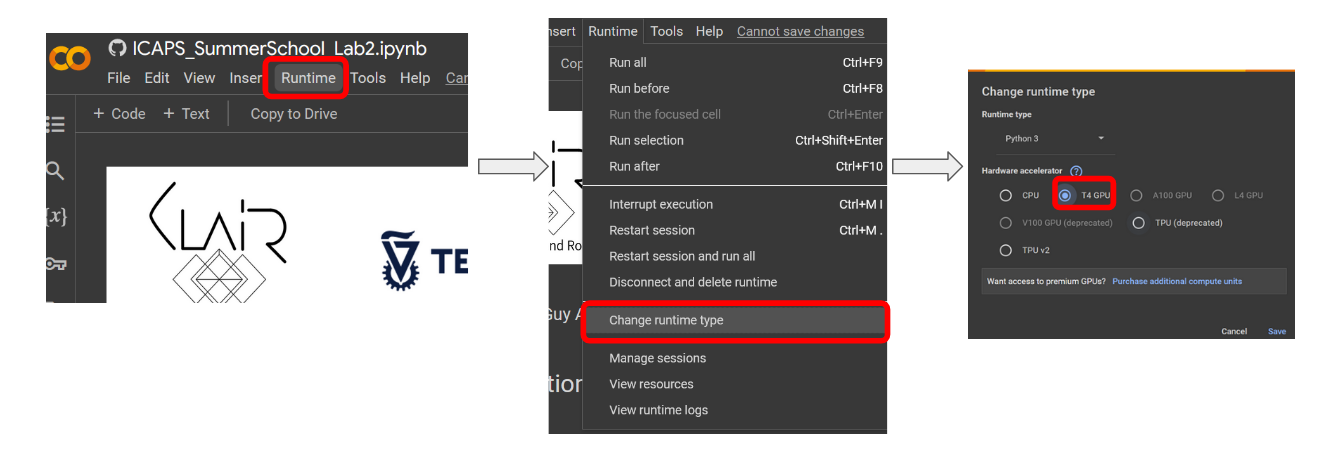

## Assignment Overview

For your first assignment, you will implement a pick-and-place task using everything you learned (and will learn) in class. The goal is to pick up the red box and place it in the green bin without knocking over any obstacles. You will implement a full pipeline which is mainly focused on control and motion planning.

You will implement the following components:
1. **Analytical Inverse Kinematics**: Use an efficient inverse kinematics solver to compute the joint angles required to position the robot's end-effector at the desired location and orientation.
2. **PID Control**: Implement a PID controller to control the robot's end-effector position and orientation.
3. **Motion Planning During Manipulation**: Use a motion planning algorithm (e.g., RRT, PRM) to plan a collision-free paths that consider objects being manipulated. This includes learning to use and control the robot's gripper to securely pick up and release the red box.
4. **Integration**: Integrate all components into a cohesive system that can perform the pick-and-place task in a simulated environment.

To complete the assignment, read through the document, fill in missing pieces of code, and select your parameters wisely to ensure the robot can successfully complete the task. You are responsible for testing and debugging your implementation.

## Submission Instructions

You are required to submit the following:
- This notebook with your code implementations and explanations.
- A short video demonstrating your robot successfully completing the pick-and-place task.

Your code will undergo automated testing to ensure correctness and efficiency. In case of failure, you will receive feedback that is proportionate to the issues found. Please ensure your code is well-documented and follows best practices. Your final results pipeline will be run multiple times to ensure reliability.

Your final results video will be judged based on smoothness and accuracy. An example video is provided for reference below:




<video controls src="data:video/mp4;base64,AAAAHGZ0eXBtcDQyAAAAAWlzb21tcDQxbXA0MgAAAAFtZGF0AAAAAAAJdeEAAAJ/BgX//3vcRem95tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTY0IHIzMDk1IGJhZWU0MDAgLSBILjI2NC9NUEVHLTQgQVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDIyIC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcveDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVmPTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NyBsb29rYWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjPWNxcCBtYnRyZWU9MCBxcD0yMCBpcF9yYXRpbz0xLjQwIHBiX3JhdGlvPTEuMzAgYXE9MACAAAAlQ2WIhAD//rzXM2EUWm8t9MXFjNevrNu/H471//RKqxBwfnOkgYBLIGE36Ji8lzgHaffOtEvCU3vOtJSJzvxF5TnElX44eYo23REosglAAHORDxZ5z34bIqRNbbxVt1PQeshdx0WhJUuuDym9Nwa6IInFGwqiGvVc3HwGZLlAzsFLo4W1/FID0e1X+pIcZi95vuw3OPajk6eJhlU7BX7QVKaRR0P0TI8tMJyxKE1GEq87Eu6Y1jnOwaFPDJDZo/4eUcDGKccsTuwkzKk4LxlgVRUotS6Iw6yXJ5XDnlVIJ8VmOWY1GDBemX2ZYy57OixZOQbay6qNJ7pKBMuBt26IvKCIgIqzlsJ7YsxJ/mx5XJCclRH7yxB+1dvZ3N+pD9vSboejoos6yH5Qi4OGlMc71cWw8Q4HK97ZLl+POcs1clPwIbTokfpe88f6AoqZ2JrYHjRTNFcDdh8cYgnlhfNjUMInd3dd7bCUdm99mP7UfBSGTW3oIrtrzinSJfKHDyxkbLTI4C5iqRFCbR7XWOS38PyY2nQsJ3Escy5zHU+bz8kPvPRK6PbpYbsAJ8XPgyrVJC8Jq+G+JzGm2niOdR9rqsJEs+OHAqNA4i4PKuYyqgxytaLmayYL9/Uu8g/MHKGDGAgQBB49zE7vRQRDDEpiqjNfJrFmyhWfXEktFWibMd1i2xBkbLA3QJBCs9XnWW11vupWA+B16+y4YXbAShiIIpQzNDr1YpFcXnR+8uFIFT3Ts/KP/UPi4fBqzXRFquLO9JGsh7cSTdTq5Vv62ARyNW5hAaNvMJRJPu65/BI4vyc5X6YjxrcwBiJNB81Kbha+T2YVSjS+Nki9NsuxxACfxSCtOP3pqFoXX8AjcEWoizKyshj0ESnJOq5+FXWbV7fAdr4/O0RskCntJBhUE+mMpuw7N07mmVXqEwILOD4K4rZwOPHaq3QvcbpDeRdnA5CgWqNpg2l4yOdBjDQmvNYVIwJ1RFtR4Wu9KSOMPNnPvMIQH2JO36JNWoFNhv3GF0I/K8EZyDvLmw+Dw9/8H/Kh1rbChL5Yb6yHDWerj7rOSzlE/G5oKCV8ghBe1Dd0iP6uARJSAomhr4ihMuZGQkAKR1dhBhNlzcnAeeUkmZIFebjRSt5NESV1r2yBemz2NVBrOicmmQMpid9YSf6MaoHLNjzlRYZOAhiGl//Z9iBFQtiWDZlT6cIlRF27JoineZyB49KEK76976QE8KQ/4nFP859zPFbCiYG/daGgY6Z967m8NOz2C2+fSMVriJkO0ipLdmwL3LNYdEbBlD8l8RrY/NA5KlEdzkC8kbSDBfuQy5pACM+IVGAyAbys9mpaQZJxTkD+V6tCtm8B5J3+TFXCffrPUS2iq39mvfaY2gj4WEYffCn5z/E+bLBkD5s2w07STtih0SOIbKCWuD2GISUa6rGKoyJsyph8pJ5ki17Pn1m3O8+rNOKhmoMjBefg/SDtlePps/ZPl2dgZiKhtNd5AHonAyHhpvMfkCJ+fglqpSo3qYP2C1SI7NadmDfjO+JaqSqQycZVzOmkia1FxQ3gYNNftKJZPe5zzm+8+n/HfjZ+cWRiEMXhk1mEPuNW5hOBlUkXVnnxZOgCxOZCpazAVoQ4alQ8+be+1laxWc+gjW+LIoGvfv7rT7396taxeM8N0rFhklUYccRtu9lCVj+t//qXdcpXbHzhpWL1dwNqe7CNU3o9OZqCZCII8qJdkIlQC/Z4zqyfj9NQPZHynIfGnDCP9/yYMsKMH6BLNymXN37xgo8kDtjv//KFPfP21K6IfivvAgF5lzX6sn9dVrZHtntyG1oLA8fJ2nVSu6rqZDdf7e1UHHtdBe3NrVLWSf2AQRCqUwKi7TRWMwLxhPhM574GvBE1RH1mCZ2HMYDOflms4a8w79CPERgPgtkMQulCjulGWGad3PjtP62gG1tt+lPgQosDEt5WjWUvkhAwiq9+ZCFnBF/+9gebmOQ19uyObLu4qqAfZWB0buJYnddpTS79CReA/SbPLU7lOTqbDlIL2jc7RevyAoLwJnzV0Y7h1OWjTdTB6diMkp63HQMQtLdC0lzzBY5ZWdDOcw7n+g/M7Twswd+2/VYqmdEl4EqWs39aA7g34BP7WJor+b0sn/QXVuipY2O2AcFmzpmx7+O9uRvIBB/nmEVtlEpeGaj1Rjw1Ii+VacPVA4n3nDYDnYHBzSrH2bWu68+wTG7/aLewckctkOiHBRJR2R8efwfp8HzQbpNGQ6d9blO7Qg04S1Vdb3/M/IFGYXLcphTQDRynLBeXgw29H5Zy8WZ9+Bo+XWwzGMlSbfU5Im+wTsdq+zQ/4RuhoMAkX/wYJNF6iHPJ9Da68ubFnd1Wql9pOkhhcMZAdY6YdN2l82GhQI+bxsqpaRM4ODJN+iWawYSHZ3DNes6A8lr49FONga3OlhDPtckK/bRo32pQVr9mY2TjG6pRTmLnXoTGjgCXRGwajaTs1WjPTyaS2ehRwoPTqT9DkmFs+y5UpCNtEjbu1xVJcaN6xv00qYxKQlutS+2hr+32x+KeHgA1g5eADRiBMBn/uVEtaPkH5wZhDxiOTuzMh1hVx6pEgqrpjUp41r8H1teoZmyNdM4phP5DCqSY9fn+PX68XZ/IYLiXL4l4+VwByjqlY/15Pbt9x5xJ7E1SKdFNosMJv9eyHJTUGWT6+uyKUEdPnFj/PsZa81PvLEh87HRPhRCVttVisgE40CuPk/7IFk9F6sHjG9g6/rjR36xEEjSEtIrjzFiMo/s2+ieYJzchXa0x5rlIhujZG3LE7SrRL9wxzHLgHxXLwXgT2uoJwqy8F7c2O3EXFJ30yHiWEv0ejz860fenZV6eMzm1c1RLncVfHLvIyeU282bATQem7eNovX6lyslV/B7DObE6280BggNsvIzUGl7Fms/Jm+/cqgxDMc9sn18mTzoGXL0ok4SE3ma9nhoM+EMb9SXn2t4sV+2x9rVYzbK7Cc8VnLt+4aFKfv2GhKgX0zNvDjJHpYgBM5gafJFUmLeMb0xfgdjv/C8WeP0Mk40b6sGtl9tB5FxUx121EgyWg0nWobQfxKRc0VYeagdcT1WqaA47AnIg0sKxNS3v0ZLvYtXpWg2KcUzF17yxF2TZR1chRSrQ3F+orskUX1p2JLi8KPHx45bvORGnB0gZF4jk1LQIYln8yuF2jTI4RdnSW9nuSQrzlE2MsOC9L2WRw+Pm55yi/CnvsZN7qv6DVI0a9H+P6+z8puUQ+EIPMur5uIDNe6ARvc80AMKZAWQmBUoAsBN6Vfphyv5jqBWRXaWtIGqeyNmEFArUo+M0LtI2ohoAoLoUZgzFjBAeiAl7p/5StTzVj1RfQ3korAPTPGak0MesT1und7VDZLHaxzxQEOTxGVLm6hb115Z/dTcbyCYuubN0B4NCwVmq9cgEDy1X06FHPI94h7rwOJq70RyfWIJoTk6lYQixHQlCf7Yl1IcfVAUb4T7Aw8JGTEVLX4mz1dtx2oR3EmwceSRlAFzfsweNRq9AfChU+Z6HdpIsCEy1kEqHGzlELs04xqVi3d04i8LfoXbgm65NM5nKB4hM9i6aVv+E6rfkZUNDYiXW7Aqb0F1AUiRvifvhf+Yym8gZy3+6ljvH4nIN0XiNGxSF2k0cyMJX0NOmTLUI8bXf+klpp6+9LC09TvmemPFatr/oZ38nJlipvkO4GhCmXzMuiBKLriG36DAos+wzLqg22vN+EmEuCrbeRzCGe9lMZLb8LTBKESrFvzzvd8wVY4xFyJEpFBs2Axw1HJIyrkwhdLR1y5RUphRst46oSKbvmAJQMe2R7BLRz/TkRRNlqtAOnZurWe7rnCVUx962K75TdRBI/YvUVKuklqy47MiR4jP/XD6L0/WZgcaJuC2ysagfoedBT4pLYxtIL4RPMzsUOweawurZXK7yXiLOeRK6OmH0g0tHb6KOJDCkwweM2dvhnlbC8OE2rnVrMWfqNav8/08FOYSFkPkqQiwfEs2o5W/0ioS2ADzAP/tWcKvpSWh6/297wYXmiaKTHeiwwfyIz9p+8JKOFoDX0nzA6nT7qkSxDPyDHso1pVbx/25UTTlEvVuS/vOs0Pn7SBrEgnryBQ0RnGl9pyig6mefEXzqypdYvRGskkyELPbpLwT/as9OwZA48Z2YB/5eASp257Jl/uFbC/VOAJj5xlhXfr2EGlxMTniH74yIIlI1p3IJDzEuxsLeuOBNk3hVmagWbH6g326536qKYRkuNLETL5fwIRya7eMmUGTeBuZwyFgdFcHZdNxE989JfGzX2gsdL/Jd5dTri0INvNQnDkszwN5R+UrLI80KE3gIpHIujfCfM6HLJI3dCPOyB3HvSx3WGpHSNywuus8F+e4pjQuXPA9LqlT7MnzVzLaWAV4DIjBzEaLLDiurV9R66VG+23rH/TlxcJLtotslI+yQ4AxCPorObSnVaEl4cRFA5xTpuQejQtXohcHEZcRibwDPV6BYzVzN86wKBIo3vw+tcNVnKaSFobaAuQaH8bedjx6jvBm7LMJYUeapgG9NBY2j4Hw3KgZT8+RGX0g5OEJ2q09HLHm0/cyLYeNiK4rUanye9laB3hQw2Ou8ZMt9Lrfv4MDV1Gb7zXiRkYMLDMv9BDvc2/LV6dMSNvgeWQtmct0NNW4tMJtIm0LvV359XaAKsMAlkpFu2VfkqPSVDdhtU+DLp2YAFRt00pkmtPZx2jUJChjJRGpIsNEtENzxxZpLSpwyyoie3L8Rk9LXg71sW9oUTS/hawpuo4+zUYBPf5WniuagsMf+RKiKVdzie29eYifML9Ke8I/I7F7dC06+Cj0/kSdqnESqdZ7XqSWVEapRNWy7DzP5e9M9KfSfBb8FLlQCIDRTOe5R6DlPPN9T81hhKMlS3y+TsSih8fss8xV80sNjxfG5xBcdbfPzpnVDi0i/d5B2nWNcJ9Uf0yMMC9yESt5ERgGdmgI3J1OmQT+98b378xZcNGLX3awbLQw7Nvtj9ekZpZ3xtKtjup8Hw8r+TSLQWDfwHUOLdeLmIpd9cAVncjWIIBMpuTAb6Q8OX+q9BZGl9HCK0dUZuUmRzimPj4FHSkI3BIor1BY/i52973VfcGCOVFCtRYBbUDUqo0CGPj98E3bwuUp4oG0dmZiqxdTYir188EcREmDYsW1uVA5a50+7r4vjd744FmWgY4CjsQ0xw8YL6L7luq05ryYAkvyM9X6EbbcjYL/vxS2xhEtP+Al9cmKpUif7MpE66AQ1XItxjP2hG+ZGRgLXTrFUC4LtBEOqXoTS8rbhXp+r5FqQpY8xnyc8vORP8vpltIiJnhT848dc4Rzd89YbBXlvAeHAp9wDQtreDmi4KA1y/cejiTkv96pV1Z3rzZX6ZncJhdv/brgdRWvZLg82h2hi/FkNw6ovDoFByg2xMQBKSOxjb1/71rBME//7vIfpurmApQGv8cv7b/tgUFpyt+ngLGXP3SZqbNxcUe/bR5M/npy5i2+4/1+ubqLXqSLIIegQdNIDHLkylGEI3EIyA0g6+qxuad5xbW0h9N5+s3f6ixjTniAJB6vlEC8gUsxjHw1CsYeUx5l5VDuwbuPZ45tu73WCCvYltBWIMxdNpBYUUxtDPG4XgmrsxK5/ZFDBeXw76D3/m/1QHEaHXaR8DKzPEd+lZGO4pEkVeCYa6ov6IRNKNqQLEnH6Ch+/qlSZ2c0JJeiNZQgtLausdB5SMQlHenxl6hHKgyW/2JXQh6whpu9/j4norOK+oBuCR41xa59NffEMIPhi9InloiIOIxq4DWHZBtbRpGFoGHZbwlIrc1Yyh/Auaj42WIslvRsfKkVTTDYZLHnyC1Khzq/+9thMMv4/lHQdyFIaJQZ4eKBGMoNbg0D1VJHjYpggKjeLMCTfedVADw3CTs0vHMkT1ScLe/ZflyMOtwtkgX37pouoZ5wQDulqpBu+K1bXqHLIJuG7MIVxAajil1A0fcFInqM04hkiIcdtYrQ5B5fDlM4/EIIDIoycj3RxZBQhHAa5BN5Db6Zg5YznkQfe3s2qlkahduosFEr7SpUpyw0btP6AdCmMGKQfazMX9hOL0Es40G5z+1YhwsyXfZsWzK/a5s0fUnRCpk8mX2qpZveXaAHLlh7rxNkP5CNu0JuY9UuTg7khBPw39DG/qpbY2RDRrsp90rH/QMmD6IjTiXqVzqR7B0+AlVtCuBqyQ6S7J5nB0Wo8NbABqMzMJp3nfYlWNzmkEa3Hv8ih8OEoB6tOHceZbHZoPCeINqAC9+tNJtuHHtcqLJ7ZkMLihJhfs9WuFLnQ2mgIRL/8zRWiGvwE+8h6WS1PPSIyNKkgOqnYwwM839Zv2XaUJZ6NRcS4MjjID3PD46U9QuMiLq229Q9rKBhsGidZUW4k+X/Cht7Gj2mYItLWvpNeO1id7xPxZwdVvp1vhRn+JLBhC0z8voZb+dHbQck/3AETLvy002wxvVjFWVHVfY3Pq5N6S/BKYf7ZfTyCEjPdeH26pvVagXiUilq9YjNnvwBmDzwcAiliwnjwjKUePcn43bIEWdiPXhUjDAi8rsKlnZNhmI30dkB3tskDhgJXuTcAyIVELFDjD9Q4a4CUzdt62JC5TN60i5y2sgKEqfClsKYMCtTvORFl28Dv/YEQmukFBhBWcYbYiUzrvd2YO2VWz6ezH0BvSAIBq03rFARex7Fwtbw+B7GiTiuBxAjZvJyNLpAGfhu+ZcU5Zhqp9Ce7J6hgKgokK2q79ydmg2F5rZ6I++kpwn5gTMSRHnMZn8ZmC2E6eavqQf1nadHLl+5SuPemtz7EkiTFysJ8mEFoPdndMwTElbsuOkaIDAsShqKCQe51FMn2nzLVGv4Gc+tJgdnQ5C2ppUiaEDFZF4Zek+d/YFNlWp5Xw3eqYUyii1a8JVD2hYiMhzCBXudNwPgdCQ2wOF/8Z0Y1AzQ958+O+aXDafZIf5g+D4mhdveZiDdMTd4TnBYbZ3Fi/jVa6ByXLcyIpUpq7M+VO8rQ7HDrzX9c+dv+9nQX9hW1yTcjwyEb144Dh1eZbJ89941H4Zf5wmAm9UWgf8EOe5fRXGLgrZ327kMrM++SxK6Q07Q4JEBR3PI4PQaigFy4HP4q38158zj1sshZT2uCP/VMh+lbT3aZ4MdF2RUa8TEE9YzYcbtPARFbkpoCv0kzhcAYBn3PJNys1GPb+dPIzeyfUTi3leTIyiaUWfhyZ3or07cKwWbPVxJPtAghtQirrVLKgdDyXJbgTsp9eAkWZ0Q5xgK4yanOD71N4X6/fi1K+7r/xgLo9QvBAubUV4PalrJN5rtI/+ViaNZHreFOHyseofMJmLX1KMnRRPDBkMn2ZsGbpqc2ieF2OM1H//Ak1a+iDFgyVUHatsC0C77vFWKrXdRtz1DqcLKdFLkveYRdHp8NztZl8Dac75jOa4MlKPiZwVwJnY9sfMWUezqogLMLVpWr8++IE131buGiyVIJguOd/Jru9NO3YqMzO100MMZIPKzE1HN/GY0Yu49zCSSxH5kNtteIBK6ziundBPXODCBXkK2bKhhIjj6UEo6bI2I6zxsLTg0oM9T4GUIkJR1u6qanTBoDjzCO1n4vh1H/M9rRg5OqopTUj5SjC33SToNeoOPB9tAPMVw7wwzR8OfADohKYknlb4O3mha4fdmTy3j9By0PrpwAqrSIPTwaurjxaEMIyLNEqUkGlGHf82lnVDpzVALjiwVcu5Q30fPHPvqptoojHz7kbxTdidXXanwexcLRenxTbtV18/MSUMfKy8lgo3JxKKo31XK0yEm2xwrK69y6xj57h6B0rBr7dIjY6S+SAr2ibQqlQOGTJZz6jXuPbbhQuKT4T5EBga4IEVcSGOcs4GjHEo4zdgd/otusfM4JWiplv9B/qzyVz13/fIT6Q6rB4sIYRioyeVJv2fNAOiTjb/8cftLoJ7wdbvk2oe64xSUSXOZDrYDevD7aBltCUy+0YuZBdhXGMc6q52lUfoQh+c86kqcHEgsdgrAP9zgWBKBjtfjDfJOlPZwuj5Qsekemmm6ixCa4L16wWItt6MslHjgUZUNeHbrxzX1bJ0v43MFojf/ty7NSecBnCRW1cLLZRNE4YBv7PCQ8T/sJ29yZItomKta+FJrZKjlSydEw7ajVPOmU6WmWkS7Iqw3VCp1WH7sptD3/aJGanfKr0j6HkYD0hpUG/BCZq9dtjfrvDf8poRkfoH1h/sj/BVMg2a/ONsKM5cWJ3/FcwsZNl8T6uP3eW4aCw3pgS7lC3hG8E6qFqGTPrzbRfIbj/x04uRYai8n0ZO+zGcJJ3VcQVFp32SP8HXt9alFt/qsHZdwo5cg+g2fklWlMtUxswQXN6TyBkAIErAGXciQv0845tdSwT+ok5yUvUz4sIxzrjCt1I0EULRc3O3jywz+QwoL0RLUre+QuDQqRF78lj7Qu+b0S35YnYU+WfTkIDiYgjv719nIo0eFZNuWo6oeq7jWNfN6Vuiprlzuxp/yfdAAft5fld2TIbMwuG3tXIkJQRP0mPlQX4QTvoGB7PNuv37PR65DEzYrSAt4+ec3oap1sC6cMW0668PeYaBGW++/u9K1uFz0aYJ+K7tT8n+p/SUdGRAuc6EH85Sn/7T76pS/6oEVIlt3pX0RuYbZXCxXHZrcEjb8YYclyhYSz/4VFW84Jbe8yi7WmQdOkzsN8tZtu5Kp2aUfY+VEnaY/81LCws2mKkLHI4pK/skiatMFqGIjZF7f/z7YWgEa5Fi0VFaltV2CwOxZITvyKtYQjBPhrwZfrObhl7ZiItg8NwglaKs9JOYBDkTNI5aF1Xo5x4X34SKqUtYWaEX+H6ORbDviPf30ZWvPgqlb8p/Micm3W7aeBdW0wx/z+LLEIpUI8PemoplcrJthjwPnXDqZN+Zu5qncZ/OKZBAw3JYuRcfB3uz5EEtnIQRZtQpgq8Q1rL4e3wMKlDEqxTPF2jRY4WQNJZp7emHH6kOVcElp2j4tfcAs+2Z/lrWc/G9PtasesPPkmNmtCGyvUQvAR0CCaO5IHOnwzVGIZz8jt3mGj4pqXYiXV5BOQuMC/xso05vv2ue/IRolowsXgAMnktnJ8qcKAs4tJgrdwQ0HCOhuA4+5LPbL/RW5vA7EM+rFGHw9c4G5clzcr/XE3iGARGduKUTgRB7DkG21kGZwDlnhcoaIimxmRE7Onu1Plwii/wVM/1hiB1Dpr2MA9o5Q6fCb35rqtTFyAHhxVA08vciirJsW+HUA8wBiCnKeCHzehjcgxdgYdbeEuLLxR+crBhgUry3LrT9BnflxpZJ8ScNqwZlUyfGKTr/ceci/ZcreWyBM6XwcwY8WuKPgKL2KuvrSPuESi2hR+fxyX6xZN/V17f39VuZ8HzRmG5K8LtOBe07T044u+YqAjNNj8+Ci8o0Aw9Q6XUvczSzy3Egih8e5GWNekRcpRzrP59buLc+DQdDHzKGGOg+t8ZEWt8l/Cr/9Ej/KKlvBGnRPCjTfVz7RS7/DfFFB0Wa0xxp3GM+LeBbH85P9uWkO8cKbKARcAOISPI8axReDvviBD5CpcR9ho1S7D4kudmj60nMcjKdeDEXi8IicE9hViOe7Ue5zMpYMlEmgc3GmZ/IRtDi+5vxP78+5IOo+Yi8Nkn5AlDIrXTv7z6W+HIuKJz6Rz7eZ00bxSsEgF+0G1u2Rs6MHin4SkQjQdroTIQc/N9YD1tdw3SK5wm2Gpa25onsZ9DFCAs4lf9+1ZaBtr+6FNDPJmlgt4jgA6Y4gS/ZCRCndb3SEraGTOqrWoHcescexbx7LOp23BiksIGmTUgKpgDRIfc1J7M4gIxx2e0yhbFErbTkldq1k4gNEhb0vEI6DXeHwC++q4R4lpiTj7w7/Go1nJDMzsTcmukGHhe1/uv2U174ghKwGfu2vnfWq46vrr202BfEsqdMQ7iz6x8TBZevrf4mNIax/1iU4flWrPBVLoSt+BFTEsBDDPypXkpCHk6yrthfX7ISNJhChdP2BMGC1PZ95hdT/QcwJCBtqhA9MRGgyt476661cuUIFK8LBOc+QL/SkDT4qG1WMALSZYgH0k/dzecGQApinSh2GUhGnM/JTlMvBTOlUBHgIuDEFoXsyiwGAM542XDzlQb5hbiXWbqYK617mNu19KeHABHP7NF9R0f1MgREoede0+SXSeQ1lxqZyVcV6WoH7mIs4ekI+Ih8pKa8WrT3XYsAhzhm1Fnp4f0n3RRT23ttdHEHFD3wau8cJ/OQRe91XdPYhQ2fQMG+UwRNc0VBDkKGFOn4+ARh26PzlVXv1ZwucFpO2guXzFWsKewwWicyFmLR14tuifsZ3tJPFuZrBMNIsl9nlcgtLCNRMVboVb40o2gCdALd4gZiZlsF2bAl1pFop93aXyErYiO7pWDZL6UK/oAMvdQKX6wv1/arcdY8L0tdjfJbb6Xud9noWNCXVrkQ6fEy3AtaCArdbMDV6BZ8D2X9ydZKMaFzCXzPEOt8NcJVEefLbpzU5ZlH5lQhYKty9Y6nVwOUg7Fv9XMnJv5FU4Web5lC7HPzag0cbjyMLMW/Cf7QTeoIu3mbk4Xm7rs/GQutTmx+Bq/a4hpSI9zmYZXvSi59zJbeGNjGPd2tVKjDkI0nVbfdOLFbUK3KXIa8BFmmUvkN2ylXyaWYDuqyzPAP5N8JgukGGka7kknf2rwgI83G6VxDboD3b0yYjejK//WPPJuVBpHXtHpaTuE5HOYwIwap4WNNak6z+uJbI4NP5zysIbJdT9Fe1s8HT6PIB8R+VABrMpjWOjfguW7z2NbjrwhlI2G2HVAzTSusNww5C/kXCurieBI4IkOJ+6GSWOU6+H9ENbAMdKJ1H6WSSRoVOy1scr4cyNgBDwqZipAREH22iFgpCGi8xmFwT2to5cUE+Ar6c7y2Cp3WyJgCibx1SWid6M2NuO4T1l70am5OOdGEvMmIzqwaKx2eNl3s9Ay58MaKss0qMz2oulDKx/J4Uq9ACf7z2LmnMlG8s1phzwA0qC2zoONo7qGTd4HcwXuSsk9CLl1h+vC7asE0/ZOSzPYqdC+kuhNAsW5kbFGsAHFADfnGhBAegmmQwkmHIkCOTY6wtXryilWzj2htScVp99ICDXPlsRV2093/744jk9QQyKcUddDCYI2aCue8+JyfhyJhdBxv9AdLvWUjM8se5Pp+MVW2dDf/YtIJSQnAJgsbFnmA+p0l5hsuR8/pv0/JHShz6erPvh7pt5koBpyJFX1RtxvLhIHvoQ0VBcVDjTgE/vbAVRwXjMEIVKhoWcQkVU6SyI3EowJvV+5aeUSRd76CZDzg/ECMvmYGeca+2U2S8mDnGmBTLGIlaCECcB+6rrZVtMiqD4OJ5AbvWXfG3q7U9WSLMR950obN0Ph9j2EVh9Bnc0m66GFNkWY4DgyH/7HTCM1yjKGgvnB4NZJOWBn2fSjdK2wFggPO0dIgN1lRlXig/C6gkZdIHShdlkmv7caSOCCzUcNXcvaHwUrDZ2eJsRu272Uq6weeXvIJZL4oaMoEfCqU9UHbA0kKR0UspTS//51jV9X5eMUBu0xFEr9R4+aOyrpivjOlUaHi6N4FwccHVOZbAwwl4h4piiy0PIld8fw4tO9nBMu41gM9Xz+WFsGafJDIoaIPdsOR+qlsRx9nrbPOtCbF4pR5sA3Y+OI9p8vffdeHWy2ezmzsL9uXriCxdBN9RF8eRYIMnV1mXwgofmQlWfatdeTQWaQ+V63O2NZwsWwUPTIE1qcVybqgiRiAAWxmxjTG3AwOpzSZSvjpiT7jVekF6IGTkq8er5Q0MgftUdL1Gd6HR0U6p5kkTvPqQTrzg1iUWiV1bezZO9fn/G5js39bbrRW1X6FdTmLbpEO5VtVCJrwM3g0QL4791Ncv1riV7crVg6UKOfJSXkcyvM8h+Y4m1AArupnVnIilXZWc+CRtJB/dbFZ2B/KJ2RbgD+M8ouUnpae8aD4vvpE9+SFiPw8KSqYsOvrOnIH0uWUyDciZDGdIVfCg1rQDUeni/3l1gy6p6QuHl2rUiPfvTQkDlsEW6+wFFm3sr2f+bIFxu6adnc1uGB6I1+KPCM3aIdYxomyNqJp4+F8WQ13psQSv0saUIl1taboi9MUewyMdDLLyLfJgv8Ri/7XY4S2qbRUPC6DEYIoBPBcxyBVMxQoFHy1QPuo+kQMVPlcsGCvviW39sZqWOlrZw4IQLS3M/zb9B2o7BOON7ARR9Mf1WHZig5crEo64DNQNY3rKx2EtzA5M2LSvBSWbRdD565GRKyOAgLcr5Sucfy3ySXN7RvTCv6rsWuVPPDzw+PEYSMZOFoDrIsWNUbNwm3tsZ6Pd95ehpWWMJw9Ijf+BpELfZdPdu14lpDYqqHLEzk2dd6+wS3v49o+ahEKlnpaU82F83MV0U3pDsM6xkss7BtYTXzGi7xT9JePQ4WJOXOgQCYtm84ruuJOpwyTsIZmvdaLD0c6gqqXGtNe8nPql35GJi7VIV/52LvIJOGrZs101ScDdra92rYC+AUVE2LRYxQ2E8b4gVMyKWwZwdWuSv+ggCha5I2ql24A5aJ7DF6V8sFxV0QiTxMsr84ple5e5kgMwTxO95x3yjZoziEMYOVEXnvVJPsqK1e5o8pUnrn0OGCLikm/kJcB7Y8FKVfVi/0Dnya9kUGGqMyff4ZoKVz0tGn6MRboEC9JF6dKyhsTMEKLPR/mI8ghHcBIghF5OU/SZBAAAEaUGaI2x/5E0EsGM67/U9h7Quiu/Pv6pcVYPG0uARxdn3ZvRqC3cVDb9gmu1CfYgvBCdLWfjzKoUg56AfmmVqZlEck7dVc00vfhbXYjYflnffFNHk5jHe3cdHtg9Tdq95MLpyhyAvdr7UrvwcD2wUqIVu2AI+0ktxxa9j0Gpgv/mHAMPv2uvj3ewd7GGKSa1n99AvI9e2tED9/08B0KvIyBSLPMvheiwCkBkIx1AKNCxIjxR8t4SgNoQcBBUqtt7InxyS+v72np4Oiyh35iyyPyBL5oWyjrHhR18emadE+q9lOs91jaUI7M50jvted3FVeD7KMIjvtyX7l4Lh0AgGOObC2YlaySnPYnO3GaIV41KTXCx5qxQqadcbT/0gSYir3cryn/9xQnlKuzIxRA4VxcbrgmKbshosxSNbaF4MsPS4Qp3u1QxbSP4IPfhmPUD1KdTipatMge/bAHykxAZTD6p6YAlBoXPCbDVA9BEU45FoXUw/La2ki10yu19/WzyVpDGGJR45qfBv/jJjm4F8JHQqUWzrl7dlZ3v7YIMNRM8wttUJdHIFJOQHsBnnbtBmXF3W4Aj+DoLVJUs3E5hv7Clx1j8NBIrB3gKQQg7gVsu3lNGpug/MVjBdv6UPTsyMt9MXZjLiQYp284yfeUZZqqOHzfKXFTFlxYb4EObGF3jHugDTxmfcoLYkdHQhw2+0k+VPqmhMFqpBg17Dg1wiAtJbsSkyxmg1pbmFFOIRNGK2PFkj0ghzmrB66vvb6ZS9jjT7KMuIUIxIL0qVIR7NuZD3BxzuQMWxm1YB0NXW76LDcvgSH4Uol7q41PiuhkQC0/hJPaxOv6Q2KEAJjw+8aGsxopcg5cacR60T14bc41Wr7hcpotD/zxy6Y4neXhE1siWBR54vEimLVZDQJJKr/3GlixsVz5NjK3hsKK4egXoa5dqZYUdbUJcgURkz2l9sZGwx3TVezvC656YbeFCGCcu0P/AaP9/wbdb68OqHOkRt+Sjdw7H+aZxQJwgZKYdndS9OShX3GnPVi3z24WMIF9Wxd9gvm86O5siymIAcXoh+PA2SR+L+5NcxDx2BbqpeiYpPQ+yo69ch5BQHfwF0d93n3T7gLLNYzLzR89Vqh+bzXmynM7IgGoH4t6fF9Uk+Nsrtx3889Y9mlXUqu/D1F9KR1GRzATKdex+18YYc30V74N7Bvm3mPuzPi3Cxkp8MAewR2zFz2zgIQDd8iGK6mKrtf6FZrhS3lr/qFBwApS1u8WZLgXhVkNSB3ImIZljHAWgkbEY8KHhYNkHuxmXc0/S+RnyMW4vgE2rmmqNYVtDlzf0ebbbJlPcVYkpUtfdyJjwJHUzwnboLqaqY64fzX+y/tgvHeE8VoOYYFWcWhr0JcPiZ9ryjXyzL6Fv5igmf6Q6x28d7CdaGb34hbITw5jNWSR+kPPqA0eBbtoedQo0eoiAkvngJQAnqsGxP+BO8kB/irsn1EG1iFpl7YxJvnjPvfzSmei+Wb4AAAAF7QZ5BeK+FeeuSatsMR9LT2ASntOx81q9dkHaLFR0CqFIIp6tbjBxmdDv2qbqTdoqrioKvfBao/GP0/vy8SOPXchvaXM6oAjXQyj6SdbYIvvAWmLz16qA7l4ZytkFxEM6mOKQB1sjIoOpMmVaojjRDW4IRbJ956FA4YGxs8YDuFrjQ0HEqn0QvLtAK/9x5ufxtjQX2Us7kxt4Jh8l8N4qfd7mLHj7WuiZeiPqdsiMaJxs+L1nochvAIvPccWogAIba1bc6h/kARGTiuJA3rDf3RoFWrBrpy15P0mdQU0lrf72I9ae+4UxoAfcCQ1rPNjDrpp1oxnPSbGHoUmwyNOsTU9lH3xkg58vgINIZuAxn7etYOvT1kZWAAAfKMFk/NM8aV6KDD83MGeuiU744imYBnI2Qu7fS7TLec5UbbD279w+DQVdU1PcPaKfGTlw/Kik/VzdXK4TFaJSxdFj0mHNoOEXMZxwSVDX5APj2r8986qay0iLmQ5fHdiEXwQAAAY8BnmJqSf8BkC1jmOm9RfQP4WRVDCmTQjdr5ekFiMTRvG5O0ph3aQHywbSt8IhRpzSUV3LVGcxwAZEWPvl2Sj5Z/uM7qJyB4JmgpJTMdeERTRpGr8uEx/AQfAbP99DVHnR9y2m4xF+OhYaaafhX5K6SqBQBkEwk2x+sJq81XJftP2BUbxcbA7K5h2maljy8H1i/S7IQSfiBD1pE0NQzYL225lw3+8a9iQzjExQSuLIbsm+yJSOGRtnWkMRGuMM9iLGpicIeb/+6+wTe17BHstVxwddGD2ibqp1o6UOgv96sdC9FKrDD7T9IOsGN+3ePDLwnVQIMJ0Jkvd6r6Kml+ruyNFTr43m8tA31mjyU5icx0+CkIcDW0PymQ0CxExats8MPr6K3SpX6yFsDwwf++FdVNFzNVVInEm8T2oFDqOmTLvFI5Y1FNsYR90F6vEtwGGyEtrnYxYWS2nhAt21BjaTIRG9oXX/nqTBj8596KgM9mW32QvR2bCloRMbVovsjI6yNDuIim1KEYI6bcaJYiUAAAAUbQZpnSahBaJlMD//kQAWon3Yvhfm7OuAefiqJEwLqFZZdxbYeSdYJ7yAIK8uUponpv9TKOugCwQxvecaM5K7Q/VMGzbAlLkml8Wvl9+djJLn1MwvGe1N6u2eWLDdjNqkpCcgi7qsOdFzLcOOeR2Y1WuqOblZCnlgGeBvqXMwPbKsl2yg/Zi6dH0X4aI+1zdSh71JIQaPIfIBMxhpI48iFeCScPaX93WSTsdW+yEW/7o3FotrUZhXHtz2f4wgdUxdq3i8Kg+SEqhKu08z6BfiMTGKHeT0RyPa1LGniFdvXqhxLZTpOCxPE2n8v6JuT1x1oYTGU+ZwqLkGMq7IYtWlBjPZUzGbc1RzboxvVoUDIsNGv66C0VPBpX/UqDzru56HZkJNP1f5NGrT0k2IL3TwDIQBkSxHlFbnjuSKciFMbBOqBQ1revle7KH8jxq3XWOXAKymkBZaWaZkSIcem+fbHjHDRaWakN00PA0fMcqbXyEZT6J9itIt3qSoPoevIV8mynoAOXlH+5S+FtBaokBC64F7oD5jxcvjF5hC2pbtZdmiQTB3pRVozaAF5eES/Ukbz1WVA55WsQkgneNK037PhA8HpxQ0AoQ5zLYeD3R83VFgVBKYWZHLz1nlVhOIiqxhLSzs9dGy0MEbCKEj3DSuUQn33nsBcSy9/a5VlX77tD8kjStq/9uJsaDhNYzWHl6HPAfoi481ucw65XT/dgbeetxgRjez4klWiu1iyjttNWoBZQeUSl0LTW06ejbfXQFBQfW0WUi/bJXhORTcdN8/DwPXyK9cJfVUGC0KSJhtmQhDNfaGHjm4FcFskWq88KQOz+Bul++N1tNZCeRi+C8HL8K6+T2RqC22E+7D6SLOTEJJDSXggfY+umKwP9tztV2tl/I6T/yEw/HZinqxV2+2xwPe8+yJhL1NIOM7ujDGWbEshCXkMtCUEh6DE+YB2ntDgjJFNBoS03fm2VnsJpqDWGi6/eTJFW7y54KCn0Go6YcM0phWGSK4smMnl6IB63e9C5HPBJDDSbUUZyP/VWTSngdb/6udjPCOCBPpSEVarZeBChXEnT/QiTDUrr/WpgOJZEbL+0AvZmaBdJ8TJ8nxJXitmxreNvGfswEovaENiibAM1HlYgAMGBIzfELA7M0lIiVRXUv/mc11sUsXwtyatOVB76eiuwc3UlRiA2KA6mgDO3jMYuF29H1/AnIFU0f4aOT7J/D3k5B+MJLahOIDeTJ6logoCd3RKsWaBDfOJgrNz44CF3+13y2T//ZQtYIV04scePznNvXBIFyxKYZvrSapAlih1gRtQHxSJQkB3hqi5I7voZwUEJsDHKkrbN1LmyiBVr/kIwywhHlRCuDsTBTdF98Pz2JgqZBEA1tnuXKggZwh1XHyJ0D3D6uDV8Q4xZX1ca+HaL2wLj0WyM9+NhpZfS0zxXrLc2Ap/QEelEaRhVjHCLaj38/VexFn5AhiqcpIRzKV5ecwuXx7m1XsqIjvMVZ2sA63ab3WrdshpQ3mZ59lWlEHIhVJqODrYFtuvdexHoe74et/8NHZSd8PuTcVGFTJltljbftWAjJgnIE0Lm4+IIGGpc0bgnsSzEeODr7kxDg1tqVd093LIBJP4Z/gGHQ11gszd6sOkPejhfthb/3w7jlqA/6XXnYNX8caiJWIzKY22cAAMnIYJKqnP4KhgNCxiHod349pVAgh7VFAmlCUC7q+vqAjdjguXVlGnSMtC9+3opAJBP7kAAAL7QZ6FRREtf4V565Jq2wxJbeUuslWmNxAJBLarnm+L4G+pVfAt4y6idYadSEfRLiEly1rXujHaRbJpNVHZwPo7By0YRWouz11O9RLcX+uoIWwDLXaigKwQuusNbFkJzNsSl5PK42AIeCvK2XjiyYcJXGK5h3ItX6RQAUY0fpDo1V3O19Wz1cpsRDF/YKOcFXIhshZxC//7iHwUayp3k+QhArOPe1FlxdjYKzNHV2kamrXwdsO7hTwORj3TmnQ/BCsuJB+0HfQ9yg9/e3xD3QwiaECOIC0hwNSsTlwyvg9lE6l4RKGlG7YwRhNb46ob6b3onIsJT54LyIiwEnn5w0sgURbyNfgVBnM6z5TRse44cKK4/elsdwLngFJfHnTjqRCljdz/WFdOhF8OycnXT/J2Glqck5Kn84cAXV1xoLd5SM5DTkvZBLyRt9/mq8fxE0W1k1GS0vEfVUjezFGZoyzPFVdaKbpYPni13/wkeiGNgM3W2NSisqmHXPoM75sb5uDDMhsOrMmSf9z9uDVYPmPHBrx9TU2QdrjtDmmpmxwiLZgrEqL0rj/IKMvo5Mkk6RjRW5q+BpauML9jx797YEc4BZpwQ04UBud6/qeDMl7YlpDLB2rDRMP5slKBIX5ZycPwYPEWgi9/qr5aia2wCnsSNX35DZwvvItgm8016neEMA4gPLxTHpbMg/iNdP53T6FnMjpsFqrz/5A5zkhl6kLFLHwVU67X+NQzUQx6YC2GmDIpdtkgqex8NpyhrUtIgxkjeVsond4NjqqoZD5yGhzbTFTBGx8Vr/Lgg6CGVGuTR6nxo9ZVi8uc2uQrBAa2+lSmvvOGIYYABeiRKJpI1RFzWrLB34Y/ihXqHwFL0H+cziuV2V+oBbrPIjAuIxsZgvnkE4C8DIFlnRk2DgxQb08/+MkayVxqq1H1inU6dn81kKzAKwLopkTLIfGuxRm444pT8jSsROsQ2RJ6Sxm3dbaIJhMHj8ZppCtiaKnLlU9uCrJkxXxQirBs4k9QjQAAAbYBnqR0Sf8CRtTahdlNGiOn11/rMpIeOe+GYBPXFwnbek9wWMOPff39GH/83WlyzHWe/HdyUdZ/Nac9edtNnYNnkN80CtEbIRHCcH/pNaGugAEFpgiZkEg5GguraTPxCi3VD/sbW6L37P5mnSywm4QluGk5fzg9MfcmElPv1YTHp8sfyLal32h42bTjm3L+fRN8S1j4OGv+U9k5YVAzUfdWdQwivFnlgh0Z3WRwPf8Rm5c/SMBsWbawZtGjJaGfiV+Bbshve/koKIniGcGtomOZIZ2ZXzxkJz3q25oBlVdHKFN6Cf+Wx6Y3mO220qHXffkdeLdxemXhW0u2XFqFy0Cx6C3ByDQTT/g68skLUGps9sil4t1yp5f3SDjrLzkVdLbl9Gg2JnUpsRjLg1YF6jXpw5ZHgRse/Xnv1s8UL3GoZ3xlPiX5GWd+fbeIyEj/IEbfcpkU7gruz9i7b15jzLaoPWI/rPyzUlstcSX8JHhippAmCyBEjCgcCHN78VqmkMFM5bofq7r+j00B+1DUzMV0wY1EmR9iTRUAt+cHXzQS5oD2yFufj6Stk1vvZR8zTyx6Em/314EAAAIHAZ6makn/AnfJ7D+xDnwhT1/Z7dqp8oqT58bSNM171G1SJLzCgHBBOfWO4lysXePDcK0XOXs5upCJ6to+Lz7UcHCVX67946VgaCqN7uuKzvCFHiKkkfFjgC1AvVavqbDCe1cWV5DtzWAxOy0lIiZPso2CLmVj+qq9fHMo2QaHLG+B8NmqsxdKiRaBUXRCW+V3XGuc6wF6XXK4jV0keh/zj1iFxexe9h/oh76fuCFWvSlezApHUEeBeo3mi8xgypNtmvgE75TmBpF6bDC9Prp/WzWDNscijDxFLiT3DddEKyzQHKcNrAAKMrTev2J2fDrPCF5Q2t9VqdgcZzN0ImHiViy3tFz0RbVcAPj6lxDfECLQxoRZofxEAODZ89w6uhAnWNO2j+S33021S8TXr/6+7t6dsud8GCX2cCfedopf9pPACxunClYODOuJOqNWyv3HYp3W0nTkDIgV3AEt/txgGMTgU8X8WDJWftxAZpOLwLi1yLgaamUwgCNaFVo2D9yF1SstBMWN6pM34dyhk7eETv6Bl1ZthFzb+HpFkhT5xSEjib27qnABP+YGIAzte6zz6bZZTMFH1wzjSGpendNcXw/OewlCOqi9LVebOeq8iAsyqF1M6szsT4PbQodymelRyH2eQYGSPFUSK33fb7t6r2iNgWoNUYguzY7LfoxxJrtrpjnhWpehAAADOkGaqEmoQWyZTA//5EAFsOTcPz6Lfn7DXELXajJdGCxKPgpGn51IRnOir/Z7rk4FaWtwPiV5x/2bNhG+UH1XbAzkGbRklSgXMSOGMKJHB8fSkB0wdZENdQ0AielzpVUKZkhQl+zantwVboU5CbSL8J8YvBvU+1SQiJ2apvDsX4b3abI6/EjbwM7qgpjHCVknh/TAEL29Kaadqg6oUqufsajZ1UyUCFP0wMhruXlk2mbXhMLPplt3dLc4Gxff1ableVHfRBrQvg/5nzgTwdcp/igZK0mXv5YYYG+Y1S/zJYuBWbNlQUK64b/8e958+VHq/r+PiydenNPjv9llNLbDWnarTDkp286mD4pG6OvYCe9cv8yCHQybFyO6KYbusbRiHz0M09zVoh39mEO/JEpzEedjFJxj7awyd9jQ4XqmNUvSgieL2It19OIlbATTaz6+MAgbqRLr936h/dq5VgjyCrXLjNn05MPQbppmYX1bltFXXjKBvCobruPLFHmD2XE3dHLOEjEY3Czeuof4fDDblrkCS/jKag5dHKbHjLWdAA0YAwRCihhFKnoPZLJszxVDrDCfrfT2EoB3INEmI2UBnxxKedMzcWjYXwHHzkejNvUxuTGaITC0wpiA0x5imkegHEwErOvNNQ+qT3B3Okmknomn3mkSoWsSoE7JDdyrE5qTPQxcvY+N+ta8m87DpK5kdvvmW1Rr7X6vp4wbdvjm5vuMA/nsh5MH4SzGE14XnuKCkZcsRhrmMwS4yRXlZryxVAR7vxDxhSf6au9Hk3skQyKcRUy12stpxTsKXiQpLSatEqYOv9/p0s6yGi9BtOSKVfVYpIQdVitcI4aU/qIx/thS8/hG4mFOnw7nDFa2FcJXuZHv7tQsoBtCcE2w3eAGl78idfu1dcsLeJ3ODL2Pzo6eJjey5D1OfF2pc1oSqxu0Jc2Ajwx9tYj3HtrTOSNHgMNw4p9m6tvTwyVjc69NxUV47OU3wH0qHDHJPRffb3dvcvj8MhSBfL0Js9WADIaULzn91l79aJMosd7TJCUOoLpUxeWHVpBnzy2WNCMzj2LY1nLmh2Gl3lvy/a2xrGui3FTO4Y3SWk6wyMAAAASbQZrLSeEKUmUwP+RACXKidMpu7PJR0R8ipxTZoJaHRYNnqJbqridMFbmMNR/8WoiHTO1b6J2SPs+zUU6WN7J+SjMK9ShRseR2yMPV2lbjHBZFFfAe/MWDx02pmhqFkCByfJfLq1ff6Ld9a/i+0cWgXjssKATIE6q55zKH8Agdgizu0HNXnvXLS3lNpfCTtd8k0f42mKFs8X9qRwt6I7lgbDoy9CTkIvi+ycRhbpQSNeeDYGFgtAvWjP/ntQfDv4IMoZFJfCInN+VWgSA3PACscNRk0ixdb4nwNA/Exxm7Gj2RcdLk9krktGQxU1Hg2dd79+kprVmGXmvY4aJJofU1Wy9y+uoWol1f05NabNbQkd7YFpkguFXVpnrPVta3NGPl+UBKvx+Tr8Y3cmU2BCgc1yi2o73ihFCbHeHFrxv0O963CRMc9vRYcVq3x5dNwn6Ccyc/ccYH5f7OYat4+4xoywej4225vNbf3iZZ+oZaALvDMEzx+I5KwP7E7e5UG4xGfCm///DbabK9vVTQrop6PNKn/AX/0I90uO4L7KIBzxB1GobOM3k/JgMbDjyn6qjt4CSYHdjqCRhDzh6tXHAMpgSdLcYKnYPBifB69IzK3D5fmRQ/6kYe9Sq33/HNoUOKtSTn9cbrqSgqCIeDRJZXdf8XCQg/336iu3/6cXSvP+drnz+q/HS5FxbY13By7xhjkpAbogOrrG6DP/G04oWAHNnO2AxyvpIkWEJikJuHqesDwoPXZGhnqE2XjWOoSBtp1IhIQSwPOCK+/roFq0pzufkq94wGMSWH9LuBpMUWaO0MaS2AS2IZsmA20zUKY5Twth8GmMMjwDVelxjB0oraCuogvCIU7GId+TKvhzKCedPvC7EVaryVvdFuh4gEy66ay63q4+3OQutluEzA1d++a3D4x7CsUoq6iMDM6ljRYM1EtznpNWnARHHW7ob2QTi3kU16OEQYqspwF0GEnEuWJRmeemCxzs/bi675d7Ufw5p2umKd73tJ6cg/DB098LYtrT+rqB7cP0dD4jN2vTasarQi1gK4HJ6AMi30xPSVBRxvpygg+xjlqZEggM5kqtbnR52RytFN2wMT10/SghcA4E0me8iKptDMBucHF0jjslua97YVS54NGDO/GPG6DY0m4+XRTF2kSFLaGg5WQw95/DWoKbvO1U/oSdvP/aOQRgtXx4oESHIWqG203Zog7S8HhcyQExKNcgZWXphBlEn4aQBJDPEWvRgS1ShUZRTZfBMu+GmPZRV3hkq11qKLuAQW7XxM3Ymr5TcRarRk4N//czsxibXxVVC/IW4MQuAqln7TD7Z9e5r4Ljfth/Y4MDs5QOy38zLOcUCh3TBDQXOn4YJZY2PWD3250T+2cKpWuDW7VRWFRNWlvEUwtsxsfq4Q1ieWXcbav6ItCGicsRzPMvCBhMKhkaVH3+zu2c9ngdiixiy+2ZJlkKd2io97nWjUX8zgs+fFHrEBTPi3KyvjovVXZGNpZcTFSWWp5B4ehl07b/ozWSZGk9M1QJYJHskPqKHMQSBkuVD32h3sJQ30FPWePxrysj8JMN2AAAACa0Ge6UU0TX+FeeuSatsMSW3lLrJVwsrx6CvnzN5Yg1tq22qpmkwnon7okPY7ni3d7tHppnCwIix6keA056k1RycF+3J9T4Vr7wge969DMk4rxwNhVKpAOpDTAQRknNhFLyzXlmeerPrUH5IIctoOVBGmfeRUm6vU3l7XiiihRCqNhGQrx92yRyLu5fAXhoi1RwsdjlhVOgAimwGedNmZy24p+yltRp1sSYSOmUhJvezYp0vBsSYLu13Ay1MTAOYb8/wSESDsYF5BiLEdBFRfKbsw5V1BBCRRfZH8EqxrvJtTVouTxSVMSBQwsxPJ6KxsoBvQbBZh64ZpcYmni8BK5FPIjqGq+VZSc/3kuDKt8YM/fqykQIrP0nJ7sKTkBGjVImgsz4e0LL/apx/NvFzO8rRdjkMW4KWszYA2jhwIR1S56GhJBcqL4r4bSPCPaFOPRWbBCP2d11m6a6FzcJaBMkGoZNFomXAx7sAD8YccykgbNEzCtJny6+d5w44278/A2eqyi1KQM5Dcoic7MWwT+7xiKMU94DYjs4mdS5PqGii1JBXsQBl2P86hqgnFXp5T/Jxqfl4Cud6M/zSFsOLtqJTr3+3gORcwkjUZMhQWMhXf5yUmsZvoatl7idyF3qt+MVi6KRiWgE7dwMhq0ymp34qPZtBicuJawKzmDyiD7Tc19Ie8j714qkMNxBBkbnDey8N8/sZD289aa/GUa3tqijmsVKOyUglJ1uobiZ7liRTuieDiekbukhabJZrYbzpwlMmDyo64bF4FhKd9PHVjChNJ3tY/1byeTTM8AA/rfvTgsGlgXeXrchA2hsEAAAH6AZ8Kakn/A8XXz5x/8axQIM/Qtu/BBe8gflkpXf+70kjC1TsPgKslBZwCOLIN47bjeLPwEbLGvzTGcuA5DGBGhxOzh+gVo17ZNW4hbjz6/YSbvWgDFc1b2M7Zhe4xiw3CCn/cgwWa6RooF5D8tGqt45W/CunTlIfL3Z4Xjzgb7SG20fuB50tDDbisX8MiK8uEz6bVlQ8RWxxMfGsXjSNPAPSK99UlHYsMmN/Ixa+zN+o9ZyYJdCnbGbHrBg8otV4qNZN3a/mSlCul7gcuSmdbVlmmPlDTfq1ZZCIWyG8OLbCZb61vvXwp9dseSRb+qcMEKfi8K7jh3ZkCzYYRGNouDzzBeSbsr5ljbtS7CgjroTitv/GmaBxOrrXL2I1GGNo3beIUmLT3qgIt5MLu9dROm9XzJb7M9Ye4gR4JOGTmN/sUoYXC+jCaBcGiQQeLSFNLOdWSCZlXru5UhSLHoBEM+d4W/lfuFyhPBxL/crY14JxzLLuj6E2YDNe3tiOdsHOYP5DCh5VfdfrNelN6D1Gue2DPcSGcBJu0Gy9DD67NyDBBt2BLLwUv49CpaLzI4YWhX5sVsSuv85zkhmBDghNgcGrFrIz2E58JXGrjw+M4LcrfmOBg81mXfrOJo4iQoNszo3jhX2Pgg9cZ1L4JoPnx9lkQmGL6dvwpXo8AAAVdQZsOSahBaJlMD//kQAjkdzUdEfSEgrDifnPeSYKE8xhcrgrPHhept883wDZvuyH9hvUMRqvqNalR2jVX74dN/opnh7tzTymUn2C1gEfma1pfydP2N8JMSTqjuhOzWcQUSuw9cVPTHr6+GIlMXZnflCJ43nK6ltIiygrdo/Yc/gkndQv1GIM/Zi7aqg4BEZR3pjw1RrYQaKlTcGvXb9UBDPODtokFjUA9QPlNxg1rdwDhFCPJSa5SjOK855TpHbz2BYp1fFbchGjvweSRWYmFAeMyBczU3LZOiShF3wAMKfXNhSrMxrDOgZ6tAF/s6725Y0hgLwVOjzTH6dqasA+QAWlhp/IvkBBFlM4JAltWh8Sh4wVu3BWnh9fSfAV5GjPtJdB97aj1CJtnMDZXXuMJ9Rn+m/QSvBrAQUNo8C+HxcAn2n+ZaKI91PM28je50f9YgvrGgHuJxovHU32H2RB69Yp0OUuHroBu9v/77FLXGIcwbA2VTLJkrueeo8NxbboOppYIHLRIuqJtXI0+6q5vrtPjo0OR2XeAc/biPr22BIDMsvmKWNvhqWA3ctzLBFLsl3xu5RfU9AzssaaQmBgRX7T9cvIDF8xYFe6LdcbGdEciEmCuVgSr6Ld+PkJ9vj84WBPfMneA+uDnNf2HPIjSGm78FrWMY75HYPGL+mN8iAv/UCCr/FsJsRP8nSCIed7ujt90/kIMjowfn/pEbj5dVlEjDIZrNAZLYBivu0b3FebKdevwhn1RIp9SBUvDHaH/MRm8+e7CVa0ASpzrrvPDyIdYEre2wMtsKz20kW2a4jWI0+D3oMGniZzhyItN6J0RnnNpEpXHke6qjF+SXeYqNttgjIkJmTGmClPRKFAM6p9fimsfNiOLFbT0/73y6D/5yzBMNVtMeQrORQImlZRaTYEKf0/N6dB21IXMqXhTcdF0zzSLKuseGFbk2pZURKrAkW9Iznmh5f1Lu8ltt3InG+KCDFijP4jlliTWg1kC5N02ZMQXcp3QMNjWOGj+tbHRThPfXV+NCHOWtZuJDhW/i/dr8Bpd5KzWF07ubViRae0fbH6pRayGf3hLUHIso+Kw6oTlvE4ssoZ8CM0Fr2f71FlwLgoYNcGp73BhQgvD8RZcwVz34r1OUoJOfTMu+o09wNXW8e8FmyAGEEPexeP+5X8w7wHafdWmBpZifK2yCg1RX6X57saU3HHYViK1rsclZCb4TyCQ4qk7MXvIfeBpiCW5NgkfvneNOY8jsPSYAq2fmVZSQFTzVcfq+r1N3iqpU9YwExq60I++VNSGQS7NAEWuk2rCiHzGR8ptLmxntZvISZvOkCul7BlQYBaZvSE4i52umjnfaWDK9pCumsyw4y846cHwiFFKyE8UEZdiMuIQXb/+3HnVtS2kRPgdv3KA74qZNnEUfP8AVN7joPGu0mHaFL9jxXaYghiae7QJEqN/eIHkwiElTYciRyCx6I1ylFdqU8B8MSjplBoSMG/zfCF0HOE3MAEFFRD+pSJS+pinNpcHsFj6+qa5BDWme+dlXrjpcgB1rpIgRcQpXfaRN1u/73cyNYGJRKpob1j7oMrNeGO27Kvah0uh5r9b4bSZslzyonog603I0V6KVR/nv+xSbc0J4ZX1VjTGvbLVAj41pzOSo6jHEWGTuiN8Zjh9A0CzKLWWXATTm/kgu3Izxs3y7q1R8M+ado6aUAmcnkyh11u7p2C6kRDxi+m1tUCRnv7VycrTXlhkCO6yQBMLW4ThM5CkPaoSnbK/gNxB5nk/RGsyUyh2jH8zy8APFieJJqZ/S//yqgIwNAYsS3uB5ifHBZf8DNrzKfYqY3oAAALaQZ8sRREtf4V565Jq2wxJbeUuslXC5gHuu4EEeM9flGLNSF5j5ZKXIn2XewjQanGUaL17JWL+vRImtFgi2EGLiCPJf4m+t9wDQrHhD7bBvKjIF16Rfe5Xl/rlXI0sRP7SqU8Vmx+tRg2PrJFg0zjepCwLIarU4h8thFRPE492dLsvwrcY1YlpPSvN9x0rY16iU0T2NYI06ElqnNs6xYfW3D/KNrwiChRNbLRAr66ypqOlF+Bib70O0FcvPRVbIMAvYaWNXMHbPazaQpSbXnsoKRev17LMKNRUOuQqE0q6vGk+UMLBYBodTheW69xAj1GKXLV6fINgUku+dTFZ6EmPSXJnP+o6DJ+33Fl2ChEKc9TfRuVC2DiOAOeTa6RpjHBxNSeQbSjTP0aSpdf//S9Rk4pOx9M8UuwVsPonHdhM75kqiz7K997Xkoh6R+hBPpPYoC7y77pqCBOuINvuEsUXXAMBj0S/LSLS7zYbFq0dH0fKQG9lRBizFD7eZAlIa22EBix5SMmzbzznRNL1/MdMJZMLInjs0rqLOns++RVCGz7JRuF+goSJTTZDsdcOEvQsIWV6PZtWXWbClzGNSpLZF/vUVux9JNL5ZfcP+jmdxA4DpWDL32J2yqG4HpbJIDG+LLeH/I7m2Ow5ilcuhTwGky/dDlH1QWY72tfhshaY5aSZ1DlEuVwsIj7NZ3jXs4t4zsnmCjXlppPJ8deU1b0aArEbGObs/DJvtF6RrVZ7cxm8GKbSL3eNzSpua0Rb+WXL5p7AQyJTqml9xiAyWp/nhsNyNCAo7i8WLazO/wcJ8mkl8TsbIXrCR3Oi1di8D75KJyLVC7Rs9ltMGFW5GeCy9W6Ba0TaNeECZP/gJuehSgrWTicPwGFp294UdDA7nhTgOmuWIPdt/ioZ7b9S3ssF3PCenB8vbNi/MsuTlulzgdrcr9rBFTKMhRJhlqRK2piU8/2BSSYGP9GVgQAAAhYBn01qSf8D2nl8p8LC8rOdK2UcI1onNRXeb52wJZ85q8CrTLRYhZb8CHjoV35/ONyjqbYQhUOBBlVxkUHIEpT5RsRHGZ/72YWjD+SeXZ824H2Cws/zgk+vfqNdxGBce7G+ev3VhjheEu9VgOBk+JGbLCdP+LNyNRoI802cyC5PWTmO8/O641Gsi8m8JHmp0URq9VLRGKug7jbd1vCHV4ceneoEDeIMZlMvmlQmgiKTXMYM7/aJs43lk6eoU5+TPYoNj1V63k1SMc3mIL65fDvhQP57+joWJBRRlRvSviwQYjxCqtNebcBVHD8KdAdheW8H/ZcUuKd5QXkpPW4JH9Opna24eJWTQiEfwFcfJOt8dMLHc3MYhmO7w4wozv+Om2yTHtzclPBPWwxaPKhT/qYEityEv9Z0ehoPyvobamagWl+Eh4ShZCriVUTy7PT0jwfAdFSfWCQ/Ibzgmo1nbaIRCP2/wuUMQ5rPjyu22xllflddVtTkhSzOt/4xidA+tciJq+xug2KONUoSDyQvC2uWRiCsaLh3IGbzR6x8Nnb/ceQgaHKpHl8wFEx4yQKBUipvsh7MASsG5NuyW0zzARXSDXmwBaioaGmdS4dA3QxWgdbUB5tp9yu00wme6HGFAlnOoNNRJiW4SXl99cEJP4OQGmylLdescPgPUTh1JnR1uKMNHjnDf+aKxn+7s94f3/HeNuE7j4EAAAOAQZtPSahBbJlMD//kQAjiiDUhtHeI2+j3S4UGqR9nY91/6whNHlBlfj7nsZqJQeAY5xj9bjSu/1rOscorCZ/lu8WHww29ABl+xbWsee7BSgwaFLRq03BqjXj7bHSd4dwvNPkohxNhO5xSOqAhx0RZHv3mWXo6P9wTQWIosX12n5L+8zrbIz4W1b4CfCQmBSzqGJL78/bW+8wvszXBgvTHRZr/DdWfjb1fYYVOmMzjR3tAFcRej9aLk6f2CtbvShh8QBnZoCaG/0L+a71xLI0wxe9Tp5MhLjNXGF3mZiT0Fa313dKTyp9QZFpu7vSzqpGBKEFDU8vYS2E3iBUb7iHpUsOPq+YJrdWMRh2EAtq/HNvIYn52erIHvxVGxeuKINigkIkUGaF5ROoxx3EMadIDvyiV+P53IO+ydqPtOWDxdk84+CLTr6k6TCGilPtEcfYBH27SfpmYzv0E9xWFCrG9Vg/+S5So24+y71Zl89mrLAdgQmyHIy3NKaz4xLI0bud24XzS2blF0eIHNGHt1/DP583EfJJSjVfB7Jwzrgk1ZsadhNRB4ZwWS4b9a7TPnbhzv2ERnxJFdDLjOg+DjimdAXP+lf8xrs4rOKk9J9lPZUeo2EvSE7ZxmIwm4x1wJPmlADoH14LChxXRC4hcVkbGJ5UFzMYiLm+upxokJhks3qiZOZ5BiMOWWUEIeJSGNjSv/feMIYNiFqq1gQ1ZlS2aQ+GcBcx5skX8buiGNcP8xeyX+wD+dCSO8EewI3XKN9oYbZcCaFaDQZ7+2E/TuPN5G3n+IpQ831uxU4GDibRKe36FwWBhDXBVnXsPU1gKHGkXI0CvPie0LuvEd1OIH7gkiY4TEaUIshH1KyFIjfUx0LVlvKHlkOPdI44iTZX3c9j9QoTfv6rhzIX6qynyCl/PmtXHphWUfyX17lPwwr3kD9NuN3Ps+UzZ+AShsQ9b2Bhy1PndopGKKiDquPv5VgwTn7dPmYD/RT5NINHkkYlA7tudH+raIH2fMyw46Hj/gU9d+Urq2nuD8YlzO2HjAZNsbwnlwj2naPK/Cn/pDRiL8D42mtdtvnIvCTcVeeaUY+rRgrilKdoaQMNJ3naAMb/1h1ijGZk7RE9RcuWtlCrmVak+fQKVLuyjMJBs+K1Onr1dfHTPmuMuOeHMFvhRjscBhH8Wo9B0CJPDvVPwK+RAvp0AAAV+QZtzSeEKUmUwP+RACOzYSvCS7UNJY4Zx2TJxDJZBrUt6laRpEgH/1h5449wSoQ6tJufCiDZMHQ9TqcSqsx0SX1eI+Ql86T4UU+wSKrJL20UXIGvqBtX2o7waXRPr6PlKbJ79zLIfR+qEfN9HlCQbdEQQT/IejLo4I427Obqp9KHIskEPVQdm40urtwq/QSt0lhrV5cLfLAkp4nEePbCWHAD42GmZUxvS2XhRn+KIBUCOOVeXYEOTXt0Ad7rgrae1Ew8LTHnI86t9P0VJL5IrPcG7aYpFcIW/G+v8nZeDgYvnsLhzWHWFHc/ZCWsKRB3yhcO9ObiiAjfoP5Ni4lA3jDmWHx33mugs/AZS9kOMC0G8+kPzh7omYxAxwbh05K9E44f6u+ScABZsfDbwVRh1t+MZlWsLZOeLYL2tx/UY3fJLQQqEn4uZEmN09q6vpk87hF0ZQrXJLSJSlHOy43eqribs8XGOLHi5Bq31pi6nJGVIrzgIWhubuI1kxOSdusT5dFZs/cNw5Rv3SwVVsObixUYuJlNmgU9ycclJKWInw9G4TlKDntdaeLhusINQWn8MqA9TQ7dqIJed5bDDcUhF68wyZGzQyUp8PklTmwoWBYt3lEKbV0ac7ZIS4nhmm9Mu7S89JD9tF+4Pz4rbPRt/C01ihkYlDPGgB94ytc5Ve9gBD2DTv6++RHJbeZvEzbwMoo83AErMB6OUiCxb3/0SHVzxsPaIh0wGdOZMaAnPrRrJbp+T9M4JNa3g+WXZk/SMWqjzQ9xylQaNhujmAN4lqw+pXI13xMv6K6wxNwGAlwf+RRbeCVdeBDaOrrMg/SMKjJdS5t4bjdAliqfiHEPinP/wRaFS3wa0rP38mA8cGe8asUT8uQTEDfn7oM/DuQ+q7sa3KsPaw9NuRVLyr8AZdl0PFy+8Qgg1frkSB8+oD+7c8/soCm9/DdzBuku9/Tq9McL6JoIfE7JW9dwpUjicBCRTJX0Fa4UN5Rd8iDoFoQYZkgmAHH6IEHk6lKwBfmivJpF4UCbSskJTY0gnfsgfEw8r5o+r44g7rD+Oz9+miVVJJF0s1upchPQwqPTkGztOz3qo/+2+OXm5kv0TtTPwIc/y8PVyygvJBZm5xMuXRHDI3yxRxCz/88dFygPgLxIvonxH2Yzi9spJfQQOlZbQMzHetHJ/koro4SfxCOs6AYeZRFyJDqDii90tmKYYXo02Q+rShD8NSGZUz0jl3geCp3TzoJulAUvp9GkA9Ql10Kj2geV/z5l2B0BVUdWzz9gN5J/GedWa/3JPaRy837ZSJqKcV2/4228O60PYst4NKVsZ2qnUWzMsWYoomcC2ABRvymBhL6xF1CsD3NYYywzmokEKcg63wPVWV9xxAnw2RJLYgk9GRXamMBhQUxOcviHl26iWBkdV47xZ8zzNrJqH1s+wVCXflOU7acDcvHAmgkmg1uh8yHf8NeoE3t5JJKh8VYO2+cdxyfJXLaBdJU18VLmxYobD4CnuydVSSeodXpd5SuD6hTg43aRc2qYIFjjsC9QU6DMcLeOFVcSf3F18p8DayplHnCbPFvT+ZGDPMEjZa9ILNAnV3tCfeGS71H21ZX5YddwnybX4hBGZSuG23nIn+RDb+od9B2SimQgkboNC86we6fMMwGspC6uKErWAb3eTrEDQJR+G7FuC1owJXuHc4CdCR5hbUvj/n8qQpxNxodh6Sub3RD7FkgzqjRwubOxy2+8GLSv/eww/dVx6V46Eg7vWiKvhsQJHV8rJQVzBsP5FQjjlPYCHzYogSVIYu3HlSpWwnqLEMt84xrW30FPcJCBuN/O1U2dvRPzbZbFzZqAANy6FEmRTsiQV8AaJiFAtqcdGZfWG1ecIGWAAAAK8QZ+RRTRNf4V565Jq2wxJbeUuslXC8EnHZWZGQZkWFJtHld1b2lhwdm0YXeo+PyGD68p8ZSQsbDcEuQQJcWrJea9ifsr9Jwogp3IvYzkrxuO+XCDvHyR1Za9ygEUlZYwXrmIapJ8FGUhTD2MHEgTjUPGXP3t5t5DEUZd2IUFgfZjXwLItyJinin4b1QEziI4lsW+MuywGrEnfPaUkg2oiCYolBn7Dx2tcj9/Qf4TpEl1G8e0ACL4MDJaePFmYOPKAHdVSTqccDEgMP5mJpLzEDEi/EepiPusd+1AO4gLr2XJkEzPBhmvG8XfthEmFgmvtO8P6BdyLGAwIohbUUfGcVo/rkgH1nRE8iM8w4vXM2Xf7nLGGIMh4jdLea1vYq6EF+z0k+470y+4o2/n4YyFQTXpFQkahN9WjBbPnnQ4u59FYgysMaG9qZ40J4wNBOoBDTD+6qicE3ZFiU1wFbzqHr0qE/ped7RgvonDBP6R2z2FENANXpohy2fMcUvXX9X7zs4JgM9OYgKU2UlpXrr7btjTdqSemm8nEfPN2iMKF2kZ2/zbHNp3UUJDypZ06YUAQDnPhZ+lbWtFarYkm18ibJi9uLtRlyO+LVaqOCCOzrogz19QlHMvNkVQeJEkvHVAP54cWpOk3gxhU8xL9f0XupWxf1wLw+xA+48fCwq4u3dy6DpR3G5lDC/IdYcaLrs1zxr6ZrJeR6bJsZHJnGyVJW1So0nnNIjrsPftunlCTgJ1TPxQo49xWWaD7cVrK1K6OQcgHszFl1HzsiXjK4XM+iDGw1Xfp5AjHrAdj2PqMlBnMSr+fNS/XLBTQ0NUbDWbNvo+SLR8dG+MhSz3k9Y/ZPfeP0dh2Jsxxphi+EY5CQwVnxeVWqRjrjNNxuIzeuHeEkt4qq2DyCgVYQ75Bxi8cOQFKbMSQDTdss+5zDgAAAgsBn7B0Sf8D43yMX2NteiZU6oj4/n60QUcGy8bOlnIMmzr7+NHoVoY0FLaiWXaf29PLNNSkskjQIcsrCj8gK0WHZpUwdhDij1q4Q4MHQdjkLYQkiJzxNtrnPc/LqyLjipNq7STbkxZGN7mVckfxBnSXer0qCPzTuziHdfl3ZMm338PmRvvcgA8rzzBOetOT1Rkc5EPeAa6jm7UvfzM0KFPz1L73Wx1ccdFC40CiorL/EKr3p6FzRsY4C+or+vgc20wwct25xYSRtJRHLeKlin+BmTperUhlo8Kj9OlKFWhhCTxcEfauwGTMx8icZzF1RIleIF0l3e13aE9g/Sw19TfrpDWO9z6Qa4H5Eqy7zlU4YbYdo62ZJ8vNIXHQd/NAzd5P879LGv88ii7EZ6rWTBDA4rrLshR/Py2kz7N4XThMjHc9lqz1cGu11v4xec544sKDR7WiyEqbQmtjOO1tAwBm79g6IQ5SK81BPZ3+AldD/H/yulXuh5XkIPy2gW7bQiZ7cQWyGFBUpMlxR0INNJ/Q9KJrgMAAEis/4WI5M2UiECIzfOb13ghTEaeDuzrdrp1ooGHFQln6semGNI3NjIZHQHyc183y+slqyfHlyOzwrg+XJ2jkYeLQ8moPG/f4Zoes08uNSO3+YZATIC0sxawaWCVkuNi8vInH9+EaPx5JoTD4j+bKizYO/w8FAAACHQGfsmpJ/wPkr8VL3dpDJur/a1SzmrmuFCNht3AttjKDOtqhQx5VHW0w07DWJaruLHcGaYqqKwaGwaD5+HtmiXH7/i67waZnaHBh7pF7arvlGYdN4MOk8JEFZ/c4gjgujKgcTz495bjzDF21JWrKQaiRgAoi0vCwjURagZ9h1jJuFS+7J1WqgRObc5btIl4m/uuIEHl8Hg5nijaZ01vk5uJh3tqnoyxsqtZfdtRKDVwS9PGslmHOx2K5QRGwOxHUcAZBPlHQBr8mz4xsudoaHKjAsQNMlTyuzP49c9xS92LFB3nNvK0fwXzhhrTAEfm0LeDNofBF49+tAuKLBxDF4g2jjw2xs5j/CakSzadr4/Ipbnw/vxVLuyx0qbKsTgv3yPqn9AKE9zUhCO2I2XbH7cxz8F6YGusG/4uswhWAQu8asaZjoHH+9wBE77phM1rbKTN+FXhy6O1czsew39J+xwPDV2RvHfbtXeGMif3swIajhH6F7bOSBht3ge346iDgjCn21ox7RWTFek7vW2GoRN/kCBI4vg7qMvXQQsndsxWWy3r0q7wXTFkpf4UNzvRnv6rt7w9FzB/emQrL5rMx/MVfupLCzvJSxZT2G+YZ5n/E+mmz5/+wRp+B5E81N4BczMeT2KIZNTzARcQm3PSr9HCfVOPPSnf6eKuiVISWXbu0U+2uJDe+9kvhZTC0KxS1dM6ujxGXPSsgLC9VxHgAAAVDQZu3SahBaJlMD//kQAks4NhldlcAohA+NZ1QJFdXa/qFn11hjP0mXzzX4tUg8AHcMZui3Os3HT26uczmfnFOaNwSzLPe/K2z0+iojMtJpUfqMVpwu2o+kiLloQlcxcfz5sHoA/+/8j4Hj8kHX3PvBcnRtUmEMs2xW9e3WXDXz+vnI1ZSN8bo93Avk8NyeM/64WMOwM2yerw/BDFIM+ut1qt2hjAPLH6UFdFtF0ahQ7LzyrEwHRn3XAqAt/zBzHuVKVQwBhOlRNTzFt/eWMoLjJF4aGDhvFKY9pQmATtbdvKSdx+zIovMxn1IusQhXGWM12YnscnbYMnZ2V6XkFvZe8LwuwUtf+navIUBU69YbHRWRxmm/eVhVbNVW9ILjvlULB7DBvymKnKVrN1VLRPER687OUT4VOmdzHF2Z/hZjiVRPiEfxaRXmNRQBnH5J5WcEjAs93owJ3b0fBTAbrd7zUF2H3WJl/m3ksGUsBBTxdnykGlm96LzNpV/f4oJOXQYPv7FGOTyZHiEyt4AVkMllbMJ6skrh2OtB79IcEYgFxJBiJirkxcZ08NDURgjZXt3ZpcM9Wbm1PCCh1Ib6+2L1NKNFQ7S4F6JLvka2KmC2KXAXalUKQNuu/pUUElJr1InHIEarZw2Iq905gt+/pCe/RZxOLV8LseT36GS72PJd92s3vSfwBYFcVO8cyZP/C/d/fMmIySu+69+4SMX+z+Gjvw1z7PsP7IEqX/TLIDFY7G5uvX8dumGaNo6HRBhlzk2tGTJrLwU9hbj/4F5d+F6AHkCPHnw406tl1R5SXxcm+0rQ35DgTxuzrs9Wnqn+E3rJgBLANO1+oVAeljGg79fLcJ58z/aXvuqZ9pvkH3ooFJQPi44IhxyH03CtDW7ZZ9f7GqZVSCp0fYKKiWQdwCXWp/zhboPRP/kFLxWqLQqTYJnom7QHxMVaShVPnylYVrLpHGk9n1wZ36J71FG0HSQWveA2m3JAxFcWSAgdSCk9Ci8KG9wsPlp3+VK83O+vUd8ROBXIk9kLZKXbTWbwQyShTJ2eVir5C3iUGjXCpmaH3IymZ1F3ZFZ4xagC87TTpHHs81trVexyAIi238zZjkYtHhA1fr8RaPdFJXhS8ytgUU2FY1lfWEQfTy6rLsNShZL10mAzojhpIK9EbOjtD25UJXJfr6ihC1750pAPhO0RftZj9+yqByNrqE2mg3+GZHRzCR0Woi4kEk8QhiJkSzgierN4IV++nVBjSjj+idatoJok8AWhGCFPN7uam5ae5FHQa2LR001i2oBX2wfm7BwmR6rw6C0BtUqvrQceWB5xatHkzNYbaz1g8dDpJt1G8plF7py8DxyXd6ZjYTkuOENJCdRs+i9h36bBqY4WxEU5cBiDXkhuLZbctWCE85Bxye8gds/ov7/JFX3f2VXpRP78bJ80vbpcMTOViz1dgVQaho2xgpXo/EgAUnw2nlfVfciLQSaspVSLt7W7fyP2ur3bIIp7Qv6VxOJUg42fd7oxjfKJdqm/rRhsXtGj6790d++fZamkBuoY9UAfUHZ3q3KgOrpwkdVY1dKXz1LsZJEJ2jR3eq82NBqLszOKh7NB0NWWCGsHzrGHwyC6VcV9yREDyvBsoiRMgMtpa1mePh3IZa6AiLHx2sjJaoc17JVZgycrytoaET0Hs7qlgF0IOPkn1HenKX5cooyf5IhEHZhybliGukCJDMEPlbFoQVzrmJDDBbwxJSuuueATVtLXDafLgRr8J1BvXL65S61lNl5soAlhWcOYd66YUvF+o3SOfVLlgbQAAAC2kGf1UURLX+FeeuSatsMSW3lLrJVwuZ5fNaOdfHHtvRjYeYS5Xlg7o6GTjIuBWHgJKJ5JWjQJeVatDbanmPuo0+GDUtMnEe4m7meUIyAsKcD6C33ZF/e9Ohdq6DLa6dcYyFwvMUydAtS02fvCyS+J60P/orxwtRduaeyUO5MGQeZevqIZ9PUBJolrdBtERoZObc2NJaQPuhXdX6iaE9ipSIZjrJ23+h4ehGl3PLiudzc+glWPUj/NeeomFoi8AS+fgmkXKqvxYjASh4ibtssYnm/41OK7DOxD01nyHf0gXTXbe2sUpPnJihWJpMRMbDqXYAOJL49GIT+8TAKJCg82LEDXgyIUH0vnUr7sQSVU0la0e1s7JFUlojV30jIQqOBibHsmIQZzZV7biKnwWIqVLpinBnemLxWP59KxLGeWebp/ZIIkSB6Jo2An4ZDxWNldtuImoiQZsbORo6Au3zZJbuOnw6i0kkG8jX46lCcuyf1eC92cLqLJdIxN9U6EQijLkBRgrGJUHNIDdYgPjOgoXrPtu0hxS+u7d0McSyNkMxxSb1Ad68aqG/DN9sEpbhI7fLBV8OiMHYAt+ddr7i7EW3WIiz5I6MbtengHaCADPCZHRxW3x1BigQ/ENQau8JYTAmCch0H6M+8V5eoeCSTtrEML/rsllQT6N3+x9hu5oKC6UdhjvaHDs8o1UnRpXvxbkxZkxLy0FFw67cFlNGpTeVeUZazy5x6VLt20aDR93aaWxhauMUU/r7vH7GdLJqyUzD3yzaKlpfVkjNECdgewuKYDO/OVHvxL6EgovlBujDV6txbh3AZElDfVmEjfOd1PdRqcf1Qjxw9cRG8VRE4Aegc+gDnIjqNHMR546h/fAd1wzToBhJYfqwT2T3oVipiokzHOSvS7DW5brrRdyu4Zn8aTSU8fWOm1Ija8SCjSZcOkSq3/oGaZbf5r83Pq2QyvT9BAmP93Uf+SCEAAAH2AZ/0dEn/A916sxRXK5hz8fksYTc4eQDYBu5NI3Zm+oizKzoGU9+lWq/ahp/H+nnT1JpA7PlV0xWcmYfu+zkXiD0zJgEn67SrfvujQAAjrGWIGd+CeQrAwJljSWksII1NOL+/mXpwz3wII2LjJcoxcoeN0MZTqgrC8thdjo2+zhWag7oZOE/9Dn6o/IeqDl0PHz+/heRSeJut8POiYVL/YSjC+R6M0dy+4OEOptqZxmkRWDwpgmHXyWug8VWxmnYzH3kzC4XkCapX70xe3xM9UPzwb+S68XXJ68DAtf7a29GivkmjCRIwQ6XJel1tjRj4u6j3MkXj2OBDDc3bs4EBBGywMJUNMz6ythO4H3FjnCruZ7Madt2/K3LTFIg9PCLhVKrv0yj7IiiZmhFm2bE87GGxzdyS6G7n5EfGAre04WRF2ayl/cGeWgEAZzb6jObt0qMLZoft91Ng3uyE6bEiln6RB9r7cM3j12qzIbcHDMO594ynA6x8dL9UQYdulND4h8CAyCtbqg5doyS2xHQBD1X2ZWw9U6QYBzPz5rjL89fMtBCfR5/TvFModq+ED8iv4VauX19Dp6QbORzlAMDW6HvgPv1mIRFIfT3qhxGaT7S9RtnHwb0Nx1RQvl+OHEvTI5ehzAHGpNJ6CBx4QPWLzhuyjay8cAAAAckBn/ZqSf8D8IynwIP+7S804x/pTSFrFCxhvfXEKLKWNiuJfFDVWJA8ZGKef1gi4gUcF2R/7/jWNXTvUzfjDSxTiyy2myYq7/jBfg4rSizQMr0m4yffwxS8ZBcZygQKfLVX74c5BGhFW/hC79c1FDtocIZx0bfFfDm9XhtQCBZivL2JSeYcRpKAPZyFopEEHZSAgd6wkTMmh/dL7p79EME6gjXxmXJW9uSEL079CLPqdDiRGnu9zrW6TnzRN6gqbRRvtHtyHR91nnhzCF70HBVnrOGDx5SARU/OAIkF0KdpEtOOeTNAH+0SGhFAE5ouvLH99eAo0gk7k4Hpipg05NOwbjkWAqOrvj2eb754kPSOaUmnM5Crq630LJ7bXnsLvqmGrppuJjAyvRtnlrNE4QeIhg+zbYmrtsphQcWV6dSvQ2gNUSIRKj78XAuZ0tOAODdJxl2zuxwSqVoNWyy4XoZnE8lnAxsrOApFLuniXZ+bcojLCa2DWolaLnKZN0R1rVjP40D5WMdx6SSGrT+TYQoZC2DpHta5J3gTuuyVmKcZ0k0vnC7TTGJJ/fc5fJVVmPXPbAKMDArb49LQLStJ8g7hWdqrejobM5SxAAAFQUGb+kmoQWyZTA//5EAOz43rIXuCnp+D9uyFofNsWcJ4c8ikaCUZxsFG6xFOqOB98YlKZWIS/Dqa1BsUuw/mM0uGr4J6mVBDKM1KfnhLxoz8zFoKAQIKxphYujHEzDnU3Df7mrxuY09vhbpYKm96kMWSiYa4RXdavf45uGYgjGIqmuOYIifClU3epxRefHvohw75q8ac+mGs3psppbUOL2+xR8fy54DfRdNgkSZTI9ep5MzwR/2VmF7vZF2mEfEyG+R5Sd7zdUIbh7RX4HqF/uyZTjqadD8ZJiKVxtWJoMbhggvshpdn0COrA9NuWmJ0gqrTbdajPbkn7TwDj0ytXTjIoD02KsSUjrwVlxK2HZ6Tt9RIMkAwCbnyvKDGTABc/px4KPgvMnklz5sWfga7X7su52Tj3/Pg47iCOW4HTmE5yivxATK3DIwOic1G4ROFIYwVlrKhca3qYOPIJCHn/clfbq6hqdWlOaHbl0LfKOmp4WkHQshVnUzI/8/vmMmOZnLLGztCHce6dI1Gd1IgP6VlJJoAgOfKpj0UW9OfFw2UvSEP0ymuJ7uQJxpDoNSMF+fpt+Cy/E9hzQZ3yhzz67z59wUMg37b+MzgPmM+QxxwwX0g2Y9TeHGiXPTPPqwtYh5RIfCifKWiX5bVl0wvjbQ1YX3i4KgVdR1p4S6KjtkG3RokW3iuGgX82Dc1qag1P0fnlKsCOFMrI5LQNLbfp3o2fnMRRINTf6esqvSODo3fSagRheq95kh6qYbHsnvDn+hNM2mNuxOGw9mOR7Ov7hI4bnOdo+x66T0MjUV50phRinZbL7NJYK/Cz2FAfJdj0H8bpwXf2oUby5efWxr5zzYL6glDqr+Xook6bVicfVuN6MKkkRVCotKckmz+iGJEpvScu8Yp0L7xhRZ9SAxYLQiHRvWjIKpdpQZXR+Av60xhlAn6qiwXMJQV3sL6FRtiEBT5cKMpu5teGq27halnv01NJSD/+t/zznHE104hsIDZvfzLlpP+jY5tkknzJzzTmdXNK4rr661mgt880xilwn4FFM4ykpHuF7ANIQijuIYMrVWojZCTRZa+EJm9/sXPvYDw8HP6CEDHsH7Du/yFzLUK2+jVuCEZx7qL9OXQGUIPKEVCYn5YA84wxJ1KeS6qv88RSf4IV69dkAJU+//SILDd9QDm0Pa5NK0I7t2VBdCt7Wu/SrhCxckrvAqOJeG/EyRiVWqxkAVNNW6k16MiEPFxUmdBxHTgPcXTnPO746+Gpmml6UfWCGyy6mky5cjbFJWqP4/SmWbAwEHooPXb2EfoFoWctyMElizwlLXTDcEXil8DF5kkZqn3+l4Cjlz08uQnT49ujEvfjDtjaMqhMgE4XfjFyKTc16jI6avi1xCGuWt8DQu7H0KeLUhInVSiBfBhAmB//aQ53XOApSFSK9u5CcqeCVTAnRevM8SLO//mIarcxJaeKSSP6h84bSKxf920j5J9i3Qbm4Tx8xZRySgr/0dY9S2NH1UuGI80vAN2jLZ8z0muK1Hf3VAbGGTIfOOp1Y+/MnWV4bV2wjoNzVHf617Ce8YOkGHCQLAKzjuxStfvOaTK+hSvKucUkN/vsPtQRWmvQ9ZM6zn4Y0tWqMnuLBwvnscFsTDvSiI5OUIgAM6uBgQTO6xUnRP1ecuPaIzwHZU11rc2C2F6bSdjuwVWkj8eaOnlBkLgVDGdDKzDUUyqj9QxBWefL9O52zPBdoQyfZuEfd31wl6xSZsc7O4xWlIzZYmyHzsZHEEZ9ZcBtJBfJfagufHkV26bTFpfcvEAAALWQZ4YRRUtf4V565Jq2wxJbeUuslYzvOkl8H+GxuTJHi3y3DRLqZ/3qL70dtg+6EbBIgDlVT4KcW8Xm7mhNFatKuUpRy0eIp65xLk95Sj3O5ZAzPdrYo2Ur9ewdZx7Cc+6ooUegureLi5XbVIJ+gMdbuRM+AGsVjBubXxuU8Qcq1jZEZwIsu2QrL0f9q+LgGUjjIhkdjF1qEmW0580vhedNecHRhTlADC04L62yFhf2y9EFLSAVqCaRCHNeR0mCpdak9eikThv/LrQecY50ZPnjhSRPAQ0+JenAAS0TXWRJH1dRPSFxHmQ3/hssxVD5iQjS1wQtkLZVPitTiSDYr8kSX5vhJqteHFEe+NsUpG7o4MakZPorSHX7DdewpYeHPrjxoA1sOtNm9F1k/+C0gvTfjCNueFFiKGQ4xGB4QpZAzhxwp1c0IcCv0HfLEY2SM+MGG4NF9Fen+F+91qqxQQx452ACULplpxYMdRKkJKQw7UOw0ABbwrPCccOrCQlWHTbl1G2BHXblldUXh138+bT0sfoUNHq/VSF4RsJPB+2mAYycGHRVD6978T4+krNUuZkrE2gC9Eb2kPIx/tpVUEAZo3I5IlgmksRCFpPegzlYcWf8EAmYFBTatfed/4d8aBbZfGys+gvlX8FfX2kxS4VvJgHCxSny1NFr3DplKiDHsK2v1VzuVOmlQ5SNRl77uLW7erDnyNNLCpwW8V72vOuohDDnLixu+VtEQGKGL/LAjhFrBLnkp3FmqPNNI0+FTFdwGpZPk+xcH3RBGlS9GxMzdAtJxzkNZjtVev2d8bwxUPldfkmdLldsPFkIwAWvYbsRuoiU9u6t9i2ZrYyl2ZNjjy4ygFXRqLSEbC8sc1EOUkzTeprA3ztZYJxaTEBqaUxOZpkuYb5KiQy+zJP4Bbpqg+6o8u+92VA9jAWWX3Ath4GRc61tSDKI7KNERrmITPPnXUv7Es4AAACRgGeOWpJ/wabdmQLC2QwUCLkdS/92Lc/O5hchLpYu+c9p7uP4tVZqrtapoc+2crjc3Yt8s3kyy53brHys/uKlIc8fgMH+mDReTjqrg07jVjQ8Ij3aIhGmJEfBTFqNtOm7wduW7Ch6JHhrVtkX+N5aNsfGnVZ3PRv7Tl9WAbgqtGtWiobqivesnDgpoucg4vPOb1JOR0ynANp1KJmbxSMpPvDLMdpwLRwFPkcv0ggRkBKDFkHtmIJDQcomQJdUyyoMigf28EUsrcdF6XZqnwv/S+6i52POxBAi4vhJ99cyOIs5qG+MexLz6iAo9VfOHX3Mhf1DMBuyWC0wYe5UPbPjXFSlH1seSovBT1lfL+KpF5pb3sA82yfKpv6aElu90HrOaWd+aQstdUMZOwHrO3ZzxR+hIv0UffzSFmKPHBAwF2NMfv76x6uyW8/9OqeNEtxN//UQyjECLw3rjN5QjoU+Cywy3AANIVr3gOL8tdzraNqJv2QMSCbEj7kg9OYNi1ntLmGEhPAowkFN2TkVt3uARz58iclYkspv+gpfiEc/yVxPr7aXz38JzIG5mtoD5e7FTAlMWnq24Cd+iOT889E7aOBALI1r2Av6w9fPg694FMMKKsin1Sue1+1j7IME0GhQrPOpH+9KAQPu3xjioCOy77JtRtGk33UftjQRTL14P7CR8uHLW6uRnvYgAmarqd+qty6kmNzlpdhqogZ0jAersA0lnZkCt1RWUF+gd2g0c1n+Y04s1NU5XSCAERCTGnmDaKAQj0DcQAABM1Bmj1JqEFsmUwP/+RADs+LlXQwOCRXeZsS9ff0z/CresaYHhaxp8lKP8FpoN286p0S5zkpQXnOhaUjSeINkbhxpNez/boXKhz8RbfoMiEMlwmJZlyU131FmlF+HMT3IrJ854c5Ra129LO+ylDisPZs8EIsCLK00aULD8vuoBYO8y5mkRQUz42CP6OUN/3gvisEubFSGSdRc72ecOp45NwRF6KdHPx9UWjDR5/PfA/qLnyJKv4Ci6FSfEuKw+CIJoICLL0Uat0qZCxHZel0dZ29+O0hB1yezshuUCujGlxBDUvPEZ4ltaE9XNk8WvBA5iNTINKUy2HHhUKW7DaLCFABrQ5R6L2S6Xxk65H98sNcgqIUYbuXkEOzIC7XA7CmcOQ6srdScmUaGfLWX5PPlHCoJOCFKLZ0GqJ7zQYZGe5RSTEjdCq+vHWh/dhjUWhJdj43tMjhSnBvzLW5u7aPNw3dBC7c3r0fmdzAnRhPHaCOF2feeQukVS1RXmqlsh3+f1rSw8MfsCeXTlgl8T89V72yp6LhwfxMH23VmBn8o4VJSozdkbRSpYZwvvZpflu3Wrz7A2qtHLmxNcB0fLkhK8d5Umq8fGcUxe9Bds2GJKMmyDEsBgzAen/Xt/AmFpOixKtnJAluWs9nlVd7LY0r2dEbGpuaiKAZwB5zMLXVS8/KZK0bqune8qNmqdhAVfhLvWYnoYdPvRahXIkSCyq9dO+TpbbJBSCCtn1lY69RQ0FzZRBwrb/cuL3vm4YVxlgoLEFxjkcMn1sjuTfHizclhxhOA4Csa0fa1UKpF1El9JdM1OEdWwcDI2rND23yZr/mdBgIm+5TVQgJdxwEp3/dsSfY8atxbQOdXM4eKvnXnUyc31LjfeQHG9VzdbB3iUeEBHZFY3W/uj8HzFyX6LRVudsVXAyqUc6MEBIT8pVcizUves0zo1/njdOKSNyt+MeuTKPrFgQYRO6eoIg6zdWQAeYwKnMt674asZUj1bW4ufPGGf0Aq7yPRyW4XkqrUxqYajyCBjcN++xy2CQ6NTDKGckhX6+xsmAJlsgb7wfIlN7mEYvZ4tFrOa2X11mzQ5zLdvwFvnBs2fUdX2+YxlxkYB1kqCAts61WZUhwKHRodqIYTslRNPlObugqD4361A1AcY3vDhfByojhhsXns5nbDU735L5Ou0ITqY/TVQ8NeKse5Ybol/WbOZAuSyZYsD62XqHZSnw6Puyk6e4TY2NtaG3uqm1lyTUb6Y2zzeuHQPi2kdn/Ha0QgZiek6SLNS+Dqo1jYghCBdENuW5p96HAC1+q9lvujUwAk/xbam1sFCPoelEmGmCSWMQXRYGMTXFwoI9+MBRDfDENriU5d7N/sFFf62EHn49ebNSiZPUh810Gfj7xh8ELp+sFOxbIYGSgisCbg7ABota88tkvzFfqhxIHZImzQMOrqvrccGEReuR/gLtbDL6VKdO4Mcg5uMA5pSBIf5VX3Ev0Oa1YWLaiylgMaaaaZ0JKnBek1RWCNQ9eFPVy+0M4XhbNTtjEWFeIn7GoZzYUssQxATwyzSRgur8rridY6ncHNKejhulP3skf11J7Cg+M4Py7mI/L54xF/IYumzrwEQXUXMN22e0VuWf6KDqQAqOVK8P3EPtciAAAAppBnltFFS1/hXnrkmrbDElt5S6yVjmiwUkWR5MeoHThCq5yi+Fxf+98tnDLwMMEc8naew2mpqlT865+BN0Gyb8pXFTKB9bTTLt23q1Hppn/ciSXGch8El/j9aj3UAAEQdAkxRwEGE+/SxHl5tARmDVEyLqGvEvf5hfiGU0YNY3o1uGtaqtMeM/3Z59vU2dEVgmI6whhpFp3H4R3NbliINsh59olHQvEYMtogDWl7vCFOXJezJC93SkYw45wFXbfTbdoSYfGRfSl+/dD/apbfSgmFCfAjuj+P3PlU/gwNXBv462ILRoS/YM5bzfYud92PCsqh6vAo/0xG+nMHm5tm7t2XXbWQPmUj5vK7ICdZH0vHuqgGJSEN6R9eo7xQrBqnWnJLW5fQu+B2DHGm9plfJpwNricAxj7bP0ebR/TMOx/aPK6+jDPy4Pniaho6tqvWzlfL/hy4K+clH/nzmr+flvjns6wTIeZjlzENcwMTClzG1me2n9S/5RRS672PCPkJRvVXMNkbixYDpz8hcFzif1zNsVvgQxYjkKNLcIPC/3xCTrCnu1TOPCdM5cFXZ3tdfgJxt/YbV4xj52JYpzAnGBQfY5iNOUw7tXsRrC2WN/qiqKlL3b9H/62mBx7eZK92Sg0qm2uFsc5SjSb5V0DpJmUUDqkVZIkCnMZ9aUXhUS4D4B9eO32ZXX91bD0MuZZhxga11f59cL2kmALb0AuVFTCAt/4fmQJUN/UexDrK49nSWhNTpKx2SLUpdbzdFiI3V6JStUAtO+OuKORoHrXlVtzSEuQFfnwqM6c3hTCTflqP7fG/r3hVfEEpb0KDKzNl7GDaTAzZZl+c3kYDClGVgibGa7E0+Ugg+EUHDvvjz2V/dQz2rvYR4/D2cEAAAHVAZ58akn/BoPKOIcxrD7vAyVHwArAckzvWyiUzHW+n1bEqbwJsvH0mpfmwWLA/7ybfUQVqRDQEMCy6ARpy20ZlbaXP1dp/e1p4sZDlopeYlPCxQxsv0O7PfiicTwYCwnwHJ6aO+wRh/g+gbvPqvxcB583qbUFHMr0Vr18GbZHp44WurIaUCNUEpb5srpZ0gshx7qi/LUBbWjbPdxRT6+ofNB0xol9oIloqIrHgdX4Sqfva75bxYWOJAWKvfZpYneLn93vDZr6rNAlnGT2Jl6WPFa1wJNsTqfaVgAFQD51mNDdZkPIEgiV2HNmJL++wmsl99+6NfzM4Su53obbrzFACM7Ktm4oJyk+NzwIMVXfKyXwEe3rK4ncRJi7WYs4iYAuGeXARb6+nl2ihAMJkeaI+hmbPUGka+UYy8Pj+i26hXdpDaY1Cu1EfI/GUKXwMbBpTIU+iZKsOtxLSTabVOoBldfJnEp+iZF39A2d2t4wrsrcZ+48Rv0sZXHF+D98Rq1vFz0m8xozszHuJM2T4ol4iIm4/0v0oW0pdhd1QuG91fAUXbZV03jYYac+SYwnq5ciut4Kts1+q2X8Vd4Kzv9iQGeArRbYmQaRThAlIt6EwdPlPQBiwQAABJhBmn9JqEFsmUwUT//kQA8ams2R2PrGpnJYqEIUoiVSeG8oAHJVD9ps/GhxrXxCIUPm6QvAZbiZUioFt65CRaQZ5lCsaO+k3KEkNXmSirp4EyyFCvY62U+QajLMm0hSFpP7UPGw3DHKpEQ+63CXb8kQmwpkvNxCAEwomMnXTAfllumRoPTbnCxbkRU4L0T5eTfvfM32MYkBfl/ciI9xi6QRO6SI0G+RiMGr3Xrh35E/6rS4nqRMOAtcjfvOSG1qQt9wdW0zYpqhk3NKTBq9rVOjY+kO4ZokZmpj7JR9FIwH8H5CAujQC0TpISGd6HKRx1ztsrQEUoq7fDm34oCwSEgSVzPfGStS4Ny73y8QPU0q8jhk7dC/vjWB7Cc2Z/8c0GS8UTB6JS+OF9k+bpbkRxrTLuJ/vyPYs8Ccox82vHFs1ly4a90CWb+MVkxhGij8iAQJZGJc81Jf1kZ8pN4BGChoRP3Q2EKVBeOdr7U6+aq0zxbUWrunzuHnW3ZI1rmLHU2P8REe2RmuURz5NMUCQ9p3HTJaIS0m3XZ4tC0rSY6Tg4IJFebj+M2iBlb1fd55EvB40SY7/LaO1tidN+keCOSV+yWnsvfW3i7WbAx3SJUe1Gvw+jgxI/BU8dTmTaBa9qZT3hwvmn2AW4O9KrtSnBID+OoOb0zO3Ruj6wkbZYHQxaqXaioQLZaMAB2emX92RWKhoNsRaRGzzFkjdDiyks0WNxxDSxTBaMqPsbZj+BK/bvRiVGse7cIrTH7vtppaRiMMaYirX7Vs+gAeeOXNM18r3Fg5v295J1NcNwi6oXmeKRuwpfp1eCNtpQ5PoP5p2p4J/QjBzsGPsPpFmhAWsIuOw2H5wleadLIvM2orXFdYYOQhoC/lwtq+rs2ElYQbvsBUxEAG+axxDPaRvvX6TW9AQIfBGHg7WzZEHhOmN+Ykrbm/niVYWuOh0bzt6O9tCmo4zMC/lJkyjxHBWv8S+pbbDb6idNtSUnwiRSoR8eqvUAjC2TTC8i7nI+hujnpkC/dfRSDqrM2lBAeiXDvtYBIV70UqKmxycRNRQnM8E+NYU5tRaf/6TiEvaXhgYSVjc/ULUkdPZ8uVg7GZktM+jYfgElifUsK5kpArh60AaQW3irv/FdPbTXaV2pPTJXJPwPezduLkEHsEcTQeusaswErmAGmXSj0zFaUfyZfV/UWRYWlVsb1033j2NAp2+HUtc09ewGSubWbAa8+c4kgfSbvqznob3VivSGjrL4GJcIiYMkAnOb701FE2FBxQdO/U1J5qu/BoZDQk16sgSs0DnOEXoqnd4Jcfwd7X4LG7O8sytjYlIGPci/55Bbi2Zai0hQ1WSKnUSIuPYLT8wpYSOLxGMACoVTCGwP/528GLO2w+WBIzQq2/j7TI4tGJmxhVDQAbbSVzZk/b8tCOtApXYFGiKSfSFx0+KLKqCkLuV/U7bJZ/L1CIsFX0sowizYbwqaH8AE66L3gS386Y5K8xpQ/4zqTZ5QrFqn7sr3g3cU02Obp4GBhvF75w9BFeQK2iYGtleP6LPjKXSnPNFWubYNRLe9U4kumv14AAAAI+AZ6eakn/hBitbSw+NPESKXzm3uskboTs+pNV0c7Wf96DQ20ri4pna9TpjiN9Z2Nk49dSnKDvC9aVgGAmScXfIhv4BG9gKKUP0qZIpkdVSOfnZzs2Gg9W9sxtJXYD1Vul2uJyDH4qdZ2ZtPrm2dvqftKi4Bjr+I3SBcHhveb8TfmHGnCkaeCmLbzESkER0y+BrBXOjrZp+Hsi/O3OcykRqJD/Pzw11skqqTOfCW78bnVVi/Fi9xbd/FS4QmlYJR/+AbfsjWQ5aszqF40KBT/o27vBYHYsaVP1NJ6HfvPJd628u5q1xhW7ISYqq/CcmwIbj5h7vtUi9YxpBFVyZLih3x6TcdabUP2YrVdR4P3k5K/c643uDcOg/9odqgIqhABtgLaeIskSTLD1+L81i51uWHeeuS5l67tu/+2G5q5uJrW1fzdH8B3b0fPJLGZ14GTlkSXJXQapXoAxbEK1y/97FUmhV1SK8+7WfGNszo3nOc0U2wkX6nipJlI19t8BaaVjzy3gTghdKnsN9T3Jbmtu8QJFKfYukctC09khJmZ+Xq7e6uc3k4P10E1YzuASyDKBcU4PBk14nQb5tAVr0V8waEOa0+d3KOBSUWDXaO0OZBj9LKEfhYG3N8wSyFdJ9n6+wAhS7Qm4q+AfIseEyMNkQSvWa1AGzplMC9I0fz7xKveb7So+eoft6iNwoRCLDBNPXqRBBkdOXIEQ3pzEG9sktoAW8yVBDTk9HRQlfMf65rJ/t4+s7gFYllrN6FbjgAAABH5BmoFJ4QpSZTBS/+RADw6kD0rCEMYcGjlaYYJdstzioaOz9HdOOZrr2edI8lqE5/wtkRR4LSXBeT0MsQEeCi7/FWUq+zmiJW9efSpi/4NLAhpyrK/Rk1azgmSmlMvHFOFIMKaUDCgcnInl7E14p9dxwLmO/AKZkoTnNLaTO2uzMzN9mjp8tIVfNRbfs61IsegfRNrNI9mkI0fTJkXsLgFkNEl16JUQ0VOnqCuI1IlpB8sowsAmV594Fy3BozH7reJXyFZc0c05nrYZ5Sh+wtiKd4B8Qckc9HE6dk+mBQ/xsRcQfCKQqW+XNawnuBEPoEYc/ipU134LP9aa1gqHAZG1/EFGwuAPYa7tUE2NwLxnNFLkRJWScWlKNWwNGo69bmnC+xs9kAui8XymkhsyyphCn8QlUiDqXHwWOjasWxWxY7VmX5eOYTyNfDkzrthBJ1qV1B6q5GiuMpCRsnRAOgQjL3pwhJyiod0RZS1FvOQbfYHb5JMuqF+JxSTs7Y6yngxLlj0bVCegQVn2yk7vDsfhC7MksH8xMRWfVq9B2V33YV8oiej+bx3n2JF7BACuy8ConjaUuYgbEb2Lhz/woyIeaO98j0NR7J0C+hsHOk6CshVaMyVNIGtkC5eE5/dnrh5lK18hIeCpc19uapmhdoYoc2R6Uoi2H2oSAHyJVlpjt1jY8yU5AKYgU6SQPPwYROt4olrJQUfGLqpXTcHfrQKDp33oC7+CHeu0r5+78HH5Vp0U5jvfmA5NcGQswOF48vlajV1Z3lRAjZ9SJxTIZ+ac9ir8cbrcRTWjoxKS1zMmLcQOv/+MaEpTPEh/LRFgcHuG+TrwJHgTiHIAFa+eyBDImntbW1StB2/SYTm4YjhgA+j52pJftrHy/ryryzKGe+UqMrYT/2LMa8eEpY9QLz3Y5FfqzPv1uc2O8Vu37r6V/bsC6ZYpraPeD+qs7m51mGrOjEtoN5+aFcxaBfa5BmbAKPja7xrr5vea8jj1+sECzwyz8PG+YU+1BMY/BQnqI8siiiK3AM0A2zmtSAH3mbJYVnIKYGkl+QZdtBJujzINhG1oUbVl8FT8/XNUcWuk2LsOJA/cW1ky4zOq2DMPcNToC8tVfRLKrPKYs2OHip8LEWOHGGhRiGdOVSI8sMpYE5+MsCgiUFW4BHYhn22ilJ+yzfwXm7QFI3qlAHIHCRovjBHtfBYO7GDGRTI8EWWgQEo/1v7hwW3bDqKOs1N2YoStJxLbz/84myl8W0YUIS8o6SZNapOnt5smKzWjKkDQ5RirkaqteWaRdgmFP70hbL9Hlu8ACNs1XwtAmddJwULWPESaSz4Sx/oRTHSjwwkmhhFAmOlaMoLBf+JnbxPCCTAIkucQ7wv1IT0OHI9+cR3K8qo14jezp67NIGFo55SXnh2a0r28DJF7IW9CrKVVcZvDbhdxJykAghQa8k+0bLguoHxYAR04OKYpw3sL0pXT/lbwQp+rnXTSyyWobJA4YhazTYJEkgsFYbQXA5+s6kPe0QrA0t1T6/wowkywzUfBAAACAAGeoGpJ/4QYrVFnPqOOjGHLFcqHrA5kdtdxrX/+j0WLqH+uZkb/634WwVpTJx659SSM6TGmluafCx0thxo0ok4P9hM94/ffetgFeazTOgTMHFhQA3LaeKf8R9RRM3gu/I65w69qgUrNaSlzn5AfEdC6syfsoPIN/tNf7wMfqk+no9og+bW96H5AjTO/tNgM4ALLY7UPqokVaXG+rQ7DNn5Q/b2HWatrkIiRKTv0d7mVB0Xa7EoPVo5kqyVCAC8UTJEghPvcC+w+y4oB6I6vQKC5hYU4dfNA2NvtAarDDXAaq4xHzqwHSqsBsBxzFaYHwOVwT7NkdWixKIclW7LjM5TUKmt1d++MzSTdDt/M1z5yAO8JXNYYZ3JNuQnDt6cmiQfKvOB+sMej6mEwAzmnRaIHrVFiuCZZ1ZccMeR/b0N7vqYGgSnSBmDmfXBIhiy30/jsdtu1swxYTgA7snIfWc+Yz7T3LhmrVO3756AjbYRstqcgmGXN3d9lIOU4d9pUhS1LIwKfOY10v4ADV3dG12Wv4S1j3uy6iBF7cbmJ8OW2Nv/qyZ0GxnVV/FGMxQ5PpVihbFsnNx/8XJ2UcghEIqfSaIzUmpZqAU45isQBSvV95ykkClBOXNtBmBBLATptqwIn6BT7D2RpARikzH5fZkCzK+nIGoMgQyEMM+yv84jnAAAE2UGapEnhDomUwP/kQA7ookPufa4s9arZAF+5kOwdes8ibv8SLtbDV/3hqpSfCOTPLUX0DtHVzxQwlSJzRhsYK7xkHQ9VQiyIfXj8/5xG3Qe8srtONmBDy5frTwTwK8gMGoxMM/FJnvfsGHOs6X73wbl5ffblYbkwszSJcKHS4W8/ATBeu/pmBeEMnNHlNhlhxVYnXTuQfgB01n+joCKfLBFAnqr07SxkXxIPGU6mBZtWXEF5+vh+FSudxW05on9w86hvAKDnxBCPoZSYmmLHCXT7MVImoreuQdUUPKjz0mJP1tzQ29ZZS5x0MI5EqN/TCnRyKmiECNT8Hh5xMUvkquIiW4CzbmANYDXcEI53IqmJi4QaMDLilfgvJajy+E6Zc7xhUMQW+3LfWNp18GuLpFxM7JjK+l36BuJPuoZcjifCsLvAxWRhiP1qRL1vzUfhqSprbiT1rUEyorLuSL+W3+pyeHAXFeIZ7og/oTBDJrb7NUlbnqHYI7MpPte1DmDZgxZO+Ton9wC+VzIKRv7Vpw0dB0/DoX9jWIGxKtljWYx+Lp0HD0yfPtDyoXMh5OPiVrbvsM156wZFpSIXSqhqFZmHBdumR3bvW7reAkm9E7GmKzeQZ/tUDl4EW4WQCDdADO0ZUt/XrGhb3L/O7sCD+nDy+qIRH5ygR5xbVjAUFz5D8HwgS7C7U0NMm1GPe4OcMpXb9ApkkcEVWIYZtUJj+EkHvl9lOB02yfZHjcUvNDFx2i1i/DzHiNa2qtQqIuxb1DCIcIAtlETJOtXfZbitFb5SobylXfYyLB/s8vDtZ9TdNG1FWMEaHUKXGJDg5au0UFonqFRcZlkX91EqzAyTtcjT+RoyRDDS6jTvCqz55EPElXEuapaQn/JbclnDVEdCWAR1sJTIKWvhQiu6qDjbxkdHLFm+LzOCsfpT9S6KJbMwlpMXZnvL4D1e14XTHxe4MMaIsjzXAGQZiqN+iG6o3m2y7SipnvzhrGosjCuqdfDyr5wdUdCL4gKO77LrvpPnOEtUrc6DrWwfibdPSEP2iHpy+xEKMmgnwIzxHYl0c4pS7sO1Ksw9BBtW6bzXGC3hVyhU+75xBkgYAF8AkhTErJoD6s2tZPMjUps/uIEoqwSYjYYbkURYd9kQ7WQ86l7zLZRKZAyY4I9i/kCvZSQtPtXG8N+p/qihj6NPoT0wLF51BLo2OZZXZnMuCIqiAP/l/R4DdZD9jEz/TcRcIuoMlNEi0wVbdK/Y02Ybtv7V3MHkyuttdfey2YJVaKVl3ONdNE+GHANVsqEwLJdUSYE8l6QgZEVMNV8Uy0YlKXv6n97Ix5UkuwpvJTH7w+TgzSlJZXaO4bwv7D25bVOmWt/ibehbIOw1D9db/OtAp3NbbE8eoXT7mzISLVLSfBInwlqnuEjkbRLjigwC0/u1UIHa0Ffp7XeuMUl7G3RCL8RrzNXaH8j+B0Zb9WX8BK3xBbZmWYZCw2k+gk9hy/eU+axt8lZwFwtU3mcHoSuP5lmiE+bS/H/mQI/FOsQ7HUqWw3SglXeUQYJr4dd/FM1p4YjJ+7t6Q8tKo0XyrKDGNLd1BVZYW6rA5v7oacI9AaO6cLRdgbNXY+LZ+bn8YpuOd9cbQ0zTAfR2mrZgfzWgp5P5pOv0T4Ju4lfy8d85AAACfEGewkUVPX+FeeuSatsMSW3lLrJWYa4bCpjaEOos1GzhBoSM0AaicgMMWwnk0Dhz6n7cuJJyle5MPrD9QXzJmgB0J4TH/gT/i7PRb3YEmf9GnFax+S0Lo3ahxTm4wkM3ycHBP96FGvhCfsstRN8xATh5E0LokTAD5Y9JoTSNJR6MZRMIa1GPDodmkEQP9pHfkm/GoJo+IOGhQ0z54/MBMsVQE/PFcnWv9VHBgFSDYLRiZmnmuBWbEMKCBHMsQMElrddc0DgpytFNTzxeYxdnJ3GzLdmYKltpCTAd9xQm7EN6yDs3i8lg2jnUs97qjuuOjMDpouXCyiLWGgyPM8PfhKMndMUrZEkb+IoL5nNmV9ke4V5VdOo0FlWvU5U1oskPfpXcS2qihFsxP4P3T+ciDWnFXYt3Fu88xfI64DBzPtSFToHYR6UiN/g9DJgthwpmupDcE2OupHFkMqhOi5AtrfgZOF4nKcmjxNyA8qg76xkLJJSWlw0Rd/spAeeKJiFG7lW/vkNUDCI5SuxO+7313JPNKg2ChL8SrTyDLK4a3Ms5D1ffMeTZrGdy5a25XwTN2GncUnfSWL04t1WG/vtS9DxMfhRQIj2ZSdeW57nFmw9AB4uRMmD/SSytgH1xkwG/ljVyKNiEOWLcLPMpyOTLvAt1/zqna/XYkXEuaZFRmi08fqFL8pGmEbshL97WaaYsIi3zYXz+2EpRqDnVUuQ8qMgTt2Exqb3PPojPW2+bBSppbqmiwNAX/8JKskMbAOB2CBYrvh5ARrfrVE2wRLpT61nxw07ucMhy3Wf3sCjKZq+xP/t4eD/G/RiCfYiiz4Dw8q5Mg50plRJmEpJOwAAAAiABnuNqSf8Gw+1bxBHtyVmD/5gx8aJOuQBiP5/Q27fWmjX92dNqdWB8t53NjusBwt4qsw38NX8r5NaHtNWQu4Mz74dovIFYxQ6eSSjqRwkP3N2Fy4L2IKV3KIZp1KvhrjxAolYT/kS138vpyE1E4q7p1Hnb7MR83E2DzwzUaX++he1dSHs0I5BSrc3kc9FrRD0d5MxE8J55Or7dSMDvZI4KYBkkRq/cnWPYcCWWtPKeH+YQQQQad/HkZOtdVAo49G6oLgJqRUOAU1qhH9W07iDkWwWTvX5X9AWyLCeXHwYVUnmuTJDHVQBj6Cu8LklF0VLzDXL5E+W8F0nuqt9WrZ9mnd1R99VxnDLGR40VOREDda729pWcJfblqtDoNGCJEJ1j6PFX4RsSaYcb/LYd26Xsi/IJG8ZG2lFofjdf9kpY3XTMz/2yjV1CzVLPifFYWyvNvGZZqdjjMzCWkO5VnbkpHDFwgEqljkBHiO92BHCb0cJH8duZIOMJYYMlpoibSRVgXWcSXdnvswDcJLmx2MfCShJPrTkayBJco1ziWehHj224pKyyLK9ChX2dAjwG0YlPMKtDyqyBXmn0aB5ZAE/lYg5R9GNClK2yIB1RTHVpTLYDviKERuPjXDewn/U9xwYpoZ4nAhdyEUK53BNGdsIS9jDlzgCDVE7KuPrkWpeP7n28bAMX4VOAw+669Ox4FmC2R9D/agNn3fU8ZDUv5Y6NAAAFs0Ga6EmoQWiZTA//5EAb7CdyIxcEfwdf3x47XcbJCFXO8iWdAaBNancXanbdWknD/OxBhrkpS9PHa2MRM8I3LWR7v9yvSO5v/3qno0hHnR1mpvdTr5AFrrZw9KIwKGnY5lAwcXtxq2l0InUcl/d4wmcM5usKuUzeKYXJOVrApJMqrSO3H4S9lzkLMCD5hmDr2HPjEqUVDUN+zGdE6dRRiw8NiCk3SseuImTLW+sa06a9WbW6tMeznm6D1r8c//979v/dxkym7kK06U5tA1upFq25xBN5ybDW4LSZ1oNZ6kFAUzwH5X8juWe3mUOIivErkCO4W9/NV+6BiQx1vfWqWb3IBqfvkr5xYd1FmuS9Q6B9YxxWWb45vTUOSKvaDZj8PVuFfhcK038mmRpaJ7BOzI/GBwdhhiio9puLzElOXBmR0kv5BmMHSHBsgli1tWLVEl2iMgqPlWDLKl/qU+Kistv/ezLJRkJOK7KE/eQcuvNnFWiVqEe5TKFLmn8FmoWqtfOkxuF7+guvu4OCUIEW5G7mxP14O7uFg1WkPpDHOsoPywrsXJClzazHrIQi+hbyYFoaNcjVEjMQ0ZFG2UdqbFWIWbGyqcHYmstjHBjH/bZd6kLX/4TUEXtIBjRavDsDvqkuGwn07yJB4wCWJeSIneKwRDO0ygwJbRoUN4TkFroA+Z9GLUsU7ibunAZLyWgEVMmZc37Ju75YycJY0oEFowZSl4L+ViM+o8J/z4OmWcJpOtHowrhfPUN1ljd7OvcsRizTjJV0uQPmU334rgR+IoYF9i3CJs7urei4+jgzQSijcsUYd++b/1uMU5EwZF9j/PThd/YIKijqbpt6IQA5ojTGiuV2T6+ffNJ1tW7SH/cfL3Jd3c79JC4VSCmMExYVhAOJwfg8oM55SRduKdy9MDuQD/beyMueqkMVgsNJGRKgrCx1eOrc3CEEArHJCj7kuBiTwB3XHyJ1cwbwoWE9cQ3GwqyF2qBtmp9MlLgh2ChnQ1zFzi/PXk3vCuietgzrCWHYFyY93yfzlG2ylzMh0NnW+xED+Ul8Pj9056qcXBaP5X8fw/Ux4Eveoff/HEDQzvQzihnjY8CNz87ZXqg9IdtWK4Ieptaq8nNU6TjHrGJBh6MyaHr5kh3o9onFtZOlHGM1EKGXWDzxpoyx3Mf7/dHzp32PWlbFARUQxmVL0d95PdppIcBKb9j++dRh8n0kljHOBGNXZkRAD4htWT0ox2xTIn7qPeqo8JRo9TMptF6qAzY9JauTigfZvLQPR5xMKq8Yo4CxxD80MjsnxEG/cfNodQa/9q7KPzEptZflw9HWp6awg7cQvjYYavBfX0nsVsD0tYXv4lztRYei5g1K3ajOkz1ffZgruDzIUY4RgZOhMLkwOLGvjhlt0PlzQBF3CRdpMsbP74MuixT4dQG2gTxzIUH4ZSjZdgwgGBql3gkkZSQJ2xqQEPe2fIFtCLMLeinI6AtciO/CLzBf3M7DlF31oov/XtRVwbLUJNfMcTJaF+/lmH25QmkmxfsQQnyeXhshI9ru0ex35eg3nBnfIFW/YehH7Te9/vAz1xzk8VwH6rY0t+vERKCmSpDeJSZcUM49OByge0mbr9QdcS2bJA6CVkNLmWFNtIonv8xx5/n6tx3EHqwlLfQOTeGc4cwXrlKwU5z7ppW9jWEduCTPbGtEsbuDveOozYOEpl+txRFTRNGs2hM22cKoInHruQSauZNdm1CJFF7XeyFZb76tXhKV06+hJy4X3bWHgEZ8lHVXGf3zCUwcF0St7YQTIwGSrfYCNutJzx6cK4E9iJssUr7nWpcrHM9YHa+CYNQcJKJKehFNmDttbxUoqu/9GwuUHvuGHHUfj8LuohlqBJWBNp3r3W3pNZZJscFpwwdluom+Zdp58H5nJacXDUuxR33rfyjnwaDlD6GwAVAxtVsV4VffSGkAAAMfQZ8GRREtf4V565Jq2wxJbeVfGHcJNddYt4yudKeA/TpsX0AEMV8PncSBAN+4ONrminAD8m0fb+41kxNq5qiEBKmqxxRmLoiuNNXWobQ5VMe9iUgMeifkNGLOTZN5gQ+hsVJdEyIyIXRvWLfukT0CMW/hxJeixyL9raqwGl4g4cHQ46OdfIJ5AEbAmojLcC8Cejwxv1UQ1b4rgueuGpPKpg6sEp/1VmvwNTsu3GxXTKBFXIT/iuJqpxn8HNPKDONMboI461ymr4VVWpXSKMLOTIu9CIun0Qbsc7FgPZYVkltO/njpMHH/4AKOSSJpLF9NKMF/xD2C8+CR/nVyuq7f99fXum5N+KeOTdC8Tqb+d9WrB2x+e5Ql22/nRrBSCqb/bLwAXs08xn7wfJwwwuy5m3aRlSG2lBEH5z+vAE77CF6C2VWixaYqgbHqB5K7L7WXgU5/HLQGZr86sNjKeo7yszcFll+2wpbLYLMz89rKq/q9lS/H5P0s9uj5H8KsIWeG5/7YqarhVr3Bt5FWgkar5Rv2LHhYwwQ90xp7+hWZhLyBySuLXjnyZMMEI01vrQj8aDy9fIiUfylAv1503swmo3N2gKYkKs/60APJsZ8ZocUCuEcqs+nOziNxXSUvzRxqWRZutpLolNUuMhrJ6qxnPekYmwUOTL/fEaNklbm4WbdtfsMiOh7hhaYZMtd18191YXqZsiGvkhojLxbzahCL25Ekmbdqp/k3WAWknklJXmbfttCXPCQ0g/+1D+CYLyniE//TcfrxstHXjL5k5zCjmUpu9DgWHnwBLt/LAPlw2Pud6EvhRcstblyEbrAZEBr5wB9647SvTgj7ooHiqWkYRpTtVEQuivLk7UQshuwaUlBzYK4LiQD4wtfTU3G+QkQcWHadDUuacKEZZemcviVyZbXmI1fieZoixOHPnYznEO92K1Xi1abwasmvoJlLUs1fgkvpgRzDX3iFoIkPV4p/qVlsyh1Db/fiWAjXGDEazOR+0ybcwXeOlrv0DzPcz4ojmbrXdav6pdStWvTNVrJzdmd1TFiRr92ZDfpjjKm4TQAAAi0BnyV0Sf8GxSSowMuX7yEL2Y4ShgczAOAh+iozqNYjeMNfPxJwFCA5YcV3GW32j5CEq0hTLV+kohDSGTmarFvovcLm0sAZnoE4V1uPNoPV8FpWLyoieAQ8hsM1OfOBsFuFD0DHEe0oZPzqs1piE1Fh6VhrwEst8K95smicgoso+O+vsN8UpMoTkvij/8NYgjWKvcYRFZmWBBVFrnO6lFV9BLZaa/qXKxUbe4YARotk7cVvnb7y0SBHyTDTLDdzGzcJYDQx2Mp3CSuA5sb9z2Nn6/LjHhmoalz4ieg5ADDSkmkHDrFB4sVz9bdYP4bi7bkpXhtGUbXRTXHkJelZ8QvFyqs+dOJ0p4Gc3gxAjvWPnXm7the2kCACJ8Koyaq7/aNcnp1QN+Eoa6ytGnTJkpb5Pr4G2nB8HHDK294/Y618NTRXSnL4IV7lkvNfnQqW0sP1He+/7YpF7TlCZp55Tnlg/zON643Uh0P7IfTdZPsJkQqeCqsmBBoEzAdL4lv2b1Tv794XQ5DnB2O72LAnjFvEdZRPNdCJ5jqVHtBZ/aDyXWCY1xcfmMQnrLaR2Ks/b73JKForDRy9XPsRDXnHVXBtBSE+OJsJb/5o9oZKoNAVwEv88kOZMom90UY4vIQudZTU1ifDe9lSSdr2YiCok+Q8fFhyrfiGsTEtrFak0AU0Lg9LVLaua7iIUy3XYVpIROj4wFtT5e5y4mIAVsgV76GdNk/J7wyb6eJbT5ZWMQAAAhQBnydqSf8LOe3E2qsEEDQ2d7Brn8t091oowQwO4UHTn+Bn8eHDdJ0aNGqd5objX0KkyYg/5SvA7p0klV/eCLUdVymMK8g5ldBiMlgOzw5sxIDO0WrujrDX6Hkrm+oDUqF89deD1QNQ2HHgfHrn7cr3SF0YBmDYA/dRY2BTrz5vwmq5iuMSIYg/bE0Q0zV2mijaHepFQdnz/3/VZs792qRCRiZoXb+fORnePYilwHRiI/wLTWVqIeO9RynK0PgXxpDxtjJwynjpP+iNXjeqKlaJO24lRHPHuX1EnHgzn8MmLVtQEhXlqaI1F6mnyCk9uLpRgyygdCORhbRn+1qOvMVbrgf/julUqLvsnojics+gBqRCOT5un6bk7EbjS96pZw+JEoVnjzveDbWlk495sATzmTFTstT8icwgXPEfKVVIwe6fDLLHFyRfTg2CQgwm+S1O6GB2sbTMlX9jtxVaY8JvsXHnlgXc9zURVkHMr+zZ28nlyGF8LGnQMAMgFVUmR+JzuxHZ12C0llU5C3JJHeBGKB1zhG4fUw29Z5vqr5S8dVmvwySPIdsAwRMAFAaPzNd+H+QWMdVoAXrkLbE/gbdOamS3KcZzE1lgLTy7dxtn8g7bXlvQQ4zDXnSbz8k06sKzyqr/B9xieL1dNMnruNiSjUcQpjZczs7xlv+zOUdOVJUQR/S1VJtYsxVNBXOwRKdt1ITAAAAGR0GbLEmoQWyZTA//5EAcUgWannVXNQlFYQT4imvdno6zoABRe3CngYx60xVfmQcRuDYJFd1NAp4hrXzcv/eqPeKTO4/xDyLJFYpBLJxEWfei0w7RHTD2FBf8e9b1aWu+FfIyxabvFz9E0gLtbNGMcr6bPaK9l4RkVk1LEqiVxtOzNZ81B7sM79FGA5N7c9A/5xATsdRaM01EA7uwXZAobfrDhJc+sFDUM/GcyGbUpiPOVYq2zQYaJ6KVpQnSuFUTQwO7iZzQ/n2/tF/NzjdQd4/mF+60OLLFci2MegGWtapRm1VckLMZxQBjeEIMhRGg1gYNeCVViorPbc8SeNdpkypq7Y4BhI1lNP+HNWlQojQsGEEqyjxXVM7lccExkck+dmL+9+2XkHELzUgyPGgmWih/7t5A1YXYML7nMC+5/LXbc7/ZVyN7kwBqp71us+dWC0S1q4M3VqUrp7AGviwdlg2M/K73/+KoqIb/tCCzz4ziWu8Jjk/UB6fFmRhzgTfRLdomAT9Xou8ruKd9FNOOwdLxonrEB5r+qfTGjZq/5UqitkCHX2FthLLG5aE+E/oKQUAxATW/6lXJYNH0SEZOMxfDCXQdqGZca0WtLYRxc1YBHfjnyiziM59/S3QUNV0afdGf4jnmucfN5g6pVMpwMZKYB6vMgF2GpOLudxKZA+KVcUyNydOLsX727YKFNA2gkYEISDbARqDO1Skg3cYFpRaP9n4Q/L+c3ba91kGNZHa+2T2XZ3nhAHFbxfs8rlfzl2FkU6p0Xf/5CZjW0N3tAHNFdMj/a9kFTcyCunWArYOGn+eU8jAP0bfJUsC9LKWhAIoFYBlgLgKteKu3C2Kt4gps68rCJy1f0ZfuRb5mIr7jpaCwO99Scv2HNgP3Ha1iPRLVJ4tWgDFlSYy5IJ6xK5wIN6XQOjtv7UDfTHSLlqrh/2OgF4vkGZ6VzrECqeYy9skux6BCTFaQrT8cmiNbV5Cv2KMduUO/lC1Hv0vnb5iqORLW8C1lP8xLATkZLtclMLDhS92xVPMQrnbdLXwXclejDcbHBm6YDKqVuCSFoPOYhPkAIjGuefCv0qWP25QEDyqEV8t2GXtOTx7cEfuwVpskl3D4taNCVinEyaCath4e5MX+pXNBEHsYIvs3Tql9YEZ/X9tJ+R+6UWtRivbHBr0CDNHbVjmaZ216rI2+37zKw83u/n9zzTjWyFZeB6IkNr7yVuzXj7P7Lzb3QGRkKmbiUx7QMCS7I+/0iz47QlrDe8suIM8LMckln4s2rSgIpxcKMttFoNOsteMdgKm+/3kiqhUbD7wgkbDO4yH274BZBCEEBFkenUUo3PADhhv+3RWpvr64FqrsWrSgRERD4I5EQ4oeLguZ2F/TcKMz1WaXGn1j3KRJ3aeqEVPpzm0FgFY4siZ4MweR1KZU+5/7PhXrOIEMZvr+kKzoEk9R87WLKt3GHv99SixCWAoaGV72MuULZZI3bpDMyv8fyqry8wmyKAAicrtuMtlY4L0Ep0PgxB3MBZuNZ8DH+78qnKicSv/jIn5AFgn7N+KGCiPbd1pKwQfgf1KmvpwmqUfmAzxlv6Hu7K86X4VagPQT9pRLLl8x1YPefNOjdvJ011K/f70Dg+eNszYkl8dIsXeV89Qb5AXSs8ohzjayK9SX16mC3WwzqMBnnxVUrarbNxOkRvSqkJgnKQzMpGsiSVuKauRsoLX3W966Bz9qx+D6wR6fvcoWO3BzIu8vj4L5Wx9lOfxo+r5orz7sjQl+mfcd8VtIDeix5NUrQgoKaYzcTzKAbS6Ks8iFcLXInqV/QT/L+kDKpCm7YL7vUdDfG8SznpOgXKpnC6MhKFU3IiQc24p8j/sVjl89fFzbTo1kClude+W8vPg8ZFWlX+Nqwsqqshn9g3a+RBEPVXsX+7Xt9MN/55WYeFcI1DZ1h6chTjhc1LXzUu+x98Sdfx9QkA2hv9+zIH9znBzkGa8rp/8i+TJpNq9DlpuR01XFx6WATptSaG4k7n81RChhizwcTDdgZWeg8hlpLYFS+bLNLyMLOa48qwC0pNtsuByOL8upRhLNFg7U4K/sWI1EhRCiokyJVzZFBsaj9iTUfT5UXi7PdK57ropycW4Jo1t1aWrsQruYdUikAszPuMKcAAADrEGfSkUVLX+FeeuSatsMSW3lWqKeSsF9LvmnNM8tnKBWLwATzhVaHRVsfq1Ya+l7kJXiv3DHsTmrUbbfsptKN5QM5JiNYTHhme0LIid8lQZLA+1GJG2QrIm5bd6hHq7A3cPPXQx00lj/tf5Fib0ZWzvP93oIcjHzA3RDPvDIV08hW+qelulohiJ1tN6YKr27AqbMIuuU0wA2Ikfaj+Dml8TPDS8ezM/bs9wnJmLlDlIDMq/ZcvqPyf6UNvU5u0oCfpYw4sRjTc6Q6yCaCTbxJYKF4LBHQTfqfQeWUTG0AqMI2AAavkGv6mJhHMlk5Lw+Tt1FidMWbWL3D1qRjRLgAuZ9WuERKI7NFnk2XsO9i0rw+BgljL4fwx+BwsVtXtrkEx8XHMVQUv58WCwgQ930qn7UjANfSgM28bg8I2pWWbWqAJi2WzHcDjghZUk4nuBd1d6Re4CF56CFah1faqcU+vlx5D5XhXZDxJemu1SLTHBI2Mb18u7LABvCom9tzI0gddZxnLODoKW7gp9p6ylNTGJG7WFbKPpkQMAlOL2q2Q6dcGP1u8nm01gU3veW97WO6cWHB3AXopgPAEwvO+MPb6BeQvJ/Hk+k537NFWuPdSUvQ1aN1jB/mN1mWlArQZZ81V/MrtJ+1D4yLldshrsxevmXdeJlg8d/WsxMts3mdvXuW3MqAyMN9myLdqxeUXICQsHh2v6Afa4b8a1WLd4NnZ3M2NxgcWPZ4EMEDWpVeatSn0aWKBm6ZGmMwtHZHbHWkvaOz0AZejGQi7eDYRE1c8v5NqXlnlbohXVf7N+q3VysdEX3HjoAc+RT+HyOlllBOCq6H9B/tpSWmM6llyiYEw55uJmk7nxAGsIXEzmJ7OEWHtK05YAs2EkS1ctYzSaHMT6o9xipSCPtLT8KaGNlH2ropPlcvlznn8DifbTAYn8MaDuBQsL5H7egnubWC23qK6kFIkv/cP77twWxiNuLeQzpA/+F7aGHwhFyQgUtu86Qoiy6PEpFqtxFI4NpwLCyDi9AtyWgXoDQmCoMgXo8psRwt3WF9PRQvDloCIcuCuC00xjJ0nn3RnxJ6NvlOfNqfTscEGpQqi/5uTXxeD1v8nFJuUeeAHHcVhw+rXlXJmAkNJwNdeDaE4HIAiwFpDJIu0WL5EXfcobBBcEfmCr/UfmG3wPd+lyc2qR0m8xJr5O9M2BHfIhv03NY68ajEnkN6+/IfJ9w6Rxvaa5y6PaK7B1D4fT0RM9I7Bq+cwUAAAJ7AZ9pdEn/C1tXAQ2wNcXWy+ctrAxW5T1I388JvGSB0HdopT91QTobK6m1XANX+zo34Gbg2rM9epwSlLssKtV0MZJJ+MFrywxjn/onTDZlFf+OqWw1xwYaXjquWU1rDQmVTF+I9y0hO8BRLFxhji0c3Fiwg18FTIH82csSP6/eGKqOoR4DpRRTceq+CmYPz3PB6jCNfpkcwp8qE0j3WbZFvb2BMYmKooT0bdkYS5YLxndHgAsm564WhAJQNgNarHb/MVuJDqbxTfGOavGEW/CXOz1MbnZPXcn2XhIaDfdcYmFgkNZm/fVGsD3CCq720HNM2KLoJ8TgZdlvPjVTdANu5bT7ncHMbsbmcf5x8HBE/4arUrLttsdFGgi/nAQHtg9oezTtbi4o6WriV6uAhCo4AO3rYSnAeneboVcozbzYubYGzstYrMsdLhP4yIN44xZidoQwpy77rG8+a4EjPBSE2A4FhHsk6y82uvH9LPTCR9JB075pTj/D8z7mz0ezNT6Ji1aPqLb/iKZM5gFUbG1zpzocA5kZ6lWD8MP9LCSQuTRIpMjW/I+AoW5M4ITK3Up3ZoAEvbjEycxEQoXbp6Se94tL1ofAdPBcszc6PL2Ud9GYYnWoa/J3vbnXCRH5CGMeCKBGqB5Ar1TEQhOsxBwzF4Q0vmQf3uVB1Ovbhw5CDHElf5kgcn1gYmCpUbN7u20sw/iP/Ofy/bu8+jAcaLSK3fecywnBU5FTzLaHUV0sLrnNYqWNEqxBaWsA3SHxS9WsQE6TbtW3vhcnSSSFM4k4J1YcjQQ45MUKqHtBCZJzBhFmBYOTqZbt/HWld2N8hR20wP9GshijOolLLcAAAAI1AZ9rakn/C1YQlbVUO+l0cumBAHaBTDyWe9O3s8BFMpWYE+D1lVXkYTe5ZkucG/TCCdYPH+ipqmOz6+qj4TxOPBAxgv+BO76c4I6LNxzC5Sk+pMfeVI/Ig94UBc6MBPfsSG6WqKXw9hHJmKzUPBFsj2b7alEI8ClI9nRG9/uri9BtyFAfkmTeNLtQ9S+92deV5I9l1hv5Fwxi7jb6c8ZYf8TAA1T71VtvvF1Uvee61zC5/bbU6svIzQTHPg0GdvLQ8KspVl0KTycAlRRhnZREDoSxzji7gFgXikqJT1javkjjrF0srAQ1uyXGp4d+lPRLJvsPjzxXljsE8Qd3ugsu98wv4RWvWpbUcC/S+4olsJ/voh3Dz8vKgEI7hS31a/uIBX/iIzDTZirbKvTaf+n3NxLWzclADxsf0/yoSTTB2e1tVQDvMxcQP7ErkPIRf7aqvym7zs5ChlkLy11Z+i0ApirqXQYUdaApNjor0VgnrEWFksPF8M//9Hz3tROfWRGX8ZK5Lp/xVbkXo/nx0IOMMMwtvCKI06x2OdDaSgw/b5ac2yGLAxYewRN3XRlN/ordPd7aY8nHuM9PbProUO1xeg6TXajSrcz1iNk0M0kKo81CJVohcW8KMSZqbbTNJ7zkQA8/WuUIUVDWG9dKpBodGKyjJ8pBCx5IdkIMX1edpfjewT5LeJdMbBK8UURvsZh/Ve99y6AkwhDMzPwy2b/YUKl+r/N1DgCXkPHDOakpUkMFSK5C/gAABjhBm3BJqEFsmUwP/+RAHFb70Dhaf/tc9Hsfleg+urpscxDNDoFNbzg/hA159/pwHnhz1YxDWRD37Jq1mXqYj/sRQQaUSmB0OAnvR6IE34qCRPOr1nJZmCB2OXbXb5wSUkrDu7zuXoyp768gttPvHSXUJ3Jcv7HmyJEKiPK5dISGVl5pp1z3vv7ssc2Lv2oUMXbZEUQ6ICHr4Y0vT5I0wpWblRQIBOxQpO75rY+7TdprN3Dox2XzcZxpRZWA4FuWIQnyFWbfR9SEWlDUj+sOM9SLQvknIlhNyj/KzG9oddOTXQOOuZ0Z+CfVIhb3mUEI7ybzvIehf6aChl02Hby9yfscPDdwZGowuA843dmuHnnYC6SloHGu03DPUBvJ+lcddCYTNIB9oNaE4XbEMLniUyPJLR+YMQEJOzDptpZH5ibObtERnlYn3MQxp3iaJdGo4M24TicSZM3wZCSfTbVvFcLnN0esmxaa92Inf/o7eyfYAFLDFiXTL+hB/a5CJ8C4KsflucVczpvTK+RDomCR6gji7XZ4ZCF+1IJ32AHuaTdWjSgMTgR0GmTdZvVhZoAMR4oCBR8rmkTKulrl8BpGrkf+iFuc7xiTtl1BwLa8cPnHMmKTCE7diefHYx1h6LRUJSHisTaQm2Z/FqyimBQu8ozLa9dJQAh1mau5kNMP18BRkqMNUS4FBfvph63rHrTiZFLCE0HCT1pL2KP8Qc3AkBa8epOV2qhCNrOGt1dPZ6Iwpg/zmYG1FSAphWzWj+avLreaJg7+e9PJ2u3aW7/AVn6LDqZmcUIbdWl/E23UXv+c5N8q+tty1aXGlkLlzOi5wTPubFghYiRYJMhXWcC4EDT/HPpsitI0GhaujkBRt7Wo+FI9J4x3I7Kp8uvltkFNIiAmfxyb513VUMvdWpMIlloAp5Jdn+EZ9ZBxcPY7fjjGTU6O8CxPOqumnnl9aL5rWk9hRmOmcp0RLLOUlUUy6f+xmcK/S1+c7Vqz7mFLF9P2OFYgM8+VRGwSV09mhuZWfaH9Q+M5J+3ecLWH9QT64XuDpQfnfEnhB1S5vSkt6BZDooCDhG2RKqjwFiagFhyoVVJuiiOGZDA07ifHQ8hkfL23DT7A05XGMkGY+31acButO0tsrqjK8urC5PCSN3+0nPyELUeOkOxLVBxFrkGoXokSFCJ3HU8s48Gm1n7xvJ8gP99DgaPB0xz2tjEC/w0MkQkHtnbOYQs/Lwt4SLfNieb1ZR7nUfzIwQ7t9DJHtuwxhLmPjim8aSzMoM/BSjGtg8tAeDFey172NPVVAplJGZLxIwKxBBE7Knu8UiBSx1PxiLUTSjlQPVUGCF7Cnlv5WYvnLWxsI/4aNCfA5DlmS2ufi9BWv2MSQfbgu2Nl3qTPJlamBzzbXQDD8ZNtpc9ZaoTLKIJSl/7MS58ml2orRRx0tf1UV7BiPrQLCFxkyQ05p0RY0Qz767MpAtvvv+Hx7MSVEw3cLo+3718stVu518N2Dh1nhpLhfv/TYRKG1oOY55wObraT40oTH37jFUI55UvnuauzAyEq4FXn83rpUL3GWfTxR/lnz62XPTwTRMzykaFf8rLMBIyL0P0bqTcfQeNEnL/ZLIzc6XO9LBXqOJeHBWjtHcnhfUE6YcMOdg7DdEAjBU+g0d1MoYDWwigXSX656yy7s0xYRybs8EoKlTg2crMD5xg4KdDk98L0PMW9LwAn8377fH04LZ1Gm60eTbpPDa1vjL25u9t39bZRfGdbc/Ae8cdj727ppCxt2aZ6IINi4kd4g3HXHoSv9JYMgCgeEQ3JIUKDRsWINlFrVk1oTrRGJYRTGkiP5RLqkXl6p53QREttMoAUVzjMzWXhLDViGEBYydAB5N/e7N4y3NcSxjShg6+7fBvYVJwIb5ZHqyrT3AC4YP5iU7zIlOPwBh5Iw5pjWMx3coCC+0ITrlwsqDRT65o75K9/dstPU6mz/exn1xOPnhnpCqHVRswlJ7YNBoCclVrE25iEb9iyUhSIiqiyuctVk2w85ErwsN+BaVUtxRAaFa3bLAdwuZPHScAJJbsWK/4PpS7ofsGUInzNoQpi19C1gV/T/pRcDmi6MOPydx1EKeuTWmOu/v0bKoNG7tcg8sEBYQAAA3BBn45FFS1/hXnrkmrbDElt5V8ngeXvbXUksW2tn06b3NSjjbdrSHjf5YRwYdyM9izt9p7DJ8D59+NwRV72HDu9jxnzLyQT60lDImDVRl4iwy9nzKmrrFLmw2EDPNykZrb+c5WSSQGmCHT7UKMov36wXOGPkaK37BALpZxCLLyqsnv9B5w7lNoXuqVmpbU+Fx+I7Vslhv+BT9nW8GUkoxdq85r3MpD9AA/971Ab9SuB4lEu2di9yGNqZOPh2qvfQwcblV7VUnuF7E/laosNzeqygnyVsuH2F5PhQz//ziPcrv0vwAunjyVQbN+6t/yxbkGz0wPNHK+P5gXkAcRn/e9XmWKqquXeBDEdE7Sn2jRzdJET9CRO6ydkGRsf2Jv4FsdeIkbOaueNKQbTQtXExaJbkHoIv7uAHtcCpx7+5+Qk3cM0VvwXYr4TBz3ON393+nw18xsdRSBu+2We5okd8fRcuCXckLqbOCcVAkeauLCc4ra+cx2p53haTUb7mxVfOJKE/68raXk/NqZlR4IdmmZJX8mjDrWlhpLjQlIWmaC4s23g3UiKtWE5e2JvXaRPsR/lZYL0PD63BJWY2AHaK8tJPsZPTjIlT2wv+zSHcIvTfGpJbP2pGAl6tqn4RYSPzZ/FBJiM6Tg4FWs9b8QeH4o+D5UggEhs0ERaKD8Vtzq0Wvwvkjy0zRLwul5K/XBLm1AG3ZsqTm7FmO2JcN+ZnQ7xAi4DWlVos2p1VwCavRBwwyt17UdxI2kPxwB40NY9S8nVzVRc2o1J5Ou6CyAi44E3beLet6jd4poP7WtNqL7rjNvm8NpvEKc6vpZfvp2fCqC5mRMcJRidh5m6R4Kcgs9V8oR0SsxOdsaTuoXbjlAf+nV40ZqLZxSrBgNy8sbD/858Wso2vTRaRjIRA9pQa6Bhc5ND+LpejcX5p3/dmVmkgHaEnfrawvPPnJUv0ArxXErY8iGJDL4UTwZrhLMDfgh2HW43W7PiPq/3k/pd1r78bGXRIv4r1ll7TkoGk0XgnSEP//rXl4QpoBXzJoqxHtyck1UDvJppXhgAETxh6YoM9S0ausD6AFq1lM8DXApfZ0PTEGFP4PMZsFOcB/hCrqU2ZM1SpCuehlx9r4Xx6EoxoCgSSrFNckvowf+d4ZTIrVsI2gt+CFjZaLZCrNAb8Oy5AAACIgGfrXRJ/wtYU4Dm4qK3le/RxdaqPxaVD83gceLluFWxfl60ICKunzm+U8mmmXDDsZxNiXinPm6GJwRR1u0S5OstbtrGem5zFHZu6tJBmQWG2fOem3g2ZudjF7ltV5XSLGab26tA8Sf0E+V7JlKcKnkR0V3pWrTQgS1fNFgMagk/dAR4uAnIz/YLAlIFfIf0eUW9Ejn7EYpj7nudMAZjhGBgxwm85MNnLIIbnxIRhTYrhQNCbyN2y5MzYzSUe7e7u9MwuByY5AUDZN0CEoUB5E1E5EOX3jx7JcEdQNjdcAsZu2HX0FqpXiaaEHphZXyry3t30w0OkBYaQ+8gHzQrG10UQ3zPBp4jAxGykgMZYryxpLC2PS7mk5BXDa1waVsQiQCRiHpl9+xM/LtYkqZHpm2RplJNKrgvPT4my2soSCjVeNPAoR1Q10udxqo8e7jsO0yHFxiqqJuzYmdxXaEbra80D8y9scty4EKppJ/RMY6ix6VASfci63+Oslgib4AoBzgRUKLkFDsnPeUJolSy/EwoBPCAOdEXg0e03tNMwpFMqlLZcHhIhJab915ANFJXHa8Ky+X46SRO428E1Isgvc7LVpa1ffHS3Cz8P0poqjBDzMrVIwxGGfjmttM/EKjeSrtm3a9aS5KsALAO+ryDLgAWhvfUx85y7/JVIptQMdQ9Wj8bz74lr005GtVN0OX2Dvez1R7d7tCEDIOVTK3kspdJ8QAAAnYBn69qSf8LW8WwCc/6uB+WHEz6Q81o78LXEvdt479mwHq1EfwE8spNZEqZuMiXEC7Sgx1VIfCv98mKQocJP8RI6WiNCdZ+jBOQQNJSaDCwY5QqIBHk6kWpo8Jb+MZFETqRa/9R5+cQvUqMvcB2VLRJUrOMQCuYcBIMRJhELrLkgn0eHgLa+86HEU97f6bMlZjcUhqhoxPESUhnhQoTJCIDoff6tbnIp0iqefBEU+6/bgezQ3TuaRSqZ0nDPe5e3tlqlywMUPAJHMbxuPBG3z0rxBrzt/uL5Q+OFQhf92Rk+u2ATS7TSH8svOuDG0VwODmdoFytkLXYCR9djkN7m1MmFm9GNtMH6eXmBbwlHtzU4FLmpU/XGECWvZ24LOfwoAUAyLcBFDF4IllfK4iCixW3xroH1PofT8Z1EGzF/lqKvopfnSZMYVfRM0yzor1SMqWCoz7N9cBMQBcG15tymy6h/xgzQYfJIhVkdQdyFPwfl1ouZPCRliYR9V9JVAahJxfMZzKdyujZBG4GmRYtV5Tc/IAfiMHFGyQ3u3UTXNArJUBEDTjs/bEGE7XjsHO02nrzCI5rB6IDo7AS/uxJ+u2CwSJo2PltPLyIPgr9hd74FdPMldFCkOUAAqpCFQ8zHQTuK24Y0UwO/nuE0mk0/O0m6twjruNK5FxasM95uUXk4oebkT2gPt6FZpTFr6CBpsxxMlKvEg+cKlt3dVig2riQ84JC5minX9RPIl+2RdFYZymNeLQWyCFg5UudCvOlOWzoMY9rZYOJ47fwN8G/pAsp3v7yfw9chrniqv+IZZN3kntgrRibCe0rEFtlQhLmWGdYLp+PZdAAAAVHQZu0SahBbJlMD//kQBtXGn5uG/EqLCqsfW5pdEPLXx8Q2kxTu+46gwQs0fEJn+V119STiiiNyJ0BBFuQn/ZSL5JTMGJ9iSTWl45Z4rgVChIdQQMV8NlltM/SBOlCjIg5UFxFw0y2amLN4SoNKP2XpU1JvVMRc1dXXP4k1Ao784ypyXo059V3f+SltDwJ8qUe403Q8hZ1uVRfSfMRbqArWfkK3Kz2dee6p+O4KPSJ95873PPkNtg4GhPWJRt/RG4bOZrDeWvEMTjntIHACHikw+Ho6q6FHuHloBKB2ilnuRSNFNXjYUki0SMP6bNjXRrlrJVY9/6S8e+It2BFCXEsyH7ecD5T1kleX5Z7jIIF/WfcJrjAsply4pYhxSo5PYm59CRQNF44l6sW304C3gcP4KgB8g8leQOiZ+86AFhKZRYGidynv2FNhfCNPEfE6fiwdLDf1Rr3mm5dNLhK+/ARaOAc8O/eIvFW6couIveQkWsQ59PSYDSbx8vuuL1Kz6KnGK7SnDnSXL5fXjSi3lVsOp6sIwIRN/2CGKLgyCwUslloLK6gyWbkOyGJRK5/yzNOQ8QMzm4U8397e4fQnn1l6TeBdMruGBKV/GJhQsJsw8t0MzpZ5dMyUuk/Qv2djhtJcVefZgMUUD7aNx5ZQThCTvMiM2tKHT6p0GSSeHTiYHDiHU+Wo9h1v0x0yk5Ov5P3yDC8db1LUL/y7V40BiRF5IuCR4fmQsPx1XjuClEVQxk4PHJraFUW1Ljmjqma4r2sK1tnidCgAZ6cewdnKAfP0OZ/4qg3aR1KhPhq8IPvF7TFBLzwEcLNkt+0goxdDOewwv+Gt83zN4xDJfrHdJM3Dl4pHfxErn+0pm2luGbzNakCE8QAFhjHIzTYfp2rt84j0ei853WZG0pWbpCIhaL/W9hYj/SHyaDFgAsNKQw5xWE+6ocY3oo+fi0mQcyJIdrGRzjKxSs4hInB2qiQeazxPU86SqOXkyLi4qEt/cq8r8WvTfq5hzWW4lMQKj5MUK28n0Wd/ApqKhZQ7ESqr1+25y7XIZQmNldEWzFR03H4ypXzFsOspEpOSn2Wj2DsvYxdQ4m7jGblwOZ9oZmFHxfxMAGw3GXggVAg6yUJo57DYyoiJulT3ELzZBCGePsYHzhylnq5U3X/HV99MQsb93eA7E2hKVEJwqLUckpnEph7CLMAHq+g0GtUTPnLmBlivD8C5Gq6avgiCE0FwVrO3Mdhp3dSWBzp8kgAKykqI9lwZlaodhhuJzP2fN1fVFxRel8jyqUkKjgLVDQqVseDDlUqW65mZXtbPQUkkIdPhEuAB6QXQv0PmZPPOicDM0FC49NFS7+n7JkHir/gti2/OYr2Ca9/FvuKz0UhyR0OzJrcXuEFF5vATsg+CkUyzfEiUHjvK7sKyIgaEiSgbun4/cQBBWpfc8ZqfGWmX11bz84wJuXCq8anHovwWWtYRdlAFA1Fj3zj1W71RiiBzgExH24WqsIe9jxpiy09a/+3QlHuV+uCx61VqPH3hVFkaCHFDh9BobwpQD4VoEQLbP79nMlSeapEjy6cPZxJiJEvLgVi/7LupjciohzvmeRfwMwnJD6UKFOtabLsjYy6WR7u9dkzKWnHhyM2BjixBgenZu3SsW0JD9BPMklXxLS3SaByAj/cONDYEACbBBRWoni3ssuOIWwnV2iCVIrEjogvP0JA5j28IbxMVX9iRP5xy6jjoUYVXIYTeZEVLhms1BdoTl6tY6QNt1SUZ4WGPJbZ541LxJIPuwP3v/WIByyV7RAbMprAndzQFoghwAAAAutBn9JFFS1/hXnrkmrbDElt5V8lGoMIWiXvG+HSai5rcw8qB8WsZNUJx2sTnZtnEJ3Wi+rXL66aLfCkrks5SRSO88Y9tyGTfLtQfeRJvN7j08V0hx0O06wVIv+2X28Dq1oJKLxKKmVw+fUaeuBIEPUsiYSoxWBPdY8hhcFyGLhaj++14grwZArTLtmSVIht3My86iak4Oox4spLRi3a4RwcOROJO7ckDiE42LdMcqa5KHXqsnXcuJSy6jWfcM63poUceZfEEqPA4klo2qZJOA51MGC3Yl3Wy68u9YT5GQrV4VccrZ9wWgvylnEdXiGLG5hBwwYnhx2sMmeWihJmerlF6hFZwbIeUbV4H/iKeQnsbtYRgBuJUMwhZwbOoPM4io9PFvKAOO/2kkFv3WCZS7gT1/8///5KoxyVZjwyNPOWN0acRaTDK0ge3RJiXyi/CY9aN8SWQn3XqGc3hU02DIq4ImfCRKSn0Pqux5Olwwx1apLbdidRrllSNTcFLKsr8qiAmpjU3v7VlUXFzbyHh3Ue+wGo/s+v9LYsI8WpbTHaHjYgyyERLJIEKU8WmfAd6R0414g5EDOWWo2CeLWrVV2dsSipFcPZtFF3851luGTxi9s33Ky1m4O0mjURjLQ/76NynkIQ0TJ3F2LYAHgBjvB4yNd0jZEkG6RkNxNkY3P43eMKbRYCjgjYZmbgSw7/QgX3zV1CwyUQs2Un+KEiZA/XC6rCo68Rsb924lwsUBwXqVJO4AE/XD9twrkHWo0LVDkYIdvD6GlI+1EFfDY4Zex5a/6kfGrVX/F84AiszsvnkqYpxirpRFfl9Uhd63CKtmN2uh+0Rp9SUgGRMwJO0Jvg1DnKAh+asaiwTMN75LrdhsaXmxpJRZKI0Yc/ic3vsZ1lMSpze01QKBwAh9xCY205xRnuui8frKj/Z2Z0TB/aDdYjlBBel/YF/SUzGdGKUC4WXBws2ZO8AxCGU/70BdWYEt2N5X5q1pdPQjEAAAHmAZ/xdEn/C1R2m8pdc1nz+HFl4jcGw2rU/AOJOlO4wIazryMxt5wTTsX3u0zVHN5kITTzQqFc6+QTjE9Pv0Lc78JSdRh/iSRD1c1+vmJ78V/1tteRbKWICzb0FaLWTi6nSpGtHDYP5+MDasEmWy7t+EMZrxUIfYOHglMOmBcGLX9UuZhfeMt19zC0RpmUf+fj6OSgH9HFPLr4wMijjKDYVA4xObA9bMRRTjQeCdiozPudPCgth6Jbmm0SmiuTo3Hrxq/ApP3UedRDZES9Rk9x22002kNfCxEmx/sas81COpT+F3p+4MDCBKpjAY6dssAX+1LLl36upodVHAhAtVQb16dc4d2AmqBeLgSJPDeBe3y8pmZpAsOws2lLGIVMRBChoRHyZeKmjGgOfh82uZoxewNrweGb17ECFELwDLkFMZ5QJ5yj1QyRPlUbNoJD7skCYGXGXUqcpXGd32ja7U0OFJiSk4EMIukRddMnjQhDdrmp9YIWWIqZgloXFmp0YKl1ac04lBJh3yN7cKxeZMDU+6vP/k5zA8njaNpmBvTOv9GhkNDStnY+VppwiAWRY32Nt1f6j0d2jXxmtwxdvPlzlXBOCxkpPow9BUrWq3XO3fnKQ6MUfhrNWGIOGC4FDP6mlcFXpHPAAAABtwGf82pJ/wtbdMDaunHjosydA21aH7vhUM9NxjNAnBRZqKbpwzus3tWfR9tNlWCNdfCv6CJpHAtWC84I/fpzj8UHOMdM3yr0ulCKZfPtDZ4zWY0saLUDONPyu0dHGso2YY/Kv+Dgj80fcoKptMnSF7alhmv2XyQ+YMQXvUWly+9MuXb62cbLBUC74URvji3FHfCRm5S25dVkYqc20rUB/mzokEG+sJQsbdLjZybr9UELXXXo8ItJQJ/FbRmQ6zbjRLqHSGMWhg7vYcNJXPW2h0jIG8RTAdvQPDGg6G3qYGgsHElA1Fb3lIXCQwqlObukT3GYToiMdmDZ9btomK827UG/NxOdMc6Ieppnxb8KIjDvZl2SVvkJ59GvAHAyCbOwL7SfznbPGw3W4Fy1D+/9zdWVnbg/Gv5IX7smCIkl7qFTq38/LZBHPGPYz5VbBpahxNFIXwLStEPTd12Yum3FRkpkCc6MJvXJk9/L/VOijrVdaH4x0BaYs1MERQwisdaBrI+1xOPFJCx7FzmIMniBDvA1RpewfC7+x+KQh6NwP6T1cFYRvbEcCZO+uSv3f4w8RwPwiUk82lAAAAU9QZv4SahBbJlMD//kQBwmVllsa2v1/Lg4frleOptRBMHH8M1B0yVccqzpRgfID3Yb61J13X11BKOUQCmFFvipzy5QnxoxfTFn31Fx+MBmntTnnYpVj+zyKa+dHovu6WKPNIwdkiFQP3RSZsRILeK9P21X0y2DZi0Ov7IjRP9xACOSKkjX28eYAPIkrqCCuENi7HUJROqSRWN/u6nssp0E8GRSv7exEvHYShPOnYY0iN8nRULvK27pl+vARUrNrDNAzQnvjn6slr9zp+TRInKDnfdXq2+rLB0vXm/k601gIe21kldSFaJtQNtiTnJhKnciPEmmAXEwb0MBz/a0dwRbRacoWLQWctru9rNXgqXvHABm890e8GOI4G2j+W53v3gLErKs2ZzM9XRvVZ4FGYwEl5UADpy/IeFMBsQgvA0+hwIopB/4VwZYdJfm4Peb2LY8aTql2ktB0S7w25KNGqC8tx4OUXesPe8BtkOa6AB/RPnWtmB8RS5MQJxRdqg/zjA0sMjrYNUOvedG0F+qi8Ry/npLVoVAeevPkz66i4HE/ddt/U7vYjckvm0AXrrVVrxxcsJGICjhoXP35ctnXWvD/s7zpb5Ukl7vopdEaQvphfrAjxEMVDrn2AjNpfVAFZvis//6+cv3EPVKrvRgn51OwTDcYDSHO693UkYP/jAjkEFXpeujtSiDS3URujjzPV5wQvmaevwc5CAPt4xs8T6eDnjjsF6k4fuMENergyGiZpwd5UrQc5DcthPdWGyhInb+yMd6Y3O5qi1rTEShQtTzzACDGDvxxSqhubhEViO0PlS6KO9V6lb7cn5pVQf3CNZhpDlRv331fySQ0xNrZbBm9JT0iDyIr/T4pbhSNAZXn6aeyYkmtY2gB4AYd/sypZegZr/XtGyNaAT9Qdorfv+FjFmYFZtipPNkmy5ps2gEwzIy/VQq9voXVPJYIOC1ZdhIZHaPBX+BZT83mOSNiuQONQwa05iEg7RDxXhtDnugEmjYxNlPc6TI62cO+iyMpp8YLmTTO36o66f4CayLp3NJfUIf++ovPdTU7/UBXzpiOUqPpq0KfbeUKiLbeIL/oumJEB+4CWyeNef5BkXXVYeSw2mPhdpzK2zL6qTmUqzIygIbhcv67m6XF4y+CRr5GlNskKFYm8YVTk54WLFf8Jw1pQ+9QMNjpG8mlNyZWmiLH7F6hlDOE02yM3Evk/oYoJLczzU81aPQKGtaGERkJakSkru3E/6fEpVbRqJoHcGMIU0wVmUPtukY3PCG2pOVnn32gHH6XwLUqQYn2nQrE0OqbhL/91bKoxD5QOXZQI6Uq0WA4lTa5yUU6iC4eMZla3NnR8yJjuaDo+GbBT0Y+qmO7/aVyq4Vu7gjdKLeL4X+5ubyXwSxca0mZjaVLaw6srrp49RhTCuifyERn0/2iuxSjQpSCJPm385tNkuihUm+FS37yuSv88FoJbYw3GbsqltFvNZ1PAaIyqD/sBwD1iTSlwnW3myQkNPN3PqdJwZcsp6PEt09p7l0uFOG1lpZQ1FrLaQHrTEG/3+sDZvmYSm+snrE85ya/XIw2m1z8JyCEukdQ9D4glIjUsuy7lXvasXhryv5rvltZHvxZzfZY7Xb6+kmqrL18GXqyuEk9D4VO2ZogPwvIn3gAiggR1OK/8FIqkrxeE1fe7+GuwpdHwCOPlz9Wp80R/Q+kMh1pPIgTfr9YgFcDEJLD5C6VxDf3cg3jNUPOmLtfy6Jp7/Km9zt4JawQuZOkNAERurqf27jH/Ceuvgceu7eYbq59J+BAAADA0GeFkUVLX+FeeuSatsMSW3lXFAn76qJg/FGi/Nvfdly4+laR8DoOjuhTOEbvlOu6CwmekE4L7p4Nitt7Kkj9LoJoCDcr/mNcKJ9Z6z0AdHvGKMKgLWQoN75xKoqiKoYW/4dRoDZ+7zj0GPFZiTt47+XxMA8xmuTmlnmxKwhEppW8hqEVfosbocxZB9OnNnbgPfKWSYiIkYLuBGQtd4eFz71dPRgUKIGnkXj9KZOuFlCz+O5bvNSVRbwnRMWGgKOIMkDzzUeIaMRcBWbokelHZg3s4vT8MRhy+uNG9A+lZ5dTjzMLJEK4Atp8xdIEsE4p1XBEFdrL3pku9XmdJezh69kzrtucoen0us/ODhu6VTk6t0GY4ZLs9uh+7m02xRQJC9iOSrONf2U+6/uX6D/yknclJ2hM28Lzxx+ot60qF8EutiCC3BRxt0g7htseI+sivdikb9xMbJqhzGXNgaikwy4t6TBSNll27z7SaiLEK0GSQWWaU2QDT6Dg91K2ErCicqmOCAz3d+fOy3OMmXxv9flDujsC+Wse6WAxRN3Dy0S4/z4pGaypBcyXZBcQdIEBFsLQTfqJX6aJcrCdm5Wu+ZjyLubE8oSacbeBXnRgaJ7gHaC+PX/oOcQQBlSCJK6kDflSTcUfBfxkWeVGn4LEzfCXM6lD72hxUajAzsHzxVz9gv7ir0kyiaoaHOi/3h0HAlkIql46ylV3q3GW/q0rFRDTOdtSj/jGKQg1IBIfZMiuoePjlVL7/bxt1xM/WStssqmAyN3nesHCzfRuzFcuskrL60+j9+WulAps//zn4gJcYl8TWhU2z5CI8ijjnGl5YH3G8vD8LaP30jhQ4twIvOVrRj7hUOdkFC8lhj6xvnvAr6A/m4g0Bb5Y++jniHhJkJCXOY4RaRtS2oZ25xjeegrFGCn/tWA/cmu0JS3IME+gI7ZbpdZ8LerKYsnqPIPPxMNmqfHj5JwuBkrn716+ZNLlRUSK1bd+oxFmi3hnkeJ881aDGCUKBVuYtwZM+bO1AnhgAAAAgEBnjV0Sf8LV8HAVN9Oxs0spVLJWxuMnLOZDT8YVDXIliJtgET6cBCeeDSAj27W4ofNCEX3Ycb6Vs3TttiXaPgWpzy/2OotdBAkaE6CUBqbQJf1bL/fAh11uKHE6gjsOhp0MLySMwDcP5QdyfC/ck5AGn7ZSgPZ9B+90+6pJssEenTIAsQRRFXnpeWagk0klqwTUEMhsWkuOajoA6IxROnvXa6wRviokLNGV4UEVomyanEBZs99eXHFNSfU/Mb9kYuD8NR0ujiHpC2buHl7bMa9Gg7qycyIzJ7sxRSyEms5+On3qWvKsZZOdF2YYpwPqtaF21OQK+r6Ma/avQFsM4aPTI1xdRp95qPbmVBQBdakl06gRMQhxKF3d28TkyQr/E6QmWzY7r9MfQ7z8kHCo4vJy6lkNSRSY8LvrBSJTNWWtvhhqEs9WQ/H/BOfKWEA3r90iF1FWx4Cj+D6Ls/CoujlZoVDqvFIHshHA9LwaQJEg4rKD0/NJO7MRMLTt6sHQJw9j8j4E1+42iLW8eouF8Rihgqz4QrApHeKZvf1OwV++I05dpaGhwwATDKm/q+9eAm7fWMmQwAEl3TclVJBkW0uAavCAMOvuuMoYexFB+ZsoTCqpGq53STBC2VzhDPMAhWAb1AgGcetjsyO3hRJNwzwt7d8hRTdANKvBwQLd9E+4A8AAAHvAZ43akn/C0z5kRIZPvExWyedjvq1gMfy3LXxNXTJyzmzP6A7JbtdZS7sdIcNWwfbgPSvsGx9bSBNZS2C8RY4HMYKMji6Q9ePZGROJyG8cvZdKTsGyWiQETSdAa3r5pCNDPFaje6FxXv+Zc4it0dRgcz155fXjZDE4OWUQ/Ze3PuUCLeAq49Ghms94l6zVP/o8WNg37hVFFGCPZ3NqoXxomVDL4KIoMo9K60k42GZ6FMMvUezm/Sr9nGIvMNabyjXETt0CcC+xsmRL3LAJI5xFMTIffphIwm0I2TO9OyNysbkhbGlu/AHgwteuFOA3UxFgPgkYuPxRjZcF6d4DmFS0vLuAEwjl6scNS+bJk9wYnKJP5RaSSdkDehxBGJ71e5NxQ8jJc08+ySnEN7MkINDjlzYW/alnjhlfx/7emj3qeErI5tDQDFt3t55U+sjYK2qmZOIAhTn+Kd4dWHejAgIoIhVIqucPp+K/9UniyZE6was1y8GJAG9yW2x9SQvk1G3P4p3cDYwIuydzLTXBwzA95Tm/F0j1iOxV66S6uO2qVaIopEbwDYElF71tcDMc0mKoeOJgeQFo4X+YjYTMaKHZ1nOLdsdYjhre+dsrsjufrmXQRe/+0z4K7ecHokWIdpUD4BNNv9EQ7ulRdn1qM7/AAADUEGaOUmoQWyZTA//5EAbUOh34BUCYfHOf9jAmyZvpCtt1cihxHnR+RWoCuJPohsaGUSPHguOJ7rjXHigDqfdDZWPIZVci+qn74m67PFU95K6t5PBXd0koJqEu5Q6r2dDfUJB4GDJ2DoajKl5taP4t6z4PJUZXOS+Y5k+f3W+WH32R4acmIsFMN2ZKTS76OeYAtY3E0wuhnWOXqd359KdbnJ7kabikDpyc3ekGl4zbsdzSLcwYgdDRh3yig8OziHMTOV8nrINSvx/BWE8aFlkKYoCk12hEYZ9g9ve0UQASF76nTEqkqod+ta2pRtBR1wKHana16SztwWeEB3wVeNcRiE09UH9IeFZF+O4+x0wM0HSrW3Mu7fItIvv8W7yrdAObAgdeUc2ttIh9Z+meKHlCpKxeCXlTNVetl+/NF2XV+0qBvCJyE5bv6x1VwebPurRrlq0Psj9HdbR79bsZhtZ3BuuA0Kz76y/cAYLK70bHpMti5ERDKa0LVK7FVYznFV79mbQwx1RRawJuTReNuHvLOo2eDffqhA0anaoiWt6hSLGfQbm/p6NoatwLA+b2kK9eHAVvpIq2PCusuICposLGeXLkclOr8PIAB8EroiHvEA0O2kcDuEky03n92pVjNrUS82ic8lKQy3twTr+nYDo+mXDXuku1pudVEOFmleu+O9k9GsKvZJtcUBnfAsM8d58D6sBEOBTxsA0PXIdN+qVpzfJEfofk0rYGAUNBNJNDRJCus6u19TCzevg/yFpEpWCA/GdaNmJ1Y/MjxerFWqBSOuU/NFyGZ3oYm95cwZ59IB033kP0qr1f7yKe3rLJBhHNta030pgVb5XULBxjptZdo1uou3BpJie4at7Z9da8X9AKhEQNPFUmSFcpVhuqqmxBGTDqgMBv03X3O+gBSAJEjpevYPAfH4lHFRorbvmFyKWPunxTdzN19+Yzix/T7zsC9wY01HI5VqnvdfCWJIRVIOgYq/mUk1ykrdxiZ95NKxXI3zRiKdWE1q0ZpmKR8faw/lGsMkzoJsHwdwuY0Q6v+C20RwzpMcL5+4zdG+ExcHCHU9INN1jVRDcYanZ9HVyrOq3KxlucswBqHRUXVw+TCnbRrQOuVU52nojxHzNv9H8AAAE10GaW0nhClJlMFFS/+RAfVMVwGfVjf2lVpRCloUROx84k5TPDuOoA69RmdLQDNXagrX/n51XPdFgK3cMwHG3vOJ6rFuqYeXA21ffcwNWQr8b+X/OknTByFT1zkg3EMwNEwNgJeEvier9M2bErkYvlLiCeFLw1PdcJ6tSIfUqhFXm7CqkMDKhWku48bHuRVGaW7tn1/1RKramhJ+qc4KxQXv7oM+TUMeU9li/EgT7mAYrXD7FnROyrcbxIpsWKET/bOJIPgnjvibJCX1InJIXcV84nDmFKFqOeN+PyntOW3oVhUUjuQAZr9bxOCCOreplZle/ozG0WyxfI9WsD9dUl0BjEgZOcCQ0Y6tfEI18rFHpFXH+aLxo5s6hjOsoLlwRuck1/D3s+0q9y4xdao3p9f9jjYgFOkpwydtUodCNUWdiUT9ZXM8I51gdOCdqD5zHCIkPOo9t0DFeNgd+rpl10a7j/AES9UJlALmXp0aDQRv5KGJrefOk9zU1OrxjElAjLERcRlS8ld3ca5kILInQIbhF0C8sfnTTk9Acg2eSX+jXGkcBT3PtNaK0M43E05tBAmmdcetSvqTzzccQ2UX4bAH/0qAS4YAsCAmQO7ZSYr5YPKCz10CRDQdNFc+4LsIQJ9VnZP69S3rddDXDgqQMYXsH/6O9vTJTNU16ZLXs161WUTl7SA1iobXAevBFSak9ViyEw/ksUMGaIKJ8/iDjkFrdhgKZiVtheU5g5ebhCr7IdQ8+WoKCAhof/HyVAr00aV/NMcLVaIUml1mr0OOleAezfC2+XsUAivlzOXU7LGn60OoAAAhQViQE6sBVyT7xbkI2LGzeuOoiJZ2WMegsoO9+l5yiLZUWDPEXmAtAsfQziUnHZKGzcIP8WnT3koFIqvITuncbX2c8mdFq/3VrOtFKcsyDczz4tkkdrr05qFuKBBQzSQWZfIdTVEdjW6T1QkzsfqBkDKNhiZ9BCTRJj/kWiEtqCNytW5Y8Hkq60u5H6ijHbEOFOndpbmjfNCjiSlFD8dXY7qKOu08GYno/TEY0j9HaODumInyCf+ACninEbDs9hpVVvhAkNbWlmmgYbgBvEQsLlKPBSWNI9Dm0cOPMqkyC7dFywEupKgXxE+a//3oNOtlw3ykpNJkEnFI6Z19GVfoLyT7K5yDzdFkOxVPjIasSk1O3S+L3FRkga9OZjDOZNeE0Bc3UVvGWZfTbHA8iE08XPI1qNun7k6loZLOGPJuz0Dnu+F0XEDglFMX9kj77Tr743smKxXqUTuXBpqAxyGIbuIqceg9GAQJFndmOSJAhltlq1B/6g9MMb9r9qB1wzEclHASc/vMt9zZyEUg/MMhiLNRrq4Bi1TmqzkxKaXUrC/XRaqJHGtZvA9xH2cFTme83btSfF8N7pUozGYUJ6gVXNw7u7mDViQYoB/3/PHISPJQ1On3mR+79VXyyzVck6hvuExR5Bn3lQt+91KWPbT7Z9wdV25boE73Q7IpxtwvdNP+efR1ZGMK2Iza+5JhQTCHM9YaGhl4aCSHw3lUU7ckOm7pqg0sQoORYEn4cfGpwUIjqBIwy6BplJtl577gEvD5Vthc22BRBN+vZXOCPMoz2W9JPuNhpd1ugTM+ejwAg2QK86YO2/1JuX/CMe+unxOKEOQAAAgwBnnpqSf+EGK1RZz6jrIVs3TkembHMmr6u7b3pHavist5jQx78pa4sWV7AdaMnjrNkFLH6cK6XLhmpw65U74KkvCRocRqHHAbpKffhOGTv5Oc1W8pEvPJiRyeVfPfcsxQchXmz2HNkBw+DL/6Jtin8idhR0DT1fQpuymoyUywy+HiB1Y6Lpv/qIsdTQ7sPa0f2MH1v5CD2lbnIPcMdXUTfCcg9Mr96dWho97cK2T3ZZhXkBYihw40ZTjChDfaPzKb9OQvEZpqN5JOBigsQtNWQ8ksDJiPwIEykNG3TjtBqRRnUZTot/0gxlEh/BKgD3C0AYh5Aoy9jB16Fm/m7/CFL2/e0vri73t/bztP4kI9wOLGTrXglzAQNgEzEqztf7TrvUr9sHwikQ3BCOHLYEq0UpPXg7Wgu34HpdmncHTNHdYMOAqdGSGvhG7S5BMKenKQYnK56UWOhNaMhRx1PFDqAjUSpxLX7ae+i6alsHF3i6ILPF3p+S8Ue4XGu45+87QY/g0wycaH6zPhQJ626HBOTT9NMF0KMQimu2btt50vvawsF2/C3f+TgLlxhD6Ja1n585yBFcK8VoglM0lyhlH5h3gpsWjOVrMF60G8+NdFO30PoYtV+UfYchn/8iphlY9R0ZuGpWVjOWs+0JFTIRMX+K7l9y6iKJxsIj6LwI8NW11d4aCt+ZdgaCPO/3AAABDRBmn1J4Q6JlMFE/+RAj3KCWU5O831w9pnj8GIJJQso7DiOqIshi40+/L6WXwbnlRdeMC36stW/r4wBfxd/Ia3At6pocolOf+iuFseSabuW/w7yDbAdBkLx+J1hnouWPMrgiaXXWvmJCMhUZz34XDwOzzGeBL9AeJHqVZbR0Jn8hM5OmpOBG2UqFeRe9TkusC94Y5FrF8OBruvbzItpMrD11HTCXqkUjt+TG7GuCPKMEDBgfXBdNjsNadK4a6i+6ZlQTG4dQOfLxWOoV1DqBr/Cdil9CCKa+Aqd58eoOyIxDywvb1g1zEL/CtVFUjihEetOiAQxUNXakWQk1R6+HYrRGlIVn+ufiA6ieo4KJFACDU/n2Gvfar7n69NqEBI8zW1E4f7hqf35eNUXOUuKbiRXSx+cIMC7eTRR+jQCYTs/IbA07U6KiXoZEkI/P1hi4Se4NfEOx7s32XQbIxX0MbCoFPmWQd6vYezgKB/I7bfVMhdf8QBvoY8RStqb3WCXTIOiKKBqaByCVCCOXszGw4mE0kOzY6PIXu1tjsYKdvOc4PpsnWOLo4Q4f3Z6DQm4OXP1u8v8UTKrGNI53cC6Vpv4VdXgfhNNloPUuksCfe5IDJDbROWiaLoq7iKOBlcHw60yMQ5LC2O+E8QQ3BxaW/4D0+relvCUyaHY0pO7z6TyjiCb2PrXARzFCl/XlSWmGE/bapOFgKP3JN9BfVvpIc6VQl4IawTLlVf7rm0mqyTlgQN65F7jp0JlU7hG89bEDodVry9L0/yBMV6EvJIchwXPXWdHzoVYZ0RQb098R8wnDMx7tqy/KXVnOx4ne7jpqlqNdDvtI6RmNPaUbhganATJgUzUlx/Z6P3gbyE0QTqXGLuEDKPQs8MVU3shVl9JGF488m0otCH2N4uuYOaCKFrZ09g6bl5CvXv0WexIlIeekofvJlZKp59Mgg+dB2XMlVg48v3di6YiYULOxQj7iNbVKEEriX+mQW7514XcNxeoGnB3e5eLGDEA/RrTmeUiQylkJNy4DOTZ/sMHkC2xYIJgoQwgZCSfYufH5CqN7UQa+yCZEcFoO/E1XoQNaxTzZ1eNKB7chysDcI0sxZOQG430urF2DSkAD1z607EGd1Qx/9TqXH//AwE9jEiKW3qqOWWXms2zCIsceLSdm7YpbWy1QoTLvmYQTbdkSUznO4ObSxMNOJjsBWaCIdYy+9B1DqdwsmIsFiyF2Z/pXpud50AN4R3APV0ZYLqIuU2tMgY624YxL5e3OCN9eS7RM3cquuJCgdnJJcTzBjm2ia5AZaikUK2JKkkNxwZnGJmzf0bLMUiirqzffzfaVxsFHGfd51DOoVAAMRQacl3skdoduJGofFNVcteHrVRurAQ6nRsV3yCr85SBjF++3jztUdQx2BJYBZ7H4WZQ/N5cmHtq8bK9NdowoQAAAe0BnpxqSf+EGK1RZz6jsWY0tCO4F9mzHXNbyh9/CngoyGsY2Gp9CGBWeNTxlhN6vr7ZTMWc/Zt+F001Xp3YlWxjHLwWdV2DuGaWxBrHjsLkdD1L11FzaoV28QyLSU4jfnupE6zzrJsk1i7JbCmcKpNFK8thVtW85x+2f1LSs/Q963DPiGz3jOirhiLhb7wUd9JjyyVw/EVC1t+qHX4NVsAhRam47U8sKNPhZfNBTSsDg35MwLtUFZjVY51yN3UO7gNcwHrpvxvu+jfyIJRe1xxcx2YL6s2qgQEHKOb0QFVjt4GVkepNnsR6eN1sla2HpO1K74zLRqx4XVlql883cf7EcvcJyAJtB4DakWuUTtWtnK6S1Y8x7lw2CALdzw3D8o0+wdlk+uxug7OHXyxhAeP9qtBoc9qg8dgwrW6sZKiZdd5E7hx3fqyE2Nr/FdnlUpzIfPepDjf2azZLy1nZxc8s+TxqMyg4PRTzt2AnmtvxNHIuk04I7Niq3IdPTd93FBZwh1v3A+ITKNsPKN9Hf1Pnss6nmmg7xbWvXrOQUaqYvsqqHXGZywhUCuml6mgLpriyQl964b+clv5snKmHdzn0pZ7rI4zyGbwWjQBrpMmdLM93MdueUPDsSYWJZLpEZBfswa5Rw/bj8fNPD4J9AAADjkGanknhDyZTA//kQIiKzkxoHUjFVWP1ziHS85P+OmNMOegjm2FwcHJXvZujFCL1yfeWEyd3jW29L6zoP85vU7KzdQApeHGZRzDHxkDkG/kXeLTW92ZOxbtlCEQejTLVoAY6TJPgye8ZhB4IwIcCbFUk5HGMLu4qLipfJu+W7zIYoyorcCAZH8kIGPE0fCfKbfNz5vz7WVVmWJAYcjMjfsiLKB0/MThr+pMK3gLBlBnnF3Ed5R4q/FJ98mMAqHzUOLdX7QHLQOUetNZrg0UZ4n8fmyiiJGKUqUQy54sBpsffQr2CdjfdkEiKFrPX/HhlRcTGSOEi1rcU6V0clKP/u3DugXfcHEvJ6oDdHnv3iolGGlAk6RGV+r/4prrXezqzePmJw7G28E5qt/CvL6j9E7LPwmQmzI/pgBMeD884g9aUV//TTrBkNqrBFfY7SLHbTHnLOMZCeaXYLeTTkbL1zfCX/Q8+UzEuMDuWppaTtLi4Qm2P3fZgDHt/DdXZzJqXYhWU261XWN4W+UcZer1jokvYVesyGM5xs09kKsUba4tqVSb8BsXSuB7kZXw1hGyBgoBvQVN56GuoPKjFOhpCo8xUQbcM1+JUfm1Luj7HwsCq44y591DdEXTD42E8XKWYskwtqTp6CXQOdo7SmIbbvaMIZcpy2e5ivLjKX9pu1vNLP4RZahC40Vuv3zdlcR0kf9fCfbOErn3+2hOJA+TgXpdfRkvjJyqTGQCPoOfJ8hQRkopbBSR5YUgnSbWYWDG2qm4RYR202N2GC/8cnITKKJSL7kTocPEjRGiyGXE69/PNQYxIXPV4LYc7SLmxUM2hiV2w8bFW3ASrcDbmfyvYCnNWXy04LpHETB0KGs3wL3p+Z74mNbZ7aMoA9XF+ar9YioPGLii5eqbg1f0Ei7qotlTqfvaSlqNc2o3qziBcPRBKMfzyk7lbSqsfUoBpuE0kB3gBXKsYZkDs5cjUR9DZoxms3Ehu0plmGx/vA7WEreV0rYqEWo9rU6luLD7Utvdb3OfD5QNZ3p02Yg6FNecTpXHqyVMJ4LbeEqhesOEI9y5w1+q5721ih6WCgaQnfQyXDpGlofgckpFdr2ssqQnCjb6+084g4eZRit7T3QaZfPmG1fQKl/KsfAcQt+o5iA6avSa/kcEk5S/jkmo75n+gTbP1wAXXOh+kY8jnLcEZAEHdWQ2JVs94+KWD0SmCItgAAAPdQZq/SeEPJlMD/+RAiGs9D7AjGwd67RTEmfnNtvAwITGwSv/h6jGgwtHDc2p7RjpyFkJ2+U9VmhopyfDSoJMWyDoPlSmfp38wzDe3tw2sCnEiyAbYph0a1V0NArjkVZV2wCZNkhsupgt+lik1edKvscgk24RCTpzTfKYCV/9QkUDlzzVBJ40Cpdg+boJnjq2GrizkEUC06ThZeKx8N1zvbJTbuzeBze6pyt7VaIbCh5Mg7oESosVuacZdr3LZ0ETQnZQleBA9l4UEx3ZIhcYqo5QkWENCorz6W1I3y0qtQni02Jf0SDNO3eM+9ie9FtaXsPJWwwkGnfZQm4apLTcASdQkLXZPD02w4zWcEslauDmnnrtuG5CeWBiYcTTJGePGqQU9XTWJOlBiIP6QlZMy+eMBkNAfy8yDXGC+IWBy2H1aVQMrnldfcQ5GqIruRxrE2qQQvHJy6kqphp0zwe4yus6w1EIidiWplqiG7HggaEpo/XZNUC6rQW7I9oz9t0CXC4IuIOt8FDnbh4lZV3c3hyRI+SfYZU0pdJduei0022BaIG/k/AWaIL4pkoN7W6dBYRoZuij0hssI6+NHA9sgO07LKkp/87E0pa7ItvXCSXjceK8TxUuiMMqiuztkDqYyZ6gfXs5VDM894gEHIbfD7B/OD2/O/H9IgEClWq7dpmdT9UH6imSj9UgRrrf43bTftVK/T99oJCeHSY3YdxHUCPoJlQ6h87clwsITvwcZ4WfNUTK9nX+qDQsPi/SSIHnIliGF6823M/RHNs4dgA/6Jiq6W0u4AuyGhFNv8vmoWeNCFl3S41eZfMvjPTlUqCB2aNGUG/NZjaYhBwr6i4e8YwULBUmLGjPdkhx2lmDfYVLRtf5ftUyoTDkkKKpS703n1ND/c1H+YS1QYwOh3gV2Nd9BcOqhWDXG0HstGQenJfZR55mri5fCZCx3X9JlnutRWJkGLPzHB1Pzq+r30eGYlRuOR2i4I6HdPJGDph6dJGKxev1ofY/QV7Q13ZJ0VLvQC/AfwzWa8r5nfd0qWqOYLtuh+XvzP/LqH8szDKPhM4h4IqkD9U4rHjdNHwRf+Uu/HRwZ3Z70Yd4kg6wKIjuGNNNWcHBtIBp5p6+WDuKixF+ieUZ/DkXzgqmyLEje1zlrXBEe5Psijp9HKxBygsYa6Fheyl4hdTkHtycvwMJraX93Q2XPdzh+8tcEdFh3RihBoOc6FjfDNEMP1rgim0Gw4SeOsZJW8mLItCNRRcoWu88velt7f3MMP+2TKi2dYI4dVxLw51T1lB2qT4t+H0/yqLlD3vyivBmFvmw/EIAAAAYRQZrDSeEPJlMD/+RAi4waq4IjPTqoaJvMSIf0+uh7qUr+ySb6pc28SEsUi39raNSFupkXiHD6KsLRCojP8S1uMAyyoQb74VpfD6kupILjCSo9kELbs/QtKBC+za1rIaE5yPBZqE6LPJVEHJaqIkOmbNXtsIh6NHPN1HhfoKNvMqCFnRx6XVwYeSBDwIm7j7vculkg4RxSRZ6dHQa0Rybm1m2ajLzT4kagpwY/GfoZICbrI4DH6fLtlKChHLdUgqz6UYHPLeEfvEt/3J99AtRJF++3VwH/VXigy8Ak65AAZ0dGHV4ElMkiGLmgTPLkBilB+QWlmkwy7yJcBQdF5Jy022YNL/mRdwtct3lMCN5Wz3w3Kbv+bxoRVq2AYUK95oJo93tvLcFukGoj+Hq558wJo/Ukn0xddWFuSwMPG1Q7USxdGRAxzR+zPek/P2IY3wBYJ/55oBlrJN2KcKY7+eqxS+tRWHRsvym58NtmQ6FS9L6oCgFtVzVTsg6VA78F79HzckbGEVBfXKE/QtRcUiaVOf3FgPY9UbS6XMBwe/zVlRirMIVNQ4zmEY7sxXmnGGECqHWFmJ8LLatiGl/76eCjHCLBR5TTWhfiLvKcGlCf/qGXuUKUyhvpYu9RZb0LwEqMSS6tVXuHGdmzr/vfTu/tdfMjtGwNDJgpciLiRo6B/WE7ECAyEJ84j1cWh2Ft15y1L70lgmYHE4zeU+YveWndDA6F3ILHDNUX5Q6O8VYAQK8C0dn81KavYwgUMae7CeQyDMYYvdRy6FUodXxq6V9dsDiDYQ59bbVpQ5ObJzHMGqLs7RYeYLPiCSw2VhhCrNmPXJVI52ZCSiS90+ozROGGbN4pziVm+uI7t6yQEiV0MAX9Q7XMzvf1Csh4WdUMRf4WKONIUhxJnQtxYtH6jpBFxrPv7x0xmv/gzF6genbEa5KUP0hYCtlvk4S4VEy8a4u0kLufz/Ee2yUKG4ckJ1IxdYfZSCTYLK7VYk4opnYboD3K38oQ04BgI5FQEmdTHDxJU37mV+1zAi7wqK954Ql3AWtsREFWj2FQI8gEI4FFjewJtgPZE10yctYLHQij1dAtj2vJaDtYoLaqYSvRfUjOlTWoHpyr+e6dxTV8APbes66QHG8nodc7IZnxa57gAvDGP6Zejjo48W0orlxBvwhld4rV3o7lodRQ2vrsBPPT7F4TLT59des1BirBetCtlA8XMwd8PDW92kpauENDELp6Eep2NjJhL+QrgxiQ1ARWt3tDeqv7yS9hQ3UtQSYwuB5bXB0TdjChTMi4wgjxwEU/Id8YDB/4qMs8cy4tff8iUomWYmoWzar0WenDI87NEH+iDnoNnxPDEclcqx+roLCdNuyyfxpdnWhwnt1gwUSNJ5IlIdT09BKWo4qvs8sj9y6Cifu951nvuFe6UD8xqhDyqoC6KYslFUr64vuGh4InTdkaRoiQYF3DuDRSDNwLQYVN2B55xysbdfbPvLI4HFaxkh+Zv2zPi7BmcVUHQAnB0PAfRCeZq1mz9rmU0q8iEfy8rSxeAn8vDdKUlQT78n1Ejl2Pji0TN9xDgMyFE4cBPGihhCMXLpg5WsvydnVYEhiZDZ2gt9GA3e+8HhJwC54AugkaFgXSaqT0X/lN+mP7KhzZHvbrkVqMfz+8+thp4RXcx7LLKCGhzd2TH+pCqL1Q0X3txeUPmwQZ/FkLKFxSMMSfpstcyRa4L9XsMAABlKoRxiE/N8aEYGCml2L7UdCDd5vctm7OQHv2Ru8h7WJWxEy6CmSM055+RtewmO7UcE/+2D9JmGrpRTp98upvrSicgiyIz9Z6DXejjaDahXoyDGX13gXhKDsO4DAtwzo2TGb3HLBEw4Vi1UpQJaYvB4WSrW1wEm65KZmG42l8bVFt6TP0/D/ww2/pPSGARyLNZVjao6H2v+CToFxczvl04JOQk/5T65R48+qS+oovyr9bmpJ4B/ZdwGPLLAWTLX95smHLVYEhV7ljF+Zj2itthn60t2AqXPi02KZk1eip9VDVdCPxkTX+piYsYhojl9d3PIZnx0uUuxANUdAcUsnWD835AAkAAALyQZ7hRRE9f4V565Jq2wxMxP3k9xEDzzLN9DgvqLPUl05eknJuNHvRKYZkJ/t3X7lWCtaYmHDCA2lfEvo4YsfBUeh3LNduuoLU6+j1rxjuRly6c/kYyILM3C51HcrvK91O0RcdmBodv5yl01tcr8zC9ve2TBlsQzt+UuVkxWLo5r9OaKI0pX2+Jm6Q6CYCJWYeZesdP9o0vnV9sVZSXuI81/au//tTB66gVpBSIv0HDUdNfCiB+9pA08/IDxqTiMGB9j28k3Okic4Cs8R5dOjRn+Mu4OAfo0by2Fk0HlSau9BCp/IV61yRcsFO1pbrb5N7gc+LocEV1+doigXvhMsfWb9kc2JbxYxDKwpHI1cxI+AE4K2AWSuJ/gPqVijbzB2GGUN2kfUqsO3ucADXMTkGE7URA+uuD2aO2L/PUgR2oWVxhPICVhJYGAgauxNBOequSKsdaycIL/dJktMXeLy2c0bQrWiDjaxunVZBxHfDMNtk/6yuaUFqeRO2nQ5O7gptgg1XwN7a46QkX9ctjteQKUmw6ZD5psTaHSL3F0NxuxWTMRX11ONbxT61YEhREUlv9pbQStaei03lzwVl5Dowh2BO1FGChPumcz8LO7KkWn5ELO9F2Ai7H1eGBavMXAs3VmFxdR539bM31oBI0yzlXRJ5IHQB0LzoDdjS8MjGb5AvwgTmWmQbtssWHIEeDK5RSMu3MAf7BVJ1kw5hPVrrkZyGJog/B9VdBgiO4D9R5MpZ3PWS0Tbbxq8j8MVhgLULsSFM5TAfLIOH8Gt9lEVZ6bMgwKtUzzOCYGKVkBTT516t5f7Aq6TqWR2OeK73u0XDuKoHt4lXhaSHyg/soVrLL6ruYMP0EyhOTAjJ2jltN/Oee85h7BjoyWNRM9BQYJ9MHSGxOygWOIc65emwh2VhktjebmwPyO1hvzcZeGPBa28IJgEYsrPOkP/rUBBROzVHjqoGam4A4MtPVPWpaXCVoXxdoqH7ReDO9BVQ5R6TBbQGgQAAAi4BnwB0Sf8Tk4P3/bJxoWRT54NXNnyvTFdWPrX+ovV6gFXCxcHMr9GWzJI9etXYRwAiKo+TubPm/O6fU+GZstgVnvJ/vSmVf9TUa3VPdsmw/WuobMGe5bP3ZWJtkOyiDSMGS6+/WNEcbUjomzBmLFe7VDyu0wd3ids0EVaEVltrE1/6OC+r0yzTbf8/mQcekJZvNtpohtZDR7uakRm4N7mtWqwAF6twCqF1dQ+UtDrKJPsSN98agvYD3PlJNGNfMIVtuG6PglxqdLc7HpPI7Y4qdwDXUbHfK6p/gE77aie9w3ybAFMJVQx11Znuc7V6CI8iIa6gwOfKg6YwnwkuP4JypNOzZZuSwjpVwd01LvuyOSINcSA3xEdA92ID7V67Ox8a9jWcl1uuB6C6SBsB7AYI9rDza9mEBlwmnRPoWelCCxr08NytoqQFh0UzYIXtIS8Can2JkIbVUfuskpjN7eLYYjM48BKQQowr33BpY6qv6ROp0adsCC3NT07TvRBGoSuXXzv08jCUtzkQk5xM3NxzPag9q1wzzKAHRPpTSG6Wiw8nYzU5KLqUHXZ64WjhWBaiAhW5tWV0kdJ6JH+YBA77RvK+2sDAjI+Ye7prMTiJCiCUotaYHAGceCIlbeNJcphWb3GG3ZXpRWr269taH/jzESFM1rF8QklG88MUDp9T/ATIp95Z4ehUNcsjFKo8JHAMzMEIO9WVb9O9Cwgl6OFvrw/S4r2ZIMDfIOkp/0cAAAHZAZ8Cakn/E6TTgAK/QPY2X2QC5enr6/RvK0hQDkII0kZC6UIZBKWTY+JmcepJdiF1+XTq1/NGREKh/UtbBNELPeWpLke609F4ZtR6CCRFHfs9UoH80n596bWbWjefNaEgA46JLoejY/qmDlivMI6asC/FDrLqKkM0kxU6PDKn9bX21EGlFWb94p7Us8S6zxcdNXXTdD1HeZxtDnRtbUVciCIvR5yE/i2IwQ20/svT5KndnsfdFo2kBaVdT9ldB2EV71q0da6PuM7Th4AnEw84/rMEG2jJpGZCZ/LCnO+ke067f3VSiOCMW2Jv1rpJFTANN5395q9qkNzavEqHa+JRMdGXYlB3fzRW0RjgGjOLM/Txxxd2R+YRhiae7AJoqxXKgE3t8hDZ9EpItAfHGbeggdX2hwnZ2OW4oSSVfRANzWRIyi0Fdngwu8/CxbXST4EjUAImVEOIrwGuPArv39RU2m9fgGf+KZ2LNxl11YuV7MamuSdR9P8ZvD2rAaaqN8+LUoTtULpSTW0CQ8hMruol0kCp41OeklNGiggLtzvySrBdAm/wk5UiK+wVK7KAb6o5x34MlOnGCcGXYtSDgw1a99bHI3NIzAjehhxYBHpDfb7s6Z5uad3GDx4AAASmQZsFSahBaJlMFP/kQI3d7OyZ9rvXL1d4k64OuPsIbHQOBxBvU6gN9Nz165lXeHvzX/0beSp4TCvbq/wwUXFm5D3XLb4OtVfMowx8NKw4lyt9FnZ6jFfn5rKhVEd/H3gtT1NKvqYYZlRAmXLojAXeDw8KAYNcK1ZcZM2nUxuKNFJvwe9IDDOIilXF28efWIxwQRu6PegpeuaKppN0SgGTbUNwPcwjvFOqoz5TFj1rrzkIQ8CGzYg539nSI0HU5csFThkWhCgCMC/cnL5iEm5Wp1MlKG4w2NHGpif3x0ROOwPZ4A6DtTeAOfzlkj1frobltxmOHWwuMyJscgQL4hNh+SVj6NKV0RXvCH9PqI+DnNzt2IETVFXi8HGBK1HQLdn97rHKRVjV2cKzzdZWtOZZybJj5mZThLVo7663Iau6MP/i7ElQm5fKkpt95VuwJBdBcAwvVt6sd7Eu7z5pcg3Z1gs0MMPElIf6Z/rWmk1ZAJHB3tCKIsMgSOwKJy3UqEIBDxD4fQjruSWbDcIBFSG2uV9pBlB8mwhJH0Eyv09GgGLVdjhfAH3oA3TWPplR127r1LE+drHmU0GGE9CNXAok2e6Agm62Iume9yKRe3qGeU0CqdnpKa7hpUc+0SCeV1LGHBGNn1gLRcl6ohQq6YTwYuNFQbeJEZyc521CzmEwCSYYZ0UJiLVoMvC8U67+zYftnZj5fiBwYJoRO9KGp1QqURcYC6JmAknOnH7CSJopFrLAbNinStqVohfeMuunlUl705C0e5CpXbWrkk8jz4ecPr+JY+AqUwuBHTgV+uhHvOpzzoYBQkPnUNB7EQIVkZAS+y/zyLB3wyFCs7TmTXWplrn3dfawmQscwmluHnasFAlJEi2hpyhoNzDgoh7egCuDvDsWzK8G+E5lQWMysj26PB1n00Zh3huy4Lma9i8l/JU8fB4yqafoG5TDeban2QY518oj9fbdwZZy29lDhk3NQPwl1Mj7EWc/scfkBL+d3Rp10jWhjVQcDafWsOeOBQnSYlZg5eD/TUuIRdSzwbeHn11cDfRmjb3wRR8S1S+9ai/0h6wm9KQ2GXoarKDIewuRKOWIavIgXQqB3UDdAdrUutgtc2yKiaEor4cVtB3oPjcp7zrUOqonw0/FEbK9xLXSqlu+/CFz4U9jhHTYIlPturAmVPBcXFB1Q0T56+/2/nZPuWd+lvmCK/UWK6HDK6nM7GpibjKsvzH5etc9K9V/LKdk9j22xOkcJWkZl3I0n1YloPNlmxauBHxLRbuIhQgrvcsLBWH9NPaFHVD1TywftfvWT5mMJoHc1zbL3q/XdlfuLswdDCP6Rf/NwI7OmPKMC8EdCgQT40+ENJkIPgotS/iKi/aKt02Jz2gXssqU/Q1/GYtj75nCG5zfmpxNaknDmib0ewbph/8Ubf+DyH+0IP+/3bwdtBXon3WeWecaZPkvGVX/DhT2MUJkqXQJwkZ7vaQlPj15cH3ZPEZBGrezkvi6Vh03jEgitO6nsrzzpqnIOggt66bKCPSeM+s/xIFYrWnoBSOWh42huS9wqhFUPh13tkx6uVyqV3KqdCarvBgwzcGXkYEAAAI5AZ8kakn/hBitbSw+NPETW4z+gJnyT3hGR86fG2yTwF8WGkaHL2xF+1zn4TUJklX+WQxnCu9dIiBsP++2mVeXPmV5UrPgv3B5Z22kgz+u/M81ia35r3c+ODhCGDDeTpDQhGDp5/o8Gr9OjjsSe1xHu9RXJ18t6XA/ciapY2b/6AgpmVrdzmsCyIz0lsCr7Aznzv8FcYiC59gDAyK3p8EKrD97vdLjQsIB/KziN2uKYuV4f+Po2xRj78/zx4IvIX0tFZdFamOen572GQsDEPTPUw+YPJBXOOdMJkG61VBDBNCrkrI3Nv/d0B1/lOtoWfpg3vPYNvJ6TiBkt7P/c6ieb0EXAydtbC7MU3rpkf2C86gfHlBwq+whIm7ytugldTrEjnvtH3z6cxsZpa/J0x6Rxk767sc0bTMwmfuC1C65d/F35KSEQcEuwVl1EvMtBkxjud6DPutCbBLnfBa+APT2n3N7ECEiCycyy8gvibGI641Hd/7mXyBkY98zBHndH1/3u4G+GhUskqp/e8IaLQaNLoCv9KeJQXwYe5WHAP3QPPdFllC+qTvcB8iRMJzZx252M1QquAAa35iewUz1XTWLmBYD5vBVWuNZKFP10eoRq9M6d+2Bquna6IqHp9/Z3Ed7odAvfh/ZUugVcyu9yLqQCR5CgEqCnpC1uAkl+sdJ5CQnVadHe+DTdTR5AtMPp/MuXvWwEbvSOR0EWGzIrHypDg5qNGlaoQCNtNTYzs1VO/KK+0AujZOvzSEAAAPZQZsmSeEKUmUwP+RAosZz0Gx+ldOBdFIypAE5i8AcikwvwpVkMh8KalldlGUlF5OFwmDt30N/ZpPdxk0V2mvcof4q03uPzmWv41TwUMtllvX57GZR/6Qs/Wa71imgdvZl3Ws7aN0NkUapqILTOvHwWBJQHCq4R15h6epR0Zozp+RJKb3qovUydaY+beBhzTE23ZVNEr/yEfcZeJ7q3T+Zmg4szGR+Rfj6Ls3m2GGUJlWzOLJakE7ouyQcfzbxxs/6bEuI2ym2NEPcvB9eigew8Ku07lFeqc3w1fTrQuvrwShVh2+PVb+DiR3TUwhk0+1hSYVgN2/n/ZiTB0n5EbIt4fmwR6GmJ1AqcTLHG1BuGSrSgcaWGc7+UrRJV81fjC5q6IulSWD1TNN0Cc5ngiaUJIGBOjXtKR6pjt3AaNdUe7PcV76MuGEZBRw+4yEUlmMziU0gxHZgYr0R2MVh0nkhpgpfiE1GQAwQooTumZ/4N9/P29XIuzi9HceM0h163PhZObD4TV7yJ3sfVgtQSVVHaZG+xizafe8x5Efk2MwiqFUwsa7ukfF6A29WAH6LFqnlFMFJeYRacEu9XqoZf5E3Cdg+ovFcDyYUyWKagMsYgoKkaEqHiXJSa38Xx+6+VOoKs4cwcDP9M20g9kjofJB+O1sWI9fOEbUnVi/lk7ASIV2aWgDS2qGYdLt8jdEPIc0raVTu82H4CnpeduTIFY+wqk5uSKiJY7cIqBe8DJDCQQEu87ARZC1WWcV+stlxGwPfKW7Itfam39+9PRSuvKaRveROeXDwFa217qBcEFrWhz2pdsHCcS+CnjZ/ECb/qIGgkwKGskPrHt1ABFhOIEoKj5lB38IYzxGcY67TrGWXcVqN7l1rxXEHPNrl/1weJ4UUD0SUF66NC9do39UbiSZQjnsTAbkhc94CLeHzWAQ5gTIxqrTp3kgz0PUk/dU0iwLbkHvP1L6FU7Ou4/ZBbS2bh595NGGolBr+SgJi8mXT3hj3QELBGlZTch6ElB9Tn2QUXLuE6OMqUzRsoim5CxEpoMcgGCtLHt5ag1JehHdaYywj7MixD6R7bIWbrzjXVkxy8e0mK6OkCMaAwx4w8Bj9T2Xw4TcLCNlpRW9Fdn+Tw4CkVT9JU2r3heM5xd+qJosDYz95i32T+bvlugFQSg5XFQYhNL9t2Z5ciwHU92x0IwzkocQxb0f1qH5+fxgKtwUUeL/S5f2rFk1fJBvlod7zf0F+oRUsUBiwPWV2IKEAY/tfii5yWAs4hgZ3+XD10f9UiTLowv69gx4HmIQbekFXjYn3/OVYPBc9wQAABa5Bm0pJ4Q6JlMD/5ECbt/qRRtfeFtWO9QGEBryGknv2Zw0DGD+u/U72JmgihosTcSJTUKpD8JJQ4zaAmPYGKTuNEeMkmmz7mZbTyurDCgxfGTvLUunCPsOts11pHDParipFe/Xpm1C5aprCa8S4bWCzHds3YQ+ltHCpDxXGla7uXPPewKpRy7WoXILQ//C7qBSujCptbdmG7sbvjOKQXiWLrnQ1neowbEolUE62EJT0CSVOVmHrtUKH62eQXWiICjfNFI55RIakDz5p+TVmIrRb7qkjvQ0CHdLyRDUAKCMpGtIIs5FRuUpZMd+0gdS4Llo3DC5WX9IAxKTelDQ/MDbO3or+1v/4EZG4K4qVD9EtfxzRgXmMvcigpwrsFPdWBPPhEFcIm1uwmIPmYKvjPXB69mDhwZHDdiOPYY4HKF5Ld7MDP5DhsgjznY/7bv7z5gpo7lqf8kYa9jE+njCDyW/UkFr5APmN391+rivccXZuP9/N7cWlfGmA7IKHcDrB0eWbdlBbeqh+fccrpga0deXUxWZx5ZIeiEfEnNkulJZtVsPj03JOnYDKcvkcByMt2Dt8EQoFtXbhgZPu27Ha3eCTKEyorWTQ/+JZZC+XILM000GW8bkYGJmiEt8oI/NwkV75oxTshJ1rEan9niCNENjCsKW8nS/9IUd8TFmQ8kJRPH3J+4qmmkpvsc8p5e7D5rSfuJ8kUhKDYLRyCf0BscXthKeCaWO+hz7hFsvvIHPWLIAeF+V4Tf6vVrK/hcKD9x49SMa1AwWiLAnawOwq70z/2faDadXPmIDViVVhn6RJ40+jYRs80Ep5wXoSKG+mfETPGe3hwu6jW1I9AKY6aqnwbtHEnbqeC+TboiMTbrBsjTFxlM5QQDAOfijzljzHAAyrw+uR2r/dJCaPCHApM3xfT7bUJjyl1LD8Xw/eBuWlowUydRjtwWE5db4VysuuwXm6g+vt2W/I3jHMUdtIsNu/jjqh710CStaZW7wKSAEEJH9IxsSBuOghrGBQIhbIBCWkOJ2Am6zq6j8UDGAThabMXIy1owS0irOzwSve12NtHkELg7Pu5zs8krEnVfffclb51G08Dwav9k49ECdZ5Rhw+YF9VmbbsMqx5pZ/pKtikMDpW1NF/yF6mhCuRUvWrKImZrOr6UpqhCLVxTyGtSyN6hbBFVAbivkxXg65wc94WzeriN+T40bix8RAYuwBr3rJUbmbkjuJYkR+FjT9W3vMpuY0mfbOPC9TzQUf39cJbmjFumYdVRyAvjke44C9QhEpRZ01dgWE0VEdE13CNbIiAv/nk70iKjJkGMhBkpkrXvSk1EWQp66pUx3fXeY/2MndB33jBfVUcAavzN97CdTEl86kli6zr72IarsKxk3LkuOm82oiBXz6q8LfjettR5pX71bs8Y6rCXRrKUjJLDVfzUn1Vk7DGjrm0lSjVcj8zTp1PbI/cdnNFOmM4DB/m5WY7D3rR4sNkGR3s3ZALpgpZMooqPPVOoGKYB8AAAMCHOu8J9C9Qwz6XyTxRj2PKdYUvboCOdxjGiZhmEAvzoLeqT+GFav+sbPfX61rle4BIsB7BpemsWku9AJc5KaVpOjjze1J1amDn+H1VKBsMSBexM/AxBvf9zy3Vftni3Qs1FOEJR6U5AEUa4Qh12FYvuQm/Nv8eWPBUlPiKoefi+xomqWYl5xRof301wTfgqOp7b+wJtH48LiwBwsWNNlW6mEie1t17b38J3od4bn6jPyFKMMAqkOf3xc65lbhSrBAy0uVVpklXR7afdq8H7b9iMb1YVRyWYVd5hlaDB8jG5/Qe+MI7DQHAHyIU78ASFq39vieB36M125Nj0Rdk8YTGDZXwzKgAbqxLj6DVIXSuVyChoSYTmgFBTl4C0IBq5UCmf/vDMkhEchEGdswi6RSvddwWyDTPvfW2URdojmvwQAAAptBn2hFET1/hXnrkmrbDE1mSLpp3xoEdYcy/DLSJRvoK6gZAOquheyVk++VVzHcV7AiNekaA/0LIAIZ1N/R45aHFJXByVmd3S3N8tzdVlDRO65zWx/ELetOMe2L15RW6WuU0iPdO02S+dqc1HMxaND05H7y5TsCKYiCjcrvp2kxKUUSvk/y7CZ+x2CzhY99EMfs1lAC0RlUh37sIhL6DrtBVgSe8SPpBHvvF3JRxqUPABVO12HVzpuF/9KlFMSju4qTeVfPMpaD/qbUMKfCx/1/YPiUCC9bYH0k+NdzNY5SlhBN7iEyWKJ7xaTX/GkcUyCxXnHPEIU73gHRoYGVDVXYpw+I5MbUBYIQAmsHVMyMQGLNehFIgb94o9hjdXJajBgDooHyA8zRagyET/1XQsK0s885W6AOGyhXjUnr50d4QjDhBkQ3M73nRqKVMnYuJLWe/wm2ESxhL5S0p5NVsiCFJgvqKw+l2HqxSV+jcs92ymsLvzK0Kyv97+NSlmtoRLIwjH/wQqs3TpCJzFnPHOtxJDRfvZiyhbgLgophEOe1iVd24byvzZQ57+/UUKmsIG4t4UFEYsA3stlI5QtjCVU5i/zX495km9MzETcz1dolit3vjcsZsZn7cDOmdLFWLWwYfrqSjEAaTIE6A5hfvop7nfYALwBtClZCeui4mnthemqmWxdknFrNLo/ole0lxUUkclQEEXMkFXJ83VYmFPfviUl2OqvXcngWf1QWnYI3kfQ7lAiPKlh9KlFS17Wx3uYhVRycCzW4A//WImlk+IgsuNIqsb7tYIiJPAxI7dtmyHUSIUnyO+FIzMeZ/qZxj4Jowl8WCbjt/f1r4GYU5CIQ0tqvhRtKmsGJzm5rxF+Ej4+oghOwRZB/ig3QAAAB5gGfh3RJ/xRdFfKGAyoN2lRsaZKIprP/oxTWDpEEEWZRBZj1HPTnsbBAqOrGx+gOLP73Ik6EM9+aYNl3eJl2isg2OS8cbXEkfsXTB7X8y97UPpJm9cOn3DVJkfBFUKPJwiaejGLeJalWP1eqiAzLmrn8rOcavYHKhoZ9YGM7hHVX4aS9aEDjzBmUquP8xWu8L0G3BwAqbwGHNd8xV+XNK/R9g+uDpfDl3QLEmneakjWAfLzqj5m53MBgsblzmjMowU3dx7QFbs+hfBAXf31gsGdVfGkgPQwseVHY0HvC7bim3+ZY/vkimeHiu46Wqn5Xkuj1aAx0X3YKWKK0zG/cXliGj286qZanEwmls4dtXoRmqeaZS01rjm5qNXwukCx2Cc4/g2fPfXU0xWhm9UpJn0OrO6Vv0kVNfN9eZMKNXTi6IQgbGCiJY7zbaf9XEe6iphYprP94NRgJmo1dnI4xMqlzuXOcWuHu72PxMDm3Xe2gbYC7wdTx4SWxgLVZJPCIbWyqjBEYkGTGR8Ze0YltyX2Jxt9YrghZdanEcD0/a6BSxrc0O/yVmJN7gLafAFRHCBcsHKNfJLLAFjirvgft9Y1xC4tcL/Rn1LrnNboEJhiBgxx6FmuOw2PF3faU3Y44Qg67p15/wAAAAcoBn4lqSf8T39qTvSK9jdj2T9yMQmR+Iu1NYMLHnnj/xj5YybsDz1+6J+rb1OrIZq+KTNMPuuU5u1rXh4PwJA1xSe42dTOZwFfck8SuHrIDCTR6UcDiw5N1fK1o9wPNSCPbqUqYsz9yk+TsJvGQBzJ45fz15semcSA1edrLeYrBQNHHfKt9EWfOWmo2afjVqpJ6hQNWmJJ/mrtQ3zVOi6TBvRFITGs47cbS1DiM5g5YbREg8awFNPG92U1unstzZXmg7GsWpxFbkb7xBRzVmweY9ZdRr0W2oBycTQiuk1iSJ28RiB8oa4vUmascnrXddIKqQyh6SJyo2fAdw8Ibxlq/AnLM9FnuQiQ1A1GYmZitkTuNnXr60RSRQMIzFAHb2tnJYuU5tT+j+PZvBGgI11sKLOWq2algyvsY0IbXI6s6zfZUgrDrMNSQ+x68B31FwfjPd7+RYOX5ON65uM+JZuRPsi5ChkGf4dhwQ1VNL+r5AP5r/yhZvgOBt9ptde1e6tL9fR8Tw1Sif2101qsUlogV5QjezeaA6Svh9bEUhEMZn83Ne2fWamUhscJZqoUPYeXiiWcwL1F6BOMbCGGNnNWMnC4ggfl62lvvdwAAAsRBm4tJqEFomUwP/+RAkVWI17evbjXtefzwai/hMKe+nbSi0xJxMx/xwvwPiFKy8JX9h+s5+gWcxHPWoYH4Le3Fjsr8Io+Gci5cseOyL7ntsaXv6grODV9KrYf0Is5ZEm06zsW1Kd2ssjZb3ThZXe9C6AxF3RISLulLtlFspNNtGl/XUmt5hG3BnenUGq2ilawY8gj2a0mWszZp4v+EYfCQlks2eVl5v0EvXv4vFl9JHa1xwePN/stsQFyu8fpXdq17HkYqn3TxpRQXojXRJClYlhdQiDE9c9n0ZDBgEkVpEjWaGhwIl45mGEhenWrZPaYTcJqQSCzishdeMMGygs88dbBlShZ+vRAUaQ4jxWBoRbgJFobt7gXjpGtA9C31mrdQV0tweWUHC7E32efsbni0pBka9b5YqOd5gXR3qEqjHJgKamVffLcCuS1YnaqI6dGdaCmnsq6ifR4g1uNQnLYL0kisrCr65hhb9rmHC5TjQ0brtfEzgLGC2qthlls0ZqKUeoefW4FP/DyerNd6BmoQ1CR7Ru5C+nZoqjv8uz5ZIUCl5R3VbaGdfricCQXBO2tnpOr9ZQF6W8hF01pNHZJzvrQld2sUo58m9aUQB3rovoIUaK5/Xgfs0UVr6YMIPN1hu1DCgrZM3gpKgCEopfD5y1732LEewG+xrpGWgjaN4nfcDMi1PLO9n5AgiQyUw3eQBeElyxOqj8xdbaWN8avFbOseXTw74CHpqz/YH76LNgmIupBK7l7hUXZYMMmi/gkG8UzqoNAyp/AjqHnemexuoKCvJEvOQvnnyeETa3Coadbcx8xyZxEXVu0hVeZb9MKgfsmYkFqEFoa/U8g3NSgtn93sE6YfnUlfhGSDyV4GoEfrrsXUP9MCRJmdAyvzUp7hr19i+zmUGsAiKNBHhHNSVeSP1yMBLFQdI/oqkoBnEj5BHOAAAAKeQZusSeEKUmUwP+RAoqFEnRfP6dhXveDE/nCdPG6GC9s7b+Ex0yHvaUnoAHIUHGkDAhmmBMREPPtlAc87oeDPLPW636N8ocAz5ikbUoKFTHn5aAzSklOsnImy4uuvzGfKe+8Ltp2JxK5VkdtbUjsbubvGbIExYByEmXRC7KRlPkusDG2LMiLk1+oxG6LKIrmJcLyl+emfNFf223bQs/KDgArPg8nxgnyPL6pBdHajhZq1hYel6aw3ewsOIBS25P0V3rzVKWIrTQIV06xGj5wjJoZWCXdIZ4CUTr4NIDB+o9X2Kzuda/fLIhuEEz9fkRN5Flls2HkAEq+hD7lpBkcEKy6lfW8yLrcoNJ4TTOKDJFfohxd5XgbaEkZfE1NX1d1pIFYMWjgO+9YTIX5q0ZO30CkIp30UhDWHDWjoGoey5hQcaE0jc6RkEOocOk0pRJLnekWjOKbohlzpi4kQqfdTO9qwYtc3PYRfUczD2SiL6WsdhtV6qYBH4jE+Cos9BhqdKSor13wRYccGT85vLQSJzeknOXaUTmlx60/0uAdjFiPcwDzfmSox3fqfV4nFIMIyOIDa3U+UUo2VzEzetOHOOmESNq2LBVO2bZwS7Eb6Lke4jX9X5gGoBXbC2il4ZVjmCwsyMaMLor1yVNe6H8ICzuCdfscf6RusUbm3P36iQt5jP6XRMD7jzlLAGbS2wmSpirmmiq0TfWmQdBerrQKWw7lcjy2SrAmz0WzmECKrx0/PhguFKaG3ddcO9o4Dp06A2CrGlqquG/BF0ymnf94ZALRsRdAD9ghSCOFBxqCB50SJK7Vik+1yVspqqjpbRasprYWOvmbxKwY4PSQBhEpjH7Xav3FfK/UhFyXt86B9K477KtvGHPn0S+4864+3wAAAAotBm81J4Q6JlMD/5ECQjTZT7RvTtNyKJT44JlLVZ9X9OzpddONXdXVy/Z9C8LcXZhAxhs8qYK2TiwzrGYM3JclwUeiMKKsGToAfKdepDHXzvaW2QEFhBMaNCgvGrOxw+UpelBi/qOuTgESVJy0w4i/1IN5EqrsK9DjY+X2f+udtfmRKvp3ie74A9tBP6sIb8LUuw4tll3RSfLebyQF8QFyazlKQ1/vm90Wnb1TkM6zG4ZXIF1h0tAegrF85xgb9L/VhTAq8ul9xboYKQCD26YK4W+D408CkFLf9ECdMEso8u6agePZalzznEqzHGS53YYbRHJIzLPkIoZp4XvwCkCB1syluNckDqarAUmx6ED3d5FVAx/HDwDaXAPg+3QrWAJQTtZwNgE+7Va5Mtb9omGsEmahCLDLaZnhRNCclrWaE8UuEuiPvIg+NvF1vyAiLg7iVxFVqv5HG0Fe9wg5NSlEoC205bdl+OPezG1UZtw78fGmqIr+71zj+96ZvG83O9GNNJWu9TmlnTLlMp3w46P3A1ObemHdY10YkA4WFLJXLvQq1wivIpW7og+kac5Ym9+RZr1YE0SDCMqwQr84WgiMalWIm9e6APJMPn/fvB+CZWsi2ouhwpNS7PPIvSDg5n8NeV//emyGwZjlNXRD2f0tafZ12rj2EkETqimcURsZf7QSsjY5PDR0psMz9cChT/LqAINazWN+mPuVI/5dFfyyyBgZd0rihzXl8phrkeoj+I6kr6s0c0jobp0vo3ijnCfyXmLwXRwREpKXSIO888/x6KLHWxiGybyPXz+CA5BtrfW8G1fPz94A22jE2y/m1VPfm01Iqny/az5cZmVOQip8rJ1XoSQueEckEzYEAAALPQZvuSeEPJlMD/+RAoF8wzovf1oDjmkIv2QKOKw5/VrzzaUbYgD45mqTo6yDq+d46BR1x9fYTfZXYbyMdPgcjchIYdNr70xU0ANsw8EPqin2aUEq3LRId832sZKoJHXedmiJBYArPI+Jx1x/EQintSH78NjmbBFTQtEioxBMaw2Sy1C7GAus6GQhkPFaXoJlbdnvaIX8vLV33fipcCimxBLmMe8XTTfM7HESpffj4dMLXzdZEro3yOAg9y0JPLK3WCKOLSexDnGY94SPEgjBaALul7DNgTlwf7qO12OoVUEp3EZ06P4K90JGN8hfiY7Rxj51lQtS3KrixnDEs1cOWc4tv/45pxoUtHDiI/oDJ8xwWF3xGFQsyj7sWxt8fZJyExXbj/HC3veOH64UgxqIrlgBNcJK5b8YYjIkl1ekupB6d4pSLm/7Tf8NuArSRhh2KP6aOCLmNXYmsmj+xXFZKQrnGM1hg6KR0BztQUn7RUS+WlI40dAepVwTXfvE/PQd5mRQIRBkX99UEAPgvwSLdJ423l5nxfy3OLCG0AD0MUEDl6AbmAA0s1nZjLmn++p9Ww4X8Crna+JLO4DoVMSAAu2LBgjeg25hnljtUNTvUESN/+WW5vwB5O4BSVv5BflV43DOPciE9cwjFvkGbGogWMJ8hqly3qDGSsb1Jen9Kx/Z3Ae6K6CZ6UO464cINpI1HqbIiFmpo/9KzPwiwkzMC/K+RKrG+8zzxLKC5ZzUTXnlJdKaI/LQPtBNLMM2xVmuh+L/tReUWlO2oW/umwv/r4tHyyb2lMIzV9b1WQ23Z/xjou9zhQKJyBVELb8y5ZvaAsUGQ4cFvnMpCLfVS6yba4PdANIpige61pc9oD3u6FAuL3XO/axxzW6H3LCnqpWoLFkvZ/Ezb5TZ0lg/Kvx29pV2aaWuhL+lnOMMvU8YsbTmXz6QmWDHqg+k/3+UCiOEAAARFQZoSSeEPJlMD/+RAoEZz4G4x7XBJlRs1uKGpU1VZ2Hl4K1q4kXQerRXVHjiJ/MOk6lc8f5NHNCXl5glaZEf1q/OyXvVZTT3UIdUv0jozHxb4B6dSSuQW154maR3HMZ1PF9OViKoQXjqOI0mQhWu/VjivLRQIQD1+ZU9RePUlymFzqiO/C1Bq+NV7Z7SknSGNNaTZ7QfBynPUffOXRBmJObDwVB8qaYjbBs26CbBv/OY77jZDBQ81nGzOBTmmzqL3gqnC00KFjTVIwwreYFuwyC2+9g91RgqXyqhkVvo9bRw3zWpGj8pmiyPVxtIaXYycXOtG7N6rKqHS7a7k6ewC7ioHeXKDA/cJe+ClLnIvHhNTLsu58hjr8LCD/vRHboRRzRuXhzLkLLk18afIxTVuAQ0SHPIStCJoAjODVQRM6f++FJJxlrdyU1mX7X9AeDsTJTN5Il1p6rwBQo8GBYeZ94BFS5lq7bUotWYQIjCaNWxFzYzb/aDN8g7dTe9mP4vc3uAINESckQivvRAy3HLBa6VC/QYjORl0tK+H0G6qiWVG1ge5Tx6s3dPGpCktZNDk6ptqZQjT+PPVZGezlUFyUY1zyVT/NvdpW9vMoFPbgxHKzaST/Lg/KYybRrSbSwzmbpLlBK2ukQCBhT/UYN9s9jggxTTIHDkuqyZz0jrdy2xqjZp/2NPOTaQgpr0xdyQ5yGwfoSwb2543xQ4qMSsId5M4CrzZ1veAhDrSbgUAzAIv1fiZhIfJiZQTlJnYHmFlsvfeQI+jJw8N7RK+GTvPjKT3VkAPN/giGiUIEYio/K36/rqp4h+avammFLb9ddeuRFWwB42AGy6nDFJZnUrTDVdW7c36NBd8gEuUv6hKIxZ//4nOwsDlKB7kc54FbvHWoxqu4ZgnHoEW/2Yx8Zqh6gN5WxPVh4E1qVdzqc2s91h/FhkyvTIQ/0KD2akybSuWhkGZrS6zEMpwy0TN7bsz/VLJFxpvTNzXQlcxCmDuz0IwAMxK0pRJW7SYMK/SFmcd72c/PiUZnwygsTzeWTt/2g8RUxqrYi2U8i1cL6egCT/xIxU6C/AhGJhn8A6orzELcgAfPMmqQ9npI1skCDlexWVPEs9RNSXAk6vsCIJUQJCHcAZTz09pEScPmd95I+2SW73ZQwEKOKXYkkNciX46PoXdSuDShxBTh5WuMFPAIe9mx0idBAGw9Qgsz/AQxhd42AfnkG/OCFag1P6BY34Mu+BJXrAJf0SdeYUL05S3y0HQ7sZjkMKfefma0Fn2uBkOMpvKV3e7VPmoghxXFPzRwFJ8NFRhlq/iAjBaTydxHqONAhD7LtvTq0k+5hWprTa0prPcDaB3UnlINHM2tjrEQlwCpJsqh5+3UVHLyCqUM/FMiJeWoM2ZpWAaU/6L1Ps5L7OeKAQsbJAo3W1rsb2wGZverDGhCEaYb6ykdR5vtujUD1CsTwAAAaxBnjBFET1/hXnrkmrbDE1mS7Z97TLH2Q5p9HM2eQDHf0pN+D3+5VqvCOzJbzUlX3pUWjIf5z5ls1RSQUp6uWEyhAVS+PD/C/OEn/MPqU5XfsyasRxbMepjziW/ZQVKfSieM9f5KAhzCOKN1A+Mcj8qRYvraXt9ZblO5VLqNEkI6vCBRR1GjG7+yJ8mqE+2ZIKv5flveCBcrHXadjzfIXPdhTuNPGOafFqqmDIPpN90DuRfdCIjgIsqO/clHUr76dt0etKdoXUl+GWdan7SHjyv1ZGE2EZlwdKN3zRaVmt1dBzfzh1piYN+f4GJbYkcJfB8OIwiE/UAWizcwSYAxNS2BHY0QgCTiFDkD8Q5mXCtnaa+G2FRuk6IijkM5kVg3ozEnW0KTxzIj4MiUm1IVYZcJQvyVEc8Zks6DP32rXw/gvhJz+AKY36D0g7mbP6homCivt4D6g3hfUyrf9aAsax5hFKOtfIgjhOc8rmveBVfKEe8HUQVrp0J65lkO/UDMD/LLJmgdQ/60XFjj3Lv6MBFegiOssHgWJJGM6QnhOap4bakBkciWhy9VtEYgAAAATMBnk90Sf8UP5LtAz7Esj2Q0yMYhd6i2myjfd/OtECSgyZzPo2BBRo3BqquR8hGw9wJJbS5MMUcWdTkYfZfGCmJOP/TNO7XiQ8bzE6xhnYS4ELlxxOnQi22s1QJzQlYLgvA+fuVt+PsEVw2muKHhtl7gyNY6ITym6p9pyE1AvdLhtYyav5KXJ0HoUp0FuNm03CrJfnedA9goSOygsitDL3Aq5L9IjKfwX7FqTtkz2LAJqKZHBAe4MnXfZRxrLaGuwAbJX3YlPRCo6fnze7D3p8y7L4MCNXlyF4/WQiFQtvsrmusC78KteZh66mKgwwdPHgaPNOTR1Nq2phy6CK/fg20fIQiDdfZMqAcA6beqGidwWGdo4Hv4ljmlsK7no9h2+Zq4jrN0wZf8Dy0juRNHTBWT7MIAAAA5QGeUWpJ/xRi1oywVuV5r/aLb+fAeTJbSC6QmfX4t+XZBgxkgFrqB9RpnAewQ42EZ7+FpCtmLDpTHcGVJ3VzrXey/Slfjx5tltZmPqL96zu8vnwvVsApmvrWoprfGKGG3qcAV/RRf2r0gj85jxO3w5Ue3NkuKKbfuPRwFuVdPCij7ySFt6kp1cF4Xpc5S8UDjQGDsBklYh9JpUSI5tIdieb/YEhK9sCqsl4BJnGDzf0ZIRwS7jci1c2DfjxV9kRO6cT6NMLs94yisJCBcnHTj436u5fWhXwF4mMCXpJO4YN8VOwb+YEAAAJbQZpTSahBaJlMD//kQKKcj8SPIEiuxJlwG6atRLqAXxgUxnmaEo25uDk3gIm5m+yY0nxw3hCV8W4N5B4zwE+8yPCqd2GI1wtKSSAku+H6uuZ2S1uOq+KDVve/onjLvKJPov7xnGK2yrv0M8Xxzk4qpOG/cYKJwytmtNp3pVZrZ54LJ/CPdHtz34QJ+XE5GbBwBjCoxyVrla+a94de+rngWMR/gYYoogIFB0nr0If91ABtKR9saPf/2eU5ihv1xErNDguuevxWVQ9IRITaF+9badQ2ifZ3yfhdJ51jOdnNw407katIBv09wkn3KLdb+qv2Z1C3XfooUFCUAWHHWWRFIIdbh4XT0dDPt3tkxzrywc69ta0ykcm064BHJGjEtnMX4Y274uJAelRnxPT0V7hKYDPOvP6EvTf7gptbk5L5nLDRkehDgCXDcT/enc6ZL6Pknw2SJngUQvujcM86CVwN08yfj1hHXnvcY+VPPMDx7/Obghn6suWqCo5kQ3qbbNJAaEffrAtUxLrB37npAImg4RuB9JdULtO1SCAljPRphvzE349EUNS+7ojExT84fbKx/3vzktdZtAar2MvMHWQD9Agwbpm3+stvEUrlqG1NFhfLuiByzumP0hCtxIpoBMBBw5QfBF8pqC59a8GIPhAqvvirS0xPLKDWMCmFaLYl3S9+uMGOqxNT3gLfa9FCd38YQkiAyHAi8wO+y2i52CJvO1T10VsrKzeMaMkrYxuwBGyXTC0p8EPzwjI7/iAS6FCCkTnl1UkTNuWWoD48Y/Z3wgilP+GiaAUpelxlAAAC/0GadUnhClJlMFES/+RAuMQbOFzc71vzn8ghg+DEm+9+t098s6ItqfwFQSFHlDQ0jBBcwSb6is/3pRBKK/lmKGVGtVj272l2Ti1tyIKp8nDV8qXZPIduKelu4iwBk2JwMK5kaWIH7fszYk0SSnIz3BB6xyZYodVUS4sVcb5rHJIvwkC+DOlGausaCgMZbjJMRG/gUUmMpvqZFVj33EooLtSD1NSKa34O+fYeVI254KHeww02RxHFmS09VsSPfWakx0JfTerCr6FZ/wI0ML0rdLIlOQFcf5Rf2yHEqhfJMIFclbbwMLj7T1y1McOSHLNDPMH6ItU50qgQESLLY7LrIyITmN7SgBA/vnA1bbLlYhIAk1NbAe/AscT8rD6tI5YefHCdJiGE2Z9rABRt6XAzlix/ImiPiPQfol4AF70yAkSJngKXK32j8tyehdo/fwAWkI2ffK60oMnh9mbUPZrHeegu6QePuT2zMupg995uPwDwApfu9nH9SmhTG+gskOWV8raP44pWoipczS8E811BTz5ARa5zXLoZj+6cSdw0BYEk5uaE6kNOGxgWnUFAEgUgZ4/BH/9BHLLWWAvFhR4b+QZOSPAxCiB9PZN/hGN00CKmGU0HvSaLFVegBpwdO6vBFqq3BceZBpEq/o2qF5IE0vUOsaaExTTmKTRKCUK2zzCAZ0o1kF9jd+DQ1/XoXQ77NXaAxU1J+tAaBRSYB36S9J776TN0YpqqyCAHfvYUskBSZ0KO+ku3Gw3Ju6HG1XwynTDHt8fLZboyfw2lg1B4V3hIw2qI9sZkGbHIL65fm2Njss9nTeRBF4jlGMlWeMkTo1HaLj2AaxfyFsMgaFK8TT5nOrIM/DZAv2bNv4mrbgp9b4w+X0vUI2JImwbXGt7X652WG+0bOP9Agkjklars1LTCCkBvn/W1ucfn53lQnc7ayR5L9aKDldVh7F07faYlpzkVTOV/AdvxnISh8DHLfPwt5G6FSLR4cbBw+OxSuCMzoLZ5ITI1x4xGUYbdcRnwAAABQQGelGpJ/4QYrVFnPqO/bdexqqmY6JgIweWwFsi2tQb2xnyqeVXmZlt8fqEiwFhk39fWwEl/FwuZr5c1bwaIP5btaAjtwOSQ5w+6ReYFT6axg35Ec9atUoSgU5z6VlEWboS/V4/9EbCBQsNcZjWx+vSkqRRxsQyT3DJlVlIVMBkLSco6EnwLBlnqU7CaTwWThq89HjkTSqpv34FcZUpjoCC8zWqJsPdgA/afkXFYbwWm8b6eVJODqW91I9v6HGx4W23aLTYioaub+e5ndrxkxhcBeY2PRWGZu8P37t4Wq3WI6P8+PPv6ZMbbU3VuXNfRTH9DVjlQ7xoy0EYK5MTD5RNDQsV9arnZ2vjNI2ljJ/bWrxWlpsb9SgIE8aNCXkwLtaJfx44sYYCYzqRLtl06zBnB3RCp3ixXw3YvBuCOFqW98QAAAexBmpZJ4Q6JlMD/5EC4j7OvRchsSB0X5ATU5spIH77cIVWyiXj63WTA/hics4NbzxPoGicFrwNrbHlivD5Gnb8NQ8vBOz1+rcZdjBbYW1wO/i6/2mmMjdvGd/pRP78LhaXI3U3WsYrDEChFb70SI4ylRvlq2Ji+vwk/+cYx3car7qhjO7RcPracX43L6e5Dd1LE2hvquJ49r+JcLblljsgRA17oQLOoAiPUVZdDoL6t8+JH8++bsq3zWJ4wKfQysxQ1RlpFEL7kUNudpuVbK2UrHAVku8/p9L7E0c6cp1gzCVkiaMfmpykl9Eks/RjK9pRbY8oiNTz5B5IJI6MWXUbocf+frmRklSzjhye+dsE4IO0QWPt5xNN8Lk8XCVy65lCezfgGckH3DYfJanVra//XIxmKcv4QsxpItKO08dbIrFCsSRDXOued8ExCP8pxHG5Vqr2GFUEVDzAAABilatHqAyGsyBYZqK1eXFqZAu3EltiQTOqanGKzL6egsxDYxJLkhZpcjnZ23ku2+sDsObLWnlM3b1YPsPACIWQ8ur80SF+jGsmDjhv/tNOPodx7AGLkqnNUlgTPhvDntH3tNKR9B7hTklkWmZG02Gzk7uNqKr4QfCbWwf3h/2SBUzGd4gPt/trNrFRz12GPCIAAAANIQZq5SeEPJlMD/+RAsU9ILOW9v2phdsjEkhvEy/CIdoVNasgazCoTsydYc+JkLgobmPmqnK4k79RbLearoWWbNNe7wCuqBxLzJDE+VCy6yTAlvJT/FgWmSE56VvYijGfP7qkKKV7IkOavO2pNZ6uGttd5hf5Wu4Q9JbbifnQKgtWm1z+AlMSBIKZrQeOKi104WwRKUZojjFbWVRhmPcVZKL/PksRAq350DEbg4vgflY1OQb8ziZsrr+xsFxgXwT/1fpRxfyvnvf0QwMZkCiCBDX+ar5+pVJUm9Vd5l33FpXda2DMGb8Ih5RTO4E0yTYfUO7fvS4qo25BTz3eMtcYbejGslwIWwFERMCVsXjNlaYl0zYdEWkkSufEnNEDjZQhzWIjAjo1P7ZGp9rgUS42qpK0e8Hwf27FdpwVidDJGwHW4yCMKShc0aTokyyoxbMdtOpYlBeJrByC9AR82cIm2Mz5kC2tYd1l3jP49s005FSvA86j24p1zBHjT76X92Wxqk5ql76UxWGAWnKLRdZr9XLmAYJaFfYPGJWB4Lzl3jmyuxCU+eLFv/+/Y44AzD3VGkl8wd9xVitG+sMcDGZEO4O+fp6xbmKPJfI65somOC2ZpmQ5GcFT+QYZgNa9AHoUX3Ub1VANwGOdntTksquUOklr4f0E0s5flU9ngKW9NKYtNFMColbTNPGEA/ZD16RCLOEJZhfyTax45IRTebbvl71m4K0WhmgxlquMDpRGvDg+pnhbm1obnVHT4ZQ0y1KY9w3tHHBBYOQxH55Dx9WeQGttzz1xnxbOyDpHQQLn8R9xdBq8tJzvtnq7u1kJ6Nb0+Gr1aYjIgLev6xCMY/gE1zeADq56n0RxSmKwkNSUPNtUtWqPWEl5sT/WFytDO8RUopW3WzvSxeR+uBAgNDHV4GOtwpgWH+JyKA6rTNtFnGUtlR/Lko0zIc/zaywjKjdAGQWnXiIWSGhJr9p9XJckRF00LmmpJyicN5KC2WmgAHlFnCVTi8tuR9QTENV4tTAbzwi1MbQ7DEd+ubu40nlo6savHUBtY497mmfWsGH+6pmF5/fHNnHafqGS9MRlTnAVc2WqV/mAZuC4G/SP1uJKiPEJ8COBgMU/nAAABl0Ge10URPX+FeeuSatsMTgz6NkBSx05lexQR2pxaqZaCEuyJ7wjTZznvegmRXtpA11JxjEGX+R/o/LoNKxu+x9VXJP+m/xwQ8LKiJ82ci81nKbh1FA4LAhJEhwy4c58kN0236akQWHppG73VrTAFLMNJ04fbPVXVCS6tJqxhUcoe2y4vo7LZ3fldeZQp6F3/68/LAKnezuOoOAAIDPsPTT49foEp9WCXt7TFAywqseRhB26oArTBsHAWYGkEUnN3vkHvzZe816OPKAXB8VrHRMppcYiK9Pz1VDzk97s719WskVqaDGioTwG1YkoApj0o+RS+CKoJBydWXs0Fc0z96iYDAkyICOoHbSts/mFL+ajYVdVKb4gapKLNmwU6HO+WMfwU7q7Ukws5jWgtJzCIE1GTHX3RTJvFhbUvcqWAlbwEz4JErbpoAn+UTrmmX3GVKzWOuQL4DzPXpq0SIAkNlsvJVfOCNsXml+mRi8vewWsJmlZM+PDJ+3ufFtNAUQpxJJBEdGMr+NTiH2n6MCPi2Fnfm7E/Wve/AAABHAGe+GpJ/xUxgbowsTRSg2p6qnyftlfck+5mJraHAkQyyPFXVZn85xf5qft3U1RnoI8iIvr4WFLw0junPP4/o4AM6OIvg6mQ5Lai2txDgqIC3cWuOzNH47jHbRsJ8UW5gEL8kNUZEHXZBlEM7qMfpsoWAf1sNnVm7Vwx7EkvpFvxIfw3oyj5l1z/yxY4Zf27qQ+EwHPmUF3qWpggM2E2ifSRnPIIvnfj4jsS6E2Qw0gwjTZKmrDr/VrrZRVtAvKaLYLrBAJMEOZUC8SHSfoRneWub2azCl4G4EL1Q/PQhjtzAOg6nCPXHaoaYUVyEtZZZNo5BW08HcFmMGBZi9uRIC+48UVtM5vn0ACok4EYZsuhH38kAanwAoEfQeeAAAAEeEGa/UmoQWiZTA//5ECxK4FgEhNW/lrf62e1yl0vthdOY8PMEGKDFGIQ6utfI4VxYS81lq1n0kwFRJOlBzTUoQmX8IQMpMpE6L+SgJVWuaZZQjbq+UrN60+WiW+YBnlRHSn87R4xs7kasfJ4OivEChZzm0sBSqdMWZ5DVUxClX2XyI2Rp9OQeDWfTXfzDMuHQE35ouLnr9mNOA2u6PTJMXLwMFo0VXeIgYahlm4wHX1Y81CUD0J2nSr2vRevNGtHFOZ8Dr786hyH3zP7fprBREKz7aQ+S2r0r222NbOpEfksy2u60WTzBsMT3BIw/ZBAn2XJEo0CkTv++ZdI31+SO/lapugy3vFtlxC4F0Ucr1kPxqV28IMceeRhahqRNKqZZG+8QKohhrkDsEOaHAaQ/07/U1v5BL4TziysHB4Wyc1KlpMTnTd3A6EfP+NfGzs84ynomftPHRoL3eIJbvC0ZYE+3wr7sZ23lW/oRMljfsJvDNceOIF69AVQBzKkzdaQ2f/DQGwcrI+6NGiAzb82YIXOrwA1pQWVvMTg2x7d1x80HsouqYQr6XdUQaxmS5fRwS+ia2wxJ+iylpIDzu6PdfiHufYU0qVYPW+qRcCl2sZDDYHnSAJU/y3xC5SR7vMQViCDJXblo+e61ZRqA2GN8PN5bu+CnMlMnNaCRycwhUDWNjNOI9RLpyNOSsQlrqexTUD2l3xvY/kWziLJLbMYvdhBdleh7gfuux1VSYJOclfJn9MgWorA71tAQdaPhV8KjZ/XN0v0DAFo4Y/bdBxq3y39DLgATcbk4mngD/rEgKkrWCZ5mm1h8iz0mBuivpofzP5Dygg2qC5DUQMAolP7IWs+AIZIwB73JB5xZl334WuedhCGAvV6CidISVXksVs/CAbg1LvgycHxWbnG2dyQkSyTPiZ08hqyWnOW7hydbdROuFupEL7+VbYolRHEA34tOCqCprspQgKxf71VoQylKgtoldwzhBRljbhIjn2jGVRmzsz0GksgMf+GA8QZXHMMhSmoxEfWD3l7BfxbqO+1JRS+HU6SifqY1cHZfJM5jkwWCKbP6x7dDWIpOAZgbBZTOJXcgQxrSUK2Ohss9TQFgQZNYgmleX3ikYbizUU7/VB7EalY6QkWeqFu5/njwE8LJgQphNOVf9SzgqPQdmf+zuQi6PkcvtyuLQdg+PGdAUo5FriPeqxb/41IkjS6ZQHFwe5zCgiya6a1gJpafJo1UyunP3Ul7GowBGrM+JBOQG8XTnIQkgHXHOi68Wi5UWw4HoF8Q+MqNvDIPCwqRCnOBoCJqKEi5wFRPsfkxnZDQ96ba7EfIeDoHB9xiuju2TgmcGb7XZyH4crOFPifAKPdsefJV6LsKBWKyXzxg4Kyd25sKoEcQBzl6E8EEkdROz6YVP7Tg4j0Bzk/O9oUTe92hpkXhMuhTCGN9FwyygKb3M/FBRXlW59bt5bHdz35QoXKTI5bjAUe++85nUIBBqsO2yjoft8NvU+15/5gCWjjFFzoShmJGgUDlsEAAAH8QZ8bRREtf4V565Jq2wxN/elG8mzmb5Zz+hkD4z5qHsj2puiW02RoyGbpgxeBPEn22Q4wuCDzxbj7BiXQa3UELGfznXmagJcpH1e4P3cfe/I6DHvqcv4O3hx9HW4yRMJlv04NG3nT5ysC3j11w7DeihWLnm2kHQjCzxHQNvMsPQhRwWLdcUtOiFQ51jofNv3oz4tBsiWfd3EUUqdr2eF2CNgM3PQykT67vuGT2TCb6J+vPlHjzMrVwVJfTgKthZTao+6BEylOS/snMFzvNck0+5dBIZJY8wPUBaoXlXThjC8yyxH9zEKzPgbOt1GwnJubRAWYt7Rejf43J7xuSRwb/HzFN0LvIoQFo/YNHdCZiQZykOaST8VxZKOQfRLW1JEDvzqhi1SeE6TbNQzAHuOmx48iSZ1HfN9TFvntQ1HtjDkpkPRKPpnxmDVGoJ8gS2muaFy93hiYRxoZRfr7sZhgfqAdZ14SwJMF2VjWge1t0qnl4MTlDCjsX/YPM/yzhoYjZAHWHar+IsHtMlFHiaocAaO/82kgvX1woojcIZYr/La7iUWpLSZiu05c84KnnrDkdgmC0n3PZ3H8/x6nAq5e6VxWBfH3f998OPXiTWhC4Kzo0q95JltWT5303FjB8+Ud4K+b3EPNu995lheNhBOh8MbPiPiAWXhlabkxYAAAAVABnzp0Sf8UnCtERqixak3znaK23yXiquIoqImDrYk4+SisETlNusnYNzGVHte9WVUX2cYyVbI9Q6EMmLpES3BnwYDPLPREF5XW7N4aZbhZvt866b2Rdvctbm3TNsFWNbr+eWQcV/KRW0vxDBGRcgKWWNMoABLs6sYItAczSZjDvE9Vpcd7egBhApJGbuSCtJCnbpJnyykn3cJl35WHsE2MBZZDmg2rCsMBEdEIWWx3wGwUKEJLnDmKU3kcJzBxPSBOo6nDbsWcn6DoM0Ge4AuPMHOSejBMZEGxJ0gJtpUEkciCzkGQ4eC2tlhilw2qiJFoB7G3soyIdexm2oQZ0dmpB3Yng8MuOtNwFQjWaOfGfPvjg62PhjQJZmzKqGVsg9KubOtloW9TNCniXymiSW61yBlaTJ//53Bkz7KN7ahQBZJ5YDCyFdYqZcYhljh3lHMAAAFWAZ88akn/FMbRDca0HxxtGCkP239oaKXw2F7QXV7Xi6Fa88FamsLp0+0fKEHOwxCpolQ2D+K1/KRvjdAaeHl6lHagsUtcX7CwtAsr3dvauO/Eu8sT6c7tsRX3T5nFuZnc5x/FQz7HXwHgCVASr4S3e95uQFbfbrKLx7DjNnELHao5e4BUSHyZfXwcZaQcp4nGKSWU/2WBAdWb7z5kwyRya5GzewLRK0fqLuSDxtPXq7li0FBawB02r90r5nwHjG4PRVncGWpNDgdkmsTmCTTFxNKB6xYx/2SsivX93w/QrTruwyqGXK8iumq5jFOfdxc1qw0pbQgx5YjLGWJdTnzeccFeiL+/p3UcgQIPFAO0UZDc0F9vjIVNmYnM1O/y8SjqW2DGjlmphXDZW/jAtF1p4vnbIRrWzDsInnlPryuzblKS6v2Qz8sqfvrlLOOa6I/Y+TqPE8dlAAAEWUGbIUmoQWyZTA//5ECmkgBDSgYj486k6Ua1wMhZwQPZn+fKQ9cs6v+XHyaJ+oHpZb4AkUdzgKcBDnvc+Ip9KjXDn07/igzKt9dEmgeHk/VIEdUYvS7RqfuXYsCP3hxgykfUgC8QLYTYCeCoUcSSHQVCG0nRg56uDbicSAIxQOyigWLQZI1fNUnLKxfbZnxkPFkhjoVfXe3n3BQmyT6n0VpMUUcJU94miEUwoZcWvrKIAt9OZBzKMILwGtdCwKIaSdGpgqB6j48kyKl8STZqmBuCj8YwaMsJ2Cduu/QaDKkMjpUkqzpuQNfF/sMbWWKZv1f39qDiOs0Mxe7IHJ9UOD3+VdCfuZC61F+SIm7KjQ3eydXa0AewlzXt2HlDgvOQVznNeM9biHuIF3+eXOCTdGM3E588XZcYKD8pNhxaOQHVSqdZl+3tcLlfArn2AkM868mVRrPW9vobwitRm0IYYwIL+0LlpIUCrqL2DC5heKHCVWLwWgXdSDdMU56gHiLclRu8vbwi+5DBSfH3aKEUsgN5UXn19LNzRN35PVWlsxD75VTjZ9WnrAY4A8XyNFP3+4yDhX0HIvbcy18TT4l0/zYlpeUUvONOmSykt4KmdBTjEuJzFlKbRquiCyol3NucyMrGsuWRHgzAOqJ2K/aenemPQ1XFVroy2qoyjgULqGRjRqmAcWZFBOUVGyoZHxNznO0eJ80PyylJHW2GQfBJahfrkSDZC6B25rEKe70r3DSzT4LaGzSaXzpsR7iVAWw2L5ANQMkjmZ1Yq8C35f19KBn6AcGl+0lwRGAbd81+ho+/p9/a8K24YOhwlIy0qNMW15FHbhT2QBrH80ITd+cX7kOlkbk2DZPCXgLObek5lhrFlUABAOjMWG+YSVT7mtOUk50I26covCWy9aPXXdpRhMV/rpv2PjmE+r/+3fii0u/sw+43Gx4uBIbEWQZOb+zILmOZNzlY7Xai5wnFMKj4+NppZRendg+ci14SmwBzrUiLXnHrIiemTGmhhmHpwO3RSETuuwMJjOlADJrhJJ9pYz+2AVl+kMrZkGrMAf5m+7z6E+kect/jNaiDRie+VdAb6zEHwqJ8/nYc+FkHA27/5idM3ojfhbjRv30A+GLSkaX1SRdwTh1bEvwcLdJ8SrTLxs9JrvKnwTjq9emgEYJJ0pXWhLnsGgg8VFYunZOGJKXLyqsI1r2O0sTojq3WNWqoOlxLmzyki/bJi9NewV9lHK+/OBVmDYIetY5zbiGGwnA9O/yrBNrlwEgiTDwEehpyapo78GTmsciXVYT9xjSqC5MSVdW3EM23whecKkzJgBI3IeyAb9U4QqLH0g83onEXr0+PPFoPqCvwCI6U2XCyS7+p8IZUzvfhp7Ok0D9M/8K9EQmZdgIIzQzzY4euz1GngVW29Sunxxx3T38Q9Yrhy4q6ZW/5MUBVcndMnBr+zQUv8gt5IPlhy4GEoBQT5OnGhZ4pGq4gnuFUwAAAAhFBn19FFS1/hXnrkmrbDE4YYvMlfiS93jeuvVr84mH6XuSjbbZnALg2wUqWPXKWidqGdRznyxk8fch8RWmLwOZkuL7eDUyNSlrOAgOCDP9mDYKGPdBW7d2FWLcM+V8wlEbNcpb2wtrmvWEIhZC7hPfA5CfCIumUgxUMhtoSllA/yOTdJXbDQaKB29YnHglgNeno46Nulz/CgDpeK6W66sqabn140wGvismf/9w/Yw0x+dleG2JqXo5qD+nNvQ37I8Y3QTtCNDcWlE5rH+M510jfo6CpnxakcKCiY2C4PLR81s2pXBbgfdBoBEzuzRiGlZK6Bc1bxDgc/MF/w78bnppXv/B76EbnC1cEOd7nmIKRQpR3SaQKKcFVyfXknPefrvpz7OsoYU4dW2NizgGFQWPnsB0/QaPLsjhiaGHydzVqUrfVTrNDGQwgTvxM/pLA08yDRk/9vTMG/7LrqF8a2dX0tR+nos4i7VkDX221N5NmkuT362gCGTvPfK56uaPkfZK9tM0xX6q4SQttntRVg77RpUmlIXCyrpUiP0mnKVY7gcOeLDLp5odvgc7Z+qtFpT/zBARI1NAFgNruwPP7YXGxSV1jIl0ulAOgnxkwm+8d/+/tltDW7Frz4Myw20Gh138d4THWbN0RzPT4tdL2MZFg0ecEmxgtRESvqEbwRQQ9Of4ZgvB1gByc9xw2WL6affsaAAABawGffnRJ/xUye403uHTq3S4K7t5kTAaNjNvvSyY0ZmMluRjaA4S2eD+QHRVIe4Uve6a3NBESGtUTfr5kHfxLgDO3qVUET9lREA+07VJnWozYgry0TrDeriPdaDpduOrLRAjxN05BnBa6Oq0Gqwxv63ibh0Z+KCxQ5ybi1J6cfPYKdT+LUM4pg4WK9k3JcO93Ki2GZUXQz9nzUsM+jrpKfwmiBIS3ENEaufdKxdY0UBcO/N64xVLelt532D2mGNrGCGarvUfGS7h5iPS6UQ8soUyZ3ZELPiTb0e9j1jxMbYrLkaqdVjtEISEjvPj9+P2FbwOsDZYi9ebLgT99+ILGdOSQoB7DhIoHHoP3uB9myyJPtJQgh1JAvxNd0PhCTCYx5BiAjtIpxGCiMTMvt71Ln2MnmltAdE4VjrCE8X8ogwkz3hu8OVtznJP1HkzI2wRQolaZsUR7G4vbbXQY9TpW7T6HE/Et9efPlzApwQAAAWIBn2BqSf8VHci24YBoA+iT/eXQu9CCcUc2uBhAgEx7ln6mPnxNXyRUgKWN5HFhrpE7/b8hujmt/u8KQH1Z8MfAb96oolXY3FsiNU/HNu0hVU0530GA9dnrpYDHN+mg8sIy6udoq1oFRBDGZUagDXQHg35YX9tMBck4qikbBllr1t6WJ4y5l/urRQIq7W4MB63Dj9LVAWYBHpLMV7ehqbTp/eQL8BaKXCnTzln2wa7MA7RF8ZsfN/LhGAnkst4/od80t/DNbs+0EkeOtLbyNdh4fBD9OJMZ4WGBnrhnLu5tOzBRF9hXk4bisXkEpScDSnFSeoLISewCp2ZNUYLTZSyPlZsqCAdc4NXFNsgcU5U2vfh3wO99KZlu5iCEy7FhhsQhFEo1etenO1T0Zjlht/kxm3cM4oS9hM7YA8TtJ/pfZZdSLwErbisA7R6nWSEVBR77evhTFaDtZv/LlA2csrjnS1AAAAOhQZtkSahBbJlMD//kQKaJbGzFRf5HRH/78m7TxaY+mxBxgFUf21Q9tMlM3NIumoHinTdV0OJKEJY6h0WJKU8QPp009/1yZMJuVnt/e3bCpEScXfsfl4nwUiBDPO1LD972pLhdL3mYUlUQTPi1stB8PTHKZ4TO9X7mlWci88ItJleq1C0Vkn1lGu2qoSwyaTBS8rxYuuTxOh1Mj/F4N0pnsT2kASV3dMyja0G1dqtxsmoRpjx0iGagJIWLsRt/iOIpdKtBzWove+VKd8aTJVWs+jTbh+KGcYhdYfKDktYk1VbduS36YFmc8vvRGO4Zj864BG0wlDd8Z34z3bCJ/V7IQJBRmHqp0TewolwUTCeJh61NmQl7Ezjjf4uNHIMDCqSpsmngOTG8l/exGQl3PO0vifLywXV6WZW2+jgH7naCvBQ8y437dTYrbeXkVd3luEP20septW/pJ6RZYkXpqTr4QW+PU/MmePsiMOnwkUGIx0wX3gcQ9i/eFSuy3j1ksrD4meI5mvH4izv4M0atukr0JJl1gtplxFNSijKON6Fd7ZRZYf93AKJAalLMe4YSw94zPzJmsxP4OPs/KVykQ3EEPaHq6bgl4pMwg8gvNOHh0VDtMmDNodE/JTSMwe+J01G8aul5lDfm1H4Sba1WMnTpobAHacLl37NmfifcEDZ3eUBjasSKX4rC/5i4PkNGMFgnElss7yFUnAuXZYP8DnGoNc8H6HCTtYmlYvd/apHjvfEd4qETgM9T44frUzOjfED9fqG5ruqAEar9jQXy7MtYQ3XDc/k23YiScjEqLwI3CqKK1U9N8d13+ktKP//f22fXuDUVrrYqYNWhXF8CDUivDjrbfABWTUDAq3niRlVENPamUqt7hp8um54Of0AkZxW+0MxMNSTZtxYxAcnwlsOdtMQeZRgAqYPPWas5QI5hir6/g5YvgcucCB9+xqnvL4VcsSzRJvGyWNdwlfVnNRi3atA0IU8jWHDXi98lmpelQ4HFGcBQp94DjYmJHUxTtgLtClIxiKUs/9Mw79Az0v/n2Tp6evA/mmRMTxDBqw1R6v0xO9iCCvhH2REFqLVKULKfWbaJuz56jG4foCIhOjSEKMiVke3n8EOgd3oEWqq5dM0HQsZ2h5FL0ii6iFybtFKi7Tlr2ZyFMBUgUfb7kpTaU6dI07aIYuXuOIS1oKCtbcqJ0eE4g4SD6rn4VrtRlaVVvOhvXV2VHw300EEWkg4OvC0AAAHdQZ+CRRUtf4V565Jq2wxN04U/KHoEytWuetbP0wbeqfDJSAQe9+AI9NKBg7JPRPUAJyI78Ii/88BZ/FIoa+ri9xoBxb15D9/j3JA7dWf6vVE6z86aBNZKAq+Fd+nOMBRtkFNR7V39tyI5hUzqsFf+eVmqrFtWTY/F1g2ngh1sMZ31qZpCvrquABCcnaVg5PEIvMR+DPpQ6beIq5wL3RdaSPDZmOd+zDrVIUC3YNNhbDsxt2lbIrPmMM7aFTq9yOLIGW1U1Dz5LVy38oe1s8ZhTHAAjkZQyCAmWvOkAiyftNP9iuoahgxrKh1Ei6Skx0JjGdBsh8VdJHgvY896Dyy3BNVZmF8MWUhhj9ablf7R8NEfm9mpoNBqrV8rd+GtJKlEqURu+/tGF9baInQvQa+a9rbQ2i5sawzESih00w5MQCQOxBnHI+SuyYKeAqX11ufaXyfEXNcwYLqeRxaAEP/8YJmkWu38T+DHiWCR9IVeL9mxGW5Nsoc5+oAcTbb/M+WOATGRmhJv4kxVlUG37jnDyeyyH6jcxhdxvIeS8W6VbH63Rt0Gexzk90/QV1jYOkoGrggtkOOkoaiOcS3iNywiFIuUTogmRNjnf6ciPggR5vOvICzmsegcj7qRzVeAAAABMAGfo2pJ/xUyf5Z8CYeB1I2EleYW88Mth/8kMrX2xliP61qtwH19A+dmX5cRv0zWpcwpheNWq9CQVVLGhkgssg4tNOoiT3n1UGy1OjUd6qmqTt2bVgUzqx8Vga+fI/wSqJdU1MqyELieALPTMaRs0p3CPcXd0GZi5f53HX5VmFhaNjUyxchalI1lM2cCR0fHSVquq2+MOK858jah84aTAt5C9bN0HiBUIhteuAe5YFtQEKoaUNnth5g3efFa/IaV58VP49Xk6QTPX9XsP5VuqLPgg/iubK2TxTpfodFp9qRSY9eI2CIsonVFotP8hrjXeN0Jcq29MKO2saqSTbks1Aju9ZvOgs5OtFBE0Dypz8XvhPFpUXv8kMhsZxaiSmzXiGtRRzrNtMMkK5jt6yXeCIEAAAP2QZunSahBbJlMD//kQNdq4/IW16BjGnVrS/oEhF7LSx0h4bzkCzfX3QKwZdFTbToAhfYLWs7U9s5n1uKhtothYGF9ZPV8ZNbuboQsR1xKYFTSbG+K6rXuhoFjsxKKiyHnHcgyPCMgCRAuM1RZSiKizn50Cpy9rwM5TbIm6X+kRQjnGj7pi4zCwGIzYofeZHt79YbxEoCiSWQFIdLwA44pAmhhBH1mIHXNn58Zn/y4p9s8fdRCSZLTtNf/0Eqlf1SYqh3YtugJHfI2tO1kPRkYCgbeJZeL3P/HnD/rRjdkTam5M46hMft0xZnM9DRxkTEDtuiFvNWvn5MJmhC2bDYPB92VvLaqp/6agGJllAlHXSymcj6w2Tx+qhKR9uXSZEEO7OKwXOo8lZKQKdDQxgdg2C+I5s0q4eowkLUAN19GeU2IPrceFM3G3w1ZTZV9jTc5XQjdo40nTqaKTbXcw4KE5G3eWmZuASHlBV6OgQ9rRBUB4wuem54bYFBMM0A5Bw3ApOrn3Lq1BG2K0JrcloI12UyZi1KuUAVOywcMohL70V5BnrUBFVYct2XWD+22NYwEWYFzusQ+ajL/bVwwKrXGnTQ4+eJ3yemaAVwPUeK+9PhnY+rOm6zltHyKNxCAPdav/vfqZk26BJSz0txz+UAb16Q/qnq1SM+wO7pnyBDjU+uq+A3zn7RqayBv5beRSVgG52YUI5yZCl9bUFMgPwnR8GRKKKHiQbRyQjg3dSkQSdiEzER8N8YHvoONdZIDVLQll1PYgqAEnGeqQnAbISRlcrwCxt5VKBboSiUOA91krAg5U//Km3E3J3953IrRyvFizPUKjQdesfN/UZf233/ceGdfid5o+Ij4KVu0xWvtnxFuWiJPgrwH8hTsC5tMlvK5ipBjp4yEtbsZmZI4JJ2JOfkODq0GzAclPNTqrilyyARn+X58pRlTB3OtS/Opp80dRzxMgJrQIoNpPVfuJhFebeyy7S96rkiBc/ZDgUN13YN+5f/V+8HCM/jUlPYbcUDMU9HcYxw4fNAqetxmByOlCLAKKI6pkqwjLs/UexQodUWUnKEBY+dUFGOhYh4sO++Md1ezBfKsOu4z/sFhWZmKu/JtZ3QqoPb/uyBPNB6JzSWDFrQFmxNoljDWJlgXM3EziLAMWhXisyzHlKHbSYM+MCUmsBPbT0J8HsV4yQ8L2TguJnb9P6e208UkjcpiiwQktgCyWANhR+NKVg8anstWC5AuOdIw4PvXo/WpVVXQGPQrGKw+MzH+cXj5M09CkY7HcJHvlhnVwiR/6dEyPd/sJdog/DTc/+9abq12bbe0O4xfKgq3GsL4INCwLRUONuLKjTfEL4vhAAABskGfxUUVLX+FeeuSatsMTsGK6iYfHY0Go4BaZkeuEr9LmeOe5DlOGFKk/GjaGm9llllO0svAZa0oiI7weu8M380j9OQMBE7/EnJbZDuVJGyoBRMqfiBk3D4N6DDHVv6yjQqzEmvrKB82SnhncY4Jfa+OE/ktuA5uXIkhWqA9UuYBhb8P4X1pmqz8qCnPYfDRpdu9biHJqTR7AjY3UXscfz/9S3lhrfC1YFepmhtAci0hGPll/7gknzzLkMoaPqyAmNE0veOPDUPa6rxATpNlNtPx8AfqkVfHxdhb60PJm53rIzb9itBV14m+t9W9BcL4pJq0VPEGuogioahs+dOj7FY7Ju0tdxq+h08tNqMIrYU/kyTVXbqRyXXuTLnKexYjVD4kKEq/sKcDcjEUbicXQhV5qvRbp/ussO+/hA+55f31yWEwzbBln2ffAjq494FxMEw7CCme/s1BsklBhKSy8REHML/dAO1cQnErsvD1rPlP9Zj0LigFCsO4aiY919RtvF/HACzHOLxfswkXsU/PYcS5mIigQL9NPOr2h+KX43rFpFtLF/Q3ZDcdcwMdlTXv4ROBAAABPAGf5mpJ/xYAwABO9wJhiMx8PTECO06gMDQuMfHACqi3UcxngPwwNIs1TIHAQGP2ocvoLMQHYhh88t/072zs2zTE0O5g8M2GEeVmRoaVHfKSF4TrFqmKbL7Fci4SUzRDGz3TzOi1n/+TiCzSP9JwBIkeg76vssX6ltA0xzu85IM98pv9/GmQR809l2BN+0UVytar5qdFE1lbfw0U3Kq60C1ohJDal3kbBvic/0IvCNIRCo058AAzH4G6S2O18ezRKcP+hUF7RxQofuytwLmkY7XFYo5gYstVXpvtGalTAoVrHs6QF83y+0x8aLt6xaqrAhrmgFKv/eZ/V6O6blJPPNf/QaxE2UCVtRWHJuxAUJP8LevSVbhmXdXS7zQX8XHU076bK4vC7l+J8c/RCTayOvkOamjS2VvtVNi8VEEAAAPOQZvqSahBbJlMD//kQLyh3Z7U/cMgYFJ6HqmIpaaPoId3yZ0CB9LqQUFl4whXj+Skxjc9BkXQT607tn0N+xJNMAoj+GhabW6qksMo1XIPYaWY8phtDirFXYg9VcTgOqW+SQP5mUjNsq3FypeHKAfXzaQjYIQeb+SKJe4JDOp+lfB8o7sFm7jNiSdW/H9dbn7/Xh52Mbzf4/jNw5gYRjkYgotqCEhR39s2MYkISynosm0dt0Kx9r7GEmSR6AH6oI5VOkO0v1LzNnJsL1X6qjqkiI0RwKhRyUSu5HhoaRTfk8A9VG2JUAKxBwNyO7qe9sTwkK3A6w12UF7jCQ9grcvY7Nty1PASfhTfQrYfRhBXldX/joK0rhOHktTm8PABbJNu2ijh8HOaRdlAsL0WaHdDxnMpSf2Jr4y/PP/d4fc0OUp+xZVkQHWIOAV9tDm05gd9WsrXfzEszntsBp1N4muwaZz4wpLMKi8Q3pk6iAUq9wj3mzIIuuMQvSmRtKkIKzJwJ/+AOIhZFQRBxV6e7PqxV1gq8GFujIySbgNFbBONuDvUQNyYF4q4nDHsFVGjBSnA6nHA4Roh/ksRIz7i0rHmnoGHoA8AQHKi9dxycvsMO8/dT2UGuw/7KnwnRMw0OZe/g9y1CGr26I/msPzOBWOUKqJFYuUFHrbVe0ho6RRBayhdbb4kjQRFVS4fZfQBnZZo3MEIepk4AiX7F8KswNNiPp76RUAAxxl+RvfXKPjuo+4/oxdbHIl3zFMDN/JkKvNfPuwXghC1XdYb5ff9IMdShGif8vPiZbKApYvvUf/Mj8Yd2G7hQEa1U6kslrqB/Myq5ZJfht45O1TzY2/u0DRGZzefccoRCYxZaVpTIhsv8E2+SqDQppVrCuNW3co2LwsuXJdACFv/p3jacyfDcpsmFEB37PzN7jjQ7+wD40bZU1tUslUKLYp7b09HWi5F/hcf7OZ9nxvDWL8+e969ykAH+Q0y3vMyOjnIA/oMoh2OiSkVhkS5PaCZnLSlXs1pm4GUT3R0O3Wr3ydsAW+2J/v+KV9T/JOyR/caB3sl+bH0nFTnKsMwmFO4FRdNDJsQTWSX3Cv44L7vcQRe+0XUXdhzQS+wAv526s0tqfCYAjjVt28lxKtez3h6jDlGps1lo83QzTr2iXKULUqWC2Ak5o6Ia7npRDiUPLh6fJmR9bYEgHT++4BIlomyYoH70C3/vBU8Brlsp3Ezz3y/AsGXd8eFn8V5yPiOP3frugYpKcvMgo1AWuhyrk6AquWuU5TjxrjuFBV1UcnkUzqQeR9VxhYAAAHiQZ4IRRUtf4V565Jq2wxO8imhA0WJdFk/ZnonwMrtaxh1DvyKCRvuUb9RJCozMM9oJEY6IV2R+oNsIpsqe7wdTHkcBg9kXkYduk0BGvbRhv8OuNStJcpcskP4X3VqJF72ja26rw0IxN5W56PRVG7yJM+PP8dA57qt6vLH6zIQneVt+eBeu0jGNhlOCX6/lLDeyaDPxXjj6eRWUqUWMo1zHfQbW9y1UlTM5Y04wjCn/T8PxwhTwl2/JUQB5KbHH8dGmOajfDhzmoWywygLNPFDGunpi5cu7I6REc0XOuPs2fQJgO0LnqPccJpjKbivKMi/UHzSf8SPmBkz6wZEyC5NOtsE2W474l4xI3ml6sj/mmwdN55mTN7X84F0K0DD3ejdPIWdF5b11Jfz4JH4QZ+O3ilwDBWF6W4j82eoEabN1YodJk1mODKOaxL6yNH2x53/sPekMptH6XKqXCcE1a5ydtnNpUpXYf9FRpSmOj0AV+n3JKFyf+47M2n64t8+aI1bNvlrz0+8XxjUvrEtala+Xw4wLrWotI99096gUcCMpLlFOiHsdvAr5djNoTO89nXfLdz3C1uHk+IyM9eM6E5WurCG2rfngBmvGiMQbUvnsc/QalzZWoTMMhkFlPw43rzDvYAAAAFgAZ4pakn/FXNVfa+GoRGgfpgvmeHpncA963DZFbqv6SeOSRhkPen4+q2zkI1mJxnB91YjbJFRWn5FrMd2t1YGjEKUK0xMI3qgpvarpTPTB728ag2f4S5QCVOmqJ/65CjOgdDoqsCMKG/MJD0g7XQOwZcSiVqHBiAqyGvCEKheyTQJQGkR7QygKHd3fOsgO3HGJNxCG3LRtaM70t7X37Kc0O9WVDTKJNsjd3KsQcvrjxpYLaMSXlCv6i/4GuaX7BfHKQ2kggreMAbUIQ0/4097SSfnNf8rHDfmRoQsHuAqbHfyAltnTAsdqna4WKE40IKP+GPxdgXM1xQH/YKae2d6QT6tXsCVgKAm+N3FZnfT7IPl1lGeyhJGl/Z/UjyYvDSjDWwWB24c16udALGp2SMa/5A793BvT16BknU0yFNeN8uDvQFTyH7ZwCinpw/6iw5T8QrSpa3KmOmiJ3A9owPH0QAAAkBBmitJqEFsmUwP/+RAy7oFaz9SbCFjdVvCHLiyyJlSqHmL6LfR7kuRVc8UcJ+Zi+EWcp1hnKqmXEzQDU3xrK3zRClROdtnJFTXaXndMcGQRD4RQUR7zxodNYbmbX5j3G0ZRclJUcdfIUaF1w+adVQOYdBVdkTO6v0oR43CQvgn+FEb8LMsqFML7LCCmucG636McNPe2h8/4USjoIld3g4EKsQy8+3A+ZHAi7EbsuD5vRPWA18ekA+Od2hhcH5cvriDvQgE3xEOO3rfEttduYuig/JvsMrja3SzjrQ8neLx/q8Af3AiBSgCZNAJ0xPVmCOAGE68VsDJ/j1z98djOP0xDy7CDnaqNqDc4PtmY7J1Oub7SxNBFpDBVcMZqaUmlZMmIeh4g7QikxV1CyS+7XXseY2HehQcBndKjRT3LC3sFM74vKZkGYacOQt87wZjvsk/86KUgQf7vP/r+BSmqsSPFUpCPrCQaoc49Cv+gj47bwZvC3LN93p/51nUN0OVz8Pp3CXVyk2PO8Dv+wmWgeMDcVPDr9Wf7OXM1fzMhNmkMJkMaCyXGD4AwY0JiBr0awtnXUC5uG4JdjX31TKd/k3rdwsoIQug45E/xJ/Rm0mk1UgqrVAyyCAvRQmBzbVNf3p90YUqWB6JZoW46ORIbipoYbiFGPrQ5AL4VvTrlFuEmR8l5LK+aKk6h8UIWGKcRqy9LPVKh+mp52m+AQkqGeYqAKUb/XezUdeTOOBSDhKyk9aTOCyZ3UhuqJgT20ONp4AAAAPrQZpOSeEKUmUwP+RAvQbqJBkXho0CE45eV1+Et2YG8SvmqVQtQ1sSVHrn5G/tnDbSLbljzhNXUklpsI4MPPxYizsdLMMS38jW3pXZtBQdBhTv08galT3H/y7G7bFuiPauID8zkOa6iD3Mo9MjSvOFoLNnQM3aYO+dx6OnWbYNE+AB4SaqIZ/dFgXpUW+o56G4xt2CgygsgkIHUE5zSdJe3+8X5hxeiyu9IFYmYB/AUP+oMzCjKdIdtcUfPa+imDSaJ1nsUlBZQsr8guIjY1Bcbc2Z+JKofOoyK1VyGc6LddvmtcWvCGPjnWWBwO2kMUEv4MrtN9XBh3Uz34qX5Mbb7RdOJsvXA11+7D0o7sG8yJvaZYFuZJQhOxguBQp/pt43b7FwKyUD2nota8K9ttRDeZEf5a3+Zj34dn537j5NCeSc5DJr9ebPvE8MJSFPfRRyuh208FtyZxW9NUhabs99T6rUt7e4R4On3olb0mjZgTpyXEuKj5L7sr9YM78pwxjhXXFwt7tk2ygAhMrrJBQrykEet5O+GWqasDeb01eX9RBVkShVbrP8N6gVYmnJy3K/UBigI2C4JYG1O5mYsrO080gwwnj2oASH3IuqNYuuDSuvnlGeoYQkUWOGS+pDAEWmNeTJkAWHtcfTJqadRtZHPioigLHKOB7Mt+sYXFtt1Uu5g2KYaFnqcPIuLg+uLoc8VA4c2jNWsHSqbFdw1ZYIEpylfyxgQq7ZhCYc41lkN9lgbbk47sZf/v/phVKTMu3yhtxijvB/JkW3l8w8/B7fteKNNSb1MmE07TPa7WoqW5hQI5oxnv9atBvxD/MB8sKaS17bB4MUBLkLX00Das2kmakxUJbX93DpAHO1Amhu0Oc3FQgCHL1AnkaDyRIyyfmwfyn6qOyjiE4zBBdebKxKvnm3wd78Mx5sW+GEjAt6CgrkRFD17Io1RJQmF0nrXnSx7l2THecE6nMjem2w8KDKFEAiuaKAjAeLwgFiLKlz568Oy95lAZXms+0B5An5ys56pJKRTtRArIBEvaftSY913L8BdNv0i0QXtS7YrBHSK6NKTfYebJVbWxoEMEDjshBPUndBp9H8PFdB077wJZYPhVv2iKVKw2LmYOoEKFbetTZ2qKIIZlgWp1R87vPT5WY8JI5mWO6KmMjWRQj5SqViZyeNLFnCcfSAEdcBJrFGS6MaqkWKus0kQ1w+H45gnqNALJYemd72l/ff+ROPcUbxvGRcE8WABMloR3+alqcic9I2p4Cy45whZq2inKTLRYEvYyBcV3Ao2vhgng5Mnktv7e6QVbf91sWkviHvltVDnfpBl8/njGVg1aydxgAAAelBnmxFNE1/hXnrkmrbDE7yKZuYdxMp2mjUDp9BP4BISiB6lkmRZcedSGwuwENXuA3KybWe9yYEBs0+Ni5dbsZMFLTzPUGj9rRBI2ZrsvLA6eAi6LYjXHPEwumFE2LRthToQIAKOgNkrmkE0zXx6xvrGahjizhogQSny4o6BecwlgW+XnY0SUfi3+2Bn9UtpuXmgFgoFaSErpQcpT0ecxVUd2KMsweWzJgHo54Zk6FEvtumxAp5TkX8Y47l4IIRtfVB/P1q++QzyAFuJaKxjIrMVRyI7fqek85NPdFAx+g1Mpne+y5jk+TAl0174YpGJT2VZRGTLPFEONDPcecS0Y+WaCzDX1+130TFCHzMdRuHcBO818YJyugUVXvvMtI5d08+UDh2Ni4KcHB79w/lUuvgVv+OTAqvLdUSF4AKSvQl1kUuyPC9ywlSf0eU9sApA5v+lqIcM+S8HDcDuoqLEcXlnVLB4Bmp2tDRGU9WI6/lRuMB8g1gVbpFHvy7ikn1pvoA0Cr0Hzbd/bLnVaktUGTCZlQjc75yTyrJGV4f5nQIDHcWFfvjEH5l3pACvOiLp0bauEt4F4Xv4WwCGDm++oj5tbgOH2lftXjpfkjsG8u2Gf/PcQ7kXfN/CuM2G1JfO/fxMi3A9mD2xPEAAAFBAZ6Nakn/FZZAf2J+yrrMQXxHfCVybk8rZe8gdazWrmZQD8sn9OpnsrATRGJXot1sNSMYB3ycdfOOWYMHGih40kO0NiQlds7chDJFDUF3iijU18q27XTpzQGpTt3FRa1rWa/4nX6m3nEuiiVOwyPXmapczKEvF0MOGL9NoiXgD6h43h1WlwMIJ+Lquj9FrVx4PzEPvCu2h9LNbTPMA5iLHUKINYBqC/hv0RVjlRhdizs9AzPY3Z7QyPVg5iXpP+Wm3wYB3PEAnzXwxIZiHOmui/bwIYReStrBP1H/HFiT0Jy6cCbomJbBSn7yMaEi7B92UGbJOowid+yo2vZTo+sDPwP/5Mt+f7ideM3H5mhLkwUL/n6phDRa0X502WjxQx4cCdLqn7N6AgOVlHjbpVOzbe/vkvSe/X55QoN1ET1iu7z7AAADtEGakEmoQWiZTBT/5EDS6GknTZJG/4W7bL6YUh0nx07EpveJuzdNBz2mzAXmsqrMlLU5ekTAt9Ke1+m1O4FvlveqmfmpvBppqVvQF9LD2252AGzhoUKNeaatRRlT9y/2RHs9qHD68Z7YLCDOTZhCwK0XOY7v6agtiLb1jHcS9VdN8LNx1aBlu1Mt37zNZAFLziUbelMOU9ZhCss02kOslgLUwO3gNwm4oFWY/zGvw8C1tRjDWI2Sse5+S1b11Du1snBqPKBnh8T+WOEMcnIQeQ4BfCuxT6TrngyAZkLE0cj3JDW2ubQxnX/hhzPtVEK3zAxunAchhQOotgvn+xwq4izLXzlHwOamFTbGeIwtJRHN5V1ITiREEv4+UEyRDU9xCsnejGxSqiZAAr/zQC8+1MdhmNmyHqr8qmsgaUXE1AHYCEzrQ1PhnW46C1nXdV/aNrBg2zlH/nB2VuBe/jIFtBj9hnmE4gY8rvO+uv00rlcxyshQUBAHmN6Xq6nAURd2tMrORyjdYiBn6GKFCDkd5Ao7iDNiBZ6u8CIAW2I6r+X/SEK9qHymZo4cGuaWUsBIigWe/3k45F1WdAGM7IqqwS49/DF3/geVcoGGQfmGUvKCIw672posmjbKnPgDXnByTBQf1t2Vdp9AQ0KvAa4MC2x/1LKEC+pIuJTJFoW4QQnMPyTk76xZFqUSnW/5iIrV2QR1NDsVCtG582QKDRZutefHkaCI6g3SVicAaBS8vpMp8cdW0dCjS1fWafU2Bk9Wuy6JlN00zc7/+lCyv/9pzlZ1Y+JkkHmvRbKlsREIbDuNX6sUr8WMrVkfbbMXq8tdTfMVSUQ11833OM62oo5gmC/ixkokGctjDRGnDcaU4hDOq3R7qV1NZN3rVts2KJ9jwS2mx97lEoc7jduZoUhZcNl1+jaalxlT2pvHJVmgZAXvZ6rPppx9rFmWZ5oosJyyq+I0k6+5WIkIlBPZCFG2zYBkg8fmUuPbMmx/9BZJVdqAPcd+7mviz+ELd57AFKWKbXRfXEIYUHk95pk3RL2bc6sD/+jlsUMqdlNuBCOZc5ARz4ywPX2dxIIpbnk/7oWjpbXH2imB2pNh9ICOoNiJItl2PJaQs2x8JDC2n6GiQCKn8LRVUnDdPRWzHjlkogbSXcSvcGUk38OWtWQlQHor6AxNiOHhrBykvj+eFsiNDzfkcuNAzEuQiUEAkUjQGHuR5j6QJXhpM+0UbWXZOvWlqSXd4fFMlQzLGto3xrD/7U/LzpUXsQAAAcUBnq9qSf+EGK1tLD408RRC98wpNc7djz8p0eA5QX747nH+PXB6xx/zJV0ahKtPFbO3AaQv2guhiTirTumTlUx52Sj/G34JfNBXnyT7oJiuYjjd+zsihV0SFYm624clmc92V18+L0xb3lozQigdbVoQ7EWkkrRzWDtEtbCOPp0zGFm+sQBO5d8hwRI4CUk9G2Rou8xR/2Ct5dgJVmzB68cxWf459GjR9gWRP1e1FLXtAdX5GJHOUj/EobTOXPX7vKdAL0DEoQoT910V/osiN5hWkSkwTRdEfAXHX1MrTe11ZnSgnM2g8c1/B3f+LOyiEy5bVCsoPgdVAbi4LNUCnXJjn8U9d9/75rCRypjqtPKhzagSEB4vkFaDrtUWVjsg9LxqEl0WeyxR7zYYpY+TNx0RvDnmFZlRqMnQqJEQ9jYIx4PUpzlTETbw/nT0tg/ApPuT23iiemdDNUOx1UKunGQYDywmmBUwBsMHY7ybag7SpZcEDtAdu8Zk6Rhv+2G+c8iQWRfkbRDwDbUbmM9ImAHSwWXhdCFPe3PQgGqeEA1Wip9COsZbzzIGfDofnS4EcBONN4NLgGSxcmvs9ls6i283gAkENeAAAAOeQZqzSeEKUmUwP+RAy1W5ILDf0xBnIIHzKoYoWU07L0FoIPiusKKhFnRVXEX+OYmWW/bXr5z4nJPWTrp4nO9G9388l98SXMadB3/SJCmyJOM6jL+YwvHrPB5FxLbHBfEyX1n9bOmae5zdvirJBLY1cggFNx3vPZkmfLKnZYdvAJQuctf7jITnjkmEJuQSHn27lG2exT1v7j6w1A/jMfjRx2uFUpoGuU9FkIeLfh3ue9BqPtiASdSNAFrxCMwHx7yNIK2eqlpXNKreQGZD6e7l52bTd00Oo51WG6ure7m00TzyQ9KLaoeWLxZ7tBxQMJtnK68TLM8v2PJhJyc0O7QRNRQSoS/uWfFtUAjhgg/Qz2KaDiuFXxE4LSk7UFqc8on/tiUlIwb3DlREFhm0LuqtC/sW6vwNCXmTGH+mmdR1nmfnRv7q0gZ1sKr0pWm7S6SOO7w+1/nzkfCKAwB9IA1BeicaDU8Rc3eYejfgBAZ8nx9NSvSkbXlqMacDL0puVJnS9WVL7BC4YrTHotCN3haH/72qsfl+f412OH33VpYu/OeYOp1/6EftfQkHLvcLrvIe/boh+v6vquV8pC/E5R41kRX1x1IfMqdeEqoa/p9sI6QuEoI2YzxmHJhWEMCjOI8tOPml00z+8cRGataBK93OQ72nUcWmWhLY0dHyTL5TqD9p/ki0VbXClx0vb0pvj5Z3lNo4ctPQeNAg3T/lHkxE87pPRQd21uZTBWjFGt1dWBkhFeDRC+/V2WBR5dJZFW30BfGOZNJN6HM8lbGr6rKo87AWJKwtURXT7Tjx2c7uXbJYbr61JxzHgRPrCjMxZmPNO8qfQDiVPa58jLKJTymaSGS+ja32Mbo7eWxzUymo94BCtKdCrsRYyYVDlIrjGafKtpuUM++10EHSSF0jPOEs2EqN5B0Xhs9plA0bthkhE3jRonW2l7btjPY8Xzs7Ucw3xpvJCWoAbyoRhvcyQ0QaKA1FcveBuM3LBrSxsYAKCO020uaHrIby0MLXDbl0qQmVFO4iSIMulzZAXlcRXhDqBRYEKS70vx6ooRP+LppY9EB7LtqbJqKMhswV/6CwglE17JsLZJ/1kFoBeeiG9Ll76ECwMUswLiAkwJf5vJR9QyScztbh/SRoTXpbmHgPsA4FXY16tM/o6cwgwj7VoIUhD+IQFrR0K7R6Ar5JPHZIBxviecRAOgSgYFVpsFO4CIZpDIKgai4FfykDqFsR5EAAAAGqQZ7RRTRNf4V565Jq2wxO8imhCesBy4kcvEp/8mnt5VLWJOD5IKkKoEPDf5zMoL8G306PKIeJmHWHK5AqCDzIVTp7PLREdNxDbyG9pf/HPPHxZLFzE4Gy3LcS1i/28DGOzNQiQcGETt/5mbirpZi1FcaIafQy1NdxfHhjYTExovYR4EV9vCUi2ZHUUNrsQncdXQK6UT8uxGmyPo6ddqecnJPJcRloIh69LMUhPOhiVm0VENZ22gHcvQSq3Uow9YxU2FaxFLKD9k/udrbkXEKOdIypDPRQ9CaSjL9lAwW927HGkdMq+ONYqSDebdz/cgr6qve3InCzvOsE68l+/vNB/cmAH9uuRFXhTe2Mc0cIZ3rPMIv0jyw8Kzyhrsyb9rNgZW7wRh4+yWDqWftYBN9uIE+AEjl4c4+FZIgK1WX9pNySw6Q84dq4NUUzMdbaf53SvNE7126KPeq6vY2HKnHE1aM0A8/eoXi6YbFub9qYGCLkeZ3UNP83f6+IuEPQ7R16LcF0sDp6+S5kTnP5BuPkZPv49c9csXtJ5+jCQROrymi+yU7xg4hITxZZAAABKwGe8mpJ/xW1xXfJcqTi0UCL/8bnOUd9v/LVk4wdRILUPuOhCM1e7UD5tE/v6/pQXDLh0dcD12v39AoMOHzHcFid7L7R+EBznSqpPtv1j/8Omf+4LCgFsFLXsBmk4fqpRvoJIoOYNZZPO7/ZB9yjqsMRwhzysDiNoP6VY6r+PXuO63LGtACwNlKYUeXV3bMqwnlbG/7lW8LGmHVENMR1KVsgEXo3BKRatr/AdKP8DqaZGWaZIvL3cHOPeZ4LaJG1iE50JFq/DUz+ueeX8+XieSaYBphoaFoFW9Sqs/Z7IUjqsaMGabSrQa3dAdDgJoejJc/bLy5enLoVayPblx1lU0yxUzT2R4GixlHtGFdSw284JPcGFJCJPgICN1j5M55hO+7HUeVD68CP4+/gAAACi0Ga9EmoQWiZTA//5EC8lmGjbzEju2speC8be8j28jV89nsuHSeemko3wQAuWREkgXvtLmnjVqFoT7w1LaLHmfbAoXfbwvUdNINABKGdQmtr3iNeTy1iBNXrr8McC5JdRsjKb/qOA1wbagY0D4CL7pfMSEfUkLia4wm8t6oXW4KfC/8oL4vRQZrVKoKXbCv8wbd9RlMcln81MLf53KfQIzw6MnWjEfmWpY8V/Q+KPOCrCXFd6HwDD5HPY/3wd1zbPf3GE5aL3WmtL/wT2tXR/56LdMcfIanNq4EiVpBw65FWMVbshME2gmvcoGjCa/T2GkPKDzrKTcShs/diDPvXEI2wfXg79LMI79tge7U903vRK4CRq7upr7LWuMg5gRWp7i24npfd5+w6AOFpSXXpdmJQ+ZQeyuItKdmITJKrrvWCtNAo2QevdHuFvIE+mLzjcsUAgcXqXJnvFpULrgW+j/riqDS1FvJA1OXqe0qiiwyzSSdvvspF926cRcuOYlq235lAmJHqWMm1vrVeVb2zQX2F3RF0HISshyddl9U1ctfF9a6HDHifgg4bLSW/R7om48rOCNoO/QZqtZYA4TSPx0c+D3WCCXlazOL+fJ3q770j8GLcaBmvaAwI9a78cdEBbku0UecaygKVDJYYg2r0iEXRCHUVhoozN0wgczEbfCjuQzqWpEj4GBelpmb2A7lGiYqymHBreM+5igS26fxRbzE8QZ+dBHzHHVOgnFyesFpbyIxPRNguXYaA7KyM/VRnAlpi0GGOWqnFJ1Jqs2mSa4Wl+QH19LXeFrekYl6gq2NrhN43N6k6k9t4CDZaEZ61izGmmKoAUh2j8UIZW5WrHtqOl6OH8U1ZjRujgAAAA9VBmxZJ4QpSZTBREv/kQPePeq0hK2WczLS/DCeQC5pBIYeoqP1nPMRy5FGNCPM1Z5tsnneROmyvF4rn9x7Irj9vXTKF/cOS28deY3Kxp0hpNX8LbjuUrP1JbjcwbtE4Fr6karhCQeVQ7s611D6MoQTK0IflmMoBpqU+oK2pM/NJUIX5zrsTEMsZ+5xzMW6Tas67SQ+DFuS2XD5ceSjcYqC/Ap6onsExnu0AInqpEadlMdk0LGjTiGtl4+1fassfzc5Cwovajz8t/w40ue9OZGNW5p2Vt9+yTG7eBYY+DonBZa0EzFK17KSLUeh5PIgl7N4Q2o609Zagy3ST+uv4u5nDcWq4gL0iQePi7E966x7yRQLUC3aNxtaZCx/tBcFZRvor1Z4c/R1yISkTfeyRlQkhYvwX4Qqph8GEtSxoFJbXGjz/VHKow8gLvmz1caUc5IT/fe1a3ZYsTRXyahRRpmXCME8VjGw4OHbnqeggnGbwsN6dpsNw5i7mVildZZFh6og/S0hMI9VoxI4UfRUmhMT//XCer7d3fDT+eYxnDxogr98Dwijxde2RnAt+UjR5cybCN9jmGqelgR1sBtnRS11pERiqIS7S+puVlBvQiTSieF63h+G0lzao2rxAoxgAcTF1wdK35rfnl+W/hRTwhYgPhvqOgmypmEWVgrprzSyTsVwh01BwEMvw+zdVvms2WA9GBQTRgASkEC0sFxXhfKOU9SKEg/rFWxN+nOF1yYLUGbEhY8TSYAFum+bhftmbH/q8/EJ7X/LTCMwRu8nvkXCh/VHZ7sQDDnD59kzJjMEn9o0fg7t4nst52eSKMVxbpRw3RgyeQb3yGJnNDtFpZ/Lol2TqadoX8D5oEG67zc1oXv8pXnxNsQj97ui+Q4gwTOJVP9y0R+9X7i/R0wsEs2J7oLiEzLJ8j3cLob9OMkAPR8/bOqtffMBo/9IGeE8U3lmeTZxZPz7V1bktK+xEXGFbPsFpz0x/J5kGhwB+EbXt5o9iVTPJWUhNoR9lFjiM+QihhFQL6ExNBnJa+5gYXI7vtbiTBYTqqt6roHURpmZT0lH4SgS+Q/varLAqqqtEOjgAuTLEv0247fx30wYZcFtnV+jPwWg3BDmzCRTi5Q/23b+PBEQOBg0JLUPkP3AFxpqsjuWSe75v+0SmzZ8jo/BxoJKU2afMsC9RpIttzEwBKrmGjKUe2DWH7j8Rnab0t4IuuVQCgE8fOl4CmwLbphAASfuaVr5FyQG+mVbe4gTA5+eQAAqxTETqsBjWAHwkUXprkbTSb5Ael7iQfDbwPWDc6n1ledkAAAGlAZ81akn/hBitUWc+o9errWEkCkF8UMjv0h3DkvQW3rlThHqs/Ccjx436T2MiEdoPXD7tVeu0zBN5EBayzDHyI7YGMlDPKqhWHZMDz3swmwZFJmfMWDP5Dl2e6Eno7oynbPr0Z652Hx1SrCSpUUNnBIUNCylsMqY1iKgRA0SHGJWGWqTEfP6tZQBMMrZg9NezrIK6MsTVJAdSlleFNczj0xfq+uykGzLp5ewGua1pDPHq82rpboiNsJyHgpe4A3I5dAitAJOqWAeeOOpNzsCZS964CgnSFgfqQtOXEwIdt6iLAwBen70e0E9DwSQhcTUE6btMa1VoxTjvnxRHQAOeGEXrnPL6I2ADzH6Ly9bYJB+Nz8HhfOSbngBjLppzBFfbmQ/EeTShN7SeX8dQt0cr8++RmZFDwuSExlTvZdxYFpyUPdIPUI5ke5H1j07TsjBDcMMHhsl3kNRs2wQwdUoOoYliVA5cScPOv8HqK04+FHQpf2fJUgQ5BwHSKOoXwNZH8huqa6suBWPzErTQ8TA/s0AcdaURSL6+lLEr518rb3lffmXOSgAABIZBmzlJ4Q6JlMD/5ED0mKLUXCF9FSm0hKk4rll5HeppQhsIigzLgaq3E/wuwrSDNSdK2qe+8dKB4hEPaUkV8SO58L3xGqv2DJrpKEcJ+2JsHAvZRt89Vf3i4WR0bBrVzdOOuZHDTiA6MsI1CZp6ABaVDO9rW8b2BD5Y4B5oVfgm3vEDbY0OqWyir8BlnPMKjyaKMn/gVQ/Rzfbhnv0JyPMdHlRbVJqPb2rRvP50vPImro8ZPFwMMCVEMg7PjimhySnnnioZG2hr/lhV8dvhFoAaS5gkeNspK4fbyTbOIH7xbV+BQDBPPi1mboDCL9+bTNMrWVrHo2Iq8JDGvsoHctwkZpmNNBD6s78+nXKKXkbgLO158+IeyWIIeQHIOzd463SY722flr/TVwLpdH6sO6mPETIzprQtpgTs0QtHUlTUbaWShbcPe7yrmFboR0P74/r5MX+mbxbqINb1taD5l0K67IOSBLAcVyk/bmxoDMXaw5DZXoU6r9D1+HgYgjg2qqYt9ST6CmpMi1kMRky4beg1EPIheGsCMuctKc5/6KgXABC7f+wSHGyv6k7Yxiu8UEwp1k29CR87Cm2DMz/t2Q1Iq/nr0C0O0KP/nRmn73f0uhVlFlc7XjmADb/yqWIjMo2ANv6C+1iKF3rBuS+45jPLc2YWOl8gRY0HtJn8FmGXBXtwNYgZ5dmtxD7KUx9eZYMqivzHnGg7DNxqOiiqGhhae7ZaJhVaL3SeW4Cgqjm2P7VfdcFQxdL5HffcppMjY/sDWVIzgDN7qK9T2hKoeMB0yT0KYQbBIdc95XvaEtkwbc1GhEghTKoXYiCnkHB/4Xn4RWYkqB7oWqEzQwTeSuSyvPgIO3luWxNmMRx6C2fT87RVQd2WLYr7tvHSXQe0KSAGfpwYuFQqPwPy3wq2QTZI/8bzGoKTcQJavLZ+g2zmEaN8k4VRpbiZZZfOjJo7/90cABkry7+O0gz7wJlC0zhvSXwz7fsahFu0RxRVxTvv3Wfad9v/afIh/9kecr5JYuNgzLoiVDjvksddiN4eD0seyZBohqnQoR0uTsHb4LEgfDG3v3Y8Gmb+DsNZ3rH+nMJAkMIDnw5o9qXzIX93AUDG6Yy1VmC3bOhO1T9aOI41cLA6zOXt0ScKvarr21hrtbSRYQ3qCx7lTwyZoVuwTYA43hQGLIf3pbbGfurfkwdaqfKQoWiNSCBQ9r7//juYmFL4cybNvtkdrScdW+7CYMKHCN6KJ++StEzjuSOF3vLdn0YVDWq9AN3MXfa68jTzIVQOH4Va64iqTIW899Y0CcWpj0p3+dNSmfm4W04zQBdp3dydZOD2+jBTcCzUNhYV5+WPcTAO6Ilu5ABVJD8b2pHVvuHyKhec1wdWrLUK6SDbYSYE3FQ75yszrWfxy4qMSDGTyfg9GQIr8rWEuitLaRZSQiydU7XHF7/COVJEZgQEszxSyjfsAOAy2hZyfEr2YSSXapb50MBZINAUQxLiBA4LCo1DeaMzReirfBcuCAbeqRrbNMK1iy0XFb0Cm19ik6Zt9QYRZpkAAAIZQZ9XRRU9f4V565Jq2wxPZQ5ejmk2cxFoWpr6mLHPcDTFQmTzlOrbgZDz1W+pXW1zj+kaLHzfxfaEkHl2K36pQQHUsYR0t3qqBNkZu8FzksEC84eOdh31s0LVfzMjxKQ+qgiDJxo+MeZN0whVEk5MhbRxLv08oiJhqgxwS3K8ghY/+Jw2wzOxcoU6A+oM8oefJ3EdS9H5BaC8xC4LkdAzhOtZBUYXGHh2+fIk9//O/11c7a3Htn20RRlbehO+MCCv8e4LoTcDgkiXRRDgSMafgxrnsWJMFrrwCuNGHjf/N/NTqXU93qduH25lrd3dfZy0pqalBrw7Y21CwFL+w6ygw1iOJNTSFt6aMWHoxeH/++cKudj+yTr3Zs7+F+lI4JPBHgqMkMYMzbT/nrjZNTUnPjlJX69t7S/u6IiDwTyEcYYNwXW6lOQdbXcEvRz0twD9TwR70K8C4KB6m9WctOwo9YC6BX9xm0yjt7oNvDdgoDLxWldZJnExxnFLNuab49jJnFozG65vCqpcB3FoWi/JuhHIsZio7+Gqfi6EGFiFUTKnIQST4Mjt5EL8KVeweJF7c6pcwNAiYdm/9rxI3LJZY3kBTY4foJl8K62UkYdJ8jPn+PKsxVMqNU309M4eSHleHU1NQDJ5bj89GNsyVeHd0ICXAohvekdw4/C6HvksoRessfRDb3Ds3InyJwNQkCB62C6OrvSDN/NBAAABqwGfeGpJ/xbe/Jb99FcfLRM5bZ3Mk2HwVlL+d0sPHHbUba2Tk2iSBamQD6aX9VEa6x82Ge1In0SuhTXPopdjkfTIyP7MnXv6Uj+MQcLRU4PmPBS8LBum8/7OVkhIy3DZNzYKhbc9hE/ORSQOAOteJtvd8Br8wx1b4aw/8MhehZ4PsvL8V0HPblZKx1vXcqxIbdJCHXr509N2PjDa7I1Yf0I5HejJJ0HTO93BDHBJ6lz36JvEau299BYoRnkAydlJf8rLBubO8q/5V8SQacYDmmda1ZzFxO6FsYKKQJgctQa4cQ8pEVlmj8b099BnWc3gRAad4i//5Hq55bHPClEEHZHLqEX4qm8Yj9WWSWcF+hFlZQKNnxvgDB7DvBzJJxD1aHh/VN4DONjuPL2zRbhBdnp0WmzsVow53bjNgXkzh5AgGzLicz2NTgcOlp3/aU+9qqMKRn98g7g6pW8j3uoRrkFQjrKP1R5v+uuKoEH2EZ2uA+MeYd0drqRi9KrGOnTyIigHETKolpnDrlkCW97BKvfz4bvvZSf0QOLYi4bFwiepx7zKQE7Uj6pEGd4AAAM0QZt6SahBaJlMD//kQO9KbwthzqTa+jIFCkFYzsZvbliVK0AWrcA99HsxetXvrq/yvFlVBaQyL5/s0yMGvlC12/fVlzigHGQGYAUU5i5Msw3+aROiTMS4T1hTHCoG1LiNJAEgR9zB+QnoaLVdYiGKYhShs6DKXV30/mplAvwNT++ZfUOTpvhPxL8HjZD9OhG1iFK9LAXuZ9s2oI34ffvGO4rOZE5oIB+U39wUTkr3SulbsCZ7OvnCk0Uzs5keHq1cwCaOOjXSzL4gujtRvv+urmyLEpvOtXNJlWADLzvpSVxsTf0fzUkX2x072VkoY1yVkbN7dycKtSwzBAYpXVN0mtG9/iFE4IlV0eqtcgm5JLuTBPxR3AUf/96qSFSaiR2pyuVY86K+TJQRqRAWlkIo+xu/bDq2vRiEQLu2VWU/SP2CbjgXVwseiJPOhOjH1qkkN1T8T5YlKK9RujInVqG7hLZkG1thCuxgQwCLosnhwKtW8j0/Y8ojy36FBhTMbaVdyPgVMnPj/1hds51bu//Bhu5x2f6qvpQ2teZbeDvR1n6M7l0e31nzCr3c/nSpucVUP6dbzbYu5Xav+YF9jMZ03CGFnK9ZoignKqNAeBlePPyut752Yz5Be3EYCYhKzPwRbd8FWKKctcXoeVAWud4kakNwacBbhJdxh0d9imtqRATDr1bXybxLPIMGBHadurCD3EHB2BFUxrJQCKJVbYvvI2HrZ147fk23b+nY0tkuFlYBx08mTQNqwCdJ+IOEmIakATFpvzQUMEy6DgeiTgy50z0GQRQh+F6GTeKZXD/cv5TjiWjS3SoPCiweyuTjsmcc3/TYbIqmXaRCKHQqcwNkZmunWEFaXP4IX3WXpujmBYrv84qZnYQIVR1LkiM3l8e0G5ftUkw1oTIiwlrlU6ioAlz5W+R1H5L1KZSYSRtKRgma1/h7oGKQQvlVXVMOH1xaQHdj3i9sQVe13bNstBpbmbcY469tssnque4FtelN9YlnQsOfGmr5s55jVhJU4P6n5ZtRTmhc6x1jLI8eu0Up7GCMPBC4cwSewNhiX08qxZPcFeCL8h2aTcFq0x1+LIJPZPoQEQAABX1Bm51J4QpSZTA/5EDxFRh8DvwtpBGP/KDFjsxzQZmlEX/pg0KcYQ7BdkPXd8JNJ66D47Rf+sK7Vlu6QGHvqllDOOfjx1x9fTllPoYdPStcztZvQC5JNPIN69OX7/9Rx5EVg3ymJktZN7mcdCI7ZEk6ojOuMj+5c9B/z51Z/FLDm/d54eo35fjkLM4DL5ueP0YSkYd0jXoLBqrm6Q5gMr1N1MJOwL9wmLJFUqhkcKgzRMdXdhTW95dIHUVhWRd2aJ3BGjmmJojO3ABqUGLsFOGIoMbOk437GasR/OFiY7htUhU+lyxSIc+XTzquLzwjg0phie/n6AHZHaPT5cPICVQmDgoJaBMxtzP/46CaWrdQS5cnS+zquga32jO3kpLIaiay4rLs5R84HrDwss74rHctp5UcivncpuK5nqbuhMOoZQoU/fMRGwVSdMcUCe1ByMtgYnXdS0d10H/+SqSWrB+omL5hCFNhKfMMjLsmo6DtRm4cFoYXLmLpJlq289DrtkE/CwZz3ElGQe3Z9u+YN3ZPoc9r5lpn3NCbPH5exbSOv3rFB9EpEYYyh0xgqrFUbXq7Fn7D5zIzKIpPdeYFdP2f+mwKP1sMdEgxIRRWCAVu+/qJjfrys/zCoOXLDpq3DTpaMrRLlQp5KfarxwtiIC3tGxWtlGE3pbm09Xr58mQ0P9GC+qUtOFxrVc7pehA2kYAqvqFGFgCm9k/ASfQDQy3FuaJSi2zsMtkR2KKieE3o+2UOzb4SkDCwti5ZtigVxwqlcVdbY6+kctS+dMlUlCYmXESgmvuVl4RVyhgH7GUb/1QV5749ECvwISyEC4jbtSQlMAkjFHdasa8w67s5EXh02/x4XGUTp3KhR9/ejXnn/Vd5AOQ1WPyYKWUTRCFi1Ct9eBwAq8qUuCo2KJF0tSptaUOf8BIor6e7PKok3XxGgBQy0vtoPybsdBjuw6lSjMQp/7mic6SMZOsH2bXsGLLTg5+FG0gAYXnUnZ9+tlWfiXEbxC+a7XV6cBKBQLqOCgab+DMiM3HE2DzkAVjxgcpstDHjY1EKlwQs6wLEo3ZPuEWaRpiU5nVEqP1mOkXV+dS37Bz12E1BFw4YvRdsQtaag+yrhkDRaWVQvYLJN+WOMuBimOTza2QSherqHbKFY+xUiBmy/3EftenGL+qYL7jsx3ZVPRC+XOUqHKWnfINg+EyRng7FHphacOA52356fJrxhn+oOKExbdCTsHmFEHC3Cadlpd7IVHcHQAssck96zNhV5Z3lRinvgAg9RGEldbTAKneQ26gzaslBqFHDv/x5F8/AzlnhrXDV+IRNZYkP6jA1zjEBkwlIcMkEKxIA6uLJXFCJM+6kgDRS6/PsNN4jcfUHXSv3ZotoppmxkY5joLTp3qptA11pryrYhAASXaMiZT/uVwwShcU6qUOJ+pRYAIsQlr8KbHZJfq7j0mUHAC4D9M+AXYz9exMgceCq7G+ZhjwSkht2Sj5XV85dT4/Z7Mn4m6MBVZlYE+ZZZT1LKZ4nMXeqWVLRxOm/9Np9HqlbYU1clHtiYjwf5GVUhDFrWLfGcVqPOM9Y9N+kSTSy0jdvm5FzLU3ZrVXWSnFHGX53WKigAABxnJHB/wa26KSqvwgJMF7iGoAI3s5k4gLOuVG4bP2uQ9pdXDMxQghpvqWmcQtf/LCFHGnHe+yj3+jL7GYhaG0HpXL1t0yBScm5N3Aa9tmDnWUfxvAKdp2Xw8gb6ZKPNW8Cn6hpBphzt+RDBWEWX/YhYlqukyGgA4uBYuCXuOUANZ2LKRZqyNKifBNz+dXt7qNVM+8cXTwO4kX4U1vcDKkpxsXFwycYSL5FDcxPwift33oc5Tb0qejxaXI6dCUM0iqhvfDpV5Q4AAACekGfu0U0TX+FeeuSatsMT6u1EhgW+E9zO6ifPM9/poiCE2bY518HIdCJ4whCP5QU8ae+Jr/RKAPv8bzTHdU54Mb+iPo6EpyjfGopyevTXBwqUzLWxvke14gnR0tDgY7t+vaTZG6sNCc7NugCMjDQXiWPsrZmjv0n9ML2GCPreWaWlAwu0lFezDVmuuu81jS68zIWtwn9A9cqFm9SCnrjaz/2O2kKGi0Qlj8LqjT0i9tE8QK0jqrtHWQjX0tdJ0av1CeLiKvjzssXNlwijN2lueWN50Kzr7AG1k9R0TY6RDISQGAG9lDdL9ifnGqhw95Hv6BLxn2212chv9ucu9kR1wNmRDiwDdtLvG4baEorBQO18L9aAoDTcACp4dNRaHX5CM4Q7ApCOXGgwkrnQ0khl51oCHMgmIAS6FQqK6iw2sUbUHB2exe6Ma89vvh0GV+Aedz1MVXOv4q4/JJu9COBGkTxztiwsjZuZDd7fDHN8UXy6CjwaPmuuJV7khtGJECC+L8iQzHZXktXkyuiLse6mzY+sFsABMbw7XIU9wpJrUmAfZ18oATO3qkwLVIVfQavzbu6hnU1dsC+kj3B5kGlzfsOIZZDvJYDLiR20QKq5diSRPD3E4kCQnp0FeeGfE4ZOxqlE7y6o92mMHE/AtygwCAV0ffVi1DVHnJrpeOWswL1cykosMlRh7YSd3F9ocSk3IAmljJmedeuggD6Av4K2BAd1qsgZX2cx7wXvqGDgi9m9JRjBj3UBV4l3rf2GaRU/EZTd3ZCk+/3wkIbxFTOo9PCsZ9rhQaJPm/V7OuSNnNhZsbFp/u4DmvDP0jbdiYFS5LgfAgWKO+RytEAAAIeAZ/cakn/Fn5OFwcSkPr/SYWKOHDobieUxxGt9K4SKeHfAynoiGwvefOOYsZh1nyg1mgEWEK6YYXmVkBUVT3qrnkMtMcfqPObnqLbr/581VjHP82XAXd3vgbM24CgK0jt+0ryswRZBGyy8qFM6CTGP/6JrbZKhInsWCe/3PCZRCO2bfbJ2sMYXAvhKmjB4xse++H2Qagj08UuRPT/1sjMq/M4+xEERvWfziWZOkNwSwSe+IBW5Gr8tXW7PWM3CT3g4qFVcs895rX9rK9BVJ8XrXg0gjr/2jAlMvj9nkRsa3/cmNPNbeOkU37UnLXN7xX6RWQpgPolgCn3ROw8i3DQUlr80YiT88CH8sDs09C0VvBq7ikOyBN4DAkjhTwzIbDqMDjKs/3lJFvuBE4wwhBzsxkmEgPaVSDiPm3HIro1420liJpbRimoqk+iDPM81rvY+XA8+CVPJpyKyO/da076s7UwwA70aDLRsZtvBpksO1LqPwM7rlfRLqlNt8irsRfXGCG3kFqJfx9NrPhx0LJaf2THMdM375BZPgnOQEVrLHgRAVxekTr8slPfbmSorbqU9ps6cdEUQRnoqFe2waISZqKCLICgwNAQ2fbMEyXwH36yQyqrVN3oMbmIX6Heg4dV/3JLcDtnFp8f+C/aa5rudXVCwjU48MJSrQUCKkjs6seXVumorx2oSfU0SZT735yTqkjZO2qkqMeeNVRQl98AAATlQZvfSahBaJlMFP/kQPcoZHmun3wysywtynaH9YLOeQbiuKCHVnMAIkrK08z8hdifAy3mgVESalZBw05BD8Y3KizmkjsQUYu30PJ2+SET7FZ/5X6XpX3l5t9U4HUur4tYDq9jduEiJfzllPiIg4j0tITl4X0BXMymSOm4+Oki4VuWE0Oom6XU67ZtfsPBRDAlLgfWk+ZBWT0V4rWj9urDx0iilkvTyzReTNSq6tCU1hAaer/wOZaUiTvyqLkXBiutKBGRfixKLAHkswOOhm9a0WvpgBEAl89J3uKmGNgVjTT+bDO+eVuO+SthhnDBQHoH6qcpsOwFxFPNTjdEBD1rD6uiwmsKaZCwAhi4KEf0J+93CKZYnLJ69qBQnccau7L8pg+83rk6YlVScZIYW5kgvHkxsQZLvaS7jTC8fWi1E7NZBOHUM69XdJ3XyYGSCk8lf4VhXPZSsyqZ+KTQWmt2auXey78COz7TGihjrsQw11lfKJ5fNZzgiX9WJrIRrNmA32bFctTuHEmXFnTc1bqwdzBB8WDgKnDDIRE1KCI9lzCsDaTX+2NM7hqUzAjsH3Lnd1AsLDeVMpb5h/vlZMjUESpQK1arU2cShtO+Tuy6IebWfmYkT32Niv/YN7Mq5fTHIFmZMT7tVdNxoSAsN2GtmLGjGV70CuwiZOvlOnz6fWPXvGTQnEJ/70WqqlomgHI89Ew45Tvp11DW67S70KOwIzx/O+whWmDj+TVsOvcK9lxZgST61ul/TwV/PQDaNR28cVFCQ6VbqCIhgx5IF8ZZnOexHuFagL4ch/DhxOSmRKbrufSW9B2kPdLp4C73j3N0HWZN8MJVSKtEK0wFRZlJobKrbmX8Zoj/xG0ae3PDmNVaaQcKBa8HsWRxCBxDau5WD/2A847P8dPQqO5dZ98XKBnp2QJ5uBxeyvAFJigy7kRB5FdAsQK0c2HnrMArpNCFxx7pSyyol/LgLeoU8ro+NDTtG9yFZPyLqjw+NK9FbEICWxA/aPQBXsuxNvlgtFcgU/L0OlX+s+GKipSKkoRXnO8YPAJqYt3jc5h6HNq3qGPltSJ8Z2u8LiE2XdwHyMmGTAhJSWsh9J22bit4iXZ1sN4TPPhQham4EjL0mYq18jUfh5x6U4Vv/n5DfX6fgTiezVVw9qXg+hxqbpYp+KgNw4a54v1Sb5gtAgblvNpWxMVBklWybOwpri/Lprd8l3d1sGuUedVnZwcImywGETL452PDEFdBHsaP3XwE5Hw45qms+9NgOWrrEWzp0IvctWeHYHKyWG7jH+T7bCXVdNKEy5mg80yRXXtC3w07CT1MTTDEKvx3zaNJF1DMtYGQbcuttVPa4H+egu+15er0uDfu1aEjtbT9TtyFkDVpTVPE76YJ2wI10MHlOEl5Xivh+zUN8ujvU9NyGofnYVdm63fqR6+jPeeUXzcaszWrRqOJNDWGr+8zhoLBQq1yMqR2GSFwKiOGfXVLS3Mj4dz+ce83nHrr2HhRRRgLHZyzL85hRKpyV1NGb3/ds3djQvt5Ci7UBYslegVR5Q7piMV1k9UlH+R8SYsaKD03sTFCGydGQbNxs5va249pRXOC5ONZeRC1I7RqpkbkRuplLVm2t5DKVrACpkE82xLhnSPep1bOhKdBl+UNJ/Pj5gLDr0CrsKLiackyLbwAAAI3AZ/+akn/hBitbSw+NPEUoESr0eLR4L/CoZkSaX9adQ3yiDNBWTDdw9MagMWs20GdYWUNQ6pv+DqIB+UlyJSHNO7FFb55owRJAIzrsv/a0cPZ1xQWzr52r4qRx5C9o/wR52bku2mwRnLcet11shc3ir+L3NaRKALiCiKn5abbWGlMJkDYrVnVzJ5bzTTCQpQjfbfh3MO0sJwflcKAEViTKbTCWNiuawoqpEVdIhW/iHhCEBnX6QHtPgLnsnsziq7n+geUfblbvzKi7yGyQnyHvHKAnVcHyJKDP90WkW3KWWJMdA+0ldTdzVFeF3nHlFP/YNtuMERExK//vRk4OLxEVUDGyQRT+Ek1ut6ZEUca/nGOBz/2WInAXBdjejuX2bxgdTlx+yJs9jR/gDtyVtts1EuN6zPEwFH2CzEf2RcUvHF0EV5z1LpiR5b0JfvEEQ1C01l/ANA/inEmAZIDEZbnHSE5t1kW9sWmg892MybZVG4b2B3qFb3pCKS2mLmLP+ItlCQ5NP+GHTx0Ab8c0a/FeHZcXJPuqCKlINEJbjE/kIzIosKt717fDCFX+Sy+eaIc+ipVYO+cWazPMPg65VsayHkjXIE+iU7cHScMjhnw3RqLF1QuHDVbG0hP1myt+/s18rLi3nr3SMd9vpe3Z7Bm2725Iqrnt4k5C5s6wmmosd/79yD8XoawxL+RUub2VA1FsHs3W49rjAlGN5o4sfcM9D98wCuWTffG3+IItR/1h/AeQa6IvSmgAAAFpkGb4knhClJlMD/kQRLSH+LtpLGm6K9E/9k59cBj5+4q538inkU3xBvXEwmzii2oB6xyWjNFR31pySJat1uoqhrXT6ETagatR8c2hxdTMiPkI9tUeyA1tqIXJYln4MCqzN2uf5VQ1BUwTk4o64w4Rz3el6GsseI6Zmv3Yk3JTJwv+TfLPugDn/KFWbZSF1DrIiGi3KupTxbqZTxhvAiQvnQpowfAtNxzlAzJAz6eS/qn9NhrFhybYU5oX1mRFgn9Nu4XWcqhjg1b1hD2ngj++sqn6zMeUCWuKXjP6rtnvqracfUrbzgeW3i8AKArbEhASAFqc9bC1V7ahNHXGFhyE1JPfadYoNacKflmkInm4oFNfdLT3zcnIhZQfPiHfVXs5Sk5Xoi+XKkbHuc+NaK3dKhle+0jHQfuKvxmEn+ifEHKH6NfPURGCrF9iefutmNuCOgpeBZETbJ9VdwkBHFTdAgomw262MUsh5DvODwE/ODFGM8qc9UlTAge6UVdmpgj0uStXg/tTyp+5d08bfwbi5Q51A2V+a467azsHrD901lJNgwfKRnQ5hDvqMaZ/8IGfGVFsHNHW2a/RTrh0YQJaFHwH3ueuEvoiiEHQvQLwfVcL054GjMDgEX8Vj0vpCvIbBqGu64KC/kpdTguA1hRYnYl2LoKeiM2bzgR2qa8N/e6jRo1iOZRCs7ILol5aXwP2l4+R45cRXmgGb15PIjs2Isje9UKgnOHyciKR2w6ag0nEHsK6j96DNyMzffMQJj2U4o6N46xnUxMuMtbnffk9kYRYb9fKMHYM3KZHjJ5eK8jx86MTBj3LYMvkTdwf4xhQIfz2EDIKwwHX1e2UG5/q2AdGUvzL+AfTB5Ez6r1VXYp/8P2ZTYFufneodycS/udrTYvZnmvMCauMIejMmUY41r+MhAofFUME5hHwUc6g8tUMtKp3vI2GmQOHxVP7J+DRZQc1zM8u8OanMquSopYPCNdji/U0x+ADsI6FtZ6HGNLbG99zfIO1IqOQ3EkhSLb3nu1cI2EeAWX2x25shXiElKUyTvxdDM8YGJDb9C7c2vOBwkcZDmM/0hbIXNq7L0zOgeJSCCfJSmFlArh1HgdgGYPesZlazo13mqnCna2l//2XK1GMvFJNxgV/fRAQQhMXlam0WkIoyfAgA9NAw0SUiedfqJZZR/gH5Mc50hNPpe6q2Li4+iVpGQMY+EdoUtKa6gA7w71ZURZQBckhdTxBEqW00EGjN4pZHJcq+Ikx/Tg011OhSC6v7Yk4CdyfjmTmR+2cwb7f4I4Mo25ehKVdDD0rNNWlahpl4o9IKRRJDENlkwscupx2Afx14k2CKY7A62s1MXrAJHOG21rJmhwRFp4EDfBcRD2GvXP0oBNzQZUACQJLay+7xD6Fa9mkyh722/F0spHb2NtVyPn4rzPGzv9Bj0hohqgexENFHFU9k0WGfUkphtUs+9z0W7nvPDI9+3++GU/RT/ubY1JgfAfWOn67RVu+9E6Qz/85cmRKHPsy9dtt1mrg2+VsdBL4vOPDxR2nEb1euFT4ILkp6TGiOiQUx7zOYXj3GyIdXmwtnrCAypgAJF7QaXvaJQLkCCXvQqs8wETQ9TSEdElzt1IoS/2+wmfPYg4UENBRVohRduRpU77P3KKV+GFDk93IDfJou+u2ddrmQpfiXenzfqadpB0k282nBpe0hHsA/eJj9AcXPCC8dY7pGuqrYvgbCOk6zaVFyX4adLU/LbmLCytjLKu6iUn9WF+TeL+HDsuppMQ0FnolSMUtaE2qJ4M89R+0sdnZeIHkvH6+pZZ3EpMkfjUIck2P1u6jCRYEgcpvjceZc9RArFJirTndJJ8JYvpJDzhBSgHrHzMFo66SvrqlPRdrUlIC9KmvoosCP/oDaZqQFXxvyLNbzPlcxTKibHZA4ZuJLzTWQAAAqlBngBFNE1/hXnrkmrbDFEO9K3XmKN1GYd8x85jrWz7LtNXQKGOSJtjIm0mHIytDa3jF3KlC//KIu2I4Ma9wFCw3T09xptZmJsqYkUiU2rkBBRL+sApFeP5JXCVdEpP3LpKU44wS6v6zBDUG+zPWkxygctpniXZ1XraLjHIXhGBSpwm7Pp1fmMzWNh47w+7Msme4Q6j0EYwYYSQccPAPf0dgZ2TysdyvRjjqR1UGaoJeFpiy+5NCM8QQt6Hu45byQVkY0Xtmn4hkZxSPky8ovTXJ4KKAZeDL07yRnp0cj0O0jJYUMidCl84HHazSWwyNchGKNHbDzYRvWa0UU67Mwrbeb1e/h/8cVFdaYVPQY/gTacJKYxaDfg7xLO0qqGzISwpg/neOdvzTe7Rrh4hBWw4AZrM1mWQJEHADowTn12kLhrc6r5yMW7exhdAwpY+Mi9m8jwJ4sDCNKnX3Dl3XaPFIbQTV1XZLPN9wmjfYM1fLjFfNUCZA7FxVi2I0W7uEVrAbOohsXk4+IGw5JWGD3ry5hCRiRTXdJ7UiNJRsvzxVbDjl+xC8gaCnDULqXe9jpE/7nVuvB0p/mtpXYoYMjGoqEKgeVSMQKq4i8GVmu+z84I1btkbi0gPV8Nixxt5MWGZ/FXdHUUmKZvqXSqMF/qGBnWnY8ZrRrA3QHxQsbIB4QLVMA8NEdMG52nJF/H9oXmRdHJqMyXkQPhfYkx9AoAAMbBhfrqDkI9CCbOqUNUft2prI2dKPBPx7JqhbV4n8eV2rzwcEjP4xi+/g/3QjWE5NjkOJ2677M50qjAcF9OzuoYvHM8lD5WfuhdM84vxnfgQJzHdBaL52isrWxiPqlMmFwJO0U9lJopWMfHCMCxB9wo1MGUA/aeFQcTHjjOtwkE1EdFp2hKuvYAAAAJQAZ4hakn/F2ZCQjn2Nsc92MT1iUAX+dLObZ9d61bXb9upgqDFZHkGvv5I2lzlMZL8dJiez2fuIXVphA7qtvyNyB905gxqVwej+YJtqFVFrcfLmzDQyyGK7m0Eqn9Jl31bHeBkj20JjJKcpXHh3XKNz7GJBahnYCdN3M7QL88OPZQhQNHKFjQGY5g261rEeYWx7M+f9gEuVdALA8QwLGXeFGhuP8ePJnbwNV36XtP91oNpO3GrYYfnY+oQ0+5XUUGXUCJH1EwCJ267uyij9YcJHAYMxHDZdAWBkgq2uyULlU1BhZMxRqFAcc7eJGrZPI8maeCebjtsTJ6kmZGUum1m3AGkOSKsxnDc1TqZN8KlazKQgjc/0jiTZY/E2gWLfOZVQ52VWhj4DbpOCnMbUUeodb4XC9v9tNOWVExu3CSQwcCiWtBuvZu/FaA8dIE97LdgdxBfbB4pTcjcKTbnyoEPIYEWrQahJdootlyR09Z+ep0uHwlaEyI0EAWcqmI2vDfFJWD8X6uukldn7nfdL+nXat1SZQCXSClnrCrzBUYuVIsWf7npTJFxmEptP6VvSvooXUD324ECoFNll5CP0ozQNkmQUd7Lswg1doI0rtIohyoa24q8LSZqTluCkqE1dCbGA11UCmZ/ckFR2I4URqQzpHyLr5iv+Hhein2wfQNqLMB6FdRBDfx4VDvJzvxz4IZK7A8TVqm1krQ1+/a5FSahUL6UJfjSTM3haQhROZqqmvRUAykOVzvkKNhT/Xl1v1QAxtPFtPdBSAowesJrS70ZwQAABJRBmiRJqEFomUwU/+RBHO27pw/pGFaDIf2T5O2qZ0Ky/cDdBV3k3YcshaZINcCZWSCOucavmSTcBUko9mkw6gEC5oJnGnv0antCwvfywQAFDqESlqe40gy17l/PBX/37KNHrfPs6YCCdmaDRhwkHszel3GrWag4icoQkWFG8Ty4+g6EdFnOCkzw7ICqYTBKjwNWUPLGlhCuiPgpzE3RvjNKHkBy9AGr06oDMRPYzZIrOYGRR3SQQVL/YRXdz84ZF/bmyOv/Ew5IiH2GuhX8v13pGq2ao9/09jrqUaqnDepu9jEsv7JZVYuDLILy1XYzsm2fFm+cRLjuofJe0cTCz0eY2szH2/1N4yLAWQk2nUN1nWfHFs5L2US3LSPv+BhL/cQAaBQ+yD1lme8bzqGobgO0A7VFUTQwDciFghTzyqeSsRwkFs/Vr9PKOgGT1a220+YyUG87P6cmnOPczvgrCaUfBSYgv8iU/YRwGZWAQlInkslf71K8p4AMxSqduzuo8VogVzD0qkLBBGCfu7OFBEnmjYIn9eq+U67qp1g05DMyLYVKLGfl0k20aWQ7l9Ljb9BfUwtdQ3f8KixIHoAWJJHl1n8KPBFEc3eQlhQK7Y0JhQqsAyOM9Lao0hBkPXS7d5h03ZbnLfONJzeUyRO3tjCuKkJgbumYBDfBcjolmEoaRjgYBt1yeBRyS98tTdCkGrlrLo0Eb+4/4f5rhrLmEIuwe79zbKuJXa8HBa2L2FLuNJ5MHa263ONsLnQJrNlAbJkB3ccm5gLeA7CFSx2B+KVD3lMFw7OgXhtBAsOn228zrtB0YR2opKoOE4VFc1YEqIx1OjTLciQLPGlODlep7nZuvwVdUjtpgcJCrg1f81RP96w1HmpgvoP9li4ZQxAo8x1TZQvuT314lcJEJVaNmKd4/iutdLmJu75wicVnWFHupjPPB473BYlI+tZFLACwIFGl023txMzL5xDbRt3RLWXlZ9XTuDsz6wdxbMsRT+RwSneWWPEocKf9s4QS2sXb1czQ9N/IIWZzZD91Dw4/8yW5Qku9WQh54lMUb2RzmBFoYUux7r5HWVg1K+P7IsRa+D3Bukob5p0WJXVdYVvxSpT59eULg6T1NG2fIyBLYtGkU5N37yvUKl8GUtMQQuLI3D+RCfqNf+ok2KYenEEFa1iGJQiqaH5k+3owm8XI4NeI9fxS/nSXk0q3OCndDokMLP3twpkLDklF3k4o9s9I6RNfAiDSzxTdvYGxcAsU9QEAquaX6W851QpcyxXjZmLbUt25gnmhWXKCu959Ha8d72nO5c0WgRpDElq38MP27/P6sjloFd5PGY76zBead87yAZpRoQUJh+EGyHQSuaRd2HlgWvqYwo6iwt1YL4jFSTbvjAgjY9KOVrjjQ7qefF+hptp3I9ihJ9ceIMv91U5KnkPxP4MOME/1Pr9aZukBsKN3SXjDShNXMTvoOAiMTc8q+rfUgAcDeBFJEZjsW86MRACoAOwSt1TXZ0dgACFbVB3iDKYEtLyZiBXu6iUKqAO22oACFg3oZR3/yyTfdfoZ9umqBIBtgAAAAjIBnkNqSf+EGK1tLD408RVRQ4445qINFztBJ0Up+gUOa3P3mdQ+ZQFRjxTNV+Ww7gzgWYY5Iu3oRHXVj9Tc0bgM9MFJCVCZ8mn27iHvezBAOylwW+nXOJZTi+9UgbSe0gsBZfZCiB2XXuAakcCbzroxJXreItgDommSMaV9iPoTVEpZVSUEYRbw+Kb5TyMTpzdsyiIZCwkRVRrUoHTuipFrhoa7DFZBKqmCrQExeIMC5gwavtwsj8F4fOFuOF2Wj6PVKJ60K/JUARezL9qqHWcajkoVUYr/6vWlNpTZpNb4ttUzl2kdW+AYgtSiQxb0Cm0y9xplBmPIKFOGX8Ehm304mkL1e6YsSoKB7hDZDgeS4p6Tg/ttCnEdhgJ4bBghPqcgIfdKP4pZRYE234IPKJr+ewd9DP5+YLmXSF7I9aLkFhMdsM4RckVS+cIrlunnVpdTdriU1K/cV3xAUnFIR5X+XiBf0Z1A3Q9jbZe3ol+B0ghOnrCetjhVE/6Paa0Rxpf/oIodUUTiDIKHswEAJsjHlUBqKVJcV9q6oBb2PKrgOETs8NE7kLxTStihL31UQNAp1dAsfm+xFqPhx+/sX4B8miJcGnsgRpG5OLovkNvTwT4cmV4R4Kl3G0OaGHWpQ1Gigj2tq/3nfvr7asWeM04yJok410P7LkX7jJR6OrSCsV2Ou2Dnz5mXvK/9EyOnxJ4Zm0Pf0yym2Bg0RXXnnGq1HXRpaP8YDhABrSE10HOs4qFZAAAEDEGaRUnhClJlMD/kQQ7niZmYW029tSvZDuISO81ntvYwY6/EGbb+DIUaa0SXDGEo5IxSVD9+Jgpw8FXMEDmXWcEB0yXwoMTMT9hYKIS76RX3tjMcPjaykbGOeMSs+6scviWGGtESZYqiekhGi4wldd6oRT2SFp5N9aDIUHKT3CmXnbf1Xg53Q0UdfyKF+3XX5AdMAnfhL1hMpw3L4mGXlRiLJ3E7umMGSTYRc4Do3/ujyaKEWcpSzcCCFObGduFW47er9ySpzZLY8Cb2m4ZBy0q4aI3DJ3N4gRdZ1ORhWhHk1WTMM5Ms2eCxSjs4IbvpSnPGMPPSdgiEnV+0xoIorDvv0C1C0KGnuuu5eMMhgWofavQ305wUb/bSR0bo1xfHT0Nwj6zw0a5FdISMWHO12qUQGJzUBzTtm+q4RnacLUUB/nR4+CjXce4gbJERdBnSzG/E26e77mwXkQP9128/FplcxLDyY8WIqDAPnPZi6QG/XWfJQfkN99EqL71EUG0qd9GZAa4/HGgy3IXQ6wlGzlnKwX7KccFrP/I7IH4TS4IgEXgHBLaT2sfBkyfqkarm5lko5o8oivEyX5B3+3CkLzhNT+pwVmi7nj8VRTWGCX4R6v6xuxAOyevNy5DpMgYaxwYVqMCgq56O9o7MgoVJener4TScLgtCYOlbx8aFaJhOFiUtkegoQVMWwM04N53zWlR0ruztJvqOYEXQgnpziE6aoNEH8ROUAWdjv/yU1ov0qXRA4EwNXFEWg6/9m5HWu4UZoP3dbGe+o0KrEWgvFh5/AP4v4j8/zxS5tRchIz28jG2k9kXADatwP0zPNp+wEuLHWx7V8kn4UnPzKgnkza+ZhksSzMkMSlxDFlK7hHhWhHcQbAfO9EFXPbJwQyP406rcQuAQPLInhpJZ1zIrLIIJdX9wefzLF5On9ZdJmSxTkWptqREvhK43PSsZoz2Vz/kT2ca7Qb7p9k1GkSgctwcJDK057DbLa8LgoSdWrWeTH/T7w4wFn3Cv/BYIBx44j7AAdTOnD+dLF9OmbuGxzgiieEcPvtQyW5MIgxHCymPKgPAMjDTkoVJAOP5uCpzc0H7qLWIab6rmvPTcfO5947scWFGPIoV5zI6ZaFS4UIoHWTAstUJmQ1HuGMJckiLtrxaoiFqiantGoYqqgQdbD1OvcScG9oM88fB4u4vSbkGaJ5exF8oQ+rS29S1Vpu3utS8Ui8Ng5WhA1wl9QbJDAfW36GTPNNm4LaHf/dZHr3pgRpzifZQqk/ryrQX0SEzNOhVy1lAF0lHx/hFnZDLVQL9RAws696ArcBzE/NvpAwhQAQTg3Q9i/2SIcg/fISo6gAR/lJKL9t5YEQgdUfKAu9swymCubp6KPgGrkOEAAAPdQZpmSeEOiZTA/+RBHpAdD3o+Hkdzs2SofprrKJWnhaU7ZUwSNseSNz6Po2wMFjbVP1+riA5gFVagCvRz7mQqhVvysM8i01HeA/Qfw5v7/24X2aJUxEmMN0tRwmsCxYMyiEt7lqCYdg0Pzrf/YDuWYrRGcGgCQFrFfCTknvnw2OI5wI1UDGe9y2FLuYVgfZ5LxaMu7KnDsNL5TatI/EMirVmBzFBjkNXVlDxBPQRU0fk/lCjgZAd7DbbWCU2WDs746Du1w6xfTFlAStP8Gc4NHZ3t9iVE92iVXE1Tp1p24rd0wZJTEunT2cCUy3JwZGC9rejH/q4dqL1FxVsgETVslfhcz9hus/vocj/e4pVmhgp08Uysz7pJietynmC6YXXR67iJS9pbB0DxRZh2CcK/kBXu9daCjrLGz3sZ1qAPqV/bRMD2GiHViD7OkCT0G0qzm0T8NDQ+m8khogU09nK7cFYYZBdvO+EfnUV60tddiJ2Mnb6Dh2oL1EZKDDnEfAmRyeFN/s7oQoVZ5pbAV/QnOQEINvHwgq6zV17GT2H3ZTNzP/db4fcgsVvlKBfujMcDzDC5rC7QZaG55F3DlutyxQDOoHKEqCVbzLAHsuPh99vg4ENNOIQv3Jdfk9Fzb1QUD79aq6AJsixIncWF4O0WJ+WFgzvMJj476kIEYTzWFp70opYAWuEM3aFFUG5PZHYHh4WM2IXq77XDm5klZdbqs2++GyXWN11RkcH6Fu5fTkEGM7PPWh1B9zUOr9w8Xg+jvkKZn0wNwfusxg1duUJB4OctU7vX3amhPWhkyefknRvAN21t1cgodtnLsosTyz74aNdFUiGFuc7WUoymZpdTzhZRW+vqaPGsjZXnl1fyjFhs+YKR2H8Pw8rvN52cGYpOvjKESMEzgrDdPtLkid/2PJHPqMeJdba1nKR6eL2jkvYMX2rTfyjh5qhem182dfv5yK+FzOi2WWIbyWn+dQgXzVHSaAAdKFIrbqoxAXRcAkswinFWfHaeqyMXyk0JhpHoF9tA8OIa5P2cKcKOTOcdrUqhjawltNQcp8oMCEsoc1Yfa5k9fPjdgcyelQTN4AThzow2IRYlbhR9v3E3jtfT3MTOcbmpYOXT9tRU3x+aTBoIY21MxYxPhqfecnC2mGm0T8B6z7lpSjPj3aUWpkPhufXj8nGVYQw6JGydUvtJcv1MraqUBlfSHXc4W1gJIn39lirSAPhOSloI5KvX/iKqPNS60I1LP5RvIj2K37v1LR3ITzksNF/rNZWjR3ZL5vx4mjEmrE6FAYdDut1acZTQYVDAOkLYvPjtNkz4DrUAAAVhQZqISeEPJlMFET//5EEigwLfu+CHngGffsK8H/EvJWv3la+aQxiV74RvMofuownHA9yL/SkFu+8dppuJRyRR6WM6sCLPk8IyaAxJ9d5VWJl9n0nXDX6C7IeOWm6mzykX3NMiITR7Po107ayPLqpDJdmhtaui32Mpv244aubl03eG/prmYHCDe+Jl40isUP0rSUNRcZ+gca1o9O4X19K7sda/fStRiuWSLgkdV5RO6bDBUXzJwJDAb4xb0vC6BidQJu4iXeXvRfRsbfY1FkQHgCimIB1IlMuW+xv7cmA2FE0c0yVbHRMmaxQVHiXo0O65BnNjojF/oMdTJGuZthl0AJpsHbhwh3W081WMlPt2rkBbubOPp5bs+ar9isYqoDWxkTJPTXEdN7g9BA4LJMxc2RN57j4VrBNE0qIfIKQIf/yy8NMUSeitEeSoNsOKucz8kmhsy0xmTcdEWLrCTcISeMTQ8Sr+TkPPqMpFXNeWP24ge0+VdMVF2yXcJfTUl39lmDSnyR/Ha6pwDz0Moc6K6ERDkdNlV5RzAHFs67PgW0SW+cPiShqwcHtcLFoHEYZdz+K4JUlPyDhFfb6sZhUzAxmfRJMabCnOQIi/pdgCHB/h/Brt77ETEq6T2TrJMrHWQsAdjJ3UwlvyhHbYMUoU+wlnCW0LhHLW8GsoUgxJ2/IWyV9UmLdUH0kcg+tgHOg+0pQlnUAAqj07nAdm13pRJq5+M5vtKEODYSOsB/jmU9B8HzlSxUjrXz6RaLTEhCLkw2QuFxqQiQ5Xv/JNKAwPNWuZgxYGBytGIPx51H94ITYyg+kSdJFWn0Du/RDHG0xpeXokkcnAC+ybygFvH8223l3dAweNhJnUXmzsWsa+cwtnQIZu11xmSDq/IA6tBRzkFJDExXToyXF5ZGW0GHluPtJag6P6jSejAqvmqNKE4pC4ruU+KsLpunwFd8ULynbTjrwyFVGB+sENfxr0oAmvsrkbNcM0VFDY+ICLX8Zkf6ztyxBh8kwtbaDRbVdtRTZHrK4kDfhOJtqhrzDGxJ2LDfvCDrWBJJZdnLz35zhWeXlshgrlOYg/W91nyTREZi/3prhjLd+9mqyzKjROC//kPADgNkph+PQAI4am6YFlw9XYsD2wSqOEkpX5jCd3rZQQPOd30jv8HVylEBMIQ+69QtrHEQEpfz+yNA3CBir6po1eqhqDgucb76YQre5BINOABMIEoyC32DJzeKQa5Cw8KXrjytf9NW8F1t+mTdFMk8m/OUGNJZS4e+EyKLAUUHloSUgjsOjJjZNpNABEdTo2SjhAKwVhYOmUXm/2wDv8krDaVkenWwotbvg1pRWsymYW2494bb6WqcQOKgq+/h2fZgGVKJZ1ihof7y+tr6+1VzD7uuQu0slEptxPfTkbjt4IPqX6M3EhoTPnA6UVT7u4nWH6fynFczeRXUPzDDHEzlSfTRNZ0XfnsNF4yTw2nrNvNjlI9jIFLLj61BGp60htDNvHbasrIUe0FavbsyRLEk6KALkBDA9fIvuzLqjLgtIOz1zBCVZXCaztwfS9jZpEG0Y/w+6evb0Nr2JMyO3TUzQM/gGtzY4IY4KLRBnU4AY8lWU2BoKx5i0r70OgmFZLPFfm7zRy6+R0YsGUerytM+jw3yoSEJxMj8kkHvMq/icXV5GUe8U7B8B34FYMd061VS3EhttE6u02wKz1d+0Rk6aOSb0cWW7m1AG80++UXnPbTn5+IE1ZfDQr71NQ1cAitURp9uGcfK3QT1ptIcMk6KXw1KrQFtnVr/ZJmXnj7RS6YB/DC7Lo5/Oa/uhr5rV6mmmhepw3XtOLONJx9c333/OBAAACiAGep2pJ/4QYrVFnPqPgNWK/qwC6gjhtyms7K/5HlGnYhaZm9SP/iRslY+k6sTwQ4/MST+0DTzVIXLoIrqsEk/zKbqvHLPnQ2ckv7Y7dETsAiw13Xgz9oJknG5xwwfNOEKDaPhBmsfat+nN3QFSldZM7acN3m5Vu80NQP2qJo6NAAHv8CRi8WPI1jmuZyske3oT9Pwg2E4Szqbg1gfsYp/vRsqIf9zXdSUCo4J/bwoXPjTHz6vtMKpljgRwiodIjGapAqxMDnkki/ZltTsXUcOPKZixQ9+QauG/vg3PlktNknIWdVWB8z96eGLGwsKeqRVMnUuoevR4ZvMn15jIFzKeo7rUrpLeSmjQ3GRnQB1D3oTn3eDrMK/JMDIObODAqGQPRyXBXZ3GwArZBqR/RxfqYIFOn5VUmKlHAn8P3AH12/BmAm6MiqjdsQgUZo/Rz5WZ3fFSGL5Orw24W4zg/BufEGD4FQEw6iNa9FzSpGLbrA8RBr2yxYYt9dTiHugfkfq9OIrsMNUfTrr1szQ/DIKSs8vZtTEUMhQmOi4SNUHPesvdxqOSgtyoVZBMAMhDKnWh7j0JMxqZTpUSkri/Rl3lQW6Ef0F1ftggiHV3+8dCQqgDwDvcSYgXBM3eODjUFjd5y4SaROF6zdyU9NCUkoR4RfOxM/ZOiOeZAL0uus71chSqVMpTzjdku/nlissgaJsBJdYDOquUAmN3+nkyJ5U4XxNEGyVFOBe0rbqlZCOxVMH4a8m2SozYec/r7mNZzqCw4EMOpgkKo9s5de69my5s6UqUs3iDzewoUGZlPiDCVGhxKRVAoYwpu6nKqGkIgMBtwDHbY0VXvvsfefgsOiFaMM+XU0Wt8SAAAA8xBmqlJ4Q8mUwP/5EDybFs+WGcKJRE3psF4+ai9FizuSaotfao9zPpFVDrwMmpmYvISMdbSadDWGkYevOA/eZg4dxQvICWJ5gGWdFUR5h/jYp+lfueGIpDWpX328237ZTt/WduX2op2p4ZwjHvsD5LsBzshw0TRtpF18m1kkGRRG/afVf/sJicUh2v8Y8QwvbV/FO6JqyNDXzaK/UKAdbjQo3oCd/sBrlK5M4Wx/QlBNRsvsUjih0V9gWtgvd3Tauvo36/Wwwic579pl+6//Tkh5IukWeHoFIoGP8nE8siZvUlvDOCd1ET840coE/JGTMiDapGZl8sjZ0C/+8edrKHUwyjVQeofbbTM+sYe5C0zCvoJzL+J/2sFUCbbpEl53PpKR2CUc5vfXrhZ/8jjvd9kXxixlNWYedQFtMHe9aZsmxikUm/9LVrYt/3nL4nsLF7/0EvVoCeDahNCIXDS8FGED5gtlZQ6LHAnmpFOhey63CfQlmZNVC0ZEchrzcpSP0ma/Ff/BxF7mcuNhYuwwatGJPKsNGmftbztYZTCTKO1cD93GPvpK0V/fJUnYmciQexvH8oRk6LbnPLSFztFPxaexhbLE5h40xcPnMK025rnhtClC7jJ1B7nOrd8Ee7AkcdRECSyjSAiimX5fU13JWCaLgxqW33wwJhWe0H7pEETov3OQx05WMkkqFx8u5OikTZ/VI0e4fBuSa+Hmu6nc7hRK5v4xZoVciAkMmrtLiqvqDGyGtqLeJRP9LC6RkRfA18mc8BQU6AECXqRDYmpi7JD9GUVGZMQhnEN2o2moKFJtijv8CMdeGHgMXz7bLANhHPERL6DgzhHwEzVfA5dtLpzQxz7mqzJE7SX33tTDOkSw+CeH1yLWzcHU9nhdKvKCHU1Z1qmDfFVN13P8K3BxSTKfX9DpirmHOV6xjaYGqqG27h911WIEYtNzWPllbU4o5iUenwR5e9PE3XDdw1kR2q3KvsTRTt3+xBhaGRmbCVQBq0LsvoKK/upPSSqwNNFXy/DpoPTO+p9RqH5wmEwXPUC3NMONiBoV7odmL/TFtfYjCn4cFvBMc8akKBcc/2PJVB9rgqFCmKUWUQdjeh/QERGy34T9SPIIjR7yuz/fE29PJdC522zSc0ag/L9I/pQSIPw7sIPEOahw2Sc+m1Mx/UKrLvP4yHyjO3RPsyYVBt+cyYr4I7ReehuobE7bv+NlDI8xjQdB4cJLcHgqsN/cyvc+W/vGQaUiNe0bf+PL9XFRDa174w6rx+l0paBLaTohFreemZwT1ajbPoiK7AAAAcJQZrNSeEPJlMD/+RA6ZTwomaOx5W6S8XheDh2OhZag6GT/VAdLy/30treDw69gGBJxmRiVLrC3KS3Qjr8QqwSMYE0QiAt4WLEhrLQOUPXl4whUizTJoYVDst0B1TWDf2Rz3cjqPklfb3C6NZsyMNL+Szmpb1wQQ6tEjpd+bcaoatwhY1qxDdwi1tFVTMfHIK6PuXMelJPnmq2MrYGaYCyOGlQsowcxuhkbf/FW+nURSZQgoO/2C4Ct+KR21DR/NeNfPHxhqyZjP0W8c3FUiVh2a26eUkwAE2EoHaBIvp3+EMJcJjRLKWyJBFsD4NARUaoB0gHfpImfKKuD971mzFD3cwGGD3LK+BoZDJ/xQgQ+4hsb7vfOQS/UpHxJvx9R1yDkLWhefONuFj0MTNHZz5K7aR1G/gMHFg446WJ/BtRCIgmRtRCwwVsVZDVujYjVysJnBxBqNv2mvxvuoyISyctJZnqj4Wt6jN+CPoVAajznAxvLwbCyncttiUa08WCZGUUA6GdtFmZmmK5Dtrewnxavbqq+A4svagPbflJ17fMGBnpV+nqLVft9H85zo6a34GxzD9ehjdswbQh2Ku6Fbys8nkvH4BhMiQj3ZPgIunfQf/tP349oor2I9hmkUybzfFbVudmZVRGTE0Fr+z7EN7bOWeUvRmyJKotMU5NuFkJ6qn7KkuFGZKtkDcaRRHx0mWNFd9n5aO5kAHZyUDwR36pD3jmog1oUNT2zOEIVKQZh3ByRFwVZDAaXF0QcqR5zgUleM9gMPTRp8Jw6oszG41qe8H8u7el83MjvDnq3O+cXWcasthLuZ5Bp/Fg684jS96gY5jisqrwlsZvyTUAiUd1qS68JefOq5AUzaQSZdmDX2A80aD+Kqo2Bc/rfhFnSiIoOMGyXZjydvpX9sw8yItqoKTJ8DPtOafoC+4EE5xl6YipOb6IoQrTAX9Bc/8Ids+PmzylGQh7j1TdqM9/xzWbR39JQVy2X6/n07YKdn7jglYiob4Wm0K+COBTGZZJ7f+3y+unu3ynSmHFuYSeJ6z+P8/lVX+2uxdEKWIBd4GiPdmpV85WCfrZyhi2etAcelGVMEP8jkwwJ8ye5UesmVQLSjqf9IFM0Ns9wZ4kj1w/5wR1JTyATzGXmHKHhongRX85UQi23udSp8GNbCf0yItiYLAClsoAEbR+qbSO4yYx0j/3Lzm6pjl4vvTT4u2ZM9F22tQpYWSJTSCZXlBXwXvC9vWAKwzdW4W4L81Npw1uFh+VDkg5PRPs3rQdTX50GgYvekMyr5lZ5JTP090DdQv70f4x2JwMLPsoyklvnn27Lg0tihj6mOIA4fEzJQnN0j8zBpyB1/uzPaqgEJOqFEDd1PskJGmqB1Kmn1q3f56J932Mb9yI8cKR3ydHiKyBbIIKQKIrCmeIhNt69LcRNFkL+Uyx6jlP8iz8zrf/MVZc32N7AJa4JU5sn4dioui0wwB6RKQP6PIVEV6e+rmIbxFkozKrszXiYw5ptPFw8fswoUaBVIsg297s97kznJkLuyTjLCYpjh1dSDA/qH431DQL4GWrFxO2eNU4cwm5182LbJyTW6lvC8DW+nAGK3DG05J7b4AWkWN8CZlO6jmdjO4PuvLCp3p0syU6GN77x169MpfpLonSpNz5cNPAUBWRbgVEb57b5LUQsNV6HPbx628xAcxMxZwp1BdcU5od5NW1t0vHM+NtBp9e3klvGD13R5de18QOqYxO+XEfzj9XpTA3LTcLjRTV+RFWrkIvZLNkLEuC9Xf2rkobHY33SO6PbtBYIhlGeiOSC9ww1niRN+GyvEsVa3xwGH/jzxax6oPZvFWxXugMwKpuBVYM7mYhizD6hqSn9dAfBDG+ZvLVjOfvAQsNtNJwYdIdADgccTGMnwk3DvPZhzbvxdkw6yKiF4wXyC8EPnrkfJGSvLtgMbUSEPSQ5xphcnFIBow8Oc9kiIBm+PmLP/gNGKwsa2DyTN68sf6p38Lx+eiGNdDTIzAjkfM1UY9EB4EHbT8dVtKvReL3tFVik9T8PBWjYm2+L2h821OwLcJ7LYQ56GvLsbJPbN3KqfSdc6eMhwoDKsy8ZYiMsnN1R3kwwfTED7lAJAYev/xipPtSUjH6SNxlr16falGpjoR/Or96C1b2aIljNBUo+KrkZzWsIZCnU9dLbaToqn7oLR1J3e9uYSjUzhBwJUI03I8d8AaX4VTYCbIq5rDF+CxuzX07QafQJz6Mx1RIi/b4Ekp7H/siA8MTjU/VO9TUKg5wbEvkd+/z+GTitfysu4ZqDJ6l/ea44IXH37x/h38lv42MD+Hf1p2y2pb0Mv/2tNc62w2Z2DFyFzejdqaNWKfaCBVzXATFeu79mDS4uRFomT+PJcwXFkhkQ8Wrmcw/OAj66dMTQQAAA6BBnutFET1/hXnrkmrbDE9yytjcWikaBz2PFyFRCiTz86h6RtrYS0LpHNC5k3HVEOJm6Y+FapULd/FNSyz/J4qphXZFBMhfNF1YPRuS00SMWWp/e+91v8UE9s/8Dgji0S71BBJJpWnnEwBYk7/2EMQHkPWc2VxrijSw6ppoMSdo/CGPbBN5VVlfCMY5PVGFMd5yfBzaw1D83d8QZIXZBJ45+mAsz/TptIBO9djC1tlG43gKFDEr5kqkYOf/dHg300MThEVbEV8UTmYu9SI4SuzyvOkqHsaJpbyBCVS/pRODIyqusgkcflboRNHMWl2O5Qu39dsYVbd7g6cpDr7qHEhaovdpuZHlj7FcrYt71FQAPYIQRdHzvTG65+YlPG22YcRhVvTn4n6AUj24j/eJbokx30ZRLoGhTkIHhkSDBJ1TnMIC2krZErXxVxrWfBcaekkX61pPACG6K1GVN30n7ZmyjN6CXn5pJ9JfdHAh261X0aaAZJh/9rBXeFqCHOIdMke3JTF7DxqVSAr/1tUV01xDGMUvdZkKTFpY+C8dTACsrypVnNvj+WOegvny46DnuvktI3Cd7q/EUfNwRp3tcNrPUi/Tbp7IJ0VSuNC/fH4FBgz/VC530L/3G3IqaZNlFa2F0Dn3rhI5tIv7HCrkKSH+IvtI8LyAEwu1YyBkCWgb6aNriEmHGSNUtF1lXT4LV0ErAypswhd9D7pWbF741b1ce12us128w/mClwRhBWAkZT1ALcNedefddrRw9iuz7dtKCG0HR+L6TRmq4fNWvVOWkb91BVWOzuBaA1mMd+t4rMbiz/rb+BhACvd9a8E4Hr/aTfDwu13gyEewirXp5h41SdF2Muvc17G94Bq055sTHPVhVQcplvbPr6Hi8pZiBwroC5SaRMtHl7IWY+IwFZzZqfdOF9ZIGb2Dm7xrxGEeDveyRfvliRwqO93uPi3mnJHUHzzf1LCO7fu/+Yw29/pnOp5e44qffogTKcEAwNJM1ah/zw6nb7ixc0P9kyY/gqWHIckKRG91RDVk52ACYbRQEQVGdysQeYAtLtRAQ8BGbd5Ozp6xoJKuyVrh57CprdkwKHVPOiyxG2gDL80BU3ZYxD1osEaFOwFZPuZdKGiVnm7tYuMdvXCSusMGvE32mWPjNIJCUHkoHcgbiQf//6OJyVr1CCmIt4NT1AAZ6knQyZyuX3NtUuxyc4B/Lf+GblhkSF8xT3E7053DOYBXrAGMAAACcwGfCnRJ/xZXPKGHeien6j01103VPWBhre72F754mIh2oTEwIZLLNPDk6ibzJROW27Z/km59EAfKMepZejl5w8P8J5HDiu/QaArufINU7m8knEQJQWt0Q/DXDE7ZPWqJRBUau0BbitsiMbZ99ydJ6X+E7atTiyNUDXjTPbXgaAKj65nIA/mqd7LAqcdsWlfavIkBZtSuG4eLMb2tf5cQWx9bFDiK62d/w9EOuKhtCTwPrd+iPmn8VHiLzWwXDTsynlqzMiyBhgbqBIRAVc3fxiWca0Iw5t8BNIRp7IN4qsgCJRkVeyUfjTpku+QXjZXWTXlzSJojB4UJevFV/Iqhgus19lmNGulsTt03MfwW3UnnLWyo1n0D+u3JPjwfDMqybfDltgEwaGMsDPliWuuXa+AmMI+lm6SrgAwZlngxn+GgZfxu/yAMAeWrC0GcEW3n08ZNUIyj2ljfdJXK1ELw+DZYMaiZ8/rUIwIHHuWH7vhU5VmMx0AAx/5gwAHjhBEil8wez+kPXXjBlYfqP8Z+AAaGNZYGVoeyw+In/vzZWvlCsixIejQdfd63glsPx36mfVku2WSbqVU50cXzdPzE/IYjwGHdtYY4VuUJ+ib89LGTcjJAZ/d2MU5yZaaojfeKVPAK+hCLhhi2uExVu/gRaGsj/bVcOb5Q4Pk2qufmPGlPQoGp9qKklzkOLowtoszQOUGxqLorEujc6sLUEUZRRXB20lBGgaDTp9ZB7KaZYqVpUjd+DxGLGTK9j36nYDhU+M6H3dbea0xHyEpHauJZ8EUFA5MxhfHWWwTA3ooanmLsJUaEamMVZM+bZvY6IsoK4Qr3NgAAAmQBnwxqSf8WnISmz098w3StnfR0CKpGoEvTM4KZ1DgJuFbp35UTL0uvyoLQmrdA2axiq72mtf50Dlkf/h4xgTfk+aDGSM+JR67he9ZFMR3ooSMGS46b4zzlHwkTE2yzMQkJZU9CUGju+T44QsRRfOITbPATsoaA3lJe9CkjZ59YEFSh/2c23kmI4gP3crQKnsPVUQauE3V09oMjOvNt2pJZUEIJufvjV5mjx7FMwR7tofNsXmrB0q8KVVcP05Mql813yyn6XfxzWSUeGUax6MT4yfaYLRMMlTbyvYsrd5oKe1gB+FzsrfAzux3vkp1EPXVfYtdgB8jdjfw+5q9BhPZ/sv7PMqNQV8ABDysaErsH0l1ZZaeGZzFi8zIy4dIAKxfz75qlHJAZvoQo19j4NA38LiPW/7Jwkjslx+0Q0LgatXwPG1nv2facOt9fCOSGHxM/F7pHjz5MZVGv2iH1V43wcmNJhROUQyZi8KbeV3xj2w5nFWkK9rOW9xx1AduKLKINZQHgnuxtQCKW7VdfjngEcUXfSvRfHJyDaFALt6Fi/nWP59vKu6+5DeaCSW2vTjftTbCg7cQQzIB7h58Oz9SSQTU1fLW8Gc0WHNLk0j63/jlyTIYHe6R3xO7n5Z8LCLB9CsbqfudPb6KAsUFr++xaV/FXrtgmN4CRkxVBr0CC/kd+SVPDIz4/orw3ZStRE5Kn6Rp5Icv3cbi55wLnr8PUcNEQAtHqhZwkl++mGIFPvzFUFfHtXfVs/8VSwcqSwx6Th5Tg2uMMYCU1hoiCXT7K18QiEr2RO7lpru4xmh6tZKgTooEAAAamQZsRSahBaJlMD//kQPc8tPBDxKUw7YrfRfvKEoV/RBPmR7K5EfLPlLszJtOWmyi1JOapZNMvPYfMhl2RcdAtDcP/5A+mTV0z7pcW+eefwBQEufHMugf/SmPb52N1ERsBRpf9c73ivW3atD/MA8fUa/ehzFpHk1Qotr51CLwqN6OSRmu5EpPc2UirWV7x/Ob3J3dsT3nEGVxSj4/mZ9eYF4GPHEMlgXX1vb+9oyNP2uP555ZL4IYaCJLq1FuG5Q7buTQ8w7+b2EAOf/q5yQNlL2poNlgU4AqBZ98dh0F0bzKlCwnXayrPWIMPrH5JSXpqEOzuc+J1iVNqp0X7eN0e27tOvV8Y+UIft4E1xpl6ZWAFebI8k2Hgouq1U09cSoqQW4kde2qy7HJ80T/pGhRToCU8sCNYvTVi++blva6Czy3glqIB22/lPwqfsINlEgyGfCfwmwAyJy9GUoTuhn7E6mQWVeb59mJ54Qd/vjaaYnJZRy6Wq92DId/Tr7MZpoxEo1aQSk0tYur9asjDgyky87kd6sjtDvXz35omszQ/AvJ/rfzOzlVLk+PHf8S2kclvtrRaNQg6D1awn/yYvej8oiOEGI+PVqz17kIKYHTAxIBgmioAY3ieXm+ek8JCJ3Yv5/mcIk9vy86oFNYhzSAZPDFLPYuLLhzdnxXjq9gJFviW5vNPA+Ed6YygYgEI+xDQHZcjDCgZu1m1QQYcsDclApO7p0uk2T/ZnD9s7SxtW9Vpq3QEPJYzW/4TviJWJqiHYzn3icEUJHzxKbnf0TpeHbSEjm80inede3l2bBe9z2By32JATBViEhazcc4+8TJIJ7utPv5OhuL9erpE3XZAslp/6Ylh9EiHWsScb1undyIH9NnPkw2WlLt8eQMJDraaEerJSQmfeehYuiGBrkw+5LNlEKOVSn+Fn+vQG7AL90kDXZpK3m8Dep8rD9bryDKhkTQKcqCooQ7/j3MKTnRkJ7JaIXvYxyhXanRcOImR7kvYQKufAaXfNQGeWNN8Z3RRLMtvTfR7VKs/Yr52GK+BBLFn707jhi6zZ9hR4k8BuXGem25dpwhHCOz9OHEx5SMErZzNrFOAoPUe9LcYmvt4l7ZdAflivlr3mjwxiaoJO3lRPRyDPaaeoKunKT0MeE3UzQaZhpX8Jhs7VeT76BvOyszdBECfJxHDxTl5SYg1XxPLmdHtN0ODmRtN6yYtQPRA1FYArvFlkiJJTdlp+/lB+EBNGoR/qwuA0zXpHyEw8LAG69/XkHYd03JkNEP24W5ZxL3bS+iNtYC3D80dgLK2So+w/Hs4SO2FQ6idCFnIHgnAj9Q+iCO5Azsw+KyYvEhBrOfWfRlC1nMPNTU1otH5B9aC/D86SzX7vkwbqRjpej4314bFkzPX6hiE2pyBs/6AAavvtbweVCINJ011i2JxLeaOO7yvS9Wkw+HuabHzQp/D+/fhUmXZ3X/V1FqmLdw36KYc3z+m2bi3lB8otK4nlEixQ1he/Ht1sSfwNUvZIERbdCRPoS1JTA2OMK/Hya46vYKH+K7y2p5MMIuHeuf+IT/EiLbi4gsYmA4my+oX6Fn3LNBIZVyDd1CmhrztJdIRsabj4tB3dfALvZtXnD0YwdZkdWZKA+aFG/EZuXwDuNgpmqC5UerFFtqWfMRXwVGjr9ehHSOHvFEcXX8r/xlAPzWYKiQGgAHcxyUtS9HRZzMk6VzwsQN5FiIY9OwxUlkQneJx61IfcJxi1k0gyayIO7im2RCULJemqJqxK+fz5/J5R75lxhD9aNAA4aBkNS+UxgYifKPjZe3kS+dtctQerLFowiCABo5BQgJHXJa38YMheKaDyEPzqB8D7W3Pmom8CIgi/gLUVHGUYuu5pL4hnfKlY5aCyhHLauY8wZF9OVvGU9zx6jR/ITSGXgWNG2W6ZWYcDiGJfGlN9dJpy7ge3+EIT5TwXYdVv6b/IpV9Ll0AwV7JGAI6wqYtebIM9aomEjodbgY5ob6KpJHkRrNdtHNt/84D0wi9WDsx/gprwRmS2fRrxbGbtJhBB9iAy6lxLHWLKiuWiPFBkSkz+hkNh2W6S1dTr0zenPJ0HUr8Xe65+BhcnVE7tNR2v9TUImzlFqkg3bgVJIqRMrRoqtGf00ynrLbqnGwsPVooV6ngLvJwDfAP9dA++louL9d2OCgVBI+7uEUziywk1OHyadlQ3Fpbm1P3Udv/uLHTxfjhz5TYhEbT4O5862llf2Zg8quDnk/t0Tp35SmqtmgwjM7JsNWwlGcOsQAAA4pBny9FES1/hXnrkmrbDElt5d5kHH/w7Qs2Tf0wxBmeNBREN1CreYIY/wpPvbq4rC3fGcFsbfGFEWlFBXzXvkoe61C3g2kO3b7763CT8mka4yVGcGFqbzjrSu2b5m1OSj2B9DL+EQzSqtoCsd0IOHdQTv0BjXSLEri8rPeTWKNL39NGhKg5QXsXGmsR5qCRgrXugLICtqlLXDIuV//B4S2VT7k9JoneESN/+CLSD5py3uRtho1z6TP2tNQF/GQuoRaMYs6iqylhupLdJodcKj9s7xffPn2zO8tSCg2F3sJyt3oEUp4UDXaRLZePk+mCZy/0DE5tT7TI/9bqtrq5TPVz1n9U2KCoyFdnr6UNtuvbwxCwZYxSlgWReH4+M2bsqP1GDfvamV9vFphXEb8JtSLdCnHf7m86QU5hdOjxEgShQcbopTrj52Vaadeui4gbzkAlRNMygcL89yEC58y1VFV4ntWZYpxmJTYBn4GX4xAysaafn9JB2zU7OBQ4B4Zc+jj8DM/p8kfQZp18vKOurkwLYlTePfgZKO+wKKgjdgFOBtp4qGKNyt9i6u1zJ4gdiyUekoL4PFsGUOfQgpKMPiW0MSHCl1bCC085+K8eKzkyZK/pWC3iga2YGof7vwPgi/juNTaes1IeE/gFm92tCd1ef/TbJgEoNwwoBBQ2UDq22M+bIKangh40Q0jZYkmEVkbgTACHu0Vdy2TvSJ0UUQcrHfQyvbq6vUFruzohUDn4x4l2MMs+PQ8Wn1xxEje4/KQ3b+OZm1FIvZW7AJNreE5Ua+nmyWwWEeYp1ixQck9PV1MijAxu6jZ4vMSVnOKs8wauLDkx+wJg209Hl4t51El+Ltp9jbmivrndIM6jCFJMsNiZW8JV1kaEUxKFGkV9AlCmXxiygEiaeNcT2uj5mWjyW1rCPvSgbT2cR1PvXPKUUqu8fJCFeJPoyDoTX4aBASE7Iu9VBkpPub4E5P7qWZTN+3FXzwjBkDTHnIzIlLH51yKBhL9nolXzaputcVqx6u/7JwreL7BDFlIa4HsIQPwYNJg/bX60A8Yi6w6uuuI5Akz7fmpWvGcelTW5fmBTfutnuzJUvaj7WTRyJ11TrER7wsZwX3VmMV/+1OzxNU7OsN3RFGRH+Ta5iA17QU/VROLy4N/jFzstXzQFI7/DCL0nG9Toqe+YAFCrmrC1HvZ15ycQATWq2Sm0s3kAAAJVAZ9OdEn/Flnh4qqtMYteyU50Cw87CbC5AtEWDwxYSVU3Oeia8zM/v2VobbIU09b1zSItMDW/30PpQJYEM8clEjSV3ByDsb8G28hGhkTWEtniWo4Vsur5VLa968XhQryGkODm4ZGppoCCnjORPMgT9LwnO7nfy1rQkATICQm6zSMbLrZwv3jLoheXk9r5DSmFHpf3u/n2ljcuJcudXGdRtBeG37Y8hnq5nb3PZSf1sDtOn0hiKxcW1J04m7MF6Pc2EcdJGigUAF/a5rz3WgacM4TfND8gpa8uWbL2KUA7M2pQWVKDwwUFbc2MyAFRs+kzhSibeCZ8FPm0CC1h0Ge7Ulvz/kXxX19gCuEegxIST3yEXg5QZ3i0dpPreWAuizX6SqrJuVUR/CM94eFKnNewBcCsr5NuZIiScCnDGqcgSHtbtDLQYFInqJan09aAAMDrZbKruamwaoDA0x2mPs+7WANP015YRGh7AsuhtbVQjObbpI1dZmop0PLnzUZpFAj224SY0IIiffK+Yc9p3gbv7LDm/u20/7BDDJnabnpApJ7hFlqjiLP4ZudEuYBIzTPZefp0PnNomMj6zUNaFXC1K4g31gm6zHewB+lKZru5PmCMgdoJ0KZBE7LnD0vBjpS25rkSFV5DpPFbUFbQM4F/1yioadvJGtoKPhFloLqZTF6h3VffzgFGGdfysF/vd0tzKMBxdZ2Ne6KcY1y5dd/i153+JMApPGiPvkbTehz0Gb6jJvNfpPqhJoSlQIaWEIcplF0xhor9OgGSifNjEoiW0NCJYlq4AAACywGfUGpJ/wzyWQvi215siPA7yZwmTSO0+FeOtD1wqxl1Bvam0daT5PiQI6Gl66dYUxNqrJn6gCfk2ROlWIia1Y5rp9NiJSMeMSdz1N+G0kRLCIHHmAD6wILj3stqp6hYlI1Zx9wS+NR0EZYRWCEWVBLXXr1ptMXS1+cmK2sroH5mXFDhttFTUXbr1kud0ZfdLWUgpigaddO5D6zFRYSLpb3Zeiwop4WuQtRsyzJ59jBZPMjNbWu/nHpigR9X5FlKS3ARcGyZSG6+ZOOeDvE3+MmV6Wvu+s4WUzp+pctUssTCqJBe/GxENAYRYzda6YbQLGK+8NNCnPp+uxk18rGmlT83Ns8ix8vToVZvMdYvgV4P6KwR0Lj/VgUxS2j5i3bgefQjwYThoZiMbaJsoGpfCer8LOcWduPfC2Sxb7d+KMfwrjlFmIhFt5GQgiN17j/7edQpENimXDu4mOYEmoCaAA/utR7sQlv8ZEwzHY6Y2QMK79kn4N4xltJx/7bF0FWQkLmRYQmXQJbl/KiY5E8YWw8ouuU5E5QNXnE9KmPC8wopcVRpaUJP4wlT38N3JXYx7aK4TgTuuXIvUqqAklc5gFYf0aqTOPKGz3rmBf1N0WmO0PJoDPb3W6mPcp1z5XthxUnrUuXJxIooPhhi5FTTlYdcZVSafrP4izHt3XbymGFSVad0YVAreOcwCF+LhYl4tMY9Cm7uKs3Wkb0eKWLKGu80EKtRnuAiN3Jq5Slm0YTChfjrylYURVw5RXyTE1AbO4E0ugIPvOF0vnTfcLWXFUCk/YzEX2MAc7QBSszIA68p1vvuEaFS8H0+aYr/sAsrKberVqnwL/43TYMfvT9lYOaKY3IKG4WnXWc/56Du/tUqebRbaBViBVQ6m+ymZMvjUpMOjCzYgcsW4hiOd4dZsZ04Qa/Qa2WqVEopxMsc+GVT/oXXrCLAhu2bMXAAAAahQZtVSahBbJlMD//kQCZ9WuhgpFm3/wZFeYeNBzgF6leKs++lg+2MlK3IWyMY0hnEa5PW8Lu74or9GkEyYk+UFgcfFNYjZSA1IxvWpkS7w3wLU9EJQ4XwiYfIX9nlf0K6eagB2FY6jYEOklw7Xizh4mfWkHpKHVtHiP7bOm6ND/E9VvvHteC4vs000I0diG8ewJ9Vv4xXeTvWqSCFWAd+FxUtBCmJCdcTpbXituk4TuW1smePkQeBqtsBwmmiK+rEG+K1DaNu6uuRQl7RXkKL6ONLgJ2T8zKpI2ImFGLsEcgcD70z6jYmkwQQTmc9NknIwKOHUg2pTCTopZbyiT9+tj27RiPCTDkrqeHzMzLmWEDwP//gnHiCgcfI+Me5n4OupDXMMEcYDl6STjsMYzl5mvdqc7G+h0M2eF4efIm5jXblzSTAy/4fahOFB0EIHGxkoFToHq84ALU7g4d6VdFroq9IdCPy4QYfwK+KBx+9wA+yD3YxwBak5cagSfMznEGayMDPGaOYAW2vbLWFO5tsVxYf+4LJlwgLagp1ptLDsZEsK/0nfUfJ9TGEWAv5+KiXSYlXRcG7uYvcwYfGz87zT4tJjPOPjZh568iMVI3iuN+UPgFAv8MxAOZSXCO9FTrVxtmugj6y/aXAqucOfNdxXcNLOo74t4QqAAgT2enW8+SaZVkp1o16m2G6qQVC/Lix5XVS2iXJ5Mw0wE4BlPhKPKk8sdY2RqBWJ2EOtIeqTx0OusU4ccKyfsjxnFOBLBzOljyfwtJOTVxoisV4DUSV+54fbm03vfcaKzaqvOAs0M1kDxHJq81ceQZs3LQoton/V5YqAzoFSjqUxmEhVwLv+gGwd/NkQElsCriOk3Te0bsx1iFRc5hFHnC+ZU5NIdlZPgowcp47EZdSG8OGtzQla5g49w9zFSnTYZhofxgdLVxI+y80mEDRh1mGADbQbocP7qXgOCtoOy51PgC1VDArCHCsPXUptoWknG8kz2QfEnOi4oaqTEmSi7K2/PRIcEBl+bWEVChWFyNNAtJEg/c0WrSAcjWiBsOEMgp49j/gixKFbi2QGGS1D2rcJ8GTJbpDpjNzBHiZQpCe+yyCw5diQvMDoK326MqQO8MFzzJ4x9lCo5OIhtEZB3PXl7g1zau7BDRLnjh5v5wvzigUAuj50LTxLw0awk0vyZ/z2N9f9Vq6BWG4TkaEP3b0DsgXn3897WQjbSjXUeyNNC9mu8I4ohhEujpSfeqL2/fbG3fu2lvwFCawWaguzVvEMIYun/U2pggx6lB8ognVOcfLibML1MxV759Z90dKvXoVTV9Y5z8zf1rhRvhatchK9qVZB2S2H/5Gx6Zrg90KUYGxPShJV8YqyHaITBrsJ+3mWww5D3eO2t/PEqNjT3q80/EkLJ2l0rrNzZfJTZhc7jWzj68E6prIfyXAYJBAJLh4c9Bh+FzGaPgqOummSI2O9XU2UU/hbnX9/54GWUE0Qtg3H1m6Haf1Uk+WJTsNGLiMWqCP7aHZFkWCm0LUIZg7dse2iVzD+uu/Yt5OQTT8Dmz75kWE4xgvBvfWalYAbfZstWnKaxWolPtw37wSVPemwJib6N2o8CoyBC3rvNyiKazfADiVjJngkXteoxZqfeNNEwHStCYzIWIFQNOzZ8VzEiFl5789gSHw1deiY9VSQKyvkQfyFwMvtCiEwzpDREA5DaoV0qtC84rIL6UY1Jf+jqjEv6qUZBsbJ+qrRxLe7h2KaXE2KNaB2xKxI48QtxgFuM66mTDCl90jXLKq8jmbesWXyAm82nV9T2I+XRyTWkfFPzRCSdb75gHJCeXP5csvkukA2khuWnkd/rJ4h3AnwiZqtIrqhqpld3hZjaW9Pej+i+TupLpXyqWZbQiJN3Oqtg8AP4vjgiALMfBgJqiW4dJkMhH6nd1awiU25a5PrkLgEgHTTQCq1I5UoJFJt68C7lzra0lXAyz36TNu5Rn52h05USm8q0cHiHkiL/tns+BYGlv/cwJx32dbXpaHm9cE7vqzeQb1RIAWCXSu58hTCz35IuR+/6DYi5swPxXESFk0Cv/IIWRvi1rvdIxhL8LpR59KUDIwEnQm2heSWMAEGdB+2X/jL61DJ+/ujy+3R9hrfB1VonkkU+it+7O7lf1UqgR8QQFyAT+s4sAAbII+ZjDwSJDAifi46aBkH/FJ5EyNVnGh8CjjU1hhTUHACbgTpVlODxQrtWy/Hf2OY0k+vPE6OUaZzVwmiGB0B2O/v1CJ3arX2FkAAAOAQZ9zRRUtf4V565Jq2wxJbeXbPBFsK0zmm4PlGCju4LxeD8iC1cy+cqyCoKmt4R1+aVjadoNoaRt1O1KcPNTjTxO10bOhaZEyU6dXjMYM2ooTKDo8r/SXt7OtS2hWTYbEqoUQepsZnxfEgAsSa0ymW5WWPyoJWgqKJKH4pWa5r+4PSlI7H5Mdz+CHvjxh6NUFqQckDTK72XGbvmrNGdnDlAcTf4KvV4mnDmpz5rFFiy1byOPErF3forR3hI9erg2iGbhY+EjPpNz+yrwSbndy1QlWM8Ip93uJoFYmzUQy98fmHxx1tEkmPmA1V6k19YBEQZsLX1nh3hLs4nV7U4+5qJOnt6oqILWJaMavA8pIiK41gSy7/ZQ7/uN/kW+/HbhfmcBf/TRemCoZGW0d7+4fjPQp7N4mxNOEK1kpyqSSRGP2+3od5LDbIxHzctajFFB0yx+QzA33D4pG/n/tCIpZo7l5xWuwiVDs7rtC0QkjX8RifKqEZWf31sOiIhuUjARwOVoj19of90zfVSlnUnBUwX+UjcXWGTkd9mkzoRo2bFNNJt5eA77iE4KlrMRefV32W7AK/T0Yed2hLTAZlhsfACm/Mq7qoDZ5X9MyG4e4HYVTXyiQU/DImxwfTNQfD/iYTnu1MfXBpQ5jfQhtQyszAA2cZbDpwY4/Cs+QDAEzKtnQgMPQtw178v5kVRgHdZDT3oVF57Kpf6fBjWBC3oX3GkFDCm+5olVm3Xyk3j+CmyURDdtBkNXdgE9cuBzdJUQ38Ix7A7wf0GgYqzqPPlJXH1qNS+3sof4Ir0Y/WF3hrAzEEiJUi/qyAMj4GkwCNNFKueoIWKmVa617v2zVggI9DK7d9vYCT4FhWGMrJ4/R4UyGJ2cB9JX3VQKJS110i33SvKFLyTHx3dqDHrKxp5CV+rO27Ct5mJrYQpuAiLAHEeEJzs/y2fs8Bl//aPjFC7KO3QJ5yVWynvihlYnemn8cr2E3NtiFl1aln5ykfuWv2CvOUpRb6bIXVJaWB7EtaWmIpsIA19z+teyNN/rUThpYkfpAoaseV1zmWbu3n9L8ZrqfmFNwmnEGdY8qUfEqhkn1WAS/3ntExl2kzSWSkgcOwwQI1kTPyVOIHfj6HvpVFesptFoia91rmxVGXFC5/VC+nFZxJEF5ANzsg615pkpgoA0CiuBgc451uuXYmWIT1xoAAAJ9AZ+SdEn/DSNL7YP6teSlWnweEzeC3+8D8GTSXfLaiGPTOj3Wu1q8fZSlP0kp59SCxH8TW6ZmOIaGhWVUPWKtwVyO4ipHHbngOJHUtFrvYAnUQfD//FmvIyvTo2siliEZWfUJT8LdZU6MZm1+DbLNbOxknQdDInKObJgyLqdQJ011aZw8uOn8hz4LkFOSoYlLb8AAxFG2XH9gt6aI3LbnDUERPIy9AEu7vNLAFGNJfLOC+DAyho/VqeSXWDClfpVDCeNx4YGeC79S91+utGNEyOYf4m3KE/S8maY/kedDiWazORzNKddLT+YPC5X+CVV81A21lJTtLDgGdcSrpXNVrk3GcDVGS6jbxTE2b23IUN03k29PxVWLWCQdfYfBaQ98YH9Z+y7bgN0FeMMwdP1aLDPE5o0TSCd8+YVomW0tXJit4XPJ7g/XRNrdZLX/f9ENDZPInf0gJscA0wPl0KpzN1LAvGN1zzJjrqjulAvSeA0WUMYMv36DzcqM6Sr2zOkd41lnWHQLKcAcoHfyelQ2zrEMZQJvMmS5qjocyEuq72W8yxxzIDCxPtxNLft1j6nPLltNz1U5Us8yrJWu8bVjWA6ync+VxVW0bSHXBV3ojlIdOfafjqQ7Bra5TFkuxuTSBtnVPeiYbdAvkcUG5cPff+SmeWNBUlrL7XVEhDPY1cD5S9Xip/DPLAbbBu+McqTtj0JpklkR7vs+v7X0Vftsjtcku9XD6jn18D5KxigB7d/haFuttSwsODLzdZXKtGYrdsQvO9OLabxNT+wnwYgkyzvLHNx9zmjgFLtByvlbGxUlJNeLQ8BY2i3kCVpg6dQ3kzMe/UFAWqGXDDX68AAAAlkBn5RqSf8NI0vtfKYnTvxtnrESINfPtRuQ34mvDtOiD6uknSljzGiluNXxELKETxkrqtGoRtWmz1G5lR+PA8zjqf4q95DvqEJAGKyso5TVGD0Cj2uEHuYh8ObEDJ3Q2xhS6pD5h2Ubppw3NNaG+eLmN1wVaBr8R4mvkxBUQGsiFGl7VfdmS1JmDPRcCnsoCAetnq+ichCJ5AJh+nMMBNmzOY0IPHSsKgWITql+Gef+XMwjpHoameeEEehv3y3tEHV7gDZhIj17NVLAfOWMBmF9dznUfn1368UWvf+x7MJuetZxhcpYu+IRB2KsngTDD9XPOpDYB5adDy9iDgakyjWuWKKhGy91TikZTY1snPSEw27Ut7YYyZiFz6XjU/rN0rkmUFHV+UdC7cmnXulQcng044btYCwWSaWfbETfWhxBdcAxNTrqwJ+65dvYYhuXzxWRj20ZQKfU8CWQCvzMO4lC5AqL4xZsLosD5gaydvuvYwd3mdIieRVgRpaadCo8Hj2+WdaOn+TDarP8gjzueozOx4zCDv/0Bu8LZdhXyO/hydGO/B4IXMy3tYnXhIkJYoaERs2owOhq3UJOoQMqMGV1wtED94DVOCOoydWq9WrTGIgJYzcDBEZpJXf+txiDL6t0xUp6tuQhAac0mSNmdxExkIGT/t8ySNErXRq21f30GXNEqMsfBveMj89I3fNVLGNEDZAzEXu7i8YIgjwIUt4tWbVi3giY0ICToriv9RJa+hGKP9D9GTEE1Ansqt/9WERNt4N7PgTXToOvIfE4cCH+eA7RpgD4lojJAAAHMkGbmUmoQWyZTA//5EAl0LTUux7RHKxGGV731XZJCMRVaSQej438ghUTiCTgIZQpKRVWezK3nQpjTWTcXgxaR5BmzS5UpRBVQ5+M6GxPy+q8tKS533e8HXly5XgWseiqngoGpi5jla7q2kz1uUcJcB9OkvuXeWnGe69sNvo/6krFXN7gNNZxJ56NsfjKJCUW86FmIigwclJTMgNZuf2UvZ576a+PFXaUvLCJWgv6WAQ36jP1PRq7L0i4mPFKD188eR1oLD4FMgxyIBy3Hl85DfpLlW2VXBpYwJ16LwJiX2onv8IFLGIz/Q1LYpHFLBP7T/19WnzrUlpIfrppu/Z6rDmcRyB2BM3hh0YulABkLn0ziCkKHQ56Va2E+XL1xWijb5dqet4lu/4qLw53lG3wxngoinxvBsRiTgL/JOX/A2UOp2Sv1ftS6ql3QcJbuWFovxaVSMKANXNHykfqoY8LcT0TPA34Lp4fkaACEehtj3aVwh0xPjduqWIsm6twOWxLSSkQoN1++Yy/CCKw+sEgRuRpEm5z9XsK47s49XdObNlEOk2vMxdByh0xFMRI7g9GhHy83G5CRZt3OM4odE25Hc4zvZXIkw4GrgV8Ba8sy5/0fM8nIyjTveibWQ3UyxD2rYMVFdCzBC55YTzmgXhHLnafG1fzslxZa3F485a0jbXaKHGS7mAsRdHiLdhKhFzy7Gw1UtP2OS3m752by0PsbOSAt+T43XKKuAuIXyrVGIL3XGE4ejcWGNYapceisSYUvryDgGT/WkwbS60Z1IwK2h4OFN8p+4tUBl+mnhg2yhz/UtfvTVss6U8d1YSCk8Xsr2GbxvdezJfAYlWEcmCfakUgl2zbBKhxoPvTpjj4MXvIeuzZuuaRbePfa8ZwG6oka897dBInM0D2oLDA+84N9On/ZWUQEjIDY+5D9SA7+0SifwB2k5BIVhKRP9/94wEGcRLx+9qxbeXTzEW6CLOOc8oZtnf9mA13b2C7gEJlJDs4CRkTRQKmf9oPTUJg+kA+wLkDCs4WBOsc/XTkBEUbJpemxKtS03ZqZ/fo9+3YC1lKMa9DzlvkGaae8dvCA9+Gx4JffK2eP5LhZQGSPfz/Ug4MAvD56gLFp4ApgihoCcOkgvUfK2wcksiwDVSPgxIA4VWFP7w3BPm3Mu0Yw6ToJQqlw8F06LT9/upWMimeLOlxWVxVPW4UxvJfA8dl4s7nlwIYQgwnYs1vEUeoJkWuRXVD/yQtWizMB7qaUloOoWH5H0g9ZoSbwc8fhuNRf05aYiPXgCsOALMyjxsZkhQAEj4ZygwaQyCFEFnNBC69WKuEAtE+2tbqhpEg7kjPo7EFMuFlLqV4+Sahe1QG4VsXJdxMpJYnlDfxa5otIg54+qJjqyF4MmjG1/YgOzxq6gy6Rp/wByc9c+M+wGn0hauTdwPnmyWwy7CZjkpcIZCUZZtVjkVruA2HMn1Vv1OQyTesscaPdEx6hfNOYSsmxj+peGuSVNzWcGkPne+XBqY67w/Q0ffU1gHcJy2lDVjHt7YOAa9hAPdhDVcLi2nXd0diybCBI9rultWXy9T0E3uK4WQTIjhhsfF18FVT8n9mDuspJFT7ld66QGGRgnuzSxWHRUrk8eWWa/gdAj1dDim0ynhQZnMnDRI9qCCNx/ng+ap0zgaCFzJ+kJsLYUfozZZV3dhbWA3YkHOSgmYyohaYT3XlRwRBKJnonilwXXBVGAaMydiOoagIyBxBeeZtEQU9XlZN0iPr5Qf45PANDdu9kAtGI62KryG7MmhJGiEQY6Bm7MvzClh67ct7UCJgrZMFevQbx8zKLsMYhjqi7tZZexma5YPYknq8nKXHK8btnQJoRU/gPYKNbK+ZODAFqOLlqMiuZEh4qqkd56+DMBdi801IrCVbKGJ9i00HxM+t/imrX/VzObJwEGbMpStT0kMrxDyPmhxMRe1/PZkO+NXsaPC/avqKUP6DEsERiP0dSvtZMMt0WfQQWtSxcM4cozC4jPCqDXIBbPcLqZ0eCDyYISgwpSZ9/nY7zEZ1XHm1QE8QN4De8k3tM10hsVp7skr279/E7j4lpn3bzkyQnHHZO5D/FBpxUh7IbZcVpnR1Xg/+6Fy1i5WVLbPemkzXkacmhcp9X0vACTMcfCVyUPh2Zn25Nj4tfpINtiQ6VV+LiomSDDYwto3/oprBIE+3FbTHHQAfGQf6PXv0a/0cXb6CHwBZrcpc+LbEf/dW/IP+Cy0BSWEW5nfksVfy3DXZbksq9XlwZ+g4CWOkN0o8FlAXldh5m4Mbfw+bzApI/lLlWMzvMK78CuYR1xmKO6MUkwP+5C9dcQoG/CcY53pWslUxA3puup+bwRwbnNpZPuj1OxsMsCbeHovGIBtYIyYiMw1MZ/R99U3PbWlHo8nqsUuQ2zpMWBThT/m4/0jNMAa2glHQkdY6UbvuppiclfCkyppxQQfgcAAAA61Bn7dFFS1/hXnrkmrbDElt5d/0Vm3TDtyOdZd6tIgctPgsl8C9rRUXR4jynt2lxI5hxznZLOW/hnq6+UJ3/fY9bcriMr4dZKIkSb5o/fJykRpaFulwqfbjyEKb+qww48ZB8TAf6XKguqoYkj5lUYQYg+TbQDW6yGZxmdWkPf4FxHFkyMJpejEqkwfop0IULeIPsOFs+yP1tvio9WpzBVsANQYEBFlD+eAdyr9lO8cLMxPODTXue8MN0VuAUt4yFzpZnjyKmzdNls2fZlEUyoeYLIj47I2SGQraEBkJuY1SlpeMJ2Pt3lm8ZKlsxvekdRc/Rw8agpXhl5b0nky6gDLIcQsjPkQiYI+oZ65hOpV2uWaA/GaHAe4wR/dgkhhF+blWgONQtMV4Nl7bqHaHHiDpbrk+b5KOX+fL3AV7OP63OjKqoYEYsdVwJnOuF1ZpfT9UtBCH1KLV8XsuNIreuwK/aKwcqm9klLhuX0hQ6z+RnJlpCVvalIeDrFIG1GODM+PU848lbAZZfE4fLpDAE9UCaXnWAIwhMLwPAfBfOLnszdXaHObD7B95+N5vHt7cwgdKXdRftmwNNYdRX7ekWHbJXMsWS1iRssrJYvfHBPxxkk1MeZoHJLQdhuUsSgPQ6WoDEo652ZWybkKZU4bntEOYwY6LqPaSqjjB9VpqjARAx+za88cG5k7Kd4O32iH7fQtPd1cAGhh+IZocOlRqD8wKkCW25yZ7OA89owt9Rn478GaizogvhQBLyr5XGPgivBhl7GoTK2Awp2d7e7v075hTaGkF8l9bcLWx7OSdrbRMP2/F0SAt+UGvnXCQIEDRxyO5D5XT5GVuYUIFMNiUbyEXv2TDyPaIQH5KzKT8PmzZKUkej4guqq2Ng8SMWfvUJ3KGSoFc5ko2IkCNlx1JdWZk3PwOwVcNvydVY3jvXXy47Bs3HG/yTl/I/OEPvD31CoCf2HPMckXcz3p9Tq0BW0BXrFd/Sboa6Dr+Qh9H4niDPY138WlfuAwO5vOt8zKbmc5lnPSVdTM0APmNX7nNqfj2WuAEZVT3Qsp5skrWx/dhuphWVKjeW0+ket1XyxXiaIf2RQObScDZfSp19A8cCbR/XMr/hUyaFQAxBCFsPvGMmzV2CdwDrn4Qu86b9FQQi/oFM/p+USdNM7pv8S5u9sh80nHX+UkyFwyEKrjnkit1gkeo7NzhdqTUJI2CL9oPGaqdOaXHS4oH3i/sFRe5Uue1INWxoiGOQHOChgGDmwAAArsBn9Z0Sf8NEc5ZLCN/UBfO8iaR1g+6R26EEEazppuWkdcwnvXytMAxcBjRaZErU59L/0t2KTdBPA/6dpJpUr3dV9J/YuPyTpiGPmrbPUBptmg0W3tklR86eE4qzmmVKptZN74cvCSQcVTKzAEsn5uZY/s4HONzAcOUpzbcANGhsrD33mjiZsRJlyGXmrT4Yi4uK58OBFXsvYxGo5Ke6PK6+xEsgkpX8Vv6u/QCWqAuvrtORPqlmkFmZXrvpgidorXhR99EGs3LcrsWfCkBro4iXfjJXq1AQAAely5ew+p/XtLXsbz9sLwJkJys6uwM4R21bijUlj8aQ5484qhpnG7/4G+cEOPpqUVWe2g7rya/HwcF8mrQbGGEOJ2OzRb+ydpBQKqy7iTyuVJKWirfFXIHJiLpXoHMvA9VRFOFHKlG4FaKWCpX25+L9/NMQR4FbeOTS1g2Tn20n+h4m14dCT87ijFoNUwgqgR99zGqe9IqyOeXRzuKOv53yCwFdKalAofO0LqihUulHkxDSAMi/h0OeKQEcNDDHm44Otn/Y3yo8dG+IY/nWps01zGz77FCM4eKXGYX53wWbJAjDy5vrr6NNbx+T4m8jx0FTybTcHvMaT885Oy9clsVKSa7qz3RJZ1tvKdzMXaxjG3EMQtFjUKrFHa5p+2/quyuzy9P4WI63fxkoNSST1nXZsnlgfSeHslB0kmk2XvvuyDj3Zw2amSxuXwvb2ZpkjM0LtmF4ijHA3FzMHboxeHeCLtOYHo5MTKodhUj3t1qZ93LHVSRi6UGoJDCkYI83WYvuf5gHhVLNP2df2atGOMgkFGrNogce9/rBuyJgAwRqzblGYw5wBOi+hoVR2ET4/nFHsailcOKvZSyl3QEohnf+naySslGieglbAYm6xXZdWYsKeRbxJKEN8kO3oX3pH2DYGEAAAKfAZ/Yakn/DQCL9oNrVpI3SiMlWXwEs+WBJwHsUDY836V9Rtr/piAkkeCk6jhC7seFyyyWAoK7kQAhPCtmJkBWZQTCy7JCOMQE0jH5iBA+sZsORVTGpfP1M4NmZobKb9qMW9sfzv+mu8oXO+SO2DHJn2zdoC6LqYE8loxl+2fW+oVxtnGjiN9Ehf7HowB9vVcx+UqQqzulRFNKfWHmuqQZ5+nyZCgZW4IUJdAmoKCnTtVeFxYTfrrP9X0E4CYzF/Eu22A7L6a+HHxubton9KIIgu6o93G7wFCvZVd0EgkHT7rcockRMuRYYhoVcd64WKqufD/IC7ygtHMN4Uj/7itvG0EAdnouHomNDG3od4R7aZQdbmCpNeeQv+K9OWvFxlMT2zUdFE/czZV/qGwtzdFPiiv/8oOzqFKwSy2jhWOStZqFO3WUF6bqerW8sidLARhhu5pPT1eI+4wy/Xo6jHq9qoeiFzNjEtCQgctqSP3FeVXOsAK2IHBFHafjOhKJkX5YlLjS45v7FYfNirntCanK4hk4SVWT8gvbCJ6QrrswLr4D4jZfh7W8s2Y42XohJEoVU3YadHO84nrIoiUC25K9b+iKEfFbxOnlt4kWD5HTBNwQfqbSXs2MCdhoiEUxyy7I5G6Jf0jWpsoqT4IDY1yJsFmtf5fAwRal1GcmzSHU18LiFbgHmLeCx0ZnnkTQvrrAbmbtgmUHj+Q69UEcaB1f1TkxsfFIZH4rZuDVzZH4ZP4XdW00kbgLa+8dznyj7cBEkgycD7yR/FkEMs3yD5HTM6UG0k+mldcuyPSwo6Tbd3I3X9PSbH0IDtOZQ4JFtiZIjrHgSs+v4VrQ45DVYUlnsJ1ti1oMme+Y3GpjTd9cwwfsuDvsez6nf97t8KuLWvYAAAYPQZvdSahBbJlMD//kQCXRV/flQ03B8Xjj0jiLin8r+STFApFdafvk7Ya+OeYObdRGpTxY2qpYGNy5f0ewuhN31IfBMXZVhxU7yeYdYPxOB3w7GFizVne/tzFmYRciXI1RPTVZUTqOKX/RwAmjtZnLPMVbqmkHSAdgANrSh3FuwX2ZpFE5hkNkExQVocMsOjxhrebtw5pCaytkv+EmptLfkcfBeT+sjUafqebvYoPJ4G3g2PqErqqP2+H4QW9pNEME7Hlqr+iTwBDqMn5gYuMgf1MZwZ6CElynn8snuKcPVvCg5g2uecweTpna4ZFRX0XKQqIgxYQ+0X+uhETkJ2Jl5dhI+qhGrB29IWz+lxW8leZum2L/57zYoSzC3gZAfm9JrmPDx2hlwXpjJn9GAt50UrApRjZNy2ZtgqywEl6qrPLZpffuEz0lBVaLJTbxeh9ky9b4g6pVAutvLMQqiryQ3GTEU7HuS4MkEOwx8+SCfShsHmIzR+vrTEW1k7LZARYsL07/yXju4ffUcXWiqlkniF4bRpBEnUzkVotYJ3RZG+dIJh3IKcRZil2p7ryHSuCR+//IqZ0Anfo9Eu0dd8vKe530yia1q43ZIlYAYnDSA7iA/QNfilOtHCvSbcD4cZYRgaaY1rflMKCoyEq4b51m/L9ctushLSmrpx5I1acryJrrF5Y+xAyPFf7Urg1sT6fwSeoyUvxFzsI0Ah/GW44ziClM5jWtazmwSE0gnrXHV9MRQ9/irL+gTjvNPL3D8v68PhA0TWH5NtKTsKZf1tQW07JY5SJjzfNpEQkLsOGlfPsKC68LWwr1wKSFds1LdFgH7tWwJGSIEipiMfVZb82TREA6hdFU83g4J7xeH7PjrlMPiFLIPnX1lgxxeIjE17KLBCGOQHdw0kxiLhKDr2Mv9XVmwUcFHaZxvwISz9yXiOkvoAppLNFBQkQPzmXN2asHn/yCjnvxxjaBbW+QUUe7m7an8CCi/WSIRPSVP1P9YPD6vMzdduQ7kPs/iXR80xiGq3tBPC8GLNlCoZwV++HY/ExLnW4xQb1pQBsNTgItYXyTqdUnrRS8IPd02YgTos1TnnfvyTglMLvFeppH/tRnU3+4Ay1QhrWXcbmGucqNc7zkmnYnh9mV/qN5zf0r61fLxH1dGvHnoQuNk3XCgRRKv/wkDZkyPW8c3962Bo7CitzMUKAbUaxo6CKkPgfl7AH6jRX1Fka4YBXaPH8wXndFX3lhwHtBJG4QEodnLn4AamnZTFsDWLKY/gCYEbRh9+kPA+nKOqxCWZUBnJAP9jRxBJv5zYSybIdNIMydOKsZFDEV5fqdL4HrDvK7Yk0yQ4LxJkNg86mn4tKYrfNVyWLbJHAFKNa8oe2Is8ho2h5uT6zY1Qtu2kZfgYZT82pO6zFyCHa+WeaftgrAXwqitdiqkWA7aUkEWhg6mAGqObp2F80ZbgFtd0gVzHHQH9McY2bVb0A7xwmVFeGilAiuFmrCgZZ1St/7sbPM23GA5dwMDrJqZxDEtdaUtwUzS28wLm+wat35P7VMD/jdbmC603kjyFQUlKWuJO+oLgMq2iUTgloWQRjUyxZ2K3JDWyrnrzdjk69subkQLmtp8t/tQDPQy/G53yPIimKWzA49LsRVmKJM9qOVDb9we10yK7BO+Sbu8UVHer9r0fghOO8cQOKi7ibhMRX9JhGDzQj8GgMd9MkN8DjgPCm+nRpOer7tMVgb3j4IhGvbfCAQXCPxHuS9NtnKZNZoNRKLRZfAiVNi/2j8wCqQzzsbgBr+eu9+/CAQJOb/fSddcOMu5eMKcAdDSBAasfpc0OxLDANu8RZc4L+G2hbDYcKu32q1FxsynmXnvI2GMmwvXFV5+tTdYAfPjOdim2wM1jtqKYNF/gluzXNprhj7/inG8JzoGBODfRULJhVSaSapQtWLXq2hzo1dt7X7jFHMzrgDjPFYS8GgEdogfvA3jRcbkmAjHA/RlF8lrtMZR+xPCH8zSu+zYTI8mp18GfdmgxX8Xi2ATgj7/dNEnNAEOEREuXtheSNsx1kwnOSnavog+yHehDKwSXk5AAADD0Gf+0UVLX+FeeuSatsMSW3l28RDpyflS0qwKD06LUMUgSkRIJ5KoFEQZkrF0BgCr6ZOlKSLxi0ovCKZs7fapGvzpFtEhVlgfJEMDGv8k6tRdItzBfK6LLGDqKX2LttNvkPXP4riGK8q7URsjbqbXmd8U3WD7WZXH6rcq2jsOuhnZBH0YVCAan+843lwPcCqKTgjLypyFZ/ya4kiT0Rej5dK/KtAgxOvFc1ZylwasCguP+Gc2UOs9Ki9wkxH5Z3TVGV5bKrKw7elwiu79c4D1jSuwORf/mhqMnwywD4+gKL9HBNwNseQ3UI3rv8p1LSJRGZvSvus0ViYkTsG0yl8O2KmEMnxNeesbR2eLt5/YChEZX7XjDx7eV5cTTrn+c8tCvhNgAgdvrxIcNp8hegRxoqihEkw2s3vEBu9mfJHM/zVyl141zdG/VgMPOeggB8dDzUCSOlCZsZb74GjiCpkIlU2t5V1azPxuyJLJ22PfBPepYOqfQN/gDBFW5lXVxfiEt5NppQJqF6rmC/9/nX4HIyABPz+i1jauQK9EPK02B7wCDJV1FBrlvWn5RECzcDHceNfAV+FAFZXNvSvwM6Hy7G2apwxRQ8lsFHkeyt8u5Imr65B0cKtj0krpCVG1QMqf2fmUTAmDH1dXZEG/qvKQAN9TafqMxjblFF8JU0YwDGpF/Um4IG2WR0Ii6DEz+f18ahc3tGXPGyMmP2CVsMfBcJZYWU34y/tJz1uMY3v16XQhHYVXuQD+EMFbw64WKSjZd2z+hZHOkuCKsPsC/0uVPO625tQPgZ1Lo5+I1poGJUrdvdFeSELmDw1K8Aa0LKvAPo5WjL4evNeCoLr9ecFxHNSXReo4GA+vMECtTTo4mQt2vRL+0C1xpZrvaHVRMlXXG1AwF2RFfhAqsnvz5jMBp0mMRCI83mCmaf3bLQlYUdt7oBJMP3grD0F6H/sULRgRBoJ0ErqvdYcfhNwESQI/jeVpcEAWiRUKhR+s/atgkBByBk85iaiiJMRtQLUXPMgXLbwqDMgl1BJwVYZsLUDEAAAAk8Bnhp0Sf8M8I2KSzN+ti+mbMaYXOyYG0LqHa1VEb55/rTXFXt13dldtSyzJ63HGyhpsiuCnjrgSCQ5SRMHXUwO475VQVafjuNwfH3IhiIBryWxTd5tC5yuaqBkf6/0Uh7/zr9zaWLTolxQUbaAS+7awR0/WePq6k5oEOGDh/X3kT5TXJVZOGxNrxbki6dONShekqdEpkZHrXTvIgnEt7ozU9TeiENM8YFCmNixsjI+Qtvy9zgwQgaomy/uYHXBw6mEzmSItpMFdnmxn7J2fBO92fU/kIixOY+Iv/ia5THKEwcAUv+CNu6vTv3wWknj4N0ja3lKm3UAvgmbwXtA0gu6fEWcAmw9gMi2uRxHpRrzrOuod/0sSwZLzZgqNou25o5pRjIFebgmfz4phPRZGuG4I9nSVYGIal63SWvMnASHFnJDN87/MaPAvt6mqy5n+fIghQhJuuSsBJXt6HcjobjFikGh9OheTtRNaCv6B2yShcfKRhYmq9A6de4nl+BpVOO71OP4KTvnUTTl5d65Z6AjJLv+hEbqLqk43LNRv0vyYfP92uf6vtLSqpNxjBUX/n92o9cqMkquhVPTFrIV+cSty/eFDGw/tEqi/zw899DrNRaCSiu0rHR3O4ivRY8w5TLGOvVUUfMchTlPNFKtmBAK2yk76vEDE2XKjSP2PXm9vX6QNunVgT9kV5YvC2FEMDpK4x8pduSJzCO+7cjoyqhwQPwDKYd32UdGQzhf4ik7LuNKhY/wPJsZloYTBUdgYPwNRA7vlqr22NPCwFHmkL0AAAHTAZ4cakn/DQk9xB/EKKR1j2vGtB5NH5CRMIyLIF2EKglWqamvfn20qdBF3uzmCdYwd4+EgcqWaR51f6EsvfMFapuper21DY3ekdT/QULKtac2gKeuFRpLds0Ee2eF2Dd/PDDvpg8TuQxUvnIcK03D43IIUO64lhe1vlzIV1E5rU4xaV0rc2TPuRHpTiyRqYvADvBtSiMa0Hq9pYJcbWyuiunryjCmC/1YrEAgvHGj8a52pPTad1UfIq7IG3G1eSezD2+hIO96TztLUF9Bc3//FoDgiB1fr1KdMDuVYqZirSILpMr3jGve8O8JelwFlI7OtanILa2u9UnnilFohNww9PBg40u3FdFh0HBmQqP3T0rRobp6+Iyx/qeOafqvDI8KBU4zvGI9HuJQa5dKLrdbaRMRvTtNVSBbR52nS1VMO11dgiNalIvQR37Gdc1XyS13TUUafO/rygiAZEEbEJFCyO+Bg+QYeIr2Jko2Rrof0m7BH9X4kyBVJgWnUmgJsC/p4efWta91DqpUPfcCLcyuVbLUocTXb+b4gdwnofO3rWTVfcHevzlxdJVn/pET1kLWa4hngQhuBkEU6X5nSwCAEWSZaIwfWewe3yCbeQ8DEopOfkEAAAR9QZofSahBbJlMFE//5EAmHCb4qbX+pknCbqgp8hf9cwT4CpCz4hO2qG8FUwuvaGiF0lMLxKQDuOnaGZWqB+UvHyQ/PeelyBo2NKPY6GGErv7itbGYB9ppats+oIwncCgYnyUckjW/C/ia8ev6mjsOjTFX9cwQ+GQJtDqjXK2r16gl29dRDKcV8otUQjNsmsyOX36N6XoLDpz0VTuCZ5wgBytml+FekoqlupWkDLSALmj7uIRz0Lmm8YOcFE4Y89ThIPDZZEwBUxPOgGLP5aaMo/q438Ga2wJw7pE48oh9FVfO6cADZ6T3UNd8MAUxPu7YEeu9/3DRIgEz3eUsb/ZUp2/kuMNB5pZznfit8blc5qJ7+D7LD9CMHHE6XlgsTDzYxYOgbj9JUN5/288fls8VOHRrw6OANOzOjLCrGxOg7tFwypuDqiY107aIVxOAnJORqNtmBipl/0M2HL3SNdMwnxqWY+9bGOVuUsow0eFsBlaX/wQKwfCqzgAD4TCTFIw2VDEJzbvIEY5h9Sw+LiohcoqFgE8SlRPvwzJW+T8SVWCrZS5Y8T2R0a/sYlYkF7d2/a/j7uX78GdCgcaHOvrOHgVLZnSZpRreUwpPmg/kU83c2vAQi6zg9g3qkoZRakk/FoPpaMEMmTNzaTFdOj2/M2rly6B3keqdUVDWLErywMT+kSA6/XcocGIxV+WRfrd7UuKpNDK35eiQGQyMbTYwyjTEzCF/gJ0FvfAIiVGuseqejZG5rSxafNfYarpubFxrASvJb6d8C7LvhSIETB7H/dq+0E/Go2McbPtNPBGrnfSTkHzPAhVUluzGp4kxTg7DrBVL4gspe9XkK/IYUPu0DYkyFPnzgvoSHjqm/NKpnBQEaQ71t63ibNocN3/9dzFQ5ahhIQXQnapMVzG69lqN9GE8Sc+TvYwXjfm1tVILbcjCQx9ZuXgIU6QChluaxppzHJlbiT363GnK3++wei/zDm8C7K0BWKP2foxnwTqyYwWrbGtB6Hbt8R7h8n8iTPMaCvLAC5Kkoq31ds4FvECqmYxjY3u20Hyl6zYcrkmoW4uGoiQBXBNtQC//zt3mN5SJchjIqyZLsmkZePaMC8NwnB67keNseJALgW/EDuBk1Ww2gJUosb9/XmPccwPWhcD/Ke0eyb5JBakG9ToDO5YrwT/SPnJgoSnenqXKa1NSARpQw7/hy93ejt2Atpr2vVU7ub/oPC9IXddOfe3rBijRAM9oJhY8/2CjBjXrJuU0I8xDktWXs4F7vo1Xi/P6VLNDYIeb+2sbWsrVpXUwsbj7CoDlkQL3x3goUHUt3NPdqykoFVhFoNhFo9s8BWKylZBuygDSZHzEiL1Iw8BA9NiWcaGWs+qSB1LVtR9Eumk0QJs1iuQHMN5NkEja7IpqOKGP+F6LTeYLcQ9APWVPh1EpBlJ5Lb+2m69RfaATLuaiI18J4PoCXddTOnasZiExG29Tp1ptn3/FnlDc0yx6OK5apXtNXm+ChDzlAcX9I90cdIgFDPzJz2t/wsCjXJ/PAAACTgGePmpJ/4QYrW0sPjTxEil/EfOC/SOlTckflDiRoiYWkHb+vOs4GeR31vOJ4ubHePe8+V90fZxqSOWuyG/jRpLJEm12v19vR5tIoezHeVYcpUVs8MHWH9mFjYvnFzYp0FjiLuzwfEaltDpNmyWv2QtH+BooWGz3bnpt8VZhfSvdGNOuomYuqnNYIENOr0tovM8ntFCp/pYmFlKGVItQ6qN91lTACNgTi+aivfBjV6IMqPV9IUpRqEJ66j8IOU4xV1u3Zznkuq5o4FPRGfJNQEfsSuz9Q34wLIQALgbdD7vEBjK4G/ZsKRO8yB1aa5iTmgsC8yKG7lyPh8+v2tKoQhTymgBIRpIyQVRGitCAtLx8HS5+1WLh36l1sYsbZQJKR7aGVe1sPFMfCrcI5CopIHbnZpZciG72yOB0P2jY6qhQ8y8amtnjoo14jWTLF0Yk8e5l+CpS530EynAUkREw2i3bCsfaQpwoZfRzXsKwt2nPIA8MYVHM8wsHvY1LXjefpZjwVTP4m7qcWwCT7/jKEp1E78YCXs2BQ9jOaSlwv+Hhw53nNb7N/IdU1P+k0od185pHey9+V3wV+GnsR8FA4XrgywafcbIHdAC6nXgyHxUXB+x8tJMWN3WHvnt/C6Ln1zov5l7WQMab+UBQo0o1tLo/xzeIAHU5hjJDYpsDiabgBWIVzUndHGApybWl8TIZmNc6J9v4yq7rQm2NC2c7jWQgIwV7d+lyhV6mm//nuuxLsFrQZD8iPj4NkxpzRN+dAfG2B2tiOz+6CPJ2y0uwAAAFtEGaI0nhClJlMD/kQCXO64dHdtMM7+2lrKr48xIdAZ5wZfsSXdAMXn9tajBFbaTHcMfEnWjONPS+mwMVj6qqdTBi6/0tE/4sKm/fKG+JXgzs5hUx073jAztJglBrjIWSVWq1iTKpFwFWh28GBpjNmtdq+C4jWniVzmeU6ClPvBu9xwUYKgulsi/x5fo95LZLQKMfKWp//Z2QCoya2tzqAgnMs7VaGGkDQvg9qG9wDtHBoSSGJPellBqwoluNJuzx1GG1SUoMF77pvbQV3vfdTGW9Pi07DErNc5l4VlmbvC1JYiOeEPFEmFSnOtTmsII8eGTIaOSHyYgwUWjIAS5njJGUnItq+/ZpWkYRtHgdf5/ApyTTSqe7Ss7CS/lFUmVHt+dGTLiEQT64tjl698L3NVN2RqEDMfTIgsd9TZggmLxaYqy+tGjIkpIQF/pitRJ9O0kROcBpcJSE4N2PmuF3T1cTDuOAS4hD4lVLdub3sJ1jDBQqsfEzEZt2omD4EvhhdzSmLbr5gUNtYdbQEovtCk9+L6Xq2iglxCGwbYn7IfgCz6kMWvoN0GM3SF013xMsx2ZD9ORj+OEtcy2Hhzn66RzB98Aw9a1305Jdp3q9QQobcv5ATkBCyTr5HndfTXp7AqmvopEMEt/K7Ez5Gax09xB8MMnvWDF5PScSEgKact+G3yfbqCgN2gQOgwgHD6A7Qne+vGkAmpgAymJm0Sy3Po95YDF6kNAlrMAHVAhpTy8I62AlQRr0P5Yi1yoIpBatxAJzfjwtpGckm13A4OJ1SfMSkqk2LmGVLVzacj5KgXHShJKWj7Na7c9nJ03o1d1L217cts/yhQxOZL4DyKmBVRXZnFhO/pDzlDCwLS1IQKYp3clgOhe1CCaaIHO4q+fMPkkRkhiJtb3zUBpB4xYktMFUad5m3NU03fVOVchc5B7p9tYMzZIhcmnk/9KQREk5g6qYMb7ZGJdPX6LGhZec5S+9fw3dTBpPdGIHs/+doIJPAD+jODODQYSqMNdO/QKtFzBc6jINWbmr41/JJhiYARDi+Uh9rfPSVMJ7daTXlvTef7HjO0JUMVy4pbF+LrqCrQGAe/vhocpdbzr2qX33E2jqDu8/XdQ6GJqMd1HTxMGyTfBknbr2W8r97w0VvaDhhG2pE+omZeINS6N8Ot3Rdy26qw9Z8cFXEBnpvgfHsEDnkjSb7IAiiYdEsy26DssW5q3ON0UZpLgwCuV2IegdNs/V4Ll21P1Cyk9eFnw8Nb5MtoIHrTY8Kg9Gbz8v1VwGjovMaKZiShIuI3CP/0t/d7dI/S97r2fwZ4wzqqfiBK/cvDwXG6AoeT5EW8alhnACF5sJrrVLIdFGZch0rXNxjBIPLfPgGRC9dwBPn/8gXlhIZ+anN9vqdZxj1ESP3pibmLa9emloteACFMdvLzFZHqadCR2HsKyDNykmfXtEzdJnIAxo6JQfT7wWVSSVZClnRC8/VL6mCeSSv4R2u8VkZ4iqKqzN9wyf8+RIKnLQR2rC4kMboL3j+263OkgZV2hPXtJSKSE+FoPbu5jM/jrtL9N4keDaelLOv0X+x16iQgSZaU+eXKLL0I2e7S2A+2liq6RSdU1lUhV9c9f3CMsaWdAF4nEC/j9/ZOqjl10AdEU3ZFEZwrjBzWvSssgNiYI5x40W8NplmKXIIT4jdeGyAGqaNtmtMyoz4jsHIrD+Hp5TeAFF8N+LBf/kMO1jh0GNTNB9yBm08EawlgTeKXIoXU/E4pdRJluI2D9Gs509xBTBtRDH1yOGbMRBTXra7vJA29iHKoqx99iuwB+EUQo59dqqSQswku6zFIkeyxyagPgUZE7aBu1FLo0GYNvpb+Sw+EP0DB7Lia04BLIP7OLBs5oURoi+sfa1y4lFuS2/sFp2quIhkdfIgM4p18IYC5rm2E9XaYOUO3Xg6hS7AP9ZG9ay/WmBAAADE0GeQUU0TX+FeeuSatsMSW3l1yug3a2qJ/Hwd+h5df1A2FpFjHb+KXR0aa28D+h1jtpDZzKRnwx+I+l5WDAuPKebmBF6qe5UIcfzTIjdS0bepc07YYOYw9yxJieMZfAYpBk93ijiktL1fquKI27Bgfenw4BL97GI5Ob1jE2xeDJSRIdk1C+4VyqTiyQkc4l3zk9ruxF3uhP9zXmlFvZ+ZW/grMyIS5c3uCI/oWjO8Fa/eoJ2gXao8KRZKHxv5RhYI515Gs0VA3/4m7kHNZh8hXnpGuulwvKUnwSvnzUNDwStYUlFqbk3pUbsDAtWMnZn5cyoI9yiiUwJIgMLoEzpTn95vYQU2s30po0zBlr17YCAJAidrElfN3ly2JSf6OqUlnALNPeZeQ7Y/+JMcji6aphlP8eAS2R2AzCdsfPobpvbEo+VaGHbrkhrpYYbhz7SLusk2SqK1Yw3ANGkkKB+Uo/QLn4qa/xxAa35hFORj0WGYwxRq6mh1lgOTRd28/CpwdPnLZ6qjCekg884A3/VJOt9wEPb3xOAMLfv/oRDqgAJOkPWZPFk64yW7LomB3eD/aZtbAhVI9lWK6cK0LJoZZPAAI3mSVDIT0TkARESHU5UDxYRSF8ENhRM+1cjWPdJsmA3qP39TcBhamT6m8qfikgEiF6luXEvFK0jMYqkdIQOfF7O9cWXUh5XPX32uqI3lI8m30aKM9tQl1JQM3aLxap8CrIPggfW0aCGUgy4kRV8c0eokObnBJGhaPhdav9EcVx9qlVkd1hWMa2swf/IjdS7lI9HBty8onR/eMSj3aT8Idp1PNwYzjZmXSPza7vMy2DMQ3nkRHdXKuOfchZiaxVmU1ijZguPjNaEu22WGaHBEKFR9ZJu6C9lfkWHpkf1/60GcSvV+OGSoe/d2bT2KP1elzhkuLbAqIEMrg7e+3qd/YajDqY/RjvsBwBgX7iuk/Z83YLT1fXD9aeZEs23l23Y5x+g0s5/gqgpeLAklaqPHQhUvwD1PriInEMZcviQSLwXhw4I2B7L4Y13OVeiuVDFfO8AAAGuAZ5gdEn/DSgoqRPSrTtuIrRc7yPcGHfw/l3eHX2ubXvWra2j4GICiFl82IGqA1l6NoBj0ZnnkWSRHB/IiDhs5dA9GHTRYa8QFsrXlqTf3Jv0QmicUiwYYRML5OrCjec36IssYKtgrOgQqASzdMIpf+N/MZOYXYetNb2W+EpBE6aJeX1/THPgZ9k90DyjKWtRLXUDwVshntEWAkhKRVarVw8MZCEkAb6LPwn74g2kCdn0jGV1DYr2mF14GA2fwuS1RD1sm5S1D9NHIf7pNV24Nz1KB3jLE6B7N5tp9xb5VjSPwUt50Gb0Hkjk14XRXKwfhFexr6PPD8PBWWctxdX+0fe10pJp8GNsvm4KI8MGNpIkXb2w6W5f+E18EHg6IxZxe2plur5CLsy4KHMryMs+UHcO2fIu1ZTeIoFvZA42u7cZS983zCnNHusUEv9XZa7UufEQklFRAITju6t5YqeDhSTM1HixagjVFDfQ0qYtoHcsTrG7HD9r6E3t54VP6IuwYbDip11IJJqXtF/Hiip4TmK2YXIvRO2jfnSaafuHvRbpw38wptEm3EgFzVN7EQAAAeQBnmJqSf8M8Gnvn0rocgsw8L5nSegn0518TjFZz1H1OgMpfyneON4KJoZtKdbsB2uNiBtV4Cx3rX7QyjvSxmjiGumEpopgzyr9fZtQ9O5upp9KzcW+Er9zKahVWZsUPrAxYeIaLwB0+PHxfckSWBkSzGP147CD87G5eRRcBMekK9KvzRBDifkXRfNTima1vAsbs31gS6KIhR+bNB7iOdXFGbU8G48clGgNuaaHXNCyffwJs1LpdKz1hxPMndl8pylCNdxgl3GIEY4PaVhMAW5Wacl51gp8mmBlVb76Y0O56ek8YYEmFmKek5KgvCP6ERrW/SeE3kZ5CdCLu3IeEKRVElvwaek4DcQxUGMfSKDEaxQl9oF5wGuzTf7AL7IdG/TI1RdFhDSbv4UnzjdAtN2rW8usZz83hgYGuCb/nZvib5xkib79HXoBOxylXRM2k7zi9yP4Y+CLnX/4K3bjukr9KhrIFptCQcZBqRdGMwLRAVGV6NLSwVBh2soTWi4Qj9x6cU8Zb5dbTLR0bypZXthuUdQxPp7xM17nvCvAT3i4hYdQBu2H+zY8QasobPo4jHxsydD2QLACOsJ+yrR7x1UG4qr4jsjJQSx+xmtJXmzKO2SCjeFO9QplNSag7K2rtcFDJ6hAAAAFQ0GaZ0moQWiZTA//5EAmaZPW8HE3nNNl/+/WgP8UR6I76RcxUuAr92OOT3PNE2Zh1IG+4fWMlpeyaUaPT16SEKUen4guC5gvwvGA17WQXA5jejFcu15qmtIR9FxggT0EhUrnirxgE8BJub6IP0c5qK6iq0rc1Q7elvFRPiP9yD5CwDd16SjjfVUA5N5MrautkrUn5MdtEbDGGKFzwA/Fhk+sBe9xPeYC+M1ErWqGCGYoIXO/wZf4vXJtvoK9MfVHTB4rEEE4JR0jfQLy1VuF7PDJ8SmrQQgE7DjGxmcQmPgdQgq73XyeMmffU5ATis7kIgVevTPPo4ndZugAZbklZXFVNyw2LLgl9Gire/LW0o6TzQy111MvFDmhcGOPVP1c7aBxjtF8PmFdXa0HTec1t3fmyJ6Ux98OMoov7iNUk0m5pbbqmbc8yFqpTPTWTmYuHp+InVx8CjGrtZQzxR319FL5lsESmNwJ6lC5GWPC5wUozAQuXZ70us1YVZRmK/3o4uU+v4yxPaqaMN8TvcxF8LGaWUYrh5U2PMFJK4dtRUPkW4h9o04SssdvtzX4g8T5ooDPbBb521mVR3xtn8182X3pmuinl6Sg7ARFnF9bNr7WgRvukTQuBqleYunbAXtaHuUHXUe57f0oBiKH8iL5PC+yYRI9WDnTaEdLzKUtUXfllRMPWneFOBwXN/OytSDRjgIn4PNH9pvc93K3W1eryKZa6BAd8HXUyyoieRGnb/XNuUkD9QhD7tjKQs8+uI2BaxSg8fiP+XS34Ych8JVyKIc05JUSRR3wO9cHnpKfvVHM2WIc9QG3GtXpUKStjyFMhHeD32GyXTqZmL1v/N+ooHv5SdVfX14W4wzA/16flvlg8YCQ70ZCjztTyA/RlmXmuSkm/bwf9pJsA1rSsT3vcOBdEqVNGi6G7rQUTelg0dTJMKw8/rGWo84TOAhQPJ3T2jTYXcw1w6ZR0jIt5hC7muUNM6NhG2ABqeBG1Yz+bSTju2vsuOqQ62TGrH4bkgAOvJAsK4mq1gTN3/t+3ZUDI3LQZNGd1KWsu0ha1Xbtjc21OF30am00ju6hCMYrSUeK1kHa6nn4iyf1AyheOGsNDKYfuoj1iiJxBDSI/kitFEkKAZ+jxHSh3WFEbNU3YYySCtX/GV3huLzqI1AFtAtK5lWUMgOgaiLmpJl7xrw8w9apJrN/ypOTUPlp48+Lz9p13PbhTF1QXnKyzLmVgx4JvU9nYOIw9R6aL1oXp29Lc0CHkXMznMPxznoBOBZoM1OGOj90vugEQKsyIEQlbW9oVFnIQSsTxbEhnIciDuGsXXTr/GB8NLEvrhm5ywMKDz0clKUD3PAUuPNXMiHt/zahcpzTNoJXSLzXNI4WjV/J4WtwFJ3XrLAbQvj51p/zn9VpETHEf3OHWMXXClLE+jl605ZY8R/rpwOwtMINPwgxqKdWEhFgmCFTy7xhIwdCygkJttF+IXNJX9wddlL9t/ax11Rou2GeFFcOjfwh9Y9O3fqlfku781K1cd09eVrVPSodaqTJrN3lEpUPkCLZkvqzB1fEY2saw5w9F2SGXXZhYkL/QlzZlzK2IXcCt0Nco1Au8g428aEZeVpoVfeiBkNqFce3mds/tVnXPZrOVWsrL3+rhJ1GUNdlOn2UPcmm7OkcgjmRfHSvWIdl2MFVuHlRIHaf1vpsSJq7AqHxjmefc6UHKL6PCmbUD49DcApfKvnnqmzsnESrOUEJ3XYOb5nKE1/wB5GByqn2ckWrJupJFBCBNyVEqGy3aQg5OiAu4C+vI3qKswAAAq5BnoVFES1/hXnrkmrbDElt5cBm/aJemerQVChdsM9V/5saZ4uFFilXzgqd8ryKiLzT4BbjndpMi/oo+DJTk81FK/fon0/iph6T3/KoqEqzPHZ85qNWcqKtbRYTKIwfBD2666IPtBHnjPIOzblBx/W5ewqTI2JxBylDYRkca6h462/AMUDRJqYPLe98Y8WCVXY0avARcsXlEJiSAYQ796MQpj070Ni7uIGX0bMLmmG6XoTmGbMmR7fC0trHvbokxnnB2bknlzPrL+rfZ7Xf3rEihTiAId7GFdx0ZjibJin8LAj7OjfqbLojP7kjvPlAMZ0tCw7nHWiKp6zkJvSgmryoq1vKF9sEc4V4iA9sq59XyU0aBeqdnLI4sS46tddOXlihaLO+S6p5DDq9d0SqzwJNtI/na3RIw9GQgQ5G13w6v5RBdHaTAptQuAUF6UHR8yrQBnxzjRvcSQ5PMbKxknuXexkH/dtb6xtk/OUvnNEbeScbJFKUNF8Zsh5AkwZwmNPq/iaHHpVcHBcs0I8Jfw1tdSCArmY04Rj1CAqO7U7uthxWBNyuNey9cCzB38wr1AtBosBI70zXeXFUpWqFfhSowU4iThXm6+ZjOBk/9UXuTvwnML63fihBoiQ6d+/pTQWyFz7V2jzzCIPiQcjnxab2BblYcVuJEeHRp1BT2JJ3501I/sb9HHX+4uNMGGRi7ahJCIZDs6KacSp1e00uV/rhQw/BmjHgfRI3y4cHiKbTqtJfEGjJratBF3NH1NvQdmQfWmyOpLyt+04JnenyYAhzWjMzYCVZlZBtJg9tKxezBcL/+0Qt29Vtlfn19Mf9/fMrrAkAHGPe8gJeT69JgGGkMqxcOnIK7l+QibhAtFfSsTjZvZu6KwY/saE38trfERyOQ1cSd8QR0EhMPib3wQAAAeABnqR0Sf8M2nZiS0WgDcivuX4G4OTbW6YMs32E2OrUtlYTe32clHpnV8UaOCozPHKB3v8Vn6fifmOV3curqycL9+e/hAsLA+pZMNo4IF7B9gPP1M3QYjCYbdowI4bsYoNSpYWNn1nyciyw121pWzF8Giuq7lSOEMVQLFBkqRXbRiLDDp6fByLA99qCr5uXAyLk7kzYQO9hHSc/HQ/jAH2SOIIRf+9cL4c+XRVXQu9hyxhmDHJjqxdQQmdzEuI2fazFMaRvrg3RgRYGi56RdUClEe/vO9bvH0t1eME3taGJaBWWxC0bCueg8mIksesIp0vpwEh0fh65VsuqmDskVlhLTp2MfyxRxcQbJ4b3XcSfGZidKqYTvHGDQzd+3jlpA0DZm27xF6p7S+DlYnh7LVjAsgRIWneroYCSNkl7JCoLzgN+pJuFBdq2pEtwnnsCPBVKrrrziri6daX/JppSQTS+r34lIteNIgmftubwJ5SDgi/npyrs22TwcVsWxIw9VZ9SXUNH6Uo4yqyZ5URPZELo7ukrH230W8j+DU3bcvuZWa/WJTF3ZRgh54dKikcAPfCQUD4ulvLQbfayqFEh44LnjtvRbK8gy0ZmEtx+Bm2GPj90sPWsD1gqYaRmJYu0ZPEAAAF6AZ6makn/DNpLN3OTsewHYbm3ftKFIceUO/0sdSyr1WkcpwyCxYGQq12rKGtiHIBXjUvPBbkWy1M3ApyLr8lwutKXba1645kY3Ma4C0fC3Eo2xA5A1lVbjiSJUnmJjWJlqaUVKFteDbWwKrAHIfBbFct3kE9mWdR3+XUEWHsBnteP45DrwzFC4okR8iCCCe1dAEycBgI+lXTljNZPD9YVR9hwe5lWvO5WPFtGXU/Qs4i+SC7AZHEfgz1p+LCasvl4cXmKVSofIJQB7+g9AucCgma7PgFSYBJx4sBHcbIGA1Pp8v1PJsYyt/4GPBgmaZKwUUZfbGndjYeSmf7ygxePersqII+bi26jejgAiRBpa/x8M5+P7Hq+HNLPxgG7MUz3QzGCeAb/UZhQYe/ff5ZJpa5DIEl20mYVNirf9HgI23Zi7qCax9eCGGMoEbYj9pLiHqrBhNymWNwObdRK8AB1Fm8aLFzrITIuVd7pRDN2J5gOWJhlyzKntDmxAAAEaEGaqUmoQWyZTBRP/+RAIuM+eOyPu7vosmqbTdytTL1CrC8X52kKuSCXNjJwDLahjWuqFFQ4rGwqZkzVK5dWqFJolYKBTPg+DzzzDP21gNEN7netTkTUU2U0gatmh8dj8HRaxRKK0xForp9wDtIgzicEXp+y8iyeEezX3/xx+sFeP9xmT79izyneuqyjo7TaYVX4yFTBzeazmBzZKbxjjPGorG3wyY07YjWywI6S+4Cs9yiJgKQqWCnJB9ZDvZOr7PuE4f/7+dc4rjxQ3J5XiUqH8O60PdZeDsQfSCEbINMEN5ipqNhsaN+WCywgqOmkJf8tm9zrlFoUpngH8Q9uO13z8fcYtatz/TyB60IeMucFXkPFgRRm+xSCVw1CQPmkD+b99TeQ8UjbEB2NZILU8GnCZ8sP9iCHrwXW8gskG3BH1dQf403FzdxwPjcEXyfgAXT22oZVzYSF+xczKj6foiTNXfTxAtcNWaKKt0UCXuDCXVuBSqRKXw4BUwv15mc0Lv3IxDieD1vPBWiTpfnORWD0l8sGDbJ6ttK5l4B28tyCCqNLOGLLLOb32FAPUZewIyhxGrs24+DK7O1hgsIsogeiEFjtfVID9iOA2J2GIY9NVMyx9RlGl4jwHttVlqkFTmsC3frcvpMjHqBJofS/gH4A7+p0/xiI2+TwJySX00VGJt5jgp60mGzP0TWFgLG2ELoAHrQDaqLpa7jhw2lR5/BVa/etgdPhVG2km1rkYd5IgRgo+QLtGN/3AYyCD2DfwdWszM4tOnMS5A22OPkmVZiyo0dEMnsxkMKqY7OiV8RFgfF0UMp5KOp6iS+5gEfXnJ1xoR3IYPELsIZxdwLyAvZHU5v0CRv65f33sH53nEum9lkq52AW+YdZxCEE4+Z6X8u0a9lpNTpQiGEBeT5OkQY7DAG5R/Klz3Rl5iQTzfuR1CQ8kEBoTP2XFEHh8CtXnWgUyG/tjqqIuZXN0AonVh6pP3Y+vDim71sFawdZM99X4PFTGCrrf9ePlk82afuqTNLrL7Xtj6jEzhupqH1b85zZHgdwt/toKblIlLyB+ceL/AsqjQXg00McCyprFh7C4LvjQCRLIIbRPQ0AHP7JbTacYzjDTyP0XBz/lb+8PDsg92heQlW8nZTfwPGNulg8hUne8JFZAt49EBQT1gZhmY4WkrYz4wJeGEnyEGEn4Un1l7E8IQTYcssd356++4IywNtPwyMXfo2J0+oZulbiCwHwhH76ORyj3Vm7XEHJP3ebT/i/CKk3gCEypWG0RHzUgVApeidDfXg9k/Z3Wo7L8wYK9BU4SEvLkqjKgiAlP01zVYEV8+P7JOUc0o2/BgOgosBE2X9itFHQYCIAnhdfXo1vwU1u/7qUhA/jjkqoo0wbnLX6AxOnQJ3NiNs6S3c6JdhdpykeI0I4gvAo0v6xeRIb+SqOHtowSagUjoqbvgoeFbhpCAMtzKKFdtmPXarWQvSK9a8yi4kTxujbBeUJOE5rEf0vqZsCUgAAAhsBnshqSf+EGK1tLD408RIpfp/6+RAqGcs4L53Vd9fhSEac2WSLWurxNUnOWD86qxkQq3qgPePHZdlE1NXsbqtZYSFND4ENNXo2OEMrnNlA1f52uily5weAUr41eGXTtUbyn851WXxXOP9rY5+97EF+vs8Ew5w0jBvXpR0NvsRwb681mkSn3qL7OptvTfWRkznCsXLsK9zeAyFQSIczRRwNcy7f33WUUjIui43KMuAuR+C6+OvjDVK3Oh1Hz7YkRYPcMDk5gR9qc4rBtdvVyvoiAmOaJc5SWixp97qsWArLTN+JWbFLyAFZTpV0a/+pXKBw9C4T6GcWf1jmi1Kc2KFIkLT4MSHxDhyLna6132OOn2PZUD2ogxarUU1gfjpCFr0wuY/YumBCkmILId0b5AtkR8f/DfKldatjXh1MLv7hUtjVGzIhWlA4ySHqWr894hOM0vdGd2c2wlK6DRUmJOVy6caq+WEAJMMV9ChTkUFjDyV5oPtcFuvh+RihTg5c48KNsLpA3T5KM10ZxlgEhk63Z4s5XXrObYZe/LlxlYNFuJ/t4FDqcds+I5QI9W7X+BKnjd+OwIKVy0WkP9VzuGT6/+BBSLyxedltBDDTCEV+duSt7m9XXdYOHg8KW5o/vD/8tk34BcIOBYJe8GqwN0LzZu1kAC6kFGwyDnV1TNCa4VJ73AP8yuUfboPchKAoWwKDyuql+1pFB2GSOgAABIRBmsxJ4QpSZTA/5EAj1RAwNtjPAaXtd/+9ph2qdDS1AKSIkgamvU2Mr78WQpe+ZvpiFyUkgq+CUeNutSmVYssNcE1udEXnYIkHow4dyZjePoe9t8ZI9hbmtBzYZT/BwiRfk6s/fccRhN35EIya9bJTb2n4AC4dQr7+5pjUuXmYHHQrGIaAczyGGD9Q+GxCFMrULop+en+SkGrKG/fcUcJ5EgDm4JLtvnQGgRP7ouXt0DhE7LsGFhEnx3M9Ijkw5eeV+gk+RHkfPjscRq67z6DyhnmGPIb/fRdFBJd+LvXETi2nB9fF6NT8HkYDv3trs6gl6kPO9poXMGT6Ejpw7gCp7HycUtdrNeVn73kol2uY/hzAPW3JVgOgEhxBfAuNh4y0Cp0EVUIgr44nKRSdqLgNgDP1pc4SuiFgTuetWrAg29f2CQE3mY9Zk30Esgc3mIfDNipRi9bt7xWLj+r2UidAkctfY0iKTkxbAlIy8GrpJ2j7DOE2GVljVU18CLpPxucLigNVvcazAPdDwuxv1XpXJy0RZ5nXTvlTqtV+zIuRgG4LNJRf/2QtEWuamiHcDelxpdMC5kQIKrcZFrihZpGxik0YvfMvp8O4Twl4cnVvifUIgACiEWHeQx/GrYJxa5dr9F/dGFiAnREpJMIMrA1FsnLQFYJ3XvNyVzNgEXyluIjzZz79QQ0eeAQgGkQn96F0rEMApIXd8e8sVQgTQ+UjtZQpHcq/NKAXymS/cAIt/EDTfW11vO/x85JeKg/2/qAuIiRNzo0nYPhY4EXkFtjllsb7DG113fdNBli+1LiBKv6gUWfjy1nFXF2AUeKjWTdsf9BrMpzpuI5JhCNdvdQUYJrU0yBYQ4xjaw+DrM9BIMGAkM3ysyRMSrYeNGbflUuyGNqyeGvOA8ue1YFGg50RHSW939+iPh+lv+PvpxaYP98obKozP23gZ2tNwdkjOpq2p9rjuzJ2df7zNs3OVPxm4ZlHJF+6OwwNqzqPsbZFbo0SFwX6PRLF8EJ5N1488ZOGqLxJd90F/OVMgeZ+niHFequimGAbCBl94IzsbxxwPxUow5SJ+NF9F9YhXC3O9R+5NXph5aucOjKe9dXwz37NSGfWHT6UJcXCLDy6KAMaryD+epJ33Qi8vgoiACpBRIOkFh/jc7XyeHr5Xy+tmiUloNp4TtqYD/JZmUQo23h26TqwFlkABXPnF88hyCHRrXqTg2FZQQKSR5RheW00PsQgprx8L8Tf3cm4BVUJHot3n+knguw9l0BgH2kqDZlbK7QDnYkS5urXo8zDPVYn02J7J01dugGJ306+JUdQhk1Ob3qNjDkYJxjMyQvjoAa4B+aauMAvutR6YEbqNcxrSU1VAThclZYHWhTD0FNO9cdr3asMM4FiGxv3RDETHu2yQAxCt+y5ulyDEcbSC2QxXtLpBrgrMMEwPnw6C875p28aUDtoiugqGpwd0PCqj71hyTD0sywAP4E/f1DVWzI0HuciC+S2yOHif61xfnCML2LYhgLHCC9jwjDJnOwsGAIhtgZnksDBAAACckGe6kU0TX+FeeuSatsMSW3lv9iTYN3RPu5JUgBxXhMtA7cFNjVN2rKFQ3lfhRBzBJEosYvGtavtPD3OUdWZSnisc9wfdxNXFfoXC5anc9dVWJTFWnULvc6GcCgRmEXQoDJ7fxH1gIRW0bU1p+Ju69N+jLrQXvlq32z29jNz0xCzklrq2pWTbIxJGpsbJxdxDFyIbnrmVqTWLRVvI6rYRWn2IPCp6UW0kWdEEENyywmxi7Dqgk6H1KCCoae3A55WbpZQsx0lFRJpO+1gY5Wez3c0C7Cb6FRJZQBUeZtdR1zQSFUvDJj3aQO9y4QGML9dxFNlzamI58fvAbF4Nrfu3Svvhi1UM44P/D7IE7VsOf3k0GAul/SvOxKsaRQGrHqc+7hY2onzCDHior3x88Ha8y3Z45ZkCUNh0k14PVfYIEmgRhvkSSLb/dmZ8zhExYmKLGktmmoiFyBg6oD+C5rTVNAs3mpvSnndohTbS7GvpWvt9l+DryD46ncbzernPKxp/TKEHXfefAAQKE/ZbCslRuOeTcySFTkPjj7Oovo4Bt7bqATcQUVoFMeaqQUCVqbG8v88tTUDu6iOV/1SibFn3IThdMekbmtAoRecYO263RnUoTSAT0UAThpNqehzpnLut7PFrpYyuh05guTpClerzf4uc2IOSs8KEgIcRS+52ADcPAl6C8zK69D28KiPdPZsDDvRQdFQ1f84VeK4kJjxIWZTb2CW5XWo5n1prIgD3Ale15BYe9Evyf5+hj+OJNr/qZCN4QkGMOYkmP9wp+lp3sffSpheudBTzyinR5Xs/qahHi2NPckj7KxjaFiNvSNr28RAAAABoAGfC2pJ/wzJM3YlmAqKjv5jqU/9rYwNmOuAyjW9AFYJUol3L7tRXe+qQYE/txI824JKxtk4Sr/HQCX/DURqOUdqhsg/A+Bz/JYral+KAkafsEspTT5uUmjWoXjVuwBa9Um1FuCcfGFS3CZ2oc+t85CKNk7AiOdaW2NtbXFbrcTa3VMljlcy61Q48uKdzCGub/wlMIm/6kV5VrOu52CDMHI736OaLNQfqtz9uXvLf2uM6Lg1+v5npCVGSiCNYBtDmGdfNapZSO2B62flGmONkELcynWKAI5NySGF/NztLgtURI+z4cYmFuamD/cfAov4LRXqI6h+2PEZAC82PDw4HcU3om4rvpZnvVWzjj3muvHzEJRX+kxlu5yi3ti1q9x390U1+kXLKbj5D2ziuCb38i6azgacULRFxeOoPmxwfLsYc1O3MMc9sIzOWcPkO0iF1RVbskUsC0LHfTGIHuPVUCxXxdEfuBvLpxsDEOmOQR0+Yzg/7vbEwa0u6xU3OaMqXdj1VyjQVE/SCHlfdQnB6NsIAQZC4Z4XLlOOhbz3cgsqAAAEdUGbDUmoQWiZTA//5EAi5Je+458IwQX8vNtGyXInmvNIa7HMNFeJge3zJwnrRUSYl1/EY6b9RASSDeCNYVGfcfP1FMFU8/qfYl4SSQmSgq7jAyYMiO81kaFlX3dVEwTDXKf9n0Lwwq+yfBoGe6kS6liLjahBaT2BAubkD586MtXnhUJJsJrWWwa16KT9s4uovT14r8mpn8RxRG+mjHjKFfD1Q5c4n4NQ0u+bj4CRNqHnRE1BU8zCa4YhXKqHkdtb0VuaDh/egWO7mFsr1Hhf0Nd5XWKIltt1USchgWoRVOSDOr9q0612MflcRz4n+7t1PQXOKDCS4Qsy9y0ONzlEBA6+Vow84E53ANqB76DHYuj3psEI6+I4qc/zpSytYoA4DV4tsml+NLmioTejVKuaOD8Ozz6RLdMCxmN4r5IqXcp6PH4SJ9ntiHm4NZSr2fYVDk+AjZwNuwFtp49t01ZSA3faAllvLKkR0X85TUuyiVTX48WXrgOC5RF4QltRqZhCnXmjDBkZud9IeQBJqynszXhrFka8eJeu2UBlWAH528KUUT/mu2wUXA00Ofald5wAShrtWiclhmjxApyijGhf66O3r7HSrcUBb94FokWcCc6XA48/RoOogOywUrO0vM/QGXqD+gUxek+614er6Dvk94UM/yiFvJzUw//U+b5ni0kB9rGUyvIBJgWwM89asGQ/Lcmfg4m7hfGKpXXB5E423pU3Ymg11EJSy4W/dPnWgkDdfcgXliG+4KO3K4WW8lPscgzgg8+IdliIHScqL4gyB1+vL5m72TXmWylb9IJUYDO/tyMfFf4XFRiB2zO5GI+pKzCdTYkfjsLPUdzijaO88n8A3GBAUg76LXBVaRJvN9MyvesCItnMk2YmmQllhLIxdsxH65fsm3gc5NErg4xA933zJdhWMNkA5OcwJaGlcld1F/8dr/E0Iv0tFkNkznGIo+EKOR1lB8zXUQUTxO6nz4g4AADg6D2q0UgqB9LAar4N4XyaCVLdpg7HRRzg7fbX2RN3YEuxgj5o9BB1/QyFSbBjqM3N+A7B5c2N6QiYcorngZgRGS8X4B+sQ4aXMXivB4Dkmy7FIe3DHxkukXYjdCEqLGVZTI8HTjCBEuywVEzptXwWBLx7CzUBYha2QhjCWQOyLUR/Fy15HjX6Leu5Hb68n5oWHVqbG9zAoRvCD4OkQRJCJJY6VKBk7uVeXbis1b4o+obe7swQLWdKUb5mc88x0E6BChO0LlDTX0+De6iIWeWEPyayQTDHq54PJoSmDPvb15pHnacIAjdDzPJe5eynefQw7GXdXsL95eaBm9PMxJzkR6PX0iknFk7+33SYEXy6+5037QizOkkrtLzRYQRRRNojZBhyOsZLSKpHEKfzsRRfUTxFde520Iy0wa1mvW476UJx3aFvbv41vgwWDZpPX5cUko/4P0mPi/r8j0hxOPt1z54bLNEVcbyGJSDJ2ERAFZx0ViM0kq4eb6NcZ6Y+VfuKN+1O47YYqV+dZihutWi91NEAAAS4QZsuSeEKUmUwP+RAJDQpIjgjNh3o3SJ+naqd0O1EmG0J0qawd9vdXNKj0vjYq4Jm3hRGF4Bavj8iwozezQuYt3pURslUM8CZ2hnKLEuqNwifZ9Ioz1m82OAHzOuVVsUeIvbnC9DJUBtJivdqv8gvzW6ISGhDj9PBeuE2pTmRhV4T0hh0iPOLYDXw/lR8AO9i7h5WLwf4WedH3QO3rqktMwtTX4/jsAPWzG0XNv8yzCi+aTd7qOYAOPfuxXdiJD+zubxyx7x/GPNBDkTDVL3RylO1XujqoZUXUaJH7NYE9/zdLD3JA73JNO8+iPKo/EnGDYMlPlEDPYYeID6sViWdqfncEl6idzadAbCyVOx7Es+rdKu5hZIHw+DrA4/8Y3bBBcSSpJyP/E1xpAfCpFcCu7uSo4QdcrtaHnRVD3c6p4hVMiTICpU0tHovEj4xqCkACS3JNX3EseRvbxx1RjZQx1/uQTIJJnXk2K7yCMB4UOUriA3YnL59PByhI7b3g5DFa+Fync9t9Ti+VXMTyEtivU9uHnc2AGi8tVJvnpPBsuD+KLL6tueqzI24XSzaxp96Qo5wnq6C24T6Y89NMpILV/5ZGCIHK+OxXoLbA3kq5/wayzAdZNe5WMmmZ6o43DHw1JhH+d4FahClyzwcAoJSQ+VXDXXGSz0/nKfyh+/HQAl02MQgRaM/fwiq3yRHAJUPV/1tFmn1lGldv6zADSqXRktk/aVk58/U6IDhot8XCl1u+uiTq7ohcQhCtd1QX6af16IqLZC772+phrkAjAOjwm3MtU0Ns9b8X7P/SzBQnmdhU9/umU/+qZBCSVkeQDZ2sniWbpJvlaU99HKNSGHc7kiSnpNk/K4jeoXwaap9/a46ADx2cUX7ge4reUJH6SOF5bCxe9em15RXjGVusge0ElJuLOS2Ku4RMyEdVlpXkPDtzm3V3OZFPqBwcJcLPfGhIOdOSY72dfbsnFCZjiDwm7mHR1BEMByL6Bcrh+Ho65tQlRXIDDsEXmvg4ePDcqDUstNZsWlcgcNzu+RWrkg+0sUExAcAm6UlcNZXe096gkyM+dxJTWagosKzb3+BZMaGxh71oq8mFebMPGV1HDH+Q9NNoAW69312haOvZUdWBqNcpfVCNXHo6oIn7v01X0R/j0erO+lffZJ4WlToDpmAoC2zxw8N4kfxPKSgpL0tvi5OSohrMi4RdPBu3rxBCWWNRqwej0FF6KPED7fMOFsYYcLbpaXU2JzhcOoyZ+KC0q7BdWtxjyErZ+eyqIj/5B6DHkyHzuOaMDK1zm0WARfu3N2YGMm5slgLLqVuye2XP9hrgy2ezLIOLs6Io2aE33j4ZRGqdGUqoVujVfS7mSkAz08mYC+rUQR6H83FKt5qGASmvwct1aRz+slZKWs1HV5Sp9tJwMnckudtA9a92y/i0b7zLnbq5V2a0Ta8ZU6n5j3GbS1QjkfS5E9PKsAL7uPKSvI0RNLXrEYH47Otr6vwpU9kltFqGtIMvEM96HfnDyBGWQnEz6wEmmb5Yw4Gk45XtTfK7jCzvffduscNLjjtWBrfAXGWS6CQ4SpPhJn5zRwLOx5eNLTdH4ZXzZzYC2sk0rjkYHS4h0EAAAg/QZtSSeEOiZTA/+RAJBtYyPsAbatkX2FJJgfeItyZELU8UlQgomFMk0ICLqB9NA/nehzUYt77W9nqXgvYyH2K9bGs4fwtgustfeUmffu6TiYH1lUOOXdiPImZr+b9a56p8wdryvk2XS63eRZ9CkOv91/8WZDouexudRaQkoK83mplYuQTBwbk2GOX+FJN3OVT/dQUE6e/LrybAqkamPvvhwJHz0zbc8KSKaWplGocEXDZP2BahLseLcKo5NQks5Yag40PMCmHvqC99y/2upWHAzertkFsXLELyhpgEeH/7iz5xlGrATJKe+LJgoABDgvZekOTnC54asnz3xOg+cJ6So4Lg9j5A7ZlQP/afR++8lH0o9ik0uwngEj5q8s1mUEK4BInEQV48AA4k5yIuU4gnVEHSodrBpJQQJt0R9DOZqQeBcWb3F3TJOMzxP8+taKhOgUy2RqhEUsvIUQOym+L1QbcZiVD42LCXZRohcM9LOQMlRI766FQ3sM9D6JgCenK7UBnoKRGuWnCgNC73XjT0x8xFKe6n7wxptQ06RqHKvio7Da/tkyoZiRgoOnfBQ1OcUNMDOnoBp1sCJtVzUAnCv2nyNI0eZvEjXKZl4/b3KITa9SZIfVQzvYzgbc07NDAbxlqZUzrJNy03HOz0HV9DcM21fAUDLuyu799n87NB+VzjFsTpzgI+oMiv+mhI4rszPQGQ7mQau8T7UdvAOXW7yCqjGRdFVLoT+fKV0EcCfc3CUsO/U6ZHmz8oQxskgvoYAGwsKFKOXc8931AoXzaJvN1wmmMPp5kEMrKJmZM4oY1di1yAyiNBJXrQYI9fcZVohN0Nw62r2KlVZVCS6xBBst2glXHYs92FXwTzFg/J7mD6G+vYEy1OjFy0mUGOKAnK9I95IrynfwmjaWwT4eard+PR9gBbSGTYX/ki7KhTkKoQpE/jxp0GqKQL/Pc+ZkCwUxGf4F+xj5B9IE11AfwChJbqHJLHOGh9yKESgUbjnfNYrKtc1mtGT37Xo3V0FgkJQ+bkbr2Lt4RjczTZBPzJ9lX2RJsy1s7znhgduRiFYB0Tb8++yWNJqbXEW5VAOe4XY823gGDiLDJBRCVcggZf88f00yEFBdcK9Kej2RHt+5AIu92NAJ+IPQESj7lS+Rihk1ynHpVdyZ/Q9fJG1SJaRRHQhiC2UP7HYEK8Vt8tUNUZvf3Mlsm9j8wIJaOOoc9wWtn31b9jpO8k2R23AF9bYc99Snan8y1FtR0GJSr6Xt36EI2vLE1rrNdlFkW13It8B14YLUXnbeI+cXnaPHK9RscGhNj74PWJSV9DLyu6if/uARla9QBDZB3Ygpdn+opTZxK/WOyVxaBYC1BMXtJQUhuxVpgUEaoSDq3aRQmzUCMYQ/9uqnSixaYiWGVmNTZ1GAslfH6SyXEPFfsHbuNqvsAz8D8fBONi5tYXoa408X1A4teWYEGp1p580nSaScY3tfMBQfMmHvyV4ud9evAyWctcIHbNb7I9UGStwLgjg1nU4W7WtTDCYQQBDZAYf7pJfgXkonLu11QUzenyclILLf7TYssUw0DHx7OGMq+/WJVeyHiA+9k3FAz5M4+yArWZhCqZ+zLmINj6LbQQEjtHU8nbmZn1JQQyf4tJyZJYXULpQBAhnGzDEk2c+MiOyslpftVMrTSpsZJbOToGVZK2pcNP65evKNn1cYAUpW/irx5ixGdTSJ2GFHMNZtwsiJ5hFXaYJm0CD9RI9+UglalOUN66BIk0jW9UP2kvpfjGnl02W9puCkgDxkDnjkaeJbaIsiy3mRsZxzSgS0D+if+/qmAQMe+4N0OTehGcVKhA/3OcOM+PLkyiOn8NwgAHcHV1DSgIpKJJ8y/dB/y8IYCFPZDbRNHV2Rrq1ZU9VLUt7H7zO4S3M5EUVaYRqk/EmbHNyZ8YQ12fFcLjCzsqwr2KJ7ArdmRuhIhuC3T1SjIFxlh5PlHqZuADBDonFy6JcVKW0HR7qWkNRknWrJWqq2YVJJtd03uQ5idYYd8wpy/bRh5yZgQHnuFbigeCmOTh0FKZb041/4RAVAj7e6F2V0o1Aemfm/J5cIFAhNbscUzPM36221gEpTI0/pil+A+PLc/r5tmK3etQaoHQnHLNbKa86WmsZ/RY/dPnUzb5yOWhvTEmSqFieIJImoYCPecHprXM52M+SfTqdHfzWztzyrf3H8hcKzshw6PCwSNauHZd+FKidh5i/9o6GTKSZxT/2Yn3kDL1lMiZBLIUEPJ8vs+jz6V67dV7P9A8IJ8lJTHdCzNZbN5s7B+SmRUtNLG4fKqq8nkbYAJpeqT6jsEzbqDtraAFsmKl/B696JETM03qJ6X1NsdqaG0Z8IaI7QY06rexs9fXzr/MId9J7E6nTUjgfYDjuMoCfr/MsDseF8WDBMiRbQNAYOoyiv55xi2sPYb+pIvkWO+o+HbuBVsUz5/XUwVBvQYTS6fn3wB1uD+BeBAiH2qULPV6jDDpX/0/dYbYOhGLOuNIfT3LO/GEm70jTaXLjMGv/jg0xEsgc9fmUcgt2iHXAN3WdlGFh/fMY+HgvJ0XlJSQiwvaMpsgOcVbF97oN9CpPentGbPr5wYFLJAlTiKNWvS0BMV4P4UAtOXzIzvf05ba2eae8RZUf3sATVqngd6288jMaTJBeNnhN4VOahbGY+ifLuAlSg24c1/akIE8c8Q6rszOZThjdxUELIAAKrx6u+umc5pF5/NUEU73jeSVcVvhkLkphLSMI4HtjHBz11296Ldbm+xpE/8FVaVxiwzmWWLM9hTT5LNroJwJtXsY99pA4+H4F+uZqUAAAQ9QZ9wRRE9f4V565Jq2wxJbeXFi3fjpGHy/MvWDkefnpIfg3L2uSeA/kJMm36les6+CO8Lj4OYyU94OWorXsi2E9dNp247n+x7ekml1I47VmSFwHYIJYBY9pOFwnet9fx7lMcEaWcvlasvgFB0wgZ8MEquiarLwsgXjmsLBbiXVMSbOXY/4NjNPdCQviZrdpYCZJZcxxhtUNNjuL69AUxURu0XGOhdHANgAvt2Ayret8hqlx+rhG7m96V2DoonewZ44f9fXNGANlAeBrUXziEfA0/Q72a59tzlGTQondsBWwFm+JZHUlyVndFC8pLa5A4EirT681fAlA84DUWC1ANhubJfK3p5uPv80cNFVUoUJyO3w/T+iFesdENBQP3u8ZSTxSpHSSIP1Eu8shi6dm8DQXwDlwLi0QoeOryEBwFZ88JJ3V2TRKix8l3hTFPgk2Vw9myflDKC4YSdocRyBuaUoD9hNHHhunOu+JEu+SPOZCsHJBUJZM8OKXWL0dw4rsBTDAc5N6qnAeYL6/z9Rr0lIX5OO3d70msXNIRMc/m1hyIIQIRjsP02IsNETfNR050Qj1vD0I/kfzpZrtBinGa4+hu9efJDgDCv0jJT/m3Jg5lKzNs+zneiUBXpYL4UsyYw9yC4Ykg6+kFh03xjZrcVK56dfZMCGQ97o2JL6Cke/hMan0BSOm+6VQJr/7tLPewan+h6upZ5Y+rumUFJK4FD8IqGBNKgDy/oFNzL6L7WgPjaq95qE8sjDNh1Wd355zRoTuIZuPIacMV1fduiHgAaOalwFB/yQ/TvaodvP1OR0I9YQVjc3qT9f6BTWw4yWSJ42QLBPgsgGpqECpioKaZhnQrWsPrScttQ/R/tg92HQqlDIWj/J6PVI+w9ruzPMnQL04KrXnc6yC7/Nbq8fdv/8K56oVG2eaPL0lUYtrsShp0xBB5LeeXH2bEWhhOym9c50ySsx6Uc+AJYl6yyKo1L6yfAkWtxL7zWSFy0mlRAqEJWTMaumf1O3YG6jAJ5/j3F4NYkPY7xWrjzr2Y8TNKoN6hz4RgY47JDCYT+Lauq2gfiL9PibLH3cTBmBIABuURYrlxG6xG0nGZ42UDi1uX190btJeYtYk1Tnfv84GuSV8aJFL7u1G7ThfZSG/dm1KAdpj6ZH8eTF/9gkP1pbtI0Uq6Fq0vf7jZW8dUB7BfY2NyRSSR5o4wi9evyho9F2RRtZKPjv4it55Svk4grgyyEEyA6aS0JKeIfNrLHeWVMUoi7s2Gn0kb1Hr5BTSoG4e6jW1doH6xWtIw+GVShCLqTmvN8hVMVCNoi/o0ADaUnfOz5bVIS/CYcVQDTkj4d7cw+hkpXxQ7qVuLCkhSCvU4Bhew2eiQgxq5tjY/7YmQ8NvOWOvRmA78LJSxKzC+ZRBOV51sQdgMXQPnG9BGeC8pYycHFrmFOHIijwgp4vGAAAALqAZ+PdEn/DNp3r0GhaaNyi9Ypjk4u8BKHTqyRVtNkc783YPUqVW4XByc0se1nsWi8D7GAwxU2e4CTX4GnVO1buTn5EGxHpxuAfyGmBru5R0G3k1ZVnXWgpMGOW34WI7QwA9J+u03q9I8e4MW7/9zD0TJcscnh3l/Cm7FcGL7zbebXACK+MzRvmxq9eESh0clRylOX/vb1ZOkvhF+qPKti1oZ1jaGbG2NWmbJFBSSi0h7CBhotJ4u4nlIVn59U/3xykZlyjJ4jP0vhBmKOpzK3YMPUFMpCqKsZE7mdH2eMxUqpSsAiWkEy9GfL1+QAxWW4o9K5gF6/a09CQDmUisZY1ZYW5dG1Ld50IBHxbxeVe+8hYrSAICaVTw4hJaCWJnnLHa2tpvgpaSUJEULC1+J4lqdwLKly44jI2ULsbJuFGJC7g3r+eATmW11kmzaLoVRaBJVYEE75zvKDduJciwd52CbgjwP/TIGjAqzBQAXR32KGsx0u11+U3FfLYBNMkyEkYj8/7ZIn1eDFhFOe2N8FSFmczJahqZwFbxdE6KyfD8pCsGiTgkP7IEqTsYhwDSDBuDAdFq2nrzSO82RnV0c/kUK4NOAfgG6RY/9LApRJaxV2kx1SBvzDrpxH1LAWpHoB0I7mFrHQLT6ZnO/7/KMs0+xOJugh8gpdkabBOSM3mRLTlcBsA4i6igP0c2aF3TXhf1F0gIDVq9IZwlTb1JbFZJUL6GzmydGt+M5r4xjoDFfj1ABWT8895E7sAthtuS0hkw8P4SqHiDVjotrYLDGRhNwYQ/XFJL9cJPVFy+mAcdZeeaMjVSv6bCcIbJg1I20Jzrrk6qpzpaJW54u+M0rVex1wsteTLiiokdYYBBAbNTFBKneyl2uqPiNDlTbfGLM1PLLxg4XJCdyDi8uTrjNBxWnCunqA1s9gyYc3Kqnea5Iw8EvOLyNIFJ/1XZpHyYJysTC4D+tmTiOrrkybTGs9ZUP96KdyFd9BGsAAAAMqAZ+Rakn/DKbUV6nZlKYe8QxHCdqG/Xyg81xEu1Jv8uzC/XWcbQIIhydCdSFZwEpfzzF+wRgwoxfRt4wxMXTRfNZ5/N09cvvdme4jCupMFLxyd4P74s7DOO3ET54WxdyumQ0UtjtGkBofG2AEalS15fZEpWYwHb4JfrLNDHM6iEVXv8Dc+G7pc5qMIdLUCRjzQdSBzJwhj4ZOEFpefNaLg6b0aO4UGmjJS/IM+PaMXwUhgIHWux8ci4jafffupaaGb2qIPNQ0Z+2TRl0jFMmxFn6LoBGulZdVFPGj1kFfN04MxkWWeNb489E7biKkiZOL5CwZfJl+G+g/UiVl7pFnHTxhnB3+ankH+BOunwB5Al+rcHtLMQOD0qQNTMJB4+neZECOjSQlHqKJS2Y9gvOsAHkF4VU/eEkyIM14FoqWuxjKmAZsjg/NeCcRqDBZA5IBE2mzcXUyUs5XsmCi16QIdyD7bbqyrQD2SaJqkf7HTbw3h2Cj8kh9cCqXrQrC3ANxjgdZVypAcms1PoQWu0wNIMDe4ybaHSGhpfAltqLyYHTfVojw7gYtCcqtn8FKTDRvNH3hiIMt/d8zKjKVJ4nBltwbILdmgdCN/rciOfIGEgHj3ZpgCAN17QxjO5wV4h+ioLq9104xEagRMV1KkQ0PU17rgjcClMf5nKeDyA2FqYRMv7knFTVUsa/JoNVh6cfUcKfUUeeC4SLl9hVMcxIdUc/QAf8rdrm95g4LkfQsbwVmmRUCzVw4cfCzqLXz6e4Q65dw6nPf2B4UfOUzruIRkFyGtIh6sEsvqxX6j1QfN1luTcJArd01XbTqkKuFA/T2pggTiE3C09evNAP4OtB0/wVwJQKX6GCtSAyiaXncR8YhUPf2do0HJyVzgr7SGqhYqeCDk9B6HtDV9ADby18Pji1pMIHB66HDTKvsIgCKlWu+BNkRLjk1qRbQMiBF3PjTU1Y9I6R9zP8rsp1zErLCMes28BHMrxY7cHpBwvWUhT7H1tMLIga81rX/dd11vNW3zSef7L4g0oZQwy+7sm6iYRk57BI2bXyehz7QZGCDO8ZsfvUn68bZi49hAAAHikGblkmoQWiZTA//5ED1EYpY0aCwqkiNVAyvqS3O9hRiNtqVJF/ywNfsKI2eznqw302OkKq36fqgGsD+BuOzjCcDvPy/NyjQf6LrkNZLr8ISINcb0tmJASeXPT6jKQOTDaE3zysFVQtbVP/wHCsg67QWUTDqsREGEYuMjQXfv8D/b9bwvyfdBaxNs0nV3Y19SlDXUftwDMICYSAm7L1U56U4EtZ1evXN6F0ptxjguvMINFl8sWem5FyYZh8Y0JV5t4JykMPm1HMjYZd+m95oR93sNFspADTS97cqBDuYDeSlixKAmqI+cAFaJh9rHqSLtK/1hi4ux5CguebYLRyHcMGgMQBO8hI34fGB4OSRcTetLR8dvylKQxkpbCK4/GnFuYTudIwkx4gLPai47eGDzka1Hb6vxHxm5Rptvj1djtnFbZcB16uIhp478u5s4yWscYcv1PNARQLTRobffOyKqoSqJ3yhUC9e3Phs2tz8SV7LJey4uxtdYGU6hfmgb/mlToyMcJ0I4WosSmmj0OnTn75Mu/C6jyKEwZoJ6Cbj4C2xKji2aFYXFj2nQ9Jd8fvQvIWM5xGWfq7JXPriBmveDVo8ASeCVdFEX+rMp04kOjRMSNX8McN0KbDN8IjYzfoy+ZKI+9vudEcjiITc5O+OM3K1/dUAqsBrJtdjuK1j1AyWCOz7neYrZNUObrTC76SVujPSHpWOm1Uyrc9CWRTESpHHNxDmx6OC5Exa0cgQ96g3tbvLR9MdfyKilyTJdBe8+9Wf8V2FgJY8BRUvS9OA+ycvJxWJNTq+RheYFSfNGNIoay3O0T57evqFBOD3qlI7Lmpw8xSfHbFYMARmPmrzBmd5L+CE8X6XHR5iRevLi8XPWTvuGRM3QBPgyWkgG8OCWgqkgFDHYnHEa4AQAeb77spe+jagISCEPDE7YWepHsvYB/jS2H0V9bleNo9ZIXQKou9lzIs6m/sRQwy+rb7gUjlSGCLymvK1nyvgq090WnrEkSASvX45Wm/A9bDUq1AWUWpudqtFwThIhgnwyUZOEN4kR7gWKUlYU1e5We4t5s4kEjRTr2ooFbBAgZK++dTgKZwWaDS2FNWbiPIC/2TPbWQmDq7FdJomie18Fwp1Ety2Itq9En9lGobViDXaOZ+6nLLHumR6MLqksOALLmBJt76BB/Nfj/T44YQuKxFC2f/YQ3fhSKK18Egs068BuiuuE0d4Dzs1C64sdNg2WBWWl/TBkY7i8bIHy/7xNUbml/YlnjYxYw+DhZnUDMbngfWLJgBAonS6sj87egE194VNCs8veTMD28orNGgvTPu7uRvY7v2YIdev3Rm9BWRPRwu24Eb1Nrj1dS0eaJc7U9XxtxvHgqMC9KRnhz9qIq418jNtR6PwqLr7YppfZHeqlLzoA0B3Fy2uPUZnoMYKVt1HSRbr/7jj/DrnXXa6YSqW1VNFN3M5LtY7PXZ9/3l3mtpoNha4DyljVTEJ65JkrIpBPr7QqftGL9UBZbuk84Nz/cIfv/XKhoOa1exmQNyeI02gaAavn9WPsW/5BE01+EzYBfCKHaw+PQskIRvHxW5ruwiGPwo0SApsE0CmL+BjIP3/jyWp7NRXb3M5dr4xEyWsTZDMz0KnZJ7W5GxdE8M6NANw+O+mAEBqDX0pk99pHk8WolsfiZCPadpeSZqdyUSj/s34RER5SP83H/LrucupH2H9h70bX5PU3fQPIPRVsJ+HdCcpFNvIkSl089sRqNCgYCqdsI2w73gZj25M+ZEkCxYa8AgsGD2Acv4D2tuSP7T83JLZKG3/Q13p1AwiNi6QDVcI2kp6dXF10CBsd0XM+H0w+sL2kzE9S7OzVMZbaZmnx/YF7VgYFju86c+b+oLRdMN+PpSGGBPg2PW838JugcGMYBbH7gyhusx3h6LumtiM/96uakbEkj5WB19ya4LuUm3FRvHOx7neAa5JGSpLzJWCKrF+qKZErBHwjz6blSocyhBwgi8MgR2g52lcko0N+a9zde7otQfDPh6Wyug0z0WbF4qjLURFgJNtgmBfgEE23p9p/3QyaAF3S4yGKs69xky1pFGD0ExBVk7IkvfoOO6CNTSFuJI5MAEqBZZR+a6LGCD0thsaZNJS6Ne+Gn/AvYbsjj993vvKm6G+B+9EHoB9t0Z/h+Rib1mCumfXtAyOtpfVwhDp4XybOd5FXLJvcY4Slr1SwPVo75IZjmEXbzZe5NgepbGXGOiCUCfIriZs7xCiehWLVL50R3krBWi9pi6yrIz7GCEXZVkBKHZngSJFzgxmJ1MUTNKIcB1CmIrszgP5GFi979Q0ILu80Nz6Ih2t9hjAVq6NXM0BJCa6fq/H8ihaIxEXSBcvS9drczB/0hqjV4f2NC2jUAE+Sk8saEuZhVTSbkxRDQqcqJ9hSHOHjG4rYCcjW/cM7VK9TEKGor3LGktsv5ji3xW7DVCQ5BOGzkhEEEK9sBm7FAlanNMLm7x9A733tq8HC0yVA0Kin3Z8BE2oBiO0jw2x4CNOOYE0YLeo/R3TDIp4AY3ELeUsRjg97vNBXKX7QBlOb3vf3DdxHEtO+LhVKxQAAAOpQZ+0RREtf4V565Jq2wxP+X2cJnTknFWEtjz+UWYKXwQBPe/G5Z7J1Sf5I06sdYToEMmpfI3x2PTViSCHukKfJpJptcsFIbrjSGMw3swMBEuH5lQdHKcpjOUvLsWlu3gwRk8VO/nc2aNIXEwCbtLDc4ua7eG0vHWUU75RGZyfKq3GPv4YypYiX0g8bsURkVX9OTLCXdSeyJNlin9VdgNtN6O0wnPzrCIoYCPRv57kC4rHckt1fqnhAC6KbXEfZsBT3oLWjbWhF501YxLK48siAHlCHCbixLTJ49CqEljm9QT4GyZb1B0S/wJ8So/79kVKcCjq+rMT9WwBPHp5EiacbV/0t9ecUNP57L3grjjlCmJDIsyCF3weZvLZ3XgJrlB0NZqzb3CGJgQ3nHbDDfCEc1aUcUcJCl6TAI0ScyRcIRkoXHGMbm70f7qwfUZuRPl8SFPejpuKDRDOKnl2tRqj+VbyGJcgB+/wDD/7/X6qMmENZuyi2mUrcfEBvAdUNPHsCA/C90tN7wh2zfY3lO0JHg2EGJmfQ0sEa9VRnzQ3tH6UG4cXdyxddbcUaDkZeEBwUDwax+PnSNOA8KhVGYbu/NsjTsDoDcKyngEkWiwseP3tFJTHiXeIPU5SUFhZwuOPnE0yjPX1GYfWPURUsirg4ICZV4ple3+86hRZaccv2RRx0PSY2eMGj0n+i0CTFa404i0RXRN2JRCUYavzpPYyF3fDb6QAcykOaiA03/9VyfP/sdp3YrBQHbGK8J6B5A0EoB/jaYr2pIHgIWUY1MQIIDfFpb55ZnTIvMt1MeNzz1rYmGBiWqWftSeZ2Q89hS0UPZX2Si7XrDPWx2puVWuNpl0iioQomjkbxEqvIaypuTG6W14kbEi8f9TA/53PVS1WsZWsO48mnRsUCAoi60fA8j5JoSGJ37+CS5idWA5mBKkBS2vJ1c/m0Y1M5euXofVVxG1Q9GnyAV/UDrTSI3NUXwpm/sMspXSWQHunfYFBSkRtMmK9ux8creY+NUI67lrNZ0uyxS/2HZdsE/YC9K+cZa5SjuZXmJPcb19vProsI32YjkrjjOZGuwy9Qu4UiVcHXebAy4y2Hz/0XCEs5Mol8E4JAKw4b3/vCwUkN6tQ2lntgIV8yk0N11QA4kVubkCRA9F/T96gjOXV5x+GPa5Jl6DxvC/8iburW+9+oaACX4nq79zO25pOFOgNZ9Xmz9PjNIJI1B1S98GEtPv90bHKpa1YkJ6U1TtOoAAAAw0Bn9N0Sf8WfGe+QPC2jC0f/FjYvYR++D/P+BdkrC7ZbBHssHn+A2QtfdGRftVxPPi9PqM7o6Lb3cP3PmYD/PJdQGkBGf69YYbop51x0A/BSYZb3Gvig+LvdYXLK7OtNxMiqp9Jv3BQuJSV1OtwRjPYEUDgmcMcLwCtha//LmBkWbXJOlL4KTxzOmzqIYIkvhEUm8fOpGvzM1zrbkS4KTnAabejbEV15UvvVqn5ADp6M57cU+y0l5bD4jflsOadm6ieUpJcVA6DAcvvvHPQfc0RTmYM/U5AwEInlR5BgnCLN1zEHIME8mvQhCp0EWB2KkpzAF4ZBaB6xCB6sjWk1BXYq2gjJYrGFjm4wmImdTtXjaZhmb9Bt/qBrqlKglky1eNe6OrJqTGIGPCi0BidDS2rC3QMXDqgwkzps6d3A3WFOnncO5OCw2FFBELif66xXUZmcQn7D6OKaz4pkI6SsGzJ5OTU42MxyP2bZElsLWwPyOxD/pRm7bS5BOU35ElmKu8XGOlZnJRw0U/X2T18EV+kKIZUuLbhpV8Zy9K/fwoSFoabimAUKRMt+EGKPUJWvOqU2rofqGtGIUUbQfkCUdktKETMJ8QAT3BHSkeXy8nE1hnsQJrC/OaU9CaeoOWFv2njomvQHcpC8i0PKEaJZXNfXr6whNeTmaMRQX1PyNDQQn1sR5c14teJDvn7Ea/efAM4w4mDoFtcqFAX19ZFQaE77LU3cTHxmfhJIKGI3Gu9u+bO4+DdNdMW1u6kLqxN0IXXJeW7lAj7ZtBvj1NPjLEAII8GjqpMR91zkfif+SlY+eW+VfiIrDIcRnIIc1hbz7B9T8LZHMbkLJvQ+qSE4UdSKSBm2MtdTHWDWTehz4xd9OEL3F7MIqQgUMIOrT0m+CJZaeJKj3X4NCIsZTtwDif6hmNXHt5Q0/ekkv/aGRxJ48ZlctTbRvyy3UR8knSSB8ApUc/nWNx5NH3RYvqYThuBgJMZhdxR24l8YuEJfEvbp6yU2mHpd5M4OoxPa8HoSLyFUaupdcm77tyDeOKhAAAC0AGf1WpJ/xZv3tBDLetrUJL3T3C5vA5PKNDMp/Xt8/O9X1hsrAf4HlRxvNwauCNV6QiMAimS0y3KVBS7gEhvvg+SsrJAjpsIvSh8lRuueKR0cdXz+cfO+OXR6OJGCcePQA90+ByVamybisQyVps1onlkcGRvbjenIuBmCHE1tQfKS1ltELv1ZEbHx3U3wnrcB8x74UKOO3W1EdhBjxNFP3UO4Au6eqWGBUJcED0mJcWLJrvAejCCFk7suBu5gjKv/baHzOIJwLA3J3mvC9SUkYrGEC2KwHsUoeOJaiP3+jw1p88Ivbx5CJs88YeGJeBRvVTKRD9sidmfIcNS3FNJnDpqkZPErTr4566jmBfhRdAD9i524xnLLYVgrjJ3J/SkFBivCyXUsm/cZzsuZrGzvUAWHie34e3EbszpSI2JdY2PwDkTOShmdYMH+i+FpaXQDh19Tb2Tth6vt36U7uqQ9Vq1i6lIt4wVjA8yq1jyVIK6PKO9j5i2kehvm/eR6XHdQMCZYrhbeZXyC54kpa/No4GVDa31t78cNHWu+1t7o12dJOfNeMF7OS6wNSUH6mAQlW9keUSXOiaLtgxnjLOu7tHXAv/epX7OO2YWV0OM3+X9vozEie1x+6bj8gfcfqbGCWDMynIEFEAO5dmrUASsfZAcd63/+LAh0JAU8FHHn7zMP4HAptm3LFb9GTXTQxzBsosmyGUdCSaRIPqbBzcKqnYYDQpZTKzMSnzZ4CL2SE8mGlBL92zSQjeewXI5ScR+iHQVyttKLsFjTm/daeoTljgQGiDz+EV9uonsfGC9tc26As/kstOtG4jZXfDacQh2GtwxEV3D7sQbK82mcFNBI5MfbmnSqTi07+dSwr66YUHNjksEzs3rsKltaX6cL7L6SW7VBON1PXXjrwFx1JKZeL81cj3ETMaOh2aFDkO+mbcZNnno/Yca25YTZReonclNwAAABxJBm9pJqEFsmUwP/+RA8DY1Q0lyGbJSMdytEVWbisy2XNZivuHsn1/24nFNaJxaNzkpmFloDI75RH+SWygxWvtLd0u2ElbwVTJqZjkRCTuqtONTF2iKk/kMSbx8O2t4yPrL9uJxASYXGOGKuFUZ1yekSdlAM0DdcLe5Yq8DJnEhf+v/ZWfwFFpLG54vhhfwmj1J0e3lafxf6r8rvMYFkeC7nBRK/9Izavrh/9Hrli2/Xw8dR8TrW5KceEXdctmDKZszVUemNgY9pXQrkmBEo9ORbu0h2B4rBIJCE9I2eje7YNXW5/OSCh9f7tQMc6Dii4UUAPzj15nQ3kDsMb6kOdp2XkHAUK1OwT1l6GLEy2Vp9An6updcNFR60HgZr9UUivuInoADvByz0Ek16Qd+/E/M88CqQgqrNh4SRJZfWgboVkoxYOWmEMae5vfPeMXl5DiVURZwMBb5178rwXVfBU54nRzdAIQhhPGL4zYSwbW2qk5uyd1FU/QMqmeIp0iw2jo49DAXgb5tgjbXJ2LeovKwHRLykbXj4JD1oYp/FfNrI2C241RWkThhE2z0k/To3K+PCcO+L6jkeR8No5+/vVP4vkjRwzxtLvrr2Oyan3BqrfIYXPaWzBWbu5rVPERNvuXRGyLrlGVAckX9N5/H/k6+rVekd4elq2AwPq3AiMsQ+IsdMOoADDrF1FtO4noZYFYRZErlIY5vFpU2CzXQD90VAnddxE/nmly52+dziAV15JnAuhCkQvfy3mP6iG7N4lh0XJizWWPKJRU7/7PLZTr54z5eUzzkXASkzkCfSernHYspFWjiYbCnSKL+tXKKeNgReKO8Y4CNECkLk5fsMe9jKcjB3zzQyaKqdbDQVhnZWLd9ZZjEABYfdaCOGmdAyJECXQ25Cp3gokS8DGOwsUFaU56n8XRTx9EyxvHofvn+wLEjWUf2CT+36QPzTmCeTK807hKqNP8Ayu68Whz29aQ90JciZcBc9ENzMgOzjeHAxnuoxl+UDOp7gYLs4f2+AU5RDJ/ioXHQT4KMs7D7As0H9VFvdjfKEXvUTLHwBZJurtvX9OylRLNePIRzxl/5gOVzmRU5aszO3TlNnvvsckIAwgy2enmRXko614x1JCe4yjF9XFh4NLN1RmPqHWoB6ZLFU/938BS1Ldo89Uxg6PZAKAFiV/YP8rXGtgWcJXz94xjASPJiQkhuuDu5BqURMf55xOUWXAvDz5ndyxwg13j49c7uZikwryOVuN7Qs03AEz67H2uTlCxw26jlHAKkAzWbArgrWhJhVWH82+vn3EXcG2hfosWPkoL7JKU8jehmC2ahlpKqEWOGSQHphEIeE5BFXyCL5xmsCi5K+j2C/Tny64ND0lxNkB1YCjvYOnKCBaRcQv6tWlVnHSKcSuDepH+ofl9y9ioePzGZUHcOcHiBAItz2rq3wvTajiraE3usTUFt280dwQYPdLDV/i/c5I45OAWyFapLGyB+6rmWU5W9qWIkTiUrf84d27ZxZNg9JbgDE+YkL6ijn0xifwqq0qu53mXu1s7/wSjtyV9ucbKdoR6+2zKdf6ivz6ZNYZFXkDsFtTKsYZ9jlakppVgCGgjgWWitum8RtMQRXXsSKN8KSRIEx3i5xNfuJA4o0+cjxIiouuOFhFySSwA1ojtqvi6zdo4+ssMxOAZnPiWfRVjJLOlVlV1+29+R2XTK/LhWC2rqxXJ3IdbEsxW2TZzVEIin6uwrzc9K++fiPLcGAtZHeVPuKDW2l9ysJlfzGiA/Gko2UKJHa/uNW1JAAsHFMVsr3hR+0MmUz8/cX+9fmVeCAUyhpijFT7OfAWwNxEANX3byJdZqjcDx06Whe75kYJwD4/aaO29J0s05a21p6edQ7ucfL7Z9O/eFXWZBnOfo/BIEYv2WLLl2k/lnmZe9bQ5y5qkGo1IfKZeM1nWLlyjTILV4Yh9U36voqmJnrkc/kUkPfg7JfyPrZ8tBxQLWWE0rP8uxxy3YLgS8xv3hE5Vy3WZ3BqC9vwm3RLNc9ms6eRy4yjZY/P7yhWyEZffNDAPZQ9Ps2QayDFLFknmXSzoxMbO1sZFPYRGt5up48snTAcZ18/6D+ppAa2TMl2xGWuztA/n+9dW6Ne4Q4b9zb5ZDSKK517AJhXRsZA0pkZd0uJNZsdd8urN74TrVPCEZnypNgeyQhKN+oh288FA44RviLtQrym413rA1zkT7sJg1Hs2akiOTImjpC77sTOKzgAP8nlC+AGOqx0tfOUtG4m2iG4ukEGeDb6qpvDNyqTcqT/afnaLWyqe1FfOa62DliU1q/p3AYWCLAGGgR7ps2RIdr1/uL38jLnIW+BnwfNL8TlUE0aVejj6edhQsm0o3sU/8/m1ZtHFEa13SjemKMlnMoR3p3k4DcbnRWcoOcVBSOW3BAAAD0UGf+EUVLX+FeeuSatsMT7xcbl3QtIpPa34wMTZH75SKs1NHMKKwyG6/pWgxvjQiqIKCcCeK+WvFnTVfWChbYVoaOAb+eqQWD4XWI+iErIVHSRqTPefXjJQopMB6uQEXv1Ahwf2V1z6d2IdEGl6HHbbHklWYGQpm2RoHf29YbPIAz37bnIXfkLZLKzduQZbs59xGf91zPDAvacZ5FQlWhAUn1AP/Mk334IOR9rXZQfQ51fJSmHXMdCLvkZhSLVxC4yEliJ4YegVRVKXX8Ihx3ZKTvNSZGUXrIv561N1yV9fYHlhq6YxlvX0E9m4TcvnuFJR8eED/+SUsbZmqkuLnj680KWtl2F8QTw3c10U7tYMjvvMJT1p0U6gCYQbCeSgaKSyUBntAKG3G63xpZJxZ5Iv+tTRMaNLW4xOIJL6E9WWCNfVypBsPc5k6zV2PNku6WG7fkOgnavCt7V/mRyKD+OQi+zkZJXGHlMfH5CX5lmyRzf/5eetZL7rgp7NF/NRoa0Ec8MlRDc5/cVSEGYo0b8a+/TIAAFnVHwTSszVbhGB02ocpF04Wbr+4OGdBDx2cU/jV9c/HpQhq7ij6v+5yreKlZQ1qVEt15nYP+YaKOORk4kURuwzBl1DY6JOqGMx/CBcmIcJD1y6BntuU/l5lrCsYjYR+svA+WyLSGA7hT9Cz7RsgcYkNVQei2pRV2AL3oDAHknJbwLAwAx1Tk+JEBEMiYJJeg5oUEs15BZX+XIy6xNyL8XlpIHH5KjkksyywryLFJTDIb1yzRb048qzNaizWctEnesmHNJgSJm7mZGeIVpOzgc1n8rQqHAlIPW2kwxgfdnBz3ogQ99JGWsp9ZWBVVnBgsD7MLCQGbaBkuN8v8fDjKkzmNVZN2D22/MhMTe46q/8vCDUUXMOt8UFPlAuEERx0sJ7QacnQUSQ68xD/Rswxg+BFRGbmyV+lmiP8dAjRSwbwiBDgVDjT6paybeTUJ6mcd7moFnQuxHOWASupN+DAWEYqzXQ6cLHavLEPmkI3WA/PdQ3T6GOvVEKLbWnXNzO+s+IVyopfbLrE4YN+DS8RxUO1j4AByUMss56DMmZNykSKYVp/i70DP1lwCMFAqP/htF7JAY5Sh+OiXZ9lZ6bWMhmh5vgmF7ZFwk+DNVHZpriCp873ijOgfjhUmg4Db/2U1KYrsX7F1N4kW9RPD2v1H787bb4677OS4MUY4AExxe+pDNo0S7XFmt6GDbis8t3ytRwFluOtRIT8Us35Sy80MkSDj/DjckJ8p0Qz2XV5P1+Ku/Rd6v5tWj5PPkuBAAAC3AGeF3RJ/xbIT/wFwG2StCz9EBnh8doUztjo+WMyTrQ4Qr6sUzdicff+BsJWCSiFDDFFbLmxHjRC6uJVe0M385tlROT/S+Xl+GgC7qM+D5ZowdwVkA5N+KHFcO8j/hIufGDCDf0/osdbFVIMz62uw6Bb4VIZ7dkxEMmd9JX6+DKtoWtPVa3R5KZuIAAfRJqll9UH37+/SJn+Kl36MgNu8GVOpEM38AroJtTHGBHO4d5BTersg945naLXHkQfbbK46Wf+/o2i08umMF1QnpPSMraam6XcpAx4QL8nzHsf4F4tyxdrI2JahqYq1bJE/l/5VibGv9LnGwXdogCeuJGfBZ8KQWqtiV3l5cJ/Y965SYbk1y0wAbfn5k4633Sfg9JXUHVKyUH9f0gE8uUIvj9nRWOXX5/BPEr4U2xRXRjuYzmmvoKEtmq59cz1kvkE1z0ViZdqfIczGJYf3FmIarxpkjQBODbjfDlixfXDkieNXfUYNMb88kjHWBp4sozFjeP1cvRxesSRXFBfHLnJSZVeYX6zZHuIzb8IqqjEWWC+V4dnSbYKZbrOor9u8snt35V3A/Y3nksxp7csqs2iIugeAASak31ezfvpH9HDetXSNdW59LrpYq5MSgJW3Kv4fUCwa8qV3n17MemdocKn7heUvp9ePUJ9NIy5Idgm0xXC/0bohEwDSG1WcspgmnI9vCoi8JzgnJidVGkMENwpq/MvCfDmQDi8BqAyRjevPMgWPJ6lneDeVSXaW3lZcl6K22MBM6B8rLDEsn/0iwhmwKotzrMTcjrDZUvI6064S0yCbh5pu9+zZI03Ql1hfF9zRI3KZUUroteHQdpOnAq+xiT7DYMY8bsBhSEoiaWI0kTBX8/TN9586aE25Xal3DP/1SoLFdFX78GOU/WxtvyLpTHNcyKQrIiRy0sl82yJFEJEqXSpsqBaV+YuF8Y4hyY3x7cC5wizEfOUFMt0I0HqoAAAAqYBnhlqSf8W4BXA8ti+za0yqFr81dhhWqIWhfnXf9jbvwqcJf3ek5EtwadrW0mmSE+OflT1W2QiDeist0iFnXxbPGXoNX6xmt4GzdOpxV9sPhFcJIo65fTMpq4jH1blKrSgmf0mbWsDpn6UNfYXADkuIY7RHAExdJ5MWJwp0yAkR5A+ItMfMq2SXkwwP03N1OBS+IP6f4E4UHwaRMao7r4yyfqPRximxnnYGZ3cQ1mFLYrLE5YN3h8rsHc5DRhWGuqHdwkxi4n2sKhYIrySwFnysOBSfSbDByAP4uytCb++WgyaJpbyqBqMG2Bb+HzVZ0oQ5frnS4mqYnmsU2EgfkkTV/hWAQ0sRASUxzsqkH7YzO3vr0m81H67ZN5O8ahhCriqOIzm+IEKFMewoqZm3lW7keL+rn7rtDJ8aTDJqxL6FI9sSKIEz4CaVfWyyU6jbUNlHqYctUCDdL84IByX/+/Ej5e4OPAeRfxHPDfcLTBhaVl9PC73Vs5W+4h/5EQbxgYPVBQIyZZ+XNU8ge9vNI6pyrgw2k+jfBSMUjJ0uLlIz3zwGACWiOua3Sh2WywvmEYtIMIZNc7xbO2mXvbo4q4TSda+/v/n2plv7Gtq8qjcTpmLdzjCC7MxNU+UUmLqg9eyrusUf71XgZqnM9dh7mFvp1k+5Pj51dNFEGsHvQQBvj48DWjL5xKd0hGmJVJrhuGUBD90Jzak2S3QiJKm7VeSlI2BrNfyvz0T8Ut55sDi6yUC5eCvUP9WjEI9hVX/BIpceHF6nHhE3O0XP+rji8vO1jAHPplQjhgXEZJaVRJLGIewXxHE08kbkt4uwJbUPLCRJFbRwiyyr1LyXI60enrJFrYoQXJ2p0EuD2c+qFbaOnalLvkYJvgluoGEPYi/iTLPGA/iD9kAAAYsQZoeSahBbJlMD//kQOltWUBooo9k84NqfRQObSJRXwhXFTTjNZ5VIx/Pc3ki0kXD+wfIbK2dSljDFUmnqwBTzIx9tQPL1z9eMUb/IYkLYl6NO0zgyxROg8VOOXl9MAovzkS/+2pqZvqCsDW518bIc453DVfxVOJCovlNo/npgQ2VMKgAOZZtD7FXlNlqxRhaGmbKhAfZNJSsQDeYi9epZ+p7z6hJqL1kemWNhdT4zJL0FLNlBnXdmWoVJwmx3m+g54nhItlimXzDGNNxsf3jcQ1gtS8RAKuhYnRcMd2mGNenu9G5j3aoY5HpAre1bUCBd58gN1OSjnbUmypoQyl1DDcZvM66AHCBTHbusOmsNdi2nSBB+Bc6aUuJ8RuQ5tJUSxyarjO71YDsm4huAcs/ZBa3+UqwXtPOcwQ2m1Io9508ovXySdr+9DwBUCNtyHe7svJCdQfSGMx+XGV6eOJC9sOV139EouitHsyMRWyhO/kidK4jY4HYk/gnlD7Q4GFutPLA33kMxaksW9+RKxZ0b8udgBNENcEeZapfmGIJME4Xh0J5812cVpiysphDXorbfTVmURrOWL8JH62RyMAUVaR8aDQF1oY9/vAZWZGZ3hF6Cx3b6rUNRjXvoM4j4gHzhSdf9fdfbl19GMh2o/0GamgfCoIlpMNYY1q+Od/HIj7f6k83mzSrArCzyzG3T9fhzUNHVrcdLsj9HXEcBhlEuVyenB10NpRDoyALzsqQuG/+ngRgOWEQJPukVmXHGlPWOsF6p8sh+fDYFu7fSurJx//AV0NMngMcXX9giVzYt+w28oZFcKMvrhhTaa6ZO8Fd1BbKvFN3779UMZqU33JTtmEfB9WBYiTw6L6QZG/GEQ6b3IqLebUlEOHslXER4zf7Y+XqCoMKKFi7c3i3rs111fcBb0LsSdmTkpoMquHPU5vDU1pWtP6rQaAFXqswBlf7wIyU1tjs6IhYea4Grw3jqQQyIYm6gYqjEXdRyA10PyuiKze9je0nMuoZtWjln2/gyT/wThHOPMJGmBRyd0pgKEcUUfpGpFVrp/mIai8MiiV4iRnawvxE1EJkSMDD5LjjXZ+wx5u0WAKlr7tFz30L0+ZK6OrTKxAkdeh/3jUbJhCLoh8lNGlLeVNkAL33+tVl+8zzXtdb/Y1UeZXwBdPGaN1oAdLh8Ft8I5Fa+zQHMNcsQN8s6RtYmPAWOA0/kP3QP/5f7tt4ultN5x7IlIKchpHhNC4XJYr4JAkgwtfJNJiSmnXq6fDn1Ndm4Lg1gGJBQVagNUKYbaIsKnhxcQbeALF6kZXi1YxoBW3MMSqGg6/3ZXQoRh1N7KuXOwLq2HpNjPX6NGv8oh3cx6JscHdC9ef4gZFVQE+Cm6gfG4NkFotxH1SqlE0W9buunN2S4pCWwMXf48vBOWSM9I7iF9bFZM5pciM1Kd/rIphHRPEYjIP2qEp5FcU/CqCoPtqK+jE0A4u5AqB0G7USdqIkQ1rDftIHTj4xzyvR8C4ELJRUN0RI2MxOLwHR4e+JR7GSpU5qqyPFeQ5dmulc9LEuXckSi7Vnt/iREwBcQeqhj9ZuNfjHxOgSwCqWt07LXbBIjZZndB0xJOCM2t1OAao8W+ewS2N0g7bKYOjurp+c3WflSK+Ntp73yCPfqftmH89P81KDg723ZD4CEf2XBaDUwX512Zao6iD94R+wE9XN1FqzSpIDzEOUdYuBHprU1ywzwUtRa6m+rXFxdq6Ga/CHsUQY/4EZshr0iQjfZNbueghN8oJDUciJr8ETy9wkciyVVtednSPppM7SC6cWODYyMpdQzn6J60zVlTu0lEvTeA+RY0Dpjc+ytjTaN1rQyXw4Odv6P6sC8eGDfXx9sl+U2/lEA//7jkuPd8PkMnjl8qMOA/1lY+AxW/AMi3xeHbHjgta75DsYbmFuGOvGZlEvT+T7/g8XRfBE1Bz2++JhGQ8/eJPkgOZwGMRuytok0M0ZNo7/XnH7NR1kNEamTI5ogSA5L73TmgqxeKpEA4jgoI7HxRJ9SbU4cBEjYGHikx6vwUsLCwvGK1uvbsQDPiRwL3MpNv0TUJoVCHVXITe0ibehMfcTGG/vRMpQ3xiH8PAAAANZQZ48RRUtf4V565Jq2wxO8iqivGHwxjIiYdY937uOqMZj94MME4/MoQmwHJtZzxvPYrLdK2EhRUicmn4ybDYaMjJSG+fA/fqsUzUCafIN4oYjo9tL0ZUg/ammqYP6DlJ6G+j0W3UVFrb1h1w6Og4yKb0BkrZwmr1LTOSXujnLEQ3pgO4WFgw5/IVAi2jOTWNrxaXYMunJXaVzCyAl+/e0UqdXXnErseC+2Jng9+XfLI6ZUVmwaazhsdTAW12Y4caYv2jwbbI1kG6iz4nJXR4GNo3ef8IigvDj28Zzggs26SzCCsYTzGyVee0elKwV5PR/2BQpnVGNN500PsAEOhTsySocjtkXvcQrxOcXuFQtiiEBpe+P/hdqN39oONJMT8s7me32pOKTS8QehmIue0Evk04t/Gmu1oH7ZOuG8DacyPLeimKrujfw0C9yYtKU/LvH2D2X5GBCMKolcdeZ03vhB/+nva5ZyIbMbOwhKX//IYQ+jlfe6aEQEvip/80oEfnjgBwjVH7l1+2rjTJ3Alo6iNVQumsYb2L3/Z0lH7imyNTz3Dn/LaK4Hw6z5cmfCorVRORPfqYb8r2ekQZp/I9qH4Hqdv1ZGvZr9NhAat1Ibhhg/2ievcBZ6XsLwbE0vMAI9DV6jqbEIGIvIorUKD+GvSVGROsCsdBwhe282TFMjOBuwU4Kp+dKRvXABWvkxkUQCe+joXARhNUi999jiWSN61PumMmXYehQpyszNt/lEpTX45MudxLQr5e0hg+KAUQbKhRHBcEvA5QnsVRs4u7Gkuw0+urCeRRjFAQgDHF+dPgSY2p4ynGz8opANPpumf62iqP+2+lVp4qcGGeCtdrNGEjtdY0/T24X0B2lZlSgkCZZws4DnxvbTWLX1Lwyja17uLShR/pAsXUZjpadY4E/DGxW31zxeC6sn0Gku0kA35dVNMD3CFu6i4C9FNVc7U4Ifb+cn5Q5bR34A55NZUMA2viM9A2CA0fIOmgAJZXCSS1NtZFOViYpaKP3evfIYHgUWjQogyf96RtKVq2hKs2qLBy1uZmvWeq4x9vhbQH5PIrZQftCNFKKwUq4JwN3KtuEbh4M3OlGikAMZaB1f4r/GmQJmBpLE9B+4lmYMbCT+/yPF0LkIaUcLkEAAAJVAZ5bdEn/FusG2UDblVdudoZYdGSS7vINiZuyiYoPLoAwaA2UqTIDUYusxuYnL/EAyeB6mEaQkD6pv0Xqx8yiRelrX5kF/4CteDepNplxY+fJHqfPL7soIdUA6Ytawzif4uEHyVdOfc8erGNeYzLc5mPytbMbCInMSFTwJJCn+gpe63fH5ahLe/D2lVFrWRehpEtT2yeqoPUuDIR8rRV4OyfEs0zS1Y7mHHzFYqX8OJukmlcs8fZ3b/JxIZjwrrXjf31bBfJNaw44zvbviKtJMExGLRAlqGcBtYcP2+gil/87L5ybvz4R3/CTIF458UvO5TomSzEhvtWR2IUFEh7LGFWkBKflq4rfM51RRgV6oWanQz1BQp3DaMDKp228GuPM5XvVLbmwAna0NMXg6JrMDWD1/ndbWoZj9XeTXfrE7sD1yj7YMIbPswQQsiExMKre6/SF/NDCRRl6wM0Gp6YC+wnbXEcPuvhaB0b/A2EZNuc7IR+52aYAwGFVNnm0PJKYS/+2Q5Ex6nqM4S5PxdVsHlEY/0CzEY4Tl0tGFeHKJzj1AvjVd1mZ6ChYARnbPVjJy5cDykdpWrsP6AV1aXsNFz6X+llol+4PDvbr697tRgawbRiC1p0Eb4O6fyWz2/Gr8YbAsVe6TujR8rRQJZ8BTC1GUGGTvKtmKTeT5uogONGJhzfrbOx+5Z4sjaxHJbAqz//tcZEX6b1f43dxYlDK7CEMiLT8+Pp3Cg6lC3cA8x+kv9o7Fiso32SXbWVJOcxvUFtkrwu+lJ3oTUMjF9hiiEPQoufBAAACygGeXWpJ/xZQPGxYVouuBpAuk3P0EpmW/pCx3TbJDtgKQgYzvhru/LVQqvRB5sWcCLkAffiMCjf9yGz26K0sZjJbe8qlNtTCjoKPk+7nScZyUGkiL5iQ/uR7KzHWyZ5eG4KHWPHKPZ2okxfWHkkfvFVY3JJwVERroonIFe5xg3R0mRGH863mitDA61DOfkobJkIuPiZOkB0pXGJoCnrP7en/1V4AxUtRdAq5mgAv4amW4H0HuhnZMAyBVAlH+42nQHNAD2/4W/MFAcdgVr+dcbss7lFfoIHxCp4qaTaGnewNAsrK9xwtKlq3Hf7AZcd+uJqTMYqF46KLwjvt2u2LKPpiP1zO+maLWimwi6fxf+i/qZ8Rd3G0GT5jpZgCqXc49MtT3jeh/EGlEB5bhjevbc58UkdBhp/9rokeYDyx4+Mua+YtRsYsLHQkcSNCVxtyEZGdflabkpxgwCec7fp/rk7RFAj3wVsUPZJktme+d8XXg7hPgITakFyuKjyy4+8CkfP6mo2WWR7Y/xT+RF8PfSEI9/CgqZX03Gs9TOHG0QLmUDzztrVfwlDawgFTk84F5zAaAC/kYucm+/HDU2mZEER+SVrZlaW2uVhSkILEDJiFKInMLZMW6k1W5Swan3BEUVFwVIg48o1F0QAxPAlhJTc+16GlCeRQKVwffA4Seq0ZMKG4AQ1V+o1MII6rjPpTWp5ALyM6hxFZxMxfZR+vODtZ5MNiMZeZj0UgcHQ6sNYpHqctA5kqTKtVRJMlE06q4vhSmGtaTqfXCZYUbcFd7esjLoCkTLMfd3CrJaINOoaqjXbPEReXcfdLtDWOsWr0F52P8IfYjBY18VEjfCzwSCa6o0ZMBGyRXMfrASev0ug3jicKXbiO7rA19Ub6Y89XuwF0WF0fzKMuTvJbUDwCXbFMwRwJHitE9O7caf0JlmdKlWQ1qn4g6HGXEAAABfxBmkJJqEFsmUwP/+RAy0r3tJfSYWyANs1CbluNr4PRWg1Ah+mFCk4eRF3lNkhqp0NXvSJW7tXMaAYVKs4Sai39ymS29qWB6tSVN2/lZlxsfqQR8YyUizFemic5NyBk4EETy0PKOByj/+QFGIcmcDk2axmXT31XEXv/mIG52Km1blQ8UoMlsHss3Y82wKnVf+MrT/gZvWNsoLy01ZaQ1D0QXUGLcgATAU/Inb1OWmXQEfqCMkI8IewIBrIavnG0kUIahPbSlUIGA2mf6iauerA1B9wj2IQetMNnPKfqSQHS6r1RBt6UMypukyPs6+2kCXABv+YheldXWn+ohurP07x7nsTGS0AYxkgfsJ7RAB3Miiqt+udJ8ifQIPVRI/XsaMxCqmvhbWoNFygH1heP7ykxJLtIn491tI83KnUsNPS0JogD78H6wC9abSdGsSIxYhHO3DBWXFfpJkaX/+qEskoyo3dfeTFm/MrU1YsW9Ah8HJM2E/f6WBZG7VwiYUh+HapcefuOQjlxUJsHDaXRaZgMVNnKWatH91jGEvv/L5jPRcARjHBtKKe9980yqUxPH97CUzNeArYcxyGDkKRqroc9eOV4dHzAd4emcpneTKCRQjx6gtCY+TzarYLXIfYBWaq+MGpo2nVcpCV96rsLOP8BzaWYoavWEKuBu6sYIVhf/qzTKKGVvh6ujOd3UFmtAeow75NwDD3AdqOP8BbWOOO7t59pL0nrKQcEqON3Z+pH5qw+fsimf0LnWcdOiDITVEY56l8PuZEDKcNrN0doS7qHqX8dv6dvmP0NgwOonAT2R+WipcR6hOQiq2OgI8kEBACggvqW42/Rol5JnXNB7Opm3Ie8SvTRmdu1Qermda8zMcwGg5BWwv/GBkhoKa3NacxjZJNvw161dFYCOxVKJdsuoMns/y9bRpEKq3Yp+/ZmTIQlpZYx0gG0rGf7aHXV8v9xGAEYvFL2Kwnq/VbEKr5ayNTAJiZKfXnmuLnG+jpp1LNpfXOlCNrRqmzaR5trFVMIADXPLg/7XYg2PFGIEOJSKhx4+Cu+yx/CCmLox0jS3DoKbX8KtqeaU13JMcobOOLZnXEzY/SkM+kicBgpNeI373NwHgMkKmGAL0mj6DZ3bqSSLtFK4NewKEhaqB9Y43euM7ModAUcvNghfNDEYeOxApFc/aQTFLMD7uTOPnZy0Voj2mbZfEhRk8FMrq1YMhfnIA0EFWtSbVdzDc0WKL64vMVJtJmTYVDFOc78Vh0EMkoFbz3jcBaTup+yoJo/ip3HQgE7RRRurPjp6FzP3AO8XIUcfaF2Wqf3KIAWYi/BahV7I1M59cRczVoPMAdIXwgkiNJhTyFknAIXBT2yBUMwH1uY9Y31zTVB61nGihXHHTiINjv487dt7qb8xvZUdzC5nStT7JDX4BuUHdPpNYpIya4vhRovvot+DZ/quYD9oh7Q/4bxnJSsZ7mvSoMwNaqmzv7dICN/AAai9GbVG09h9o8JN12KgnH1kTSVSkH4kLRyJeTDlvk8/Jv1/4pYsPaOf9U+o9bX318FWejm2ATnVHau8TvVSYzDi5nTixOUBtjWuQV6vkMlz5NdmWQ9+kVt4fXg+jhpAwmKd3PZPKRvaRyWLbMhoIfuFc1J44G+A719Sfs9L1LpSs1+7LV1B8wpA/46m4S1A6SaAlU52jr2W4DNemyZMYjw/kbc3bt6Lvsk3GsCsjs4EcYUER4+G4P3oLCE8mTpDWuAOKMyXmzrfniGrdMHHypr9S1LjW7wBcNt4DaEQyBXKFYFD6CjWAQ6wLTrFea1Peij7jUK3/UTaGnetDbbWZfW/2eMGF4oGQrBqrB0/ZpR+5nzsQ2rSl4QiICMrUHK1eSNcN5bnKgQQsC5dn06ktfGzRBhUv5I3QUcBUykKdGy3m07+PQmgF08i3QHdoSf64rtR8SEGwkKC7tRWLQNtd9jJ7ZvbqsD/vWlqR5M2+LcVHE5ImEtYGrI6ffuA2y/+Ppt1a5bq4xF8/50kAw504js0vq5mnRnQU8byAOh+lLj8OSQsAAAA0JBnmBFFS1/hXnrkmrbDE7yKqLCpR3tDptI8sSnmJKta/YWYdvXOw05b/9m4lfe+Mxq4nQxjAN6qLVkzTXajUKNgGwdXA0rhRrGEkRrRA7qhoiEIEmiARVPVy+EMotNtJCSrmA0mt0e+UT3Wl7fE6QjyWJTR5O690fd0iJsdJ8Ei8VSxJOmdhhQp1kCxPy3s6RhOJAysI8LnBEXxwkRYrCDlhzhzLq/LsbWR+J6IrRgJvH/e1mk17bugGTQqnAXqpYk73w8Sht3xGy+J1d5pb913LRGKETpKIHEZVha3Kmhe4w1b2RO5ju0Vql57e+C4ZoNkAanRSZWDldo1mSA0S5tHU0Wn7FlDiAWGDnKRhuT5IM4py8LDEKmXlMBRItr+Ew9GxCAZHXXv+rbj4H5sRbtbabFDAMe22rKX2Cy8r/mBvnBV1j/QLpbVg+qdJSkl9dR99f4PnAjVRLeYg0MoeE3EtHoMX/OaF+f7u3DFyfVxlndASBz+j/KdaW8IEsGQlLXbTONYkdz8738em6H1oRHFpAQ/oLAYPtgiMS88A/jy0tfT4jry8k5knRnt6ZxfbVj+PT9FhFQaC5AXLPhjRSyj7PB+/L2QMB8v6wGbZ7dgHydPYqONYnTWiqOLuSvb7uCwzxCskJEi13Zd36JEfdwsIs5NYxnflp+pC8WjzNl3s79T/Gw2+IeiFyXQNrJq4ekh98DypMH9cQO8tCye4YGdaVH8D6VHEYaOdxNd/CaAbpupLTotY+7j5EInjplc63077836ftnKwPxsId1bpQ3awjVMCt8pMRnf1rsAsCbA0sjLHWUoibwT5hAV+ZybCH9QtAnd9z068JkQXs7CmgGkmCyf4BnN4M3mJRcnDVskTMDaVCDzAAtyGAgWq1nfm4M2eaNeRgOWCpoHPWV8LoNAT9gWli9s5Qy8mf4kn2PaJ0erdGvfFdg9JsVpuLf2DLVjrNW4DwgxZNsxuChKoYsNpAFuv1cYRf9WIlqhhE97NkEF7ozinqGWxyXn22iJo21wDKLgs3K5g9X2S0P8tm7sr5eLUVkQb/LuoAUYYOtgtFWpPuHCeI2rRiVw3MvCTQAeMmtsnd85rbUv0Vj1DpdnZkAAAJrAZ6fdEn/FgNK9Ji/MTya/J1ejbfBH8LWDtcrC65SXXOrSa++raiP9lQ9imMHiOZfdfqCiwcews2NgOvNzG4fjkizGnXnNYBNHxb13Xj9LCgYK4/Zoz/Cut5h6NXtyFzD/o4uANmpuG0QigHqxLpnIiemiS4LnhaRApDhiAl6hmgMOox3Sw7L84V7uuLXNgqLqIsseIC35qNUhQKCEAmAXnE3lf1Zh1iFxlNpjmqYPI00xwDgocF5oaI+rkJRtf7IIZH+LiiaKF4ZzudYStZrcxPecK2TJOY+Tx1Yz0EUalPlgQB64wYoNyVXZTt/XOyUj4/Jg9BaMyUYRrfOxu+OTDPsZZk6sYNvnZ7735svc6004TUjFLqiV947U6S7HM4OmVMJ0ihzHx91IpOI/TRmQPwxWvhSQVsq2fFQyKU1eeK1se9dzTpIVUCikGVIofVrYyp610XOAdnuBunKNLVH5F+PM9xjLKu8UMMWNJWelqUrkl2XDYz92Hnq18bUZzjpfLtR171b4Z1YtR0iC7Zoe+9KvGt6iwGYUeFWTcsDbp3ODtvJSSJbgxMbyeiCntVzWbZGrBwVjk5NRRWfhmE5B9ByBcxWof5xE9S+fkAkGdMPcj1KQuKuLKWylXGNeo65/h5lRO/cgF2C3WflEOVaQtcjGXGW/OOKGDmew0LLOU6jNvG64yWPsbcflgc0N1ksE0925f+KCdKBEu0eXZrm2o64NY1a6IYDQGfgYQdAA54teqSxoQsn2/V7Usitk5FlzR0m6CL0Q6lt1Svf27K3Ed9QcecSi79hCJVkWMte6wvjzXtEIOudF9hqywAAAjgBnoFqSf8VyuGIqsnK1liHQ37W1Xs4a9Rb6U8MpT7dik/h3PghGs0ya/NGpcQxd1IWQstOYCCM7G944rGtiDlOPlpLUlWfS2Y3nlHm4gEOwNiHgxOhCcuKe5RWuP48HLtbx5k8B6itE3fpt2EqoJAR7QqFV5epOXqHGdsPTMmWpfcJ/kfFFOFVnsF6IkdU9JNPcNUtnes9p2mkbHSZCmoMiyUVLoF0Q9VwKKH8vhVSxhY41dBxdQiooaCQ5T69iOWVK3g3B/YDxYnQr5YZlQ0rz6oWqxb5VV5BOZPz9eGIt/G1lkt1DJOaRpWTyRTeuIF0soO5Vhw9CH0IxSiUjqKEVTZ6+x+8I/cZHXWHIplOiVzdp+yU4noMpnlgYhJjf2+xwIKcPah5XARcOiBOZAN46/3QhmDX3DXU9EP+Y0k2azx0eGcK5swG0TIDaRN+57vQJHau9tQKcHXoCTZwdgJFgvCnJmvv0L+yJuvtKO2m+g1dD1ozTtG8YP+Wpqe3NbE1cxA6IEAHvukUfngB06bjNYlhfXWVRB6R+ffdsloiOySDnElqNX0Usy5JU5XqCNoMgxSc001xUZ+95FPV6XMyBXEs/ANsQTl74/wrIc1xwDbrfJ245zsCJVasB5h/2i8A7U0JBu/5KDI1zC6wfyCZgu6/puAns/6DFeQgxeWDER/PorNhrRbcbcJKxz6RP8DdL3BYAvryxUKdd7bdiTOy4ioLrDLBMusVKAgox5RTdR8awxQjpKmHAAAFoEGahkmoQWyZTA//5EC8uz2qU5cIsjM2rL8CgNbSw+/LXX9KYWozCk7d3xXuCkPcZyeOuDesiq2ZMzetakFYWbPtSEhq0dAfhVW2Sn44KtNKulMFviD71CnmRJKgDLBPoL7bbj2/XMENyFEnerP74Icb2GmlkgGqoaQEaZt8qzf4g1khowNeeBVQYY3emFiXp3D6WagtL0SXAX9gRi2OW3p6uE4XoVRKt/8m1F2+sAMe6QvsSrFsdwAbf4m3FyBbORoHGVZf0K6mlZM3LMdTrsj1QiaVMPg/GmOdkuXeI+zvIibJ3NYFL511w/Sv9L3elw1EysoGdbZ4ImpzghpDaYj0ZfewyBqsSQS/UvWMuYsorKZrwxt1fsEPhk5CV5vY2YY+mEHjXUMVh+5Gv5KNDxQfU9Xx8i0mx6ge9MyX7W6LRJkNonYp62UQ4djfL5NwqUc45YYO6lWYsdmzIYhRBYV58ag+VRvifOZ97cAWr9C8L/zOWzOdYxeITI5im7Kobat4t6IIRX6I7lczAbjr7uCGogk4Dmi12iWY0MXUFP6o+jKYPt8SO6Nh/tqmRtbAfNyTcJnCqCSAdaKDm3loMo8tJT/mndD289Y09v9J+RqjfyHoT0XLPUtUY+C44YP2+jE9LeT+rs/uISmZSOQqGMNRcAzUQGhw2HNOl0SGsrk8QYT6jPJktriBz+3V8gi0TOXP6aqffiDi6993MJyFEhSDzSe5wQ5tb5QnkJmmPy6KvMxDLkVxSGY6+ZChGmKQJ4AmUD2OkVh+b9bInWxXfRgr0Q3s6Q3ejTpyxwBSL2JArUBDrMrxtfL3V+v11EIqzkpV3e1j5/AJRiq2kKLpGPkNEtoB2AxXqvURFFk2tgQ2BT+78vwNQ7b6PAk0nUABJUW4qtt4zHMEzT/ej+K7MoABl1Htx5gp6nYbh2izm78YJcojjF6j3Rrv5hPFr5TYvPZYj0HZRmoU59xPAVDpcCWNJtM9PTj+6/6p5gJcCwqfPcLH+LUASZwdiYOmF4HblrTgTfszHuGNTf2a9zqzNK/0L1ae/PsxC7sR9QxjMhWPU3y0fQ4Ud/arzLeg9jp1LKC5Lfbu0KKyUPEDcQB3sFgz2essj6wwKsQGW89GKV4g2Kw/igeAsJVvOihYf/YQZei8rkDG1K0gRObQ+S/ieqrB0k97Thm+0rS4U45ujEWmTTvZF/0fkODwp3nP9UpLlhW4xfiL6dKLCyd7ZqO/Lkaz2reN7zfBYWU8jz8/ssvH0kzLOuySvS/XcZKABe+mLL+0iGO/FIhBQYfbX3nB2rB2VUSMERoKNfpLwawRMgvgkIrY8FLszR1F+RSyl1z7a7XrOnnwQBDfyCijFBesM9szZqWxRR6rkCJ0BlJcyUf9dfABoVXYv0RxRAEThBtcM43FykFr5SrPl9JW0xRyxFuyCb4PNP4NdaXxekjm1fj5shOx4UXHuGViKoa7PuJ24HwBSpY/tqSnKBL6TGsYkiapYHJIBYpnE5sW48D9o7GNuj8V2OeQrY1wukDyAbWQzmiS8n6SnDPr5F4WEqqh7C/LTeMH7zqhMGCHXQ7Bw+iC07zzCdHFdYLyGCFlXG4K257SU9kt9GNcdvvTCGTS/kM9uhftzhex2ict1JpW446zhotvQND6nAIo4MtysVlXDL6Dwe/3dNFwGMOWu9I+8dWp9/U8YYIEp+ePjMrVIeP+Dr+BUqgTK775THDP4gULxGjiBlms+/EQRR5IZ66Qnpu2CmICRF8OeecEd0dQDAr0AXs4ITbMvn/OFy5s+As3EngLCM8AYVSo0q+Bt3tDuSahQlYMbBJRW10cLzrc3kWTfALmX8UMwAlNrdL3CXBcgg+26xwHTEbztx9L93SjRQAilHaObmfuJOtQBpg3G6ZTYMHOBktEDgoSo9ySAZjlsAAAAthBnqRFFS1/hXnrkmrbDE7yKqK8bVlnyTl9O3LrvAdn6jzaEpioto93LsHj5Xck38xZ5Emkc1/FZHr2n2hvPMAyhXUlpaynGAlVev579xHSwOBGbNsmCDnPCy2qp9dere3v8g7Q8d/eK/fqCaxk0s5DODAIFEQVQPe+Kgz7WUPcVqAjhW6kfo8FxehyAyJFRFxHsw3K0KEPqpgjSx5TEwprCCuDC+FoWUkfoZnfp0RdH33q3L2urQgXpT4JegAQ0xBQWS9hiuNknptRmPXKrKej2D4RJbqwFg/eYPcy7SxH9ToyxoG47j1HU5cG8UWc11m8FV+Hp/hekuOa5VYPjgIyOm/DoOMyOExlEMbXbW/EBwWVzRoy0nLk479e3N7JVUbJNDiXMRGotZbQ7yfi9Ciq2MNi8FLot9ouY8Mb4c5P0cXwLBly+iOni64CFolOTH5PNu0cCXlC0tqg7ENM/RnotinddWiBtNNSXeVd2wrQK0jIe3U7BHjMB8lPWt18eHSoqZjB+2yijWBFT3o0OLcMRpjqaHMwvtXSLVwZn189F+k/+MBTLCjSZpi/Mi0wvYGWWhyKKikOb57MdSi+rZjTfT+dGkYQlyp3ambXWQsQD1CEULI/yJZTtuVe+TpS+rTP5SZ+KNq1nVhFPdCUqZQUkD6Jsz9sELs0YcF3ZErEaWJ+IBK9DaTCIgKWgZIkFzI1FjPxsWdiCJQaxxUHEA1gw4NekFfKysyVdnTKmj88+u7Gb0r70T2LkJvmj7gUfImCXyH6+TVC0tJjxd96ECFVC6OIG5tAcQnY6p/TZQ5BBs6R4iuUn9Bv/wV/VFOyDPlDPSOTOfwx23X3bhlEwmThGj4iZrKETAiL41VIUfIqOQDSh5s7uaWcx9MNQpV4DydmDJTvrYo4a1UVQxYAIfwLweXt2fQk7sasR626+FNHlArhOVZdIY4UPZOxfeXOibQKQFmK3nzKYQAAAicBnsN0Sf8WAlMLzO1YguyIpgSMX/XisWt7256a+8d5hIcQpw7IpRBHtL2OXleKoHgWJ87vTPYVJZA5APp58A0nNyLas3uxhcKp3c/lcoc7kdluIL86WMcfzThS2F7xMmT9Mm4O1T6kzhuFiCnyG20EBxfJ6FPPxK1wGVTWzKemjZXqyfLl78QatnXMQD2LeGQRnr04BJu7EiYTH0a2/rO/SNW1Ct9d+NSNAvua1Rm3N0CawpsSNwpEi4aUl9960IZ28/PViUN2P2sve05B/keKZQE+mEovQheQzn6U0dt1DWi19mlr9Jrgf+cO09VYNr5Kqh9AO39CkExw0+rrLGN78OSJXCXTokFgjkEXvut8SeDw6hcsaIe98ZyyX0AE06k8zTT0DT17Sz8Ms3lOVSvQ/Ic9H7fZv03lbtIkPK5EkQy04nc//DvHIeCgpfPHSyou1GwK/6NBj+vgujSc90SfarcnInMP7jcZAiFYxbsvShVEjcJbuiyA3QGKz6ndDKPrvyDV3shuJR+46jJHuz5WueuINnvCgvtueIH+GG6TPjMyL4GNVQbHz5kBHY48wGt3k06tb2dPvaePr3MIf+dBnAZQbbpyuWzBSoFhUWDqLBBMya0RvL7ZqtWD0haW0tKayhWz7NPptNICiAsOtDW3GsmbcEY4Cz+FnyamnmPBWoSXNGgkDRintrAY8xKa4+U+UcbAofH3h33oAfheg4wOyHcJD4AMgQAAAjYBnsVqSf8V37NiOMpBGQQtM5rj/YVj8SxKOMHCLMj/JnabVM4N+acapASlBKe616nWKrlMgpBKDfua/BycrrMQmyI7BnkmoLvCZl6uhm8ba1kraN4vSeZwB/K+MMSFEI/+CT8mVEy8i5a8036KAdol5NTL+BxkoysTNLV0e01UkAwRrQFiBJ7Aql1VZH6GECTGwwNC7Rc6VPbYJ6YtE09Ea7dS+uCU2ZLZmc/fnL1ISkbCHtQBHBfX4Aqx7aS41ZaWNRGq1Q9lPMXmP1QqWONcTZS+jab8NnogkqUde0EXFCUjbZke0g4rj0UeyAhgj/KOGTavnyuyuQvTjLnGO8Tnl/6pKbT0nocaX/F0dwFsOBi+ludR19FbWuC9XrU+Ti3TlUWX6/81wD+NCheGiAtiIf/v8iBvTYGoF6rZR66jIb+U1FbzXw0/NrUwA16LRWuoUxYCq7xr6ysZA6fJvnNde2jOqpxPBaTxWO4eqJOPv5wTo0fvT5Dc3sNIVE3kj/mlVpd3fSexdM6hdwjfcFEh0F+Ft4k2d5rc676VGJEgYraH0SpkTBkRIvY6L+Bf7rXoCghalADOJDaSQpZWg4yVDNhfyAyqqjyiVaWsKhRaPlp9ltx2vULxIEhlD/pq7j7IB+V946hg4b9R1dHIzx127gTNM+tY0qPh8b0M0bRG1pEuNW4WwGlpYRHP7Eu4aRTMmfBtLD6LGnDVAEtnPK0ph0Lll1YkQ7NXWPaldiNhPNpUmLuo2QAABY9BmspJqEFsmUwP/+SuL5Rkj1s0J/AaE1ER3O4kaGH84asb9AJT5jV8s7vo4MzbH/WY9HVK5a9wnY6kpiKCd3zB1oFHh76BEqu5G9YXvqpk0nRGk2NM0iyrqnx1XsC5pWu6pJKboo++PZr6Sf8olTk1IpYc+y91pFG5nry6CFCJXdlcyvJUn5sCA4N3Ck+n0cZ0TPjYOGTY5XV/ZsUP971wlVzrynrEnWlOgRlfuRNzsvlZL/a2UmSSb2HfO/fJTtpkSo5ST6MyjZyv8Tq5TY7+99WyFEpm8CqI2o4pPk8VzD/qiO4H+Aj6dTyGa8ZXByJV6YX69fhwKimM8NMBsGtoqe7NuqdUnAY7ukVX89IZBu/Kyj+Zzn+FE3FFbW0CeluaOjDp5RYwE/7dDinCKb2pstjH+NDPtGPsb/OWEdwk4o4Do/piMgoZs+aEjM9/Nipcs3DP2bNSB9ta76xr4CbePPjeUPsTzCQBPrB5CP0bppVB6dsU3PXK7iSmO0w6Z4rEtiN4bY8pFeGkW/OqM1QdCqe9DUUTB8NOx1hOwvfB/FSst5r0KQ6d68bL77jQHCJTa2vRKxvhkgYU1vRBUwVwy1DCO0xKo3FXRPCfiVbTvSVJNkoVRTGouMSqkx+48KsDMTemUlSoCmPB/eoZwqdX64fIhLb2gh2jY4vEdl4/p0PH+mhEchP4+ildMgPhgFVsePbiAPxTdEGY2wtSCgumOvpWxSaVLgxeGiOsFT/4H0a77QmJhxR5cdHu0fTIPBwLyj5wi3TnLWHZqCWJ+d4/8fORKmJtbIUNls+tR3/I+SHTSaB4rbxB8OznsIysuXV0fU8GYUbLZkh3B/iEENJf3UNFOi3taWM0XPrIERnrZ4mdJYF4bnl7Bwu66N/Wu4B7wy8Ln6xu2kYbKaGcf1zriDPSVQv9B2qHEBWr0xVl+df5/oEBLiNlVhEZuqWfhn/7TPMlyMZcxdfvoUYkMkioNDzW9c/0QeR+HErmuQoFsN09mURaeVPRY9HKypBxHA0UctQX5WVCrOLo26qqHR0uOTolx6BV00UKBgxqdwqxqHZz4sG3fZN8k15B9sVH1wUtRcVp0NSeJVLyRTbG0MEkDKElTvRqjVRSX2qZreZV3SpjkMU/OBTGit2yJNOA2gfXl5YTZ71gc16bsATRMKSqD+hW0XPC+bNc5WLzEL+lFQ3mcXgRcLjg+D01SiJ8Y3ZNfMEfqw8oRP8FlsK157iLSeunFIv/myI6ixSASj2SOdb6dtcvxYTdUttQ4lZFPuZknCNJog1rsgHZG1n8WOLFY1HXESKUc3Da23PRAi+x97dbn1+SMAcS2xGurtRTPhZ1LVDeGZUW4zPYCV2q/cAcsuDNuLVJq7jMNl1JsFGDGn0xoU2ONiWqgjLzFRvBRW6FF1DNML5pr7VM8ux6k+7nUbkDNeAFp2LtMnHdVnEYBadAs1T7SncBBQtgtCWGk5G8tvnZhOqRzAM5R7014hA3KRWNo4qe+jryWK1CVPgROJWYEO59wtVkIOkvX/ARSMddDiyOXL6xfB6eYG9QBpkQCkjqiXIH07vUvQ1azdidzILB4lU0J7kKGD4DmDprybfrW/Vtxj9zst58ILw4HCjrqMdOM59X7HAQxKe5za72ivDsJXh4s4thXtp3dvynd5IQ4wcBxcVtpJ8y4SGbOJk+ybbUR+6mjeU9jhNKzdccCOIyURba5fuMXKZLra+tn0rVUrERRov2y6bQuSf1JcF6J23wAk6bQytiUkCujNXORqLDw20TF2WMQaory7+xvzDKXNlItJNWvTaiqPQEdJuTTxyehixDBkPa4/jssww73GvFQnlnRCvWyVOGDcyb1/ipxWXrTXwf3gD9xaMe3U5xNrvqlfxn00HgIoC08AaBAAAC7UGe6EUVLX+Fee7Sy4TNP11hn3oK4kOR2NKDYieWwJL+j7TJOLni5nIkycDjmmRwDXg3AzQXM4n3nj4I1m9n+AvLcdd5Uw1cx/l0l6ZPfY8FJX/qb1zYXkBUEJjhIJ0tVvjHU/eASQU8oPSScT7h3lfj72wWZlE54FVJvkdmK/uTEnUN/PjfQ37mQNOvABa27W3ZSusrn/D6YjgzywwgPGkI7E36xKn+3EveGEtZ4gD7AlgWtIr1OD36ZOlO4AuSgA42/LzzA1xhMjULLo5fQG54RAgdts/dWP/QrF10+ugB600eQpGAXVDLua9XnXYkz6SFcE6E8S3sN8p+JZueytHfqG+eMvgdY112+Z7DIogO7YWtg4+gMyhRNSjtL5dqIsyDImDurFi/Ba6KTnsOUtYh9B5aKxSAs4R5wbGnPLqpZTj45XOXPsH8UixBtC869UXtsBy4+nCfFR0/N7Wd2vZOpK7q/B++hZQPw6FnNItf9DnF6ZDzDkMrz64rJL+5Hd4vrrBdaKo3tluzUZHR5myaLNg02GPsDdIWa2ps0IitAvnHhtF2sFxA8gVy101QoYsXkXtGnUuVTOWTuocVaG0zweJ+ULKP/vKX5x2DpS73icE6mFKaBOSSbTAE/SbZlfHdNlxiGRPiqThyo5la7+ZIsyd81qTLcVhJlfGo1IafNW7QETNe9Og23MIDxNkSnZst7StYgWexIrcCWigmgzTpSTzGQhnNwJ+vMWFUQj+j88kppaF61/YPYb7gkPdBC1W8OFnDv6tmSRrX0m4tPhhEHytaumbDf7BckttaladgB+6vlhjsyPKCtybj/pUOTpujUX3qBq/lbf9ramEaSFtQ3jqfLnUC1RDQg3kcStTkNIQKQqOcDpi3Bopt0I8/9D/cbYS7UG1ZyNgSppcuUt6w1fsrYeVIqauY8DtugJVtLSvnKThZwRBwfPYuefr87CmKCECckFcChskeHOL/d75Li2Ylieye1kZr5iXGAAACEwGfB3RJ/0gHSnOIfnHoTdd0aKga0ZnRX/ysxUshJLsuFtdGxKxOCj62FbpjW77W6hCnNtp3q39nwTFYOIFmEJSbs9Apz5zQcHaY47xhsQYedK8fJEYYXIV9yoeBOyB7FRNsKYmj+T4X07We+xmNPTvDyQXW/Ovj1rwDTb2XEDnDV0210AgDnnymICE3uJReM/sZbYtsu2oOnNxUr+o5iFwYGtLQFlYVtc2U0uKJhKskySOnGK3nNqF0R1uQuOyjnzTpNJJD/Fwe9CshPGtbjsQrAmbP11CdHme5Nrz7KJpiPOoQG2tNYB3R/SNfVOAWRwBylYMaAg4GqUm3UOZ6Tm5Lp4eHzur8AAGYTlMBraOlnfIUi2xcsWhGLtVUTyj+HnYj3KuCEFCDu7Gmn76qv0tCUbUfU/+yM+4pyAC80qnza9ILGcKjjOppJYR5p7ANJARd95VX/nXV0KDBe+z5T4LX/oTk5Y6PZn1XoL8ovQZCp/Q7TezWuQnqXlwA0fN3ZjFZjSQkN73IEDoWZ9OZpaa72hqH8nDgESKJ2zbvw/zIQxZ3Jmp7FMlv5Ja9ZFBgHLRTjOs4vPERlc6gKLNCRI7LpCbzjNZvSypCN74kgAMpztT0bSRvP/fyUEuV0MTcaqGb9accodztTb++K0uWOrs6udgCFHSosjIpKAaRiIcmHcydqA1ofvzm1RlD+NRj8jlrgAAAAfsBnwlqSf9H5Jz2JBKTabZTb8XSahJjgxZ6TMOKS2yOQn8CBtQXYvv7xjSe4nUG5s/Ev+allNp4jfS04cNWd77414NBGHbd3UibpyOts2o6VTaNlGTOGtYOWxLTLlLDFlynwfEXJ6DHHpI4ZvKkk9fKLbZ3ualT7vLUaxXdZMU74jQWL2LRH0ZiHbyJ9TB5a/8W1SkPlL4eCEv5Beut1ULUDRiAPyC+OgtAJUA0EdmWVaL2HiOVbymdNonRKtIuO5+mFJWfR2Qga2gPt04CisVrj8WvkdnoqSauV0bqS2RqvRkpHZUTYlyhTvAQZqUOhIvvFIl2FDdoqLdB7TWaXmwINmZaleP4QS+WlSvA9Hb4mY9sr8mxcrQ3F4e0VG3cCOrA8/VXEsuCQUBQiCxE2e6XOE0xm59vA6aP0AbZEznl1vD89l6M21d6vgz0/yCf/5OloUULIs/cRnoqv9U/EosHjLib6GS0M/rxXamfkPvqPZItVRItsAOt7X34smEbD6OjuT9ni2GLhWhdnCzdBU7IkP6oMFrUjwcaZuZs7mke66Wm0qd2An9BEjoJrFSN2q/gy8edL2d1fRyJhazeZprGLEpLeh7zvO3zFj33dYTq6GG2WWdrAWDA0FEt3ZHI94wA0y1yehc3tpnGbSBEZ7JEh791JnelVhltuqEAAASYQZsNSahBbJlMD//k6PWXeEpLY+1hoMOJsklvPQ12xLyZrqKMg7ECqIVHGAIr2rnQFOwBb4oCSS+cJEjnYb24UuoZjdJGaRlFHGWq57iOaFJUQ45LpTNYs6PB3aEBZ38/9mAJY0GzbTjIvW35rJ1v/fAzbV6fKU53gkSM8UMwFesniEUXK8Civqfohf//xb9YZN8IWHWKZxWOlWab7PYSXyaoWFMf6hk9xxmmLvzuNTC0EOx3P3e8dIVC4ZwIFZdWmgSkuoa6wRl94ozgiojb8lJcFgAafl5bMTcaq8FgZGrlh0BsJcspUEFI1VXN6/ASKlQmnkqvqNEbYF+tUVPo/qDjcf18Y38Ak112CAxFulKCEtz0kgM/yrqU6TIGU3xYDUYtMuvqMV4s68Gcj7gWR0yJS+uEVIdg+Jif75HPUt42Sefpx9bMqk2h2PaRaNkIC4G/0UKZAt5ZhopiPUW5gFQNFI8Q4ElTJ9S21+k8O5ooBsfUNlAK4SuUUYxMuN+NKQ2XqSnolSMY1LuvHJTbEhrRf6fB2vopCi18lp31MpUcuje7B9NV3CZ6UAHe/gxc46XgD5uWcH2VCS0RiDbvWdoq1LqFjxQaTRYsHkuLZEkBlx6hvh2u+L15DQ26BE3ol5rPJhrWKAs5oPUaUkLJoNkiiTWa05c61Fjrc78ztSSe6GwvhWMaN6L+PClnkETLplfn3wCptP7okH/Hvvln13RW0IZqtMgGjANN04Nrl2IiMgSmHxkx74u/2JJfemH7+C7/0wZx9ShuG/iEW7RgzoHEgXFVRgOyC8LQzRws36lBjEtu+IqQnoA/ZKmXRYVb9w/+O2fO91B+l4sqLNuAtNyU1Yh/D2VDZMbe3NdONgIp9dEasgNdWXtHIekQ3gQuiVGj0ZNQz6eBHRzRAGHGHwm/RlMaMlPfYaA6Wu2vvc3OBV4+uvnb3QDRS6NbMzegmyXuazyWBizDC0/qo3CIOLhNc/IZoQjisCHlmRNrim8DCrpAcThQzcn3GjKs1o3Zw8nTE/S58dMcZuIHBNwvt4LFhVhVA2CwhgKtyCP6g2vgx1fnEJG8flTArn4wJCp/W3faEWqCHhD/tDEo3nA3bhoo75yc60xDKg4QdeARw7Mn/iIZ6FZX1L2UDBLp+VCq/EaBRbsC+gGPEMSvVpOc3m7Z+L5xRVIhKXarug9vGSkhvylcGoxjwgVJ5raf1OOGqgB60uVDWzy6hNskhGmkui7fSTIyxZb+ZEiaT27ar2SxvW6EEobqYuSNm3+Ew3jnYAvnxlSSBQekeKOYzdvib7A8GKjWyLOT2R8rSj2wlj5wPTFix3gyvLJ+FVrlT8NlCoADASQnf/1K/OSUtG9MolhUs+xh3qocncF7xAQ3n2cNxYpAyCjeCqF3hx4r7f4gKN+fk1EURD7gQamw8tE8eGdUq0j8wamnIavvxdggMNp6UT3RqIrb6F2u0JOWa6R5oUDWJiTwsA9mLSJqdBNBvd86X2idjtAzzqpGgEXUh6+e27A2WcFrWcoRV9J7eo2YdziamkW19bDcGf/WwNS/n4PnAQpDupaIAAACfkGfK0UVLX+FefAKyPmBL/myi3Bmv6ewWe6MG55bEPPcNZHxJlV2/NtD0w9KmOgiETKzRCO9CvzTT2FZyeyRn51chXDLhPNKyR/LEVIWZscmgSFYSZKfUbRJ0meDdw0+6T1TsUr0Or72YA7WpnfCPNN0jWHvBZOuCMw7qCPQdUrgnb/92l96qfirQQ0dG91tExCzaXdl24+72ByWFi2YhdK6bceSKnYkRhsT0Uq1u6VYXfRACScpCOl8juIdYSBTvOBD4HSHqva3O4ig9Zt6gd5H0nXIGYd2SzvAhJjGLwmKIo5R9/eSuHi9k08XVYoJTSGEEv/yLnF5UJakY1yHatY6SToINTp8Npr1ntrKlJtPL5LOzHSdIteC0adl85oHiv7DxNczdy72f4dYBNjRbdZHGZOzTzNP4FHr6l5uDoscB5u5DsbXQjDvY8Mf+vLQ66kZh3qzFWIvO2eRpDSAain9LatR2J31lete62P9C/8VNGtmHn3omWWQi2SLrVlJ94Xm8nQf5RvHtDbyD/JPrLw6ugbX4Kw1j8ohcLPLHW/o/9NtWwwvuCDqmKZmEBtCoN3W2UZZbL9F069nOohtmnNBRqQ3nHuAxHzPPbAbK64ecQ37b9/6Q5So5wlGDXHOQ/lxbawosjXgx+JGADuwEpUuiIklgZe1dDDTdUseIokwuyMpAnogM7mqDKtKKeX3F1b3B9g/MmtMN2qSHuy2nmSh1XeknnoUQrqo1v9blQbmmYmpRhdVJZiRkjH+5UBPNzyT9Js5Emc13qTJN+dLZG9lE1P9sghs6KjWUitU5zlktbsCIlg9gjg2Up63DZ9sfjFMl+5ThqJkGPg4OgNDAAAB6AGfTGpJ/0uTe9irITltH8kAFc1sb2QZzX207mSST23O0nnOvusBhtLj3Bywftfl4tu4gORU0BkOPINc3GNo75h4vVjBEQS9kuqFtWvMknD88sLsa5tD2m1XNsRuROfwuhzRmwfhnB1JOMC1ovCjiGbTq6NxxTgGjMutpcPZv2udBfJ5gG+mGFvdX+QOphhDUK/VrzOMyVepdoiICCbfzn5esoJaIyoA/QjexCGpu7LcHk0GPOp7bRJ23+33lYFTxmDM6ppFUZCQWeYW94DORooM4gAM+SfRkUVaTePIYMBjHAUzt65Xv+T1mGVKupuKV9t45F3Mf2DdC4+2mEVXgtoQWD+EltDXmMBv61stYOAP8Ts9gFPS1eB7ZIKlxItJio9ibwipTON/wb+QdeS7785V2zjhRju2gUoiWqwGU52blgAd5nEXlq3759b9AunjLFHpSTJ92GZiFhGpzI2anHzYvoE52zL3gpzGrLkW/s8pZkC8bYIUZ+I7PEV28rcUnPy7xgcMWtvIJ9RB3ZCXxuBtWZ/+vSjE+NLnne0vYYej4vqNrDQiAZUkxxvRagkys6EPO7lw5QbfvA4Lv6o6zyXS0UJkP63vklkbY5EjT1M0fBolKx4Tbbi0mTwl/MxQssd/DmwfrHIhAAADEkGbUUmoQWyZTA//5OskCV16AiXsyFZBgldfKqCvId96oAK2nrJZVVAZ3686NLa78EJka5L3ENA7B8MoDoCZkGqMoxsAgwZ6WNFOCxPnYuexgANJK2FrnQrnU5VDgIUEZ/wp/9vLbPfS/O+NKANZYxRkyDJmbBcKibrnoQhFJaOXVFaufYs6e0zao43LjcA1QebwWyw8jKPIV/E/9dtz5Bf2zit+aB/TEqZ42irq8xuuLaDdya4B7MgGpgWNSBwgA1jv8kkjVx+toPUC4HRdC1RbzA3p/OmuTHLDN/f2MZcVuQ4EdT3PYq07H8sO2Ebm5jCzriiZTTnyD4WzErEtMMzPoS6tpQ8vd0iMJM7mjxhO1CXYvYhPyWg8SCY1Tdy3iRcuRmmwi4natzD/hb3yeG8FQ+Dx5oU15ldySfJTVF+/Buywa8lUwj0GuAvI4i1PNrGnB33LmtUbiUillFnRqC4AJ5LCYQwqGmk+5+ho3AELvbzq1a0LL4kOBxzivmwnxc8O7aloMKppl0gkDPe2wodgJIC9K5kCP66X9wD3YejVcISPhRAma25CKX2r/IB2fond2Ipels7qE64rnrrppx46Thv5+YSwIZfTEguQmiKMpTx+zqGEtgGtUFVU7kEtREAkvQCgQviFt4bgtaUzliH3yfZJlP75Ec3+Lz7psFXuztXdL4B89mv/56fdJf3AwEmPYcRZkdRB3T8/QYdxx3ph0kXEpKA0k3nGsrQF9TgXcjj72R9d0LHuyQiqVbTLNajfavJ8RzZxx23TbGiPdSWRG1FrWNruCfhYG84HwznBukDo68FuK8OB/XwVSeJ9l4y6euFtm+oYKdoV4SmsUMoXR4wDpLZpdEynHFnJqE+QkNVLgNI32rWRg0JeGdqaQa7MjBqA3y1FGPzij4H6vL5+FiNr/bAhuNgBQMyYd5EcTzoHOmQf/n/CsmIHPbgrTbkk+jo/HbRzVvrcG0/dobkdMsU67Zh9MnupQaYWQBjqER1u9E84TbVl4+Z0UQ6HP7ryjE2bIBSXmwHLfZ3T8ZNpSQAAAaRBn29FFS1/hXnvcSb7vUZWLfy2OFR3N9KcwFhDYRxvvH3Xf5myWkGprD+Nyc8uFLGcmkWwwhwlC71tLgzL8whvx/qwkL86+nZPhDVwG/JQnhLHLMosYndKnFjiDSgOBcxDMklslMTwGaK05WOwLzKxy6Up2lLzaTnBqsHGvJOh08Q4XfVnjE7I+gSEk2FJcXHhWw2m4rWCqOIe0yBwB4Z8cqZGA/ZQD5HeG0+HgX/Nz+Z72RB7uik5o9EIap3Uy3KY4mVOCJEAqvW89J3+fDzR5hGN+k1wliImxxACUBF8dkDXDhyc2Tn/QZyg7rg8xtc0z5+2c939cFhcgnKqewvOOXOxO5qY6jAHKpeKrXueYStSaLXmP13kKDG9dUv6+EuVJnY6hKgxOS+weK6IQ7DyGKhXJZ0f/QtYiq23+7Q4roaEU9ajTLf9sRL9xrp/3B/LKXFQtCoDyPAjvYjCUfPWKTosC3Ao6bR6EOfG5xKdwygA4Su3UP4AsvbsHwIXCs8ODms6nBknhBEPAGbjzNSXrWzV+PwmLq5j8nPJfRLnj3F5nwkAAAE0AZ+OdEn/UGIKOv1KUxR3/wUl70ojIJR82Cm7RqYc8qA/714hA3nmtyRAUGwlLNH1uxnP6xsO9nhpJYQvP2WpzoYnWN+lepM1Bxeu2+oVVNWYvzj/9pEoei3NK0iPaa6+r9fppVIfFXtSiNw5RCULSYB1lqHv/cAkgMuPmoD5w+IWhyguGcd/kBA/GmLH2SK/2B+irglKQ7sUSJHC8IyojdrX+mRtumXDsVn/wDhfwZNPFqEpUb8xYxPgthJHnLRgfprSqSNDDBuVnASPnpFhi7lt1OBN9fw4v00tKDz4l7Do1E2s7mXZ4o4xUv+ZiLdhSnNzQwN8xv/Q6lqmC2rFOoPB67vFYWxFQJdak2aet25FZ9QHLdjPkIwpN3N05fBSfM7xLp8QuweAoLOeKXalm+y7nswAAADgAZ+Qakn/UGIqwXvK5VZgWA3foleEwhZc6eK3Xt13W48CN7i+h2S/7M6NzsCjFbuBbkokm9nK8FGAx9b53aUGzxCG3y18m82c4rybBK31XL1mZu4ieRwLpeHYCc8D8Rs4FpqccUzQc6gdHO3C9od2Qr2ie5KYluZZMaE9bOIRedkVSxU65potg8u9f+vyALBCSFMCwxQ21ruwrXUhAGoM+bySZrjIOwF7VNiUam5eexPeozgF/yJLmu6ofRoIbPLSYJ8kTadOti9lgXHOWWdXFoMPdFQwvfor/9q2r68xBkAAAAJVQZuTSahBbJlMFE//5LkipAPdFAsmPDHjVaJesUnfhww4gvIE1Wf4My6zPmfYbRb3wMygMOqhNEnve/33wHDlVyLtdC3doOmw9ig+o7Sl0cAQtP9Bmig/yxXmR1mudZM18rtF8iiFgRA5VZ7tZ3UrX4DCDTHNl6Pli9IH9ubILSrg5cedX8mWMt7RqXP85Xh4R/HwSSksovON039NFYU2GnTO69dBY2ZDqDUHUupD5rfXcxEu75trGt4YkK4tqTjc4hqEdRcYImR83mgGGPuOmJF2PNh5UHy4Ikmi94F8jPtE9ox6zWpWDMooAr4dimZtPAhcfuEZhRQVhNID0ZXi/YnK5agumHriNTCDZfSri6iu+aMnspt1A8CZUVAOlrjWLrC6ytFgH2AbJHVpE8TyaXuHS+/Y1etwUugbtx/dxFOPtad33X9+kI1nxUC5coX9fmO5pGY6uZVPIk/zf5BFu6dahqZW0Cm3tNV+Cri2Ct2hY9gmqKSGaTS03PhyrXN+W9KYDcTW3sayj0cOYEh8TGgAW0pE7I1kSx8jbnHvj7J+ugahuHkzrHP3gnae7QhUxUlxHEsUPkR0m+QzEbeiSoRLAvzMZjJY0jg5ggIkqgHm/IJVRrzho9GbDPOc3NJwSLbE67Lq3cTSuDU0OMrzQ6Ij/RlDaG+wVQK6GprO2ELn1IFTpAh/59sREN4H9JxHv7RoP8SbLCy370XGVsX4wjNpb0r9YIk3EAY0kfF+UNIm14mmNAcvs5aXD31qESAtyYZVgYOpbYjJ+qKA0FmHXrz5T0OBAAABIgGfsmpJ/4QYuDRQ6WvZZsUYNkrg8A3y9OgC8e9gzl4qBDC/s2fUuqoAwlU+J3xT/9yOSTUB0RVDjpubp+d1FuSxM5AsboYItOrWMgjoW7g39vUBEfYISxm8vUvsi66EtzUQT6qdcqnYgiaO5+QqWpk/STP0MbjkEx87RBxOOYzzWizJ2HhViD3PIn4ULqswJXUFCpZHwhqrFeheSh2Q5eLMcMcz+DaRNKtzGcSzLmUSGwJDDVQktwzWJ9cLVHjDQiYsdBd/lszPi9Ne8HqAnoTdEii+IH64na8qF2ZxX2APwEG/J2DfxwfxkQcB8MPD/neUYJ/pvAVsE4zvx5CvfG6UjkN3DsnUTrHMxSEC43wyXeTPgP9BbJaM5ADkJu/Ic2/NAAAB0UGbtEnhClJlMD/k7P6hD/0GZzT4TkL2feRfQeVT/lCgWqBQb/JMV7Nv2SIKA1orkCWER/LGPuv3MkRDw7BdHBRp6x8n6eMMBPR70fZsoMVJ1n9UelsYe9zbZeFUTqVXRm7hsNoU0zygq03pJYY0qVO/eMxrYzmbcqsKIE6uFTg3v1742y9ga2qU7i6VZWCGxjQEjIz0n+9Hca8imzfsD8A4F4gMTB+xYQQnan42DtcQ9kBoyORsYehUHemrCf+2EfwOmsIjJ9XUKqq1lG6HnlvKEnfsU6EsF5lRnQ3yPPkhBF9eDeL3kdcLsFTXtXvX77Nkj+7UVa02tX4KxmG2EnBcI/0u1/tYaXbitTy/8szOUty73ZB408Hf49AiHC6XkFHDOKUsis1vAHDIn7Bv5IyHMZxvWRBHRYB5GnpAcYgvv+gyHCapGoUPDBrqxzVNKX0ql1CP3DDh9peumAlQpDrZAJC0ASrbyIRPNJGhZx2WwYxBRFMNiOLxpnWYnmxdcb8Ws/Q1vk7wfVr8g9v7b+cBv2u4JRm4Mk14Q0yN0plZsKxiAbCB00qhMt9IivUbt+N5OUTNDIFhN3+xk3F76fJ+6XJXYMxfJ4ECd0cmKpyoIAAAAktBm9ZJ4Q6JlMFNE//k6yuKXG1GyLc7jTzwT92wJs/CJCDbsyJCw1TT0mujvQbQTrDZ8Z7KFKdH4Sp877gtm/EFIcCTkJJeJdlb5kM0rde2YQgA5KrY3D8nb+Ngjj9FMMvCQvshShoyYWuy4i/PVIeJfJkZUaUDUmt23UvH1iNgrg25Os9joPxtoBLwx6Q/5nXzcFCCA55zDxXvTOiBwCSDnQkuGCMdjLwNG9BuickbeBia5ypzKhh3aGA8lU7eYcJ6P97OyTrzku3+/OrEdOd/ZhsjErWmUAyQXllOO0Mz0Aj1lzJrTZJvSgapO42HPIxdR0oQtCoCP9ysdh1SGxUThU0ll5n3CQWvt3CQ24lHV6vvD5qoO7Gqb0SnkOSKuEjsAFWYpcQbpISsIWBoTJzngVBtEOJx+s5umC+YpSKkuJd7BaFfuO0y4aTduxVztLftcu1HiK/WSoTBcsgQ2fXUoEDxOn+5VZbOCK0vmXppWF0i74BAiTGhZFr7y7nl/HiUhClY2fhCz8xfp3sWvAZmdHj7ptqPWmEkhEjCDjb6isnHfDfZKgJFVPOBIFXLk9Kc2/OZHIBxiwSJ7WIwrMQp20Vm4SL8nAONGT3x5alyIotK+FXJB5m0BEF7kcnIDlRusePSu6nIkTXaZtjROvWVrpthas6EbRdZKbrontFvCWTSoTKFtMwixxUF+xt8bP3MQ28I/bjn9cZhqTN4dhlXKzdYZJM5PiwEUimSb63HhBbJBMuAVXivZwuKP857LNh374sUZKjllcMeQQAAAM8Bn/VqSf+EGLj7dJO26Pu3EqwgtXqJlxcIsKX9wD8FvRTE1o2JD8EeG7JPvBSj7yjVXBaJpC2yEs0eZikofSyg+6S7k9iTmqVMSKeL+d/ikMVIAbeKMrSJl9v5t2RzuwzsgFtuaIkTU0ttl8GdvLB/t6t0yXfuvBCkLu031rvkF/S35yPJw9vw1Mza6GjYaEpxCjTzxDwxQBgIUJkGAXmL2BrO5KVNhjIfs+8oShlYNV2iF5gqqgdZZfw/fHHbhWWKJIqkkyNBjJb36Q7BgfoAAAJsQZv4SeEPJlMFP//k39i1f+zBGETeRU7Tn1QmxMpS/O51TFwHAJ+raWON4Ua/u4TCBNIfiEiJWIWFDfkQeOsP7aHeJnN42Db9btYx5PJzbZ5izkBv+Kyd40oxDBa82NJXfvAKwenT7mqz+etSwOQ2i446vQ0/wah8b81kXy7UYDf4hFbOtX15g42LFeTL83CNCKMD79yBHXxSOQAOEG3zmGOy42CC8SYF1gVGrKe2Xa9eBOoz04yVGRRRkyOCzr2zyg8x9Y8T8grUIYDLdNMkuWlERAQtsk8sBlSxnFNE3n/QTZy42nZtXpXiB/FQ566hbgLo3ti0mTlapfFdxXokyUxSVgLvo0Fb0DJDCqs/jJN1IQfuTbp71KSmm1BvuYn+aTamM6/nid5K2ZxwNZvRvx/3jq8KX2J4ZQSGwZvrhrUk57sSFLCpRcqYLvBNXYmrUtRUlecsTnmA8xmzOhRsM6tU04yAvsEm51ED4YFNAmIWKw97jnNW+v/LKOsTQV8GFMW7sEHTmCW4w51BsO+25srKITF/kYnBJaC6+zKf2+quQ9k+3gEngndXf1Qcy087C+Ih//BsefHSUv+owuiPGyH/L44jyNy5C4Yxsgv6b+MsSxkEMzkV92tOXtSu2vNvfpATZ9DuWt8zxq3gNU+xoArzY6cXvXJUlkHyX2gsZJBct10ia9UReedaHPcjEMLTvJSFjNnBMFveOgeAvPoAWEEk3PEoJ6Y/FAPKcC3D9A0M9z0qAEvgLzCm/z0gxT5ebHxLw2qyJuc7KCVtqo0inA5b8yFZ5o45la8hMQVI+meyxrkLApmASpeasoEAAAEgAZ4Xakn/hBi5RcCL709Guoy1xDpgm4BlILkr63s92zEt15O+3Rm2+LY6IK4/sk9hcdrbqLssFGM9piYLBh5M7ExAp8OoKTQbkcjqcyjqaAa7Isbcnbgs0JzyuLfT2qF4gp3ZJWzkfSod4jraVyuWR+ppx/5LLdSJ4AwzI1XrnYY2wpyKtKLZENGUKjDO5uflS2p0x25eS9uQnJqzA8wRa4TRDquOlyluGITT4sojObKb5aW5AhcREbq1kwwEl2nTJr1iz+kinNkpBAOiHdL5WXA7WHNtPBxKjXNLCChpPTTvIR8a/rzbIR66lfpS1qGKRGmam1cDB5pZsQ9V8hPhQc/U3bbfHkj+n0r4+VkFVlL/4/13mW/x0FG7sCo55stxAAAB/UGaGUnhDyZTA//k5hpR2Djwo6ExEm+RMPvi1DS4m37lEfberR3vyz5JwfvfCNqjYMtSKza5s2Tm1IueoUfCWjyNN79VphKB6YBRCaU3k4+qLxc8wWZS61JCNYP+DmcVnNITsZ7JNj4fE0QlQrsEljq8CctzyP7MqCTq2bD4YLFe6uHPQpkUvFjU+98YvK762WSBBXz9U2YbW6dk3TRv9Qu0TjXsL5CqXX2HMnb4LXSrYmTNSspoK1paVQNygpIqJGTJDq1EPJ+5RKGbGw5y5LemQlILrMYtkmWV3Z+2owQE50NzBwst23T5lu6M1yqoOIM+4GpG/mrzXQDm7KBFOOATo1Skn2Ru7wLCfICovSIJe5vJlVJ3DT82aI+zDzole7RkHKbSmIT0IJcCl/L8XoYrgiUfdI9vrPGDoKYfMpmW/ijW3LnxjJsTGIdkxqyl5AbtU0EQX/wBo7OKU9tMVl2/kCUjD8bvM3P9XxvoOjp716oRGbswUKKCVgj2s2ol2aZrPOxS226ccShKcl+iTk5y+e7zDC8xvWlz/BUcYmIt9VI6AlF4A2a1fkkw5kQAj7+zx4vrmn4GKUw5OB9COK0sVaw+737F4yRyaSxz3RDm3bakxgBlSvnZpv/J7Ak8gpX82Kh1h0hDisQgmLce2ftrQDTpDc+qAggeLzU8AAADPEGaPUnhDyZTA//k3fFw5Z/Ppy0kiqsDX5uP+PCkfol/kCrW38+RSfOKivPme8Z8TK02gqqHMba2dQ3FmjbMr3lxC80jBdLQKh/pvc/z/8dIr0ZBer9Gp9iOIAJRhvdWWNSSRi2uD+6DRPNi0P0+O+GvJ9ogX8MLNyS0M0CooJ9yD84Z9o6OPSDUBCRS0pMGGt761nsiENg/yIPpqA+Fk6gljvbKpY4G7cYSVINxXQfhUSexTZ/zjqEyD/vPqzsOr+Zb4f/bLEwvWDRIOKw/tlHwlhn4+ZHSHKeY9Tla3RExMtb2Jr2uDk/OcfPuno+3wiwFdk9gEXKNSyy2mtuOnW4w8CoAjRWieCuDuW7OrVJul5VhCiMUTrqVdLZmpycBBDJEMOD/cIoUHtunlIRWdOIccsgFBdsEr5mpkzsq6BSur4wnMfcfssXXdZWLEZLggF01tcwKcPKcg/MMoYJvy61/936yn3z/wj0ieCiQpysW/H/5QwkF5+YCmNESnUXdXePzOHUgKPXG3EF4KrYLc3E85+dRG6GW/s9j2K8v3BhF0FwKI0j8AXz+VC7/pwAAL7XGKcuzZ8p2laKPNJGDX/XWiUEhajY3EM0z55Mv/HB/9CeOPfdNbLKGR4G8SojsmeWupQVcVdY9rNUdv3mfHAUv8vbBeCAUL7yRIQUzUcEh52+EvFYP1e+cyhhu6lNsFSlELq+r8ie8SHBsf+Yhj7moR8ZtF5Wm3v0XtKImc/P9Ay9p8nH7Vnml8gNzPr86X+lofitl/f5DD2uJJDpoT9LhNw2Ig8C+LPk/jPeWHZ1qO7OPR3X0w1qfRWurGs34AAAjPd4SRcurP6iuFVPjcXdLqUAinyMsIFIxYbUiToVdsNxg5GnHMybJk+Veo65qqcapwRLhFkXBOFDyQJbGLNKz5v6G1Cttyt4MiW/Ia4jXklQ75h828aF3ryvU/Oxabonh7XPTQmbG86x1GSlCsZ39xtwddvTMBVES6lIxIVclt5IzPOcpFCOvuKBW5Ug9sTj9IGiF5xdhUcYBNPrOXPPP5y+I5YBJhaq98fS7bqdyrweC1YU6tYVfiq48bGZ+bxpCGtsqH2FsgUR6sQAAAYBBnltFET1/hXnwRSCYRtFCvlGq5B1PTIMD+PdiVLY0UdETWWAF+wBB+SFReELP7Ci0WVjJys+x5KWTuRhfhp9EhIhfSVTr8VmfR60leyJCqLxKOyUMZzyPct3Zncj/jtpXzft+ZfyESVM+FzBatZv9kZXpDnWbXLTZJsYaLh47zYqdtVrqs/p47ApHyO1shzABtH/BaU0liBBSHS7EBAQfTlK4tKBQgg6xrS42yuuaUt5CR+iL+GleTx7nIoev79NtywSKIv0O+CSo+IK8WT48G8vNblhUuRHqQ0+bqDHYZKPLsHYQguXr1Z5PuHHj7Z1BS6uD0Eeik0tPMGzvQeIxyKRUK4/igObG+cDQPgLFcyrMOY/WG1yFqFqYnxYd2fQmz8++Wh+ddV2HUg3upB42Nn6E/aq1XHXhfCpaaI4ypvh9uBf19SaAT/1aikyi+P+BSEr9v5skjXKIuwZKJNXHntGx2//mUuk6+6P7/bpZL6CNPHieRtg6tfvq/rNyzQEAAAEtAZ56dEn/PM9yvsq+M8MnzG6Kla0gsmFhWTFhLBsLDmlCLiZiygkpUeNA6Ed66BYMUcFfrIQCm1mPaH7Hwp4AhM+BIrLWiraWxXmNJ4LPrt1ndWiIrPn0wYnEzogTFk5CwvZPWrJJpDjSu2mKrkmYCdQ/oBo9td8JFEcfmW8fB0bAf5HqwMQxqCKnrBH2WT4u+A1/5UlLddYqtinlcJfqhpJntaNQDFYsSq46Hw75xaA1gPTpKVFU7zsj7jaJznqxzkCeaP5DqhcTA5eS49dL3MhSdaxwb4flIZL3A0LqQFLt42bvXlWYNeB4AAt8sMI8H7026+DtLgqml1EkFaeB1UTQ54eNzoGaDIGNQfPuPBav85LexJEuYAc6GSkBdARHf7+Wn+BvYlSos7mMqQAAAOYBnnxqSf9LnSkOJH/gZpMgkzbpC4ip2+u6D9ULSPyfR1tFFyGKdty4W1qP4Td/I7LZWlgpGtMoZEw2B1LT+GPWf3ysIO5TAgW5lyzSK63Afw8ooYR+6kL5WyF36B00Vf8k86jeJgx6CB9p9CbuK303yDbc0OvN1wuE3t7cZM3aR1u/ucZ3qtr93zzZ8c7D7eN11G0F0pkmsDfAmXhOE+ZQ4OahMhNHTcGdnFbK5q8CdPSOtqVJD1IYogqD16nPvcvT1dY0Dj5sAPwdCrJU9vonluxGjeAQCEvE6oSe4pzztvhB7Nd0mQAAAptBmmBJqEFomUwP/+Tq2BEBoMsDkc+arTJZJjr0YuZYd0f8kFQCmpxt2emrrT/o3olbHLFQG2mT25X+eidbITXa+yZeWH5i6O/0/4zCKazWbvDRCdBtF0i5J27SFIqw+n76Mr7h4m6CyOakpuD7rRAECFVWOW6o+0mOvZEzBmbprnM9mKdNewP7COqmfL7xP8vmPTTXxNaXL4fbzarIvV20XgXhq+J8l4Wi1Z8Y4+dRX6XordkLQq6P0RdLwnTEmYBdONRclRfe2ApTLAZBMNKOePHNxD7yHyiMrNXdQr72Yg//MTMidUzepQrUYtBCRYLtoKCx05Cw53IgYi2e72aOAK1HUK6vEaBqeH9QcpP84nCFpf2ibG5nw/yOEke1ylou8XxTEAFAGHEPvFV+bmQHijx4YWAxKDyKjRQgkl1f89umcGzx8ETfPDtRSadTYq8ZgMezmT216rQk7KIRfMr9AN8/6tVgChMYev5treoFsAHm9tKDplxf2FW1M4xFJjZz+CV57ID6HXoaJ90EIt5V8kk8EBGqt2DCyG5oElSY/MBR+SYzSAcpbK7042tUwqsTrYIsFrVNlMQ8aqv0q+6ME2WNmd5q6KI2dUW25Yg+67TU2oPhGeofdaV9A7F5dKzJuOyvcDmunkOSEly+5AWBDI+gqivWgm8Gkj2xXAYQgd4rLG5gMHJdKjrQI37WAQHm6Qw80qyn5AHoq4+WlGndxB5IyD1pgQeCvMLKhT41OuRxhDZzCY4F/dALEfg+5CkkQXWvB44pVdyMNuLlGepSGznMw+5gtCpwMooeU6JVTHH6xlWNMMtEsqyUHWgSmPrXquiSUL3u0fZTtjula1lsIgMrajuNWPAzz/uBXJlOqej7vKl8JVVLO3MgAAABUUGenkURLX+Fee/FwtZQgRU1VjwmusvLgA2G/7X9KSbNv5G7ZhzqjzX1yxJhDY7Idq9y5bO5TutDAGUSGMgamxxMCW+ZwbMoQH+lTrKeqDXgPxQQ4qhsf1rWym8IHuQtiRujpAnzLpGaYHZXQw/ru8ueuz4IqLPS+qbBtsvJe7nINWUBL12sNo9szvRZoPZ/hP3Sm7P41DgLL8tGFLESfyMxlDRtW7jJ20di8zLNnpkaYr12qhov46L1CxYaVGn6/EmAnxIhAFBXb55jo3OWB/v0E1FHN5nHMPWqbe3Wif25mltE9KhwmRN1Y+SgTFbFVKhcZoALsHJ+EGrzY33Fm9e11312JGRCJUyoG1Z/j/6lSNCzQoXP5XQ3eRQJeOc6MrA2TbFYdILz6oPzkkR8rORG1NCdRpM54Bh0oxLMwx3hhoX09AqE2JSQcljUifXbEoIAAADDAZ6/akn/UDVlre8+BX/QH6NNUWP3fU9QW/gFxgu3sM3nxFsZak5DKKi3FDaN7jFTkn5guOJdlFvSZzv5+rsEaesZm1bsR2ZUvvzYTYl9qolJCBFZGNE9u4Mq6rLP+/3zULU2wIUdvbIclJkptPnV2Tg67uINCX9rEFS1aUWJwu+b991EAjlzS1XEKp/tQOjvYgIABWc2qKKm1AI/uJflLePCPUMC+GdLJoir8aR73w9tjZsaEckKMiVbr4qCAtlynbw/AAAC3kGao0moQWyZTA//5LmtekY5t3Md/RQFxqjfdEZ3dOvcd6az5SBAXI9hUfyzKdfidhsZgrkNQprADt7HGylkkMJsUDFm4PF59Qkbl8H3IAhqOOF5zBZ+TE+IIS0AI7k1d+xb3PmuLDyqViXR92+lZ1WiN54j0b4+wfyZH17Ji9IYEdIbH95qqXj59UIK1F9yljA92GBa4pgkEZMRV4HdQF/bHWGjLr/kUHxFhJrgYmwIXIlnicXnJc4u5QHqtje8vmtH5CcTAY3MymZxnw7P2wqlv71TOSaMQWqf+fUFMQ+CWDkdyFRlOd72v5rgRzSYdMZIFyWvXqDtF+tYxT9QQh5gHXuCq/80MxUMapT3lPhpo0fYNsjwOGHRVm8qbtMYhSM3evrAJIRxuEzMuzVVDiV7rfGOPVMnu2jI12XqHKKWBMa/Sdg6X7SxWBh4JEg1PtxpDnxqdhYas49I003yV0C0/juomdn7yVQZO+c0p0FSJ5k8DYutOPc9btWHo1Fx/aRdSyLFUj/GhR7aHwHPz9oZnFtiAD49T9Zkmp22AWh3Ti/Akyxkla39wtrBIBI8AFSZcz1MrQROlYc8gLeHmtBqQXvKO5SSYvPWMPq3eK0oHMoDAYPP6hj741yyx/wHbR57B3AAbJCdeeU2ij4Oj6gNm7/O/Q01EJunPNcXwIeanoajB0ouPZHtPLKzIyIwsYMxY8myw7g63l0UR4U03fgJVWFhsoDs8av+9okso3sA69Zw9G5+0cb0B8DVdEAxWxzs1ahuptJwwQi8zwZLjXgw4f/fqIwyDr1iUwosGcgiwz1nwlvOziXiLcqQwEAsb8nMIyCItm+2kKhdCQUjS+dVxAr9kI7nXIFn8q5chWSb+Pc4P/wNiXz4XFJNXhants7t7znGVZP8nwGYj67PwWDxWrHjZEloaPhNVhmq7onjkNzzYbTqAp9IkfvYMMNtw3pbK9OIbT2b8wv6Ty6QAAABNUGewUUVLX+Fee/HNdDi+CyWyAKpqUd87gOr0X3Vciqlo5X1uLQsjuddlnwHdN8nOlvT2tKhTvPcO40y7QR7XksXgowjUd0FMfmp049eOc2CfrcFoQYNKBpZeIjvtSc9KCLL0wq+wM2QnJRPRgXMA91ucFHryDvUVnGCLit6eDYvj3ijnxf0FT2n3gd1UDxbvKNaihbUujeg/5WoWmcIJVhEgl7bQDEb37031SugKkFzTHQIgmI+/rUArfmrk7QslMmUflz6ObPLxytOD2CR2zQds8wU7sYFKf3wVw8pM/CwSlPv6tZDUxqv5s8ASjFQCNSIef6gJs2NBu48yTXJc9K/h9I/IF/9xYq2luZbCAsozPCLXMbZj2SiROSTzncAYKlBBEUGDzgGLhm2DN6SuUTjTtco8QAAAR8BnuJqSf9QYM5SfXsqzqNuui9iy95i4z4D1OLMWKYkzgnwFeGCBFOHaIbeliYQtR0ZwPYsYt58CiaeOaGI4YTXXNOeJJ9kpQ0Nq0dXWc3bF2BH7cf9pcgCo0Hiec7ijAGtHTgG5fZr8EG/pEvCLwCnuTrof/0ietfL1PderRkPZhCQDIaD0J55N1oPAmVoPzcG0NEUHvZT0otYly8ri9xBqNPVBUeoLpUZLC+nWfDZgt8YPfTeOMW4endPznY2KI1putMaBLUmo/15UukrZxs5qhfVisO20nfMBf0mnx4lFK9Kwid1qgM82OLia8siT1KiO/JVuXQfFFaUufJ9vjJo3/afsem8X+27JV7fCLcoTHAFCOpn3g224QQ7oxISoAAAAfZBmuRJqEFsmUwP/+S4f74r92UX8tcQl7orNngQKzVYhNZfBt9rTfy55Meua6NglOZR3mWURwAStPmPh5GJ9TvZEukvftcddJYY8sZmm5Jrq+OTWbGalBko4B4wsR7naOp71gtulw6asa1LybAIJCcAicGpnXtu3LO7/u7Ug/zXo3NscNCAokKbR2TwM905h3M7T6Ghvr4gOQCeAgwPVavxz8XA94CjC+vxkjYaD/m42RoTZlutysKBOLCiD3H36s4xe8Emzzg9KdNfcbpzkzJ12BDKnp2QG4n60dAVnunrm94A3U94yYwx27xeW/P+qXxt1dwjbzSUPbrEzw/DOHatAA4IGKuKYmsQfXid1A5P+Fanvru9a6R4m5rPfAe5w/ulosxwCMu6cVhnHwbD3pdZ9eTZZvWgRYHT+y0EoZJLWByHcr7cDJ34RiVPe3sCRwef2JqszuXURbrpTXeoQtc4GD5KeWAF9JRfGi8dLt807QiGbDwDHrevcCUGP/hsCLg+B4sV/7ncZziGiVlufC9QlCg4bqh7c1FOKzatTeUn2awJonERlp6Lw1VXlLMGudOLMn6actQXFUh5ztYaYtGtjyVIL931G3p94g66/rcBP4Q3hCOqqpPMXjXU1nW00tiVVKDPCfouakLM+D1dwKit9zBtK+oFAAAB4EGbBUnhClJlMD/k8I154ClZeLcbC1DJDYInRxM0+V3/reYwynoie6692hBHAG8V05i/F2wNYmGqPuM+AnzfI0tJYJ6gwvjT5d2OBri4BccfSJ/pOvZZOYUs073ECCxeurwVEVZArxWzXREUh91o7bAcEVfYkSaRMqD3BZT15T7htlgF8bFFPJF1UQXUhT//TzptG31/uABOdHY8iDOr6q1gTT92nw/Is2PR2JBFq+o8oV3Jh/SZDFVpa8tBuQ4SneezVFECUcj7/aXCG2tSRdHTAsDLElZKx8QrtGdKL17Y+7Yrcmi4+7D4+0XOQo2fMYYTvVON//ybuHHjg5AsNcmuwLz6CHm3//4sE0sG0OvmLjHsXFxBN8McjL0Dfl3OMTJlXIroLqbLkqtY/5VrnQ5wNCP9WtNCQ7HCnwo/SZp1wBBGIXwbquVmX4HFxbBvTApkriFs0iMP+Z8HwBMihCBQs4Nwrd//5VfK1sD9IgA71uKMojZea2qESaQ2/heSnckIgh2tECHTJd16OBP+dWRHJ+HsYOB22m03nn4wTr4y03ZRW4gvxvCy7PDBGESyhoqKWsEtqjjZuVr5hIElskKYC0KDHATBPVGQSvVsVUk20Q0rJ4b/0RZpBjkusGvLQQAAAqNBmydJ4Q6JlMFNE//k9HigL1B7JhpHd7YW2ok5p189vvfgX5Aj60mM3vekuGBPepZ2UrF15mEbsklOG2vUDNLvjpoJnYDHfoaEKlgEOdP88b2XH6LpWprI/lD5knHljSv/0UAABs62fBDRaS1t15yyGi5XP2SvOIOlrQ6I5xaPW/9G2y/e3wvG6CfJHXSrbXDfQWlFgp6TYPznp7vZSCXwyfO6PncnRwBth2c/F/mwKA5fJ6pBymafXEPMv1uNJl5K2DMlMACdW9L5nRiKbD8P2lTWUmw3Df+oTK5Cqjgu9sBbfU6J+Lj79Hr90S3EjE8ZCAFnW0muglJmvnpAMtYNefANqLssVX3426WBA7r8fO3iv5T6JQSe//9J7zq26D0FS8YBnXwuTjOKz0HagCQSpKCMkniJJMCsPtH3PhRfy4pAz2WYWBVP+uTWGdLHiOxeG9IyDAO3oWFeh1nD2p0s24Dvtcn4v+kP4fm0tMQmT55kO1UWgS1aN/yj8lu3VldKbG3RppxtnlbOn3I5wjq0igqYiwqtaMArIjcFHMyXR7x++oxElOVlcrM6wSQYSqsheVPn5ZIoMHhz0Tqyu0GrqfTdqNBzAdJ2BOON1Lm5Z18uLEfOr/R8Rnry7BDxB0p9bsSWCHzGlw4wnieQL9U5touJ6LFck8T3MtCYh8YOUcfljBMrs/Kmski5ERJCVkJQ69NwqBrlklhOXQF8CfSKP2XcEL3ZzUmFgwGl7Mo4Oslq62mJElDrutrz7hwPL1rvynjUCJTxGsecBZiO3YZB4u/KJ+pVmveaB3la8t6MYfZRFgDhRhetIv16sJ0GnkS06BblOksqTo6y9RViUbs78OhpfsAfKGaW2hSfDzEcBgZtsXXqm16ZisbJwdIr6GioaNEAAAEyAZ9Gakn/hBi5RTHczfOAat9LRdSOwRWetNWSkOrWNUUX8dOxxGs8wp3qGxR+aTN1LBl+nv+32YzXD6tj8dcOs0jOj5rpqrsDY+KFJKjxu4BmueTDmpq8MK2mOeQypboHR/GH0dZPb4CHcFpQpMID6gaSoum1GdAPiaxqHAHPprpB7YZBKYf4U+CaoeHC2uW9iVi6/mS2GWEL/YtWXcm4O9BS6pYKg/PHjj09l58gtgkFnOVmFxoYYOH1WUtVpCRBkLwvLwVGZaDotKOu6hHBSdLbPQEpCyarmkQBNqJV/VVBmKZAnoWWH+gV2oeUWO6rZ2w8YSquwXODZhuJW+H59vZwPJv1M6eyjeonvpOvGrwa8i/xXNGD+3knV5/3nLDar5sQavKpakv3bS2TrTHxc3+BAAACNUGbSEnhDyZTA//k8I288AG8/EBWnBYq2h3vOzKHEZGxmEvg3aWYOqH/8JGjyTTNHkILzdDNql2BQ2eyUY8Fdx1+HgwtJ6mmDEgnemk2yM/fHkRIHgwqoTdYAApBhreRxPsOhjvCTmhFEz0u13wWJ65zLnIYWj4CiMTvD2x3NnGSB4nN2v2HHEF3cRz5MDKzCf/KzTeUcDYspQYZ7GDlFWLaL0ChtU1ANC0s1feXmxGP20Px8TXroQOPM2zMHCLbG7Ih/QGM4F2+32Bo83Qfe0LfmFEt5RYIT9cMspIOWoIvrdnIlKJzQKd0eoFpnlzaaQJnXlQ4PRwl1Aafbx1bzpTR+IrV2djc9chINMT9Me6HDGSD48BhJMYh+IiZfx0cZn4Kg7Kb5fJ3w/hk9UMVGLjTOOlR7oWU1zi0/yBOuPSgCnZWozkXYHqUJD19KzKTjWq0/le0SF8nDMA94OQ1RC3WJgEYRKNg262NgrwmEZDndUoqPzzEsVeYPLWE4xT193z1YDAf841EF0nrC4XZRXgD0eMlPksoe6qUzhMKYKeSyr6+ayXUnpu3jxcKKI7y/XN35w7JZDOktjl9lrSNx0wQaKkOjwT/Ldivd6MGSpmw474nxTShtz8x4GR01160dnByy4EGjVSHsH9Bw9AXMcFQD0Dve9zeM3tTmF84NyfFLQyXQfyL6znxhhQDTcZjm1HO5HKQzThHYCTOEVMT4h2i3tAyxXHNNA15AYDF8S1lnWMycQoAAALtQZtrSeEPJlMD/+TyWAI9MgXXcObAv7r7hcn4B2eYX8b2dPNOvNTlh/qaFBzbWb5sEcpnPGZ81UhSKCyK2+4nggYwOYR51WZ2PK2WeRSdsW3GxyJqSxgwflziff6CBmAANXTxtzWWSCjkHZFQRnN5Pqnfuyqjv+KlQYWxKyCfxIxUbPHvrCso55IHQKeuYHn1oLOBiIfMF5OAy57BA6PZ9QnQ/TaEB46EpSuCAipz2y/jg2blSSdmiAvMe4GE1OwlCxIdkcQ0QEbtLEdTGTvXSan2nK24idVlBKlCPO/rpgwv42VNuSG0LD5asg6IC7tI2bgs37dAw1x84Exacjee4OjPMhT6NN8xSnvK3PaGMvmvlgnPkx776dhbs9S/C0pKae39j0Ovov/9GsVZpSjHFMhbjJxaE5FF3dpS5IIjHktD7WPPyktybxTr1+UgpHMVu3IAL5T51lISBst6glf4+wkV+TmnTsM0BiG+bN3KfrTwjrdSFv7Yxa83gs6vpc4PcglEiXZsLFWfgD93Z8K1TTcdbA/yqPLlRN/xfkJ0mrVejwVpTDC6ZQ0gU0qRlSwBzPql4V+Q5aXIISSprf9es+TdmVwVHXnTCXKRjiAJJi45VF30kNb1iRXvVGItwK4e9MaZtENOyh98bNnZ/hjYsh6yG8WXP4jSaoble7Aru/ub/hEPPy7sdQJhVWlw+cS92ZAtPa/ZAYrmezp8N2UEkBG6dMiw9lKgpTxXurAAePTuGKAKHyGNrbLK7X97fTmoIjfKr5dXG4zLDDLr5m47abSMU8oIqRZ2Mq2jhQD3i4xtU7EjqiZ2wf4vo4S7lK0ZHWI2RbaKHGA0Ekll5fHJ4ykTLdWxZsdH5gERcfI9jYb9yPl0CX/qB9PezCpZl1Dkwyw/DWmWod4H1zI86NqEBpDqcViyJ3rSH3rmUnmcUeD3h9A1dsTPW3IZ4Gu1m4HBde+KL6+y7F9wfLFLeMmCG7ZwdrNZfp4ApxGUihgAAAFpQZ+JRRE9f4V578YxGqEv5UoHhKOV8VY++bD+v5On+Klu/5NPA2RWr4DkMkGnRohpTqhtuqDiJT6JiAm1fN7RA6MIbc83kgEiU02DvrlmbnAECa6ZE3/WXIVSZG53QBTDsIbNZPQP8qtIpYwRHwE3eMI0EES3r470g9sjf5092YEYaNwg69GY0Hwyh8Ccz4fG7AfLUP83XiShbqTis0zembsGKg4KHMyq7nP28m/BgWqN8bV094j0MSYWyfI1BojSlC+N0MJwIqvDT3B6fGcKFcWVASNVE4Orp320mDw8YlCBb9ZoO1YaZysk/REb4WV6z7PwDBa+Fbn7N+SZQ7lQv/3/80XO1xJCpQ7bEgxIVGDika5BHXKACK+r6ylkNtpO17oxy6ySawePuBaj+aDUpimW+j1KjBkNrpO5gbPKNN5bdkyhmv2Fgbx64WFShvGTnTmuVocJKhJnLXE3RB9/UxvqqiTKQ8YtcwAAANUBn6pqSf9QYNDSvVIqu6U9k0RgdzR67wqOcgn8iFphcM+5P4rc7bG2ShW3bTpXWhA5xTq59M+BcyiHXxJ+TB9xgDZQp6yx+l/GHegHYSqOYtVjKvWWaWQVpfBidQtMnNFxW2RvzqgqQtUOufRIs7yh1YueM9NmJXIDKW7l5Ip+bMqpMBIgolmPmlXP1nv9iemf6XPi8ligclsCleSo6jZwsJYFUuVU2YDkm6KtC3a63J1yX499anKm0KmtBH+T2MG5FlkR1fZORa8e3RkD+J6MmsgkJmsAAAHuQZusSahBaJlMD//k3f/Vz1jMHE3GxH0UQxykOAUIbSXKgGExbZ1nezHMNPX7nd68Sp8gA6ZG95MqEdEqYVkhwTEowjnLhdPiTWiOIZsCAUXr/2fmZh+vEos/1dYWpynwcqtdTizRYMFfC8G84vsE84hwXTHV7CCxUkiQZyZBIBEUGBIcljIwo5MUh9IYuo4FhkQ+7vX0h8j2zkJjYGiEFLOGkhXSHDnDkXTLqK1aRWvPp5ItkhXytfQs1QzHgTdMXLb8J9IHLvjxjZFWJocxZ8BwR/Jz8On3SwYMW6wMXigDLsMoIlhCbh8ok6QKklX12MtfcwEKwRAFtN5tBV0ZdR2tr5lCQLVk2PlzUeUZiwZMSfwTY7YMJMCD1vevaI1zQXNswVuGyYdyTIrpPq2BuZu76/oy8zVQbyeQIX4sNxJR8YbGfAOHoL/rpF8lDvf4daPbCM09UJVsSNZz9Ev9STNpLrw5qPuFFtrxKQkyBcpF4lo7O09t7N3uRvbgw/FKfkCcZi0ERqFXcrELG3gIixWRRz6eCTmPMmLNVWu8OR6qWn6Rdh4Co8236e1ZTN13VYpYXenItMLmnpNUOsbmRdr874/ipCLQDSNNsA7pP9gJg0VlPdc9ueDL8eLcDtsKYeIn6g2qwtkSydxqe7gAAAH8QZvNSeEKUmUwP+S5JG2fwz1P6/1UBE2dv2J0+/R7YLNdHFi+3HVQ1kjC/oouz+MYHKNsHlOHM3ElhidRgtRcB5f9SGV8IN0cZG25EzFub5hXorA+Ej1bgAMPOOZhVFiN73x2qXg22nb8TPe6XINKsuUrNxDbYkfGSY3DPjrOi19jhweYb1EKZvQGjmuQ7HkCU8FLXCCoGGL1bN76bP/bAi84mS7zSLYkUa/qrigZMdcOy7WtkoiH7BrMmp8dVgC8p52DhF8mRQMql/S/ty6Hlkmbu0TPWHq2RSV9HDdE9HVsWeMs4zVq92IuGNBrrItsmxGc0mXboUIAXphCy6JcdScraNMv6X5nBUwu2jaA+FmsniM9UnI5SSBh8zfg5mWlxbe73nM3r3h61aOfXPptMvCvosLeaLqbS+X/9mpArCQFmwccCzjQUcWjCAILbXXv3VcCckAh2XjFR13XdEeFdgHXGCxmcsRKMVquZ6iJe+c7rKi0ITWQUQKBExwZrMXMFXNMc/uI6x4CiHTcE2GxwIyo9HwhT9xekTEDKNbuH1mzrRuVCOWJxAgvAdNBy6nMp3Snb6gqHVywS9pQVCQhF7nQ3TV2CelhLmivE7qpDG499KflPMzT4OCQ8HW5mZ+qCUiiQ+gJit3NoxhRRi+Haqz2nMNrs7N8UxXf8QAAAcdBm+5J4Q6JlMD/5PVwiElE7XB7ULK2/yAmXEWFKmKWb9TpWV1S0tGeJKQALmYkirUtG8xi5295Bq4aCwKafEQWrqxJvNy6xapmVTbD38rwYYABp6QMJpGVHEigWiaWobbCFEk+yKjR6OaBfn/H60GImyWb5OuGZVTwR2caDG99qT2slIHethpYOtHEaDfIIQwK5yoBqKJk04r9DS4dm+SBQDn28DR6UWO04AUqcx8QJcW5zD9MFNsnLodAxuQqrZADWJu7lkudXuNMGVQcbUxDbWSvv1YlhOm4WoJbqKsuo5TPimEby7Mjr9xPXMItkSRUrV/xfnCtIIkz/QYklti1O7Wv0Id5DtcMvm8u+P5HnSIXDkZxHBDQtbMCKIbnvdxEgypNRt1xfI0YhtnBnmHCy+aF7EZefA3/1+NTNqLoKOz4scrCIxv1GxutvQKbLeVojoEDFrDRF/W46vXBoA36QHxmoaoLnVhMgN6Qsu+l3mHFl1US092h4QRGBLwDMiujBk15ls9BrV9UyljlDm6zban60o1lz0p6PQ4p7wvyRis7gUDKsqWkAmBJfQAOaA2qnzM8f+ksEYwarwUuNmcrR8+85aMfFwAAAoZBmhFJ4Q8mUwP/5OsrjFGjqvwVNGNKxGEaWCYadfNRX9cn5g1vj7QtK+d5uQlUPA6pkpgalCoBscBUqbQuprQDB0qe5c+Djz1ssSfNRefTzkUKUqSLHb2e6xQzxclbE+6uAAynZ36E8Fb/WHtqZQjzNRi5sF64+P7UXtXj7fVUZl/XV/D+OwqXZUzslPT8f3InKJwzENz3Q+ZBEutygyobdd57RMUNnJWGNkj6Sfo/JPE07IFvOdN/O05+1DYiNbpx92EFQv5H0friZWYWHhhyIA+eH+0/M13bgjV+4Yg/6TVte5M9gHkVGebP6ou4WQfHV94h2EfPj9eDsKYL9Ll6lMqfEunlXdyzxxsLXBclkySze+HrcciLE6jzbNscDAGs0oBWQT+yTceuyrurc1XDN9EmD2VZZecqWoTdtTRYpW8fc50xifmBn/4jp1ZHdIyzO8nTtPOfAiO5z0gSY7Yr1FKWwPusgbA75qpz+0gYf0XhAQ6z72h3fUeICtmg1rIJ5qibNBnwRG1cNCuApj0/JmgknSEPY6dSStOl+GbbDhxE/IJ+Qp+Aqz85/mFvkIxAih8RM6N39Mtd6fW55SlgW9ln7XU3kvS4fLY4LozFzWZzFLEqaSs67tje+nyZbmeY4ZQVYLgURWQwxal6vk8fNMdSLYsbId/ZXnY7k+uuduyuoLmsw6faYCpg+rbNgVoDZn7pFN/xhjRNdrs2hdCMqv9hgq0mmYi240idecH8nld2fsBGcQHNXXyk4dcLGEx2VS+FR0D1N1bPHFyQV+KTL98bHGjK+XneaKIXpn4BPCFWGpt8nzZJPwR/HhIdxV4Sm24PDMXvnHnhSv92dehoiUGYbrWhAAABJEGeL0URPX+Fee/Fk/TzI+ZhR361PbWcSQ4UyMi14F0zDjm2KzyVIancXPVnUM+Eiwaoc68FTGHzTyVFC1U7wH59XtEv6kf/ZA++FOS1L5PHphSs3F8hnNRb3wpPWvxyREOD3tRRCyermErfzurDOaH3ME1eYlkaJ6emVnowUR0vYqLorXvfdtnpMaI6kFJrax4KPcFbh0E4S+N5pjUGZESyxDdsDTtS60QRcfmQB2n5eZ7dM/TlVhg7vtue3VvelNUCT1DWhK7WgcTNvymdKcvmJYgMLehbK2STe+5dFtC+nOz9FbUxTK4VMHlp7kjvfCBOFduRIWgy2ljeigLQxAmazeYb7xqhnJhTGMDHri5Wvu5voRKHBCjyetxO2SsAbUekouAAAADFAZ5Qakn/TPcyghmLOI6adur99zt5GWybzagjwDysMQchxe8zuiB8r2e4V6ubDDwBEWpKin+yBUuCs41gx5UBLjMmtZnMiskJFYMVaBpIjp+17Vihz3aJCcEv65F6wiJXduKvozN5C9vjKIOzRXOHJXrT/wdVl3Lfsetr3asbDU0kZD7v8mtCDaMjeMMtE24b7ef9cSKL+mjPWPPHoMrpmxMlnuhjAVL0f46d7DYs3/iX5lqrp8Gxy6I4csv9iAVZq1jTs+AAAAGpQZpSSahBaJlMD//kuGZnKZU9E5g220J/fJXDEd9RUUbc0/04llBvIlhJZ0LV9GDmtr+Gs1cum9dxYpcARHR8DlWFVSBlfhiQsMKm9hFdcf9nnXNWHE8SZ1CGCGWhrEO7e7QCCwofHKLT8yKd4Z8BogF5qoejs5dbnPmD4XlgXG+NeCbB4sc6ERaHIXqyJSRaqLqv+YqM8EzEc4cLK4d9oJm285rax9qNOUTd1zXrFm4nEChWVvobD5lQpY49nKYTW7X2bsRWn5zV0WGGauXBLhqKhjQiMb9IdZhKLQQAHgppT3+WU7Xwv4JUj0290oAUKi112dHjAykYtgLWR/121MXisPPMhGWidyefua9rx1ooc7qMp5VIgBGUZvig/6CAXZJb8jasMkUmI6r2n7WfChuO8VaYrFgVWKVMyNak/xDUD7XFNKvqnYWAeIV15NxW5zoUCTov2rarThjD9KEmncFhm5nd5nIuZFNWm4O1H1PDg56rD/nNxRmQPfO6JYavWvpjHnYe0ZQsYC4jEfvdOPLOUY5R36/pd6LDjAvzPHhMaw4psTaR1cEAAAGCQZpzSeEKUmUwP+TeoG0FiP37HraxMMnGNDQltiypaCKON6S8WX10pkYmEvPtthG/bkHyI4l6fCeAi1+2pZbEifsPeNjEbwl4qZhglPxTTvjTji0D/8GHFcf7N4XKxm66oEj8jb/BDpr6DAI3NVc6SwpZ6eSX4+zR1vajqwmeOhbTMnLeliEIfezr/rvDqthI+KnE+TYFkWUWW2SesPQNtJnM0UQJ3p/cqdH5C1xAbykn23eSyhZ3b5fCHmIg2rRqvv2wAl4MJOa/NPMirQpQ4X45fPg8XUC/IQc0rVuEdgOUQmHKP256eB0EMoyvzGH60xMBlDOIlRBRsJIVQEMn1o+y/+zJn/7FOipCBl/rq/CCvcZhDz+yNH0oy0O92xGaD7VItfirrUHQ9QoVw8O/EzNB0rodtvdNZ4ZQN18rsSVQsuR2Yi06TyrUshGL/MXuKo5CSp6zVPhXgrlnsW0wXOJhg89WpEtt5xg5gTgzP7kXWClm6Prml7wzoRzyI5qnDFIAAALxQZqXSeEOiZTA/+TYZJ7Pqpu7bIPJ3XF54e1yeFHdRucUPaK+A2CDthAG9LqctU4fS2Dt1EMnap+26T7btspRm07cDZPe4QDIPA9OgYKTIRQ2iixZ31+iydEFq+2FPMQGuWtufP19M4cGymmp4ZKzHOiTbS2J654uh3+YUlv6Ar8WoUCT4DfmBPpzXqVArJb0OJNNQ3KIf5wz8Y9EzzWwVbCjJ8lVTUcqljtZUbRJjVYVYqBGWC6B+vSXS+Sdkbncvhlpuv2MjfjjE1dtkwDkVewl0zFVGHLHT6mT5FcLGHQGzOEAMP5eJx9qiUkKMj4L0SiqH3ZXjmPEAx0jr/Ft9VBbO982QQPIiYnT7hma7iMp4HOQ3PTUy3lzTfHTg5t7yYOCwW+/c0o3aQy+s4mgUF+RB+FC5weVPP4mur0GF8hrqQvXQm6fudm1gTz+E8qwv0ZF79Y0FEf+P/c2yD3HaGnEJUgVWeKFgTFK9jp3/gHvfjoQJWaBGolYfdRM+yRDHifNXe3IX1u+wC8LyoyBUeGobKJqHTfF28mZPSfYYvoCpvWYinTcJ75OcatZmOfwmYY3uKusWbVP5U5581Hfok3L15Xk/uXprX2hf2Yy8IyeNeyqVfHyQozhmCWREUA6nD4hHNjg5kIsXocdoWjq6bjNiAZhL30/RK3knQ5cW6L+VBS+2LnnH5CM0ojcNCZaYFrp2v17hrPQE0tDtR8sqGD458zQf/Du7PN+Y/Te/51OrA+POxU5LMIYryqNMD8Zi7lmjWbHv0xcuQR+gOhyHYygv9c2VqBn7IoYd/lLkiATR3quA1si0UoR42XY85npdbXqNyS55qiO1NB1n4OpNQkiz44vZGVu8lHVS5eBLtsVXn/zjBRg6tLk+KAfrQPIzcAzG0wGoq2ukY+1aZjAAsvivzZo05Stww6Qrrry6vGVc/7GbFU3SyuxSz001FyEtk7Z2mOfJQBzzbYNJuojSasMtJMMGunDVmBHxhEdiw98AAABOUGetUURPX+Fee+H1ccRRL4+Z0O9g9hNJo7vyRpyp4xxnNwUUNG8BsHmdjIMm5IpZ0xcaZPJ4yaNGu11QFsNYT1ezZ9sX/e43rf3F8tQELTEMXLBXHkNApdle7D881N2tMNr1EM0TezJxMLXJrJ3raHQRDDEn4f6cS5K2NWLxHr+tkIGemv+OQz3E2lS/z2eq/6ksooT8h4YfAtrelyZCP8EHjt6fO+yYSAHN8bXH5ZLrN0ztGEAX+Hj2ZwHzW3rRe/LWoiPPpkqGIBTyl6n+L+T3xdmtR3WSKnp1ToTW6KBIS/QIqjsIjG45x3I0yNaBGQZmSuctSvk9hMrc0s2DW2djj+3VrgSAXhWxRuWLs0BhGUy5dcO02LTkVH47L1InFqh6aX/xojDA3OmYaioAMHO4CWTFDsLv8EAAACNAZ7UdEn/T+Ty9q5VfAoId4TFa/+pHKDy7VHzv871OlW2XCjRqPhyN9Z0SNzCELLe5OkldzxVMfByf4jBhp150WRGABIPiTThXJkm7a20K/VA/ARGIbKlw2RxRgi3gpCsxjHb3xyfTalBssIW+EzoE/pbIUp5D3MM0DIjYIAGfQuuwoSI+Kw9SvGrj1pgAAAAuAGe1mpJ/00JWY8UgZk41j+wQEqmuYlLPae4Vqb5uAxP7wqeQIZax0ux8L4l6h5r5CXeOMmjaheFecnmWqzwzmDPtRX3+Ml/rxqBSZWbR0HXPp0ihB1u64NlYXnG+8b9tLrLmlqRLOpHrzU59fKy0Rt72h+l4lS6WIXDIWM+duTsJfIP6BCKTa/kzUyV6zqQNEj/nbYGqiDQXvpWurkLhxz1LOQeEvvmdeA3FpZRzkeXR+gze613Z5EAAAINQZrZSahBaJlMFP/k3n3HWaM2m5YqAISLZUiiQFLWgWtekT00NeaT/cQXGb9XfI+W+nxfB34hoxqEOYKA88eZtVDkM0N0mA39dmCFSbouLjo99uN+hh1/VFbs7/kOK7PV0qSJVvOqARpPL+Wf7hjp8fL8ICnRt9lWfvQ3CUmW5+J5X+CJViUsESimwmtcezzBtlYOZwZq/kLNlrGF9kKPuVOQYyNGKEtgCdYlLUnaItIYFSkrl5VH1YtMs9POPUljBrEAYQxu/3HmutwS/Rn3oTpSAVhYdU332MtpTiBJNpT/h+hxmC5klaa5g1ODArKMUl9OHBn95kP6egCb87vnsvIq5Gcj3SfOtGoQb8mXgDBk9tAUidkgeictJLugShoecKKNJCVsiMJ4MiZYX08wLT8yIzdgJWN0bYDASPD9oVElF/BwwbS4FizOCn40Gika+X9dWVpK24/OS4ovz5iO8IZLvXzu1Gmj3u3i8DvIN4hy8cMQWiErHa3cqVygS0plUsdYik9E6xjxlgOJ237T3W/+0zQsFOcZIdxV5vVVJKsKkeUPWJoMJpJ4qqKD7JmI+qlK3IoElZOjCftgTv9B4H2KZrFVh8ZvMWXLk94Ux9OVH2YOP7lxG3EBOoApP+yddDVvh8snv71ham82LPs2RKlKsVxWepMRqhyNxq0PWZYwKTQfyj+Lk3jetEfxAAAA4gGe+GpJ/4QYuOkoBHgsYk6newttJ0iGHrfNXmEF87CNhWA6T9QATCF+Y8CMAXIvjyz9I37PSglcNXbkfoK3c3areIIHkiWrWOMXcM1GiYfAyjBTkVzoHHu7XKcO7oprGlNGcv0SPqIoMfKtDFAEkj/4JfNinB83Cpgka+rx/8jfUDF/oa3tdGqGljwMw0BttsgaOLOChISWePHxBFmMwnwF3Xjo8KpFeO385HT+6T++KYWJbdaOXEJQw7UXLmZBqQTPnWtvnNk7A7LPvqTb65engffIHoSlfVcbuhODlt2ct6AAACUKZYiCAD/+vNczYRRaby30xcWM16+s278fjvX/9EqFOE9Um5d8MPC2TWghwCmhj4wBqdYS3s7W6dSrilvqDU/UJu9cVzmOe2SKDWPcmLLuPtznc+tQ58cPVY6q9nWLtNngEvVYv125qdV/DOhm+ZToHMaR1K9z18VoVhnux+XD0cG3XbbMo0ngG9fIKIJ52D2lxvMbkfMXR6Bg4v3hOGRJIQj2c0mA5QyapW619ZBR77k8Cx90ZoRlx0ljwCIudPuWsVI3mypYkHa7EyiYlomDB84rtCJc2EqiOeDKMNRQvnoE04AdhRTsBu/CWEoVIiIddfGKK/EZdfL4BYd4RxgLrrXoO7xOTzVtuor1faWn3sO5rf4k5MZ31w9eajDigGF5TTzBhl2IPv+LhwM0+c7FXjZSavbxFrV3NlBg6CwUH7MQcBsJHJA6+cZz7DXDl8dvAEbytIUtEphAUZsel3KGLexvIPRdXJEJwu1WZiqD9k9ujb8CsXqyEjE0Vt6eOFjrNNGR+kSCkRo5nsvs1XLkTgrhkpS8q08sBKxn0wR4ai+XUoKvvNj33GDDpuJEUs7n4w9qPohMicUjZf45MOimlJXmZv2S2vuuSr1iSb6ajGz0iRek/8hdSk4V4hIbtGQsDBtlw2K7rxJlKemkYhs6UalgQuA28Nl0oHGnaw68jKqJ7wY1PIgpbpV/uqNTtAC9IJIDD1PA7LZv/KNFP0mAHzJzm87C8CPQrnG0U2Ns0EuIEqt6kQCY+i/VRee5eVaT19spDbFFMI/IGspvTewZ7HQIbCZ+QGf2iBJ+XzbpgxI8sbOnRsNmWeuSecSPyR5YmT+XfdVkDRFO8XUYLYAi91fM3u3JiN216ZvXk4I4UjiR5RJkAB2lRx8FNarBW+cMReTpCZp8Xy8RkDJHZcu0bBnAvBPUz+FjkMnqpm4W+TRzIJ0k9ZWWJBNwPL0yavTW/G/zHf1aDYbrDC8vN4YrzvJpzAfCw2N8XcpmWAl9emWVHfXDubOIIuPad627PzH6hPv/CIodUMtfz3DaP7/3e5qcsJ3T8SZuoEkNbp9np2x8dEiS5U+P7/40Et/tqjoIwHoCGglfepTyYrbNHNk4LaxYAGfBTRH/2khoIOUQLAPu50+U1Hfln6BWWr6F7hMxtAGSG/shQb5bobQYgKFYUyO3KIYn5d/G6P6Djn0nJ/oOVJ7fbllSRF44mYNQZLcPO8sBUPiozE3c3o23e48QTFA1puKgsnyvn5flsd8kmN6+MK836u7yl/WoDe7ncsL5Ki2tBY1ODyGBTtPM/de2wOiIEmf2FpbFESHCJGSXq3GDDDSn7mJiPVURDKOkQ1A90b1AGPe7iwaOTqVlVh+tqlyPBVxkXMtw/Q/3vxLUKPF15jWHIsbupQZkGGNuehIiPszDStI3X4CkwjcvnDODhudEOYpnAGpBDxAuC9Ys9F84lKDK69XiFBNyCCKAQKYuVTJUW37V1ftP+iusVDllp4oBQZ0cfNdNyN6YBKs98gnBN9rlDNtYUSFkvwRtO9XFsJnOBxHe2Rz/vNzmASqxWpDadnGu8tWMk6KPP3Ku2s6977/YfOTMDGKXzY1DCJ3drXe2tsGOnRYO8OLrDjJrb0EV215gzo+14Ej9mBp2MqcWMOxCCX+eo8CbDmAor7Qux52tBvewII4ITzkZXHp8cs4nt0r/z6Czih1YmthN5GuHRrCT9SErbeO1dSCQZeOK46RwAAVPIsuDtvfmyCXuU3A9Kf7whjpDpAQoB93sYnxsw8bvcxIKEaCC0xRKrk+rX+w5NLSvvTWCw715W0fXF/vEHC821H9j2wvrSzB/WKJ9gWQkGwtBGSDwD6/Hz02fHrj5gh+2JTB7FwS/PcPAvJWcSZlbVLohlkCCojmVlU1927VmvD/r02HE51+NZC0EXwHOHVn9noJ/OQUsKYoz6eaVZFA5RUJOzcrvRqR/clVdPsZo4lWUKEyrfurl4g0Vkd+R7x8GPaLnGJSqk6CDj9OGVIt0+3MPJENU+0j6Us6r3Znu65N2saXEQ6sEfaGCL3uPwXYIHHJRBSd7QLiRBlnEnww8HX4iLoOogSmtWRFUSWgSxoHHUl6lx9t2i4IgV6NmvyXZ1EN864z6wCjLA6so9NW4HdZRQ4DXt2Qy2ZVP5UKXIlvOj4FGN6SBntEN1jb1hUeSh/vsm7SEzxY2F8dB4Rquw9Jn2rj0JmBBNDWRZRH2zbljsAFHMFF5lr43tqlvsjMieZn2LG7q/M9uDMU/yec+VW3lIyYeDKv/KQ4hqEZvnyxL0f9kdJOiDoTyeFMXMyM6af9vygo3Bzz9AzN9fA/uHIfF61fvXCclwJeYlkETE6zYpQYZ9Pc6s6fH9Nhx6rVoM89KrJwHDfvf+j9uNkcvADjvzCpTr7In2CO6tGd6+0PFhx1wiTxCSNscyPTxg1+jHkwnlHRJafus1P96Z967m8NIK84OtfiUBNfolAlCXJbfDEeWgcwuFMV1hV8/GZKTuaebqDpIBiR2I5x7LwzAc4raL+c9BS3oPGaIHJEuH4bHu267aTPWlphH9b58uN5mzQ8+HyyIBeh/HlVe01AEm1LcIa6L5L9ILqFRGSBCk7I2MrrBpYFONyFOJqsQgMF8cMRJMkph8pJ5kjCuiczKKAr3EcoKhmptxvdCsSXZht+XH+TanKXAOIP58Vf47aOYyiCAW3GhlznFAlu0ds2JVG6wA34XFzD1D8R0ZbOxy0vULC65gDwpeycIZ0Mf3vjL+ZhnjSaer2bf4P2XcOJdCUvXT26hx/oU1vUw0MsLmry0jGAUZwoqb/QhkD7F+HqK+0l3wesDyNQfMnw4GKW8VppdmBNNln/8H4s+b+e060P/5rL6qq/VPfNswipPe+acT/uMTEO8oF/qLyelNNx1XVxAL2OpYUn97D5YwEPX1hLCoClktSVnsVwF+pGmZXCfhdV2IDnL4jUTMTJdC9T2OmfUUNhXUfqZh6nOvG8pO0QIxaPw2CS8QRUCOz7/Ylp+FvIsYsjj6yesGWqsABNnCf0Qf2nO4AlRq4k7rB+Jnwe9LDFheQgPCBt9757K5zH+DXCod83zKbAk4yRM8Tru8gwUsxzUws952JOcpGRprQRPej7EnAAirJjtCUXI9ZfgS02zRMY9HBiupIx2zuTavO03jyiXdyJZb6/ge506Af6QbfOiT4YOC+wKx96N2Du8ZLz55YjTos/OCiGSAxpVeCX7P9CD3mCoDNHpzPLWU22yr/davGGkE6QbTtQu3lKc4So0qVcHu7s4NF0p2kAiW8PAjDb8lGL4rY+f+EJokmQuOD9ZRMAVyoYtIePltVICAsJ0Kd/aGfqBs8bTdpkpE6NEpccOkfa0N5SD9p55gkLJQeSmFTxmM3h4vDGwTGjq8fkkweQgJf4orRGwNzHL+9dND9Waty48Kv91fWPVI8L9U+lk1JeKCB/lwS96brm0blmOuSEldx6wOEqjZiXh4IRF3X02GPoBkw9vPnAb23UisYHYo/fFjbKu4Mkid6sIq6l6DyndRl3eBAUVzEZpv609Nv7YNJglTVI+k4UwZYjCWEUKHVZk6v7MTRSgm2xHjjPJoXxKkmVelfzAwieSXAMQ/qtbovj6QJJwCUKqwknUARLK3g4ixI2NRIwqEvZyY0e6rFsbLsZzeApJJFkE1DF/ISmAdrNZfcovBuaaa87GDBcHIGbsHwvgZbLaPvhWQox+IZZMX5tsb+BWgKd9DWdFZgutuQsTz7f4j5mAjJawYaZIR5wizV1isw4H5/z4RcqZHuvMd1M5idlrTWCre3v0nye5alyTcmw+RaaOycC1bC7RHv7xqLf0gg+AptDNnQwJCqjtNVEladxOWVZwJjjU9BWuqJflJSKrGzj0KbdOTFn8tNICCXSNjz4VEVVDwQI2Hb1P8xoLpD/gXDxtSQ7RDLxZ66QyTjRuLX1Y74aCw4ayHZw8izLPsLNxecC1SGJpswMqxeGKa+0FNRaQ8w2ovO1u+qz1eAga5pxBiQxp0atJX3ErjAyghpaG4Qxwgo1bCvbZYH/crfbf0jblYS72iAv5w+v0Tqt/fv+VFgbEF3LNvXxAb/L6FDAjoA4g0NaaZhFdytYJ8QUkw6nGLZp8qcP59SS3SDtmImnJNLhxNgIDUJiwKwB7iGvinj4eelA2QzBIR9QJ7Jowz58AyLq0ahWvywe512FwQlmaTGQ7Dg8lC7KKRHE0QbokpPbMFNVRpNBD/+1hSU6/esga2Jzx8OmXfbDxqALMyIVIGmjQGIu3Ev32E6ROc7u2UmceuqwejaPQgxLsdf90Zkdd8Mx+/9ZsH+SgroYwmQYNkVsdmhoYVo8iTWHDDsnsm/Mmok2TOFx8hy/FCxh8xZMrLRO/CqOcZvwe1xEpahhGiXoyDi0N/EzWVOHx/+lZ2D7/cVaaL5Nt3Ml6nHQhzfa/7i+f5PUlOCFafR39/XoMpFnxJn5eus05irLu6sFXpBiDMpwEnZCDLYpyN0X9BF49/VX1PCxGk1gJpwR+xh3mI7K9HxORx1xvNRrSScdLs8qjJWQj874ue1dWN2mtU7AiSt5O5v5vG1CrJYsiznM55Bo1wUJUV43YNLc8kLr07tZO0PbBncYnv+LhnJsZSHZFFITEk7ckCG/6Plj3Ldu8etVz5LAf/t7RhRn68lXk9Nrs5ndBXgJottLXYCwivWRvVP5ujryQjX5JaYASI0RMs/26mK9wbanhruH5w+NMaMA5xvIBoA60b5qEW7yOD2vFMpr6ohMYrAD+2Nan6l2/BNuzvAb9QOR8uKK7rXLYdvszkUekj5KJPSrKS3KIzXyXC0qOT5ZnIt+KBvLALd/xwQc2kPE5KghIosLQfMFUsVDbP0nt2D2URlL4ffD6a6B2b/GOlneDsPTJt+RA3SPHZHNTp4NNT2XUDw01xy3bpuNpwpwrARYilNpitksO5Vjce1hQ6d/0cwtKgKPn9+/aBpqFjdFebrcjL3+9gNv7gbkQkr5p015R73AFs5iN1tFtl1vtG7oR930IzBenYIC84cPofvZPyB4dlmjnLfv5HsfxsEiIiGMR4zM0oRHNOnL1W8AFh/BBrzU1IkscgZzTt9e/jUpITv3zYpQSIPRsQGOHv/uhHncLFMxHbJXlWAer6pC90FXix95tyHj1JA1bwGpuZBXNWNsYTlU2bcLoTRn+hor//kW4atb438wMY60pQm7AmZfF0jbaxhM7SE0GzGGAPdtoOnLLqXIZZCshYEReyHXq7v5eJUreYotbxOwgv62HabQuL0i/ejI9R6Ywn7WlHkwWs1GKZJyi61SNz9ZXSkMt7Sq5wXb4bg0Ok5UrCW5se3EvMMlz/9VV+x0V6MZdYLkrZk2ikYkA5aUxIwAq5T3ZxOn0iLwaBiEpUSp31XDnvolU3x8G2xIz4tb8lsoR+2v1J1AbqJ8wiUNqfwytEXOLUOOTsds3tSsZxceTIcJ1FNMuVdqV66I3O6XCTv6jQw++4CmOJO1U+8YhQOnyfnVbr01fdu3WWELn1zolsrJ2wapqkxdkCF+pT85lQuAhDp/1cjvIy223aWO9Hmto76+3Y/VTJjioPPGMvseLYlNgJlRP+kyqcxmmBLg0xqnbcP9v6AUaMZiprwX/rr1RqhudwHL6F+wcRZc2zPz0UJCPsFshx9NENP1Ug0aPitJZ7L0kOJD81i/uIxzsrztp1QcGTK44nDGgux/FJe9K9pDYCAIN8oKv0dRMjUPZcCE5LQGI9JWl/XU8sBFwePCC+9NYjIvY9MLAXY6F7MI9YlCIQCyVBqQdYezZfxfONs+so8LhOXEz8h5yqMjjRGrjxcyJ9wSIZm5aSFPY36xWtDJU2nFEHl4a56EFgc0L0cRFr7ZEAqsI4ROVddtMlo5c0FckIk7nV+C/Wewa74tZ1CG2gH+Fn0bHXGewPBt1LKnIbbUkPENs/5J/ybmgb5VJFHBX5Bxo7C64RQkBciGrwmmFJJ3yrofSL9M+kbB86BJzvkKGSviwtyv/2tfAGezY9NrueKe3MwgNkf5zsrMXzNKC/aZ+CJfHJOYBpo4lKmaMDrsGh6NuF7i+xD9oxGF1MsDoBHsgp95YqVJ37US0ueJKlWy+xz/Va2DnmWHJUaYka9x9PTACLksPkgT4OPpTX//2YBVzpMjbD73eNtvkzrYw5HhIOjQvZiqCUD18VxEAtKe9knr4Pfb4tuBWKYSyqCbngZN+ymbGld/iyn4W3O6pFG2/2uAAGyBYygE884qf/m0Fo9nZ9JFrm0ok48wYRz1PNJcBBdmywF3uEvfvnuBv7HyAzlCHpmU7uYJsao3ToZKAzNYr2qyhWgvzea4D5Ut8m6WctiiZq9WGvTg5BYPAYzWjbSFGqHBqmiop8FMUB9rMknJBOaHRvguWUtAXSXwSxP6wHnrmsxYGkAhmRAcLle4ioADEioriE6BxjmrjKH4B4aQcNF/iL8uUlg8fWF8MDa8GMRmnG0AT7gFnayP60WGRe4L0EN+PLZnyssYUPinuFDqLVuDSRvFkIwuxS1i0FZ4SX9yv5MenLR4PQvAM0DFcFlgNUsO7QXVZdLZqJZ7YXOqU8/y/6V7N+yBpfgjvqe4p9NoHPVbEHmz0jfNNp4GqTyDrvWMFIPaJoXL789Xx6kdU3q4whwwuxcLpRJrumn3jJtkwAaqV3ed92WEdD9mdGmvMVN9Tp/fLKvW+n8kMcYSHuNDzq04ftZUPihR764RVcO55GGbTUaLW8xQvIX1o5rU1Fofam2F2j0uVEipc/JrPwUY4Rk0sg2FYh2STt2mZ4kx9cdUav0CwEIo96PTY6kph9VNi0wzGlEd4140UqzSwbRB07xet3pQbkVSVqZj69DyJpiYeVuNaFmIVAezOqts+wuShncr03USY8cr6qc2ev4eQLt6AHgOqlwS+bokmMBQTtReeADW+dDIorkH5jNJ+N1yj9/f3x5MbpBmv9tPretQe7XEAu4RMACerNjJhFXsnF376MigT6k/1RVSDR3C+KifoMOD9FO2gUsNXBMVu44Sape8zvtMsMXK3zszvOrRQl0jtp8l9Qs2za4k+YU6Yftl/Cgn8kpkkpd0CVsXphGJyDBiQCWJ3SIItYsFcqykhI+pYjN1kCUHTpx9gfk0mwyIuCWdFG/+3OmsMICpilwdGvB3UPNGRN1xgzCzIVqzHKf6fMxOpjOyznEZ4M5m19plXvxCQFxiuzO3w16FzIwZrFC7sRmIxHkhklQnlrBTIj+0IB8flmpD9bRdPsOm+w4BTNfAk2r/m6G2xvlOk5giXsw1OIIblu5OMMj/9a2yPOvPCAZ/voEbGYVEMCh8MXB5RSshqPRt+Tvy6izRKGFVev8w2d29ZMMnWJUDUjVN0me5CV3lE2BSZXvigIUD/JTAO+XFVKYoelEzsTqJXNYF3Bu3btWM3LCrPC/Jb+WuYBzlGS+cgIpbKWmE4qK1UxYSdjhorMx1ILbcPImLPJ2YbMMTwuGLk47OuSJTVYNgNwzF/rtlsd+dPRcUCPbhxG1EC/1z9wJdvaG91Xqk/ADjCnS34ANYyBnzCbJg1x0o3xc5WFSwhWxfegsNye02ceUhOnpzZHFjvpJXa+bmfwAv5lF9uqIx8aUIEJTImYRTXcMkF9O+71JKlkiLcxR90AblHGjg3wDsEg26b1A25vcIfShYdr2OHiBNGC7Qe6GuURohKJHPhUiAz+aOfny0TmeftpERvlfBA6wW3feYR6fkGVGDfhJLAe/bPZsbsrRwuiSi2rkaA2Nbu7ypjN34wxvwxElny7yXGfZV+6QMKsxzxAVfQPbpwE8pUe0hJRuOmV3Q7PVIq3FqTPbYhteHvFMiPMphRJLdOx6zad+Mad8PtFliKln0uFdSwAOnXCj8TP1FLu7VC47qjCQ2OGnPGjuzvNkWXBTa16qA4Q0a1wF+5+nbmTG223+4l0nPqHKPM7Xf2qa6IOaI775BTGkDIW4eYp1OK+kEmF7xCwnRx4vidGzk5Cq2aoGyz0tG1TYqamQrp/PwY+cHmLjj/xVOvGvuWaaURIZgHgZ/VEZrrjswyL988rAUo+KgXQUmreN6Q3lPeGJgvipxX/G8Jly8Fo/ZtP+grTL0cWmT3jFdz7yvfEed5bunjacP95kpip8FULEJFU8CRQ7Sv7kc+q/+WqZe0uep+i/oFCeGTyrXFo16a2egRoIgraEp2iOTR9+NxuzTqC8Vki/SODdpOi6B6mnBT0CAoP2/v4LJMaJtmD9zGIl9wpOHaTpKfy/bq0OPLSqI24ipYlFnsDozvi+l6H72AFFxowDLfUpf/a1vm67Q7zYaUXN+2iDsf9nn9rRv+/XM5m5jh5ilzuE/OLnubolVlymm5mZH3KJoOlrASfpFqVSHaZZ/p5i4Eb2Cqj/4ZT7Av8wt0HRz/588mdXKJ4yQe2ydpMU2eYutBLR8WN1mZO9f4BthsJfyFFEh8eO4jrbGR5sKSq5N7k1+bULr3tIO3Nr8g3h2YAzjG29Aj+tCxkki2yWFbmhbwHNBchsJCG78ed5uduGAGrkuuhKQ4tsmAZtaRTBwm0IqCrmFpbUacxGeGxxpi65Kv4fvK/dczPTDA0KVSWUAR4cpWwQkbvfPIpVSpy6dmbDk5mTdcqCzh2vTM/tYAvJ3gbLGVbfk2hI1XwoMwpLaF3l4mMDVQ8RFbbiArReP0q8J8T2Q2oDNLDtC0AO7av+EN6MAQfqkGBgQu7zZ9wl4bV2As/4K5erLdCt5Zg9UxcUi/3R5e8+pNniDWqJOgYlTt2lcXM1RQsKJmvCGprxFk1xzSp8oLS+oFNYwQIZy9Or52cTAZoIaOT83X6orKLHiCic7POf818DztMawV/bkvJOs9YhaYKSxTER9V9Sc46zR8A4iE0L7DQ//9CsBj0rPqcp4x/ZlJ0DEvBgexR90QhQDBzOZw+stEDqtUUpbWZPNeSIB+IM4cFfLwdPu/3vXA8XGo5SVpXjNRv/y4LuUn6ePjcbFDU2SrDLXq/Gds3ge5RdCmflOhaidE5hzIZsgMbqPWckAU3I5Sd44CyXq6ctu3d89KJGtaX2WYVGwj1VhnOscQZ5uWUeYgNzDr1vCvkdm+L0d48NRr3aZZyLFYm7t8uEFKb96uNLeoC0WYDxadnPWbkioKs5CgP8ZrdJoyZ5danFeVtTCHBqAFDBs6RDzoQYCvlDsI+d92PRzzvdZMPyY5pWE3t8Cad3cj57LITKqzmPBoFtMN0Pok/X41AEASKkA+riy9pROB0vxfCpqZ+U/fBsemHIEvkb/MdHWHQoe/SrufCkMcC3KI1Pbv7IicoT4dZO7Hwg3ut2feeyQdQeU6vbvhlNIg1rJJhAuwChc4C94YMeEJO1wFBSgxLfjRYneLviTQIbgj89rJHwuDUsTeL79W0CH6TamCzy4PPOXDb/J3dfzn+2FbCcGcH8nclnUOfoVqO7obd6+jJMdSZ9Dyr9fFzOvOGHTnyosDc3zp5bR8aOQ7tIZDpdDw/FgXTLIycp6s4Ibf+krn/gV6QJ83I/L1Vvq3a91zuRfVBKDG1UzzlyP/E02fRpTeWGO+xKGIYbLLig+UNnA9emC05ThVTEwvRqx7AgBFD39ieRHMLoko0o1g8jja5FTVQzLRfcrJFSo1gLdAAL+9rjTfB1wPSBoKSzbUh1zh45ADRH0kSfPLHY7aEgJ+jD/yfwSN+v4nIOGG9YEi73LrOqB8kVGkW1ucopThMnEiJreeASn5kCJ+E3Qdbyhtmam8T0QziAM1wz39qijfe6fEAcCLN03mcGR+KHS+9Q1EhkwSE1aAfNBUfWnlxREX+I657zLk2oZgV8zy6kLLF/nl4mw0T8xqv1HX+MUgKpcU1r6aS33/A5aQL/Yc0WBnMDr8/CV3/vSrZauY8ThupKe04HoABMRZIXmAxJ1y89PPVEefH3UfQirvGJgTdvjVvjVfTct0Y7Kc7bYXcseAjIyaqSQwO5L/urw9r/CeVY7T21+OgmBl83Ck4DVTsvOb+Ytkamzw22qA3MpRtyBp0dmD4dpK5L+TcvqVmRRyDsDeFEwM7LaB0MGI1H1Wa1yJS9KyRVdtYEBZEjznYBY53lAsPDZFfCox/+AQ75SKZhXjgiNEYsc2ElMNl6KOloUgIZIpiDhPHZwrQ5+mKdXHzlqUbYljg45ehIk1H2lYN+Bf6Lmjs2wYNygq+AQ2xXa7ClSUlAeaxGSSp/VU4NAC1aecDwACPnJm57v0UF1kY1DXJLFIp4E8jIX47LfYOVmr3faB6Z+6hjKUCZ42VzvMdNkWW3cMBco0qx5dhTVY0cw8oY+4XZY6TQm8kJahA9DePmEqswJ8kRQH+uqF/PsslveHAkp7tTJddg/UJLahOXa3dWVK/IYx4zYRTG0cOxYU5lGTFZfbnxGcoFsDf/jfIEO9KpRyFgOB+ssstqlT7+8CAUf3yAW62OPvQM5w53Y/evfJ0wF+i4B7N+9S4X3WE0NTc75pbzjc3Qrp1EsuvNzupHuvijAKW+2vgXOx9jxrCViaXVpogOSAHzPcmo89Qjj6YxUWjbZqwZAlE1IT0exgd9pWdBgYtvh+kzSZy3H+8YTIu8QUS/sNgnVUItgvlZ9mbsKJpjvRE+fAra8u9j4cWTVJqYlKLVWBAL4hhTB2M0ATVXO+sc5HXwKZX0jEZJW5z5Szkj4CJvpcabEpe4vNiX3IZw1PnFNnsTcJvP58t99z4dJT5urQNXHSHhMGNEbjemMVyrNI0BxkW5pzR8SCWVteHuT4d4uWH0Kle51//du8NJzWt+hB/X9IFukrtzDMZyvZgj8oLGQwOSP27Y+Bc1xZ3WiC0Ww6JRLJRowFHqM172XyhL5eqzfQWJnwz+9+I9Dg4009zLlfWxB6zLvZBOYohiv0MT/rSr7NTKYj85dEbeZmc47WiTVUF5ufpfmhOTPu6OIeFOY2ylpLFwjVSaF+Y7BlYTyJWGzff7t/13VgjrIVlqXxXnxe5SUn2s4Wr/qcPi7/fi08pTkpGUFKfAEVOcJxH8G0WqRPoxadjQbueOMiI6Lf1EK6CUcN4YIXdm4Hl3p5QzzAGXKiYTLNxeymGMWiDwbFEy33zGQwI0hYjiqVzksJ9LvegmW4lqSKtjst13KzpLfSo3ZZuAwRy9FAj/3uaZyqdMWkwdCz2PlitiaNZ7YtkqaVD1mUA3Y1STiQPFqA6i6dltjThIcaZwnrNofZOuutUQyk/+AG3PW2steKEgI1ewxYsLfIv07JWz2ON+3RVmJlr/76wTb5klGwgMNwVLZj/zGAvGnAKUpH5/cki1QbvY/KALLMValNXusSnzeFv/HgplFFCVrmkyBSX3XMkTrWXy6AKQiwMmtMChf37af5DntsQVj0rHvnwOeg2PUtou0u4KMboAyT2BwONt8j7UH+PDbvMK80uOd0ZNNqtx+dIu9zGx09EwTWTAx+ZMXjBO+IdMjRldqECcTTk7d0KcncqaV07QzhhuqkAPtCs00/ht0IWg/jEAbYANa7Y5LFBOltajXfquvE/L8kSN5ny0shitFS0o731y/qF2mPZSV93gzhferlYh6VFNRSzdQNFlM3TwucSsMJEhurC7WQZ2DCVd0IW3rahe6NEwJYY8THy5t5LuSuCqipRVPmV3ESCORZh7NsLGCRq/f7juAxGphygC5TnjAyzsUYh3SPJeiSGf07cPs9GECEO03OdUBS3WqiJsdl4rCyjog8tvet55AyizwyZhgTfKyZgkVkotQzD4FFdgTP35nkpmqxzc84Xkt4SQ2XVMmmTzbVVGQJHypz+bnkZNRoJpLZQSL/mjdSQpi31GHhmTnWX0Bf439DMgvW+mTL/lxznVrG8mTdwK64PEa0Lxr5DNILrvrzji95ul8tKOQRM/RoPlcLdgVvYwvrY9sXx2pkwufnZiOz5y0Uhwj4b2f4lMmfIngBXXlqr+fR/DzS8XJO9+cKINc04w0bXlKf6fA3pAC4iUsdaLN5gAFmGrSXwEUksXh0saadDhlHN+ZAGXtgn+LyYAC43ipoNKR+qmkJxGKsvwF42z0bsjVBArLoDFqTfITgShHrxw1HLZ0iEerGyOPIDq+agWssMs4ARoVO0h1DyDJvgtgF0BphocI79MR2mcmhyZpJpSEn4sAcInFH/p3UuSFIq60bIAjnmDlvV043CQX3j0LW7pll0XoZGh2+elw4Pbo5lwkBMzvi6AbrHDIz84Hphwo6f3FBF+Dfeo2+z/3vu7fKIT7dvmmbPwiSvhluJly4DiR6HxxUUYc4wb8AEymu6Ln6OLsy++H9z7numtH62kAGKrbd9mNzg3ybwo513/XcM5m9HmAbeoaQ286K8e3yChf3I72fjJZUZqSZXJU4tYrDx4gxXcblHfGJZct+zW82OO4LJk67BWVV7arU2hKvRFocnvXh+SLK5WGICCFrHSJM+DzNRMsCwVUTFQNjM5gjGQFQ4HRv1JIGNLlJ887Y7W7kofpGUJG1yH+veJ9VsAkZp5tuU2ccEOwZ7R/RVVuPaj6OEET82NjTkP39aJHVshh9cbrfotyR9ksR5UCDDnfxiPSyf2tHUXRm+GLNIXUsit2QhDRJj4BIccNvvh2S86MAE89g3JoLCPaEe8ZyJCz1Q1qifcg2CYlbb08AAAK3QZokbH/k5ttzw/L8OM/z3UuCtxXa0xIs13FMhofBlCNl6Z/ZwJiDnjpE/jlsqBHyNPwDGDz/hGj7gsX20cje1d9rqiXAxtZ7Uy2f7C629+3jjTO5bJw2hJXOEgNR2qaf0hcogqjvdmbC8quYNqm8/X5eXraIICoVyMOT3/7szie1kgaUPNsLcH94OlHs+zIWIFjMXI6p76Cfyp+PDf0rclj1Bys99wVon3QGtM/wEsOMg6Tw/I8N8R0kPZQ88nsDDYSEM1uunGFK0wYc6aGjCNiuJj9AybDixOpNN0tU3NqP/s/0vzXerj7RnhI0B2OqSszbQ+34yt5I8ExxS0VtDnwb8ZH0V55nS4UKWCDi9pPqoNlCpD+lXK8EqnoWJRu1rsJiH1d7ptrTVPt5MS5QEVHd6DGiuAict2AJD2SCAN4ZtDBY75KatGABomx0jrIHaRcTdzitDzyKvl74w3b38gUOHPrE0WOKD7VRTVQIZKErdJTdhQYVlTbXIhlB2tmXzi+jnKmNXL90+ZkoI0BCAWdSHZGJZSzL0cYS9PcCR6ILYyWHu3I1BhOKX+sPIU87rDCgwnBlJKvkkBPAgVZ4xxsnX4vWW8fZDx9D7/NDordXl7NC1jAkfonAl1z/Ik40XhMOgnR9tmIoHfQEOJEyCEFgfWr/I1mVhLT4BtTowoSR+CKm2DZPxC1T0OzZjpp7JH+xlmBoVL/4xcSNPbtzVY9XJIk8B0dGe3YmO39gonlcYfeHDyTwBrkj3FcADznL8JjVodYg/xR0FCOAxAlSEsEVt8dhdp3D2tsMnOUrRgGZgOzc4uhZTr9gGIlIPvDFs00PwETJntSxjiQNTfgJUcFqMX4sHshxqAa5EOFvFALghkmTqd5wSxLmL5N0tcgCJPjUkL/GU+QiToXfzNdEsYYGA9EPQVMAAAFoQZ5CeK+Fee/FmvSM+0Wpv/sLro1Wxde2oG2Xe/htEjOxaK2pqXDzOx8jj8fHlQCt777swmq+5j16np9sNlRaFiCV+fnhnveMO4voes5MaSad/L/J2QBdHqYrFOL3eM8Tt9cWfCKzB6CMqsVPbpKOjo7ylTWz9rNMp0TzvNOhV90KXN9alnQc/h7shuvnQLDATIT/gNaVSWJB+wr1McPDzsbt5CArNS7HwELSjOp9SdjylSjgrelAwSbNZWK1Xq8ef8lqfPfqJnekbsAAw/XVL+JJPhju4KGvL+s+1NI+AeT7eFKVNJyC/e9fIqitlvacMBbNuIEdXyrguN0gnAJJteANTlwmSiW6OpcZGaS9k6rg7Lvkgw1BXQFhi8PdiT57RrSo2DPGH9M1GYwmo108wiBUqi/TOv2h7QtvFdIRhAZYspgqiz7iqJf30LERBF+VYu4gNJ3xA5vkDwO/DlRa6m/Pk7A0J0ElAAAA1QGeYXRJ/1Bv9VzzGFyJ8ffHkqO0slN2U7EXmQoGYC8ZxKb0hwvvJDQoV6Z9sVp1a4KmByCLTFi/5HudTeUTOUamXVOHG6VGjY+Hv8hmhxIvaqJ9Q7NuC8rRkybwmIX3lvw8wCWOt2jY1uGEg9Ox+swxzr3Ci3zPXRh60WNeBL3DP67FOI9EqMhEcHPw8KQcL38Adi0QLKW3VHoc9kjTTzE35IFUQpt+u0rvnst74pBADbxSCT3CxRi0I1DREv3N62UJVGk4xAxXw1QIpvkB4rer5DecMQAAAN4BnmNqSf9QfLxyihyEInf8IMnNHu4S9dD82Wd7nrg24gHFxtk+0DH/k2CPG0YwEz6gt92kC+awDN/RGIKzswesTuO+UX5EYLT9VivB6Wo/KUR0wWkT/nsjXGYx++wl7s8SyO+kZkkuPdsL0kUuHEBCB/+ecWgy2D2OiORZaZ8gUZI/T0dTtmUv9GXRR0DzZEp8ncyKFA+Gm94xGpswx4vvL38BpYT94ShQf/eMIEoYuaAXPXVy9On9kxXve6a3o76+7PZzKsvMVo45cfZN2EuYXh5JiYX8qNQ0JDGv82kAAAIjQZpnSahBaJlMD//k8n+OvaRXVQkRWVWX0Yf4HZNJdD0mOPZzI9TSDQZYJ9t/5dS65HR+OhoSV8/Lu4b/cRIySP9EKC/yalHdEdmI5FWkprj6fuJcd86u2P+iofMpzyokYCcrpt4NQpVGhzBjx67NNtLF/m4lSFrc4fHwLJjmvUtHVTgIa7mSZ3NUnbZbJakIJAj4eFDCcI4V7AW40QffQ4kp7ZCH0vVXXMe6+hsa1tk6vF1mf1G20d2IwQdDJq6QPXqSzzhjf+VM1q447E86ZmTEGmCftAdsoKQQlTzPUgPB6XSWRPYgfbmdPN5zaApsaxy+KU4xJ3Lmeqtwpxvqt4xpUWi2eoDChh4XEcWON5Tbe5o2iDRsfb9IrSG0J706YVN++jB0LMnIElu2WdgEK11EXd7xkDcJhB9n4uvzwNHr55iuD7vJbV7XkcqK2hnTDAz2C4KpSfVactGNwA340Ys4fMmy3KvgHyDzyz/7u6rE1DYoBnpilDjc+lb2IB/3S1XowWYOD66u+F/fg/4P0yBXPzrLz8B06fH3h6YZW3mv+Jnaxsoon9o1qrVJG3K8nZlGHhBNEePGEoWVZ5cxpoRNWe1PROihzAhGmLCNCSolyqQe+NCPnCDtqsYwqMxqQjDJQ1sCDIjlAGo1oHSKi2fp0GR56TeuQcsEb438sRYfALA4F3BcTBLtkU1PdBGO2KscSPy2J9vy9Hy5lyOJ16aToAAAASlBnoVFES1/hXnvw/8xyVI07XgDQUlmX6BpAf6uCLRFFs8PolzU4QwsKX2XNFDD7DsNOtKBVMc1TvNTG1gCDXywM2j6XI7QaTLEE89tyar0r10VDynvgWiaSGgraMFfzKh80VZL3wfctF6mOUvssYpOx6a4uh8TsCOzo94Kf7WhayCiEeSom8Lt/jJTUyCxpdwveKkBaTxQhv/zhBwoM0TyXZXi/qr+Cn5kiljqUDY6OQoKLl3OOIa7I/AOg88+Y/9vFixZWDKmwPfRWoFgQZqH5HBgizZ45m9gVcDcBXTntmlfWZbXX2qr3o72bMzRJvbaxeMOTOh+C7vTxAde94PeyWjuTwgfyjcIiJ/jYBRDVO+zZXsNpeiCdvDavPB2a/6JPdogaTsQyrcAAADjAZ6makn/UHzN/++mXsieF1RIM0q0VKYaTCzr6Q2ME+3bfxsCdnKrzWVMMsUAqdkwI+HA1HAfRZruCdSkPGhpb1eP30DeydZ2aJM13xvSROJqxefP5H+/VYeZVNu5J9drL8hx1krLeI9QYCRlrJCcmaUM30c7RJv0hjz/xadOlsXBRvUj+FJNjxELII232Wk1W6p1YlHRShAH+/sy3uV/q/xQidfXKq3InwD7DVNl+3k+ZNLuDTupJRbvDH0K/NjnejPL/YqacXKE8Abw1+aWKxWSOx3BXpCzIQ83JZN8lqVE3YwAAAHpQZqoSahBbJlMD//kueZg7U8mjn8P4sJZWMsNhNzqHhMk3B53XX+H0EFqkMc3DaN4A/cA3gbfCjU54Rraw/N8AgK5/IpqSiFT2BwUWhp6LheNnxxd7SHUUhB6024xQawtBLRPdbDRAkUyrdS4jI9jMxDEhbZzHTpS3xWxAC9yoMTLWzuP1uHr/wX00bJ9o2wpSWoGBSlq5fHvAgWL1ZkUG+sxN5jOsksJlCdph5qRtQPoeKwqVZk0w914lKQCUg4GLtQtD/PaZppfoWkQerAt0vgXKnD1cYJE9P/brTlarKBBZWZsm/D0U6MChfOYYWUZuiuSDqKRsYVTov+sxDqWB3VPepRegX5Y3OpkAPVENQpZISGMB4mbRlT1qTQt/lKrmSxRHSiEGIfJ+0ph2DytblcbC5ev3oNdneJOhq3xCkRQh8FZGWvt90kfsgPACe4LUuWzaNIc6vLDxwuqWdt4Qe/qCvTk0bmI7jLIO0mEzPBkig9sb5mQoQ5D+34todfufUfV/m0U3Bto9UsFvGK/lR6gh8Mq/U3NgrntitaLWkSEhJf2kaErZ2FLvG4mw8+eAgatG5hycIZ6EQE15o4A6BlrHgzC3wmgCgNR6rzQRqf0h/eYxZ+rH5WspndFa8UXqxcppQscgG+7AAACCEGayUnhClJlMD/k8qu32y5+BDuFWl1O5G1Fce0XLDlpkywHVObuFD7FwaTvtRRjcY2AHHqtj9FkKzExB1bEHvQhiQiZx9++uLicT1NuEzkY1z17ugMTcSF6r30ikXwWlPYRKfhxXJKNbl/5tvUcxFczj1JLaze83OemrJI67eGm3WJBsQUEfEgT95ZeX42peVAPJuCUMuRj/Qi8rggZvKED362Wk04yDtL/jdXYkx/t57JM36caAmJURbg2zcWFdt85l9PWTnJGYZ25glhMcX+tE/wRU1ukrOoOVq9sFC+1SzMzYFG+g/+g2LdZINS1W1df8RLviJotzrkxHn6J1hV30x+fWiXY+UqquJh66mc0QcCGCL8ABXp8h2kGqdrZ7V/hK5x0H7L5uPqHqNI1XXqyUCIPOG0pW4CaUP7Jmg0LBOicvFlEHml/uzt83MxeUmPlZpvOLvEyTT2fUuJAIADnvl9Ys9lFtiFP2kqiw+1OcMpeLxiUF0lv5GXHL3gKdYWxBHqvrrTCVnzPE3FUEA+0zUtb/lhjB+OKZvkyLaM/D0XkBj29KBF36ExaKWHD4kDobh1ffkIKQcZjbkVf3kzuOWXkijt/en1jOARXqggbLa17L4oadxqlP+yrYsEe2ryvVdoVi8/hn4sVhnp8+cte9+vmwohqYZCQAT4TrLDwHAArMy4jwjQAAAIJQZrqSeEOiZTA/+Tt+SVonDgWiZa3fjzDvfCbW9pwZ5FNVyoX93JuMLQUxN1Jq5SG8fEstV5ESEsR+bTbkZGXnkeaipnMUsBaf/ntlW9wFwEE+7AJ2ryOOivv7IhXZyBbBIJKrA5hgFa3aZnmLnO3qOcQrT0Nr4L1n+TgnJBDvLiTZlE3g/AR/XU1Dj1sK4x9pS+GsV04Zh3Sk6cpJ0caUdMhWKyYNVDy46GeiH2QG4t65D3vwjUbDjg5ZDBO6Lpyzn+7ynMA7zJaokkiCrbDWdNymDZz0NrH65b4N9F+zsupOiRCPM0ElZS3YcM9dzVAgmtqO46zl2bjBdf+AENEMyl3B0PRHrfLU2VX8U7mkim6DjbfRon2lNTo8pxUa/ZBT3x+5NZVXzdK4Yx0xialhKUWk+0RYzkQpS3BY49UC0/msOUBwgA9iqlL22t1bOMYgoTmAIrbjPsrh2OQZQ8PVkmakF7wcs2CiuNlGN2dL/xy3AbE3amVJSadjsofkr2T6rS+xCrIr8nMWlkmEOfOJoxyX6eTy4iKJm+vd51SVrBEnVa3/b4sPGTm97AJzbCotlPAwCd798ClDNZ9UhlZAvKRzmIiqkPp+2PVMlKG3THQvU/CN3gfkzw0xT5OT6gHJON9A6wxjhQlRaDPVhZ6IAT804o0aRNQteKEASUwxmOVk9sjkBiInTEAAAN4QZsOSeEPJlMD/+Tqp3hdebcEJp+FbJxputWoXBt8OAZx0xSs2iXG1o3/9EOcEqdxOovaOq3pjKeFoPkfrfjjKzJLwhBAn7BvWlI8uADrWwY4n9Vjq0mXg0jiBJlGmyYA+Oa6j3tRyPbFp5G4lrts1W9zVWyDCHR/TkFWbYXTQmG5jE4uatVI9HKo09Tb8YF73UwbSzVn7xR4tBnXtWUPNDL49D5sMuYE6H6K9qHMOrdCUY2v80T0Fx8xGb6S9dIkLTry9qDi1esPSjGVBfzcwBKqD/GiZmX++4dppRRNa3f69+V8VX10OIkVxv0GDc4imnNpOktFlO0p/HoXv93qpc329ydM6IQWZ/G8AhNwivUlRwuECE0gO9lV+oUzeurlVItJSEcBfLsc+AnThB0KC2uAuy4RlBRB4PwhMwLkuKRqWK9qJW+gDwobrQO7oKDjm8iuMNL1eSBj425PtyudYa6gAK7M+K4CktRdegKUxDPXsOMQiWsSLigBkrwhrTKxHd79xunlFaD38X35dm7z0SsVeAAl2GCqhb37QMV9Etq7FDTAidKeBOdxewNzcp61UMabdWWiSvGOH4ycJk5SvZG8kUZ4oN37hyxbUQdn0h605fexjlA/t3v/ZBbuVw2oXmUMNIhMEb39L40zgqCe+UydmLt6zhgjFCjB76YLphTy18j8lxtkpnVUekIWI0Ig79Ev2kdS5eG6feu6tEjfV3cRrZCPy5vCtss/q1GKLFdJ4iy+jWSD1djGxzxAzbZNIJvcVW1EefVta+q6V7vrua9jY39XtJ5bAU8TSl1rx4aiP3YWPoQ/ftENywJiAsPmPloK2sRS3dG5/QU2fve5kVYWMBKSiP96ebcj6UZvu4XPyzE8lI0DpptMJxcCDhjU7J7nEu4IARYExVbN/AEhMAFG/eFQsztKnnDTtqmE1RpK5q6H38tnFTpf07Pg4WwqXFTQSNbas6Kk6jsh88JNBkyv5j09wtZssJns5PMXh9cgxCxXzDsbsWal/sDBaSZYO1YnlxFrZHvLf2P4CJ81Y5I59Cq6vShxOtKz+HTeS2t5XbRHbIUqqotKqk5scnr1NIkPwGhiNoCwRO4Z8G+bzK5v74jhUmjTwN4qHw+Js/DE3Z/+hvLzk8WkAns0tDkcsdtaXtbPYaLoV0kizDTFsAYNZfp0A7kJAAACD0GfLEURPX+Fee+fIF1P0dN6aCrbMWtnHLWqtjxguN7AW5pxWD2cjZ2mif7UEFCRV1USfx+/rmGreZNskXZdYvkhA31TjpzyOBw43aSizvuzvcKAk5yUL7bkJmk/jigkdfGMOoigVdhgsrW/hF54pwfnIHf0iXwBZqGetVgD1Yii2cMAs5LLctUBC/nLaLsoubPR17lnFua/1mAMH2mfN2H97aQ0YaM11hnTJboEAl4fK9MuAqZcjzriEo/Z61Uv+pSr4ra07mDW2Kl2h+cBxFlTizD2sYTP7LAojs9wbvBobx5MszF3Nc5KsZFw6eHoQRKkpiHV9ws0Feny535aLsBOwT7mwey/Pcqy5A0ud42N5XzTiYFoaZcXtEhnHffAt4adNkM2LZml3fRq490+KC1m36PMUUo1fqgYf7R1rwqtNrB6ICFQ6WLsU7D9LuoqCDK6RtsXZYN331z7UNciDrXmDTa8puuG09SCfXnOpd513e49gqY25XjaTU6lJNEGm7JTMqSgwWQl9l4JnCwLp25B5yJjxt+HuQHAbuAIy6eSxh/XZNieVjk9T5F63+iPh0VIqfmaEQUnMROPmFNFwpBK6XZqnIgBYLmUaSyK0XO9D/l4rMLMy9Am9RYH8mdfF6K6l88yVWojHQRnEXF9uDdm/+4wWlxNihoIEBfTy3lG1i97dOIADY1fQht7Yut/AAABMAGfS3RJ/1BhWis4j/+HnNfCjCbt+hQ681dTeTGOuPpWzwbpqNS+bdyifnGJrvD8v864E+aTXKKqwcogzNQAAkVVA3XK6lMGsTiUQmYv4S/qJ3LKBpR6UtI7fX1jHoOjH16Bf1yuRIJS88uYl0dBI/kq8VAiFUrTEeubu3cxEAqRUzo+5JXaNpi4296c2GI3j5+YTwJ1b61l0W586ODlLCjglt0LSbzbpPhmw4kF1dcGX2EYYzJPHLXHB6BWmqVAHwkToFI1vB2S7LufFxTtZFzJaZcJ+Nmf+BJcxK4iQ6VmS80bUx5rrG+TweN9We68XRX99yJPedg/JD5Lw+2EULrzjRBYCNerHZJYs2qbAOY9AHGv0I/NQdZnvtgD4iNAiyAcuoCGbmatW4880CUY/MEAAAFXAZ9Nakn/UGGphw/lurwXt/uLziSMDu/Sz5vPUAf8FODYwCiNwiVxA3oZeXW900WKFCrV/DYExVoDUADN0XHN2yK5+vuoplqq6m6ML0GEel8FB6v88ihN+PwbeZEHskHZDTEPdkLfRq5rNF5U89JRxoWVnR8wKDMg7lnu35HJEzAXWp9lb43S0PC7o9AGxH3oB/DTdp90mknEZtEPxOfWF6/ZOxdcNPW/rYAYnyfp5n4sqrCBqtLJDDgPr2xoGRXv8ll3lZ9pUyyo72rUWhicM+tr3cLiwResrck9TaLr/qUsaFEufbLEyO/hV8aOuC/hrvYDJsLcE6pHB5vlzoBkTn/MowAMdbjgopUi/wXLfHxW0jXau92qHH9bnOs8gNbTKONS/Ve17R7pC1Hx3DO9dPS6nUtUNTIBjjna6WS/Jw1/gBHJjTgXitVzgHHA3pRQR5nVk+sVIAAAA9xBm1JJqEFomUwP/+Twq3RliPQre5ElCTsWeLSJXmXdHR0P1kEdJGIE+vUmCU03JeHB2SFoQm0/Fqw/3+QnjDp2a4q5xMYLsGdKKEgZxLYg+swuWjMyxfG8v0tZPTZwLmbEXUlkgXxVoG5PNwo3G/3eeWqcilREHFinUJzUpA3uLX2WWgy2C4XmgrIdY6hlEX6n6IV3f8E4XwttsCg029uRcU0Y5mP5usmbm186jjTkmVRcuIyqPUKmTIud6MLV0K9TfPHLpxn8BCb477/6MWSWgmgDMeHi+bmPXzxw7AA8Ms0rlzWRbdmq4kDV2JIhUHQvCF69JNEaE+iECkepNplOgNQDx3v6BWP4Jng2hRezJviyZrGimp83XqBU3kl55Lmfkei/6Bkepjh5TdLTEJiMC8NyrHwru7ld0SqWEYkh7LaZ8z4evOSrogpgdJGoAwV7sWbrrQfTKBSRQa61kutLhASa/pZw3Z7PLV64MZPB056Zs4MRCaMB1B1qsOdxtu/H4ht8Z/Be2T6IoZXq83bmfctkGF+VH9WVM9/mRSBs6LvtEjiPB/169Js/Z3Cw0Aqhlj2o5/vJGg2zw51/GpY0wxYe7HEaiJ80foyUxYAy6NpaCyeLMom2mhoDmnIFw9ToUNIlGsMWwJljD2pulviplKFa9SIxBCq2jrxbNvdSm8sMJ6gRvmQhmYg98X3qPJ+/ByFT/IxbsMvQ08Efs0p3qljRzEVCrSVyvoae4NY6Q0J2wWTrjQhraY7L/QCdXVdwqBhfpLVd7kge3C2AAzufWy8k0u/51X4OAVHbHhpidLi5j8nFu2b8Ds9qR1TSN6e2bqYUb4FNMhCv0sEiQPU6F7PHa2hPWBy2lY8CJri8AIabjhCm4DFdNopPQ764y60ZZZ19v4AnGIz8LmAUIzv4pnSBIzZkfTlXhj7ZC0dEcoHWyf0wYcYMNXo6URfOuU1geCnLiplYTKWAjF/PAdukWYpGBim2/VkMCc3D+bAFWspClwZaK5W7wXzkjOcWCJNZvmgrPIR6aAk3dYMsau6w4fbb6TYSApz08urgTE6oOJWsMUgTa1nvv3I9le1CoykiboBBnJrKUzkE9ELwtK1PVaWKL69uG+shav409rUNgn/TblmjA0R6fuhzOuQPGbpfHpzxd3IK6YgZdMAXvFJ4yBgALELI6sQ8F7i8hBTFgWBghMnW9R4ddSDYFOA8NL6001jeXkY8md+a5haBN22T/NB72UPd+xhQtzPxubH2w4W9UYjTc8TFNjWAB/yWnGd+ryUnjqVptKay19fEk5mZ2QF8oObH5TZa1dawAAAB+UGfcEURLX+Fee/HRwSAJYh9i/L7cIw/spin0VaqzoDggXY/D1+rd3NIF9F5rb/Gyjlp/R30yVFy89zkGCFz3SIL4ptDyOsxRbFLOJnXQ59ZMwc8XCsT1wY2fUvxp9WxpbNg8Ww+QtjNN5ED6s17Y0+SWBWl0GshNBHRYiOcy8/OVaNcLLrwib5r3XHr2wY0QtdvzH8B4eZDQLFdW2ZmzRj5b5cROvCzZXH/2g85J3CXOpIiftaydxHv2TXRXgGr7FVufyob+urAvduahAyOdQ//2nHBu346TKtU0M1ZTWNmrs5jKkr9oHWiqZLE+hVq+LB+D+yeDgB3nbl7/5hgABGgkx+NJNROUonTDlJSz/g05eS12mG49SbqQ/U90BhNJLutZX3ehUDHoZQC8S8W5IFLcc0sElZZ8rm+HoDqZpskKc7EfPhNvPQ/DMfgUCeRdRMd2u5yr3RzLDpREH7DH/vjRNr13dJVvrcJkRBAPHDokOd2C9osVzu0eRYEVYmfdZ4WcbZIWlZDmBygzf9UDTkX9bViu7FCyCvMkJJZk0yHAvC3jNZA2EcEAJyGQPxXBWOII4oUv1q62bIQr9haaWcshSAw/qofCLEioBYPS7kUcdHPTjDBphow/2rKgrE9atQUM63K9KAqZGDgfg20SZhu5OuarK89rI8AAAEmAZ+PdEn/UGEFzJulN0LY8mi9qFLOdw7BhX2M5o7Mt6wCuW8UdztJ1g58+fk1IIYR2GsWWe/XP3VGFBptqiaRemyMUUZIOsW8rv97WY5fkqqjgVUKhahqMcWifxwHD1Qm7btCCqUQ7TicR4/+0ZTZ31D/NKeJQvrqpXDzEtq0ZeFab3JONuTnPgQ5ppyFhsl3eDgNi/vWpbbl1n52AvGeg8Xlg9D1wwCRR72sd3r5xn8pacy25IHxXXICJn7HFeHFn2go8YQDYc+bBPJoDsl4VwWb7agZ2QGDslMMyrnqjrUf048ax49SzHQCp5Mm6vpNXBaeZbbAXDit/BszfzHgCc4zTkLHTJLAcgRwl5zr/UrZaPsK76zW6W4uHm16EfdMQh0xYppWAAABQgGfkWpJ/1Bhi0VemfBokBpXTOGcTFBaF1uqhDu2cC6iqwaTdiN24K3HGSRkqTaX57+fs6J3ID/h6rpJ315Rvftu0jWRbRkgCMJ3zMLrUnnenALTEd2/2BbjvFz4o80E/b1MTDtSG1UQjoPCVvVzOllpZ7BKVKO9fV/g1U0uPhPlkhQFkMug4RpOlmzOX9C7BmPwweVdvWrslN5M/hB8HicBzYuWuZzR6V2aRogKc1tgS24bXVWwBM05LBa2kxoKEdcg5hfM02aLSSNscFOWZS7ZPlskEYE1d9ket3LC78d7DxsgwAwskey62P8qSdQdukUGCrGFzCqywD7H9vrX9HNKJTrwZRBV+zvg9armCP0B4EJ39603fyjGOGhUkiZi3ucr9F01mKeuavLxMvG0yRv0FfXhfFpd4Ty2FCeAN606wtAAAAQRQZuWSahBbJlMD//k6u8CEuJ7/8gw0pv31c1Zk2P0YYUCpXRN6/pntV7EfRseSwvCJPtoYiBU4iQXaO991hnws6cHd23AErG89eOBXhYAl0XaPEFyF53kEC8gABdcfIVqmR+L09xgmAc8GSJKetwG36x0T4Z0cwLjRd5tsDLLH1Oz+8V8/Fjz2j30h8hNUXZp7qkFtlUfsEzE2YJwz5+V0jS86eEbrnVyBWks+vdl30jq2PPIF4JILTOHeGyWYuKzJ3Dbe+euEnCWu61+c/ih2xRxaw85XFtuwQZCJDiQ+uTAgUxq9yOBuG9vMjDk4vFkJ4RJGexo7cMoCkC5F2HFxVe71wIGji86NF7XBqj/XddHe79Wa+FLYEUR0B+B0+cWmclXwfxzyf1my2bf6LLwkJsFCNvr7NXuE0EplX3Rr+gDF2WLbwKI+yWjLXYgUf0LkAhwT3/g9L4gFaP4kPTSTBOLlE9tdXJBDeKIUvTXoETNDwk7nOmElbwioeM/otvIdPq55GXGRCkCNHRXRh+8zd368QnKoRM8dy2b03CpL5kPjxfZE2ZwAqOFHh7jGRw/TCKW5Zz0U/F9hIm13DNALX8sW3ZjuDlwXkBW2AQW4X4OyB7KnOohTOh0uIKC29IGqsRLkEsrarpU1Mzw5Yw6KuQYy4M5iFqCWGyqQbPeHATiw0cqobp032AH9t4tZE7jbGBWqJyZhJjy6uHr3F7GDeRAgQqxrdg4Nu0nh/NCgWLw61XsiZS3ahuh+z+6CoY0vXaQCGUwIymd7VfQkL3g8xjh7jnzDSGJwEAyqBjNTdFPzgSYHgytra8FF+00+OGbgOT9rV8hiyfcCLS/dwLBsbk7MtEk64vRND2MpB6qrd805leiPal4MCBRYC0OtAW0KqcnwFgJocpLemFss56/T3FAZmI3Eyw5EpeTpb+PFWqKRAlZvk2ARyjIGAa3NvgoXuzNe2NvybYHffzKn9xG0s6TWiI4hN6YtfAFDe0sLBrQwlG55kJELxAR9kJB6P+IMzoVfkwl2Im+RnnRkJPbJbbHXS9fRSuXXjUgsiRIikA0Vmq6I7wqgAdiKGyJLyJPWjx1GNqUGBXjIRJRC6aoWppQ9nHvSO3q4gSplpEOdrVJ7PhX6Mo8rcjQP1Hska2HNV7DJ6wX+Q30FL3s0norwc0+M/qb84SDdEF5t/fgICBqtpNABuDrVQ/rwnYlmOaqAKyzMJWaVgzP0QAjgxXA/pBkAjvKb/Q8gW/fVfuPn93qfJLYy7bWvrY221WURJplDB1BswZhRi7n4iAID5plFgH3T4BFr9BYvTBSgzZ7aHzwMVZQCz8vQQiw1nPmdaRM38mzUSLDE111/sIP4OeCDd79FcjLS5DNwDBZaBF6SW3BAAACJ0GftEUVLX+Fee/kquH5z2QGb9hZ2XehdvBXts3u0GTZJ/VnHmrbk4VO5xIqs743CbB7nDjkhBee48TBkI6NoCo/F3UwYNhEfwYAHBMmMsmYSuu99bJIxI9CzTqYNjnoi12mPcPeXCKk8wTXSekj5wdh95cdICA9Sbask3p3YtPs5L3OoYloel2qpDoXKHhmBMduaqDhSjDQ2i9AgUfye1zCQtYcBhGKOFYRiZibmACP+jcH3bkXF8ZmjMyhld9LoSk34gCheqLEiJI3apmpSj9Vkwdtsh6Yk8vTcrkEJSz9HRdgVukgnpUvlg5EK73vrG82Gp2L3Fqv76stAfoUJewmzra1s4KOsPsNZz8VUy9ziw9rb0DYtnX3zHpJPl80sd7IY6Q/eQIFJEALI91x/EmbahzlKGGswoEGD56odZrOlEooqACFQZpDDMWi/FGTxTOo9PpGuPA5P9tWWjjk3w2rAdazRUE36Q0R8yasNFURwXqt6b8wt53ksUbzjVtx/O9QahYnmq7RvbbSjg9Kxt/42nOGXUf4K7jtE37I7HdFw4DMqYTQ/w3posq8PUmA+3V/RbdFyfe8NpyApBDr2OAsL8FL+gXoGWFYV43zctNB07iPob7OK2gNFSzPkHH23M+D5XXU3oT7BQ+yjYHENxvDqp6lw5Tw2BRzHoLcG9hf/UvFq6+6WB1n9KJh1T2Hz9QZ+YBP1+7rtM+7HxvSbR2b/mTB3D9DAAABiQGf03RJ/1BhBho6tWKcpsiN3NCGGI9M8GwhUWE1GdyiROxH23Q6cIZRAAP0keRmMkVpEayvSmdfr/4T+rrqCYgZSNaXHxiJfmv1IinuB+FaaL3oZ8b85xlqzArcwlwjD2FBUciaTQ3x4gYQkPqA3CKbnE5nImvwuvRh4YiyXo1r2VjE4mXNkeiCPU0J+bCHcdSltOSOA7uFfr4rxLvP6Ijbn+CjqXXSrmaQzE09uzg5oxFh5d0Piqaut38N8XJCX2GD8iUcqxEJzey02fTf/kYwKhsFngjb5/SlKTKbclvDFGR+4ALV50IQhlFGUffXK3Cla8XbtH46I3gvmJCIxNjisAzKLHbViSICtkXNu94O8+ImauGIxfJzHjMwFyVUi8gaNJ4l2c/tQGb45Ypcfps+VbYxvz6OgYu3qqwJR9zsJAejUNHGTDiEVt5CwgmIEA/DmiVL7jUCzrLZR61JL+s41v8bNbqmzH//EJci+B4YUf5RRrDykwBsi5V/DrAwoFagJUQaUyPesQAAAU4Bn9VqSf9QYRUDPQHnHnHLmKMEVVl15NeWAJ3YpDvXU8eSplNgfwm3mgcMa/nqzNh/Jt8dexIcD1p+wyaayT7Orf9qs2XRaywWHAeA8IaqZ31lErdA39QRDyIScMTfkccLVtZ7wuroTfhgcSGbL6arMJ3MJT5pMsG41qkzvQwJdStYYwZxhJ0GjXRGEKJbkBopj9+kg9owr4dUjdz1yBYRrN3LFWNQF6k4WtehMQntntB88gvoYE4m6HraqaB/ZzL81ehNK7hmYRAxJqcHthkZBYNO/LH3yvO51ZZH3BFW990kMpyGPy1m89375lD5fG8hn5vMtRST8gmTPXo5wgltFDfNvc8JjllC+WqUH/1gonjELWL8Vh4PK1jHT1A9P1Albq9Kke9hfOkrfhu+cjwtyZzt1+H0LOTTOxZOMeZhOiNqwXjae8nFZht2151yAAAEPkGb2kmoQWyZTA//5OY5xyhF6gfQVLuV7Y6uzLoT1mBWIFpTPUrKUpuQyZZyrubrqR/+fqZkSyBurL3Layks5JlfmEgjKr2pra5XlUCpvkOl1ZR6rEEXhFXUoIbXbdgAAK1QX9au4dAhFPx9Gczoip+/uX6anRAb8+e3+JyA6y1TtWSZT91lW+braJw0x0+VnpDfnd5nSPn9IOEE7WSZLjabqMYCHIpglp3Aftcogeg3fJcHykq4dq39INitytpz7cPCuP4WW1UID0kmBv4OQfqFfM1LElDM+vu9l5Ti3WiTVgcXq9yoD9ddUuLiU9ZQQM6N5u837cdw1ZuX/MoZ4f6ZaBVXuPB5HApXVnv3kgxvabkmX55f00BScGxH4uEra3/DPnwGoItpEKgCgp+rHBdEMdflL+kilFin0y/A9M8Hzc5DmQGBE4nT6GOFVBLFaBAAlI1ZW2mBK2xajzHAoHVfNigfuy1tRfBrfwThOyPv9A7AeU7BTBOAcwWrGWFnU832fy/ZZweLX6xbvzbvPd+I1jENxuQ0RIjJheRWUxZ8QW+lWqXrzFvYaWe/+Gx8CC0vG0E2w/5xo4JzwXC7KetQbL7QRUuKNUkzfJwkzmzxrxT76ptejI/CKrzYKQTPxhXzyGv/4upQIjx4Dhdiav9knYS6cuNyUyb5pLl3NBpQ8jg9DrYO7WA/tIJXbSJz6BOGVvZdYvK6eyqccAAkLOfBqszFryyZAszcyf6vGV2gHfZMRT5WQlFqHdJYJx0kPv1EJ/WB5rGR/FNT7hpBPR03sifISYUFOId5X2OoBdkg3uIVywiGFgAYXF0itunEsoX1HJuqPHuIXIf+3neFBoAmpV03fxEuunlcB+WLn2F+xJJoN6pQYiEJ18DhZWD4OGp91ik/M6DkmTz9w5Dj7t6BTsrdYTsrU2Th7FPhQmlwZ9FAaVRY46PtNPNi3WVLl6uYvKXaND2l76/zNbcoLUhFGivTRjM+yAVwrwH6fOFr1ioVQ/TW/uizTpSLFpkBEAMJcdPAJFP92RVarGfujdHxZOjBv/EAquAumAT5r+2cbd+cSTcjy1NOVonAU3f1QcHvtwjK/JYdDUJ9Vfz9s6a4tOJgGtgZdsjRv3OEx+Iznd3jOfyYOAvZ1BZGG14EZxypJqUoE20rIcI1zNmsDer+Cq8PdDRXgrHpXGH98KIOv5qYL1WfdJMQV4xBSnYv/bFEkZIKGlE9JXQhbqYsFI1YEkDDSYw+rpi4MxfqtKlICkDRHiHRiQD1pHxUd7RGw52xQf0kVed4DnwAAzFaZ3gB7JfNTwcZ2Lfy/OcyA19ku6PqnnW6u/eLqLArut0Lx7t3AyvwX3EDkqI3niuqaC8CL94gFFIA0Z9ZGmiRrBT/URDB5QEB6mmCmWoB3OJvNx6KT0VlOqN4BRuO4vqqa2DkAF8zXPjJBHrBEBR+gAAAAlJBn/hFFS1/hXnvwY4PfWPT3zKmd2GPOtwf/ffQv/t2mj9HB9kA70xDd/PuasTLxYFBsBkyTX3nEOXEkbZY+WyfbXHDm2XIJVPa+E3tDFaekYJw1QPhWcS9m16KjX3KdX2ffxpaLl+WL2dn3fGwb6ye0iduLRgGs3m1eC1GAVGEGVNcXhCqbI7ZYSfVkXNNbLSHMR4GuTcmBctyDmXtjvcdj4dMa/U1EAO2bdrnBfYgJRCrLudGBwpQOwyMLHTcvrOFP4Rh952ovofbW1DRwb+j4Xmp1oQn2KhDhBvKCQf/vEloy4h4ZbKWyvTg1Hjv65r2NG7Hqb12f0iEtfi3/4PvyM34w8EAmF+I8bWMay+9aWZDbrCelDjSZojnjYIOc4BcZuDUQAn6lIrkmOVkW8CuSIUXX3lt7HsltTwVsb+ttP+qUZ9hz9pZ0eZvRLIJyAaxTA9WhClZC8u3lMqNA8NcyikVKOuFXX17F1ZUgSPvC4KKAGXOTZtTWoqzFk2TBXzN0lQmQuTkdcZygPIHiXijqrsk0crcpA8r5xEuPzPVRM1X/Eh9xNfO7+Cn6QPcmG5WdBvZU01m0H5pJg+npEbX59/snpE+ZJ0m2hrL+FOe3WGXs7r2G15ZbH6GpNJIA7BHOY7fVJdWDSD9h39IG5oZl0iGzPSBrEeoYZqzlwu1Rl0zEblouAtz3XfQmFL/s83UQ7ODPQ+mu34GhKejLdq0do0qeP/zB017gRIiWNA96yS5C8eiUiJY8va4/D9IpY4sCyrbrxeK9xIjH4SuhCh8EDEAAAGOAZ4XdEn/UGM4CZAFthdnMCB55xNTYo7e/OdfBcqQ3ejHJhACMDPIKUYZx8hTu/oFTWdPMVhim6lbR/KCMD86nmi1oQA6sG5S61eTSXA0/VvduT8e/DdL6G/e9yWuJmTU4YUVwnUTvTY5wigUTRKaemZz/+0VonsSUIqpoYn5fWxt6Tt/8B7w3w6IMb6ZMizZTZTp8LbzqrXLe5ciNv+HqRlRSuc7ABo3CLFYjFujtZDa3WwJBKflCMVbPYia+bjqu4ITNqqZSLCro76eAEeSaRH0GHzR61L2gz5SHKr1kK/8uozGiyrxQaHYtjavuGiAujFItO9xLadrKEQoUv/+k3T3S7LGW4BjR79Wz3haVpiwoy7M2FbiHImz1qm5V6gXnzKOlFXEHSE5Ze7crWigucWM1wS3yKF1H4X/tI0+WTtnBD5BL9/Nfd6gs1H13oecKFJrqKvoT47nBylcRWy++4Qf/r93i5If9QJC0reKy7+s9JEgsjhVLLj5309a1QFVbt1HifUU06JJSC3TNGAAAAFzAZ4Zakn/T/2wnhWXRlbRmMxgrz5smg/61J84duqkHf8SvKZAlBMMSBCi/uoy3pv12cEJH+Eqs16/beEgK6eCllDIzm5je2HmRkmIn0qh5JVJBbmlLYvQOMD3jieWKQ3vp+VV8MiydkDv1Rdz28d2L2RSxE3RBhd6nMLRw2JXgwmkcxXlPbNR8DH7i4+TMpbPFGwj33EOXxIskLi77qR4rdqVpKS2QKiYVQw62Ny/hYGisSanCCek9hOW1IAtRClOoEeteuv8rD11wJwvsRNicrLvmqVzsAnPrO9PI94SrzZNdhBQJa4gP94tydCd3AzPKVDx7IAHZwdIstpSN/ycjo2TYWOgSwU+fIWJA3HemckJaUwnLgVwypkqYRmBgDAdJ5UmAQFCOGCtibhTVAqaA889xkWE0YlvYOhJiifjNA852qjf97fPnytXSrTS38bX3Fm5xD64gtwIt/o4mcKb/HcMAJokZY19mWmqla558gqnAyoAAAQbQZoeSahBbJlMD//kuJedxzDfdFc/KQbThXzpJVZ1nK1Fp13Mh7j/TXwEbj0bfLYEj/FqxaSDJBccDFz+NDTXvNJBm3JXQuI1JZLwABblSy8r+KAB14nhZ79hPlN5ogwCNXuLrTbhC48N8rDeoyXf4WaY+i2vpHq7T9C+87nUTR+3HIWH4dB8dMhT86So2StbcTewZLbEYRXKVh/hItEi5uGGouxY4pZX3KEVGTckOX/hvKnvKEG2mwTFYFF7FsJAJJ9fAiN2VTO6MpHikzIi2mvW7Hu/M33ZjoQz0Lr1Tx0sZ4jHrw0T+9XKHoeZco5WmBB/tdlsXwxShVNNHmLnzgDT9l5JO3PLwjaCx2bfoDNoNURvtcKuKR1w30FiyPUfdkqtsS6m22rfoLQM+oem9uPPXMboH3O+QlL8hdBexSOIgurZT1zBxYRa6rM5CAqfHy5KwTUWoCpas4C218BFlX2kspMl54sGtdINM6wm6RmkEdoPu7cMYrTy7bqHdqpXR3wNriAH2W2lPocBZ/awSO4tbRoncdDCR4/mD25f3wqyc+lB1VjF0xrglx8ImF7i1B7rWiFuvp7eK4/3QIQ7fswUrBXNgmNO3OtDtDviv3xiwT5fb8pj/GoohQSUhgLcnG4TZ1arSB17JK3DQxAtHfxyvqE/U7q655JxhWYb+RIQrsMF2LOEhb8cIqOB9n2QySGxzd8+3sgh6YP59W6lB7+pNZLCkvNLviBBsdYAfIDWyiaXy7fXoAckW/OZQ9xKoUqisP3ShK10/VyQaL4RWF14ITmHb/qReDRiyWeu6Y0cqv/ddVePJ8PptC5U0GPxWTR/EQ0BTBbdLFVBfZFBOgYz8dMPi3rdpSMy2dDubSgIV2oL7DOD5TncKhJ2oEekDfopgy4KU+jLS1iYmkqerQJawzHAadvSaPB68/SY+XjUEpNwpIhf88X777NgAOC440/RNk1Jt6ynDWOicaraH+j6aJ4I8Y4rjfGvGWwaX1Sw/8mfL7Dpe1ksCCirPxeoyZfZ5wTt83BnfgyLBH49MbSnL73cT8FUK2KBizKrq7GjobcyUvjnTi5hyx5OvBYX57UpEccjZ4NqcRfLbPulTS7XBJsaKI/lqk0JBSbUh0ouO9lc5EoqYHRAGlARofXjIyze+dcinZtSZR+WXg64w/igjWLi/SLSQkuJsXbHF2fpNNqRYJ/Vf3/4jIvDp/6DPebUIzJjcD78wjdIuzFnrEdIxRM2tfJMRQ/p0949ijT8EbtcxE3y1Wk1p6SQsbn67FOIIo4I4EkDZarUGnyz+bRWzOStVb0q9JZ4Ir8IHYOcBJn6qvJ5r6QiaAQ960hb4cAbD3LmCcpLmQrgABu74KHA+AkKWnc7KqAD+CLt00a1+pU72dbhR40ToQAAAhpBnjxFFS1/hXnwAwaOnCdPPAyqU3b1NDtDLIhTnsDdQDNgpq1TX5Rid4geDkvpM1zqRdIBac3/f4PIPsSG7cpTBKWmWaH1/0PnOQ8fqgr2NbrlF8CJEj9EHPpF+TrzNbK5z1ZeVoCH3TdHUtOep6VlK3znFJM23XWQQueed4CcTEzFBEHQd/IWmTdsHgpTjti2qLC299ymI3YpNL9FgpAime+hjsfrUK34rsZqHKJKeFt1RCOO7CNg04RZQTOdlOVTF3R456LJqGyfe4exDPTz1l1xEP6d2BoY1FANN8LP0WK7qKr2tS8D42YZeOeZCGO0pnVJVnhywHlf8xgw7gr+N+gWytim1k5W4BNXBEX24Gc5zg5+3LrL7y2ylMbaKLfEGa19AZInKqUGfxQL15QI9W6GOeOH2+Df1Wqjgwwcep/3MeX0CzDsWRjoJ2OMAhsbsYP274D/yWnalyzijDbrZJvHAryUyVEBBALTjeo9794wYJ3ovrYZi8moQSW/KCdHePcDmkTaM5ml7/5U+0/1a0J4r36ltezzvpbqQFXL/CHajmX2ZMkKvs4GqN6FkOw9v7utdyn3wg4pHsa/REKT7af7IEa30tiRazg8gVYXDQ4lbmEAKThMMOh/3vy2lmk7IqRAyUCmN27wD8hpGcjEr/hhUugWNLmIWqH2TjNjZ8PNtEbVrGw98dG4BwVQSW6qu+vffA3k1dxAAAABjQGeW3RJ/1BkheHUZ5kNmErcSumgmz0xAJQ/pLKJtmD8nrdceaIHJT1IUgh17ToeI3Iafvej+EuNJ80jpIezg63nrlbhyB/HfKrMppJJBTmiclhpLRTZHi2XYxqlpd48VGVVXX13HCum/3qAf3ahKm7NYAm8+vwd0vEZCesSr/InZgRVPPX2vi6rks/zaOtmBW9ZXva5HIXkLO2sqtqS47oem1W+WuH6KSH/IOTOvVWOq5yCVZcu0z4xnuEniJJBJp5AXobhfaVIWYf3lJBuR6feI7Eviftpopv04e1leKSZN7iu3TY30IzqPu81ZCRWI/uZzY3cluUTDtkoU6D8bIDTQkSBApdM94ey03+OTF4d3EHIL77yazh1BWw3KpUAXfyvAlBE9gnnBhbAACnz4JAkXSuwXktlaZb76OpCinaF6I6cb/wnRTJJPjCQpGYEs73TiJmDuUzHBrV6qRndiF1Jrxy4bgGVlcVSY70tS5aOfJj0Owkk0Rw3bEF5EOapYlQMK19RvrMOFU2UL6EAAAGmAZ5dakn/UGINpBhmYoZwyTBN3ToVRmdN3FP/1b8cxkDAdCvyC7bgFzzl7k47JAwxA5idM0+9dKFlfyyRXPHM2Ouz/6JrmZxeU1hWNOUznkoQ7AP9QQ7A7xQWeCJNljRM0AHFJrBionamS5bDvHoIvRh/YgjTIxazaPoWd4zs4lkYrt73dP6DaWmVa3az1DmX4s6nk8zXN6192rXKDDjIr+rndsD4OuxhqgYIY238RS8P2iKXZ4JuAEzszzZk+z3MYVGWqzhbx7/3fOElDKAfHlSxWcexgcCIVpeJQ5VhhX48wTFHWRpaRiGXso+4nkpUgjYy5cP+rMLGw17f+en/IY9oFgwzZI6U5nWzE4/E0PuGqcNvk/Oi1Sy0WnwHLLAIy/nVPV8R2radVRPhDc6qwohM54UUKLMCUjTuqMqWx2DUrikho/A0HjLJ0pfUvGcSMXE1qSTGXWSDpCp7NKADgqL/eRrKae2w/mZEgH/bm71eiOLhLXlR2+IN1+M97LBdVtRDhtCU+OYFzOp0ur1xoXdP/QzDGC8kBxwPV6FOZ9zyxEcfXYEAAARRQZpCSahBbJlMD//k6txDLb+iWa0mEmzvJhXlLmLHsA/5nE89+a2TRa5hel62N2q0U84u5zc3Li3RjIzh095WIje9g9DhFgAAd/IicRL1rID9NnwqHzGhGCAICYbyhMwmtFupcPagwtBQu0ZDCb+fccG32yFsT0d6aU4AuOlwesma3oLxaljJc5PiwEgItOfnzDez9U/NfHXSXHEhAti93nNhRCLTV0j/2Mq9NqGGcmNQvzrqYwM1644fA4WCv+3wZeBgR5Tu7pr6NEBbinb11SYv/lL4yafULSmDHSz2Nb7Kt03NBuElreBsNiGUCkq717KQN08nqNwqiGoyZntsNxh33Mgx8NljVIPiewViE2/Ao/VKYc6BP6LdOpuxeY890Y+syzSPz+vElNe00hvGEQW4Q95AjTaJlaKUch5n+md6UnLr9p+56Bo/cAB9tHJoH0AeOYIoE+BC83HF4q86recnwlGPpDmK4a6/9O1ZllWfqmnJd7ymTYANwg9znIVJA6Jps9fIfeW1uiZ7z4WMvDkDb6fLRMFvGz7gxqs6C9YzGLTLBrd/81vTL2KoGtaU/BsQkE3YajlMqdZkV3MERDM3RSjrHGsY0iPa7d4fI4GQFfgCoAKe3cAWCCJPjgq51mRO3Nqya1/9Xysn2zv63NgayonNHE+HMTQm+W1v4W507gGzPVBBsulRT5NseAmEYWEtQOS4Sy/Ug307BvLarTP0pqhMKoM41MQeAXdGPjcCr1g5Ux1FQCBw+b2bUMtSF/lwFkBPalnZn+82U+FX31vTIVfZZ5s45yW9r/WkSn5e9JQcWQm+5FXZHYqsoht8xl2pDQHyxEKqBLh8QG5yq6c9BseEGoP3T9U5xcxfWm0ujThaqxBirJEJ7d8Q2jd7DxGeS6BHjttux2IkoiJjJnpBiDqEvN4nao4NjQKLFC862TO1OeIlZE4luQK9N+IcycNBeHrXtd7xjxiAW46YmSdpupp2fWZye/lBdbpIqcG3bi4xaZfTf9EM9zMuHy2vdPY7vpwq5wh0jits5LstHCxOUiY+0jjiro/mMhuzh9crf7vcapFLzL3f2sgo4o1dtzDeyZTvh95NWzMdxwRlTh94BQ6DOdxzks/zpFZpD/BUG0G8E50YDm09pwxly5HMVPzYipLF/TjlQIj6cLje2iUZpBhKPpRD0UXWo5zWa1iaPg+2o1v9ynQnNrWld7V7N/srDmzEExPsAPxL8kk09Zj89nNs+AWQBkuAupAh/ySYALZRiVXVqWOmPoz6yNN8KA7llUBI8wp1qL9Tp//oAqAEQJCePe9W3NpXXTguV3/7W61owslj0i2QACKb+U+za9dc8/olo9gc4THwzRqhz1YUqrSdemwITVnLrKeqtiX6xOJX4WuW4PBHch6HzwBX+Ju3XeZQyLIJdd99xNsIHmRU+apthM9b4AAI4RryqApcv8ENyF4cvuiyU2ZHBoFbgAAAAm1BnmBFFS1/hXnvvbFGXXfIe1NqC+BuC+vIdDWGNkAvm4IMGKpvJlNA0/d9w9LvZvwQEta2taeEKhsOp69Izi9G/GkdbcQ/c7+RGVDRxUyyrsnSjr3qD0dR196I2xUaBaDv3aTqIAab9/ojS5Rx+sN8/Biotg9+0IHhcl4IO3bkqkx7BfKK4Vjg0euHFs+ANGEl48rjb0scyYFg3f+lqPj6aX3BileMoyzv+1aG6UKJRq+iXhl3PnF1XylKaTLqlOsJqxgIH6cf769P8qPojpBccQgBS0253ISSa4dww/dcsrOXMC6kwVBiOe74Cym/vNd+cRFiwPCLhOmbrJBWkfHx4A7HHwuPjuIEivI2+aWAL6CPf9xEILHz8/rEhkgFr7KUVbgjgtbFQ5GCCsQcQeJ6+Mktzx//SaXiUOJ3J4LFVW2p08HFkoSX4Bnky24GdCinmpPWLtsoc843fqdb6ltwt0Soyg5VyZhOKU00CsnesFMhzLGq3sfdKNdtGZ/026TynqyShEigxsU6Pxvq3lAblgCq5/ujCYGUEEAmp7fzxgzvpTmPzGGsfKD0EcTsmbG2TNVEC/Hz+hrwGyqvCZonX+vguGibmzljpcWIb4rWS1AAjFy0f8+YPyyWvWrEKB/I9rSS8erwTh00nJlxM/JufBuVwb1Z4l83zZeMndJ14PjPgdNYYpvEgM4PrXID6iDnaKOl5vVrdJhp5soEkG4Xe5ocK/3Fmjz+rMEYBNN+ye1t4Qe14+5e5IvNDcBp7UesF3LtEQlnKF/qBREj+Hm3PViT6N7U1/T0JevDBzkydoXnhGcbRzboeyYgbnsAAAGZAZ6fdEn/S0aAR0uu8UvmoHn335pUsk8d+tS4gvlwADOhP0Gxj7/TA4D36pA6XvayfokpFAF/FV8moTX9fg0jeFjl/U8kWCZaPzEWVh/ZNBQNvgoFIKtJnU4TZCZZrncnoxrHNmr29BHG1+RPTFEH0c5xDMveDl0MVO33sfVpZbDSJs5XeVcYOihEb6O3U2r3+9l5iX6DZv6sGHCrWVVdUjs7GZiyghCf5jkz6xYbw4/ZafSsmw9LbtTTVV246M3c9ZgrRfkKUFgJ0KFOgLPDfZDeOEm/hUUCR7mgPby71eQMf0+BR88aWa8ifVKytzIfVzd/oYB+M5d9AsKO1WovL06BRSYipT4OoUMblxSVfphZ3Ev9ytWwWmuzZ5ViPQ1l9JMmshHP14xdDlMzfUvu/sC6kkCcc+TLTJMylA7uywCfq8QCPoN5l5Jz6EbWDaQqxVUNqVa4oEMTwoh2vO1eW7QNwoDFtxFcV5V9z/Yqtnh+OCUsRVoJOGOhQysBo3TkXZORf6Y7ElhziN6zO/NKe46rCUhX4DEFgAAAAaQBnoFqSf9NZDS0vM/Fwg/azrJq5loF+O2xmCn770LQkJg2rc00ntfLi1+gKOoGaG7bwtaCgv/O7uJrWsvR0oLUO7+/2V1NbV8WQQqGN4qCrWPZfPcSP+KdumNkD+ybTJw+7VaMYH7kc69BE8PyJT+agUyW4LRzhdqUpm9fDilYMjtZ+1KeddHZVGVAJwpfl1oHPciqyO/IXHBb1FQKlRTajwx3jFj6CVoyU4E8//gMEbSvPxBMjctlunxZESCRNv4tcZTsJha92Vh8Mn43g+/RmxzIp65Ay/vuHd40jCCnnB6sxQnphj+Mcq/zk69xGPskKH9iWwFSo9oMKxR3h7gWHJI/QyIW7gSXHfIcdWwdGpcP6f6ICdaM7xyAddOj48kRelP3akXTu74uLPYPsQTK7dQWmtoJ9wcHR9MneO4Vx0U0oXh5VBjL8cj7+BDxNUmLL+FtoDyzmBD8I000aYo4SIAOm0Q8rbxkIhjgD1w16SW+MUV0ptK9Kh2LxaChe32CBKAGTLIBGfhDaMpd5UGV2LFwsdTZw4//jyW50RTpfRqSjUkAAASmQZqGSahBbJlMD//k9zWu/L1inaRwQT+ox4GL+/Uo2ptDotwcvTDqQHLxHHS07GmMvCZGpqVvitTkzCgk9wzuOi/OaOZcvC5O5G+iOrB1HwpOMNSW8ne0LNAqCCR47GlXiJSXjAYiA0G+MUHHZT4hSu4LmRyMsvE4J6yNfklNeBYE/UiezdDQOmvXoTf1ZG36yhwfhIWO0Y2PPVREd4PRdMqnM89Y/qAhV3B5FAVItrJEVNwFChF8VXevyhsah0D9tnx9O4MCZ3vou3dq5CpEc2pUHdDuUfDxCC7zGvIWX0431amyy2dLGfs3RfGiGFxkRao7GZyr7efgtyXpPkZ4Bv9Fyv054SiwHwehfTCleDsyWAENi+7x8OdSZCcQYHvV987Q3ptxL/3W8Neg0AH5AelwezGL/G/H0Ml/quP/L8+6rPKn+zAZPL2hn2UDtqB07a5Dzo3ilJ/CS4busK+mxAVtCuvDl6rKgv6mKOuLtHCfw6RRX4PQDqY2H+ZIfPRaeJgj39xgoZMy5atKIXypRqS5BuuD6MWWVypjcX+ymjH/nFLnt94ZYlEj8kHdNsXzoEa+QEV1YQlWABadjlucJbr6LH5jogL6XsCquuQ9GEGjazW0zEQRfdYlWTlIhkzkoWJ47hFUprinswWyOapTQsnXCQ2b2C2DQtTePSZKuIJRrqCEIMBQKQsySLt3NA1mPyWpmZ1slND8Z5Hyul75ON1+Y69Jy/thkcCqhNoUn81HuTltHdEEpsaznyYkQPMojFEoUHzrUJnguEr+oj0UdEq6ObKmFSowLk4/nMv8iW901aT0rHki7ZP6Jxq3NhQuMO3NUk11sOaD/Ps6XRpOse1cDAQebr8YpqatYEE4zIWIRQd2AXqMmTNoXXKGwJY8ELkIAI1zpAOEzhFGQVDPy++dAVJe1j6WXIkRFYo6mpk9yo2lZCVLODLFWM3d0xB4VCVuROpwr80qKOS6zyY1826rxegh3vmLJI3D7c+eDX5bOkT944mxT43uBKb5GpQggnexdkBDkOg/c2vyVBm7BEvjNL+mPfVnojdSPi5eA3R3Y4MoADUYN8f2NaQQu9n+AQ2tamCFj1gH72kR6zIff1BP7YmhZYYzC2UgzqrpMQlF1f1fyWE2A3XpPilyiQTid7Ybi/zXrBMRIJQZ/PHBHjbzOoaPMjGFqpt8jZ6jQ135uyWDWOMIpREbNVT7jMWIFHYex9HGk56RCQBFfbtJ/z3APSXhQU9iJyNDHcxKoDWH0wEE2a8SjD61zqVMDvGmoFBekY0BOEqfGS846yJywR/1zF2XVL+onA3ozfoTP2rarzyOwWs4abMRqcocJeWe/P7ZWHB3KHxtbJulTm3IdkCAcH3X9ghfJNGTeDmvNrdABjcYsEtSdsRdwx9KWBcwhxiTBq77/+VnsNjvuzO4yaAscULCbq8EiyvaPZupWWg86CEuUhYEq6DmzUdvRTvd3PJQboWAQIDSCNZJdg82sni1Mkkr5AGmigYzF3gAjv6bOU1gAhhoN2PCYGpgTVietFDqqrS6L/XAKkPjpGtIZmP80Af6pxle8NgiCpZH5kT+rldAhNEAAAJdQZ6kRRUtf4V57qAF+0GGOzl8HatZa/0EGDfmYZQcqpf8iZ0pfE2OMdi7yMttzRUQnqaQ2bxJqQ8XNso5WTq2rZoz5ciySHD4CfnLq+MSIILPws+VNlJc53IXXiG6SHgVviWNzNoC2cBFrnFjaer5MPscLRnNiTFDB4QdHxnELt9LFY0Fg/wPv08TZlvDKkxJub7iAguCZ4WOFmMYcRaNG3acHq4pmbNtJYAQshpIiKU2hcQDuVpfwB8noFdRM+Uq3Rla5BflCzAaciBi3ojmitXkIsUZKmY+9LYPG5NAQnMD3Yen4LvBELAIR9pS1uA9hbJBh9tJHP12rm0rC7bzRdIb5wyaJOxB98byAhLqQS74nAoWD5WC9J7wtJ8EtTlEhi8XUuUP3buySiZ7j91IDzuQ3O/0eJRZ3jycSRW07ukvIMpGewkWRZODdgblUXY/D+w4co1ALifd0OPbBbmCsyaNKAZplR9vchpJqDJbuRjqdmSrGmKVuFPbSj1BDBlgEcSmcC53guiRS+pPodOo/Z8b4vGd4AHmvqnSVVXHyzdchps9WPqFKOY4aQtHHjPMZdWHc9p4rm9bZzFJfzfRDyp8jb5ulOBPHLWv4V46RfhzsDJata4GycrX8wCG74pZHvFJcKskSBitdhoxDwWCr/idQ8wi8zsHta+bdc/A2RAOFRkRRtWzw0Pz6wPeFnkoJb9+lfEtA9us9Q/gD5RJE/xaSkRY7hp/Q+72uT5oDAUBiqSgtcM31FyVDuZJy84oCr2Af97HmgnhWPXmHKYn2XQHyijZFKs75IAuLSAAAAHcAZ7DdEn/Scf+HlMfcNhwAz3oW5OJZw9jrBILEvhioCHk3JZaPw8bKmB252VhBFM3tb8Ry1SG9whOCrNmKmJjALQEPq9jNFL2x4XYULj+1mjTQ5SoV5rs6EIn8B9ggpvfIC27ADSGB2fKwmjIoD7b/7u91Obaz0+AiD4tWdzPpcQzKffy20gqHhNm9d7mPcywSG2GJjiCWM6Xh4gsNxkdNO8Ie3WEmqiUdcF1IrJKb69hOBOauVuFXf5S+neqhYt67kZaBi4ObFe27aemXILmRj2znXzvTxSaAMekbyvcpyVU+98oM6r5rlmHJmE7dtYwfUd788ewMKVv77B7dkE2ZJcHrF4woDbL5CBihHxrj24pRrXSmymhsJurr6psPKgaNJQhlBk3tAlka0mSmHbsWfAOokCOSqeke00GHH9n06Qtzp7vyfRcGnAOqT+wS5XhcepU+2DOl2dOuSNODsi9FRLA+lBmDCC6nJpx1C+xzoUMoKBMyrThNZDA9atJ/bkAK5UHgo+jFbZCkDdjTSes1ZFLC1nvw8drOQGUR5OsOWRJEeNIiXpsgY8UM6zC0OTgNt4MNX1UiEgdKbJwC61iNRg7eCLH/ITtGHqSmipKiVeyouFVrLp2U0YLOKAAAAGSAZ7Fakn/Rb0zzqeW+r55ARset0+HLcj7HfShoutPnsvomLCPFvFP29Yt9wtdlHwSQC1uzfL5kz6lfoQu8+ZlIlQXriSLAPeMBbPmEFqxv+ZtVG7C/eUAPkk4Ok22W7Y3ffsNq2KTUOg0cy8bvyGGHLLvvtQ8d+qvCYRTvukHUxU0pD6j8zZ1xjY7fjkws/mb0dXm8yz3Lb1G3TS+jkdsrG+Iow4yACOE1NK/avtsSjkhhZQbFq1SRr6eXyDwAZJ014r+bw08G3hLTkKfanmIjQ8Vkb8ZyGhb3CYM0W0c+wsS2e0onSFAGnVqnwXw6x+qjbZEHRSDnDVBxdwsc8wLJ+r3gDPvkJbH9tTbRkVczcdxKlc7w54KD9vKxrh9gWVeoeEO6aFCh7s/FkaGuRf8bdiek2BaKOTHA/gt6ySyDYFY2z+IHkcCRBafMSzWPbe0A8OEsWrl36Tv2PIiKcl0jkt+gaZkbvkuyjWM85mel0Prpl4GANgxkV2VK8AAV+e3xTtVka4BgmLjLaxiGAL9j7JBAAACqUGaykmoQWyZTA//5K0cDR+zkdEfSEgi1d44IhlDV4PbX2gDmJ5AAFstsMPKIzoMOHHApovhYnA18Tdu8tz252YYYGvIzoqL0nvXAs7PK/Qv0Q9lB1ev8gsBFpLZXSVOcU3cRFIbFNWi61xmboeMHUk8U9eFg7iZ5AK/N8EKi0nmyEzQPLAnuq9NRsweTTPFUFo5jiTwaimmkJh93dNB7+mHA/omrvC21gyvqAlu1UDGECL2fAY+PugqzadI37BqATNvsVf/Ckx+cLxO9dXZy5u2jsZYZpVu+fK2+JP32kGy9B7009dUJ7xLq8Ba7eCfkbUtgQh/HGJzFTdlnh3reii2mjFuJGRY1nTQn6d2ajAepJsvBqKHXBeqpiRgnYFkwM+BlqQ8RLyW+taKcpPkVwvuz6CWmHqJh2Kj5Qg36EnXM9N3FU0IYnavVGSoAmPqlJrIXw8U8GXsi4hMI0XmOPSjB2AYbIUIuW9DDCqxFz4bCLTkdepDY/THsTkvkxeEX7O8r0IoZGpyRRH2Hsl7O99QarZSAvN4xSJUo0nUARb7E0fxX6rvdIfmjnxe+64qAII73GlX+kAsVI0MvdY8F8Us/v3gBFc1MvaimNHAO7116euLJqBS8PAsa4uEkrtviXFocgDYKotKDVGcQvA8DI4yqARaEp8A62Tja2+KvJxY4Y6qL+poFxHmJ6CB7sIp7ToN1Hn3wGvTGedZk9b00ScTGZGO6umBu2xbuG7vKwEJZFcFu2ksbJwrbqZ3LhLhM6yOG9ZibdUm9b/Ncpdrr7zRLSrSI4k+GbqDdxYNQm8iz+rbRp8B/K5pEutskmqlAkD0zZGxq7h7HE8ueqlkVRrslJW9pLy3TuhGJewxoEHTwXOMrUujrJzbDR4uADotmHxW41gP6Km8FAAAAaZBnuhFFS1/hXnu4NHo0dguawqQuwyYX7O0veNW0ZvHafQOW8THHTPRz0WX5pYR/t/mrkYT0KnpKOytI57y8fi8DiQODcvb59068G++4N2olKrw96Own50f0gsPZS8iOCzeA8lZakLyQuLMvr45YewBOBbg9ESrxZD8ebOHVCVEIT+PKZfGYtTRO5+WqO0SxB20rgDCotjrcNANjtHYmu0S0GSXQonZoEPb3oAU9uSPvypotXSNspDyD+I+CCvZug5z3zkjhuYFgYpKGNYA4qHJD0h0HJx3sEo2zNjRB5CRWF/qYwBECblIr4pPelEkzLGzWU7+fqwmWNgVTdlmwmynmU7bQvuZdQ0Wo2VmA6ByJym6I+Ry0rvi0y9EpySDt053QJO5rO4P8ypqc+Vrba6YeLExcoklPd3vNJp4qF/ftwi/od2PJnHfx+eOl97UbLkAmFnP00Fp4dmrJqPAh9VLs2REiVHHTjkCKfpiP8P+H1VgQAZ6F58zJVYC76TBhFVH8ZC6FQHbmecghsGV9Tl23cSger1pqOC6A5OtqO3ZiPCRcADlgQAAAQIBnwd0Sf9HkrnES35J0+Xz8Khnpw/tP0DcFy6V7qfmhEr5dG3d9FIJpPbuvAB2cITk4dv/cwTZ6i6rJeao4mqXd4Q7kUMYgmrIc5NvBpiPXAjxkAmt7dcHMnz8thy9uEktRH1329+w1NsimQWB31amVnP41N8n1WVpqs74aBChzKG08pgPRM/GEExuznn1HzhUZLu3TFaajH3d+x9N29zaTAxnkurFZQNHLeclSkrITpFEU9UkrCedYuL4juUs6Zhr2Hg+hgSrXCASqbZZvPzt5BM6lsj3IU7tZpJsfdnRlVNnJI6T5eYd8Ot/tm/B8AnE8aZuKDwBjpV0H/2iqwJoPGAAAAEKAZ8Jakn/ReJLy8d81iS82E837yezLE/qcm9hWM6R19rWgptmYtoaUvmcbVdoZW8/6x7N3c/0wt9DFIpiehtT/6l5oi7R5koHIi+RegTOIA9q/C4++DJWVmhu6+BK5S9/dvhQIkC3bXMiZZGnFzYN0dhic2gM7PasvCpujkV5y+CoqVH3PIuvFdq5Qxw+j/BzKluDfN7lDX3bkyNph8lFIzluTNgiYmtHz4IZdmS7W9pNH4zfZ7+NAWMbRPW3ecg2+OB7f43eE2dQvPNSFLT3JB9v80FdX6MzuMD4P90TbrmSb/LIgQ3KJ89oXKic+Er1j8l2fprrar9wt9sNzS006y9kuwFEnJ1ECUkAAAMyQZsOSahBbJlMD//kt0xBCpyfIVLNijg00geIuZJ5/591QY7eGa3rWfKK3kc4fV0yvf30Q7n2EOCIEs8FWAWKjRl9nqDw+BcHGN+o2ALSWtDrGSP+zvwQRvMpHVxstfooNJsxuc+ueUgu/3LToUhOUxUeizhxJ06ReDXD0R5H+itrP1eXfIWelJDa3YZ96pWH3E3Eisaa7zK3xDu4oUFeE8rzV/vBgMArOoTBUis0TqjW8hQZOIRor5Dno1GjavHLJFvtfglyh3TODA5I7b9Kud6VxpCFvVWCu2J6qgixQYvHEs1zgH3AFx2YSACzP1KeeQb2ZDDfbqhS0cJMz5nQ33YmjfHoPFeQUH/rrwetPPrw9NKNJnkKKBg2MPxbpiPRe5qiYlDaOPJ8a3aN9KRqGJ32k1ht6DhT+baXg7oA5PcX/WPKLLwlVQSayZpmDxMwGnqqhUQsvh92g8u2ln/Gx58qI+azkbBZevlVr1I5b+4xl4HMIPW6EBSOY/PU4k3FEvBpNYSiydsmk1QEhUtyj0bRIaZ7+lBFERNC8a8fNMiuPz2FX7N2D9wduxR2px/Y4UJUs2rtpdpaZrXuFTGIesk2eYt3DUI+Pm8XCogAhMeOMKWcW363JPvkRqjNfOcoQE7r3qSyIK2wkp3FSmI8LtCG+HxYtCftnBFFQCAhInUqbyH5JDkDXFD7bGk0pmtX7Pecaj/wOoqMmqKYZ7GZ6aw7DwF8U+Tqi4Dliu48cqiHkHmmUEkWjQeuJGjG4Gu4pn8z2/kno1RM4lca47rbitFL3WuEWQFvkMX8M/Reomz22Zj6EXN1GuA+4Ne+ISZgOsTGxT3ak+LbCKaGwloZGp07dKT/pulrljHqqQKQB5xh+y2nt7M445PpAdEk3DVT1vRVpaZoFNpdsmVpI7PTnGgHapbNJUHE8sc7+sfAfn4gW5TeQOsc1hSy2cI17YLwqFUX3KWUxcse/3dl+LBjGZBMPn1zn2AHLu5AKIJgAzKVklVDZ1LhuOkk2EndpPzMby80NrABgwj51fZGuO9ZECAK+S7j/VWfVULhRw7TnZHekwdH2z1CaoK4BpzlzqOZQvcAAAHRQZ8sRRUtf4V57tuuUkjBAxYGwApb///TgGQbXrbFQT8jimwbNfZWs3xrLeAcN5PzP2acMFbMfDob2q9nal9H8885EddShk63yL+mCGHGnmYSDWWyOOU7+SrlRtzObHDp46KppW4UT3oalMDhSKVsUhBl8Vhj8qNhcSE/1OwK1L1jsdNSK0mSb1YXGQah7CEFilv86lrlGcSdPAbyaqpOV8l7DaEwIbHZaFVWroItvX5k9XgH3wdvoGFIZRgtloHsqi0huAaqYlU/IJ3MuMVXzx+xLUxgbbgMgpzBa6J7rNqJdlR4t+Ns5Ied5MSA36IvZRszhvLTb2wLcy6ExfbT2Oc827KvpC+enHPpxrx+LyiuBUaE+OK+vVdCZBnA5KyV9OxVBEr1Uma+8sJVmzELFTPIRPNoNhXBXdtzAVtGeKO5p/bs9sywumelNzd07nLmDrALg5ey/BYO+jZgTBJ+4FS+75Egza4myQ9uTqHFKsHerdPW2M3jjj2dNtopk0I6R8aWYmVuOzQXVld9p+zrlqDVLFnAETtq7n+I8UH/USyAJ2T92UAQKX+GTe+2rOjNh6ZCTlkB6uys/8WkHel/dFBLuMvFbiv6NR9PVaNmC345AAABJAGfS3RJ/0eE3HNiRoqK7EM0l93MZ0e6CRIPh9KK5HUdoTT95j99not10OhFI1JOdZlbEGfyz1SC6f9XGSAAou6jbFvmCkLjKGjUwC2HUr1XDN12X6ij57BQNRPokUS9NxoQ3gPWYV1ps+Cis4+yA2mFW9E3aNlAmwMDqkgTyUMpmvk+yykkG5XbU02rT/3ETLPFBc78tDy0su0maHXDso2SxyMRcds0bGlYnVPKJ7heIzE1pSRdwUHU/Lv59dOxrJHMsCWoNujutQHCJgHEAIHnZqS+KinPIYiYt+NwXhB8EnCoZFdeRxFmL8CEm5U9vdyq20vq3xTOAbGReQJtGgr268GuXbjqcvHv+XcJxSIaoal89XyeV0/9J9IFwTVOaWSokksAAAEoAZ9Nakn/RIZ4dTXjIoGYmfSeDZLJUDQ5HbXqsoCNkx1jj9PzbWmfcQW49FaRV3ot3CK91Ue2SbpJFSsFKhK3NpZ4687/ZMyhVYDsM5tMyLc2wD2J7x6jwMrppuVa3mjGdBCYGeejPxfDztZa2cu5aJkiSXAXgwpwXU4LEJiJpQ2zRhwI2BZCg/KbvyzDNGE90oEz2HXzByG847sXtJ/5HA8QQw36FlykLsrQtjlK2JV852ukZum+yLhLyLtyYNWkQ/Kwrg3b6ToJul/l6cbOkAFIQssjiN6vInPtgZ09h/Dql3/LcLGeGFv3wIil0UUijuH+dKfLb7sESm/mWwWKMw24RoWy58CEd1UbDCHmsXCoaYjuZ2hfrJ6QAdUMUeK1hAjETQ3VMkAAAAOoQZtSSahBbJlMD//ktvMklblk72+iD4sXwGkQacsGoYHlpCXdY/26d33hen7WXRH/NuE2Syargj9mTtaaEMCGjxHdej6cHPacZLCTRZ9whEYOtveB5y4YFb7iwOJw0M9mbO4UJPtsrl+QsZB1Mo3yhOaEor/qV6kZG9F56jNkPFJDbu9RYtCc9CZgzyDnEknL0PvJ7uYdFGJiWLgREcpvmV1SSj6EVvIx54mroD+8R57Z+rvqy9znrYEOFOW8V7lY6yFTqd0mdGCoq9HoXM6oONBQSNfCB6IMGtRLsdkcS/fKOkUQxgAy1dVagxdz3O9fRCr+iRFDsx2rzHl/ZOtnxHQhwTPNZA+l8lNG/2yinywIfMYMwb13HlEOHBRKzuu6vv9XnJ/JpZiq7spraOdBMfSw9yfMBYbIizKFgt8xAJ6N1l0ebtgUFinYvdjq3AtXPX3kAdQdIAxQg7g54LaeMzVysc0y/nbUfNpPJIZMkv75abp47UDOlVlNNIFF/+M7vBUNkjAluRM6J78YAu+zWVITJpzqbKfUKx8XKxYCCGbzl9A1zDjLjWgiX/wKfLsbRdNWEE4ESGonfG5k2CeEvJ4/BAVMXeioWsioIKsP4EBIGLPz1W5YQsP2ZRsz19y5mX3GgsX4Erpt6Tjo8SE6zYYfrMWKkeKhRLQaYiuP9OWN7rsiEk03uf2hd+QgEGnXsNbTDmfYWWISvRiZeU85452R/VEWSQ9ttIMXNShxFE8nTKS0uvF7uoK9Z7LwHt2UsVSNQdEWL+XrbQtpTiwmPgjlY3KoG4DZC2hY1K6Tx/FfIYr5STl4ZFe0asXhytqwBxEZ8w1dDw3uG0BZ1iKf+pAG607nvhY61dpt7sNj4vsdXLfPW8Jjrqr3kfRRbpErluJ6hRDsAg744lNuQdhZmWUgDmDf76yQ7CWOZggjVEFCSijwq7ZSj+1lIz03QG7QhUGBG2MGAHjmQqp0jE9PqdtimLW9E780vDmUWfn4Df/4AM1vyMEsGzlPEthtCk1yDSgQELvo5nutM5MauJgpIX29S3d5io9vRXYZMIyWxW7O43EYvBEg3KHla2F2O/XveqdHpu6C6WjLFopE1rtJstWNMwwbR8Pazk+9F2G3m7jJwVT23sOgmCECweUJMhE1Hh/T6zoDLh1MDBUSD/m+81j+t3sG5ekkuOPuI13ExP+o4gCwNV0ncsWLsW5iDfyKNDJsy1ZniGOSHyWRSfafaBmdFpUoTy06AAACSEGfcEUVLX+FeeuSatsMTr7ewddJaM8qWZhr1fT7oF83cRyaSn0e2YS/5TehIGDXU1KAvU0YFUHD7OYSCdUG+Xl5NeyZ5bzD90tFQ8FY/bmrYt5TPu1BxIxfbsla3ZBNEBLfz1ZuJVDHNXLzWKwsJTHJdWRBvkysf949AV3zkMNSaOdP4cPz91viMTvveOhWlyefRN+AuAj6ojgVDZ2EQ34CgUih81FG6YYAqrIvlSwHjeAmPZJXBH5LnbufrRkR2eGwBvPd/ObIMGGdVsFKkZzghCwuuY49FgnfVKn7Vmgx5kVFGHArwZMtpWFpoxeOvaWw8tuxVjFkbgn8sffspraV9MRz4v8yPWeW+F4w4LdCoJypoA+XmKsMqHvnMCnqIUGb4mKTCkL3FEYuG8amaA/X8ND/l33W1Um8O/mRVIpxTgeLsq2CdO8313p/1Khvb3AAFI/BiZrGh1vxwF5S9RVJSeae38URbrJDJogLZPh6lohbRTDpeprwy5H/z7alXfHL/jHAN5S0cxUkQM+7HzX8eyzGhbcbj5mjk5zz3NOpg3WH+fZMYbQZqM/ejuC9Fn6DUL8jfZivK/SlkaM6NCiDDMjcxr7FrhxVh5Bw7mSu2V5j4mpzrQk/bL4A6e2dP46QQsnZHjlpEQpej0sYe3gDe2HkysdsPH4i177et7A2s512H/99yFnLUNaelLaywn3COz9QVQA6KLwOzDr9EMwL2pWcujKCtlor+2DK1lR4DBQ8P3ULdptUweklI2oPsyux0vrGS/zRAAABegGfj3RJ/0eNt5aHfMx6EK6RBNdz73Zwn8pU9tSLyjs229KaD4/KXKCJeIffRdgAncyuqA4KxAZ9JeXJe+Pql99U8vBPs5vOhUN8EvWoiNXFuEmbrA3+j9rBMj4Dq9NHyIkyKR3IdkZ6FgoUzu4vSer+ub4HGT84D3MpuDFJLmDuMHARR3uuLvw7Ek3vIPBG8lsNPYJ18KLClM/EZd4iSDFq4jrFGtO29a4CIrmA6/Nx5bfNEOUKVj8g3mSsc+YaXcHWG9GiQDdygjQx3IBG0DZKZwsdVTPpQxXaA4okmm2HF8lfTVIDrHvknTJQ8l1+2kvXElIn/higiTHy/IMQqzjBZ3AUjPqo5kA3CCIidNnHJ8/tUdGybON9+9YLWWghH1mYQAOw7q2YDZK249nThXapmvnbbe105yg4nWp7KQ52CdjGe/5IQlmfebsaxmQtw3ddoZiUuovyKHsy+KAaXfTX6Xreyu+ARSjCy8WoivcurbykZm9vNCdDgAAAAWgBn5FqSf9Ggn5SszzquONSYC2mntTqwlR+hX6Knod69GWODzNDGWKVYA7fXxOxprhblK07wXUvpW2/50D32xd90Vn1/TV5Nfwl2SNvTI4GrOmlZYiLN1fTDeZQdENEitl6ipl3FkJWmGAkPIENKWP+B38kSvg99c8J0UEBj5ExXhtwoclMotTAMxPQ6BJyJtCk3W1dKjD4aWbPAq9S6fkprRwZaxo3LmPsEXZiZMPvcHrICfWjg1xPts5dt+l9WpTDm1n+WaBbarmEOde+xb4m3xG44sLHX/g571HS/jIAE/8CU1zgEpCSjVH/kPuVIbCPOq7wltZj9yMBfsma4G8fyJGLHq2YEJp1cRkippGhIfwqDbNlXxbTsO9K6JBoYBC7sO29711WS7nRXiSSlUu1w5fTzt5ad3Qix9M3AzMrpy+xdhoMw/6BM81EdpQUq0Xr+od7UUd8qaVLtLIAYpp3TLLjotOoFvAAAAPGQZuWSahBbJlMD//kQNYIsGVpfT77aAhEyBvBPLeKDTxTSzSZd6vFxEgHbxPkBW3C0nnozpWEQAb1S7si7wl+Qi8EbBlntcLdQ4sZ6jMmNl7f2x5ktWuhNLtewFGyjI96dHNoaH3FMcCmmpgZQ3ghI4vkhUWZ1YB2AzHpbzkUW9fWRSBVMBa7OVa5HqQoAa8Jqw929YP6dIcR9T/V6iyy6RAnowzt1cdtc0WFHkNVu977hrW/KSbgtwFgOdLKH4bh5zLvFlURglO7SQ9CsHhXlTnqCnILocWdREaMjSNH46/i1b6pF6vXhDCY8i1v2jVxJ1o0ZPQiRgfMuZsGBK8ZnGa7YPk9h7tnvfrZgU8Jm1AsK2oQ32EzaoKJyLHnpd2VzWpCWfUqzGkJeuuDXssXVH+zVEUxPaqgM8Jf+0XN3d0lIwIhXoETbsyzcg+en/W0XGGB3S4ZQFcFHYqQDLoH08K0gCTU2o+uj/tD/nz0vF3yQhAO6a0a46ewqa0o/SeCtbIiyALWuYa89QIGkWoAPCLDnTSBMcS1R41H1CRs8Rh68sC12w3ob5ErxGrd7cVB4aVRwQnRslHVqqvXCp4twHTAxRyTApPf8q/36HqQtOjTI8yVblGRis8diHdSWQcATtvI5XFoOerFiw2yn88cMr1UH22aObFp9ceX/LBMNVaMyp5rJtyql5+CNJcqTsB0v6gUosbEd+G7603Xc/MkB5kvEs3xBHms4/2OU0hyJjzF1OYgdt5btLQFv8GzM1EOdxpNr3mBPeRSoCfw54OenyYn3vGiSa5z4XM8VjanP6DBNhGJrhirhn6UCr7bwSDXJBRM+LFPsdSC0tRiW1B4VZ7yD6G59dy1Nc1YFVOAM0MLlupO/IOCIl/GcaIzslqAL0ItMNOL1lNuN8LJGZm3JsDpuwNc7ALiG5MBn4pCqy/fdOmRwnAxQA+EkhLN83lBHfTHJplorcVKjFSFHCen4lQ773TseJet71sSRlUFuP3QdUgrfzBVNfKdE5aRbQ/8E1r0tAS0tDF9f4EZAgX0kiPAH2Ya+7/G3S3jr15nRhMtQcDVjHso6SxgbAAhlHWDBvvAWiag1Iz1nHpIEYuz3pWV5wdBaeHZcn74xrLcovW75cDALiAAiyLKz3DqPVOVR3rbqkV94e2QJKOBHksKLR2rW+1znhnwGkZdlSVBXlzhj3/mPBWVkkpRr8hxp1wGZVzaf1LvAmiAYO2NQy+hwqNn2Sj8hSSkinZoZ//D63oZjMWl8Tpz+43c40cqu99G4QHRY6bhAAACV0GftEUVLX+FeeuSatsMTnm2DQ1S5hZHb/7G/mpLign1/Ib5u9lDV9t/m2rLwNfWnd1HPKcePiaQ/saKcLLZ/XqJpgDiHMt90dmh4o0eiLs1wVRidmO4dVy0Y9QN9VqBj0UkZ6J274qNaaC5BzNpCSawLbOOjyeVJJLdT4KcoW93UXBOqG5apGAUshrRodUzjyxH+YmhDAleSx6j14oO+3KMqVwq1WdStxyBA0YlB2830IvSq1WnQ1meYIwhwEOEQ1n1rTSHDrD0Lr+sk2mzaIMzzC1BXFGeeIEmtR8pbJ1I3YYhp47WhWU4o+lPeFtzuqkmp6e+LBh4GfY2eWxzpoQN50wMypwKXYZ6yMSih1HFnNBwLXLEk3c+CJk60a2Yy/OlZyxSs6Wipp/qXK/2LzF7wWDmg9seMAWgKvMgwZfzE6JaFFkcG13UM9K7W5BuqvHIWV/Bot2QIyAfERVDiEjKykv/A+Wi061I6LFesc+I/xsXH3U2sO6V3vijp98bboX64oESzD7t8EtMu79yzHjCJfQZGlYW/R2GThaBfe9kUdjUt0V71ygr7ZN9jkwljpts/c0EJiZec/4u+MbQD2hNYlH81vuHwZzLUhuJPSGCdIgVKCItGV1PLw41rk7GZi3mkQuMUBOFPtwF//G/ImUu9fvXw30lCLzioQ2Gzub4IN7PHfp1fIsfx1ISdi5oJ0UJATHMDIfFiB2tLcS4W7FNStNFWWCLeUNnB2oS2H0P+rW2XrGc9TL4RjlANSiKWdYYb67ytRboqDy4QN3JXbSn6dwnWeG9AAABdAGf03RJ/xXnonY9nFojA+uBjNZRtA+3Kc/BLzjqHQ4/X5Pvp4Xdnj7rQxfdMpOdm4mx//SdmBrYRd58gFtY639CRVI2LZa1BOxCZ6e+ckzTLXON9yVvidxGlaKY3m4t3prgRitXW5k8c1QgXugd6Ye1+XgjtvFsArUklvtrmZ3eD6teCdr35kkqrwnOqPu4p5LIWjFEuxX9Ep9FxgjjseIBtf8WOs34Qbm0gHFUntdLak/O9CO34axdn2alMsdgAb34a6SfF04GU28HT1CNOHdOT/V91PpsmBamQB4/hFYELAhr5aeKn1B4RBTNRqKbERB0bYAHyQ8249Zv/rcR6DXWGInguoF/ou2PcV1mALGftueTCVp4opTsu7Z4GX9hwdjXgGRvJ1jIm8etGc2AVSEn7OsMAV9XBDutOLo4C1bRL/IMx4FKZT+7Eqv6Q4c5bGO7E15uau2KtLgafbAmlkge5Ajljo0p8MwxCon24Zr9/SZCUwAAAX8Bn9VqSf8WDgwHF8zyyZLp+Qq01EY0OvVP8X7MTqF3jDgZJczhnPW2duSRLtK58b38BGrNnLIjxWAXG9t/8po0OS6+1M0LAtqPo/T1NNJsQ/+tRtO3PXUN64n4EwJwWVq6uftWOqwyBFnb+1S5RFoT4dpelrXTWOpbBd3YLndWbbT/r5z6lBgdD9KMdyMBtchQ8caFo1yWUwb+bjWOBCM5MzcwQr/qJg+LqCLWdyonBGdn40rY77J2Ij0qCNG15C8XuEfxQnRolSgKlYVsiLS66PdLupgZL9i6iQFP9/vAZpgPEitOnPd+rpz5roguP+DMn5d7sdnr32lXbEqHkJGjA7oqvKWc3XeEhisdkiwQlhDSUBkntI+l9ZCvtrykklyW5evxeknKBMfo0K3VCXCTBEkborz+WJ66A3lxVy56cQj5o+GKuMgxprYiDJGQ2CSFHlJPf3uSKdz8OO2qkt1JlaaGKS/hY4qayAVjUViwUhuKphvtPUOF3NqO3iGFjgAABGJBm9pJqEFsmUwP/+RA1fuufqeJLVgALLKq6nqw5nl2kKGGavsg5BxJfxYx6Ralx0bf0r/pOgBYBz+K21LHwrysWA8S5uIAwJ/lC16QbQ4fjoLOK3buIqi/wLxy0TR5FiU0vMCBW/qhEe4ps1fcJNrfLm83DW/s8qk8w7HkUtY3WOruJUPFuME2nxxn26l1VgMqboMYDnJWQrRvnL0CsJzmqz40FtwC31XBXBUlLPFTvPSVQPcLxt6Xx1Z8T7v3d7l/hrHVszty0W44KGng1reB1I+NqbAz2rbedjhgpOsBS7k9em9HlSFLGuRF623u6wXltmViH3jFjYyOz3IEf3Mgg3mZlc2Lq5co08u6YLBmUF9uMEzl+JbHZXjrkqmnLt8RXcAcdxcSDkPAROhFEuEyNEr3WQQpp/zivKmCSIuYQ+ShESK6CXJksN1Tx49I6FwGXapV+xRNKRx2qFM0P8839O30NybOI6UMWwtmfWxIy527fc8oUV1ot7LRPtq9xVuo3luUi3xzLQAd048IXZmQUzERf7SLDTglKzTHpCR3OYyosYJtrrNOy7wyfKnoQ0IWKIyYVWpevnjZsQ87f+FyqdQgVx86EmGGf0Debv49ttXop+izN40B2Mz+WvF3oAAnCmZKiCDU4Y0Bn0e/w86sShNzOm1vQ4s8amKWoY4INnTCmkckjPH7X/cm0MLfQ6bDlNWwn2752yfE3Vp1bnKFEdCZwUjSunehve+yC2Ra2NHQsP/RS6qviMKbRGkCVLpG+f9pPvdTZQKVwPmOiqZu4TDDku+OmBRNpR83uH71hExKYZYeuC1sL2T5baP+E4ZSsOXzG5ygRerqVsxWsMajAjf65tqMZ3bAUD6pt6TftRBZGrvCp/mF0GaHxkvXPC17cur4fOJdZGC9ierDdmTVG1mb+qLn1Nb1ZjGu+WRivs3k/CqNBZe12n/IwebtHh8BUwted0BxDobRKh8uafE60sPuyJwtvq8FpEHTgPqdqNYpoBkkkzNooH0euX6Rj3U5dxjKZnzgi683bsX6tudKHis7H6/YLjca9QibKcRkls3Rgxhc5HMGUx4TxgVUN21VOTQ+fTu2rB2uZUH+nUEPCVCKA15bDGqWBzW23PvWreVImCAnI+KhJzjgXCLdJECzNoQRSYc8QMThxZ5LXk+6nEK4ZrTK8qpaKnInNjSsm8VzxLmkHnm69N1HOKEGYLgJO7rS6f9ALvxZ+H482e2XlGbTf1O3pz/JEdeNSP2t/9LsC1nLk+1wt57xaGn+V0m8MzOd0E7gLC8b3KEN9O5KuJf7lG14MNFmtaYypdHncCVH7kTP34PMmgKfO7S+PNDisA0rITn43sCCRzEw6Fn5IVasOb3cWM4Yha7wtjcg9ZNHzasbdjOvxCx1tnEZcVTqy9/nwU7kXH54exAlkAdDS0wxZGUFhcTHey5s8AbRekdJV/opc2LLqFCT27Vl4XNbCS0ikmpi0KYjR30cdXN/4cAAAAKLQZ/4RRUtf4V565Jq2wxOeat9K1NZHKjiFXjPKBkuWJ8GNivAdBnVh2PT/loyEBB5ZoUEoiHNL9DPhGRvWMj1VE2UIwfxTJZYveM+P6EgQD4H/ZzbYfhm7N4Yhs+g4rM2OPwOb2kCoI6H2WMPfrAVKBlcfyHSfS9QAbJGsic7aV7INHVOUZ4wwBeQBSJRCYsu+5EOHXLkYk/PKAdSNH5mOfND2jcbjYowlhNX6Z83dxfC4Jw7tF2BY5EwA1xanfwz977o+vqGWCAxDFRdM2LjKmz+Rf3P6vj72aKVOSOm4/mrnTJClsvmE3TcmNYLn+QuwhRLyrH+f5A30WAyQTH+qBau7tbrQiZZkpwYxCSOCmgXkq7bsTxyhZc+UB4YpiOrd/8R9+3hAItDuxMO6w8MunPPDPklFL2sWsfGZIzaF9PdyeNJd04kUtfoqu/UfD+gJwuNypCMUZqPtJObC41LOP/h7+DW3Mc7LUPmH+AmTkvfCzEJZSZpt4TbWReuu/xrOEUMgukzqPFPAQb5Usn2dzyAGmeBfJrjMtHz/HG5P0gJmyS7MfB5607REjQKPBh4RvP0w2kIkHXSi20bJSAiruXxHWFPB/iZUjlUGjo2Zih+Cg7fMeTIRPxAWGLoDjZlOsilOrau0vDOxS5lNADDv0WDHVopUn2Xg2J8hDrkz7f5s0MFCSdSk8P6NM8B8wk7LeAImGeU8pmecxQHCxAI+CK/LTZq7/OoXM9toZi+XiKGm64+NGFqxlG8URyFD5TDellirfppu+YBtBJAsMU3ykUEN3VJL6klibkgTfZkpynSiot2qati9OHIpy930o6/R5UWihNsR46GqPTkTuKyaz4YEeCvAbdMNiQhAAABmwGeF3RJ/xVj4hqbvo7YkPFPKBL88KYdasZaaz3fB7RRfs9N6Zx5TCkRdVeTNXpFhP/3UYyic03HYQdDovyk9UK6nV18ic0Elk6G/sWSyNoxt83VXAcIze+dSgLi9KNhLBkZLdQi3OTZfIOj/pRdUPrGzSFQgc3qFfej6PPSAkKuDa45+E3h8xkkhrBjDuqAUVwr87RZavBdrACswqEzdy8u1jB+3xLP7k94HfQpP8LyyIEcl5pwS+fxR3dC9li87cuondoY5v4VZQmYtx0G+18ko/shPpiUfv62uNWSD99Gfl2D2+jXqluaOAzxFmXsnUjgi1MgIAKh7txu7h/kutP16qaY//6QiHfa3xVweDkPQoG6BhnJ1yzD/esBK3j7OWLsyo2ryVjEhzhfsyPdgKVeM5Jxb6C302/PpGgXXfWzPpBX93TCW/K+wvH76Wpdwk2uBqHK0ysVqzqG3XYLP877RYoDzH1X1ePbC55S9xjwhWh+dxuE06FgcXGbaH7PLJnT8Y6f28dq5FuEE0K+ibxQUajdVx+f/n2esAAAAcMBnhlqSf8VuKQhseYeAFYL8gD3V9S12ydlNe10H1WMNNzhPTPQLqxnarcyT+FUbRW2gXaoOiATVUUTTQCA/3vO6nT6eT9KkTrWunfhmrPh02Wpmh6kwQe2mi6IlMPvn+oTgcp+CPLNNfXzKS/hahXxVJqDZei/cHwGiwXTl2jvIVlSIkVRAdW3iKVcq5Cau2ybLCTFDFtL+fOWq/diL1k22Hu6FTg+W7Q/dMpMdvwN3fbDEYYXUqbcKW7JzAEXFz5NTDmLfVjr2FXnBat0dkUJOttTsq48B7ow0KgWGPyRmsDLpCTME82DoWvF7SxIprl+ekZv8E8JHhMDVs6Am2lD2m7Cd9/QYDHIka5f1V8svCUt+YzXDJ97zBmoELfHG/BkaLOEKM1aEd7N+bCEAfW9SxqcUts+1o4HTd9myCz4ed8pg4ieFp7IjV9IEZr1qusqiHiTC6+5faxAM810eTevbcCj89mE5q5iVzD883sl4EmkwA8g+CQTMJKTheoDVkdKPsEdz4AkBn8x3h69vtLwNonTq2/99rOkqeMC+kxZs1jXjET0bhQBnGkh1VSaKemJdI0sdfZjSHtvvLXTo/HLz6V8AAADbUGaHEmoQWyZTBRP/+RAyzxqWdBHT35gN5OhOkPuIcUmQEuiZTJHrZjzwgNo232+sMlOYpKtqeQSZ/KumJ926tmvJVyDSitbJSLUH8CspCPSbdVADXyPyy/LHk/KyN8LPYOnlaAABEl/xfx6Z0HFbjfftHX+W7ymxp1iYGDpFQUNWbfSOwvIv6ClvKAS1zynFRzbNtCCgq4Mk6ahrHRObuwCSIysnsMMeIanDnPKZnzRa8wjWT5ifAgvI580Q50RQAaGsBRmx55yny+HIayqVX2i4V0ZmyZ5I7gcaNtOAYsuGrQXaMPyQC3bg/NmsFQySJHZh7KrZnGACozb9iXxu56d4kfBserIhIwfOoB/Knt+NqASTyB2L0Rtgi7m3QHcWsMnqQ5N2pF5mUHPy0bn4hU6gRp3s/FnJ6owuw4nEbg3t6sx6jEdy1vOuxsa06xwLrhRovJDYYbFUOXT0KXoFLnMPTTaxONa3eHT/a7Ls0sR+LVYJszSWi5xvRqznHEX3pcEv1reyqz4Hg+1cXVbTYKYM+IF+coenyLoa4vfsT93rx3qxHN2jNET9Inaz50p9YygvPnbzeC1S+/YOeVk756g7aziJWc/dgbjcYJI/DKK24Spws9KH98P9PVNN2wtc3PoLHwjb2ObCSf+quRw0+z053vCM8ZQXtirHTT8qXEGj0tm2LD2nHaLBhdfK7EE7z5s4DCjXR605QytLA2z/iDF74EbjBY9U7zh6/jzXO1JyApdgVlS/xu49ZO3+3UNv3SdBVSZEuLIEfJfODSQvZ+fwwS9i5ia2lgEaKgJdsjfMSwdBOMNa/Ge5jzpgjIRKc9oRsFdjsx9yEUcX4uHox3d27EM/QhtiKCccwSm4kSG8rrb6MIWNI9omUDLdyZcUCIQZcJ405a2LOrAwKtao9Qz3LHMCLqqiyR8w1HaHrNy8zoyQuzD7zDJziJ1TDKOLILkf//xlZ5IrigxOrGFlThtJketjv/IKs8jJnZWoqTW5SKOtznlM9j5CPkIftJ8yYNh5O6oazPjiiUZm6GJ+yJ3R+5PqVmvFRY2RArvQR9+Hll1MU9CQ729ICGHQLztFho4Oxm/OYgiTDJAMVALmvuQFBao9GLIY5qZGXliCneqBaAnhEhjkx4pL+dh23n+FeNgpRydG867kinIOVkAAAG0AZ47akn/hBitbSw+NPEUUDFQdNn/ihSJByQO7gaLQr6gxMOncM1BdiEzraDKub03O8FhWLGcGTtFyvdip8HrBj7xNy2OAWpJ7vQ3KFlNOQYvblKC/iMRHN5gkWLd+GqRbjnKpXAhF/4OGu0oVCN6SXxMciaPYBxBGXAXczR8oWpPMeTrsDdyyLcour/JwgRzI3qDChgTX0IYo+eN5ERFKcBJH0yH0dM9Wapjkq3w/YW4riyz/u/loEbISw5Lps3fAjd8b0CL/UdXVPCl72LcwMx8+0IQqElQdxY6tZNoSPIsznWatoXx0CcjKSul/X2LzGf4mP6w/r5QOyn1OnhyJt1qZMfns95MGYd0Q1On0vlT4uIWHMNc0lt7bwdCLvu7QvnN7OM+FDcZa7hbHavaZjX15JoUDziEp3ZkHF7hZfN7FDbs8QN/F0imZqF4XqCVNclTkGJbwy6c+b6QBf0yIC7t8q1al1j9Dt127/7MKO9uQhvvWFt3EbJq+xquXaHrQy3g1Un8704JdiNLsD2j1+jrAJVQoTDlNUEn5Jmo6gd8e5WsxZ24FRgHiUm7U6FE20ERwAAABHlBmj9J4QpSZTA/5EDVVBZLOuH0Q6lyPamxrCq2DPnnWmfEDcG+F2ZcKLoa/eDWuXePT6+MN3W0Ruh++OWAtRnljHGLRqruNrZM9Nc8QPftyfuLIeFLsD6Q3hQrraTgwLqv9D8h/HeMR7jPkWyUrvVlYovvAwzBCKtt9bfqCuPA9vnlhVciOYN1o23uh5Szkqa6mRy+QpJCrCgx5S0L5Or5EJpAUWS8iaDIMkDKmZzF2pGnr+ZLHHQRsbzjPLft43zRJF602O/AeTgxd2IbjjPwU6yBzXBNOhYD0btRBSeqaPWccbMU8GoD7vS+ZEhOKWu3zM0F1rPEernC6So26y5Men30yBpMeVsv9auf7jciLO45wuRullnICe5NEaoGPKiRRGs8cSnFlD9PJOApZ0/zsHKwnAG27hh2rkww5K/r17UITaDJugdGW5woOj3Gp9v333KCJEzXmtffEfbLAn1kclAnF0O31OqzR2VSi4JUhNbOWpFF9EiA+MNj19kbacJLQYmho+7EMFxvkHVlHmt+vb6KG1z7gKoJHf3naFnc5SmzjUF92v2pOrwhgforrQp/he79aYFucX7TRw2doofDuVttqlPwqmc/zFM2CNqzw5ug+AKBAIQuV/zLgNBTLIj2b1XRayOJCrDeHiiy4vUhVPh9WpbL4vu4H65e8Z5crGgU2W9rczgr83JNULRFcbdZbnnVt3Roe/FXsFz+8CMQG1BRkl47lmL1Q18yPheOw0sHRsNOfSYq4HwYdm6Hxb91HsSxum5AeWu+RcxyqsvuLYzQ6ew33Sbe9V33gHYHZUKR9OrwqFKtnzucCTA6XWmdkLUIgk1qxs/rRSpCwrUmUlQ9doL34/MlDs5weXexgbErJGsxDFm1DB6LX/QGRcHjNGUumG2HUrRBQF9AdUVrR32NLZyImTB000OTLXTGRDAhk0vgeLI6x0LrwA34zY2QmNlgTUmN0zA+Tc/G0IVkxEkEr2kJAMc2zACH+ZrD03jeSHwMAh+JOLhFsoq2bobicoipI2FT/+OTP+HZGh8wvdmOLH1ASYwbXUc+/rDsulcwU2uHKIjevRvppk8FrziMdkBTnvOAg3Sggf88tLGZWeh9ABOZftAQChoTkDcXqGUVUtt6qaGsRgvluKtAvkoWw2v0uxPbEmgTAgagOAff8bGi9/0uqzaHSjW5uRCiHD4vjuHqYF84A0o92xOj4DF3Kf7NyEAeV52fWpcL9eY5srKUROqZ8PQlkr5uL9WPebbfJkVwi0V4O4XlUdxCsGf/V6h+mBr6RwAGGYPIEtuErLjADCa32G4StpKHb3zbJff0041cRAks91KhYg17qwUwS+uo3zBBnlDdbIa7o1slCtBOS4qHTkKYKBSiYLtkr5//Lx8CO5YKSmxwGKxrTzPupEQmxoLJpl5dGhO5HHPak52eyrkXRMLLApw3491k52sx3a+utUF4arPq65v3hoU1x8RYpkwALUW3TKRJxumAlQctY1CYEm2UNmvPvKZuZ9JFWPrLNIOnGQAAAkpBnl1FNE1/hXnrkmrbDE7bmXTiy182kwv1356oXOLgnUR0IGeZVFLe9hux6mVj8/pufebIALd0N0F6pivHKZm+nvVfU6g8dHfgFXDFlBh/Ah2bkm+MYq2GLp7qoqnKgvM3ZdIhLeoSCn0Ip1M/DEEMqKtcEcoICNvRsXcM4z73lJcYiO6OPDVBJTbRJOhgRuRYm89oM+fGSO47PG+PdFqz0pNMEl2ttfXUtw8KWNUNUqevjdkdLLuzrIPjdNByUtAZoB1hJS1eUKszgOeXeDoUJ/07JFhCpf98bqsDmGjlPU8635+PLLG+L2emjdwqWNiuu9jW9CU+IvjLrf7/DQg1BwyMc1fuicDv8+nQyRGdIcYjfyNeSJ0BazLz0KFYwI6OV9I0Dg8Hg/BY+ab9VfYwxvsfCebLYn+ZWaqx7T+axJg1eA2I9ISy6SSNtbvqDmtWKUHWuwvofZADiCbjOFwKsxXTzpF1OHYQbngm4vNPUxFz622Ph2z7hPhqYFZ9jqsGQJguAQHdM/hh/1rN3HXaanOBLYSVNQX0g+TftrM8ZongSqR6+YODerFZRgOZUUNwGifcF6K6TTjEwF95uYUoCEbaF4ZRo6/mD3zZOPnuho//2DP9Xl5grUlSKaYz7yRldKQDQ5TyoFurasM4JO7H+XMCETQrCAuAqnyswnjg076QfQ8IzbnwhUjC39sO2b3Uxo9Z9BIqcWsCJpaDpZ6y6BDNcpGT6dePB/6MkKTp5yoQV4L6M190nLTkeoURTQUxfit6E9/4J/BxAAAB1gGefmpJ/xYCUkyKdv8ZbTYJO+qsnAOuyCtnqrOGCTs7bX0bZKBTSYhpAP4ni8TuYKw+xM4SyUX0TAQRzBuEHukxuBiFbKOYM30X3UpyEZHLbtIyZVc/AEwqn75UIpZ3pb6pEB2xsFZMXErTCKUJM09C+M5IFEW16aUuQyxbM56dFZxhuJm1Dbyio/4uoj8cYCFHTMlvTBaURXxkc6j8aJyeflByquXJylJjqTo0T7I3jMAHzd6ecg9isqP8ITfrbzQqyfEjcZ+NFGMaF1YhSErsvVfLid1N/sqlVXtxDLzHyq5eCh7gCdc+IW7iiiVCDRqgM+EFTvidMcvrCwN0gD4NWrBvguLp1CIoyJX2ZG4sIbdb39C3QneQ/uUnstAiSfpFcu5W0y2qhwge1HhiUUlmsG3MxeOfVqhQaWn7FkXr/6tbEsFZK7n1nn+GBmEEXCdgOwPeyyUv9Dcea+5PJXTLybGBO8IkTTjN9Cxg2OaaQIGswX3f3aWCrURmsOcqYEb8cTs6uNVPq/syMvQkx9ZloDhZ2wbzqIvz951samNZnjMm5hg/wD2RrGlq2y7wk/7WWbZCAKJvRPBzW3hjWKRCkdjJ8L7d7gh2uwOdl8oyl7Ydl2SgAAAD+UGaYkmoQWiZTA//5EDMJhl2NDM7Ncfd0R20RFn1JsCVLdDqlzanZk/hVfxr877ETBpvKpY7JXFZTdxFlxqI5uXBaGoQ/aeRv28LoIkarSuAvJ0a8tnW5dniMtUCrqTpO80eSmKDZ85mft3J4xgCTwAKu8C4x/wXbsGsg5VGsQoIN73jEBIcwAVdKLRA/RDB6ailDftA9alzxxSGv2SWTGECVVPNOuM2W2SIWNCnvAbCizyb85yO3tCCO8h1REoa/JbbOg4EOHnMhvP9pm2KUmDkIQ+3OoObyLMlY1xfohUSiKyVx3AKaa7UBXlLNQjJ9leVuD/NGF43pBH53yEwvtPy1jaMAwaf74AtzPrpKiiDlFcr+fQGluVo57pywOdo4B/0bTymJmotGkhsUVT8Ths45fKBLzVJNjFbH4iSSPUuhoXGP+3ZQVdoxWisJgKOvJ9BSfKCw5Exzz907WpmWT++bN2iWxFUXUMvzv6byUexpQhlWFSyFkfTiOLjAm9MrZRwrT0lp3HilVCb/lHpcPn8QxiGFpmhcIBFfECAVwYCLsVhFeeGz6MZXczmcUPybO2+fY/8O4EMWqF5OwC9HRm1wxdARFAYWDZx/lYKUS4hK5CWcTjsR1iXzIOjBKEsEA5VN90uw3OdeWjI35E+tQLBbYC+w6MzfJfQMntnOrdQ+WlXCaTgE+et32+gvQ8hw8JgIRYIyHDos9q66qzvxVXbhDdPIDqh1N3g355knQOafUlg/aIMALYE925EjmjUDmk21WLRM+YNiRyrWrwpJF/Bzvj9E59mivbY5dUy71eRSmie2bIaQ+VcnvTfzaZIMI5juaeFHfIQDddLEkQM/NxFhE9GeOFVe4WcjhzRPwu+MXHrJk/YrPl16hfABKIwFUqaFp54c7HWIIq734H1z7DaRA3YSdXz/3uQFrRLFyCpaY54yxVbI8/XRvg6vnwrGCNfkOhLrAJMHAbUsHpjjaPu4WEGCQxGtxmvbWY1zp7tbyf935YAnSGq1koh8vBQg1cI9/S5HVeaYTkeXHucwsYoT8Aq1/mmydLLKHcO4Ho4SB+ibOdGA//7IuYqwpVcNcs5bPvSff/ezpHCSGsZ2lPwAA5CTX+O2WUxRTRKNhcE0iF0/Bar+/X6H9b66vGzs3bTE1VPNDMY6vNeYWF2LwvOhfzv0TDO5MVxMfMAQhs8jf6A0V0HeCK68dwXKt0i1eqUIKBp64C38v7Ge/WHVzpC+TA9k/9A/bxGyiG3Jo3cgwzWJJNW8yFPMf4NNhSmOOD+6d6p0LOK0Sf9jUpnhX9NhJMZteyjKIsWR/2Nej79UZXeDlrYToQKiIi1a0ZDX6gWe9JsCWNRuQAAAnBBnoBFES1/hXnrkmrbDE5irPMlO1v38LPl/5yD5DTXCEcVBKmkitd5LrrvjrMxFMN/UvZqMtuEIv/86nMM2vdRUBkgWtRI6RTefy573aXvNP+YnLjCHtUCU8XbxyAsR6z4c2w4bRf0oLIprCHP3fnhILt5HAhCp7xmbV2UpeXr+ehMWlLnEELO/ecGwWOfX38ReJG8W2f3qURujfkiX0o/5w8lyX6Y0+RGEeiTtJhpRev1RruJ9OJUcoBpufNJBcGajwapMAtkVHNwN4rLT8sbmO8GDX/azLcRPW449jCyMQAAKJvFTESYaz2C9gTVfvU+CUz1bjW8l9Hir6NWpHKNLxF3eT9XEbG3hURzSvGmKjIoafhOhpslZNCE17wShMQwnA5EL8NfWQd0/N+aJJOf0prFCciayF5J31tQlj93vE/jQSNytm0Q/ZcrEMlc4H9jTNn0Je7qKoSDEGhxgVfBxSkeingY5RfU5LCJ72cgVU9Uj0dNxUGsTiu641hKFkrBlllrRqIiJQSC+c5fgJL3OXGvFsfjAkANHmFxS84yiTrGcka8n5QAfXvkRlQV0P0JZN1haJC86/Bbxe7UIi6xH5fMZPgA2ON8CvKJKNomKWN+EUTSmQxkf3X/s4MndcDAVMsy9JF6Ns6ZlOjvKR3Jy38sHofCpMrRM0jifY/T7HJCcr766PQ2ntkzl4WLIMQQYxXRJelkKmwT5YeQ4ij0ngnsQ8gOUmn4iGDM5tFFdUvEbiTd02vtbElgVvUTXYB/dVmqyJKPS587mKxBvS+3MCMB5TRVlsW8n5DZmtUNLLKIxuc7rqAS5vA5sPEuF4AAAAGKAZ6hakn/FgvVW5BLYfEF5h050Ui8JKVGzLwjjMsbqFci2oSZQbU9y4vTTFk1tksnlE0/dz2UdyyyuoTsLHHsf5+vN+ch0hHsTtVmXsOZvALJyR4XIsqeWLE9uSoOps2M7tEEzl6xYsDrlty51CkoTU7A/BQNKYHvf4/uk55oGJgJvj6TRgldp253ZGtyctIb4qBCZzCr//zURf+7wARKEiKrzyG0zAiyB8lUyrct1ynXhHJXnykyGx2JZNmr00P67FnRMo+Vuy+vCvsvS2h+q//5aOXZRkBTJuyav2jP7GxenTFbssWpSuinQEzUxGlKWEOvhoJk1uyj5dR51QwQbaP01w7WwtuW3PEWYBjNT0Rg4dYw4f7PjWybUC5icCadqeFc7tFIFMTAisPjdcxmi7sorrJ1boNbsSy9YOYbHgenEaewBtfRX9I7XQiusN40pzAvEO3jX2bJrZyfxgMBwlE7ezvUkTBy8ZapvzEstIvM/5mtds8rf3H8UEGIkNY19tkx1H+M2TZ5gwAABKRBmqZJqEFsmUwP/+RA1zGSa0jWHs8daTrNslmmQV1l7SCFvtmXo/kOfh7/Fy5YaUmCEf4o7+potleniATK8EtbL6zaP5q0bciTVSRrGWptmgS8xtY7FKKI2QzJg0nH8+8YZKmnKs0ljmx8WrZaiLg6JDmzEWhUE55/hXCypSkzGGcOuMKIS/L0VCl6np5e2O5US+Bnx5aOEm/nRF08YapqbOPRwHaSt1DrhtgYLifoN8DHHU9BPI0FYZvLMXEq1SKoI4MLh94uLIM9fbwMtdC+JSAPbJFDbOVqoCg6Vip4SQ78hrA0ZHf71XPVZ6UqrdXYsHdAGHn4wMkbQB9QxS5J9invy5tA9ijYNYIngNNyeVZyl1iBF/2bYGzWaPm0OgE00tHDSmaOe7aaLSk3bQYUZxOkKTkZ1wFFUdV4+fMaZscYXlLbFqkJUTIh6DGhpXyFlcaWPth45brNQuTllzHhJ9zWDn61GNSXsOHvwFhWZ7QdNXvpZbzEX3oJ7zPLeFyAYtYNc7fWuqX9tAykaMXKubmyN2q2WxXe1ojE9HJbvcvGUyFw7Pr8Xv6Pn5QxKEWcABgSYlFjIjK48XSdvK/y2PAuFtOgaZn+RiPEddmBgjxzEPS+kqh/n3e6ZGaCah61TqNCB5yhUcNEStFWitY3d78EebXb4jr9gYCfFz3IDY92xz4QgMiuE3RJ2wxCq4JeWy1w6wqub385mqtZ24cXqaipXlpi+ShQTj1CYernzP4e7tRhWLVZ0X4KxtwhQrO2vwrIwHpoFUrQnuzr4XTwgfomyMcrvzhSKuQm3MJ20croMbFr2CbwEp6EOcM492igDvT7gqVeWElQTJa3KZcU491oAafcXwQN91oSvOt9cvAfIzTVF4oCSis9x1988l3irOWkHws6Hg+NkdgGnnH2xTym+GjofNiuyg5Mhf4TbMCD2DfyzJNCPwQVRLB5bY8YLfHHVCvQZrLrqbrz29S4OQgBqe/J0UclbFW9TH+AVHh7Oh5VyL7VOzSmJ6BAOdTpbn8GKHEhKjoWZjujMDkhEjnDULR4Q9jXwkZMkoRbDZjdyGGtu+Qx2pG8hfyR7EaFMfCbfCW4+Qk9oUum25OBnhxNK4k4y5zpnSjOJCvQczKpN9odSnvDDWFREmKyUNzFdo12PUKfY0Gdy7c/TSgj4j3S1PbYxNw8i2hn7G6S4bGLQz5UUEodB2OkRrKLTd5uYvnkjYCsVODmCWDrfVmbfz9SVBHBZqdJAV42NmcBDa4CqMBK9wvYyymc7ZAQd4LbkaTyyHSmIB76qRq1sYVkRBeUiFXAA/J+dx7qPKYybZndhFUzoY03o+z9gnJLphGKuLxqViXaF7EedtXMtvSpnwSBtaJPwtkO+eX8/fj3qd2Cp6xZR03q9F7zsJMkfgxUDoOMrSXy7y8Bqzq7aVEixgRj/NU7ferpuB2wLHDfdpjz+FASmsx/di/V/UUCuS0eVhfqlZlt39f0dOH99YJlXGQh5LJyFe/QSqhU6WW5xP/zfzARGiSrMpF+M7wiU2nzcysWpnIoxfFY7N2HlyBYYtNFyB4/55hqoSRXVh7W49ZvCecAAALDQZ7ERRUtf4V565Jq2wxOYnfZhVWjH3KjpKqA/zhAsyz6N3/jmvwehJO6mAkzNCGjqlUbWKj1heENwHXh/QWWMW/gtq3iPkvj40wVQK+Zb6tDER2pUFsoBJVUz8xM+H8y8hq0JrW75XEA13SOfsvK5IiNdOpDNNm8QY02GXYlouu+2znpyoNO+SfFehjAAZLk1UTQCpgn1Ec9crg6kcV0nMmCYbfym7P8Hr0K8KyegIfrFpZNqiRmwQUp6BTSMB+Ft6dyRqMnWrIcprDi/huuLWr04csh4YsPoDjGK7Tq6o7M9+aCWbtMUAiYn1EOc1cXP93mKoQE30LQNQzzhfxjCXfL/tEMaW403/AOVG7TJnDKNbmF4LMH6Rx5o7erX+OrFSAe45qVazTRMz3oYktTMiOX1MMT6zapDiVhD+h3RGjy/q6gVKSjO0TwGDrT3hqwAu58qE0ETDe5hndM12FhwAbajuw5Bjh5RNnZcQrFf0eFZQHQ4b55dpZhidHIE9Vt4vDPWZMmuCfhC9tfXhYb11oIloVE7iMjDVRc/gcpwka3sdRlpBJejMIgf/AwwUHx/U81QhKYs8GgCGBm6QSCb2RZ/uK33ng3Bl2S/oulXRqrOw8HLztdlYm/IPnUmSiSwoUMuMogjnczQdGrUf0HBBf0Tu55wTWeMPUEcSqBkV4LGQqIi6Dz4uKtSs8rP4y/9NM5MvP/Ri6bczCLxM2YFiv/dGlp3t96xZj8ox/AF1B7051IFUL0e4JLJK+woyX8/44JFAnhm5TKMXVpQzGAhYNjtyQJ3YemB6gLaXgBPXYSSdFphNcWsaUKqz9xx/1ZbAEuaXWsH+1ya67cKRNm5SBbZiULTrZSdg8syxnuS54ohv7PfUy/hZ9GRYSyeql/kMm6xaR5bjIpsdgv9V4sliEhAdVl6hkfOPizCsrbtNVbH0IAAAH2AZ7jdEn/FeCTVuLV3J4H2u6YOF5GIELNE2UA75GnFfqhOfQH6BXFuRJC6Sws0RnjUGrU28z3+6PAzG0ckiJMM9hlI7JLETmlaLl5C69Tf2c5ojVOu1+bLDOAS+90+SHr4bXMju4uHXN/uwT8pkCdifpv/Qwtjj4T86itgY6MKS7KaBtwWeeNkJkZD4tHEEKZE9inCoFD64FJCKpn2YBfOoz8p6cZLD0soIfYWpL3qxv6PgQdtjmBkSJtDRnPPC357Kqnp0AzY7arcLL3UyDmVxFzwvWzTJZaj2pmX2idxGeetw61vgNANWPeohfU+f0REfvxK2ju0yLe+6BDCOFmbgeWs9V4lS5dSy8Ntuwk6rMOD5vwGWZ/WOcFRH7kFFdpuB/vj5e1IlafK+DzEmKa73wpGq1g6HWgd3sbJEBrZxxUsO3+50bpiWYvmPrLvjjgm3/4SW5ymKh0R5TSvAWpGN/E4bcXy+If0W6K+LIxQ1FrAogOx/C34MkUrWHcXMOrXKdCqOvQV3PCMemdzqztFEQM4uNf3F9gmIe0m2SB5e6sVKu+ofdECxvn/eYJe1K6N6doJW0LuCmHlroioRSRq0w/eS7AdLh0Cfgn4hjSdesZ9M4nAf25i1O8QBEmIp/7kdBdiZ3kHNqKGULznoam9FWVl6xIsAAAAaoBnuVqSf8Ve9gLUM6mrlQwrNya00be7MLFbAh1unT9dz/RVpFj1n9rW3vm4TijvtoDYu82Xa0ZtbcMSvc1jeuhsExhQcTRXLTHuiRqTU1okG5OiYY56CFn0bQSXQlJDwhtVQKnwpZMSngAvT5OuNODqX+lho+eT8PDDV5ZkdifJ+FdRH4/E1S0foRqnhVf7wYkcYs0qhMq3IVTRe/hRxNYSmJdTUlFKRf2xKKAI7373JZdSTNS9oiTtun7lzDDkzP27S57WOELiAwRDa371GZzjge845p9nlqAeskTMV4NIf5i9Pq04BcW6aaCp6uPNx9/BLuEnXrd7jSyMJpBld5ZRaTgKAtDsb7zbxVtGKCcBuGz/R5V2RDClNmnUPazqFj0AosX1EazoW317U9vRc56higyFJBtr/vAaWV1ASCyJ8/juKFG4eVbjfUKXS6r0EfM24BMrpwe9BTqzHC32ER3xCA2QglLsOZNaqjl8KYP5GTc5+48BaCzmZ69X/pSCl8WZoA/TwnCpI1lc6i8oD711CtroqAJy7zOzR0TzNwF1upp0u6DKe9SWWUAAAMvQZroSahBbJlMFE//5EC5fbNsc+pT8quqjPgrtrv8ilk72xWyCqnuZ7AEvXWNV147j8QFCuNPXPMyjxGBmperTfIspMYD2dZ5K5JqS/xtI2J07W2a7oiGcDYPjvoJA9e2MRXQVgaCmzF3mc2jZ4rFTAHO6UeWFb8nDehrrgvW4LPDeFa5ayAdkqf70yYpy0FQTCFonAX+aRQblPGXKDKMYCxJOJ+oo+f+VkSdbXSstwB/Xo2gBtBBklVu64irU/ft0T2Ku2cqRwA9JyGNSHQUTwO2eEyjt0iWObm5UHGoKlzVyVGR4OBkm3BrKu76fa7+iYmA0fEM81jQel/jOak0wWwy7209nkmIggW03sFbUwLU5/NI6Dwn+cFVDyanf1EBsXDEne1gt8C4Z8BozI10ULWqRtTnYTyQ01r4WrBedf9zswD1zZ5AVE522dd/vY+mVvBpkD0A2TnpN+3Bk9+QLQNUADCsrZWFbjldqG7+fy2+34FmNtnQNYpyvC8l+YHEpr0BazFq5diiC36xirY9zt31FL0iznjwQAtLtvSv5/zVk7dMchBHJ6gTF3ZFasHDyZls8u+zW6Bu6xIoHwxwoVRdcJWEi5insJ/4oK/G2+BQgN0szQELmgXDrtzoNI128iuWtm/7p5CUqk+KT/8lh3hDq9q3cHH4AXXGyr0FrigFQk1clEvCgCcdYrwPiDJVzoIrF6aFkgAUxQ5wV+EOoiEFhE81ZTsyhszql2dhtvSBJn/vPoVckVMaUp0XY3IhBKRim4fJgF3hrYgpS4s7ZhsdxB+X/4ljGpBUS5VCljFD2mvx0/doRHtStyebg98ti0CkbVu34iFZ4VIjO2DYWCuYIAyRzfWLksodf1iWynAgT7GL72vwPy2g2XBA/5F0CRR98WJVgOVzHn9HSv1tt+aBeSXao/SBVCkb53R5iIZ5F+kA4ZjMawCfXHYmD8llg1OoPAJGMgFPwHl+W9YBoxKh6oc6BGJMCGEX9Jl9Be6Cvy/xLUWdP3ykMDIWm74zzN2t2dl+rR9CwTzCFTdiJiv/GhLEXVEE8hQR83+StIQ2/wycTjOAfLnExr5Kr8AAAAGJAZ8Hakn/hBitbSw+NPET6sq36lb+giDIhaOk+QIzq99Kjm1xKBth3R0kYVfVUaKwsr/JEzhFodOzdyRQr0fMx42IaKhXCaNhtgy0Y4R6J+uBWzCKlzm5N1XPTR1VvSasZ6RAlrTWW59zHiWwtJamFmm6ssxmJa7CPHVrz+APvTkSQyBn17ykIjp8zF6EEX5LhsaZ2dZTEfYYumGcRMXeu+A4wi5U42+q8G8wIfBt/fdr/+yEwP1M75vXJX6CJxEupM66i1SIadg9vyTWTmWgf3CEYYvvlXPfa5Vw7WTXlxtV12ppfVs6tu9IpGNoLnsBFxV55SjAC3Q3vpWYS0JBYC0F6MMBWP92DHqDrhFvq5APJ192FptEsdMsxGL/rIachoh+De6hEEEUbA3D0zLQ0YIHkAlaLep4zqaaKAwxaQhCZygllBHPf+LtNd9crAK/2VDikmMMRLv0dTIl5z7dRS5Sa8r//m7YHWIJm+YFdKZQUfCzZ/6Ycps0xQrrJn79g8NKyKd2jWQpAAACfEGbCUnhClJlMD/kQLNNtrqWsL9F+VJkAGW/EiocHbGOXYwU+vF/zE5nEmiyZa4ig5o+ZhIs5y2bphIQN3FlISsSbYDPM1nUHffJOi6vQT/I/R7p8ANuodhYkrxs3knOvXcy0iMjBTCibMttG6ic7HB1BtJwI+u3y3cEGNUJMBI/WhwrdFqsk/iyw+muNZHkG6teQ+WqKtSEjvBjx+1XYK4yANPecxjaMWGF7+FmPRwPbM4y/Z0LP8Uy+wyplVlwVFvqiZ+bj84my2nWUZXCAq2B/YbT9DCbE7Vzs855QiJwUIy2Y1JOQFk8O7WF3nkdCNVQ3ZVQqkX+P18n9csUPTcBioJCzr+gqSJhTIL2/Ge+ZdqdkuUoBFrarvm1yhRHpIJ1tfc00ZHhvwyJacxJoRuj7PlgxUGc/2BOhIy3GnRH4jlxKC+GklZ+WEMIr4d2yWDlDfgc1cemLoHxaK7OrMWLOvo7PuQMqkF+UaNOUoQldkR6SVQmoVu31m8HLsjtYT2ze/PbdbDUmuFwBtCO50sQsOrVa8Nc1WPZgYYvC3VwrjeDL0Qp1wMy80YoSFH/54oqBHTt+Ikj1GAwqk0GdHD0v+otzhj7VYwCLdW7PfANpdhH6W4O5AfO7OFXicGfH0J2aNi6YvqYTFgSLQOA3n8C5vtQl5GEQemqVMj5Elsk6DDZUe517er9JfMAbybvGvqCI9W3zCoxJNzP7mPv7Bxd27xe3+TA9sOs3K7+vNxPE4wU2ZF9IXbuplryju1exfCL3MAsdCk/aLVpIqbLBwA8QIoLhsMY7CE8/Hcm5Mc76idNNFokLPsw8qTCjUdZ+YX9I+b6pEivOeqJgAAAA6NBmyxJ4Q6JlMD/5EC5HeVV/tafg6/eTmXL8QM/ETUH7hPR2jxlR2+VGvvX/VMrV0o05hRo07qvQnoA3cH3d9NUwWuVGy3CFhXWNIxn8EZWpBlEyqkQkKy1thdMxB//nfjq9SaFLGie55WbPTK7s9UqS5aMYdsO/fEmcV8VyKCODre71Tuoopzwyke2vsQxXsu0MN56lk7IaOagpZp7EI3UzMS/X/NnLoRFtD04ajZ+aUpLxwuSXxAhShsoA7BJa8ArziEpaLlOtuBRDLJ6vE/q+MRQmKvuUSUpBypmWdea2n7kHzPmN/XZ2BrMuD9PFixdXP2uxthepOn5rVAmYKxgbhXbckHT/XIUWc5VpG/QAqaK7Wr5e0G6m9in2kzM8pcgrVMmFVePFYIcZwTrvIgxPq1tiwRG9vo2IBgodoxHg7b8Cu1q8fwef3N9Nelmnr4Qisyv78C411y2+py/fxnwLnXhBcdSSfjBDdrEQoTZ7dcV9JNf1BycM0aW8lqdV+1TuzOrLf3F4Rzy6kFZu1MIH0XXDMPR0O+KLBR+xMCGPeIeK+JVhNGKOQFOorf1/FbdWu1q9eRJJmMal4qrNosF6Xa54PZ+NB2xHPko86VVDf8qVAK+0NaFlfYYY8rKYjT9ve4SZQ56zLGH2tKCoqlhLsB3ntGD39WsbavQOJwSMgDSl6e6sx76i0MoGoJspTQKkioWXnopBxkMLJgmV+XKBc7gMl3P+CDBcFHqBwlZGfX7+iVFAhUicPNoLvKzqntof+LqMXiv4nskyob+G7fKWj/JqaWGIv3FjVMbthYwoY2FKYIV4l5PI1S79aVHxlPPubknWnUaC4bwQY7V2eR0auFQR+99LkUP25qbKm4GOxd165LLYPvNBLyilQvRvkpZ1vKqlZVffnbtd/IvD339bX2KBnA4TM4txovPhpBNTmkPOJ75ZI2xplRPjjjVOYzTBs2UkKPVPwbZdkcmqhnYm7cXhWb1AMxeACWA07/4y+CFVpSOApe3tThw24XztXJbBEwrsw6Hug+Waf7LZ5qQ+wdYp3b/wkCq7XF2Fetkwvo1UZxRc8HnnicM/V5iay1nqR8Z9PUWPjqI/KneSHjutDBTrUjVCvgDDKl/3j6cO87mCRH1iDkz9xz8n3e6rKfN74K9M0snAoZ4cztq78zrZjDEfitn4MMi7pu27ySdwKjubhKn70ow2kKTt6cZvMlyFQOQk5fLfG11iVgxicbt+/prAAAB+EGfSkURPX+FeeuSatsMTgXEcNbcTsDuwqMjPo+6DUPCZFpsapBvlpBRHepMBmG3gFNefxAicYZIyG3yJ25Ad53VkwW/AFuagUZFievNNOaSNXxqTJ8bT8xFMrd/2vIXcb/SZrSrcUJXr91j83nCtvvu/gx0cOC0a5DU8XLx+ol3UIx1XBcfQiAvhRXUlI35Q0NpFje2jnu6gKgdJ5k1uZIV/igBoOFZrqHpzNlIiaaoGXZGFWO6nLhg06FCmO+FoHIMfkes5IWbBetHrzKIJYRh+KeAwBCVfBNfZB1l50WoUwHsndJYTJsPcmJW0qyuC3w8xafFK930uLRGRpX5EQsACxL6o/SIXyZWs68BA8dfJ/KzlQEMMesSDf+4kg0BVUOu0es2O96Dg0jlsukezx14gqaX0oRRX42LocPKoH2X+Ea4C+LroY6kaoT+fZuJ7WIK8NdPaphoq3tuFbVPk4ccfJs6MKk5ne1dCjXdF8ZLl3HBfAtP20Ss/ySrBapUoqjXYBSCH/+Z9DkYf1r6vtKYi+mCyg5ljM2ZypwQBUG1mepfyFG2cS/+3fT23qp67azIMXMEXlNhCxexzIO4pMDzBXoLnKYqbCwKH/cXBmKDPX7gQC37mXo41+YcLQLgb3JL6CO+L4jCCDdrbwM8aSzqC3A1fzwlcQAAAT4Bn2tqSf8VG4fxVAhAwVbxT/+aJ+abOYX93/ncklFqNmcWLMz1F+n+kdkjAw02Xxvnml7SNB+1bvYtGnwEHzIeFh/5ZHFSmOa7NeQN7Emd/QByhR9VVhh3gQ5iFavXCVcFdtqZldSfRGJFDBQUpm18Oydr/KnmwHGFkoURxLXk7zBbkhOodPw2Ug4qmB+3dE2HJ8kLmMaWh/0xu9bCN/d5Xjn9tvFcbj8jcq52LZuLuRYvTvFQ/U4NUkwCXn11gUOpbe7tTKjV+MlCkW5TEufwbBpg2pNaAlAXdpEfj5Z7DgNuKA7Zrc0EfDatIHd/NF4ARG+2e0TGuYoDvDi4EXhXdshI5mPolRdrxoybQESxRFMNxocS6tiaL/mYS0kWKzcbYSekla8u5BSvIKt8OxB2ClVeWNLE//G60031tq0AAAKqQZttSahBaJlMD//kQLkd8q78D1cOLkmvz0X1NZJAoXMHQtNzL8dUmqj+dM3ZG85P71Zu4QYB7Cqdh3d1C3NgEDLkfcAHt2eULpJP8ioGU6uu4D+ED3o9wR9nQ8IgA4WbDhUIM18BH3RTV/ryu28NvDcwIW//HccdQecUxQdwzPMeo9ObARffMgKebdt8IQxArxOeIFK8D71OFBYLnXDaOMUmWPl990P9FO/MtVS8JQeW0bUQRLsGSXly13CF7jrQrN/2jWTpkKTnnzRjX7VO+T5C5FoiTheH1w2MyHFv6h9yp8UCnvApmtZsfNjrM8wnDtkDUYxMt77ef/wpgmwXO7J7QDDrT5gPSEEhsmkHjalHzw+YS6c5fZcZQcM2pEl8nCMkjeCIpi+79v6Fel6dQOt07NDFshszQHx0GxX0KkbA4e2le0LmDroFjnGxs6lEW+IZTOXhCJ7Ax+t+ux7FotDHlxrvhajVVLe5KZk3s4XTmuc0WbP5Lb2Wp6OmcCHih5XwgyifqjBsLuBjAeCrjgmBfmweeo0hHRq+v76pPqi95G9K456ftru7skIF6j8VFaU989CV2q/pOUp7Ld47uth3ZURmD1M7ucxr9WibMt0E5G6FtiC2HfmDRoRGiQKR+8Q8n9bt/Ydyd8iO+kCJn3Va4Ym4tMC2+ALyZ8juYVAAXcKaC50GH5XC+vwdLiDBo3BCto3Dp4zIuDuB7T//x9qmqnJccMpqNn+FQZ4gG0kw1C9B9JXwL4Dwr3gtUzDwR4WIkPBHPNj4+r9GAh49P2MdSDhbhCTpZMGP1PrqUZ9wTRdulz4rP/cJbp8B+fG3vemdwctMlBsmFQgSh7hMC4AKA8+pyuxrTc5FfhOBzj/9BTo6pwEIoTq6UFwU/xS8GTJIN7jCKRWAYQAAAlpBm45J4QpSZTA/5EC5ei/aTON0RlAWm7dMgq/18j6zlU3RpOxiHpN+zavSkBUC6JO51fjjrZndmJPrKkt+odESygv4WjeHyTlqDz8POvUu3g8xGWnrCh6iJAu1cEAlN3nHJazP7WsgpcmqXiPxZ1x/5tuYQPjrgw1P8P3sak2YW7yKJ3Yz+ImALxB9wqa1ySmvj6723wxTMSLBUGmdOq2xDXC4m5RestBlnTPW4+BkLgV1kRyNaOjg8g5CoQpahoOzPPKMA14sh/j7mjoqtdr7jOrTQQ2U4icb2k/CEXMvUCUJwv+hXBJM1S5jbdu0ECW43KVl3+CT9bFiAJm42nFpRJOQKknCdW2XAJCXhz3uQRx2cr1x4S4mzCaR4XwjwxRBQfV7y1WMrvfOC1e8B9fzjhfdjuiy94ngmbZfwS5pElyPN9VOHFhWyg6aOYVG9+5OPM8fIZm2jFIjec9/VQQf4tOuEmokU30wBm6yG3Nv6pM+v2BKGBrQLFzud5nVrS3PHoKol8YLoQ9YZCzxogVHZc3xBrCblcQPETfNlWlaQYk/f/5oKOCcb40PsPlxuDj2prx9yXWmf0zs/jBdx2A913sgQX2ohuZQ2lk0W1ydjwVWqjr5CSQfzqy7g6/+JheKWMKsCUBfxP/8TiR3nadY3lVJJmx4LUQvEHU0UJR2BvvT2f6tqR6hBy5VH5QhZGoAzB0gB4g+VlexUOduHLSsEOb7zTVLn/CMgzwAQbYRuYIurAGe00Hl9UMRXRxbIBUSf3kQb6XtK8blh+Chm2gvrFvc+cquxtib+AAAAjlBm69J4Q6JlMD/5ECzTCxQBCuoN+410LZaXzrkoq8ic5DSVbaCHvqTFNmmnCPQw9yaEyFLyzfUKqzph2n3qLnqaYFZpShniq1sJ0Di7WVENvNfTCHmZNpRkIbdy4icYPBMCieJHtRNtxlb+17aLmuE6qbGsydtuHUCiMqvAN5guAnXsEg/xk1NPY3IE28fQNXTH6tPot2SGLGmUAAkjMr7NGoWnNt5aRJYiLd+3CxRPJLRSk+H2+eCzWhY9b+RTXtzcAnd7Rpepygz7iUCESKT9amQPERtZnHFj35yNtB+1xelfvzUw3/7vFdBwPXFxkQOM9pMs8JrcKW20HFNTp78HcRGj/ceLnSznS1cUNH5KG4e6/zQa0hIb73eP0/77GFaBAJ3ei5Tsf0wqYgXT1jXZGW4Z6D2nlhDp36f/rRdaK66+7i4b2JRpO2xmv7+V9P7nJsJjo3oaWaO1LKU9nyzN2Ifu/B0ix4nd9WZ/mmJiUXUQYy20qENpMNNAoVBZ43/9XaaywCOQakIlfrOnu4I5KicSouIlkmZoAHV+8fn7AdEBOGq1cloBB3WKu5pIqsXd/xLhGNlCteOg+klRUqQl6dgz9uo1UJ32i22Fr4JonmQzb77LdzeFAlwaReW4jbTdHZ0tVGqIZc7EY7cZz9dS/CPB8eTPlM52MOKoGG2uS8O34qE1y8UxAVPk7zPX9UIQkk94sikkrJ5TUn5AOh4ONJ6px+XZiRq8ME9c4Rh3fX2ewsy5uQxLAAAA31Bm9NJ4Q8mUwP/5EC32XhGRql0CwZw7Ru8AxpKdKXwR2zIPnnz1oDuG322hlZi3ZW+bZP/RDmatTl6Tc3KL3w6Nq1VTXlJVUVFiWjTxSthsueLnBvOSUusW5IJ2P5iFfDNR1mX1YBOAg5dd6IBJk1ahgq5sGV75xjCZSl/IivndW55FKzkn2BRm33+Yfk8bnBLD4yLl8W3HUeRvQXmddXQb03759C/pMQsSIH6kMYwBoIFgkuGw990mgqGxI1+g3AhzzxxNxDiu72ePspfo3O9F4P1MH/K+dSXISUpDBbRA1fvrqVeZyW1nP1TZo5mS/MnuiNOKRtHHPCKHGiVt4YdF0Z85JdMc3I9NCwp+FooHMpl7WRiRt94SaVCIv29UHpyD+f/+nsmXAQ86qiMoRCclYWi0ezgyPRWWF56XlAq7M6WjCsbD6Lp9A5zS59iW5A/waaEwwT1uXKhgrRYSwYKuK9c6AfZVbsmnuNYqunhFhLy+LK3nnraif5ERSiUpp35XpZGbtVPhECJIkrETAQHNXaTGgoseR4JEUHvDbip+qsZbURH6Jnf606OsxukaIBIacrezhagw+XN/r0ZSMu2S3AcKami2+wwO8HTTyWg6GfOff/1C3hRSlcuPDuwPgJxgLbED/c5tVvxjeRdzjjYJdAhlUeUnbqxP4Q01+ULCzgfASUmAB+gx79gwQGBcAi4A5nH4TrrkUqfDqSGTGxCQYe6CTxpXPvswHgpZiysaa/OR4L5QhwMK+JK7OaeG5iBHUk49mgFG87XcmG5L2ziim02SKKlxcGNJnY3skpUVE5I/6u4asP0lZtDAcWh0PgV3BWKrdjPAYtNZdxRQEQxW1YXntsKdUCS0AxGOw2W2IPYK+tj6p+jEqk+ZJrcvBJfKonN6dh9PS6iAvLIJlTlpAEeH9TprgymbLCTeCpjdzrHmkfwNlsKmnrASQDv51BqbhyqfhvcLQtsw6JALhKrDnLuyKM8SQBj6SCrvAe2d3hA4PgfXPRT4jtneSL4mwl/29DYJaJMapBitFwYFj9/pfNua07nI9GIyFxQyPbwyR51Y2FbSMbh6FcNmvAcs3wXHP7MPWJLDEBoaBjK0wgmCBTd6nitKzu22a0laTCtKEme/f/rWF+gLq75BWt2uX6XyVn47f9yoJ/92KQHf4pbDAS4EUKZdVC3hnocgQAAAgdBn/FFET1/hXnrkmrbDE3mLfi/haibbnHFc5bzXvQqD6bJXIisF0XZrbphTtkIY5kZYiBsew3UGYGFecC2hwuhfO5fE3wjiYl+ZJ2TTXeFN+dZhOZe2u7kowPAUAkPz+WsX6NtMv9OJ9OAkmwCs1qR3e3uSp6VK85Dw1CW0mHfBiBN8fqlo+cGRHYFCmUEs26BJR9Il3Ovgy70vmw+OjxoV3Tq4StgwZTmbW/FoFYs+1KwFmVROG4TYGaRIgTgfnRoriicjuGAyLHfmxCKPkeig69ftd9U9pNVWTNkH/Z/AqHoNBLEH7j6hjbHb+JYZg2bOGEc84XLDPahpk6a3PRnqvcvwb4ZOQVxjac4QDOCO0yJLmdR2HbOCrn5tcugACnzCX0H38zoNkg9GAl+PPcJok1lQnXuBG8hriIOxgOzKjcmGRT+bVL05jEw5t9C2AVmMQewf42afsJopcw6sPtCTvPYDttIJoboOuq9T6fm4krzIAE7oGlLzve6KoBukN2D1LGUAD5IxobbEzusdJh49f5HafOw1QlI0KzAzB4gRBYR6saFMLjkc+lz3KoTlv9/Bxs+sUYOQUdbE284g6jvfYGKoQOAIkzI6SaLpiX8Nqb2i5aqdbn5Dwv8KzzDkVnJCgHj2bNT3gCKmhl5uLpiMirLJB2/E+tpYrFpGsHgCPxiQSUFGvQAAAFcAZ4QdEn/FK2jt3bjVUK7mu7oSak3N9bptld/6I/X+9nSurrEPSi6NpsA5iIzXlXfG92Kr7AWUd1ozPFYTtlRf1ytDBNHaLU1OR9qENzP8ar4PUxDBQTeCg859seVkltDpyYUGpsEpQqnHVVwqtpcPTH0GwSTGorA0QHmAmett1yrHvuCpUlGIkMpjRwdzOmbtnkQNgK6Kly+Plc4EMzCszMny0TKTrAAlqmhJu/PGnp5Gtah4T4kg5SpVKncRmFRSHUH2GyHfk9AEZij4cTTGPtAFI570nINpcu+epdufXHJCwS7DOBcj+/XQfJoHkxiVvmUOSQhhesmk6121YGvXQglYBmovT/+znRr6uLG1VxmT5d8mIi+ZOI5zk8/wzeGKF1oaulWRFzDR4ixj/uD3oRAma9uwU+qm6mIQoQIPDJXNg14YY80kkgHrWixy6zCuq+TOqW/bd+iVEvZAAABeQGeEmpJ/xURek49UIrhCqx63/gVBGFd+ZhXyY5wfq9rQIAXeGL0g8gdILnJ6en0y4exQb5QkS19pv+jBnZznc4MPGPPpjHLkz8A2nbC2maubdw6PSckbzVvnER1r4rVDO3XGFbgH7S/3ajeR9fnCBeqSgYDgHyrh5/GSsiltAgnpDHmsZPhBELrYiA3avTrAuTkDzkUtdox9ZRk/2zXjrRDaMkamDvijoDioc4HxoTsJmMdGUNAnTJMVW1JEO7ywfJ+ljA32h528rLNpIqju4S/I02qTqObcYbOT1q/6PplRB0E64OC8Y708MmP3GLKK125CNXjIWmwIhO7i5wlT9WncWWBH8JB8XEHfL+1K6sS06T2y6REA3/gjct04BN10iL4HvuzMArWOmEKrkCudJIvUGrHkSLmrxwkQYK5C5z3/13Aox8YAUAPMRui0KQAhhcO6CBpuvcdyRKfcU3qSVhE8R9cgcoId3nYzttiOnM14CZufT8ASJfBAAADZUGaF0moQWiZTA//5EC2ohiGZ9NvM7MEhfwEZ69yAQud1SijatNBsks5UxZ61lBn/1Eh10LqJz5+pbzaEzgVQbclJmwknDT9oFF+By1W23XLnz6cAE6E+3xLfQqKxT+RA2VO8C56C57ITy+uvWrP8aX9a+MpNTgwau6B9mtIDwhtQsKw9Pvk6YYzgRV5B8USvjvVyk3AO6e7KoTuAGKN5VVNO0y0gTYc58oBB8O58mTT2wnmD7sqEkP/qvSxIGzJEuFEv8H8E9VO/3SzEgwyoyKVz1bhd47K1s7pXmERmXTzChfXMcdVTl4ddx5eQpWzDVtC9VpQniI61GyMKb2XBFLytUspsAO92y8JyoMwAQMB/fFr/rWYgNSrmD3zOQbCR5vLIgHiKVKXz7pIo2hvZODg6CaCGypIqhJv5uapgHIIHxb8lOlJk7xiHEQFS7rYb9pcTlMhkIijtKLcoHM9134uVVL+60ZefOL7umi8eqDIpGG3bxKIp/gAncNgI5tu1FiHuMuM4+5LcgBvNwZyRtWMz+Bazmp1kF0q2FJ2boTJLTnGdYq2s83/V5ieT60548nT1HN5akUDIx1fpLN3BnRGNk7imYu5CEjaxs5TaL8mDyjiKK0uBJ794GvCKYOyah1GAPMP0HGkSou77qLBrr71q1cka+sQyCoHl9lkijPhbC1Jb8daD68pPiP2k4tXuo811HXanC2+XR8+u6pP1d0kNSr0JATsPRI+iyxbDtfR6dFvNhmSJOAKF+d+UtWGv9zXtVXQjyNauilsFwtK64m1tScHclnHvhx9zcVFqOeG7W9nBtu/H5i6tb7XRGSW8Bduxmv2uzfYZeTbp9WxkKwlH3ojVvUP2fZbZSW10Klw6zj+tslm/GFd0w9vVSNDm8ZMhJdWY74EchsCITInw+iiAr4mQYeAHzqdbav+SRexmlw0MEYV5cVf172mNSKAmSV+Kx2O9TQpmaGkIQgQaw8Hu0qnWv6ib0dR+tklEXEbcrvIeh0HYd1OXInkd38yknvhKApZcMT/fpEsnJy3YmRai9inqP7ICp7vSR59p0ff4mOKzkXBEFyENBfBCu60E+QWrwNvtDV3R1GbCsJxSJ03BXFsab2FAJ7axI+txAnuwSa7cp8W1czDTPPMLTvLlSlwHRuRAAAB50GeNUURLX+FeeuSatsMTZfZKSW3jezOTehdwq8EwnNQvVeB0HkqtLhu1EMJ/rnfleFd/sOgOTM1XvQVxxVEouEPdYfQ7Yq/50+Lwzj/fwUgniILwcyMolBoTj6ihLfj4isRpmJyt4K+UJ3+YSt/OoHzUUThQWGQocQ5HmDBAv9QORpwJPl3cGXPHuV2K38GfBZ0ZNfVvTi3yFm3/EzSjUcE7VdMuQcDqVBFbFfp7VDCqmu3vrmNeZ5ouw/RNVXp+26SEgbOFEEuEKtg67HN9dio/fBVpqP6m/yuvB1JKWKqhJhFZo5NRx3txFORJ3aOTdAIRIYU6WTrw7lGQhGZo4M5wzzdj4hwuqNclbTH2oBIVnUMtenPGBtMAiIyEeZnGJFqaHtMSwiphLBmzsJGYuY8U1CRBXfzUZ2lRX2TiRjrGipU7UfL/PBEpvfrYN9DX2d9duGoiKrVaR1S4+9SC5hAwcmyevLX0rdwexkjQLmwjaD2SI2FwdaX2iyA3pL33y/jjZsEChsPzfIf5d8IdKFafPa80zAbonF+UVfQ0UB9Z5EzgzYJs+4/fzWxYXUIUxrkswErzG34gxRme4zx5RLWY2CLh2FUGeKaidRe6nUGUDhUXesj6eS1rRGs6FdQAHkFuIrNC20AAAEwAZ5UdEn/FQ9t3uzj6wwHr3XVToXHpP1rOYm6YUUi0PRIqhv9hTWFmulvx0jhA+R6TxC8ylBJnewobgSZ6GF124dFNdysTaZOmLwj8AApmRtIKV015IhNWZ+QFYio63RQAQ5ArAwZ8iCV9dW2PKgQXsxiwzY7gNTu69r7AvJiLo7np366kr+TIJoqTsmafB+Ed0FmND4DnP43C7ssMm+QGvkHOq3c1Nefes0fy2r2jwNrgcHV2NTbZk+eKvthhQglqn9+KQxCQgwzEYMEXniaz3D6Z9jEsCFoXLu2cuFI4KhX7p1m4Itz3tT37GZcg6ggzZ0A6hT9Cpd9raFolb5JxPVDE70PZbqN7t2Czg5TSaNM0E/rHCe3JPNtIin3R/Al/eKeZBzQVmju1nZQQeUbGgAAAVQBnlZqSf8U0CH/9ZMF4eK6kQM0L7ieR0K2OBI9Ru1TDfVGNBG41EeIaNdJ7wXf7SsSo4oHOO9bZGOBvh9FwO34bfgM83C8eP7EKnwFN/CMiNLTBft8blnefRK4uSBSxHhgrdshsAoo1J9MxdhhBxcg+dXiCpkhV2bExXpv7kSeTu8L8hInxUL5VuGbIz0r7m6V2QoA0x9voNo/PLtPzjAW06yojC6HSfh+it0XpSd79Rj+X04YMvRGzUstwozkwUpLtVasl/xkX4HSAxfZkc4F723RwmaWc8zYw9SsRQOTb3XPHWUM8RBOl5EiCDRL6vNFYc1xmrk/Q/uYKsuc/EPL4SaNa13HI+QDDOrLaj30MmBlu8YkmtxrLA0LDY225OC7dYVWenyYd6g3Z33BY82rjIBv+0LuKhGtzvRsel613OjXWPFWksGdhhpjL9+iePRjmW3YAAACtkGaW0moQWyZTA//5EC7OWIFCopkr77cPkFgtctq1lL44KzfY3SQ2bI94MdDyoZEjFsLGkdj+sPZ63AVkDTyV+kLcFq61+VX614DwFxXoWCxApVLFFHM2WffwaKJQbRF1DOMvS8x+60ZFqghjz6RZ2vSFf/J6eCqMwoDNPRw0yR34sZKQcNrX11H+Y+Qx3VsPxwz+2GvwY7EmAvAOJMFS+maPI96ucnhCmcu2SawYgDZl6mRryeR6qLfYyAm60YS5Irgd21TkzKf8bzlv5H1+ZfOvrD4KLYrvmagcmTVSpuyPcjRKF4UtYVtpORDMNOXJByxjWnbr+gU5Gvy55/blFGI2GNtJhjuJIRHetZeojZQeh7pNJ3WWMYhZ6Y0NKyo5KGxJ8ml/RSwzRv1NGBAvmVHZiVbpb2zVnOKECTEqwhYUclnvqBSCmvyMlSJqrkxjCHdhJMvgaa8/d8I+g5cDoln9lpxJJ1MgAAAKUFWD4bnfxG0817Hu2RY23610cGDPlQWaYz3yFB6acVDB4PeCcUKPfVa2e+8tdW6O/pr+IT1gjnYeUkZ/zu1A6ljcVMmka3kOlE2zpaImGTifJzlbVhaMcSq5i98seymjM/LjjJfWWAorjfOqteG1Np+hhcmt8+Aga97bspUQrhFErwPPD0H/y6ztrbPMhhaK01Oo5uYy4r+AALN73S7eHFybY9iPLXjmXZMPwya2LI15IZWcbp10yPp9KZTzPZVWBkugCeI2qbDvHC+iH9LIXOGLrsjT+m9JNYthYcDOEZMm0eQgACXXpKt5N99/X46kYqht3gnzM4Jr0CuTwHOPvpTt2vcIjtoOWOMV8h+ICaNDSwcurwQu6ovctQl3bojNv5B5cdQmr/q8ru+iWCrxhir7FhCD1mZxttbyoSFa9XamTNCTKdXyl2nLLkAAAHUQZ55RRUtf4V565Jq2wxNXJK4yfSTvbgQnuNNBNbs6iCIAqM+F57JJgrBGPEqKeXbqH5vhhLNnaGou2vA/iwqxsxnXbb6GLdrGSnYmNDXXLEhVxHsuWBKt5cW0D+/c75LM3wTqA7h3Kh3ay2K/1N7aRNxXoWEdqzXHXg1C8lVmBpnJZ1F/Ky4wDrsg/S5cQxRAu2qX4UKCm6fc2D5jiw396U5YvDeZAEHl0M5Hz3pXLwOvHx1kzx3YPTv3KnpKQUOrrrSaahhUPmoDv17R69qdpCekzvGYZNQLxNjJOE8tG9mlZ+HpE31yQoitbhgoBjzFRs6+lsgFo0N+r1eOz68Hn/zobtnydxAgqjxP2nsXT0vv9/1WJRkEJ/yYNc1y7ZJj7SBQts9U0Y304VKyy/op8SuuMKODei3MWGQj4TAwdGzuqqXDW1t8b5w3XYaT5pfqeKupZQ6METRUqWq9lxrq5nWiiWZyvrkq64nx4E5eQQxwvXEEgLGY2mFDOrLR4h+k5mvll8D2OxNlAPqO3feGlkD6+IHdYh+hM2D5b0n3Hei2EtdKv6pMOh9NP97Jo9qZ37XNjpclChiE2g3REI4CEkABekrlSzgoqTayULx00cehlDXAAABNQGemHRJ/xSh5+zma593tJJlqpulqyv+Vv1L8agA/Af5QokGPKfoCuyXwL7UZzggyq4gR0fdY/c2FpYl/QTg79j/l7DISiHP4u+GQImkn2wcmS2Ix1rjqEqJGSbTVd8wWd4CsOTi2gm9Io7bscCil4vKsQXMKyhSCBA1kW7Ik10tXtVGM/R+mZeGCZvl6CWfIiR7+2c3MpxIPy10necYLrGGlN/Zah1N+LwqBKGCJBLQ2nNUMPMDw9gRlYVjSZIkg1vfT9PLpPH7bVsOw9vVYbXtHIseZzKMmVOQPLq88NS3C6n+3P48JNutVdWYmcgDHvLVdep0NTsjJmTGGE/K+Y7cs38RMJ8ihjDsfuEsfF9GSzpDa2fiSWYhI8lxbAuzF4AQ0p2jIH02FU7XYS5U2ze87NY5fgAAAVIBnppqSf8UT0n9VsCk6595d+UAV1Loq9Pf6RqxHViqOkdhcG7CDMSdsU4J6/2IsjM0OKBPD5kPvU7Oi7MYrfxXjigIWvhhUYmRmHZzeeW0svMGj3GsgljLIDQOONvWFtgylJqc6PkAEr1+0Yno4diwdQP70AV1qjEwfnz8/mIxL9vXSQXDWtJQo7PRWsw6vs20aA1tBemVt6eUlFwQojo9cE5/f3UZiVsFWzS5xn+Gdn0v2Bk498Du1epDOuFP12tvClgSIlaoi6WCZ8ClBGMQoJFyOPBQrMnLEEvn5aegSoxdagzvHslP0dO0Qewofsq6Q+8crFxJ1jSyKIAHaCCTh0CwICcJsvgIBZEvHjgduteFWunUzEqaZNA6W8PPF/5yTbxtSLOeoLQfwYcP64lApioJcOBOebjYozba4jMXfzKG3Zhs0ujQho58CoZL/FztgQAAAlVBmp1JqEFsmUwUT//kQJvG1FC6xoqD8CJSB/lGql5JEY19fqLg0zUK9WqDN2JeDpG2Dm6Q/a3ojDTGPQvf7P43tA7FLtxg2V/3Uvsk+JiheCPUpSFCym/ZcmKxIJ0yNlnaCIXG4d2D8cj5Fw76zWJx2zdOYaaKD6+TFHRZKPk6WfTZwfaQp60Qn5xAVEe4RUCuxKyeBceJPDeM1I0CdjUhWxGPfdRlJsYqw9hiLl1xWdYivZ0L+F1n/29/pvlJiiwTtwlpqFdBBd0IU8RjEojqIbvWK9mwVI0l/GhojS4OtLo/k3VFkvRaNUpVCr6j4kO1jI4iBOgcxdnbe52ykEK/k7pUF+SL0EVQPUcbDvj6cETY/ciROVLVDuNi3ItiPHpVB/cF83jY3DSYMh5j3JHLKNuFYSYQhhHtXd/Rn6Lf79e2xbeLxJle1NfywJ343xWUDSxlzB/+oH4hDGKj7G2aLZovGzdaH1gcw0TsoCpHCqot7wH1Bgv65uNox2qDaqWffWIFy/FQrmJQQ7suWt8ptGlH3vWez4lNHJQfeEEpBT+o17y32efDCPD8NMYMb5gTgo7EprQsR95YJ8JEXtlclD2lty58dIgiWYvd/C96xEWQnzRlKaI56AMGoNBcAedIpy1rxvmQ5EgVkWfe3dxsWIQv/wUAXnza0NFfkp1f8zBdFU2053rzwf/rDAD8MOJ6qD3xZfrYOKt+F/3LHSKSzeMAI263Oe8IOA9sx4Nyd0MpwFR7RQeW9E4dVqA+qIvvmbf5iJW8yZP0dbNi0qab3O5xF1AAAAFHAZ68akn/hBitbSw+NPETjYpsNZCce8O+bPIFASFZjxcd1fx8DTWRajp+dAyxF1qgluh8P0uh5vW5KeLHNMWu5OWbiBRQlCgaT03QA/CPK1PZ6/oRx6raKMaFWzkN45upR7QEL0Eo/rQrAXjt3YmsdP6W5vyREF/x4e7HK/1wZvUS4y+JhGXrAePVlIaX8pLjN7vaA7TGUgjdbSPyZSJ4pUfw95U4jBkAWmfIsO0Yl7iEtgPhS+9FkOnmSDgadtJr87GVLUFQv5EG+QwogcoFGPXvxxbSXKidDrdgZYdQjS6oTtsNqcvrh4wGCk+rvMj1zbC/V+GAsahsPD3dPycUJSiYw18H+p4/uJa7tx+SyurRiXZF6amyoRZYWgwaYb0rxiso0tHX6i7CBvQgE7gcYZTjhTqjNt4rORQpa0gPSmG0O9+83FAnAAADbUGaoEnhClJlMD/kQLUh3m7eQtIRzsVXKyJl6v4nzeaYHaaHIptCTSrOOfJ27oIa4Yj+SEdb7oxVvM/N2y+E0c4i6/PlG58sL/qdUv7EucmlmJI5ElAP09oWCuLT89yK54B89k1QeubUTHr3FoN7sICFsqLVCyI2nCdK+vmKq6p+jRQdnRNFEOCQuL7zXjAvqJE26ezNCev2HUyDJ28H/s/R9nJ9h0RHKsd+VqvDvEHtvZDud66GcyJrBI/prHVN9gj5GwwsEoP8dD5QDNmprFiem6vkQveSE3DiGJCynyu2T6Z65OJIBteD3iLLzy3z9cOwSwF9Gt8W1k4frUQp0yKeoFCPT0n8mpvZUmG6M3YN1V2SnM28ba9qsHkh/zAWt1PZzkw2ruGHNCH2B6Fc/teDQy/Kt37Gy/gh0kPzMSB9PM9soj2EaVENreOrMMjIo7EFoz+CV5UQyHyngeJty8Vf+e5d/7xqFM273LZ1zZl1iiZxyTeabpIbWiT85ZyoqkY21fFop5ZIbv+6vsLXfpCAmMqa9qHoCyFA4E3e0MQYmDFs9+rEuk14ULsn80JydzURpdeHn+GTGx/8uy9XU+qJRQFZfw+ouM2veCwNR/bpYvU3kEpzZffzswyWnK1LolYPJREouYrSyvM/NEVvGeQHslmUIHswFfoUx++fUHJcDxWUwd2tEifGsL/R3xEwp7R6EPr2+8k5d0LhejnS0ORrRBSZNSCZDTl3f7DJEg/RSvM+a06+kzl2yB0FlU9E6uGa1bV8i6ud6KwtdWaaSwIB0kUm58bdS3GKO6WqDkmpioSsLbz+xSvI2yZ/39hyHwspMAhsIQVy8HpZEUU70mBAWk22wfMxhGfZDyk0ka5C7JPuyVZ7XY3Kd35mA3q3ZiFMZXyKAAADABTXPn40yOFSs5AVaqLj3uz8mU8BPGXtXn0J3nfaOgT+uioSb1wO+9w973gdsg2vFlYMzHCE3b+YJdH5mwKC1MsoJZJ0Ojp/+z/okTkqiWmveyHwQgCi0oIrZ6LMGAN7MGkgARc3+Ym6n5Os3NvckP3Q1OHWrs2JTWaVoKfoXyVP7YbYCIFc1o0vijGbzJt5irW5a1NzPjMnWoBSPE7NOHXwV3KT4L+mi0yYbVDni0lMfpaIK6miX5J5Txf7v2BDRKPyqokAAAHpQZ7eRTRNf4V565Jq2wxKNNtTEVf7dI10eQWzhZ18AGLcUnpponcyjUK4tGyfAOeaHk1vPMwAEx7/5FhjXQ1vzmsMPMCe4Qb4kbsBOpYqYfgJ5hY53bxNAlQtsWQG+HWbKVG34J5q6+58fH8QKPN47RVLu+i9ik3PQRsXjqrqgWYO0BN0+kLIYc5ez8huWDJ2naXZdNHjBhFiamQD2LXnBVn5d8fQjByUMo548CttZmxYxOh366slUEDs5VPm3oYI4V4+V2Zy4shjQMpse8mQGN6yGptYf9G6wTyfa7EAu/dKEj6g3GlDud3Yn7MAgiRtpaDKcT1kBiuyNnvOKdmbah/ooQnplQoYSZMZOGFj2Hu2nLrXSv1Sw1Qljxau8GI4J0qantnmxXMg8dh7mqVyDkrg6zceLKzqfD/HQP0rFBzrt//MuaiLkSG3vGkjDWAOK5OyrY5PhgdPeoxZN0t58Hs++7g8IY5G0tlewnD3xFx5W70lVuc11wbLaUsUesyCbwFaW4L5HKPIWbzQwdDHQ1yoKsZCxyBrKqxrZHX2FY75LveWoASYTaH8ceygbQRtnAN9ve3UdaVVY+n+SY+2AdjFra4mV8DfTDcpyBX5odxjdJNrZCLAw0z4eA0/OzXm8WD17sWrqmlAAAABfgGe/2pJ/xSWkiSN9CNVmQBDIVvV5ipoWkH6UKC8B8sWx8mt/4p4kRZYvXsa4cxYqW6PzucahlmtS3GiNMKRiXjWbbWZcsygnXxA+HuKA24eRZGdviFHu6RCVY1t965dvk7tXybh0V7emr/4dlbjeOgEsfV/ksmlZ7VPXk2GJVRYDxhFqKfVq9NM0EQwRJ838GGevANg50hLEqVTCxa5ZklHXcyRtJyYAU/GZ8svlXwFhD5rLohQamCCZq2wkch/Kk49wYu5z+ovKo9mi2X+QfPd7OXMgSBi20bLugYmr+FJpVreCSsXCWdABMcMvYYa3nbZiOhR4iXQiWShAkt12j6mjJI/ZoXGxC4+T3QYy2HNzrLg2sNHEAR/hl0348wstp4yFw3deAEuYFeJB0W2MB9Bd9HGZANU9YMajryP5ABAws1p2ADrefJyTogPre1/gK2SDx0oLLPdnGSeS08Vpm2VSMuhsKPq5osuYnk2UkStfJbOTtae5CP+c4roTJEAAAP9QZrkSahBaJlMD//kQM9bz5z2qyDnW3EhaX6iCvE0Wb8AozmaoBouLnlEXvadrzN7H5Bea9x32RJZrexQQYDE3TYXNGDORyUOgLKRAPscIPDJX3mjTnAXSXNvgR0ky2DMHm/3f6UURaJK41z4t5q4ykUECqmJ2yTGNPHCpM1qR7vgsU6dvFm9+cE4OqPnCaGfB3gme9CDR+5FbBKqKYFHPiQ0kZNgKjp+gQ9N+LiQeFN1RQva2qZleW4cnZu3SdYFxYlw8hd7xjxt5cjcxwHgF5me1jcb2igZ0aPxwf1vT2pvN0ERmiulO9jdAAnJZvyYMiEiYLqO5eZbqvOChGk034Ay36NqWyYxTgqeBtxAcIoYZlOUhsPYxK1jr4xoYORgAK1bpJrMw3JXvRHByrTlP0Ny3n+KQBwUvKAYWwZ+i3IYBydJzy94nuECRwoRtOVRudwAJHbnk5/WAqzRMwpWzV/vA4GIIFZ2uQWfS/AOyrkTA9VGiCRHfMGAmZgHB4fFCLAi+OvvBFpz045l8xvLOmXTAkSjrae9E6Ba8M3qAcilYIYYVQ277wc2aZg7dNq1Uzx0CPfxEEgydtNwLB/3vYKttnT5/YRuCh4r8kL4JLeIShWMVk5iA1T+4RkhF6n+kNitOzAa+ZBuCTdk5VKPi9X12tKowfa4XMWIjJe8Arib31MNK9BSRQJPBSm3WoDZzXddYOXkZ2JBo851r7txR0CuDMVg3Jq84YSjyfHF9U7xyyoM9vxn+O0fk7fK0hZQFw4biIPKz4HIw3Ib4xOPMVgXRHXh09PazaqVLRJM0e15rxxGLO824kUaySXdyIkEN4Yw91Katc9cLTunStFACRkT3U8RoPJ+D+7EKVyYK6qI1uoTaYIQyiw+6/Ft5UdH3fGO2FmpOcaR6akn/VFtDocQa4h0hVbcwy44tANx/ylB4476CcLfmceauoj71zdE+9ZZaSKf2XfNJ/qZjpihJJwqt2I5DxuldEtHtED6a+aH5lvqGpyKecazVtOfqIFR2jl+j0MeIF2ifz/XGug2W2/eykX7kamO8D0ZdY4MphHc6OSikJupptayKtpjeNhW4cqBcyRerj5f2BQDdbC0pJ8h4V2sPEIjtZQdBBmJLajMBJqkxd15Zupg0oBeZiXAARNXyJSQDi6WZzB89LfKvqBpwrJ4C2Ei3cwTaL2jAc381iqOWlQzH6t3AilXLlrk94xB0LLfbl5AbOoErZ+zFNmaK2exC1ubkyjdVkQoz5CUV1SZAckh3b69te5EKGsjTwwF3U6Hfb6VcTtvxIvnP5SagFs69BBymiJyeEngYu5e/hHxQydh/3JwPjhrEO3Yp46CDrEuDpxAPj0CgAAAAj5BnwJFES1/hXnrkmrbDEo021MbDLKq+LKe1Fjr/FjXI5egvUxnIvtew+VqXvaMOzXGnPzLvg3FAu3SMrc+aPs23ReDf1TnVRphyLnyLoDw0X+O3TAiznzbubMYRfJJp2BeQowtffQhQp0hP9wT5uxmP03PCviRKJMmA8xupkX6lD3WCZZXBiRFn39jZbqL+f1Nfj2OSs1MOUr16GTX/od48MUwSyO53CbHtuSqnL1eVC3cjmOwcveQqN+9r71BQOrdV2bfxd+tp3nI+mNoc+10sX1AtrKuhduzZe+Ko5SnAaNWYN8yXRp2PQKeVcmdiGkRAVVWT4XF0ZkNtovn+1iYpxhcYw4BbUneLtmWI5ZPZVkb8ZVHVeN7kLto7HIfsoJRtUCMLT8q3nqjzztvhKnAN5rXagNVggNsRLckeG4tMOWu5488mv2NSC4t2Tw5HsBDJXccov0PhRXsf+TI7LI1b6bTSVBkwPiAQU0Qp9XUCqVCsfHF0hxV1pirgE8mlMsG4pIrfPvVNAXwlkOAVqdA/FAaoaw90ODd+c3SeUx3EI3SgZlDrb+6ft0c1OOiIGMFkn0RIo8MFMzza6eEUI7hyDeykH8x2wLp0lQqLCRKQ0+C+Q9KM27gywFAxkf/arKr0QA+z2Wky45nBBO+xbdhaUih2IWLCHNb4O7SOosQMH2MwRNTMQZETQjEce5u92s4J6NQumEg4hS1Kc83Yx9q23QVpomDHm+3kTIGIXD6tuuRqzcpl1Z3EqHeaGTBAAABTAGfIXRJ/xVzxm84F81M/WhqAIK7Ma8NlC8R2MEVQyv7Zi54GXPaRgyDjLwcG1A3Wjf8kOxfdbclgjele18CDC2VhBvdgYDpA1WZmosZFufiitKVrQ5tKzS+57q8L0G2CqS8S1YkWqxsQSGNYfnOF3i2V4o2EEF3fx9Fm3BJ0en8j+rhQWPJYIsQzyuj1SmTuu20hOuGLoWzp5dpVwUscAyIT7w+SEPrteqPz8wreOzDztHZK0/C5GnlXCUhLE8HrjD4wqJv8qVFHSkpp3B3WFX9OMHZWKIefveaXm+F8cSRxFt2tlj/+4HTuDRQemWhgIh2AOnLNFfnAkOTsqaO3inI3+W2TFSdiqSfOid0CKieIliIF/87lv4bHBw8OrVwfWF0f1vItSoOtkXuDIETK4vn78iub4vkoH+OY1E01g7F3/xH8imZUuaks3O3AAABWgGfI2pJ/ww+jlROua5TFTTpKjcx0iP90C1JdWFnRaZUWivkEUeqeW+Ls9Mwo5lhfL78CQlSKmbB95btU8i3flcT/lfd896KOp1lvmdRUHCkZKeGx4Gn0MhWVszFlkJVJXIZQGlLPf0FOLugbGzy/Ugt0V+5OiWGlhHHZGrGLsvoVjBXBCA+yZ7Qojv5QyHQ8xVDkReorU0qHFmQDzmbpVp9lmCXSnM7dalkJpuPWrJ7j9mY1MQ/n2u4a0U+0v6lO1HxdqZ++ZaQOZ1siHRMqQ2e/X8m+tuRsReEgAfPLVVvkByW2T2wCqG0An1fkW4fq1XUhYZbuBUZh84TDLb8ne6sEgBYINTgrA9agX3LdGY/1RRLxHkZWip1u6sitR7dqbTOtP9buN4xoJ8b9jM4OBXAU9zGNtL78nRPFZwJAuH0wv/p+wGlRFYyOxjE3fvVsmC4Sq0XUJvFkQIAAAKpQZslSahBbJlMD//kQCA4R2OTg8CNTFv4Y7ojG7P2UscffQdyHiAhhssz+x6CaD9xxFIOYHTvyGhz/O4rzqnI4OJssCnnMqjKiUym5XGIbzjklTQ+SmtrsoesUUyzT9iDYo2ZL0gw0whHr1mk0+qk2ilPadrJ1Js2qf+m5oVaBJXMy98qVJzGppmXdl7kE1/pwGsFsSev30iO6w4Zy/EnRIzoQrNXRSnksA5wEAfwLeny3xMJaSKTorByvv9vptWfnM558GkKQmYJ45kUVKQwA4j5enRxrCP6GEcXYVVXAwKkC9WfDcBIEpfGTZ4Bx+P/yVyxVx6C98NNnfVrislZwK4/bvpeIGl1V3uqtssPOi84tOzFlV+gWEDiki5CbmnG3R+6l9xZjryInKqlowMcxN8YG9YmTgyL6LocUVpyqWHVvfgyANkxQMFaPzTCTXOBEW3xpq12R/XmqJsvkxp3yuoSg2/TJmu+t651AdZLRRbrYKWuqG/dXrsZZHcjMX4QAAwjofUnGaThLiv4+NXA+qgoGdyMbuTmGaiAb9HVapnfkWdr4mOJ2YUrHKUZQvRmbor1zL20DSfyrWpYGJUfK9tWHR4nZfMI9OQu1g1Ty9kD5UN0NSuH0mSujVon6fKZJSH+jp0dKDvEJS1cG03JXg/0jdysKvkzQJCVfw6GNvY4WTstznhMvDLl70avLxMhTeKi1FwvHw4/Q6qgTgFAb4NzWI5BaakJt2kXYbpgus5YpKIZp8XAruRpbqEFnXDHQeji+wgZJKm8mlfdjjoCLSTlL0NxaCtQi4R0JFpeTmxcOm+ZCr6LUw1afnM+/b7BoktJ5zzNzKqpb/pkY5rLI3fgQfgQhP/Elk7ns4FdqD8t6P+70wJ+ZXg1K6G/6uR+ZbniY6DeXQyIAAACekGbRknhClJlMD/kQCALW4tbFWdLE631NRwRdJnfeI0JMc1nGbp7bKTH3s2YH+J9GFvjSFVpzys7iosU92bYRFOUMCA5kTTpAUtseTs8jL4+Eo/ZQNJ3Ob/khUTLKgTx3ka0bqwCdZxPfzZJUKp/WKui+Jzfeub8h8YT9QF3SF5jx/ns03P7o7VlWebrZ5T6zT3GmctDK0EJGCB6sNRgj7UXQ8+v+KoZDPtUbOe+v8aIV2uwvZR6U0jYM3pj7u+PnTHPsBrbXmNBW7JcFw0HYBY57Byo+IRk8Of4IfPpzcLKXO+fkMcno1svd6FRtWyLIOA2KqpiGZZKfNkAthnfBspTtMCcAGwMqDDJC01S5TMcNoGY8GrETtAkqwaE5k7ZbDXvwjBNdNWcb6xiZ+oGNrUomsvQlIeZLeB/QuRuabTrNY8R6Ok/aVj5hHD3GoF/dQuv+hW6ZZGpiuuqDy6GZTric/YBYyciboALHQaVybVrF1WdVF9nOxIrFhfpiWEsZFwlbI7u8Ja/JJdHCvGXJHLURVcQe3UP1H7PpqVGXUmYEa5qidEb3d9CSnRbB6teDvSU+EIQfK+q4sj9SeA7pErAVNWbOq5+D/CzOELvq4RI9/Coz8bR0QVRwL/BuNRjGg/6HrUTgCuA2kA2JKyjdbOJF09fPdcwMaPR4mR+9WeYGyYMeBEKeyie1FRoXHq3kkErxYIvnqcu5izshY76wDG75SrkIqbo9HutW5/94ryMrLjnXGKAfWLEeWdLO20UIi5OMd9f2debkAKc7eaVh67TCtd2KykgvCwSIkNhGWGB9y7Uwo1+TgHHYuTP0te7kilKeqD+PchBP3sAAAOTQZtpSeEOiZTA/+RAIBlpjldO9gzrzIiFLQkQLghbJVStT7JdeleAikVrAd2WA+qfpSxHZMLtIHr5j0O/195SCE2qCIxjBVIWU/UpuZf6EgyOjIYNtB1dld2v/2r44NZ2vT0Evuu/g0Qw2U/TDOrfB2og3CNiTp2HnZRv5kQmqc49unrIsXumSuKDqsevny9A2s6PaY8vEjsaIFgUEaHybmKxCPeh3tTyJFaFDCvoADAwo/W9uRYe6EaKawZh+/OJ3aqsIVtOi6L6sFeb4puNCikbeoilVImvAmceFrO3/upkw1rKImbLlSgeYIGpgkHXEbbNJJvcWsoYG1PpzJ5BBiyHbHmxpO8a3fNvuR/a3w/BbnWo4yPAK153JscGLbURQVXXNfJYC1vfRKfkTz23UAvmBOVei5OVplhsUar5pYz5UGRy+7QINXoWHfPjE14Szwm/QIBad5mVQiMKaToSwiLxsjG83FXn+2OIDisRL9dvd7PLM0y0nHG7mE+jAXCTHMr4WXQFagDk9XCIkul59uL8MbxbbRYbE5HndrW2ZRo+gSBFAITqUA/wBPYx2hxS22ME/pUSlfDXoacpAosN5y73DczemXQhXu6d7pA7990eZc0L1z3poA4OceiVOb8nSiRo2/QYgLmh9ZExU8RI9ivUE45sArgdMeSL9+k13acL+hjt/vvg9xT6KxSu4jGYwE6rKTdkU2Mw3bCUWSEbfspHVD1yHKkx1YlqRUHBU++lZZqYaMxGpi7nd3P/NTSBzmEXjwSNFxR/ODZG0sHb7XiMiaGYyS7m+VM7dWpvul+RCDAbJjCZFdcyvwewbf+/vEvbzNVAQcoX4+sbf6TTIMTgtIQYl+UmbQbr1HMR2e7amXB1o5l2Wo3V1wZvuzLfI726rSEXAEbY2Lno0tnu5S4FprdgKA+BdFvv+FhOARpm7BOExpHwHt0ygr7Hrz1rRi/7jRNC4tjRMEfLIuCA/sMaF3m2H8DHkc7dRT2BNhBFI37oqG0blq3zve+wcunEAZi+uChDay0iByFhZkupVIEb8YYHCCobu5u7e9zfZ1PNhQkU3+4PC7ybZH1NWKpX9y8pzqbTYGKC1JYglkXFL32nBrSak9wHHpQgMbCRTu9iRdHWyAMVE3mYn0h4K40VDj0sGCSTzBDrS1bC9ukFl0iUxZbdC0uyCgDv0FHbCdz8952bNHdk+SV2pehgWmVQenGnAAAB7EGfh0URPX+FeeuSatsMSjTbUxJX82IHTYlZPIUas2bp4fuzIMQIj3Jz7vU/KlUtQCagSC6Lx9sH0KWAqwRMBSOpeO7fmYzrDUIQHki3tOJPfSr0ZQBTCU+QQ9YUyE1fqAnf+Is/gTCN5ubHwIj2y8I+BB4ypEyQCoQLjAlvx55ixJOMDOzxN8TUZUtEw2ep1GZ/7L9j0llB0KvTP4iTjz1LSdROyUD4hQr3lbtzD1ZuohbjFPpE6zd+lchDlB4bso3A7oSSuA3Yr0y8R/895VpFrYmfEgArGxXI9uzLGJEuePi2vkONLckpHLFQiWqE8ja3s51qN37EO3DdFiucSr1CwmK+FmQb2YH3zQMfHPkaBjmO3QqtPC8vvfZ7ECN1/C7KoWy94tDZw26AWF9mydYDJRvGLUv1NO7bKdmB4lHZK6I7neJpwu9xH2iglJ70QUDV+cc7okeG+xPTEf2XTWRTVWhssh/1DmopJAeDQD2rdX1hzqCM/EBk6vfTRzfdodRMAA+0PMnFNHLfflkx3GvyEwX7+/mtbBeSFiGQ8PjKhXpn/IBHJLsl1Go1n/EtwgdZJJColUi/vg5KLTYc3JRmQVMMeoLu9K9kk6Bvxk/Tg62kYK8A8/EATNYBWXk8B8vr6OJVaaFBNPjrgQAAAWMBn6hqSf8MGZ7DBy7wKr0oEcaMJzVziWUFodZjgXo19V/utDY6PiVpU03+xWY1IYdlRe3SoFzA9j5ybY0mHWfqIba5AmC4wTBqhYbMzm6Ab4oD1A7BXUaTrMP17AN2I/pQcZ2Ha9UbfeIGUaD/KPRicVQoQMTaPEXAQhVTiwMT2+QhEGMFlHgF89hu+diXK8Bb6oCy/rKZ1/2K82PZxzjRuiZttjQRMyDVzpbthSJS2S/WxlY90JBWNepLODg0Nx8q2dEaysU0/waYwRfhtMXO/mZhUSv3Xsjx5i3pX2xL5KSaEPAWxog5DmC6TKy/5JZynzPz2MFRV/xp7WEhDa6HgOMXAI8JTbBDEA0FUpQSOCGS3ii6YpCPeoG01Wa/Z8fbQf8kG5b/ZYBUtsWvtkCyq1qGImrCwwITthM5ryZ7CY6J3SXId/+6mWuAgYeliTrRZlo6V8AhFuw/ocFe2xEgC+mlAAAEAUGbrUmoQWiZTA//5EAgTVCUbf1FOSh+G+DCrNi0wDR/0vEGhb5E00vThigM4dyC/Lg4t0t+1dRcvn3FjH/nHdZHZ+dbWGv4BD6tLeh+BQr4mYOmwJDBeT6U9eGVph7z6v8wxeuFCumgIo2K3tdksSQ+zDMlrjSKUmtue2rGmu/cmu67wAkYzPVRHaqTK5R8S0DWydO+o8BNNUJIWuuEQb06zoPdWLzq0W+m5zkJB8sFyg2oG/7ZkCJFGmyDlm3LS5ke86keoqlMM68U7t1C4ztCUogRIgR1TzRUTg57yX/xARnDovCuxtX2kf2G+n99ut1crtKVLA5rLKtHo/eIuL2JHrHmQjPj4L1Z+t91cbehcjP42KmLtcd7OnT+Qy/WCAEVq+59E1znMd8hluT5G/rmY7A0DKB8eOJ0haV0+VLN2uRTA/cvpSoXA+d88x4f/lQ5Mj+uifD/rno2O6DwpGwnpQ1aWGygf/uSdSVn4E3qCwWsIoMF2dBbN6Zm+awOOjUWuu82FzRz9b8DC+cnb2SNNfy2XtQc8bYTxDD5oqTHbphcYsx14d7oWbo20pZ/+iEAEeX/w0ALGn6m7NYkN6RgO4Wv3QF7hFNik3OHYAm7g1RZ8rqEXOUy3smhVmKgDvPfSfJKb3G/MEqVCMlja9HDk1z45oYjtfMkZ0mq4RQ8FUCzNYf2+HqnlS9SQLxoGYD1MhwpzTizjB3CoAo9+5O4OihAh/ypGd++gMnRomo8JbvZV7aYrzp0VndC/oRnOMKuiRuc+bvDI38E5DE7s/Qc2graAs59EHMcgADPwCyjbMvdlZp/xmk8VPiRS1bAQhDuOdwaZnOHP4mDQA4QsqlsmWTWhvrmNZULbMUIg6axdlmgIfR+hfb3x6SGPctEj20fXTKvq1WAmg0agjw5WRl5sxNDGpnsN34BK262tiZ7zYnh/uRzIUfuf7MErrXlmtu0+CotIcQe7Pk3QskAGeX9FM8Jfy+y8GR2j3FkpuGQWQxKWpL4TXeso7PPYXsxZFP/phqZRZLUmD+MMTxVJ8KUW2vKauGpjBHsApuAphqSqrQmWZlBgUdJOPDdcBzSjDSj+7TlFJ085LD1Cuw8QcYb6396AAL4ho2Y0CrSEyMs0BEcCMf64c9vcOc42e/l08ZaosrOcAKF8AbSXGzH2cAW2IQjSkgcOphHp7AqOfF5mhwnfzV8OvDpUy86XTGNYuhl9ISvIKNyBEUvVcSWHZPm4wT8KtiKk9w8BREwPtJ0pUqgf2YoZ5kH7PZT1V5gHVbyAP5FhOpo2vR+0RF72dLACdbgy4fRUDdYhQVfCrwcYwWW0GRqR/HnPFhVOGLK2KtU/NRK1OWhID4mih9BomeRAAACLkGfy0URLX+FeeuSatsMSjTbUxJbDXiB63wnxZ12YrgG5IMdp1oTruouuZ4lypowaVkIBy69T9Gz2VQ2yM0fr2uk+z9n3Epjyn0sINNIJFOf0mHe4NoA7osn4W0akKaoLioKJ8hkPZ4fV2t11C1G+FVg96IN8dtZPfOVBM2krb8imYUdIdSpzPm7kAxVb7uIp0ap8X3Frss+Q5lYOBj4wlat14yV86HyPwZrbqgieqge7sg9262QRVsyWbjRkiZitq/8HVhuq1n9Ovy6a7st+DOkS0UputK98suadhWmkaUqs12n2/xTEOx9egHTzeYRRvYhLSmnC9vhSVMP4F2CrtFGJQKzngUYTPWkIQURLZerVZHIibg4kIREKDcmQSLqxNiDeY5+ig0SsPEOPcC1UJLF82Qat2iLiZyKkjDMxfUS/FrxG2tD9Vy/I/rEBacj/1IclHyFptQv7KHqrpTAxnfB3egPNKEtlG+YS08i5LOD6wABHKR9nnYD0e9KQJ9/jpRncNz0KwKb0ZYac84EAEHbxdyBQDEwmOVr1P54XgMVR3WtIP5lTJIFYjbwjtimdSDzocATfgtFqgDmolX3c2b8G/kZLDuBxO3190MwlAaF4pSCnHC05A6FkVwnk+S1YIK8+vFlyJCK5L4eQ0nJyqWjy10tyC7xtARggrZ7H42vuRZ0SaI8pcbHFNCi4PmhmGvTdo5oTh2qYUOck5eaWXAVPfWXYKkuG02fHrwj4wAAAWsBn+p0Sf8ME6Gf6uG9VOvlWUj9lF8+5P6hKvnMbeI6jZ5Z/WIV9LVg42elW0V7fs6+hBItvY4qtLTpS5WR13R9jwPhvy5NcmanQAVcfEM+SuaLZHvVpmU8bHkkuKGwDO5dB6YL+s6Qtc9/gA9k5JdZjlX+p7sJzVQFu5MPHDjbQ2+ogv+G3yNPS4QLE4iWFzUEiUadvgyjRxHyf1AS2kSpEMDaUmrZZrd7tR5Rq7JxiJC2fDWkFImCxh3v+d1hMMXB0hlmwvqp6yAF05vCKft2NM7rMVtTlI2vj3blDHpFeDXqsCGgJO3yWeW6yGJsdE27QPNxlhYROHnPAEo2Hp0l9fIgjvV4dZ2okjLp7fy6uLQ26GqGs0KsF1TuT1A7qjesNujuRzzveujWdewafyei4by64cdpoqSCYaYvn7E5v5thbIH/eA+RjZNnloVuXlCxHDOFbCHYpMSp1BFDZKmseUMabF5pxoNOIxEAAAE1AZ/sakn/DBgSZzHMVfasrfNrW9o2jSvkZT7AggTTZG0lMUOP+KvkA90p52dPCFsQs5Q8ifq3AfWKPV9mw/VV4f2ZOD/xqyCZBrt84NnTSioRuyIX7Bbuk+i4Ms7eDoPxd1KTmHn7oEiPHvsXlVS2rWJjzt7DaCH5bGXQ2w5ZLxfSnJKY3Vyt274J6zKutgUpvlTMtG+2sg19+/hmoOXQOS9IHVbxn2h02CPPHXWD4zm6Phu4C/1hziY8mRYTjP8uKTks2pmvwiA8ZQO+t4yJ1GZIXqIYD1PcUiUfFwkE9YmTU2JyfhdZ508t+jIu/1kBAIEeTqYT6HdmOKXJavwt9HckB5Gevv/ExS0qaHw80Tsignvj9C52aSkEPG2D2Jsck5leflnu7WumJoJoeFjNBy474vT9AAACZUGb7kmoQWyZTA//5EAgeN2aVd11SgbiTf2kW3n4PY7v+ekcPA7SwN25qqRKdkk30dcE7UZWWr8Q4Nu5mDm0BaT9pbkYkCu5uqYkU7dDqe/6DWt+pTeLrb5Xbiiug/il4O30fLRAT/8yT6yAyb6QsuYkiyb/rkqbVYHP1ccP1i5ZuvJF/3V8qjPf0RZtuCpn0rvLoxXpclf7UhmL+QsxIUQeEKcuLjMlQKTENuSHUZOgl1Y8SYFOwGRgXz5pLvVrbOle1xNrExazViuAuCcLGSS/cFJxqkQLv5Adu+5uK7fS/6ep6NeYYZC/Hs3UkjYrubbZy75YE0Jj9DBeLPjAodR3QLMd4kzgJeEEicZiDlz8R7zKK/XatC4HKhSLzYAqxSHNYIQZByI+yWQNPzNsCsEKR8Bv0QJ4uZDT2c4LLtY7nv9aLZsiH8k3r2cweRIXoRnbKOYrhT4g/CN1nVOegikJy8ReDu7xbuU2JSAp/IHaAyKuipiHFVen8cOJmWgsbUAj0d9HyD6QTkU9F28FtwcVhBxVS3XDfnY4NFGQEsk6TgXDGGNgElB438HDmSnKLr+XR/waox4c2s+u8e52qJGGZqV01oyA9iVFGTiJpno/Oh8brb/2fq5aDFAIyb5oEubfGDeOwBlNsUP0210nFIqmK9D5G+pPtnCjYfdFVi+y2Mirhky7IMON8lRmHljY1ZRfAI8CxgHy3jVoO4w+0h7oOqLYnZ4uSBrAaOLGc1jZ37cacmprPjwug/kN5RN2kLty3uuHymsBvcnBOME+oSQjZEyOKDEYt4iCpIuYGXmQQVKsS8AAAAJ+QZoPSeEKUmUwP+RAIDO0tm7Ec/f1/v0ascLd3ylqBdujfqbiQH1S19bw1rewV2ynHgFoyhk3j5w4jJDQUI0gs2+ggsUN0t3KPZ49CWYD8BgnX4z0XhQ9BJS9BYN3Iy8uwXjLJgEhVse4iP5osxy/O095fffbRf1PRiNa1BZ/09Vx6Fp8SzRlyEDA73icI/IRZpg2y7IPmXIi2FJEFBusyKZ6JY/e01+0NQ/0Ug+kVCZUzjNO1E1MSti8Z5X5jMH5BxxUSMwv0rI8cEwMlwvYYrZdhAVSvhB798EKSHE3cse8dbxw5keMK87d+TyquTG5mvnSgmCe4J/fdqeqh7uc0Vom2UFsMnDcJIX35CJOQxEpq5kYYkghi5rca0IyWV8T3gmDojNWqVuvMKdf1KaPcVl/7ZJz3ka92tXqsg+nX93sRMnuTUBRF9InCVSKZ3OdIWjcZAx8uvlg45GYcBAMO5b+HqIqgNOzovWhlatWN9GJ3QrbeDUZoCWqn2UWUaW4fjV/CMov+Wn3uIKrgFCFA3o9ktjiuOm1LLEWW0d5yAsDD7Qg0h39CpgZD3LKwU+1Mi6KMbnEpOsHd7rN038OJxBFTAYfC/eladAQYoRMsoSHh7TQxbDa7OjC/+cmumDWyNob4fhLsyiy3yirV0TN5tnNQFzLQWkR/NdByyVN6kq4Cpd94vFQFb1/t1ZXnjEJcpfKPTZTk9nRKVx6uGGo0AxskUKzixZL2N6D+XdCKR4habcCCmSfFnCZxOvZqFAJCmsCUx9FYZPvcqqfjsAzBoMOglJpCppRRw/xAFhvHWBRY6ufhJyixXBORKIj1fct+L3rSYAG+XumSFpvUH4AAAJiQZowSeEOiZTA/+RAHqzShSCrahfT8gfOSplErp8nRJUS9d8iguzBD9WNcLZybLcp3RVufjlms4IOSWTjVx8jLlmFHBIlWW9hoDx80JVcbi1hr3GNZjB7rLCpQQ/aN2wQQrjzva1uP6xGWhMXlut8P1X9vYZ/4IQRUjaHo5Jme5LIKqighEzIOskwBnHYREke0BPOTPdW77zzerzyrKQngaDf97OpRAoXDhRWTN0pCSrjZuNWYAoRBNLJAwtlXK7awowFOWNRdZqxXsbPVEZaSvDOU7umd7qDXm7truc8c5cn00RDve5oyH/nzzJXa8S6PeCrG3Vtv3I2GG98+qPF4xz6CHcHaMEt7R4OLOLUqWUM5DsgonMsbfkXsrkzDCyL5GPm9Fqd+yzk4/pomQo0VPO3bX/lK7nz0stt9+OHTQoRFidx+Sy/UhmLa78gj0Z/FRXdvH/C67KeTIUFZgKYCTx8Gq/sTVXROIaoAqVOOqIGqFKq0fr73u2ZhpCRlsBlTk40C+nJi4+BzSTS4+P4W04NwNkhdHA96jBnocv3AWwmCC6z/QUIBOfl/dd51c44pdGbGI24HxPL5WQczO/Lv2qxStUyxeO3rjj0s96+GMhujw/KPt67XOtf/++MyyGAfn5BlEaDdGUYC9tkggL0BJpUkzaGlaomEC0RvVduCYMSrOvGXWgGFftxnUouDVzbNKEnDFsdo0SB/AWSjFbUAdqhpuqWtVkrnwv4W0STMWCBEpXhWe/+7L9fzgXpaY8pMC9+RyvaW5SFvw3Bs2YE8Ur6ehAFl2wMtnufPq15UQUP4QAAA8BBmlNJ4Q8mUwP/5EAgvEeMrBsU3XG/9QfyBsXz9g/VOJxy2AcUxE+9uT344DCvVfB44thNKTZ0GDmOm3r92CGbJOdbUxKj9fXqiE+uxt4kjR7vM/qsCdnlvs+5YQTvVSV5+GkjZE/puwPEc2CNlnOGt6MpvO2PY83xXUL1tElwx5k9H/LHelSK/iLHqADSKNYw3onwsltzJJ7MLOz2TqXeL8SXFzns08vCuYqoNhs4zCZrzsXnZPvSRIXGHeBQCZmKbjLfAQlOBlTA/G60LrVbL8Elz1tJgH9/4fOIQW84C1xzpONnu9vXfwCAtH9uUdb/ND8V7qV+k2KFntvtGE0+xGYOyl/y0OQF+MbSXL3gsm1fLRqwqDBjjSKcPdVjMZI6w4CIR+sdJWCSzmQG58ZR1R5Q52KLswi9E7pRs/53gAssMGo8K2l9TBpkYExGekp4eEXBUunlVlTLSmPLRCJV6CKWHpJ+PUuW8POrJqJ4n+ZfcLXjvWKCGbdeFojcnbti2MF10eEjb4coRWC4iuUZsEbYFp+23SX1ayOuZhJt1lV2Ak6SrdcIx11ce8InrZEdfDQEnlZ55DcoRGD6mTFCZx+Ol0mTr2Fc9ulQo7Ps5HDkLjBS8H0qUpU8lOcj65vl3VfXq/+8BJs5rxtuckFzkcx0lce/+mri/pd8VQsC8xMvqC2gWYDgUebDSWWGBmXiQ2gV3kxMxSCy0c/Ofyn+Fl1XuU4nSz7dZrvyjn8M1YRRND28WqGCzrX+WsYEvkVghxQoYVXs1t781ntqr3NAsTk2RFR7e0oYAXOcL9swfb8mD87gCCywWLgRJk4nAvwGqeSaNhKeBhB/IUa78zgMP+OM2eAn6+pIfULJC9Vt3c3fVSc0ES+5ljf0X64tqKC2+oQgMcowtSkGx6b5r4FHbGYjDDMQ+WK5oDueVPZGbwcVFo8NthDYOysm4lfFvELtkATC+hySLj4KSVY7dYRNdlcHBn+pvEkZp1lxbCvWiQNXYiaxyeWqaBmHUGWZdCM+Z9kJpxtNI1IxYA2X/Nv1oDiPcWR9dvHfJHUfh5qXNmk5cONQ6ig0f5jLMAf6ynRwP/ZEHhgTAAtMeSRt4IwoHKaZN5jYnz7+DV819NkIHXBUaecxOdssQSY9AwzgOTeZccjqxJ79+yUgTXIVB+oYdP3NjoA9Afk+08sWbwXCPYmmzTlf/lqoaemvVDuE9aIxI91sN6RgadFBWeDcPafU1Rl+e6wifotRSB1nR3DTrEunElfHoMYWGy9AfinJWxAAAAHaQZ5xRRE9f4V565Jq2wxKNNtTBrDg7cfV0XQah8hV/WEPx7Y9TsOIcEyVohC9cNcix61Z2slDUkJy1XALIfGdqan5SJQWEPJpkyhc/5uoNmiqmXblq0/GjecpkbEjGMbffx7N5qrJKB62rTemkJRRml7DJnCAFGanaT0/7+2t3QZabLFq0YD0XGrECoJJipga2bBnVAKeMNsVHhbfwUnb2FQazDmD1i0YaocFaXHeq0Jr7cfVNP4shLnC1XSQbzzq71E8phtRa/wTW8yHBiK49uZhwIKDPzEM6+XzCDTFT3zkUYu8kDFYPe+82yQc7wVMnuD8xrYRgg2Pqq6K2R02veCwEK5Fh2u+cS4id/ns1h/Gj3IoKGaU+wPNVSqCgo/N/9bHZYCJFOkFlgR+bKgC28WnGtxyE2nQZUBCWgNYF07bjD4RTfc80shQthJJ40ZmmdVvnFl5r4vg1tIwlSgRlAzPiEkeR3lBC3v12hoVKcS2crp6MpWD1p4/So2ht7X36so7XzSuqr+SgE1p/WVbnfAoXE8yWJFm9F7mlH/6j0VlBw5zOWseQFn79NWQKpU0nCgKjlGK7Ul+n7A6oFRzoQOwO8JwJoPKwPStAJ2IEWZw0ipCzEsi0X0gAAABRAGekmpJ/wvPx4DjoOQ65P85cXQkayF2PiniL3ZSzacIsDm4qXH4GVgKB/oMSP5ph1bWLG4GK7V732pjzkb89CKxxtGxkbnGDDKsSVr6K2qOA79pzYAL+31Tj5HQI97bpmculvrLDc+tNDRwr5j8LyyiwLUxDMYq6FYS6RK/n6AgBHLnAkVyPxhvzaxvfvq0CaICQKyJvVF47eI/F8rgkOqBM0P260RiiEAzOAdWNxmrFWaFvAI/ItkFGRm/C5EhsyLquxgt5vMeS5mQp+I3GQm+QCG9kOCj5+8K5I1gTICmsEMA1KkdqPix9ccq9o/c/HOcpCkKM9sXKZxStszGN/gih34cT7bvcoFEA8FWOnXsXrIml+mizGvMo6maBiO4VR4B9p1782YU5H2AS2vEQIvTIRHilnhn9QKghsxqCjYX6Pq9XwAAA0BBmpVJqEFomUwU/+RAIJOJ0XZDoHHgeZjSTAOex2tq0suD+jDhEWFfiYvBN+cvbXGYOFPV400SZNj/kq1rzH9W31oB3Aan+WqvCI2dHRC/usckU4JybLngc4sn9umpHChCFB0mMjMmCa2dIQcH32raECxT2fEL5C78i2gZIpKCscsPjEkW9cSN7ZalstyvOsGYVN02TMm/gbRCD46v8797PHWuveNTS6r5iHTBu1/gaIzsKcEucd0HSdaAdoKd4cxRxGZc1clAMbGYDwNoyGrfTb2VtDnluga84Gxr2mXDyezzcmPI6wbJYyLD+8jF3QKNX6uADexw4+Qbh6QmT0yWW3buPOFf7dAYRtC6ossFtKrh3bPp7v1suyLhvqnJbyhp7osoQN5VIt0Vkoq3IQb7WKsUUll1jh+zDAzRqywOt41ALottkxX5j2mTJB/CIcntOYNeor3JvmVkly5vZWqekdX1Wl3LlTvklcRgq7voBfWXaV0QX/JiO4BiWvFHsSzWGR2GrsfosG1HtNxdlfq+rUt5hCHBQM93ytOOrpRKhiRMFAQwRs7f0E5gh5G7jU4Zbt6tp0PzDb2SM65a3jRWunTJ+ia/0KjazHRHVgiDeUYsR2098Ax14G1PiTqlDEsa2sP7WzmGg2nXJYVLsSg9bmE6hAOcZmuEcJepyd/tpEI4w8UXLOly3/gp6jx2KHWU4D0QpoGah5FGG1oB8O8mCHigAJc3NNSoqO2b44LSMxRboLvReYDRzQRFa2uv4R3yBF/vmHk5/cOk7Lg52CodVMPdSRGUNzO74sWciORBGGX+XJIQidcgTv+T8zzR0u60r7yqP7dWg4OQvHvYEQtWBcJec33qiTIrP2ijOfxFTAHyMmMlm4viFcMzl8VcaMRzN5pjRkH5Jcwwy2fvjx1q8/+1JW53BsEn56YdoOLjLDyZJVdPeV6X5h31LqtfB65GcQDQW6L+ih5x+XD03SoQaQa1bdQBjXAuUbVia9cplCe0dQa7uVe4quTWIKOaeYjWvd3XjqNtawHw2t7ssrU8/DVG+7nW3QRg527kDXIXlUHlbuhiIuwhrK8bSeEn4NYvbLvVJCkh/otDSUAaUO3xAAABZAGetGpJ/4QYrW0sPjTxEkAqtcSCo06Sug9zRCIx3KTuToeo3qonOKE1LtifYyqDtdtt4ojHBZS3CydN/lqgkzt5/1YuHFvoItu1pboWL0i06lRpb4FFqjcEyBtpVPdyOLmFRbvfR0Uu99E0vKA2DbWY0xtRW7ZMJ2qWso8oTOXhyf4pmHdPyu6VenZOj8Di0mh0t+ONWUqKvwIpGKKs+8E/Z9sXat3EXjp2eHLb8bBlPMFOf9UDL7AKWuZqmazzhqqzVT/Tdh0Kj7bzAhNVr91jGC1Rl40ST2cNIhpfMAfio4NkoREHEyT4wDsHj4CM0RvONaSHABmAW5F3HnZgvSRKulxi9d1IFPFKQil1QBJQmDFLAcfIE9hYufnfIFW28Xd2oA7GBVedZmVjRwluajHW++pyxVey/P0m9aNUmDWa3co57E5fCUxMD/5Ph9C8Fw4HigQFuna6wCMXgufUD74xBKnFAAACC0GatknhClJlMD/kQCCTfHGcBNnNrvMygFBc5qqYlrdSNLGW4FY3IL6cmTPYhp5exMFL9fQQhna/9GkAITweRyMnDaN2feotUCtVtdwfDJ0y/8PWWs0TTHc43nA9HMsrNom//fWTcLF1ec+InrHygkqL2f20nZ17UwYpWaYla4BWFt/mrfMYEwPLYl87/hHfrSiNCcOKGEo0PoWRnqN2jpPZPGh+vIypDmaX0Q8qrjZd207Y6rSPAv3Bi+FWtQxTFCUU182eiikMrx+QcZdaPjCukiDhtgykgPAfwf3+IpdjgdH+2yCL223fOqwYSggq/3zMkxMk5aLoSFgudo7b5ZskP8jYhYa8cds13KLQrDFLJyC/q+nhQUdBG6JGfu+t/bayje/l6DMKZ7PxblN9YemNQ0CQdkkxjLC/pHVubNgXcFHWLGiB/6A7JIXHmugRlFhKjTAWvHHxRygfCFewGlAVoWoc1v4sIYIVAgAQ/8MCJesNBt/H/2TL+3tb4OJlwAGtSeEX+4EIyGU5TovLPoDgNIOMeFPpk9qJHqfsZ+OUAdDNBJl/uVF+5hCvPhbYrHRwx/uW6tbtHiANkZyL2GNryPgyjhpW8WUBWp73m1WeWCd20FOCHGIpVgvfNzWsSIZYz1O7Z3Cv6+mtRN0yixOeEg5t/e2sp8HngghCwuK0kbee6ivcoybRPTAAAAO2QZrZSeEOiZTA/+RAH0GI8eEvX3nIUSKJ6zlU38GPpZQPDQqAY3h8RvlJIGvF5v8QD9ZfmAyUpH484P6Cz30bkDHY0UX2vRsU8B7k2gosMP9h8V156XwbHfHJBqPUFcd1VwElFD1x2/QPvAMSViveDf/s1lxk1XkdvAbtVi3tnhZTJVFda6TIIcIHsCXdUnRge3OJkmkpWZVkHr1kFRU5jw1V0NIMkyBWps4I8c21/MZyCLvirhyA1WFYI15kd8j7kkIkL+AW16ypUfpppLOAi8GeaDknWBRAn7Zw9ZpDYdktkDcIwBpnFEQKJtN+7OCndDdlArhR7pPuEumXF2PAzqGlL4Qre8OoF14DddtnfHZqCeNae/cMJG/dGUpHlbW1u1/QTcltnmc+BzduKBXJAG4mzsIkzJtf5HimdhJfm4IUAeHvAMlhN0zGgnx9wCkHZWuSX2HMDPQdJd79JCkW5nyvASnA8ki/2wQRY8WkwLDpYxcGxb1fK3iWhIZRBLWNeJVn6QwDbvoFAfEz7QOa08ZFiZ4pZcJXrdUS8rJanL2a6Oxsgy/zDmyDu172ivzzTRD0HM0sez1RBtYcVKh5eUnC+isUr5koVclNPYjPjygluuERtZXa3lCVxY+5wzvRHbsUJgmLQtj6DgLNZvPpx8QuddJkTNd8th/z+PtSmChfMY1P69Lk4VjP8MprFXtW1vZ949IBwI6+QNi8XMh59AafkbuXL8VQDAv+S114LSSHbLel4SrsJP4AMfkyzMg4YleS5QBdGU9W0c5WcPnYoDwEGfEdHpJmU3LHhyhAtwzMb3XY1Yr1z13I8/63XENatAhOZ/tJvFAvi/seTiMi8i2ww1hrAQ7xfkClZzPcWp8By7zwZQ9G1niZbv1Jw836jlfRPxGfjgQYDBUssSX0/z/6ywi+si02I98ZoMn+5QAiN8+ZvU1tBSo15gLPL83fQIJ5byIosi44SdrPbPWIXYHHYbjQRleXeob8yykEDF5/cWsmrg4GPvz+0v0TGE4l8Z3ALo2s8s87zk/wlXYdA3pqkYTuUhWYfy54X2/42FP1gzViU8lTkwhqCQqqDiBkQzfHbwO73Q6agy5KXPiNYrgcyzC+D0EedFo6zsYXNqoHFEuADGAZQ3NXXwwoO592Xr4jBd9U75VjPMxCzAMd6iwsNhjr56XrsXc2D0b8HTc+X4vZ1UgrMlLS/ivZK+r4SyFfLFNSfx9ukwf64vYAAxtddwfJWLDfbq7RsxNzSFiR7i7SQbAAAAH3QZ73RRE9f4V565Jq2wxKNNtTCKnUFv5cL/vtfbfS7CsxUg2RTNsC4kJESbbUAMdqeCJSCg+e+L3Q/ZNQdYKgNbLPIh4UbWqUgCRejZtvRgjWq2nlyKS2eHidOVM0ZInexqvqmAZ/INxO9nP2QO5aUx7x+iMBT2Z9VjcYFiCa3A+p7Kttf8Ngrx1WLHz+O9NuvWALpBNTwT0mCA+UbH1tYhG4JsDZlTMsVR4rt9OV4/5nX7Nx9qdbIpeW9QfmN3XV+AsJFnZxSXLAdKv5CBu8MnJY1iK9PV2e6dT153lXtkO1DuTtT9NfpK8+BmwkEvXjoPjRi8C1qam/b8jgKAozPXF8UJbyKJwo1/GisnkBHRPCag1O9YxxrrBdWlIa2gqTMwdPOlLSE9L5nFMCjBh3YYDw4c6TPx65OI8m5YhhzcZVkXWYb3lSEQU+IgZ749mzlFM5DQWYcuR/JJnwWPHgOAHxyCMD4HwUD3auOv8Tnzvo91fhicRGUgO3wcKg2/vaDDRAwO3BxTEgiQV57kCJ5j98DxutGtaDRQTsLMLdxkAfZZyB42obMAqYycEOI5qSRMGcI8hCqrS4hiUg94tw21/XkRWlRDjibizgYkubG1e4G0cn3kbKoHPXqABQ9/d3CDtHFtio3yYG8spBcvITXezSJARne7EAAAFaAZ8Yakn/C8tp+56q6zMsfzqxRD64UCIS+OmMmLVAr4kQBE+21WZpUIJ01iT1wGLSoQUuC1BaKFYsOOOX4YOgP5tIcOm6P7JYgLQFOKtLk5tljsVM1/reskE1iLyalzW9TajSapr10LLCez4YZu2mtpJaPxUqASxxdQUkfAG9rHJHIDpN/15jjJBZQB921M6B3Yu8AkikXjorEHKSN19TZJ+0DUlqUaSCPzfgVEI0DQY0Woq6vm/Qgt49GDRgGGXRpqdIoYiEjLnVJR0jIw3qL5QT4M+4JVguk4fmUL4tTUePlaGrwGg0hpM17J0LafUYI/i6VCUsXmR6As1xO8q8VCum4Ar2R4DfbUPHl/V+iBNPXqtlbIFGvyRd6tDqTOnkjD7EXMwr61eqbxHCrchztMWjuicj+IvPr3Xo0ba7cPh0k0zgDueBitXyxR9FZZ0oYCz/hmrOv/PdwAAAAkBBmxpJqEFomUwP/+RAH0GI8cIDkfKgxqJqO2au0JrY7AFaTwyCz17H5g3OfbQ1nMkO5m+isXKnLF3/4kIVuYjcgk7w1ikCpJHeXTORsTwglRVMPg1OEnNPexx7ma6OxX2lYHIGZ123rJe40rWPRUri6PQ3OS0BysHsPYs8zmSGYKQ2CbFtv3keXL8XTdAVbBCPk50YhygkbUHhCB291xF+k2uiGfOLktjU9dKFcfHxg6SM2jPAInW+0IiXVyzU0nuhKJDhMNHEf7P60vsOls8bAdQHo44ixmeQLgef/Wmk3CIoT0LOFN6ymBfTAy4tSaWZJSnjFhSb0JaMeDALhN/gWGBYe+JkBPk49C1Ry/WpIzNp++MnJMkT0pbrDiqo5pj1X7wtmqZ9DDCbCLBD5JaPOwJ26ARNsnuz9AJ10r5ZWbWzSnA2/y/MfexQ0l2G0aelZKYV2D/DK/E3aFKQD3wvh0lmP3FsYAoV0CuT3JtRLij4OU0oBdXa15o6YUMeiYkBokibHC4gzzWpyyguuNxPXX3/iE/isAMT+B2avOrS7cwhC/UAM2a/1qg/JL/mqpZk5suieMEQK7UtgbNpKpe6VnwL0h6YBPfKXlH2eEXKW7S0w7Ivk5isOdvrw1zV2wf/AqjMhb0KYwKTAcvuKhww+46wVJuHeJNx7egWqehN1rkHwJ/nK5mWKQee1A93bIM01mDz5lppccGREFIePi820uvwmM5WMoZLvgWfRSvq1ETSYV7EB68AJHUO472O+OAAAAIDQZs7SeEKUmUwP+RAH0GIX3l+sIjABOeagNtoZ2yp4dQGS2wzpPBL77rnFa64kqyp4mySzos7U1f/myez8M4tsuyQ9CdXWSMmyvmpRRyVdmK4hPPwFAzmP9J9v2tZVHdiQNyG0UCC/ZXCT1uhnfMgpRBKqA81qNsX6E2JCLNZe/z/rRCR1Cs8OzP6HoYkuw/jDJKoLVRQtdlstfYcfZ+51BefrQGzxro5UaKA4F+h0pFVaAq03zYxfC1x3Ig2zS1TzYWVg1twnhUi4+HX3j7gUAw2XaP5Pke/jdL6SwWnVCCVKIKhncATyklTB2LuF+V0Z4ykR/sO618r0sFNAfE1SpmlJp6Oloc+h7GNmhxgtMVlr1XUzpYgpDqTpKMQQ6aW+rZHLsPLGGaaMqbPKpvxky2VCFqAcLcDkKdBOeA+H/+qpqOieC1klnqjsKRXYg748Lgq/QWaysQZY3PRQbILNrhiasIx2M2Z3qcbl81F8+OckkanzTM5gpnxs1lipsAiCusqcol5LeQpyC9wdAiT7TbVhdorp2slyCszGy9W5lt9Y5LNqsv/0bjuzHgymVvxudxU6w7AR6gYZcfV52w2AoC4dBEkL6e0dLg0T9Giv1LQEWgpDyKaOpgVOMzeEHbeeqMDWsRmEUhuW4SNtaRCFbZ3qZbmptcidU4/kVyJzC0kRIEAAANcQZtfSeEOiZTA/+RAH0GI22E67U9iJ59Rbpd0u3x47MgLQqb9PwyHXtlYf67HIDj08ZBgtWhcskkL/9ERVas/A6OXra5RYVxfBj+HD+NvO8boVFUW7pjbd/bGGLRu3Kw2EDQVPyk4gvJHO+5ufmqIbR5u4rhAyLzP0aTYm/r/e9d3i1evWCRn2GCYpXyDR439ZvmaAbZqXl9FARJP9+7AJECL1kK3FkfOJ8GVkhCliA19A1evYNjMGkp0gOVk+00ix+ZpIwtw3PM8Y0hohAU9oz7DhQIDhqQwo9tZk006XG9r3PUCSmFFisxX7m3HTpiOnxeGHYrjB7tMc4g/QY4T2VcRvHEEfnWXJk8+1xLVK8Z0n2UUH0eugk4t/q9rizC89K/1uhwE9eppLYH6rnjiFYBAidIpapVZ3aKXdiY3BjPi2bc1239uaSME763TcGHgVjnJy/trAlgv4cU/isqOh+Vo218IMWKAmsc6sma4K3PAFTSbvWnhvu0kD3hVG+AEHB+wywvSrJ/HzJVzEEHTA6//g8Qgn8rSwts9W1xF4zdyZFjaEEKMzQ9S4Rq18GFqkoLDHExn9b0CuGg+5sMNWc8a2DMWy2/y8e0Cp4ooPySHjM98do5gBDimccqdQ/phQ0nz3Sut3hcsR3baZKT7jy8IV1Telrg+Bp55L1G93CulKrD4WjJ0AFi7uY9GYGjavC4U2iR+TjJMTdusQebHnyCfv/DJlntzSVUTJzVNZofPZEr8NVUSm8gn8gKD3AYugPV/QR3AedY/NnThGkl5WqhfZxuEpKDVKpE7mjCD+m6lTh0Z3IPoSXXg+pE1QQdp3vUj/G1LVhoy4OzPHxIaVxa6igcT7MPtcbuQgGH4j3G0rusqU4fjzgsl3QJ+L3bYgIUnOfgFCOCFn5B3JyerEg56NZaY5ZsrJGCA/RunGGkQVeSxGN2xBwdwStOD8kzR+h1IPoiG433ceTB7UdfXh5vPEY6bNvprWyq+4mKY742dcjtjhatzbTUnLa92B/a0YvKFPWCAQuI28+nK5yk/8ihQTd+o7lVFnlTWUY0kerz9ZW5UmtOAt16htmmWQAW05dReqzUJjTWzflgdQL2B4Q8HFi8gEYfqKJsvg2pvszbW8MUOVGtLp1G85oQAAAIsQZ99RRE9f4V565Jq2wxKNNtTBtwQB9WvAebGKPhJkkMGvrbMmzdt5r2Gmat5UC4r7JOZCHscCK8vmF5LIGK0Wk74pfADWp3x3mMH2XnA9Ji/axNvZrnSvpiI7zNZRCMWeM4SEmCcJbvkpSQ3+vFEKfSqH61ToWkL8gNUx1m4F9S9mkk43ptivLAnKH+xtztzxngO6k9JdHEavd+8QXBOtO6l+6egy7jyv0YRyJDa60Aa+lR/gdrLbo/diL9W42m8Gcrtf9zf4HYc2bCVIjTI99x14+GjI8yPJF3+YYHXi4MJnKbgxLGRy8cEFv45NlUx+dH8ZkFFoXZcpUlI40uF2oUyqEHBN++mhrtdv/OgzUpT2fSzXE4JpIKVcHtxTZMRm11vwgveNM1m1xsw/6b3o1zC7yr566m5pfRU6X4qHlDlJTThkX5mvLRpWBOTc4KMB119tmWcMFjwI8iRZ/rUXDDO1KcRH7EXbmIlTeO0i6WJN0EooG80z+OnAaCKTOnMvASzl7w+zfZD0Y9+iIZ0JseDzy+hy7K8cfwN83LaqrgdUs6HTefKOlz4vGq4QM4MIci8hGCxqdXuNd5I8QyGx54LIMcx6aunnzhgMlM7Iqs9OA5mdkuR2smxz5Ww3kMvCQa8k31KMnpF2EWlszPRfQfB+dJMLRq6iM3QLPl/d96cNBb56iN/wQ0bVOEgp+6chp6QsOvnxkjyAeuXNbxGMzVHLwK2+SYIlo51IQAAAVMBn5x0Sf8Hc0Roke+/j5P05EV78fmYAU3VPWlJ5LDtEQt/8wHvLTBNkAVcnErAT8zJnfI3XcW9u4EmKvjotE0mxJ38twWVId57xHMxGaa5FYGUUwZuSacIoHFYm6CrtfebCNszz1E017/ETAEYQKl7cHWpmFIWGFuuhx19+7yyhfnB2r8rYhyhRQ/dkJPKagfstIhtrRoKkpzVSpoFkPzEZGRAceGAUZ/lGqQXeiUxR0p4nrQHR4zUNN9ZaC/RQ44lQIVIZdfIEnHquWOBeUvkM9VMF6tShty3qbat1xPLC+AnkImPj8k5UH2SaEr2hbpvnv2dK1U0ZQ6AW0wWHXMdZ/UVlmwOAIQ+TymjvkMX2reZ1Tq3CVHMfqRY/ieJ2xAAkpBW2d1v6emasvLCk15ThFGcmVuqpsvlI9szPsS3n1JNd5/jGGIFcSBw+YeAvUhYdIMAAAEeAZ+eakn/B24CzfKaoEkxgrPKZCHAB8ui8lEYy9WDYPeNBrX92rqL22MtOHA/0qrqkxgDkTx5rARbeBMcB1qpRMY8jAVubrCLQU5M92MpcZdHrQvlQ94QKk8dTX9E4nq0GLShateeE7TeAKGGfEf2fM1qoSM1f/wuM//kze3FAO28USfA4JHQK9pANoITyDiC+N4Lhm9v2ah7c/swSeNMZlKXpseAo18dgdby2SgDZ28zBeK2IkIlOIdUtR7vt5VRz7SN68aXo5PLc2uk8MtrVZosR351UoqenK0o3SL2HLT1OdbyjwCW8bC0fK+axtZlGD0iTfmN/WfVZREbvA+XMvWRYi0oH9O2GUhdd/AWQZFxaZcrogTvjhQZGHwCXgAAA7BBm4NJqEFomUwP/+RAILpEYkedTogTG1woQgRI/oqnqAzKOl6y5fyw8O8sgPZzU/bshili1M0dQ5pk85us8s6rKxnb5Qjd8SmNFZ/RXKT2oDzacgl+yMGa/n/DjvZENK005MDGXUBPFDb1VX+wjAo7QCqNSJcIOx7L+qTsq8JOHWFGdDv/gyS95LtJvQiHcqUxOsIuVTOGdDJY+5jaQdjm0rcKTh3JFBBhSSIeClZXCgNgL8YHnYi9D1GSOwP56fsWjWvbwx5hsfCynPbzkK1lQZkUaxAwfUHTlSVYrh8Qjdt+HLXu3lbP8A+/7DWkWAUd1Ov7spQnDsTZ+We9aIF5dRXFvtD3BrQlZQzcXevhnMHnzcJ4RLTHmvIuAs8GrjgAtMShCzaf4pdDhJWOCqKSLbKsULL+i446mSgBkrRKzgz9iRXYBZB61t2KfUx/DAOHBHLydkVj3puk9dIHhVu+3NsYiPCCfG1rJlBj7CCb1/Xge9of/p1thyT2tC7+/hb4HNiTDHT7+jR4qYO7pHDjIr5DumB5NDm5QeBb0DeBleOj4MFpeOfd8WyRHv0CXxF5dlFQScbYQl9v1DZTrUhjZuCtNdd1Trka41Yw/vfOvMI8Wh2Dp6SB8H3+vKAwrbqH691zgVVhPNIhuAIepskB5/TsueepoBo2uMDk83+bMj8DEwEH+DbRGB3zOJ0jdWNBn0SZqN9TDMTF9810nersE0x7nozHYwglnkUVe4b0F+0L+nMY0wKi+lTuGVp8JdzJdwokNUunYKJfKAALGRLIc30dWg/wF6b3329UQjUX0Mj0qR9KT9KG8QXPZUMJRf9V5jGWMVPX1PA1KbtBKl93lhrIqYl+4BTNZIqW7dIV3/CI9lZ+L9mrlOgE6JpPE/SADEPx91CJ7gz9Am1NvpbK+pXMJJW36/Jqx7/Afbxaqm/1/KRsCQKoCJe6Ss95tPxwNEZcgnDxg+mD6tU5rdBUoGBNRL7XZZJ8wYAwZlvH+dbpPL+N/Lyl/97EXmGo+jn1QnYTWXrgBWLeRMdIbynZCjSsW5mB3zXRy1JMoHncf9y/GA8KizZnBeqTx/54Bc2F0cgeTdiLRLN5F0BxMpLJMUFyyZD5xavTMv6Y83hIFRATvfaG90NIb9hFXMpuR3fRd7uhgLoeJyDu5bTmiB+0eTKX9ZTFUd5QnEHt/LLuruqM18XqX92EwnRnqRhZz74qY0q+/Iqu6uoAVCnLiuGCoih3ND60d7zWnr1ACaeEbQAAAgVBn6FFES1/hXnrkmrbDEo021MDUBsW9WWcnSC6WuCvICenAJXUKnip9sTYUt0QmtrYbeHTKvRycv/3+dW2SlNOOZXZYhiA0X8B8oc9OWjs81Qfwn6vqnYs5l6ylfYQ5eGjn3hp7nTPJUdUmmOPW3uc7UTpG/xh2MS1q31tdsQu9ve7MmtCgMLVSUUrVJ0kvBn7cNHhgY35N7JXF6pPuHWi69fuDx5zlK5FcC4Gca5uvRKAJz9UrAlJlujJC7f+RwpmxT+D4/GVjapCDL9bjpS15iYl7m/E8gbBzRcc3Ds0v+5kSPyCsilJjMynv7T60BRC97V1PkZ/ythqJZKUdK/s8YvBkaVA5f5gInNX3NZNHi5sKXgyEpKNB9xxz6kS0FjvAAEOzytLIbBzAPtOpKh/0IUQaqgLRVN8xPZpRlSUSFpW6CkTXPVYdprJ9M0TjgJ38ucsMONETR+fpfr7REr34QmRQG3rsUvTbzWgfkFUY391J6D/81E7ANp49nSiPyDzxvoxAITmvl5XCEmoVCJilJxORfMuRYBVcFYoYHMFVfhsXjjSAnocC81IP80+IE/04sSY17RsdneTfSSIOCnRd6wu8UW/cklgvZh8VXT0F13sBkBFDNvYPi2xjVh7xiJaBHjCNYnQFgwzFpiqR5Le6vUS8k9yXoaN1TkqGJ7BXcs3jnbQAAABSwGfwHRJ/wu+xryb/gPuOgxWh4rgmC9/rutFrX1QZpf5qL9SqW6q4QycpXIutag5D3XXTmIQRg7pU/thclxh7HSi0vH+2BlrXJFaYSmOF/ebMrzl9H6FWPz5WRodJLIsC85vekntF4+ug5k5dYL62APtiMZWun8304xrk52JUGUnU/3loLtTzDjKjLFNP6/sRmnu+4UYP21acx5RfBvOny3F7rKLufsVe29xM2yoIZS0ORpqBg5MzUVM5W+6n9dt6Dn0TZ364SF9gOc+51D1HBuMGaNBzrm+0napl/8qQ7pn2B5P21JsIcRawV9ZgAbVel34YjoqN37tGLtUaoK1uqvJx1mFqK3/OJgdIIE5wc3m+yMwDnteCfQEefiX7BOk+L2Pg+Y5dbLYdGIAVKxjP6Mgewzh3sGKJrWyNW50gkLwEMhFHaZNDb5ewTcAAAFFAZ/Cakn/C8tp+5/uWOHf3k8+P4BZOIgWg8uzF4BtWisiGu+dEaXZMFYxiXc2ZcYfN3lz4Ifm/6OSkIiimw14UYqSscbBO8UzfIKLErMp1pCjeEj1yPUt+E3JTUCdLhci0ndFnXPSzsJaVx/fSAV0mSx2tjhq/5vQTq4Ve+3B6AovxfDQUhJI4S1LUCj7pv/FA3EI6F5Y6HDWqzYruY/X55iFGafIjV/1QgKx26NaBugAiN3dfoW3PrzJg53CmLM5y6//YdcPa18FoI3BfBGjhL5RS5xl7DfMwrFjbi5qxG5/SLmvzor+24Ns67vQY96efBWs/kEAhjjJTA6FI9OonxSrYiytx+X69Jj2KfGSfGP0W20AkIL74CteJ4yE2w0rwgG/PnUPjrfFeZ00KdobXUooC6lOoUc+xQqByWguru47OxRccQAAA5NBm8dJqEFsmUwP/+RAIDMz1OgDdcL3DCiR8EcLnh3FWSvL3KVw8iGpybMZ2vanQtxE9zc47Qu89qC9KqXb3xNr90Z+fg0+3e2U5BUyT9f6NMleCWNrS/2DyNJ/UqImAiKnykaZQFmmxDmRjbooH4Mh8HmfTrBDf7sF4SwCelL+Xehr6kQi+w1cZ9/4k5mRSU8w6Az/FUZDKtarMfp93W8RuJEe3rjN+rnWmeJoKv+SpXCwzl2KuXVyFULnjsDGnzLqIdbOkrCNSDIR9LKkMhoCIX0NEDsknQohZOkycRztThyCLEhM1rjIzg3YL8XZAINqtOCUAPiY8iI8QIHwhrhktGM8BqkICp0nuXD/4vBYpyKIFl7hxbneB5/CtIsPdYeOd+r8mMnhfQGsKG2FKgiDgBPXUFWB5x8xFTC5gAaoqM0R0JGn0LGW1sGj8JzfesRGcE+z5MxTXN1CGsetPbAGGggPT48HfAR2bLsayTA/2wnPswcjzfpw0LGu/3NI8vNEroKRLOxjcp2sLIgPQNpYJ7rGWzn0PbM93HmQ9d68R0FIjPLXo9KEdJvHVr0jcIoZFbIhDUjZEEgnFMtKb7CSmG21W08GbGeNl84Un0Mq9WsesaWbcx/tHJIEFM3P2KMKPNg+AQu6/lyBzGDnSxQmkPyHqD10u+VdAKVaDYD/BcaOdTMUeMGQ7mcTOkuaYDJMS25f86m8aU60m0B8sF+3DLeT5EWrrTWZYopzlm3E5tPrRG0shuh/ESjeEm8fmEYX7TLSO22r7Tdumye8iLh5BoXGPltpEm363EWUfJO5j/a/M+xBY2p0CcwrQ52YZSZwPxnQ5YAnp16vaVe44tsICsQzFWjz+VunlcdAVT3ztHFUTJ0LlFdkAqzrij1eZNSEwLstsIdioyVGdFDrUATEkfg1StcGDrd2knH1CzLllHXSCP3rwbhybFbhoIt7WpPPmbajmwuSok9bNyw/w2oq8hq1ESSMt8ofDsmB45MVOWqjpdmiezEEblHDh8U0kL4IP+w2hCwH3Y8G90UVZHCDg5/dEBFsCdgb3vQ3BiJxvUChxzsmSnZGgTXsQsFY22tkdvYQ0EgZ6P4EifbiBrZuY6t1sUO7XHObvyE2RpI7BTsTx/g8IKadcqdl7PAAJE9VDQqJ6WlAuox5Dd+t8yCAFOY5gBJWiCjJCRRx59sOj6bQ3GMhKVcwZvLm/lAlOE6Zk4AAAAHwQZ/lRRUtf4V565Jq2wxKNNtS6rC3Boxgu8SiiXuf/qR/bNZ7XtQNQzy3RbaXehzr4h3uTrsbnoJxbzNX8/42yj6JMUC4zfuxc4gERMRG3nkOVLjuVljzGPsF8YFFbFZWZmbrmGfes1rZkwS20syjwhJbJHMXc0J5ur2uTQjLx6nbSAEWA/bGqtetY2qnk71GKIWrgBSTZd86oFCPFPZju8MCopwZyNn/MKor/p1M7/cnZL4opt3ZEwajlBY3qWe0mJsWnI7yPOM+fBSKEf14ozaPfj3UzoHkDNuLfQnf8Pyv6aFBTduDXEfBNrCgFRFGosh2+nrjQqIe1ipCqODqhKBNuvLFtXsDLTQ0Za5pNFBlxE6cqerCxCtbhVhyiAXxp1BOGamu2tDH30JBLD9uAVcpxoKfFXxPgRza1Mt3g1V9jWFIhtGOkcdwEQtScNdBzOg186yXVWSwL9YpP3Vqg2uYRYJ7UL2neKmsElmmgZYCWj8lt+zT+7FcgHhqcLlrETaXBGkSI5yM6EDy1tTq/xjAv7msEOjTZDKWcARfRmMPZRQ1P0EK1/sKlWb32moT+8oj888BSSzz8z2a0gB5SmIOGWjMS49MJpNm5tfh0coOsn81UnPisRdrXsoOiognqdKG6nQa0+cAHwmpUO+RngAAARgBngR0Sf8Lvsb7nW5ER3FjL4cx7TMur6fWt4nl7efU8hNXr3g5pWJzDYQAIZ91trzoRehTowwsRHbMywlw9jtqIc+Vh+UB7k3TuPvqAlmBl6Yg9VVY1hUIFbZ1H+/QFl1FVf5j5x2I2skEXLauAtcXCsxiRePHPzCimg+GIGAuavv4A5Tslt/rp5z7H3CUXCrLY9m9EYA/R1Gt7q7D/yDGEwMp4hW3CwSUWlLlDZEqcP1XcO+PEIKgafvHA9/Dgjp2KlCz+b6AD7P8kbFL71YHxaS4PfKDVHQ4rSP3546bmd5okB2DVnsnle8cukZ3Id4OqtOPVQogFDu2AG/Mv4RV7OOIH+sbcvNV0FHqXVdVgoRd+NbnL/5xAAABXQGeBmpJ/wdz0/ZDAZ9djfQezMSXmdT5r0v2uGZQIKg45VCjBZfhAaxn2i3fLkPD9q8MZiUdz/9iMVWEgy/bXp//sAEQGwZuZwfNTOYvd//cyMQyyYlCB5yMbLC3Rj+OeA4IcpJtSJ8bDW32CLVBsOjpMmnyL/8hzvk1AFB0/aQgrbM65RXnB4P8Pyj449R5oA46JyHOuqAPq7hf68WQQe/iO6kAdJgF5fN0/lHIEp1Mf1iVeeEK5cDWeAj41NuZZESr9oMrifpHZCT2fuKAF+DtmhsBqU4hwovE0RcDNuOmQr9DPx64ly1eXtcKjJz28lUi2cmozBX2fgQCWztNUCIPHVyCD6mIJV2Gdq+uJnDszxqAEiYF/3rc67200bj+9xO+e/LTRsqSifKotEdEw9sDuh9XHvlLpdA4YIeKxA+ppw+iS6MIFB94zofrKtVEyWHjlatK+DuXJoklEIAAAAO9QZoLSahBbJlMD//kQBDWVbMbxIBx+D+XzDJZ2naUfVX3kGHzey3hdwpndJfLyzg2RQPczFbdVhfUvGNCupjzS9HoqOXnzTAyzNVJLHFMTbiJEQ1WK7e0ay1RNt+JZnuck8/OZO+69Z5se9yZBMAbGsAjW7IF23kNmCLlKG2I5ou09oUGHNEEfflB1W5JgbPmbClvGjZO28fSFg63uaVOzEvF8PPA9DaB3qA0Pdz0g59HO/8r2rTL0OhNjR/ADCLYhsLEjZ+bUfn0pcYJKZEz5TNzCkqHTvc9Yoi/hprJUUYjVw8OlG3FYKYb1Ltvmlf3RdROVjq9Ei5Bp07o0iekq61bdMD7BoFTqNTtCyf7AxNaRxafhXl/Mne5m4DvTQswycMHDYc5hduBES2o+6fiSnYxl9cXzlQEvbEWPtO2mwMyqInPlq8jzbvn3LQU9zOCP3RaFKw8gqnLrU45B6mVJdwVIIlkW0X2yFlTab1Opeh4D8i1UvjvPpP6RKM6vPvumUrHlZbyc/f/r4agoPEl+lkQN5YRmCX6CPkJULHE+XKA+8CcpkemjmlLxOmGBHQEPT3bnX/jPMBYI5TcDZAj7nQOK6YGUT6L4RcPFr3Kw82V3Frwyiwq2Q/pi7Gpqobo6oBZw+QwhH08iumTAr08vpuuYzJghOtulnVQWsdf9ux0uCUysVxkEtAF9NWNBMgd37IMx7jq2uRpKbPMdAIBRHVfYWN3a/QmdUbb7sJayc3roZiS8oYRdHlGbnisjZChgS3qmIQa2H9jnHL5BHioWvaqVOta2J8kZ2BxjUrL7akKaO0bYgCiXOwPa430APubTBKBFkJVF/YRq8XpRfzQM20ai0XfxgyszjwIBBcEmK3Wj+gVNOmWdzwCWvGbpqgdp9YXXwVP9cHBV//ZrmxtETcBpM7Hpu4XW0qlbQkYUtzQjxx24h7uXBqClpEoS0cTCpqRjpD/O5QAoydOSVSW5HMlBdCcYwjJa8SUSSMfohFmoWqivual1AwCRZfi1h4iUbFVCqi05fbe9WTytGvnInOl5bNLmpvkh8WRbVgPkAmgepHH/fEMgwWftLMwrCQI0bU3vZKmy04VwIA26/Ty/7gVg/SADEslj0bbIBNKm7iOb++hbOJAxZ8gvzOAW6F6ZMlVAXtI/6Ej+WuiqMfXVGKdOd2EW6QVjnAFUMnbEK+HJM32xm7BWRbz59hMV+unX2oMt42lNby++Zz4aAAZ18me8WDBk6V3n0BJxxLTgsY5IAMTC1f+s1hCkazhAAAB9kGeKUUVLX+FeeuSatsMSjTbUuqwtwlvhYgdewSf0oWhE3RMzbjMDx4NCWVp14iPr0musGSLhC94G7ysmkQI8oBRWBHc35wtQuoz+OlJ/lAK0VC958XpmXV+EQO0/DrOkeUtQa1FeyXiKByXWFayYqrEdPbmY9vusbfRHOyrSplIyIHBOcZS8xz/unElHRn1whRU5PRtkAZ8vmrAlhJ6k96TRMp/DnrWSgh82OsPdGxQyldayjq6IY3st/6aDWBE2NAdVnsL4Iytmgtc4Px0pOW9PAOy7IUKw+UQbWsXUfLSb4mMr02CTCLt9fcKjfvzO8MtVztQt5g4ePDIF9LvpHyh/3lZJdJpLkiNYHGLdw57njo7exGefHQH7XqcJuH2+HOB9PtD8D0ypge+gqUKf6J3feTLqQWvaZiy6LhIfYIUhNYnW5KIoyFX976NG0Qj3Mbaq3WghZLfeIg6oDPVB0QCwYrEC6HlnhMKL+IF53AiZh8Dhxq73iZMzpenBmaSp9ATq5Rwb2I2EP3QSthIkw1Vvk9Kg0iCCEs5RRwy0FBIkpdOrxm82vH/Ey89ObGuUq0d8hH41AJxI7TOlz0S0xdkoWfgORVwxSp2iU5udSzesNCXEj6n+Wl8ZB8pEiXkFufCQlQdeAwaS6RpPqyH96KfPbIG4OwAAAFEAZ5IdEn/B3PM5o5zqsxyUQQuORp4c2s01cVLcg+cSQu4LQhgJMeyWQyj/NvBARUK70LxojdOOQ6F5dT4vtlilj1X2t4ANcAV6JhE586O/jY1ylBVmRVDVllpLXbs2cD0U/a3ceLTaHHTXipCC30XHlwpReLEQAtGftqJDS5dAMi2KX/sf93/ZEEkXvruM0tZ6ARmGAxBwIAklaJkznJqllz06cNK/uDsnyC3TwUpC2MwP8BVlepYLxCoUVI0gbfXKYTXiS1gIMWX5SXJjSWmbPk+RpZNlcB8Pw6L/KA9LPk6JEHpgl6E97IgYP+CLy7ddjlnQWBfaxLc5ugvycnLGr62QzhApgIgO6kvZbPbCLphyFoyE0dBhx6uE63J3y19DJ+bTPqCQG79izAyUN+Uca9BuG8MdStB7wOzkulkHZ4t8+ZXAAABEQGeSmpJ/wdjzATSJ99g1d2Sn2cX7Z1K2x4AvXFJpPSvnMJsRmPmdLlmLYGZtQz8u12CfndaiDRLdfYMbXg4yV3vrtycGJqq9sPq59iWbWLXu5BZc+DKYw2tuB6uGTqnPO0uELvp7al9kIWYURAkKZI00A5ecp7iakqmpPvAdY600BBesCLlpiN2/d5lSd+6Z26BKvufP1oUziUazi5DMAtw3oxipFyJ+hlwUghp1M6FarSKeG1euGz2BYzLU4kXNeWxMZtI7LAkT6yro22ODDjJh/9dL3wzAO+I+ncPGyyMR4sTu5aA60Ysa3WqgyBqOX+rwPl9gzkTaIwaT2gG1vBHJjVx32evpP12lcLstYKeOQAABCNBmk9JqEFsmUwP/+RAEIIuXd0zAPiHAYh2B+VxHVa2NuLx0xe1Cp3PbZTFw0KUni19kNB5PJUmn8FxhCDJbcdeRs14sKCirxTU26XsWBoTRkM7FtyVC7J22vBOxpND/2duQlj8Yh/YrJ1fJ97ITulHQYz5S+4c3vrXEs3xeRFewhldYDUCF0YTIeO4/5doY8H9OAmcNmJI1SO2V9eicJcSivTpvIO9ZHzfYZXT5KX8Ug0fLmdHc3rZ0l+QEikPu+aJQIh9IYEZBGywhNFgkV/ktU2xiWQYvMFuBJ0eaEOic/IzzMeoWYsBWRtmx5fiy0dqqdT7vtBAOM35FTkBnb/XiLPhg0+vfJkyYeFgXRoG+N/2ronSYjsZPRq2uiNVtvGUJSSpnJ0lU/7fW8ZkstaXWpnRkzAn4jTwCnDCsps9ih8Wx/R1PbB6yY7D86Vgx/cRclHgrn7bEpaHMhDDSsU7NUF/EbRZ+y4HVR1HABDrJR+P/7OC/xYLOd2l1qzIAjx0LCs/ccfyNcx5TV+fJXdWt5yEa5UxzWXu52YCoIEO+CoOE276o8vQlMCReR1MZiQtBHSm06MNjI5aZCftSeZLCVaClGb3FMCjaKX4pO5VB0epPJnj4eZlH+dFb8+myQUd4oSW9wQyKxGABZ1Gr/1P3S3FIy26ZBUKnUCOXvFVqz2ykvd4TC1ZPSbVLz1knfXF4hRZ/ZhXM26M1T9YfSKv5X+5CdGGfAzAMeAw93DhW/DQFVMBJA8okK5xhQp3MKRiAcvEvD0vgqrkQOJ7yfoE01zRt22lrKw+QfvY8upS5U459PVJSrv36UTog2+D4rDOy0Yk7kXNYrs06huPvu+e9snCh0vJSMZwokvfixAJFPActSIz11NzgCDvw0M3ju53NDbV+UbB2qRkJ9TtWLTtWVzMAGC0kkien0HF+ouUqhPIEuq6seHeq2ZPm6FEwJSLIcDq5lcYPWpxOiX6Nw7EmfNUCoYjmfO2XNlzOViFmOJZcdlE1AAMycp9M4PpFv0X97M3kDDUhMlbVfvVB+bFQInbr3eZenYwTl64H1NgWojdtWF+7S5sOhRyzFLWsh49hT3yScR9103TQC17Qmcj5jPpY1DAq8wDX4aXBk5kXlzA8PbMR5cmNBD/fOONPVTBvKvxjRI4Mx6L9SjXtMlbbjKWaf+wNSJI38XdpHP/VZLEgTuqnR6rw7/t/T7+ucQTmPORSdWCr6YKQ6HKgOUxJNajD9muOCQRAug3jHPU2yEKe8uj/kIjYAIPbOQufrQu2XMF3HXwRV6i0vQrNY+itW4QLdlbInCgB0sVmmbh2Khv3/piuKFaT/Gbk61sLufw+B6Cbdogdy8JWXFRc0ujhUHVNFgXLrdGYUCOH3zwYtYCJgYgn7snxkEMloeULbw9Hf8AAAJKQZ5tRRUtf4V565Jq2wxKNNtS6rC3B/XfAXHLquA1uUwgaSLOiklXGqnPP1Xhd0Gfd0oOOmIRpcOKn3sNsD/Q983eQ489Lqc0ThsI/Ky383p6RNhUUuTN7wOyfO0yUcUIbCpLdvWRoMBDhz8Ckz4xMMOHroOJkYA93Rup8mN9gFfwXeSC3v/SSCquXuBMvuqpqLMBGC9Z2yLAmwT5cp0p5Q6A7LjTXilV7c+ZOwviINWYDAn0MG2VERHkpFwPcBm0r1BRFx1gXuOgSAHD2oTlKR/8+DjIXdpotPDJkBVv6NoPxU6IVqQPkLkYwusIIpf0d9BprOfphYgSSR5ESlSQbV3XXDRO+AataVb/X4I/rWGUL/spKqUzifcl4ONQg42XFLQ5G2dq4w1k1BE7SWlogb/cFZpXm/h2+Ws5Rnctc5zbSpKNIJeZ45uJIQh5cI5anITGyXBJh/Hjrb9qPlOqniEyCUsYzZywpv3SS9zIpQhB9ML7oCraCEl9a6nk2yUeafgfCkKZwuKKC5oSKXigDi2hbztBdK2kZBTP/+C3VaAgvROvXZo/LL4oit9cwDz+bxvdq2WWMC0l+kklngLfJMMG7rzmzvUnpZuJTKlaFf2tFEWWhWRZlNy1mf/NIMJbuHRMnyUH0R7vGdJSOjGWjVMABG3+gXmYUQPSbc4QrCpUWphC5qUP2cXn5G9bKDYeBDHmPP/BGyRbyGi7TtUhswr3DZhFCHCri1azOEHocU3EJqKsFgf1096LrBCBtEsWAbxHQXY2kYriYQAAAXkBnox0Sf8Hb/LIcz9oFTUdRbnR9+VJfxn0xwnHm3TxU1N0TVQ93e4qZtyBpzhjH2FQnYnMyUBU9sl2ZDWOi0sP63ub28Hc1JUHOCWe3EMgvv2WNhTKPiQ08K2500RDBKu0UzuO5FVFxbVswfXn6HKRG6tmIhWTeS0m+7Wo08AFmSYTt+SAUEc51LFIERrQuu7guPvwGQX3VKphX7+Bi8a7vlAkH3K2Ck5FAOwZ03z7dBpvdLrfw6CTQ8Z+/oiU/h0KkRba4XuT5YCetqeKemJcgLrECoNj0mt4N/qNiHO2payXPkL66xWyTwiDdBhMZEuMrVEpPcn20WwFXRLuI+ua+EtYEDoIL1fDCuiKV44ttYyrlfE4BXwHPDVFnCW2vXS8pDMQ4HAoMpP4iQEzCKP94dALkhSd0B4YPqAb7Y16hbMzBSzWJl4bCtMVR78l7CuE02bryPU7nB3UQC9KnoTFLAO0EFtHnCOegkVx0tILfGgHvh25bwEcpgAAAXIBno5qSf8HYwdSItgtmWJh5ycqlXktFGcMMGpMqTqW5gE9r/d1hlo/+ooqLqK76ZGACoPf1pM5k0U+c68mZNaOrAuWFjyMrzvAFpVUOWJssG815K6xdmIcx4QYp3T4cOiLGgOlsYlsf0AQ/ur/3j2IzNagQSoNWd0vHiJbl8OG7JbIwEJcOjOgGCtlS2BEOYYdViqsDMDsaWYhqegK+igYJz/xYtreSaG0Eu5H/5L3XEF65t8RCP0uRXA9aVAECkspd8qNl6xkuAs/MzTpp5hjx9OFWW0SpEH5P+sfujJOhCcQINMeMAo0KfW5pBgzjxxROlKoFRZzVUeiPIu47hFIZ97Glct683qtNeB8rG0RDlf2/Uwt4r78+ak7lWEzbXiGh2Q98KRE2zKUxiZ7MKKOpxrroGMPLI6js7wQaVlUJZx2UkgY3yxPb0uMKU346aa63174r7bgY6exjJ9UJF1D30HDa4UkInyM4ij01b1WhkioAAADdUGakUmoQWyZTBRP/+RAEL9/ulUkWx61jVoXRj4/v2a4quUBxxa45p0ARJRoXbhX8UcbuwPGsNtaq90qO63D2PUimnAKc9IX8pWIkv4a38HWbpXbbtG6VBHwuFnA19i+gH/SQXm61D54yCv4S+wzCDDRTq/aoGfjiqZmOYMlDqzZ8EEc5hN9om6irotdr6S1CKHvG6P8p0KbezyHRqU9clrUtSLbPTjEndydnShQyu7wKdlqtzESmjjcNqAm+0Zjhrb0RHdf61KpGxK2y6JH0Dfj4/n+Ria4iijNpuN2Oa3jt1XFFJR8KAtC2UUx7vhFULwgtfG68Qj/W4fKcRXpUa6ssQ8vsCy1XFNdgT1Xwqm0xkGfjdPNGVbqpO9ad5gvVaOsD3vA1tilCOZUrW6ibUQrBKWHqPIof+61rtTNYoSmatN55nGk9qRHPo8YHEdVZ6Kib02b+b53aSu6LDXrw6hwO0XOH2nUPCNCTzY2JMDRhNfNn2av+jEi85W5FJeDCMTeKNV54tBWeuRdvxHHi7oc1xSatktobRinTyr14YQQcJzNXox8hBN4RthfFTEmUEb3ahZ4nkbQw4dTI7bMBSuFVOO+ShRLWRooPrHtfj/JBi7yAbuoaNFaNWZPYPx11AU4bDIlXJCBFhqC6k0Nyh6UBYYvYP1/opopxQv0+M+1M/tm9tFC87YG5uKhrR8qBoAoRlb0hbZRMwT5ujbuGcDJ0zt+CjgI6+lD4B9ymLdGQN2KZj1vH0ZngX35WwM4P7Gg7bambvnvWdEus/fSTggLd1w9hVMlV+d2nD0DI0DLDPZue+Z7AiEI+rwhczoCuHg6CcS7OuMfdKbC/ZfRz1B8IF9hR2H3oIWYAVzMnXmJwePiCYilZCcs9I/x699DInp0tn5kMrsjOPH9DkuTYIUVypwaqQOULNS7HCbhJ6i8UXo0Ru4C6GUdD+eFfAAcl85l2bmp69NJsRCt22WUvPVTBs/T5AUtV6qv82ybgPtMkZEtSAcnDDSo/qfMM5kFxUv90s9XrbSlAAb2hykkib4My2vbfYjOKVGECFwhvfDkq6ae4GnF8JnNpfGmZr5C4oMS+uQxbEdKjnXJM1oYmCEZL9H+14Qry3NMmGnwmQCAB0ufUiPxbOkL6wg2vc9gg1I/hzg+cdodrY7toKUbrbUhw0ERQQAAAZ0BnrBqSf+EGK1tLD408RJAKrYMb9QFet2PytO1b9IMqh7rVHczeQh/XMJ42CAOgNl3R9B8TLBy6wbtjYQuvOVb8s66NbK+fQ0k+jhOO0kICTht0WqJatsSKKHcOJX3kVAdVEecmZX4k7VjZ5GK+DI2kXNOdpuNf0FWh5tJSBOBP6cslnkys8IMQ6xe2XnsXWPeM7VETR0LfUbJkKTJGZudR7Mpwy4DiDV/ZVe2yfYjROiGzxR1FqzxqMTXBENf8wf9xwiap2Zj1FgxocSR8VLCOOLjeHilF7d+DJy4FIQ5FpQ7OyP8Wi7fVFcu7ILS56k/gwnm/9EPrlaMSxbMzX6+8ZoaQIYgC5eMNaWCanAiclkRMbp2UbD3d1gsRf0eRKcTKSILMBJVEwhv9ZyTV7WRRP/4lyDS3TmVlyJ/jUfekBF5KM7YsvTAy6f6hFEn8ISu/vOZXHg/OGfJMlUzlzJ6UUG8BpDKxCQt+wilvwbMCcxM6yGWILeTN9R09pPrDbdstuhteb1SFDQUkrDX21uFE7nECHZVzlzJX5d3kAAABDdBmrRJ4QpSZTA/5EAgUZ4DSOx1udGeNltD/xN4LDYdlxs6pc4U9AWifOtjga7H331t9UY5U66NWENKznixDgaHKyvFw26+Y973F6UHas86hfIqJm3s5SblHGg8UKEl5A4G9Q5q4gima06ZojkCBfTTyl7A4XQE8/t51BSjnmVqhy5I/76axuauz93ZyuPI4ttdvLFerJ0ugLjOm3UP11evGEaT7HeFuOBLbuBkvW9Sqf2/Kq8BKAhMjFxHpxRG9+WchXiYTJQ+vFFGve3vGD1evXnx949c8rKAlEpwwUO+AaV29F+8tH0AwBds86oX1uC4JIhEZJxHj7iDjNatjhMNeXWhx5iroSdBkPm57/0z7bmOKahJBeLUi9b3aS9fO7eHsg07p9D4SX7wNK3e+fOENWtIXyr7iJENyxNtuImv5M1PY4QDhVlMV76OnS/J0bjHgCrYDqTF8SkFwMCpTJ5ZPqVKqrsA3rIgIuDzSLBqvp1F/iPCxN9RFtzCek4Ynz4mslhSG7a5gXHgMFDYLNRX44yxezn4x7z9ApqdyLGtqugnijPaUWLeHUATDoCRsM65JBWYtgICqqvP25aDzypOdqEvQQuSHghv5ZeVUQ28UuBLBrX/GSYTZ9rYtjI4FXUcdbmHdScozKxetMVHqsvlmvq5sxX2ATmcBlffjPzeRzwEBMtKoPG7UGOXt87TqEiJEDDHg3k+JfrxoxzLU9ajzXudkURMyYSmwpkCJYPS/KWBS75KzeYY5bTLB2QU8UMcNrAVSqzffw0R2Gl2qaSXHncls9153EgTvMb1dxqUKZbV5QWQAuge9KiAufPHViyrHTHcu55vpViYht1W9v2PLQe/37YhUP+2qw7hU8JpCEXOp8UxxEcnB1gV1yQOiMDoVY3BKdIFqKzhubS/AyH4ztBb9qJNA5doUFChGQN0EXcAM928IWAr/IGF+YOg5yTA1KZfXgH1gXWfq4guNwDpROnrO5Bck9PEmAjHEzH3oXPhwB+Ovdn4nmNE5JkACzCaFP66m8oWg+6AJi9sirLKtp/5Myr/sD9NS5VTh1Xn6BiaEp/TNWORUtSaw5qO4gMULmF1gmha+D7efh6JKlmkovqICbSU6ldftbiWWpk0jwysV7pMQRDXfeERBLdABDsQ+IqhOG7kken4KzUU9bvHV/Eo6f1nAHUU47ERxsidbnNq1zo+P0D1Nsq+GWSUM0GfuZcAROMHKoPtqcGS4zRBT+nN4rwsPDRM0LoONh7IGEI7DGvehR7zJKJBCJm3LqCWbWsUGECXAjcLb2ivpmZdaCbL2M2hnzqPmDBxw3HMb7A+vSxL9zerw6ohqOgg5Ea/i9FWwruwGqT0s34FtI0pPaUPDvypUQ+SR9XKFRAXibQ8SHDLbV7/ut2+0DWJzD74BlqnolJlYiS0QU9lHhUCkEDM/qjVdwAAAkhBntJFNE1/hXnrkmrbDEo021MUdwHmp0HmGigZmrh6t4eFVHyzuZJakWeBBMfv0sHI1T3nHq7k2+2Rr5WUiYc4IqLTYJDB+otXlEZkHQXOpH/7EtpC4WrEtro2dv67gopvJQfZi1ZbNb0PJHWMlM4GZSRTeGFUWjc8RHsk/7ywLAxYHVTzqsHw9fRe192Aa284WMJKTOkVz7fE8wKESYzAMVgFKSCaCb1F3Lu+hYQsfLNs0O1HREmyPYnMwxJfbqSOlyUzaP/Km4sOpMngP1CtwpmsA26138uxGCvRRRsB9AlpZF02NQ3OPhboC/UE3wPRjFb2thnroab+Q6TwjWosOfxhKvhPq0CPall4+dN+RiOLXuxA19irp3sUSD00bJ6TIWvUAEgTTM+AZEGaP8lO3YUn8GqmpIHLhehq/RxKKrK2ZzU4xIW40+dqzWwRkqlWUmMeTwal0homfk7JUoBCP4YdKNNkqD13eNGFTfVYOqn8UPCR1guCvTBpRnceBrBg5aMCGnk1m2yVmY5vFZwMYfecQu1UKFgmtEiaICljeOZR0QFUcFAKXDTFKvhuKgnOGAItLjfTiGOeaKpl0Ly+HLmdKDzBhpc9XK9CBipa4CXD1rlcHsGhABVnYpQVYtkvm7aAuNTaQ66B7KFRSqhlTIQrmj8Sx2rACnL0GeWi+XNRXLd82wJ8tMY1VKa9lQFDsDcyv8Yrxxh5Uif/I4uxTKXuSc9pFeZOw0a3cPtwBukPk/yZvAtoB4imF+5Dsvumz/71S6EDgQAAAaoBnvNqSf8MGfoQBEBrMqyUW7toiq44nEV8O34jpXcQAstua+GfqoIYctS/CSK6aCghTLTKCSDcvzJ6jkmesJSLZQNXB9xwnCT2kuYbXvpKpWTYBrOvuKBhYSS+sqXzjYL/9wFT12YGnpWgjZo9po1omRmSHMm86aq2QCdPy1zvvI88h022FNG3utn0XJXwwCigrMdkGzy5hrJLusjBBlY2n9tjoVVwsuTq4NikakZYJRxgONBb7R61c90z0RVKKFEah31HMKYRMz3CoXpY2X28fP3tZ9cXUa+NFlo9lAcZlIAqhO/prnQwLVwnIBUJ0yzmYpUBVbVGlpv2y5G5HsR2iMyXhlJ3BaQeuldoG/DsDrCOwACdT0zuKxRX7oQkK2AgzixqpyWva+1F13kMt9RvAEyMo1lrunVfB0YrDgjmG7+4XnOUc17noqVgyPb1+ZIQhQcb8wbnKVv7JJ25NgkNpJgoVVU4dbENZNgRtFjkfXwlhntQr/W8RB1eFPNQDa1g0iwDyvIHPKj2xse2DcH68jFq+7zqpN2B3i8UQeJBFLI4K3SuYEbfE+EAAAPVQZr2SahBaJlMFP/kQCCSgb7EsvNvw+D/P67NbZe7PNfqxmhasR6aRKOuJnGWym817EcVt9P/rItDhA5taRQltADKobRCu/ka5Kqc6txViB/Qr9r6P6QbtJxbA9/K9DLFpSytHCvv5EmKJWb6zyKRQ/sR17kmAObGGB98/SpofCK1uENKwuzEhP6B33ezrOphWcKSTZTl02aeeoUhLdbXXXSU2hPmEAspHjAHGJS+E5tqJCTuifi+6quzuK8QG/TqisXCUgDt5y3E/u/wxZghxRNMxaX7tzG7CH9cBVd8/v0Xc27elNwQuftpfexKQ1dZiuwqTFQpUf/T22uyYykJCVt+BuVDvpwk1mRgH//FBUuJJ1FH02ggUx/3q9CRPwrO0V7k5AdSmKC4MGfo+l5o916XZNWutoAZFlkTamT+lbY3HYpUqRZ7uAg9qeceBVrqCHJ1AjudLggZV63uITcidM5RR5y8mYLxdsrAq0vNpDu3K68LDyecuXLLUnED44r8eCL/EgoFETBbZ3rCiGGpLv+x+XENSeOxTnNSo2TUlWoTB9UjVQcRWnA93LY1k7xGS0HI/3iBtabEgYC4G3GdsgUE/uaORWTwK1vnt1QSnL2Ie8q1Xp50xYb8Y/Yn9l6FcWFhiVLQzAYr22Lexpjv3Z19BFu2Dc3xi+agv9mTfP0UxdQC8o2HvLDbP19dAKNaoQyBJWSE5fh4uK8mMqr3+t3YWfZ3tJSJGbfhKRGMiZESRH5vVdnrMTfaOepSW7toybt96g4LHA7fFTNtWHlUN0BtMI8koOWse+Bxz3iBSvnfmCdqIjkg7tRf4Bi8+9VwdMpb46ZahD+XyVxsI6byRPA48ADl3Qx0bcXVbuPbSysZle+vEfEbAk1oiAENYztsTBrP/YKkAV57gxG3oV1KYhzPoRHarbLxvQF9ciyT76GUsxXm23Av1I9vOROrHhgUJ6tFBehawCo/5E0m1p0eI6GMGTFTCf/s62RhsU0PZX5vrBTz/zon600lnEVESPYQRRpn/aiw8q6pdQ1Lrdp6voZH+4573vdZSejAPP96vtRXAqtUULmiwkqhjosCq7vn/IUnnEL+NrPkm1PAQU1Hx0lVYGgSAWMvd6jjBbMZMDxtDkZYcU9ChtbOpE8tVcD4/uFg+ipN1+RRRffB3aMJ6bCgCb5ldvkEwnKskHfKLXsV+K93BOI0B7dsIO/11Vk6LM7+0yBF5rsJXjy34Pw0sPDxHCSOjdVEaX1KFG5ufj0k3EKVLcXij1swhdSTLAKhX1inQT/jmOl428E8J3BPkXG2PwthAAABygGfFWpJ/4QYrW0sPjTxEkAqte/e+bUP+QHD7w5bmgEx5vAgxL07hYfffw35id8UZmcExDio+2LjzGg0kAwh30Pw0DWySDhb9YaXT+izp8bCFPxTObxASwsuWiKwIPAnzGMiMG0X1C6x4yJOHB2+1zl0VHX4nJ+hGiTAOI6Cj9VIxBodbtlpNWXYPJZc5JuzeZirOX7IHnp7nZ3poqcRyxhdedENSZNf7Ynubmo0swuBPIyc4tViY+8APkwCUfqZYewNgBdbqCsVFfXpkLhZCg+2bpSrq14eU85aFG4XjwQo6qwIqVxhSdFalLf1Hvs2hdkkbBdumn8MLpUwX28vQXYI5UfEXh7F7Jv6JzTfAaz5IsfcDktGGi5kI/iDnbVNQvMYKREQJmrJSVT22+avTsl4CARsA8DRDQYxPUxKXTDPJOIBb9QGSPwEj72x+wLCPnTwuNRLIzvSe8fOLb7DzwjegP8uo/bUqkh/qtbmhz9PnPFHlJ7eLxTKFbFOXjC6k3xmqBvGrVGE5dpbFJJlW/bgo9za6DeJqI31Qzln4QlRdhjwmhb14pKaslgX7rPqYjhvC4jnNopqoK9nKtOi3ma5oxX3+MrWc+pAAAADJ0GbF0nhClJlMD/kQCBkNcAUxFpe1lo6vEfi4qF709WoWJZEEqk3Ub3B9sv94pv34T9feb/EhDf1yeSX15wO2LZxBq0IhmVylpnUhACjoJT0mqt/R0HS7LtkmYTVSr0KDT26X2odos0uDDcQMEEw4qBgI6m0GipN4+IQQVxIB5AWWj9zHL1SbNzPSKj37E7vKqR8BBoidnVwArdgNemig5eP9wk1iGNa6/kctL8ONiJOEHooaSq/rWtrB1mk+NPRItgoBWvRaFjoXM4CagqF6c08WsZZwBvjX63RPF8NGbesAm6Lj/d2VyDZc4Kz1ZSdjrjGmL0YFhZt68lHA8bnyOIwIB4bZdLmvpyzKs+ZYuchw16BtIRHo5L2OBySvJBTROM7BpuHyYeOhSWOuUirkIXaJYmVjOaa8s7VTxSru8AneF+X/g2ZIbOoSYJ+/Y918UG0UtexTKVcY67SJQIM+h8/iM30Aij05d8qYkbmAu/bOqCGO0YV3iuulPNQvqRiEJvO5Dr5zC+/3pWZOSLPQ8OuwOmcUyHuOjzuPbKYZJ0Fx63OfJ1ACikSeuP1n61dWoZ2ydJBSYTNmwzDQE2rILZ91Kp6tf9rBuNgIXM2olFxQgvjrNcs1qmKqR5slJwaLpAPoRKLSdc2CAgibb+9ZK+LYbx+pPxWaHjH0EjY7pdDDnz/uuFB4+n+BZ4eMw1CiJSwaps2ftRogUYYfv+TxEPNeDfSrWNIU3qRCUMzxHrYFPsZf2WguZk5+K7UVP0zfPaGCaCBvPqI6oRJK6JK/8R84zJgDDLH2UJ8VZ8dYWmmNn/pYhK0D2xPD4X9g13hxEcuuKyomVf5SKaktbuz2eLReH6q4EZdLZbzSElFcgJMzWgVrnZRifgdiTSnpo4CrSmv9VrYqsZqdnQapWhPt67rvKZOIjRIubIKdzklHs8KKrtWDlxfLX5dp+dykebm97jh6zpSLIk6prFREAX5LKGgeWmleHSfcFHr4NGMG339C2YB1hdZF1kTVevpLw275SO+Stwxk5Oddvwer/4yVkKARAAGKjUofyA5oDbSW4SDv1lbpfSe0AAABSxBmztJ4Q6JlMD/5EAiVGJk4cR/uI/f+lSbwDm8WpJOkmsdv0Oy7m3I1Uk/7o1d1le88DbK/1X4JPpoBPWO5cEL2mFL+UKCDtWwe5I4AGQYfQTRLX3cP0kODWn2h+KNUo7daUXoJJo+nZlzn7eh9f+EuvmAy+vpegZjEchBHPpuUlRZ7D3s8wsJW+o14oeNfohVEUNRtzCLEp3StI1Col21ogPmOBEJnpAhYAw0Xu2ueGKCoOTzG4XCBRNZyDDSc4qKle7m7kVQ5eVLoE2agSE8i3TYnChPdxIUp3+t66oUOaaPH5hH8UmkaNl23TMjfT6uHjZI6YyuMWDaAjHQNI/W5EEqyVBDiBCB9hFDidu3el21ag8eyaaA+drXuFs4lFVCdIQB0izRlLKxmE5FcAIsJUl2xoCJDKgtoOnwVQ8S/KgXrF1B1ikNg3PzBn1KOcwVJqTvqgPlgkx5Lq6/Ay4NbD5mrdxTBt1BAqQffCtw/h3dmR62T9311spwoXB3Rm+P2H0mohZEhCvoX7lsQ9/Gm3MDK9pGfqFOwPK6JyNGg/sA6xEdA7BBIIsqoAs5DtW7deJc2c8oT/8kOeMksjhwY7jCcx7PGwxV1zFlkPgFVcRg8e0da8+4KjLhUCPIUj57KzWCcxt3eweJPuwlAhos9ZT7Akr2AyueTXdERVXZOWwOTidQIfbY+Wa+P4dUg/y3e7QgfGQtQS09ZxXC6rw9c17E7rjPlvQpSSGNtOkcJHxnlvPPa6VcSwPFqUo5xVlC9fkaQkeZz2aRK1F4BHjjq2PVd/Sjk87K13nZ+Z5L3Tc+163YduGBBJUM4VC6w8fuEdkckoijuRSagAfJp2Bm/5HwWhR/AYc4WeQ0V7feliS7Fv3w3+AbjD8MTGrcLBpwiyMZoSNCY5kCa3M/M1kCBVuxgaa5nBs2nKWu2Hu67/EvUMx3KA7Rtv8h+vi9u7NtWgdR3qZazOZZ0aQ7GItEYo74RZtVXbjeK7Zrk54VfVBcmX2L22WyTaNuUjV7KAUKAdvmlibRCWAoeaI+kpm7LiVQjHtmDhevdyKW86DxZHeGkkN3IlCTzI5+oUs6X61pCzGt5cQp8eLd9Gc8ug1N6nRCgFq+y3izSkiuFVznXmsQ/jjXXRHQ4BA5mEARZGs+LCg2D6MvYsIyL8Xl0Lpy8pl7QNp6oty5sz4hfqYR6zbEHg+LGurSEYDKnh4Wmf/GoojoPyub2fZjPqDGMHhfu/P8uF2ez7G5axVyv1Om0SbYq/Ww+PWIzdv+M4Ey+dU1NQ+CkwcJCOfDwb8f99Hzc+3nwyHcdufGOCE1K6x+ZEKPrzGJvbRKI+bPF9kMeegIxVDLP40b6tBLzWH1/yzgkaErtTDafZGn05af3za0vMhtw9jrE96z18eZIngxS2e+px+XYpu6u4MDYfnoeXoXheeOX4x1VlXtepf9tW+jDh856uUwoevst+pZoY2O7wjeQtOK7lT/6bIBODVtza3A50hCXwfhdPCiIYrtvMueV17d7VDvJEf6dpQUYpAV0cf+qCOEsKqOM7Tro24no1s/S1Lp7AIhzIHFdSlAKIcAEfrTL9ZQVxRf9zjADoTYWSXeG8gA1PnvOr1p/Ib6SMsuM2MwLZnRaJLB1Jn96pwCBqjy3LPI57kJjmqu1OQyfkC3R/tGKTiEEKtTMN0Y00w22YfEprZU9LPgUhcwbZA09D4eycamsr1ubwLFFtKpX2Hbd7n5qR6OboIHje54tBeMY46jTZzFRs6/euGBAAACykGfWUURPX+FeeuSatsMSjTbUyUxILwGCRu+WZJrpujd8LjGkge53/h1xc/JJAXLDF1/R0gUXDqRYfSsQUIFe543PQ60eOZGYGbTykeQs+b/lDLV3CCT3mLkc3bn5DxOdj3Bg+L7touG2dPOrAO8Ut7wAyg80EZ3Akjl99ao4DzhUfHTQc562KXb4SuKS618XQ91sGiU1kcxHUrKkVuPnp2RL7ObSjK8MYqpl3FdzGNcxHawbzKcqAgft+sBvM9Emb0pwP3FK82I3+d4FKdfV+cnpe6NMyOj5guZTn5nMAZhjcvvu73Moi4AEmvgvq7Kv0HWxfevRlfnFDMx5mY/dh6o1HMHF27nENlNvCAUoL8tH8nEYMFk85HtS4RAnyY3IFvMuEMuc0rIr3+8JhCbmp9uHY0SeSQKs4QZ0sH6JfHw6Da4YiDBu0WaTWWBtX6XFs41L67TG4tOzU5mpWN9+2A558Jr6MHSwCBTj3ytA8nEe0zOS7dg43C5nZ11E/p6GZDPwWTaxsdCWAIqg2cG6wseHTED+GShGuOX3Q/1lAiVeD6A6e3Ot2yO/ceC1oIWNgb7nzGQCXdsFM5HMKvhZ+d1KhEKYIW6fQmzNYLyW07nKG09TgGFBUIDnLYoUX3buwE/gaKpzG337/AjkN+dhvyGYCINhA23ZM/YwdT2a+5tAMVrxBIgIW4sgoTf82gx4VfZe8stOjO1Ilhm4jfI6T+NqatDxQUMBHN8G/7YLzlKPKuN3dCoEIELGuLoBxxCETc6X+/gsvo+3yekJiCtOPe4fyniMTbyNv4b9mupsdlAa51dcFtFBucmvgqbLNKIxWuEI8aV8o+mHC9jbzaI0yOS86qQ8Tk1s4sG5s1wFLUdbbJx+BlUrqbBDquSB1WeipG7RNpfzSnmSDNFLVcidXmde4qYnHcC5lrQZbeF++a88Q/OllMTk5x1XAAAAdwBn3h0Sf8MIcufHXOy6nboM74H/wLDiQpug1Tlbd9Vrxl+B1GNim6wM1oRt0R+zewu7x+VuOys6Zplv3WkPjC5GAA1sZGrdTravWh2ihGPGdAc0qMGr46nlpUwHBptyfOOzMqRokvLQpmm588bL93W2sGKTZt/BinHfmmZ59SiOyLcYuwdgUXto0XZ3pXQlb24W/AbNNBiQpKViMJcMDxwvZ4MZO6hTAbltt5hs8okPURjenUb1Vp2b0te3PmPkQv0+BcJj9BhGP6xAxHJOsDHpQ5ol6OORQfAPzbbqnPtd8AzKAVZaeZNH/A8sfhpT+wkRJ7go9+7eQgI+u7VC76+A3EEfnDvx20uWBTqCdLf+fmuvhQa3FsebnDRS4WzLpXDpY9r/RzdeGvKtDV/iO5RvG3qf9uW7XLBlmsrVfsgi2zOLeF/pUtVMjjAACPtmFnxODRBoJBrLIcTX/8QS4n0lRHXeIdtNNgzb4ghpt1BbhhLCeX/3M9wZjXlGY59kCGW+14GLsB2FRYC9SgSAlohVTyj4dSXHdzwqIMSowuvmWPhbn4zlmPPbYzuieuHnazsTqYJfWKS9PfRt2xpyldUgxkqR+2OmqgWErjEdBbRpCKW/xKXoIQkEROX4AAAAgIBn3pqSf8MiMKBdhOrC/hg4F3/wQgF6biWH9xMNw3nZlDejOQJPsrvcdDZXNT0fayzCXL9WEREDllEjartmHE2hHulu6qFSB8m/ESUoxqGxJNpu257IvWE4aekzxpiD352ZXrqBIsE5sS3vfJJdIYsobwNXtI8LFNIKunfaEzOPsCyz/E6jyIX4A08RE+HtE9dUT3reeXP2dJVukJXOZ/6WypUwKxjoryoL+prNH7Bd2ss8SCxizzmGEiHziHZRKNEiQ86c+qXwMZrwUv0kIXxba/bU+hcGfeuRsjvE+Og8ouRHjSiKX7+BewwYoQrbzHXEK70B7crv4HleGLULsowg5uw74hPsXxZJv/q4jkMzof0iK2TurLnNp/k8JlkoqZJu8mV/sbjfadmAiaGbIc17CXjfX2RVBJ+O6SDn2xYBbJwzKM1jCTCPr6nPT/0CDQL15ynEsGXmj5z0Mv7+rDv+QOaYGb2w/Tss3Su4jz/sIELQAYBf1/fVdoLxPyiFT3/7Itv3QigsrI1WaBnFDsggcIJMcuAfEk+UOG982HSTVrqQtlV4xVWktbdmSFSnCEWT59rkx0f0DcFIGgdjyeYl1b92bMt9sondvh2yO20C+aHXxY0yirrZXoKur57ZQvHfX+hlSO7h9USBWJ7IF0gnuuZE2MmwwvjIXvpl6mXqY5PAAAFD0Gbf0moQWiZTA//5EAkaY5OTaj/Dyfbyfkjsr0LZDahy8AlzepzWox8mOKZklLfqcenv7h8y+YfDDTR0eGS96aRftxqLeA/nxoH260Z6fcHMT1aS0jK/VC5YVDngbc8OLV/BH4olGzIYKpF8jmrazP1Thhi03BlkL+Z/qixvF4UC1xAfkTXLXb1o7LQ07H5gqG46YmSNAb2/6PZ5yiR06vta0vyZtDb18gqUvdrd5C+urI25qH4h6zZFQC2guYGE+kECnE5V9kKPIvIwnWrs9B6KGaGDnEBAaxrleu3PPpjIDLPJ9zqENMEOtJpgRr8Y8x+L1YDrQAYqzDLrGKKN6pRM7LG5iSNlsIPH23X5du1VfFkBOK5N0E6Y5DHYsNcsMjiNjliUdUM7veXMrw4GYKSpwxHlg7TnBqnUbCskFdack3nCxC8RDbCzxeACwBduKRDG1B0Zq8oRfm57b1YBHcV6uKIj3wD7a190kEzTBDl8ydzOfrpsssA+SyS/vSdyB3nuus4Gz91Eo2U3RTWGJ2Z3OLE5qdXa6BPVN0gqnDIM2HmguyjAWm4BIdUEcuJpV97gg++e9D9OqRvyLBrCRTWyiDCoTMhh+/uFqx0KPuscDXPiA6u/SiAzvuHLVpmAhjNK7jRKTnhM2z6OTqnyui9f+b+fTqg1EWnEVdG7/GVApShK1kntlpKxOwiz6DciC+PGcq0efrt9H2tvUdEEAvHw362xksecbVw3hiO4ZDLh85OOxDtVZ3N+6RSPY87elrIOm0BHT/G6Z5Ysv6RHKmTkv9lJuamHwnf0em08IFiCuRij5zX0x7/QTMbzaRTzGS29R/kGrHZX5hdxTWvVePJ51IyZpev/ZbNYx6cCCbAqcSYR39wcrka5gmgMZ7GrwKC54gAa4mY4HLe6Mxa8uUe058MXGEPmb2QXlrVsSx4IKgRdx/BntEQLzIqcPP2+0EmvUBWLqI5VpW2I4hk3Tvs7vsC8M8gYgf189Ofy7eJQUlRT+9NOJM01/WugYDTHHiaVquEtRhMZyao5nUSf9uBpHg11uS1jMlPXcn0EG2b3rpeK8+CGPBCkQ0Fv8KbYEwfyuqu9iQF48bWgetNB/l8WU6YbLGB0WWdyQJ2KcMCOy9fZPk1QDuXTAUxdDVra24YtfBkGuPxHn+PaRLB5dcyYIrbFzIiNEfvfQyGC+awhl3L1t89x8JIBwGaTLToD/9THgEgDxebiua1ceIHEqPpYlhQO4p5vboxH6Wp9LqSqtkOxTsJBBLmHuLanT9hVEegZYWqg/M/NXxcek4kFNsf1ZkWw49Q9AHo9Euefg/8ekH2PVQqaA92bnJz5kegavzM+FuyU5UGfd+g49vDcf4pUGIJM/WEankdASx9CItqmHaVI76jM1U1xsqNjIqYeNNSMnG3/qZI7JICzE+fStcBK9gb/jilQGZZKK66tgY+7AnMSRs/qAJ/ttUjNIrI7RC9Lm7TIKn1q6NiPXgQnpoXM6GBF7zMiiwRQfNJ2lf474Ye5bVs3bLe0AhW7n7qdazUEXVKw6u1cXHDGJUaFI+lmZTfQq4yp9pUmMJgXX8dE62RHCGSFZFXxh/NLzVurENqTcYF3CQWiTbFxTbghR8uFuvEG2XX3ZHJYY21YHVEpEGYcE/ofMwsUnQs9XLyEXPTmSUzCRnok4IJlZ4rQC8OPi6abZjX/ev9gw6Ikfm6oh7KV5kJ82SkstSbleUsAAAC/kGfnUURLX+FeeuSatsMSjTbUzcfesUifh9YZH6Q2WPDibxyaPUylBM5tLNtK6+lZdbHcm/XwU24brBMomuINudHPMqVEYzRTSsKx+c8zjxpStVZI6O5EmMG1rypChCwregjuD6FIBxKTdPnr6p2uslwPKeX7QnowkrAOOsKbF2tu+Y/ISdVRtXiVt18djBv9WC/nWwWc8x6QlnusgncMnqpbe4KED/L4dkR7pe/GeE8IJW3F8FUcRCL9BtAczXsJtmM1rncLDQ+BckUc37U9rCx/Huyb9cQKgMA9Q7H4I23xw4MccyAJEli+8X3jmlk2IbwGVwOJQIFsfqFYOa/pW+Pbt8sLOjGiKnY7tb0KSpwKzyCMoz2/uTJskm4f//fxVQivI24zTScp3OUTqvGaezCTYIUM2U0bNTXBaaVoDyMZZE5NHE/AyFmstzIyMJI4GRMRSaUVXdQcy3Tz+nVpSF2h6KtNOFa39c3F87A0886L2cuoY4bJ9lu2qwlKdmNRpYM9DiGXZP1hWUkYzQRI+YwHHQQTdsABh3wxbGWnNSOv3sJWUe2Ijk+N+fLX75Gt6fwDq6iYI/sLU70+oBRvXFGv3XxDQ/cN0y/Enkb1qIBLFXdej4SdQ4LAjCSKfkbvMSG+FejQ6JZeHbdA/QkMmTV1OsZu1F5qcnyIX8+qYV2uOTF9XnJH7FXh5XP4ZqiSZxRtEK6d2VeAXAcjrfudfWtBuDKue++2G6PqcxAPNOoiUc09+YaggUWQPU/JYznWO6eUNwi+PdZm1UENa4P98ioalmvCakLaVBz8DO9kVZhWmOCNI/5r3jPXpn2wCaGQ4nL2TQj6g+Q6oKXL3+3YC9s1OqgwTKnPmXdcEZ7KG2X3cPWiVNq9TXuw9mYjhbLiqoTGSOmshEqtIPu/i9Oy6SPQUcq/PHMXn2B9mo7GDzArb6jVR9jSffv+6/BujLbN5INLVlcQApHDuM1ljYXoSOH9ICmgn3bXcl+rLmElMTdZfF4Qfk12q8ag4J0DuEAAAIIAZ+8dEn/DNYqn9BHQJnU3nrzPOm7h/PzWrcRUNVcagn9sMojIC6PCfQ9Dfh/TsizuaWpdzTusk87/s0WEx0/qdEuerOMJkClOqvRInUr2zQek1JbZnenS1COjq/F+44Yi33acU0V/akZQOatYxv2OH1KyR0dXvSMm3ZBVH1lKcJYw5IXW0Ho7CaN69B4bK5nR6+BD+g9j9PilwizMVgrnsuZTL49q2gaTN4d39ULM+PsbFb+gwvxsnsQxfXIAVQcPJUF2nusreShU5Ymphpo5rVF3wd7PLkfo2ef74U7fuzv/Hii7PrzWLn0IKGktV6pkEE3BaqLAGNTzcg40A1PokCzIX4B+RuW7n2N2viuD8eWt5AOewOeb+yqTIacL08KRB1vYtvlKFwzLB0WKKVIjq+urrUQfFDJHX/S4AHmefbNZXJbOpxNeOb4L+rmkR6Y4OsbMnFEohMyI0iVy8tsrtIi9KGrUAAE+Vjy9oFybpYi6E3lEgJkk5EI4KYpAbx9d8FLWCDxug4hHou8JFwkaAEJZAHtBa/Gdm1ouXHop+fbrYXP5TY7uTH3eBaYrLblgSuWA/fVC+XAoIzl+MMwQAmrBIAW3Yvu1AgbbtBd5+BINNP5hJbJCqnYwsW8dMiuocDvBVb5qeBZfrI5RNwg0fGjPsHStlUyeiONLPZs7JuSVmap+cln2QAAAawBn75qSf8MuUifQJrdyFjPvJ3VF7BQa1wcyEQl5Dnli4jia7SdjacNt8QSYQS1b2kWInlCdCnBJKrwIdV+XuRqod9j4S1IdV2a2hDYOnS+2eVuSMJAUr56o1a0uTvDMYBU6sIkaiswTUOimbGa5GiczotMnNuetJ2yIrR/7ywqibhdCdodIRLuZAKlw/2sR8HGNfP2mxLakpmxkP6+QWCRMz89WFcWiw+DY8nw+qFMpCylhKOmU7A6yT3ykOmFb/Kfu8WA73EYB9jEhiQgz8rIQNbEO5+HDhR6/5CDwmX9stGocdwMCTL3DiszwMA/qUQoUrcnfmWk3WZwojakOoftfesEcRXAZ6BQ5de62CrnEYNvDoXz7mdR+0D6PQ6ZaJMx81el9fplGhqZEkwKWF6dl5umUgWXbTU5oHQ8CWZGW0jz+hNFwNdBK4uXnL212Ajzq62Lqu9PbU20X4RuP5PRRKGnwU6O3+5uwot0vBegxJe7WT2/pmMFGgFwOJm2u9RmXq3/EPXTuXsaKYC1zSeQoAp96hV+vvHfB1kDJV+axV3WPqtEm13VAFfMwAAABIJBm6NJqEFsmUwP/+RAI9RbxtE519mcbXlQxTayK9hyhAP8jSVnM/ZBzKtZCNbzJkabXbDXMZdfq6k9UXyIn7GR7I2sR/bT4XbEIu5qEVS33JrVXTLxYvunvhXLVfcwI2ZNPbprCUQXty7eIkeFv9m+pc7cnUp5yf1piUl3W1cZ+5C6G9dUzsK0zPZTyvYpYQcULisBa0BPsfs4iLOio14/Y6kzHT0rBp9ggKFn9bJS0JIdMcO6PwoIdhIQvPNELtueV0AE/kjRUQMrk61N5lpSZzVZsfJEILFyeElxIXQbFoUEz37w9uAyVnQ1Rl2RV8VDI9++QyBYtnHh3+3ZaUTw+whu+Qr4rULkE8+LdxG0ZnPx7JwBOhnwoqZ6czPMl/KozU+/DOutU9QyIGqOy4adw/NEhfpDiHvyPaj+25FVm2G74IALAweFWrB7rJ+DdgrVU8mvxJKbJA66hfypHohERw+vXFoKBko0Jg3eIM20a3h7otAfghLdWECy8/AwzeDPgoTm3Y/i9/wQxbrUz/uRxyqCtjnEzbtOTgm0JYnyTQX1eN9LSlSFOhLD860Y7jredXBOMd1uyXsrkSmqOlB161Y6n0ToQUB67k3TM9HZmYLnbBkxomDHNIYAgOY2dV+Tt9V1E2YlmrBsbzqObLcI7/h03SA7mbLjzPYr25/enBBSnA0PoQe1JAGtinTQ62AQSm9edoeYO33RxF8UCzMBlEjcEFzh0M59EAvTe+5sgbu1fHn7/+SMhGNaClnpqvrlyIvkbdCJtTcCONtkySLg09kEEeZSmRWeLOnOzgJ/ENeoyX+Yj8YqWk4U+46K6hjarBusa0lCMONjrufzW+fUyIlXeOGexVlpg2Mxle9ck9hhC4JFEthAoikRP4D49dPPsFR7py7WV0mzcnDcbWss6lrtqe25GOEP0/j8UjZo/4W/0ZdkkzDWBKCLKA4OAj7nHhAgrHQOwAQXa82qXXaBDyyjCWi4UyciEUWuF0+GTiVsiaMFFyXFU8msqMgt1htGsPpDmB7h3o6BGN/F6tztfjvXT8j+wOXOYm8fle4szrmKjFzHAPRESAFKBx5chNy3iRrDdV6Lh4eCskmcfTMNgObGpwNGpdSTDNxHImNFrisJKUJ5/SeQPgmSNrkvLF63BjzzoFtQCqnnnctn/3OUIDW0WaKKOvgBwNNHSoM/6uCifdDAJWsi8yAI29zsVoriAceNciBpO5lP4xg2RU5CLgoxBtnAFu1K+b17JLadHXkrRn76IqYeXr7Ux6T8nR6Je25b03QxDZWNCsOsyWmXg7dIKzghRZL1LhkY0y3FHLofVBXjwZyvOCT0owq+yEXP1W5il/58PMSACM5N33TeiJphB5+k3D/DLW/kZF04Yh3vCnoazyAqTIAlIa13JC7pyXvHuREpB8uFibedUonOqdqG6Ue/MTncok3qljLnDwgsjA6mxrp4e1Fqu1lj84GjyEKcCtZhNPBEp0LK2sFUKJF5I1yB8SwyqzKjU1m/RZHr+luLY/OzyC1QnjfMPLC0wQAAAnFBn8FFFS1/hXnrkmrbDEo021M9wFj1O6nu0vXdrmB895WaGAT2ekAOD1IKT2GSP5KLrAzJv4MDVD7vccKfzLh+r1NqHeJ1GsrIvzRIxtL7PZv9tT0J5jmLMo0qVVPUIljxRZ+ShYf6u0n7hGy5ak9weAOiPvbKwSyZbSO+cNHHEwC3RA70HNWXv8PqBHKdqvyhJMArdafSa4u7weaBj+HCFvGIDzt4ApwwzoFDtag5QEIs7SbCrGsoeMeY3s4rMB8DhWw20GfffJsLOkIQFSY9zKOSFJuHlnAQhmWFuZXSUdyxmlzTH7bsh7KXFWDFg+xfLqljq903GL1c3XL7MTC+H5WFn4OQnnlIfEIjAX5zBMnNiEnq0tp7pZPslerwO2vZ70yXsocSIOj+LExq4WM33H6uE2tDszWT1TM8NCBb9uOUAQJRhTzmXKR/JawSUOiidT26VdG+1EjT7Hk9B2sLHn9PT2dvZVk+/qTNmvNrb28LYdZfhc+J7+eUoGOBr/nGVuAyyN6ksAmOTSEP1Alnm0W+AS/0t4QpWcbne4HvAeqPemJdCvKCaMR9ISBfwbklLtrYj/5gCDdqLMiz8f/LpCo3t+fBMrnNCSlhr7LFNKJr5ha3cWCsPcTBUOFPTzCRpUk2k/WtAmZrXkVLA1y4mHtOiLjtPOdyUV+f/HC+5IsshAjj/1zVfZweCw/CgBXHrHsFKlUslnduT/47h7YwxP4+2B/eGqIew4Vy2f/yAipfN4G0SoIJQCr7bkNug5syuqy7eJ9BTOdz1IqMdnyFzQWh7S6Xuthb9R4Wg9bfLMgmTpp1vGI6VkYJsOVfE1nAAAABnwGf4HRJ/wy17FFT9ayTHdiPbM5Vxj5mX1ToJqMOQu0KQqqVDgRlQ4aeiYiHNrXqscDOw87jQLvgIst49ZwkshjA+CVQkiRwL4U3SpX+YNlJVS8gKHFS+dKz2Z4XKrZkLq9dEjqw+UU8DaQXlTo6ATTIl0lNZDwI266qhRXi31ODmNXl+Fj6foMeZ4A77FbMJCQNvFezBGoaSUwUpCO0nCCK6D1X3tCBWmyjvDHb+P5SDgkYzVbZKSdLIdG5GvOeU7yVx2y/Gnx4cemzVaa+QJfX4CEBVh5/dv4Yz3VHZqzoCTngB7sGTlhCGquXrk2iSrpCMR59LA34le3Rt4GySex3n8Mzqpys+Zt+mNkd1PQhk3xFkrllesfGFqktsuuiFne8QsMXmDHNRnsdXuHEuR8AbPLv/TG2MGFH41O+4CxdlKV7+daURsq46T/ot6NIyBISl/sbyQkzq/R9FueJ5EsPspPxjRbW4oNSqcp5GQW9lHDPguvOJ/3omm80VlrBU0R/pzR6aEVJSOBnez7EC0V1CXoDHpC1gqTCFWn/1SMAAAFjAZ/iakn/DKu+qozH4O+4ijlYb+qKPQxzgf1iv8ZrmGy5KP6Xe0pYlPiOFohq+anFRE+4dUiItoM5c30eu0I/MP5055udpvBHqDNgxV9jWv/qU/3tICyYxf/3XtlmuIXRVDeuHcf7PT3XK72Sn6FYGCAibT/hfaLmNwastPL4Gr7tO4+fcSrUftKxCileBVBLdRbI473/gvDgNXCuR9rB+QgGqaW2SYlVEe+2cxO6KjZXicXuNBuhP+VdEdokHIq9xVoeWrcNswCOMQuGy2G6ofaw4+sW4M6t1tu/TUfHunKAFmtyYHpFtLXbFhKWWmax5nbQUHlSQT4owhOwKGJQcctvIGLb3L6BFubHQsJ1t03Dy4RIjZWu5SJ7uRq5ohijiE4bqtKoJJ6sCNvqOdG8Tmb9GNpCZm1uzcaU1a7Gmce3e6FZT05ZS0Uh1Fkma5g1lzphZHOSimDOYdXlCVztg/rngQAABBNBm+ZJqEFsmUwP/+RAJBxslIQeojhX5y09lrm//O6pb7DtbQqI02RCW5tJ4TxV7pJzDvptQBfrhJC030dCH/SPW/54qQqMyDxyJFCPxftZoYD570t5COgxHtawvQ/nZ/Vz7kaUno1dCi1jXMVb+ZZjmRQgaVUkXYv1UH0wN5wSD/IXz8Y1weRsa5HPleJWpfKLQkuLxJl2HSeTIMqDDoRhEMZkY704H0EyJo8dbEFgrQnv9fVU/QHyN2ZXesu8LRG//4pseyYrlkWKn6ZWWxdC4Vc0BrhVPqDeaC4UNO65g7QTYGs6FjrM88jxS4WhCjRo/zf71BGVKj3FMYI0BX3GOWbPv/r3xQLKeTBqTN+Qs7GVkN3V7wpW/IF0ohpQrkfE/sQ9tU5ghDv75b7aRgv80l3V0rSnzu0DHOnEF6pR+xBZyRzejDLCmBJFoNpT7xZsAgMgr9gSlqB/s/9qCZ4K0pIzZLdfEhB7tDMPoLSIN6wsKSC5wlLO2/zl49vhsOekoYYjDDIyJkg3xAe83d1f+b0fMh5aGn5w3Ir/YTkgOl31DtQ98O1JkKryhyWtZJiUKT53YFA1yiS06UueM6/K9zOAvyLo6woTMRN2OAc/owGZoP8pDWhYDDuffLQcpRQFIgV3vPm0d8dmEl+ZWeZnygJjjzjke11+JxrGxlLnqKU31qIm98XIJh28R4XvbxlNaF6R/+4DNcnaBSoBXVXAKAz/ZtSvrsfmdrW+J0H3Lz5EA/3gUXSsvcQsmPem5snAa7Yv/quHrLBJPLm9D0EhhvvC3N2AGjB9yQV3oHwAH4VeLRysMjubB2K3gbj+3P/eK4vgIHUoaXH/LKw5tpsvr/iFng18wL0i4LMYhgP4QAImp3rv6kBhF2Mh1B6IzRu803OoEFn8OSoKGXEAnBvweA+Zp8Gb4QNL0RyV5YGI24n9eZnd+BrLl3G1/pvbKPFh/+Xf/Fo6UHoIGG8Ap/GOfVesikK0sd6Ev/s+q7I3B21enj1uretCAN5KPAgBIC5g5j9RHRO6GDaj5qi+xckSBDR97hNGQwbLOS1IClM9eie6hTSk08I0EF3xLK0EK80dLzKb9PaYFOWCD3k86PhXVWaQmZpFblT5bFRcVtXxyeInNbeqj3cha+Xi9zJjIx2asRiZ9cKNWSotXDqSeDDaVDUPf5lo5QRO3NsnZ5a5sW/lUMvDGb+zMbVz1qrBk7XAUa5q1gRWqP0XjraiBVEZk3BUOOykg8+KjIZ+AXVjA5wxgfYcRd/xN3HcZHdQaRpKCoH86vi4ZVCIzZJOenm8bpEAd2bSUVE5fIOb8SgxA5eu6Mu+M+24Dg83CuerWcFnyu5k8GqEW9prgEeeFunJl6VEvmZR4hkQSiulDDu0y/zWnAAAAgZBngRFFS1/hXnrkmrbDEo021M7b7GcKFRQL1QmOXq6AXurGPlHVLaa/Amy6oM9wUrWBFQhjZYyjyR2QOzEeJNW0lBTGPzVkfvtiQp3bn70jA6HzqWyor95od7U5D1kbhTH85QsmlyzedhXw1qdd0I0U+Qkeh/6xVWaKWMYWEqMPO1lOz6SF+vAU7EP6bHos98r6n03OU1TQ8lzUVO2M6iJ6/IctUktmyoJKhJ9r+nlRavJ049RjtYjYmmL4SQBCg+spy31AiUyebQn+GE5KdQ3r60IeDvImyTxr9ClCnl+0jFAdcZRg6cKB0le228jVHhI8ozfI3Yb0p1svEm/eK2JwYcJmRKqoXwWnV2nBxnzU7ZChCn/gok56dz/f4QSlzwB/TxunDQUEX2p1sjb4dnWeQ32p52lqkcgCv+lBfe5zymwTI0ofL9892xzBPDOlLlNlJzUxlJBDpabzCjVgpLYvcHmWwKVv/drUVPzt5cb9wtYUk0KUXQ7ROrkKJ38s3BYrCp+jlWpRfhpH4CQXpa74vOOFl9acGAAKcVT74Ze63mk0KXNO5LVDa50obTisJ6l+/KkEqAxUJz4+kK7cGavC2VCxEU7o7D4ihABJbiiD6IMrBrCacQfklCP0u1431+EcuP3UaJgWdR33xBPsiUGvjjTJBkZOEYWks6oJVi+FhoqQKXZwAAAAYMBniVqSf8MsW3B+s3hF+0w7y/2DvT40BwipZ5Tu04fM7zNuwQnrBfyv/UzqJNQDrHWmBEie+p1L+8e9Z3hFyp2pwoTS9MMxdJ80uadEKkRNQpUC2lqIvE+bAmBsCOW4hhyoEm5zI6QQvTnw5gnnHbz4TZDqDmZ8pOwDJOY50kIa5lzVMar/kdjf/zo+UDaYwRyrNLyDZcIFVfl3VG+POLRILGwrr6i+T+oqz0sqGQbvHAq0oDLNSsW4rUdthAFE8wwhUV2zKQGlFyjFYojotOOYYgroaUE03xFdc/tibVcuOmgj2skheTD8l3/GzhWm0D6nQvgvbT7lJgz8Zk9a8BYWQDrs5DJ6CX+pyC6eDP5rzdu5kltjnVo9g1Fc7h1wWCe7J0c8bV8CLVFtOlp+3Kst0+lGfzI6s8pmMQC8ZJ6008x2v+lM2BHfG6rACRpC3tb/MuwkaE77P8teT1cASvHwgC+W75EOLaCZCTuVGfzJ4dKfq+PwY489kzLBBrTtO0DykUAAAQBQZoqSahBbJlMD//kQCQcPHoq3S+5tF4dj350dx36lGdM5Ik7/siOagv4+1yL1rLvgLkjv0ODV16p032tnGiLewVMRJbWemjmRf3M45qUTbbzdlqm7ZORKvK7l0EvfatHTBcbb6WLQ33dcLF2lIlmLHl2EGuCwq1/8Bt1mxhqf92a3MiXaeoUjimZVfTCAtrnWvhQvvl2t4M1dIno6KMvpyDdmo5hf5+LL2fLqiO5WEKHY22O3yEBgvHquXtuG80i3loaZmrLf2oDCz5BCn/T/wtkktubJXLlDzt6GkR0m8XXvaeFt88WDF3w2Rm/MKt3k2w7l2+73mWXI/HmdMn3FB6eahsmJI6MfjAsJa3u5UaPGZIefjqAmWlHDzK7E4w+pr+LYeECGI85Sd81FGEuE9NUmqTxBl/Gi3vfKTS/PHBL2Sy5w4oebnBz8tbVPKYLVdqV3HN3Jd3lBP7zbQzJ+poKvV4FqPJ086K0MsTeLJlOap9hvaVxSxBIhkA76W0oQiaZH1rKgT4rrA++reShCJZv4aEj7Z98ItmvpGc4NF2qr/hTh/GFsbbF4iqHbOgAe822WIt01UqRNuqwFarHGTFij6kHqSzpYoCcfHFzXUO5BdPryytT4TJ+2jMQ42r47HCpv/SumE8bQ6l3eIjdDDRpWL7YrgUFgazs0vkgGqFCKhZNyiEiMLzqdx4dTD7qPHEvbsxuaKVfxJZUezYuXGx1zMgOO7enXyUfDAR9nPngnnA5Goyko8Ggjd0TGoraipJdgWMsiosthI0xl2I99aDwa4TmTwmj2r1izB296z86d4kpalArF+ZqHSlmLN6lE33oW2fJxAWM9pE648419piMZZg4AIJVF0zO8agXmbARYIImge6Lsam4L+AEBtRZ3RQICQHAVjptNLhhrQF/8tRCGLKfIhfyTwU4C0/EAiutU/vUuNArUl+q5/8AzaCl1t3vd+ioEk6qNsBlF6mZiNRU20qubbGj+EBv4ABwxGmP9HlUlpY8UzSfHne3r/BVmALIOJfHnVjb6unqw9QDtByz/MIRoJNPRkULK+T2biDllFSmsrU1rzI+d+Oos92T3XOtYjTwFX/5Fw4SN+ynENOGu/WFMiVQT4IEpA8kmex2p0EHDw1TwoH8BG3vmozAS0TGlM10KY9msvO7BGc52I1KA0DOajIu3a2ML82AuX0DHkPzWJCYUEDrVwK4q+4Mw3PASc7wX4mGCLqzgQPai/GmUF59USZCnC3nKa19QyRohdOLWaSUJuA7q3WgB2ZcbQMkWPSw0q8nVFvRCk5aQUg3P+Kia+U3LUqlO9gFIXmiO+Krpc1iczJ1NNs442VSLO/qvLEsPHVSGg8GUJhYSHgAAAHkQZ5IRRUtf4V565Jq2wxKNNtTQYZg3w06oHsL4ECo1f/Ch7pnkI/lTEXm8h0s4/kNrMgdUNtV6Ya0Mw+6BAv21mUuOd0GzGA4O8et3FAsKY9NKgU5gGY4levwu4p7fLwOJtiSNNjAUKauqMw3xUZue4yKpKn497+V4lcpifiB0KCpoDsh07w/rFZ5uCwCLwH2v+MwevBlo5ybkgggeokYk2iCtmkyiGSV3KutHeKLtslxHHBDsdHlNeBwxmj7acXhst4gSOMoy+VVvvkorlbgoEBWLhiqCXqit3onjIlbKqZzZtH2lTYbZYo0RxINT5oa4orKfWnzApDW/I1tjmOXsl/DLpjqAt+6yGg8fZcaQ4cQf1PFxZh5tdfveo+rDQapuoUmbjbfsnWK8rGHcdkdyhkzcVfre7uYvX1sUdAHIkFyqql/csxqutAV1+0rkxlJEGEH8SaIKPOuXPWZbPwlgTDPhk1igj7EI2i9X+nxs1kK8Aw/MmLm5gs50L3vJZerN+743GhRAytJlQxkLzJwFuD45aC1cCz1m75pL28tYUu0JITwAAohrgYtUIpJLlfOqb5eHZO37dKqN5CB8iEoeT9C9MHIkGJ4tRNfiox58sbRlJnAUz5ysNEomu5F4wJB4tsXnwAAAUMBnmd0Sf8MpvwyBumqD2cXXVvK5EWIQ6A9JKB0quY+p1TUHus6+xGU89wgg49nGVqwSxb8nBb4gGKv130rQNlYBIibZwdevHm0Ats4SmmJ4LD0OVk34WARFl7QCG+hx8E3s2kV6dySl76Shz4ciSrlPTq47M4Ym3DMwBM2hJDqFc/Efq+mTg2vYbfMpZ57G3re2zovQsD696j2DM9TfdL8qcaFPs2cK8qOqr2F3lACSCX5Ux1kvPZS4wMiUMncUDZnD6ET1YJD6EUBohKPwPvNafdJRQuSx8QBhKGhpDXqCgAY/AA5FgoK36zRmku6itniKTm7hsu3oe7DDg8YCvlofUPQJQwyvOC1sERIbykv+74M9NeTAmBdTvOzp4Z92Cxr8R+uxbjSzT6t6DYbt0jf7FTbHQ9MIT71h7F6lMixzl5ChwAAAToBnmlqSf8MtgAcwE9rDOi48lA3O6AgKhi8LaTe1bjEHOPdaxPd93CxiCSwJ1LTXkxveChgOBM3fC2Rd7q3Yb0d8p9ZKaYCIhIJG/1C2qAiWmsx4A71ue3uiKMEJ31RnxEhKEENjihJyOyr9Ad0Lu2k9q+TG2mA1yZPtk9IoRlw8IFw6E6NNvzW+XJCWAkMtGfRpbP1GbSReaURFTrlDHr1ODq6zlOF78P09OmM9SjGBZpouS4mp1Hon1wfrYfzXxiR3+wRPmMi0NvvnKh0Rsr2nlOjYiaGoELg/W97FXGKhyaBVD2VKuzZgBuKAcKorhvHNEJTMmGOhZfNOT6fj24RQqfxz1GZFByeCyB3rL+uvs7fvZAwDMRZd/+6FZB5hGJPX+p1y8JcIiuogbBYts6c9tgUHy2i+NApIQAAA0VBmmxJqEFsmUwUT//kQCRudseVVJv9aL2zKE494A4arPbR1HdvhOhCfH9xiX+hZRm2rrJKEne7/bicTibJ25D8YNDuZdAik8VNGEmQmEA/HVgaJt+os7P/94lpA/fW+9YfN7XAufldRspOe+t+PoE5Dd3UYSt39+DF3WNRE1IMCzCgXt8hzVOSdF+05joq2/uBUeLxvNVyqC5jfoNPP5ieCiJlyy5Q/cdzcQo9gT3odHHPCRlpXrEbhHRLC/HVT6Di80gWlT2Rx2Ki7CXkzFHV3B5m38pMFvosiyH3BtPmZ8YeOKrgN1wrxqr2i62CEc4c3eJ95VMz+alrDJ+s1BAxC5gORQgiXNcleZL2kiQnmZ2xWurJSIj6Xg8+svSPek8bCixftKVWcrnD2q7eix8tUZouW7FDUjP66uMjUOm3NIsbVgr2NC1p9bUrjEn3b9xRyIh8diLydf1KIwofEnNMC8xY/TmD7G2Uo35tgXWHXE3Oy8n/lZPG+WEeYzqgyTF/DmupHQyYr57aR/LCp/V8Outxeo7ZOeXTGlYOBoJ5f6xTPgVkUwheJJg6yuc+1TY+OLkZG1QlLJwulYr9AgOB1XBY9Z11/HiRzY/D1HSlSQZF3qj+evtLGqAJlVzK3Ql0fibzB8343jFdxdRSoJ/PdjwljlHW7blKafkOnU9TfMdm9HFDal0Tk/9jBwNyEpCGDfRsRoGENxogxMqfGmjuXqzsHBg0ZepsNgWcZyza6L1c5bsXgwh88lBAzrdULhhSran5C5XuWliqR7CbjGRmgChq+NEO2ckS4Dwvc4pfr1BUHmfx6qBYqktvi7cBwLrxel7IXnkJyH8HN3//orC3voz6Xw4Oxr3DV1gTgE3oKmRcsw8LfaUScekFIBn13Our1pY8PNIdF2L8VJuSqSZ+KBac4Mu15Lx6rV1OH4z/T2Xfv4aMDmtpMG8H4xDUovXyf5FvO1ZQ0Fx1abBfiLwgcCRYMnHqtPcSvKaZE8M2rMYA2sTeUIfKFUyJ1FiIh/nQHyFUTwwiaa+SZJwT8NkXV5+5DAljiiuvBX/CpY2AokvAiBdwUsz640WJV+jhe8WG2oiX4wX0nd4BtTaE57mPupmH2TkAAAGMAZ6Lakn/hBitbSw+NPESQCq2aFUdfqDYZGcVwiqb9vgfAYzMMgEA5JpZa96bFns7vlMSRiBqAAWBeKwJV1WPh2nNutw1Nw750VuViCi3wNJ/3bXD8AiszQx04SDb5KQfgOQ59ZrKE0qqIq1T88prS2gHPtu56Q4zAwR4WNsASC7UlJxogy8q3V2aV7VauJHhz1jfo1+71UjzRawPhGmKSfnVJCUBtXV10Sa10tfRt93dGqb2DMs7xj/rLSN/eddCBWb30ctgxU4pQs3tNO6DespxsVRK5UObfBW+Nurhe27O2IrGCjVKhay278JPD3x2+o4J+oOfscIcRYLCtze2dBpArpzVgjnZqV2njkvGN0Jsh5YAywTCzBplb23vGU2A2CRHu8zNp0NvF+B0QqKbLRzUybQrQeSQaDwV7k8r8NI1O68lAqc3AkPLwqbR52bUrGGCaL16AFSMUWOgq25IYj1JBMI6IrKIxA2RpKNDRlT9dsL/cRKVbMAnvQvrxzlN1hFON0FKSn8jUZxtAAADnkGakEnhClJlMD/kQCLpyUgsQoQkZGq3euN54GgzLMG3m3oIykbIvBvn0OQLtma/DDfbHtczu9tp4PKOwYuPIFhZBkYmjIy6NUGqE12jFXuW0e4sgGRoUW+9tqKbOH6T+5Yra/5GijHiCuHE4JEfXj3w1F2OUuDf8P+o1wMKRu24CBiK3g4xEQBejTiXfWy5NfEtjOQMwsJJfQ/9g/fPWpm8C9DDROBsBgEbfuTxCijbOKimN5Pv08wy/HcwkKqd+szIeUFR3tjHTY/wIpKXlQ4WC8bq2e651+opbMy+cxOm6WnJ8fNWY1Lq0oJ4+Hzj3NI2ovBQ0THt0UtKwCuzTYthnNIUDq7nGl5Bwt/CAkAd7h37HbrJxTTTOR2xFdJ0dYJpj/nRRCAuVFN76NCaiQF9DZDjVvc2tyzv7bhqycTGC6bzbx7GvYO0xpwiwp1PaK5PeZzDEcJl3Hf/Szvd0ugypmlce4PYmU/81DxA76JA0wZY2sPz5IBRa6nJMuPpXcj5/yKWHxwH/tuXZOHLZwUVYCODD0K6NVqlemHFtHkIT3BuBKTiBJ2O1ZrcBfRbImlUM1apbToaygfU+dfZ8aYwsWLaMJaOGUMTk5LwD7m3R4VdSrBG3AjoPflXSua5CD8RzorlA+aa4axXzkd21Lo+AEd3kitdcm7bdjsphxli//K/BOPikixbAOB6oRWXnfpMApD1147NFOL7PytERDb2dXQ2ZEEwvjI3Ehy6XqUMtFxeBlNhQirwsdJVfReGoy7l5fTtoCQgJOR6V+rvWUdQmGIUI/rmSzCJOA+wY0aJctJuUWxqviqMJuJ4RnYxEvFeyFoAwBXZEE0yUCuiSm+Nv1/IXHoE7n2shcZxx9F5vS2/AXXC3bp1M4aRpQfQpchCEuLk7J1iKHxsRoe4DTi+ClYImKLwzasGthtvpXVuU+BPX2i3OzZ1zYgHpskbB/SerrE/3L5CEqYpgHCrnmEY1PjhmDn9zVRPRBHI5zjAmSa7iH6+vHH6yyRUPYAoxRTCsyTmvjfES8CYw9XdcZwy8E6Ay1olybbCAX3iIcYb+GmbN0kzvscJtvnYXoz5zFZ4VoI7vKkLZLpjeZCQvhbfIJF0U2+Ck04PBqhY+jWufwntcWisTOPIyPJ/NISp3/3IVSq0rvXAhWwmebv05FWb9cn03BJgnPxl2sP40K8Zy0iyLolTyIvNk0Ch41WokGs/0DXI8HhGXhhwFZHhAAABokGerkU0TX+FeeuSatsMSjTbUz3NbVXrLcf9l+WjryGnpTOOd0GIqniYaKn26UvpxyJ1P+/gX2yqNmoY/F67AU13NnexmlNGJhNHMOrRwYSDxCEVzHsWcR0cdJSqxI4261BHRACWA56AwDn3QMeZCqmtVsRfwW5yyf2BbUZMcMK+gBHihgeiXuZJ15sx8i8bOuPo/Fk+RclGC6udHT40gcrczHJM2z2MgSiAH8RaGZ6LexEIzWqfJOWnTplrcFl1BjyTp5MKd7G9Uvueaf1ZYWUZEcFCkrt+Tv8M65CSBFQafY/XP88ADdqnhSMcDDFxdPyM1161+KZUpxWPyOsWb3oLf9uzhUchTNaMP7TRLlgd0Zyq8Cl809JcAsoTHqJGzZhSKX87VFz0Lr3qf+NLAuB0R1RtciZiezmjw8b9+rW6/WhCjMoxqXFfRWFnZ1+0tkXSxXrqyWSttVYKqf49vnd+s3lcF8ORXoGR8LiVrPE4hGvaFW/G9pNhNNiPqsoiMM6ERQNdbwts0hK/67tvpaScE+6XlVeqz9HkWu8tPLUQ8NoAAAFaAZ7NdEn/DN485XDHJh7KlQoY7LRL4JtccU6P+2e1GNyw5c0L2MBisZEgLdzDQhYZ9iT+e4GWMmummI1ICRiKgLKYoOK+dyQ+X/dn9eJM2NixOJfyR5gre1kRWNoe7jdnZEPWDFvdsUxSGXFGc/bIpOoK9aHLo6Rb8DuH+osenYt+wy0EiikfZ71h4hMP5QyMIhb+NyMSahHfz7ePl2ReTvTe2CYa3OGNlZrGGLX3RFGajz+Zj9LJoZN96c5bRqiBL9PGFFb6ws9jsfGLg0ix+76KDM7iDKZZx2CPougOfqVDBEvKuCWbTmWWrf68uhTEBroj8kU0qPTsHf4lBIJ+gD3wbOXj0hkOIeQpMGIajaXz9xsW/hzc4ohPL++v9D7NtIicrMrV2NWi2nBVUJoYUFJtqTvuawMjkLgayeYD3fwADKXzZ7QTCHSpS/Vd0QImnLXjGnKU8oLBgAAAASkBns9qSf8Mz0S3DxKqtkvsH1e9qg0nXatW2QYw18iPcTDT0bxzF/HI2Lea/h6D4B9hd0wy8UBIMdPFzykozovynlAmkJ8QG64Gu+MpDR9Yvm/+kf9MEZQuzEo6JS7rhYGlMmNaPOtFxea2B3pKhrTperyRMSUCzD7eizcMva0HEE/haEVeyXOihIgqd4IJUlIXzIw3J533RNaOJi/pNk+8uDNn8ywXDvWUeUXS/823wou1nQbEgPfXtK3Nk4ClRcnxQZtETpUkauwg8CUMAwHWgxlB3jEsqV+axC3tp/Oc8DTDA5RCqTUqkg8YP9HtCj3fOc2Lxe1tWYbwnnTEZol/BCnV0i/PQIV70jmqX5QMmfJyni5mkRauDA8nwVMneccnc1h899IBfckAAAKPQZrTSahBaJlMD//kQCRqA2uA4JFJ3UU75rnz2H30VeaDCZoyvJ0hVz0UB5r857sSVdTNSU+3p/fCF1sOmAVLL457y+Ya3SuPKIqsmU6gLOPTOfXsXpkjgyMJPzrPSdLmrkYWQSf2vZGxqTm4AKxKCQkGQlgNGEgX8uefq0qZaY86WFjmd9/O+bz0JHAok2nVBqlAk5Ph9Z3T3vHavT107oNlgKppuHvQJtZgHrn/Wz6413GlYriAaHIuF7bYmo9u1+i7sZuQTGJv3fAPGy9oSQM65pzqcRu1nE113ExgA8/mykGTYgOBQBQ7EbdZ5F8/JYJD6B5z6Pj4gP3imL9Qcm+LgaGXxBJoDw2pejTJ7br4aHBSv8nyXY5ZpJhxsfHZyh6WMPDrCzm55XEEXzxfYJtdbNTS6tJdfUAG5L8KXpPwe6490vuxsIHQoqTfF7FuBj0Zect8mick3IQVBtNYQJuBiJ/Y7feNk8F0ztGP0xEAYiTvEuPRuUJp3PJGdvtzNRyBqX/wV8wf87v8H1omtXcmcMX0muv7kWoZ3l/sIBastW8xrEkNPC3aQyP90w4w3TxVeeQ5wvPWmWect6JPNmHqYLtITpJBLhuxWnkVNAQgVAo13m2XC+FAEZGfo8cJnb6C9VtRbARxEpIWnMjFxgHDozcNYuwXCiEuXmpOclMcm2L5n9/XoP/dTbSDpzKODE1aZqbFx1kARuZIlW7aKnNi6+Jw7KE8fBIj+tr6kuj4UOTrcD4MxsaQ23GpGgeWM7IP0VeoVmDaVAWL6iAhbQkKcZHhIK21QL4wTn6y0eDWR1rTSyg9FWmKnFtnzn9gQcKUB5ZWSbB4pnnVcEJ4o7aE4VK8fpTFO2s0I+s/YAAAAVlBnvFFES1/hXnrkmrbDEo021M5hfte9gTRvN6gh+q2yacwvLW4BMKbQxwd9r+otaeha/HpcDtpTfxb3rlyUZ06xJqtj875f+IIyhZBtL9N54dqp8sRTmKjSipDU3glybBt/c2KunN7gT6tM7n0BSjK0LIT5wGKo/1An+Z8H/PInSe4oX/S0spBYcEXL5GEbpPdJO0znz/kG0e8huqJIXPD0iTB2svJstK8uMSH9sxelEcKqZpZsBuh+zPVS4YXvCIaIKV7piSaslOZvtzUjzDUdv0CSsL9xdVW0Q/1ItOyWVG09zr8Ys4deAkVepkHt11HcfqnPpmh3M+PFJKoIn00X0hNlT4JAoDz/6GvmqRbvwFN2NFiccc+wT90TDl3Jd91c+ba5R8An7z6X4goNVfjNbfcLRq8xp3pM2cb6d0SHvvz1A3pIuT+nU5C//X1qvAKjIVHz6FrpjUAAAEkAZ8Sakn/DN4qwyoumtEMycQOTBUI1PiJBY7F9+TNX28QbB3hbvj4hg0WX1Ofyyo7tMGVpD1gMBKimCjBWKgNeFfX3qLhxSqiEKUabGiw3/YCzB3DopS4ZZBmzlz3+vy9V0mR7OcpI2J6wmLgAi9suZUVSFLeVRWcJ9GYccDQVkqw3IOjN07F5okHXE9JE0EbaEoDybtwMrpONpXMmVk7fjfI8vhgJ4NJ3iB8tvng84r156iD98TFZX1N5cgZBjKs6AZeAErA8E3rdtwTirIqg3St9upQg+0KaeSn0xLduiAPT8szWxRuH1CRsHDEerH4KRFrIBqMGHKdTLL9rXVC6XIIrV95L+zMMoI8wxUNlgzH6Fv4R8OqL+ptMW6U1FJlEbwUgQAAA5NBmxdJqEFsmUwP/+RAJBxR+CLCeX1U2O/zIxDeLAMUBxITdbE7Teksdj/jDdQI8eaDF4DMgYJQlYQhY6ZN+sfIhE12cnJVJvJVX8WBqtmA9193pk5dokgAW3LqCk34xe7gSZQj+CBRp1Bqjf8xtOU3QUI9pWboeOkT978YzoC4G2NJGzDf8+JsX+fqKOHoYiVKAx0RslCYij1Fzf+J4Yb1BMnzJtvGpklzwNviz1t9u44W1ApRkWtvv1Ge0OVU4+j2boTkivOdoGPIk9BNns/4F56T6N5Hy4UPsHqMooEnMTGB82oXV/hBjITkvR+0S3qf9NYy28yFaKLQF1ja6j2ZCH8Gm4YRzRiuBBJonB/8eC43efcLfgwvZYxRby9Z174YfRy3QQ9ex3J5z9b9eRvaDaINP6tZzijVvAMH2Cm/bHECefTl245Bc1FiEwzr0Ybmj1JAW2F2Tez9O+jeQHLn4ore1UdRAZA0Eu/z3qEoe55qYhVh3xrRheKhNAoo23/5ObPO3Ndd/3/2AcEYJtU3mUqtoQaJL9dOpBJFgxkJyh5tSUBKpG8KA0V/4rQwjdLLvkjj+7cWbFulrXFJkgwWnTS1OEPdqf0Y257U6UdfHu0M6GP1T2+KPjjgwFdaTo6IJykmROIliUdnqhWI75s0Hj7m1BQNU8r4rDBhEqoOGndTD4Kt3nMisEextPRSMr1UObuSj8o2sztXrgC1jzB7kJthJVfNjXpN1VeBft/oaWUERys31TAeXG5e+yl288+iDOYpeFbB2j8lZjGYrBA1X3SVfJng49aozU35WAXSO7UzY4eOLi3gS4/XcWNaBvrUu/Iph53QIjlxloWSgOgIbykSvEFKaEB8TkB0NDG4xA18ADFuYWEruARu2/TKo698eIhUirrPta7Bmfhn9NB//1+kTzyb65GXDs/zTqZw9OdcFScvQ3bwuBwQSV358QlBuTCN+gL6HGuGY0WSrEZMl1MCEWfqs3Y1ZPL5CFdHkVNiiFVnly7KO6tQwdDBJlB0gIlHz2JRQPzFhFIyiYOa/8R3M6rqcldT3OUJsTFFfUCStScE4Z4Wp8vqH6Qke7pC1KEPAioXEyIH40XmezsmXZKT+E3N50uOk+mhnEzNO1Bq291vD6Hvc1LDcOec8v6uIDOvOCsKHqvM7SuuIXEjd7HjrPezt46a4YPZ5HFYEIZoJsmQ7rDM+6IWkUutdKpXHTEAAAINQZ81RRUtf4V565Jq2wxKNNtTO3FR+yuC1N//0l7/a0lAHZ8Z85/HZunmgzItVXY/fjQazI3pRfjrflgxlf2GjYTmqnwmgcxC2PtyEvogypvxcfMvYC2IinChiDejhEeOucgKq6Zli4nI/p6Cmmd2kN3THXsg2qFzkus6nvyZzMecKfmD8UyuowyIBqYzX4IeaM6ZvLY+dbkV6VnETR1JPfGtL47LI0F9nrFhCvTp30xs1jJs6qClpMWk3W1YhrZlQs9iQPCEFpXRN/7Nw6XcxPEaRE/9DIBKjxi9VVSZwjKzwdmihiM6mVPgmLxaN8tXObaJ+DntuQvhfWS2CjjobGy/MAy/dsqoD/3GYdEG19wx9A4IqAi6hjwrlDXfsOQ5ieDeYFjmeAMjKz2DiimndzlpFUWn6crQ9UbALVc+08jAMXr4KLv8O1H9KS2IqRCyWKVVmSkiX5AAKfCk8UnOp3KvmSFz3sAYX9e3v2ymIHOily3jCcHLxPfu49A6SA87SfcJoramGoW3DAxHRxS0jv85ElcoYrfLE5NFXMwNi00GDew6lZ01iWcf+4TIIYznz2wbhK6G5d7HY6Osb0iTYGLyFl4AACxhnGUP0s33oQ4zKEDAWZYM06PSF9enal/hjMBPFprxMIAmhVtHuVZpjPjA4AUWxeL+Pe5wLhMXFLG5Hriu7IzjQA8riP6BAAABGgGfVHRJ/wzeQmuyHnTbBMseAJ4E2RXvkrhAP9gF50WEE4pLUQ4+3oSsQVr80Bi723GCTPiCASqUUZpDx0OuSk3BfREGQGoqPyl1SJ1c4g9aquneVoODwg/NcQ54vQaztlyAzXKf7/mZU1JhQKSA9gGcO0z2EnI6BURUoC/I7/QswjT+S0cwrpJc682peTQQtbQT78dtzObLvXks5ihKuV4AYY2qgqFGIctlJuXelwXciEO2RR1ol+DtP2+fiUXJmFn3EI4K7UC54zYAFjdWUrFaNR0/kscMPKy9RscYUWXHpglk3QxGG12HShbzmQVU8kvA1zYq9PW8uTDZZywV09bDJn+xoWS7ukPSTFUDIXBg3+Eb9CwPFv2zMgAAATwBn1ZqSf8M0lctu7IzomPmA9f4IzAJKkUOiejvksAu0soF3XXwGqyjyvUntSa01AYlZ+8YrMBfh6Iaolv2s2l1dy27ylCpISrrZ8Vi6nyCHvNrWoUqJqaDhiPzWsdUfDzaGU76wHo1htXWlapCS1eBqQ56eabnt9YMEsgWozWxnwTG6pesGwRiWtGqq5ySWmOPCLRujYToYcyq9+HhtwEvc+lC4zCi2BC7giknVpa0jSmUGVngTwNmsXvwoM1bPdQqzgrjhJ3r2ETNKOH/ExXKNvcXmtPvzp6vGIId0mMZU3bkN9hOFPeWt8x0v2Gq74EEAu8hg059JOqeO6UWPFmvq4rOpcKT6SMaUsHw0dE7UANWi+SkCM+POrryHhDsUVQqv5TabrcP0/DDAFlqCnPKkWUIPVdHKGewWjbQAAADrUGbW0moQWyZTA//5EAkG/6SsTMH6lJaslEi/yAZCm0FH6+XBguTWFFYlCvmK3W+miznZ4ka+VEhfCX5bGD5WJsFUhNMTgCFyc0gewn0z1L4MB76lfXnMq84W+bPXuogkRyJCGXtigkz3wGgC/zcSUvIEc9Z7Lrd7GLqXh4kC/j3z52ulbTVB24gMxSGWgt5CHjr8oh3kSFE1DkqcQtMLVrWcD9mwts0tzWEgkA+rqE45uk9xt5ALqxTcw5GwVCvys4zpyaqEyFfuhi0KDhFC2kvsWibqAlhxzBDbaCaynXjMB5WTj7rWCmIbsJM6pLvuTiMgV37tFTPjs9Ckfu1k1htgsk8tA1j7Ek5Y0A+8WAIaMr1DD3rR/zLj56m6EpgRBWkmwjlqlV81x/HZUZ0nJWIgOEkPma1fUbkf1wBeavY5mvCfCMlrqS4ToANlzsZtft6dogGYW6VPBJ+B6D9yPrXv+uz3uv4ezhgBqbVyufYS58jRptVf7ToHyR8pkKhaeLECG6jwZOTZ+Ll+ZX/UQsxULvINC+zkhkfUEkV463VNBO1y5RN31iKkQDh4/2TbN4xCe7dq5U1qlNnqsW5YK7kwp9LrnsPhsVthBCTPOXCa90qUARiT6innHBP8oUA9+XWSkmAzr0aQsj16nVrVggPK1SOWQPZByOU9MRqBPWWF3l8yu2AX6iuQiusLOsL3vzytJj30gmsUbbRTSXoiAA5uRrHKRJrHYv0Oa+uB9Vq81yDFFvgoWWipV1P/dIXzUO/G5vTmyV6d57lbFizbl1oEpLR0WbBpIE038sObKh0+KhTdmaQYModCn976ACPqFp2EIAML8WTRWZ5bN+u4PNzB9Ir2nMq29vwlMqVA/lUE73swMQJvUcABa02u8RHkvInwEohChh0onwQE098VMIiIhJbGluUwdJZ3qFWNCwTVBEEQ6GXQgQn6MbKFZ4is7wnqUlHcQ+vV4d+JM4xyFv1OWhHqUQRSch15Ft7hygSbKZ/m2wRohZabhUq9jZX6ey5eABriRcUI+1hotXjxe+2dgaqTVrTucYr321iNleBoV+fUljlkxd9emwG59egXkyr2xY0MmrfiSw97cnL8gT0PWg1hweBurdvPnluaYVLadDgXhAYJ4rFosnx3XzovuTVIOE5gZWNhzL4RTwWue8dwlT9IAqtXdxSBSyDYf/CiWwGh3GkIo8qDjGxZM+nsB/tRwBl5lPtPOA4QHIZx8rXabKyRr1j90muhBRnAAACAEGfeUUVLX+FeeuSatsMSjTbU0A69P+3ZC0ZC/DSXxWipSJB3e2fPIPpogbueviRXP1U216Db/p0/daTvwv2YbIDz9hkHSlrlPkxH5uXFjeRFrVcFXaMvFx6fM3jch4C6k2w4J9MP1+Cfui7kS5FYrBOSl193NoixmjnGFftNPTs88+lRpgz16te9ItfezcYdCu18AYHaiaLm5JijjttvaZxDksG65+32Ek6aEedBRDwI6fwQiFOx5k0yMU6xwAvhN22SzNu6KkyajYAX7BUOlKTSkhkQ318TG/OIS8hK/edNEWAr3rawNWFaTESronsdwu+70eAazltNEPxUn8BmFAFkQeiqX5krp74BI7rtv8zhioi0N90hlQamq03+tI/pVMhDHsJwoHGlZIABDbzIgpwOCV3rZtT9H9zIJckkaGCsAV+ZyaE8Va8wZ2ErMjM8GPVYfK0j+g1fTR+sIbl85Ei6Fppd3Kyg550v3z/ZskE+3nw5mFk80mEWLJI9SEnKvuGfnIbI6E1wnSR1yHnoWssJm2nPsHQOLAHwFccV8Wya0V9jEoMkUE+qFgHsjjtuAMxWwdUqVyPggmjBLaVoH71oQaDDYRT4rcG9/2ZVdrH9uarjMJ6QJKA5LDbS6s4lLZKA92QGBHBA36NXVeTmyq5GDrTGxX5fBPxbzJkhXMWAAABWQGfmHRJ/wzeQF3PZ+P5ArgUuOqfFD9plHp1T/X7jSfpka2BbygQjJCgehzTmn5CSrQIUvAHrXEjQbJMtnJcWHGxFVuL143HiVB85VOHCTKUSrT9xXTlbY56p+Zmp+n32+fv8RWU2PGaxiEwMe1U/U4K9hRjg48PmOnSH6cPvxCOYj0YDNS87AVpzo6ams/Qjnvvx+fZUiP+kFtvFNSntNIIOlvQikSCjKsIHHJc6n9O2Ui1ap5y6L7YyTjGpQ5fJnOGhgcK5Hbcka1hbODM2raRKn1CuGd0FU5urIPleDqqMvELcHEgDPLr7n1xy5wnWGsdf5lQ0Ofxwu1pFFDcWzCz8N1RqqjWokScDXZyNZWwrUAKLHXEqQQ59igDgaX77GrOx/7Y+BdAhpZtOi6o8firLR9LpgCH+qn/0Lo/FEmcjw16MnPalr6Yf9npLJOgAMlZ6Ooewcx3QAAAASIBn5pqSf8M3jymFn+b6R8KCPpQtEYSTdC44cVI142RNz/HmEOaySug0U2gCHWzaZ7Q1c7ynd4AhTHqewbjuzl4ftz/Twr6e91emMB6UimDtyNd0wr6dX04//MJ6fZbfWJ8zWL/Aw0Y7QZqZ7LpQNY+TZ+W+LmYJuGUPrwU+uc0YLuwzndDKtMhn5YrUpHqSVOM08bFfjYAKHM40LSYrfZ6QYRZ2e9l8rEnn48/COBC7uQyN0Cf4CDbyf3agAIs2EtIrGCf8cb8mtyQVEV4lonNkYO17x6ZjvDTqQgjpb7a+NAX9kTcjR+CXLteKjmWgxRhPGP+a5cO46NEKBvd1ikQI5g8dXAanNcmkM7BjZA3wnHOpEKBrp5J9TUyJ5Fz8Oux8wAAA6NBm59JqEFsmUwP/+RAI9UTY+ER0DOMlAko3NmgefZ/amsYcp+s/Mm+xXTcaZ6pEJmFWTWBXNJX3axZvKHVzjthQOczwuXgDLimRVF9R+IP0Tp7jUrYqgx3+d+WFS9h5y47cJD7OeA9HYwe/ZLJIQVY4kBJ3TcTv2ofgt2Ox5Jfl1VTsb0lXqAMbRTLb/F/l+Ru5idaTdtz0LYD7A09BrH6MsRtQ6bGk3zsFvYTRALbq2Z3tbNLc4eLDKhiNMr8jdOFf4KHGp9mekl6rqlZJ4UrJDkloQfce+GbDAzj1QZ/iqLj+Xh1LFtxrhNKAHqxeEjWJH08XaiIPk8k+aIiLylNg1J37H44rVO/MDHn9zat/FhcwKsCIuqGuZTWoufxok7feqvWL3sjRVHoYDeKpZMGOwtkYa+tKbvSunJlvz8iW1Ul+KMY7BZjYR35heHDqm7QcdFDUkHW3YaSZekiI3SwEvQXWIevMeSoGHEwVUYc/9VAhr4y6/vBR94qmFuiL9BgezdYp8Imw/0TsRtXAVr1GKIFqRqvXCGe2DLgZIVX22xPD+9u2JmFT3cwdJpwiQgY/7VRNiyVZOq5eSqj2yp589eY0z0K/iPffusawjMgOLrO2qfbz1Y2O4ku57Nre7Q3Cik7h8qVJ9NculAPJGWFeMcknySz1ocW/6MGuahhmCJFVKjwC9yxx583Cx6J9URF7NUyoek3x4tPJIXdajtGlQpstkim0U9UQ+EsR3wQZ3pbDfZllIHTvUoYgpppVD5QD1rAJN/+u7Od87ceQpVzKy3QDcvinP2/FakncvaHZStKS9+waS0i7bGGRM/YOy1YEPk9QOeNhaOrB8vf/Tzj96VLDIlzdTio1dRTuc4wfA0zkixLSHWf1jOV3n8dXn4V71UpvZKepmijYsOz6TNEnxtVMFfwRsbhKv4poYgVB9z/9mHiM9Cy6CbIsMJ0u3nHQAPrWEUQgN37DUHp1+hRpAPoZ1S/UtsibZUxMktiRfg//DQiiTAnfTvjGhuCVWtGU+ueqidFobWCkhG5bdk8AnepZSIrisGZb/5hyuMMjLoWllEC3b6mtiEDw3Ko58g09bcDhHCbGBdHkfzKenPta4Obu+J3Emz8jXDhLRThWI0TX5IZ/PxWm7q10DsQuPqwrSoxJn7LM/bV7z5rGIxoaXjBS7TdCc9xLYwCXUgELOFUxOBEw+xbfuQmb4LQ/+nOs2XtZiZY4VIw87x0Lmkuqq7QAAABzUGfvUUVLX+FeeuSatsMSjTbU0A5z/4HWTXxQr0ojAT5bfQ2QHOFeOSF+UecGFuzg8kaIplSNpUPAHj+CrsmzvOrUjj/MK8+xnBtfcXcWmstI1OCAJCn6g9M4+J2X3EYwQ68a0QKWtEHo/ffSF2ZA1oCCHOXKKFANzwTMU/+gDabDdLa83u/7JgnUmBb5USb57G5WUKibXnuE33kv8S13wsUEqguCAkBgWsyS+t/Qdk2Oby7Z5r8TK/wV/6QVGfXU432NXtEH07JS69dewiYY3uH23egk7sTzON/WZWyZWFVgMkLqH3/k7bY7UoYJCL7I8K0MGMp0XrT5ngcZWNj0XdE9ahY9F+a+7ooyCXvi4G51YLDafboE6vJYPhEn9JoHcY/y+IZfYDFQ/NsmfnAK5xVnOhnbPsHaCV2giyqARuaXslcfysfJlPyUHO4zhramR4cd8Eqb2Ws2jHkPsntcN0Yr+ylSvIONnM+a8a2vlHvNJHlQfxl0Tl1cuMsOKhtgckUdPeFdeJ8YY9n+//dMFjih4nTgvuLxGovkJ6cwqtb1UQh0/Lee5nW7lzgtqLYjgArVqPLKyVe5h5WZCSWw927ZIgfrTY6ws2KKIHxAAABeAGf3HRJ/wzajm0Og490FIvkP/V40Iym9c+rE8pn6GYsnNGDy4Lj5yeARW4c4YXpgf6rF3UAqiNn2qVMeJK+e7YS8OSRz40z3JK7Ga/o8tWlDn6ySaV2VPMa20ziUEeg4lQflq11GryxJRrQLAko+CqRA4NEOUvG+f0elNKV3kYGi90D+aJOKbme2iLXBjoU4quo3jS9/Jpf4v3B6buIGR4PXxIjZ0hvS0vP/E4AgrAuN0GBD2zHOiZkkNPcFZQDegA8EEX4IEjpAh9GNHWWM3Zk5KgnNrbKyaAe2HtpZWmHYeawsm4zXElpHH+wbINExZyjcrV7z2+pcqb6AX8Pegqjm0vruVwu5hTb3D46MNvdJVJAKjQfzQ0EkWhnjqxOT60m2a3a5WLLrBUsy8wJ6ZmtUqxI+j98ST7woh6dVcldQkX8kRHxrHypq/ST1Jz4kQTvB5YAjGxpIaVRxeCkoJ78fUT53LvnEfxzheGKt6GoegN1U4jbLIEAAAE+AZ/eakn/DN47+YjmnP1Uil2jiRVWDuC3u/FvE5wW5eQy5XAdbxvKeDFjTsAfcdP5cOGf//P0aA7IQhvs8E6+NrX3BUjNxHf4McsEKuNEIIpinN+RgFVi3NxLIeo+DSao5PpOWJFZYRmyFLDz68I4W3y189FJ3iSdlBKq7RTnoKxumH5OaOZvAjjUpGluVJg6+3qq1KK1LX02BmPdW4Gl+5DNQMvhEfFX+P5NaR64AC0AvvobiwnZP0PRb3mofjyESP+ssVjqnn50lRGWP4xdZOojKLE/7EXb/bbCUmjZ59PDZdSbw5GZcmntnN1IAZrwbl2ldSLcDmwwksaMXLWNkQZS6ZZYnKC/4E9rtTHOgg3b6PRp9QvRB1qe+SXq36YPY+1XZPpPxNvL8Pu5y+ZB9zmWXzMPPAKrceLTOGHAAAAEFEGbw0moQWyZTA//5EAki3JtfaOCDb7p/R9HXXoCCmkfZ05wMFnrEA5UnurgGFXBS2Hs46NPf2alk3GIU5AYqcFFC+PwGRWZImGFIWhZTJP1yzXmrkgBnt0rts2KE9Fo6qdKKWiNxGIOyAhZhveNx8SYvU2unBEp1odlwB/msOtRmQ1rjJtESOx51i+CCguk791GyjfsgWBmknTYuxZuv+y/vJv9q4yxgo7mIjCKJdbbXdsbAPNQEM02WGs8XTaitO53WdRhefxp+BoRTEbVZ17XZ5/iE2dk2fjaFXq8A6eED9aIlaCaNebsY43so0/Nby3VH4h1yOqIWM0/0kpVZF86CD4vYBHPF6A5icWW8DfBE1jS0tGi5f8jN8U43CR5N08NcVIAAt/q/uywXj4A1BvnAHakM4S9yA/z1OpSFObO6k07GRl8jVc3OZ86RUNtUjrVmSVS6dBQyPyhvSv6M/jQAoen1SgtqU55VY+WtP5Py+aijTiceFg8/ToHM5/8pR6Sacqx3K+8namSng4GX89MtRuXYNVboKcgFzTaIg+3Iha5akJ4lYmiSMEUJXUCjk4C1+7UcgGthSkaJt/EcaI9J4e6UZnBBmAIwoL8XrpAOJcSmIzGsnKtFuFQfuledLiGn3mvMUxQA3N+sRpnRwIGn6z/KGjQINE0p+pfnMDS4g4/sX8j+jFAOaVPzaCbQlFmj1bH52fFHj2/x0POw9S/39p8VW2iNMnbzthiDDacreAqpFiuexbF0YAIOvEQ860MsM0fJpwhsTQk7TUo3RHiGmfbN/cZ3sgIR1/jOfFfS02h98gLqcCZ94Xdf2UGSwhDDiI/Da1PrNm6YZV8xb9aH+qtDU9t47j1AjHZqDmpBhOTrb08mrkJdkZfPyZPR8cbHOIo0c7QCsR8sr2atzDRf57+GzE3GEl7Zzbo7imF/byigvNYtgit8qURLKiJ5JB0E4JTwuuGNbuGl+wS7iLtXI8DFJoOuyIx8CSu55QUDDtZR1FG0iHHZ4tILYMhamwQMayiOhayRq2yhZ6qWck1PzJd559PQXI2gkwePI0iLuw2UKmyApp+J/OBGKL4XibSqm/HblAJyx2AIjYcTW4pozPtFZN5K3Xx/G5WiiibGI7T8d87bbTp7nGJngvPp0OGzJxu5QjVJFXuSzJSqpPg5b2AcNspqrsZfNjx4MPb5RcN0dTVrcJYMWBtErC6HGXTDLd6g2kDRQT621Mp40InhXeq1qM7A7PUI6nDiPhFcgAGQzUa8hGexLDphv1EKuk5gqO3xyUmX/V+YvFVgo/33tpcLKgptE3jX1L/jfBDqnRclmX3iWqZLwV2AGyRQZAlqTBMJlJbv588YCzNNTFvCDreNZrL5a44VjJOWzaSFyiNMQAAAj1Bn+FFFS1/hXnrkmrbDEo021M9xxmSpvtnUfshavEFdsbGc47C1FlZ6dqUzc0zjwjKxK1fzxobgR/u1pAqx+c+o3pNIQIUQ/rjFgYEp/oL1iYfIYUjPwa0KzMASPgDcXqmfydpvudi3utJ4zqbrOTkR1Na1lArPoAyzRL/JA6RHD2H0VP6m9DQdEYEboQCd9xagp5uf0jbjcngMcccmqgaUnVUYkhuN+CP/RYe/55/brSOOWn6k1a+rsd8Y4uyuwAxyDWsRcesEPNnpsvpO38M+0N7gTHHwoInsLxzgr0W9xkVX0d2lA3j0qIHUCJkacePcZuSxEOVzbCLG4l9PXdEtCXDPS0Aa3dsQFYkI9C1WLvklAM1AGWF7a4tJDadkjRqNTrslGtnkEYdfcg4j97/hOKkN5oFdEEJSuA/U2LH7W6qIy5UAw1WaPUR9F63td9RXVhLm6focmvz9DPb4ycnCluPVTmTY1nqqxwa9V4G4/G2zEWFrJkZs6n+HyyACN/TsI98xHvwKHWUWGoWB8P0+CM1/bNiSATE+rfpDQPoEnw9esWRTA4yZ6PWMrt/UIkKKfh1NqJVxRqyWlzCxfbPcYrFbe9IJv4QmZx5r3hF7NDU+NKoIDabjkq+tOqfUPc2bG/H+hr0qt91SJ1buE/CirQo4OcCUdT7JcxaoHk+lYPIT2ZZFjSaFBmc2YrTW0+qtAG+wl6k6+a1ITOmHzi1lIPUNDCyOPBDKoR1xJfx+Elh11hmYKBvMXmxCTYAAAE/AZ4AdEn/DN49fSIt1oDtvsSNRznzAluyHKLU9Ig7rRQYEMDM+aB3+Hu3hRJGJ7ljF+OjP9JYomnDEOEJiQeeLT5fNubONVtPmmZzV0ZqtqmZkatfQohyombh48U0FicqScjbUjINr6+A7ahU0XizpBaAuiuGYZUTjbidNzNfs1PxA94EkRIdY1aRUTTdrRhexuNdKueAun6b22tHImRI5qMnVW6li8BqKadK+kGdU3fvlWeoJge1CBs/n5cvfIynRgRmDNOeRwY6uSPgQcb61nipniRRcuG58YvAyQ6cIEYcSyvYyG1VD+XxTyFLz1j7bzn1/feuTZVGERuXopsSJvycvOxlDBUZkCoMGhtE3dJkqOlJviq1svWdPN/gks38oRQ+zo+lgQcdOET5BXo8zVKqSBozsRBgTbMlZ1B74wAAAScBngJqSf8Mq7nSkuWtaqkMhK4JmRBhGg2sQkoSgLRzoU7/XXzbzkiEmt4Yvevqr+jf0NXvXeD4UsHgUX2qGMYbHtD/9+Df2QH4A5HStdavXyONP23Xy5T7LftYkt9oUJlMz1qlNSmhXPGv9QkePT6/xKBtcnRpPqNYufvl91gRXLH6OARr7FxXSQKqqULJ9C8w+YKNzbY5TAo19yEdwGvwPlmqU8Tm9tZ+DWKZ0YDDNUoRRQkgzmRncvkFrbSD0F2tjBmKo4BDay+3Pj8Y2/qe15lSycy+/2dgjFoYcV0SKcpVMDcsaQtfF94HUnXOmGuiRyYXGK4rt2Y1fPGGChGCglPtKdtrGj9yVLdhXou4uyqSzWHy0yiOSTSswT/9/uyVlVd9aEnBAAAEMEGaB0moQWyZTA//5EAkI5ItBtUAC020AhHLyK31mcmj0wvIjO/Ie5Fe3zww/XRtguUX5G0W6l4fLyjvdr2kaWc3sqrkcWVhcutrnIN+YuY04d+R9berMbZ7SIs2RpVJrkQlKRByol4LgXEeAuxg3tAAfC0aHCP6R4rvJ7TbrZZB+C63r68oQ4ZQybhSZrJlssdTYjAQQqfwYXGHoJXHvady+FWgUeM//PFijJ95y08rpiEckPz8RL6qcxJ3kC9CrxKbk1QrKpx8o4bPmFzp8u/W5Zbse5mVypHjye1KAOgy7ftcP7BQHs1HkM6iYwkvOs4Q0iG+yvs3sl+PEAUXCmPewiPGrihCQ+xQSrUf0stq/3u1br/+fn9UjDruyHsvLKDXCPiQ8y6n5IWj9lzGBLXEAaKMfrWKKk+aZCqQup74UMEXyhLrPTba1pj6c9Cl+BeSr7i8Tg+USlWDjZn2EpRLQBqsjtlobvgmolgax2pmR4ss9NK8icR/zgiLwsqUZ2AhQeDFtRQqiZebreBPSwPw2DCR2qQ2N2Qs+QcKsmEAKDLSepMHs9DfnvD0HHVeKJcJYyewnOgfJYgKxUc/l4oVZ6kXoaiO+iIwkJsZYPEJT6IRucDhdBhdgB946CVyb3zIoAQkJna/PewUZOWdTzXvRiO3EF0DPsFW0Kbx33l2n4ZQfkyjtzYEDs3k3rckflcNaajaXZC5zCBzSPxkK276B0DafMK5y3BMb5klLSehm2x6zcWulRXfyEgLJTJ1XYaEcBOWnLYXygv3mkgTMz/J5BbIOclwTO9/4Fj2en3x7f7z7uZ6U+vyIisXVciw+prr91rpdKHPqQ6w1JrrtoYgv/E2xxHiX11rzFs/FzWh878XQDth0E61SRY66TlhY5exDxoKxEmzXUA8b8iHOipye9AiGst4Sa5VK4QVoXdUpvjl0mXg6bXTfc5PGE8MBfpKBnaIAlviVKg5QxmjWm1AAhrK8AnMWakFg3DVWHjmokRymAQ+fNXjkMyiXBDbwNfdsjkHd8hkk0YZ+GLjQQ5OObFg45x43gdJfdosXcv98ftsZpAwLCaNyn0cZJrK0k/tV8lATvAh0PtG5sC7nfRL+4KaD8tzm6LHC+vCWG+xvEb0VzB/TKXrcHrSS/4E63q6fHG4sx/R/3I4aI390OT+BvhvcznRAmQE+AaQrBwyx1Y1nJZUtgiaZtpJwJLHRBWlWCsGIXXKLHaiH38codxES4skbq7Yt6XDz1cvmyf6or3xQZq5qnZ6w5AeIHs3C9vU7pczOXa5JHDRwCmMmtTCWYMP8GSV6D0eleFc/Z9UX8kjGG14Ej1fEoVOyZwbQjXIeLdOhVvwLfZXgCQMAEP6ZITsaddiG2mwJeVzUJfHv56UYv3lrj4UQpvc8xz4CuSbTEmGg9/JtMZ7fRSYAIAAAAJmQZ4lRRUtf4V565Jq2wxKNNtTM4VHr2/stXHx5pDyt4OEge7rt9kY1TQQ5D2dnl+5Bn0xwoj253EEfZ2UaCb0CRQ11Sg2aVXtroWVqZ18UwgfgjHAICw4+WqIFYykozdD7vjthEin7aDgzRxpT1ZwFc2jykIzigWhxzXQLcliar/+Ne3qwFWw+EhJe4s+2MkOwKBsjbPfStrGtTakd65jQzEpZ8hXCv7D+mcvMpGcppEfLsz1ABb9RSOyEiy1CdjgVrut8ZqqO3itcWk8CXhcowuMQY2Jq8TjZobAj1IsUkh3a9jnuNPk4L0v6eEGOcf/WVm8eaeFyp3xHkchZVX8TB7+os0htQMvK4EbnHSyxa7cBf6AVhkW+6tnjtn4/039LbiyJyucXcJZrioBUdAwIVeDVi5OCbZmhr1QLLxXjg544ctgZI/uR43RXoUumsg8QG5CioloFvrf1xpD8/xnyibNVDxnRVXx+jBjWOHPNpdpNrH3Xh4IK0XLJatPTFhfmSOVidLT3IIVk3v7Zv6i0ypTTUKQpX3YTEkhWJ1n6li3oljep4dhf6Bm+Q6GMxv5n8XcvieX2g4q4qze29oveQiQ8MbZbQ96cpjPtc8RKepJ6lRxx4G+7XMOMhSTLNjsafh1JsUxkCXRvYNw3kH1D3tcFbFDOWCdhsukKyPz1a/00TS6juaEHOBDeLjiJ97pcN2qPQHCQfZOicXCZiXvb5AAFrr2E8v4Lws05Ntpe8tlBmpmNpcP2lNVmJKfOUxDL4U6IK/ruerW+2dU2rwa0xDQPZwxnEuERcjEXBHCpU6S3u28VcAAAAF5AZ5EdEn/DN5PhNPwAilLwe4miattTOu0clmR8zCtJ64TSEtvF1QzONhqHPSqsvlVLImxsGP6anIFEpr1yQECU4WAhBFmDjmlCQU33Cu5XJmno2oVxP/rgu6o24lob9Q6KeqW6+ODGp+ZrlR8DNqj4g+S+u5TEHiOFM3TijiBkwl7BURHmrkhRsiF2soK65VnGh2qp25WKjSCshoaGKYPrKMk2fZc0rP7sni+hTLJYtuIewfPRKshLVUmS4lELdBtj8oDBZFG63dJB8YStfDJJBv7ugmlRzeGIJ+IgMVMgFUdFmx9qRj1Q2h0ZH2gz6NbxJjbkw8jcMfwJzPiaJHcYFRcYadJBLtj/UkmSKoOK02IQxGvtFV+JUpBSEGN3ZkdWKslciMPsfMZOk2rT+oQ0f7AXzvjxQjr4Ji2nV0H9XJzs6ynJHwQrpxKKQ6cqhCR8Ua9z5R66ahs2sClLMSiQ6BInMRNyAr6/Cxt89cJVl9Q24HC+EPHoCkAAAFNAZ5Gakn/DN49mo8s31T7hXt2seQd4urF08ZQ0u5zlzJJLREe3/Pm56rlAumM9af/oaQY/BMu1tC6pT+WRPXA1pC9Ap8Cyxi4zQqhqIZTL2tXfOLOUsdFLKRVQlvIud/uKdSpLeD0M4yTOEQmhhq0ae0oKpUTRawQLME36zLZIFeWgqcy4c5IUe+N+jrDeWZMeeOmgzDj5amQfkkz0sWpyp1j53/rTbyu2m09a/kbVGXcucFuK+4FceHwTIxUZyGR+PZ1qqQPSRg+x4FQM7lYll3Y2OXhZkHdvnLWhkrEKAWjTM9C6NQA6CbISpvtFsaAdkGUf1gOTVcsVE/V3NTFwgzwYkudf+c+4gQ5o1hOvi6V9gPDEUqkF+YiLMCZyg7cRrf3tYy7XgZuv3rsKsgZmwhipy6rjcghnKeWKkIDpgBRV3mv/1RjgUzAeSIgAAAEN0GaS0moQWyZTA//5EAkbD2jbZHY/5iIuhAHjRoS9ZH/0cQyMxvza9M5kLReMomg/72y5FeUgPta45p/fJYKVy6MZaLdQGOGTKTB27RHwQMSe+NUV/wFD4OTiyOkFs7eW/OnjQHcFzedvTPPRLI16Ch7/55LKuZBhfoAB6nXpU5VlOS4gMr99KBh6U8YUCoBVNgyAswEhxzogj0zfXhtPuro7CxAO9Abv6M+UA2B2YFZ7Z3ngJ/djt+U2lT3m7SlbbHtCVvsSOrMiGEWMWaesCVsQJXoLILI8JlB09CHzvQVvSYRiNjsSKCjabs/aa2I3t6XDHd14M7cazP+HcwMUgK0x5euh65h27yR0/6yl75hFDa0EFrinQBlnPJNBMfJWUcdebuFuU/tQ+zJsSyXgRwYcAlHq3CvW9qdXYoKpF9780iGFSBvnmOjmUzKEHen6HzWO7zrAFarxSdtKwsv7xXZ7j5UHaWvmjP1eC5UpPELnJ7HflAt/WzfNOZVrY/vidBEbeOET5IsHnh4BtCQt8KSFRcw+ibIAf5VFJcEEYyDTzOsQsBi70TxAHQQLmnDRvE3oyq3OBxlg7eFAu+dXqXclQWBPGzdcQ4px0Ko6eWAoss+KY/Sg4JUeEHnQ+HWiuPhtPJ5KhBzKW4vO7UEbJTcMFW5gfIywk5G4XwltaW/efoAKhuiZk9r5a0crmzVu/cIwJmyboRSicUa0KegA+EaqioXCX8mLREi8/jXVTH+KT2gUI2PsRixXXTb0KUKZzfcCmayIdcIb4DiakzVDtTtkvhrgVI3iTF6wc5ZhZVXZmD3Ueysx1/ylaXoQ9quxble6D+ZRzibZS+6oDQ0WlVSJJ6vLm+5N5XhHW+u9d2MNNTz/aAkmrchp8I04dBrHibU9t6PLHAKWbAFplK8AA/1b0z9bb6xJ6C02GED0aeQde07ZvVUS7LP3/nyuEb6LVIuQNJk6zcQ7mn/xGq/k4GKhUMAwOVoayJZk8E7yHgkIW7qh+cKkL1KK/7EQzQW28jalWjh9+ecEd2j4UBJ1cvZY40m9sV1oZDRNeUCPv4EQaQoD0+MW146btKDrgtb0Gqrj+nv9hMVzyJ107T7PKSIprkwkdTrADLvWVXsPT3H6oebKJM14ibSR8PAJVtVH9/QpiD1KqICbD5YwX0U4UoUBmGknBtYQraZyLakqcqOR9G4BEQL1m042DwUKxkmiiIiJidbF3Xjacmfu9ffz+L4LIYhEnz8hK6uv/5ZPAvcJT8rfzsQKhtBvMCLrYpnuqvRRRfBMpw2yQW9qQf0DLUJwsOyxqGeGQXagr0aVNd/ZiIJ1aoo6VT3wjQ9MHXEp3gmjM4SAioVEd9sAP7elfrgVs0aTNYw/9Qo+v1qtfOE/x8RejThMReMeATkitpf+8sHZ29w1c3/QSGfGpRtVONDgd9w7J7hAAACaUGeaUUVLX+FeeuSatsMSjTbUzTpKf/Y09XfuY7rTe3NWcRhVon72VgTvHtqBrpwh7MJjR0mqf7vcjtSPDVKGM/vX41n5C+0bxSVi9xlp6HdomZ/zlxR+hkLO7qnsxFNDM5WcXAasQF+c5h7zSP9E0mupGHxpDH7nr8LNPj7VBJMKrJZr6B43k4cxXswioWpAfFOpkbcV/zfcsDdftgYm185MDtHeFk4AMNAt2eoF4YL/jkbMYwRv4kSGjKAP67WoLojOge7AVGMcHZtqG4DaO+43B/9wDmgPmlDbZS3ilQd7Jcl5FKzLVYnC4QFR6wk5LlqjNCLzK9XyzFMtqKdi8wOAFVuEu2wFosjQuD7kSAcYlv27a2hWUNWSeU97wMOeNTT9rTATMqJfVRVKGJUUHuecfaKwPfsmtFSx8NcxamZZ2zhsOwB4Z1gUwbsjChFPfyVqWCnYgHq3jz4ZERgfLLzw5NIQWHL3RHFtf0n8/6ysIhe8QQ92Fy9clrZBLnaV9lps5qn6J3rO+5jytx+6KbGF2v4l20JJK+CiU4+8O3vzysqg2GVQUV5a1IAgV12EcCX9OcHU1lqNna/fzT3/Qo5iJBppTmxIVH5mlhT0jXZjTZR5m8QLY41m1IRsDbkedV/u8VbJvhdVDG0Qno0alsEqpl/39dA++HfbMAAAIkHXLgSdoWWyxeHNfmH0DaYTR2RBRHpk47r0rJMaB3n/WG1x1YLb0iYi/iaLyJZDlf5wuJIHSLI4zR6FCqTlOoQTI5BEt/RGRqduKBdrPvs6G6wQz8p86HSA2cXW/gqgam0TDph7BcVUOKAAAABRwGeiHRJ/wzeXihkEmCS0OMx2n2MFDlvQUfLxYgmxgN+WuWR/jYpGkuL4LMm2G87+sMdtuJuTb/knMGPaGoJCz3273ZTn6TnF/v53U41DQit3dHzfkESYsQPQEdY0jtIQvUTQYqV9t2OxksbqpKo3TfEzTSSq4uS8u6ShnJfJLWb4Y7yM2RkDnb0CDWMyRKCw/X9IVmv1iyyEwAy8mDYX60IQYId3XIWv2tXwhJamFx8w0k9BxgCwoZXtFKTy6u1k4y3FAfBipO7L176M43DaEGZyuo0xpqY+fLOBwR7XXyFDuFT1x6uVN8OHYq9vxdFFdgHuOW7ubbN8/rcLBGbhZdWwmwq13UZEhatL2OVB5J3hgRkMeJ9QgzJzyfb+wFQ8FllmVV3K0MMLXeFFGwpfhWAyxYu8EiDy10vH0bUXIsh97Rw9/0KkQAAAaIBnopqSf8M1RHswjK816tbU505/PCBuSxHAvnoa7dbs4rpNKb+3UXrBRaDZ+NusJ+nGNK4/IPvTVBsAk7Pr72wuibaIC5bxHBooLfkuhdYL/xo8i1Nk6ZMZW2JlcwsFLvm8KCVfPGAXjYvaDeazNfrQpEfD0yAC6zT/atos8IrEANRcOXJILjTgMGGsAbHs/ooUA4E0Tn0qRx2hCj2mXwr6xKkPZ7bO3w6E+o881zQ6wFiLn3yx0O+sZdW/G5bMryRnb/TbDBTCUcPgbDHDuNTtvjUMigzw8/gMWYz2lcT1/W+r4b8AAqvhN68+NlgBnZwwYusoPmDsm7ZNuWwvBA5UmHGZNB1YaJ3AdlgIVWi0xlr++YsgQz00A5/gh9cF/QZAtm7zksyJnSceU/4c95dEQ8seyx91OgFdX5av1P5oE7/YhMoeZe7nw4+nYiDGF44Fs1Pv5APlCnYQEXlTM7c9EycvV1Ar3qbPyy2sjN0+iLahbBm81IN/OLOwK9RuD8rOKCuB5lalsWe1joCBpfqHsrMfe8yuLdkgaAJ1N8LCozxAAAD3EGaj0moQWyZTA//5EAkOm2kbLO9TQDyAlEGH35tmje+AS/VA8OLxd0b5hdeZuON/v+zgQIFiJErSax+D8X1ZdMc3qGlGsSFv5t4d5Vw0Njq+YgL694lWvZiHwWdDDW/gTc/PgOelsyO8E0T08FSMMkLmRP2y52R9r1ITGoH0EFsVcgyrAMozq0odf9gB9TPyH0MF6BlLVtAQB7jQ+lAYkoSWC8FSfvVVzmKrO3c/8SiZuUqLUSF53f4SJTHBpk0A7p/3SWUjKHQy9/Rl838jp84DvE/JkO5ByGxJQFnxAERRFnsQazT9/AQgErFnzUD+UjlhxmuvmSCOXIRkbyUXJvRwnVdUiENHxU5oEz5mc5hhG3nGoa4YnKXAsmsn6JHfE9qpdyOnq0nuIDwjMbmQ0t24bojZygrPy6th0xtP96+owJoP7QkOkNYfbkx2G0gi6hI9908lznvPJFFi7G/TpEPW6QykZrapJEUshYbFzxLNpnrIXIxW5nnU/28IcMonOQbM69Au7+9khRLhJW7aau2MQW0QPjzwY9jhgMKRXg4sY/a7g4znBd/2es7B3XfxuJSjbVqCKpbthOui6LhbM5LtxvDdjSISfYv/NRNcEQ5xhIETKvRR34hSE+zb6/1xYicLFieD+f/okQv8t4+zcNkL5Lwy3tzxBd5SkD1+Xn9/iKlsqELWbrtajBqIk1fc9PR1eX2TFAkEFDI9Vms2nbe93xgvDwiGwJ778bOQfOtC9gfbgSBIQPZmwPOUuMDXOuIkN3ovZ/hnNuOK1IHo9JHXedThcH7gCJzkqzI8XgNVcAVCykZcj2vU/CsRUeyZ3Ep2S/mWRqy9odO3ecMi5RT3uKUirk8EdR2gbd30URfC+7BtJGUq9xzYK5FGcCbS24vtuq6hLjLHfxNCj3VgoRwKsP+/32xdJRhNOrxX7EAC37+Pac9iGywUopM7F5ak9FunGIAMLv4RKoWJkZQQ/z72Akwrf635eKS2yAW2uBJySLIp1RCYlKJBsLP6thrVjvfG8u/rcQSvEhFw5OjfQRR9kTNzccmBI0zNOLxa3CSldce8fq31ZagCQroA6PNDl7c5+gkdJ45aywc4btOuiq1wT1bIYd9vv5Pf/u1O2A6K3/qQBWBglsfFnPj72wa5DA/TeIeDXcT09OJKBCE/yskKHp3bdtfCkBkt9tbIhiKVxiEosXhwIuMXICEnI86/4k+J1jKtwVw4JOFtdzghrB6iXlu1b2DmzpEThE1WrM7MBtLS4QhW8RcuSrgkdzHxrS5e7H7i2e/yO+LrlEXmJT+8l70H3apynmltssAAAIBQZ6tRRUtf4V565Jq2wxKNNtTQZ6DSlhgPnvR8XAxdys/084U6YfPI09O0OLXTjQU9fBzR0ii90UYjGOPbFmZJT/tOX0xpaGkn0deJKBAnKVoIMFq374ySpb77oumzU/eMQokeZiHOyJdAqbhfmo7WKMvbdPEr0kt8uX4oU8RHurF5DMWZkIw/6hL/c/9n0rSnn5LqMHfxaWHLTo6/XTYI1ntAy4ONFdXwIT0J7V4XlTyJhjL7J3q/uskwJE9v4otjr3zK+CNGuecabFMFCKSyNBls+Cxl4BXpoHmo9xabLLVS4Ps/EeaWmeYSP0ErM9ok57VRJ3Xpr3PytvTCrySvJtYGiaTxNN+x0GybByRddrXO/paGqBaTENTChJ+sbZAqKHI2pT6vnafcmVMLebJVyFL/TnbvJiqP4XUgjNxRYzjHl109Ja/ns4DP1WubAOYBCINX3O+H/VeD7yDswOvb0SRGWwYf+BQuGyZVOfOXpFNFekL2rkGQmnAGYL3QN23VBvawF3bxJUehh/87tpaHBxgK5AHhGAPeki90ofgNmYFkPVffs3kDuFZlk1rNPjvx9KKCkYLsXge4ZO+cxKdIVhYNVILxgaTKxUb+niDb3ugm0QumRwvfGJg08ua/gLLFCbKTt+RgbUIMsHkZ/5as3X6JoghRiezgfhQM699wZhxAAABbQGezHRJ/wzePQB6ZuHLMETOYL18qinVlUDXChcqu5vpyChhVAlqt8B3L2ulHD+HLDLZ46KIrfU6/+m+0de3QM4mU1sxCLu6k1tLp1uHrmMUissBkBcr/nF7igGF3zI4ts2AaygFbaEI3JZRs1n/6NnYSqbpG/Sfxt9TWRRdoZ3YKGaHg64ovtvvuqHNu4R5yyIep6RTq6akZ7clBlRRa9sKG8WrMeg6EuKmHC0rn6vpOCAKautMjUG4YL7pcwCttZVeplBx6zgYsPmjtS97qBeWlyad6jCeYPvV+7b4xvyINqUlKy9GpnsMioY0KJICg7jXzfpZ9WDNrXOrBG8PcQudidt4B3LhiUE3W9y63M6mz1/NYioZRSsrgJUSAUq34sZU3YCCpHIDGz5Nx8U3r1Zdit9ExThnpj2ilk0ErajDvW0bzqORS/7H0iFvn1yv9BCmv2MFi+LMW0YmaGETcuDo2Jb/fZ/WTnXJ8/joAAABTAGezmpJ/wyrvW+OihV+x6MxGGyrTi3a6CtgIieBNoEAEPgRclb+gZnpHl1OUKqkPabzj/SUXDygUysc4Kzkh+M6gKVwJ2QUOq3HP6UN+SAsKJ6qGCKdZCBugYprbsZMl2F3UH/3yof61ieaw+CAzYOHs7ATrqphnQhiOGdbcYNys2YSyFx8AUGRShjJx0wfxSQolbKXfJWRR1UkE3y2Szz7AtGs1++fbglL7wrterB45FlcY0P1Wum4y3ikW2FuBGCwxryCe9OZf45wXZWXh6H0kiHpgopYn0B5Ax1c4KquwEvl3sTg8QiblJunQtJIsz1dGXu+U1CAlKrd1BMLT9ZZOBKrM4jfhnTCD1CU1BajIJG3NSCd34xLt/UWFT4Uv9Xxg7fC2IRc1/KYM0avtS5pbjQoEiThdidHpOPtKZFjf1/jLSm3WtFw73BAAAADwUGa00moQWyZTA//5EAkaQ9iB/UfwEDbdVVVh3oMYbC6smyZTTf4Ld16hX8bxiGwHx1mJeu0icRD7EVkYT/HQ5xsDooCx/KJnBS35FHiWupczpKuQOanFH2mKl83/pz+PPxeoTWhqVsM7OR4tzOg1ektTs3xsn+MpTVMQBRfWfSLlitbKyBRxp/kioza6OANuAZDNpdB43stOYfeBgu2g0K9bEWZofgyNSBzStTPKLZu23cUO3NbQCQp+Hm2LhbVjjwCiCPuuvO0jrhg1+jAcPGdQJMlThJJL2s+7GgVBqrKT83E1KfRdve5NpOCCA7Icew84cea9R3EfgZdhH33r5m4IIfPws3vptoaoevR0f1KFF68VygqC3s8sc3qCoCNFsPqgg5pLeqChTXlcCQkni4EVSwYCC5P7A9LaH3waxoTr4At+asaXyVV+IDXCZOPOZdnRbvyGnbdWp+A9dRZZfIAIHE/mMU1WwWoSMF/i/kVPamqJ7y7SoHW0/TlLKCVl4ONqEOe1IQUJ49gn93bNWdS2S+auXVIgMyIzgid3/BwLmE3Q6h9bxgrPAuF8Rc6o4hmwshN6/UnH9tv9d7h/m0NWPoKweib25SpxLB8/jxoIV1GixGJHHQuS2MOsbG0bCefJ92eYG2zfkDn5Lhn55iE6rPEob/mk8T9WuSNlet3D3+TJHYOnQI6tKJAS412tSLsqwAr5Y2XqOf3+nk59XUcOOvUpthlp2RVeIM8mODuec9clVEeoImJOZXze/95+HBonPNpwKnildlmeQFDtXgN92HQbBT91TzGaw2bCOgqIhxgMFC+3Uoa89+D5G7kc5/GtGQClsEAk+8Dz2m2RzpSHOnAMnCGF+WCJgQBsRzfGJ1YQ0cpUTegBm2I2EvOtSGaDo5ZQ/rmgtbGIC9fRu6vzRvySDZf0e4/XA7xF8kMaajuFxUIrpR9Lc1Blznq/T2UeXmxmrCEddx1js7P2/D52LXfJMAxCJW5CltJhuMBN+MkiSTqNwfrcRKPMCk/rj3DAMw/KMLXpQ3dfz9gybliPIxMFigycNyMt4ZeA5KU3XYIWgh0h3zRde9k8H8rim7knUIcCPMCSh5vCs0B3+h8YikPFOWYQp51Frm2S3kmiHbI6Pxu9P9ktXXi6yi6F89XR0hklI/JPifn7eRyIc7ja1Gp56UF3kAnY+vn6ugU0jC4U/T908I7OP22Xrprt+HRdRhKHHWLZf1mt9t5MfBrPFcqq9qsk0KLAhKRKDXiKc+GfLeIAkgp+m6l42SgZTUAAAJRQZ7xRRUtf4V565Jq2wxKNNtTQuclWUYt9wltMGIy/gxN9AzPD+R/SGjZxlzFZlw32mGiK60NVrnUnG2ItBnX5cvfoRH4MArlKQgP4+B2OTjlFaYmDgxCKyNIxjmXy+ENk+igHepRnTeVRWvG4LktQNyv3T7OrrrQFhB6w3fpzTCUkBKPR43TaIPHCdtLXEqoz5fbtOCPwBiT4XQ/825mTs4OYDncL8/jmWpt/vnvsgqRfSIOnHYk2pVBskOXQZMhSk4GECLKB1IQcdeWUP/N36wXqlDiAjVnzl1M9i0Wh7xo6egio4kx8kshdV3U8d1O+3asuQ+2a+ry7eD5Wow4QEE6XQwU6LYGwf+IiPNkk8cPOFdeZzBpKSu/OCGQKMFfmOPRP0WCbU064TSY8Jay17u8NxbRzYBtLwd0ehJEfabPCsGzqwfYlZzPt3lcLqtj47U3/oknnVeig3bIMlLifbQ3a1snp3GiN3P7WasejuEVCXlrpEZCNbv/YJfHtiBNjap8U3+qBVFdtPiCSqAMd6+uwokPGXLdIMPkm1mayRPhktQcxLF6EZF4C6b+zyeS4nhfb0V6bGd6IEBBX+4NE9jM4BSe8zIlCMYogZUeoYRYjQc+OYzTXlC9LQn2CywqyzI3KwCdDJPyoYS9QEcf6m7KXiACptAO4B2jCYB7ohs+f5B2ffvdEcK4uov9IIUjT61IdAdhX3Tt5rJjz1SbzqUU4PJjKhmKRhRGTkmEFgwUZE2P0spstM67oUmH0t2gU+eLWZxUb2qtaFkbC0kHP1gAAAGPAZ8QdEn/DNrO2R2ggSjIze7c9c4+lXSestMzB6bX/8eCH5ytvzD4sIHovuHtfz7REf4JTmfSPomNZDjn+H52+XiZglVM3SdG+ukM2ZN4VKBQNECtSTYmF+MOgK8gfvq92+W0Xa0gn8ogQcOOVnYWJUrkOh85287KDsbGawIb3npOxv2qjV4v56HPxASZqVPNVwVKoh0PERvky4zUatc3tedoM9BMRC9quGIo4N+SMuravUCijGR2EmkohBbKGGWsurFZIN4HTYhDSmw7F5TcJ5bK/IsNTSdsGXetA4fMeOJQKp9TkcCun2i3dwbjGwWhLPcrdb+DEVWVmMeHv2UfqYl+Q2J2RTY8Sdoave3Iwgtc3urHDemZ016U5BQO5SX40saYKaZx26J6/niA7qZsSsDzYrTsLEfHjvPmehn1hTX1xR5vRAwQdimIMF50tmsBuXnErT0hJLkjAIiLoiUcNvvvfnOvyxpesjDrDMwD1eDFeDZ97T4kqdOw5lLNQT1wnfBZTSWWD+ZAU773IWWYAAABSgGfEmpJ/wzeRlt6elxeGIw02qPmyZmdKwteTPavgDwcrd73V5eLjjsEW2++1nd2U6iz3qbxptjU87jy/RoCTJQ5XSOkcknnZ7JhkPti49PN390rDp/nsW3xO84qVYzjYASiU8FzSGyG8jj85YXA2PCQJWvrgW8hY+YQLeJx7lZAaViJStDOPBRfXUPzXnLB9TAwQJZOu0f0xFUkKcgyj9QH+9+uTPoApm8wsH90pvbk45coa3h5H9jW27jXGLx5vuxI/k9l3RMXTmCLZk9YPFAYQiA2xX5D3Zgm/RYS7AmBN1jwSK/6lwavPspgn04F08obs5TI5E2aV0c5DDvxYIe4896r4VZgYd2EvzJkdfzVfYw8Rze2RRmzZRtj3OdPmuFwLLjoh4Ud4uCROSci4Gz6KnToRr9dLtPZfmwDl0DDF4OmupBMaSSR8QAAA6hBmxdJqEFsmUwP/+RAIuN4tsaAx3KH0f4vFVIdXqpUkqWlCHMYZbjRvSrQRKM8NM8ZAVAosnPsrCVNrIOehrDotzC9JDWQdmnRcmWtZN3160I948ibm+uZYtwcqMFBRgwOPiU6QrJ48e27ykln/qHR5txWY8dmUYNJx1C/i9lgsnULwEQKLTYJfDIFhoSRSSpaWN1AvPfZNteUufK73FUIYg9cM9Y52ruVkvaYe0aEYQNTN9vV4IhZx4djAGa3XIWp1VfcB+T9ylMGZVLZN2GKMCI+39eJEhG6t/0W97+16DGv35Fm+7Nmt2GNQWYWwZhoxAn7I58nVibPmUy0djqSroPKrivBSTvMP6+G/HjPNHiVwt6xqQ0rdg0nG+RaQzmpcueUoKLdezNdF1ii57a8EIzyqNI4DwXpsEJwjI5moR0Molw/quNxlumkxm4Z2LY394l6TXNjjAOJzdsS+8SE0BNVmGZJa/1g2W7wgUnaZ3kNQrBmTgTBBO/keJ0M8Jk2/KWCP1xped7RNa9Ku6XXjNzKetMy2y4vNorlp9H4oGyIDUPUv3QcP9JGa4XsPW8du5o9CsS2L9x8tohVGn170G7zDdqKSfpm2LY6F0egK72jZjGyXchTwxel5WFghIiT7gbTIMU9pP1wQNAy3N+Hnv9SelyBZ/XAKhfZzSZq7RIQNirQdjIR0VRsYS0wVAR/iy8JgCx7c9u+C157qkko6/LHQGLHKH2mKhvHYe+eJQJQESMfKLVuZycW5Omc1kQ5FgrGdojytEnpz2x1rE7Tq+vRomgIJzv0Gb+pZazi1e6rpAWUgUPshGSXjNJhY/+XLl/LqrtprOIdrjt6+8y2ITLlgnB29TOGNc2hECwH0o4qVhWk3/Te2BQxSvBjc9rw9HRLicKwauNxPcyZoZAC6BFWVGt/1aQvu2ge9IbKhv4fnw+o8iXpWL1BDfOmRozq5RVOsqzA6DtLMG3UUCSdgTPGxszquPBmyWmU3Mlz+jV/31pE3m3THblC2dPggbtPI6GSr1ImLLbxCoDjlPq3xdbJ9Fahg2HxbfA3eRbSbFKK8bjwJHT5bHDTWz9QVCBNR0JaGilFgFj6qZN2uqKgP4LZBnabIazQRYaYD/LalcV2HthnxFfaHeof+gYcTKTAJ+2r/pXdfJZiXRD+NHA7RcluerHXCfuMwU+ZI2jCda30LG/XauYmJQrp8B5US8dPQvCHRMLTf7FDs2W2U8pN0ImlTnqiUxsAAAIuQZ81RRUtf4V565Jq2wxKNNtTOyoC9ZLSA6tlkSjRwwhcA2ZdSScWrbotDt5utbiZlWFgSmRQt1QFyBThCNWMValmChTS1xfYGPgxR61h7pv4lc8NzjTmCRhiWVKGq1QIp2N9O+ymKrAyn/kje0Q478GxU1HCruBKwD43gUSmJnc7SzcYfURG759dHfU0+C+QDKG9EHdA0fPvbhB5vf8VSjz60qtiEVxm1R8Dgy6qXySCsgphauZ2zSitybly38FymPWdC5isF/PSLHCZweWbWJHA6JwGKQRDv4WkDBgaYtpVlwgeZ1wTvqLCl3Tf2LqTHXmgWX649PkEqxDlmvuMXz5uztxiyL/G2i/Y9Ii2bxJid/uUtdGNlpBKQ+S0vFEgNgKuZJTaaLRnENDB+I57+ZJ/rqNtS8PT3G3m+FOmIGF7Cy1xPxioiRah0j/MMuVuiIpGRU3RqxXhqIdlDzVd+cNgiW6FH229V6OXHJzxg7X+B7mvsiv9+0rexOWDI98mT9BsMC9pOg4HwA1+QxakLXz5LmDDp8rzKVDDisbjqp1hDOU8GZkqujCwdG3Ai/i9OSdlL19MGYivSrLGN0N54RfmsvXhd4d1+wz1zSRDeK4yaw7lasZT6ywi6Pr/4LdgyauVZYAvi8qJkiRrXn4HhVLblide/SZDaeZ1WzBB5xFH3aJAV2JSi2FJWqeErQHK7iRf7mxJIaK+1m0F/d5D+O6s2/rJKxKhpOCTWBERAAABXgGfVHRJ/wzeRy7FA33TeGPezzVWqNxbmf/8O6RYoa/xjKd8bXqeiCwt2dUFU8i9NmIdnDJ459eGlFrBs8hFSdwRbhONH5Id1lltYlfeJnM0xNolmbp7BeXkrhMEEDvrnOzmLXXYBRmJCLwiMgIuHSCqDPKWoVQ6a7LojWnZkJfNBWNSJJXPF2ZNfdfAArcwtxEd6ZE0VvIG/hTq/bSK+jkiX10rAnYkPO5IbysE2zgvKKCgU4Ax2bB0Zug/Yr8GDjvJkf7o4ebs/OuaEoEegomveqFyHqaMS1d01zefWOQ9mUIW5mukPLNdhofkEvMWAlSx5ezmqNtSTaW++zUvM2AK/uUBE0qn0pSlFJBVZV/WJN4tF2SGNy1hH4ZtpEI56/q4d0F3eyLg6T+VqK+04mUF9GrQUu8D0/TuLm59PWteaCr+PlEwgMXw8/KD9ZZGXRaD4KiBqeeo3njNtabeAAABeQGfVmpJ/wzeR3PJHoHA23PUJlXBNDbiBQlQdodN87eOBI8LV2250lVCj26kNYptwjL5pJ/xtx2NMznfFdpBSl/JENWzHAameXyFeQVDQYONenOqHWbnDihG6MTBwM5UyE9ykKri83R3hfMPE8OO9C1RFMelWkuEe7bO2zi3cOSBc4Q/rBPQ9hUnxc/ZsO89Wlgml4EJ6cRdEwBKZRe1jLsGjFmw8g4AS+bCiFeXse7AAP084XrjxomWIM0MkryqdNcGXMsGd2XupbZWh1l5sKDuq/25OIRAJxLXXp272dm0K4YWRzfcvVTrqrHCcfeS+AcaEznLJNFp89uNjHtPiIgWcGsCb52r6xA2FC9MQuaqn+aljYIRmzjW1YY54Z0me5mMqEITJSY5mo9Us6N2vGzy2zpS3L8XTk6GjaUs5HpuRqKAvZ563gUtVDaukyCDg4nWKG0MpFmc9xuMd5cV3ZB2sWlAq/UjqdUP549zJaEBNYoJ/sudV/MIAAADqkGbW0moQWyZTA//5EAkmWrrQFSvQfm705hrkeW0dybs1fYP1qsgfWGlpPDxb0LvNCZwsBLeL0etdQtkxGto2skJUpsvQJF3CcIalIBj65nqH36sLTR23KMHODDBAEsoS2cg1NBOhHoBUd423Q/VC5hMciKW9LbdU74seOYkiDUtKRXvcmQX2ygnShkFbt7bJfkPs+L9OMMtQZDp9urbf5AV7M/wOuIGqdURBNTcgCKfmN4gEWeUH7h7i1iLMJo259Y1MdVDwA6ynufsnFhsF2dPZtWYg2nrzDqeqwKHWlkQ4KFtnHzqU950VWZ1UcYP2L1tJK9dMlwOzm7Yp/YI+NnRQp5Jidq2avF8MCP3jBI9uhUVS16dVPg2bUxpGe6b/G6zhn/oRvUou7TMS3RSMaeuu+BtN4Nt0o7C1bBav2nLBDIqFzxBLnUe+8iUUECrNlSR8iLg3dVipFpuxM0N4QeklAaO9Z6RHlhSYp9hU72AcBAeoTlGnW6V9e7zhSODnyFQ7Figpt45VQWsO/m1ZJAQHKmNAJccD8ojuvZiSqZnYhK9s5r0kmxTIBsEHqg8qgFpsD3s2Pw4otKK5mCIffLbmeI1T7Nyxl9/IFrQdJy2Qrmtntzls24ZLFfdkgnbgDnGpNhLlOejlbAPcXFzeR/FNwApBLPNZgJdKyN77vRkY994egnXPzHY75ZXnDtf4mrXQ8ks9f70yIsAMOjP+Ek2ret9m+lAg/jw1wuu8PIFYjfx+CNpG1/nmErDzJ1HFNA+VVh6JPzNiXn+l7Kh8bY+HIuarpNZ1kHZI7tuDoDbBMcC0Xr2+qcW1CPIIyChxoAxjbPVPSy9ihwHsP0TuWz+RxoDuRjayj+wdvESJ4mcdI93V55V6KORsSR3301ev5ZMc/YyzyX3F7ar0frDfh+HktBSP29UPx3n6Qua+HPh+cBoayF4i887ArUNoLJJtWHgW4USyK8ZHzI2mhAYGmf6e3c5NQvGwP5M6epA+OHMYPvdFm5YlD8qSLrBFOnr8npiNssUy9d9e+UQmFMZqrwxN03vTxQ7lhS4gPr9CWciOPy6qDgPYOnD3WWp8oAsCnp8oa5464+aeUcFtt2gVIAeBxqOkw/+xR+PQ3v3vvqqNoBEFlv3Y+4aJ9dg1ACleOzdEQCtbNP4roRKOEFc5Q0TGBkbnuD6S7xWYVbXW7OvpksMJLhAzxlnV4mn/bQUCMTzgeo+WSYwx8dn+YbC6re6wsCA6Gg/lFhxAAACHkGfeUUVLX+FeeuSatsMSjTbUzYuDNnwyubXGWZKixaEQYGbAj55zBOBXBsBxZSRTtMhZBlKX2ZcRWteYOmAMp2iSll6OBdP1syd31ReN8MRgpkXEVI5tvMBt9sq/u6uy5XMLaxrh2tCE1BoPHpy7p37hi+3n1neWEK9FBI3rPBI+pgaLsHhSVOvMV8shNZCgcdd08akOCUhLjvuA+KmgyzbgYh2YarncuoP0YH/nT9S9e86HOA6ctXbzVKgSfeEtZsibO1GLrQzOYacKeEMTGpn3OAQhYoa1Myya6m7WJy6rAu+ptYoNFsVpzxs0ul4lWskA9eCrFkoPHH+JlnVsQTxq1nHIMNXP9dADATzSSxcxzF/plupcqUq4eckYbJHCMCEhj45+pIUOC33FZc0uBP7IqiBX4ZXznjBj0I7f1wbJ5DKfxLAoe3yMZhGmL/sHlB38Y7I7dKj81as0uvoYDo3JDqTjIlAwYkBCrnCbGFyKQdlgVRj0Ukx2g9c9hE+ivR8yM2/yAFQysd7cf8ed2M6Ey0iqFK4bo30RqMlqOKTuQgvjq3+quUdjEv5Xk90JyzaKHdW/aMzXwL3JvsOab87471y08g0wlFoat4VWKZ1OGrYsLmgH7lg9xGbmGgUwdaL8mYLKWE+QMRP+xkAp7nOVTrlaMOB0/MlGe2L7lu/gYc7c4YCylswG/YSScRCPelAsTQvlX9FjDc/XGnAAAABWQGfmHRJ/wyrqgdVGhXHh/rk4GvaH1IClzB7wsoqaFFffWeyMyXjWBdUYNiW3DVbiNhcBkVdjYMp0oRAU1FNGFvhWH5UUu0eRSAWlhxLXexI6jXr5XT3o42GocAf3g+hS9Be6kcID4/E0rA02EMoJ1SW87sNOWYWD3TfOPLA53cAgRsrrHslShoyLkpyuoF2rPsBZi5+PAX0TWEtS9dnCnA5uscepGwvvCzPWAQtApc+kbeGTRgGjg6OIN53C/8RhcMI4Q+kgD1KHW3d866FeEfc7zx2WpRFWJthFLxQLc8Xd2/6DREjXXDW/ELjo0WQQNqNpr2vjLOtrIyc3D+XWn/6zHR/GUB2Lq+2TDXDc4roVmCkjoxv5IgMMNgLsGUGKpi/27NusqF3xmgQzCz3cfUyojh03KNJUQfjixWm7NooSdL6LQu6MvckC21gMg7zIZLbYXEDIDVjOgAAATwBn5pqSf8Ms6GBl3VTE9iNWgm4C+0qJrCLV0s5TA1d9P9wsWPc7ZW0YgWwjoLGFKE3sVe8QPU94NWOR+DCV1E2NhcBgwh8jcSHuVKkAVC4YlIc77FCWzwCMiSWogMXdWokp2srFCH37Nd0/BE9ih7M+rpsO1GD4Z6KGDyrQrXR0BwjXify23Pwa04NASwpRXGf8oyzOtxu+KHl1dumchnRAa12dSimZJ5hHOiZwJu99sJAVsZJK4Q8xrqm5O3ypT2m1HgymLFHTT8I4w1z/ChD+A1LDHTA7A8vfK5gWK8KviEKa8eMFelgTC/BxW8f5Y7gbkJ3mTnLnCxljH/uwMcu7fs2brr8d4AUlb+HqqwAJzP/C6Y4+GOOQvRVjb2qJ6ZDxKTCLnlZ+Gs9ffPalBoeKz5qhWa7XF3kQWj7AAADQEGbnkmoQWyZTA//5EAh4D4pVN/LyHMqn++sspr/SZBNJhytnc7/kqaQdMkCI9Wba+fLh1MLfNsblDqjshvDNxzs0eogt13l/ftpe3XcGWEe/nW1DqK45EeFeRyyr0wtEf1OQdE17D/6SMP1LGfXqrtzj5kzzYt/QsFiOVJ03auI/8D15Fnn6Fn6NaRG19SMKD7KU83p/rudsTIW9y0RXf5lFeCXf7gZwq3WFvqR9w9HXlqmiPc4N5n7yn0vXHFp2GwygAiyR9QzwJcNu8coxkYTh5MKOiGKnrVjQcmiLWBRva/b3mBSzlsN+S8qyip+LtXM5XHkPQQZMxRqmMff4IshHWQMQQPBVu6qlXDcCvnFX3FLYhgHNrKVV+l2pfBMcpSPpIs61z5nAKPxC9KcEPX66E6gtbu8IH3orpIFPHi0BdkfrJ23jk+CT6iCFaDRWBPROd20scvANk7hrgdAFJha7oHI7OJlnlCtH8B648MyRs1RuDZpwfZ9Duz0QxnbtVhp331uaRXtAMHm5GljDftTDbW39N4ANm9/MoTN0Ub+pSiSS1UbcIbNJz0ge+BpeKn20srng9RWWvwrnmdplKWex4osjP5wVuB32KEQPyPCftLv0GZlTQvg8yceZbuuQCQn4fMjAnhtNxOSmhIK3mwsRibd9y4dUfL19vCpQfnugcP8y1NmYLVO9342INXyfidBjcdSHS44CWibLDE6zG/02mcLPqWxVkniw5lMrQmpncSIkt3DwuV7GJJMgxz+haDUH9krAUA52ff46yONfaJyYOnN0f+wxBAYsTY/+EmvF6tHtESfaj6PGEdABoqs6Ydfl0aEtpgvm5KDim/K2u7EnT5RUW3exgNEx1XqQpjFFw9bLSbQLTxYAr1sXREunA6gDiMkta8hGu8TNlyMacoGZBxCTG3VAxUs/m4ISfEXy0EYtWk914N6grl9qQzfOFchu7iqA+e5yv5tHJIb/zzPPBQT0rSwfRIiJUS6ONU2Xp3yQAs4GcNVZZYjrJJImz5pM4PyP4tibJAWkWsHmV6fwrDtOXjwCatLcuv3vCZajad0JqZuudk1FmmpmkKG53/dTmiq3FdnqT3DFmgqUekAAAF8QZ+8RRUtf4V565Jq2wxKNNtTGvvQo/knYZIYSi4I0qJKaShig0jvSnUdPaDi67Oh/YaX0nSevh+0hsM+vsuMUqpnm4Hfd1zQcjngpvhJslMO23GklFup5u/0euG6bOsq0I746Z0fSnvT6ii/hf83VUQf11AtaRUnUQx5hVQ7IBbBnMnYCeat2L1c2cvYDQy/eW564Bf2B0nvY56CzbwzFUSQLyVWF92Zd74NVuvIpKbT5OQd3DDbsUG8owTIuVqRQvuII0Ttwy2Ty/3PUo979ZTD+25CZGHuZ0aldkUPae82rOVlV7ud2r/1/7vHlaqbLGXPyb7MUqTuFEWqBTGo0ps+bZZfKdL925ah427tgKc3TmRzlgl5XPD5e/74tHW1gDwL4gefA/k+jnk3M7IJNq2ChRJMHE4CcHdlUBQL51e1JJJOvIzc/+GNfq4hqhwaCLpm+mOl0v0OrW326N+jZB+8yZh9NUyQtxSwts6gppjFobmepP5RLVNv7cEAAAE9AZ/dakn/DCG8jYy05Vavln7GG93+n1K4x/XFXTSmy6ClpFIBzRTQtebNJJBkynvVh5Cyoy/MyJ+Fx1ZC3ULcVdCw8Nckh8dmBZQ68dEg0++joRGLkpiTRhwXMMyXmkKa8xttR77Mswa1V2xXgTRTr/IgXaaqNutbXglag70YeP04jKBij+ECM+HzPvpS45Zcs/8k2ysNMXIyPdjwC6yMAuJMZLWyYMn9FsioPlVcNf+hjLkNDTRTHcnZYuGUyrIZQLIAxOOxJYIjVHXfGAdqXIukvVuH1J2DxFQmqrQeejvmJKJ5Mi4yoxqyEtgPVU+n6/497tHvJAOVTfX1CsueZuvWr7Xg1q9ZgVvEg1XGhgmOexLzMFuGsGaKnKFrCXPODupxgdAqqpfuQPCTFaJVFn7VAvZ0NgI1qxNW0LEAAAM+QZvCSahBbJlMD//kQCAPOenrsTLizWKMindbDcU7DCroPrgSHxo4DRsxydYFQwm03gTTzqy31Vjw6vmMEisyR1hmeLALjsgx4N4v/CKnqfvaG6mM7cUAqvpOgAcHu3xG+I5naM/YXqwy8H2YWK9LUT2VPeOdLnzyF4JquZtCGB0NhmHYahDtq6xJ16jIcDV4lXDN92rWov7nO3cmGULy46nvlFioxTfI0jXuIjTF9LY3OpA+fwApLooFElqlJYJwaaWUs5GDXTze7PovDUAMNAIvPUJBbGNoPzMHbTTHSnxvhFyh/4fUAUX4mCq7ajCrF+ePU6zSZ1dkF2aG4BBG3mKYYDvCucrC+67VtpleSC7ZBHLV0RuJ9G133asC/AZ0K76b/5O1w6BI/2LZib10Vcbfv9OEu6kPIme7anbVVZ8YxITTHyKfthRncEa4F8WZnvKSBD3xiLyWRiySUdZxGP6oE8+x1nhk+1J2Cutops+Z7DpSzHJh8rWD7VilY+BCMG2kBBKfCHf5Z0P5h9yItuJTaJCCL4TpxhwYHxhkFfjI/ct+Nbi3giIOUDc/4HYNsZKMSC4KJjThi9bc4IfKglKnMqaDJ/hrnEFOiz5nuWup8hx61F3GJgHG9NVp1Mxe2t7+KpmlhY3AGYokQ80e/DHASdsjYeSC/jDCQAHl97nZUumX5VCyopjCvmGqs/9Zjeh2Di304U4+ZZ+vhrh5UJz41UyPlyXwJxO1P4vpB6YHfMxOmYNEqKhLiLh6GhILSPbF4A9nvJgDmp6XzcJCVSl0o2eaYMQA1sg3jESSfnbkKdAaZk+m2dNj7kMdNoLUwrFBQPM0UsZnhh6IKLbZqm5CNr1QJEbaD3pRId5T5IL7d7ma0sTDABZaxq4y7pO+jFA3xvEyUu3hWnJPeUTu+PMj7rLPgb9IRv8kQ5ZpETM+T1zt+GhiT1Oc1zZqglBcXPkkDerKBrpsaTNAWykVoQrlifs6JFi1hvXLY/L4/NB0F83cKWdnj784FPu5Memd1w1GvGIXH6z6toYeoaKBZLn2uKmqoyCDUxwtsUktIZsB/s0OgT2g5oALUUsRqVHbMFcYEgTCH/DXM59qlnwAAAIeQZ/gRRUtf4V565Jq2wxKNNtTJP3O0DKZljjnQLf1WtT9I0QIggZufDnX15o3Eswl8ZWuIWzJ8fJNcr8o4Y4y+oqGST5LKFCMIGHpezHtVn7Qk7uQMdheAVe7sWM0wfgoXEMCKCcWm+CCBiG5uJKTPluL/l+BgnUiUYgKTvtOQsvUFT49GxSZwjDL/PYHwUgYfExYX9DCvk/64oh7ZH0MQKL0j+brON91Vt4GGn2Q5WurDkryzNoG9hS7Xn1C1f/YfCL5byvwXoY2eQIdaHHuUsvl70d65dbPHi/ekCSzLkAVgv5z9KG+XObiv0x42TFAJcS7AcRfNVGvqOSCTsZRw5Zsj1rYnMs5UBR/jH1B2VUwf3MXBU0DdQorxidFJxTVUC+BrlxJa7517Uo5qaZodR2dYXPKov8gg5G8QH7QcbBI28PHNpuMA6rv1G2LKmt5eO3zqpBaUYRjuYdwlAyx9KYDI137dH73MsNnoYcj+RpJWSdWQhQoFHDL/5EhhBI+PhBZ/QLAJ7cmPWxAjgMKWG9rOu6MriyD4ocEbHHavrj2L48d4rlgZoxy4WtLu5mPO1Ss6DUaiatu0SzcN8o41JHPpDmOXnbUPXP1T/kqab5qd8L3fiZH9ZN1Q66G89s+HpQxtj9GOc4CZ92GSLe0hOLgpun5JY+K4uoAqfzOAU6zbiOo4Ui5irSID69Hs6ZpxlE6cfgwyl+TxFtTa30AAAFlAZ4fdEn/DAYplvs4XFXhmq5CZ1sGk+MM3LD6LfxGAhUwq5OXwjDmxfKi2NfUquoVx5/7wC/i/cSdv5XMUeN8HCusffx1BkSCKzcnKkq3/Rww5+3M7ozIlNdqieNIRdso31KbuJp3GlP5z/PSD/XfQW/pL4SiSiWL6cbu/lcuoOeT27m/4gqZg+R2xGBVzWaTKDejr7RjJkk0wDTswVeGD4/gCRx8fTSNISGcKUvYnAUjJQkcX227EXTIXqjXzLrSxvamhPr+2kOpHLF4MEHANy4cOyvdFQAjxwKXYqtw5J/exMjcdPYckVZapPX4MbqKX+FmXpENwllcR7vxUGyScsaausBQp5JoN9CuGl9BNxZHt7al4mWqybT/TQKrkVxytCAMcGmNWiuK8Q3uLYnw67qWrCKWbC7nHdIzYUE/pTcnmEdzs4LvFZ8c9fAzfKJKIKpkw2zD9dWAq22x0qrsHriDCQLQAAABQAGeAWpJ/wefe1mbkACuWR+6tu0MSGwP+HG1TKb7NpCIT2fDmQgwa5Qvzy9WuhvwKO7JZVeEycDUgRUwRPaV2/y/VwVHyunmua99j4JCWhbMRjrY9xDLbkLvH4TsClXvhsHSGblKpbdwGMfV5xdAuiXK5b0GQLvn/f2kK2j3pJ6Slv3Ne6zVgaBLPBJlOkCMejRwhrjYoBCUqjAF5KzybpsZUz8FceMHqcJdcUSMZL1ScT08iSIIKi6cOVO2Pb+D5Bdq77uCQAwkLqk41szatc2+Ipoc0iBoZvlz95L35b0x/kD9bFKdPPaO1QDuWbQ33UM1ccg0mFEPqIqJqIZqA4qfum/Swg0+f1ClBGR7DF1h6wqw1WqruhrR+wQN+OzTe3/WkIkZOUrhTbdVu6gPIbK4PIM0I6DEqTKhAQmt0L3nAAADDkGaA0moQWyZTA//5EARRbmvVCk7piNC1c84QZkgx+VYnAS5i+WNbYi+Gabj6gL15RMYw1SpXxW6vYaGoZ1ICoFTqcLOIivTUODR1esy1IMHq3zwOzdwVfAgfwxXzUXxuCB3lMY3sf5WbLZus0SJjaR9WmqnDz0KpUtB1zaV+VpgV7IO+ngPn/rW0eM1sZE4qJ5o5hdhQbzwgKTrjoYPcTGtYUf92JAWAz+2gAE2dMBvnKCNHthsNxMw9Pvptc6pODdcUT2ZcTpRg/KJHjg/MHUO81MTNXE+NHJq/b+gI3Rb4gDyQTUzIadtIyVsT7raZAfeZqQWjkFtSx2XbD7Ah5f5NNDUJ9w8rwQW6rIHIhQ1zmumnAxP7Fq7R8i/l1g/PwRddAoWeDsHmGDYZAoFdORk7undxuszuQiwNDqOGH+R4PdZt+5QBkE9b0raA48cTTRFOly1zNzgoscWqUZINNrcfGMzt7Sv7yyKlstxNcRo+jQ0Eu+guJlQGztYQd0x3l/7/cPwZ2wv/4V3r+f9nLDOHD+P1dO4jO+Q9H2bgacvFsoE+bTHp6iQ/g8paCYNLs1g+pVwYhS3UAxTHJjPQ49knTIp6kQZhsrrh3uNNLAAgWA4l+UXyEmxR+bGSfCLj8DjK0Q6Z6xLgdeQIwxlD/AyAXpJTVgGeMhqptuCi3O9Q4yOrbgKbPNSFaBtr9jegHSGwqyLKRlBuROo2jeOHgpdzNL47JRhnClMZ6GPADQ8MjBrpEoxob2kKh6JLtOJIkRwFOvzg09GYkr2eRyQF7ov5GlpH0rYLjIMGRdF0R+inrJEw2RAmf4nwePa9LX0/4afTVexpgTt9Q5p97NdNK1W3Fol9Zdkl5WfBQU1LOMgtjtEkRgw7YMUWr85qGleetU66nBS8mvp7KQUoIiHVu3r2+jtpvK1d2Ezpjc5D8YBsp/s+M7u8GJbsnvC10yw8YSdTz7cBJejqws+CmC7AKDwe+2ZtLSLb84u56kBLTjxuTqFWZfNjU/7DnxAv2sv4c37EHR8gd795VS4Lu43AAADb0GaJUnhClJlMFFS/+RAEV8THh00SQ6pNMarL6oFJlLFKbcDdg1rK0fTHgfsjly9w3U6Ug5g9fryleedvm6l8qmFy/wVbd4xtNCmeKMeO7+JcbdAUowr3UDQ6JmKZKdwYzA7mZ19zJtuLZSxb5yDmMQu8n0OBvs2AlHB5c/f3Hzn5GlF+Zam4aZ4wOykSRQAv4UYy5B1CVjsPbmUVTIyaaxIXlj7LC5jJ2+55J8OgT5OtDGs4wz72BEMNPelCo/2VW8RMlR4Frc3bP/lAgVcNkTvep0ZUd4+wJe+UfiLE3/4jmvPBhWL9GzAm4m/xzXSNl+Gt7ADlXGPHl29Jgfgc58RX3kWgTE+KiDVg6+Rq+us/mWbEdvy8m9r54M2ocyghdXt5OMb3oi/GmEO7/QfcoQL6A+T/yl2sDvrw2Z9sM8f4ZQo/2OoyrNnbNa5P1CNZvTzLB8Jh1cg3EnzF8y2DltCm7XK0zAVi16eDRH8Nh6x6JFwjrgMo+QhWY6lA3CRcTfa0ZY5jvj+O9bnluFuJywzzPmcyf3LQTiiNPvbhOozcoQtSxbBRmJ/SlU4Ix/mDHu43nrigmgZm/jYl1nCKkfJonI+K2MIoa+tCxNVXjMQaaEwFN2B6QgbdRT1CupfmWNoVtRLi7qAxVINqgGmgxXwUNvbYewamL8UVWr0z1//p0QMgu6fxwOJbVLwf4AlhQ9VwSebXhgiR5BALuw/XCWNXptYP2amtNC/GZayni4UkKFtDujLmy0ly1Kz3oDRA+BK5VG2jKU3wwvsdWktR1luQVvpTAHe+07mh+iClg/M3BzUiPWZ4WvEoNhVFjUIThZzLH4/bwBNC49mAwsC9r6VXsK1pkAsnb/k4atgrUvyDAANvVBUdk1xWvN4W3ZRC5q9d8riyP69F8N2w5+uNjMAB1xdPnUyuxviaW/ONkyx+mQrfxmv5i1swcKUoUIxOBCWzyd0QbghJhgugIKkCI7imP7PGCzEXQTOs1tzWqU3HT3SJBNfP4w+VtR3OG3gmzrX2TnEl5sVYOjUD2jE9MUiDBffm0v4KCpQw4hG945chhbVNtUEhJRGdNfoutcTx8Nvl1aKEzoYM5T5KBriLpYdp1NBCVE99QZva7I+PyFkEm0kyPFjpCI+knf6WsZ1MCkB+8xdv5I8byvGWgVLcwAAAcgBnkRqSf+EGK1RZz6jl2FFwk006izOBSGqyf3g5rcmCBeSLL+B92uZubDodyz61/2QAc1wh05D/i/vqqlxiYV0vTdar3LVRW7DCvoO3xFI8iK7kfiC7RMQGc2VwJi62+ZeXNrcXvjIytLiFkOQMFy6Gg/LmD30NvY+yUV26Gr378RB2vxs33kDFXN/FpFGgDR2cwrbE6dxGtEQU1xyt0h1DbV6uGmgf6w0r9V35YqPFo1wJLnnSlyQZ/z4owM2emrhZ8VdpaMXxdby4xjlp3upoPI1ih66zIRGYPpVK8ndT1s33Sgem1wrOAk8ZmgE9V5vPhrxEXzhXloCbAW28JHixWxEgMQHz2UkPk+n59+WB35uKUGKVNGIJ4HHFRiz24a8jNp9cNNH2W7IDWCZpomXIilfJA3Vx+BQ9uXv/fG7HZ3j4/3kFVd/NKaEQwVxzDaTO+Vf7NZfvOk5eG+y62P4sha91VsCtdQ7BrKlzWEpNvd22Z1yJd710cdjsFBooyPO/j6yqeqGA/IUgFt2uTW6BXLYS6wbJA//g0uu44eZiE9qcSCxUqxAAffspjP7lC1pDjXQMTjpO+EpV0A0YDkIHn/WIK2uGxgAAANGQZpHSeEOiZTBRP/kQBCAPkqhoWBd0xZM92ANnwqnYLuIuiNXzicDkjCFCCR1AlPZpdSDCbGxlkQVRbcICo1VUtyy2ISC8K02fbEuu35Rg9ty1d5tU3+bRfxCIHFM3QyO/mM8t5er9iZEjYMN/2hmOgjEIUytVfkS0zN3fQMC4YBMUoUYMR9qrXYRvnu9qgrxk9grO5EcP6MRUYLt+dO+/B/pkO4dFyfsDeoLZPuWpk3U+vD4kV6txof8fQeAq/zF2AWAcjTmaD9ma8uaXOCoGnHWApENiXszlxc2jP/KFKmyq95YyPDNb7tbj4eD39njg1HOmNmtVK/+OQIK9jVfqhQOqizYmTDA9bmk4N+6M7P6BqOK6o7z6xa5c74V1y3M6rLHk72keivIStViiUMzx22x38UZBV7ttjr4c2aswU10yRtWRUDnQJz+M3JUHVRwLfN6dgI+rntulPLrzjMkQdywEx+8j+Af9/5FSmW14RjD0Ezf+QI6cmQR019TMM9xE0S0n4DjAXoux3i4BnAeK0oaYJU2QsiF78dCD7/yvvWat7nHy1W7AvtXXqMTGc6ZHdps7Jc9iBrL0Sql6yN0l2SN3DHcKV2WUOuPh4cKNEH8MCV70mNZA3PVbzbao5FY8JG/kJ7Q7sKkt8RycJBXttNp2JuBZUCkkK8bNyrwVwWlhcpURJQG4A0aTgG9umgoJ6a74MAQdNlcvS9EHYUwvJu5MjQeW2XIKopf54YiPDKGZ1Bkda9qo6ujXTMuOzM8ut2pgZTjM8f/KPksbYXzUmx5ZAtsCOBBX5C+DnZXX0b/MPu3+rkPIFQliebQ+A64hfef3PZFCQG1cE1lgzvReDnxJoIyjkEXgMMQiDKG8iVj8Z7SH1925Orl1oqGbqfdwXM4KpDXNPd06HAWhQaRVpxXcho+AN3fQ5Itho7O3/Kjw+nFAK/7dGE/OWGfgZtQZim0kehy7jDQC/cr+PwfNw+4MLvjNIA7h8HFO+VPOTSmXSL5l0+G8mjUgaMBDdcDeioWCLFJcuw+Gc3Ktg+J+EfV18rRAgO18QZxDSAw3KdD9Quu3XSwZXR+YRfd3HIGCHOsSlsq23S5eo8isSNYhL+TNgcM4QAAAcIBnmZqSf+EGK1RZz6jl2FFwk0039PmQyP0HmtX5m2BIvD+w8wisDrlz8QWSPG5D8RG0yyTVZ31E2kTvRm59+EGauBTf9s5hU+Vcc/o9XeELha/JaoTsYPhd0WgdmDXoj/FITsb1gn9IsstslT5tknvkZxZ2m4214+IPghhHHiVaSSzEB71LrVykaikZ+otbo62Y0tSxFJg5BYJlWZ5cJu6GsL+o52rC+cy6hKHCadGrgRhpnANB+PyPce6YkvtdIJrCw8+Y6kqxbhpY0Tmo1QQP+sPu9w5PMMVQdXAnHnzoXLBGACR9nDRTShCrOxguqzkETw0ejctTD8r+j6JSS/M2AW03xm9nyYCTM+vHyDTKQgsrRxrAW954r88s5W47jgccw5s4SR5+BuOJRc5sI1ARUaAu2WgLG+LhrhvVan843IBNJiwTYCCqItYoizrVx/vNdjwU4pDpEZIhehNBpI6/W6IsrpXvJskdKUR40UJvylV1pofOOSS/Z/texQ9AoiUQLOmdIic7Hsi3KA8eyYSLiwpKIF6T0MNzjhFgwHIoxnUdoSa8AGKiZbU2alQAc7o9FUmBq+6i9khauBY5s7K1+gAAAL7QZppSeEPJlMFP//kQBC01KOq4ZuIOPw3c0KDw2d/tRTwnAS7cFcAdOGfoBkv/QLamCEKIddgkMvwpaS+beM80tmZXMfNbPr+wvAP6Vk4GnkoXuMAqGE2oqzpAuOabB0Qyv0v+0rTCtomOb9XA0hCTPTmsdmcNK0UjUw/wlTWCn3/fAqgYLINDbHZXyT7tpjb4WSzRqEg2r2sSBkE4WGM93Q1LEVcXWZCKWaS6UlHopet4sXjXOxgVlWewgaPEro4eRDZH5/ALY5Pe2aYyP3nzekIfF/8ogBYWx9Y2XZgRXAkzwZ2/eLcAbSnwBBJK5hacbcIUq/eVBOPRIxeydfJlUiv5g9wg6BGz76pYV9ED+iRoTzYIPAXKbt1+Z6tQfO43SWr76NMXjuO8FZx+ii8xN4x6td5Lx8Aq9TPDEnv2Sjt/0oqkLNaqxqOpZhio3XfUkojZl/FTrM6tMuCiNpCW7Qy0IhbL3BRW6jr0C6AD7WBJOGU2SCaLUPIUWoYTd3yQFSfwSJVwAc3v5IRXUknpNbFDq7bRj9E+EIkGzY/fWFbHCKkIqrioOTRC8FgdjsUygEqTrRvK5BMIKiPJltvlNYY6VGzYDF7+B/iCQBLNQEQ+aJTRPsxAC+pvCAgO2RgU0Jn2H5XKG7P+ZUbTMz38jn6XDr7bj9Cp+gIxg3EbPl4nF8Pxm3G/KzFmk0dzV6+MD9QQSjUbticzbo6iQ4GXMeXYEeYEvkYCVo6TNXA26rakrMZhRM6iviD62gYqKmY/VGJvt5DwIEAibuAhSCLcDx9T4EIiQPSIyFIwZmB7Dr9oApUGYzY+sls5k+Bk4GoU6as7oDMhNxqGLbQrsbA9I/tb1hTjbuH0pkZvc1f7sTKk7Oe3h8yTc6jFxL4kmu8m+KRWKoGGiPH6gVjLSxB3Ecdcm6w5WnbAMcKqT7sruFE0WDGZfOEL+HnJRZKgV2cWOc8lwR/AFkuHmFnWKPbx95S6vbvuBCGB6zvKLbtWAlZ08uPVo8GZ2264QAAAZIBnohqSf+EGK1RZz6jl2FFwk007tSwqhfPGxOaMUReSdhICTr2egTzfJcLq0CWD16ImFkclOMXEqW0dV02pHdmvw8xE7csDfs72mk/xrIYvg4dQKHZffVGeVytB2F5Hu+FRTYRdkmK5ogB1f2NgqFG8lwMVclwlLkPPahbnaQvAm8irFBoa6fd54HlniqyWn5zzlE32IOgFX+9B+n3NSp3sZ3cGUDvJSOCKm762bs71Wrt/9pel82HLfU8KeLszyyw/p0n1YuzQeHK82kd5pXAJ5ftK5NZUiRnX+GiWm2g8yksYfklKMhRLGOAtsbc6ptDUIk1CcFRjbyNEkc79zh+SwpBCA1gVKg5drib7kuiwdTBkTKEYu/HNAda2dIc75lKciNgZ4w1vYzsOp5vNvQhfTJikt9IPl+b7Fqj3nX1k0lugc/lLTc3WPhrvRcTgme4g8AXMYamNb74x2cPrnFXp4vI/GTactdOSCAWnDZUYE6VEbce/qW9Ifdt+475ExSfeoUapyuEuEj8LQ2ZDqCiKoAAAANkQZqLSeEPJlMFP//kQBCAmv24NJulBken94QevQ3Ujq76Ckg7kx0Apgir75P+v3lha3abJsXtiyoDFUab+6eg62tJkPd/D65sk7uX97g0w7qUrYhi3vjMwf+26tii9SZTqb9QsC6jEWqGLtRX02kezmXN2PEeLCCMgYuItQpyAIl+3pRmlP9zp+m7aGzwNZC+Ru37oSmcXnpE6JbjvETzGteP2CSt2MkfWKxiScgUintVgXyy++pbkKDRINmexsXCS5demthX7ZDrgPXapuR1mGk7CnfcEm7cSSp+whqzuYuDQjQ297L6epepzCeWq4n5//vDoekFeEkuH/DvQQZRP1YaBZfCL0qFnYLhphN9jC8XVWMDGB4Ut6isUeSe87viFxc5JghYH8feWcAQV9+ivgRcdTdn8lzEm6xSGJPcukaB+hZSjwKQQ5JAoo6Daj8bSjJ4rtvTa8PgBnmGC+xSJhg4U6qLBOzvjCDxVtuCqMckCYcoNgcFjnhnf6rPofQvKlikBs0VWJmFeRhaaTcosW+BgsBFPVSBwhaXQQDf+xxtVUKwkwD/Z0S/+dhFYHmu4ZIk0XzmW7MwsbyktRjhPqNUzsoAFWRBdC8p5ORHMhS2EwAIFi8gwozVgRfwa4rC3uPCj/RRyDNzldTvwSsefPbpaimx/9vDiNvg6uJ2nFZy8cqETw/IGhbr+MdeZpn+v/75aqePAhGM8jx/XGhjyIPZAa3+2nNzj4qWpVJbl9yIn/+Qg3TVfk1nsqvh0Xk5gxxc32KXUbSAU1evtmT8drPVH8ngaYQx7heS1mDYJa48KE6s/pkBnjjPzPPbXfG2gIb/RNqhr1D+uWil7jaf0bbVeYShU6oHfRALYZigi0Qre24xeejNrEEEjSpNMY2ciLHoAbIWl8Be2eR49GoJxHH1BmIToyJgf2cRIhNJcfwvJ1fufuqmFSdxpFAwQCxineoToXfqsN6DCh4EXbVjpoV0KL+biMeTu9X14lWpK6PYT5+b+mrPQfYZQ6gR1H6oe1Ip7jS79Rk204pJst0PUelH+nvt4Gy52aOJ1a3IGm9f3pXYgYYJC1UT5Qt1/CDErX8myJpQUv+hrPtDmL4WZcAOVk5qZm2/CYxrbPPwWXP+pFCmhMU6m265urkmmXphWtb3gQAAAckBnqpqSf+EGK1RZz6jl2FFwk005tZldbmUxP5YFWKt2sH86eGtCuUm5CiLi+/PwXvvJ7dVOzjEmjbHNDHdMoEADKG72tXwQv1XH6UqDVhajcoL+u33yHL/5jNmrauKF686RzahNXi6IhvfU982Nm9u5jN+eh8ORn9BpWUvcF174pE73/Kw+7z6b8thCQu72ZwRbarX/GA8M45aoDCYPCUvqPQIanBwladwBDGUaJ44NCphaiARwTmjZMX6gDRgA41II9EEIfVAvIjjI0DzTiCX+/ZjW4iQmqtnsckN0h/H/lwXQQoY9rsbhXohVV2FxeaF1HyuZIKBuKfxSxCxviiuhI3isSHgCoE6vlHYU2cw2cDQoIeapyRSmgZHxcb2RxVLs6Kbt/OrAKTXiDQ+Mg5DGhod/BTEA20759ZN7HDejRSuWM1FJFRVWISsieC5y237pNb8qJ7/JpGfnPxxkJ36iLUDLeyV48QagsEo/yvpuLzU98O2l8uc/dpBHDvYKLfmnk8JuKbh0g7HzMOVRas+bimnIYq+YCTqRHrOWCNgyzzcODOEXL4iKqfnz/8CpWlzKbuRBnh9Azh5B62jMHht6hNcKwP+zGFBAAACj0GarEnhDyZTA//kQBC1VrAWniK3D5jBYz8PiaMj37e4M63NhwLTCRaE1iAib5eSoYaBASOQ7lfbRCXk04/xAS0W+Sry8A4mKklpe38gT8jGymhL7jdIBxVa8xSeJS9P1u0/9dcgXIFTtLS2NpQM5UizV9rP9vJ1xYGaeTnznXSK8dzG4l6Zd0o0r8oodGD/rgJ/nEYX2ztmQtnvRjdJR2VFltc3P+2MKB3aQuQIlBbve2H7RJpX9vsLWdvsN80JaxBwFxZASlZ2ffQWWFrdueuNf8YQn3t4lPT4/eP665A07aZnf8tp4OrzXa8Z4zsYbwxzMZS/mRRAwLQNRAeEK4GiSXRPV/huhkbJckqL7dXbHQEwK3CIvIfVsyyjoiepHXMKiuKvzAnQOeNrOmQEOGFr2sl16aGfVOAN7Tq1YJZVI7rwnxY0CgGSGm9Hfx+hq8D+gqD70saFFOyACBfRYcVrm0d7QZLG7Hx1BcEbygv7V/M2bcqVGSRi5NrVdfj8web7tMIUm6sr48d5JY6m7nIow1/4YUltmIjrfOtr1rD0VsG1qzML1XnteynJSm2k63WsTlmDUAGeOB8gtC4kS7SKUsaxVjij2ISk0XPqYAHr9aqInIz2pJgKvzKF1wQgP3dgByx1JjJ+eypl0NKIQyrjp57guWVs6FXuR9swBk0MjrQNXt4OnggxGfHMwOTwO1pECafFkVoPQdMHN1wb2fyM4y3f2bpqO426XFAbAsM2s8DeGvJtZso8awdFvO4gkkf/t1RUBxtV6LfYc49aRFH0yFXPr4rbxzmt/CeMebyT/JZ/yuaPtOyvsYRasVnC+j1HSS5nsodpi4ZAkLtchvNN3bBHUM8aN+8Er7uujxEAAALVQZrOSeEPJlMFET//5EAQtJadhhDV0QYH5fxTob71uyeQsCmHFOgzmhX95Ft4tg7h/H59dk7PMQx7x0trhjfMxTws2/lYz+hAEntxWgMa3JSrdQtovgg82q5YCmm1arcRf/C8c84pkc2NuSQu4tiOABF8J+dSvZoftWmZRiX5NwXoF4+KIJZ/MEE3Cr9EpNDous6dyERMBWlYCCIv2F4n0ZaXRjnIPBmZkgvITYTx8wCzqqi6u9BaHDD4/3hN7GCvVHfao9UNCz5/CWueCoSnQ0mdZIRE/k+W5oaEF5PuVIB1j8W0fECZxzONPGh6cT67onZCrVE93TfuCSZIR6LRGrrHKwSGAVE77e0WEEZ2EFxx3zBVYdCT9wuDQtZjBdkSpUvCha2oWpni3VCoQcmhoVRBKpj++7KX7ngXRThSUDNffcWrZdF8M9bG1aGMeNLxQDlC/8EdHvbzQN5vtguSxGwGwHmrnNmy7Dsk5Pg4MEpXCmTG7xBQYNAj9TC+woO+7EAYTAbBc2vP/joXjmSLdgqTgI++z19L0QCcy4cq3ryGa6IuQSyAnzl4XPrEbcOciCvQ4ykGWvCCa6wImZGX8pw5hDYKwARW1FU+YUB9yGzNj7U95i895nodk7IMRD8ZqO8p9XqEq9NHpRREFkdyRgUgQnnNHVqyyW6O45nqySWb1/nsdtGmT/q8IwHb/qVEyFfwYvayNs5wp0sP2RzjLl0SySS98HLyTij3NdseVMwQoSYlLWb8gsHgS5yVEeNbK2baAQGtpcloH4Qhcsnc4ziZpMboRcVYP//BiTsiF4TuzzP3Cwd1/gfYKZCPMo8faTPsnXQ8E+/Pch9GwKVhihwEMG9x2Huch8Tj5AqVRjZwXU7cygwdUv/B+wPaXJviSliNd+sityAG3buv2BMogF+O9nRPiOWAasN/dp8AQ4fJ/Oq13ABdZ0VgM0a7hKWpwgDdp60AAAF/AZ7takn/hBitUWc+o5dhRcJNNOnoDF9PQN2qNn9F0WZMUYPUeC9DboHNZo1fCF51sOBiuppA1O9J6YyTYxyyFA44cxdQYK0kwBVAiN5vHr/80O0qzTUi1Rf/nmdsUM6V6JgN9xIC7DDn42vNkJzP+LsY65tWR+VleYQUYyIjyGBiLCVzjsLtWZ567JUzaydjtf4PGKjugPDMn6SBg+/dliqKRpRVdtnCxmlJlCi+QAWQgOdX4wkhBS2qWGbNqIxTboNLFXfazZhEeuuQJUSBxtnlrrWgambJxEv7mvjwZcoS4LcVGExcImDKbF7MEJnrDa1XeFhbzu6DOxP1qrTmvRE0ohwmJzRZRhDGlYntNyfaOA0K8piYw4/+YzUhI0JeOYje49Ck7ZPxTdxbavNclWO62FkGdERGl9QzI61I8mOEjB9xLTURP89hrHSrhv6mzXUEkVkSlrQBWWZ/6YpTuXgs9nBAoyScuobMUC9k+LdrwhupDRbuB1Xy54SQ0sgAAAGBQZrySeEPJlMD/+RAENRIl8DfRmv1NQbtyW2FoWCSNNt6FndltqPijkuF4k87l1fQ3Yumffax+O+sj3ZBhxNjOrQS9+5OUucqp/RBoF/YdcihSCQ+S2qKb7kSyyOE/hVAT1pCACOHVB5FKurbvt8k3im2LVhSRdQdlHARo69ix/YI39UNESGm7QJjER7/dRTyyIYrqYaKvnnBAvN1KldnowTkJqcfFKckXCEfzYqBAT4Q/Ppiga6D1MAHvvZVGJrse5kqIzCJJdWZr6J/tiWeutXsSY3lsfH/8iF3Yj55ssgxOieAfCf26v3CDk+WXoTtS9d3sEwnreXJ9GPevPDuugNTk8pBKHsA9hcAFXEQhbuB5iB3Fckh0YQ+WOauUOlFQ2CQ8H8MSa/nN1FBkaMwiuysBGpgZ5oF85KWbmL+tjNMye9oG8/7+Ll5JHfT0wCWc/hDFxfP4txHNSWEBqDzJGFG9xbnfdLEttMip7U7tPdBXkB0D+WlCgU9dmxflqV1tAAAAddBnxBFET1/hXnrkmrbDEo021LqsLcG421/Px1JJAclXfVKC6Kh0MPXH7klo4d4rskBGM4MlKl25HrEy/VhrUAOkQGVVa28KvpMdUtir4zFJYC9bWQ0+1ixwGOXxLB2iLVh41YlOeeAuLbjpU6M9KMRMa1Wigl4RJG/SpSKwsxtmBU9joKRneVP/jAQYkLEYbW1j0Z3k48x/uCII/HdwF0CpHTaFUqOWnLLhmi8b00GKNSViJQ1N9KLM/Qbi2D/t8dBvea5AodQI/4/6Zw5t7mu3bhV6TD+jz2r/2Y+LnpY7r1TzHlZQvyyBwr/XdrHr1qb3EH9zOAsZkYi0iEeAxUJBhQOk518SG+6n8J4LxtbjaJFa3gtahgMTcK4EEwwIDn1ZP83HO1Vo2cZyFx/K0ELSRWaZks8ATI2yta2+A+VeP965N1quZrZbri9uFk8SUWlsskeEIyTEVVPuCGn8s8fybif1MMCU9by6ciJGZ0oTasM3Q0V7eiwT8sme0+e1KpMTstt+zj6vYr0t2IIWYW5sMjjZEcRDb6WD2l+EsT/RH/JOY3RtvZeijHeCQ81/Jb/iinXA/6xLgT2WGdasNKdeTrOk8sKMyADjtZ4cqWHlugdvimAI2EAAADoAZ8vdEn/B2NkFDbylRjvVt5Q//hQPRZf/XpEy7p9/tEVguF/3XzgTGqPgmJ/8/9sOs1VPSp54kOimJ4I8H3DT39lsTgA0wcCVSxyRRbJsSlzdm6ff0mROhfr/rAbZFgckASEZucygmQ43UQzFsoF98mHb0+adlnDIMMiXW+51bEQbl8tHSKG1BhuMzDHeQvfZltnxFz1Xp8gp9daauzYLmghuvxQdqHgkG945Mvb5rZRdNAwittnbXVh7tX6QzKQLLl891o9u35FCb7KSvGyEBlZpqhf7nr4LDdn4dmSTQud19yMcYnxYAAAAN0BnzFqSf8Hc6aUGZhfPFL2+jRPSCsDQzhCUQB5Xn4I4tj3IlbqVsemgEfMFqfNU0n/YT2TP4lQkCt3Gf9/V4LE2s5JwTzQLgleFpU1pQCVAA5efbU04CY6zhNRlMyUtYugPoiaEY8EPpBqwc2fbrgEIuyK12LO55vhBH4OBX5Uw4lAEpYmfCfX0vT6aQbiIupzw+2H+3xnZ8mkh94fouCxPTAlFgdHyEiI6NFK1A/cuqP09ECxCHfDrJbxWaRi9UllGjQr1vBENHSabfw9EewgELDzmHk/3KpWRO5n5gAAAvFBmzZJqEFomUwP/+RAEILj+IMwVCXgd9j2yIXd18ET7zWAymMwVF7mg/V9NNPGdNt4hk6KSPWJeQ7Tb2uCUnXdFZG5wWDFpQWaeIuvpHehYffZwn5mm6TwzEAZqqDVO7bgztCjoc1MQKeRefaZwwGOLPCzcs9H2VA6iDA2ZVt6RAAt58kdloWCdUS+EJYV9nkwX5hb44p5OV+5hG9aE7T+wi6GDakTS8sQo4/83d43kuBQwyEQVYxGxtpSCU7wTRC2FsTbRVnHdT68xQE3Eg+7k4FF7O3pMmpVom0TkKproqqo5buSQzIni10n4SvuFyblgl67EsTH96rMiv0MO9MDYd2G7fImkiRurhUm1h4pdw+Oph0FEiuQaKw8PAeaNH1pA5D0YOqCRTBSSngb+Gz23ijzk+4t+YurgOcyZZ4iw5rdbcXbevGiSloopTA3c5VoSCmRlwDAYE6lOK0so4OFgCdoSV2eQjOp1PclEqIxBcy5j5y4y+4RfnNRuDoXLWX8FNCwvEM4LwUeCgZdQk1BdzZKVh677OIlQORSC+5VZIkyq+wccizHz8mQ6n9TX4o2N19+G97pC8XrW9feRFzPFF7tit5lzHqo7Np6YE7L8R7+Ki0PDTgam5ty/o8YArEAJ42q6KV9b98vJXFtYTEXBxRtHgop2d5mEfSt2nxaAYRCKTDku6kI8espQzNNi1xid36cmnpicnDb4oiUzf62Sk4DPMpB3DJ8bgAQ8kzg6CP8unYUpkh/1bvuUzPASZoMnRwEFyBn2N5YS61FcOGVhPQQYayq1MQXgx9ipfs0HUVLEUuOqC+lUdxJt25yYXL5jTr/VvIufv9WXjAGB4gIOyQE1XgYQEzYlQViV02iYP/+FlZTiktaSOd+rngVWbP+sI41WPtCmlAdy6Y/CmJ2SEzvjGSk9E8N0LYJj+Dj7FzcyuvTw8qwkLre+iCI//IpuMBDtzSM+QfSXbg1T4gBsrvtc5e0BemwfDudvUz0nIEAAAGvQZ9URREtf4V565Jq2wxKNNtS6rC3NKgWBSdT/j8/r6Q7lGlY3JRfvUYrSwyukTs313gv9Eg3IQFs9JntvnUH18/5sseP9xGL+lQswAxEihrSzhSPkbbjz0i6GiOxBLpLpvSq5zc/HI5tLBC3Y8gtjbgsPNZRWZJIBHIv4KJY5T/hmPciDFx7B3riKBPiKwyeN9cGtgqIUpkVkoaa5BPdX2UwOTx8EK2w41Bjy8pHatL3VDVe4CeVSI20HCkvMXzjtvmvVBHzBcPuQotjjOy4wWRCESqVXsZW0iAKwrVCqSunkupxTurIhZImlC8AJzMeP8c4rZzVE+u7IuFzK/d6osanXHmvMuTyCeuCycYrncXGJWZOh2nFqnMih4KzTmS0ZajXYctf9uKDOxjUKdRya9PChBFADHuBlInI69ejTfytuVRZrlVJeLLIJ9GyJ/wKIogwqjS/rA+C8RoDd1mTQf/Vdgvrd5FM5yq1VOYCve8DlH4yT8PVyrlsTuk+VL1d1YQ+jcIq76XJi/ODH+MVNc8BVWcfxwjcJoOqcv9crNcJ6wbtD+H3c2CP9I7F72EAAAEjAZ9zdEn/B3OrRT9o5upvdJpTPF7oJNaf85u47VPzrpmlz6Vy8fYyZ4GB3uzqM4Nt9IPWe+JJiQPK/GVb2PKMl2/+tamPpwQoPiNpDEyXyxtlvMwu7ya1szuAyqJYGN87ZHoxfaJo9rBcVQ7fQhApjKFoxPCwd8jFFA+Nxk/9yIwoQe4VH1lRWrSszGLGg2b0QoC6HJwpx1rN8kCL8iev2FKEHVxX3/dd7+9X9Z47fbRwT1cw46K7UNvmcwp+ncb/YehYL2nIjccwxtGRBXLLCR7Miu6wJgfw84cDDSGxrCOsotvZbRdqEByOuVRymIo9ASZp6ZU+D49D21AWCPv1oj6buhQyrVTBt+iKjBCwk7nZkoTmuvDrHHxZ46T2SU+I0yvhAAABIwGfdWpJ/wdjSN/A/KdtIf0ILHixS5XScQYlp/+ojbsF/e+dfM4rnuopya3VvE++OykTXGqnVXbbesPaqqN/TMyYi36xQkcxzii5d1OdcsD6xXT2TFsWo1+FpWgna0wF0JeH4cYcJDMxShpGaehVC3Ul1L2rFBi0iJHnDdaRE1ymphXiXz1ugjPrBjaViqIPo7Miz9TzHh5cgwu2TO1t4nhgbOfVuTsF3EmaiE/+SlqQbXZb9D5fDsm6jDBbTRcElV+rxTkTBPPAjab0i/RX09rqOj9w9/c2vesZlhoJ3/QvROhajJxPNcB2XDbSeou9fTCK845HH5LrzqV0rwP/L/tiJiwFCCMV7usGzLNxhaaeLiYt7nwGO80YtLCTIBuiE2Vt2AAAAtZBm3lJqEFsmUwP/+RAENpIJCSevj50DhbUUYt66E4u98K4ijxzYXDUeJLYtk4xzpdLSUlCmsxxu8fnQxinIqbXu4fVwglmxJT/lgQ8icuMO/PrM13AM1YZMnSqKX1uUqNRB0KmMTE01OunDp/s3fYEXxi+HmCbeXJNuIFI7Gnm5cgdvQ1MpzKlNHpJ59+3jxqYJH/hjVBQrdBs1BZP0Rkw4Z/TW40ZMXSwnh7yt/CNYmRP9lAqA6mgbQ0t9oVFg0kBYs2JC+rzS4lSE7gIU0nSpqsrUp+gsmwoHa8N7De2gWmhiU2KKKFasqKLlcyvIznua5+n68AuLV+g15+oXK8H9h/vJF8lP2BQDYlO6w/AQdInd+Ti/xUtvV3ci5sNvnRjuLu9fAnBtkAEonLLPDc5LqlDKrtgzVcXQgfBZlildkph+fUTxaipuI67sKYbO+ECEaYJV0kFFdJ8M3KylTH/4x1pCe6Rbbvbx+cABOaHeGGheJzDcuX9h3fZyDBj+J4K8fe9ThHePUSoFhXEFtlHTkYJEYRDIGUQdgILjc0vIggD+btim8Dg8tTgBLlvKs+prxu2+DtUCLnH676eHMsV4fa77iKFnphamgRJnKS5dP/0EOiK8M0fSJztO15ftQpV0tMIiyHdFBVtIWPwYpFN9pevbop2xxNE7BthPkL2RHAvpKv3sCKYWf4hNOIJHuDVwsQh2VfedNUP2vp08t3n0wwlRvRX4XzybhQL65arwfKhiJdB0BcPaXB7KncTJeVyNu8ClD47VbIGF1BrGeZZu+jQPeWJ7ToUn2Vm2fQNbqgKotKD/b/JKn24FiwwTHwQkugQxLYXIfMnrmDbopcW9fQB/jRTRTajX+r0q/MrcUcrVBzCsLQuB0jH13CsM8HH/YyQV/dAvj1OErFHPuJTxOVOBVaz1kTHv7q40LK/NZSevynjqQ6ByUCjVSVoV7e0tVbeKAwAAAGPQZ+XRRUtf4V565Jq2wxKNNtS6rC2y2jn94y7ljmzxfBLI7xhXVH971sTj6EDjmDDrULNDQ3lK2uc/YW8aQUXuKRL7Kup8Hf4zTGA67zxfGHQQeP7VGl6EHUGrv+6xJVppaiTUc8VAJpP7YPr7hgwoqXLyMQvabH7ddcrddI6TtgQn8DK1hjrgMVkxR7uHVS3Vl2VOoUBCsRqkrfpRood/9yggZiT2TJeHlkj8kmXDJI/NMxCvJ6PK4kFtxK+D0BmxP+7XRx4braRS91dH8n+3ANLkVLL5LhIV7BpnBXjO39+yBW1f74GflfbvEtwCWsEeyZAXHI2+p0rWYekHhVz1aOoaMz7/trL0aw2Ay00yTK6rCX8cxodzLyAEr7cWb4jqbKbUNhftLHjE4IOslqBpeM32W/AUzyid4qmkSnGLz9rdORJrqvuS6ZQZ8F4g8njDdBw+q8TxqbTDxoUU8DRhSbrFesGcu3DJL2r7Xp4GtXB2csV1v8Wd0AGOshvMWA1e1Q3ue1V5lbqGbAwYfwHAAABOwGfuGpJ/wdzzPA3nuNTuJOSxxze1NgEPfLcWJA6hmtgxo9wFyFBCzl6dWm0hDjjNdqgJeg3NK4loU+lp3USQp9mLuRDAEY9oJpL5sptHy5oGJl5c1LxRmDuK2hfFIaBP4yyc+S1zsFsCsi+25AUm9dL6VMbdOKv3dj9t6rxRiNX2Iw326IcKKbe83FtcTC9nInWSCpm7OMWWhZJch+BuoPgl+uh9uy1vpN44n6QTPyKKkPHUQgcjZR+DOxd9pGTQA8srD2IQxs1QU7LhfeHOyktt6pbsp/51p2Vl7vLX5ypRihPy7GGQ4x/EKiaCmg5Kewi5f/oHYvDSOcQRiV4Yktp2bWjMb9xJJmViwMEWckgFxMbGSeVlI9EVTvHTLBj6xjpcOuRHw2ue6OW0MtpQ291rQhnZoCDT9pn4AAAI3pliIQA//681zNhFFpvLfTFxYzXr6zbvx+O9f/0SqsQcH5zpIGASyBhN+iYvJc4B2n3zrRLwlN7zrSUic78ReU5xJV+OHmKNt0RKLIJQABzkQ8Wec9+GyKkTW28VbdT0C36OeHNur08nEVGEmGlQROKAETECyA8z05viRaIOUzhTvXPotk/XtrfFEK28caDVJFBRNHtJBS8yX06FrWs8eK++osXlnHFzTtklR4fAvkqwmPWFmGNcN/xavaIiIlGU5AG1P2nO0apCEwgVBYvrG4meNg4qI7qvjl8vcwAG4hqSL3Fr2TkHu3JijOGTMDxv5+1iFqTdamF5gs1fOsF4wZ8soRyqI3U3NNE0BjDOktPDA6fYDYfiOqHyKX0AeVWu8ipXW6vxQbA6S8jrm07buFeYV9HKcwZ8hnFPoMLYpjpykJ8/7BIpSiNzChbYmesAPXURQONZ1gUiHwjWdZzsdt3O9thb9RWOnyCp4kcpogm7gO7DchndP09SxHwVdneUFRZFTQDMbB8jf8E2VAmKfOhpQLFkxqs+RHZc5FHcyiYsJqgFDIf1I16lRi/AHYbbF7Yi4RZU0LdhKq0Lywcf6VakVdL2ErzUSHPLfzwCS2nzwznnO3eoTA2Cpx6x95HJuZ3QnLk75CRZdXgfBgNjPvHrzDUmtCdPZv1mTwCMZl3ub0SaPaZF3F1wGwD39E+xjsXsS5Ow5SyZtqpkoHQaEcvcDISPIsAAcahzpihYNHkCP14kUcIozy09uCI0C0RzuOMP3cU0I+bnwmvoJ8EKl7OLrINmShCKQ/o+7jkBUk8oqVpRumrjglF+NLzi6wT5e2rabR5W/11AvEhrHCI8uoNDkORDJOqA5d/UMRWr/qqIHBtvPfPJZaEPVD5IxlfztRVEAnVMW+oDdl1V2i9BlwBadURMjpbWl+tMo44AB+srfGCnQANYPW6vLMrfLI4vg6zr+ucO6u90QnVE0tifJi71VzpOsP2mVhfdcEyCnrhXNIA1IIw0R7SVRX1sg23Xt5mOd6uLYeIcDle9sjn/ecl/kxuVUYl5beNd7ygn+gKJv3KvLM6+hXMhz9h85MwnlhfNjUMInd3dd7a3Zy3l+bvYXrBSGTW3oIrtrzinR8XbHFK/FVEn4v5YdiFkv89ThK2HMBRX8hdjztaDe9gcBwQm5CYkQU8YnkbzrIiwAnx7Xas1sHuuEawk/UhK0ECAuJ94Ke8cVxCrNKtFCaX7h55R5J+E8P8AzMUaarr4oFogqEzCTefuI1Ur0o/8UEpETWG3HoqNsJjTG7701gsfSVWjtri/UcdbxCYiLhZ7QIlBlDY49kctkNPDYiJa0eOpdbLteA04j3w/Sc2O1ksAaZ72/A3BnFlVDc5OMZYwWiazlU8cSgyp7/VIkp24HZFN8zjwZmHaQMFDaLRXkihm5rFxw/gmZWO8agWJcB7RU5MnyEn7raJoS+mJTcXEzwjE7u+1gsx3E0ZiHJubeRr9xS7dFfuLiPfbzByxBoAIG07EKEA1wYJiX/VDVOW6d/V3SlskT/T4nKHQB1DRNLPxHXVTYFFj74BVVAvRTXdHspBJmy+1m7vdgabE4chvApdd0v+TbRBYm4GOlNxo+0qJfiHqOqFWCQC/ffob3Ba1SjZpS2GxYBgRfmnhqfXhk07p/98gTXPwuzZk+GnSg9KzwvwdyJOByn25UL85TG0P4EUuBsz+03067rJ+aZrjsn/M7sFZYZbtvzVb5eXLw72qLJrCCktpwWDK4vKhWq/AE4spzV4zxiPCSHXqcLLqcRoPaqmgUuL8Z4lUVMHiLLh1PTrHt1RGgcqqsV4B8zXKfKHTOYLDvCHxsnTffW6fJco/Nj8cdQPbciQp/k859LtwVRkxMGVf89h87UIzfD6AdRXgOCSdD5DUJMqO4zJBJqBW/KDCcHPj0DM718D4VrpRizb/GcJyXBMe6a4ITwDNinNDPp/nVnT4/prsJtTbDx4kmVvgeqB8Q0ftysjl2zXw2YVKdfPv1xoOqeCxQAo+w6a4RPAbJN+ccj08YNfox5MJ5R0San7rMvH6mfeu5vDLOWQda/Cxqa/RKBJkuS4GMC9vXKt1BDXaB7a/GZKTuUmbp+yZJ8jsR1CGWRmB0H5oHIzWI1CpDiGIfHIJKsaT/fCXZOFw7LOhrf46+7ZsXdU48khx878W6NyTFPvy0rzM+QdM+xhC0JmwMHm1RLvOd2rgReq4OCRg0aIYXzwxEmzKmHyknmSLXtRTWJMBZyI5QVDbB43uDWK4FVcx+gJfi41yHi1ft3zNKjPwjylpPcXxt1kPrDJ7OMmmhr8KwYNRSAwdsidoJT9B6jXwwWv0MITcZ35wcgnwF+YOrDbG1Kics3FkuV4nAYBHUt29mnEaXS8zsLLqEWygqAtXKDatiKKnVFa0RwwB7ylF4Sb18qBjwQqSV7XFHfdW9X4VEwz1kD8HEroBP6w5Qn3y3yl2AhWC1TcCuUmcmE3r+kxGmCORkhgpwlX6bmWsZvBKqn2BWh0zpYBjIw8OHumBpGVQQnAO5+TSCgqc+64oQ/qHWvCwnct/cDoGztXJykvJR1Lu7m7YOtfuuHoiWqxT8df3bLX6GDLW+8NZh90fmsAlkoppuupEvzdYR53N4bE0MI8AtMYIWv8xLt+taeGyX2aGm7n7U/rWmTJq/ecMd6vZdhL2w88WMs5F7MoImpgWfY3ah9gnQhUtMhrmNa/r0XFEE0bc4dkKWpVVQTVfp4+qoYX1Ai+yy/cwqL1Af6oj+nb8D8SpNLfkue7qAnDSPLKGt/KbmcCHF1se8sR9o+9zhXKvszAYajqLD9CMGJQx5EkwQgZEGnEIGQ9mmjDSCcs9p/oXbyYykOu0wCTB9mwIEBojU+Gp6XQA1qAQlA3Z7foCSYluLIt4EDe+fhpKpj/r2FD52Vr6/IIUt2utSAKtunaKZA0cYXWBqHpOUsEV6g/mF7QE3g7Hvhh7O0Y4b7tRjarsVFAvHXU09P2wh4+5at+DIUHe0lh+kMG4ceXsB7DntHI8MXW+2Hlc8UQj/Lgl/U3XNsPLMdkL4q7kIgcJVGzEvDwQiNmPpsMfQDIsPvah6NIslrJ3uxUNfhwfUcyoZFntYRV1L0HlO677u8CAormI6OVusPeH/paTBKmqR9JwqQyxGEsIoUOqzV6P2YmilBNtiPHTkTQviVEbV6V/MDCJ5JcAxD+q6HC+PpAknAJQqritUWtksreDiLFr8ZEjCoS+K5sn3jZljZdjObwFJJIsgmoYv5CUwDtZrVI0NJtzTTXnYwYL6KRZuwfC1ht/ournXSFGPxDLJi/NtjfwaXMIPoazorMF1uxFiefb/EfMwEC3L5hpkiS9VAausNuHA/P+fCLlTI915jupnMTstaawVbzd+k+T3LUuSbk2N+20DfpsWxgiCI9/eNRb+kEHwFNoZs6GBIVUdpqokrTuLKyrOBMcanoK12MTRbEKrTM4gZm3VUxZ/LTSAgl0joTuFRFVQ8ECNh29T/MaC6Q/4Fw8bUkO0Qy8WfKGMk40aOwafAme+avqSEpJH+C6S027d1/3qDbrzfahDUiGmD30sG3MoHmrnErtEoV3yn5xeRTiuZziYbsaTZQa1t00BUof7F3H4ZM7/Ox1BDEblR7c1ASLFzjF4LxbUAyHkeKTM9dDFkZq1A9YnMdv0LO0OxpRHq0jIdQ9CgjOg7BKPZCNgZ2H3j2EZ0S0ut3I2B7SZmnqSvHigwWziiHFBUuzzSqcgNRFmNMkV2zeAUzrPOwF5qN+ClN91k6M3aSC8j39Ek7+XZTpmd5xhjl0njS6ZSuySVIQuBh/9rFvEmEArDXDdAY8CL6byy/gE2q/B+RGFjUFIRG5vDgtMcNlndpG5+aeesoCjniwUXEU1ghwDvY6+ByU96ZdKdk8TOsEn0JC81zWSZvMRZBaD/3sY+exY4WneNS3tUcHdgbLSImXeT0H3vIxGBpjEfnj/MW9oHBFcXsXG+amqIyaf25y+wKBpJ4O5+wzRtKNuRGjS283grHdqgFCQmmSlRSqn5c7YM7kZD59Ttm0Rp7w5qikO+0ph326amSROKabEn5v2KDU4rPwBJusF6mMHP6OVy3IARH3AQ8GY5HHWL6MWo5/YI5AGsiWL7XIoCoAw9P9MFZZAW6lnSkiDzXabuzYyKD9K4O6QNNg5KuHnDjK+XytO8OTLmAzVtbuZ9nfU7c55YzhnomTXxJYk9IBHIKLdIQgLgq+G5idbjMkgKfryVeT01cB1PGgcK+BC0nZCJ95SiAFZWzAXVeV4EIeut4JK5coLDyhzVJCKuiywagAfAHB85HXMHH/VtIw4BfXM+fx1cZLxPtlZ4hcaPvSoEakuNj98vtUAAfDD2LCGyBFPdJwuxgsdcftQ+Vx/AhJ3vj7f+6Pkq88j85R56WkG6YF9XGgcW+qHZmuvL6bBgm/yE6JPg8e6GsaJOjWwyV3S3R6pYZ9368Jk8In1fASLyID2ywj3RY3ZGCRbq3rSGxXG5Zhdy/QhOExUUWrwHkD23c74x2p0rqW1cqnMLSrCjfg2f2gaahY3RaG63HjDwFTnb+Ou4Tq1oTL9eUdjACz+A0xUi2y6wqjaXKVj6EZgvTsRm8R654v3sn5A3Oyo0vFv38j2M4z7c4bTGI8ZmZkIhZvTl6reADg/egyqWukSWOQM5p3A7fiJUkJ375sUoI8Ho17++oqzyr4r4daGXt+o6SFI6QKUh06Crzz3s3oVBAJ5VbkPoC0grmrG5kJyqbC910Joz/Qyl//yLGODR8VTIkwuE+OzdgTMvi6RtfpXmZ+iaDZjDDHu2vWMll1LkMthWQsAXvZDr1d38vEqmpSUUGvnYQX9bDtM+qfJUa8X5COfqMOO1ppfqUrNRimScoQlUjc/WV0pDSwEqtC52+G4NDcp4KwlLzHtxLzDJdf/VVjhdFejGXWC5Gb1mvYm4uP6uPjOAFUKe7OJ0+mReDUTIlKiVO+tYc977du9BSKBW15KI8otlCP21+pOoDfAcv2o3Tlz2pojdJ1CxXU3M/iIU2ZH/KsomYN8wg6v6vQf6T7oqGpaMwMbcdddPtNsWS0fwplsWpW5pGGJP8X/WUwgJUBIiM4CiKcMztefn0K3mnteDTuhbFit9eNPF5A9dgxvcYN0cIMwLkcWuvydW9Z+FU4hdGZyx1SP1H2IHvXJp4BQJq0M4jQ2BL3pxKC6hvA00lptX6dwHL6F97/RR8UZzy67kwULWY6DEAqhwXIUOcvfevCKLKnqvsuydyd0knKare28lgTiv641M8zUhCGX4ZmKp0oJN8unObU6HlnY52/0yEA655Wezkk1DYIZLoC1YF7SDEVEI7AqtrLp59o8CXhT+wFgT81vZsv4V9FioH2h9oo6CO369ixMvlrxq48VZn1pZfaRqLSQp7F+rx1oZKm04fI0uTXPQgsZ1yaKPAZt/prQ2GwzYtDud+ST9YtPbDHhE1rSzMhNHPczoj4GtI41Uunq4do7H42WCJfWWM9kF6YRTVLDHJAcoMGAl8ED28SmHO2xsMQbrGTZ2wi2rAeoakqossbgCb0AlocZrBYYNM/FyY3VqJfk9d1fXw98HRved7+dNSOT1JyqXZXlkGc+QdR+0g0PMiSnedOV/7GS0P9QOaCkRmM+CeAe9QkPeaAJWUvo4cb/ncBPrFDh6keSMEejbjUkXO6otgs8u1/L+zTLoqMvtnvfzO7dvAf3yhBItnT/+31lX/nruewNhU/oRkKNorlDQk5YNCO9RoAyzXX6dMVUKBRqEEuQrlON5Fp0qmJMhBo3HzQ/uTYB7KXZyax/2Sz+T4gyUZFpDX+XdXBNkJYNnTclIjJSsUG28yNF2Hm+cglbX8XXEyzhiQ+ZpWnUDqbH3S2bcJyTn2zamrHS9kXjONvDCIP//P++g0YUFEEVtoFl1c84ckKBKW/o5ZajRJWskE/SaKt1/aSWCu69wQJMU8NsPzj5MtKFjRfHAda/jiU/q38L4ipGnLSv2dYaJWiEKeSqjm2pE3DEKSEBAjGsKFawV8c86DspOznLT+jp5SO6N0mk8cdoyQuEGfN53EVAAa0WFB/RIrqs68ZQ72BvMxEOPGzjUJCrTKz8H5yooB62XtG0zM0VroK3KaOpwbum4IR+Kl6yuoxzQF7mFsue04HZEs+nwrairrI9oQHXKUMmNDz43ol17EvPzOnC+Xef5jxuRjrLW/xUxmcit+batUU527go4rs48R5vwRzYyLn39IOgi03QwfXuiQ3jRbGnngzdmVSQefzzJjjy7BV2Xh+86n2uobCLQtsZp09jumYXQL143Hx6RFE0xctGvjyG+iE1YG0naMyJxGOlw3RGexMhuci6tWmqXfdLPWlfDNvfs1xwLO+8dFxK4M934X1hoe5tD/EL7yzyIWZSDtDAAYylo7Xp9a8cr5oebTgu17pmiQRZyztTu6iUUFnKMz0a0Sa0MzFphmRW3xnJzTlSxAfdEHI29a3j2G4wmUYz+qAtBWhHr0qlyzQseCoD2bOIN2Th+RJ2fbWursfRke6SsIyAdb5uoWgTo7Ln4apSSJo7xy97A5XVVkeBdeL6dUAdJoBwLOncJBYB+7Ex1mzm8vNmoWw9wo4eOVvfHU0K/5IN/zX5Hi8JGfbRd5qI+SMJGXuDB/SvberCv2d/04SwGdgeDrrMNJPXCoEUCVrFde06EbgXjFYDU+S75Q0l8yFH3HqC2Xciq8kmJX0ZQsKjbl/tETb5RGl0+pBmBM2mr0vcfF9P0pmYOpRxq85IFiWKdXf1fmsJH/+//q8P1njkLmJ5++8retTfCJzJvDX5X23nMTfa+5qblOn0sQGhhB1+xqRF++3XS5A5Z5Zfj6HvKQr5ixHlhDGVXb6C+osGm4n9VfWpHDVCmLiFLZ0af7X4PoKUWqpZaey/LXXx4G39H7kWrwVyDegjsoE2noisM8KhnVtz+buoN1pp7cQ3lNhyKpJWdE4K5wcLZ4BtiS2hlsCYeYXexpXlXtnM93GNobR3/sbhtcO9y6t2eFZkuoSnLTRBKinpLHwdEZcK13lbK+vfYMe7nyP/sA8YCNVGB++umpkvZZRDHE5cli4jVOD6rJnH8x+QYoNT3ummgikw3DuAWdyP8CLFH2ZL1BupA9hmG/Kn+Z1bouN6JmdrxfNqxY/OBFK9O+097qPkIeK9F4sKd2NBOctTEWTBVAWok9HaSAXIZonENQBZ5w2dkqIe62DUuCHo3wf52JKUZxKeu1kF0xWEEz4040w+VYVJ3bgl2NzFwqzxtet3xBkjPhMt0GJrWJDyFUAd3ZWF9hUNejJW9QB9eXbo5UvaK7nMc8PRNOGC+5yGBmeQGn8+Y1wWr1arrd1UEP6GdBcyOS1c8IxLIO43iqG+bbJn8QQU+mCJuUlpj7zX8JGrRAkOB7Igu32dMODEhHlq4cNX4ddrAsSwURfzp+FI3LFFGPjrEf2XAEEdOBB0t0psKCAcNSASUWDIiKyGx6ApNY8YhakzfZEySCLqWiIeBLE6jjXR/QnWlRf+pj15PxVmfeQ6OmGjXU0sgb/xhR8jdil2y4BhGoeCTYXk616PW96losGthgKmMMYZtOy8URBPqAgCZMj08iIY1Mnz+RJMe3C7hd3VbcuoYwWEKU/cAgVFhIvFKVJh2ywwGnSJxvp1nK8MzojyvON48okdBX9Tr04TZ3Ug8HbGKyeBheFQeDqOeEbjx2WZGQ5HfA+hpfGsykBrS8nw2oA2EOGHZxjFLcybM4SJFlhQhJfFczmEogLiXzwfeXHFmK/r7xypEJxCRcM84nmswdnA8mTtVsbX2aejlV183deSLupmjYeQ3Ol2fwsP9bhleUqC/nLauV45Td5Nw2HFhD1h4O+CtohmU+pptDKrLPzCgYV/5Id1MPdqaqlhlnBvToVbzh6eIY4WLas18hpJdIzOH7bDQoZbbP3SJn0bYrGVIPvEQX6Pgalp3IhcPUK+Pco7ygdnUfdGDWDHYoGb0+g8ZIKW37R98GsVFMg88nbg3H7GostGosfCd79qSnZaTTaI+9zhkqdyu5iXAPM/y2XHKLV2ELtFwcWsg5LY5KTX3GKBF0qLfhKqv+TW99j2IJDqZBRHa5aKQfPmoNljjjlJzjDh1tzXO5qqAoIPedt893j+PZMyAGUfELdNJFbxba2F5yaidxKQpAbX8x5RmmXsNggtsvA+AREtQ7a55/W1FwObHmUizHHQADXOnI/10+y0hPcZCC6YotdmHF6RwJ7pmFSyu5/FJALqYCEhy2NaCXb8hp5BvWVKqOhM0vTJIPiIooxfHTatzg12wVnvYZhFe3bfFl75ic/JjAXv/efLJcKsN1totUFYrnwe20Wen4IPpSXXeRgUT+2xb6HwVoPcq/KAKuxwGOkTa+QGRq9Pvotwm8sjaTgoSJfgCupGp1XhmtQcDUbaby7GmOin2NHmKQV5iaxK200Q8OGEKGss7dp7JwaTWzwiIouS2PeNvaFOUCYDstjOEaZhsSNe6b1oMRDik5fTJGpJihDWNiAa27lMlmyOJoTA9+5UY8MCkOSxKI/tz7W/85gouD9frVQbDztDndEOCU+PZs+/LeLX4osLs3UsOa5dbUpUw7JgnxiRPn/DsQQw6yrBay0E63RbZPSx5/XBlMeLHJW/B2Zseie1+A+f4dTWBSHBRTMHX/Fc8NPrjht7jIs3DmdNMQ+Y9gs+7BwWzEWln6BcfxZKu9YSb/o7EKRNk7CK1sgwF2zJ6mYo903FolGBi2rhkLBw0k0+RYX4d9GzEIVP1LGlYf+ML9/WeGcxwWaPSph69+A+y87xlgl4cvb8KO8DlJ2feXtsNcBdeXhrJjOBUjkHmJOSCtIIaMSGamuv5/0R+CZb6HYnjW/Ii2iUx/QwA0aJ+yZevTEdl2Y3eHxzp3wcpMM8GnevFN74hA13pCIce0w5n+QjS2hHZqaiZpKdik41ilmEcuCu3C64PCRhi2ZWTDR89b67wPATMJqdJ4LtkNlmCHj112Vl9g96cx9nXqGNqmbUTlrMV3Y3t0bJ8SpfGqpoeYFGkXsf4UNOhxwIOzxT8h2SnBL6kw/mJZRpQDgzqfjSjdiedhfAybh9ONUFT8pYPW2Z/oPxpnWSEg5r8Ho/uET/7Q8ukMlYumjfgcHjEQMJKnNQ/K97QR5gDEuOKQJxbBxZ/Pfs6H/TZ9AbXPRn9H0Zkmo5a/lpTf/2VTt1c9J1VfiwFoyqWQfS/ZGqU6/RbEPyydqaPP6Qn6devPA4zitaWbJQRhVvtryPjU9wDagH7yiPdguwRBqxtNMJgrPQAJvCMLEhWsQ8C9dzS7oNqOrOsabfzqgvDWXmHYeO0Lfh0p6QUkBR8F1ZtX3mEtNwtJRg0hFF5uY/TotVc+I8tl5uRqAoj74fMb5GsbQ6gJqVQNnNK5H+EYaFqwVHE7ny+3TmASxK20UaVlzdG2O7F6QcxTNuU6Wc/ghJTCfYafxmxUtX0jxz5DJVdfqOwA9LgjPsCPCyxzn1aEeI4wlrAvPPGyoOKBezMAsy4R57dLL51evezMa3HUdQCGkCwIiAB+POjU1nsaqM0InU2cuEJqC3W1kjUr2I8KWfD7bsuWb6pQ5DHBNfLbHx+eprEk/WkbIt2sbq/Y4I3zi+GJ0JFXvCsD7n7eOoZND8DjrwHQa1Op/RA51vwSNlnbGgF0rjoDlMeT6A8h9rWlksdBrPSijgW6sBqZb/JLXlPyhTtxU3uNXaobv0slp8KZP6sXkMwfBqttgodPtD7GSqsrmEan7hkm9TQ0B5AWzG5LQan7nCNWJhBAf0PcH1xgWwLOCxkPNzedIWb2H3NfV6bDbOKpb+rZfidhFPUT72CnG7TWk2bYKxt/vrvI9+LoNGNntK+RPSwhBRPdn+h02gwpxDl1yAsKsKMax0sRzUnlWA7Yt8xPbzG0vXXxwmK6+MzbfSL+8qnt2jSsk13J4M0+GdKCM8KWBdE+R3KN/1BBUQzdANXTI997UYm95VeHqLFu7kpd/iqg7c3F/swlrsR5p1tdiv6wCfAWTvjpNcZmjhF6rvIPv/zNfFRaHh5Z8nFM3RC7cmimzmacdCiv4vuhHwluLyj/uVhTSSOVFgP8cFRY+iVHO1gkuBDwS7PeOS1gCxwLhKf8LzzdAp/878KEV6SKYS6p2BS7KmUvu1yCkvE96rYIy/92yelblXW5yowA8iIJ/QMb6kTJcFRRyMAkLyCvZacN9mjBqdYjs+OTX4wUANvuXmZWeVgrfoP8AgTkAP4hC7zB8j1XGm5fKZQ1qDbg0Cq9+quYrWRWVRgHnxpZRNLbU6Cfe/UZpDF71JGCPwo4ZVq7nkw0p4QJ1rOMFa5WRQeDiHL1gqBHWIgloNbM/DYvyBey/NXrfvPWfH7lNovc9Od6zl37/1tfZyEXe1cU9K5u8cLRNSK3Q527uHPAPPno6elVTd5nIv1Q6hM/hJyhHGvWAahWJ+pJdzkhlwrIFzwYJ63C0glKqC4lrzmce36SJH7oIM78RLUSbsoAwLPk5fNxYslJtjyLgBJ/wYDATquJzCwJXphfeIWfJamRyZzaPWXft4rv0/IucX6oUXYnBb+x5khCpaNO70iLEWiy16R30VlKCZPazcbKeEjj7+sqY2eNdCnD0ecJE2ofZRg2fPT4QjvzQoEb8aDCrFccLTksubbNZFQyZwHum1Pv5llrqGPEGx/4VVOtrGIa8odCeXSX5w8aF9fKVogurGDpbQ4RqqfVv342WScnj818828ZCl7IPWYQCnKwM/YGAxhK6pmuzUt8EfRcC0WjtgFMfvYqZzE0k1dOu1NvRFx9PWHS2qeWKQhll+sP2WCGtIKd9r+Y3tsv1dOQZDYY1pFDpGhDxXSCB6ZTzyYL/Ksa0ONoPOPxItNLZQglXaSDN0zrky847L0+NNY4v0fKgQdr1UMHRbAnAWKrikFLVNVkY9HI8sfVmva0eQH+vN6m5NpinhBGEakPzIkjchf2inluWRfwRhT2tPWJNzauxLXgTvL8HuuG77Yzw09/hd/OF4REm3uGAqYyhE+EvlIc0xj/w7eWKVamzgTyKT0NRzZLzdNTFGt44fb3JBE0X6EV8dnXjsgdotptNtqHSY1ZBgj+YUa4gKtE4zk6NQuNBkjU07+CgU60y8RYI1XoWXRFla0Y1zsCsV32t/g+3dQZgSGEys+PCnr1AsehzkNVderJkpaLPbDIu+kkyrc8UR3792FnsbTuhoyuE3sEKLVh9KPsBk35pdA9B+k4FjH0zPnBH/DXV5Oj6eR2tVuZlGwDuBcmrFw70KkRDhu8n6Qf1xb604ZsnGJwzcR/BdzFLl/PulJAxvleXJw7VF4sNKf+QCYDJX3KyJrJFUX4auR/+T1ZpApoRQfEdr90IZT4ONBdJdqsyo8YtQho2s+7xjDcz49CHFqHv3qxR6X9zzxohqRC96UjgIDICVGfVStda8ixv24lrtNUYD6rETLlgJ9+OOyZpNtdAn/I/wFt/m9PJpfT7aHNJp2QPOlC6FWSTVWmNyhKnfJ4yGe5a6sglH04nVMwgdnT83FW+iNCqim5mv0fJDBhjj0bsjU84p1IoPZz6XMBJAgB4CHFQcX/ws9RMkoLwMZ/mnLSrnRLFVV941pfS8cTZcugvdx2NYap+bBn4DsT9edvpSxLtpCRnKLcL+DtV4CBMc7kep7TQJqOlyxMALpGUqyIy0rPNXQ2C7+G4V8emSMZynj/rq8XUAhz5sX6l1X/75bNTKOK8hUKwVmzwdsi4zylHS9tQAo1kzXBNZirWNUksmUkFg3l3gdHxBKfKRwqftTfjgOuYlVN4PGvV+a6VWR+M3cYde0PMx8hnRSaSVUV1ycQJJX60xRof6YmkzSbYUXntM9KiSTDGpbmtkOO8dsR4VuN5+AKzqYKEv1OHRZLbPco8SAjVpvqHbMenRqXr+3NrtX8gk7DOq9UU81aprjhWDbtHbJS1li2PXv9vZ5wuoEboKT/HllABGzWZbw9nT7K/1LsW1oOyd6sZ92TvaJG//PDWg/vON1BLjpRtp0d7Q7FuT4c2yrJ5GYUIzljsebKQcV3chhzvz2HS1jlI7nja81+NR8XZJnnVGcuwoWwRkV4AAADTUGaJGx/5E0EsGM67/U9h7Quiu/Pv6pcWaS2IXZiqgcB7F/OXhGRyrPhmAT5uALai/bSVh6E2Jtd5ajX5kT6znBreTFuLCtsHd0V+bfiMyYKdoOOdSy9gmWLPUrvc8FKQG2SQwwgdiGb6h2u/UK/CUPQuUHj32dKkDXbc+U1276gs81Uu99bGD5CbnHxPFo8DrH1xQCfs+5XYvBDGI19m6CnhslgIOZeGIGKXa0aqqKl1cf/+HMUIf1ID6Mf+/+mPP8zi0MZGxQCdrwRVgzhQdz5z3hAzuIId2d3zaxJLlADxU/0pxkEs044mL7WGzAh4w/e5jorjEgEEvxSMUtxNMlmdpc3QfA959MfWj6MsVWm4J7xGKM4VgLgAu/tf30un2RxNNYj08SJTkyw6/bGJ0jUmAbhFiQpTKR/8M8V12dxATQhWDGYUo+v7eW7fJNy+f7xkA0AApVLSSO15iNdmuhvdSiZOAXGa+UPiWdmMha/x0gKapdczxK/OE85c9zzZEnccNw3cgYZKI90/PCO7jFw5RujcPf1zG1HNVOIUnl+3cBWbW7G62SaLx7/9h6CQcZYsjhzOJmkNCaH66I0FKsEGfhDRbJmK96EbCfNZdsrqe5uY00EyXAnq7julINrfdUt5XVUn40RbktP0nOtGAHhoWlnyTzFSHV/eIyPMS3MRGh5EbAzxo/L67CLlSWv9/gMOVFaSAi5he/Q2JiI4mU3FvTDZFdEOv2CT4y2OY+ATu6XVUWgHr0ApzsJ0FQaiicxVlesfTtQw05scyNHqBSsobokBcJbJwG/bqR/OYbA/gW9SJJ/kmX6fS/D7NzTZXjWTQH/LQlueu9nnIfdx/y3uRSjMlwLqjros8o0NKFP/SaPxgIQEAlewqCgGic5PNetAEsTN2+ooirNlV0hRaUcgeEU5bn1239BcpXhQi/i9f4hiNrqH6agHM++Jd6fH7sk9zXiiaQiw/TZg7Ebw7FKzHgdbhoDTzuvPDeAh6jyF/BYSUCjgI3zna2rSLWkDuf4d7E4sHyl5xB5NrS0699ZswlS1JT+wpxmHebEDrRV0mS1Glmf9HqtLivyqQ6tVffF7QoNNzy9QriznWEoNy+rjaIIwk05FS597K1BAAAB2UGeQnivhXnrkmrbDEfS09gGBVCtP0KEvf1vpN4gOL+xjbw9X9wk1q0iCEaEyXFpy8wyZVmWmqZxc8DyEQXHL6owKhx7Ooz4Sv2NBJK7GUuwTVgVJlxigrUo19cp9c680rSwYGccFlyR1eLpWxZfjtk5s9yqq0RPSVtkX8NDiKyXx6oDD+thds0bdiiirLtAMODNvbwpEuJyEbwYd2PB82kMPNR1BG56jcivECxeLquYSshGGNDjmxDz81I1gaeqUVFqzXWVVC01R1vMJXGG5ClWw5MsYDdBlTuBvxmWub/9f4AcoDMLkCaI+sUaYUHOZQ22AeYw4FQc1HliVIo45aIE2YpGB7t4K8WThki/Zqt/7h0TJg5odfZDiCAW8GMFuR42xwQbjFrECSmlqDN6YOViWpVJTG75qCaVteBKogqpMUqdzr0GRYLgnO/KOkAZY3Bk4ISRgrLXhFudDozrMlIxnTBaMr4CJ1Nbv3rZw94HCbJZyOR7tNpReLhm9ZKFy4+MI7rSkNoeyUZDD81UxpMtStfN+BXrfIRTXAku5gH54wUc+KeUai7a1fIyERteauv6o/88uE4gFIZmhBEBEbGHJtaTdg/yCtZi3kD0hq1/9vAXONrVznYqAAABRgGeYXRJ/ybQ4AKcFNVeUlp/x+b9AgJnPIz7gsbtTDV9C4TcDo9KuGkoyC7Cbs3Yv9imh47KmDeCIDS467KyqxCDDXgBm8KDTNu2Vt65aKS0j73Uxs4eau/ukrGg3s2VEFOxoFyP6S09Kc3XhK8ZDAs/8L9MTp5uhb/3KMU9vAGAknUot5L3B1mK6CHq0x32smo+mpk/7JCte+WzwBB74vf5FFSJQ5JidkmS/WqIt3BqW8zYGBZBhVtKw8W0cGymU901ImNG4qF7UZAXd5xLVtq4sVaa1Up4StTJmN+//sbbZw9n48c6GpmB+HaZ3v0p08p9yp3/HQVrWaWF/Nl1Sv01/XIywLTyXT/dghUqkXjHdeheoZqqo47Tf0s8bjZzsBCEma3yVLvNUqu/IvJMBYCIqzm3FSnYW+T+ZJXJN+lA36cQ/+/BAAABOgGeY2pJ/wdz0+5k81bjr5rHvv4u9sX8nqK/WAUyHNpnuUb0QC2CCFXfstJUlsBbXeGqxVpclr2sdWcgjPFoP9HRU+fgMX1/uM+iUJBqCmppM++96PgKCtPpmYC7aMc/ix1u6WUn/hs/2rHxOHqxRL/gBzVb9eb75hkHKsrU7OBFpbZRjBwm2m/no39VF6uJNOanMm8RikhTZFJnOpqlLq+fBUMmBAahH3hydOmWazS7lqnBIvLz0HyZ+8FPIuCkKxzCSvHcbLVJ42LrIM9riJtmQAxqitRPokdlKcOmBMGzKxMnS8ksCjjOj/vSA9L1X2BQB0EzEOfRsqG2iZXrwu4oRnPzKrU4FsbcknW0ww6xeNl5yceMdlvPUpo/G0sQgqBxZUQk2XLCtWWNR0tR8jTyTsO2Nds21DChAAADBEGaaEmoQWiZTA//5EAQv1mhB+udE4CKFaW2N4+P4aJAI9tD0Tv1HB95ekbR2DkwoZL2SUX1L+hMuasLJcSbdWlVoRORkECsYSswQxA1Ue2MJxLhwyZCzDZDt2ptZC0GMtpIKozLUxyf+T8K3oV5HfKRQFcPvXOcutJMQ880qpT/ZhwVPRiQt08BRBwcmnCVPrYkwTP1zN09qLrsLa/Q4/aLc9yMyZBArjkmt1om4geg2QKUVP3xVR4MEr4quoX47+EKb/0Uvpa/40WLoiuEBqgJP0dM9F9Y/W5rHi+9YESp8G4mq2L+IgF22Lc3fsTXZgzjrjBHWng3lBLXPpSGsvurCrvgPTnR0+cm6t17K7NjddrSSHhH+iIgqZvhHO8ZT7HFicgLNNEcIMhDyE1jMDXEgozne/TETVjozRKl8icyBEvZDd75pE8Y9SRZaT0rtB7IlliRhE5mpSGWrsII79Qp6VDV4VcSJ8Dhv9zlTbnPKrw90jtUhZbkhqxxid3q1llJ7fhJFpVCW6KpgVp7P32Caf/23PGLcxmFxUjhd/NWUDfd3z3Lab824KmRZpmVotyJzn3xpKj/LJeyDqHxKx579C321R5isGwvvi3uKvVMv1TqOsirUuRst3w3iJ/qej5TpP7BphtO/DOGnz6Iqs6v5u7B3oZwqi961VCrzpuQEsBq/aJjC5Lb1DHAVEXbUGXIEnpIhqCWr2CeWBiRtQh9YLkvz8zxsasGLcJVoA010TkATTp3lHj9rYI1oiYgOxnAcpbpsYSKeJffwF9GLO4KU03h5Iw3gx8zdvyEK2gJxmOHw2ioYVv6ag6Bew1uA9gO5Sl/wmdLMLI/+/11jakCMHeym3cLkQ591wXvGqg6fHqvVbO+L1Vn+qwzarm52ecjMYESHwvIiACZep1KD3H0OOFgtRBqq8SvQuwpZNX2NGfvRr2SB6saSRk9mKIr2E18IP6gxAiiaADeUVtjA40PCE0u8C15raCekMPZf1hJNy8QEUsQJbOTanmAXCTYMrMToU4AAAG0QZ6GRREtf4V565Jq2wxJbeUuslcsk7KD4VdoFWAX1e+IJY0DTJJTx6fKyy7fo+zkbAEgNU5bZ4UtnyXN2ZYrWZXEBn0naRoT9LvOtsDtRnzN7D2+0j0NZ6MKPEVKVTb8E2OXHEu+CpngBnC0K0cc7jBhdMlXwBJcO5l3TQsWv9GHTYw+A9JktTa657Rn2jIymFtH1Jxg1ADf2LFwOtz/ssbVil3PuLnds1QoI2hxp4q4BSGoyHIwiqxanfeoqNWRCpoSddKCoWPhy0OOhxZFjq7fNYAdUkDaBZpwdS77li3+6Oui1Cdv5FQ86m6qvzj9NAyiQCit9hnSaSslWjyu3EtTFd9nKPynQAfUDy2gOv3PTQfGGqAnMy/Y89qZi160eA/EdmpkN3loesRIhA4xl+vd7m3sjzdnPG61ef1CAF6VsIulYtWQ5pH7xYfU/7lttxYsfdiNMUjRufmoM/4dcJBEkCtEcXACyOTO/oKl1wUVvfioM5H3349IlFoBzk+YleQePcjQNgVGERWtMnRoHlxT5aqNYx6ZClgFgYDce1N09Q1YM1KFcRpQTrvWfh6JQsNsQQAAAT8BnqV0Sf8Hc9bvH4REKNhqSXAxmqcQd5O88afyQZI0rpN37L9eEG1+/fenkW/z72Vb6CkiCKtKgiOKp7znGvdMMtiroBBy7u/Jj6VvkagxHDVMzDTf/f8YMjhdpgURphVOlE5Ny+hm+0R976RmoPylvHOfDb+gV1b8QKnvqUdkxI0KPLcbAw/LzqaM7Use7WqpgoW4pXsD+w2gy8WtW3ykXtP+ivZmjOdtN6gxNwv6erjnY8foDYl5DHbLKnAxA3Zv5mDmqKJJJdtdm1vDPfKmipMSKbrM9ej7nuahYPQExCIgRqNS4dgtiWjwqpLBzFf/dLula3DtIDdFUVae/o2j/MfqDhJ9n7mThy2KtjxCGZDmY6xyo5PGtqCb5lYaCq7hZXDhIioTh4bvnn95wQtiWRwyZOakLf/5spkaX3nUAAABJgGep2pJ/wdjBthO+1FNKfKmBbYy6iVaj/9diEAlJWzlYby1tYdLLaD0CPsZFjPRDmpSJjvKLiB42rnwaj/OsYXj18nXlop27+CZhgEnPvOWsT14CqhaEpNYf2qvYBV5QoMM0mLitBYWmgj1EJRbX3XP7ft48d+tkqlTo1Uq0MR3iUJtBtR8MeRgKv8H1WN+sASt9LrlGZZ6xhpTpvns2qk7oetlKBv6ibDcEyr/HEPQ9vESmhKKbS7PvPsdRGpWetJ18kpnZo9lcwbtgLiX94VoYEbkpl2qv4wAsezG/Ehu5pSd9juc5IGX91o8Qswzme2xZdS4hzJZJtvC1MsH8iKJK+oWPQHa8ld67NJQVqPPlJlisPNYSOnbBX0hwYAlRaXZ3PmeQQAAAzZBmqxJqEFsmUwP/+RAIBEnIf+EnFy4ZXfWCqlXm1SG1sOiqv1g4KGSGG+d9dtRMh1jTf2x0V+FbsgtpNSORXnevmiDOE7YSHKZk13UoPoF7ZCnbz7MTfAnbu+W4OJc0LJhx+np77XPd4b66DxQB9Rx0u2OtffJU2Juu5t8C9yi2ikAp0xO1aEXDDNlEEw4kAHRFH9Qm2T4QokRQXGgX521l54BOa37YFVgEX+Z5eyguDF299hulUzH42XvQE2/f6tmz/nYTXEfskL3KP8Q6l/zeb9yY2arXnibs3wJ5FwWs0odDlduvAc9su/S8rz1LwGYBOaE8XOUzJ+bW0/B5V89dpyC6ZJNIBYO9PALnYUw0/piCN0UySpxp59dXsI0IXs6DwaELlEG7B0w8XxVGkxFDjuHHJ8QfCyLxNpHw3dR1AIJhorA8ewvMjl67S+UP61YEOgLNEP2ZFuf1Z7j5au05DOUJFfIWO6/l2LNawzSPim5/hXnX4P888cecfVAgyb/oK9JG8/a/olOPBobW1vydqlJyftjh7Kg9a+3sghVHjYEWZBdoVjbMtmypAbjWU24lmphXHf9zKyzxMKI3YsJWiuHZxt5wGSyIQmHR0Cg3c4R54EfjH3r8QqOfg7BZtcPNO3Dh3W8+7Pkw67DJriAFsFt028XJxKGGX5rO+CBHGeRY5bwlLwKmodnXi2eEL5Y/3nA7b3Lngxd8gOO6pLGqW0UG/r0ciZlYT6zFfIHdbm46VlY5Rc15Nk6JEM1kpzEg3XFYeoBohXcyab68eqnAAvn6rcpwCK2vtFoO7XTOAlSBWBXpN2FP1V3lCxZxKSfAETmrFIZK4PrpWhRLhnRcedBshx4ZktTBIpuAmtt2trxIWgtH9wRWcQOG8nqQHsE2UJJSjlUS/W841E5M7DFxmjz/PzJcRKKLBzGXL8q769v+iRx77/agg0wVz/nHzKo0KiPBYOjvhSPptZ4CF3ewAswFT2ZVKG0JEWsFg9Fs1oNaUJLzzdOykav1ND88T4uqBkcAJRmloJsQFILEnV8hWii/9PB6LI4Am2dldfE7aeok7xx9cTbgnivh0krJrOedQcAcekAAAG2QZ7KRRUtf4V565Jq2wxJbeWQd282HRQ6CI+R1U45kpCl13Yz/TdiwC5bbsikoazz94KssCxFZsYPKISebpYKCqvpYA/ClL6JAsyeQAXTyxI5mbCt4oBd4wUjfFF/qLJCr8twGbFj9xlkXQ7RyKwj1zgzb0Uwcv2AYb/q8jL4w4W/Mtil1nXS5Av6XF7cne1t4uG7XPnPoUq7BeXuqwQNEFIzHE4aGI4j0OuipO0PnIN2NWj2mqNJhviekInMPjFFbEOOW9IPmC34x+iAOrfn15CY1N6mUb/L+K7RyrTnDAlzdn8FaFyzMQTYIEtBVu3GTkFI94PHHrXuyh0qGhagU6N5ZebcVSaIpJAwQ79As8zzq9yT34uf3pPDGwwCTWiwmC3W1mZ2U7L4XZq3xEP1jgMoBd5LlR1P1RbWD/GmbO4n5saB22CTZprBOZ+rxMT64pPswHFfWDeEuDhhbmqSJ4zGKGEwqWTMJLXwGykms4u1Glkr03Tleo7CXjpUelAgHTZC1AMgmbvr3zNEzLR+UtheW0IbMkfwq4vyLMKu2PFrYphypWuI1H3bmHqkjCHFsnfZMVfAAAABHQGe6XRJ/wwhtPe+m8puk9akObMD6MQPQQ1bTsAfqTpg94VTwLVSf9yxmdnN2qAVbY8x2VZoyesRLpXUYcogeRUbFPPQVDTCuM/h6CeoWKHbcRG4qyS549S7oLAKniOJW2rmBI1+W02wMacDh45Z3dYehMMkPC32vo/3QV8i7fL77/0FrAyOqXqmWh3W5U7ves85McUgCjd2mw6Ja6kPXwNGzWnX/bpTi/b3/OErN4XDtehfCdu61AxbinDKnAGr5Ftr1ZQui2rGFcc2NiMwRT2cTGHMl8E/uOc8320HwOfTaJB13jPDFQXqvLpe5DlAiqKW5J2EBTa2IuF8wU25eO+QcgNiS8n5MU4buAXxplY5wDHc3YtGf8Uyn5GwqAAAATkBnutqSf8MMKqAMTK53JWXSNJO8e8FVvzMb5F/EZmO6+yiNdRMVgIxlnlO9vihhGjgQFW6vGuN2aVbRCIc9M4SHTN0Negx1dxiTViHqxKxInVquOg74JmePpMjsZU1WgOi7IiY1/KUHn/qAoqL3lY+TrnAALlWNHNUsJHvDkzr5ApyVM6DRWplBD4XrMCkqHutkPXAkBNjdDdHcQepNXQyyQJ6cjYdR3/H+6OFD6ZqYz6tA3Xt1xQiYf0vdzp67gUNG7XLCmBFw2KFJePDKLMxqcK+iQeIVo/hpfKai4IhTzCBkOeqTaNjH2yeJQB7CEUpoD4V3MFZaqhP4nWSFWfSZLQ3H+e9hmrV7UjMsplMt/xhJahU9ZXqL6lp3fRcCnY/JXXEuz7HlSc+zBFOTBoKTPNprZvs88pDAAADhEGa8EmoQWyZTA//5EAind1YMf3hhi8z2rADXld3Xib6ALGGbS2XFy2h2YWpekG1uVCmh0rdPpbD/1xt0tCPKNyN/uIt3MPsvziNtGHqGJSI/jgZ7kEB6hQUB0X7rHmflpo2FdFy+Rx5UHkX0wRGk0sQR4F6q944zYa6OrSObQH1Cc7dh93ktnuSI1eDSSjfOd715lCcplgq/eJxd6GtNd1ggKEOO4KPbaKraZk3EN9MxDwFA32RG3zgwWe7Dv63v0xD1zTtS9QcjzQjRPDpuyYp3y88D39cobIV8I2OqlQ2EZyXZZ1opOI/YE0kqnf2GpURickyLxdmCJwGCoALXdOtj0+Y0HBwSUZZmCXfbjA73ezUy1b5n8yux1dF/ErSbCMHejeoClyCdc+t50rXhtYJ+CC/ukuta4yiWLL/+zACyFrN+KHhIZH/mMYVJi+gXleE9509Ufmn511QjsvFaJhJk0473wArkiih37Dbw+mGudJL3N6OBCNkGaQQitF42MsbmylCUqBUS/aWMhioB1TypCXx+dZ7WXx7NhnaiyntGz/onh6eqoPqyJyOdIUXFx13DFVPPYxYcLkijgz1nSo6mmMsxixKdxFkMoVt9XKCzReTHgnnCTKBobB/3KrpRPxjL1qvOvBgw1/YHiRAv3xpkISCGMVbY4x+1V/+TXbfZ28ZbH2z2EpTptmZy5WHxJd6kg8XiuNECqwuzWolC3JUDR0mALUkIo2o5RhFl3KlDA2jCkmYL471gJAxzduzjEse/LCyQqt9aY3PsgD3TDmyBdcY9WUITDsc7xcTuGhomtcC1qioaQX/lvDEZBUDGSCfkm2clQWed7zz9E9/vES0g4iWPYIkS8c8/bxwjI5Ond+uk/FwBhnm/Rl6zAoTBznSIOsIWV7S5kBSELyhM0+jDpSIey2I+O5YGdKJ6yoKWkQy5FYez/L+kLEtzQ/49j2XyhjPAkYwBBckLyhNO/hfrM/k+cb/0Y+l0tf5n7DUbxRhrESbcu//fbRv4prGNwGeYIDS5tJAg3s/322eMbbaKvk1Iab4K0CFoAFtqeQ08uNosLLEi7blZz3LWj7K9QwBs8B7kHe8vFQo9zFfUfcDULwzcvTcSv9mWt6peSlZmLwz0w30+pY+24ZIXA4JcfEjw12qs00/7xcyzE09HjDuTDME46zSvObgRGt5+vgZMd3HyAAAAfRBnw5FFS1/hXnrkmrbDElt5auXzVk2Sdabce3+KjTNKtQ4jd+3ceyeQzbnybeLz78kj7088qpYo0A4Q/YVONHqlggmsn9kbFOe8nQuthSSu0ykRxtkaPhROY4j/N7kC7H5v7Vuhz5XcV36wLxn2GmAfw9uUACJGRxQeytylDF17vbQU86iIN/lh/47YEh30bFlT2gRHIYpTLzwNYY5otMsCqN6R3FCUOrNk/ClNBHHP3sOWAg/O6CJ4I2ozyUX0jyDOaboesQrph/Znr0LWxj5jvSueRuHDnXvPcnQbBxOw4BAriyNuabFjpwFN539T/5EsI59NhsNU/LNkfgbpia2NnRB8S6an6C1JgzTeY5mSO1vUPcPgug09P4PRJqg/OEBkOyBThZYIjR2ICw02VA8K++1vPKL4o5Bi8fgWAxAxC4Ie5+PgQIfLD2FkGfnKFcMiUfr5VC4MA39ksk8xVp543OgXe4FHyo48cplUDMWj8ArMQrfxt2WfCfm/1FnW1Md21uMVZV2ZeKsvmlogcRQ+KOUJN0v0GewUF6KAD21xLkgvY92EFjkmg0NYG6InMU4Ov86XK3/QmpBPr/0X3ad9kshC31tJCa3ETWlMm5W5pnNCSpZhBz71Hw/6zlq8zV3ASc4sRNNXkknhV65+7QsKSc2QQAAAQ8Bny10Sf8MC4Qnh9gDgXDn39GxP4KWj+/ehVVpB8YM2E8Co19guwLnJPf8vf8QWVUh93Hh1ywPq25rlcPKcvAokOyPOIuJGOyLxZxsVz266Stkb8U8BrR2bCCrSFmwODGNzBEkKMvi38UACBF/YeIJzIQqzge4poV9/cZmgmz/kShK275+x8xhnfkoRUo4amRBxAlaPaO1WT477PdweKaUk1Rj8jx2sgtcgSFjVAvBWYsmQI/eFWE4stkAii5USb5FqrH1qRNPSQPFqVAX4/WaifwjuZ7+vkuNj6YPheIyv/8DWuM8PQDei5qgK7F0Y75pJE+NZMYNKaBN8LuJ18ydvguc1T16AmGW0Cp//Ew4AAABSwGfL2pJ/wxlNLBUREpiT0vWUgNw1FqEXTonup4QnGEw7qLQ0GLKmB7qsS2RJpczk/p6bNo9rQREUEwMfqOdKfuxbeLngix+yP/lAIT4p3eyAJvlJC52eN3H5+P4GaC92uTYc2QeWxFXL/avOJxchxuiXVoV1aHP379whjxgW7Zuj/usoR5gZL6A00PrsPZuC14jW0TCcIwxP+Wg2b1msb91Deq+etdBa6v1hdyI+Qj3T69WmNJcphb9+Njz3jcLzR8HkEArUTYfxOJQdKPy60xAcAnSw/q8KDbyqNLSPDTWJRk9t57J3Ea8zhJAbwrxsGsM0+XgVMGc6ZJP2F5usnA2C/oKyPtubQ0skcIfaHO42FtAfgbcLKAopYpjaWBB5AR2szWVTI5nUKbzQskfK5OmoFEZtU5x98rbQHVyczGrE7H+wQ0tNYuLLYEAAAM7QZszSahBbJlMD//kQCIg/6jBkZtZ/le/iJyhYd/XCjqEn7FT2dQ+37sN+FSY9mF9nhTQP2An2w0VRXavm3gHIjbhMOwGF1nnMzbNVruu1btYGr/n9WANNgcE5L9s+qZ+ieLagpyDn+BhTWnN2pHEX/3AZp4FDiRHp3r1xGiE6h1KuHTXchinu4b1C1ysjfWMPG/cclbYtUZQiwL7VxkfEyPL144hBqxRCpT10RZoDAC/iEWyGcKv04y7yMteNXwZuqYZMr8OHqqSwL8GXuPOnnn9h4RcDCXwij2CbG4umsOBPh8w14AhbYXg4S7pkYMqXDfqaNY6AboENTDhO1J1Z3UQh8wR8FtIAfK8t35WTfoGu+db7uZ/ttelLjUsRsNNidg1vf/+gCswYFVDM1RxYc//n8oRh/bhUeFKNBDH3HhYtaEI7bWeYErvSvU4IbJXN7265on7Gl42eYwap26X5AZ6tuLVl6CFs24xRxdv+Z5DpOQdjDlFWuEJdIdXLR4G1hhM7IZ/67obgG0ZWyoXwD3pFmT1R0JHmJ8wf9Ql8PFIFLBt4lix2M5MJaHVWbUbpYrhj4i2894tWigHP4+/vSKnWs0BHSSOsX6W0cypFupvHwGLn6MYkdZivuDE2sRjDhnWCfjbirTi6EWldeMB5n5csxHaqReT6+MWOJXLNe746+DW9r7AuHPhj26+kTuqtafDF+emq6H7L4yUL4b9/DjnS9FAWY/TpnWnVdLCl2g/AF9imceYg+L5iBm9gMengytLODYno4rOfbxIWUvN/1msIjIbHyA7etBMTwLDVLvmZpem15xRFNkVw7M7zcVhq+iN4bMgAvjSza3ErvfqzgWTfRMYiUAW9WYTKmqFuMb0H9o/lPH6RA1KxjOpqu+RcXiweE9SCBz9s+j0H/rUuj+sjcW85ModU1HFPrs0hawGI2qh3+SfFLqN1AtTyC+Ojn5y2fTNoN948mnThUN63g683NFMFoD/rRXGMDEHLfjs1Tnemwofm5A5EPFWhd3ZId74v/WfB6GLgc1e8WL1v5Ka7CAPGRujyN+xn94TrEYgedjR4UU28FPWEI1wBWCzUc1oOZj2343cOYUAAAHPQZ9RRRUtf4V565Jq2wxJbeWjXGe5gWoHB4493/pXIeenh92aXPsdfic4qNN/xGIJMjPrzFQxUt8sEP5lafmCaWK4QaiwN9X9dGoFRznGGGqz+5b3CFN1z1LoEbbSzGY1TzP0davFa6brkcGW5Yzebt/8ueysiatEpdgEgVl31mtYOsGetwLJJwF1VHWTwfGrqaUCQ8Xw7gmtEE8ib2grFc2lXXEwkk9e3jrzW4cjK7X1ENwf97FIG0inBgsX91/Ian+iRO26HdWEAGqRYuix2G0XNPhTlTLRCNAiFKAGGS5fs4PmhsjxTsW6Utjp70YkcYkxvPSlVbQuKBq1xdB0cMnahpiWF6e3BybFcz//V05sxLchFQCGO7V4SwFTeoOx6AyZhXmCnCOPQpJjHLGjew4lU4wJs3nUiUATQZxN6n3KXXCp3qlGAyAaQu51eqd6y6+2NFSl/GW+Ym0sCpzCyH1lLPwcqPaL4NIouHe2B7sjdX90Y3ufa27JJoqCjVPmJ88E35TeI88+2X3q9NCJsjOv9goKpJ+qqpwl+9Xa2IQVOGFLHrLblzmB7ml76/qiafvhsJExpGbjy7uft++6W0M2bme2pq20jjAMkhkxGQAAAWoBn3JqSf8MVrWgusgB2Wdks911pocVI+7K/xzedwTM9iTf/xRXcikLZ9tQEiz2yJEk7Z675M8J4XHlEWGQRdg4uwbP3I31Xzmp6KUk33kO2oCjxtRLaeEygFLlHDJ9XjVNcbTh7mYhWxYXNpPDr6WpMjS6AGYOzvsHlJ4vTHFP6VmQDs3b7evPczELWkNAGPeH0omHEE3T9aTjSZwfTFU9Gm+q09nQI2ULA25X64vDahUE6KAftJktsAs4HGPSIVTL1tT80ATZkyS1XkrvnG6kmu7rketyHqWuP6jbnDDSAsIIPoQaHB2R9tSMKagDzxAF2g3IO0RUZbRdaR7spiVUnVWAxLGtx5JPPn96ATkMs64YjO19A2z4XMH1YBWe7IvNKicod4j2GDNxIZOVgsrlCOQT/mAc6WLV2C/t52hpKHIJ08Vsq2ATfkZ69FGbECIgrkQrfmcMd6aFYX/H/AwCbaHLuTgUGpuT0QAAAuhBm3VJqEFsmUwUT//kQCCSgc1bHeGS3B867n2zmtGyl/AWPuvtmJOtXJ/dmQvVItEw41TC2erATLDCDVIdmapen2d25WWLkzfpXvSVt4eIi+GB6vpUbmBJptWE0hzHXnH+8SWI3u60xB/rKo7MWH8PIES9wRrHdiAngeWLvxpBM19s766Hom5xiabtD/lZgBt7swIVYHwtzDVHnDphm3hQv/pRaripn8uzVQosB82ictNSsu1ffmxzAOeQodF3a0a1A46FCLU/y0/0b8jSAP0BzQxRbUyZi+W+f42+Hs9HbvebZKSHhLOxYTl4Yv79p0A2r8Yrn3fhASRyIvnlxSJj3grlF7ogsM/Oci+shc0kCWV7Pu+u4qTB0zBzkWv8ue4XAGfei5lUv9ZPAsN0iItn6NoV9pOOikRE+XTmrMmAl7HRKI929K6CQUH0ayb8zIEPYZLC2qlWg+Om0VUpRgtkTV6qhJ6kDdRhJLUJsqqx763+p6vHo/IqPEeBJRPZFrv43aTMvfR7JXOcPUnyz5Qx7jGXZIcEuu0GaWoPaokQaMeIc11jYe6GLcJZVN46FrbLUGZBMB/yA18Jd2QSGD+rl0zK/4Ubxs6NEKXfvKWHqBWnJ57YZP4pSv+zMEqQkQdnyZEB8V3+x8yJdVPOvKASvodU4xYVT1V2oHLbUBI+231QIfZAT8L1d2GQ9zxt6kSknoljTEEcAVRANzRRD/5fVbBErGRd5BslM3xsJE3J8DHHrdKO6Zba3HfPhZyCeRaNCizdfRDjIe5SlsTrctjOuGVDw6Uh09vday52YGvvELWtSn6Dsbla4Nt9j9/uMdQ3J0Gs8r8XUOlAQupefrUPDOnbzkW8h26B/4v3dqOTqVLFl2K/NyTiAh/OJ7/ZFbS7dNeOFQBrvaXuySW1EcluKVl6Rv65O4LBJuD6n1ZWF3AoifaTOgRI4StgKc76gHeULpFcPw7HIq8mi/Vm36mBizg/Q3r6aUkAAAGdAZ+Uakn/hBitbSw+NPESKX4DpJs4NtrHlTWfb8YfULoGOGi9gMkFtJZgpmeJn2x2WlKqMHD2aZNEv2XHI7EVQjW/bF6izpKLmRmxQHZDxgq09R49n0nKZQGyyfqdKv0NJAlnmWPWBgC8d7E9mpzuXIUiOWdXXb6DoXkadJBNfbPyq53y/at3EuqMrudoVr5PCmWqF5Z0TudzXts+Jg0O0Rm8Zk3ujQen+3mLtfoCwB51JV5RG5/1Fmf13kYg/qkrOxjn5YYtbe/WFeSRD8ArJBQa7LdRH0KFF2GvJU0dN/4x68uyZVel+7iFpgpFHP1K3UDKshLC7sPoGl6srpbHAakfLeSf5BXDspHGJFHJPx4UZtXBpSOy9CsWyl1YMOxuDpZKKkZaVEqRVxk/iAGHc1ske+9DL2JqdFnPsd2hGJakF72qgNX9zEk5UWLdoeZEYUjwD6bXjyLIjOoNzVjxPWlrnCzW8Ei3i/XY4ArUGfRVvV08Wt1Mcm+p2aFubmJMc9G/b33Js3Hu4NqkUNJrgHdWtTSTDOM5eB0CFnEAAAKHQZuWSeEKUmUwP+RAILxXQXeAcM9tDJR0R/+wCtDc+hzH/TIP3XVUbGvm3PQRlRXYTFmAXvVJLtmHXt4L4729GZ7oWiJnT9/ddKBKUzdiYSg+4/W5KE6yWN+y7QPLHQ0uS5JdeVVcgsOou0I+beyUTxADR9jtUBdZB60uzhQ1r1M4bCVqZqRR55FePSLcVLrMGZEWvsJ/88BGVTMIoeBOHL8nAjUEfj70jImI5UmLJ3VzZ67S2lGZjc61+R5RqqoUb5STjEhm6Y0De3U3xHnqkWdija2yi/raL/H4w8aD2p5yazkwtsONp1Ax13gjOG+Nr7q2lsvJ5iPLBNWkZB4WvOet7yC5LVH0xRaJXTHcZpv7DWIdBSbSHIx4FgY4zBiMuDB6vdbm5xxo7xWsMAaxt7I1ySbE0S13Lum2enOKSCSRImc1D/fBc+A7+O+IK3XGTQWum5RTtWAe4gwU959QlKqFxj9qSkRBRpZJk5NhSi9zcCu/tay/F376BUFw8rBtNnU4cUKrh7ZlSJz4n7zv6E7yy4NyaEl+OHViB98hGZCPRR+XLWvKx3twRluCcEPmzA3VRIAq1tix69Ad/5fEbH8rftHQ8qUprpVNnvbpK1MXmCM3fDeaN8hBB1VzpiMS7bufuvXA5Vq8Ne23oCsvS50Kh+v2h3QtoqsUZf/67rY8bY3wO45hfTW5s8DlYBFqfP6M1PDPKl/KoJpiAwfjgpUcUT5JZc8/ZGJwWWaNOT76TNGYQv0Mci6KVRWGzTCRhwq3Gbf6xXHTkvsBaKkHxwsWrSG2ClYz1rL9yNyr38UGoRTVO4WvtpKxpzVSlX2J+8mlyYyjSSnYYvMfdLj/HcU0d/1KKOEAAALoQZu4SeEOiZTBTRP/5EARU/uzIBxQGaQNE7vida/bPW7a4MlT/b2SxnF7q5h9rvlUMXwj/ZA2dh97+R7RBawUfqNXDo5yX+YmK2BiH0GB1/g5SwWvmdq+odUAtf9DppgyaAVZTkOdNXqn9Yo6WEqIkwISdcRRGX/Q+4ovdmUUZGUoImMngOkrkmxMmYAC4ZtPuFRC1kz8TGc4R17zOQ0lsCnsjwlrpT/LqdphHtVlgn2DbsGMG8QsAAiQBvCltEsQgYQSg7do3guMBv0a61KsukzEIdgOe6tJD/crodKprqq7RbHr40grNcTGa5vXWhN0nD4KmqjPtdrFPEpoDFWREtdmiX3TJC3vKdGkMsg0kEDvGt4gCHLYQ0051K5jcE6hq3wxZJ4GHAdegpY0Z/b0HVemJVjFl8ofIPs8Af6+5rSDQJaIqCxKd+PAkWxULSQ8Biw86ORa7v0Jmn5RL4MzayCDNhSYg/Fm40I8VJGqCaX/3M9pHFo0ugN8CpGCHoMUtWVZWHUYKwGxN3eqxg0lp29RhH66YYazn+3sDiSAhd3SigHsQ4lSSO5MT0ACyae8yiaQSjjynjn+IMZGoiSQiHhoTwJGd66ie5nthz3hr3GldRjCBMbEOb9+m/agqE5IfHvlsGt4H1g9PQq9xfJpzJkRbPK2pvP9biNsGC+N8juOCxbO5iQvs/D//P/wwfmH/8APjsYf7iKe4Li2W5LHWJcgk6zS0aIIOiCY+xhmLKRAAJdFVPMIuOOUsGmg62+wd+PiidOmPELvqBgg7wRECBFe5uFWfgn6urSeIhpjvXN01PmoqOjeHgNAMKSxLeWkQXJIX7XAafuBGL5oP9GYhN8Nl8Xc2a7beX5xVaawPpGGh6cLOkuSF3r+dqpXh/T/o9wBm8ZBFfJPktGUxraHjNtOVM5riqcYLgZ0orkmki5fnawn754JUjCP4NxXjCk03tKdZ103KtIaPMnaVi7DcwlQDCPOb3zYAAABeAGf12pJ/4QYrVFnPqOOjGHLFeLru+4+ltePwZvptkKAhlDVSDnRR0AbHfg1o5aJMyWIuRx6V078F0HOH7b+btc7JINgo7yXgVqxOZiXzNx0XiN3v240rMstSHfd0IO0LuKePf2vdJFeo/B0HE6WGSXtKkqZWmME/eQ2cCXZFaK9XNM2APisiImpUGidEuEHmkKm968/VOOL+2iFmDn9VHLu8UjO8CZZ243b9gQprpaJQ8ajPuLeWizCHMAmZs5nRlcCNa0RSxJxoPY5RPoKUpwvnsO9KoRFsTXWBCUnv7JRR8iLa6I1n30JwmZLZV5JiG9PceOJki2PYHoFfvBGNfK+a5teAfl9GT42XA3IJheqfce5Wu0ZNMm8yvEs8gLp45C0/khfRVs8OM4d2538H5K10OPNfOTSpK12bwzxjh0ov9V0dDZmjBqwXyKCiCZeEvD7H00RIUAhna7yHVpxzLauPS+kuepdAANYGOAIgBQdqcxJecSwNmIAAAO2QZvcSeEPJlMD/+RAEVXd/RYgQm+2ax13t8a1VJ6OvOro3sitdtnWLxghsxL+e90u70eSZmNdqYVi3E+OvRoaytWXYOgP+kvIiN3KR7ik/iJyNIqAC3pNBk5N7YhxLtwkvDsPp1W+ND1+qnGVc1BWJCk/IoRLsEztEdxQoAX+Yib9rh0rfDcNL5blrmCzT4o+J8EF34QqwIsdEQ0KbUv/F/pmSo2RPehuxvgHnesjv0xokW9SBjSnrUZubHNZTLe2GMoVinB0mcIl1jrR6Y49/1vJ5+yrIEIiIBm9J5h4F3NTwZYX0omhTwLtwpN7oad2HXLIW6kdROfJHE8tSZvIr7jEqySjOrthVpZVjPgYOd7Wkqhz5GpzMxKpzIgCbUrWNVIMDDypJXECgHKi+btct61zmt8zt9nuUko5zBuzEah6r6RwA9SAWiNSxyo1GR3w7ghRNhnsziY6MZYZl1PlwB8K8MmCUwRgn+sHpPM5vM2mLdr6pu+PoAlKwgpnwyP9DdyuD+2SsTHGRoGqCfX5tzqUcTe3Q4VodWK/RlzBk4pLdS2/gxrsywTSfsN9fSxX5JeJoCjAnOkikZnZoISTOKuM00mdz0gQDbP9WxSILbjRLJK5czQ0+Jj+0mrGydHlN8m84rwKy908cQRNkEXDxdWFTGMBB8o0MX5s7c8kT2dWh0PaEP0MYlEIMYk4VrKmF+THmDPnDyWohp9h6zOtlPpFsGplImub4UjlLsZxzns8mbxoICMnlgcP+CJAxvkcr3QxAkcxwYgppclFb3Xde2IizLneRHxsPjlP+vm6D/AskQwRMWBQzNYeG3kK2Emq0U68wd6HARoxRRhN6m+7Nh63F+iFApAwEtVKfwEAQrZJZ+UhjZTEG6jVn/4/NErgD+nSjjcLqkkqkUsW4ssIB+wcQAibcJMIhfR64tbFxkjMwgFtUD4ustRx038aSV/EUhnWyYs7ccxVnomQJCKEnF9d6ZoJBBfk1l/wBwEAzkpaSVCNRHvcTsNOKxSKWXrmKgeKEW8rjuHTD/2eIwAoEAGuInFvcByxbzBKQlZPNqqwh8hpCtD1dTjJ7QqfbKWYKHLIoB1QLUpPyiRWrv6Y2Lj4o/SSifOxywRL42rgH4biMYvkgx0ZzMAKNWaZTPnn4H+qavIF/ldK92jpgBM7DV/91BnS2rhCEddVbUsabVKTwZKeouXPchN30kubhMkEMFu65A3H2VlkiFEM93qKEiOjRgPNfMPQOMjMLVIJVIAicDGC+hEAAAIaQZ/6RRE9f4V565Jq2wxJbeUusleEgNmhijnKHyravIxE/C/x32xB6IsHC0eReLmQupxzT1J1ErBh0plgvOXFBaLpV0AxjQO3EiBDC91lWPDciJWEpggBhaYDhxSnZEAj5xRXZBrsqniO9wC36mcRIf17H3tfGCs92OaWj1KED6mpNb7CBDYc/aR2PnvGU8yEefu2QoiRgwA0XKwnO4+Q8lrRIbFMeA6v1fX6A5j9v1EEizLen2Wcy6d6lzDG2fRS2xpSLJpblEddWpoKVxAhhqf68IZCq7oeFtkQyk9aK7maa/c5zkaAwl4r6rBtgTUcUvJiyYiOXXP/1f8mVbzLC2jxJiLvsDuZEYoPA2VXkKBGjmSLtBpLb4v2bQ7VPopTGhmRKC8YgYDW0U7UyTY2U2KSCQm5yDE/jUGZmsaYr6NDd7+to8BiVI75Id/7T1ti+vd0j2Sll3EGdKtjT6omv5H41iK7YIXA5c5GTr8CC5Xt3KFJQJxSY5q9FbopA2Elg44wPqeR0TTyuRA3I2MMFsF7737vOhU+WuKigr7mh6jXnC5oHo/7mTZVgWz/FPzWgPusxmj5K7ev2I1Hx4Pi8QDImtOfBwOs0M9Qg+hCNWYOOTFRG6a3q+qSvF7neNXBoHTQbCDHgegMFqGn87kGRqldWV64G3nAFXe/hb8GFzVtLN02e/ePIkGs4s4BWcSPpOvTfigchFThMQAAAYYBnhl0Sf8Hn5YonxF/CHCrVLIiKhZHPk3113nuyi1AKYrtRjy1tqRsfRfrX03sGsLTLOr0kWl04M7ebMi4jjsFnHdk2VLfcRboMWn7bS8KgkyCnGmhcr2+6b8/91Ia909a4OOoU3CHGcK8VGWDjJ6sgGkYJaVK0mWdiX4IjWgs89tn/hK/gNYlsaAHqHD8hX2ONprVvzkokftXRSTqheuF4BZKl/rdkC6EZw6xBVOyL/5Jl7FA0GIufyCyrgA8j+LclyhxwSfLfIffPk7HQpwXkmhTrSkeMeOSH5lTtlD8A6sLv4RsouAIa4oYhYT3ACSAiVyf/SBCqVM3TbW94zghJsn+NFBzZE0URvi59K0Qi/Fmz19jLmOOZcyFILmw9HBvjFiwyX6F+TGQ16MK6O3LlM3eTfgSwAABEBmiAST211gSuZIlEInjbsCDxgt6gKkUPfOIrNWmpjute0MjgTkLpH9Va80t7rkIEbC6l9a8Q35hFRZavCEE60PfXEmy/RBw81gMn8kAAAFoAZ4bakn/B4tQPbYW52KY60XgSPkgV6XvZHdh1WMkbRpSztxC22pHXBJ9LZRyvTtowtOxRuVIaL/624szZDQZHjy7PjhGV+RSNhI/agxEjieqgeJm3xu7/VBWvW3UOCTx9Iu8vV6UcxgSsUfE/a/UnPPgC060+uEw+SC1rEBG4hCyV9y313Bm77G5vICgLzegh2QOyNcYdTtY8e3tXIx8AgZi4zxzacWmVxbODNn0UgnH/rkGfft+sjV4bzkafIEAhclCSCQjshcCA0gqgNE4Q/4tVVWjUZtai+I6G9yYrDLqw0GKcwxE00RGPtAiD2uivh37N7mzXnFt4KN6RpJXkVjD7f53dE2luHDu36EPrU9h0MIHq/1h+MbA2S028bbBqNdR2Q5gQJfmpvaRIsZr5lmuPtOZ5OTqLtxzkcnAnrrCnMDorR0PWBLIG0CZDRjTv9ZGRrkLAgzCH2xmsmDbs5fRo0j2o7KgAAADdEGaH0moQWiZTA//5EARARQN0P3lnQW08D1mKvV0ESBlnZ9tIrvCf34NMHHORK3/w0aNO2ngGS4oInz5/ISiZu8R39pCYpi1/J4Ker/tpYOzTbkd9/Z78EPo2qoI5f/l5vvxIErqHpi/VrrvZeZaFLXBC1QY5f0vjt71fznf3oadH/xYFeCE6rL68FnL3G1mg+OsDbfRvkkKW4vY4OfBxa1XTh4r5SneC7xJVMoWIjRycJn72bW1JdKn7z+OY2uJNEWWApTyd37L8rA3mdMAntSZ4RZBczCCAZAjgSME3rFDyyjKuSxlSa4SbaV1UT4WonvEIWmrp5Mf1FOqE3ZHrbqO2FQN8i+6pX1THCSFuSe9//9XfJQEt43WbD635iX6LDplNkFIiciyUw0odv5kU4lzyhdnPMhHvWXVqf3VmC9vqQAvwURF5063/MK1wW4kc66B2FITGEDx6WMKZWnRlSW3IIAaUYWLG+R3BBLCFlBz/Z7QZC4cL7URF1SPEVMFCPaodsjNE3YDQ4QFBjpWFXarmDDMvga38lgFBJ4OEBSsHm6xdaE4pgdac8ATKsAgI+sEBz5OHT2nRJURl9RxpRN1XO9wgMKmzzL/0rracmkGnAHeR5HK8t02EXB202nM7MzglGHuWw/IAVsZOJs9XQhCT6hUMgSDaMJ3grrW119bcQoyh+RsS8yEexxKZzbUsubAxVai0QsLn3PFO0LXwhWo7GrhBuNZ4ZziTkv3q+A2OCYdpuhQGVUXuQ5ZXjMB3i87TdCTD2g+W8jwnZNwvIgETygKqOYxO4Z5hC/XNF6ZnCVLTvA0/OUBfS/ZLaAmI8LZHfah4IPPbXJfiijKn1dw4zrMbKEKxbYwLTsaynEon21mZh+GUI91JwbWXSSwzwIOyqgWDpo2mBZtq5GLcQGu9VdbxUNlYrhvUGNr3RdPZBe8jRYwMaoTotnlcGVucRNVHextekv+J51nC182+DbP31euIyBVcf+pF+wh3PRY4kTPp6IN4QZVxZax9bifR4ZjOztVK5arNjFeK1r+zuASYMn6vE3Ben6w4MLeV3AJof6p81YJNr9GHhSYa9h0t0bsBvkLKsQITTpQqEoeOzYuOSi3JYCBPvbQcNdDRauvMm/VxdzeAk8awTDuCx5zPyBuRd1Wi7mhWd7Li7FnMdz4JN1bAAABs0GePUURLX+FeeuSatsMSW3lLrJXhIDZng86ahmov7i/P44bN3ijUkij4tXF5Qx6soJ20d+83Xfz0xYwzIAtyBFCZAl8JQikFDAn+8gyeCc5m4MXZpMaHtJ7KYopynH8OUXdMFSmYGOh+PR7K9i0ZqRHa/TUWxjw/MWhi5kusANeKqKotd4U2RNaZjJi0LJp5l9odc8IYbDTCWFczDCYZuYME2Zx+hkOo/PZ6jlkvgvmPQhJ7MvOrMKQMz0OY9IX/9HO43AKXEliExHv9kT6BWj9Tyc/NHPLsLwZ+OeaeOyO/8LVugBabyTnOMr0MkJsuxYhmCwpiccoO0VoTCOoJhgLNpCknoInimubRw9P0r/DPiGLoCnJT99ThrJXB+w/GdLkACAHnC9OdALxy+iQbDG3v7dLkZbsnUBUR8rjGkjSg11psIStFDOkvEkDi5KCufazxjnG1WQ5DYtMOMn7USGFNrx+48gxdHqAEAtnZR9AQAgLq0U1LYvPeDxQJ8llxjAmfMKWML9TwADEI0WujYDXQay5vAAnyxckCzdpnocRUjPKYkwYCfciwewUlHaTY6oTQQAAAWgBnl5qSf8Hl4bQlVCzxpp581gMjL+JjjyiG4Qh2biQfXwZ16MVGebPlUTOqhSDcp/SOsYvP+Iap5Ue8hjw1DialWNBlQFy3Da1cp964U3BtfZGdcf0jbTrKyDKPHIzfi5K4aWjFeU29MYLaWyi4qBTM9RSqL0AUsQZvcNPEC0s/MUG0dB3X46zFeXW2TmZLI7VkGzeUnNEK5qKl3P2ftCfR6r4sVMNT87Ab5MHezZbbP7xjtXnx8xR+XCX4OE7iyb0zT9lNzB5zSGMmFILobJaqcq+nJlHCaHdgmu6j27k9kbe8Aqy1eL0PFhTxc+G0yXcyqfy8JUTyD/Z9begc6Fp7rL4sbAOHsgLtF8KgSBmMrrCpLovyr3H9a24HojO0j2GjzhLajTWxUu+bMtlaFrzq1leWlQljQ3t58QqKd0JFyqyqWQ/3n+2c7Ln3v/iJQNAtxhkjYbzrLH75vljDdUoNR3Yk21OaEAAAAOQQZpCSahBbJlMD//kQBFM4Q/JdcQnmQ3IwK4Dz9R4+PHDlKIbnNHrbXz4FTrVnOtq/v+kSGPe9V7Iy6qcr5KZxbcGPKV5OqtUVXztMVxvhBaoO3RTJfRSFbAiKANyLr5rHM7TqT5S3AgVuYgBpPbIa842NQCRNQXgBCwK1sT81zDvutNprd3yHSSw8787ZxaVAgjDhi4Z/JQCqly9888iTK1C83D4/VG+Lh2SU6cE+B3iY7oquY0PuRKj8YvQIJBLrIt5pZ62ubT4T0bI6R76yCOsuNFeIMDHvs6QH4Ji6OGDlR/rDl5eqY3UcBe4oZVRobUj5Xm5ybHS2uBBGwUiS4DdXyIx+ywE7SGOdvhbcRCHwyR/vob1dAUVugMrV3/TDGWZnnbPnZBUIAHc8RjOaheSP9wj5oEt38YNU1uuZxl9kBxgNR6Hiy/u8/ejob34r4B5zMKOOcJvCTgcI7zLMbVgwuknQOAAaearL1CUAwZDXydNt5n/BmVKlX1bMPPsuoQ7M1XM293Xjzeq3nWAdR3aeT52FKyYCzvxRwyYzlAdlFZ946IQz+ueQtSdaKj7Q1WZ/D6EIazgFG20c1peCAcX43rjMdcmy6QuhAef9v18U56rbytNaWvE0fEzbXNLEnkEhZCE2KSYS9Hk3w58UWmFdEvrlWz6kuAvxRLv7zSZvK5TPzDzL1K65KI6XSDboV1h0FxkP/s6hNR9Oww6j4uDWCp8/MFzYiToUGhZ7QHtoLCd1RvfxeuJrSqfQmqmNxppRGYtWXMZRunuo9S61MHbepm5iIOSuoUiKJTvZCQABErby+zSlMYqIqreDQx4ebVvm1RiOXbtCfgYKkPx+5eBZGm7mnUEqqlMWVQi2A1hbl5XrQuM91bCGncvQpKWy2Mdx/3LhFWNmELBC7yHi4JevKWk1+xYfSDosOzz4wWpwgklg1sn0r0vDf39xwuiIhUfmQw/cBNrNN8f+jQOMY+redtUwpVe6FHKp6Ff6d7tjd9x0M0lWMs2ZvvjaYjopg+iUBJ+EmWxolXSdGR0QhFPaFuijMv/KzDlkZoC3EYbwhun8SaYh4pcUilK6CYah1QMMpj6kCtFohZ5P4F3Un0gZe6NxkSLjjKYR3SQBUly9G3eGcKxxnLmSRr5GBTZsp6Dm9xrUew3VrKQ1iAINMIwjkC6GU5RaRXRKp/OkWGpQHSS7j/BZSh4LlXPsU54AAABqUGeYEUVLX+FeeuSatsMSW3lLrJXZgBVo+YLNSH2Xmp2omhlHvHJnP0CFyJ4ItUOnwYIFDN2Ks/gbb7RMXGwPXjHBw4aF33NXpxEfsk4VU7dsj/HuA8YfxT2OXoq56UhUPBUICdlfeXE5ffv47aIfHtSkMfsMeKHq3btBbqdPGE3C9wBmqZuHKFlq7OS+0Eamn/WQede6tc/pIqO98DLI4dwyv9tJGa27Elfvf6H5I5GEwrSHF4+YtoHXuEn2OU3Me8DwuYsYITn0BrtuQdFNtrlikVPP5T0ReObIQPtd6z5WADcLgfa7RHsfHMgQvqOYI3uLqZ7u/BzPiP910gQuoYSX6se+vPziMEXwZ5cumTmjxNvL8aEfaCKQwRAUxkyP0zz7fkedSb2UVEg8I69bxrqx2776nqhZjTdGH7Xm6i7snkB8OwGh34bG6F7wZxPezdEGwUIVfEaYkNedREeOhLF6bUjsRoModRfWX9naSSjdz6GVAkW9MbJJiqbYmwWDW7mhh+ihTCEEfJPwrBkBIrAPqf28mj/Ln482CfVOut9KaHoCia8oMeBAAABcgGegWpJ/weLdU3DAI12U/ZufUOjTPYapUO26fYQ/LhleptiYutX3XWTBNX1FvHSAdurohcxfAGVd1MoC8bkJ8Kxj+Ri/bun/cVFCfhn7aCzEcThdt088mUsWTKjEuc4RLd7q+1bnpAGYlDB15ClAAqwBCVGQIIY82c3u3OrIA6aAT4mKe+K8mmnIMuu0J7Ilgbp0wxqJHrBDqFN13IEIJ+kxNMzY9gNC4j26rF9FgwmZC4iPQ7QbQ3ZIMiDRbxmnBZ7oYIWf+i6J/jOUMH9zbHTOzkYjPtMFypfVIacRwYRGIZT69yT+YxHJD9IAH1cXFGaAYhF97uURnevKGBlaTWN3Vn/llFHjYHOlvIyjetMmjiAUP+EcmLcPUNBaId24iXiamK8Y1hLMn9UVDTFqN8RqjqB1QK7vLFAN25mnUvCWSk2jm+hnT62Fv6SaaH9reLJAqFYvnZ5dYL4y8RQWhXUsVRjhKOzext0+VJ9M6y6LDwAAAP9QZqGSahBbJlMD//kQBFDNFXzdi+Y/og8V/Ts26J9RD2LTlSRwXefdDn/Eol0BwGo05WezfaeJU7KNYBih3bG6a7yHuf+JodzaRMkvnMc1vBfRa39HJEqdMpCVaSx2PD5ZhhniG1/QH9rBsBfu7yn1O7lK7dZu+a6yhN/2tgmwgSkYOjPQDBxz+2DPrt1P5KtlgjPNpDx/6Zp4MqLqr7JgpTHxyNuPx77qjNWQviyyxYL/YMePw3GCSGmVUmsOiWheCSRuWbU8SIIGGS/jFZWIf92azIDbWCntzHFl61tVXFz9bQnbBDXunxzeC9P3bTv6G239BNmt/MZlF8fUhRmLfXYEMqAkfNtLJ0CoOx46ItVYgPbQM8ozBG/ayfwQoLSgIYJPbmevxxnadVqlWbSVAxbVXL/fTmTvsuT5+wbq1Z4JlH5Y+vnvQ+9rCkQr7pK5Cw2tzCycGHQlnbdvYoN1CkOSff+NCjLqAgBcZRoriDwEHE8bfozk86dsuLvOOgg6M76/wWtnTulUDksw4ucq1x2v6J1XWMfv/jCoK4AlkwLYMtrLC3+/cYSjqQNqvpN9ZGFKhaQYpC1h8LThvL9HpD3gg3k10pJKoZttPOHWbg0++sfTQvLT6S7kodeGSv9WeUepAzFPO3CWmyB6ePmzsj0hXebLeIJ7pkiU9lNq0VGsoQtAGRB75dXWQwkjJOMe7EaYt8vUc+GccZW7lD4WBEpOZr+uNB4gvBtYVnVRTzrVZ4Lz4JAw4YymVYu1NkaBrmmqQqEZmZidd57Zn06VmF6R2ssikQ4jWjYJWwue8xnbeWK3uPnPU9lG7u4r9MM+fk1AgGG2X+nMhUslOM0NZnQlFCt80VQYy+DrCXaJXLoexA6sTLTcwRfH/oqiGfL4JA+b7APhWJfHwMz8MhWznNzdkCYyLrUgcfsuj9M3dYPsB7L/RBRJp4jEFTg2CS5NccR4VR62W5WlMZdb0PcoUHD6OGG1kOVEpbgBZJ8AJEUlJ2awYQnWsXMDbezgQc/SuiYCnAgycatdct9yd/B5v0Vd8rGr7vSSkkL3ahq/B3TFUHu7FbxZX5+eGd9K04viMcOmIpdRKxLxqxFdV2OUEh1G0H7eDk2mDPPk0Ii2Lw4yBlT8PglW7Ta6//An/G8AqkGutnpbC9xS8BVdXtyXJ/kItVRquHqY9lL/Es2LOfmkWbHnVEfAEFID32DmivuT2iBMM1SceE1HXHeTrjeZ1ljT4d31pMlaJjN2Knq7ydQe7g8F7risA2c3pkAWQVZHpXYjz1Rj1VjVa/A8IYBkXLmdLoaHEUXjjSNHuaUPl/oaaxLrAHQSxZTqmApAnRv1/w0bhGJNfWl5GXCkQAAAjJBnqRFFS1/hXnrkmrbDElt5S6yV22VOILxvItP3YluNA96CeO937brAAg/9u9HEFmPu/CPqu5ZnHU7SpYLo73+J9Grd3KHnDWGLiDCPwpzy2fCtoNSIEWCrXc6B6/oNnVb9lqg3Egl8A8vtsQvQfZmaBfvynkEqf+IzMK0f76QKssSfruSXqq48tHn6Tk1mpx2qJiO2Ieb/HRIMDSsnt5n2nWX0QQy7zuTMU+t/FB2CFjvmaN+ml1/nbkwD+BNyBJLOh2fcLkMjakz7HTK611h1IqT0iB+YSBV1CxLQX777noBmluK1apVtxhzAZ+JcH7+89SErvVQljsiQee+C+0qucnoE9SQ5xiellJTpBgcRLSdK/Ahtr7RohSjFqsnOxuL2SIyvVIoxB7KkjlPa/eCqbT2ZXs16GnB6m4IPq/zFvJi6CrH2T+hrSPiczoCDHRfWxWWLgqaBtmOZZpxMbrfqZqSJ+pUOh7VPiZx3GSirXumj1gPx+6YdHlWoVN62tDRz5OxUjcgRgBp40Xi6O9G+3v0h+82KAvmwvOnCeZ76gC0kvTYIu5+ALh9swbuJklPym/HMkJ0/Uw1fkGdBoQDECxTe0COSPGnfPD6TrRsbXUNNMA9xE7W0yOMyIP4LJBlgOfdPuiyexZpDlLnTyn41vhjfEZ9ISUARLQr0rh9CtteLG0ZFZKxoFTC191Czo/P+DyIINyM2D7UC16mZw0D9LwSBAAXAW7sC29vYKIxhIDhAAABgQGew3RJ/wech/cuf+jE6xD4gvLVT2ZMkLYqDTQsRKIEY0VWOEElp/9HChIjqSRRgG3FlcNuGX2xcWYH3tlU/sy0ZM/AbrfBaPNIU9ipycKHTCn+t9xkxmxERfJFmUYn3PNZqVkNoQ9gNRWrdVsKZL15p1Mjtx4mkygWxMzRNohYUNhlgmrtg0134AQOmlI4UQh6rzdqpK8+A8KfPuZuh0e315gx5elTbFieY88qR160W51TjNMS6lecl46betq7NO8RsXN7hRkNXMW+Z2ToWu6931Ney9MY+9yV9IFLwpnM8Dr7hlCtlicoLIyekpjz9NZWsro51PFqnz0FOEFNvJDFGaz4C0j54xb6WhsU8pRl5wUT2aW1zt34F9118ydnPlm9oUOFZ9xqn9ZKyhGAJ3akfg5sfeqh71TO4MZ9WZZKfiwpQygCdtsFM4h56h/gVzU8ovEqUN6I41kYjYQOgDqf9oFfE/sE1f0rxE0dzqsPw/pzCAqX9tkSCfJouOciKuAAAAFxAZ7Fakn/B58i90/om23kjkEJdKPARVXoHM5Yb1Qhj2B8hgQ1UJdBZiThqL7M+kU9OjldVKryHPEzoxfSSRU90aJ+5VdPEt0895pMrKONyQLTx58I29xkM+DTVv7/GLJ3ns/8694fET/jKFygwZLhiYPlxkY7jEA8MywXurOBZnbX78cYEV8+wxETnFpY9T9zNN4a/r8fitOV/EdUUUDDdu/zRDxfmIBJu+sC16nTklqAnERoodWqGR+VWVIq/xhfqs3StOZXfPY8wx67UAqEaO06YxGZdAG7Uf6ozuzkOSfbVAXtc+OpeZDgVPmxR6GGovQKyRmI/IB46dfD3TxtxMm0K4VuKG25Sf7IOakTCrdm9wyhXO4B4BhHuo2iJTfAkDi0c/gygoZAIPk6yke4R8P67WcT9iodtWdQTDnnln7ny9Sf02b+JAMZTJSIm+DprvBJFHCHaVcIKHa8K6cYDCpD2svE1dClW5LAjqBY8BlRAAADhEGaykmoQWyZTA//5EARNKPs1b3NYPLMB2zQ/tu9aTzilB8xOz/P/QZiwSp9MsJhF4NYKgHqclhrLkA6t+m4GVEiJEEYThiiRigCIezisBXPWYigOHHPwiVwKhrfBUr6kT2wuwlpxJ+gYXNxgSkgM9x1skkBZ1y7I/ZaJS3ZD8dn8D4UzEtuBkxNYQ/4X7ys/BoAwQY+TLfslN7YFRUE9c4bFWHwikc0UobbV1pO26KWOZ59yD1vimCb6es9BJ+3KDnx14rm5gVRoXDJZg1jcJbANoXlmBxRc0cBFPOD/41zzTqpz09bLePsyzl0nRQbQfD3AGXbSZMliDQHmK3WQP677lz1LrZkRUj8hPa1r5OOR9IKVoFvC2u3YB7vKiCKvCgrF2R1a/QR6hVob4xhXdb7la2/6qye8eUS4fp6tv4ncX05h3nThq1V7/eAC2pOyZ0/jUtaI9CCZWhwg1cmQjw1AcRd4aTpPgZlmAAaX1DPLZbidFyskNEn4wLCPzeYWuDGOpuypw7gsNi6MOouYI7/G9VRmiKQDzVYhq7d67Y1zXraoY8SKGef8ymyrsh8foHZzmt9kV6Vop7aSaah5l1GVyMg+/I7zUlVqEfCTi+NCGXJC13s185dDVcJSw62AE7TuZeOvX367YBLe97qBixlXe9RJRxT0X2JTqo3jREfNLGXib83bTnEbHpqsGjVnhDk3mrgrsJPmRUEFgQMEQhwJey6uYkLkJp5TKkeTTy/E1pqlwae5dtj97JyJrk+q29WINklWkEq+EtUaisS+9Ex8HvqtuOfboPpxgMnHtpKPGgVQKRQxCWfnjn/1LrEUI4xEET+w449+e6xyJuz+i/I1RQ25q6RPs0B/o9Aw8LtYo+nsQg5Qdkf6yfFP5XKi39YOI7Rt0cC21u4dMFnMUhm2IsJ2eCxQ62HnPjGin/x/+E/To/9yg42Fk8QDurK6hrgsMcOgYADyIMYIFVCxyH3p04yKb/1x0eSzuYIbzQbZQDevXuqpirEs3L258q5aDVr4beOsmdB4yckOJkQd6w+aE6HN4dWz3qj8Rk9AYGrBA9bo+0paBjkxZC6gj5zPoRpkhAMSYz4hzo1bFiBNPO3qFrrXb/4zysgL+YcRt6UJv+b0Zn6O2VgCPFfMfEiLa2lXnFIOWXePiIcHe/PDUkpmZY5JDmBnExTDERe378tncgqXAAAAhVBnuhFFS1/hXnrkmrbDElt5S6yV4cktMrtUc1ExHKbNsnOe4ON5gj0KHr1GNVSS+P8+MGwCfKPSrurGZ22XIPmsHEPJgLVwuSULUFVhmVFe9enNslJlZILqd1h3z8Qwc2bqhtM/ujs1RB/njKMQz0n0gWPpblU5YP6y8TYUWECgS5/3E5iaxJC8O83YndlNuoo0ODWr1aGtbjueu4/o92jiEO73roQk1jn7e2G4ZyREYgQcnSDfWBt8fPCagLPzxf6YtivRr+GxEgBWOWOCAhHcOhwcZwUn6JohpQWTQJBBaKDQEBVApAXVKWs0l1gVzA5esi0ZUbqwynuM7hZVYCimsMsp+2X/vy6AaEC3VNxmw54Xp6x/3mTrXC1PxJsfUtCn0uTiPbDy2LaXnkPhRAFtnn3AhaDAYqcQI+83YvINMZt0XMwOwOpgWjWBImdQW3Au1vVYU6eJAu4hhihfIMWbmo9oDBCEDrfHZzoOtsWjQzx0aMKLSedeWCysYckhGWSXGqzhoGwcQyJ8D4Weub3WJvnwlS5lDmUx16Bmf6zZSoGiaJFCuwnkDJjBmKugKCtg8kjcraCQ11QRAstoZiNkz8+jy/ZABoUy23/TleZ/FL62UUtFeY0BY8RE3t5fGE/1pXxc7VAByt1nx+93L/EQlEEfdMcd+yaelJwpDD5O0E0u87ZFw1G4b8kmD4eFonOS+orcQAAAU0Bnwd0Sf8Hl7XEVWu5UR7zsMSCNHvKzAK0T6/e5l7zYlW1H0kSn8Nmi5dkkusA8Z35nnRuHWO4L3ufpAfoIXjv8VJw1MFSj70fTGdhGABNTX2WabeAos1MCUFQH7v0S4cQ6qEBrHtU6dPWT85os6IzC3LcrxwryZV3Xpnn53d9CSE3Ut8PiznPf1XwNa7eAz5cuvga/0a9/GNN0ozwAqP8KuOe6m1SXzhBx3ATa6sBQDcfiq6iI2yscc/xcK59nEqxRYrB78SRr2uF9tB9E3rXAl2OF/7YkhrERoE7xGN1o0s+h0hJ+wmMvfxxroAB9HILpRKD7w1UgwEfqWupm4LLvSNdufJKlzgzIOAU/6nGyiNZeFr+Ofz22Xg1qBmLIpAkLLQWbK/R6RlBQY8kpFwXWorwv3e7Ulzx5KfzrjI3xSNSqmNVIVdJej/Q9hEAAAFuAZ8Jakn/B58h2byRVSQL/Cn6LbtS5wx1gCH9xoDdeGGLE4piiQRgLe/8wlNvQLkWgfSL2e9NrKZHKv5Aj2HakAJMeKN9UVTnNuOpmHRIQVtqLt1mytEp+UqIMSxFiwU1Ezp2o1rYOuvGUU0nFb1oCtP4/92UVucjox+OCMwBgTRX7bQLcoCQrsz61R+BB2Mn/6qFRQPBoBKsnOywei4VEMF+gd9AvGF1A16OtU5+ojPX94rdJ0HX5n1/RSBNP0uZsJFliIDNBxRPQ8bDGpHa5XwpSOZ6xIgWx2EAxHIU5e1Vd+wwTau/25Alf35optxWpFdm6pq6QcVPJlST5V7ZzE4e8Mm+trwsX/Rx0K5ZZlADyda6yfe/sdOBiZrhd7iEpDJD2s2R4Is0nH6W/8QjyBknAGfHGZNY8QeUaFVhWInzYwRwBdo5xd5DgXjuFdnojxYiqgEEA5xA/65m2VdqY5y7+HCELTbIB7slJvSAAAADjUGbDkmoQWyZTA//5EARVLyeSNP7frGkFHX48gyXeYr/qj4cgCh4jFoo/1KTGxq++YH4uzJsVAc1c3fmKrvfr0KJHQ5oNWSC7jFPYPnK2T9GARDI+feRM7qhuQaY6WFnjAXZvOmtNT7zILU6psIRZGl+rsNAIC6PkN6WtsODB7JDJpfG7dZAVTNmrhhmmahIEB4E/YvFPam3UFqZu7oSE+n8JthymJcRwTzoDGwYYr0YFcbzRx0i1wNLLeYTrBmLkOsaXWmiEPvp5wkbn3EW9tdTFqDQF+PdycqE0gKobkrMNGKrI90E+FrWV+5ZV8lyeA5gYcF6w8Clv5idJZ14AajaJSAHh0l7lsYFF+dqOxC1a9OkAKnewkS31OyWJgo84iD2YzC8GJis62oCWcUE158HnR0C5WClUczMWaWh3PvPxnw54Y/CxpxY+gKDwCLsB3JYb15DHwuzg/Z358lYsDCXVT7CmayW4KLQ27Z0rRqV5dHIYE5Zg3u9kKGPPaFNscL7TDKel3Ef/enBDjEsBERNBS7EOjmIOVgflF8NxMLhL1RMQtdyquMkCnl0Gi2DnEVhRqOL1P2YoExTpffT0/1KCzYrcsWxKNnsXd/ZHySHQK9YzY8zS5KTuCGP4+N/tJYRkQB5HmxrxB5TrUB4WVohCqReZEU8RhQEn1mCE426xBzsft5sIleUeo3PUbFLIoiY7cL+kxdmrVlWTUIlkZt14cS4ea1B2x0oq4SAy69pNSR51QpevHWHDdCdlZM+EGkxB2ODQPYFadMpvSNP5B6USIRrbsAqJXEs6VAFrJ7a40muORSrsx5dWGF21TxPStzIgCXKGW4vZYwHWdXYM84WeD8nNjb/BObrFjntsQGIdHpuLjfDJe2JIyAZRXmqnghxwSfCa34Pn5JlK3JaJ8wDTvSXoxMfRKmezcJ/YP5e6IwryDrHxlqPhXGAWbctkfz9hfgqqoD5aX3EN56qnChBqHkj456SAN9ParCosKKFcFLxqvcfCkSk8yPSuJG6lsyEg8ASfOHAfJ1zAOTS8DLNEueZFzBaxbgDtNQuLeIGEPKbQX9FevlydaVUnmSsF0EPhgpC+/+T+OH3BGkMnQGHtoITUtYzUALPAnJhShvIWj4ugHS/05HGm/KHVimtm3DSIAReXdQnz+Wf5pAzp8f/VTpSVT3i7pu+ZnYjbM2juO0Rlt1GoLNEZ9qWywAAAi5BnyxFFS1/hXnrkmrbDElt5S6yV4d751v9+3YZlIXsXexetyQa7vHd3i0HA692gBpUftkF6lm3jIf4pzPOmP9oktOuYsIe884Ab154xjwjh0NgJW4yVBvj3Rgh21i4sCusgXAmdhjhWCdOCDaWMBlhKH+P3clcP8pjvMs1ZVs1qVVhJAoO47a63u0wCVm0d4HqwvVnydr9rhnuegdVbU7fdV7Kbr0kczVV928qSVj+U+oBU63TbJyjlCrlFtlkil2SoiMBfBHHumwSVIwqWI8tvmtGFIRL83F1Oppatr4ERJLQvCQUeL/hwHafVpyxsMnV2sqXT5uskRXBIf2it96+EC/7SRzTZyAjkMigiRO5PouL4rl5AoZRMpIs2J01eEMUYIJ9ubOwffQuSWSusVhc5x4IXcyL3Mtw3yJAFmY/A0ppszz/4f3WEyTxBBaWO/tWFkwoZYOd6sdID/nmQdPy2ZY0QISnaa9gbB4lZf/6FQybboiqx5+LTQNV9+TfeIfBJ6GkfXC5rB8xymXkveb9RV/vsAOG9WEhvo2BBi+jRFk1oPb63te6h91c53VDUP5LMA7yuqXiLaBlcb5/SBzxLrOeEShccLIy4Qn8P5Bss8xt+LhOLB9+jNekiRSXdUk5AVV9BtXzB5jx3AbMCg+VF5bYxFmPtyqCbTk3ccZ8rCXFElKQXJXJVhTp0UDjZUXUsBXrU/IcR9+qN2TSlpvh+jubFRJiIwe5PSeeiQkAAAF5AZ9LdEn/B5AGqMdWAn42YQILBYLwTaqClTLepPT9P7FqTMl4lKec8R4I1vE+0MrM+U+59tjv/eds+cXc1O+rZ+EoEVarbpq2o0fkmEFtoFzH2StvUZXjf+mAh/Vi5PTttwOdsxVCes7bIfcGT1my6NUs2HBQMs9Xj9YY96IrUunkHmZw3tsuql7ipV+q47yIlvZzK+U74fG/egezIA6+gWFaunsJlSIKu20wuzZKnzmohv9W8W5a4DEyweOw8wFWStX2l64ZPFSxS+EfapLqXbWfRMXL8FOPmSVTNHXFex+vg5S8r3IsiKHIl+iBvbqn0cyPqgh1tIv7yyHWRDU1L1ogOgiySx8DZa/Axk7bW3vxSSebsca217StUVmTnR7Pd3baVOAYc7R46jHQHK8COhMMNFShYRb5MU1yg89BoAUopUHeVZfph6/EugN+G7HBFyVc+RgrwLEqI97HZm0N2cZj3qDhfdHUboOnDAD8s9wAjCQM6Qy6rGAAAAF2AZ9Nakn/B4rzPN54Trz1GOSaDzUfyT2vW/x4Dp04To1N8zfTkM61cbkD7BZSvGvVphmvvNapskQ61O4MalIqa2D5jj27syWeL/KU32pzuzJJyNEgT9X3QUYcau5clWaOsTb4B+UT3kw0bH3f5A5TQUGG32vzvoK5Pmxj2CJBFWxuLSftEUqzb81NKyCmihQvqFmtKb6vQsvBOY6BW//qPbauo0qxidDnxywi/aB6ZV9O3EeChMSA2kjhA13ZZDcfzwyjacXKlGOF4i4g0rk/kuEqUDJeiXC82iu2Pmf6rzodRjWDsBehOvumoRlhf/GIEziOH2jS3OmoylDGuPvWusp5zqkDN2QoetNPmdzh0othrj4aOLH9LQlO0QiEJAJtFbKmRBbIkwLCr+mMGLC2VXyghYfaiKjeHr4o+hXRhvoIbgM5kt/40vMTIRrPhbY+o1j/xJsYZvSE5FQ+lF3b5IDipS0V4JZcymphKI+OcxsqA4rI26kAAAOdQZtRSahBbJlMD//kQBFH9C1LbqG7+aCq+NlX3tROXIwsvMoYOkjzp0VaOnSe5jpbbobP2h8XmYAiHLIj1DdRMHvJ+nPq/guIIlN3F6ZcDgaweV/8d3KuwZZ0ElkEkZB9CnpDQbVEv/1Q05DnYnKf/RaElhN/z2m6zF22RsWGGn4jOS9/OyuSlNJPcw7wuI4ciHjnSeLQHrmghPm9jn6qqonKzuGtXetEo2a1rVpFE4GFHNBHxZSEEKC/KrccM2qPG5esd9OojoXR80P+4DCWyZvq7r74ZOiKPdRJISp1Ik/CdYthzyO6r3JlWE6BVX3XYdj29aNx/aGoeH1pkvC7rccamoplxZHHwZZg4uakwNuipRN3xAsKBlGIwhV6PCeF9VHi2AWbrlQAPwj+xFk0YP1x0hs7M7IS3hsei0EjACu5YX0Zg1W4G/cH+/RHHOgYOAW5iEjZ3hZD6qNPBMeLg5eGrSZfwS7xgbC8//lcJN8AJII90xtz5MrlcHEoQrLN22rKdfLrImZVQea5kAJqQpGBzHM6i7ONCruJQKP1gTBdC6eGTnvfmIwMH7tnxF463jqt5SPDcrAs9jR8rV75QmMdyaZp8rgN0oXGXHmS0s5YN41ZnoSTrKyLC4rV9vx9sMC+EuvpyM74ydI4gZsFtihRZ/PD5FjCowlJNgsyrBqnwFjjeLby2zmy0yDHW6sgpNaMKfQbOItKQepp0mGfhm6ll+hy9w0MBG6B3h91QMsrnC7he7i6t37XVl+rc+xAQskBhKyy4BfnMXKMm5AwN4ARgHl/6N1wUECnuzpP21jVFDgPU9U3yJ29eWC0SqyN26fLUTGNX5XUvAyI3JxLXWnzn105I+7yj/8cz4dsye0mU8M3AAgUEBFQPsGqtifaVeB/MLpro3KiwgUBl+lHQJlYdSGq6c/DaG892GV26Tx+fRmLeiYkypKQZL+i2WJjC8bc2IMQ3TXtzOCibIh427cbUTKjhX5oIojNVIETqIywxeK+bS3fhRnwiCcnDBJRuMa9xul+/nSzaUrndrL98H8Lihz0b3zJaVt13urYGeHagdVy+PO13t8VNe36+2ls+2Vdq51dY5LE/74NNId5W6Ar9ELMW71J4Pj/mxmiJs2f2ZDeHzcbXZLriIvScxH+/6AGCyHHUuyLQTpw+RdJloozMCn3Eyd6COdHovDDUDHGI1qZuiJPLAN9x5ovIFZ2iDFhKMDJ8IDXnr8IKgAAAfNBn29FFS1/hXnrkmrbDElt5S6yV28ZJzt4dLceRanmx/MZ9EOID3XOUd4zkguF/7PTZDAJ2dh/nbOwBW7l+XIoBpR4loHKCVemxONUloR9yKU4yT1dveKzREDUGsG5udAUm3AQ0t7YRcXnFgLnchxil5bVg0N7Nk1OeF3bAVE/1Vs4o+TF/sr9gOeyZX2FDDnnX0dAXI5vlsQ/JrajrsspzaWUst+BjjnHOMv7q5CtDuqaFA51QfIHQ4MBWRcg7EZduC2Xr+94ywvXuLCYnpE4ZVL5c9i9DNAjm5DMu6HV3G9ev/OQ4ghQdV8ndL7Di6UDAK06SKtb3d91vrNlrFWOZJFhngzaH8495q2qtxSu2G/dhMIIbBNha+stqYIRxj1YAtVSYnZaFXgRxl42w+Gxv4f6AJ07mRmlFCT0QeTJVuFrecNR1NB2hN/eVwaHygFBcNur4148btj3oTARloexIc0WxU7LPyUd3ahpFhq3iuHqc1BALs+q2zfcgsNhmXT8D04biNNVQ5ZhZywK5GeY6QiuA1VTC4l7uj/0Wu+iWPJeIg7+aZPow8hPrdrsJ7vAG2AHUeiNxGgBcUWbU/QAcKDLo5XKG3xxS5fd7oPbojTGFgFHKJ3oSJYgnwq+3nD4RONBxjP7b0pWl3bF2NBMZ2fhAAABcgGfkGpJ/wecQeJo9tfeL/8MYMMMo1EhrMHYzJ6+km18YBkSB49ikfQOR2FwT63sDcNp/8NZz2ziCMz5F5oTspQmCg5b+cAdhPWUL2fJWkfHWOBF2+v6CbLCUG1CqC7MRb886qsy5mOx+mzdmy3KDdXHyWgmt4wzNwoYy0VP3Plt5803VyYtsxTC4EsK4feOKzirU3wDKYoEZEgK83s5qm23ItnAkaaJBW5v9d0W/96jB+2D6I0as6BNSis1frWCOkcv6/4Px4W4R7f7Husbg6JN4uvv+HvJ61s/xoW+7w01UqD3QZ/+yNp5eDZj+MBDJ01dT1Y2DYihUATriN6l9UOeYAMSSvjZ8NWCvCF2mg+yzANL+/af5ZIcvupDYV6eF6h2mF/Y0ZIaPCm0Sug/gLDGczgYItzoOviDabn2bSozwbsghnFqAJyn6oBOOtYnB27mOPFYy8YRRhu+jsFHDTg3TOKfHDAIf7w1Pv7h4gBdPYEAAAO5QZuVSahBbJlMD//kQBFK9rqhMXkCuZHG6OUL2F+R+nNdrwAxIv//RRGX4n2vyi/QxPEnSDW3V0dGNlkpgQ6dyVFmFL7bMigPISsTYg1PSEvuJ8ZOk6VpDShKRKqXft1HKMWlq8sttgYg/E6gwhsgioSd9SH4t4MRavir5BK3V9IyNuA+hybWViQOMxnaHQGztIZdOMoAYfmeoMENrVrsPebk70rO624mYSxot1Pv+f0bre1LKCwN3ago09Vf0eR7j0P8VlGEmU5ZZ1CZHc8Fqp19VcwF3godVL3oH1Em0PDiIAHbhc0FNjx+9ZAtxksY5u2y8K6Ku3ikcre7PoEgvGfnaR4HaNuElMmSZDDclY9UdbspDw25+ID090xicbfJdfEI2dU0qQp3eykjPUy1/7LUVG4UZDEZJ5j4siknquaEqTZD8rEwPnv1B2RfHvTh30Wg39EQgByEZBk53wOOoARVt/WYGk4ofwsuXj01YD/I/2+B7rQ6P3TxJfIP4gzB1txE8wW4//Qr4Xo8wskQyFnA8r0OrUjSdAOYQDvuYM47EQ88bvu2XFP6/52ScjmhoSCuSqwopgVLZGVPHpRD9BOsbFWrR+hVZ5ie5I+EvZjAehFxjLJVnldu5MDK7TM1q/G+3I+qSvhsKhCUFDoaj9W3DGcHSIoRI4zpyD3DEK/oiOiF6GI0qm0AqdqUxgs45QJHQF2wpvIRHHb1ApMZ5ymIeKo2mUEcnGML64Bi4Pq99wSASES0U+TPJEUoTTpcuxs8UcxardL4HA/YxzLpuMw27TO2Dzr3HO1fpAQ68YknPm83vsFo3NjfFC+NIMXfuQRbnL3p/6QnyR6BO+RYjQRo/KdeJcVDo9cXQcui7XoYKfQV9g5M5ZvY7OFgNsFUspMUektZQged5qiYvcirqjIB+GVCdDWR6bLJr0HYUGJqdcbbKI5OCwmr/PDcmOTGGAwjPLtE0bZ2n8qkkKCqNt1b+R/nsSLkG1I5KaveC76OhYmhiUYlE7Nytv/9M3JgtYTVHDFGAVL6eUNA4iaH+aVyUVTxAPRo9LMzMiQoibkFJP7THWH10iErKs5oB53/CScW9dUy2kugfv0XkORPreuudk58S26aNSfAdY5Jqy+EDKCB32NR9zwFTbCjVuxugJdXMIqtaG199ViVHvROFamba74OXdquYfEb1oJiLfG6IW+WR01UJrWiDheXLoLHpdBn7e8wNUmTVRcYfdGvajAVP4hDXXLFEh14rNZGN1zkzHIMJ4w6C4EAAAHrQZ+zRRUtf4V565Jq2wxJbeUusleHc48v1lhBlk3v/ThEhwcQRxZqOnIXy/WvPkJ9X6q4r6dus1QkWfznNLtYy501j1liOPoAo5wcM/yp/zQCqPLsXzCGO26NCN/yPJzBEh5Ues9D9bx4vRuCRIkF1amiSkYLWWxgpgsVgkd//xV9Ks095EmWz78+LaQhoQmFm2JaawhgDLLhYIMAoYXiGoMCMzftvLB8KHAumv47bsWrg1VNIJDyRyvLivCw4Y7+F//nWiXeVJ/iZ70k1vV3rsaAh6QEBg4HwjZK2kQM3XxGgwgfbmr83evoXVFlz69DgFkyrHRJ88FEgE69KpYn54cpRiNMoqiZIDHuZPKoFz/Zi8nzgM15s05iDLnK3FUppDv8sizBBU/SWYtWt/+vXfzC0hl4mX7vWq722qVW7KWvCOoWONlGte+D/wxxLgsJIwUgZ6He5QLEYBz2W5JBoDfuf6h8qDI+4kPgG3mxIkuYehontvelTSk7djHlLeQFf0Ajxs9dsANCqPgnMvVD0veHqZdACHFEaMbUoZYeUsYw7ByVQUhz21M/zy1Cq/lNaR0qVkNOB61BXYpYxsQNkzJcrnpB1Pts4Q/WkMiNB7Z72Vry/UEwNJuCWu5AXRe0eeTkSMbIluolgP0AAAE7AZ/SdEn/B59EOLPPpaydvXNzYScvxw8DrZGFfxvKt61uiz11B8OjGh9pVmObhGeoudVVS5OjL8ZFgLtcar5yeOxk+xvqMo5OnTCsEnmHEVjkbBOkLEatPw6PXs5k27HdRWX7kK3bHXKR80vjbDTPp1BF9+gLvSI+F1tX5h5pbfdSUBOQ10L3RNuTyMm6bsecl0NVXHnEa6SOPkVnL93ZwMDnSVIzlEi91yXrbQ8UApGMxQ4bkEKPYbWSCnvuYD+KsAgwtzOr/z7+m6B9eUSj0qbF6VvLRzYNOM0KW3Eundi6jfl2AYRIgvsZiSgBpQUawm9k3qf9mkBmpEUrlaSBYZI9YqEMsMurf9Lf5LQAaoOzSRKz6B5HWDgnfHn6oNUJbsM1yfXPh3QdjaUIoITAoCiHZ2kitZi95jqAAAABVAGf1GpJ/wefRzvrz1jfviz3z9wTcvOJDeIKH6+DZSM7Bgw9Wnzy8gBHyKIz5pkuQQZVUkd2gFZ6Lo0WAMmal1J1etWLlycg0Nxelg1+EosPVtRau6Oo0GKFySiXmZmnQz47ccbkvjxz3iEax/BNnKhP6abcy/AC9pPDlAbzoRZC1MEqxEnVC0LrxcfESxUC3vMw5TxWhWhjxwQ5BDJYzHhb8Bh3UhBSo05GkFbtZT48iJl8RHqYxNBM2otMLqfi++0JjFFYex2k4O6ifDPhUNuG6lZb4EMFxIgJQvYBkdPLNaeG86to3Vd9gPhwSbZHwLhBZOfpifSLngRazC8Y/2RK4P0dkUczygjP3fVA+i1Y1WprG68Th71NyoUUOFQctMi7bAUtD358edNaVcECqAd8CoNPS6BYElrdJq49cVg/DfedaFxRjisZlsyUm5XOdg1gmIAAAAM5QZvYSahBbJlMD//kQBEBhAje0bQSnJXlWf850ZV04EHmWm+yrex/dgctRL1153KW/VX2JPkXf7uQL6HITz/cMabRfwFr5MAVzklehZIHEe1RXKaw+s15H2pZzVwaGgKf5KrpIsqO4rmrVKj0TIooxXpj8+4ZZYJ2OoS6Ozw415TcmFHk8sUiaTh/el5Ll5SfO2gtx2QCVNF6/HvxceZ2whYqbBhHcNsGjMo9/FgKQSU6tLp/a3owpHq51JD8uLmh2P/zWjZgUIJ1a99k15hLMOAEuUqgTvmkbt+ncY9OeK5vRQlhaeux4gS3Tp6Foo1dN0FPss72WpMMhx36pRuildpJquCQtrElyYtSwNNqP0++JySzhHJBem6LF4OEv5+3vDJvyghDYxFDQrqDJgduyy3eX1CUzlquo3s/bB8JzMOTdncu8+Zvop2AFkm9PdJZn2E8u9Ag+EALhINTBeyLthDVkSZOtKZGAom37epyDBOOY2d0EVgunTVPgJiDO8h9V5HhqzN8Dnluxs+NjUIQCXePi/htDTbqRN2CJ3TY/Sh2gv9DisawHWeirJKaGEFoMq837TZSVtzxL1USy57comBSl5vhUPXinUGdkWGWB/twCsuR9p+XnEc2jvoJ3PvJlBqad7BajWPwfqDxh7jnSUGIuRPLcC5JQfUQL1bQr/MzpfR62K7RNVkz8oAFfBjWX71kC6Fg/EAGKifHUKNgRmjhCgJ4psXBFOkqEPGi4cV0hv4hzR+PHXLA0Z5ABZAmoLNCx6ezG8xioxgZQ4Ae9oFcK07JErnCwXwNJl2IRvSg96k1LArUoPMnrFEN02lPqTGKvT4XIgeR+7QJxT0PtUYnA7Cow98GKni25fYHSLXrglCd+8BXfPCpN1sNIgC3gHl7gFw1hMfg92B8GWkYcsCyobBBENnT7GAK6SlCIwSCSXjxPwFHPvfa54hm65NkG0bU33PtpMyk+f+gjKXAotr8FLfihd+au26mbKkui0Vy006TfmQiY+qzOlTgyNWIlb3unmqLfg8k/kk30NjqrKfMEoBEfs7PdlgroYqswGcjQWcoETnPAtTHidlwTFwvZ5IAR7wjeG6hAAABuEGf9kUVLX+FeeuSatsMSW3lLrJXgVtcrm8Hau2iuyU4BGawNWvkXn9sjDMiUS7YPWCtUj6YlHO5fRcIIaizsk0HiOpa9ihSTT8UJQPlFpT1w73/s3iAhpqezqV/G2Ui8sCVEwrzs1JvISAllj61ylS2tfk7Y2aHZD/K5OwQhn2WovNWtDfmIaijAwdQvaXBXCqbBbTfAG9T1eqXBtQGUaouLcKmpU61B+Fc3P3n5pnUq6Qrk9y24KTASYs7kSofvqtG7poJVnwOIY4pCOHKVXUZ7KJhNE9cCoz4JQWU2vEZxrwkv4dh10iHR+biJbWBnGDFvN7hidEcz+AXX9UvjL0zZkMOUnOh/zv8dsD1nG97+SyoA0zR1q3cyB+YH8lr+6D6tof3zGAGqDamHIjSdCP+EdjTLcQEfb9aJI504UlZU5oVGhzNHPqw8xu5Yrox8ROtEIh4/npR4m7OcCKXgDTfy3ju6bgMwtMgbqs4b0P7ZtENArBgsh38cTg+5XuFOLtGvHeN0UF63Oxtpglz6QFpYrdfyBewAY+dmDNpL87zPuqVPObkoof3TUXFU+8XKhYUgBwahg8IAAABbAGeF2pJ/wefpq4SQ8JY5oBGxC15N2hRk48p8BMTq7FA/OIlq2WAnbGW8BulAAbDjwI7o7cW5SGqPl6tkJkyR2Tl0Nk8TkmVA/bpmgtTkC0uuUXIYC2VymrvmP1z2yKKbsMkAM6o2A26A6Hb3YpSiB9sTKJvc3aZidWhiwLT6skybvFj5VIc/wxkaSeDTUqaWET10rPAr1T5Bj7hN0IjttRTCZxdK+JY3vDs0HP+xFPAaJ/+vjFr461Rn8u3Z5O7ljFZQSp+jmY+tZtVvlSmSiXHMteQikxELf0c+COHebUB7BXzKHyHvJRMfQN6UYrha6FZ1FzXFmfDKHGllKonAUyeTmDC6mHnvo9YEV+KP3kxkLAmbW9/xNT2ADiXchpEm55Nbjle3jShXNXbRud5QVDqiHXhwYQWEC9c79c9EETwAa3ai56ApU5FjJ68NtvYQkCxCXJGfIxYHVqZcFpPbaW6u/kpjk1lbeNC4KAAAAQAQZocSahBbJlMD//kQCICfxcuHRv14KDAwxW/mWuRSNH9cgvTyDjzhMPA9xqrshkh8KS5zG00bveCDMAN6vc1qTqeDRRXRLVGZQ1WEAC/fvsTaZlEnIXqlteZg6UBHB1AMzOufDsFxoqQgy1C1XL4BEJBdzjC+Zru71tGB2zZxg1k/NKGc7uuKE06yXrrfwJulPTyXKR9R/B3QgF5of0YkSrb1IAHlDlql9XFeyJVerj4mq6vXcSvVowLo8W4nqmyP9uQZzBlmxYHM74eJhFv3RoESikwuLPGOA2GhoyqmnrbFM4ecP1f32iUCErVdXT8uR9sSa3+jD7PzDi2Mo5FIJk2tVzethjZdfrnqhLUAc44YWSTOo9DaXqdpx1ytFVFDjIHVS8iEQr5J0p5MXPgCAJcOuNQC5Nh/7bg2q9g+7g4W6p3c+537Qi17J/QQxPVOcCTr6srs+Qik45g8w4LIv6Rjqux9SRsgNZ1VLE5UdQTZci7h3p8vLO5NjeAcCgZD82gyyUtZP82jvCjZF5Yts8iSubVJnHqtj+uvtyBblttoJiuMhNhFKKQzqeAddC3KCzil+ypix/0zfrAo3yXurBBOzQyZIr8x2VjyjnOa+r6mr3WaG46D3W+udk3JNuvLQ9vniGpxQ3lrHkXf1jr1eGJYtZjkx4yIinv0i42rQQ2Rsp0YqiKI58aQ8UebohDtAZuyc9TZLqyj8ebE4nrr8auf69fjHRG7J+CVAifeilE5vOGRCjeosvUpCiM/OofIz0lRpya2/JpQm/9sAdLKapWY9TOChehkFpjQ5h/sIH1ZnoaAzEUmaC80V0/SyE2tNFhtswK+5l1c071DjhRsdutpWXNiCOG8sAOValsaNEwowEM/a6BQSnCkg2j0dJyoBb1nSbSlc6iSMs70Sx/vWJ50SN2Ike/d+jLJfR0so0Ju3MlYLVb/MSllAK7WFuX0JXmBd77cDbaoL8rmxxJ11QfX3dtDeztuBjlYFG7oiF4Y4wLXbKVBRi/dTK1nCXqAjxxwcUitIvfsHfNOeYRP4FrIp/fp2ELhzygTXEp221TMhjqj2AX8xxcmOv97G00k+yzOwH+eUEbxruouSI0GHk3hxFAbjfVOnd/AlLAFACrpWWRyQrm1FWJje146n5iSJKoXQstrc9juOq+96RjA9X630bUyyaYLxYjsTxBIuAr0SEiCA1DaHYCWAEgmviW5kJG898d009dqm8EsxyM3LFdwwN0mj2B/BOGyeAtcTwBE/91QvpD7M611fcVBf9zJgeQwnCld/tlxjxaYV/wb1GI1Het8OZCPr5BEPpE07y4ipn8Cf4tQXAXTYbboP3HqYL1oJ/dUlFcB2dctSwh4QAAAktBnjpFFS1/hXnrkmrbDElt5ayIOaSbATrDD1TCxN3xjbnvYQQY88wZxSCQOY1BjKu+sLPB73EJw9n1MtEhxTOESmafdXjaKV+pHBHZavKR7686hPes2mWEFCNU/+45I/uJIhVFV4p97kibtmQF2oRFbcFgHXG5k/nP4UOqZjGCaiZwdKbaMlJ6vfYKVu08XoeNJVMtNXRjSVUh+AkpIKnHHIXTupeOQyGid2qyB+Bqz4pYDGyjXdilImiNpqJuVHFnJryhYCjB7m+qEl+/m0nMq/p71g+4ZfEbM7z2Yw58xHzWEYN9v0E2o+RHEjrAkmbDy6uDhBI5Co/gQDhu9WOk7io2FcIoWHPosiaUG5RZrtn9p9Dy2o3eUP3ep2Kl/bftAr1nmp3pxedEk7fj/HYdfZcOXXj0dDdGuKW6wx+iuNWmLyciria1Z8pQFsG1VTg25aC9QQ1yJWV4d4jN08Yhgi03AqEtcTmDHLp62hGMjJZ4KXLUM/waOg8fKzezATkV7cPhHV25m080fzuU+GLt7LRJC1yjsIuYP9zb+3fhBeRG658bhBpfOHmjBkXDe7Kp8zDtvLvaprBzq44j9kF5eh5wx1IlyQ8ZY7FheyHEfxGNOGKzc7VYVWAANE1hs0brYEuIwTW9o/PnLe5xC+mLBBipZ2JI905z/NTCbxPV2xdDgg4774xC8qEYYlBXsCxjHfR3mPe5xnRl4xf73d97wkaMwoqiwO+HYDTIzpooOPxFV1UCNyuzWOQBaSnDp0V3zMIXOOKZ+6Q0gQAAAUoBnll0Sf8Mg5YHoLODqJyXdMPQzh+ZIMec1eGK4FCNUNccWAzmQno0dWWJACoON5CElbkdjohHRaBiyJ1v6j+ORiVlSoG6CRob/8hkEhLQ0Xi5jSDKZdvAsU1jLmQv6ivW3VSt3vC8m+n38alKE7/zcNKUTbNPzHQSUKk/w+vpfjV4HWV7ZzijwczK0t4gMkCuTt7t4MRGFuvGOGxu0I8SyN1jGrPiJIHexOMVKVO2TsWIBlSh3uVaF+aO192cHYp/zfTJ/gpcNwqG6sz/eEp8CyoTS9EFbZAxKdJLTIQxsEcWpbSDcY3orc2nwrUgho7XUalNMGWL9Wb7HhxHuSPvAfxXalmt/7r4PlNiir33sBYCuy9nwb9fcn+zA2lnED53ukBfEz1Lf3nrqdy/ZHNZuB6+VelcJsswxzOO4DQmbY7WRr38JSy9V2EAAAFbAZ5bakn/DInBXhCOkituH55LfplopF4bblSgsMakNE170yU9fZGo7fmKhH959Ch93ys16TOk4DeSYYJzCPQuTrkYeMBV58H2neftLd05p/TpJR+anIQJNReQbi0BFGBApcsm6pBTzMLvHLWgIRuWZkAfwfhzFwBiFOPBRhiBv1gS71w0CHy3eSeZikAEZRcNCIHYNxeY5oBzwhQrygSkZwfRSFervPiC6vEBTfITTqFXVVq1F+qDZHhJ5UQUPt5Po5gEplXkzf7tjJB4TnmEKY+lZNkloUbbJQdCuue5sU7bJVE8ArlVQmottRrB3HskQCBV4AoEEerc1ksIahfNbmmtiXOBz1kXHhlU8FQ6O3cpNbmqsObGXO7/dDYS8J8E1wMVif1g9jfPV+jCDw4da+5MIu5dK0rwIEQf7xdej3YpUKQzFTuNEO1fhs1nqM2o8Ko4ykbSBgWDCYUAAAPVQZpASahBbJlMD//kQCO9GfsGFyzg62ZUYGvbu/b+KpaBs7f09g+lo/FKeoJiUGvj0K5KqW9Ebf2vcXzs0jzQhEqyt81AcUZoYhIIEYSX//Q0d6o/kdm6cXEb3MFqFV2qbQEhHG9OArZlAgpENnKdhlPE7ANfwRECYKskzFWVYZu7rd+izN21LjJOpcNH08o4c77hQJFVtLL4ZXlkfUpct9lPhWMRuwD+LZzHFdhcNi/4uFJ0XryX93g/lP7zvF9uRW3jvgZigrPdKJRgg8FMBsry8O/RBq1aS8M3uq7mrzf5yNFTX+adVc2q6E7B15bs+FDMWM0WvbmzwBrxaSYba0LAEHEy5G8j0vbgfvyUyMoP4MIcV4vGp+bCcgodPUuvgbnQIrnorcofXnLnkpyMF7xdS4QpEVCghY431TlZ6q6MscQsU+bFtMdWLAFdE2Go9deaCkn8927hP//pgXYm1mxcI3N0NHQamDPqlP63QnTbUa3AH4OuIQJLSFzHsO7SogeM3Do0GC9wCtNi0gP+8iyHMoo6VMFMS8a60PPVSQ26GmosE1s87F4JMlKqHQjPg3O2A+4637JtBBMYCsjmH1LOYqH9YwDcXbo2IgpWjmt+9HmlN9lC+0zgE8blTF3wldHE8ZUfVVptv6dyjdyIlfBXUasuPXc6pvToAZy0l/d00nkjBaZhLxhesIoRl+5E6DPN0J/cZtwYWRJ4eiujOFIybghnZr6HMPuIK8u5Vs+ckhNHI/GO0LjYaw6ibv9RnUaOCVMkbmGLHNhgNJ7CIK/I/F2iTlwJ+JaApSqKFfw0fHVLESFKmWE8ZatZV/yDA/k/Wd3b6y7/S3g8iLqmgE2s4aBnOYowDXNraGPcvona1jc8ADXYavZvHDgCfZo7d00F98TYCKGo625sLSqhkTFhheq64qKAIsrnmS8dw8u+II73uuf4m3yrNRByeVYXaQtI6uKVYZ+YF7SJvF7XNn+8EQZ8Bnu3IcbiQi7r7AlmnLaehQMQvWU8Nh2TObFD6TJ4PqzgKCwHoy7fB9h7a3AcDZog2Zt+QsbGhhI9gEnyPZVV1VPmz2Ew7nEeC5+VvKPVA4YrN2hQMI/whz5lut5W5Jb35uhmiWInp8zNftfNJ29VvIJbHCCI8fLQmHVlBzx49UemD9wlaTVuIMBvA8petoELZFP0DgvCQCk7TJmjeiYi2CUE6gTuJ6A0sFq2hkvNee+iUxfLWXq5GFmurnFbCavWh96mwuYXPGjrQfCjmYuoh37QsWU2O9TB5SW/NvKc/ShnFFAOHKHsmuLjYOfic5YEAAAB9kGefkUVLX+FeeuSatsMSW3ltrdXt6d16MLwFn9X5D+Wt3ots9gwBDBGS5V3PTFfJboWt7BQwJ02ek5fdma/qJ45qdaWRdKWmAvHVCBbCRmokfSCgS7YZT8sASv/RFgqKWjyFRMA6DCZ8SjDXw0mIx1HBUY19wwxG02Gp0LdmhPT/OANfLcFiH5fZdwvSx0GAu0G8SBzNmg2CgeupDKl97zlG5fnAdO/ePa5eNhFL3G+OuyIIQ2L8Qlr7a3kzH2JRUOVTefry2jTWm4xqaS9qYxhpwidc0e2u+7umqRfsn4kIaSUjgrETsEqddCriFeD3kSSvUPsaTpH4iRCiYqddE/Yn80btxImgNJrDx8p4bDUoaOmiDT4NBOrRvNrAaAd1/axhWT9DIdk58KT5xyVY8OR4DxQQGDa+f04522gzKrTbuoq7/fUG6ftpCwTUwoV5Zhkn8dec1va+tDc4QB22uzY62mLJrLdtSHPgwTXv67q/SHNcTBqPLjD7fbPVSIBitgfl043gh7r+g5u2l2WrDzvTx6H0lShZ3m5Y1iDofYEWyV23f2pABMs0rb8Eo75xEHgCFoZNluNjq/a29n2OWkSdKvTj9ylgEip349ff4U/OvYw10tG1TOduXclajLOAfIz46B7vypHJVBzGKngyi3/Bioo2GEAAAFPAZ6ddEn/DLyy18BZ7novf/pGa2D7zD2QS+ChPzOeVugSwonyKsn4Jb3g0oEmagYh9Dm880+kF/5tPsHZVb6CWx5z6a/A5umLsAmTF3kA5yi7/sdRMdHLwYJ539J1DD6ghsLhA/cflIltqubJZsybvdOujL/EFLy3GdSiUDAJieDJaSbMpanHj29dcHGJiMa+dBJzy9ZcsT9mCk9bF40tpMWCO2RW7EZI0wasNlAZUEsuxrq7A4KB/bvl36++Q5NyfaBSjEnYd+TUnYrziw8I9PAiIqvZZfbfndNJpo30px/eHtvkkrd4vTGQFXeh0nbPFm55+ixGf3oBzxPVNgvm+23FZ81HmFz5ipttrYpcw4XZ8G6A2IDqYjzIcWOiQXk0zlKyu7CF9N4hbP89IWJQXy6pMMcJncd+s5TdTj9ORDU1bQc7NCTLrn1ueMvjUfgAAAFIAZ6fakn/DIku+/NjeDqRYGDlbZqsvtI4C3RqXdo65cyJ3LRNJJ5GTPR3srXd1lfIVX1VzBvZdjn74B876GxP9m1Rgw7tP7taR2dxBTirIllgfRgv3ojAe9geYOafqwRRdUOASGWmzyzd+nSBI/8ABveOI688UGTct1vZCtSZQem/p38detzxEgKDj9vLasHkXftnHABMIovxKe4D3C8msD59dh+7pBzZrc54GWhAG+Gx3Wpxyn8TQZTJBGjDKTXeR3bxVl7K4P7wjoS1NmRLe7UIPjkZo6uq5PECyDFz5hJU25FBW4Y7woJHvrpRiZXl+B7Ubit6TofpROuqd229xfz7j3x+2GVau1pV77m/OrjSZcgo8Q00iah03iQ+wOrE3Vww9Uo52St3hrisbMvrzWZkfKIwzLJiK/hvsnqxk/UzXD8ktOM54AAAA6FBmoRJqEFsmUwP/+RAJBxsiNSVoSQ0Xt6CZBc/rksZf/luti/O5IwelpfNbyzukx6s3iHjfxVe4NElncwOP6KRlHtX/8G06alkfYSMgivuQnfbOK0eWPnVT1lFTetLmwUcsQR0QTUeuDqKnzVS4eUQ2hye/jO9I5nJQvbRhOnXmpNdx/uxQ3oChlBfkrQvdlddic8ZnRd3Cg5EvhGz6QxBLUxAMX2Vv3uuKw3Pj+qU/34dk2PU6E5HAo3MuHTznqidmVFrXRKVQH4wzB4bn87M+gma1ljXNCBOQpJbj4aIhysgCb0JoaZ/XyXoaaEmruvZmyUbqnKW1aUO4xpL7wdfi46FCH98L6ZBQa6ial54dEjJ+RqFqpoSNixC/GYdYQPYAM3PG9XZbSW2+wYm33j+B4LRDZey5VLbpuSsGfeP8vTmpEJMeDn55Sdl4nkBrnRFGM9K2NJQJ2ZG3blyT8y3dYOG1SZXWDo7RTOz8HLBgQ+3goUscYB8AYlDC3wMlJjmFCrmuYcspT4sKYyk//+A4c/aJp8C2xh1xOxXmMbrdRKt2IQzuX4UZLFntYZIaZh6J6WMHVzOk9Yx9mblwphig5cRi93I8H/X9yJTv2Lch+qnKBhGS+OBAmHLYxYpmfGieJBEy96VVbbSIqLPLchGlH5VXf7CYeEjaAjPwYFLoUM09tDyCi8q4+yrZ3MmQBM2f8VPAveCYC3kkvdb6IpJLzbEqvE4zsR3hOHSkFqMipADz0A0eu0YmkwEHanRkdluRA986XoQtFOIfbJSkUHQ1Ge5qL0ceyLSdcj0o0daJYC6VGtnmjq+OP/omTPl+bGgcrXhBE5nAR6wPsFrVWQCuT9FK4JLJoeCcHVdKElfoRff4/m+hTYdP3jtGi+Qjdm35q7Sj9BajvyM0JHjZfTtXsFOk9WH8FYZhY8I0a4N+pqKkG9LTUmPbgT9IaYl2bLAAyKF/Hx+NRSrkJ3sALBO3Pii8ujZsU/bhnt2AKZeS+jBnHNbHbj6eC275xmbAwAhl9QQevEVINjXwzU+4cwlg0FmH3l6axcb5BVolX7AwmCIMEfLULZo62PD6V9AlpZRWITQ5S79UKExh1uUqIM9V3zoxsvf8Et8+ZpeApUNG/kCg7euFEV+wZuW+j8ry3cDNb+ByN3+V3HVRBB2WV+tR6WcIzN5d0T72SI35DyVRIHiXEnHgu3AUwICbodkacVwn5qYbWmVR8nRuSZHC4NBOQAAAiZBnqJFFS1/hXnrkmrbDElt5byypNEWEF7yZfMxn2YcmVnB9Pxlf+pdxGydICTQVRzoFh5WX7tKxzdIP2LV7uWZcy23vOWX5XefnlRYwPXsYrF5w57H/t44Uvd0qcRiNg1haFqyhpum6q9O70/s+zk4LTfp13Rqh++c6P5Qw/IcnsPzbpou5VlX8jMvR/3WE3+YoUrNd3IEXeatD8wbCPaFH8e2UQi4GAkOBDjrag8pd4SQcC/U3S3t768PsKF5APLtPNcqSvxBn+TysCPrOQDg2+yCJUqT0s9xkri56IaHI2OPx62sGyd6F2cMukesbWsaVnBO+3jqzaGi2QF4hm4mBxbSOq98mn+8Pvv704zcSKoSlYkmhsgRj/7Epm6KQ2H95nhMMumU/T6QfRe9UK3bW4Dhk00XugNMwiSataIHQhwtZx3BMGp8tFzf1hZk9jvARpnQiv6vYERwVC8p9Q+JFcYnSv2C55x6OeKUEUBcb5Ick9XnpHeny13wd3poD+fB4vR7EEduEF7b1jjfuxGJagnCfcEclKKUvzeDnZL6srfZ7iW/VPToeMAbJS4jT1/Vq+dedOOaiRmJxNxFxpQ2SrA5rrj0q6SF1WxYc/g9bERDclEzwK9OBBaRLT6JD8ESlw9lu7yrGhaZgAineLy+mx3jisum2MNEPI8QPyHcHefSJt4z+0T/eiu1Rcsk+vqdAMV/ka2SosFvm3cljXM3FpgbH8RkAAABcwGewXRJ/wyGyffQQzkO/r0OgyzK5MyJDzosg3k851cDtMt0m+vbuz1+j9kZutT04UeXgXpnjYhYUfKgtDMgwWE5vKRhivWqJI9BbY3uYdh0Re5wgPCyZx4hXYSgmYNsFc/HIj6Am33UIuwniUBngZwxsIXmCEC9oJ5RZiNBhlM2P5gyvfqO3o3gmks+aq2zBo0qIqF/BHI16f8PUJL+4fw6uYEDtNc+q+mG9Ok1jfW+JiWa/byWf9H8MZntlBE2Urkv5e6DXyCn99PIF6UlfS9/X6p8IzH0vNAEVQAFoLfJPVxiS+bbG/JoxO/3ML2LSNT9QLQEDoQTM36NDFeTub0296Pg0lbmyOIok2wDmab/Vuky6RQ/X2WWEg1NV07vb8QWMKnLY4P2MHUtcfYz6Mc8AYqGDUr2TnGl9IFPlKGXzN+Ziu5W8h9C7HgCgw29g62h+zH133O7qS9APG05Eg8lVNMfRK3OfM6FhQfaj+owQ475AAABggGew2pJ/wyw/r0IIB3WKKCsRZcLhS1lkcrb23XYTHHJfW/MbErQCaoHP/GOxE9iMgADzc5ASOVieZ8BzWe9RgM+FxBxFqRJTR9CPM1qW0XsxaghFpMA3IIezTvdeXwBxuWq/0UlYl1H9++DttqB5fb+Ymf9VaYpyDV6+/+y6k3RmhtmF/FmNuSzcs4KyAN3RXFhVmPP1q/fy6prsSjEsIG4RxUFnY7tySR8pExyCGyd7TY3T2WxffBbRW0f5HrQC9Y5ZtD3H0YbGwXVxoCoLpdKGNbPcdQL8WsJppHdJP4HJGAG6ViGoacv6q8uRuvOgULIOCz3hAEgtX1mWkFf7K9ofynUk+9dTsaWzwzz6qLdXNGZhIKKacUDk8o/Gm1DmHV0SLMnh78ondzQZQzyGrEys3UXiWYmZUWgaqaoDtx6hSu2EJUloKAaVoMrhEhrffg6depa5N5pV4SYmVa2ovWFFgs3+DhSWo7XYuNUcu3ZS1TLC7th7fa8FNKnZSxLYetBAAAD/kGax0moQWyZTA//5EAi4g22Ki0YifhiGUMYnEO7ofTLPKy6hE/QqtelSnrHUvZ3WzoDL3FMcI6+A9jDB1lGKqZ2OOnvbJtM7dSReKOTFl7QKWoPkUQY2OEe33SwDW73J/2194tmzlxsg/iQngz1i+qMkxu7jMEZ5MTbs5qSOHV51k8t4alP++vSpM5wOQdy4s8QT9mbFXLLsqxotOsAS46mFF4optVKDMMGHUVmrIJNnrUPgvLs5iP4oVlfOYGdA7Mp7nA8Us8foO5bTpnURsI1qSZta9IPfOlcRZOheNkUACuzCF9exjfW6iJWq+JNxUsWFGgr4e99zIqLvR7wfBI5NfuoAAYn9zTUQ+7Q2E10rdiPbXpxDGTxdVBhACacrvn4ybZSECmLXCCDcpynEa0JiR0rM3TzffQV22BAcsXqAIgycUQQTmCyfuVnXrTt0DwgQ9zaGjJSTQ8Fd35xwQIhFOygPsFpXYuEChZnh5VnZC+VZFHwODcTMg0q7GuIZyzdXyhgNjABQ760nqyjIbdWN+T/9Xdxi8AVxvbidu5ip5eB9uoxdPACYOT8ERtBR7pjfw44KGD2vm9FD+RdrxEOt669hcK6Ix9JHf4CG9d+tAbSxvfKYap/HIuOe+RfJHqKJxprAR5AjzlnXhkRgHe1VQD7KojnckobDGiogb1iQl3JsQIvb9NIFTdJvIud5B1SFLpaBqxGuVozePpxZHbYbXbai9PT7lMnbJZguNc5ereoQpUbo9YpbjzQkgvAuhH53/03vm64XkX1F33mshK7YuV3V6Xenuoi9wfIhVH8y7XI46VFz2Nr7arzEwnZNCuHAHLBbTKBAeJ8d655nwxf0D9d1PlE16ZVsDBsyWf+XWV+i6mNvV3Jj976ONlXjre+5B/CGs829V4zmYdYYvc13GWIxoGkl/RIt9QBQOgDNYsvtq+9e5/ZI8VxL1T06+eiJMFcZNkKovwoaMbxo4gWkQ7WviBDp0S2pshPVigQLfFTkkfD/mFGSNo7IiXBLXlPNAU6+x0CgqQ3hPXyVIgiSMg4BKDdQAp6qaN750fLV97O3Gbs+p/gXBX4qwJ1pV1UTyToTHkLWR3Kgyjuv2gUJMcDZSZIZ2eM6qrCDn8SEY4VffEl5OuoBtmjM8JnbC2VaeLTshpeps5U89N/6osxWuhUEt1gs3wlEb5IjMDy7g8kDO26hcbqTLdnG7pcm/SDKtYm7iLowyvzyPJ/62ZN8kXHkmqwlysNJidmiWTSmsUfxscqWTBy2GQrfw/uLXym8C0SI5cQge3J5v4P6gbeuLncirkOT16IMm8iq4bc0EviTaRo/+PwAX4T5qUcToB+LnW2Pqn8yZ6RqR3IAAAB8EGe5UUVLX+FeeuSatsMSW3lw/S3BaTpDvhL7zs2BHPd9NYx8gXa9FhcaVW2/oRo3tB1MFeWGzKnT/0pzTTlBoGuLK5dRf6Ykh5ZB+b/VP4X/TiTFCRO91zjo+bV2OU5RsPG4VE2eROmnAlhzHSiV/KDSnV67sQcEnU/sqEp4jlIstmSWlYpPyiKwK4+RH4oTtjaMdO2ojRjgn2G8m8Jo+UmQotvj4n1XsxF0IgI1QeOp6n9v4MIJjw9CSHzdXexzr+Jra5h0AAFDQeB8ncXr7wxoJEAGeJZC6EVQfqjA40WAXClmBUY1gQOsLtfwd41varf3z54WL2hTRIYnBAoC49HuUhUNKA3kSI6288gtWgMoDVnw3pBJLOOKywXjU1ttYGbL++H+2CHwzQ/MvUXPItmgGMCJEtbwucRBuRvfbAo/jkfMnwYK+E8Hd5lQmZVZzY94BsEgWkmdi7f0MQCx8MovvgsutA3anC7GnYfqbWK+er2ozeDwAKwflk1ZDligm8vSuf6yEjGSf9LAh8yG+j+0vv6KGVkKBmEQbW7Z6PbsenhaN31oEhDP60L6kvTOBFtRw6GLh/NHPSmL2g7Ao+1Lv4CKk0onmpC64oilwkOAcBG05ATlQ+XIFJTopXfMB9TnvdFcR9nJdG5x+Tqu3EAAAG7AZ8Gakn/DNppwZ7XZrnNpL5+inzeZQls0iORFgr/NVFqu9l3/78zLl06bOCtHUzE3w+13ZN5Nsf+mq0xaVMHvE6Obn4zinka5dZWV8sr4ClLxOuuKmIewmWVKazde1HAlvXqgMcZdD/JCSKuj4LTCBcDFhWDW1J+nraBTUiqf9IxKEB3I6CeJr6NIyATNc5pMoerd5vdRmgX8AgL5R1sTmQH5S/4gIm5LAY+sjhSUJacMctMSj9QdAJjF03YAEli+L6HNcO+jxAbLrIE4Pnm5ch1cdRCj8JYK9JfmjFJxdx4GrghaSNFoz+NFKMPoLenul2wkj064JnNHoQwc9ZpJasQWMUmh+/8Bp0AVQjzV8J8Tu+G5lJg8u8WiSY84FI55BXy9MVgd56BoVEDFcsL9xLb1eBDtlaruLvRrleo1SUHcAQemL+T8PUmjPU4Gv1Biwa3Ip2J83hXLIYQEzQ/c3nRIsNTBOUT/0EQ27Mb4H/6WfTNivl+URsRefcfX1p86YeCr9tvuajRv/hUpSP0jUx/rg5plYL+IMpNsDF33BQly8WPC0rbqXrNa+CFrZ6kgfxYP/FYaLZeo84AAATMQZsLSahBbJlMD//kQCSZcQvNVNKV5kanSzIOrfX98woORo9y9tt0vzk8Xv7OE4EUzE7UwRUR/RGtrThq+RnZnNMgbGPRkQPszlL3gJgCsOuL+4tIW9DReNh30poWlM3xynFnLnyuuFsLp2YpINF5OJQpP9mdWoZMneotAsciN770DjqvOp/Nip7unWWm0+/yn0RQKa+LmyhYHoSiAVwPxqvOMpgNqS6fz7Hm2EqVf0nutbDPwrB/7Au6dIUgCcMM0qR9MpT8KvSb3fNg1ET/yuHqArHBX4Sd1SWxpxr6sJz3T8Fp1cLnZ1bmNgcxVtBuP7PLQbZynGlb1/vG09AAY0nf6Mu52TmUaol+X3Dy+AexmeACcLjo1RcNCUNZkPTcnXWhxqaVMD8OXVSB8JL6FwCwQQQqi3FkKGMiqa4WLnl33sE7j/vvDW36/TR5KyJMSCz01evh/lqvIRyVAzh7qrinQZsLtK2BnTMxyOSP6uJ0lLawf2zFqP33l6LMivUmnxCHRUtly5rZSK/626mNBeZAspCfdtGN0xSWywG5J4OzZZ6b/tVqsJr65O1KPWdBmLUVtfEXNikk4nTNJnOlkJBZdQ+iMqeHLAYndivt2IQw4brXZv6tHGlqdNnak+AHDtqWuDNXCTLTkVFsXigLxrogc51NWuqB0f96tAcTDA4tkSb3iAUydwNT6iJfW1D7BNl/BD6kZlXDdnFCuHUoCxW3eTlLre2KnO1SU1buPYOiEjlttlYcm4nwcgevwMsrtvWup7PWPHqvlVYgFWrDhdqX5TYk0NxSz21jAU3RQSmsFYVf2MxG1dAQih+ZL3X+B7wL3wkD/ypL5xQpSenNxVBlnhpehmQTYtO+oGwrGfnTCMpk3sZOfIjYc6u6v7vEmXTgEfnJAmjHz/v5RMZDpIxRCO6ynMsawzAX2d2ZDQeN+yClCuquMiPjfYl5PkdLIzld9pwqNJBlRaG5N8mZ0f4s0L3KoOtFHXmajlV3Nl/IbXBTCUuJffHA+j5rKS3ZHmc5nb7CIkthgWreh4iKA91sIASZ/c/n5LI7mTnBIvjVXI5DOp/7g+9VXq2dUPVx1x0zQ8jsZlnrPsB+DIpvFnHAlhGCNo4zZ54VZBdeQHMXcm5nKpW4IN9KmcsPFGcws/rgOt3mHIpe2nV5MhXgaOaG0JMulmpU4K5dsOuASDVL0IDKNLUG5gNFAuzTOiWHjVNbwAy4G8HSWpuoYaZCf6bNVnxXidGeN7YCCEcMJbtSW/uEYSVeH9URJUP+ccLFggZCPJa3uR9H491gMctMrtSql+oJAep2qUPN32cOPxTLfLa3oRCbdLqzNQ1I+vIuJMkD4aVTsWbZ1kmM7MLbmOQZo88BKDWbHAao/ea11D1q0ag76fXsiRD3+D0cBN93D/oco9C+fwBV/71Xn88LUX7vcN7YCG7nDMjI6Gaizx5++u7YKncH2DBzPPuoWMlNCkmThbbNFXbPP5ic5MXrmgh3bOwTdTPw7HGrA9OYCur+bM84YPczupiJMW9TcdOJy+SPgDjLmmFyGPjjoEtgf7AHP3NXgM4/ixGgmYyyMscjix5hREArkrpH3DBySqRhOx+E6uZGACjeR3pPv4OOFIW3Du7OaCvR4lGEEQAAAldBnylFFS1/hXnrkmrbDElt5S6yV4d3HwbmtTbp+eFEIbES0fS6PhOztmuzbC4/gfHRfwFOyOGiLnstKjleLRGn0n5GYiqWUPZ5tsuTowCREb/nYq3FpilFl6v+6zB9dXn+QZEFwOvt2O44Pn1emuzejZgbs51Mt/YO4n6Seis8/6eRzs6hm8toMrLdBxnifXGyJE4T7brTEjeWsXodYQdS8FjjWpCAy3p0b4+aL8M3t0v8Bvs15639PJ25HVGRnu/Nlvflr6uqUkmcfhUXGZieJcaIoJ3ZF5MXHGDYxmmYtqdhqga76NZiQCbZpluqjz9W2N5+Z7JVtxDoJjvK9sDhnJ9mX3w2TwjI/n6gby+S4VgBBYkB5WYE3L1VPrwx1SJkj+nY/PJX3orD20Ob+BZImei6EHKHDtZPF1N4o0s++JGe6o//a7gpOTYMWegzKbtWB/Z28Np+cAehBWBjx56rKDS5GvX5eWsF3g6oC5UpjP7RkPNRaWczbxpmWVePJJ5cyYbVZbmE/EH5gh16srII6ztEcEJZI1hc40WeiMxaeA5qX8yzebks+yrAaFWvVt8sjP+XOwE+THbcbCnPEltn9+CKbtJ/I5QnATZcAac7a6OD4hDoY1/QcWqntej6zS1Kv7jxpwqStEkzR4xcl06f5k+1WgMWSVdeEhJdBLuM/Jsg4/mcJBe3CMrMuXhzMiO0V94vtzpsaT7BBJo6D3P3q5KlgCNS4BDiPlXM4bu6ABTH7TJ5DKJnklphq8tRb5n6WXF8wRsvviAn+uN+SFhIyw/BURaiFQAAAakBn0h0Sf8M3kdWoNuItdI1qcqLUeCSM+kDNDmF8OMUxK8CqxpzpAzFAHVzziIcQxxrnO2KsgE+wZaTTCtl7Xw1yuPoOJjAPVkk1OWfkNoibE6L5+tBnnBGTJemKKNqMUyNjiy8/83+b4AWTNvk1c5VEyPBVgkJBvSMPW9r/g54oFqDPhUf1AvkwyA7VFp0L4puf4pjdV3TORmA53ABKd6JrkZMwCfcleH9qAlKyQmytyaopK33hDRZaGug8Wg9SaOmQeRuO0e1W+y8SJzq9QgPnfU1rCt6gGLL0iTB9T0PUq1VmMN5z54AmBnpytl/ztVc7iHtMIFMwxgH6g1S3vxoAAUEUG5AzWE71nWjPcwN1jqbwGsboeT45jXG4SyVZble5nEXwA5uIashpoDwW5/r0o/wBrxnsL7qtj+4ocSPBs/670C7pHaZvdEVrshNNIjEE0xe8upmCa38uyC6jAxr/RKjxTW4axzIiklRO3kObdZ7jhRbFoUa2a8IhAfRhvUk5xf+wT69gOuv8wdopCffPrzpl+BpFNnQBE/vGXWJX2JM6wAimfV+wAAAAbwBn0pqSf8Hj3skJemSGBvbFC0rYXZGU+i5COz9sDIkDHuWuY9fKLGjvPjKBm6UnMFN8pgwEE91uLAw+Mi6w9JlBsndS6iXs4jy98E0fm+Ah63SkXsKWbql8j44Qyr+TlIneHNPgSbR9Jfvq15221zCMFPNnDlAag3DQoUz/W0HysOJWs4Sb34FIW8D3gbfxHVTbk+mP/r+gFlOrzrlhnY4Jj3ZNANgZg1Y5upoXat7E4OwEjoRNbMAlk+D74ph5j0rxZ/w17TU0Bm7460Gl0wfXra/xxKap8YJINiyE79vCHfG8SL58z68tIlHUXDZNRuDrV5L23hnq34mmlbuEdnfuOsBsJTL2H8gGupVUBFpCzjifzRaBgysklan5xxzoA3VZESUcHg++/uu1ooXZYFi53fdXR3vzUfKOXSb+2aw3pEsH6AjeLMbfWVDm9rKBeYbTWRK/Zp+FRArxPL2XVQaJsv9Kid+iEeQ3dSt+5jLrvFpZ+7aU8y+9dpgakaoxGDHGQOJr7CQLrLcREKouR2kZJ2+PEya7FyT5+u5+dEgwAnpfvvp6SuAwKc5OoO1aw2duo9htB5GSB/QYcAAAAMoQZtMSahBbJlMD//kQBFJPY79rA5C5lj9okS1LL1I59eJBcX7e4+t8H/kWAfhGabhp3LTIIoW1IIUainL4dj0/eqzfy6Wu6zgZOD7RUauN2gzDoSRc5SuGtlEmdj9NoJm7/lKfcsdaIwoy0dDjeEzGAJTkdk+sPqgOXW3U7KqsLmauqF0V3FA6ZX/U4TMng7RxCQKVt/HnIUwfwpXQfYG5stT+Baz9wH4xKRs1dY/72Nr4pFW8OjTzL/ZOVDP0jhoYB4K5a6XYXnIUZmugo6NpA6mHjafloCKDNrc5dQa6vUDIspNu52dokTcNaKjKmMyospp1r61IO35JMlZwZKIFMJLsLD8cBGyOj6jV7EmS0vu7SGTsTI6wAapNnLE4sRVIIt7Afl03Vb817HuPza1K59qSWF7zb4LcByUiPxuNMXam+J/vRkOctqKitMh+iiw2oqUlWi7OwT9sNZq2AKdOfB32036woC0uZA8r6SeFjtADLpPWbnYm8YpSGM1NrIhJuBqY8OeRXOM90/8748KQnQ7UW1IkrkLvSdQzMG1uvXlEhzHJ9jzXHmLmld+uOMll4VPgHCVxA6SsjCD3G+mo1IdVIIhufMo9JdtGjE+bF6tl3TvUeSPtpmWza3rs/AWuQ14t2NFO/XkD4VBXgjtV1GqG+J6Wgu+XicDzv0Odkg+faaEoRwcTZtE3R9LYfGP0MsHSvJjr6+uzDW3Z0qvx7uE4P8Jh6AVMBR1nh8cWdVXKai4nqS6vVAO+XYGfD0cskHOVRbxuRvqxGIvt9PeLssPEOcaBj/aY9MI/+H/7ACaYF080oCJvOq4j6G6qzkzLCcH5BG1eWz6raScV9n4QjW9c5EcxqYv6x6VBlBxYbWmU0LdyH+8vSldxAM9euleioh427Y6kq8K4BRt+nbAH2R01VdIPTJm8K9LVdG1+ntNs4/AX+2xpwJ8V0Qnh1eWZC7qHPFWk4EibbKHbtz4xwH7QhQd2xcaLBS2lv4AmVFU4KunyR0OczQNPT6kvRvdiQ4uK7TUCxLCyehDu2452n3qIg95KypMNqi0pVSGlghSujUVRILBgQAABU1Bm3BJ4QpSZTA/5EARAbvqjepXHTLUMebH4FTxP9CJVc6pvXTHPACF5xfJxe6WbMqeua11Y91m/NEqJNSAFPMJe9OkBIuotIDn3VmI0tJtJwFjhRj6TVJ8Ns1dsnpv1KsncaQ42WQLGeBAQ2ZALjes9+70SBb/AxRZHABhj13LTu3mKv0NHp0h7K965pUkGKLhkt12HmnvJmrnyLDQv7SuCzcO/t4/VTVDjdTGHTHtD2v9Qv0SD5kyW3wheWWfqmpgnnvIw51daOK9/xjuO3zM8FTDwla5xbvrgJHj1Yrc7r8xt87Rd+jrgvJ7TwesEE4XhUM7oxSaxHQ4zEaL788tlRlqxLvP5snUtEJZLp60HsiRqD+YMNg1qGhMnIiR8btZN563/lOJgHGYc6H0O/o4+32D0yzbpkcCQ8Q3pqqx5ie9oFcC46wgrMdmEDzdm9akdv7UcgsBO2c9bRk5POKYLtIwh21savbFec44LRHysUmcj8k6CXoFs9cKdFPwnzmsb3U/tatBLYm0xoO28L+EKXwQSnLDEtbUJmn8ml2K2iM3DfRNgjvE22vFmvVJNWmw/eqfm+0szR7xJRe2qMzC3zmpLweBJHxhVqSEt6Gn91ZDuf3MlZFdnz67ARLua34v0dT8t05ISVEFdDEBKkSuz7kdjSqaDWTuYl+rfuF0s/YgH41hBdXFpGh4Si+/9p2OIlKghA8937QSZAcVtLMnL7yITkluD+6ccBphNSgCuhI0mjv0YxyOA0jOej7lb2ejadQscZ0Eq/Rb/TA6DoSlcVVqyxo46vvJUHbGyCXmah/aRvreybguW5A0n/w3zzzZmNvGfXqZFf4fTOrcGwWQWhat8eHkyYu/GQof25Bh75FiajgHg3D8NkChgmpeXM71lMTEA3AvZUAIjgVfJvlOI5taC1mUzh9sDluJTPQKRk3KMiT+W4KiHeQCEK88/XYeM2FhaUYTJX7452m0QXH/reCdlK6XPKCBme5ccbHUOk2qJIZQiIsjvby7ssZ7HkAwqg6io9Kd9GRc6zwUplkoyzirv0ACxYChzkxV2t8AOUduoxSMr4mGi+S3S10kF69xuQLkR8mXnvlwegFJXKeME8RI9ycJY4xY5CM5QrXuBU7mRp6wq1H//NvQ4/dEdrOMB03Cp5JYmJP8d7pDVLCOGE1gFT8CvV3TLptjuLcfZPKslSa5ylJ8D/0XQI0hSf3FNojBUYtklMZbkY5NXvPOtl95DsdyddATNolz6WM3DMR5qsbyuyxFXL9NGCIr6bmpQTgIBtaiYeM1e1Q9gZX9qKmsbQJFMFMWmO9Bx2E9/3VkblDPaIZYeXQB1XqQz3bHmu3Tm8q/7+zsc+3adOrPSSAoA7Iy8DK7VUeIC4rxP0+YcOfF3ytOEI65I4NPamiFprSQ6Ghf8lrwhOlYMd7+XsIwcmSkOLeBtITcVQvLyO/FRk1RjDETX0bmv8gWZKrgJqG/kw+L0ckv/tY6KE4ZRDHwvCYTOAJh9a9qK55JAky3H9tp18F5Z9OnygjCdM6PW9X16/oT6eX96Km60r7oi2gPhszYXdwmql6PkhNfX6V5BnisW3RAc9aMZ/oYAzAeilX7OUua0o7DAK43xHuTd0zzzvIcfbCXPgeQZwGtCze2wn78MajNZw+GJtH/yteJittVhJLRLkwEhvHlqiuEogdTfXq5hZV7hT8TMQ4vBCc9fneKW+usUZzPUnpCu4DJAA60qWkZapiE6croFIUjM4acCBwBBox8CwVDUQHbuXEev+aSt9/yt3o99itFfaO4F2AAbn17R70sjn44AAACeUGfjkU0TX+FeeuSatsMSW3lLrJXffDGfmapA6kYW8ZO59/VemvsDNXkPtT8g6d2ywHyuzjJQdb2vdWUz4eXI36/6a/KVN0echNLthyw6H8lNkt7flUherOMbJNl3ALQyUECShQIzEQY2KTvMZly89+sxzkWLbihecvacf1RzfqDaiD6SgpGs6vYrrKhG7AwxygFclBfm1Lz1zlp0q64tvQLa32OcqO3bkdjstWvt+RZD7wqqwL25RzT3MU2Z3aaZtvMW3hCh8nb4RTBFHghzNuO2Yh1Ya89gNZQcM9FsqCOwadr1nnjg2zcWFH9OEt/+Gg1YimTzFb3Vg44QbgA+oFEShIo7YtXLmzz6BfV2YlmwPi1bBDtb03eFcvr/C+A9vuxSjbTxo8s+UAX+MFn9UyLgUegFSlZlctAYpR+HFzcWky/oo0NOHTAOixdIiRQ2hrjC2MpNJQshTnTPPJhgw4DB9sS2bd1O5/zIiPwpkjAMAaW3DWMkoYq66ikji9WLb0TWZPkwOEDkqGbqY4v+iGjEnhQIoVLsJucSegeZUR8YJjoAPy2LP7KlOtNIlCGDp/E/3GqALhaUUs20h4UX4fqWGpcyg6ZC8FsxGkpN9qgMRSvg22ZAIzdLCbEniXvqycVzDCE5zMwg+AvH6DqyRpuXyqHElgoaLtwqCybBbbs+KnQGNE9CfGC8sL3HPE54mPcJlov/rp63i2mzbmLkPaSzgbWB6zQ99mxKLesB9o8D+m/oP3RASIeD8X7B7n/xG8HydHgL1i0VkD2Sj+QM+Ki1pgdnaZmaaNKH35NmO8P9nGwmGJfnmxYoelORLYPFg8JOPDGyGUa7QAAAc0Bn610Sf8HmFNkLEAm8tuLrJqkypEagwxWrNd+pKQUIMdYKpobORCkaeSwh8YsVE3q2nnzM3603ckTyRrx8oikUZKLGBAi9HLGfaeZPy75glMAeuo33EP9lmWGWnsJ5NL/dFiKum/TBCBhJmPAUunX2l0MQ7fGvS2ALPb2Qra1ZaD5HSZ1hYS9FjOvVq1ekPhM2MffPeXHZJ+vT/AY5QbYBWVi6lo78vkFHQ+KKc4kPrWmZBPWiAYXSRf9UAZUfDszyWg+wIyCnB4d0GhrjzirrcW9tcqqkXbrjvaDnez5eYymWHQkw8GgzGHF5o6MfznZ/zStxEwUCbUoXoGs4Nhn62EYW9yAsAwTJmDz2mPqMjmyykitZpOXj9/DOHyD5QTh4DX2uQjH2UYici3ral/luy5Olx96X7sU8BqCUWUOqezDhpvPU9g5CbRYSBGeMfwLz/3BNy84kPsufnZlU4DQqZxiL1Z1RM7vwDcBnQEkV3nKBRM5AqpAo3EvcUmgQarFYqjLTXba7uhydUobVUnapnbtomDbvHWssA9nd7mWOsH9YfzqaypJy34eIxVw28BdaU1BhfrUnjcbr01H3Vc3pnLym27NrMLTLgK1wAAAAbQBn69qSf8Hj+Idt6uvG57x4RRjpZ3C+KznT4TCONEwoavK4KHiSU0nGud8FoznH5GJR4KoD42X19IgtOD9Ddr8WZ7RvABJ0CPaIsUhEk8pCa/sd5nYERjW8vs+P6GucQE/y9KMHZp5hd1K5Hgd67bmrzAyGUPQ9mEpcGjIr73MDUzAk2JU9HpQZJOWEkV2KZyRu85MeHP0Sy07799IV3d81hW8CJhvJDhaIOEkp0oSGhJWh0tC0TrIBaF1OFGJ/xorX0+5s/Nb0KzQcn2OHfXiLsQAbX1Uv++EYrlHKNKTmWzdbynpg7ZrimcjqOJTk5aQ38CT7rwcc8WGRd5oT8f/9XMniow4ILz6vssZizsccFY5CcRIHsQ4XoVXH1sEPiNemLz4IXYV2f3oU1GBthpHMRRS/ZD4LU7vW2p7wGvsuoLiS1ZcFH05JtNyqOO8xidMoQ2CyiiOwEvH4U8hyVw0U0w2zs0Efub0kF22pOCHWLnv4ur3Zt0xPGO9Bm1C/QbjV2P7idhap7zpdHGD6bB9A/eKvM9zgLgQJIEdXpxNCqpvRjWskbaWkcMnTyM5RpKVCiqNAAAFOEGbtEmoQWiZTA//5EARRbZ9Gjd7/9lzFxuUHo1vsdj7Gwuzpccy2JWdA+BkJzrSiD9rEzJYU/RpJtmH193kj8GwS/yEvze87DmsgUX94FvDreN17wrkaeHQj1AQz34d9ZgbbWmpP+RaZwBJHa1TfwOrlnC9ONND3GWUP7PL8giUg27EFhc0yqPAlZ9jPjJk8UBeuBNu8SLlVfX7crSUPLQW5P/UCJVtDAN574txe0zg6TSpr8lMWPUEPZQCTCClO0pUdtVtQGoY4xAKPQujJC24if9R4ArRYog+LhtKE9qhCuLYuvsxkxKQss3tm/4YbVPxlYzk9iFs2UKsk1KFCcSEPLwvTrHZae3U5kYBfUnrCNQipdyGz8eVIsqbZhU0CMZmm+uBmc0q1HiSUs39qg8cFBt7u5APc+UH7jfZQ0rXJtAIQV8I5rTUAg3Fu8u7utuUE080U09GXK1wkrrpZvcVUsq78LBg5Bqn79JCmgFwwVkPelR47uZ4485clX2kRVblsEmH+hWoIFQjExzfjh8wYdddxXDszJYDhWhbFEkB5e0oXYAyLtXdzQxQltD6YJTfXQYr7Wyff8WrthHW3tbPu1BXWuJ5jNOPmJS6dpMW9289KjzFNtAwCHb7tkuTc/Dphbxwubotr5nT+l+g3pmgPzzVtliEiAFFEhMDsqmHpGX2RBAv1CaLXc2MgvX8i535QpTI2+0YFjYUhrbLsEqJ2E3fKdh1u2k/hq93YAXuCM9Jk9HlVppLtRSDhWFMmGQ7VNFkrPhqRJ2XGoX+0sw1MQ8WeESpmZWietfAhZYNPxfkFRaGTcWz2AW25psitYe1VPMUxnB+uTa+esy3+/QNUJd4BRe/uf0vN0QAAM1ZtMY3JQd+cVgJH+WJTo1J/WpU5eIGBMSqvPDMmOqjKXdmM+P5HAvpxhn44ElGFBS8O0hpaX02iDaHAylHVmDEV4wgAfs5wes6eVf2o1cF0+xb5P8U41nwKiT/rfU4Z5N4zt9RU1DK7ElIU2xDi2C+yKiyOFOgNhImxrX24cweVGDZhetC/081pRuc7IJrmq3mQm+uYULTbm/hebzefURudfz7soaXAVKeeDuuJmrDroxJq2+0/nIY8JSAKuruFJNHdhB7I1Osagw75aF9ILpyggFwxPSsJS/BG4RaaCJUj38puR2ioIP0D5nCq+5bowwjQeNPyYNtIxH4t0kSgyZJLqYNwmtPyEJzYEfAfnSFE28prmUn56SfMhao/YzCTj2qgd3UR7kKlGemp2oXfRi4dFfOtS7BVQ0dhHJytYwXgSX6gOsUeUVZsGNYpP6AMIn8rLj8yFOv2q1XEtNK483rW2qOmdKO26pxyw0j45KgRAw2Cq3EJnZJmpSRHA8nfUxRqPni9wDYae2IEpKodkqVLCF7lqy+JpCdeS5z3IA4VRKCRx9+/2IpwAs4kxnRABOcRUPGV2IfsKk0fsNIU5dfVsMAHqc/wHcn35ehaYs0P1601CKyrewB/Q3Bl2PlV97iD/oIsj0EiRb3wEKs3fcrnFB9Re4vgTkIsLfWqq/HeuDNmrZYl/596Aiv27ACN5j6+UuRDR172Wn9/jDYqm9k6ddAYsEKCxNKjQ21coXk1a4EY5H56j0TtU/+e4PDeqgr4AEGgBXj5BBOZFJ64bTXIyWJWPcB57BsdPd/aB6tc8/eTMOC8GZFTxT6H/NGUrry9Aw95zHBw9xSjple7eFbIkbV1VF9a5lNeij/6KQRRCgI7dFdyU5nV+xz+0aQDWd9CPYwx1yEB9UAAAMLQZ/SRREtf4V565Jq2wxJbeUusleBQ/YHn83O/NQIlVJapwCvpKD5wEKVD/X6lnkvbEooFeDZGvCEQ+S4BSWuNdzzs5XVSPQv1PZY3OMXHp34RzLlf85cYFeOnOuVxuM2xysoT+kYgNAGcVphv7cnROixCCfo2P87b1Bo4jDUgkg6exGKctWXaKIv06uWzJDGQavw11wUg79RI9Sy8tfhWk4UcjfPqIsjNZSXgV8BP5UB8VEHblrdVoGW44ZUS1IyWsRakoOR2pfc/coGCoTElqWNx7RpMTfkjIeXDeLK+u+sUEBgVfn86rpLWEDzahgTB0KKuLRIIKMdVt+SBnZTNczYhY70dzhR67Jy2pcKkBh4vMn3NUxIfaV4OaxyWH0yyXrVvuhNL9/GAipnHHV9uRBnIyFgRigWdihX8FXzReflCyZMlsjaY/9WfA2gZFiF171LXRBCBEas/seAylPdmf+BFCvc/r7Qzg2+pc/ENutxFaZI0vOPZassBvZsa6zQVti/MFQfq/8Cn0zwJD2DiWAy5Nzg4lJBsCuWgpRrIrB26SPv2jwgu685pslfgZ/nc//9bIYB86CFnwdNACeY00STK0Ya/vmPa38GVhne2Kt9HAkrnET06R8/tNeq/Po44Pc7uykrlJbTQ4jZM1WHz1fBeaUlmhQypXTd+9P0gm27YC5+VFsFnIs8PMBOoUbjLkiYpFLmcVmpwwk4yuqan2Nz3gQ1DMtIiSYfFfZb6P9UZBAg2a6+zuFn8B4h5+AUfx+vqONXtexxoVjS/Wf17EmWYhsWImAHsroBBgsWcAhTpSk1ptfo6rXtiWOdwcsfFHO+Lw0utwXijnc+Cs4ITG4bzKrVqwwPKCadWkViBh10jbSnEvGNj5NOkTOTdOjHQ4NwQqEabvI7CFo5kj8tAqlKHJ50YSk+Y8bAaM5ntG5zIab1UCP7VrYuto5r98zB4K/MxkqPNs1nAdhK8i4EFC8H5WRcaFQeICbsK+UGxObFEHcA4dEL8VGjLfvFvWyzqwF7nugOQzDImoEAAAH5AZ/xdEn/B51XtkxlYeKJlgcLv8gDgI4diNHWblKpPZLeFBtVzl07bzH7dM/bWHnWIcK9ezhe6U5q33lVSHl99zVRKiYx36Y33rA7aYA3cJLNsz8uPsAIR9eMKa59m8zFjFRxjbRYG/ul2C7eoQLacqBlZASnhxsSyojfEwMEQeXMF9BoNKGM/MwS0e8P1VoISVtNjnfNnnVjfHUAeY6RDh3IOELrnSXtTkzS38nLrRtyvAvgkjjrUy2BHRjtETpAKcBGyQeoBxOc8daFGthBNwhX39H1rQK8dkm++ebNnXiIM1kieiFj8L6khoyaYa1+f7lHj9gdIlRbISDQeTZZJ65YIYKoO3KzAB881MgB/FXEesF9EPT5S/VLksK+Dao0mofnrEFvKhcGN8Y6Ujo8Ulu+SSQmZfz5LK3uX3hkrxSqHcifyCDtvzupfgjpF2XdtbjS/oRfXk2xlz0HLMx5IPBqW0ES4NdcbrfshgZqmmc1FSyPWtb47+C+DSMQouZIooPTSfo2I86pRSGGYASiPX4rzsbk2HLRy4l2R592N9ChRRLFhqt86TWRYk3D4cV8vhM2gwxFVyIntdGfI4DaDW/ZvKkVtV8Rcdar5L2p/PNgsZitvaSAhjnj4USHevnWkA46uNIeVofN03WLbKWoSysf8Ps64roU5wAAAesBn/NqSf8Hl1hTD40hn+hQAKOtrrrRGCC7Mw6LFpV3/vAwn/Fs6A5cdnDvTnMU+A/38dBoWTfQzypvWelfQa48Nh5vvJY37XZjKqkU8qx9ED4hbWia0a9dN32EjFOkQWt8y6n1vLngtz+B2A0cWkVJ43EmV1sFYYdk9Ylf6jecZHXBe7tDAe/oc965x1QSC9FrY2ey4v69cy65PF8H8M5B4mazP650aoEzhjhrI0zgXsc68XGixLjSaW+a2T/PayHVXVHtDBeAbkjs0+Nrrjm6tXW3iU49BRs7kxn0h/JYUZ/eXrEUk1yLMCzLtyNa5wRH5jRaGXH7W/JiIuM9gzVhlqrSux8BSekbpPS67u6CuxpcDYO2iQPB9ZSKzW7/Gswxzsz/0B2ZZcURcP/oZm6y4XH1krQ6CFDMIZdLDIGy9ju+CwmlIsSlLFpCXavnTBZmYzX49vYFR8H+MSQZC+Hf+ubElUM8+fn8pOerpNXe4PYV8GJFxI5PhIcYYuiVgpg5CpjCXyHp/QEwadb6Aer0pE9gBePuBtE8ixZ0cAwADceQhQVPO4nUJN2QLZZNLGw44+Vs8zZ3tquKGwfxcii+bsrd97QtneZ8wgaisZ4pJC6OzXfPbImBrc61FeMGZfd2AJORLV/tT660wgAAA51Bm/VJqEFsmUwP/+RAETXU4C6WCCUSYpvh/0ws8vVBlXErV1afU3EuS1ZRz8ij5hQOmCqWL/dIzRbXgWqM2TesRrZVTSOrYECxrc4COHFP/JanpNxgwblk6JpjGE7d8Eo9BRKIREa7fcbP25h7RlbOW9yFyUwh4ToMEEw4ypSDHG1w6+fEPHGpDn1WHSnjrCGwydydzG+2aVXHzvYICMJovD/p7huSzr1tfwWkgvUeW3gq+E+Q8Eo2yvwlhgJtz1hUVUSIRbiolHPoWAWNLY2yhRMXr6q2o3H+BVLrudZv4+vHi9+DqXy9Hz1mlzWy6kEtXq8K4AqT9LOp2rMU8SO2f+Fy+BGRIdtXMwcrpi3Pi6XL3808FCZ1vPhJyr4DGxNvNNhjTsZXH6gwIlCw6iaFxvQIi64z/ubTPXRTFmunJkUrx48BpZ2DgnxWzGiWUnw2dJjROOUDiuvfIFXM08LNv/CNAmbKK1MYMO4cUHM3NpnTgYhGrORGPyIvrJbmtv01BUsLuIh6kU5UmveFWIbntE0JUANJQWCS2TcUTLoHn0wQZP+8zuoeaD9wCu8UxyJ/1db7N/YJJFqQtdZO9+Sh1awJFoNLh0yRJYipRWT5wSUlAWv+ARfTdcW6ahyvkYKnipFg+OIEh3RVnwxixMqhDHzSKgkbPjcdFc5z3RSLIJSXQqeky1GcSeMxmdtyUgHK2gJLRMWFLzaxCY1IinhrGU+CV9M6rKjrqSfqJbiL9kcacA92AnXQ7woF0ANvjyvxJTISz3tF4Cr+TKVV57DXZnzsuGDS+TbxnefFXEsbsn1YDk1kwqsjOEgAlXsnE8XECvJye6/QAVco+V2MCpA5oc9Ox01W0TdkCnFXtJiSpKDYYEes3ss/e+EIHsyqTFLkZZiTXv1VpYvfpKhXaGLX1FRYHIegch4vWVVPnbXfimWi1E0kT6RnKKe4pXzeRXCcf9iUUxq3PGMJ0ySzt12uKBFqoOCCtA6Ym5x6CuhFNdHTrOJS1mh0RAlOP7v/qRMA9WRFWvlSm5Hyex8d2rf9/7NS0lV1wLUX5JF8NouIIqPXQakTgWY02bWn2XqTXRfAwUTP0lmjLuiGY/V1Uafmpf1CngRAYCJxXSVgSKtjar1QkFvPo/SsEu1U+KZwm5KC/CrzQF+78SiPieGBKCkjE5/7D+D/yZOIqUdpDG6DwKTsoJNeEoGABqg5HphSmNOE2viniqJ5N0bHLi6gAAADdUGaFknhClJlMD/kQBEAZhz3cbqhvQgiRF0e7K0Ia48mMV6l8wB9xjnki0y37BcTQW7s2+vEZu8ScBuaF/3QgVB+9B6M78azNsPD74OKZPVPZGKyqimAlRNsla1gAVz032ccEiEPvoobEnH3GIMI9AOglMeMoPhXcESFYLtioy4tqQpFRbL6Fdf3z27Hs3lpjF3v6U9XxbfWxGP6wVifM8eh68FefOptdpzJzzpUyPr9XTLnZUqCl4u+iXjMBlZmi26jbfjnJ+U4uQuEY/YusDY8TfnY/9YvNH6QJy0mVVzgY36Wkpz+mQch9dkvVWpgf7YV4mglhZm67zYyyc3PAy7tdA2Zw8rb5yywpkNGwkfGC/+NDFjrtEEYzfWqcD+sqYk3bWqv/zHoG8f5BjazR3TLfaIOlX9tY/uIMrzZvg08OL55A67WGEM65vloxh3c3FQvLxMqUSlG5qIL/0SvFPBlH40AUeoqVF1CyAmcVVEj0kWi/fHJIF9LrnXjAPMOuIOPr2w5WP/5Vpy3henqoqm0IpBxIl2kyD2HUT5R7VEFs+/TTJYOaHbDdXMIbb4Eyxg4kJkJFKbfWdy7Rk6lI4wXVP8j3Eb5aY0fkj3EUPufTITB4LDtOM42gJ4NF0bWv+o1OQdCuLRr1JPj1xdpQsMoUDq/UygVWz0EPAqVdT5BhvZqz57f8bwPO4ZQ4EqW0aSquPZzTSzdNqY+XCo7q2YLGPk5vvWmSRvuR9T6pRRB0x4NGVtytRez/7Pnv4EtJw6dJvRb76YtWfqdxHVUgAsrJ2KjBNIojz6o7eFa4hbhG6AvvA8+gLw/BG7p5eI6Ahn7Xe0xL2yMoOI+JSkAobajc737ld0+HZfFUZWqAJRgOEpTB339yBWEvoAhznhaFh+BuV1qIxw1RxA20QvCzkp5sC25Bv5xLOK43FAsrHr3PIR/BorFrq2cR0o/pc57+g9GOSqvtHswZjOQMI12qMFL4t42wyeXmc8S18eTrzJzEkMRx3Pi4Ai6vLJUMM1rOTFIheO7kuMpTPHC3GXxLObdqLgiVnqJixoze+eb+bGhbHxJKqHrgEAPpBLksmcw/uT4cjPYfqQnyzyiGC6c2TxcmMG37rEjRvIdw5c2PgU+7lSki/jXrGluJI+rmvt8+1xdXZdPKXdio2q9rog02BkxhTilpQAAA6NBmjdJ4Q6JlMD/5EARXp11643HRH6z0/of/fzbIiCK9Jn/adakFFHD59bKnpuxIedSCFWVOWebiDTqAzrnrSpufkyEPhvUBWsNk+2fZOfAU85vsQanKK6dZq43jMuLzyqPy1la9wkTaP/kCg/pHTIJjb4BLo9NuREbq/4Z1ByZ/lIGHZ8AtP57EL8iQ55BG7VF5IhJu/YiWyKZz9+RLOY3Psk/blIWBhs2aiQ4Df0ECLUvG2VOaDu7X2oriTRI8eB2NnWqOJF7aExaonqCN5ipHKayj+FvuY0g44lnEvSbHubnWzp3lEFqwsL1M1Ndl53XD+9R7eiErohsW99ISoyRWGvr6Z72nE7ASJoFlFpQM6wX/sjjXGvTt16e1xo/i0BMa2NF4iJotwWXDPI+Vv1h9PI5J8dtPYilo00jIulEDxWGgP+1nXMMin8Yc6c04Iu2F9TFyiKkwQomrzk2sXZbbIkXt/YeW5sMJwm8l4qONGaOISiNOfUimAyoXUu7p5fbYjeeopyddDvBKcX5YVMHwxtIUVsjIFd2X0jWMMGx/URb1jZO9GqpL3guDukQcwduryxnnM2fVV+9YaUsJ4w8J6M7Ccu/qgzggzsMGB4Xur5lokgWPD9V4LCcG0G9KIFcaMCn7eLn/sK4Uli1ldYbhXmXjlYBIx3FS32sH8l2eF29Q7jSs3MUVPQXqWA1m4KxafkCLfKrnU755QGoL6IfHkFMowoNeZjfEZiXdv64gnXIkKey3Whqfzz1wq66FrffmVryIT4xa76ifUS/AlNsjwRZWp4PhblOpprgORuoIsOr65W1gf9/IiZuZXN6PrJqaTwu31BmveX1uhUpwDi8mg4+bNoJH3y3U4xDvY5jcP1qWHFgIAOZzRaWvWo6uYlY2svSpt3cYDgwushlKAP8TaBol565gxM0AGLWuEjXm/PcWazlb5KS1MV2ytDkx7SZuXpX61SeN1NXj7n6f7fCF76tq9m0oliBOY2pXGf43pevRHaztkQNfcPXuyP2sOeRHAutlsDX7tAMjNg3jlPycis3YGkdK6kEtiFcRlLmV1CI+9fiUcIdttylek6rnkJXlA6N+pGCx75A/+4EvifkNB7cT7Wz/th5edi/iTJYTs1p+6iFQokldDUDS5UZ87Jopu67+SdR6oc+hwrr9qQ6S8sHSsFwyo82NSDBUu6EoLix3hnGrwDhHK2eC4o6kdaWG0u0bjdyonmAybM2zYw+pfXAAAADnkGaWEnhDyZTA//kQBDI9nqQRZkdr2WQxxEXMPMxL2fTpu9WIlz04RJDDR4uHY0iM8l95DztW+IJIyZfBiClx0S2Ld3tsG0U6ksH1iRHJOZhiqf9N43OsPEoSLoRZKTNlzKIoNOeZVmlXahQTV0wTyycN7JCeYYcehlXvWWf+i5XhEkZD9qiGd1AGjskluzAI/rKuFVTZSROvBM2jYPLlYWj7nxyCDhl3EjPNT+P3Wb0VO8je1cKt7835pSLDGTNoUSjTvuIWKLQ2PoFqGNPM3r9tGYTmE51WOh6OxwwL68E1hbK/AnlWtReodY6yy7lO8ZQci+U4E/iQacQ9mqT+L+8a3lsqom7dCM91PUmEQ8QgqgWZzN4wSoyaxOaTx9IDvTDNKl1MZhYjzZ59MO6naWDZUguK9RsnnogJ+SmKpwTBIyCTTY9V/1ecmE1PE88maV6da8C1gFEHC//6ny7Ysv4I+pun/CutS8h93cA7f5bLDZM0NMiMsQU9DZHNrap0nyar82AZokSCFxy1Zbpc2STYiuJGoTC7XiFhJrOrprVEcS2hjjiSFx+4/fsA8Xs7Axwb9QXk9/sdmBuD2gM4tRZb5JCSblqv+egS1q0X/RYGeBvOSCoqdb/ftWKM3AoGp0ixAAyEMFx/X5M63qVk5a39LtY/B99o7HpnMiclF+rr4VMGF909DAPbhXc+jnIxeWF9eL12UfX6HgenqyEAp34MbuPxW/Qsurt/p5B5yD9IVQ++6ixuneiQz6oDVEcJUQEtFiQp4Ek+HDD1yHVv10gmLKbp4VcXPgsp3sZqJTaNYiIW11CPRQ29jQfkmc9j6BLCmLeoN4Vw/m28WYiLDLseH3IL913VjYejC5wVjnhI+ZxvreS9+L/juP1LTgVKGV1r8gCopa6+GV2AwCjcZV4MmBYOznTtwnKv3/Yf7ToiIJQe4HJn7PwFZHcZMrzXVF46Rwl88x992mZA4R2TX4FuVgV+xr5/1OE9ByiJHh8bcZL0WmS+Le8bqd0SZJ4Gmra5+VGNW5GA6laTUPvWRwg2ocChr5TUdMtTAO4d6w+CKxnoRa8/bwRQ63E+ZmDF5FkbyQ550t53EkWCOCRGGEugNka87hvfQ4GtJIo56MHZ7jvDlLb+JEfpYtkSgLIDMbtJc2Jh/eAJhKTW93/zdBpDfzfIL+ttWrQXEf5z++yAfICZe7oA68s3jcavIC59z2JVqfgG6xGPWfclwWAAAAFd0GafEnhDyZTA//kQBC0BIbQJFay6VPSzC/xHcoZ/9zmSmGcOC4og0EcQXb0cRsM4N9PPshzotX+iNAeDvcAj11Y28NLLcq27dotJR5KMNzt/8+gdODM/p0dNM9sdckr9JZtpYAgSyn3ZV3eFfmfO1FvkbhPlD/EbqffMbQzM4yOSOTfLEWrYyZiO2gEcVRnkw+BvyVpz2PIilw/XbrRD0lP/e7h1Z+DrX4tV6sPgkYABaCvFcPaHblo7YOcxdyXp6Esdie+hUOfrGFFOBVL2sm3acEVtQq/FovKV1bZhy3ihXsUtO/Jyqb88m0MQiuSFY5NDSnNAcwDCmojuE6ZXX8LGghgCufJvYHOv1y89+zZ9AM0ZKzBELldfYXv7t3YIWF53nJJn245jmgJxcbUlE9boY68gJyNevJ5qhZlZUsFGgpp+teW5SseEo7kpJA2jC5P7p+daqQjXkFLjzbtkJ8PReVZC/nVpLW3j1U95glrM/KbCEU+65djV0EkaggDeXpwLzGXOp2mJeqk/Z520Cn5LeORxQG5OcQYK16E4AjF4EhpBylK0t64PtQpsPqgBZeuumi7EGi8U7BD55OTfjdcIMPR98EVDndhUl/gZKWRyridO0/RdpntVgy+Nw24CtRXPRG7au//Ij8fU8uSE66EO+NxNzHhO/3Bh/WEnekAFVK/vwa9h0F6sboATs7YuSNiEolAmSCVggeoe0T+Mkp7VGpmqpxiyWzf6J4wsyINs+tRsrJq9XwHdbM32Xe1rOVNSFet6CU7FMB7jdQyoVPdmhNk4gAwDJ2oF/Cz9ieBeWr1pKdIjaMIHKHgFR+yMrrFGjJrZ1uCTzRSy65J45bUmyr6jeesxI2CtpoFXmzDHf2OPbhfIMEKMWoEv64fALIDFRVyuqvZWcovx+4jJyJIoa5oCpq8wbj0MTTfFHIhQvQ68xT94GIFXuYI9XGlImp38yOvIyfu2GSexOf0QCqem95d7jNF9L77iFn6UxG2ICynNuqLx7b2ITJo7xE603PFhi7BQxHgJLoaHcSTEkRuSwhYXYGPXCLnpPTblDLzDPP8lgFHe4GK1BV8VucSfDmNoMpb1Kg0RcfR4cRUDZ8TVfDFTDvKuPVKxaXJwrk8ye1CcqkgJf1QonLX/kL9kr2bafZZAFvAHMVKtq9pJiRdqzL/ewNcaQl8EUP3WL1hJG+09UgMQ5cXjc5xKC5lWx4ElIhlZJJ7o8MjjlsVkVU7ETPuQLihdX4Bpj4jxsfwZJ+NadjjxSsnu8yafJkxMVvIHQ4ihuDSK1I087D9DJ739vqWY5sQiWm6quPAhKz5Bfj5iLfSCq4qjKl77qi87SXtSeQZRhnN2BDsNsgsMqBTbyS6gE6uIQACV2aRv5K/gymwkC3KS0sSVJ7vm4wzmoYuoPPHuWxLswLHnqw87g+Zgu02PDICYy0Yn5TOwUrs5B97B1vIqrFJ0iBaC0FX4FVDK3drbZQSaSWqL1kR+W9bFD7o7LtoL2woNQdw/kcKlosjYnRLEOz8shYiGbiiZyHesjL7l6D4kP1zdKNvrW2+Aei4P/I4I/HFN0X+mXbc60zSQTagY976nFnPZFusUsnxuxLqtuPqu8r0fzb2XZ5y6PfVyQZ87LbssM70Y/k7vtdyJs+FJFFHG98/26Nbs0/cQWzLa1Cu5iM1aSUqTkUaDoAFfUsDQrPXUQExv6hi3KqyeF2Py+Eqgdc2BArpcEe4vkXHY70ytcVbjzhgj7fdLJvSBw1PwdRQ6mR53XDdch7URhuqKC/CyheW3W7igzrkTNo89m4czp3te+luB7IIXFxqUBhcwH82VnMSuPxB0gxgoq129uGoI1+3dBFTr4Aa3gXB04EAAALuQZ6aRRE9f4V565Jq2wxJbeUuslcx3Y6xMgU9Bmf9nN2sv3kfSppNVeOe4kdt0ksxeNtyMXEDCoKFrnn6huj88PQnPaSP1Ks5GBZXalGPYvZlmZJRHwxOE+kbUZqolkQgIEiTeyGovnvp/Ma+RItD5yjQzn9aH3b1yP8RBVkxBr6ajXxzm/asy8e5OLee66ceyr1ye+9bvAWmUM4im8GelwO9YFvZhvxYc7A40JG3N5oNxiq2VWetEZ4l/hwNARpDInDjrU2YXmKRS8dDEz3dMRhI6ZlJY+L+WY8cLQU/Kb6IxqZDGnq7Pgi5T+HOiahnpt29vUoqkwJmr7i9MAO4Yb590CG+afEGn+Vonir4/VggQeqJ+Gx9Ec03Mvqxx9aP/bN1+kquKBgAMCGg/hugysUusCPC0kTZOsaaj0hj2GmRKXvo4I3mgYZlXFQT1zGiuqOk+BRciWarXMDt8dbcwg6R3o4N13KHSMajhtlXEfLkd9xHdPPP9GxPxCXqTw4l9U8njlWiwYAEi7b/HTvshQavdYHE5M04tuvLpdiS/t3bqIpmNATNgbPhk73DaO2pkO4LYcFZuOEvOl+aowZv3phq0LEvcNIYyORHB9N2F16ub/NnS0WFrVw1SVNQuFitIiU5drzkyYVCw3IZTGQizD1OMpf9lvVjkqLPPK+BaW+/xmRSGMr1SgyUCiySnK4mKFhxyGgoZr75h1XN7t1LE9hQ0qrLnWQRZXX3zdCgV+x/dyCB61iLz7dY06sa9YcMeHYUQzJMPOsjkEixekOmrXECVKaH/y7Vj0BGUJlH0rCFnNKgKYwuia218/VXYpSuAv1n2V0UF0VGoo3uPIzG0Bxn+Rvz03bw53uOw6jxVxjcde73bSG1KCBjXocNpMcT0wRaAfez4EvSH1YJkU50dM7YTciY4DFhFrkKUQI/gVDVWU9f9Od2dPxf8K2DKf8IeP3RFycl3S2RNpGfI5o9PT7Dakv6FjTFoWO+baHhAAAB1wGeuXRJ/wdoimtPGZvbKfhgdg5A0TqWMoDkXuzOXDtgfH/vpwPOofn631qBvSZhr+QrAmz7g1BnIdL2lmyxrxfnpHepzwe5EynV5VWeQQho4YDeSt7KuQhHXJ6svm2v1dSKrppiulKf2G1Dj/IMhlkL1wnLf0CUZF6U30mqXHT2JEc/iU0lIDYbvw5ws/yQS3CrikICrLMi9670E27KOdmBGKrHK2ppVzxY/acDSMZJHJeT6eANYAyOS/yGuHw1nYxs+hvt12Y2LHr17JpRN3SqlUC9NBVe69QvBviLZkiJUf4/EIoDXKHyXP6YHA0ENWvmDst9GFUlnraokbKwWhu90izrw/1VJS/Q1JxDoDHoAY5Y4MEPOGHHJOz2rX2O1QhodM/zJNrBJjt4c3lnwpMY2eVkHxpnU/vQNX3JuWBJ9DBt8kn0pSiKW/mljELdMLnVyGiXcsVsWRtbHHmzueXs5um0WvSrxvmhKaR3yY6rDgI7tZhJROtWP98fRCopIyi1rR++WTlKem3YumgkOfvzVAHQBgYvdSxzTjLd1p7/vdTmx8s1ItOhBMEYxPf/9MtOBDofRgrtpN5LHrnSimf/Cu0Zx1aS7Dnb+MrYOmVYjFGdNV794QAAAgMBnrtqSf8HVvaa/NnYC5F0J4aW18lO+z8f5CGkOt29FwkyoGTXorTLUv0RRKkVLmtlY909Wh8g4H9gkGApVj2zSDFMHmfky0LBbkbwy4HErOyv5CAhje8K6BGPLE0jrZcTvzgpNB0z8f7X35MBJRqNyXwGknUydpRoBJB3nT6aKr/LEh/8wS1HhCnWj33rSS4tLq3wpQDb0HIJTrC3DgTQXTHGzBdjYKVaU3dz9dWw7IWfXC08Px+bPKZUQg7EGN4+e/kWy8fzm6kNsgZ9l1U1V1Y6fjkWM83T98GhiygcLIW4Jtg/WUVLvXrPeH+FmX0LAbazyXp6BuoQGpCrSxVHdD5c0wisMduOIUYs7WpL9SGMeiUBNsi2xq3tOFNaly4UGrojb1Y92wz1XT7DdCPypS7oZvUDlk5++1Kk5zMdd+f+rjZtHiapwO2LwW5Fgm1OrlRMEkC1j1jvwXe4VSLLpBbCMrPQqLhcEQePgiHxr8wKB+4Dq6azD+Rh0FUYBs9jDI+rFgT8GcB5QLGtSHJXCdmqfdUumeUHNg9tlx0rAu9QMghtAehJa+TqDdlDWRjVvVD86z+cHNyomD008z6r9wA73xU3q0fDqvAlYO52XDMwUeR1ieiMdHwlFGy3ivy3hog+aIY1RTaFhuHUhyUzrh6+MYKM5hCwkzLrsbapnCvF4AAAA4lBmr1JqEFomUwP/+RAELUUYRsi7TdPYPN5D3G2odsaPThuUMJkDA4wP93RP5/Y59se05YVFiNsVuFUCpyNkJ4pgLjvNho2BJEQj5Q++IHConnlAPTdNAaYEj22MipEl5HlwBYIr7JPPPk4aoyAnuKu20zRem9Tf0O11Y7IU1lo0L89zUlcSOEw/Ta5DWvIjC0P4BH/jVdVrKg4R0242VmNcffsdiuI1NtjNjii9OcqxLKFB9dLlwPcIj/XcaRi9AS6ZqBeDegMPk2EvEMnmzYjz6daA8z9jYmy1DSkz0O2NSJYh93OMiZEM87f/TzaR8293WBfPOFYPgL/YBF13HbXX5QmSlXF03QrIYtbvtXeDQiswGddp/Ou2YPskvN1/IVoJ3SYW8/8cVF77I7jx3YfWzG5jxM2elSes03FsreCfXbonLpwC8/dtOzOP+Jeb4oBr8iLktB+jzpAjhMySFduV5jXKyhXnnMdf/vPDG3fK2vstyklOvqQhM+01/KqF+bDL641LISS4TikZ6wVGG4WQk2K3JQ1y+4N461jL8ewQNk2F1zFnid9el0njAU92ghDMudEhCTLPAVk/SDZLPCKyuX6Z3qu4L68dMAyYf7Lz5nbxGuPIL8L1yB2EmpYuo861rlTRZnpQCH7NMpOH+yzbtqYRZSgEqAnU7T6iGa0M0he3Rh/AxUCANjHFzFXhYqGMLAgIFhXziCx56oJdnHBVN9aHTqo3uYYk2s5X4sW47rjHLa9SuMOM3+7pY01GJLcNpeYH8jvkMU0jVNADWedHbBvAI+lIPPCTXVusggiKaf8EulWYQ4HDvqk4h5JuGqgV24hiHgupXpSwfD4oeul+rhN2xUhuQgpWvf5DAV5Q7y6RXVxHPWxe+QC1NLySbH4LdYAoqWnbYpR3Ej0Zn24AA1PyJnAeBBKDD3tPYMFH77B6o8AHtLoJc5kX8b+zq3liop2CP/vvaXAowO2iEW6CxYGUixz76fRoaLmwQj85ovx4fKTRGL+CZ7uEs5bOORmXYYbm1TonHHjFFpttArqXIs6lCdDWJjyFPJOBg7NAKtt2hEQ3L7gHaenQQrS33mmsSwVONDH5Po+6OZGbrp0OSHFWe/dfiG9muqsTFvgEk4BXJhNXR1hkDXP8hVxAahrpUAZ6jntgIhkW2MY2aYm7lLawW6qL87aTbyoRrJmEqunatXDQ5xA1AAABPpBmsBJ4QpSZTA/5EAQtS77ECqymZJjcz4P64vW4m7Z7CrEJUSR3ndpZ0KNpO09qAtgM4cE7Le3EpIgrM52OwWfhyZ8PraLo8wFKHamiy869tlsRoQ+yfhsTDweN2NbTwzLXTEWixacr7D5sf/cHqTQiasikLFjRomdvaLALe618hkulJEsIVqi2VFJogPlILHHGE4fLtfIm404cUbHHss7L165jIODkk2hYbTZSEA52e3p8rZuRhKdDea9ucsVOn5P4EBxKpPT5q+czxEPa85MUXZ3WaXXnp7BRDIHk4WYMyw3ycU0PuVtA30nYfdI1rsYecfsxi00x7A3Bas5LGi0Nf8qaCZY3zz8hNeMbsS3788ubkBPlXgLTCLA2dAmbs5s7CwVLeZvs6brBidBuLAedGyopqfa3io2e0Fm9Us1lX3tLobxHxhWF/nlNfXRJlx8ztocthqDX+RB0oV7C4ueso8rUOvmZAmGBYbIKorKHxgtbocH0qDw/yhzmolc/CYNc8XyWpOHY34QaKWZF1wa69fjX0taJ9et5xSFI9aisC/EohJbt1vmPp/DVnilo7wSaSLhwhf1FnW/3y9ERz9gxRqkskupMYlI7Q3Xf6GMD1LL7MOO8hjMo9sw6f3j920FWF4cRoxznJ4YCh4rXwucrgNhsi8e/2GDEHAy+0Li6bDvLF6a/1pbBZFw6zYN8bWjM6f+2/tPxd+tBBgIdZs9QiHPFFwnHiwGeQdXBs/FRQkqXcrfJDJjDEEgxD/H+EhPxnox23w6slaDF2T35GPUuYbxnXbaSz+mAMiQ7Uw3PuQPY7wQwsr3PfWm5ar+icuY0zvX8ABZgrZGijamuU+6ACQJPAgGwdmqBXfRfWtKpbhbeCJdcOQQag2Lig1hP6yfTTmwOWsc2J1L2XUVkPSIl3RbUMHZIy4WQ/Yp4bBbKrCL3h8UBSZJLGhU4dJpYGqoco4GCr3LKgH32Q45Gw2/GnUmQxAq8hQCzqEiZWdAJEhieLGXzbtd6Xul/9w28AffddWAKTaEHkcioOUUaOh5QE84MYzOzcGZxgZ2AneBZesbyr3NWMzRDyrm0M4i0Uycitv9YD3g0gUbVXMda9j72kXaIvTxdGJzmqVM6836qxTAhWCJBMnsLr+LWFQK+kE4kf4vyqB+qcjMs4mYbn/+VEVhq5SVF3Rj1z/m21YwtZnx4N1W7sgMZA6rYfcvP603HZ7dy/84a9isWt5prP2bOISNLKKJLbPfLwHegVX0ye9n/cu9Q+J3g1uZ5XwMwFPXhffV2oD9t7IEe1xXgtZH/DwsTYl7pz8pQB+lmhAsnGon6EglBmC9SKeiFkIo4DwDnTjDi3We7nPqi8VgpY4TcSKolPgyotIwu0Z4a3GCoQTvvFGS9ucN1FL3bPTkAgUbG9iWSyAabLJGB2BwoXSG5SOxXIvwLh4VbvzJ+7S5C5MCy8dr7hcNZX64uY2xYa7eWnmmM/lmDin3emFfnBRdws916YeDY9UJjb6MMgaxMMDJ/Cp4B0oPSJdfYKpBUIHs989dLUdrywYS085tQgvtn/6FZvxiZwIigNYaXcoIdbZPJU2P4ONlTftN0UIuni4FYmB6mw3MYaYpjtgKwBKdYWEqHbW0DaDID+OAdiJYQZFtc3Yi8u4MoxjRIGaUNBTUTiFpkSr94jXOB2zm/XlnmOTmBl3iwzHVZQAAArtBnv5FNE1/hXnrkmrbDElt5S6yVz+/aTOXIxrLFSb26KreD6X7S/tXALi02gI18itZ8j1z2QBPFv2zeYLgNtARgiVbPHE8fbCuiS3FXsmuN9nNnP3+PGyqgi3f7US55JNawM+KyTe6azNH9I373krGbls4ZfJno7STi2xJyi9GTBmnc6W5ePpMvma+0+ArC9uEm3XK8TuQmk07IYTp/G1sVhka4gWLBBh/lb+/I1qxbP/aowO0xaQG6yqfHVQMau9vjUO37iKE6wOnp3NfmAYuGV5C58eVgFv7TnI+DS/H13++yj7c2vRneAzk76XjYsv54nxA3d6NiKWvu8yQ1SvE0+x2uYtKAgExxMI1agfJvr6/o706IQDuEHvn1xfpTDOy4m5s1DWrsTatYRizgY2K3v1DIQyTERFW4tVQNCoBXS3iRREYgtl5FkUi/Fk5YG3AcD/RrmOunp8IevFaaCE8e35J5GxC6v0Sy97VKRWR3fB/w8XtviWSn2CEy9bZ1mPYil8biT8cvX1rdJ8GHi3U0zbdHtHOmXvj9+Hk5GcEC6gx0FSUs9g9TqQV+mG1gqJbr70Do8ES22/R3beOlK21CX5fr+MWDhJMbN88gl1WswAk5Yv8h9n8OhCuvsoaw4fn6d8aVbXO/7LGRlKw/GuGVPOsewYwaxdySqAfs9PwdoTkDAFsLZACWE1FghuRIB4paOFDvH1BufeDr68GXHYaF/5PCfQXjG8qn0zM8LtGIdGF8wo2X8n6sdDFxOnOkaavrgWSa1nllr5Zn0OOHdPuX0LrGV+eboojYzZiWBH3tPaVaFd2Gf3uVCsnWcURf5grDMZYHGawhHI36D+uIfqB3B9AVut69ANButUHJRqhaALmvgyF3FizuuciOa0pMk25ifqZTxoqnvRGWminWt1CnKcf182uqh0YvmUAAAG6AZ8fakn/B1b6tL4+iJ7Ee1dLJI5jbFiPPGd/TAvRkebhvvyAJIeD7m7zwAE/sVWwLXBdCqTwSoUGaAAsjTmdh726NYjU29VjQ0W1Yv/msezMVe66M7UL9IOf9KRYxXPpPTusspm6f3rW/OIdXPQYHd96GRo53up4LyZZTAoMS634QFCH2Mp/NiR7m7Yv8h7tKtypeJ2B4fYc93oIyaR5RacDC0V0jwI5ISk+3dAitQlrHgOUj7OEuoovTCxb7PVIt9ac0zyHPmyvz8zHMmsUJGRta5glcfV/ZzAmVsyRcwgb/Dv7SGvWTj4Czr+CYwA/Ggj8ghMJFuDinNDcFXv3pMtqSmBtH1rJWgdgX8GhC3fi3csV9tBypf167lDzPo2aTSh5yW393008fvnXeAz/3Wmpayq8WgscJc0j7/iCoNaQL0w31gyVhY+NdSw1rOGBzNVG1wPRtEo8z07GCgX4QbVtJM4AAFI/pD4mPtZyxx+jTqdI4DtBq+f4hgfrmIBp6NmkGOrNcExJVpmSflhZA2ywYUgApekrtBMVS8kEbRXBZnTnhKaQByRnP8gPqgZ4TM2JYMPe8PSHLAAABHRBmwJJqEFomUwU/+RAELS0yLXLhZqI/g6bXNidGHMT2201vjBemTX9qV/cfxPuCdeuLrjThH2H1kIFAip3ap0NAn8QOekFQ9E/x1/efHrnOJYAnx8xIH0r6aUB/fps0sNt0eOQKkAnsjpoIlrZurwnsjtNSx34P8dsRhPkdKMpsmP+QpyjjND3E4jm6enQ1wS4CRihhTyDnZVn5gw20Xe3MaTfAMSt6jpZwGiKJ5VwyLw5/1RDPhv2/vIOWYk5l3XyWjxq/kS1WKO2fMXzCAHe5xDbr36cJFcnBWKAYAFLARLIySE/3qOgRHK5E6bFE4Ym6f53FjNiKVloNIAcyNv+C7XkK8BuY/cu69PA8QuBuhkstH0KTi57U6i5MlqwW3D+mINffCFO5/PzdiqN23P5U+SfnLqRRuuv6IAnqRKXa+ToPRNOn4f5kpUIG2QFfA6sHfKHYes9MYh045AWSy+JfYo8sM9HldpeMmSKqO8kUSCd9yd84grV3k2LL2YO5JNQ/Iy6HjriqkKKDFOwZ695bOpNqFRduq72aQNxi4PK9TuvycEfivicD217ApzC+Lck01f708S2aa3oP2VaWuAcZqu1HKGaqSZ3iEyJoQZfHuQoKhOgfGe54SnLWVPxhjvoFaY4epcPUyQmnzl5au7jIJRwz7goiJXK4VtdNcpaPtom6BIkdYz7shWvVueZ8sLhaHBSJ/nRSoJtDSNb609Or8WyRTNzXw5HmYP58MqypKe5KTCw6pbTPOrKf8GxkciY5UOBTtuPU63612bW/c7xzx1Ut3EpK8tZBTn0Av4b5aj2wLyv53/9TrUEn6+ABbfdy0Cr0gHlKIu2HsJYnlB9GTyBiMj8rqIFmcVEdhensPNpRQQa9Uci66uRl9S3AeIZ9ZTcPcXbs/Hnx8AZpN4BWu44sP1MA8tlFO4RuVL4z20kBFAaapP4JvFpCw6eH36DtaYyWor+AKIMMTqcwFHAiVH7hjaQqKB5HuNbcBHaSdixwz41xC4ULO2I4BmuofFOJgAnp8JTMLu570nmVRdPa6HnWG9Sf8FYj2WHuCpRI87BQHA5HHj9ShjhL1U9ZKpqftQLL6gIMULtOM+Ah8rku23oSG3ZNxRYiBQxByV1KSlXzDh4z+6G4Zwljtsr+o1Jpmwlu9+w/h43+2jxMTGyYAdYCtymItWe1YmuYqPQp2idWH3JP3pfUJVLq/PsMZrV17MrQychJ4t6zWbKJe80sjjNtXaM626QUPEpr8AQ1DjdIPNPRYNZBykg+zEi7wdM+eFgmlDu+a/lV4VZf3hM5qBK7bE+1y2khZ6jOh32ggIGfPhj/uo01BVUSZyVSX2Flpm3vf7JwcKVJtEj0yQOqVXS934NTyKRW5byhRbF8Fuwnth3bCovCljAKHwsWzCzydRUAuKAiMQtyoyXV2mGhazdy2yXB76TUcslqo7tkTJ2lSjNhvDGIoK/VhEwkqHiBCim8B84zxxVppAgpGkr3sUtTYzPBLMVJ+qVBv6G3yi1UIsAAAIYAZ8hakn/hBitbSw+NPESKXzm3vO8EUEkdp2nTYVPeDAMFqmUgtRdOYb1+Mi1q1yTjDhJ5rRYsCjjEuLmonvyc6G5oNbP3uqL1YUEM8qrNr+PVyRPcWAVcG9T9j8pzpfqij4esKgXeFZeFbA9NCesTaws3rf2HmCgeDR7WGSg7o5hWvs3z9F5MoW+sodlMSBnSNtFKsCI3pLDIvb4+gcBHs0TSEfFDs1o7mGjUY+VlkZ+7hOGAcp5pQ086a39fQloKv7nxtLMSTCbknE0zYJN0B0AtHj+hAEGi7k2dVmoaJFTkgYyUgS3RQtQHwgHUHvg0aMyM6bXsuMp2/fGpCYNUZNwr9pVQYHg0U3mmC7PbikBrBsesYuqCKM22KQVal0C8+1Ba2ptJdLYDRysbff/DHKxerAfznusKvYrD0oro/KWLRujlAXqvesX0fZ8Lpg6wU0BcDIO3wkK6zjCA/FzY27WhYaeKFjmAR5xtWstmrjfuLLi8lZsylkuWcgWu4fgdvAY6CRbizT5WZxeVbm+/r1NQi+9nwY69ul/XkmogFX8m0O7PYLhjCcqtTy4RUks6k2Rx3VF9o43bUmn8T8sf0ttsGNBkyD3vJwzKRN2y1LF+btumI6O+jfYWqvXUteQLzeHaCwXX11UyHQnooUIaBCBAbWl6IqR/i/2BuN8nxwIKpAmdhiTnNTIDXnbF+JjRTr1FOWxjoAAAARfQZskSeEKUmUwUv/kQBDF37m7lnEfsYo61DhwwHh/K+dNASWN4ouixRb/KbUCYuN7Kzs5vhQSOw2Y0KJ+tEU1/mVXx9bMNKQtjT5XEzORNXK982hJ0SkCqrSf683MY2jlAY973klZPywH1eHCbwP/PtD0WRWDRBYX3tmp8CLg9hx6+vUxshMvp5UtNZ+06R7ob3lvqphzS1rffDK/CPfH1koJnkRrtDRNoIt5K9FN5SKwxuYalvaDDyOcMI9fc1uZZvw2Di78114UsAUffUKy4irCX1fqkfYKHbGS5c4Z1VPMXWaxOgFJDwylRVzySVWEZpyQZbeAXJznnHbdJqEHM9twdTX6FU95dnXKvylIGROt67qbwZQVwSK8YMXWIdBzWcG9XViv1v5d6NMoCBVz8WPYTDCLpCvlhcY/ggAJiSvQjRfvnK2HYV8tN3PZ/1kgOQOwXjsNICRlI0m5qMiZ/FPHzINON1AmvwB9w9KUSkKZNu0wgM6+uNBj5KZX80Lgt6dHOoNBo/Xo0jyCwCAfbLBuoMe+QNBZ8uRQfJ1T3tLlBQeeSnRmwoe0a5MkVfMDcBLPI7CPV60Gs3GnRBtCrtYQAq4SFZGg1th4hyThaZAY1IUmdIdJlSp64o6qyD+PTa6wQ5DJqppbicH6GPGcxbzV67NIYGUjBMe3iZlyikMaBnkkzV/yBgdSALrUfZeX01H3VjT85B/k7q1f2c5lZFMkDP9G+6BfeLtoBJw8wMPFL53m8+Cd2PwB6YC+hTxA9PQ81PyN+4bYxGz41GhRdQNW+0SROg1XrXa5HljcwMEz48YinCVaSw08KSw8gKzBHShJ+3oXUbwW5lrOOX+JaTWLoL3rbIn35ngwiKAcQscziEg+14Ui7jKmWAjNu23ME6i4eZvEVgvRDkyVJfe3tSMT2vXQWFTwiv5hDCy/tSR+BvAkcDCW4MbmMETlmPRhvMkCuAiVcdlOewBw69+D8mlCTfP4V9jCIah6TU5uWhbLNGWjS0dXUP8UIG/X/bgWKBNX/K625jDfBw5hNa6SRrR7tsCnevuS9ggHdZSAw3nr03lRCqquJf3ydh7Ayt54wyA65+fkYQQV4LsYcafb4HPD4E/lmUv4z7u7G2rJxuTuwBmqridalw6u7Zd8zsuM09zLWeBePeP6HhaVy84Kv67BtKgddt6wUoV53A48tuw71ZJdVvmtN4keJTX8scibMleQ7ctBMf9J9GntpVK7E1TasXHBf6yhOF7xgVtVcHODm0MjZSKVavKYIMpmiB/rRtuHEkWJ7oAYNALQcwt8SIwJigcNSGaqHpORgn5CkSjSU135p+FGFOmiM2Kw/CS0/WP5Jor+rBLsshkl/zljzZmDQ2GGKjeXtVPECHIlR1hiDKA70sLAF8RlsTnHDtWWw1PfjqdTYtLPJMPXfOU440R04fs5xRdTMYOBhRH1fE2mSf5LGUj9kJxzTSZ2sJPU9O2P6Z6OLYYAei1XgMqhAAAB9QGfQ2pJ/4QYrVFnPqOOjGHLFdkM2WfM/POUP0noizIjsaLmhfD6cyIcG2bmCVPttf5FlUVGX2+vR1v1AuMiQ1lkXoe/SE44ME+dV7n2sdhR5muY8/1yG0348+hPE4pjxjiONrN2ZBdFzldYag6q9AkoQ7VlJSeN52emsw1GatuZVAmRjynRvEeImyPdWKh147eoSFj8yVXgVKi5EjYYhqP21duJA7bPuh+3fHBJtV/Hg2g1p4a3+SQwKEFNF9VV6aJa8KrFyI49ReM8ptTC06zToOrUIjuoPACFR7SGnJwFv9C6Ihp0rb48tSOURtJU//YGKSFlMYVUThxtMic0axgRh9hmf7zJ3UWOw6VyA4vQF4GmMWn5G33N2WjDahZaCxmJCQpZdau0+MLBVaYA830wOQuiGY0cjVpIfrySaeXKhVUlFu0vA+eodjj1BpmVt6MLpq++LuOI+kqn0EbsC8n/u+0GHr3xlgJwLOTRP5TvPP3IFKs2Rmf1Qtl1lMLgb4XkyPSmc1nmteFO1W4NMZ6NOT7NuSaRDMdgDsNOT9o3d5r8PQ7Pl1CQYSWGXSIMLYzegs7Mz5Z3w9mTXBAMijDOQF1hsMLDoKmL8zdlgKIX+2t4KMGZkhhe3FWdtAGNEq/uwgJFqdHApKU39JPjS67W9CGfDQAABcZBm0hJ4Q6JlMD/5EAQv39JSyFNu9aOCDbmWbHbq+FaNlEWe+v7dFRhseFH9B3cannfDfh5ahZYMCqvIqnZ1bWfV1rwfIcXbqi1jtsWjbx0S07OLxAbDUYgHkCAkEdtXm+1p6JkGoYSrmqeJOUV05xFT9kgGgcquYMKGNpS96j1ydqUQnEd5yBek5+hJMYE5Xb+GHyhoNHUlt9vWZVICGoTJFh/sZ0bATDEWUrhYFpEZ6edvSNzlbKRmmrOK2oS9OVnZILUU6dx/osyKhjPx+aLZUKq65Xbz6BqQmPPc12admvJ0PDWGtBaMzJr2ZgG/M+7NKkiko7xHrSHRlIqARQfswa62QaY8PVX51yc2spjknimVFNDSPM4t+jBCD7S+IiZh1cysxh2Dqt0dhaLM0bkVT1ft2LgNkQ87wUWh6RXUH92Tl1K4X9TdIr2ASBNn4GYeXjqffhL4/lcTaI/gzHmB+stCfMZ30aQqjc906cmjvfnK8hcpz4uq10NOEcvbkh74W5XqSdRE8R9GGv0GhV7h0AT+DWvdcee4no7Q+NeXAqD7DrVDtrMZ9zJYliCl8A0CzyzLyj78FmBFpcfTfch4dWeg7viDewwEicSgZ9dMg2TSntP/of6zH9tDgncvjWFIderZkLub7e3fW6+sEqEhXyItWYBLFE6sqm5ZLloqKysHEJsqIU3pIpYwe6Y+tqq/asQrhL56Eu5dEF2b1dMyyrfJzkdskDSFtTV2gGeWU59RNScrjxASl6FifIU+jEsypGK6qyWfwI8P1egrK6zwQxtvsH38mB0uupRWHOKj90VszExrqDMhT0kJjPB25CnD92GsT5vbKnX563S+hB0q3ofDA9h/3W+cK5CZq75Cl7PbSAY29eV9ejSlMqyyZwEWkZ5WpqxCRAB/pOPVp2v65pB4LrFH9UEt8WFU6G6vQXdnOUS6hHt/4bLSb3YgM6UvtmV7+Tb7yurJPcn8vR8vjhiPk6aDTAT2mHDDJ6sQoXu6JbRC/VVGrtCVXl9tTB1FEYHpkJR3/HrynRqLxJWhRwuGHV4jL3lD1OavCKWtCVtg0UFA6q9kHFZBYZgP89/98+vkglV9AYO8vxQAIqy7+uhDnbtQgWtqTzI8y4JfZUulkNNgsDEQpkVbDMbDzD9ivnHo4KK6bRjj8prIyLcZdkrpFu8yxMTw5vWy/ln46I+2dK7hJ8V3QQ7fmCqV12Bcaiec8ScaiPCIezbpe82E0aCUsrLGskOuITGL63YSHqIYmE2oKmYl71WfzTlyKA1bp2F9dL6/VW9m/c0MX922OJaH2UDietVlGl/IExFX4T56+zrtO/x42CpgkXGkseyqCX2kkl5YeaGIsY30AnoDGMrP4fDf2v3lID0aACIwRBf+TBQlLvAYLO6NrYo8LLwANmKOh9Vx4rvwALYbXH59XKvnp8VDp88te8zCYJR+KDoTlAUI5b1FTlwIZzfI+oJ5HUGOVqdR5/sGZDwh7yy3eSN4NB80iPTV/C3Mr+GQribsDuiAlX1wQIw8QDri0IwlyA1Zo1xWv48ytON8NY23Ybnz6WUk8aao3ET155QFX51iLcBIX51Af1t8K81rbaHZh6kcqeNheaQpQcg8CrdaEoQT5wt0uiqLTWeowzNlJPTmkzcXxngj3ldhhYR0wXCMWXj7GxLnoctEMMR0yq9f3803ViWye+POYoUgChwUFsTMQARcwHp5jM0dHkCwgzHt9pPEAEswyhm7hKjdzdVJNwI9XC8jQ0Y6oPOU3Y+bDRAxry0UevXarEaqBTH9ztDzwx6Uc+mLipMfrbaJ7QChm2Z1t7fASi/TDxFg/Bn1bNqxYkMPu40ZQjvepjoyeSzZBZRC2pq1JohALOCFBfc5aLBWWQbHx1NJk4Mo8sG7+8Kli+hyoUUWx74kFp+lcDZNH2hjRuQ15lEO3Ca1UeU4dFN24g/Y+V+nVyYZ8MQDYjIVO7LggAAAuRBn2ZFFT1/hXnrkmrbDElt5S6yVzHehPfAoMpQi6+FTytkhN4GBIXcCXGegZvw6F+MEEVElBd0JU9VcJrjPYR/poFv0kA3aqKJsxm8wXXkEctUU2ZYVeOzceAC03arw9KOYD0boti2qr/vF5hRWS3zQDMqnuYfXxEbXgBtr9q60EvnO7DMFNjddhqsB1JsZCI8vC0Jn6IMyPmLRXTEcJyXG/xBk5MwuW0rP1LAHoKjxiknUj4bV2P+tujrlGionJkxj5JLeishuEoPJqZAvcHlBYh9x9mUfqqCvBNsewIdAOIVEFTHg+OHPW5kmWo/eybrdPef2hkRstI26cbqGK9M6V/ZhksE8oSf9ORlRvAWov9Rowcsz9I4EIR8vW9BlovmnEmQOZiRgOyYukSRontH5NPhzmYB+rey1UmNnhliraaYV0jbi81wuobqGzhyDk/db1vkvs6OqjSp81SEF8FrxQHIvS242sZ74+drEsQq1mEGXF5HAa6gD9rLfIpDszW3NDlhOFil2OLkg5WDUtoYUz5YldkulEgNsmZAMeQF8JBzQJB/gwCmT0adT4Ix43nWrboYVjqzr7rF2qS2xhj2JsKmQwz/5W+b1oebUkML+NJsWSEJ29wz3iP3/unaCf0DGioeHxvm8QvG23fiuuXFljcm4qmdPXUBVVNtJ48rKHXuYWh8OgWUHZiS6e11jVTkkCM+BQv/v3xUk5rGEoorZvYALXN3I74iUsI4m6H3JEY5XAxoasZtVjANcl/h+m7TabAYswB3nFq9FoY+Am+Y7AQ7OVXoQqyxMMQTEdEVEyA7TgT6Eu1Zuvm38gQm6/1Le0BGslD7uQ1mYdmDH1IUQF2vqZwRAlWckj7RfOnVuO6u0DMZppBogIfTYSnx3CN6DuNcaQy1hGI4hs0VZHBwj4TCSSBPQVElFtoM7/yp+dUsqvF/Wwj15XsF0Cf9CryLp1E8pn2lOJc+i/oAAayXGHblwQAAAdABn4V0Sf8HOAqWTvCTrcOD1Fl8yFTx2C09cx5j+VXHfj9KugMG1F1MAbn7HnRW3ZZ/VuGXYFqJGbg7U7OAg0ScARoDqGB3H5QeXfFMNIRlKKvQvHM5+ecLrJ+dROR/vmV1nIwDr3Baq+y18ubR60hJKqo8ria6zThXRtKbJFkIqzwNSpZHWymtPLbWln6no5Q89/jZ60mrGAPkgCbHVt3ZB+d/IBZbT3Vh63gKsHTi9lBxIBvU36y4uFEpckG3M2U1vM9ExMMIToisFoGRPbPtUtPK3VekTgBe4PA1e6Kn/UIm/y550osghv5AGBqLe3rud1ZqY4xvV7s8inHbRKeLCftgVe9DHP+Mo/ll6OH+4Y9mm4CjUbgLFqTNQ0sdIwDEKTNYY7lF4BhyBWZArob44seWPuIvGkT89V+Y56zsOLqoJMXvY2ZS4i/KfIbBzolpuh/5PeX0aSnCuxNdDt3JaCqGii55NpCOxgyTgnVjen9EHTp671QC157mH5i4Ff8HtGlFVTmaX/pj/uiB8Bfql7VRq1AJDAB4bIKFngX5UXy3Ok5UIGBEWfs3oJCtJDngShh/HQ90TRl3VS9FV/LviU6MgqPcc9tD0B+IPF6GTAAAAaUBn4dqSf8HcSWRsFiRjgJyjXGiTKhFc3tn6Z2JZic/UtvpN/tPEZOm/nlztPSDewHfxDH1bFpVJxIqfsGFVwmrf446qIaEOMwY6PmsY0PgBeGCcu/kJdS2hCCL+Fu5ND5Cntg8/MD+wMfJmE+GnJPCPemH5I8pDpwyxv/56F2mXjZXmz0DMHW9Zn8lfUcH5kwNELdvqBr/Y8hqYvDP2RL43mksWJ9t1/ynpooMcib3f2O9jeB/ORcoBTG1Wu9X8iFsAqjNbNOMCHhQ45lT5lh6ekerrdcj/hN+50tLJc0MK0stbX6mljnDhBu/vX1HRb5F1ffQhvn3fbtCdStjYcOincIoNntkhjsln/gHnqSKYBeE50uzq9cnQEEeD/W/9oBshTjIVHRn/ftcg+tgnvXTIQEpoMUhahq95VDMmAPj4TLhmuym+d5f1GRHAYC/XJiaGVpHZa913xYO0ETajgfPOqJSjV7oVNvmdzWXcczz/jM+dmgYUQWvks5n1Yxm/oMpqDGRRm1lp+E54uLnudndaKUk5i9zHFnaTxfq34s+q0ICEi6TAAAE0kGbi0moQWiZTA//5EAQ1+Q9DzDlF9ss4aYfERANiWOjsXofW50SiL1v8R66vQHhoYFkq+swG7h7exYRs9+OLtQj5uvhcA5kmEKwIc8sZgxEfyA3lAlr1BMnobf74jwGVi6qS2g7OJPX8DZN1Sn/C22c6K3U7FGnBcoNfDKLNugitedobTsFuSIE+qdWZxCJo9eJV43hl6bEyFcj7osS1bJWL2qt71svALPLY8GplkA0E6fLR4EdkS8jZBXeA7FJQ5GMPTUtlHJUytwxXtGXUO3pim/TCouM73P+fUq9Bi/F6bhBL53fw1K4tqWiahofzNHoIn4OcR8BOrlwAGXoK0cEcjw5opcSgnH0nj5vfOYztiJl0ijrxE8Ij+oixA9LHpf2GpOn78NB+30I/ffCA+mpKTFdYhl5gzt9nO/RGQ21oZ9bbc7LP3zJdKykPU5k6sEqlMbyyErlm5kiGA3LrzUoj0osHSH+gu+b1U7AAjaDY3FdcCoTbiEv6sa+Sk2a54eD8X+tsiASmLi7L7QwNiD4bs1t2LYMgUiJaSHoOqqX5hGsLI+rvttPADWrEeRJg6+vuo9WnfPV3oDyxw78HA9WUuh/VvbcxAhvDc/5j/29+nbEDywYdNosnskStRX7SAPdILJAJfo6+VgfuyMf4dsMaJk3sek6VlduKna6dDw5olPIXxv/AZjoy0pjbyj1cjOaaF3R0W4EA4KS49jpJi5ME5qfYMKGRAO4c+0hYkLTtItP8AnVxkYrWz93K6jEVaHC8pdGJmFBioLrj1S+3tDMCYYpPWCNTVPrlhpR9kg2bk0vGb5gZUZGFiXPtKT/Gt7ncLILqtnP2/9lLTHrh/RPWCL+jaGcnPnQTqneK7ACK3pd0YWVj381GgRoMv8osqYgI10DVnV9K7KE9fgMKQMVia/HEmBPRrxX7SDbXgm77CwvntUkUppL4HLdQzB/c5gSgCmL1ifb4zxrStKvP+mbuCTE2bEq1VNLcN4zuOKmggcdC7yiwyRHqQTLGHNYiQtHz9eQnAvAdzOXs6UVfeYtLYl4Z1wtlQ68rw9oJmPCrWw9RfCUKHQSDxP13s3g51Iey1sdA3MtR3SGIsNa1SNWSgnnc9hXw1HC3M278FdqakP8cmYIWzLurDCGleRJxulX+IjP/8/S0xQpylw+Is+N6zsd3NTuGaKngQPl9LCIJ5FzJUam1adYTpXyEv3tHxbto/4H3gHt7nQSNZLwCRx7CatKttf9DDVM5RwKMe0qU5cKS3Ra81r3UsN7/p/SvVENTg19jFT/tu7BZ4smWxh0TDjQ4XsI5S2WHmU8R8HU9raNdiI6YOqvPUUqaqG1AhaZpzCcDkjvMlB3stx86jsZkjK2p/Fu0acdYX+ViGlQ+x9dOsNW96C5NBRMEJwk/y1cdWOgEjrPc7GdGtO7LFFGFx4zwcFMDpyEbtgi/nLZEGUCFbr2cUhhPfdnoNUjH13dKp6B3F2ZmPm75v1gOYJxQlLPOLW0IA3SpH7K1sY5qX4iCUWAkdXjs9WtBDCymjcwWWd6UyVmKDpAUFDyjrl2ic1JwvSdfJS69n1uVowq7kHL6fRVggAi0k5emCCCg8h5w8D3cNt7z5Br0xcDuI52RLhjAetobMCqfvR7ZmZXSoEAAALDQZ+pRREtf4V565Jq2wxJbeUuslc/v/nu1HwVJoG4gO1v2B2viUPSRzHEdtt9QcNiKhPosfAFKXEliPS4zppuow+7r3OoZPuNxY+F3TT+R7uoZpoGVzOfwMEVaDtlSPffr9Vdh7Yi/6WueLCUi5Fyl+s3iyPMbnWm5oOexk9NcVplgpEN6mLPA/s35FuzmrRQkp9TOLHCuiTgPRXdRZNgKZBtc2kkb9ge4SWP0R7v48YfRvoHO6rRu6RJzgSOkNujVYEF/9PqEV/OlMr+WGlD6CLPxkDlXZJk6e16z0ta8TBE5rQv90i+GI1Rlcf5ak+WUOHbgupPbmX6ULZTHUgKTefRqzuF5PJDDrcTQLDxhbk8N3ki9rSsOGJpJxHFmVCk/pO/b5ZGIvCBLk1nKa3k/QyQ3VC361mHeRIjZhLLWmGfZHB01OnIPOuu41YjnlxBT7BvxTgpO0Ux2vUymkAG4qas9bAaIFMrYLCznWP5F0XWEYaJdUL4bWZX3/UHuRfrTsB0pw1gW8yxH4P3n3lJcIssXb/IrUJw1Ih9xD+ZqbgT3Y88xkaSKEZkboQLQw5RhcdjdVI1FhUwpbXWpzwaupe43x1hrud7/CY7S/bd520zuaFJCuVbLMscWdG4nj45ZF5cHik3GJfOsTS9Wai/HRiRqyquu65Vc7AMNVPwTZynE4s9Wb81Gy/ptUwCr8BHqwlu/FkOcGtZR7QX0k8QFv/T1UWIjBQoVK5ZZ4727eaaxwb7xd8GmPYqXKEYekBaRjHN0WBl2p5CEQ10HqbW/6S6dBwR8aAZn9+EBvg/8vYREgoIMaj1Sa0Ajb9qtjZqGNZpHtQAtxt1etF6uNa3j0yAxUStRBIRHbB6dv5yz+L0oKxRqhKEUkGsfrGMe0wEiAGfKlTtcvOPAR2X8uuNDyg0MTbkZqQ1BIYdyiUFLDwsVLwAAAIfAZ/Kakn/B1sNrlvuucJCvV7UuIm9gLYC61KqgMnMw9krSixWW8smuM8yt67b4tnhsvHQsX/PcfgfJNPQ52bLS/q+OONoE4IhC1BxVvfP/h+xPPkNLhqDsL8idRMCvAbFknV/OE8OKz4DwKTtMdD5CIAx9tmuBA3LBPjYScuCH4Gnf4pyoxyPeJBRy0YZeAzf4tFJ8FWwaZv5ykzIWC38PFZCyeBPx/lbIDFcHRYuVEUc6IfKzLrNnjptWMEt3UxvrJ1lUi3SHVlsE+TNP4fEAzQnBVDjUnlDypMcWfR/oPKiPBLy/UIAvMeJSRceCXuNofNiDIGjxhtyj8kFJJQ8IFl5/GPIg07Du7m5hC2A2vimo/PsDRfqPolIV0OPZajuD0op7x9Iu0A6qxfwUPa3gvmJxhWA06y1SRoY0Hg9M5RoSDmGW1yhKw7J7zXo8j962vbSA0EecV4TaxW/TxvpeNaw47BmXJT+73h3p2CNqYXqYbvrm3sv8hRMwaE5eDs9R4qhEc0xsmQw/ko3Ob+1iWrRNrEJLLNAsnAfUtFzaqGQzxLELCL8kLg8ZZf9ljK6So7ZnrvbV+WIG6CgZNTWuuJ92IXrZiD/EAEyVLlvfa3hS0W/7coYnsCPSuyx4mEayNQoK13mOMGAZwIDCH8aMe3TbYc4TQ4c3wDTH+xkZhN6DoWD5RHtUIrfHwHPThloM7ZqksDLBwsrglHzN4pcAAAD40GbzEmoQWyZTA//5EAQ1Eg8LyMF3t7HIQK85sto99Z0ImxiWN70Ty0ul13sOqmrJIM+uSvjMUt8xH81ZBNs8dGHeMgIwGmle8/fQaWFc39OE+RozwxLW9YI+NRYM9D6Bx69M5zOMzmRkyOXTYz0oQfJMF8zZ6uvXSezGAx8M54z7JWJTkW1r1dt/ct3KPouA/a8NZwAWka+w0tIUXtAYi2D0T8TO6U/gvobdiCUx+qxAJU9iSUJl2Z+9BNXTGQUQLOVsbC0pOFn/Lsyx/9PKgxL7bGcFRWFMqjJ8oXsYS9129KUeQyAo4nhwFdTUdo1n1cYydCr/ztGwYNO/iHL9BJc+rQ4Rt2bGgW4d/lhfQWIi7LKnWthg4isQD8kOBy88hHE3wff4AY315vS8g8xvXjo5Usc9RNTV6ApU7lTHtpoY9OpqXfA2WhPzTiqz21cWSAnvi560vUcV8zXfhb01ZJ79KDgbSUko+JT25SyfCg3WMcozblKlzRJY1jMNIDP0IXbDQCPa3MkgdOMAqSoyCJf4Uc7kANWMgnxLWFXi4UWjdiimXx/F2uppL0dM7jzgCpvDPbvcGTpWVA0M104xdzYIeriUlTniENarY7LUnTD13PIUqoS5V8bML2i9Gfh1EqEZB9DrcAYHK6+6n72KIS7rzrJbowVg1GEckyBO/XFCV3PnErKBQXITljbQ+u7PPYjYINkTGh90nn5XX8yx1buyl8dVMTFLXXBhJh7a0Tqo4RsLjGuXCOb4gg7hQo7iAl4+sAznjI4MkmHsuXUcdXOODHdMxL5GzvixUqx6ZsPFC7xDShNLCjWOycEzQv3nPqDmew9K/CXvmHWSvDBPqyMABlukjJFsLEUE4WY4m3EnSohA10DewAuI6WIYELWxgWOzzagLdduQKPBGKuA4qpNa6hgvwd5ufDYejvDnE47HcwP6LN9l4WfxhKX2zZUmfD+T8vTPn/qU3QoAuMVrtujg++oSJsylJpvH8qWLkkqIJQKcR3QwimFp8UCp6gHQ54gpb7mZWRsDcevn/93IIrKAtQWpwCrr/p6dmDHoDqRJ0q11kX3sXcfhbVeIXfzry1A6/U2OPqvaTdoQ/ROrj4FHTuv+xD1Jv/wacYTvxGLFqMYfHDUDizk8kZ5i86H4eWnu0/6VSxHqmMsfJJnMtKxiACagDJ8m+iQoSNPQAme0Di0gGPn3p+Scq+nt9IUxxedcV6DncfyQEjDXwXTuCNNPel3IttVR6clXEuqHyy77RLzhYRv1y0peR7Gi+pZa8wc7SI/UR5vLSsM48hiqy9qWXRL2c8YOAjWtFkdVzgUxofhAAAEDkGb7UnhClJlMD/kQBDYO+0hmgSr76Q2nUd51dvt5i4zg81QP2N/AiDkn+UwCD74RGPdNYl/FglLvjGnOOsiJ6qIsWyVLJtqjuFmrC1/Ow//7NyrnFX8tG13iAJrC5AKdJta8H1hIrpwJwPyWXDYIz0KZ5ZyT5L6IL1f5qkJm+ZCDpHz4qDeW5zB3Y0+6luAPhkPbDT0v02j1XDZaPVneK0+qfz8Dn2w1WBJhGRr+xqABHw2fMtMmfZwGKUnjVJiVOj+pu5YtBcBmMqsxHz6+4ebe1DIwDCOIv9I8wh9csIhL9ZE3NirtWThbJH9p+bT1RL7MhdEEXx9VvBRic4InOoNAcuEiDCKh6lIsTmLf8rZHMQQzpSZ1ghTSX+kBZynXvq3uikP2jWljky7gomuF1VBtVujpYR7n6eklTWAIQ2hou9KHB/Oj0aqlLkRtInhg6o74rsdu2Z7AnFsNIMHwQSqSVnS8XJM6zlidmnRnqI7d+XIx1hV+G9RYF8oYVUoTao6IOQ2hzJ3j5OG0/4bNPiv3jZ4O74NBYovZ6ZCtCGY+6pk9W0NsLtZ0UPIyoTyl55Rf0o3dZYBb7jV5IM2YSItHVwJ53yvfuFpFtncpDwvxXEdo+tvvvgjiphSr4JokrXXgvQjGrdfyTqxks8e8Y+ZDAyVBJmJw/Dnz66TCAAKmwMQld/6vGd3YY7L9l9oBI1pS9d09L0AWGQDQe/rU8dUYMqQlrWQ4R1u/zjyOdcTvnZ9yjOsWJBqJ+/ct5tsf/73+Shf9ctntek4F6Yh517TJJDamVTwQWRtXyjP717/UhrLgKxX0ahSRBKwp4mW4lhxPAnMH8JI1Bo0ILILLpyLcKUNOeV1bhyTnSKLc+DdogHxfIrlXDSkocAqn6kgiYgDQFmKVXEIs9SE1bnhrp+7t9AgaOsAfiXCQqVE4JULrIdjVYJMNoo4antEQ4q/SJAvzdnx097WsxNrBk6HgBWbs155IT08e64QatAsEhYTbPvbkpKjACeC2P15rrF2jdTOGeXQs/RKUSjjoP+8zAMqnGbe8/s8i7glg2X2Hw9ik6pwSDTWXg+tjGt7PYIvf7KNIVopkboMKmF06kE+Ov/ZHU4A2yQOeou71b2kQBhG0zU3/+j23cMyJiWLo8B/meuOcIH+EAtCmg+WekXubSY1weawQdV2yZu0VOYkPxjZTq9QBxc/b9awBH4kHA0cZfn1ziFdT2qu/xS6cudPIv4vqIxVs6SRUES9t2a36ezwkNEul35BBGVbD+DHUz4qqJUHvv1mFELuuOeGE8BbTAPJvvsQKO51LIRju1aQLO6z771G8YhiJQZUbvPb+2xhJb6tjzmudhETyw3kyHLV19dpGN54QISjnW+E/LibgAAABA9Bmg5J4Q6JlMD/5EAQw08oy7DlJ//O2POotlw24TVi1G8lPkwVDEKZw5ZGIdFuaqWtifHvSGhNqCdonPmNKqaGWQHo7raAFAmoHBdNZ6ESFyCBtO8z0Tn+VUTzvUz6ZtvbCRjtxwTsyv3kkff+oXhOJcLsFQUM97mpjv9jImM2o1l0nfOSk650suJwZhZ7cdLiBpQ1wN5oSidPdzVP++if15QRt5C+hWefefVA9VcN5mcTBDOFZT/H5jeSm4Incsz3xheIp7ZmUv9afnzlDquLw6jE5LALSsNX3Lo5WzLcqxcEplhjW+jVrY3WlqWqDHwFrAoBI2bCv2vjY5Ft+C2R3b1ZXiPfNdBSEmoZ+fS7Jpr+7AHBpLDAUnOfhzKegq1HOpDvW1sPXTcJZIsuVpuyHv9JBxQ8DKJFnwAkihdVfp9ThlBmD5lJEwiNjfXF1MeDdgN4B3TWAFaYoYGudQ8WF82YR2DUY7ErTp/4mik2NIBJGQtKJ5CaWPzj+colRopzwUZNGQ0gB8m07gVbJs7VBBtQFUIrlZdNjxJs5/SBZT0ZwtYCSYEJ959myIvFZUPSjgZsLARtXSUg7odO83ocaR3xRneCyssm3Xw02u0TTqhComNBjT9Cdk06/t6dzgUtHC3e021TLf2vKRjDnbvpAcC46DHeFYq0T1jX+mfZKr9ot89BKo9UUA3nOQznDIr0/47Ufwct0wDDrV2BxkBNGRjmITH8NlQ20zMBiXYjtcbmlHMZAMukC8691QjO6vXpaqpOfMbOQpXCPHamyBpVfYnd2Kn0tr2M93JdAyUzsYof53XZRmh/yuVoVIPFyBiBZvZ9cAM+r7EsG1dk9u6XhhsJxKVVpzMxsXMzfF8q8Yu6bhTJyKUKge3mFOUngjGjcyLaTi6D8ClVQ35a/YgS/K1siJqBSPfwg6YFujn6pBEB2xt5d/0gAkQv+B5Q8j/5AjxDQTVN2tJowHZBYSIB1Tk3+EOFR+TdwI20RAJC8qWEacUfC5rrzvBhLqMSlcXlq382rA7HSxyu9PFS+YjXxDOFeQB+rsR6fnW5ntvEpsDnOaCnohH88QYVHG44hB8HD8/xFliq8tqZAlLxe/pzc2g6tHoHOCmCGrhOjnk62jIiESFh2Vt+tasTzPwYEUek/gMTm78TEqulvhokq3bMUgmx9UQXBbVnGptEVRSVcMhvAbMdVZp+/Ddd1oNcwSa23Qd5aAX1lEAfewkUcPjCnWVDcDw6Q7e2+l7j+BsNS92TQwYS8McaxNm6SzcyW5wRu/8C+xCdQoM3UVsxR3OOfLSB8xwEoTtg3+RylBIlIXOfX/T4WDGLcKUa0rknJ8iuaXjEwCmwl3FYy4ve03xXMI1Sd3xThD08hD9Rd2EJAAAEmkGaMEnhDyZTBRE//+RAENt+IV18bxfAnpHP4k1k/ArJyBMhK0Me4F2d2bOZaaEIMHxHrvmHFU2m+Ts9Yi9FkP4scblhlr3iY8HPIXxKR+rsE36BgxoNLGlOGZ5GDEIbURxDHoM45eugqY5JtYZ/7TX0+c9Le5S9LSzxufcMwYIbi6qw6URdQsD8kL0GQ5f1idZAmPrOWPlRM9nEzlC0PHzlFPe9igNEK8+FRsmNhQCnxIkqZFrA4Rn7uuESd4uYPvBEqooy2nRGjqE0PDoY+DkcNhqX2uaOIXM8i6QUQmL+kBdHkA5iVsqUR1z28HL7UG43gxW9XliL2bs+SyyUNJCMwbzVovcN+jJzZYXN/RLDqOtcEmAA3hpZGKbqYl3x5hv/8fcYgkXp1TUQq7NRqh0w2A/10fcS+jfpi/s3LL1KT5zYTFfpVSMRYrfSazc0s2BQlo+uWeJwodox+QpHxJwplpPeHx9xCxc1Yq3Ub+D/kCjUfrIOHhEWPezDrokk63OhQp6pq7lPYsqW+SLtonyquUitJNaDctDJ7mpVaM9a1Q4dn6KAA/oo+w9l9j+Znojll0h+nzfPqD0RXbLEr6PIUDnyALM8pmix7pS+iCpnP1SmaK6GQD0phQ+C2UxuszTpiWs3pxehsKBppP8DDzc2Bk/oc0lS+P1s+p8xT/rB3xf7FUE8V06SdznnqrEO+t9gEI9RI9WNhbBij2c95M81705tESqvIrFzZcaEvF9kB0FJXnKKe13v98BhGA2u5C9AbNVkS+WMA5kFqROpRXoV/rtEBRFX/9lBDSFc4+V0qmB/+mOXCyLvd1PdEWvREXYC0JYkk+smf4IeW/8A9KvBYqWuZmmNoU5/WVw72ti60yo5DIfQm0Br23ZnWPbfCivWaisxfRuEIH4VWU9dJEriuKEJ1KCnVYbfvIxmygz4Z5HjrWvdF0UyNiswnhaV3sfty00NguP5tMHOJQqrqA/2/onFl3gnJnOIkSuyIDZxcAOvFjvp6xIPABJuoPDmefiJjBxfOqTcS/R/JdIxMYSC3b0e5xodrzkfcYaARrG3WFUBhYKZC9+71hgaH7GC7qEppu1QFaSwQ4qdNzfFW3OucoGVvT4R43C1krc1bRa2iQYRHaEKgobIStFTkFLRs3KuWJaSEsI9wXw3jmUxj5Nzwb3rcn6HVro1DUO9TeYwX5zqYaRXXZJACq4CDo57UqWNRek/kMS2ruFSv9gY7zeJ+jLpZ6uMyi1jgR6Ca9GyQQz5gFOQLxZW8mE5eCxZS3uvT4M52N50rvjSEO3ZFHnz946VDia25+EPtOry9uMm2BqftxGEPN7xrKm9NQOiC+8m4csNKFL7omxjLi6YtStzHme+KUeVIEUR9bLZOn2hdEQdlbq+piMnz+fMFmuXZ/OMH4WCnEMrBlP+3G4ZSU+LzxlwOrmddU7zMGF/t8BdeEwBRnZJfcrPjPjRCEBDeXQtDFADMEb/9n23ug5LjW+a7rBf36Ckeb1eAl+7Fo5aGzWpQts+OG1h+86oAm2D8IMDusT729fR/Q3MChOS9NahvTj5MIsVHdtIAAACKwGeT2pJ/4QYrVFnPqOOjGHLFdrkFmL+qgC/rbxmVNJNLMCg94vqiQxLP2zBHqUepWUn6Sj+KpxHFihNQ9ryokL1fZTj0UoF7o18k7LLKp0L8l6j1qWJEbk4o9M4RHd3/K0mn8yyIEsKyWX0aONyRq15AK7I3GLOZL6cEZMsJlFtwLsNrjFEQL8ltxGyx9dkweg9jTKo7BJjXMiCXBmN280xXvB4AsnB0JP60uTkPpyW0KUHmttcdEb3zAEmswkIcJ5YNBYMeQat9QJYUjcz61/TpmFbIksx30qKqY1VCaj5h7hg+NQMmIn8pLcKW+ZeH0fVH6oRGqbbS2lNegymnIb1fbFJj0S2v+8LGJqEVBmuIVex8CXIJ+FHl56UJxjCFL/2fi6ns+yVCmRzm7/QakmEttrs9DooOnEwyQqj5IZjRUcHBKHRNRREJxNCYU2L3j277GR4YUIhUMCP7wmmfkbBxrsimDKWTqR5maINIqQ4G92WuLFrJDzJNdc8g1jifs7GG0qyjhqe+LiOAkDQMbzrl3btMlV6GfHib4VpMZTCaiS0ezHhvtMOZLkquYVlO1FfC997zCca8OSPbSpElGKshCqQiTmTG0tYPnlwA1eIikuypFF/C97pWc6x0FVrig3y1/qyFJrp3S7BEv0lF915wfkrzhInVtWjses5P8nzypQ94ogFy9cIZfJIhfByBV2MunMzgDyaBAPJky/6JxBOCyvjmom4vJYf0wAAA19BmlFJ4Q8mUwP/5EAQ1Ls6XaEDan59mg59SNjYEPSTv1WBTMqbfW/YX26oQUfPMouoUHBscnD3OCft2y/bRpHgRkMHwFoiKdd5H0uEOfcbukBe8HiFuA3h/pSkF9YJ9tj8FQLUXCIzpXCTd5ZQpv/2X1mG6lZzR3f3sfeOd8Vbe5/oYiGsThucnIfJJDarFvwVCpwRfSrTId1FghptI9uFr1KiTQaCBSHFonvP+QfDx8PcYzSxmHNIP39BClgHiQXRGlt4ersVrAltF7RAj3MqxvhLc4TiY6pMc65wqGLH2vW3fCJmKu2WfLzaLxw+3k0VG8jq68ROTITX5OBqDA17jqtwCGcOVc6wjSxagDJF/Emg1ZRlklWXUOqdvK232TLjBnsamim5iIRLl1knBM6R0LPPTLOqLcbMWEk2l/8Ruuf84gO8h6e9yDoogTaBS1xWL9t0K3FhC0Vo1c8y1W26hsVUuJxdEE8k03oMUeVjVbzqcNPNd7Nzbv2fqOIvKJKnCiX4BWg4s9gWbcPl6t8YBSpZFGkwRARKicOsZPptihnECICYTYhDwq8vmcL8GjvV5DFaei7RJSGIzb7xhdH8nsAlhhRqAu0FkcfBP9/yTlyZc9qhaScXUNi+d35K1qSGsBqil4t7RyYYyhGtyjgPGeZp0NEjchD4XZEmaADHYRSDyLzsvqDxl5L3WsbPRSlp369/8Gqwv8qKR/Bs7ZdJS9WSI9xlGO62qUN9gkMZN1xDkHHjXtiaDne/89l9LIEQyMFRvnr+/leTieZ4u5oNC8CDHJwzxNM+YdHzkwaVChwNRnGvvnXXAsgQyT/cWqJaKOZA5AN9g/iHehNb0QyCVIDylir+UkzCrGZH8fgp4wR26qivVN0ecgHefLBuYFVwet3ID2JhJ3eXstSLaGdt7AwJ/wcmNOKzUhDzIttS9B+2kxf/ca1A2YvoQzfZ5yFJhqxWq3P35gKddYEQGfqA4rkfVMig3l7jWFj0fMxW6/dsPsBTmRzGYlHQ3/xBz+ApxCOIUTIRZo+Lxf8w9OYjJNujuS9aWXDoh9/VFjqmNsJepVI8OFk7AXhjlKq8jeaLALi1vWcaxSKU9E4npF6TGJfHnHjU+0ZBLdIym0gGHg4Z/3sftuGrecHtFapt4QAAA3xBmnNJ4Q8mUwURP//kQBCAZchNqeAxv/woNTKbD0rfBTfQXfIbSVOiKaE3p2cev8VkDD0S3ctCDPdK1zdqnxgWsq7oZUglj8BudxK2qynagRRfQldORMkfrVnum2X3U1MmxvLD0fIDJgHrtfTGxkbGvIqSuYgcX/a5mOqK2mr/2flW6xX7FRID/2F5KHWgK8QuFBQG6FAp5njsuug8+E0dgVsln8USv5ivvTO4utLeoBJbS2EnyRtWIoqJGEqYRvGbF1pFnx9ixALGaB7IIAyl81oJloiBJ3oGPwXGr3bLHJn/wS+yV0fiF5Oxo5n674RuLIQfrNigjNzOa86qrg4N3FxeC9duwdN/YGIaUkl1CTTPQsP2McoEvCkwnnG0l0tM8GSDpEVSWrPeCUI41wN7zhpo8jMieaZcKlLReiR+/fp05t6+06k2j35vMc4C1S+BbsvUryDbcO4leAFUQ1tVA/TuMuJ0Uar1MwVJ51KVw1C1R9q+IXhm9qckK6vd7B3C1EFkjRtYqco7sJA75R2IuDBrL6j/sswRzx1UWdhR21k9kkiGTIJoeGJ+N+viJOAbGX6YWnjH+7Nt3fMD+ykzQUairw7XT5OcJ6oO1adpoGfqIZPRL+epK2GbRubTDFSbihEbf0gHwLdV7NKvyKyMLW7wQQafKj/6SNiKNVDbLh1BGWCauC5uSyGRZuWfLnBtrMPuLzxyuaBfGLIcCoYZuzgfxTRjgeXmeukvFPF1rP4MQen4R7aElYmyjKXmsYbXrqFQRKbuuNGVAEUgBQXcC60tZiFV5j48jn/d24wScUgao5f+X3g5qMyalqrSxC7s06NG83vCauSvXlTSlvcW1Mt9VdXVDvSjZtn/tk0gL8ZSXvKpc+K7RZwBIeIehS161vFe5g3HNpiTo/LRDkY8Q0f6LUwnQxd3r+uksC+q6mt4VRo3hUehCc+Ykv+6n5ux6rj0vJt48kDfUN1IaR5dwArl/wTg6EGIzwOinjdg9f2Zz+WzE0kTtVFmqGjeYa4Opq1efAKtlAUCtrA3AFG6rTRQ9isZ3/7SH/180rx6H95NV7XRUE6JzjcIh7lGPs9FCC+7T5x0h5RElNTNnD1LgHBQvF3gxha1HoBz0fZxcEdW1BThMLQsGh4IDIAUGVikVfv8VkldCoDmX2MjdJqydHhvusRI+C8VhFOBAAAByAGekmpJ/4QYrVFnPqOOjGHLFdyZLkFUAtTfQmPKcSQ/Kryv6cN6h0jcBER5Mun+Mm+0K/ilLQYWeaXbH6+uepmuH8+unKhdSPEYupmHKDSenSXZZDaCVPDPOoh0rYK+ctD4bpu5XSdC4YZ6xkJdmh7kflaCqJ3Z38Nrt67HJ0HGF8vaIVu/FQWhqjp4W6PCEdl/1ne1WxCT8rIerSJlgqi+lgcrMc0ZovThQNDB5zUK57j6POhVKtxSbrBIVcUvDz12c01UWoU/8ga/PUClwVjv/WSO1tgtDHOlIMYvMalxLksZ1fadDTmMI/1eIWbEOd++LFNHvA08wqIFZadCb+G1bML8Z3D+eLP0h9JprAFIidexPS8BGdNPEAjr/rW4G4N12QBUZ/W3Yj9hEsSw+arXdqd9Gg7sOrQrqtxlgwLiP461LTztrU1t9rPdR30Izu5W5aOU6ySrFy76Oh+F7RcbZQFoca3uOIR/zbAmOoPgN98UndKXQkhwOqPyONOxHHzy6/nBss/7sTholWZQpKJVtS+fjTa6AEyOrTxMHfqQggwchi87v6AZquPrQKsdzGHnsOlAIBS8Pu3EOwHcH8qnwBTVW+K10wAAAkhBmpVJ4Q8mUwU//+RAEDpXyO4IaWGmGnpz+FJlNTXw2H+AmK5AudVcIY3yVqz3/bgHMHG/4BGoNGT30j2+eDzGrCAWj0+JtKd3YYYL6LhMXSTqSnSptbQE5EuWZI2kczE9PQ0L2Sunhrpa/+jwpdgKHFCucnznSSVoQeXChtXwf94gdS3+1hRu4Id4oYhpRsXCOdx4sH+dvY9M08GRLYirFkeIP3/7Jm/SVAEzJWvnEaouExT7++304tllWClQDs7TOEv5zdYcN49sqS4LjaF4tTuqD3zNzTtDwNtksrK/8ibBizwITpI0rJRWX/zPXiC36hGEXXNZ4keF+LoFbXFKN1LTpBuGBMN41udA9s49wlpXTuaeRbsVNdhxdFR37mMCR+TXzxndh+SnlRaTyiDowjt9PHnIFq8cyO2O1ISzfF5U7jbztzwPncyp3Le2/qvqLUaUNKZibnw7zGMU45S6M/0LnlgVHTICDR2+vV/7uJXvE+I3HKEDzTbdO2FwzGI8CbCBxoI6qH92iSXvcQLqq71EzTgtZWZU7JERSSNACt5MDv5DSrHyPZty/PE8Rcu2d2+vugxUzvtYRfWTxvmgjXM1W9vDANoWxt4OE5KT9TWrMNJp5aW5hKu0CBYUMnvTw+IoMWsclCeflgZNzRkTw9QehLCQfZT64ZIrqgJGWsF09Gj+lJxqlsF6RqABfH3uJted7ucmndOVmau+k+UBJy4KwVmpTaZzo07+kIwATJcB2qAJP43OdVW4Alo8G6YKfU8f+8L1UAAAAPUBnrRqSf+EGK1RZz6jjoxhyxW8NVej/R8lWLOXDWl0Pn1pkKD0M2pww5iLF9HGh+ezcAzg+JbBvkKODOf/3ZIqdg+aOKxuR3acVgYUSbHlaO4OkWx7LvwBz/cjCplgHaOB0hXetDxpWvaIJcObG/yM31rY61n6oCOm0L6kvlNp9E+ESvxkymbLASXqxEUGV3BRRVW/1txDR7Trt4/tj410I4kQj9vtFeSlIylqytcsgTAAbJL+/FtOF5u8zLQL8dBbLZ72yAUOPLQAaWYl5sK7bPO4AOwmMN5JzMjDINzVbXtCIVel/79gtYIlb6mMQPKXoKY0oAAAAZZBmrlJ4Q8mUwP/5EAQ1DhTMTNIkrG5NnWOZVrrBFlAWAvgBdeyhE5VqRTJNnxDPQQnKUItWJWRIu19V3VODL/+mBKif8S4q7CucYGkZfitNum+hlNb/SQ821+9VVBcx4tqprjz4EyBH1rokihocIBXoDsXRnXpknvuQRHa1348wZOEmNWQ+XP7JO0fsNI/n8DG6L3CMrizMd3hGZThef5tD7knp+j0va05JpJ8hfgui777On+1XCS58Uihcbf/LUgdPc/fTyfa37FXjVfkRu73W3UxukTTT6JFi2ZfEGBx8LBq0MMKYfdHgU280mV+cXnLML0MMAVdPuAapq2yVZ7SeDh5Uv3twT/0QEMQ+nj8lScD/adVdiWJegqzMB5tWWJ8j7WmIIdIOM7vckHDUJav1Zb2Q5NvnCtt8UZmXB3/TtF7m9g0K+5WfDjGiKsiLiK354CtzUYvrlfqR8IBAFBpgChvPEf/RmUAB3Bk1uudSTz9pH5JO8g8fgw8XCfpN+VDsKcobJS8SaoinbZH6R+bD8sQQXoRAAAAmEGe10URPX+FeeuSatsMSW3lLrJWxzRxPiw+iQAmVHT1y24LX1R6aYV4OMA/QtyJjFjQkTib4Hd67XCr6dZlu1BeTjl+vmaQo9pZfaMQfdEVUB2hbsE0kqbzkvP6pvJuH11SYx/yughY9y67slYu8JsKQ2ME8GxCA3eFXOHYdhanc3yQGR1TJP1cRYKZFSpkrhKri9u8lkk3AAAAXwGe9nRJ/wdTo99AqRcAhhiNfoJgUn47+yUqGA3OME3VdYiEBa6N/F4NihAUXxQTnUtMGX3bDmP4aMi5plOwklCPFpPestw8jZC3peVDn/vj6EaXXRhZW6XD/NCrRYGAAAAAVgGe+GpJ/wcFK4/McG2X4Zg+cZSDmls0+PVbfd9QkCqIorVaKDIGlcvVRiHspuLaayYk1fnWoHYZ7mC1Ui83c5Xp0oPO/I+DNBAnZbyLr34J4Zk9sDETAAABFUGa/UmoQWiZTA//5EAQORnBQLDiiOkBG0mvBjxqJuJvebSPukKvWNcZKPf4slF38OeS9xWE5E/tLhuv/QQlNC7JXShRC/dH1Gp3k9FeZbOqr15qofpGvg2TXEFDUgTI7XNIc2rkKohXa6rkMDZnNpEAnfN4w1OsUmgRCZqbbmn4JVjLil3j+qp0iSQMTbRjZVQyH69S4TEYYhw/nymwnh9A2DxNn8v6uFy64zroSN2jsW49OQowiepcSqTi/eg6WlSnRLKe4pNq47oIQ2g9hhM/DAwz7f0qY0hWAlmMHh3YV6xX+DsKWJ8zCBdBYKplnnH58LcbJasX0VE4AOTigtuws2CbiFcl8AzgT4KZv/lUjNbqRDEAAABzQZ8bRREtf4V565Jq2wxJbeUuslXG5WkoF4hScQf/hSKslGszia8HWzrHntU4uzXq9xuo07lG8OL9ppgB74yjP9XrVlftkJaklP+J8t7byhm3rkcRq2/Le1rwi1B/JlRHFBhP1baTsJtbm9bRizIXWjRKwQAAADcBnzp0Sf8EJthD9mpNOvz/dFCg1+U4nazqfsPqBVrH7uxwE9+U+rODwQKGdXI1VjlOpohS7FPAAAAAPwGfPGpJ/wQsh0YyzwI1/gHX+W7JjeJGTdZXU2BRmjkDio5gXFBCFpPnOyTRUyngtVw+UcB8eVIhXiCLCi8jgAAAANVBmyFJqEFsmUwP/+RACioWVY/BuHL5O/WZpC5ktRtSHCJsq59E088TfcjDVM1lW1+4QGX6fNh1nwgPCvURI+LNJ1QB/383nRsZHCS1YEtxlFGZ/3RoEkUMlULETdeooO5bhYzBiZMpk9YBFTOjQmZCNQkRXf/qm01Lg+YfNxuGYR7DgpF+v+O7jkZLgOrE00JuO2Yb2XbvZOQ4ONfXGXxhTY6gpNrdBlgegBJsIJZYGO9Nh4IAOGdsz4GwB2iFVQaHBxuGWloShSy1sYonPtWL6eHEJ/8AAAByQZ9fRRUtf4V565Jq2wxJbeUuslXLiK40uGzQ7y3XDmk9UAllUfUrjM1tVx4Pw2Jlkw0mLOZHKxWbtXdd94r9Tr3OENWL0R8GO8aUAnEa8Yye2/l9hTU8IPv2i0UINQVRHYE814pdFALrkE/k5LMoF6TAAAAAGQGffnRJ/wQm16SMFJNjxxMnyANS9LKwl4AAAAAgAZ9gakn/BCyG1J7thdaROjJjhGyOxbUulIMADd7z5kkAAAC1QZtlSahBbJlMD//kQBA5GeTbogKkhhH+ztqTANFiSkww2Inm1onRWYnK6XTkWuwhmMzADLgbd94CysmzOIlPuUTsj/hTzC9C7WCexQuj71zh5qArj5x38bGBPwveUh8Y3bW/vJj2TtOEI5qN2pK6MUZJjHhVCWb20fbh4R8Bk+U2Sij8h+xcUbCptWiE/MvuUnshvIyoLUPz8XJgTBjfNsMfZQ8zKYTZkpX/GJlBEVZUi74osAAAAEZBn4NFFS1/hXnrkmrbDElt5S6yVcrf5nVYoF8frfrY9D51EcxQSHdsFN3CFLIsd33aNZWqVezDsQkmtRdkTP4ZcHQSsjEhAAAAIAGfonRJ/wRtwFRB8r611oW2Adg77CIK7gG2k1iDDBOxAAAAGgGfpGpJ/wRsmQJvXGDstsMLE/TmqumQxX/mAAAApUGbqUmoQWyZTA//5EAQuXOO9czHskc/EbqdmQ/McC9bqHCeryYL5d8Qy6/h5bjNigWtJb0YpOS3xhghm4DIIvJmbKr7B1TCrYFK/TpAEgu1G0hYlXSZrP1hC/hnz4NF+fRM1s+Mz/nMfBF2av83YwWxGX21OVCYyjX+RoCAxRrOqyiiYoR2n+MOOF0wS88Ej64YgCHAW82LQ61iSqVmKOc3N7/WGQAAADRBn8dFFS1/hXnrkmrbDElt5S6yVwCwFJ69/ahA0hsxUIxFJBJcd4dOL7FxTNZlLJRGI7jgAAAAMQGf5nRJ/wcnwldVQYjj3eoUscrtmMp61KieVCXfNJf4/5GS9voAFaH1+vCxJiWgScEAAAARAZ/oakn/APslJ49TCh1ISYEAAAC/QZvtSahBbJlMD//kQBA5BY2xW9m7oAwyAjXNQq9Erj8hucw1IUxDoSKJdF0Qlx5s3QQGhdIjKd+zNqeI7nLkWF+QHKYfBHPyethnjR+w40rk4Cail4IcCv5zxzgH4RGUWkBnKb/kTMXJrfea741pnvsj1UdDR4fWsmZm3i2gmP0pIypvNPm5UD7UEfwGl1D9cnkiNE/Cz+Tq3nyNh0I34fGzFC0oB3IKJAiZInOoqca2vGaIa7PMfzIKD70MsvwAAABvQZ4LRRUtf4V565Jq2wxJbeUuslcAsBRomXNOFu2kjp5rLwYRo3hFOuPOGRpEXacYCM05YeRTlY2JK2rQ79n/QbgfrekKuUPiXHMwCq9pdM9eqkXzrfDnMNGetD45G1Qxnyti7cEJTyj/T/ZT5bPgAAAAHwGeKnRJ/wb7yOoN3Gg9+qNNPHRJye5bXmQLJz5sCxkAAAAaAZ4sakn/APeAuLSgDktAJK3hVRBXTl2P5xIAAAEdQZoxSahBbJlMD//kQBC466/snb5aqx7LfEC/YlBSZn5OnbYbhgqGZ469ztDRJbYCRNgQ0z6KhmUs3CCCruVSuVnuEwVaFpPudBukH2SUMLzUZbRiGFmvNFD4PqtQ7ydRWW7p8NouVzXvyJ/vWmcQA8GIqFRb25uQRKhypuYPR3OL6+hPikL83CdRVviKm+Aw+uA0aG3xoU+zoI104vOKeyxSZzgyFN37eGbi03O/p3RMIXASXNSypGrr6htCosAtNRkAvMmVQZ1TOxZ6aXU7URMWn6PS1VUA2VdJ6aFdnIXyK1SVYtsp1HhPaiUnExFxYAnKSUhqNc1Onf8uRLQN6lUs6Pk1bkpht3j9R2KZIlS9jJdWKNvBMY7TnD9hAAAASEGeT0UVLX+FeeuSatsMSW3lLrJXJLW03NlBCiH3PWB2i6HeZ+36Moo4rEfxsU6hjhFrzbJGpCxSbcVHvh3PX1/N9bciYBh7HgAAAC4Bnm50Sf8Ee6EWO1QZaryo+1yQDenEHh4x8Fwpfj2pq3/pcRFPPivur6KGwA6ZAAAAWAGecGpJ/wdc5L7UuJpltNV5UfDeRpabTkDGwI9/N/z0h/SDLby2NmG3iyIsUKbfMI22tOdEpke9PW0qwXN+nleXS9BiTW5muczH6u4jKVlbBVOVZpN9jccAAAPoQZp1SahBbJlMD//kQBDDPX4gkss5LOL5Jig0IbLXcei7OJJOkhEx+Cdp4TOwoJq0Nn7v/1kWwHsZTDZPD37nPYjOC+0REOBg8LyZKi7pznQMoff7HYPgYOvCTtKVFlcaTHIhB1xftRkumgKFfQ26iL27sXbOJmn/mt1ZA4vuKRUwlSEk5D2EhBQwDa86JpX9wVtKjJQbLjuVrm4SPbdNl5WhcBWnz2Ae8FlDYtkp9+19538gUrEa5Xj78hySkiyvtbrrKShn0mIcFW0YkZGBLCZ1E60UM3VlWv/7+exqayO6mqV+c9XlrR1fG5ihVLTzRlPBiMnZe+pzbbLtkJw5GydukgsMwzbAnq1MCwum/zYZLaIO+T5LtmlJ721yLA4ZIwF+/5jxxwvzGCL/ooSrV0O5l7ajZETbsjgsbaUL1hF9NBhxwLU4Db4jceKsF5MdrJINTrqGN2rpmhjZvup2ZCYRxneZd1uhnQkG72dlTfb4SQZZ3/TB+rK2jEg4EL1dOL+FcbB+h3XAaNJSi1WFJwiL7JknCPmxHBCHRy9+8SqicE01MisU747ChZyP+OHOWn6PjZpXKHJHkcfqdHchAs3PCSzUsdx4coPJAK9z8tQf9ff/RHBqMMx1KHOeTV873cqMAeJ5kkPxFDoyAfMy5R7ZfO/Vt0tRbFd+wKRWBepBS+yYUhqhJ/NwF57DkkJLhWJZQ1dGbLL9N3r8kOTB/OQU1lQP/GE4UhIuX+aaWTiJb0uFips3wTvFdGp5/uoS1sqTNU9FbCluvrekSBQGNV/bBz5uNGQ2mlERujuthKE7Ubd39L3EorOJTK5eNCY5oPX+F1VGtW0eKcutKpLWqXh/kxow0ijUrePydrFoIMz0KW7o2zdDvFu9ekuQZwFfvj6ca+mvVbY+l4/GHD+gqYViSLiMK8l4aSS1vsNKWzAH1x2GW0Itk6xpPSscEgpfKACqOIm8gJx1Kj2cqlOBUnJw+JPyZ0aazs3GJS5S/1Wh0A7yVZbIu9elpQzz+Piuf/+ZI2wAfGf12nK+LC+FYgMH0FPbEyvijsk4lyFX7ZQTcaw+6KiFjJA+7gq+5hvMXNQ8z0iRNQz5RycnpmEZoez9OiKIn15W9e9B9U94JDwagK9fLK1wurLcvwP5n7/Erdxateohs8xsbelvwcJTIFj23gvsTZfxf45V8B1/JyDA2u6cz/vvTxR8aLTQRVS98A5tYROIbHekA3dFcis7iGuUungYJeEG4wTmkjGyl/DOPTw8DA14fUKM/LhCdMNIHtNiDhn47+v9eBi/OuWeGq61JYRtTdBy6F5pmbuuLW1Juynh8K/0gQAAAm1BnpNFFS1/hXnrkmrbDElt5S6yVxKzNKE7fabCh4k3GEh4tKmyDnEPg1bHbCsN3oG8qbvfXEgAub6G8DDEuFiiAnnVGB5KYA901bTjxs3Nj5fLVsQ7ruephbPAd4a3UbOwy0XrjTmrjq4ukdz/Hjgo2cuvWO2a+QcUoW7dXwx5QQi1q1o4LXS666B7BU1R+R/6+apwVf6AP0W+2nttzF6dfb++BcrTeDFqpLuixVBHQgB5gc0irp+x6AY+f2F8VzZz+kp+nxdMXShPnMNZKgoHEb6PJB3P4EGzeukWrvy2UXJta51WbMFYjpFmAW3zOW/e6MMOdVQnxbEzCUo/xMkE15zJxoMQ03DY9TpJv1hXRbtVdAfGTVGv9QMQbnOFlFsSCR57pZ6/ozd39jVePJKbvGfEXaE8owLEOR/tw9r1NB14DB65Q4KrDCzniU6Viobj/7bP9+9dl/f+M+s/PM2IFuHRtzsOlrCkxIIkjj+stcspeTNWwZtoD97+IYFvix+4c/nlxXXLel0gAXWAkwesWQbWlWoB1MzZXVXJIiy+K9gF1Jepgiq5PrT5Dx1ZYWdgGnBH1xC/nG0L+7+n89RATwoxVk507NUzryzRzLWPMPmI4DyNPpcE7ZITmfngdl8E24srzl68K0+l1ZenfGz8+jtCL7MaknA5BXbCR8iwrT2Mlk5F1x7eWm9OGRuwpFH7IJDQw1JgiEZdpLeTA/fAC5OnTwmcqqcW4QtFxwN+qgDJ12siu2DDTYq5IeNzRjScF7InBKYlZddb2cmJ03/8zj1Vy8GHbzw6ylkG+OGqugEsm+MTOrlAF/l8IokAAAHGAZ6ydEn/B2d2x1KLCMpHO8U29sNizCFbtFdcP4cIUueqmtpJqNJfEa1IYM6ckpuWmH7WdK6ueENwQNO6bEf69oOEiaNjOCxXIrWj8Od/kk98u7M8XpbR5BF3TgFJOgelFH4WOYKShFCzN2D/YSTKzSArkWyDZsH1H8GpS8KSvn/IP7Wu/1Rfnq5mmdrmUudtGAI3ycibbQS0dBQxH5BbfbEbR+Klqkn2e6CticXDBFFN8vE5Z8Iz+qCK425XOcZS7B7ROUpIJOXCXcelI+7N2ATujOjKOzmn6yz+y6JGvoctUFqgmc8RL5H6escau4fcwvjkbsUl2DAEAPBDsPMM0A87A+e69QOtRKA4Yr8dsH2CD5QQsxkZspPjqxrF2eNRZ/uju4NypeHWnnKpzin/fRmCoh8lQEmMd/soOrrPcD9JH6TpAHUXbY7z4/GCvZNR1VxriEWwjYakzB1usI4t1MzC+qjUxPmHH6RdlZXGD6WMuy0mNsrP2sb9V3StaFlhE43l6sE4QigO4MHwvcp0Nnt/tRplu7rMz5kZb2RFrlJ6KSOGTEjcv4xOjBwjoAPT4LgU31JI9AVbZv7obogzlw1t2eBaBAAAAZQBnrRqSf8HbP7hSIn8UC0+ekU4uzJAvh2Rqu7ecBqJxQr/ChXO9YtB6Lj0gWpqZ4GL0J+hyCJBJ5iQTHskwKYiMKnW8xSuzkDxnjjHVEgNs3WODAOTpua+uO6k8XGM3QFc2Og3+BIMMeubNxtjzaVFia4aVQ2fXJ5ZlroYYHTToogFo4bRicum4ZoT2wRtEjeQCBrObijsuwYqEHexSj1w5fjm6Wbc5klVGdpBJnCXEX9Fu80kJlmQHlGGrvUGGg67qaZ8Fafz3ER14fkPpTJMUhMoaTmSPTij6hoMnZbZ+wdz2lGVKakf2eYM8tfd5nTcfO+n0tVhAzoMyk9Dla27I1Y9WwLrnI4SiBMDUQgXHVm6h5u/w8jfAPe/5yKUFm0X0EVNBhDizqdj3elPHxCDYVdYy6QGw2PSl7Itc6Lw3S+6tq127jhWaSdRPHSI/A8dM13TQhshK5rtzOeouQePvMCfYwCul/wCZJ/dNGM+LvB4/xwCJbQr/W2FMO5t0QzurSJpP5tMp0JgiL9fyWdIVWZhCwAAA95BmrlJqEFsmUwP/+RAEIBmUggBaw1uUeu6yAbrh0FoJ2O9KznkZbS5GZcIIl3pX0WXXoqi1mB9EMLgg8f7lAAgUSH/6JduYE7s/VsgS1nncBHbkbFz1feCBYhE4jxEg470ZO2QHpt9pOQ8DMbaGpkM4+Q9gHwn8hfurDq9z8NRMnDWmIP9JVxmZA+okAfhh2HuLF1GNSHgpj2ULorQnzDC++yEhqrLtQrcgRy8UiVncfEYa37F4dm0vWoTYpbt7OsJlRlDsaVL6Mi9E+YQdEVw3vBHuFNgtKgARLrTRZZ84aGxb79PmUII9FGhmm8XIYADMnKJ507sb4kIrluCawwSAXdF8Keo63bUjom0ydQCtzgdxN5wDXuY7nKO4H1sPeKSg66vz0OfIT6Cb5M9sWgdeo5hOoBqqGfV77ebazzjAs2EbkdzAl3l5Tz26teCd8eBi7HjPqmGg/OW6eY7FGPt8I0BsOAhJ9uUneZ5zsMk7DfMSgyaKvgyTQIlcQcpNe7ZexQzs+2f3qOq/HPFkFCfv/N4ZrhZ2h0pZTfrDynqGTKp25Pf/1+7xj+yPU50ctk+suReXr5QsWaH6xXL8n913lYNpZju10gVy8FXSExpBXCTMxzm9UsuI/C8duC7fx8bgmPwWP37oMJZhoLyF9wtSK6pcUtzfbTs9TPDfjecZcv3T+veq3irx4tlH5piO3YJsSkLSUBKFmvInaN6OfCzZPTl/YKDiA+lV4xEmVd+KZZG3B5q5IPX5G2TkITRB9O0VwW8pz2n3S3+TIcljVe2DZZaXyYmDbkMCgPELscEs8WuB7HyywHLp89RQvyvvOrBUl7wAfPO/g1cel6tznLh81pE16xCTj1B4zEymtwM5MOpbvu2BLTY8j65j6WNgUmyNk2U+usv6nrC3grav0yolmTEGCgEB0fF+v4u8GwDF3jLdXvF6UIkCitMRDWOf+4Q7YexKjWcqTe6XlhQkL47/d6xu0DFis6f8BBee1OpM9go+OwDUsoIBHWEhj7CyL3ou5ClNsr/jAoXBeImF7U/rZ/Fj/pOWUQUoyV9HszBxe1tpSlgnYAxMq58cJ0nq4uvXrrAneox7IFMBb46gOEsRD5DPh+fzc5kYovP3ulbL/4u8hdlhjZJriGN/YFPq4FJUCQI5DaGbovHVb4ap/p4x+TjEBN6xQrwXCzxwWQk+M8hSwr+mg9R8QjTwhxdKmCKBg6lR41dUUSJ9yOL6maz3xcePgrTtRkpIsCD+tE98VrMvDW6O+HfGA0IQ5U1npA2YmF+QcWzpEivqHM2hUQ85YUD73AFda9NCwdwA3EAAAJ7QZ7XRRUtf4V565Jq2wxJbeUuslci4bejok8g/Rm6l0xxn4AQFCemKXuQtOOq40JuxmkJqtFP6zsffcJVv5eXAhOXVE5HhoZUe5OJF2pNHVSP/6D8RMRJzSIKUeEtf5Ty/LazU3GTOC5eYbNHPzQHVS1+2Nkh1x3uUHrCG8YjbyKtPDG+lUyS36oKuGGHa64TVfPjfClXiPmFgg001+2cgaEtsHk6Nvjdf/hUUDjyMwdJLjGX/bUKYB+gtAkiZBAheBQSf/mgAAkKCqVbePMfWwVpRT+YRVc4+azwasBYEYk+HtwSl5rM7zHuk+ABFzkbB0FRykjVriG7vDZFYJHncXyiKmB+8zBVZFmwN+biONBJDDW+ozFz+d/R1EOD1cvN5JAPyhkQBNdj2sVNCZkX4q8jbe6ls89HbDzdYUu8DBlGv2QnQfWoPWKujVJxJnkwE+7WBcT6qVXeVVmOl8J2IKZ+bNYx7plEVqmI+wwOa+/hmOv+PJDFdHB4LbFtvB+7+nbBwvOcxaI1sLFh1A7OS+myDn/M2R/BzDRo6YMdyl9BsrPXQmpdwx1EMa6+sASsLHzm72af9G0fSKOCsH7JyUTdNFpEHQX6jPaDHO4GCa94u0IVot6lhCQXS1IBb3wAhTvtzML6QFwgBTzlcnTwfmsidas6GbYqP10gIxFXWRWh4X/nMIeAnXbCWwpgDKNv/ssR4zaoZ3Q+to2g0vRPX/cAcvdI4t9XTbZj0GJtQlF5sORb2XC7G4I26AKEkpSi7gTOnyFt/+Dy5ys1celaWihbAQ6i+O5ThEQqOEp9LiNlkFj4doN+oTADr9UrxwOK4CH0sDIbeRwu3SAAAAGdAZ72dEn/B0fAycFmTUw3RH7nJwnEv2lxKeLCwcIL7Pl+8F2QR03I/oe/Htx8pEddl3xkyH7bR7Q6rxx2iI4wAuueNITFRL7/VZD2ivSqgjDvlnETO6SLiGF/WA5V2TlKmt1LlNeXJxcEel/eGYuc7qZAT8/b4jadOau5MT1W2xGAR71bhxQ6evucl4AntSbOaEYzqTVAovx+CaRxym/qzOgkxS4lcemtDz1obJvpn4WL0sBvyDYR7KePOMsQcOdCcw9bZSrR6EyY9B06Ji/Q7+gSF++HEzmgc1B3yD4Nj9w7p+LyGfTZLEckAuldf8ejF86MsRCCChnkWXPaMxIxtuoJe58qpg44MgZucOGAKVvaBnrRg24EwloiBdTxacqRE/EdLPHoQQ5q6wb19TFlqCE2q6f3TrTNeL+pO7sLvY2g0UTC3eEBVQch5NNUx/OQRJpbFm5VgmxfhjdXZGDyBfkGE+wJZjjOoEfI+Y/N6s1mATGt/HQ0CQV6pNaJdkr9u3qm7pM0CbYud4wmT0IorU7ZMMh3fRdPdFqqfwcAAAGkAZ74akn/B1J1r4KiUOBxk3HxY6taBwWyKJ4fSw4zT02ZNTzj0Nhr4hS3VBz7wdEQbwpZH/rlThpQlyvunlXjfIrUXY1W9TGdPuwtTDqtMSCzn+A9sPmCgLiu+wTmZtLOQaHA1piA/AmXJPi164DsAn+RPxrRVOztumJob+JNI0PM5j66cCwNbu5Fl7jHR/OcqKf5ryQQCPnGIxdA2f+2rK+TsNFdqnxQZU7qh3LQfXa3325mMrIY9U7RU8togYjxdpw34b58zTGs9N909L+6VCr7iE+WSNJQXU9L98b93UUa6mfwcE7F1LhL9UggFxrO2YuRLSApjM8sOjXqZA/cEPuvmKKwuHddPCYuQNZMpLsIrlW+AoSI1WgMQIpyL7pkweEyc3a9q1DmzwlKd2ty2NpSy0w4JF4AZIChLp/gCt2v+2K5zI/uxZ2A3sZBcmdKJrMuae15Oq9UiLOfLHqNAmjc+Qi4WxciO1T7mgQA7Uo4FBEwTtvYfvxaHB1nz1TcB8LijT0P/OskjS59SMsVpPqY83Lf+J5iv4AlF5kx4668IEvBAAAEV0Ga/UmoQWyZTA//5EAQtKTD7DLutgp6L9oeUTn2QeaT4dWq5//AIdjdGTOfL5osVGnvkKXViNa9duGw0CgqbtsOCDQJ8X/PkIaaU3uGElgcQFgPiXKZVPkOp1YW4E7/soHTqdEAtXjGg8jeeOlz5aOHpbzksaldP7NlXvLIIxw2EaJvahRsEhhCX+HjWIvOmbBORw6IBpDh49pB+SBlnb61ekI5qCWBP5qI8Ni5+LUaCtj5lVf+87YJfRwuEecnLzJN7sHIQY14i8RvTA9H+EItpZYooou0EEhQ62xq2ECuDXlw7M+mOiGSNFeMiNClBBYw7/tQu04Raa6gcJKjt+5V/9Nnm8/t7fZCoVOIZwqAf1bJ1ZF3JRvMwwu43JGQagCme0NAVydIT36sIWfiny/HID2qL+ISbmjvxLA6wPufhT0CV7a8ioP4cLfKCsoDhtIgj356BWA4wIWhK8hRRsmn7vFSB0rqQa9JdqXbL4tO/MCrHxBPmHG/O7MI28k1EX+Sb9WCrRrH+hCCWQt3tC2xNcbKVpMn1x09zPgVU/5PbiazcrTRiUie1oc/b8F+n0Nyqii1y82qsxfzebwJvW+/7f1nsdLKhkpwuyRqcbbxgySDHAqt4DeE8vw84KpQAXfqy8CsbuYTM9D3j+qUpWqjD5YIvp/rDqBriv0YBpszIc7AWs+z/5YJXNkCbzHAZgwti+sh8NsLSVldrYLN+XichHtI2bvjQ6/azSwxWLvr+3xl/QOJ7eJ3MGKwu13fNJltRgAaUf04kMx+F3Eg7zYiHmpQ/yBolkq3RGOWttMPVe/f5dst62wVmfmeZ5id7NqQ79cbUDY+wtl+6Qm0wKxDSx6Z5THKh5IDB3VGujEoHOcONLefp6mbuhzb17bO9C1IwTpMQrz4h9OCKidJJRNu5RdelILOuL2QhXwZFXXf2YCBQFnqH3ztgTTocc0LtoYseQn1efeeQIIlFV71NE4tzaKOmuJW7i8TUzy1F0izTBWKlb17uc8f97uZXuyisPK0wX4J/jzgZ38AW071OfiWv342WOcbqe0jUxw3d7MhtsYPA5Tbq2/g3I/bUUkO5/7umR9/RBZdxRG252cZGFNqCVYPB4P7wRUqTHHXhj3dpiEcbRbq2aDJ30bEu0tCEptZ6X9Z9nyS9CAjR5amcQ9tmLS5eKa04eg3SXIu9x4Wdqk1rmBqz/2sn7B7jRLOFC88eRDoVyTVZgkS2SFQtapmJ+CAvZDnn7+dzmIOuNTf/ikX071xmzd33IZ7pt+gVrGr3f2VvmMrecB46JTHFIjx+di3oF6f//jnGG2C61dFQ0EBEuBb8jq3icOmjaZ7pq/TODXX3vZUmuor4LliWyHONdEMPDqUS9gDnTRnVjdsiZU+T0wpZwwLm26++ZF6vHDSteqn0W7h+50JWsDZvZBKABuAQAvIhBnE9l1fppiCCVNjNLJ69aqeTK+iQARXdgbJNlKTH8EAAAK+QZ8bRRUtf4V565Jq2wxJbeUuslcqmWcmOVcnYX5tJTsbygMQzDPaQg0piYdxDHThlmVgcCyfaNoZt7kerW5Qrh0rHVRn7xDWbI/oLkEuoHt8aIbTAWrIY97iv4DOYH3Off9cj6QS2gC7qA/wjaFbeptD7Wm6g+OuMB5KZUqw+0mzEGa+pXhtqrPbdUZn4GcfsB+muJYoQCHn4Pa80n4TUqIX+PoDpgPg+gfavR5FglnGjVH4faMieRXdd5iFg6Gto7cUdoUDYFLvKTab/U2LjzquKbIxIBKFFi4ONVusxwcDHLtAJK0ouNtnvnvncNBL87b48Rf4Rmx+E3DlVw+OCpVOL7FMxvZV7Ll4wGKYu2b/kL3QVtVjmONjmn/9u8oGlk3/mcQnMLLQxtWNmrlO7lpuoT0ED4QPJ851D3wzUZkAdxpLp0HaG3FtSfmZEmM74WRUwhE7NUrrOTyVIWtcFkcQY19afZw7J76yS75SoY78XAS0C/K/OZnvA9dzI1YQkX1wrGOuUxkD64tbn49sUg5zBeGKLDem8gNrCx9OOglHq6qVi//EzdkiSLF/Ply1bLHrAKWR9zOLWPV6QyYgHip6D3+iXaCNym8xJxW/gxbM6cYfss/h43VFMfmaiiJD4hG+Z7ZV4uyocRTosfWV6D/aX/ZPpDI5sV2cNvi8sDYj6NjZGDJRt/pCHeEPgju0Dwt0xubTTjgxk5W8TN3sSA6qDo1Jbfo2nSfqGPt1ma4IRqJtSoeSkiUpG3yEoHjoCULPr5HVU/Sgtp7Y+aOXGABJa/YIm45v6bJ2nW02RaqNCW4x16lxvXC93QTjUpA8CI+O/zG+NqqJTKZ/U6nJNqKHtdxx3Rz5DhU7xDq+D1Vhgyd6EJrp7pS8Vh705ltPFc646L41Kn4gNhCXf15J4lX1YkFM1pfHb/f39CZpAAAB2AGfOnRJ/wdHzPvzMIxrcq5AQ09p4JxHo5r/cHnImaye4tnYiJFyfJPRDZfDzA7+/jYaXe5V3eZo5vabiudaiv50CJqcEKms+JvKxuxmg/ggjxdwdfXQaUi5WybwpqcgqlX01JIU8420B5aOjBD7UaFqb35s/jDiNiOzibkFjPyn+BiGb6wo4dliWhS8KiIyjxtgG6W/rdZcDJhaR+VDtTUcr1cxkZz2UIycg4jFaAuHIYZeO6eHVSm2hX6NddYLEf8PRbmV3XibFoT8IUmOwi2dsraOxf49D1uND/9IwvybBvyziscWj9qvXj1T1XTzDZSt9MAaFFE0LbPhiQuxeG0+TkXP1HPS6yw2WJwFTp7yexRNWsMHtWAlN9xxb1UQoN9jUZpi7N/heuNTLqd7rN2HlcLioOOKOMRJbd0f2sMMavKoRiSkuh9dxRV6O4RZDQWH5G5BX6d8gkQ4uGO0FJA6BARaCyFtIjVCkK+MbFhp3KTgRx/CGbeCy1AjP7u5ek0jvtZ5xURVEANp9RycQ2pi9nhzMGKhSQjfCwoIUuWAT6lfICxPYCQXo9ApdDKYYroiy7oLUQ/IL6D1XLTCLqjEzgodQELvSFeIURx/MPUFwf4ie9nHu4AAAAGdAZ88akn/B2wT+U4b7wmAZCioJvnZ2rHZ5koNQVr2LSDrEan59p5D+1SHkxbeiHrshnSWpVl4dfVeFfL0Mi94UsajjE87kNgqkorlGOLaF4Iut8weTy7BfE6TiZgd/h/O/fhesihphnhFYahTmJrKoAsCyIuT3nWdnLTfmW/tB89ky0CwTFyGZlkOM6/BHfQMGGSSf76CCsIkjR6UmkyC7WTrKUdWxuZkhJXpuMRbsYSctVo6xxrZgbmvoLOWowrXUqwLoZXmZMf1Ew0ymArDvICKxxZbJokzdQON++DwCX6zxOX9N00HoZO6OTzkOx9fVkbh7zdc6MMuYaEJTnLc/BO7g+8r76MbG1JcCFznGQWXuAGp2wJxUhxUHlkez24NkNaW3N3gG8K/m4dS64LcxKpmPJqmsq7Wo2xjioWtlmoHezT5jTgNLmrNC77e+/Yv4ZZ5IRJDOEUIFxNnHwA+zRmyoC3nf+ggwBbS7Y7Dk/wspUsUCya3JyuS+BasQsBvAmppIf1kZu6ivK1x/ZhOEJpneLS1l1TChNDwm4AAAASfQZshSahBbJlMD//kQBC0pUyaR2HI3a5ijH1LK762e1aJEezN4EYzVcP81/XFttzuW3qBY3yoBzpoADCkUNB8g4EghNBmhtvU9TNcyny4xunWST4VlXW4gi0lJKC/eqooNn+CzsVmP03q264EPMtEmQXCk8v9zUf2KgfgZielpjhX04r1rjTE2NFDwEg73D0kGQBBLIHZctkhz+3tJSa4Vpj/8+OnMnP1nY3k4fG9Q9ppLeAXuw85InkLoGQ152pc0/u6uhPoyJBkVojNoC4Tqukc9Y6QwWgedyGfPGrTvMSplHbsIcBKTJMRE/92nHnhO+gqSKYC5LRGcxvKUYxJlozoJ6sE2mp4R8dIYzZAlqpJWch3LundDk+ux8HqEdEWXKgzcssnhEWygvmB3YucBPkk2QFQ75ccTsPz6W98aGHu6/Wy9LcZJRSwteZn4StpohXkN7Vj7hCJ/vtl/FiNzeMbWxQcaOHwxZoES+o5mU5WDXeow4AXVQ7Cl0t+L+cGqmB+9ZK+1lP+4zmS9LWPI1hR4S87yBVNw8dgYNk5d0yBmMIdWUIGuuEiDJMbynap5sS/DFui2mo+SGho0eAyJdrVUl/plQ9ORxDCe8IDTZ9ng5wusCHkC7NzAFoSnjP//3LqD0Dq51uAichTZTHCGvFET5qfk0/YKaLW2CX2hiFz8Cu7xgN+pEK+DN0315k/ceeP2s//gcU2WFUqnL3v9BnDi4Q43oHaqVIeXemBagx4r9/eEuILTJPNGkYHl3RTK0J5Y5yJasBzeFHyOAgkJVgCL1/cY4kIGtfgjBjy+HAl7v2P+0X47jQ7ST8hh3FPaYiJ821hfNbdqrW5+cRkNe0bvHNTYvnoJJHGXQ3CLZ/q1C/i8Z6Ih+f4KQz/oREYz/vzQ1SI8IqxCsrqY5W944CO5MoLV00J45G1ULFazuygWP0HHmGL6k/KucxczD1fvW1C+qXMHHOQddrdCKP8NZq6tAdirn0Lh9FHAwAUw24KkDnsLwSPQd8uU1Auh8LbGja83t6OAcrpIjyeisfXrrJyxCk1FGLnmN2QPEW/VSHaeR7ZNLWxbaLw33OJQFIu/Yh2fQ0muZgfLhGaAJMqwa+7wE33vCbLJY8mFu6gRSAD7wb6QxrJeZ+zTkBfdhI432cHeepejuwJ2kr79d41zVHCNMOEGf/m5r/TE8d2Ix5Ei0+/HmhhsIYbHmusJ4L2NJt7hTYYAfivYmzZG1vwqBU+3bVD7TL0K2l8QNt3D+RsgJ2+MLOkRdtYlevzc3n+QTtH3fJ9RfDLuLvciAv7thLcsylCuYFWLwNJfHmD6RIfsBCD7zo++OS5BTaygGNbsL9SoVPvEV3epsB0uGMGjFBUkn7/mlvhiAYAWqw8dCP8wsxpV/j7f3zz70ZkNFukmmtHDPG0l3a5/kmhtTyoavpUUTc8Ibai+/3pt4UG2nYo/2I6riAYvCdUXl3MWIG2Gn8GL+83mHDJB4DE5JN3r7UZac3jnH5Cmzev6XXHR1uxegFvq06oi/o4yLWkCsM99pia+gHaUKoWZ9dAmTQQp2cpXq9Ki5b8vDWWFiYZMQAAAs5Bn19FFS1/hXnrkmrbDElt5S6yVzHXNcMFRBQm/1kSwWLPVGkxqF0f1BOQv90hFjAKIOQRnBQOvxJDiYOBpfKUdf9wnwwFp116VGZvg4eEM5gTtmLHc6lsLcmYrQhZ19t0pMLuMVsDTOBIChyjEZCUJyM9PyYNSJKDhDxCStLYlURikiUjIYkWs8fRyBNCTBnOEmCVxoI6un43TMP9C2/C6VkFpPxCIO24lM96AnvCG++dVvJ7QJSSQerCJ4Crtv6twcmu014qasLsOtx1Gm+FCaeYC/BZaJnagACAy3GOCcmzuJ9x/CEOM3iNixV4qiAYAw2xZSPg/OUnfhmtdKM7J8nraBTkhL69Pv3wd2z646xozNFiLZNHVC/VW8K+mZZlVwuzdZmI4HxpFCYY/hy31AbOaABBEEmuSwAMYGDAM69b7OAE4Jptu6N7Qm90O0H0OHF/mf2A/5xq9adiz8el3P4XK1iCIscJg1XQC7dCoavQFzDBDYh7R3ZfdbNJHUxVrWRhnH8l588dLCt9HSs5EBI20x3HC98SNUdFqnetsGi/4zsRYalLBwtLhcJkaLRTF3eUaqGxREcTVppHiquqdtnBc9pkGFfFbLdEa2VdI+I2tfHN4V3+sfhBxg/K0Emit8yZMcoZ4kD+2G/D6MZbX3lsum0EhmPIkOEWdC1P9UjJQD+irteGTKwv+F0QIKvtCKxGNTNJu7lZ/YNf9M/YzHtisLlPKNgEQ87z1EH2B2uyX+i34r+yLQv1QPdi7D//nIXuNMdr+v5SMO1H6wlOYLex2pVIWBvz7ktijA58aktPFpI5JjwE8vv3Nf/wDPbWBSY9gmuJGePtqSpGlFFZ0wpMjFO3t5tLYEm+MW11wSjJewEMTj45N112PuYFzf7cz1aHT6IZfJ5uH/4abQMJm8I2pxXebQSQzhMDDPu2jL5WTKGKcErZibs+hO4UAAAB2AGffnRJ/wdHzJjNXxowPyArncgrKVDIrxtz+DDlhKhqKOCIBkfffz7TqpSVisFm2r9tZ8eq52AcBws6uXPWGW+SlLgjWvEG+16CjRlbsvDxTIx8xqI1B55eOEpLKyaHY2Lj8pgazsc728CYUqc8BPZphpA98qkwrD3IjIyirCt5MsbpYO021L2W2/eGMIfSs5fhshanA/CnEG+3BnvVAqeFX+xnwR+ILpju/mpf3/pkGWYvUCokrPoEzd3+AdsGDMpXIRC8ZKQzS+58NX+S1plblfi5BNQktt0V4y4OnMt7SAr4ncjGJT9PQHW1vrIMvbdCyM+7jfaoyh1w15W6lTx0FuMDAjzk5uDKK2dBF3qlePazdgpqK76HCwBVhZJEiMrQIc5E1+lyKioI9IhgL6CxhysZMXPm3tVw7wDG8Mr0XzqbxAaqGajY7iCnsnCED+t6U5XF54LfaZu+E9HZmFVm6IF9SBiNEa6bMbNkdFl9GkUgA+yrsjYZqQsYNW9eE1+SovunwrX9L2Yzl8YNTMYZG+ElLPNawjLtOKFMYzUT9nbqbJ4GW9IUS8jYtcBRT2y8By4ZCMJTlCh2CnNNObNr3Hw/ZAtj0EAAFtaFUi2M+mczRkHAFZAAAAHIAZ9gakn/B3MiKOq4fc327I5uR4iNFFYWGY8MRBd0rkV9892lz3+1pnbo1VzoDyEna2U2a6iF/FhGZxfRt4YYWOIKsDgN+9PBeyYfhatMpdkXVqqrC0F0iscpV9gElEE6VdviXolKhgfoYENZ7IncHxab8Wutx/XPzyF/VVW63nEbECTl3CtGuJaHOGuVnJqh7js8UeUmjALYlBBeUZAgFeIPo29zuV6v03aYPKToLXHR/JUTex1RACvrau0dOEe2eQ2rsx5aHrQ8f+V9yukSApAYszifsGuBwpfGxJyKm9rER7KxCZpjYDIXxX7GS+wwB0WFwsnf+bH1Bdft1yfXpGSlUAUPQR/pZzki3yFvvoqSYXcZggiU15tElwsbQcDmsrCv3/yVGUzoDZ5yCmfgk54BKzFhD4YqXmERVe0aEaJZ8iIJRWmP77Czp8mp/zWuEFZaXXFXlIEUB0T+MlgACh4F9yv7HMMt3Qwc1ln16lSZZ95hvFy3w+uK8TB3QFF3ZruK3TsEx1jVaW5fcD0m4h64Fn5dEOuak6Q2WCSJhN9AR0J409YBQ1/DPyJzNBmUBkMoOOeaS3WyI2lOED5hjVPnvegUvtCbAAADzkGbY0moQWyZTBRP/+RAEK9k1BJ/qUgdMFFUg/p8qhs03OafGXRd91aIHMqzl04db+vCLaJDjD4oceM/X8Qi55uSsCia/rXmxMQZqghtF6sRfVDb9XwIW5FWnbXp9JXuRVFpT6cAaCiWxje2M/kQBNHV8Sv3zb64rFCI20u3pGmkm+0G7Kq+SEvIFprOcXdxZtYbLx+R1+0sX5oAk2w2LcEgndhYYGRfHNt65RXYsCs7JRGAQSOm7is2BfbwcxZ6G+daCtqgrUnaxEGfPp6KL3OFVlEyVk0fAeGMAihwbtg6duJMnOXezsY9RP/OXT2RCrIss1G3pgIQxhMyNsGfsdz2yOEDGejEWmGqz+tydXYfrOFJIBfN20DAtjSqWKlVuQadC1ty+87aq79Tcy4ekoMQJBATpg1mDWC8CgYLOG/Owm5LtzO9R8KUiSWEar6hxt+nIWsDrvx4yh12hrSu6y6Cima/vc4XslLbAZR9wvCneNO7PaTEnREvaEGFRT30qIl7w7Wmha319VJcHTJR/ASL2TzvqpMsofwPXL1nw7jhuyquA7ku7vrqoJGoKyhukINSFQPIrR44nSdntSyqC8cDngNzif3CdB7VCmra8mGUNLZN0/y+rHJ4/T5rUuK71h1RAsXNXSZeDwlVb/mll/lusXRadNIA/Gg1hPyh5ltXoU86xmy+G2aofOhpwJgwvO2Y0cHTte0aMBvb4HCqfhVe2W0Qs2nWqXbTGXCj5FJLIarMtJJG5YASGh7ol0NOhhZ6o+4fTXcn4lixhYEMJ4eY8opHMR6rwaqmDSIjaqpk/yfCIfHLc4SOQ89dJHmAjrJw0zuWueRxcNy0/4L0lWVdBj5IkX1Cc+UYI1c/u2Zr/EekBT+w0nwvA0jz0Wq2T+7BSQB+sDeRs6p3sCP6/f6nX9G1p+XIWnzTSXN/dVVfjHBMuCFou75mQTIBMj+opYNHnFfISVuCpsAP9W7ehVB0P1gkr9IaFqlEf0v1J49RmSCjqzTyYqiSW22w8Jr0+klIfg3Yqdyv55HNIFELv6aAU2pXuzQf5Jbuc7/ykX2kEKdbzU8gkLeOZKWsiVeJSVAts/Dd9/S58Qt8JH0aGeWwGV+kLFTVB6NQ3yrxR+7GXhGx4K0xm87XKsPp1tRZcyHKJrLl9tujKJN6zZW8NJgWvVhhnDuOi76IlygR6Z5nVUoNtDAnNoeJHhYnExm1QPWLfxjOtfuhQYmx07KgADsrZpJS6WUw+KEUYAQv8YQDGwHRovUwHAx8UJtmjt4M1g66dLEfDD/ow61K87CSAAAB5wGfgmpJ/4QYrW0sPjTxEil85t715vxi9OSGnY3n/c54jp2PPW5YTZZwishA5vCPWAlz2UZL9F92YEuaHofA+MdDjEMM0n30Bq7ZXSoZxIFXdXpxYIXFEsWiXII66UrByMcg4W2oS7sKDDbodm2PVv9N7jiuxQ8p2BguYwfZ2CChrIp3bQkVlVM5UhlB3KM2WMoheQnDmrFt8rBmdB/ahigY1lpPN0pLTBWWYfeiOYmCUmdASDj7a1l4PNmlsKIUfTFM0AH08njD8Idf1XtZU3/SSGJm3F5scRczoXP1m4+R+y8F1/ZsXCzPcZCR5fFR6yarZzO8awlimP5U6+Tiho2Cm0mO4putCtQ8D/AAjpPzwO659MvJ8DzicV57aFrYkJRDUFFHABc71D+T1VrOpZiuNd/5lJlmAFGjOfxcOfss5dRxpKHPZ/2fNcCQwNOz8W3Q3w+idA54lQkLPI5LMzqeIlgxvnCNK/SnCG7W2x+0tagGE+7MY0V27riK39V+LT54dvAz6Ooj13Ci10TuA5Pqy8BZjH3t5vqTfVEYGXbcGGAAIOXDkFAKuKxjcY4hy0pUvIz+TQ1Wnmj2kVoyASC6dcWUBH/tCs7Y2W4keU/VcHza1hGsXsKw3UQsdDUcmKz9QgLsbi8AAAMgQZuESeEKUmUwP+RAENPqZPdTVwwPSVBTNhXImi/BEp3swor9sPmsI9Jmf8xNSAPswcM2ubt38T60tB3vY1Pkt4ShxDDhhUTaIS+MU7XdutMrStqThi5Ym7karx9WhD8Vs2Ngu/crcv47raJYi3CHVfuSeVHRb5jw/TByo45AdQ0SG/PtOm5xVokz5CmtaKnbqJ4Ght7eA0auFAXkljAEDuWm/2XFdV0NikX5JujwJ8hhrOjMLMWiD/yiCYQv18OhKG/sYZBFS1WvQZ4uI25x2dUB+ZzaEWEr8YFaJ9WdmxT1Uz+RmQi7UdBpmGleeh26OxzTEyVeAaZC9O0hZzFUwoPt7xobW8hDGdja5zn9UmGLD0VBd3XIxtcGLevzZPBasfu7wm2d5h+Uavb/uWpA+yjYB2Hbg6AJn9vGPpbuPqvgaKzLB6qzBEIvmUAnG928JpPwWulTwbQJYKq07wyaTZkmEUNQjnVNipnipVcjSJxnkyxXA2nodsKvBXxXXx9S7jBpV9T83Kq1UdALF0JzBn3cFsE67fWnXUJnCNlsLDxBzNkLkpJlrNN27Ru+RAjfS1845BSNDEw+f+8z9PdKHHIpXROKuqr4SI8jeNJtZSl+4L1EgQW8CLqvLjv9ySEldGIBxXVajGLD8d1NBwDpFnGeeGfUpcdQMK2iDUkVdk3rahkwRt4yvu+uiDTUxJ21foFOMA5A5R7iw4O2UDYjcUXQWqCd8zzPWNirsaeLrGdEw4su6NLnQOKeA2grPguWFCzE7bXncq/y2M++Nx2VRQ2cu7Mor8CI1l4i71yjGw8DUs87/IEMC9KNFbir5Ny9iNfVEaY2yt0H3Hv04KK5gpUrp0gL7fxAJI1QV2b4GmDN4ZzqLA7XyT4EbQ1dMuyRJQGPiV51TWDq0z1rW3ZLkBRJhWOVpZUDFSWhaY7L91HxANddjmOkcmdkbJC1s8Vw/T3xCfopWmUeIBAa7zLm9MjCjaAhRTnUI5RD1kf8EKKcCx5igLMF3xQ0cEaNsQi8FPD0IbNpE6pXJ46ZwezCm7Mizsjhuzts+iVpLcn9qKkAAAS+QZuoSeEOiZTA/+RAEMyObGBIeuEKV+1ZztxTnnHMP/lu5qOobcsLGCS1gHRwfP7OwBw3E3WiNV9jqJokSGG/dEisRi6XRAJ1GQmrGbDfxlPWn79GgLyZ2EQgGZT86vrm5qWBUw+pkyNP35dxBKuwLddqKqS0FS7DLrgDAgP5YjGs2cQoTe+It1RKSlU1ve8gOJMiL0AGT4SOrKD/Gi7YZ1dBCy4FhLWM0X6x3O9KaBVroHS0kA1KKvVJ5Nk/QewcOhnwyYKU7KtyHEG4sL65f26rH/5hWGdGsS2qGmuTyoVDOqoMWYK0jY2FBC7kOXN3m7grbKV+fRwJFUO6IsD71h/tIrBIGau48Fm9H/Q/Zu5EELdy0uYnPffm+DUs0pOeqD5dDHmBa+P3Y9qVIfeuQ92F8VFA8gNi4aONHEOEu5dI+c3yWIj5IchBMArfd9YvQ4HO9DUrP8NHKJu+hNCydDEZR088rGtPTBiBXoQZHyWd8mQ/83eTI3KAIBo9TYtHB0Yi41Th/UrXCHIZR+EAIyF4ZQ7zyrJ2g2F9qJuBRVwgkvP4a3ff9cHlTvtXP4tTsJMskELO4xTdXS98ZnVdUN56ZwasPrQWtMT6KZ0GFjhkAbLIVzX1msHn5yJkh2VfzK0r99/gLPPIBiJkRsLuVwL25zLak6fu5WH4p0soydhmQgxYxsMiNpabSMhLwJOKqPbkSRCLli92ZY4Zs7Jzjv3CpFNjQsdqkgaVObwl0a4x3zvBVvLHid/WvSfD4oY62yDgJ+SGmCFYRt5tH3dwcmPHkSWc2hWnpr8zuTtpJvQZfrjcBG/gah7aNuQQDrZNoz2y7wZGj3CN1i+Lw+OMNFQfjVRzuk9INjvqP9R5nwyBghsI2Y3FzINTWPozQX0Mof2AOZuxz5BvJVNvmlGshzndFSQI3O3OB3v0THIXxQLUtcVbCLVsjA+UfP0UC8f0AQvT7M7D1iJSYpDkF3TFV6n3be+pcQycexwm/h6be52F+mrOw0IgX5L4wpWaEvV2qs+OdaIrcuyUYPF9pQVqUPFDEM4LL5T8CEdZ+8qUjFf+xixbywdaEn26AqgbyeGfZCi6XHkb05pUZMIPnotaHa1VbKRdHbl/zdyPrUKd5BcBO6GXmY/7/5h28UxzLeCO8cCgkzLXotqt90utostoADbpmp4C3Mrl0CB12d7DDJwBWs1OzneDmbf4lpckkjfpTqHF2dZ6UQzUKXdd1pK5gd2I4yYkaczN2aSG+XY1EwYuAeV3W2JrHGM/1bA4GPHQ89L68Qy0Ng430vS/3FmraJwqzvID/Vo0AV3lQ10/c4dgDoh24286Wa1cPiao4DrbJeK8XbCO32qCPpMWXAoFbir0EQXh3PheZVnuhU7foJSCJD2juc/hKp4faTN0RZ3GSp21shtvyf4CtSopSJEVtsIupqAUrHrbkX/NT+xJTMpN9fnqy+5Z63bHBsfsoRZimJWztNjEZvtuus0YiEpOFIRvKh1z3uMQMwUTIYotP6eQv/wuon9D+ts4o3cQ85bEj+W6IbtYfG4wuxpI756b4mGWn5KtAPeNOYpm3B3AhnYVGXZQhxVi84sHVRDdHGuuQRbsBox8CKZn6kJaulgAAAKtQZ/GRRE9f4V565Jq2wxJbeUuslc6KdA6n1aiI8M8JjWQY3JjJNT3DFXiB/nUCQKoXmu60w6J7Mt6tH1f8YtcR/wsXU6mG/2cJe8oCwglq4cFg7mc8o2YWWfTTbE1nRG4g8PFzGVXIl0H7LWqSKMhKKpTD6FTetSaI33UAsGh0j523np2vjp1wSCzaiYTME0TaudKry+16WLEIpuEJcf//h9m1WZDX5wR8aGDq7BMFAK7w4iHTHQJUozRjOoXKsVw7d5IY7SGRQfsydJw6lv4ZH/J/+4FWMHPw5+Da+UiiWeDYOvFQNnrGG6qlu0Yx4KRqdhocb82K98x0ohMF/47VBudI/aXDGGd6Prd1VAgTVqZKqBrheztRrV52+ueqcXyCAeSjETFhioIKhQ4fhwKg8VhD+PjK80nOyQaMQR+eh8h1JOWZdRnzh4q4L5uSXNmm7cqC4GTO8dIc7Ey31/WH/77jfL5411C+qPWdKHGp2UXop4kSLdhDAFVczbRY6XkWPqUJL+qxlFtAiID+SBRfB3RTCnwegrH3BI/G81NeIyex6vbCw40nryIhV2c69GgcUk9gmnXNKvnWQ/xg9c56BgKfns/RJsCx645MeIBF2dKWbkBOxoUdf5rOe22ysT1T3MjhfoAMzXSGvTNe0coMj2l1uyIU78F1hG0Es5bru2CxyJAieZqiFxHWCcfONBlgawfY4oTojpFCfrmaiOwcq3Rynxfh1J1VQs7OXYDI7BU/gTFqUGc5TriLHyOwN1p3m3ouqGFYA/n8pg9D9nJkmohLEzM32czNbtbkqUQDKEfujyu2p////cJlsqsdmQ2VsiSxvRIQG5nprjlwqwAXvPNiAcDUNTaoQSBNTil/3zeRLWCxJ2Jxbdv7wCnfcpcDSjqHk5/9hSFvcX4eQAAAcgBn+V0Sf8Hbq9GUra1QdfOGf0O/dJGWSPcjomQj8teFatWDc5mLHIhxhWQNX0BTvvPSXdgQ5rF0VjkoppEL1c1fsPtZLor71uWAIta4rXlwGFASXRAbk8M6KL6J2DTLkSV+9deHwHfDRSL+3hOWSb8WW2Ov4wL0E2rRkKx3lCZclz+f5aqGz0+KweAMrB9tS5lakYTJbJ/uho8Ukn/diUGok6XZB6KZAD71Yn58Iw000rmBomy81OVQwklEayuPBSL+JeE3o5VoSkRTQ9s1/5zID1hqNjX+hgmCQ4b/IqZn5xTGdhE+vagQ/XaHAcPu+r/fHCZRLm5hC77lpCvN0xmOPiDo3fZV8+y/vQEyUgHX5Ic/Ld4Y1cO/b62L0HNLRUiZCDH7JGifzKxDoutZWbf+6S4jJtTuXriIQMQkwzupq92yOLKZeOah8nWKLMzf5eiCyoymObDhQiflTtaYJaGXe4W+SxJTrV6lr/I8kQSwB/NvsA1zhZ/c1KvryN3JriGG8o3goktu8npUxo9dOfGNqZfwANsocsbHYW0/vyTCsBakMDBkjiIS0X1Ve0d9gKcLZXQuU4iWSULHEjKoKXBicin6jff28gAAAHUAZ/nakn/B3NHfvvCHeqmvvKdpLA4azL2M6WSpa539W/rP9+LabjPnXph2W2sHLgg6JoKsw2Cm8fTv48f9LcN0wSbFCwRG5CQcfV9T4vnT46/11xxhYdDU2+RuNjXwdTH22z4sb4Tz0pGYhhYKtzRe4yii3Sm9l9NDHJoE6cJr5tB3gl2Lp9/z/N9hlveuZRHbayGO9bVePSc9r17GD6hbAm8uajBMfXHmc/0InMsl3bikJYkC2+aOOyQkrJMB2hVP4hH6rxQ4gX/7PF4A9Mz2CvBO02Y8zrLKT+8W6BC4H2P5rZR/iDAR9iERXZuYUsu01BJ1n3dKQH6/kDpaFQxJSeQWKsJwdpThE8RIl7vUyh6RSHskLoPyXmsc/eiV+UaXv41rqsn+CNJQlHbVij+pNjcz4jVsUtHhnu1RQCfW+W3XAhst53CNilRzmctWdIrBkhn3BUEYdZCDBtLpS5yJ34NeVJHz+cE2LjdSEXdSsOwStVr4QCpEoHIVmr7zrthvS6oap6WzpyCb1y+BnZFIdHZvwPvmBPyu/AUPKh5MfJeczUa8fkeXXSrwYCaAQ1V7mVz6hTq4ekpk08yqUpNXI2tdsJH1t44SiUlcaC4G0eMdP8nAAAD7kGb6kmoQWiZTBT/5EAQyeLMJBaI09EwKvxBayWqvCSy+hL0uYouEHAtoPSonU+/IgJzIBaMId0No8ToNXbFrrnG7V+bhRP3gHU8jF/cSznELNAVLBN3oGtv2rjjEOf3/gK/VKtr47zc3PghonFL6BRT+O+oKDKpdiI1Zefql14qMnBTxLWC+dOM7IaohRhqbko16EBMShsk3WoCOuNv9XVTHUPCQM5u27biBhSMouqsB0jHLUo501WBUPe5J2o/U4oF2TKLfGyIUJhSQveo/DFuJhPzdFODXCCwB1GHa0TjwGBZzhJFGlx9uRrUJ6rx8uNkb4Jv+1kJRbVDp7cMA3dw2bKtuPHwCupzvQ7DardwemhFUMXSUlqoUXW3Sj0gHzt5FfnothRVXycNBR20Psl+yCHeiet96Ek2FQ7wQa+njQ4kKkXYRY6XhcsFbPmPPDq7rnqHNr6bdE/h7ejjPnE6m1RFbVLy9Me6qglkzX0zStk25k1zFOUovi8stcN8h+RXM0AkKt+jrfWLo0XvNq9SOHx3P/MSpnFsU7T+EekI2M3P+mJmIxVGYt8dOicLWVA9C2If9eZh3SAA6wQ5tF+S3O8soVLwuVbGLLxTyDJXBxZFrWhaTXa5ySDbN3BLX5fQb3brT5BBTyjQZJKEpXvW9mD/ZxIEWMaVjM+nDhDCLc7MEeUdnxLJCRJzDYxBRiP891Z2lRDCx7DHv3Sdlu9mL9lF7MRvKcMSB9cC7r4G0tAJdYI5AleG5h8Hyoeew2NdZXON9zaboBj4+DOptzT3PMlricip1xFxfkXof5GaT2xLcYqDXUKoWdo8xpVSX1ASkV4ZO/co4eQ/B4YjNZhA/sCKd8Om3HVqMA3CunKy0AI6yovILbLJxtvtlITiGS/Fxmqakh6xauv8Or6/ArVuEFld2gdTq5phFqv1ByOHlOGiWq1lDvTCFS+yBfNbkXlp4rhoSSR4L7BEUoAfTpG0dq+yz+8BhT0ffrWftwmlUqffLGGBgguxYhD3Ek8vDz1LlPBR0FPFDE01esFm+5q58NRredYoUuvlh3ABp5buK9FdkD0OjtOT8cX2IlgCvFEKj6wvI07MGpj02tTq685qGHvG2U8Oug2qK3AWRjrTdIFd8ScTJyAOMo645HBOieSxjakdNcUGW9FnorR5tec0ixetZEo3WBRdO6WZYELR5r79hR9VF44xCH2BvAbZX7tHKHxOan438tvzs6zYksFyZ62mPCwZUoXKxk+Wq/j6I7uFZ5LRZbYbUI1wkRGJX0cZF533MY1Kosv+oxBgKCAYx5zVqQ3h59UijnVS3fNK1u3YEimTkjJAquyaX0EAAAHjAZ4Jakn/hBitbSw+NPESKXzm3vU0IYxh2lYlgBLUkSuvXDqL/G93tOfUqm4OQDbQKr83XZ7i2fTZopo/xfJBu27m9XdeVhZcJM92djKjojgcAM4LKCStw71JY/sGCvDusv2zmzEkZlF3OOiyx1X1Y/V1K97cPwOtywu2kOtQr0Owt2XYnGySbwdW0I+QpIwQ8XVLd4znKljl51ylt8hPqi7f8NRERzklbQv3Uf64wLyjD2C1BD+aofyFZFyWjrR2qIFMsZYUDyuiX4uImjgVe30+47WaDsp8jbMeTZBLc6eXwxfsq3vCh6MLcSFMECBR+dIUPuV3/xV9ieBSiSdNvnJZrNeJebQtEbj62lsJ/4HTgtWMy2QjFNIT8lEowgYdsbhaw6DV9U94FE4mLRtwtG87Yd/XVjSwHVrERW7s1Ie6OdK+0Hfffksa1tf9EZ2bLYn4p8/p/69RT0kJM1Dv3e6MEqAX9MoiJtE3JNh/Wa3k2R6DKtRSCwF1m0NhqAciDNBfReWm8TJ8xgTyMJBLVIhxHdGZmpuTe0UmEkDqdM9cZNlgFAwhE5/IZuRMqNKyFhcrcXztaKPCns5YeFZo8VggPvf4a97cpg/9hhvfd1m0FLgzH1DBovGef3R81XPyxMnAAAADxEGaDEnhClJlMFL/5EAQx+oBjgoQ7nxeOrrNq2PZPzIXWaaO2gWge3GHxQMCdDINrmQ0rhTcbFpbXyys+NxJMwg8WBCY4abYf+5SzVvqq5oIQcOrj3OwCopkeXdGtLQU6Qy/7Uf8VQGRB2QzYg0GrEC00a8QGjPaztgrVod4xDVShMrwLgXDMIh03uanf04u3n1i34vbp/g9EUE9hvKKfK1/HXIr3sK80csdJdleT4gGc9Qx5tQi2dVZ0nHDb9bPZni49FJSWfH/PrWyX2k5P3xpK+1s6z6aKhubRFsG2xED5VdL3i9Ev7bVhPxwop0QLA+u2J5PUml4u+s5D6xjAdjixX/ko4OXstGeL9SjPWsGXWux5C8KTO0vgh4BsSgxhNy3ucScWV+m22LCqXMxhEQ2YOH6e4O/7yzmzKN70z+2Id05TKihvkTBX3mqSH2ayup9WwiikIZGo8dIqwdEcOyRjF5wAk8DiI+GDhNOqORf5lTyZ1IFrlYOmnQLCE84OW8nK9kpSby7ojlgOoZKC7Fo54JvVHFPdmOFHaHqfWrmTvm9sPVJWd2RNcCeOxSgJm2SAEts+pKgJ4GRSH0lwTwwT0BCv+EW2F+vLm4MD2PCXhNEtvseUpu6j9tEX8lSYxrzm4AvoDLVVYS0s00TPjvDDuSqZDpfgXjMSCqKFEEP/5HBrHEDfYco1hfsix6oeTEFc7VxxhDojLYzZd6zakf0hOyIcWGg5xrtjdtbtVmBLqPaANbSB76zH6h+THLaBkTWQeCa8BSdM9MUoWhwVjL4/tOI40EpcU6iDkO+Q6vPN7qT0OqIRR2AeYBMxbx71mSG1zm1wKZwojQIhyEc5yEIHO/Ds4/Bz6kLLceF5Ye3aDLaq+50ml+FsujxGVsgBgL2ietKDqC+wYE4sVRsyr+TLgNt+WUUgvv0T3CIENqZbI/NLWtzA7VYz5QmoprbPNQK2I76w3AcDyQoUozmLqb75xIWwnv8ml3bgg0s+6+FxceL4UdLw7uGUKaYfMkb68s0PVupRf5IGDduktj0JExbg1iDM7efb9Q8Hacknr3vcj0TVRsIjrLs9K8CzEj2bgvkLIE1yYWoAxiEC5qCRza1nf5roDSySFi/itKlC22lKDjDrbiBSBzq0O6VgbgAJa0BHcHBFti6oJ50mSZthsNGkygo8PF/xKg5BydFATQJeFeRoNe/eKvbAMK+AKaPTuwiu3170AuKEI5XZA1rkv0ZgSAY9iAKivm7cgoEwfK+xCGrI/pRv4TeFr7/HWWXXw9osCMAAAHXAZ4rakn/hBitUWc+o46MYcsV1pkxvIt/dswZZrw+jh0tBO9YpmpL352wpevBU4H1vYZ1rWxopuhYYB1BiX8SHrg4y+iMdC0AlpOJLXc8zqXpfr7E4DgWG9N0aCf055xgK7E+wF9QJyjKxrUhOUSFoNf0l1M1f/ssVjUT2uDd3Ntq4grvZtkg4LSn9McTpUIRzhwyMeoGFbkf/MporflyS5gHkAG4Fl4Dq2199ID9tc7E3W/88yjsca/b0KX7WOEEw87R///S3y2mgAXBNbtb7abLeFe69zOqwPV5gTawyiXZBXc7IrRnQ07c7jb7KTaDvXSMgNWQCaCgmwlq6sKRm77kFdHOCiii0P0vi650I4SOvO2Rtf4SQvGbtAcIeHcWpsGzL+WdGGFV2dPm6gSFKnT8VGugZLk+Hic3Khc040JLMovY4W0xrBa/hAY1068hVsShseNPYgXuSUzfdvLK3LAAQwG53/G6mwLtiUNjvaWDN0bBqARKqb+HBNNiN680tZbiyEfBxQRjEG4Q21Z0ErU43XVLGUcEhy3yBYERZnXAfjivWC/YMpVqWFEaM+xXu7YXx7LCX7CLv5xy0bH/mI8xnD1n4dA8PS8Z/CLSWr9ogaFJ0uDRAAAEsEGaL0nhDomUwP/kQBDQ8uB0FpoRUInI2R3mQnqqhWcfcW3hoobAySPIJFggl/zyIEs5xSKaqqMX9BArdk6zlGZjTiv+hiky70DtrG0UaoBAGi5u+4EEaqPc13EqKNF2/hkHGGVvtywcMKLFXyUqecIUN0e4y7JuS7a5vxTBPV+c0k+GcABS/wxaSiF0TCErZmKdeXXVNss6HXo3EjfjGKddkSvFP0BMIZu8aj3QcJAexrjsLmOZib0HH6N6UxZnYSeNnI56IwObshL2BVeHNIYwB64vcK2h+tILTx1VogGsSDHPqikbF+TorfzpcIVsp6r/CmLrGtI8SqSjA39kniyj6j6yX9kWjx5tIeJSFSIjopjLwOWsD0/fOMafjYv1EBUw0x5vK6Xca4hTqcdcQr4/tTEK+0ICdftGMD8UqK1J2pHG3A2DnefOvyhliDYC1bhPR2iwaDTziTsK01+ALg/DV6L8nCDEqP4cfYw6uN5tDRyDcoszmUf5ljlljq1sANJFW8W2DXJN+3eNa3X7YLs5Fd6Jm3Rh92pGDM1Jdk1WZGeLhQ6grEH3BEAyQurdmDvP4kxZIMcYe8m/qabDxMu1pDTXDzphenOYftTVzXq75o5m+4l6UnurPYjOcJWalMGv3VoumU0pzKRUzsI8EXYUXUC6A0reQoGywpDkuxc9rfvXYxkIuvvJJMMs3ZOuXkVPOD9cPped6qFe5K4hnPfmnqjiQO6aP3wCBi81D8CFfjSBS6koV6+IWsJmeBySo7OAd//Z0xmLkd5/jTeuXc7XkQuviMw5ZMgEfeukNyFxxfPV630jfo0HV/8CLP4tNlhfWnlfTHju3GKHQFycJp9b+Udc9/PzOGhZI1jEHVEUYIHzOMT2aie4DIGU09S4/zknjAZFYI9M/OGJ3J2OXqeZqqXMMGMTaA2QHBgetVPB6PYdWkWgwva+bdbGJ8CbYPCrGFNyARwY0umv7VCxf7po9UAnsqUNqk0k/y+efAm7Wy/AfWVKrPr0Gpo9MViMBkBWPtpuVrmevYxjJ3+Agug0Z+8v+k9ffw1dOP/kMU6y6jD//+cXPjksk6OcUlZgXbRtnsDUDcS5tjiz+BgMYey8fKSO19jgBb5IyunmVBcziBbGDeHcdjdKzxSpZuQ4/qNrRD2+OyVmbWvu4Wv8V/Kpqtdag0W5GWuqr6sMcJX7+K+d4iTuVG96V0+WDJ1qPvmKsBistiwg1VnVVwZx4GOdUz+r0PsB29lBzOzIF3HxIt02bOe25WkSYDQkMCWKcfW6n1VHQhqPHLIUafjpeel+/BlaD1ePrX9IqPHXJ4GKWS2auQXfjLPEDHQzUcmvVrOjUCyFl2x8HTnq2H/0kLKtX0R8ZeX0BzMWYAKrf4z/sO3GchMh7w/kC3lfYD2EiKiEoB5IwerTH+8rgs72jwLxbBD/n1Cp23/l4kkj3oPdpIArpih3NddZimy0fplpe5oGUO5Fi+jKXPHzsAFjgwbDvwxsz8LVcsutB6AZXFvIPftGsQNfhccE3FwmbsVQScNZVX3wzLTWuXkZp6TiTWHSs+ueFwXfvIi3B+N03JFFy1SIDpYbxWl2cEfe4soI8AAAAoRBnk1FFT1/hXnrkmrbDElt5S6yVzwVchogLOoUAsNuNyPOi4zZf69UtQaDg6AfAWlkxABBLvcD8POpaL+NXh6/EgDZMOXR89l8/A9RoMhkviwMaPvYtEi7ycAW5tx3/Wk2xhRoQnEPJUyzrSc+h8OVYcmfbA2fQ2/xFWbZ7PgUfJqtFMs7VVwJuQszyjWVl4S1+v0l0YcfJEf9HvkRFRJQcC5U3OzR+ZawqN/xO8ewndL7d2yJKuNuFRbdMcWXp0mNriMqbN4XxJqAYQgXjz850I9ySi5ORF2ylfovo+jEFa1DCViThucKckU/2MATA5cVP0C41RtoKQPjqxhIeq1kWs7w4RvzBOJPPE0WSVgztzWTsc4e1J4/zl3QfgdmMbwO/s8ZUUzlO5zcyTZ3wMfu2m3+vVMQ1RF3AHyuU73UOZiPVNqrAd+IbJk7s5MgyNH7zPh8dWn/zV+R/vbrzhk9z//g9C+xB5nH2D7m84g+RL0d+zuiGBpwxIZkMh3p5T8AgR0JST/lHiA2hIqzk62pmcJRD0OpygqTZeZV6PnU8ouhTuhIYL8+autT0kM+UzpELwjREGXJlezxi7TKLAjNFsIFlh4xjIDMLHuRaoZpT9vTNCkZpb8hjz4g5alhqD4hik996RarGkC7CQc5Ps0Hz6dAbRQu4K0d9S4G6Wicq6GWsG0wOYmZ2SBfAHbUZayxbxtEnrDcnYId1g08KIn1DykRbXoFLIjkr8xbJsLwOmTfIx6ti4OYvZ7+US64w2O+5dwMROba/fvBurpUyIMzkqknmRNzRtv/Oxx4v7p69DJEkIlajNCx8EydXTfp5SUHsVocgfRE1Kcged/gfY4MrxYKmQAAAe8Bnm5qSf8HcyIwUCL67r0YZUHeTUl42z59ox1alw4SnAF1fgiu4AbAxiWNboLvHMLb+dNFNYDh1Qctkajo3n0R4O9DNBMUa+OVjvxrDsgyJEIqA9BWeG6BxWUyl3EzxqnNlGoZyIOighVMOsXInd1EVlMv1AOsq5zmhxVFWs1eAu1XahKD3FZ55SFG32qwbMPTbdj/Ho5o4pLwB0Da3/YzmHJ/UXdia7IP61lO4RP4/s2N8eETbxzQCF22CDXHSgShtLQ4W659UM8h1kvSAxGHKXHEjALR//XGCQR7B3Wtvw9LqJ/E0/GjWsftEqMS4DiMtsRwlXIRoCYZmVN8wIU307yNzzY9lDKquJrFljWfQK/DCapm8XDhkgqvGJ0iAml0W9zMmA0/F+aBcCfEs/anvMPSpNIjSiQGEUWQ0nc9IgQzgxUBwURUGiFvzqf6I6QDpOXROGxw3UNHr1RATuCsZdQSRaKC3OmFQSPMciVWZd17haNWGqErXyYNxA5CpMlg/6GhJYcxB5u+VXDqK38wX1+HXTqsiPOGrJgDkJ8gO5JG/tsq9QpucLfIOwXkw/hsTxGsFGAOdM/qg1TKwu98VCp9fZ0dJiCjT8d65XBOYl1rKUehotyde3kSb17K81Df6fIQSmQcEAxgwNrrm4AAAAUTQZpzSahBaJlMD//kQBCBCEihnXk7wdNRqjZ1LLRlKWMZrqPWHV4p6McyNKRhKZLhdKVkjhrvVwJGpmwwgywgpNC/jEhhs54lKPP/uXiZkWxSor5rgs0RJeBA8cD/TEf7nt852PRPOUkORU4BYAgUwj/Eu3tcfB8Lv0Zs+v9FEa8vUGDdUEK5X3Yn1GGJoPY/g3qOQ1aKfkA2rIMtJeHJYHGrOEXYct0jAtcBT1nSZBXVAIdlN1bxVD6VAtzaGQkWluN/o0B1UQRTyvtz1vbpHXAG3X7pfQ0pljonoWSCv3vS/xXbunRuTjZfud0GOdbNEgSv3zsmYt5Rrrn0Pbdq+dohw00tG8RXQD65U5eg2J2YjUnRxeTzPTjTz4JggD4OShed/LeL/Q5qrIctaEfJfnOq5+iDF1CVn+KXY9EDS10+e7ocltbdBXrdHnyxslPkgQE9kHeo3606QDrA0krRzbO1DISPExhn+Brd85LYHJcMfSLh4b715uT7dbLAJfaVxssrDUZ8sBWDdZBFjG1vDe/M+VIva5eMT2t6V5e3E3cqmzHiltuRxYk+cCs6vbPRx8z5hlDKZqmZqXdzu9T8aUTUMcJOoVeark8KgqWloGWu4w6SECENEhHKvQXXum6PhNwUftJCT29wenk3sy/ZG4KqGM3N2hrZktFHG7kKiMv4BIG71eUDysK45Sg0A649ui8EahFfUpndzmbDzsrxMWIWiMXZnIMsGbxU0OWZTJ31Uq4CFTY/r2RpzDU8zLKI0Dbbm3nnpDrNju4yEljodupI3x7BI/yh5o9Hlq0NswlvcKUnhsRoBI2WOIwCa/5L3oD7W5VLuFg+Rze75s/HSycztgPwKM83jpAtYKiPvshPKUxxC7LKT+rV3gJJ8KlkRE+fFcvScSP/YDqZdYU0hOImzHslLrbv27fDi+9b+f4iwItUSBqqTHwHS29SBqrIQLdpOht9ZdU9Hg7rl+TcITurwtHbJyeY+r7oFwUBJfpvDmB16nvq0RIokERWpH3K9bbOwyFPnM8Mtfo5UoAgE7ZtvmcxhIj/USGFUYN8g7YeqBQea0Q33k/rvrBwMr/QMmbyoY7PyafPI8rDrp51SfFpY0yn5BzPd0lbQoYxmc9lA2I6ZQir8CK797+ld4FoayGtFygI9pnOiH5dM+DYvo/NpS+qqn4o04Iu+DR79Snw9ne/PKa6uO2HI9igVo8ri4YnaH/6NcuPnC7P2q+SfDZ4I8Xy+Zh4PYKkt4mwBtu+lmRBcFOCOWji15CtD/uQOKr/9CEpftYcXnbfGoVVXg/Hmy8uYd1Cc4Gfm8gp6/43hPjGQp01Jz16kvn6tsDfrgkLbhjeK0iT3dadT5WWerKilSMmrtUaqk+t4F4jFfOA2OGQdeswir4Oyd3JvtO8jDygz8QpGXVowqtJ7ombWKOOKU74eAb58Cfe7e2oKDkAHFpMq5jUcHARBux1rTS2lci4+6Caj7BeztozO0ITZknS4+Kd2FEGjd81xCeOZICPf+ju2boFecnQBcb+PJA4k46/JXKx5Ov1+tiSPv72B0VC72NjEL+pZHQK3XEAcEhWxkMf/wPp9eQB8LwFklWkXfqA8Xoromnu9QwBXC7phRK6t5kaGBaKF/fguwh3MiHSWa0OFq+HcLXgR2Yhzl5bGAN1PTn5R1vGHckdhxkbRHxchk/h0z6t5va5Pcqc3KH6qK84/fXYvJVdvqPpWRat+UPZAAADF0GekUURLX+FeeuSatsMSW3lLrJXN5IuGhVTJxOP8E9DnPDwWlqWLHbHJOUJn1H0wGRFD3rjswpbG+408x8QVUtxxWOcQAcq0s1DcRFuqKz2kYbG33LnqfOWas9aZ/LDGyU5eMrNu/ghfDEsuZVgsN9ERZLXT8BhgjF+TEihaYgTaKnjlEfI+x6nSYC0S5ry2uibBHkVNTKwBrIXt0uA0zjNABgJ5e0nR/HcjVpxARoeNxJi83+SXMidUIuQkWjCy20tb197y8uKuEBsqTsDSoNEJVS61J4i+cIyYutj341j5lT2L8MRvJFDKsi7SNHp6T0A/OijV9LivgqAhl8DGt22PFNxEajgeUjFi50Isw/wGoVEwVTV0EwXeed8Zi2chxEX4EMmARZyKM5In1XL8BK3H2tdPBHMK3i/N3H1cxtskfjV5rMFtwOJ7ctZpaDdVks27+zZo9/ZJZeUIYhwDTvsIDwsoCQbBvJ1jCv7BC6uWO81wyXTlWM0JA7nW8Gsjy/DMgLVEr/FoOHvibapCfxA1XNZUhzxg45DmSbYrr28AZ8zk/Zw6SqGDlMxyMFh+LfkIGhZ1nRXgDpIvK0NerjXKyr+fcgdyX3wMtdpBFAfhu525OQU/QDla3hQbHJmSLYjO+K0y+wFmZBm75taZv6M31y8o5QFvGoDNTOymRZe3nSL25IU6zOZb0eKP0qzCfZPvxt8Mk3gliYzCvZiafxpPuFI+h75wf/HNNnimvwws1CInzw4H5HRY1/Hi/fbwP10gecnTYZgZuzdd/IBvcRGNtt3PUnpjo91F0pOSuqhR8neKKUKJeRKX/hr+99Njk7VpaM+qG+7hDUOQoyAduF199nLIw1sHzPWucZ+q8sLCOy2FO+XAJeKAKyhikoCi+FAP9f/JU8kMAjIJXZNOY6hNZyey4eW3p4KSK7lrJrwB24uoTPYDxE5Kk2ThcEtqURee8Ten8XxeGzA2g6oxWuGuSSY5WLHrYeaOH79bATAz85if69Q71kp2yS4ipQnQ/S4GLqfpdxwlzuUhYJpRkphTbOrkC5hAAAB/AGesHRJ/wdneJiCPnFvJddnA8rJflaf/WcH4M3t2dhIRr4Sc9WPu0/JUrDXHPE9d0H9DaHDPgou8inwGmYcfL3DVqYxDW2/6yZAYNt5rnPmsVvCAuOiNpr2VnNxcP8BjCJttjErq3ZLhMggSaFUQgaQD2ci8m4D3/Xu2nyV5CvcOJp1CwDNkfbupypiAU1AQZ1QYFOP0f3w1eJxefTeUxhQ+UHreKWPvesUi5fpfL7m8Rk4X6a1PRCPd4kmRge6u6V5ulLI3dP5x0tXG15CfmwCWSvP5jU5EIbCb7eCz17LvAGraOMUuJhZfa54D6zvC7u3ZAO3jlX4jjXE9d+iYDznFt5aGiH1iPiGg8a62FHpiu/ZWYNpEW5rKjKcfOlWgVC52iGBOHgBB68TMqUSV8FotVS6aIws7A+4rN0/p5vUgjhfdm6WbTzu2Enb9b0r3rgL63/8C22IxPLei/eGRcj5U+okZuo+mFM5V3Os8qSoW9ZKhX/OcD4HhuF7jwRvquWf9UACMdNCQJKlGg0hHCGx5MJqRWdMxgIE6/wulfU/0AkyExYz9rmz4Pb/PS5NDd6Ll87Q4DEJWgyYra8EsL9OhIpZrSAT9skEcOAfKT9C+5xJzmg4AYeJf7KWpd6cmCjNTMxedN6Q+AuCMD7gMt85956tKohRFQm++KkAAAIXAZ6yakn/B12Rt0t4uqG1O5Hiv96AutYgyPA/wr2e2aT+JkhO+4AAxY1XHzuU0tjdEiSuvU68iUVw8u6HH9/5G1sO65ZyD3ZvajRLja3Ap67cMuIummFULbDyFnLX8b/95xPg+NThHi3wPHf4F57YjORS4WSjLSihbPnd8PU/BB/n5E2Mtqurt1QL5JLHqsUOedATuaYWxcYJrtlMfn3HX+0jr4dOLkn9KfIUs4R6/y26CjGwszziXWY4hiXZJ/AZFWrPcdDvv1gOiEExS+vfUNIMuXcMq4KAunZVjftkeSoxWEabYYGn85xNeq1mTxYdoXImQqYVepxrOVA4isQBVdptx3Nva9ioNtydxDkKdNJMWgKpDokolB+XrNI+E01UTBnQM4XobMcd52cIJHtUHCdXjid+ESdPJRtG44y1v4R7yhzF9S5k+cLxhUZQ8xAi4BpgLxlUMCBXZQMwQ6S3YHtPe8yLnJocv831Vm95KgLM546XYJnx596a2bkqrGkbzCr3ehxX3Lx1HsVIRXXHzv5pSehslqmsGls7hZfxX324Ofh6qExHIDMNOY5XLq9HbSoB6lEGqafoZQ4DgCOR5u13Y3x4FrcZVDkshZBv2LKLH+Ez6eRHyA5LLcZF9z3NaTxwJIedS6aezfJJlJdS+BTfRAnd/kqJBroEYVJdekmjLbc9f+MWzORNgJ1nh2ClYY3M3tuggQAABR5BmrdJqEFsmUwP/+RAEM0wGtX7AC17Iyz59IQ/76VEXAWwlPcwCWSYBGKK6zAzTCA7oVb83fOc3JrhZagQLPogdbJipECDCAYzAnZJTkYw7MN1UqvIc1SEN0doFLpvqWooPYexayIbd7vsEGI/oosyyw+VH9U9fvcvggtKH2v/NjNokY0kRSsFnP0XuG3a996QyLI+6xxC8a5V/gELNitWJqmJdqcavxgD4O4ReFMZvIDpFGQZnRLX+e9VTTsNV9CVwnj6S0DqhAiPSS6JlJFbB9NYkkGgwtTBeQCAMtfhEMZD46zKhjBBiOJxd4IbBk52AqSXMC9zve3waWqJDU984nGMM9uk54BZaNET2i86nxZfvwxEAhd6B+EgILbh8wSUFxoceBFRTZjFHHteHTBF1tI83CUYT9scf8JoZpmR2oQCatPn0GgoxAd8R/tOK2okBwC07T3UQSrN3698U7Q6DEE1LwIiS6XaFAtjMoYbl+Jhke+FXDOa8hpZ/Dhu0bEJiTnpdsIt2ezklYCJ7x0rs1YR7fMdDhQchJ3tQRJ+yQJoNg6vwEVVsu50BoTHNw/RiTXWuMlq8DfOM2hdhjTEdfWKJ1JHOGe1rHBSdX7TBlasYo61QJB78ul3SPUfDvU6tOKKegh58kxuy+x5R21KEH1Ge82yI2M/jB/1P8OgyrzT5Y3ECYSCikUuQWEd2JUNwSPWe6SxfCfes4os8BC0Uje2QTPaDpwDvlJ1F+W9Vx8F2AxXn744rSfbVX6KXckzdoAEe5hcwNiLPvCDo9XFREgNZiqZxhMhTfrEZo9rL9p6J6EcCWifvsSo8QAvYg4ZQdCP1PfwuK0YDCFE+PsEfBTz6fy/KZsMh7ZS5nQ/zle/BSkekqo9vmREo3/vxyYHiJt5LpTf31MClxxnd00Yr9a7m66fp7p9TSrfTWQbES93DJAAGTzo5VI52Bv9VFakyWmt/HHaF2tjl87JZKfLN/oe90btEs5SocZkGGldEUHAc0tr9ntddCWGaJsg/hunhe2dnKZrGqZK7h9apbPUu9CiNOlNyRJz/xHz9YzvrV/17qZZGskHQ0c0JTiQ57UPhNTHxbluzT8Y9p/7lpOhVMcNLJ6kt5vajA7YZ231YoI69TD4cj10+Rrc340hY7E6IEVw5TFhL7XfK9uwdNrKbqp0PzBL7RNHFgKO5yYIyHkfWIYsofZDYLSrcifqFHr4SIKI4CjZo653GT5IIYO548fIQGv9LPAYWsmalVBo7fxHt3IybAIOcVp1f1wxx63/XF86e9aBoFqMOuNc6nALzxoZMVRnsOihYFqDARbx5pF3cOksXfExUxVvrl0hS1ETR62i1KNK8Ii8Zi8LGSsPattVGJtA7mSJgF/9kYQTPu6Vlbv+D9Z7ydg0YnkiIx2nHN6Rv2eRa2cBi1RzAIsZwnKCxxLnVLb/Qy6XChEDf1RJLRRu0s7Uv9waX8ES6SJ3bTULR+KoO3OrfDsaCuF3p/IPdj6BThFjS8q136cxCEVOmwTAdgj2eBqYIhSH79uQ2qTwic1P0srNzCY5xG98gpG1nIt/ZbUz08ZXZDngD617acbmWsB6b7+AKuS7AAiKVrBsNeTUloL4qXSafa+i64vGcVS0bXRce2fnsUfMRZfFlhTXteq6XKgsUibboc9iv4Oxg9yCupFlGRUJze3rjmAIIHDHXMGEGmynIcsi4jl1SuKTyy31voFcUo4DbBnV2Y2/Igifmf3uMPk2YAAAAvdBntVFFS1/hXnrkmrbDElt5S6yVzFXSw0kt9uh7PVlY8sUHrWy+5HupEU+V++Win3CWzGWS/6IxgTOZLbR0zhl0mRvPFFD1hICMEi1Y4vb8QpsA7OH+4XE9tSNpe8w2xyzox+FeNFJ4A8xKaU7voi5A3bxR81EUNTeGd7fHohqwKjNW0W7KhFQVQ+rDVdsSczJgR3mDpNLO26qwI3Sv1tkp8cyHd4Nez8+3FkXHyoTwS7NVT2eDwENXtITISLT6KA6fowdvyMj4+RbAtkZFQimyY7eIlPQZY6IkOhYnUrIkFL28FK2hOdNQ3FczDTzlwP6p4XEIjzFmKkXwx5xqu2MnYTMfH8ThZ0Df3gaEZyCIwqmbrC1uRX4UAxTLJxcZDgxh3haOjUyvlF8cZU/YWcFAuYIxPQ4mHe6MCvsoX+8PJY1XGJRfIAFzYkesSqXVlystBUVy5qwqESij8ly0mSDIFEidfQFBe1E33EKaV4JKKcZ+t63Psq5ffTaMH1t94b1suVKC+u5sKcF0LJMeENS7lacAQMYWxdqLPDEVmkSOFPPdK8FzEFWJNm9Q06FgSKRn/nR6W0VPbBjIvD4wRYH3459qqpBglJUtiFOvIhI1TjPV7aSe759o09QbJ7TzLGCIY+q/ixPsIWsoXck0KQ3mMqKOtWkdYmyuDQnlSknP+mPgk6oFHbBqPqm5MFKXqVJZmIC3uL0l8ieWetHgadk7Ua1AgMsLNSpBd8HlWXoXJkH6XocRAnY77pmZe6AsxW1x4YBx6S9wPQNrgwbe7GWOXlf5KxruqxDBCazCFezWnm792STqdTAlhRxexAMcoCTrSPFqvf2fZb9cWLxGpO+WQ84Ag67quzbwVY+42EFsw9KJnGD9Mfjgg3pqrYMaMbCFcTKe3Djxh3suL0T11TTvuFSSrSY7tihBX/bSmL4PwzUCHZZDX9YUKBPK0pIRI6az3L5VjEUS7qhV2K7dT+INF+B7BQP1x52Y6xQlaHZ+LeV6ZlR7vkAAAIpAZ70dEn/B3NHPN5Jnw64nT9HFIvtMSH/GlfCPkkJbzyiuwjKeafzTPhDj376CQP1SO0q+k1E0jnBU5UwwEHB1Z+3aWoOMq7Nei+Q7jpg9X/4BB8/wpJKhbjKlOyvBnNwRhbBDVpfcbtjPqF0TwH5ZGBEsSpdjSSsrbp/dznEDF/DDV4JwSYC/rydgpsh9jbQkKD4neH3w1fi6AFS3svbGeOUIgkpygNO0w8awy8+NZvKk0/EqbePxG4JCBD/FwYV+DpIW1Rmj555rYuDA7Bs7OzHuGGeTUo++OtBF+nE6r2Ik2nLse2phYJj2TE9N7yU5umYqz74jIi1MPGiwU1AVeVbUs7hAUYZW/Z9Y50RZ+naaHMwDEdRwwnTuDY1FTyRXBb+ElU+y8eFsjFARRsV6nBdoq16vaY+1O0EXkbjrQOJFdnW77vudSLxTzLOjIRtO8zHHkcR0ih7seTVwosj1GtqBmb5TX3Wn8922AGf1LiJJc01gXiBUqTwhmO5FZKvSYTCS+EMhiSLLIw+3u3wo6V29u/3/b79/wVITmAR6eHUhnlwCAqQSKr79gduSFLnnlJYZ6vxjjtvcKPiK2lglGkham3aF5QeOK2vB89GHs0JmwKSDrGZFDrWo61Gy5ADwWEaV9kYH7BMP54gjeHXMArAlFWdT3Q+l9WYLSJrerRAnGO7uwn4PDQ3NoDDpqsj0YnhpLqYx8hrd1RUxTAuAlI1GRHUFL9ntQAAAgUBnvZqSf8HZBVXYqAGZcBYJDJn97Q9+6zMu05qhIO8+DtruW3HHnI4UNA8WoYg6sfvhDMw3fl3Xa9SnvM/DeLvg1wSYk9ZxYYBtKC07XhvJNjhVbc0r/iJX5Mw/5mhe/7Geij+11qN9+AxM1ZrQ5lB6nqr170o1nCT+XKZ/XvUmsUzDe/uI7WC4y99XHJ50p/CW3XyMsAOgdfusSWIZE/+GsQEDrfkWyC0b6p4ZlbVvm9SgzHwqrgc4QQL/RT+Yy4doFLLahI0jFILhbQ16ctp+rsAS22WbdSWCrxsgJIiAHYoO5QtAyOzFMV1vcyZz1NetuBZmytmFZBeQiD4ddtgfVAoR4XgAD9LqAfiYeLtGOdSGBtosAcUGPxe+QxsNpOpi07grtuZ3hdJ2cSIG5pHlBkWXdxw+uoW3VK7Acp63JwhIm71LLN1r2W+/VeEZiVd5Jl4T8eeDUVsJBbwmpQ69MSaIWkU4QyZz+dCA8vqGiES5/J9yvnFvAZlisjhwsdjYUmmITIGrCL7bfD6Cr6xC6puu66baGGgsSmnHbcH0779Lz46DMAABRYRjmiA9C74EzFlLddvxf31fRvEdxoQ8M5vmIr2EGqNG2etSUK910EqQdIf9pLClxa9pWvO1hrPoyOZBWiARgiUErXH4gAasPnGju5ZOaUv2KTnzNaE6tugpBRcAAAFJ0Ga+0moQWyZTA//5EAQtNU9f/CKBCk4/Vf6qbh3XJRJm72cOd/2GHJ6ZYv+RN77HqTA2hz+R+wLSK84fEtCWhSWB34v0n3MYV2dW71w/UVJafJwl5Ze217z1mR7VXNzZPy/6KqY3XyEoog6zFAwxawrQFxsk7smWtLo8dfWUUadPV/ZwlhVRh5mXWoCGjYy09IKWJL+hp10aQmzO4DojkSj6Vmh5apwXOZksRRR+56WpJoSwDLO+hegebXbJ5LxYeKvoIcYve0UReLZO5Yk2RUiQnp7MSyU1VSP800dvNSN/XUf7pGhOH1POXJJI1n22XZ49v3jEKTL4tcjsSawZecv+iLm3Uqr4uHvivqIIX4+OkUFJRBbDAV/4rYBIMtYSlbBwYAx+wcDfDlAzBq9dIT90+c8WtE/FFW5swBFbbFOu7HT9rFRiLa0ufMi6Ca7F1yGP7/g1bDPQruReFAash0J/icbCme5R6Krl0FaVPqI53VGbg1IaQpP9aq6kcpjz1DeIoIdDqB35dDhW8Wd6SBzOLAiE/eW0l6kd+ztmBv59yLh4tofOZ2Ur1ldHeNcrJ/HpjUYEiUoOQiKfI8/CwFmWBPICoWjVjBQhoWluJcp7VUL/vLTk8aXMIiJTm0Y9Iw21eghohErOgWy+8bdBAQGyn1rSmJp0q02K8TiIALWz5o33Lj4K8fZpErljewuZW2dBomoPOwFLP1TQHgDmW3gnDAFzIrLTmLI1sVsFBtIwY4sXwx0zFP4iPVlTEXOLb+qpFBiWjs4umFvkqI8Zw1DMYd72730YCg1qkriZhjIr9Ab5VDJYoNdHMzrNV5T+yK2sKiDVDPN808QwH56jwCujFvwMoZql3MghE9Cm+TlB6MsA3e+J5c2g9dMTsMiTBHmfSj+vezvRTEAZtmFz/9P108KJ7VCJyZ30UADrKMVaQS6lAdakaWlpQDMALuvlWQUm1dC0FZa0oX3kMORCeqQshCvGOqxvWaI5aS12y5K5xEH9xv/aXJxOq6GMHQDn+XIagD4MT2mGnDrEvn2HMVn2F3wq2+OUCukQLIscsAMsu23rL01ARR0pQ82vqVdllVxf2HruG36azaGVfd5sMZ4BJmgJTfqjK741ZaG3EHgKwIR5XNot8GTfimSHNTRAjY+lmVcKnBdlfXpQX1uEQrUowy4O8pTZpabHopo3qP6gh0J7Y6pAcoqTZOTbDEdMBzF2QLxt6W4pKoIPI6c/ysws6iezE/ixeBntgNpQ0fgeE6N3X7jtytnbtuwMbzY28aGJz9sytAGOGVtXPHb7GxESNBF2iSk/igibRqnsKUrcSdjwcWy4NiVm+K8g/lDbLOrD4krwQL+0PUUnuNAPxVtGfsHG5J9gjDgl5moNXGG3PMCSRXfp6d9XitD/zlR3BpzY3HCujjRHUMg7hQzeNEC5sFufu3MEzQZLecA18OyDaRtb0ILDKj6d353DsJoEShi7HqIG2FA/liyHAl36ZV3CaaELcfo5kGuJ0YMSwyhmdxIlCZ1BoFZvs0L0SRmZ1/HWum+36kY1+5qSebMcdJXojC3oODzyv4ejcqsjsbKs3GLSTBpjjPe7pH4E3yVL6MZeKTH6xMLflIVESGb3M4BQBO5wfVy+lehwhaRWjfNaBdnSNOYnpCZ0NM9NU066FGeu1aUbqSs319tPkTqHm61k4s3vz0GBOGg4eCUXhpJzOop4YmUQVW7jb8b/MLKikCGURlGk0PKud9jBiDqFK9SajhY/g5wAAADE0GfGUUVLX+FeeuSatsMSW3lLrJXMd2rsF09un/RQZ/5Wn/CV0e1R5UX6oqngph1ayNPQmAv/+llocVukLJ2i5nH7DODKSm71kCHbBybr5+rH1PcinEdvYDlOgv71mNGVzqWE71369UTufETZYr+cf2Od5tMnIIj/NG2gdHT+eLsOwNdI6wu+x3VWg+cu929dfUQP9cdJEfrDXJJFStibLtY0x7EnCHz8/PRe5VY4AfCx0HNftvHDTlaBIwNsGK3LJ45/KjN5ipurYaw8qKhjbbY6Tpui379KjVIZsPO0q+mvDMFx1+zAKIHRIcMs/l0gWbEd96ne+2hyX9kY6lP6WPmHFrWzE0dHK4YsEgegwx45IsvktMZWjJA7WUcrieLQ6K2Fs4ltzHf8lm0g//eYAlIjh8Fv725L+5pf9Uo7O4RYIr6eHuFn3zvfA5FdxlXC7fF1BLD4tNuqAzXQK/+3QKuAmGdvYD352ugqIzk2BSL1YSSCj1+DfPiaX0ikArlfKWurL9Bc888XOJvCOLzgFcUNwAGCW6AvulPzmZPnvnP/n569XLs9NsXQBdLoJmRlYWl0+BVEENKZ41W4qqbs/epzghorrTYjiRNS8MuwDCUOPxw+JD6PVHO8svIBXi7N0jBeLVysFhjj2r8JgUxjMH+YBX1GR8okoD7F0S4SpMDGr6kbKK4x7oSD4s6s/U5kJgB8y5PGPw6l0I+VKnqmQ4HKZ+/JeRRvR9nATAUu18socb8dVSMJLzOBz9+z7oY8mud2DBM+yXEdAw4eVbTQ8MmsLFZRhKyOUysGg0TbXiOdqrEmuaWdrS+PNhYzMJYl3WDs1LkwABeWb9b4gMFlleOifWcvC9pO0ta5PdjB8+3Rw7gGbOYxayPoOyiYgNioKPV+/JK+BtbOGhjnPAlHBK4G3xleYEUIu5pkwI8NJZHRuy6ObfwkM3djs9Kn0A2YYDGHRB93PDmV42ut33PO7fDaE5kl5YNtzO61IUNP5N0gaNc++vxBYw2AKtu+6t1tXr5llfwsWayJjKy34NP4TF9VhEAAAICAZ84dEn/B2xiDOPmaB9L8Mn8/9Fk2Meiq5RZ3qabY+FF0pCwmOXfPcA5JavvOVMCU7SYK2QrdviuxYE/Ywt5mb2FRR+UgOO+W3Vdhj8KbD93ga+hZUysrzibQcRAEHKCVzENMll//klQfmiHi4aBv+wQ88VfhBEjVjwnz4nIAAbucWeZ8283ci22PsMPr31UMRewdnEaPMfIdS5qzeWW2JohKUzOCGx4TnFfUB3hvtR1IvxnvaHIhuOUctXgnVe0OwNPZ0i74wuW2yMITYjAYiU+fE5OwXW+aNyFZgQSPrxG5NZVAtQhqDM7P7tMn5k/5srnNkuimJyJR1LduKslpQR/bEO6HXBLbK15HgimUecZx2wsw6O/C6aFpVk/2Aez5p0tLdK6qW4//w1t+7cHBx+f0UKVcMOJ3n77cEdjsKbbQI+yCYKiRYRspnVuA6TMZcc3hrkrAW5tQ/XJ8ZI1WBCghRmD2u6UefZ0OtmzZoOLavt6s7zh6pDbMZ2Fsna4CnONdq3zmRonSRu15UODgGupQO0bi9AEiNV4EWtv3kUstFUH2b8wsiItZz/iHzpQpXyOpNv32m7nZcWcgO7D+CSVPuVEZBxUSa+M//OY6RSgIgjKXJsk3mUTuurmknBKLIWHHmYiGFieop1Ese/E8xaSPNcacJyPJIY7Emwu+EsQdwAAAicBnzpqSf8HcyITBEF/81NEF6fiGXrVSWyaajkn38TydpGSMgd5F/WLOo/YiVRO5HEh0vuox1/a6UJDCNUPezaMAgHNoVBbcan77Q1LB2LXjtiicuBv5magtT2WXUiarZVYX1tMcUsS3252wPqo/aMJdu4Pfub5yZx7G2jkjTxEIVJB7+/dpTEUg4DCyUO8+IuuPtM/U0EcKGEQP4p4jVfEF54oB4RvtbDH4YKXKxSSUZiaRxVxbcBWLN3ALuFV7kB/rgsA1vtbkxV6FC4XfsdAJV9INQg7sTLKZsz6xKq61E0cDhMCtCVMhR+vkPk+2x4ZlwTdSshGhan/zuqqplVZoxkzefIGngRcNzUz0uctTKkMarvFH8zMCIj4eiAIL7eI3svaGX3VbvlZWW7bgHA7MIYDwx04aZqHvrlXv4flMkrLtqQdOHICVz+oVQgCvCAmZpzq4GffqBy/wbw9YENKMri3iOlSoWrBICH0DHsM6YiP31FNbx8hEc5AyEiBJCA0mQWhWiYkpWGjEMdSPa7yUkcPd1tPL3XkENU15PuHuvrN6H+S4r14xvnAIT3tB8EYauyJ/EiobX+20VuUfCEBdCGnwPSvOkzGt4fuI2XRl7+CP1DREtNTXqwmQsgs8x8EVSq15lIqHCoPMYjv7JVwCvQWKx0jBhCYWEHtvXMiA8suTSV6GqitNObc4qHcWXvfEaoq9cEArK413gpooaqp0GvfmEo9FwAABW1Bmz9JqEFsmUwP/+RAENKjCeBGVw9/0MzGIGIJ1+IHpM8zFBkT6h6vLZfZfQhd1WidLglNEEh1hQw3W0vg3OpNhhaRtGtwxlODdRdx8NfqAWhrHP/j4xcy9L/aX1EnDwPrM9iqbcj6uWusMgTSw/rcWJgmTY+g0JAYQnPMob5cNI10Ii9pQIzV2op/XhIBMLpkHPJaFX6x2uhyFjavRCkt6j7WOPJlm2fgD+i0JhjNYU2EmoSY4lQCBdYKzp4+VyjwqV3xuxVo8G+zaNu55xPFChUk+QSrlm5pcHAN4/Lr84exsVkQKb0vCQv5Kfj0aSJ20/ReJlMSG/UQ9RuJSlDuTZt0ne9SNUd4hs76V6eu99TKlLVZPpoZZI9uMgXVHhQtncecfyrOcXqDJPplmgbZg7LGYaMzuTd3An0MqHb1QeQyM2ZSDYVe+tUiLAsURMTeTyzZi4fECNjN44UHJOxzir6I4hQ54kM+11pBvWTFuOaAR/s32okj+CEVwVFTKucsepJ4tPCnxqWx+EWzDC8E2pxeKEJQklt9CUViplbxT1Wi0PSGbXYg5TRmfIl3synSZvTL67P2ja+2wvASJfFeV0lLudp6HUnT1WpzpFIR/3T5OeyxgmW8GJABBymSTKRwJQWh9FMIPbZGnlZm5lWN4pxo3Gsr5D8L+3Up99htbwhoi7A6HT5DypyLDq/tKBHCJlrjsdXiiuJAsZPcE9R+RXd4hI9183BaUAnH+5dg/1Rx7kZvEK7JJ+HPnNzaGsZGTZ7IDnJd5j0DLna+IEKCQtwPI0xsPJ8bvzEFcSkRZ/nEF3mW1Y2i8ON0OK0WX4IZbUoMS27pxDwCTUIIZc0ymHSGDlZsd0uXug1bjH9mlhYi3V/PO0h3XBsGelXU5fKE5tmalvYcCc+O4Cugrn+9Zh1QYpQKj88woDYx9jyOsAFLgrQPXDzatcnMbVB5PcUsQhNTc1ny+ic0WNaQvDP2Oe/0byxKE87HFG3arHQT8Im2GvrRK/Tmws4QCfgz8qiAoOA2tPVWWzLABeraPx4bX0b5a6owJfbP46Em9+EgKURgp5nm7lDcDyVV9DrfCigPa1yA++FPS7oaO3ACFC0amcpjHyXWIj9uPWmiN1D/DN8FOUsG1vGg/sN4c0T0UL0HHqr7Ki8otRIdaQXzYIwxeUmWC6qgWdY3L5gkNIAf33Exhm+S/ZUBoDhQuZGng1fOgukV2pkH2DBfk/cbfa2cqocXBEiMgiFaTPSOhvncgBn0j0CVs9hBtfgutceSLUf2qBbWenTknOKx0TBMzJN6mD2F0rBlKBWcbNvY+qvGC8Pgi6nnf6J6THGfawRdU/ykiTmbn9Gat13+657mYVpqz5EVVmnR76GQEucURhxaD60sR6Dee07hnsEVj8z3h7bmCNyqFjBIs0mS6l4f5fa0xap41iLNG04Fxh9R131vPQ/kT1Th8kttAjmdJdX52AlsQQBPkYX0aqnAslOjM1jLDID+VO5rtXY2kQEIzF0yGfsvRHMkoZhjdLFyPNhD6M4Fx41ObQnU2wXjNnF6ZWWVZM1ZgWuJ9eoDK+nflbUG0Nm8ApcJZorrsKd8SCBRONSeY8CbFj1k432rHpIU+HSAYhQv9wuEdzL2yHNR3r/9iJbzCz96CkRrr7P0kEIDenSuZtoWrtrkns1FbG067Ke+uXLU1JAQMV2SJ8Jm6p3I0ilYlJj8dj+d0ZSuk4u0uWiXajyDoXbTN82iVaH71EmBMhCdhrdXQN7rcQyh2QodoHMvecMXRxYMjxJo6M5Ko3mDZJAae/yi0ldWSK4rDtx8tD8nUmak6X7fntcIIOjnQsbn4tEvFGPY9e/XzOEAAAM+QZ9dRRUtf4V565Jq2wxJbeUuslc0+Gx5WNLzY8DxGTrsO14uD+9xm0Sq7XUPgxZ9XlVamXcsJvdZSsc0uQ5rZM9PyqshmtS9fHB60sZ8Nu+nwMBNnxVKUIDULmOE6AbA4B1b30gT8hrbbpKm3spFvUckvCkSg23WyIkkxJWdRw5j1LKvsMBdtVPbDCfwBHY5vVAewAbfPaA4YwJd/vT7VUECWGQxPrGlVF1nuX/UhVtMuZ0AHuufs6uLbuavJ/iyM0DY9NHp4dAVk2rq3kCcueFrNTCkp+bHAyea6AzTGZMZ8upQEl8bof4XcLCgdJM0JBft51Tc0A1y2MBFE9RKk/I/xQmN5Ax4Zhn4h1aHWCme7dDWQ5e6TCgJZTq9nNAwOcBxL7mNAmo6jKRWDE8sMytFm+me82skDA2WigsdnFGxVSf4t/9Hhwj+z2i2tP9V8gkM0bVyrWeQF1GVvJEWYirJwr5On+e3itvaivLMlOPu3NUaBDBg1jWMhGnYMAvxFxDKHf/k4sQTLujkujlwgyFKJz8KNa+pzk7KRqNaDjPVcxsCukVuWcoRlEItQx1okAuzzP+GLdcX4TVNn9x34o5zoGL8xPktRWQp9KryeM2vzKmiZO58NFyWYM6dbanNHSi9YNvUNpcnSTz/au8by43EzwB8yI1yBtq97YR6rP9jtzmyCZwXcePnUAIPvyQvZLhLs5EKbb34vgqw0HC2rP1tKKAjFuaD9K5hJVLtlGEMgGsliA2g2P90EiU/skdfQeRTzjrsWq0MSDxQjQfGt0+kQh2NyxLFw660Sx5Ruj+95iEoURphr4UKgqqkckbREaY857LIh2MMn+7oielrKvLuRkCj5nMRc+g7XwWuNCjog/58ohlKjyYSiPF0ytKxAsHBa9jnQFYJYOBYn1UTfAeDAEFTIy5UplHasW5UCAjlQjtWhErbCl0AvRjDeuzVf9pQmRbykLMT5ljnqNx0s8T4B++WE6FUgO0YvRtjCLlmUHtX0T2tIbk7P4mMaDnIPIa8UdhX15NvlejCFiGOQBYPHaCWVo9O4MLY8UNDJUmYxm3RhGIh3k9BuxPshToFvFXGjdfllMrxVPea4PAAAAIeAZ98dEn/B2QHFpgHLkM5a6eAMKLDuRF1VqRAEThywxAN/pD2zYaq+OmBEr1vPMl2k7C8txEAPTWBlWQodC+s2bGxLaoeaixHpkFJuqW0nESc+WMGuEipNFXsGDIkjctjbY75OUn+Z7jqyMiABY4kEKk5HT8g02/xwUybUuI0tmpOQP4jWdqkPpiOY0/O12UD55qLd6blxN8ePr0HBG6ORZxNMiqMnmx8/GuzlcTHpumP1Y8YRn63KTqEecWtZlHZHID9rUkO+uVqp01Dcp6qR38p+dKVlq9uz9Nuib1WXvWwCfnMV/AKElx/iMsKf7PKTmgYfbUMhGO/i+zFklOipooxA3UztwAmgFaP/WJ/1p2QL4zK6oQAhgFg4s4aVDYJWqNJPQc014BHeZ9xddhSHSmsxo+UFx74wFti9T+9uVLNGRL2HT+kb4QTWhJhc2vgDPLlAfDEZ81UYwPhC4khCgZlAO+EvgViYcyc4RFA69+n0YgsV4Z4YFeoAnOeOqrOPCNFDJ4r42pvmWFLkWK7FewMQvUF0A3hPb2ogggVZ9+Xg2zsHqptzo9ePmei+w+t8oZePguZzzLYVloSni11zmA+QxVNfyxBdEQp85hubQevM3fNV2Jjx1QIwsCExWTfpKl+e6tHZ6u7Z22riq4KFW4SKBhgEqZV8DPwADBIQmJ2WrLuBU90IAtIxUgWFPhaybE4hYfGJUiTGQaxllEAAAIcAZ9+akn/B2QLV4m0r0DrTH1LH3WZ4fK5Z8/7OoPean9P6cCP6+0auYd6NeCRjDBnGBLnLWkKORZmfjfHHHH3vaKZyE8vXpCmEENF+kI/rgQRE59dKB0tOij1THeO5mAsBFyKmIfywaQj/Wm5xhW2Q0BO89sCyLrauyXtNjxsWTA1szF0fOPpyBBiOPKTBX9rh9cwLG+2STpdbtx7W1+XIvA+s7fYDhPyktGLim7sprvCjf1abqugbWEaCPkq/+r/HzCO+s8xy4hIkkfD1t8aI8NykmXXLIPmpp9DVIIr5oYn6huw7kaBp0CsCH9QjYl26oZ9gvOX1IUG9wKNrMEFJQtPYKxHOSvdPADDVa1O8me4P3xrnPds9roib6Q9QkKYWq7RRDKbkTTiWn+lfiRO5FBFW3+GDA+1oKgCKib0woa03ShBp+iWrpVRBC5S+KDYaQw6eqB2dDCUcQEwwOy0bc3I5pdXJkji7055qHTJoUCsfE2BJbV1spHoOVTFPqt0auNlzP3wm2tqH8ihCqoOxSTU2k8cOKKtqzcclPKrHUaPr48zcSnGW/VvtpaxPinAjKYYq1xuddyuQZy32Wl4J3EcjpljIbEN0SyVEqxOOV1U2kufQB1i778QUzcxz2/xkJ9qVGhBfYFdw4MbZfKmPDIzMYuOg5DyDzuVKhE/jj7kl6DNPgHHhOd4llutv56ENUPvxq53JqjQUTUsAAAFPUGbY0moQWyZTA//5EAQzS+qkB82CBVGKOE4a4OZ8RlWDKdGV0FfjxPbXRy3Iwn5bpMEBDKGe2m1fJKe0NpJqKajtMbxY41yEtRSDZXYpLuuAf1040qID9euceaI/QwAF2/C6CnnPgc5wiYGDvbUU/l2Eraq9ETTiDkKAxe/I5gFFP7NJ9cT68IrIRm2h0NJhF5N9nBwmo4+Rv3BBmrHvf3vr9YXX3MIUjTVDy8qku1fM9pH2zqI37Jq6CUINdTjDUmsB5BL64bJkifVKVH5btDaKAc6l/CXcTMQN/ElW878eX/MIhubJY4v+Qtf5WTuX4xZqttpXzyGtVNR/JeZ1S7WCGNUWx3L2SR0qsuMKVyUeDi9ePgEQvGPN6jEI4c7NJbzN4digfW0jVrcgO4uHXdRILrWISzD8Ai4MT6N0sdj7wfHhb7Js/F/dvvNUDRIu+gC/5Qy/iclcwIZc2cCQOf/KpjXW2gYBfJOLEMHrmhpFILdgCZaswOa2cN0ujCn01aPHN4ZXahVfowUE+zGg1wmBMwarYE//9mLllddP+KiM0IJifwGxiusMmzIvvmKlgcl0qQ5jjb34fn8OnE+c3xXAZ9t13O30/CcWhYJJDj1GuEspcz2TSYkuqXMYTFRZgnxI5VrZmCUJGcEwAaGVbhJK6xjQo4yfBhpj1eA/0UrGgZV+FSHh5GM0AGf5sAR35H4tJZADTwp+rqWR+tjz2tca20f9HSu71Arqh/jIoICXosZBeaUvqbI5ICyegZJFq9NjmMUjPR92J3D1OLkVA9gIWZtZrNOq8fVJn4FwDNlgyWgcq7ArfVsqn1w+gbgnCsDv3+kHBxU9vpkMjxnJv4xqTQFZIeq4yCHtH/IHH+ZP9o2wM6u9w10SYluO38C//Zic+5khqlt9UU9oeIrXQ5t0B5suSAe3fWGtDuwEM6j+isGwL13QhN9aAcSffb6H/l7kgcMv6AR+0g7AJv/q/ilPLiXFtN7fR+Uk06XjmNggXxUEgnMDhfcuUufK5RuBi+InDEsUXz8nuRUkopaqK+FrMyT6XfPaDAFhf3nUgHOoMUxWZn0T/ePKI1Pp6T8qM849VRKO1IKCxWzrANt7vE4YnYOAZtfv8pg3gfF4DJPlDdKnhbCanO3iIuZqzF7kDGNAHgfYprSy4IvxXr255Y1l8KneU9xdc4jlvlekfRyEolvmNDYUarDtrJZlxMHzbqaFGPuCexdSYFewx5faljggLpSmEowmTqALTM/9DTb1ocHGb/cAC9kOnnA9INaxR+MkwwetVoUv3aZ8XInwizPTrAIVZt0MvUNI7LqZ4IUy8v0PFy4E5PB4f5DAmS/CNESulVZOEF7LBE3OsRGtdhjVMw9SF2v9dPoKuoQp/7HZn4WJUJy6/GMrEDnVxh6dukjsPIrJni8T123BO7CYn/e09B+U1fomBtGZKIgAfVHc8s+M/lHQ28gV/VHd6skMA9QJ1p5AylWEnv2l/Xnc+mWKD8GiBAI9UED/lr/rFRv2hj+YCT3J4FxZtNVJiS8I4qavow4liudOV2XDKrDoXLMPAhqaEuvdGWNpb3MUqDIZn9gvB/gaQDktgTJtZVUYDJswlpcYImwBsZ67jf2CphcBG98SPAg3fTMvayYYOWC/14rg9j+7HpLxxmVgYZnaed6pUlE/Wz8n/3uX0OLswW8sZH99mkQxLN7EuLo/q9phMwyRhl1O5NM4iLE3e+LWO6ae2QjQZ2YB0Lxb0UooD0N6Urvsa7D+5o1vSGx30D0ZlGPSYOp4E7ISj0DtAAAAy5Bn4FFFS1/hXnrkmrbDElt5S6yVzw5V2NTg+naGkLKfEevSjbUPNqEPRKUsjwITTbOHyCNSuVyuMpB+GX5VigmljBBTyyr99Z3y/BaY5j020Bz2AJEfFKJDpWYBlidKyEMuL9BBrHDSWMVVX/N4kTkHMjhksFE49U6j0gM6+xCDOhhPx/wapK5pLJGfuLDZlpCArbRu0MmKZHHbbOVOXKRltgnlNQJZAAnwuh+GtECYM5JRag9iI/NCrGjYgF++iOwaSghi4GnUbfzQCTJGaedsxw3BBMP4ilpTzR8CcnA/3Ydubb5VZ2QotVJvTGjqxsLjr1Dye4ZmvzRe5yFRDLMAyMvycbDPUnNVLjUA/v7y0a1X+dC7voGQjpWhVnWhxQ+3Zi7WwPuqgnlRQ0HiP1/XdvQYWukZPglQIYe9zlK8dL5Y80xsTPQv0zp2FT52s1gvX97PfA47sDvQWxRyANj6ypsr52/1+j4ojgPnfmj7/Gmm0ObjMu4Y9GppbmZeDBrsGDx/4BJQHAMyzV146t3no6PgMba5kxSOHX243Nyj1uvVJeePy5mQgw0S84a3UQO13CvPR5J/Yc7yZACSEklm3WkzBLc3mOVhuZkt50YyDdOtDHWYUn//4AdpvH9+IytrTndE8ugZUtS04lecR3jxAZawCA7z0IfMxl5leK8c1AteKoudaO66G70FZ8wlpWVqvzV2bLrFdayElfaz++XXg3kfS5HKFZ77BcykVLg8qFMSwTkhS4D2BnhnF9ZSB5fvLTn/I3ei6pzX00gxIDiLgyyyyIguFVykf+eEX6opnim2v9ct+zxZf1NKyZaQNsR1BaiszhtcaEOstjtpQTgF1yX4G4avq51BOm86gJlJBulRUAb+UsdzVahiebj/bjSJ3iyNcFJscL6mZJbmE3LQm+UF9NXSyhCdXMgyr1eFU5kPL/Sp14T8CSnrldGE9xImvfrCOVcxrKvvgDxa+79UyQWYxpTrs9JfL5Fuoc8l1aUc5k7esWTY/xIwkletzVEHkiD5hh5fiQeSgg+iP+Of+4Sd+ZTYQDlpl+x8Y7hcJuf2bwMhWEQ/Ea1vI7ZAAACFAGfoHRJ/wdkA5q+p7Ou8n2bQMaHN82yqABaK29E7qORr0J6ooXp+OKQFYan377ZpgJiwr/reuAfOi7Qd39qVfd/0pmY85KJLj6595Tlb2WF4SqDg1Ft8Zs9tl/RplUArZQdLaezOGRUm8ROxKnLm5KFNlo8o+m2BvVjX7/R0lUcSOXqYzVB0QdRVjXx/0qfQRi1fso3wI3vwPTi4PyD20I2CCW0ZMQqF3l/YVJfeG8fE6C82gRnytkeBs0APnNszcZokJz52ASzGR8KJeSyKFqKLnwn7XpaT+SbI3uAg/fGkPUT0GPdwFzvkV4SFmBnGVmDqbLv52jX0ja9pqIdWN7VFhOMtxFgx6JGFCNkxqQcoJ2otLdnwglZjtfm7XyoMY1F+zfstIH18+7Totsv6CiDlaLXHGoKO4y5dqDH7lvGII9+hb9t4kVDu4KkV2wRM1B5ycEzTVM/7F+7qtgT/Xy9Y1itwo/gCFJZ9W3qh4HhFbgu+WHDygGt80jinZAlZkGsx3cUHxfcAh3Cry7h5LRY45fmrMGNz5FYceoF0zvpqLHJwI3h8D0Hy07p6q1/LFJeZM4VmEaMdSaA3Eq4NiiFMDE4fdP1wrb0BJKD/FeQQQNpGqz7XdG2ZLzhUDxQiq7y98lG482Ya2DJtqKCNCuRZi73E5s8DDC8BEUyo1f8OdGxzTpk++tbJZnc0YSuSPbWm4kAAAIjAZ+iakn/B3Mc8/wJuXNU9szkvrdh+O5XGiRd0bXw3gFF02lG4DmQ4Xrwrl2UQYx0qgOFPih8Ef9USR4rPFsiC37QI3vLExU4qP487dmgdKtMyydyjETJVSv/nDX8oh5MWYffq8A3nR+Hk10zc3G3M7KkrZ9gA1SRV3i/FRHBTQPfn3+xNQIihHkwImfN08714q0GmJqtf1vsN1gh5aaFPYXNST4Cyjdi5x7hJ6ZTqA+QiMn00/mC53kP3lLPM27vB2lPeIxPS2xAxQgyNgZ2546ntDjF4Gz7ZA7MXdOw1nhSWizn/Do8ievyJNWpXhjGbF6QKt/7QcYwJoI4al5RTPMUj/0XqeInXsmWxE+RFpv6Q7gppYVzpCCZBvB1ibRi1JQtW2WVzNVg88Wad1IgjsZNyHfKSmPSB2YNj1g8NI1t/dogC8AwaVa3cvDYXc///1YgAHUj1M45t91KpNDa/VUlCngso7/mzw/+xqxYl2kLToB1ux+Ud60jRzCH8Fyy+oihNTk7Bey7GBSU6lBxc2Xxa2XoRpiyXpuGsMTBMETxR2+CO1H1FQY0n0Bf0GbN/u+VBr8vhHDSs4z1fUT8H8TnaCHrzQ5lr7ejorD8tYXgvZBlibh0u1yG3/PCVgQvuWNO61SU3G5cGqMkKGL+KPPicpgK4ilVsQOXhSr28yDaiRoDpWbeQEZh5rBteieah6xEsuPeWDKVlLJlAqXpg8ASVwAABO5Bm6dJqEFsmUwP/+RAELVYH7ZuNcs+p1Qt+jTTlVI1jH8QMW9aENrXUTOA64bRRxN9s8GZBO4nOYGXoWWy2MRpw+jVO2obWX7KKAc/S0Lsx++6ETm9La+u8V/qEI0Mm3Rh4TdKY0CIv/otKOF6lSOAnS7CguMRLUmy5dZkORjw81Jh5qWndVlY8AVnmSoVYYwtIiXSng5KT9X+rFW6YwJ/lSa2C/KMQ/cXDTEdVrTpZaFyBG6AUebDqsjbF4aGJWEgpzlQNst+2uFKN2u/KcGWcyp0JKNf+mpuzuGaCjxXnppOdnugW+i8dpmpxXCjl4xh8+2werUO6BPHZkE4PXtujaXrQ0+tYuEcEF4ffjtIS4UTRS1IG6SezGYhGp6ShE92DXQ6ab66dO6/piTNl3fQ+OGfrGYXRexEKQJXNdvk1WhrRhXwD4FUIUpppKxoj+YsrHq1Arq7DZHDP7G79D1F1s4vQxJucTZoMT+6DDXvElKMEdkiu1V7fkSliyQ12hWg1nDJCi3sbl2beCHI3TE1n0C25UFi1BGAs/hEVgLzBpWp19MkHu3I+A0pApvlxw6xjXFXkiZXbdJthYprGUJIbBDw3leeFZLGppNz/7oVr3e2glAcXCOOX/N/1CLUmhGgxrCCRVHcf9F9RsMbCJURpdd879ffUhohVEJidhF+/7I1nezt/NrKLVzgeYPY8HMM6JT9HJ/+f/JiQlLNkIz/zDEdYkgcrAU90SZyLKNKaf/5U5nBR/qcq+aVHKOg+dK6B+1hX2Oij0qBNejfpGdSsF2hzxANJqH8fukYzDuNhaLxarNQvdrsOJrIgS+WoW0yPZsvkOTPDexy6rfy0z7MJiWcKbOFhf0m/tnfxQlupFyTFRZIGtx3udAdxIIZG36LbNeTjBNe7ZlMDRQ1G297vX7ZTh6lU4sTvDX9j3/z6JuBP4eSVgWVf1fKf7o3I+k/3hk+yxdMlWL2DbtzX7aqb4Vrox+FH1MSIhO2mEqkAg5p6oAqIBN+zgzodlVjLwUes6NrL3+dF++ByhGxtnmGXgOj6Dy3cHc9oCv6e//qHMrUJ13YwcPy+SpCCYKoCZPHTltVBwLZe9cEnNfBSjbTtpRlDlhcvP+k9OPwO7BC3qOec30c3TeA8ezehwOF3Fr+7MThyYnbc0qtwwBJPTBTaM9RpVtWg1w3eB1BtMQPOsuZoQcEjH+ZfVEjtQ4eDTIRoKKrrHPE25Au6p0VUmdpttz05g0z56sPSkcGqgQsf2IXSHXlHs0nUWKeyJYO4XqRhlAolyRD6SibrKBY0i+LooryN+7Rd/v9LN0ZKBp9nf90Usal1XV/SV33+KkAoiFMCqL0wriIdVAbEujpwbUiR/bEnzX/2VA4UvHY7lh993HSlvYalj4flwuZV0jeSsQQhC6DJ2QnzSUV5C8Q2zU57IeYASGPrpg/xLscwqr/kdKWNsPE52+DcHcFB8qOVdjL1es8I7J/rbns1RiwqGSxIvxCDa57xDSJyjYNsbw+75cEwEqRrFMh29BUcquWeQkiilR7s/bdewF0vbT7Y6Ozgs1HoEmd8FaPidGVKlfy/X4aj18e20k6lrwRRB7N2U/8OaMiTV0xuJSPD+znQfediajTphE5/IdSHjolMvcLAjYRNcFz/pluleqApN+GUcBmpkI1i1ycVcG9l/QhsQAAAtxBn8VFFS1/hXnrkmrbDElt5S6yVzw3c3qgX84P03F2zUoCTnFzWdN9kl91QE9mUvLOCiP+T6foa9TW2xYtMuG+X+eSubo6UD4P+ikhcHslg6mbCfO1aMGeyY5piomg74+vXaFnkS/wfVr2Ywx8XG7HAtJMSy1WGgnpsp6EofIIJr9ekJMO9mfyfWqPacnZReWZgDEF1gqAUrCpERg9eXyesqQ3l8jpfeBU6gV7skcCSw+E0mU4YcvKOUj5v1XMBCG6ZCzxlNW0jnnwRyiuMLXzNLh1bqvOA2vWnG9MGFLhVP9pDtFJbpXYDq8CUKbe3kjDiO9fJaPwFcspyfTzu8J4FAF2UZx1gzRMlsPByM4/MTEifgMZRm7KWJxoySrhBHs6/uno3acLkchvAvrGgffmWLnfIuyaSOm27Hb0xmBkZf/rSvYdEunSJJtInJtYIQ56YCphVcKwk18DIKxBF32Rv1Istm2qMethg7040a3IQRlVVJDgGSUtJi+6k9a7bsZXnZX0m3Wq06/I3e1Q5EmT/jqf92V8YaQHej2aBw3uHEPV1RQaG7JT2EMUnGyfGQRlzp4w4ioa1cxp1udVCuRTbMC/jJiMjg7XGekb8WLfW8awphSt4dy0OKBQNHknHMADODUsu2Xm4F+UBYnFJidBZSr8dqZQB+jXRqMkdhQSInCE53RLtqye6UJJUY7nOQ7lps1dBTzJ5Oc67+U8OwRmgnPdwPSzwHhgHa6a7dlvb8lXHzZmvB1XyCID8OBg/jLMaRrIdLxlOL1r8pUfYmFuctYsjoQTMB2Q2wicXt28FzXivg+pz4s/isj8F3bP9jfbD3HbPgxwBba9gZbe1LXCt9HQuWknFR5uT110wuhzFSWNuvosz5J53XIpQWosZx19a2M5NsoV2u5/DDbpQL3bN9R43o1V8f0KHhCp8t4wQaO/VjmPvQXQ+RHaOB6xp7lgMSmSreCg5Ryg/9gAAAIzAZ/kdEn/B3MW8Ig4ctOE3VDsMEC3tqhW86F5AvfF3mKoiW5PqB0hv8O5MfaDYtU8KzfERhqLQPUmsEtY5UEF11VcKqKzbnRwhW2Mo76diQWhMn1iQFUcbPz4Gp5nNCCUxBThZH0V+L7BcKwGMs2I8UX9y7s+bYcn72GuQlGUTwDk5q2kwr9XQxx+xJHrqBA0TNtxeTDyaNL5aW8YYNGue+QLXyst9vzDEu5MU0kB40hK1uMn0Kjq1kTkG8518QXDFvzoDN3w3++36oDQXRSRADKiVJoSyFa6k1tD6iBiapeEyAGixWwxK1r/2iIxbnwpu2OtWDAHUOYQA3yY0IayUMkgl5oc5sFBJBgbAs0aYvhA16Wynda3Xt01UP0zW5cN8iFTcwA2yHvNqmx/GrDMsauQ5Uw3gUM5zPzh89iEAyiyQ2rq9wVlZYK8IfW4k4aIML497HFZ/dGWLqzOX19qzxkTMEek7QVmaX/m+E20ecizjvdOs0VgGA8Pl8nciKtnf0SZXd+F7N2yIY/E4Yox+N3ZPwtDQT4TwqqIRLwsCbk93IJJHGCTg7LUyTr8uBnJuLZLtsyd3m4Y9CdPYq9xjiVbyLwZVtdwhK46NBE6oILUVcRujJt6Ek+jurRTsB3pgFv8YNAWH9P9pTheeXpImDEIk43UoAEJCFOGUSmiqgfDigoWcLOlt8MIAhLkeCNLU7UBiXSO5Ggi1mKZoSIRYwi4eX8YAs1P1r37rzQNjeHsoYEAAAG9AZ/makn/B11+mSyM9Joaifvd57oZg07nOI9t9YLFBC6paHY9tJInLu8fY8mUVMf4bjZ7Fnm19niacr/UAMdt2JjTAJtCmZauCGyuTWmUQiR/TqIhd5WpKsXO5abaP8VGFGwh/ZWhK1pJ6ja5YMkocu6Xzrq4rpybF3bMxe5BL/Wy9Va6J6iyJeHO/JthiZ55mdDCiIDGGeVlYHg59A/a4YWIYEiEAEIZjGj/HEEyA2oaZrupO3DELQppv9fS9vM1UnwxxHUgBd2EdgtsqNYMAsTycilyyGpxz5pbgNYRIZTrP/ZRkCupSUWalpQ7c/u1U3RBfhNTK/QtFxTztfP1iyaq/03VNk2b+zMvvmRiKi5GMRDkzIqUfTQhPpB1URkd4V3ByyU1WWcPqOElASfb7tapBtUgn/9nvJ3rmp1NtU5Y05lblQss4gQyGHVPkbSu9PuHIMckQUpo2OTMAs8SkDctIPYELahdyWcX6VmXINDCuWfjBkFwFVqvPaWNdAS3FyFfFzZYXVZvKf4P2SyU1gVg4ULSEFotSw8giA6gJvoW9hvwx8AopwpGz+UGlG4ui7TsQy2jkI1rOrjvIAAABFtBm+pJqEFsmUwP/+RAENg8QCAzhTyq9Vel20uyw2uH0noXGMNTlUFDAJrdBpZ7Zvza31ZLvnv7HSFdlASlCJCQ800S3cpU3poa+rXr0OlkvALIN7zhpV7UEFK2aDgF15eoS6S49PPKo0suxYpFmoBqCpNqhxke5DtIkyom0DjPgnqwCwqxgC/A91ZmduMbpHpBxl1zECGmlWDF3wIgiH7rcrtlqDIntmj54RsbC4K+dmpUETHmhfY4NF2Vt4WpeACQu1Z2Abq33/TBMpHwz06YLlih4+baMYNR1vaD3z3gia4lFuLVhyi3769h7IraRRHAj+gWVjC6jS7bi5mudor1ZqBUw62ejhIEh0lNI7CgPOvMF2J9/hSgwI6QSoCk0N0mRxK4oVfXlntEvjQggKF1T54zcHQhOD8szJvy08UKFAKnej4Xqmcxl/Mx+kbQXbHidxtzeh6iAKiX5rMTdaP6S17JNr5Iz/3yrxgT+3P3k8yiP3Oz3o4rttOEVXrIsmqfWs09kEwNNKuW25dtttRy0uAuNmD3n80fWAGArSWOviX7npp2QylAsQoQxgVoKbnI7UEKR5ojgSCo6QkRoJsHmuwJqcMac2zHBHKK8jrWSk2jWURlmX89uODfYXNSP98vtfJS6LSyrSWdzfZ5D9eUnmgkcz2xnThQhw5XmtvX9UW9++fr9XOjexwbKpXpX349pSHdkEzhdFPQX4Solzn+594s7PfyNzUakF7A06UddCV8Q10GIb1Viy/kALjsHrrM/BKib8VupSN/q0HwDJiwzsUfoxMTPrHPXQi/eaYa9S41kBdfrBjuWwzw4iMIGTbVgRfpY1/MidQzQfHVOvMdYxVgpcy9SLzSKNVDQ9m0S/qVIo29ixjJy+vP1jgh/TVcEqVKu5NUDNy4qkwH5RQJG3UeWedCd56NUShIVHwgCXAPyP4HnKgcF6zoKbk58c6jXsb3jxch7gqKn2YwTXWYl6GPdiyX3v/oBEm6JaWQbMAzOn7riO7vZOFp8Ldb6ZiMUNGQYwYZLv07gD8+3dMV7xa5qnZO7TSE7yyJm5+tZF54EyVut97yucAnJ6IzD3fH67FkKCIm2xZYdHcNOhpgHpbn6xiPQxR/US1XrvlLINVvXaaN4ul3tQOR7lU+qVkYg7AFW+L1nHrOcyb0SNRy3jtlwN5RPpSfrh7ssHsblZqLV0YIQIxLutAjL+v0XcogGUQcWF3YK8QVzY/xO7wamde2uzzpixqhp5oJQGbsv7qi3TlPunec9ZY46Kx5yV1Cn6wgQc2fsDkgUKS86Kn6EFLAc+PK0Fh/w2hSLlKlGuyMDBmxSa4Yf9mZP0hP6nk75bjFpT3Q+4IJUthxIBz2o/fpct3yU2Q+9gP/JMVI1zXH8ibyNP1ZfnF3FlKX2AXT8x2k+/HiP/dccMpgqC2xBB65/QM2pqoT+VidNbC2e8c1X10Mdyr/Q6wZYaFci/LmxEksyPjgBbADwQAAAoBBnghFFS1/hXnrkmrbDElt5S6yVzw3hQhsOuiYyrwuAFTMHqiDBwOfoiegpP472+qEWF/x7etK4udJ+MWVzaOh8Nwmu20N0sz4Y9ISBpllTSkE39bVq/j7EQmU6i18j/RNxbyJQY0QGhSCrxNAVnkujmcSJ3dcgcwx43Gq2UWWdij7xZ2OXjPxGXSc+XJEipsNev0TPnHFpQ7vxBPgYXFfhBJX9TcE/0vnmktD5Tec8wPemaFON4W2w81NKWrDxz++/JEKCQGCVL3fYXwiKIWuTzD5o/jplfnJb1bNzckyNViIFQMj/rYR1bau/UYDtAWmO8ysAC9rjjt3uEMPmlS+jlBY1ed6JWcFb2/uFq+eyGODHbZ+RZy+RFc0wGEP/XOwkBhmANRbjZsNDOy+BwomCEGIYl0jkWZ8c7oqxvDfzPPVU9B+oapwQmTlRLlB7Nz9+cBM71e4Y7qo/+4uSO1U702vT+FmsLt0VhwMiRRW3hnsmDJwTMbIR3sx3Epq0mt9cs/yv8nwzHmz0yK95aNiNxxpOFrc9znnvsRVsmoIX0celyrW4InjqX4DT90fU16RYm5rJb0WKe8Jd2KNgK8n6229Hzj0jKQ31jS9lk+svodkKpkiGGpDD7IW+O5Ik6SiJGwrI58hKlnWaamYZ7oj8t+iFNd7RC4QqcUnba+9zDL/2NZYE8WnwLoZfgqgykpUW571nV4YRoLIhaF0TJmJn2v0T5J8Z9zB1G5SFiRTuPNQvILVlEodQynfGVlxyszoE0eF+hnRJ/WgSDopKdta69GZAuWy+iYsgT7MApyUFUB4q8wG4km+SFXSBnbERuNSpgbsDqMMS1KLJo3i6WpBAAABvwGeKWpJ/wddfY9VIDxmvXrp8bfxaZvOi8r+pFGWxmV1hIUYx47c3fLK0lLDtovRsouCpbdtQG1cTxTtLdqsybosLixFO/FG4FFdMAGwm9iz9zTgfHvbd2WPXLkGZkT4lLXw242O+LVkv6zk7H5ljkrq9pCgFuve3VtB87JlaVububCRbvnW5DMmkGxD2Zc+TdK/y1ANTvoSworo2n7FpEWolRCTwkHD2oIUQDTIJ/qLhluYhFR9lgR6Xzq/V77DAIjDV7Xtlgk5CAtfNay2JORNwPfKLf5MXMGQsjZUuhDQpUMw5ceAewqk0GNL0NCtznZJ++gp5/cB2FLhgT2HFdSs1K6XQrDgVSb/djQDRKKAVdZ7tJF0r3UzSYdyVjgeIXEE1J5aiqCNoikpv0CCfU5D8O75T4+L9TYY/qk9tuLAV6IS5WYppNnRSzVsDxPF4VJYE0nuZomO+yjBNtKBoZK37BSIcKbFwcuNmZk6AN9i0aVz4E0HXdoHBLf8/GKniDEW5XemHVq/GHR7AX58W0ilKDHXC1SnJUG+5r9eBOeM/VemXW15Sevvjt7OwVbv5vST3X3CdlLPucHDJCqwHAAABARBmi1JqEFsmUwP/+RAELY7DUUBfZ49/4ISf0vhUlCXoj3RinYHbFFCbXDeA8VOuv75TdnNGxbg0iduqY48uhytYlGVQL2nSgck60EnzH369Xd2Y9jYhajcAimJSC3ZrfPH3gp6o7pjII5oZP0PO1xXi0ShPoAanrpjXFqp86xeXvrEJPTRPzMXtSF/of2HEnhBlMDVivJD0ErvGRia2VFnDa1gUy0F+wYYO/p1byHk04NXfN4ACezrj3tRzdmi21YXlmXjjz8GdKgy2j6SGdu6VOnj/rMBKoFnhBmZnbmkpEMnMqDAJars8RhgE2uXyQSn3f4htU+h03xN2Bf+bAGzF1e3NCRvHJ6h/oStnfuEqGKvFjx+Qvb4c9kA/c6uFUNUS3KCcVdLXEItpEeAOWtIXDofD8OGXY0HAk2b5+J0JD/w1z6/O8D3CxwmQGW5txi4qoWKJn/fQpT+FI/tHFCuf33xIFHqh+8ruvgid2zm3bzQOkOBQ7/HCitQ5f2qI3pXNyOfPsbgKZzOXVGFh03EUhw5mmSTh4jwuFW3UtHfUB37CrB4KvTO85jLAC1nYk9xcLSsWEbolhKRgqowI/v3Wk1QSyKVnKY427SvS7lMlsueO7/LIukts2d1nhFNRKHncQqWBAg7flI7M0VcA03NHLeDMsJM8WzNPkHdXhE2ySvw+NPjYkKkMzLMY2EpM8QtzgVLhhoAAF49aCzYAWJlf2Qcb5WkPHV+jhL2xZzxCaultzcdg9/G4LpzZHIDThu8kmDefze2jT8vpwjiuH6WerejbvO3MGIP8+yw/O2sCo8l83likgVeUBZKmooVMeKCoE2cId1B2+nwkk/xb76YikebF6cW8+r+LI6yDXCuVZoR2qwstQK/ImMfR7wLHZbgfGf3lpwKblBu2s45sPnL4hL5/6pS0dtKyRYNxDZxh2beJS3dZHwITKjdpUsH4CFazv4QZKulP9+hbbfw5r1pA254y3Z3cgvWDX3af2IPlBUyeBUeKZp/l6KMp1FQzwM7i388r/y7jhqIYhAbVSLzhEn3OyRcHiRM4JPAWuGVQyug0yQwZEu7FdVquU2W+FqDlWeD2hSNdO+FKTFO0n6jJ0UtqtGRfK8klONPYqnElexSmSD3CWpjcNbsTeHdho04ehDwm+elIpAiv2kNiEnn7g+yAuPft43LKtN7I1OOTyw5LM4Cy8llxjFwyfGGTK+YDYCp9H8gvADbtnLdDQ8MlBvfpXmV7HBbEEN7/Nfyvpkd9FHERyABn2mhGgvY4l124hmKHyWMR+SCKPqzl5QmcELnfOqdcgWY84LGddN9pHkLG1f+ph4Bs/FkfJiW8YoWjbtCab9wrUnVYch6O971bAH54AAAAlhBnktFFS1/hXnrkmrbDElt5S6yVzwwfN8Gm35pGG1zP1tN60stxSDqIWIcaNj3v/HzY5oWptOQSTXxrDoSDyB1hkSCBs8IQCTFjJyfDVG9HObmCPYfU9gFws2EHYh8njWYLETcpxA2PG0opioeqcQ1f1Eb839r+heH0d7BkDC/X3nKQsgU/dELPuC75SNRMDyoWz0Nz8kh64eIHwtsSojrs2B9NsnxjhYnVuymwjJdUNXxfOR/rwrOEDTAh02MP+YMA0N6kCBb1C1TnsgBhqJzW18bg4hTaG3JuYhhQIa8MIATppoDyIfTH9uvHURBydlNUDiFeqyi0XTMzKGvdQIfTea4kLc/bX8FKfkreDMsUzSUn9LSwqkGnC6nt2p0CShXgaJbCFvhJN3zmn6HfPXx5MXHjD4wvwtylHdDhC9LAMs3DQS3Q4EtbbFxg3AZqOi3ndFYCFmpHfZmQcTkyUFfBsEgTWHiN2BElCYpyQ6+Bom0MpCKjOI4PtSQhDCKMEoHLbpjOYr3cXeu1VYXSUghvNRB5oQ98TMApWVzfLWhMEo8XOevP/tbHFWPsarVFMykWQ+o/qWcaNm/2H92FXO+25iq+FFE/LNFKEF0hm7zKATiozK+kmb357trGxzHtYCBKBt6sRKiA5yvlazTqhB6IxM1Zu+B6yVUsSqgdFVEno4n7uOyJcpvvcUjB8v4UZPTDcadwgHNKY5NLHJK14D3DOF4AkdL2tc6PCSpKewOuFaPTL20wM9ARf5n6S9HqoYVYDcnky1bx18juHNv9z4WGBOSq7elR4EAAAF7AZ5sakn/B119Oh8QPeRf8lOjSsLpT6sgVifvEqX9R7o4ghu+kewMFX7aKGrBCpH30ryDpYVJiA51ZG2QYcq1AmxwWJUvt24gXMC5ri1uCo5pYIZ0LvqbcST5V9X+Qico+upqnvS0Dtu2KR0yIbA1popwOxVf6TPfCyvm0tWcE7LyAOCRgziFNvnvbolbo+xgIDe5Jv5C2e1s7hKvW154Lq5ki97PUqBMR40rbLqtiNF5nLy8krSj4Hd7B4N8xMoJux7PVL5CcI7wZAmO3BVgtCrqRJunbB2fbRZk0kBEehrWPNAj8qbjF0Mz8/y41DSu+zM5Xm6B1OLeM++0E8JaK+BE49Pka+UEhxvX/4HhcMlD5YT/Go26Dkkor1MR+41WpgFbxOXG/u6TLx3olUNCqe8YHTrOvvYs4SzfaKLn+2+3FQspOwqZvJMaY4FiwGpANsaCkv4BLQNNSx3TtyJF5/u8jZw0ieDOP3W6j2MQJdfiuK9oz3V9oM5ivAAABFZBmnFJqEFsmUwP/+RAENPJ0TRnRsUotgolxt2cA+/8258q4PNTQXYUwrOH1Tay4hLy664/c33qUvNWvp74j+Cd0sQStSFsxoxyVpqliliCo23SapFKp2DEhbsUTKMwBcGFYLMuK4ONszmedU5JySIyOSjw7ReIQy5O1eAAUPuwppf8peyUTfUgkdLnu1oXvBysteMPNB5OgaUaaYT6h+OjRrjkQH0LSALoudBv/qCpj8GgN++YJ6CmykYrikUfYIOUrgZ4TtERVUSZNaAMXKQZpactxc0a/DLyWwOzBH+Q/aYYkVH96m3jKLwfixWp7Yw6faciORBSYC6g24/mbnKSF8GlkyrFJlGw4QM9soJ1gopzKUNm1I8QrLd7B54bQGCdguNDZ7zZTQYc9zl5iK7UC0HncaaX/FcZQ6xiuOxfxYaAa11UEkWMGULvtckzbR9iO6va2qXdaICrZx6/NqpDRdiWZ9/E4oxJZrCL07j5VCZb0vyNZS3nSeWCdJMobVCv1pD+EIvTYVVOEhuRnF8WO5yiCMC9NL0MBo8GGC99Hf2u3t00fdEu7TK9uCEpzb+IKosWGDAYBGd+qo6vj/KJ+764UBfDzAg6qb3U+yhT1Gne7iHf6O50vOoz19GS+iZVtxe0LNYZF12EJW6/FtJ6vxR59vl3L9Kjl/xUTivqHTd6M72bkue0X0AQytSwjF74FjlwvlGX1RbgU21ar93/2xPDdVQZqYCuOJNukErDfJQNKwwRlwhfH52/lNkfXTEATtpEyU6YQlwELS5On3LgadldzeRSHSSC6Qg4F4S3CVzIY8csLs3J7pi+1QPUCfVL8GQ5/7VGBZaWhXlMg+5Wkc+JMWYnr5H3c1p10lXO/eCuaqFlwq4P8XoRwtF/ch4u5YyimpDlM5R4T9cVm7hKcoaI4jetG3nWg/1T5QbMz1Iw5+2DaiTVWMlemRE7h7FTYDR8+v1fBL9xQdObhKmueMcMld5dZQQ/Sy/u1ZAY8fGS27AA9c5uCxnDkubKXIi3JMJcVTTUQSUqSCVhBEhNVinZGxhWvhEYmFCLLAwWLZDxdOWOZ5I3VYhZA+LjwfsFDJACKbLNXB2/VzUvuqF5/TMfLNAKhBkOGteCVc2cz7tGw0ih97/gtoe8+xpnNv10QGFeuT4OAX1wizQ2o61a2mHAlyTCQmF5DUXi39h73D0MC6OX/j/u8Lrgp6koLdhsOYABbJ4bGqHvj5mUUnfsc4ajBkCWC/imFtqossGx3K+R0oOwfEgKA8QrPPBQw5roU18jrlabgNo567YrgXtMDMNiCId+eM7ZLh6nZ/thbh5RQ8CU0NdYDOslfoIJd4nySICTwc/hMW8t2BVF0K9oeajZ1Pkeq+2sDzOvVXgiW1oN2vIhmEnvwt6jCU0g3+cGBahrZgmfEpGc0wicBtTIYwS1xykgVRDbqCWf8vt244s7iIvwzajyucipb9HnVk0yEQ9gbOEAAAJmQZ6PRRUtf4V565Jq2wxJbeUuslc8NHA7hJWlZ2CdHUqawyp0OYlVqp+usJVVKkF1vBHKqLVopjRBOYW5TCSGx12s+PdGNc74iysPv1KfieVDtQoGf/f5RqYG0w9cIw/lwe3N7ir8hMlCn3nMdc69eSl8f2T9WQdvQ1J3seF7tQ1EUhi+VS3wGHj9jxKnjoK5L5fZceSOjNktTwdmHxd2VZX7JaYo3AeodTaHlb13y0fwoi5+omhwj+sD7cwtyK0RNS1urUr6r+A7SNnfFN5OlTE1HQMK6XkHLNv4lvcJ8Z+QVFrIfve6R7765gCsDovLQsB7jRO7c+1gUsHCtjKkZubg9ogU/QL+W4isC+Q08p0AU9MzInfs+9Cu3W48p1W7CNqX1IRK9y6GNrWEFvv+Hn5iPt80RP/xOMZOu7s3vLUvol1SwAGtfjlBwV0sk8CBFA4VYwyQ4LWnzLmNUcfK9IsH38OTdETvQak1mhPCV3cnS4RzTD5Z9zs2bE6+4Rg28YcFnN99xZZ2jfE5hKtFWu2kxOe6HZpDSMhhmp0v++ankdoDDYtWQq6rqdSzdR4Y+4h0fhfhIYFWl0aeqUMhgcj7TJiZWDwKP0AG4xFnL/1CMdZOERa7wMTsWOIH7GQr+0QLeWhwav3/0DrRg6RSlC7Q49Fl59w1nrgKKG5+WlTxai392mlD1sKmixxASe/G61srKPIWwwALrHrLCXkgCLLOOghpRXCr5ebfJOR83anXth/9tn4iSTUsMCZtY40qEZnAlPulkZBEIQEARGP95zpE82rWDA0VkzIcvjvEU1aoR6aXjcAAAAGKAZ6udEn/B3MhDd6CzpAM6P3Nbg0nL4kcj2VYjSxIsqfBvHQ24Kws3Yq51DIxT1aWv1Kb9xAU6/lTXDmuglkyNa1kzm0XtCW/I1kn99cNdLwexMCs8k8Tbsa2byqurHi7b8I/XYD5oMW/mGjs8bIRlx/myghJRJqOffvtMqg2kfow4VxPEDdIoiUWXZ2maXiuzKp9Tilc2g5aAWWt3qnabm3a+BiNrvHfLXncA/dE1DrBeYhxz/dfzh+r5Soml1HK+JczplbHcUcKGitCbVZBHRcDJi3OhUvFM7TRmBpQ9kOaUCWUUU88zD6m6LQktWthoFxA7VaT7CqiDkpIJ0mTjNQf2BNPd8RdSnxHhBEuZISit56JkzyFEVHPhVJ2TrtCUMUxu5dk8oR+rKGVed3auPDJG4AE19g2hI2pgiedE5Lqu1rZ/66Wt6dimig2Ba63ra/KnJiAAWED5Yd0wlepZUetrkQ0ty9LHyY5wpIymNcQ7DvmI7EmJvqf1wdL92ne9P4CVG4aqpjAOwAAAVYBnrBqSf8HY1b1Uc8tn/kYDir015A3D93HOn/R+12EBvc3xOqPnP2dENi0HSXRXoqWbvkcH7e3nMPQ8mX8UW3IsGqnC40p7wKYDVHMhXR+5RAh2ZGs5eDWJDIusHfFSEMiIx/W9z6G5E0J5AFt2j5Zh6HNyMrjMxkpFrdvm0kURsRzDBjDmx4NjxBomTCiKD605dxM3RaDZGimNid/KPwC0HqiXQXKbJlxagEIVI3syFW0ekZUysA1b7mHNz7KGED01hmJdWQ0Qt3gjKyxIHdc1p2yACvZlfTF+q5+ZJwr0QPhRmW+R6ntcbQOiq3JFCimWRaMoEwfYho8emFte21MGakGnVVdgSdolA5/nQML+yuABJU+etRyRMqjboSwPPBGYXqeL7/CSdc5YWMz13/XwVFiwwWS1Vib9SsmTftx9UMwbWKt4OZDZzkUxWlh+CgBIQohJg8AAAP7QZq1SahBbJlMD//kQBDUX23o2xScEht1RE8kkViaDqXMbDeIYVNT6UL0/1flxgC3OX3817QaF2leOtu7HPwHZLwQLb7RCy0a+0sJiRnaSy3nmamjGhys4y7fwinQIst8+128H+08yXLbBrAf2KglEYXx344Uue11InIJ1xPqXuDo7doAvL5hSDXpR1AMRnDwcyG1ZsKIpMASsxFQ4jDoevIC9RJ9beiM4sRCowRZD2MNVTKUKNCXIg2vRkOMaWToKkwqEGyIXIkbMnYcq2EIss2j08GyXtUdbO1qnbV1OYEZx5BUo8+vyyk5/lsUwqCFNBhwOKOqZEcCD2pVDYp36tnWa4/T5vufVPcLXmmLrlNWtVxzm1+QB2R6+5ZwLHkCkEkL1kXYZ013ErEo/kP7OCFZnFxHR3m5hZKQlVxlHPkSoPX+J0Sop10Z2XnT78KM/QpYnRtVnQDnB/wtL+RDCAvsz+/YK155AWn/22G72jApHGAM56RJSDCW6MNe4pp/2l074MGCeYzM6xqa+9/uJzeoI/4aNib1OqMv5aBJaKdGa+UuAI3RIlwVtfwmhLFzmvs79+CJke5j8kq/Z1Go7bOkngCeV0lcFYJHyMqoa4Wd7Gdm+k+FELpiyqN1PCjQGAxM+Uf2mlvpzAgkp9dHF69gbxlniHShSRQYFOSsDJ280FqE8tLUsYljpRq6GmUIDqkBfS+Xrl9HLDKH2VTqdpskqowJhckWpCARRoc/BZ5f3UK1Y2dhzDE79WpAYRUHS/FV/vPTYxSymAIOZWPt5yB1de33s0aU+QaYSd5f4+/HEs/bA1kwgSgvsQkanWuuObJhqv7K1boUieGeDvsnNllQp09GQadIsb25VJAT+cJscsSZYU3oVwJRhil2XgSHOaSHblN74ml3fJQAs5IgsW/jOAGLc0/EpG09oPkNmxeJYJp9a+hmZQYwscNPcPxJDvrMNDOgfyfcLNfmXzIG+isPw6nEd57QNB3kNr5a9LKTx7OcMXAV/khEjFGUVzKCNy1Re1zyXIh+L+3jbmlFlEl5kfjQlm8FNRne8BxwtoAmsh0Q1s6RJ1m6YtHIMYOmyELt1eLox5gVyXrOLz6l2v8tV0HrEgSJZ+ehb1hK8LYoxpDDAlhJDo6RqPdtBtUX33kUu/7IIRtcaJzlpzvrt1JnBQCTpFMPRtBWvKzgNBjOMhSBs2CxB66eaynxRzXN5t6ETokMiE9WikqN1d2IM+Cq45dIra7mlLytrQeROzl+SSVLAJfCf+w/Jvwo3v0M5pMdU2gv+pEXFO63lsZ0vsBw5lJl84FOUu0+0gLEGMyMhcq5SdQAELAsQveBQKz27bgWloV+up+nQSMAAAI1QZ7TRRUtf4V565Jq2wxJbeUuslc8MHxbiyJBFsIT+B6DCNc94wNTrVSBchrTwqu4me2hZMDiY7QnwrFT+yJ6TVxUSw329ZHFzQHYSWPmPIMGomsjkyOfYRKj7PE48C1rAIYorKRvQBIwuJw05shr9SwaDwjyfuZzYVRSBR2VZpL9R9efZa16DdHvU4f1hgrqNfL6M30D+0zV85PBcZC+zT8i478Rpmi5BJSfcYKcq8IFQCW5Xdrjx+Kn5aM4ftATRfvddCEOZnzAMUwP7yclG5phsAPOeAwFlXtByZHQZDW/BcvYNQbx+hn56WfqDT/B4b2K1160289x+8DS5C+drJMOOb+4Q0jU5eKyCf/74DSfoEySJE3w7izC7RTvCQ974OyqHYT2Ha2kpWevGbMuRWTNfA9ZERD6GXuGRy9Enuzu8KKBAjt3k0W9Z1xKV2E8Wc4iZ+8pnj/q8oemVdFJX1PfMNJl352ggxd+YJLUB4Aj3MOchFatG7wEAfmNYorYdqvb93D7RxbXlB6pJqjff94SI6Gz0NR+DyF2kTXSz52l1NPoH/KU3qy3I1Nmz1vKbsZLZLnIbClYqFMPLvGVErBR2z1Teoi+fLADo/19s5TsO3Oq0X7u5BU18t/hDuHTwAZagVnBRDBj3MDvEL5MuBIRpuIwWZQ7/PM0xXac1BNPI2pxm5u0hG9emLQe2JfXfsN08QN+ymsFLnTQxOMT336xFhxYJpMWkigvjA22eYvsvX37gQAAAWcBnvJ0Sf8HcyE13s2LQNm1nPB0lwke2N1wpD40KqOVpgdymgPUsrVJ7pA81+YVbQf1JI1dOVzhEFgYyWmHvt9fiuZx0WGXaqi1vu47G/V92dlHqYQxko9UbEQ9cI7QTbJMF82/eyCqiIFXvogpWjfBiUs12eFrEvHoKY9OVGx7Ua1WNHVlh6wytc8Ofs7UKem9oZKv9KXe1KmYswHz7EwONwNkwD/IKvcy37ZVyswMhLphJO2rJPhYZFYcNj3UF9NWSKFkNtDwLp4TOmKLbeFveCcuw2MRbpUOiF6HSewrvYYfNBUK02LlspdMR9afzXPvHgi6vrcvdXoUolvU7SgaxbqpSr7DJJNjZoPxJgUhJMMTBaEUDjCOlkm3DDsOp43CPhnX7DzeHhCnIDXPOANDXD7hrtHqvoyAeIoAI8F1RH8c2NQM1eKb45m8pAKipWiwGnq3G1Ogn59Tq1ej18bWCvMt5ZyiSAAAAWQBnvRqSf8HcyA+mYIirVcDGklid/KhYCMfBJ8swZP32nzZmdfr8fGsfsJ3+JHsVGnyCngjiRblhM2RF2pNLoCxKVmyUCKJx1Yfrw51lB03CuOiKGDpiNQ551YZSSdKtMCc/qF5JDRAToxqbnY6R0wwadmQ4a/9Cw6NoPQl9pF9+/dTDo/y4ug4verM1Nh/F3aMcuTvoz6EGMtQ5Wirhp0u9FMEuYqD0y79/o9qG2rRF15mGYo5cV7OfzZViWM/Ho2PPLRX21VLOYDKbcDi0czKoErP4EPQylbCxjnFY2z/NxAetjSXR9Z9kGrTMRf68kTWgMRxEogwPZY5ZYKC0YVwCP317SQRCfIfefKCEpvn7We7PVykIqhVenQUFUlo2lp3jL8B2x3iSGkWueykjw5iQF4btdjTG92sqtmB+vFPqqWu538KcZL1vmU/tmDlQ5b2bom+t+itdOwYMMq+SBZXhu04hwAABBhBmvlJqEFsmUwP/+RAENTCkvCamWSaZTvU1Mej6cF4y4gknZGYdSPR/kkQHKRXhuTMZ0PslFMaogP2pPpVCOAdN6+haxUrdm1S2Qy3qEsMqoWpHH88atNVjbIoRiEEnh5O70Z42NeswOaJr543Gqfn6EtkPTEiIPcIzGk8dYO+nW5pb8hUQD2KAR2dYdm23V/HuiMJaeY/HUUXdovtQQomUnTz39mx7AZz7JPaq+hGGLAXDwFgISKN1peUyfbbsD2+PZT8LF8Dkh63h84csy07Zx/6FgH6ZwRn6NtDsbrEsjB3twSF+I9JNDQdkPcS5WJ6jiDRM1NSJklRMV+TqNg7vEcJlN88AmLWNtobhiaMwMKMO8rfGIBqsheLF84hmjHj7rgYBRtIQDl8ZqycoF8T9fJ10DUk6YLLgJNVsjhFcHQx2ZomG/wrbQkFbxN1nF+VTsoady0b0g7kF06NfJwdO9bLp1hfCDHgTV8pdePvatG6g1/HkXtpDd+XA0AR2Vv+MVuDCbHSLt15/qzr3EhOQ1KXgm2Qxy/YZMTh5iv9/Et4soRCPkGZwu2LA2moKNJvFgpw1hydWtIlbHoZrv1rUgH9iphgXySjF/Shb+J+XavPeVywNjzRbmVzS1wTCydlkg/muCd/DkiL+4elvkgCpwIw2NWzMRRHNdJjwVfdn+veO8xsYgFJWZHBLqd49FqEWfIC6kT6wxRsE99+TjBDESVO3orbBwOyVPxlkkwOTvdpOlQUC98xE90BSqQ8ZRJSWAt4GXXk867LEUQv0r/xP/3/JS0wjKohF9AdmVaLDjQPZGyZpqL6njPozh2BbtKlvm2U8S6P1Ip6Hp1kflY5VlpUC+wQlHmoXG1przZsnuZl2/ix3QuEqqxUYut0+1gwWqXI12ZysQnjIMPJSXoiJNbyWHUlO9uv0b3t4h5e4cKZD2y1gohfIp1vicbqBuKXlfrL64GZRTlEaBv8raHLEYztgUmfBmSsPHkBquDMjdMhOIqJ9yi4ut8ozn2mDrjhdG/AxjdTdKyZsOMeg9bjPVuW2AGWPMTna+S+OwMQJh9ez9Y0sYH1vdYLFYdAYxJ7ALE6jqbto0E7QMJeVIDQ9mUe83VNWXwH8T05eMFWLgIR20XpwYuBqPeVJnV9KL7DC9Y0Dp/osiEGBKYflXWov37sRf9F3JNOeZbsXpC0uq4akirE4AgFz9CPI9sA2Y9I0e1PwquKj84BeqI3SZDTz4f9BPGZYCiHmTaW5cCF1fNQ3o4PvIgBkuLdxEUuex0e7jlvNeSeb7UbmFXOh9RTsUr88qKYOt+XppJhE8k7hCvmmCqAntoRl2VX2m3yUXstIH64nfPQGnkPc0rewg69UqhzWkT6/ABL831Xu6YkX164BPmrmmZ5AAACSkGfF0UVLX+FeeuSatsMSW3lLrJXErLro3vx9247tHfjiO3MAdyp9Ebu5e58eTTG7cBUZ4hzK2el9ohQzGR9Frvh8m3m/w83DqfcuUL+2XVbTAbdDVdNbvd9cHRD4+EWBv8Yygc1WOoyVDhL+UMBfsCWr5/x8//o4TpwWpQ9jImO3LfrReHWhSh677MmYOUda860jJbYIK93bNoLcBFjeymchJH4qm26h2hI7hJibnKVUV5A9INwwQ5VzmWitAX6ppDVMIU+YiHq1tHaN2HciQE1NaCl+HuVKUZQkdYzdm0Pl2irhXZfGF8O5itBJnTQ/Z4aLVc+zLLZWwT2qBohyXGb7ely2hdaHvsbUkkMhWOid2HFlEuxzYsmoMJgVWdRi4v2wZ0DCDWpQk0vSOIKP8Vb8WBsmzoNvRZuePGckCKIbjSgvRpFCluwmmT8gffaiSpPSZtEnfDpQiJUXH4ag/2dY8/TYuiFpJaeykNIhDyLNjPGFM844CxgpFS4SZy1JRCcTs5w/PnCs7gI8U3kGr7Y/kVsU1peIqrnZT/VDOnrg2IkXYID4EAI0LZvt9wPHdKsVTjw3guSH3Z3bqbWRYITJpeSjpZJanfKAdL6jfQ20B5qe6PCmPCtzzagcXvAGB+TsZYFBzRHacKRmJYyZyxD5h8B73CueDHO+Cn3lU07hhQeGxE2z4H6I/xyFG9CQO3t4fFltVpH94pag7kIMOjc77LdmQCxeuezj+tzLB8c2uuADb2j/2EuBEO+dR9M6WPWq0yHEzQiyegAAAF/AZ82dEn/B3MeJtvDUyt0duqqIIGIveXjGkCy2LxYLqkByYqGoAL6dWg2b13koNYJ4552y+um2R8QDYwP80X7yFywbFcuWBm6RQm0PhtoONUBH09L7mJ692OYKcFclxUA3mNGhk2wG88agj/LJlygk8rsNfwBqioj7Cz7N69/Pwzzy9bCV+LGeQGTjfxN2PeLuI4bph50N1iVFhl+blxWcJ+vVMK5QEm+WTlmePHFr9bTh0kIH6KAvpTHFjVEvTaEall1FiROGIw5qWyGhqeh/J73LJ8m6UewXzGzct/XcWm23E5PXZezoGuhspmZYpOrkEnbUILCI6bwSyid+rO5I7vSvNardK/0I5XdU31VS5qrpblLgiAHQAGUPu3UXccWckvdjzTyDV6fieAas10Pt/oopd11oB1fEPx5e9tFTBVAb3SK0oQAOFgbiThMgAvxPkhrJpD40eVlAXDOMX2UDDFFcqxu6vrCC+cGWPdnzbzGheFwxKWQydjxVWdVZiEAAAFCAZ84akn/B3Mh9+AwPC87mr+n4LPInTZwN6wewsjY5Lu7r8tTI0CBpXnGIlkfJjgZH9u7KP2y0giJ1lM2JFA4ouG0fpr3wpSnhx3D4eByZ64l5izhxHvqwt6ZDph6ryMs9akoxwbFgy2F5XgG89tztxOOQUmNYJ0p2CrVy3fDUfy76a0tNmEiUybmfVPlrwL/FKjT2msSJTp35NMMoBEtMu6NE1QlaYxB+A80Pq+Drt65m5ywwhO4PA2mhovyccgnidRHYXo3Rd9zBrTH1haI84s4nVfZnBiCHWv1jN8Gmy4EMip4vcvef98FzhZqf/petm4hfUUg+NJBsXqbyqklB5LG5AmeULZaa5Frpwb3ZZStcGL7MxTubxSEw8KjlXU7n4BF7lO7dIpFtaEbFKJGBZd+/4M1rJNmo8/7Gghz/uPytwAAA5VBmztJqEFsmUwUT//kQBC45mut9ZMH6BxJddkVJMLpOW4ms5GDImQ1r6K/1eR3OV2hAID/bvo7g/38odmmgRiZeDagZP4DRCSUJ0YjshugNPCIzIzYRY/WH99MPV1AhpGMkspL3EEFH3EigqjfDZ7tmUWioJdNk03MDUDgEmWrEBdXbFapPomg7NF/OJN1r5fBS61xR2tgsGrX9DAVrHOuqkBgDru19gczaEiWJCYTQrQhEF4TdA41BYb+yQ/szgFqHxpT2veubkSuBw7xi9jk9LcXlgCh4zNhT5Jm9Fy4JQqi4hb9iSK7+1VKUi2eM4I1X62WZpQpaAPbSnhVpK57FwlcW9j1cppXOHBak7DidBEs5RtAaX2C365bmoIUtrrz9ANNe9WUC6y58G20QIGOexKKPFfx5K+xUetc/NY+6o1Q+1jn3dE+LNutjAT9Er+lkUj18yrI+6iBY4nofMKdU8JQhQLXWU25wHM2BkrMZp4ieCRRqTr7DHqCBv/gVviLZ5rPaOET/xrqrdDqROSpMfLdeCZihvdcmrXXVdsrVBeiVbamhFImGYFzTulME//j9NvEf0rYQzyTnwZxLi6hcbEsbyYa5IbZBsP/rk/pzMB6lf4lQoOHaQmXRTI3UHO80adcgFJhGfOmp4uSrU0BlqyJmuIJ8DXLXZS9/v2dbHkTkBG62LK2LcprwqrElVlyWOnoVvtYjn2BykwFV71xMbiPyzvCdfnwXvpWcCsZrAjyWzB9LstfNpvWF7mwIS3DLo/aM11Hq2iZyPlC/FSRTmFAcQmhhBDDVPXaDzq72IW/QervC4MpoAjIfjyn30E18Fd0jvhWbHRTlQn46sP3xw7lJx8fNChZDG9HIiPW1cby6vGt+G/uWOOCzKsa8FIM4I9FHy7vw3jMcKBzalpbuUl2wldssckLKHbMUMH6kCWLHu5Kt6B61PITBDrlyzgJ54JsTSSUnOIWn0VGvoo8aSkzk/+78/DY9skrgIuTQHQpJDDe+Y5F+60coFV4DsQuAqA9YxSZAVDchlAbgu8x+dsexaoIO/Z342TA4iMTwhSncYI6BIRnfZnk9ZP0rDBi2CctD0K3+vlqtcgWFUE+sPs2tBfW/GUbvB7VUZwBo0ueXjD1DkxhPZGSs0I+e/fFz5rWxeD/2PX7Nrkf6rY7hHEpxUDbp2VQCFndLHg0+eRC16/JJEL5mbJyGYRzw78Zqwh3kQAAAWYBn1pqSf+EGK1tLD408RIpfObe87q9udh51jjkronZ+6U5IuYhj/LOcluONQxGtPedRAIWWqpvesm4pPS8Bt6JLIPH0/jyUJODqf23tOqSsPvGl32X+nY57PEc/IgOB/px/AsC4X7ZV8YmCGitJsdTdhuJfwmdYDmh13Hd3dIuUlow+68Vsux7cnHgH8ijREPQkrt35WNMld9o8En7D9fWo+v/yknUf4c6FnwLlqlj9DdBHY5F8pzK7l/mGOItfR1eLReZkjn6W7lCzfTTZHnvu7uXcwuLZXly+lGmm1wb9CXAguHJKMv5q71Zi0vmByUVkH+Oeb4udGfD4yAvpzKx7PJium1fX2cvFa2kbTaOXXHO7gbefxinte76mU9iipxNZnJuOPW7+EJRy+AkgUWbtDXxb/WcPrgdyjKc6ncnYrkS1RPA7Klll4+iMb/5zKvukBnADHu5uZyeOr7v8LAhSoVXWG1ZAAAD8kGbXknhClJlMD/kQBCxic3R1N8c+D3zZFjKc2cpFkSTzg7Licuh0SW97zdzc9/dgVP40+XxPfE9udyesMTX0G9HJ2Cn4Fm/t2L0RZxz/hE+hgT1S70Kn8okhV5ZI2Bzy4KGunMJ2CHZ0Gl+IS+CFLfYwbggGSfhD+qL+gdJWrS6WrdYzdpPfrSnKyD6oHrIwoHQJpfylMkR/PHLvmIYQEAu1xK6bEw8DuYQVN+Wn10UFA2Qs8GhVCMdY3fNH7uZbat8yzK56M+3Oj+ho95wot1Ji9nWeHz4zRun4rwq2LzeLshEjDNVeBHn2PFUTrcbLACoZNim0ghpnua4CF/YxE2nKMtoimP7ZAHUTA/0Yq2GvdHkQpZBAoUePRwG/vV3qOtcg6Ajm+IwVCGcnXlhKsuQu0o4MFsxnVEgqltHf4vmouw9/FZHT2F/+x4SYDSTWqrgmMFaE4HJIlb4JM1lwF0awu1Di7P2KvOWjopU6KxBY5ZJ45T/L7lvgaCxcmIXoCiYCclbSiRiJu6tBSwlm4Fpaw7uOuakfoFdftbQZXwMIZ2T7WsSpLFMwPGc2s9lF3stwwtuJ6WEh5fBAv8UCYPid9Ma8KTRF5Mt0GlrLN5ca51SbDGYKodrDcWZir4W/VOy5TvXeo6fBZHFJDUiTbcmhNRu6oyqDiKgRFYFFTB3/ItIJeJhP+gZ5cHeyYNNGEawJjbxWtpqJI8KDJJ4iXsqvZRJ3msCjxemsM3ToMuRyHg6mLmxDX37qVTA5JMjbzmHHcS02F0/u2xjiSL3IU4qwqKm+omWbtjc7cDgvvGWs69wow/S9ds+zaKZbsc6Nd2axlDtWdF+ukpbfh4rq93n6rh6yeG5z9UWExrlNlV6jP+Pn8tephei4K6flCOQTjoaS7HtT/B+HcDiCFL0lBCc14y88TZm9zNfWP0jvBemnmMSLkeEzWKHDB3OtAWd4phkWUsU9QR2oF5YHcCgVHyaEgF56+l9/2hZsIp5/iyqDtQQOSHDhzcJW69g4DQupJh8rHPxZC6IT8rM9BS2d/EIS+ZLV1Xr6ef2w/qLTxyWoRJBjupn6oTEUU3NWuhCdbXzpFXjM0FmuNUgfDIXqmC17GydzufJmruSlMGs1p5k0q9PSkNMrgNHDiD/iw8NyfHEFT9C1xol6q73Kb5nCQjNhfBAMENDT4GtMFhvc14wwIy2SDERabVzQNH/BhoAH/DfgRWeiU3sqQu4b5OwlyJS+87Gxca52X/70iRZc6IYaxUkcuZT9w3skwZ4pWFTYrqYrXcupPftCba56CInorrLpfXbZJni6OqCz2OzkeblRRpGh+O5OGTzUCf5KQJqQdT9AAACFEGffEU0TX+FeeuSatsMSW3lLrJXErLpDKXeCFv3XdQHy64nnqB7SEWY5Xdi+G4AxG9qyHIq7S/4CYo4wfJTELAVW2ldc5zBnpM2HOm/fDLtx3djpBvuG2/98GTuiUR4XHWLxqqATrHgzFJnBHxePV60x8wJ13KI5Fzut53YVHKsTzuNQwpKV5AppcMLbEkbLl56Gzxp8GY0o9sorVXDSRPkDT+WDBWH/v1a04kq6mgRiWYAavd92HjBgw1k0RP6mFvxeTcAWi6gBYdnmHBkgnMsG3aS3iqH4KviRlK/uvyhPHPMtLdf96WAQ6zXycrn6sxUCJMpQqlLEMo3UXd27D6FANUV03DxqeK0Wd1OrkZK7qj0GGKys8/s+tjGBTpuu/TkAIbNRHa412DUeTbIy86D/8a0iY/NZFsrH5ys/JRrnPoVqOb3/nIh0F/Gfv9hICYE77ec6NWkDg8/QH/ha39o/JjP/Td89Qn6hucnh1kgvV6JBt+oc2r6B7ZKnUrY9XJK5CYXE4Hagqwie8xIrxi7MjeehTmhNBXEZaSa1jC2BkMMq18jVdCsMm4cIr80YcAfgUczeU7l5UOjzc6IivjxFSuCzmVFTbh2r44jy/lP6eda2TthUQRzJX64/5CmMLl5vovi4zTqFHguucUZauxvU8fFhYT+cHY6WwbH5kAmJAZ5hqGBNwRIyT5hjwv9a3K77rIAAAFJAZ+dakn/B0fYJfRlfzn27Bn4XTVQoenLE9YwMV1TXpDi3c06rbm2fDm025NktOO9Tr4W9clASpuc1uqKUYtYxHttA4H8kUQLY+DdQhGgKt9iz44eq+c6WNe0DbIG51PuGzzygQei54zGWbZQxhIAxBBuJN1P4bn3qZLScvId8racPbJIWxH4PuvIpSl7/wjaEBByaNEIhnPMHnyuUTHyGUzHckYzp3vh7nMEaZhc1avOEc1eI8S2oZ3MZPU+OxXkgXOwF4HcTBmPW3gdedNlhlrO05+PCMeBooy+RRRCW8QXdjDAAUzEbbgOKCQmZdm+GietSFgMc0KfqSgB1OOSGMnP/wxWV3kUdSNt3DhL90yTcu5SE9TBY1reoLHPMN7JAeacIyzUUAUDeTHMPTt/RrnoLCeCq75yCCW8WRNPc6QGZJIXMTwKqxkAAANZQZuASahBaJlMFP/kQBC5GWs6055k41H1bCXbFlWSWVkCZNdK6orahUDUU/lzFTwbrAt1rgZ2Xaxt0FD/eQVhRg6+XezUg7cCnC68Go3XpfM/0WC7pxnH4g2o93uTIwrpOlLilSr54eptZrrI44IdkCz39+NMTrkpTJGhM4ie5f1FHdqgWvjTJi4VE0kZnt3rhNurlBWrXu6OHLlc1eqEFA6ggr0J6TTERP03ulRRa03EP88AOLWI6tEKf0YeV+v6jQ2DkiJVclwL/kvuW80uc+i8Aq9wZp7qWYvXxioASiTNyH2IaR4LDg3EITx4BDvcRkt5sWd4T8PIHD+5PCSdaG82z1viRvkF72otgQL2oz5pWcAQPXy0RvXYhD+rEg72MEJ2FyBDcIE/Av0wMB9ZZphtr4TrxkIRP0p9hKNnYD8JCyjtOOtzM7Hz2U7ENeXTu8aHRdB1FHD74tpfgjphMgbxdxn3Z9JsIf2ORU/VrCPGiDFhED6vySrpbbTiHS5JLDOpxlc/wiUHOfF+hhuRzAANoDg8No7v+7xuh36varHIfQfAAeC6Gcvemh+JyJlj44f/uj+JVopWhw8/TGkWtPM64/h/14Aj4VrP5VVitNc4TihjGvuiM17um78r6J1flxcs30k6w9EIbqrWX+coWSnSkU0H75vsWOKtWrMTpnb/+7WReVDEYN396DtWOqK3Gwc2Bs6boShd8v2k38s410mvh8HBjwDKuGAE47Fn/+5BExDySvfPCcpjVUjmhaJGa2L7QnXh67ND7/j0+95+RFKhCcKKPzmZCtI3OJ1FxvEOapm82i6h6KM6i300RANgG+9vdRX9OQhoKXSSEjcKoRmOYnXCgBXcCINeR8/lKoCVDBrr4XgceqYSjqGTcLPRlMmozKosSHDQarSEp4uJsx+G1rNF9QUyZWeIqyjyDOdnaTS2ToT9xFBsyuE4qiJ0DIWSvR9hhV4eMxnW7IjbtjSKXkVd/e7AGljnfYe47e1NitUW36D4o5kVisZbEmF7sEBYnmMxtHswobsG5KyWZtMJPEdB3X1o7JcqlRDtIhZSlmGPHk1B3myBxdWCGfR0qSCN/t3RF5qU+4zL/RxPiC1mWKlTcQbOai0C3uSHIoqNYhv2CoBTnPwAAAGpAZ+/akn/hBitbSw+NPESKXzm3vRxSmmfZ4ziKE+ZOFIU8gbNguCSVDVs+a+OxTEVBqKLqaCSk1dsu2Z0x3XTNKFp+g3JiItMby+9Ggc0gcKsILkz8mC2SxND2lIroImNghuXOS9vSyjpuxuOgcSkA0c3HXMf7dHFkXMLKcVZKX270Gf/qWFYFoneNbs7YiIM6iNnWnDXfr1NMgAUUOq1pkthtszPXvFoy2e/WWHeUrFQrg0C5gSmVqmyoGwedtmMSdUppldOszlH0wVJT2NXqt0EYdtBH63I42H5QkX38SGLe6MLS1KdyH8hEF8m6mNgedRCMCTam6Z0HLf5F761CmBPDRyv1Z6TggR+MJOVdsCsyf5yBozxts7G1RzeZGxuEbpowKdANAN++FcL7OyIFB/7uuyCHRv42LyIV5aj38z6WVLEzwBD6mqVKoGJVjMl89+JtSUZQ2WkDfW+3hmovha3ZSH9u7WPWM+UFp7ohEVjujjkGPQyFsVOBEuXMO4sWsWQfNb87JZYYhN4BIOmvV2CWqwiC/QL11PSsqBKZbtvBJI1Ov5LupAAAANlQZuiSeEKUmUwUv/kQBDVLpWGdetmD9176aPI4XEMc2iKK0+k4mmy2QXaZOBOOc++lV8W4m41jiOIk8ZJTrFMGTX/9yRpglqNqyKgx8s9qUU+3WX8LKpdTYGHW3Xc+sYj04Xu7uS4jmdib+GlHmec/385+wkSq996/6ousZot/V2A4loX4DivzCPkg354LsKOc+cAR7q1/Jnjk2qLzWJJBLcYP3iJgKi9lfn26gAAGTVdORoptuX/tBp+5wCrluxGwFNCyyiNpN2ccctOxFCLy//mz+L7PafxC/7Po9P/e74wTZdYNRUeK+ekiB83JeXUlL3F4qy3P06Wwnx2sMu3PqtHSd4eOHoHbSBAOFL8C/lqY2Is7ISBvP8MWnmoBuuk/6roulwuAFQQYJbO4fHsy5zmEL4bloXaF24yHh4Il/bvBmDaaUCbzthoHrrbyovqQJ//AuRlhC8gUaq6Y6pXp3BofmvdM0Z1MNTN721eoRzk0Nwg5RLSF20UsJT4Mqn7yV8bOkhGc7SM4KA0ew7hkthBGB6O+AwpteefUIH4x7rS7hQvkFn1cB3WmXU/izLLjPVF6HgIJPxAdAPCDsWghgJxdqbHQnOzpgHrFYkni6gPUJZrGGn5m5tGfGQ1Q/r9IEIUGJhtBRJMGa6sqQOP34hIzO6MEM2BEy4LbgT90b7ld148/Z1W4Nc2h2MZ4maX0JEyTCZSPJdzA5FWbQ0WhCAsx4Qxry1fWSml34q5f/lyPeS8f4uEg5Id5ugLozdVJuWduzbOsOzdQdNebTXjPctpJMp6OO/4zWDEZt5X0oWYk1gLkyVN2Uf3QGA+q5jPzhph83K3mK/w+vKPMd5e9rghsaP1kJ8wwJuCJw4JkGPVIjv0MOnkfdd7XGmu/9Ck1qriXDQizmvuu6u5lo2jfep7rRfnd2PBB1LQxoNL8o9nTAQxlix2Yyc3aCuhoeBZV4g+9Jc4xKQhmhLc2GAWM1IBwKJmAtlgNj+3bcD4iakzBIfFdJlEvfGZ5s+mH15S9qOMIOjeA0/tDEvNhXZ/SnrhuR/aZKpGbVd1yRNWMIMp8bFcerLoj5J4O2woXkUMAtN9U64fynZJ2tdj5ymZ7CGHiRw1pOAuUCMl1p2zI/qQJq8cz78NwDm/EEzi1iUnYSz1ZO8AAAFvAZ/Bakn/hBitUWc+o46MYcsV3OsK6QydsyaWKo0Zxn/qNEIweem3XFaO6ODybAL0k3Km8r0QTOlM19b/xMYP6LiPMOrHZ3OPsZ95KxDDToN0fDz89qvRGpRO4k5y7DwNrUBsKWp/TVg0xWuXpL37NQOacunLa7i+n5cOOIXbi60Up7AgoF6tZUI288SidXLVEf13wravCnuqRADMMdel8ZeqADrTxJSeN53BF92inzu3oJ3l239ZIYRiVN6iYF0AKyWv8lewkxL1ulTEjUdZ+9qvfVKBATm26zw6OqQnjxYYAKN+kLDiK4K2ixboqjnImJ++TR9r0x38dAUBSsx7WjY13Y01fEjifSVJZarQJlyUB0UCTa2ATDF3I9TII8d7MgnP7k8R41w+AMjb++dF/qDQt4iNKI18jTotagReq2aoF8fOiV6jMmBXTOZb4Y7RiQh8g1wXDtKIZLpGgP6AkHQB/wEyQ6UcLBjrkn8s4AAAA2hBm8RJ4Q6JlMFE/+RAENRgv8S8h6IsugBLiXK5uCvHYMd+0Ncl8J2rrFV/XAcTpYZSPsUvR+aeQ/EDEkpjVgoTm9rduZLoNqhVki3iLoGaCaLEiqMsYUUeI/UOWY7lyq6aq6VIuDMR7akPXbJ/OsxnIq7bOqGRvoQPq+O6QmkrjMuCCF81sgY5/R5O+Whh8mG4yosk1RjrCEf2XORf+GKgDeD8oQ6N3UAUaiYJ8bEGDgbASv4n1uqyGBB7zngdMl/xYZNfwA+YfdX7ix+gnFoJLNKyxQlLySGJVPdnwJSsmzYvPvVYudSM7mpZ+RyMy5hSqQUfCN2XR23SrjTopw4hfwwO1l5L3H+vZFZyRhI1tPrAsfRN1KWVwbEGTCWHFfztYm+m6X7B+4H+UAHuoWVjy4EeQzeBQleWnYG3+3LVq3slIS0ggNQkJOJ8md2Nhsi0MVjeYKdKkt3k/sQtLahUwXD3MdnNJ86OsZadkOvSv9d8aUChXVvGHwgGldAJywDGm+0VTXrdeZ0DPpZxkmtrCOzC6gkH5+WpZFqci0T3oTT063a6AcSpx/MHZ0rsv5IE53y+6gYj/8DR9EPizR4ZWOEdg6UDTB8bj2TbJA2vBin8eVtUPblbgD38CHob2smAKi2q7AYAzysZIkej4YVBye66di6ybAa27Z43hxkSdtvRgbc6A/YoA5d5Gv5L2PgOov5GsESwPobpz7+sfM+vOSSOnnH/eg4CmRmKG+NlTlxVZRmrDpwJsGv3QWCcRKiMNxUYWLlq197ICDF1RSXk/MBdYmW+F4Zc1xzVfjzotckn1EyVf1qBYHMZPdR17/gCRdoDzN6NnDTqNqQ1SULBSMYvkZ0Rs8Nuf3bpAHXaODJpbKHv7k7aQx7TROWhYO9+8xS6q5hWwhJl4CZnjOGvQpMeaMXX4CQrlW+UBWFXsWAj9pH+t6HuuF1soILun71ZdbKFxymZRHbG4v1U6MWcazNKSBD++/2LXIhAxMV7uzbpcbVo4/O0kzMLEx9fT2W14LGS6CqcDDv8Wxook35cRDDxei9cYSDtQWC0CMLvcaY3iQH3UCLOvahxgl0EzMGueUO33r5PMWMnbX+AC477TnCODeqPHRv04wqV3eL2cI47OWK5Vnf77iE2DQn5V+fUoRXZL/hT4QAAAYUBn+NqSf+EGK1RZz6jjoxhyxXbGOv4MRloDnvIVMxgg073bDqUFdpSO/oIzRRpeVZnlTT7wB/M1NIVxaw+P2QjBLFD0kCaplNIULAK5hSlZvhUzDjeGPRoi9SAOQFV1i4Fc3t/Z3Kena5qw/U4i9PDNaJhuAaTdoBirwtE8A8WvLXRuWHoHeS11oBqzbr5TmWLNCzlwiGgbyl7jpNVSKLM+vLeMdUAqULrE1L+gprRzr5/cTE5I1tA3fZtvkTB1vwmuuZkhSLjiJJlV4wYZsw/QpOzdieWz+2PZE7CoWM+LMVl9te73QJRTWa7OzqKbpMpEIWmD9n0YWxa7kYJUY86cEWmM0bu7a5bpUXoVMh5znHvtes0qePuIAFLDZd8LVx8AKi7lsRgTun5NP8k5l4DThCmnpn/VA8hdkfntFa7WCGCH02BpWMUOoZN1JLW6No/7kTpbjJBLoeLB1MfOoNJe0S5V7XO22doSEAc+F3x9IAUltIE09uoFZJq3yg+Fj8N6SsJ6QAAA8dBm+dJ4Q8mUwP/5EAQuOZr4/KdDlO/zYwzZQp6leVZZK1ROjn6rtnO8YFmv15axyeh8lbMFsUT5Aa2lqkiqahX+3lOBqGqQ7ZBU0DOniLURdZwdxPybmrNG4LxqJyLwEVqUO8VWusVsaaNzinN7HLTS+Oxu2Uhz8F7S2PQxWJ3EWSyh8iKrVJj8hpw2cDPNgUxUTfmF2mEoQqsqJN4kDVjI1BF2BoGXqw32dU9KTCFugiOuCtsJxLa4p5j7VNdEAqnSaRPCDqFKkgtGEcmxH32ULw4UsbZrKU6LycshjZ8Vo9ib3AYTEa7EfObLiUScngpraEp3s8CJPIZDQeo5haXwH50F1o2nMNm8o9kDTuWB09cqtWfc0r+6ZwA/CKlMB7Fv+8jpSP6XnK0KtXY4kSFEHlxMe7asdI8vmLOC/z2oeYHMmWpvDS5jTTn3Y/D3HLdJJfSeCpLAvWRTmgVDhP9SxTVJO1IiFDJwbH8chxaXQiBOZGX0q0T2aHq1CTFJ7Zh4FnXGcyjBcx2LH0PkC/RQsjOjrePSHYE7JrBUEePWct43FyDFEiIGNHVxugWc9xa1Q33g/txKlVNDC35eoGChY0jt3mUYsqc0Di7nfMcQpRgd3Sd0n7NAVkcNPZrqoa8ab/wtdSnav/JeqiDnpNAYQ6sbbv4bPgyokkdc/Ust9lZD1WYxZiY27jcR8UM+YrdNoaJGhVTcMPTVFm9+RYHuR8jePygsbQwvMzsT0LW2Cg2o20RBZl71GHAuHbIG6B6ta8DkKBirhfsvsqJtgNEb/wXQFRrRLRCZiTrUw5mCZSSVBvfKvnc4A+RLN+rRjKrmiM6PWLuCBhq6ELCb7iUM7SW691QVRC2D5vGfazDWeo5Mbd8VpUDEKx06yXVmS9tRHV6xMsXFqTRqBqMz9hMae3IGWy7vlD8XXZnPMzFvH7zglUMhYb9ENh3eT8ib2/+iOzODBXqjrSsS8LR+vtPXW6jYf2oIXs01x84QuxP2OOX25BGZWqLd4hO+MQAMDaH3rh45pvr8em+/YJFUqBQ4VKj2DgQ6Td7C0uHwgsSewoGGL1JwH9a8Mg2ewjessAytsuvSvMgGFRZNqim3p46354/suXtgP5IaY6LpMv2EsyoqEMMo04oT8RZfDuwXl9gb/pe3SLX5cNplUBHEVibYox5iFioWUH6+zwaAWvGSmC16bb1LS3Xj8IovDiUm0WO4wrkVNpI5K+d9V4rjjtTXFROYCK9kiQAjEWl/58iVa8WmV3C9uPo31IJNGbTrx7zKwtYG+/gAAAB40GeBUURPX+FeeuSatsMSW3lLrJXEpHowRg/70fLp/bKD7vp8GtrH0ijPzY1iLrK5D5ZEzbTESryruoYD4GEyNN9XocjInbczYEiPt9sltak90init2BC/SQ3ilMzBCCo9TUmrAD9sgvcaNKL98ovvk5AJnG7RswrkMZ3hO2h0x14E0PGd4F/A27tPGDfSSOhM4RbjHxCz69gGDyXjbhk1WHgVsFYh6auFNULxW5i6ZROko/Gius5nDbD1s6V4tKEELSFUT1HvgV5ibuINb1igzhUZBbf3zRPYJ6XQEHI8DU79ECdfrC2tKBt2C2UyA52550enJt7dr1cTTXbthHw6uQ9l7Ejp27JjCEIbGDK+DGpBDUYdb8T7CTfMH4of8jZGRjhSN+NlNI0surTqb8JxqtBB3nTFgp+utuNF9QgiMaKIVFfDKXpAhSxinjI9rEuNXHsbs1tqYsacPaVoCa6S6uPUEbjE8ti00kWyi1jggwoyR0PSealz4Oj+CORKundIMTP9zACbzy0IPzjd6WOkf+SoCDg2rZdRV/H58L4MPSH4o/3ZA2Io0TV9LxQVwBVzw4t/0+qwq7T1w0LQxERypWFpovcBz/9QKjuqFiLVgwYOEPzRj/q8EoYo4eVemY0PY5YQAAAVgBniZqSf8HQq+7KnsIiQ0giY7MAJEuWrKK8+bXnNf1ZC3qzD18Sq43If709QbNz+sYq+4+olzSCP3+hmJM19u3TqKsaPf/8hVaSAbZz2Ju3IvMIdYsy+zEUmjZf1492t/vb+m6d1hTc4dseLdyZ4mZx9pQSuGfJWr4PReD6pldLU2284shLg/0h75Nf6ElCNHQdPn/i8JnBpUUYKJjdsyStOOtf66i4QY6ivkB2dKdPHuV+J2LJMnMXW1T2p5DKB1W2cHBh2TcYB9AvKigu6Rs+IX1YcAywp1MkrQjZs87wEsjMUwGw+I0mT6vWZsLFE8ISC2Kw+X0IMN73D/xYvzWSe+StRdFDSGxLL1rrSH6+k3bTHZbcG0oPcilSaAfTGpYhHQZOaJF2XgaVFz6P3YbzVzcI1o1lV8EVWG7/pRIg2RY0vRfI8xv9iZlh2wzzscQte8/jSlWQAAAAodBmihJqEFomUwP/+RAEMWOO8TC1JhqfBukFZv0PTNT6qrw6a3UIhdm25M/1l7R3aJkD+oytL9PIZ4wXyG8cdXM+BabxKtpmjciyUQM6S2zrWCQd5j8mQ9KzG3o8zjfk8OwJGdnGBVc21mpgEvUEqV7aAoLH78D3AQL6G1EYV62rA2TOnq0NQbezyuioDY94Q60nDM0zXgvVTrfQ73ZYhSmXYyCYzqIWkzQcHtBVNJFcW8paYvtV1LQFEC2lVL1/2W8H+7piCydSzj8nXa/U9zB9HkSsuH3neP1K6kxK+Q9Haf9Yeix4spQa6sTgFzXetx5K5H5K+GLqDOndsxSHvqR7gp6NVIse5SCXABFRr/VV8MPeN3p3tCbecVu4cagBq1NijAdxF9nHr5KXHMSRRbVmgFxUoFPKxl70m/1PUFfrC76UHADGT4baIR0dL15EAuHCZW1irIRy7fden2JgcWsyrYGL5Bbvf9lsXsMDPP7OIs4Iyt1Mav5nw/QDttGCJSWFki2Cxniy2hMWUQsziszhl4dv4w7C9qkLzH6qiPbUXQuuSMLLET4ZM4xmZuNEdQPRpB99UT2re5jf4OoIVkooaoywiafweLgK3tYgKfS6YH4QilovQoFXANp0Ct/QjRO6NzybES+wjgT2EraOpYznxzf7WU5eQSLXQXzrzHwS+/lQczoL5S05Ovp3knwe9NSDD8sn6jN0bTNJ1AJEHKoz5vzI5sNryX9JCvwBRAMkDVJW3n6rkWiKP4FCtdc64KgV4n6nNALf4Q2ehwEbAB1SoDmEtKnlBfBDzt8UYQonIdXVLwrSYzcF5qOvcu3MDZOT7+P0f5a8OTP79HbzGlegiuoQ9rXIQAAA7pBmktJ4QpSZTA/5EAQgKJ5+1n8tS0slxtI6c1T1Ipw7n2CPlfPrR9cUlLsy1k0+uI+uicqB6O0/unPL4QPHH89HmlP0VRqYeApgX8CgFWpOTrMwvYMwgsTshO97k7XxtxXdKKCHagBEBrkMLezDZ7ZFE3j8Sl9WopseVBqFVpzAIruGEXlnkThMXBk71vH44yLesGXEe5Jv9tEyB9NJ9dzeD8WwRv/9kvf3AG5BH+nPoyaR6GaQTScq7QJ6LqfV3rJgkQKYSb79pynov/EwnM6XbCE8xfpcGO6WsyM3Sz6wmuAx1m7TKhXZ3hISkQKUGuSMKYQ1mohYE5QVHmHuCxSvKFr+emPVl8r7Tge3fE96zrzurl5OT07hjXnOyUg4/RfODB63RgU768SQr/v7h8EohDXpyF7Dv+mtIzKHPkVIy4FUhpxZ9DkpFBcJeoTPPYb62mXfoxY4WitVrT5JHN5qwIyV/3Jiiwu2CjKTjbkCK2yGA5IdUsB1yDGJewHDEQMjfZEYYk7A8p/GTcsm/OBYkrJd28DN0eIKlKI3/YCP+WbLn/gCGA8adEJXFw4GMLsyJTXCyn7fk8Sd9Cg2lUIAf+EQR9W5RE2smNVK+GcJCqSIzbRabLlQ5fED8Ez3j7Ws/RKXMKdueFku2nS5RK1yyySdDY/4RBu0kX5i/PG9TfXYAao5/R7V6Kke0eHETyvWNsEL2YKimDxXlYI5CJgZHqWiLcsIGonqoBAxDDjE7q/wSIM09axu/qUq366MhZ5pxqv3W+aoLOZsNlD2qX3OaWyEj8gQaNAjF6ugRxQSOT4ixioIZh6NlcfmbVn62WQICKAS9Us6nVOApn9DOUH6LMCSBi+p9mjEFU/7Mi5k4mB7JceBXgWRddaf+pHvfuCxeyCBNKpct/ZyBHLb/kuF2ouhes8ARxN387ayGa3ArzAZDrCUqMtR7pSH+Eh8OK/XoDtapnS/ITs+8j/Dp5CxcPsFSbZy2MtnhTtQz2SULy6s9B7oq7x/C32w8HDtGIpUz5EB0ncQJ88+W6ktKrclMqf/WiB/xsDJMpn+/IY9+06kipF0cKPQ2H+C7p0E0aH7u5xG3hN2I2WQJa/JprPgE3AtZM+akwY3XyT9QLtDtTozKbQBf3tb2FCRiOQHBnNOviKD9xYhT2jgXUNYf9mzM5hK/Cl/3IraZE4W0FBUtfiwK5BvTh4/MBppYZ5XCldVLluMVNWbcsx7Vuz/hpeYKtl04vKnCrn+OiqQFGMFf/gLiiNxhtTHI0AAAHKQZ5pRTRNf4V565Jq2wxJbeUuslc8MH0CfYnYcAhKUVVkRufxOMcEHVRG915hvSAD/s3OQhJX+96fnZwIyj8PRJTTlyfZxXiNsO3opCG0drkKkbJkRifyTgJC+3Hf+is9sW+86WLyCSAvjACovXPYODXKWo6W7dnKg1/wYdLYFssae/N+B40az8jpCs5GqJSABzAMdxqTf81xLXKJ9JZPYw8ovAthpKFvoOOEpU5neV+K1ZSTQ79wuQExe97VMVNr8Q7cRqvle9U7SfuFROJ3cVQWmAWhbfmL6n5qrRwwVn9Rnub65MyEQm7tKqc2vW4URkloKOBi38yZC4/67V5CrbC+jyfTYJtZLT4ekCdM8LgAGXYMHl/Jw8FwYiX1LCjn4mgea9aocXn/FdfPime27oXrSB76P64NgLek128DLXRBuT80kdbKAIFhXhXpXnXzz7eFi3v+GzYKUOtFqC3AxN6Uj41robC8SduHsxTUHyptmyOGPDhg8hobZ9XUgx0QU/oNnvlweBHyKLuJK/HIE3ATEM8a4xYAckvA0DTbIHJ1iYQ+7LADiqGnky+yDXIYAa2iVD1BGO9cOisWtuCn0gWL43EoqWmVgVgAAAFKAZ6Kakn/B11/As5Mj77FlLr308IYGx/sqLEWBiMSVHPtEuY00z/uug5FcdGYulMSiv41fJYltItUVNNsAM8YWTToJWwxrbCizC1sNbX+YLY82EBmnq3gI5wIaVkwQLhGaRo/2T7fFVVU0Epr1i0KHZfhV3YNEvcqUky5Crxw/IL7szMA3Z+LdqWjj9MOofuEJ086bgn2Ih6kP20CZdqZ9uJsO4mrVfBS8iE+WJDRUiB9Yd6w4BYkbF9mM0b5beY5y8TQzGWp7YEgz00KRict8IevYUwq1dtq2AGN6149cU29XiJYhsHKLBgMnZYuOL5+lePtwv7IFk6JLfrLqqitvsF2kCFMEoCyBcOsUaKJAjDu4VBAsFed3YG8ur5uxBw0KExEB7nAeuGmVAekpGi2yJc+ll44updGQ8sBdXYwoLmfeK87S/jjBkVAAAAC8UGajUmoQWiZTBT/5EAQsXrIMPBS9p8Kx9G1zYeiD3U070d/HNQC3WU2wXv/azK0E7ZMVgOuJcd5ZivfetUTfvMrBsMb3bvgjqBEZ/gu4cirtHhoG07b5DqwlA2OMuYGbeeWHqj7zhQvHQEq3aem6jJu4yzltaJrPbzXMf4hFzlcBlIdb51rVMHNyexeUAcvPvMg4TeZvfV1u8alO10t6KPYF3izHnk+GY/dkd9YlsMzCSjxu02toZPtOnPqqB6EnI0SXR+B2GOiQKSaMZCs3lGfcXxC5wmyUubZBe5jxfPiOLtDgqHGcS/1NzUxDe77BWv9kbyTQcLUTKa0Kb/7uW2hx1ivQs2dqH3iLfK+6mo63leQ8Ro4fdawTIcjIh7mK8JsErZuDVTMT8DHylvSJd0c8ilUC8UgefszCsz3D0nZQ+IkeSJChXc5k+e20/er2UoG795ZN3eA9ndYdIH8kd85q/amWKzGIuF+0yq2AO5ssQkggsQi9Eg5FNx6g8vJzsNDST8WNKVSfommN2Tn4GdXUXqFMt+kGvJiz6aP6ZH/JNVsqQX5zpwMb+meGVzz4BhUiy5c47ibapaOQRTxcoPAnV8CnOkjNLkKzULvV0DT6Vfhr2/wAE9CljB+KOqI4AQnu00S/y0Wf/RCi712Ot86guujrvbm18MPISvAXVLhGJ2DW73CuPeU7ou/TWeclNzP01j88zy3WrL+0YByNRuCBluaPs40B4ULYMZZJVFUuBGr8nrkpWfr8XDFtcF6ZjKNRnYZ05nHWBj9SGyMhlgR7rcpgxs8IS4YtJk9zdsQ1JvtC2ddDUboBCkFv1whir3yuwo+VT+9+2QHTPV+VIOwx0O6nH5Mn4KvqD3Bsx1nXMgR9L7+ttEicd6igO9Z96UmS5TcjW81R98UozCmKklMXSQZ9SPTROmTMdrNPh2qMzSrVAbClG9chwCtuJIc1NFCuipT0qN7es04MJ/IV503bF+FNhlQXIGi3IQW3n6qeQAAAUIBnqxqSf+EGK1tLD408RIpfObe9hzzVmuMOjrO3jjEc033pXt1agL5InqRzTIqsHcaujJmagMACuexklebJwSyF/ow4Jj3tK7WuSI1nKySXG0RC6wIeorcspMP2Netb6m80a3OlTLQIEglx+js7HmVzi0LOwbdou1eQAd4Ezmhms/BGPQlkmW1WmUblikstBaNRcnprs0O7m0eahitXuen/TCkW5Ho4mPcF4dW8UydbnXxXT9YqfvGVL4upZF3Z29p+nY+WP3bnu+aem7ugrPGT4Huga6NktBvnIgZH60eXpnEYX3koZ5fD9oEE5FrM+Eo9OX/HBULu7BQTfh9rUVOymVLiCKBj52OriIDbzz6tpgvm9R3NKf34gHMMjkfx085Kz6UmYOYMWCYpDpBEgeEShJtSPQPeK605bOwE3Y2amRAAAAC4EGar0nhClJlMFL/5EAQuRjtxMUPybGPHcqbir/veYW5hYcn2pok9ZV91HnvyVnw2TNKdd/E8To1bM4JSwHJIzhZuuHn8uDzRRrsupdRL84h/DwPGZ8w07DjTi+O2nuHp/YUs2iyTqAavTF9BBcEcJuIbVk+RjRoyXAiQ8VBa2GQS+1QVGOgCSvr3OEfcsxz2HxnFjJ9iT7TyNkCm7P0Tq5vXpyGvNecPsCkkqsUtWfTyHqCGNgoAhbwDULvgtMOTTjk4lx9xkpMNgAZvB6tIQjlBUigdzz3YlroVx4aAHOJek9mcHCwJJVJ3asInz9hvrADNRE9Di7DlNA+GegxH24tITX2/wQ7naTSWGlCCbIYIxfgT/nLLa2R5v3SNTKMGwYVha+K3sJtogv/T4M7EWKyuk4zhX5l3GP2+sG27ewgHS5bZ4bM63iZHwGhqFMir7pcAwWNNGqXCKcEnffGf0hKBHwZ3PIxr61VFYPxZCkCVl5huUnFDiEpczV2HBIyYVLK47tMw4FuLJQUvEftifTDqRNgNu6H0ZJp1AqQZ5YvtzfOtvrVEillbbuOZEMxiIQe9sarTD2ogK5dm1gmPb4z0pTCw/lm+exlMtOASnJfnQXSRHrsZhsVmgVaVmKVckhHwom5/zOoR/anXzCnfzeKVxXDoLpEYTYIFAFpwUfixyh6LNrOU4kWRR7zLL1bLOAsR66xVBNEg3g+rurtAbfjfthBjAVxMGmtpDqtKtWAryHeNgJIKugXFa8QWNoikqM9LC2S/xRocCvqVTk1tuPKkzoyZFHCcTvKf3J1bsHeY273KbljGiOW4MQ6k6WUa6qBFNaEbJGnLJUDAKY0rfQUnmCWUrB8AVis4P+FrgnRxmE3NiVYqaKv7RFoLPFRlFr1yvwLOCXkO6KLvjlK+oBc1u88QFDaq3D5PbIqlp4WRNXPO9aqMcjDpFVQ8NUOBS4jGSuI3hcdwh0G4jfxkZkAAAFDAZ7Oakn/hBitUWc+o46MYcsV3Cgzwe5S+OU2QZS9TgR56Rg9tIC/sxcb0cj2Gy9sJeLIdI7fPz/utRGdte5/ZPRtqEhZsnXVyhfFaka80oHBmH+c9QZdkQUpqYsxnrALkEzR+X600TQjyKigFbh4E8+iMJBfg4hXoIH9nc9IEaEFlTyM+AnwKNSwwfV9Nm3/PEYTO19VSFFVd9IExIZSnTSYY7pY4GkyP4kR/e7JJwmcTslt3bGcapUPRWr2Yr/D/i4a/AneD6xRMbrG0kcTj/Ry2hirPGSmph9KBVCzKvpAXlJgcbn16MYB/ihQoGU4/alELOKFFntEuKO4lXie25NovqD01qOupujRNWFEYpZ49+00jz1EQGc3+9ofFOQoZIVfrL30AwPndvzPfKuv0G1FNQqh5PEZpFMS1xLo0Tna/oAAAAOhQZrSSeEOiZTA/+RAEM0+TnXzD4Lis+/0LpDKpCRndFMjfDAediV9mCeAOvDyhczWPK2bZmrJsMsqtKXSIT3T1AnGe0XiKttu7nhl5XcUCG3GO5VhiegKhtslZAw3nnR9ti5pZ4l0udAXNXnv1OMbRH71yLX0Nybu1HekdPRUNZu8mAp3KAFz/7xz6qqP7pbH7fTWYIMLOFw/gvz56DQ8MimUzwDN743MiFsvz3qPkdHz/vHCMvaVQwRQKROQxmz0oJgWr2H+uqoGyWYDUHMMrw0sXR9AAWHc2/ecyyC88OM8HkQ1luDdZOL9ha+OERNoaDuyiwAytf1T1Pb8fC8z+uaZyf94wBxGGGSZsZVbCNU5lc+AWqflq4cjM/LfxYmuxRFZuyG+RHGlepWdfPFuJk27hih8mGA9mRmwf/TxBc6MMblXqcAoglaKoJbnetdAEfAq38zql1b71Xp3sqa6KzlHmzfCPCu5se2Oc5CTFxmwbVmXmxunTbx+SGF8tosafMzMPHyiDJEoZxXJSXjF0hu9WI9K7G503RHeD+rQ9dFsq1bsqGEtE/W9kcq/EjfaE883Q0p3YiGwfGU2or0Cmb91qkNdd4qutdPlZ3RIo4YhKAuZukk/wDoGUu/lEGIOoSz4YkGsihI7XfW9QoVmrPGG6kc40RAXao1Wgu164fUuzqzmd+m8ST5ZnZfLUfuZj4HE7+lKrYfXa9Gb5/yv8fyEpzJu8VMk8cr+A+hXQQvd2q4u+amFjhaoX046oPP/+gOEkWddkxc2SmhDoQXzvKzVcDLnGii7LYygKBPo3HlfjMmEaPouE7dY3S0/cmUwFajGRq2nqZW2JojqQu6kY3IVMNxJ6iZyqdFw48ST3nwgJUJA3JYK2FFNORHGEkLmv2XMIxdGPieduOXgl8tKbc+SF24jz9wTWJ1rE7OGmn2m9uUOtG9GgM2sPxVunS43iXCeFWFRK2jxZLE9cbMffL+FqXA/H5uf8Wn7W14tCgn7iNZUBfPQHgjquul/AOS54+tMkMtF1bk2Xvf5DZyiNRLUSaQkqovgCHKZpUSR16jFhnDI3w7BYN97YEjiCoXyuPbw2u4ntziP6N0KBuGHb5xcnArxoFYEIAcHVNYMc1H1VJyC7Wcsr30u97Xa1TYsYrPPKLjmKRrSlyyhhXSO7wF+RC8irqvejUSaBj6PSda5fB0mpC4owRJxUHzifID9WGqYQCiNvLIW0LJ37/qH1sEAAAHqQZ7wRRU9f4V565Jq2wxJbeUuslcmDVOPq/OcboJq6M9aaDCAGIjJXkQ9gs8isLdc0Q7QjfZNo5gL6hTH40Y5ZY2Hgn45ZCQwHxFfDdCM6aXEEjnu2tLOp4sJR8W+hy3cMkyqNwV8Kp2AjzbaYTC81HsxtFOlHUyN5ULsxioYbkgz2shUPmMb0z/g5IK9tElpAZ16jbs9LT1P59UxFdAldAqWaMEGXUVB3avTDJmxA65HHsapTkFoVmmAoS7BRaFusPoPRxn4LHe+xK2rV/CKzT404gMLNnBtLp/GTNnoHBvZXvDQywekbURBQzjANwZ3EutMYFJuvRGN8WtOUM3/GWhbh1NzFvepfnUkB/LpOB/WPLuCXy9nswoSEuyY7lAfEWzXD0n9ZsCF3VBV5E3v+sTlDUvP7Pvsic+82apZB/9jHzcG+U8cg9PRHq1xO7j311/p4D2mbmoSpgiYWQQKZF4yViO6HZR6atlltDwfOR1G3HmQI2IJ6FvWoKysBhO9sf/+WdVw1njx8Gq2dUSgKV2IhgFzMArDCKjPTtrJcaUMQj6WTDsaT0ITmwqOz0hy9ocJUXwXau9RidZz5654rAIoR/gcsBOYNAuLftReBFn0QkYJr5JjFnK1ip9JGt2aS4PnQJZj56T/4QAAAT4BnxFqSf8HXX8OxBLdY+Pwd3+pD2r+Dk+mqo1y04CUSsQSHe/p16aaEkmpmPHm//UVqh86grq+pd13phtZkPmQY3J3TsjwpBUm5wZmmc9ZTkqBj6fhdU3bb+gFEy99dahwDwfzct0d+1hGDBuNR5buc8KEa94L10lE2gf1uetTlA0jbwMbD5ftEF1m/z7Ovfvn+ymiS4FVuCwe2n9CtanTDj0l1TC+Q423AvICUS3KvTD45KBBqHhxFCBajeIQvQjWZqCuyfqp5Ffaze3Q53Hih0tL8SkDc7nPbEiS3R7Y3dVeaRmRmK4lDUWgDz8aBY4iBjmdmVlFNTuUjGwUedC/zVuw8Bh3oY+l2e0EuDLMQ/8x+J5kSKfhDQJyS/reQY+KVrPUWso9VrHJvIKgj+a2MY6esHuzS4gRJAW+XSMAAAIwQZsTSahBaJlMD//kQBC5GRBnZJkzAdNTitjv2W3V4V+rRuSOQUCFQY+zQkxVWPuxWWv9f6fm5K7iYbwZtvaD1EHFLowQwWJZAmL6FkEPffirWQSsbD9GQtFkoe3GH0arBsPpaSqKO7gDutFozIbPZBmw4ZOCiXihCj0DllRPneVVX9GJd5xcreWjLZL5DD/tnXgIn4GkbAi+toL6cO75uxZRq8bUGmKBGUWOYVZR6mZMxoq9nggi9SjwFBobqJXnLQDBJFkdKiSGTO5hY8mX+tWzqfvROuiaPCeEI7Mi7iwgeMid8NfobAF4p2d+oLf0AR0OMjv1gZMQEHIoaLQlu9PsH0RBplEr5YpAmv/Wrnj+dPeqjtkTFHjkfuhMeO5UB/SQ7cinRsueZXfFzwU4OOI81g3umMFH+4gcliCdrZPIHrBQDkmcSNE/WCYKfIFFKA/GyUqOm3+ZugZGYob122wdeDiatnT4CHKzG6CcZSlV/FbojxHx8dyT/cVKjtkiiHMd6H2BlWrJmANkh4l2VEvCv9CwQTUaCmVm1eFDZ3Mrfs2f7RVGOf2aVyj0jAv6nUhQJmi0x64AImdjU6B/U7mI+mplShCwZyZ2/PdS094cUFTsvg9TU4W/RoB8F3+1498nll7ro8r299srS51SorEEEWYQIps+vW1IWx5pUmT1dBoeXeyQ8FcQ9ro6/jZpZtXQYR6kRdFDrg+lCwTWjRNzGwhn+dqb6RZJeTZglkEAAANpQZs1SeEKUmUwURL/5EAQ19sPbTmx88v8MFjxBDPFQledMK+isBgMqTrdcwbcpbMbVOMv2oClA7UNUoX/C2YHMd8gqzOHrgAqClk7wXozgIWsNXAJFQXyq256zMPuqq0v3YbKYXIyXIVoaF7OGNqwbS0cOuzsB0YwdzpYOvEYRWcQk3CRJsQSl48kD2po2SnMQLElINxz922/YcW3prz2KOXbZzPvVoLWO0m8rxdkoRqYxuDJ9Z9iJ5w2PEIf7Dh7xlMMgoaYE+wtdSLBihmtoPvXwVhJGxru28ScgJYJuMCHhc4aNuvkyLUlfsAQ8/ItisRmLF1qwF2eTTgemeLjgls7KU7Afiin6APxwTM0tRc9mrw8+ibt77eV0CQWf/GABcXLUDPXcuF2Cna5GmS835c/t7optXZ1+JtwoetJbkXgMUnQVF0P0DifmXWnT6U49uVr/PPgUb4mjLMEGKLEEbdE9EPlbUDx31+hxCe1/0BTSo8g9PeVacUdN3oJvHSNntLyuRrONpii9uJebEulk6ZXAjHCIiLcXcYW5kJllQxHsEWaM07dZqjDye3seHIqF+lMRPlMpUKWgbUA3Co4D/Rr7TxKLmxKOUDqPL32M9jL9ru/839HOHak5c1OpzsgOanrM29HGDfxtwyLlNke2JfujnVt1XQfG+PxOB4RbyUzFIx+OOITTaZnUX7UC9uIIPzJzXKjEvPfNJlX6AUWnfTuKQMObg/ckaq6Q9qpHMlR+r3/QGYueZ3XLNY0Q6mesMtEGWK45LRwmfmOsmWmaEIPw4sOwIXM+xHjZ7Bl7d3y7zw4e9aZcIZt+HAXauSghhwFuoETEGWwKDqMX06guxs65HN6cw3UL1DCT5kkZbeqPagYILcfGXjF/DR0XYuwQ71JxMu+SCTRF8TkOMb9oBX2pBIsKk5gJV5aGUAQixwpkAE+wd1tmIVf9gvT/emON74r7xeTNLzwzRQeNIJRcvt3O73JFEVMtZ3IGpC+fa34eeDU55LuPVwyWd0v4Dq+T/Ba/jSlXCLBFFEcN879HZiVHkWbXM+DeLTc4PRLbQtAxWtgan2VPEHRBIN70raINF5ubvye8FQntFSLB9BlUQBzgJ0wZUGc1tw2zv2JvDQJi1CdLtaLtpR0/ESRcf35J+LhgMSgoI9AAAABhAGfVGpJ/4QYrVFnPqOOjGHLFdwoSSgjigyUq+S7GcJGabIZV5El3ps89T5+xPncPBde4Oc+g6MrhTqzw9bpn2mJFqroq8Ww4KJlWfGrJ4wvJk8hsDUtqyMB6xllqdYGbeWl/+zmSUZklaiUf2h1ILyZyEQteGCYmv4OLKiWj7d+QhrBezmXyVD+GeEVkKy+qT8NAYV9MmATgerZyaaQWD3deuAKfTs2i56OJBxZWhcWrKwzQKHJSBjYWoSKdJT+YbBjDhs0MY4NJpRUDVW37Vc/j4YlRTON5qOf1L7nypdCSD9upUzfrG4Bu3NFcpSf0iemTs2Eg9eEz15mpGWfhY6MYRiiuIZ2/UjB1yBdsds1amocZUSWoxTSziNbzbJy5viP7X/rs5Fq3A/KANabWeqKv3aD7NKA6rlUPH6yi+wflQL30+nJj6y93bVfkuILc0buEbHwy1h90PvwIBMQwIrl3LB2SD8pCHT6+/jxB9kolr1laJF3kQ9zgSOs5VlVmI33x5QAAAMRQZtXSeEOiZTBRP/kQBC47Tp9mw3ocG8kz79yb2rk/msfOKyKD4JqrhqAtIPCkEpK7KXcMLVrE08XhSn/M0dzZXmAHVzCPIhSNamiTL10X2cwVYGIeiNvFor3laQ7JQxD90Nh+6qCQvLvJsury4JPHubKFzqvw+nan9nh7KWVGE/W2BCPG9v18GKJD+l8d9xxx8zplD5mUB/v3/ZwnW7cdxMfTjtknWfKBJIeQev/i88mONdsEb3mx0tnz3HJJi8E8IBpO1YY6G2gthPwRBBo2kNOkwSJEZ3IFJLBn6Nl3nEpd0BkWTRgriokcMqXh2dmaP4xoKMoM47T5//U1oV9o16+l1iS9hGDWYlFaVllYUByikPBmHM6LIS2A90VrV/z9L4GsRf5FVzFUykM8haspOI8Zd9Fm5leb5JXzlIBR1IiB41X4OFxt7mQLpCj0vMRHuuqIo7OBZQdcV1w+n5wBPVjZkVEBQueLzZLQO9hRND5aduVHdC4GWMJXAbj8HCU1i1jfm0XECj/Bbiv760/67QN6B2/ngsx0A0b+jxUC87jU2ZW9ZvVHE3uXKwLowKzmWkkbMHkshl1u163ctC46uavVrK5GYT3MQwUJriHVqLcZDuz1X0RP6gno2U4H1EYExIJm/94nD9FQg3ramq8r9InZ3azNh+2+mIP8pvHC2lqdSZ8yuv61BS/3f3vKvMUAkUVQZhCvTvHYmz/GwVzaAQqqAezwloiYesIp1u7xc8FmNpWjiZaewGj7vAArtsPB+Nt24mh1JvsA1ysXjMQV76mWj1Jtx0boFFI8ctAkqkplnuEjj/IBoU8W6MP0rO7N8ii8N9/CngHGwxCWmNG8aoNidtmm9uFHi7Rb45+3zb82yYgm+J3/U+yYPn+Mzzn8r+uKGiTCasxqmEuIDxtjxOeO0SpA5u/X10tbJln8tEwF4DrRzj2m7wLahEc7qMTTSwBUZjtxchKH+IDyrZqgE+HhHW7P/P1uClTBrhA47TJauLjrARri68dMA4IpkYV0JHGOzUMpLwsZWTuh+kpvoEAAAFMAZ92akn/hBitUWc+o46MYcsV2QzD2CWPRdoxu+qQyy6pKWK2T8PQYR5qWi/bNW1BCy61YOgyShvonYxpmoTWlIDln1iayfTM0aYYZHncDmae+GpKF60rW/HUxjAiNDc/D1HzmI7zlq0zA4H6A5lZmx9YG7QbdEcO/mwKpWqMd7eSIcX9HhlJCitHDdx1jSaG+a/NLX0e0UdezN0Unw79Y94nYwpSko72zrP0NxcvraGrwp7MfbV80kwzjY5ClPgcwMnSSPbrKWSpxtV7eR//TLL15WiyyDpIKF5Ar/q0inkpkvkEAoJ33u7CbzYhn55MC0RGLVpATq4tMGdt/ncJ1mqWdQpWH1JkCkXFtz4XWJOBG64exBPxEvLz9Jtl/nQMYSsbNP/O2hecDT9uLBy7qmeCq0CD6ZjenCyN1hDpZKm8Mj7YZVcXVeqg1hwAAAJrQZt4SeEPJlMD/+RAEIBkH/Y3wWJF+1pc/U4tMrdcDL8XPojRwDmpmpWr0xm9mmnhW0Cva4a3TDxFLxW0cMibiyB9LsDML+UwZXGxrltoBb7buQc1CDYa8KW1C7wWKOALOUqrwZlP6qmwSWsvzOBpeFQsjz+NsaMSo8YdFjV0/P4rUzediIk+4/yFaNJraAVSLPefo8qRTvSF1X8L2nRInRPffa3UzxFWEw5YOEb20CvxZ7pr7jj8XAmoF6LEIOnDNDKNJ4C4MNwO0h+RGCrZy494mB9cpdB0rftar649rdsha94eHQaK2rUev3ewUSPNl2Zp0Pf6HDlnmJL7+dKagx1KLHnksPd8O5ig/ZMZazDW86TG72FX6TGc69VN+E2vaaVzvVncNmXvDwrUEJZrsOSagZDIhfFhuCjUwFXXcqEmhGTbYZxTje+B641Gnj5kJR2CZyfu7RoAuZ8JGfN9s6ZLb0ybhYkjhtH0Fvxz8erEcpSbUayNsqo8Mn8FbqIhXinjhItL9mwLIR3iXrNJOH0JzS2APRhgDRfUo5J/4y+ylMkg4tPuUV198pJvwaGFbPyBBFN/zlnGDCj2Hx0q3EgpEuxYnnHfOZW/rSLrvvlMuM2tsvwBixCFv6slDKWK8tmsrbMMve6JG2po8WMCQuigYf7pQ+QyFRBe2QK8joPrCM0FCJeEGkA5r7kfzUhU1M2Cdu2QUdkDs9iLgSkx4aeyHLIAFCa6YLTKJD1LV/39kZjpNltjOkU02YOUrQ1gMTTLWWDHeSG7LEsqClAkn9sIdK0xcISVIAbhHAKIMERGo7Tw322voIVvkAAAAlFBm5lJ4Q8mUwP/5EAQuPzk9vguJpCFC4TlcUYF+x4lnlgx+0mj4Hp2sWI/HYisNzkEDdd76yn4CRLd2MsIhfC6e1QNXP67AlzbR1THcNgfuiLorMRxkaC6b+vggmge90TKlgwNMXOgg4BVQwo66YMaUIGwsc2zmiRuopQvqIRTFCm+D7loOju6L5ZYniyF4mAt6eWpFQXAmGO0KfbYVFTfvlbJG/t6XmU09ch8mJPsaEViencoV9q5maeOhOjDy7Mn9b336LQ6Nct9ZSyMpvlNwY4HaGEyLfmavUd0Ssz5yX59VNgNGVVzFd+IUDVb1F6sbkFv5tEi+be2cwDqmlxA2JMRkmAyEVdhi7ujDY6qfLSojBDefkRw5nQ7kYzLwj47DB4zmvZIIwnujBu6GR7/4+3E0Fte5tUpwdQaaeBFMi77SoePQeO07R+cea5gqh8wJyMybaEmxAAhmfmiNrQqygnqdWE/FeQO7S+YU9ElP7dGgaN/E94IjNB4rLpcusKDm063nPEilqBPhUpgOT6cmR4n16beZKNQyW1yYSPxB6V05EewYebST1suD7bENUcddB3fA7ST45CDgYPvQ7P7rzCfD0QQnJUCnnqxagxX+sUKsqHakAnKvq4XSYOgSsWwK6Yj14lYewVdmJSJg5V/Z+VkRPQUZqjCh13npSPuEcNJ9e16WN51KryZZc7B36URggh5vEYcRAaQHA8ytc2KkeSE/jdp7GhDBlE38My8BKG21dVW3F7z8/bGAE2iITkELNSV8y+u4BoSpUEmK40kgQAAJE5liIIAP/681zNhFFpvLfTFxYzXr6zbvx+O9f/0SqsQcH5zpIGASyBhN+iYvJc4B2n3zrRLwlN7zrSUic78ReU5xJV+OHmKNt0RKLIJQABzkQ8Wec9+GyKkTW28VbdT0C36OeHNur08nEVGEmGlQROKAETECyA8z05viRaIOS5B5grnpdIinCSZku9l8bGT4vByaLwZXuYeSqP+4bA/kDByj9PVZr63IGJkg8p6/g+bp9QqKsfMOOBDb8tek7AmqzQaYV1qv9+JR0NJZASrm9yyG2jQEQEReeM74SUC+wMs0atvkezG2pdRyN10kWxszcMi6nm6CeudonUlrFdsxH+b0V0R0bxVV8BfTh6qpZPC0C5tjM8VKVFw/AtF9qfiJDYpl4zQLExUJkufi2AGMkxqC4BJkCol+VLKnf4LG8jsFPGVCvKwQo5etEdpC7KbmW569tlOTiIXGsF0vEsTwuRk6tiw/Og8KCZk2YN40PlUpZrgR2ZNDLLpZgnDqsTk+0uQrN5MXB+ocBSmPMlWuvPmkdi6M71VLUIaKmUGfsQO1C64UNuC/vYGNOFbjpcBeSvHtsHND8awwfgysNVLcjNv4Hl/TtZpF8IvfJiU+TgDdGRWM89NGSfFXGnvTNJK/aAwO8b/2MsJV614pswy4B4JU2DFFXIpl8d6K0Iwme4CDz/SdyE/ZhmxeY3P0kqrpISQSQ+peAY5wUhkUOGTdTp0PhjlaCL8CCLoX7DbzI2bVo0eev+CogIcl1lPnbgoFo51Gnd66sVHuBA+hUnFclmD5vyb+xx4TbEKIiNT1I9zbFwQpiWUxpU2oZ80bN7L7gXJKgUqZ9nXLbQlbqaOlxe7THwBYxhj6nv0odtP9L9y+g/xpkut2JVQ0cQMwAAErk7nOuIoJsYtTLVI7vlq0jquGDpKp/OBCXu9/IuVedBSt5/GwEjNKURZVfiqsTpt3+TapbZ8qt5PNUQ7GAmvqFnUrl4kF50U7mypjHyYIkYg0kBHFLPyAoWF+efPnuoVcIkghEDW4DDwhIa/qnzMc71cWw8Q4HK97ZHP+85L/Jj6DPEvLbxrveUE/0BRN+5V5ZnXv2xXYfOTMJ5YXzY1DCJ3d3Xe2tLQMHRmO8OLrJDJrb0EV215xTo/Hhpa8nCPxJ+L+WHYhZL/PUzI5Y5gKK/kLsedrQb3sDgOCH+L2xIgp4xPI3nWRFgBPj2u1ZrYTePIEyin4GCDTbKAF5cESGPxXHSOACGmNeG0TSjaIJKpBVRFT3K22Tx6EDFAVWYi4WfAFrpWqUz+KCIb8gVtuBeNAftgBzLWQFeuybtbH0X5IVB/elIde+tjOvtqtFnFjoriR0GD7dEwXq3KPPcqoZAdJ47xzbj/gE5Dd2yEaV3t5aBBr9KFJnZUzavX3bqBHQGsQy/mSH7i60ysPhYHpZeKqO2IareqV8MLzh8eVNxgJ994Fg3CHZAw6eQLg1kHL3Uomdx0E8Bm3fGQEHKE3J16XW2fEKVBqW+QLXeXKt4VmaE05lkcxtkdaJS8+JRjhyXWjazp+LVb+lIXdVHw8h+Ur3BoL5z13fIxSfi2DZ/GCzeJONR8y5SVQyvH4QEQpbsf5AnTwuKyG19nkLAB7P5jz5cjw9YRmfiJGJlJgMmEscT5LogvH49Hfkn4z2/9pzXYOfVPyELJjbZJ0EpLRbk6Tds+boVGIei5AveDJuMbjrL1kO4JiD0Yl2Gs4fPqTmA4EVmZnW3XPBOLIsLJKsj58EhI920OgGaR4l3ZNM7cLgtgd4A0jXLt4M0Sh6sNpOJxyhCBC4AeAYToI/Rz67QNDeKvithPypT9VwvKXNXP/ffRHVGcJShIQ+BgJ+fWtpRCV+TvMpmI0x2tWFC6qdtz98JbmPMZ24oui+fFtY28FZu6bGreNEZWhqG7AOTxtMCACPibvjQLKQjuHNMUhWJdj1yp9N3rmCw7qc9phhi71unyXKPJRhjjsbbhkSFP8U12Wfk6maN/eJupTYvO1CM3yE6l2g4PXSTofQFcnh/k1UkEmn4GKxAwg57RiPRNfA5j69uvs2/vuylZ65etTO8NX6zYn1pDOf51Z1IP6aiwug2w8eJJVb4HCkfENH7clTMId3cNmFSnXxdX0NB01mWBsg8WHdXCJN7fF35xyPTxg1+iDOAnlHRJefusTjJYY/67m8MuDcSftfZKxNfolAlCXJXrrEeWgcws5MViNkXiCZKTuaebZhTSP8jsRptg+eEA686hlF3dnzAWsXdM0XtP/xccUYBwEheAia8Nmz5u5ZfERppk+MWLMdX4A2mN3hlPxd4W7Y0lZ3KET7n0PNqhQuc7tXAi6VwWQl92KAwXxwxEmzKmHyknmSLXs+fWNMBZuoxQqGajM+8PVRo23awDCOABrylzxpTLZwV0vVlmdgHjsVPVjIzf7sBILtqQR0YBh955U9sr91bjoXMCv3I43PvN3OVNarfJ0C9zAqxI4fwG9SEEbGNFMJt1SjiimuZaW5FL1VDgLQdjEFoqO8a81cszvynbKr1lrJ55HHD3HISMpokDFHzpl3oMmAcwZpdjB7vP//MhH7Zg1r1NZqGG8AkYm3uwo0hozkqenxOgRR7dydBFoQxud+KpYS2eH+VnkRcj4BrHkzsztCRpmXUOaWgEEHSZJgOaHWDwljM6k+0A2B5PpeFYRJvP7cmUW939mZ3Gv6HzWFQiVersrQfQOE0qBtfACvpHQFfWRu4Brortwg7n/KCLK48/VSHasWkF4X3Hzk8AVXMN+wHcSuJ87jjSip//AVwElNF8iKK8dEuWBQdZO104gcBJhfN8699OU5PIR5B5Of4jlAS86YyWgYAA9N+CFai/MLOuBDHBHEpKNYsfYWgf+UyK5dSTj/7KC/pRKr/HMu2d4KELhPHAxXeS9zFEgCts8eAJK31p7rkIgfWdGUwpbf4Ow2HOoaCwI+5O6L0i9AldKiDB2JuSFKd/M9o01DM8sDCiF4ASafoMvXzR+X4tGFIif17UIVx3rXDFc6dvPdj3/2alnaNMSrDOAIASHSTCSjF97y6idFoY8sr8ssCHIDEhtVYiLomHddvV+ja99PEGrdLumH+NJGndn5natLxyLgxYD7wxEnnekmKd4JQSWedpn2LWlA1QtG9hP186Ts0VENRZXSD0wUS4B4RZWnpC+3FmqraFq6xyp5/5632zodt4oHya068vK6m8r0B+qQvdLuQiIpGmzmJeHgREbQIdlafgbkvTNBkuDKslqydION2/jp1xiFRZQjgdCKupeg9JTAB4gJAKK5iNFiQbLOIfnKHCkD5XrBwYUuc78Wkpd1dwH2Q1pmJopQS3Ye90N/Txqeq8Tr0cVbbETyS3/SGJT92inpDvqnAFEk0vnNHlZZW6HCAf+Z5pGFQlzRWGjGRq5mROxnN4CYkh5SGDLn8hKQrecE+5P68G5pp7zgT+hU5Azdg+C0VDLPVvOVgKMfiGWTF+oZDfGvDW1hY1leRi4rUsFiefcCEfKJWNuXzDTJBvOKWXpKM+HA/P+fHClTI3uVjupnMTsr6awVhhd+k+T3LNuSbkolxAjR2TeWriXaI+B3dRb+kEHwH9oZbKGBIVUdpqoErTqn3HbXAmOBD0Fa5kl+UlIqsDOQQptzk52iXDvJkUukULnwqIqqHavRqxXamcjQXSH+Ijxo1MKuqDLxZ9L9vghdss6FlR123GKQ3F6BIFGfd5PRNCFDrqL+rUduzCSA9KVwslESl+ar3NPDP2VO5bV0ltVFqP6Li/6f7SccB5NZj9AWKtAaWgbUbQh2n9SU4UDm2CRxO9YeNYlRfPLB82U6crpZ50BqoYwKs3lVYvgveRV9FjOc2Jgl3h91q91Jx5gtg/GlmcolwCVFdqCn8s1xuklO16IaH36AR4OHP2LJPUvhc2lFOmbcA+AH3DGRh0GrdxWtiV478no20E1UPwJf70dbYsVgVZ6PQ9e1+nAU050GbDjy4zDJVk8s0c+4Mvrdcd6nEk3EFlOEaBzmqj06MJBgUa5wsulCQL42+gfIkO9KSPsRb4xAdJj5x+jw8Qt+accghUwt/RwWPnKEFqk7zB5DMNlSzZ1wi8kAan1y6nmnZB1y243/zlHq+2sVdRUh3rTlnJHEMfAOHWIzu03KUHgcMXs85HvBnSfJcex9ek70KGxMcyT5fy1uHRU1eD8wzUQUwVhEUYC9TIIjt2DlT7Kx1f3bEjbTzdNDD7pvsGrg1rzPjRxe/aR64L+OHdtL4E3LUFOZna/UN6R6PrTlaDSuZ96xH8ztHvnvKg63ajiGBbaF6a7HCF7SVvvpKEZ0FKLIB0uGdiu/EOpls2x/8QJQ0hrZ/cF6s2pkRDM7d+Z0pbKjkZJwGwmyoHUkwlPPjZUpBWQyu1Kp9FoyQakud1W0NnnuVfMrKFRsigJrarfr3POV6V+c6pNH4h5+ubsRrk8EG2iJRbZ9D33fAKTn+yCoJVLP8YfQrefJhjg/FGTqfUZ1r7ZO55NCe34nlPQOnNhi0e//U/IsUiDdFpEdg0Ew6uNHlKuL9U8/U1qLe+GIFIHTGHpi/IcxrLIN68kDzLBVP/kU+K1fAVzDZUbr7g8mUOnGEEJzs1w+6CZiXv7Rjs/NczZcTgWNwuS5Lzvoy1KtWsGnTWWcIXGXvcKYAOMwFq7SB6FkEecnsUNm7Ffwk3Vk2o0RNytN1HPytuQfHSnZgx0LUKK030gFZl9SXGlPk9JPrV/AzAYKzE7e3aBoCvylsBR0Up18mtGC948l0mWRExOeYgBFCRwnvKcfB7JtGYA65K393kv2rjRZbDVKx9Etywa0HuIa14l1kmJf3ktBR5yn6IFAWM1lD0qikee/LHz/f9f2Hpq6BQoq8eiwvEAgjHtqKhpq0zTdqEng8BFcrfsebnP91Cln1cvLO7e5dkcVmVbO0TcfGlUr/SNzP4+sSSjI6IwjkFzH18Et77GSUSLkvywvCqMFy/dCPPPg6MP9VHGpYB6/kFx4hd4xNru6YAaaU56bxTVbBvcnrrSTTWoPwxLYH6IKhRE5vp4cQQ8SCRKluTmJD2dYH9US4hrihVHpAGvvo/iOgaLpJLtSCUOtUJF3d+M23OQDu3pIfm+I4NaB8creHL+L5p/BB5XNpwSqaeWb8t7WLvKZN5iVtMIqyepAHuVWqKXgRkT7l4anZr8ls5bKp5BuLHvpq9rODfLiEEtnpnsKnnya59T7xJq7LrBcsN7KNfUoIJAmVjnADDyi3zA/sPXC5X72k+5lV7Jm+ek7NKRPuNRuJxv3iFwiUWQOpl9jZi5mFPLX1YlJ8n3Eu/Sp1kB6Sd5i0sy8CylLkjh/aVy26umIQtBBeUHApzJZKUI1OXn+8bPNgwn9TZM4wUst8rfvvBfVfsWJjDmGGcvqlmY3W48lMyHyDxc+5LkbV45thPrrP0TMU+aRXtUGaSZHSsX63HDA/87KDTd1zkGWacUxjOB9OSniscD1SmQS6h7aNAIv5jCmWA5fyi5wO3zF02CO5cfTSFPknBnpcUCz1gfF8RDCSiutBzVONZ2659aapRMQkkfcIvgAWCHG++8UiSmqHS4EA7VrP++Ya9TkNyAR59Q7ghAOxBtSA1NGiFMX2bqDksIMhZbuL/Ufin5+PlWg6lAMAXSBBnzFnhDU07m7EpO3MuIMLCzTCOHdKWalCv8fSm2fcEOouKHyFD4H/NQsXGHYmuXJBm/8UDvFef/E7Weie7efPATxKU0S5mAs4/41d8rO3uq4nPqQ4zc8TVoBadshg+u+syBevbSLjteEoeDJEDZs/o6qGFfQEXURjSMItpGm52ETXNInU32o2WTy1+DU225nit5o3XnpIk3AQ4GjPN6X6I028NnT+yiFSz2TjGISPbPk8EMrp3V13QhrcyMbcXrtS8QT2UtKWxJTMezuI/JBzH6jn/Nl/uOIkAF4i7+pl/+XIRIF6XDWQL0atbErQPtalcCFWaemHGk9jbBPMplowJ8O7T0UuyZ5UJNTlYRzsnrC3esvPzWjzGv58QLQKomcs30Mu6uxxs/g3cr2RV3HNgdGvn2bDGndaCiky4rxp5GFIOa74Hhw1JZkG9Al6fQkLaRYs5BgbTwTYwLwvLqpEV4Bk/JcL96EVExvI1+e9FLELN/EBkv9c7kb2Z20iOD8tgEnaCbLeo5+dQg3Zg320noyGFcQ15QLdRWQnPDw8x+SRYAGhK3xSL+0qsZVHcwONYtlCefD8vw1dmYlF5rCWFPpv8MI2nVYD5gjytyW7BoC5d8hrfqrox1or5hxMZSq48q2sSyhBH8scZ4UtwG9La/JwFCBOc421KUnQIisoYdQVWN2LzL1rX7Ew9NFhLwImwc/s3GdziOawEUdUqHxFmPST5RefnZ7QpTpSbyi0Fl6FV7tcnvkOt2JrIZQBxlGywKlaoznNwy9typA2N/N2W1rNkQzW1JMf87D82I+3wDxUrAepURpdyUUG11NoaRQpuULUHe68TGg/mHWeL/Kf5rOLwCgTZwZ6NQ6CBDFDaSHX1HiMkFJMa8aN4McrayGbOqgR4bxNK6AkXyQIf34KBKJop8OtwtmgX4mlfh3rvggHUMBjRrF2usrtX/1ENjNmDptAacp/wytH20/Ib0YgLFeMnXOE9QHhX63908M9RuE7DHhUpC/bm5/tCpOrxIzRNInjuldU9QkH9hKIkFAWLHDYJifFlSsQegSBd1EgY7PU6d6EFXJ9ds5sTjmMuu8lW7BqBLuCyV6JTaCSRTm2fNMANAW3RaYQ7cZ/FDDcg4Q7VWCdkMhVUrT8BnYFUQIjoDTwlmnpvwo+0iWHBRd0zLqqtmEFFIplfkGC8Swx4OLhLh8GdLFVAehjkGcqJ66xO3lCmpXz6f9XKmXMxiAVHfS14oCh3VF2nATw0eWdwzgt6XsFeI/+f/IFVC6G1K+KZlD6cIu4uFBDUhzDWQmjI5yEy9YuledWdlpO6XJwl5LF/7Ws59UwH6SIiUYGtqhN4kt4hw5TnmlP/TPAQuucuF0aJ+oYkD3WAdWBX51e/oogJUs6if0FQFSFLvrysop7313BSkB/aqGxOjegmNMycdeEf9PdRTwhLW+q7J86e1UAL7WDcrDu9bB9knRCkXj8pGHwgAL56ToESfqvjDB5UxbvrhDiQx6/D7jDk79sPl3eC9RImJ2XbFysAryXcyDaQg7iM50OCdYb5vRdZfK6iy9eKUG0yr/P9ImZNhNQ37pieHP2LxALPaxPHt0SC+bC4hfOb9gTQV4Fn7rSbJSZMrYPAptC2fT3jaKJxUnnsE9gLN8SLr4Ph9uohCGPYKtDVmcjXonPqJD19m7HKgu3wqbOyApiyxPUKM82Gi4WhU7MzRv0+z1/bxPEjhX8qD9p7sJSA6VT8B0jTy6HGyuU6D42oFUmq4B0cAWwJq1oNEq/emIahstZeA8DPchVuo/o7NFVuH+0saS9w9h39DmZwuj/987rcLD2lzL6AFyIJ4FJ+KJHA/rUjRFqvg4HrpaYADxrKeKBGcBUGn6t9fHi0NTSF5Y8F1RAXRn5/WuOxzH3p4xyBW7pWosaJj+4tU6wE0NYuNgIH/BKy5PcVZ19lmTGbQeJ8aFz387NEGAcy1D/kHYHxlchrc2hvCr3oLinvti8T5AtU3Lg6iMqorRq8NhHAYZPdgxsmi5fBuLa4qhr9pLmDuTLpYM7WNTa6GKzEH4y6eeAeufVvLQySsan9XaIOYYY+RmY+ar1wGNwwn70i/jRaxugXDYnvXcUmd5zk02NiBn647+a6EQGC9i9ZfyX4qqlNMW+iVWV40bbEsaQ2AFebCVsVYKyPRFtnLi/zcLaynJWOTQ0Slrh9Yj0aXYrIx4Zw4ObiHP+REjs5cRBCgnqHUXNTGk1KAUhZLkCKER1j2kuQx5QgNHBHbh/8RmpHazaagjuV/Ji6UsKQSr5dR+IgC/cvKwlHs+KMYt1nYKaFZkZ3yuPj+SfDXz/ug3qWa2koW3VVuFw36DQWHZ1+VrjLA8YeSaOndMo20PxyM6glux+ZpRegD4OO2fWVhK7BMZwH90sxqzhq78Vm2QEkpyp4G4YEUVyzA8lYz5k+BkjM9sYKtVGgn02YFShGBZLo/GeXJdWt4Ke4DWf3WyeRMqQt7GngO2piUIEnqvyKCaVT9919tV6vOsM4BT8O2w0f75ZjvA9ixJ874o+YfXxrsm2IHw8HHUlQJQnFXQJrtNdjpyduzHgHjxzfShjAAKQdOYdEWnVe0veMXGX4R3JjYTrIcs3NzLLIsuNIwN+syb9sfRse5FaRK+Dev9jDsCLQuu7U0twhClwIuhH2oEUC4AWzq/b/9pxerwvGt76ghcYM2wQPVFgpRxe/d3enadwnhSUwqbfR2Ub+ibOTIv3K8tRDDL9CjGA8aU4+q9ltG7NM3t1JMc8++iOra7K1DvWgTcAp3CMi7mEVfuuoMAVM96Hs4ZYKHZt+Usj6spYGQ/BGiWbSS2cxW3hG+L7IbtrlFU+XdOWxIOQKcVHNc6+cKvTosiGAzYmudRSOXjW8fU5M2QVM21fn+mwP5x7gqdbzu/T0un3FQRU9XSQ19n+PP64CGBfR4OiBnjnTH7zGxgROHbhzLzAX0JQyYpcu4qtf1tCpSjfIqBaz5XD1wyc+Vcxb7Q2EA9IG9hlg4t9jZGkG86+QfW4l01rmZqaTt6Gbt+Cpj7m3BQ6iHd9gOiHGCz/YCQYjn57DgtjPa+6ek61BFNyMuuT/tb4UXvdAubdrEf6Ol5a0GxQLuxmxrlcsnNszYSINHjV3zHBj3SMBOmASLEPMsI34GjassIa7+t0nnqoKkz/Of2cJYQHYaNMc28lvPzHswDETfqOe1sVU4rAvMMja6FqJtVEtYnvXKm4whPmaeeZnJpqBcuHbeuuoypkiSY60Jb6tE7pKzDiBQSKTuHnU3GEZIVEK0xCgeZdx00kkCBjL7yg5uddXX2d4yERbo1iSwXhqGtpI/wNMsS2Qt8y3ynaDoOzn4Ni5Y1uzCOx5627hGMQwhvQc4Vpi4HXQe5yR/WvbJaAIvSzU+2umVc7owFqKE4Z8DgGCu3vakp3AYZyavsNevF4UiTA42dX3NOdZeXT6WfcAvwetFD+DFfwpWSHy4JgRqanuxAwHov3tvIYDjm5F5PYehJ/CqftCTwnwRd/qTPlBi0oeKFgWd9l6q00psr76CHQqFeKU33Aodo2ICmBFSA3O0l3W6Frnx9FDmURXMepQksZ2/cuv+/MFvXwG3ymISzVoyHUM4lKfKvsOAEOsXRR/4MAUmWzEZDh/mszo/DlI9DBEta+pxWKQ//uau3Epn2QCRo4ZTmD5rHQwI4x7qbX4wwmGNwSHmF/qlXalnoaLcwKe5Kq1WkMpfEQiRKhTtH/nXci3CI1YS/mnXbd4lK7iVamPxNSuteKAX7PQcsIZv8oCzy94AU/BN+V6kuQn/czEo24xIHlrETpmsOcTpMD9aPAST9thjF9VTjJVdQlb7bvxR1AOxaj313xi70GETy9CBtr5VBqMJtEUMhrtDGz0BgZjIQ6WAHkCirkKHRGI5helHB38Wqp1bGG08Bn8c46o+9zIcOwVN3U+NokakvdewOrsvkWt9Lt4Z/DILJTJYpYxc/ei0ei8RATiixAH6dM2qkA7H620RWwgd2HCjTbc3DiHEbbOFKDtOO0+oyL5QxX2VfKidFob/maostA+G6m6n4mp5qOZhVz0eNEZmde+6zdvq3yVnYOV6rhyKiVxobVYRM06GQOX8+BXnV4NQg+vR3lPQYCKfQNcitY2cMtPTM35cGe1GQnajY/X4sRgrv4Y9ZB07UVjlzN/Gl9YDl+wdyMrtxGtN6wjlLmQdKlJssm3+EyAJfKwX6vPZ9d2pY5Qoaq22NgNYc5b+szRTU2MyT0Dj9meejQ+SSrIgHGoRnBq7fl3gHdyKIMGUTC+942/9h7offJiFgiuYGKp1Mg3XXoAy+Cb24UqB6/BXg4IBjfm5r6zWqW/+xWEtqQHKuq0RBegaFHJHykS0+1giRrYbt1WfWxfozEdvycgrC2OjGGb8S5FtIDSwC3rVx7FueFPIF7D0QFxzNOWHrvLPR5JajjlBirdXiieO41G+wRxY5upcXyl7c1x+9/OrwraHbSlEmwosYJildw+/f+yJbUnUOKrJ1D+qnJI7ZaqvH4oW9z1W3dC3wcX5LwoHxZ1IdgA0lAQazL453h+tShTCJloj877wAD6IzVW302rLJniaG6O0AxbS7O2mLOwkDjtrzV/M95/byf/M0fNx/+tx6kRN7nDdXdzZe+po5ZiHStjrykCEuEIWZSMH44G78CmL0F5w4UjLWWU/mfAzd/V9Y2TlkgX8Le6UOBBmcOGy+DG/ewKKlf4wigv77J0I6kQdMHg6dwgurxIeAIVx+btOUb9kHaenbMhNzbl3QGD5DmeROA+Qqe/wainOZgLiL0+DBMn/lqIHeiAz62OdPwCtrfBV1VqeB7gFCjvUfVGeZw/qsDfMrEywX2OpQREQ1YaPoE/f3kzK2TvTZtZ6DoWTb8el874AqnbQ5NPouiqU+4GP9eKqWQbwtzAtTdPGvVj4YU83GR1jT5fxSgAQkz6jYVIhdZOxTWo342DV6K5esuU1M3EpXoC6DBgOSYIRAwhAvYgPlXNB6lVrU6KYid8bmFdi9kQBkhM7sd4GO/jILkpeWOVV/GtATRT4uWwF7BuHMVLHcAB2GA8slQ2K4e/9Z1ooNmq+aus9icDxfQQB8m2kTfyjV1cv1uDDwbV9E/9ZrRgL3cM2pac77bXlyIqqJ14DQL53lzHDTbu6GnK23vqMuE9b58Fc9BcTFyANVT3XEdplPDYKAmQQs6bhn4WBE9GsS4ULqNBmrKEp3wCKtj9ZFmFJR63XT0SebVPSvF6TvDBeMWm8EKIKDlRgeZDB0himJgho9EHrgKE6jkISWc0vzebttUWY3QLfiKk0tX7rmBZ2VZfi0vL8DnoyzHAZLgbNrGtjgdvoFGh2uJo61rucYOAdSucS5MgiK/VciTgx+ovz+lBc6EEapd0+SPY4MSTe0S3ULqTl5dKTL7SZzhDDYJQqET3zXg1YOsfDV/B8nSS2ZcQChW8qZ/7Mn+lbexNZf+CYo9YV6eM3GTYDotyfOH+8b6FdgBmEx3fvj53dIEDqR2BVbOWWIpm44eFVje/+7XAYXFaXZ4YDSglr94OUDQCNtWEG9h498evhr+8XjT+sbGVwfOgzxLd/xIcnJOuvi75W6/Gb4Oal9gz6K5cTX0P0xYJqNo9rJsw/4SfzS9L75Uyh3omAET1RZGT3jvMLu/GEK5a7AdXkab8valANdXKKG3VYdEtwDyKIvbUYFrqphFSF3BzrdT3nT//hVEF7cNLG3QG6L55ZdprnqPirrLs7X04imPx5LvKheMDkbYA8FQiNFjDx88SHHmPgIGNfvvZ/9uwEPoP++G/ZNBvCWKUH/O5+kHsK5aNYcWaUhxWSTgqlX76/Z1/xodFKXGbQhp1TqkRGnuk6YEYQJzPnqjgMPLb4gs9ZPdC8H0C1AMa51V94vmFZFu682Goyizib3QE7z/TN/vox9zJT6CVCPhM5CAVjyU2GYEjPOmoiPuoqiV3EU9m+wohWGI4cg3/9//jUcMeLR9ZTDtgP/eIFLWoYoXfse/ZUMon5xfuwoiT5Uq9fdQLKkAaNCQyIpEAdRGsXwTS8NdyR0LQGHOCPGARE0wIoqIKBPc1HhbH46QA4KgTSfV82qRFXW2VEQnQ81z7Jc0l4xL2US5Rhv+8nYisLZjpzyLwTRr5sA4nm1QUHT7oArzN55TM82NN4LpBsgo8f9qmT9cDNj96zLCDApu9ZW9+ALcCNo7i26t0yOg8uSScLiZlQ4Er/LSHtxEZYA77kPnhDX2IxNPJ4BLvA6kDNXiaYRMnETTjXtI/V1FtSvadyy6XCTCgBv6tZJHuFPQxzUgGxczcKHBnVxsj6l9tYfk+S5t+0JAB+wnp17iqf++n8szl/ujl7ggylwxqcJcxyE18G0aiuboOryeAnPDbod04Na4ry3939UT8UCLiZRquEWS2y3ODA8ON+6HRXIjpkXw9VWTbJ0tinUK9YaCYAfK8fUhLpPPRWorj61dmr9vb5HR2b/OLbxVF8ZIw5XSAwUTdaAQPMtHaOS8YMCEedPMoPaVhliU3A0jiTVDKxfFjBF4TWESCXOc3LruCrsftdAfrBBtxA+jGeghHKNNYS+AEaYasId/swxcntiSx9RK3xa5Yo1z8sC6qSU7GPtAAm+swjUHXuTPjnNP3QlZITvF36mOYul8Tw6j1aN0+50fJaOLDG3iBiDx8aT0i9GiK01aDbelHyXLQKdSfUM0dkyf6ubAj+XwgFwHxdvzvko0eO1HGMHGcWyJ/a0TEJrW1qDxf048AAAKWQZohbH/kTQSwYzrv9T2HtC6K78+/qlxZTOBHc9raa3adWZei1Uv8cwsUrWnxdM7x6OmTEF5sm/PeUTKvFSEtnuHPmjSqsTifq4V3TKwSGP4B6Jwx5OwcS9sqVz/7DBeS+JEzJ3Sn59hKBCr7bEK6GG7585h/9j+F3xGy408ULvtS0JqeGBeRr52UKLKtS4dKpGX1KyvT21qhhyEMhTG5NhIDqf6koHuzt7VfJNkfyJK1Z4GL+2+5eEEwo7Ujmdy/g85fbYoD9NaH7/qFKqI2qsl3TzkIlBOzH6wXCunChQVupHWuHeMuqBqrD/vQJk/xCfeqWEzUC6APxxeLniCc2MzLDOa8UYDUWtuijVGsbyFTCqGxccyn/czQ+s0jAFCCv5RFpoxGF1begOhfCpHxBgy3QnsB53t4RRGQqDJCwJgsKO+2AkpmW30K0cuwisTS0Bbdx3TxRDZV86nqd24QMclpoykGSV7VTESq9Qyziz4j3SEXupOFzPb+D4mMijDZQAWN8ZeBLinNqR9SFhdRv7Wu63tnVWXhklNG3cdTqWrey/23cfyyss1/zhdvSRpY2seHOcg63sEKPJdU64eZ5uYdjM/IGHdSCsZIPJxdEZgiwXb1g0KbD0NJm0/FPDNzPhvrxg4Sig7w7Sf0fkakKOYu9EgIG9LUqbW1MGLfv9MtUVNEHFp4O5XXmap7Uq/TppDJlI+XSirMC7p8VbOLNDb/R+TSJ1NPmNPSbsYRtpoQYM4Jiunk7F2qtZak4ZejwR2h6GKsicHURWrkDXsv548EwOJGZTZ0kuYrE2gKo4pH9E4+Gby+eqgcSuDw3L3OMeVXjdzzllXOLAajA2EMddAkHwxWpxI5Vfl4oVkz+enCNWYwvuEAAAJvQZpCPCGTKYf/5EAQuOZOXFdrERKw7wxVw0cy84IQ1m9DaqG5giNvnTOlzeumrDKpC4cYQjSp5t3UJB7jrBqfRdGEfVb56FFMG9LNw/tY4FTiQqFNH8KtjddlrE5+qmEojJjr48xHaL6YOXcud4xevK1YYjNh93cKX+dSR2NEJtAoYtGCM+IAjdIFiPoXP5RY85pToS3/xBzqb0I409NZ1EDaAslBzTP0aMSmLDo29DlxB58m7WdzEyvG7WeQJkK8zgNIGQYYtiFtL7wJUuyiv6+dsYkHmlq7zGEWjU+6XZ8eGmnumGl0Yb9rbup5ixTYo4M/NmqbaKBd/vyOkB+nub4Cq8+QRIR/sFmQIA245qn2tv3eJmKEZVOqZ6vRjPbSSVpl292xVjYHjTAIG/oo9KlB2E+pPLcdi+urSF+Lac8Ykr1CpGAFZf/e9RSWhT66g/WUGJEB/z/lBeGXWYSOGxXBqwkjVYOhOdJ0zMMjRcjQ2yr21ilPsRB1oUwjEGIMs/XJMPkt/+WZ5RgqC3iQHOtVKUSuTCb4DB+4gUypfWh1pUckdZQKUMc6UBVOw9va/TvT7rEjRmsawmttBErhneJcsqYIXPYBdozNqg0jEN25a4nDJmOFpkLvoJW8OgJ6lLO0lgEib4RATycWo0BlT/QQTuWCLk2OSuzVaYxZRqK0LkxK9M6Yqx+GxI473XZtu2GhnzxaBIsO2GrK/O/qdSxBtzKZJhjNtTCYU2UeR/APzHOsmPrO2aUMLN98Asv5t+Wsj3qYt+Yinsi7NUIeDzdnVpU5ycEvXP/5WGeE8BhCrm9GgmlUc+5fiqVpRIAAAAPLQZplSeEPJlMD/+RAENg8+I9jBVIuG9m3TK/ABkEWCU1Z6eaoL2sPUYB03VNc8HG/2REBNeuOx/w2iXL6gSZFf2c85Ehv92uQmoeMcUE0Rl72R0n6Q4ADtU9d7/HBVYnWxFD3bw4CjsM/77M5ukTk6vBttfQ43381jFtcuuUGnBYTgl2CBZ1eA2eur1m6xHMXF4Ll8rjIgE0robIAXg6fDArvgyZIiOlMccdgjIEs8nXL6/rVkVsW5LsFnteEUIgioOQighobNbUKKNdSi44EyMiYMubW3gcqDtklWrMOLZ32pWdkR0At7XNtxTHpPmalZxNOIy7Qx2IUO2EPatr2uOgUtu/rSxJ+UrWtlLXamMKyeTzxY1J6DZaeSD+Ks15e0peObWRTf45xZXRnlbOTFgCJU+9UJhWYhPGaJMiADX9/VWqMxuYXVFhTSKzOxhjgfeLagXO4deQPt1sgcGDi7vMF+oBlQtfjKMvGt2NfGJysaW7wMUq39DG6SzTYWntwQpjuC/mQ9Ljfy94qzlYoVsw5p+Cu3MQdoL2Tbp1ZNC91gmvGPfxa9KvdxHkNXOzJKO9cquOeA2oZBowVtCBoTJc/bSGw/w/zkeg5omS8X9PcYihxH0eBBNXQ5Jrj8VkiZfIOJ9uIwobBo2VyndL4M7spS09pzqDlU8k2SVMGhWQcpp4zPFO6TCFZhcS+QHnHD/UUVesFMapb0iy4dZ718QnKUW93HnDPamTrtDJR8mEpFH2nzpawplFVxwMbzJ5niQ09SR9zhFcMT07+p0LTzXtgWw6fNBHSLcFxU4MScPU9f90LnsbmN8yUUwuwif65kft2DgceRBQD+3JnkCFYeAIo0hHK5q1tnId89Li26Q+bcBAoQztQOkldFanKOxEkKsYaronIfNNonzyNRvlrZ7nr24MbSkhGHfZDsrEnXcTkevDKBgw53B5ly+I4YCgMxp+I1/+7DvbuXGpD1UhAhF/ezqw0NVdBDureivU5sVYjfsgwqNSHO33BuRL5VYyJ8q53YGwKDKrAuqQhvTIw4pE36igZ2OEyl3DLsl+gMiHfos4iXoU7Sc4PYk3I3zw5yHM/R4BvTnPkooKwV9/CD75G/+UNBp56C3gOd7cl/Z34uBIBUNoNWzAd6lGoDuJcwcBAxMcHHwfW6vHt5xLXe3rRXnPsBdk9cLO/nFyW9pdJCEeRo3qofI4Ef97nsOV7wuYedCjZERv37x9FdYpveNC7a1Kc4n+NKJtxDOjOrNi5RQFXB2JcXes7fCkhWQKWwXZ+xNOChBWKN2AAAAIkQZ6DRRE9f4V565Jq2wxJbeUuslcctnt4dZ1RkMjzhoHPpTgt2IUmJ4n6UnFhdxwpTQzgWs9ZG+/H4ruh+4tChIKgy+WA5+u4+59SgYV3eO8X3UO/0UjaXdXmcEC2peFL7BrciwH4OpAqH135u783yq2JoFe+lyCY5U7XTtnq46JeR6VIjRYLOs/T1dleuaxa+YIJw5kdseB9oH/1kGeQ0ZfEcdMTmbqDr4RrNn51GLF9KNV2tFuuugPQKkiJyqXD7TGfST/aSCfPpNAshaac9mMX3HoCUjPLEd+vq8xhH5tXf1STIGZZjG9WgNpzuQVcC2nQDLkYV5XWQ9wXhu7eu8OFssMf7Nf+zlsC8SdOir6jlnMdBEsTIe2/befQMyRxz/clZ2BQC2PADyiFBIcMfxpFgyfktJ43mPJZ26L9samZWQ8ObjffW4hRlpFLp+I3/wIF2StOu5j+wXcNH2pbvXPMOjLRBsvVJGUYD74MDd1sVqGTAZcotXeHa17Qh3XoYyilazZwwOGm6dCUhhjL2nEF/QqTePq/2oL4GmCwBDl2VzQluUQx2oaRGrBUmxTnQ332ZClRwcO39Mkcou8ssTLiw4JdM15B9xGi4ETTouXZ+7Dr2+Yg7ruYeVadMpZAa/xQwLntEr8qGWyHJODykD7jCePL3bZzrZ455EE2k5L4aomLHbIBJa3PlCmYJ0x4cEqxIc/wAwf/HkQUTi5ytvLBbHEAAAGZAZ6kakn/B2PqF6qoIjQ7RtitfHr4SA4nXtvVg430oyWoSbM9MEEi98TDUxrRaVEIeMStt9VnkY4mxykMlVHX+PuLDspdUQY4TtFIZuPYrIvjh8CIVLASPTSYcBBtc6SQ28K7W817T873B62mX53Mj9Ll8bGWHQaEuRY2UMkrYoaPabOnli+dvC32oRQBJH8sbwCPUvaiDGpRR4/t2gtXWgEQ/QcT0ByTDaJTaOvgTkv5W6jeygMzOMF/J8Bu/r5HDhTbvPkvHdN67/wdQtNQQb+iD3RUwuW8G322RgM1m2qwpk41yQab57CCHzNbTn8X8w230xQ4dOXD2lRxlInV9usP5tgaz0FQ2MQ+jhhJTkpeTEf0THswAwPO/0dVbQ52kTTRhH4kMyTPnXz/rszoKxcGcuh0iouEV4Te0Dvn+wXU76L01uJRf6dvV/Qn1CUkqqmNZb2TgGg9pHwpRFV7pJCwgu5AjupCYzoNc8tDHd1pNsiF16XZ3ufFPRuqHx4zpAogqWgUV3//ya1hMC6GOvQdGyGLYPsYUAAAA7xBmqhJqEFomUwP/+RAEMN4vm3DwOkHcRe0cIxSEgDAdTaRWnK5vVXi9UP6vAcN8dZpn6NIkGxX1GAtYp3XP8izpTcl1uHMapCLbBT7QCed8eHPWy47o9bhXxSHGWe759I/drShEv+mf7DddT/fokArRp0GmX9f1wg4kjuPPT2CopxqUNlnFCa/QoRLAjzEbRPZQJ6U3HSurjAaUbHENCAmYAdfEApUI57PvULcm+Ii0jcLCuV2lMrsgtXGSeZMgqZB4NTzLaMFKnd7azAXYjf/sQt9NdCFSuIPAT3Sye1oq6xQSoRHAfliQEGf+6h8BV0TqQhUzKLp23F/8U6zj8vhFPZjYRkuIsmFNCZjIdxmmgpStYhEeAoXJ//vQ8kzncZszaXg2bj9ztIsHUTfpNaE3/cYEyC2mdDq2Wd5glWW9ETmfRRIPGtYWQ9qD7AblTj/YUPA2cem1wEtd/0mYq3SWheYWHtQwefNjDoBHU2o2hjDl/1NPlvIpfsE7Tsfms/7RqZ5RHRVlHjzvSkeF8nORgLYP9hWz1SFxhbgylm/DffAmgVKBBOh2xSUfEQcmoow62i/5twMAQIKwvqafdgSOJcQr7SlA4TC6EVXW9c5LHQJBYPwwos3rWZitvmkruoHhfeJ+lrS44nynZ4lYZgI0gnGvLDyjDsHMNHQn2Tpciv6iL2tranO5p7KEPqTt9jFCXuJmvPotPuIv4B1cjIFIte3QD8fgZcjyrhMj9feip7foG8+6kwh5iHSaU3w3wDzCuo6w3FOyWxnsZFUgPYy6Yr4glAkwt09luGCSrIqlxh50zNUJ9Ry5JhQtt/UpKrh8MK52SJVc4O91EIfYLbOkcvzSjL2cjM1Ge4GePXyctpg5TmegDS3NlozRzs8ijIyCy2yzOISMedZljJXNfufNWBdNhu4iZ+wS9Lcw3LWROT1tX5Mj/oVAsM0fVKVagXH9kwRv+PsgaI64rk/KjGrGpxI9TQc8HFt9i3b7oZZl5Ow5UPnfBjJRcU0ZihoVDVC7rbRjRd7DA5JrUmyQxMsHwMOV+vDjQ2i46kiyqkW6y7v7oHvFHmTlUWdj3gxZUJrjKxLHVwBTIxwUzotQwIKTewzSDiMpKF/JA/OJruZkYxg4mPEzTTu6zavfpQLUQ2v4E3Dl8W6QIj3jci5zjnOhgZr5B/KrUToqOvweI8KGH58dfCcHyeesTe1U7U+JrCuTr3x9E4qHZ8uVKPwgrpF0k5K2FVRAAmSneVhUk/9tVo+hLn6Fs96cl6P6AAAAitBnsZFES1/hXnrkmrbDElt5S6yVzw0zyTxkGWmxUfqnQWKExM4Py4P4PNKR3dMuQvQHDy2apCSeu7BJmX3D9J+VQ5eN1Qbk7j2QxjyRMNPDf6WbqeI+LVi4WUhLTvqZVNIQg7UXsGlDPkhlysMTQgnYI7LdH2lfOWUL8tVNq72u1z+Uo+uLQO5LWTktWHj5OYKkmGaiziuiVlgfPUwCPM4hghFmTUyvPfcGxGbsAX+awUtvBdvCWacsjRsq0ywO/lcECdYSSoC+V0N7Z+IbOfqxO8RlpE7/khzusS76b7nM0WSbz9QB+cMDnolTNsYBf6JFg6LytwoKmG7Knh71QXJUKE9LHwkZW2EGZIALFBxF33kkJ8ml0he0bCcBBWrm+Ls3l2l2PhndKF5japO8TaiOfDO33xWXdCRq207XaAq4d7NLqOwu4oCh7pmmSgp+YpVYw/U8dCdT0l8X3lepFslbB0+8m8Tlwp26XEtlR3j6V5S8ZvKDmFKgCE5BXLfqDGbc2kMPbWJ4bEO0/pBMqKckF+5mzOEhDVr9G5JCsV1/m+rp5ONjmXm3l2RsEgiQGHW0L9fbpnCJrAo7W7/KbzvXFMg30T4xnKqY7iZ1LWWyQNaMl1p/KTfzHjUuzbXLGtL/DOhVADJpmCwjTXHvgfhB68vXdlyCzbc1BgJFHEsiPLNfA6o6HtUxOfBGnV+Hb6yqfFizAD62lCgHe9Ji3iISe+AAxI4l476xHkAAAGrAZ7nakn/B2QVVxuxZjfTs0O0QLdbjZ7YuOjYqyYJYBMKkI3Oxa1Uvok1qJCI/QDO5TSrAC2XcZDqMUMqYwtRV/QoxZFnw+tSkq+m2d5ThpfJxrY9Ih72gWfkFmxgh98gIR0v6wycMfH20LQCzgbxGXUiCOH4YXpcBLOiRiulYd3KgZn0AZfwi9fRiaImtwjYvrXisKasN4cujv+hi93kNZGH/TRKzOF36c2t3YeYMkJjfGzKUtweFfgf9oLTrLPm9JKc1wqb7R7GsehcUD8hk2Fx+ZgB/w9YwLhYcc4q9npxqH6/EcjTVn3EuPwVHclUrB6OerwFr5vMDSeC3IuioUZYpry3Ia0cqkWzmgPlkp2ECBW/Wg/gD3QKpKgr9mYm3OHoLf0HDBjlTJ82GJv9CKp/jEXucrPf94FGobr30K9fQwujmaa0BLlzlpwNiLuiCHsKgSYiX6EV0DbTqIY6Cr9/TuijtOTAd3nRg9p+B0BnvZJADV0jBy7Xbck0eWHstoYqFlo2xS/gCprd496wGt7jTCYnKjEHfHuy1Ek2QBobdCH50wFqykLUjAAABCVBmuxJqEFsmUwP/+RAELKxhd0hnmpUoUCxAbCV5Xwj75vraxvaerKmWBBUfUmHcvHRHzlyKUT7WrztJmgWLeGWU1Upb6xgBsm05PnrxOcOpqmId4Nem32I6F9MRFHNYsNe5FlRcMLdp1NX4qeFTfH/0R2nLtjbr0z+cT8rCEVfZS+qz5ko1iF6SUy7C2FN2JoUwC++YIZ4rDFWvZsYz6oyd7BRqEOpWMyf8IaQ81+f5YPf+2I/Nv39Xucq3L9pG/DPckXrUzegMTsCvhasc5dntUDLRAvJsCY9IoK3RKiBKMHpuOVbcgFOANHz0rQom+rbkTcJztZzyazRj8RmOARwyH1yH4uzWvIN3a1oTGqfM7RXlOOJWH5D5+xl73Lt7weQd47anWQoDbbpNBmMpqpWBaVD5oUBUfEdKZuBrn76K6qGtSQcCxH9Rf61J+pkbPrE3mmkD0AhO19arm00I7fq/oZDYsCZZ1jj4Xgav15VQPp03L1to6Nie9nYAUqfKQ6KJM4qs8f7s604T72ddzj2a/ps0+MmwbT0dgV/tlsleLAAfhiLfsz3WsN+s5vZgu22jkN5RXgZhhF+B1mGLQLPi1VSi++Ou3h33so+GGcTQMuJtIkLgJDRHlEos/CSWJY4gJc+bxT5o85lm75ijR+3u87rtVw6Uh9PaRRiDjRQ2BCZW+5nhirOBZdPG2fLrq2sM8AkPZXI0FO2nHqYS4Gib4Er6KkXgPZ5TV0i7j4IjMxo4WVx/TJGG5EL38pX3ckHLD97odgxV6dKT3guGXyUewUlayXkaSXage+wLA3DtUMBT7J9lPWPh4K4q968yMW5WwSABM0TIza8JhR2QtsByn7cLU8U+E7ack1FNRbnENhhZyEo9Ggq84++4htRFMBu3RlFZg6jifiTVSROM2uGjuAjWOybsyByfaf0PqWwWQ72cHcR1LORgoerbP9GlYuNDKIjVgCeCF54yOgc3y3/iF+erysbXxgCFAZiF5bAr1QNur8evlszuYrRQkiEOW4j3mnJnh7B3euLhMbEGPrnCCbr/VyLPvi6SIn4YQHS8IMAuOldeFXCU/EcCD2nJqXmDmwqn5lZkKNt5oDB2BIX6qKNY6BiUDsyIKKuXMSlJrpbSsm7QriKbsu+nrNPUjv51LeE8GDFdY9BlN7MRRMK3UEZqrtW4pUlIJnhuGPqCh9cDbEHpjHW2Qc0N/6DzJ7+Vh2bUpF2RPfiNB0MHTG6/uT9K7ZHu94WnZJlZO8FQdJZ1pBwvA/fk+ye80yt+MsoPkowtS5m0A7J/jbxPtUYUKzfCcxuOO7wrRR1vPJXFntFLV/LplX2HO7zhBG6P0TFJwsYLE8oNRbQ0npv+NEhI80Qty5WhUCuBu7Nl0bpKp0xOkDkUHMQHoBemUBjZ+7Sl1TbgQAAAm9BnwpFFS1/hXnrkmrbDElt5S6yVzd7CHq7hBxJQagWmBzm6htrxwvg/Q484zOer1IAWBqdOI7IHhqKAEnCwlF4UhRPaQaMWSbP+ocnkkQdToRI82FTfJ/oAcJ9Yv4yqMIxvPYKQ//NuBDRd5tH5vIOaFsb/u8gxVc5r+YspeFe8QPgQ8oKVql6QVVoA4MnhgQIxcZvq4I6VHqq1n1KVWhInTAyhQ9HfbAz+DaTthgPrmk1el/US9xLC42bUUrcx8vLNq2vQCtxKHcEqookvQrxUS0uo1JY/Zomq+s73bVnnVvlc5CyyBVDnOtT/a1jbXQRjdpItjLgbgTX4qvrD7kpCb+qCIWzAnomSys+wr5iURNjSBY0onr1mCzp8JTV6SRzPPxwwmkEphORXWxIpNJdwN+8VgeL/2Caq/8DZllJv1EnVLkGNgNk9qfhlL70+tjQdAMThBxZon3M0bcCdIZW7iCCNIs3ETL5uNHzLw7j0vpV+xPXg7/c9XBtzqh5k+ybEB1wg3pa1utVjt6JiHMrjLh2yjVkn1Cd98XCA9qdNfzm3DleL3XPk7K4PzQv3zsNMi/iTLpsraU5NLRsnOf/yO5yv+8MhNbU5u1oG+PgfuUz4nKm35nlPll2X1QpqTbn3QDVxzptp8bSYhQkWGAXMs6RKK811SJ5OP0JTDxuAtyBdN9iAnPnTXmJE/qfA40w50s0AMGWdG9fm8tIHCPI6f34mpB/jcqTkFuVwai1NDsDPoIxyjR232OWpoZWIEAZFDg12xWkTFSv6nJJedpFoEGz1Nho1vZ1DoKAj5AW/SFtw2D2DOXuQHF8CQG/ZQAAAagBnyl0Sf8HW7MNmAwDqnrPLIi/czd4b6u78NLCAAKe2n3zJ4SjH/vIU49kE5SUZlmc5qiUuWGDcllQyl86iYZ4jeP/L7Y7at72DhkTg4NYmx2uNm8P6vNc8y0+Zc9/aIB1x3fD6FiI95SdrzFtB9tir+BSOQQozZk2C6LPFEOcxU/RNUJz2ALOAMZmBfTTUUiMf/zcW6FORU11nQWMM4Re2rfXd+lnc5XIr5+H/r+3PgTkhH/AFP/o9z3WjIGUcpUV4cKLYEdGcS6b5wQUmJdVSM/qSCRIDxwJvjbPyhkM9DAEUBN6250dDVjl56itmXIN6R0u+7dZbCWsz6E8zBPK2x7SFhkUe7tRUnO6GQZeYEhvnYtSqVTaBy0TST50J1pw71FZMIHunOClgI/cd47WDuHK/7lxU5I/N9FK7cpVcDO3Eqvl9Rr/n7YH2wguOTRSIT75VCdiyIYpDRwnm8yb8YezDkelbgKugT7xBeFec0GxSxBrF+3DypOrHpzpKZHF7l7q1c7NdHLHxOujALDj2xjSXnH6GiAFTK/HHwwM6YNNWmgQd3NiAAABwwGfK2pJ/wdfJw0q3rQQxUP3chnchKBfHYiKyBlLobz6TpQBJLDctWnCQ6mhPomxmjhMrQY5eA9gdHqSjx+I/ELskEchnBiZlYCCz+w30JapvR7jpMsvR2muXSc3wuJ82KiUykuBI6c4K3olaSrwGSAY/tCZaH4QD1akMlBpFC3/RTov7sonuT8hyNDty2TGM6yVPLNo5XRBOT2sIyrYbTLe86PT25L7UrrmRc2SiW4rdHT4uZ2LWRhdmLguPHiZ5iFD67JwqDfI3u7jmfG72XMD3gw9vEpoNyILqWFtnEjFKRqpVIqqhXP06cD5a9F0EyUP1iKB2XjWdBcoMyfmt4Koca+TkL5ydU1sUsQ1mMCHkJMCTqsNCO4ba/UMWaoyxDjKwtvX8IuqvGauR+pdMsdMsRPoCnElBejAIS81YlCzpPMw22YxLV97LBfrQwjrp5OUxsqNDLaObDfUUOue2fZQTuFwLRem4WKHUs1ri7/quX0BYQQaJsIFGqJPc3aGjITKkNkWQ7saXkQBahhcbg2i7p81TG5JPjpg48Z0JXTjErXAChGXCLCBBIyHQwGJX6ItAXO3yqthtMfIIVXrgtHhbYEAAARDQZswSahBbJlMD//kQBCysYhLfMHYTh+A9zUb4MRD9wKRenfchAp0Bc7YuLmV1TSVP5VnfosodxDx8zG5Xo2emp3ujfdq6mLVpXu7KBtivgwD0tNSqpAOtqFwqoOGYZpsd4qUGc/S/1hSEJLqtSWM19rnss+2GUtCYBQuYbjoo7trW64I/PwaAFTkZ8/DtMCnoTPc705mnYxlPvw2gTPp3YMxWXHqTNwsIjj/7vM7wZDr3nnHBbDg/vDEC7l9FPOq3bVQIZGsO2Nz5UIZa/gFd1y8OlqtgGng5idyBGKYGTancWky/9KLaFrPTM+111wQXz/byVgi00hYk5mRe078XSI623bAf5MK7SQTim3Qtvi00NNdY24u++rhExZLTNo6U8hh+VPql1IpOqY69T0X9cn99rxy8B/b8ZjkKFkjTde0tr+E2EAkhhD/QVreJoo/xNQANPci9CxoLGlUPdLEqJxS/sSiO9adhJqPuFJv2emQer7ShFHdaIq1wHzc/JyHm8IcfQ886navVyAsCrEkkavUTLk+GEOz00zAnHLPqauxCtt92ARFPOgoxa//smFUtrpugs+bdnelBvZpStnijqxGSf8J+Y3j02v86SCfFAFtGYMtkxvnWCFAfe2drAGMYgZ6Vawn5V4piD0rYFoGr5OEu28wmY1aCkcug9pHfM/CjdeVChz3cK/VWbxaSHN0RSoo25mOIdMbbckSsiKEbKWn+2ja44SG/xikKceTUciOdGeyI3lBB6AxEAB7kaxUIy7IRT8OfSGmvUto20k9/1w6MRM4XCuAjeg5RXdI+R+z2uTN0SQjupP/VBLZarPhAhHhi7qySVwZqemgQG0LzXKMWDaS0PfBiXgQRI5XpJ54IbeGuKJV4jVry8vGpNh1wPxvLVxCUfyvoEHn906SN0rqXXsBzjX9wt+Xq8YPAYz+fkJNl1hqa5qlzqlQOFQaVQf61sE5Xx2CKFIbzpXwgNpkr0tSxToO3HRTl+ptZWz5EiRSebJ6IBNsIkD/U5DfSnCELsYueIGYXfmGaTOnokY63cB9auDnv9WkA8BDflMGqV9UtE/unCkwnSsiw9G68+DIrmhLk9OzroZ8UMseNfaL5/vyPXmSNbQIt9Fx+Wl1XD4bhbS/DEJft4PZ17AjG7i3d2oFbGSCBHCknGP4KGDYeqL1ao5s5ii2BTbYNc91w90gfnriKcvSHqLGW4y/3SwJ/XEquR4PUE7fGqyw8s/2Do0PyPqg03DyaYDL8G4zNDIpE6Pwl4FiXEjnLQguhHIAPXTFYI7bdroY9/NwhI50w/ASUnOmPotnCfjg/1cL8R1DLymXrDPvzAlZ2Zx5vl7iJhF+1WlkiaAkBK7spuAHKEqQsCWwqehJJf8a+0Ee4v53duAGyzPrTs3WGAT+WCySXcSke2sOQAYB3pnLTLm2SFBWNS4FWAh2R2vCdJ6yaDgAAAJLQZ9ORRUtf4V565Jq2wxJbeUuslc8NJfQPijurCkDLGIm/qSLRGZOiehZSvExKkODzX/goxXACnHygZhDtnBD57dPZqki46maKJndJMg8oL7xXNuTKZ0pG78hdftD3bUQGAupQys9nKBwGpMNeWJ1R/1M+5Fhbl5TdkQBPal3f4IZLlIlznHUdsiA8OX2PboYMPbEoRh4C789slXmI26GiAfcEVa8MUwggd3SJldpdi5hNRiIiG7qeVtv5uYPEcmo56kYJHMEuuPDHngaSz4c1mhO+Is3kq0cpR0PMEPFZA8ATwot2zY2aBZmDYJYdt84YE2h5xntoTf7nx22PUnp95Qh+LG9dYgY9Pg6w4169t9tDbl5CZuq2JPpL2uXxb4SLR9JtmRXSltFPmGrNOd+afTc7MfDT+Ig4yCDdSiVNFNKnD5xTLp+4i8VdDdiUJeO1JmHVDmRWnRljcH5bK8T4Q39iz8nvIm5K2C229iwkON5ZUEt8gtFidH6aO7H/pAz2b2A/ZoX6Ol7abXAJHmOR+1fwX5MaW6Ba/EXs1x4C4VgSg1FD6vIccPnhkiX09uLhJe3cp6FJ2LjV+XM6oGNKG2dEqKJiGxZhUQ8tk5BQA2k3oC5nKnLRGy6A8AUZn/L1u9hxV9jDDG7v8N6V+4fAYQCJURqzr8mDuwqFSMqB2ItKVBLZ5wPTkBWLMbkvEPlnIakplsbXT/9RUBV27o/tZiDdOnoTWKkxFagpO4UDOcRtk4LrezenI4fToblgy6mAUqup+VGIQTUVJsAAAF2AZ9tdEn/B1RNuMoSMLxMvNevpoq9Sk0VxPGpmAvfDuIU9tjEQOpfaCutRj+Mx+uSv+Gq6VqHfBgkeqlRd1+COn98DDXbhW1Z/L5u3ppiL11/XEPIxQrix6xbCiavoOM4L9JWy9gaRQrVQcVfmAMCe5N/6Lo/HGuXN1oleg5Ncu1tW4wLULWkzvLmiHZ9LdB/UhtYhwB7xtVms4vc1wuvBN3TEWLsvznNnJAtadDsw21vTVinV7JP5gaqhtm6mdWFyZbhkzv/6frm5Oj8b7KyxuoMQm/719cdeGxEIoRz7Un6nu4SMQ229hwwamMo29uB7nZZShEFFlVYhHkIGPTs9Ei879CEj6MYzMWH1gfQQdEZf3IAZM8eoEojwrETxWr1Gr6zrrHBC3cXyavlSYT6syqzyrHaZj+te+kNYMIAYYLV+myzjPMWZbVHTS9xugbpZ50A3IXSACOLb6ufh3pWvuy4GkxB2k482OsZl/tP8tD1V6X8Y3kAAAGaAZ9vakn/B197SzFJ5PBb7GWxDDJmf0b/zdOpclMipCRo/vrQOatVlp+EpI+S35EtjP446cZU0btmIJvgeKG0bruAbPCMC4lL768j7drq9c0TZpT66TxYXV57NStNfCbfB17z6EqnCE2jk1nh/nb+prWVjiyqYkjnWt2jtOYeIi9WoWPDZSGpJwMd2m2XAuBCs/Ok2ieyCt4K7K0fnWzs38lUzJ5xuuT/q2V8JE6ThVSAFfgoBFdpwwDJR2XdgNEQWS4Gyk+3zIAi1u9suZ2w/mTui0Cu/gZYIGd43Aj3T0vQAjLbPELecorm92NUg4pYp5CMFTvrPzsEcBw9Z9jsOkJaz8Z3GQQuZKkOrF5g2BmceOjMVaDx6VeKnSA+TLJRARhtqTce5z37UsVZyawccF8qCciw0DBoTcyM3d5UtEsAOf9TRqZES+npJj6oI5zckkYMHE1IZiPvV+hJAsd1A5KF1f2oAKWBW+M4/3545hXzwgwdyvogKkM8xbUB0IAUXjrxRgos5SpqRJwa6IFGpaZ5Fa5pvAFYDVUAAAMiQZt0SahBbJlMD//kQBDDeNPO/Iky7ZEI+hTVqhLVOCxHucsdq6JWP3BjRsGPmh+5Fx0ngaVaWXe2y3KbZCXXXl2pxj6XeQxR59WQXFSQoxRcEOAvXfbDGONk5/spUXnA6lzlgtSYgoIdo67bRMDnakZq5I4VIvVsoJmtuYpM44ibFXkmLv2/gKkcscsJh+sWk7sw7WxeBnkpt+tXAVZU0Ji9rxdA4/1NovjQjXk1LAI6+9U7QB1ZyBlmv/r+QsxpOBu3rqrAUBQ76OXMOESfTsut4Uik1FFbUnDe8hdDSFxjPyKGpLaS6POzlK9IvTbYsgB/LMGu99QiZAlt4MbNKK1ypnMRphXPZ4d7E2li5tKaDV+3U1L5DcZXwfaNiF9MjN4IhYb66OlONuc8l2Vck7X7GwYwq2nNAAujblw5C2IgZwFkiEvQ2HPRl0br5qU60sqTg9Dr1dQmZXJVFYMdW4uukO9IPO05ug1M0ENxPjU2D6GqRE+bB3TKCBPp9MEwQF5OQz++2XuVpYaCQEsH7POjfc3tb9umoubkSEGFNcnumR2QHd9kksfdpybQwQPI+hFDqCFyAVtADYnW+/kKV0GrfMIA+v2PHLy49NtV1uEWmSzfBfnjrkpgpljHAMvwmiVt+BrNiD1axsMXIN9H6IfmRNXCLPyRXLz0xnvuhge6IVhk0ORmkx8PbXzN2epm2fYNo42Py7Ssyk4ZOdt+UfxLMgxMUwx4wvWPYZSbXDDQ+m5sE2rY17/v7onNITJIxbmzETw0D/XlNiWowLO8+AsV6FPBWeizDn4yrOqxbQIC6/ZFqIWEqQEoVyXJOeW6nhohrH+sRbAD8THnohJApKnI3MfukO1OFU28DCN4kQ+sXF7cmTuyY9x0UHecwgvEeBmKPs3JDwTSQXfDeX4dmRTVgCXEsYgFS5Fh44PkqXXv/l5TrT/rDx3BGcNNuPqM8AI1ZOqr3ZV1XFqd46+1Rui7ZBnnKnvukWhlrS9uV1rmwfTUrav0ShKbzxHbrzBBqnpeRedLo3xafbXfNOR2wOcFQqFlUk0pzZG6uqvcqchgtAAAAchBn5JFFS1/hXnrkmrbDElt5S6yVtkHyM2PKTi0RPanDj76Pl3Y5mbKSa2C0XM/aCfiKF12CJrhnD7k1HJ4pd67GW2D/rm9S2rMYCjLyZi3jb6OzYC3//FykkptgyRE6JxhMNDroQP1NvZGcE3ABzny1MbEwBT3vTdiu/YSUVx9Hq3v/nsn6UZp0ccDbFZxucV08dL2UKXP5S4L7cic/g9OD5mvNLvN4hPRBLBhP4+uhJhkdaDFC05cTVkUFAWdVI3rKf1Hns+DeD8BAS/iFKozHIAOEUbGF8rGegzrTC/tkElIKkT+jlftjJVhQyBMR2vmiK9SO1ND6FmVTzyPNx2ywWsy1J2pZVNB08itecOh5+P9UvqBQRAJs6DfW46weqry9fu2Xz16eCGpokBfKxkpSGI+tAmi4KN30x42TtAzKRzCXHqB//js9tdD9T8mUbTenJfT2G9CP/MOwCrcbZiKswbg0N/Gb4BpfPf7Lz3c5RRJ4AvFgycGPkkYEKnp34/PfL7K43pJvyeEUytZutY99NxRAANG09C6x7Sjmu9vQFLU+wWg14IWVytzfqKVJ2F89oBOz5Fmg3VnrIpdz7NsFidP1iHkjcEAAAFOAZ+xdEn/B1RQjMiXCQOdSMUZbN/28O/hv/CDH1P8BE/lW/8fvz9/m1omPglj8BFQSK62nGIuF4JWDSqWrgKzS83eon4yZ2KbmOwCmDP7sXHsMvNKVt+0suTOwVfoY8+NU8dNgIeR8l9pcQIbWQGW55UkAiokobE6HGsH3ItCBwAU6o8KkvUBhhlYXtlYP6r5nwUzduVnwhywPIfGOvMYW3zYd6EWxarGSdvz5reDlapz1XUonlY3SDidSY4p48PMGhy4wE0F9OlGx6q+RsVdmgr1d1MNY0AhdwkG0894xk08E7p24WrQ0wktvTZSoz2d4uu7PkmOAbs+WyvhNxtVY89JnRdwDh+hphr4rQg6hfIpYRJk1FKUhmbn2cT6jcLW92deIGggwpcglSUp8DLLzW8O/DQUAXySHF8mPqQ2d4bTnoEdeR2gtDNxbkKGgAAAAMoBn7NqSf8HPdhUUt2pqjgjVY06ucDBzswSpPTX3R/nKfbSvcm3f69cN1+NLpPBGhzxLLQr7FAbKbrnnatklqEFj6q2hNzGSdf33lKokiJDmOnv6HDfzNCXeEaJxCfNtpaeocxCMdt7MPtZ2Cvhj3HjEzYUrx9S7pe8cCBo3/sxVIU19wkVwIki6rdjK8ZoPZXMD17JxKrCA6JA0gq/O0YYao2vNkxfWgz5dnUOYJB3CZat2ymGYmYJYzSd2EhNKer9059P9sLZ961ZAAACUEGbuEmoQWyZTA//5EAQu/2q8sCYH/19JGE39yHwi6XkP8el1cBHGI8CdWjJKDt6yQgWcnDYS7LNzdYtvOe7nUKfqtSnNMILoHK8voKaoyxQtB+I2PJ+JCqJ9Daf9Ac7rW2SXMaKLxayhuo6kKZsG5dAnGnO702+ueIcXcCU7ZadeiIIXGKKRxC3k3d5gSW1Tf0AOa5zEuLAvmTv+4u44lh+qbKAJnm18mPJOOmRdCS2nNmrgKRLHonOLhsm8AEWZVC81D2TpE75wFwZSoX9AkSbsWmDDXlOIVOYmdxUN/8Ees2Tpcy0RsC/cZb7ARfxqqLEdJvanLDK9lSCkgQ+WAgMx7FH1+I43z9o/PNmFPKHvQ1vIVlT5r/3am1BFSV3kxaBn/8MKblyFY7OuHvduDi79R8OW6RVNkTVvwFwvD9qvhMe/VaaFU+hmBvb1KI85G+Ttk90Stk8TdsRdL7N5UZVPCWX04jp3UnghTbKrL7fpKTnjSpB+C+5BPri+D0ltrx4WtLBs5+a9XNSPEqOr9TzpvuKLwCitI/1xxn/uoGLcMV2gAeNhdBAmehPIDaTUa7Vqq18UkWmnz3WlDKOvN6Z9kxDUfGgbdrPPYFs14cTaEI7dIiyOqNu7SgCQACZam+mdQu4QgV9KSpYv1R6igi394B9yHowd919nkppOwZs6zpdUZfn4vSf+0N98cun5xvbsr95g0C88PrvU4SndG2CmJzH2DIDG/L0ofkwTZckYAbh0SlbYKHhKUwkfCQkfEtDGR4O/e18djIfAHeqWUAAAAEhQZ/WRRUtf4V565Jq2wxJbeUuslclGrfgXzPigEAyuyFNYReb2EVzh5/tUQnAY7c8BmM5xG4Z5P943paLxuU9ydUFwHeuDcHjsdLuZY6IEY//Ek0pzapqpcFdI5ayRsIhb9612m4ViS9/2mDV5XAZw+OSiJVTBH0bvoqv0t/YfhJhcWol5X+jT4/KCYFLei5IxIuGWEPnpuYOIR1R7HSyOBpFMBYVfkFLOov/3m7sJqjhU/f9JAkytR62DKu8QRFn//f0uaN6eOczzGxSx8OkMgcx0lMrmiEmpRzOtf6kurfphqD/vSHf41rX+S8BERzcujmfSTjf9nMr6/Z3GNmIzoV6yBJdLlzbkDNVBNzkcR19ta6cUVNXcTn0Iv05LH5bKQAAAM4Bn/V0Sf8HKIQsKAa4C1T+3e9Xb6EaILYx7lymSGi5XF6RXcJHRDOfDGQS1JL5na2loF7oXe7ylGAbCYtfIUaR9uIJpV6v37PenfM8Ubcg0Fl2By89Gd79sYlqkqFCkASzr93MyGDV6qyWqF6gec6uFsUsH5oqo4Na8fBmV67G+BT1pvkHiLaLJCCMYb9MNhgSGH6M4+pVJuJuZL/FR+6nghcv9R4kUSoe5LaoF3NDFeM1TpZwSwYZRuGWcZIhvUxaoKcjQZ8pE0znANamUQAAAJkBn/dqSf8HVfB9sEiFOVZZxuPp5HgbW739yU+BlcsHWxdelo/MNIs2cFXqeDK4J5RHVpFYPxZA05YhMzQ2UkYnMXd6VZMe7TlHJN6Azd2Rljg6kYLjCewVbagoTgFLtmQAc19wAuMqcLmk7xgYzlemOGNKBGTn78slICZRSRzTdy+2TLxZ1i5lp2Ujbl0tVZSWE7IqzfgdRB0AAAGMQZv8SahBbJlMD//kQBBXLrTTrtcmLjyH5ojPxM9Zg2vewsZImdu3ON9gknl5OwTTlIlVr64m7IjcqT+m/T0lCqgcK3ofcI+OHQg92sQhTXdE4WNr9YU/uYDISd5eK59NWL/hn97aACFmIdd7p69gGqvQw+JDb3RqUmhSaB66heK0l+L7oFHw3rFN50ceLAVNKKX7UZXtskA/HQKqhE8IEixD5JHtoNGN214N6GK7zFxuq8B+ZajXf8mzDWgDvZ0pMvRiybEDqlstTULsXc1lgVux4Zfd++9HDGfzz5HG1BOfwWP5OgpDQbvsZ4w8RPLbblX9BmbR4GfJIhdKI3137MHfZmO3jBJRWT4g0klDIIH7OiEKe/HbyRhlihiKZ/56KHzEdPkTLie1jkN6Mwu6/H8wPUc6ITCCYnNK72iWD4F6hIdV5BeR9CZ6sgGTSU7rVS8Y9QZnqoDP2vVs7I+T1iyctN+mJQKJPzR+uJ2qFHWkF5r81aWf1WOsPYdOFui/0Wng1z0TYtVq3kG5AAAAqUGeGkUVLX+FeeuSatsMSW3lLrJW9dCywwwb+EBHQl8g3NvThIJxJ2NTvWJ6SxYiUe3s4df4UKP66f6+aood2oQBdlgrWfe+M0kcX1/ARgr+Yqf/HLbnCHtu7ykpxlocMnPgiyXvXQQFh9JuwU4leUPLmBFnz6mJu7LCXPJobfq5oRLuUpQgFPPEe62QHhAHAQjpPaGhyCGP5VA61B/XS/gMHSHq79mHpQsAAACMAZ45dEn/BzgK4/KAh+O1SdJWUsvY8/S1zq9sssfwNrRcsqscORJm3Wmk7GyDSsWgmcBD3GJoJh2FDqvYhaxxKfLhUj5xvrZYHtr+A06MMr/OxM7S3/+dV8Hn0/r/evQtx7yWc5NRGZndn2Go/AcW1kCdBxtf6q+8RVRFLoFk0llQtP9C8/5tUc5ukPAAAAA0AZ47akn/BzErj6lW3eKcVTUiK/Qq2dtWu7QYOhnXC+A6YAdA4O6jCYgEmvy1JL03fbGlYQAAANlBmiBJqEFsmUwP/+RAELjuY5UmsmCKc+R54fHt0c7rNBQoTiqC/wJijH//9h/yTWcdGobldFjkPYvgIxk7JFM9nljyaWC/YBpvbiziOaRX8wpFXvdGsV92d19TuObSfIcQY7WzfHpWzQFc+kSGYfssF/IFd/eEVSr47OAXrb5Y6HybkAdDcEfOYpDseY67AHJtRg5g0SF/oH0+xogBg4+a2FmL0iX0R05HBb2e2DfEZ8SII4zZqgXKN13XgB3bqzVpG3eUyIt/GJ1rSOiRHu2THharM8g0iqEaAAAAXEGeXkUVLX+FeeuSatsMSW3lLrJVp7DCNN9r2g34geNSVTDx67EfP8QAUnfsauskLKzOJBXx2ZMyNnLFgdj4gfcPVTv2NkBR2jzOglPqN0S9G9dfZAGS47ShzlVaAAAAHgGefXRJ/wdTxvn7tzDSjp3KQ33LSr6iHEDEZgrXgQAAACABnn9qSf8Cf/1TqjOeJffVmNVx5olzl8+NQmyVaBoFLQAAAI5BmmRJqEFsmUwP/+RAEDloaL8wfu9oL+5V8u/SLBJBBM4TpHbwiKAnpzjUcQOBNzOr7nwV1Y3rtzxEsrW4VnFNTKwPiIwuIQTnvYjNr4KaOyum2+OQhaB2m87vDA4L6+ZnpPjIO8eg8Ts9Ya7qQZUYSn9dAN7JXHDykeSffJDUHCtKowliogdrEmBolIBNAAAANkGegkUVLX+FeeuSatsMSW3lLrJW6fp9+quQtBL1iSYUKTBoujYq/g2rJ0bAtC1PLSU2bCUruAAAACoBnqF0Sf8Ejb2fniBXzY0J4OF5L6WvXotv4X8KXOJbXyau7MRfe5i0QjAAAAATAZ6jakn/ByopWS8z5xq7YGgYUQAAAH5BmqhJqEFsmUwP/+RAEDlsNR0R/At93dNGQjHbWhNsXqQVgdBlYkS3rm8d1iYVnE8cl9faL5h4qLpU2i3BSf5CwTIZMW46F47hQa4JSUQSmTXTzYX/vA8hM2i0pN355X8LM/L3m2D2htgAnccPWjyyvIlwbsmdK+JRfiCgPloAAAA0QZ7GRRUtf4V565Jq2wxJbeUuslWIzGMCCBI70GCEEpgXMZt9UKZSfney415RXrU5XXdtJgAAABsBnuV0Sf8HJ8G/AL5zawyFY+MnIYKMk6Aq1qUAAAASAZ7nakn/AOYnXwPS6hbSUlXAAAAAUkGa7EmoQWyZTA//5EAQOWw1GOY/cMdhat8uS2M0bEzDrFJugU9Y3RQDQc0UQk9uR4wwMB1rG1ZZzIbDJoBR9dkfbt+BxTNbIWGMCuHRJ01Pzl0AAAAvQZ8KRRUtf4V565Jq2wxJbeUuslbvcTuMHEhO7inTlCihnPZDc+0mG4WR6qnvgNkAAAAYAZ8pdEn/BzK4NqNwc5R89PTMT1FBCzHgAAAAEwGfK2pJ/wcqKVkrR24GM1NAn4EAAAAlQZswSahBbJlMD//kQAXP8TdxspW8uEnlmCeSZVFOQ44wDCXINgAAABpBn05FFS1/hXnrkmrbDElt5S6yVYHpfraWbwAAAB4Bn210Sf8Co6TIcRc78hE+J54360QlMzZ09ZoAwoEAAAANAZ9vakn/AIWQNkHMYAAAACxBm3RJqEFsmUwP/+RABfNwNlMobzv2g1wrOBx8Q4pldKm9nsfTX4Sc54xgQAAAADBBn5JFFS1/hXnrkmrbDElt5S6yVaXtE5TsXFWzvEr5X6ZWifIv4fkUgWGawNaYgYEAAAASAZ+xdEn/Apd3ibUE9P2JM3zgAAAAEAGfs2pJ/wDmJ0DrDgCKKeEAAAAnQZu4SahBbJlMD//kQAXMyo+tZN6SZRGfxTNzUxMvYcxd+qAaThuAAAAAJUGf1kUVLX+FeeuSatsMSW3lLrJVqJ05M4zJ/andZu07kcUkJ2EAAAASAZ/1dEn/ApsxjpJ37Io8TGURAAAAEgGf92pJ/wKX+L57a7Z9wATAgQAAAC1Bm/xJqEFsmUwP/+RABczO28IqQ4KazZ8RxVE5e+a/negoT68FdW+waM/FeNkAAAAdQZ4aRRUtf4V565Jq2wxJbeUuslWI5Z1I8hkG6cAAAAAQAZ45dEn/AOZWvzae+mAvYAAAAA4BnjtqSf8A5UTZElI3EwAAACtBmiBJqEFsmUwP/+RABakAzADif8mbE+B7TDrlwnfw9bwJlEq7FrIpevrQAAAALkGeXkUVLX+FeeuSatsMSW3lLrJVp2rTKR5QjaKFw1D31EUVZJCjPt6319N6JoQAAAAQAZ59dEn/AYK+ggyIjf24iQAAABoBnn9qSf8BhKsxKVJVc87QmHUrdpjirtp50QAAACVBmmRJqEFsmUwP/+RABc/xOZOX+ye6FJaHtjyeJKsH50uk6pE5AAAAMkGegkUVLX+FeeuSatsMSW3lLrJVp1h0VBKmrZYy/M/8/VG3+eIMSgxJHWlRfaCM376pAAAADwGeoXRJ/wGCw+Ynwbm0MAAAABQBnqNqSf8Cdtn62aNtIsNey2CWEQAAACZBmqhJqEFsmUwP/+RAD8KiR+GJAt8hsI443BihzEjFOQX4GSzobgAAACpBnsZFFS1/hXnrkmrbDElt5S6yVYjpaX2lAOAJAlaBoagpq4modSQ8dOgAAAARAZ7ldEn/Bvu9BrC9xhP9pr0AAAARAZ7nakn/AOYwy22HJYAYMS8AAAAXQZrsSahBbJlMD//kQAXMyr7kbMdLaCEAAAApQZ8KRRUtf4V565Jq2wxJbeUuslWnC8vnVkv6g0id2dT4lSkvdFLm96UAAAAQAZ8pdEn/AoWvtDt86+Qi4AAAABABnytqSf8CiNh2mnjgod1JAAAB4kGbMEmoQWyZTA//5EAQ1zU02MVI8jc10mIlSsBGf1pHkmeeHgjW8poMM/6hlCcCJTLGr0iCqtTOeaMIRGo289cgaAIRU8fHm9UyyNogX/Z72xkW4MMWobo32RSl7B6bsa965FyMnX32oGavANYcnZMM4tmwbkGigu3yajQpF+MQ3iMqtglLVH3J3zVI4UiGaLbxxUu5Mqz/nM7xbPz/eYFUJZW3xVUeOuJUjCaVEJAFMDgqW4gev9cq5yVe3hJmex0ZDEDLaIm+dnBcTVGaPMrgUjfZtq+8t0EKCDIuYUAVzzxeA+rIU/ob4GnrkBqrV8pWwqzohgeHx4jvMngjGj3yLN8nuS7RQ/qiE3CqFivx+0mY2FfNiMG7ZqmLapZxFpo1CZGNuFhBaYe53S7Z37sblm4TJEAJE+MRAJ+WawNTSJrs8YSPotkZQlKMYWkj9bnXeUZ1QdT5BtYGGIHsQgqQW8XxUsGQqR8WRHZTtgZRcWhjW0aGzmZuyidq5OkDFkSZ06fQqnrvcVEX2DrQx5e5rWu3AGl0EYuBjS1Av89coMI+fNPd/BlsZ42/3YqNYS3lkEwgtqKzLn/luqY64ZK/1goYCs6LnKmPgjuygvRBKekGN6F71hjmZaix09v623eAAAAAsEGfTkUVLX+FeeuSatsMSW3lLrJXJLuTJQvK59uhfn9hMsXJpR2hIX3O7A+EpkU0LLQPGjkxBsP8LZpn2XEAioKfwi2vInK22mUMbXnfxAMMORLNylQW3TMf3SdZ6pumrQym6dzy0uhjKlDcgh7bJDC3l53XVgs/9sujrPMsSzpIWJa2jrDAs0oC3+4vl/T67gSMQBSVqLu1UDzLmLL9+ouxDB5uz9E+nKRlXOvmYnMhAAAAGgGfbXRJ/wcysNnXvIPAt8KlQspmYAxJc66BAAABDgGfb2pJ/wdzI4rAK71k2FkJ+y/H87rpP/3VKGUQn7VxP71J4Jj61XtVte4mCumfqr8VyNyk9xK+UCaMHl77Ag4EWsjMOY9pz+YTbHFtTWqFi3cIczaxWyrddXWpWOkZpFA2NZR1nc8cmwwHZy1IfDURYfSVPHQ2FxQQB8Lv2WQYjdvpyEm9c3xYIVRSteRfHrqQRSnRrjejHBwfA1U3xPSOiDWGoIjhMq7/zO4vYPpCT4t0HW/0Jx8q1aoWLT2G/UNR5yNjOky0njO1ZOHMoUpnhsTeF96P5XC0cVFtX1uy0SymZdx+EzRqNBMSU95YNgxVbmcvsYV7OXOMsLP0exQQ6L58Zfw2chVYYu1LyAAAAyJBm3RJqEFsmUwP/+RAEMUhRLUnneO5pRI0yR2bB7yeDBrsGgMnxh1G6+h4YkkZTHPtlbAj1Jk9d9+BufC2OlLacizn1Y9IJRk1wD6vvM9VG2YlJ3ox4c42qwnDQcKyOY35aWSWUZzSUKRaFmoHtJQfdNIngNxpeAAZyo2ildLNVtGUxf5OOoYS5zdOqK0GSvCAc8gfDH06gOi46j8m8sY5pEb4Ee63NU+9bc9W+GhmlNmcezwTYeKD8F/ssvLa5f1to/6Hd7jbeC0EzPx8GNCDgz9cylRKqi2Hu8ev90W2V0o8pYKzvIjDpIhVvPNFAIaqfdO5s6UqXKQ7T1G6XfM3WfYlaLaVzCBUv6Gk5RttswN0TWQFmlSk+46WzALg8qwUmRI1g3Ivmx0GH5p6t0+pMo/uNGFJVwFGBAjSd/YC90++B3yrpRmal4FNZNtrZ0HZS9dDC15Pyif6TlxMDJ04VXd5ndu8fTZJcVea+gyqHWn4lq0W6Bmm+zXia4P9CwdTHksIbzlJUDp3ukq0DO0BoAzCawtonYCXCffzaCv+EoZypA4pDW6wTWojbR+UkqU73QERkfLCmh3AwNmE7Iyvayf1UrSjWuy3P9iMiJ/7W2tZCgSyOQE1VQPQKgJNraFQkK4WU/XbVXb/GWA+Go7Uk/BDNvzTnLD/VEuWCfYyHBucwFRbZkMPBmqBGhPduGJ0YYFjfYNtEcmnt2g3H3jilW6eIsVvuwGcN12sokcUFoQQDt5JQptzbn6lZKN5nIFT5ncP+AENFIp8mGa7LerqRt2OvpbqcGPtxRue62KPXEAb6dzi7jPO4QoOibuOf6Q92+3k7e1jlETbz6CKBCH8/s5a5qclKNqP155VHmIctlXqXFSZ6AILcPSJ5Utmvsbee3d4ZkkrWsEgtL7PQaB/BXZeQQjGdvhFGcCfxkJRHsdKw1PWBCKzx+pPLIgwqLga+ZRSz+81ulL8z8CxQkBZ/bwujrtvbo3LTFz4GRFE/REaVESFyKD7KhzS0ZdswFIKydSAEU9t2/N8D2rQ2FNJ91GDoo5ateWBqWuPIUURh+8yAAABnkGfkkUVLX+FeeuSatsMSW3lLrJXJqh6raMIpTdy1LWqCokfXHZ2duFxc3ml8fn48bKAD2o9tT+DG9RJELeQfJ/Z3OD0sHiGez25+LAs9cEqHURrOvspI2heGWg6zVbr1jqsThe92LIZAn12rQBGfU7wdWhE4SpxQky2hVaWOsVT+j+SYYHUqFKGLSSWKk/XLrb9bvcAtlfAB42X6Y/95gHL59vbmugC7dnNZsK427/ND9gZfj5gwdbxZVu7GzmzHgfrj5rvFx5guyxBuTbbW7nbQcqJ338WCXxyzXHYzrThEV9nNOyfRe8SasOkf/0bl1vETuQMPe2BEYW1QYINyXuF99dxO7h/yQvD4fvYNiMr6F5EtvJ5IjVFa4uPT6VMS84LcoplsO7QdBqrJTutYQfJSGqAbXEZe0JPtqOGAHFF+iMIvIHsqzjVDaSUVO3adUNnUk9JdB6wT1JVj+PHp0XiFJxFMezKiT7PHgU9ysSQQYlAEe3zQwAF1YrwTwszgTVMRcjotBLwTigCkxb/DP8vEcTllq0sQxYLKOi4LQAAARUBn7F0Sf8HX0EfKWafOwVnaaOf8E49B7Vep429bsEjFaleNeyoS8Zp/OsR2Dj4Rfiy+dg/32JX/1mPNa3C+4Mfyztr4o72HJkohGmgXHWN+XHWvax8DgxKtRkvjjbOWd5YVlH/9/b0FbgQYTmS+UvxbHzDjcR/mIwYx5DhqxqMgEAhBk2bFWQdVvAHQyTWSXeiAsvlWGYVQvzj3Ws3NRxSF2lsEoBcHqUTFUngDlUW4yp045D4PHeYE0zU4Fz6qu9rmZpvYTrOtGaCJSiGUAIzTMkwbrHw3UOROpnOfnYe7Qy4ODYNKx70U6tgxnRVgsV5XqxhaRF2ykiMWoUSl1s+c0KTmyskZuSGibjTFf6We4mb+uwoAAABJgGfs2pJ/wddf5wVTy8vUamGA0zJFTkFmHA590AmMq9l7a8Af7HLWlFZDOfX3/S7q83jvqz1OJStoNPTqeSOBQV3ASEKeSJu0lF4bd/lAZA1ZHSr/qB2oogtCjP7pKMPw3tfViMX7XdLpCKCEIcJ5T5M7giC4Kb57Z7XV9WQNe2xJZFBz1c7Qw2fyL4YUltDs0Z+oCm4jXTUdg2C1/WRSQIJX+lS15rk2XMUPBPZw+U7V6emn+qGHFGUERN4Lu8z+Q8dOt3GBj6QRD1sFKzQnCaqpTQE+5CH2qai2TNtdsd+kE1ZFgWLunwIEXScksGWZWeNIvTz/xv2BksHnHA5hFyBOoueAzsySQ7y0QKonKC6Ik3EkIWl+wA9sGiNaNQ1P1xJDTkqWQAAAk1Bm7ZJqEFsmUwUT//kQBDGdJlEkrm8sPyUa0wgRgQiDTzR6o6XSwS63k8S9ODg8rmsqAZRQYrcM1mUzb3BzQs7mdCbdnabSJ0cevGwpSXB0brnv4CqHm7YdoGn3wjGp1hL13DEvuPDeWq11ozCKIWvpHr2dlPmvY7/Bdt/EF/Zop/DhBTjDDCXbku5lyxx4vtj8lLM++dd0iiRoqcoiS3Z7SlDzY9MrO7upkPBKsP8CAuKMcZ2cMoCPddC/n3MR3NgWn1WcsCOW/wc0KcxHH2ho3kk5Q+JpHNVUkHGbB3n8BTk853OwaeCLyUqputKq0W5u23Rxq2vPSAQtv3WWnuWwLNiHsDlj/ssI2M7gMg5XHu8LFMWet+o9Zd1UoP23aNUzO3aRD7FjV1g06GqnoLYO0r/g752L3ZhqhIHoXLvZbT8FR7Xw3Mde3sNh1sBoqzcYR7HojliPx7cA8NiohR6vRwvzKy+c1sKvnA4hhfWvTxNuk5HbDKedI++CimkQE4QmAVkdT/qPIETDu52yRJ62ifEobNYiSSVxvG3fRtrHEBUBBWvXxXR/XQiWT5A6CtvZ4AxUvX4e7xDUdxIsFoWw1wE/2d8TyCdl6WbppUw5WQt0KrP2Qrmp0DSAlFGwFw3IiyzRXNcHiFW+FrqS38DeUf+3jlwgDM0YXHdYrhShJLw4z3XBLx8aCGH1W/HVTPEQxHhx/VC8UY1Rcujy6D1fsNnrtpDZMlIrV9DLwoZg+ivOsrgB/++8LYCd9TVaaBeOsI9M+Mz7yzrUceAAAABOQGf1WpJ/4QYrW0sPjTxEil85t7zaphx1KV03WRQPgWzkcpntHEWoDgWZRew4NGCGtCvGLOC9JvZ/u2lheJCEu7p82tpPCJ4dBQuKC3s+YfBwhqui7yz4NczWbO1HpZ6DwyrY50U0Hx6/Tm2XTKuGV1a/F52DJbmWh94OyI439m4uHECp/+AjOYwHv8SCj/I6jkXbMU6ZTg/igQflVFtUrRIHZVEN2VfJXtYv6ZenC6Vft/JYmJr7iE5qmsu8EciKXC/XK0AGpTFpE4O9wRJkGWJsXOSCbdevn549Hq22jcbgqhfRUQQ7Xafz6k7BkSWvoj2Sd+R5HxFm2aD9Sy+L2kFCIQEmXxNxpgj32aunULIsy7yY8DimOf4Mon7VBkF7Q3iRU68kj/ZQX/sIn1OV9jZuvz0SW9bdiMAAAKPQZvYSeEKUmUwUv/kQBDVRYg/xBJ1Uz9ZVS8z7tQ7ooQlgPXC4X/oM9A0j1T5qLKhVx4vF6GlaGzp1j2HjE3Vc4V8tZH5/VwGNZrvktTK4xQDzvzT+hNIOI9Fth5CPC3PB+gLi9T08Ms/U6qu9Tivv14Jq4oNcQxtlehzzcYv6E+iGGHSYN4cxsY+PajzY/g2jf07WBx1+18Scyc7Pf12vHbieGiywc0sxbKeFrC0tWTjFaAJvgdtzjJrNTZT/bTuQowGUhyfEjASS6hqtTSHxhDGi/WCsumn8LOrDl9cV01ESZIv8bqlgOEtngERNVhKf18hNP7RIUl3iLKNNoxa2SAanQZ0lera58flM2yiywtXxh2cDFi1yXsWikFLd9Xx2RyTTMMJm7AY7DctYy3ox6FObXCSftF2WRUDuWlrozUHV6cHHvVy0uZlPrBim4RLGHDDaMkocBVbaB4uAUTQz/1IOYOZIx9aYhNQTbTl1X5Phjckx1MZ/T67bzOlcX2QN9WgbGGEhTgabJfxNGiEifPxKP5JI0Eov15Z9JXLl40YwBEMRcbz1ppnYiZWyoazx1WwgfsPCXzSXweEQXkF31StAo1X3ABUYhVVRaDXtxQcYiB8NOFYafn+v2VkdyXog806NLz5TQp43EtHqYy/K2sWRS2zXHuQrwi69FudDG/MS3uZIKlx4tjN9h280hSR822sp/awcjHhy+76AnLDCAAhFgY0uNypyMijVX/ns62iY4HdhkdYtPJUv9rEbll2KLxJDRrgIAh9vTyIsbSWQItXTyVgF5BBXglpf1lC70RUdzw0s0eokW1Sc7hkPY7xWKUHeJsuI4rMW9nntYcC1w8hqsSSBLgYl2362ZcqwQAAAUgBn/dqSf+EGK1RZz6jjoxhyxXZwjFopePJHCrrnHNxvVvh/G/910G4MUZOfjW8h3eEO+SiIlJ7f7clvA6RlTzWPRXaudz8IJLjOEZ80cC+JS1VEcqol38u4tbXC/Z11YLM/t1DXN9R5H2LpitclV6f6C5cA3G+5IfsTZ6p+OUUa08mkpBi/HVUTsthO7WWFF30J0XPgHpcuthlJYqYJxK/T4K/eO3ShduOuTp75DdBtLTgSPonWHopaBZ8yzyasPmvVewGqWxB6mnTYuKWBAm0tFkJRSoC23sAEQKI0G1J78AGG275REzx8Jm3M9P3yKDVOIh1uFWrvwiP7kLgfEjOS5b1NP2zgNtq014rGYdBteBeeE2pZD/Y4dpyYJC/Tq815WFusPs3V5YKankDS/GuQmYSt7nVrnY1J30yRpRd4dfSGJpufJuxAAAB7kGb+UnhDomUwP/kQBDb7cOBBVTh750sBZM/tlxtK41lhYm5CiFuzpUMIZSA3mQ3+MxpOaoeRVL9+qOwdZ8rybia9eF5YjhzD7bIImSYpgBd3g/vIzST84x78uvPKBMxruFu0A7nj6wa2OEarlPHUsrWs34jxZmoMMIjDPB2S9We+fBxV9mXFtFRhfNaiFS7/JDZS2ptC51KRd6U6QwQKqm8oPscxl4jVQMw39RrBKa0wBdI8AHA5XuBkUmXM/gBcOlCOPVrF06ZBPliQcY7Enx7nO4W5Y719HNRT836ti4Hks8skx0VVjqt4+0PoNtnLNap+VhLHNsBdoYRak6qxlwWA25+ylb3gE/Rf2Hr9BeXEJOaiMUVBw2tKgXnufcLd9Qk+ATP3jbIfTK6uSxCqx5d5AgFgm+O/Yi8wxTMIwKMlbPrQgjzxw32G+LQmWYhk/mbxORsstQNNZ9yYkjIZlceKYbDFCbFHrXH5zb5FuzpAgtQI/nh+yfnBWkpKiDZeApudFQ/QIQiarlvHgctzl7c+tjQct1yjbAan5VUDo2qkXp5EJoAgkFuch6Ac5sPS8nRHKDiHAQB0Puz8bw+ladkHasfEdNlznFTLKkUhNLmGx4Mc2Fodoz3vqCYIUHEDFT471m5LzMKiNiM+EDBAAAB5kGaGknhDyZTA//kQBDVHsKOp1/Ghxgh6mjRoRNEDwMYJkUs6S2aXjTizLiI+aJvevTeES+wD4y21ykMo5yPhNJhVF+3viXeMWUtL0X62d05Po9/7KXPZfgjOr/jX2NR7FcanOoBYx+QvIisXVxENCCP8/BJYKrq3c+jRLhYMazXwrkH6jV74GKI1Ger8TMULVHWpOCJX80hzG3gE0LnYhtpsmoNHGfX1abrG1ui9mjL+Kquq+oQKXBzF3yZ1ZvTqGfqUzfDi+zNp+ZKRkeuZmHfFJ5hQztUcXD4FzoHjzqsYjQ73+GssKZx1Q5zizSjgJjghdeNncGzmsDZSSaGApQoHvBK32e6qwSpjrFJsYKLLYJIyBkhtkOMkUT/06KGKYwGzUJCPQQrHbdR2qx5P8R1i9bYoqTqH5F7k7yxhHJ3nB5NYEdpz0gry71oqgBIY+lBSPY0jEfuMIQ/l5HMeStRrscn7UxWqP4E6Te7aUupAQRVO+QGh3tMdE5F4Z/Byk4unzgy+18jUYD1heOoqqMnywHCFtt1Fa9A6/CW9YRrE9tsN2row3FKWVDJnlvp2svkHpNWF1k3ys4U5+viS2EnE4Eb8EqB4NhsJwenkmG8J2L15zJsn/KzLMyx6BNoVd5orIol3gAAAhtBmjtJ4Q8mUwP/5EAQuO5n2Yw2LFsoO+8umLXK+D+/y+iQWvFoeDHLaRqLrwpBWpUBWjynRnPm0jEhZBh874oKk4nv4JnGVXeCIzrzWxaXKoupffBYlTiOsVIsFHPR8bNVPAcGqflL9MLSfnx1gPH+SKTtZVeD03NFTHcZ8W1hpoZH8VGk6I5obujS370UqP3+DINP7mZ1qUS0tcS3w2HIMd4Au/C8E0+aHjfJnvwHjBYqK5ziCtfF1bakLkbKp6nfEsbiNfoxbI6lF/R9Dje5MflbJGjqiB5PWvBCdEp3LXUccLaYoKZqlhZl1HVMdvbHYhccTiiRT4MzLI8QSS/ZpxiIvPydnv4gnD2yV2TPWlibkO3hy9LiE3OgyQ81yJ+Bm/OhO2u2WFH37+dd7JUoQgJtX5t2lhuXwWHvMwEmoPFPeWNkCwNBj2+h16p7yUcPFiGrh4aW0qEcp7WMgK1z3bhYuHxFbtCtLh7pemkU4XaVhsjYpqo+E35x3Tkyd5XNctohTyWekg2QFN652dNPzX0QJRoC+z2w13QOZWcQJCRD8CeLmIC9dgx9nB9H6xTuAn6g4xVtZL6Hj8S+/YxtrSN6tfsFly8n01FvgRBwwItJDuEkrXtflI+gTMGxX4Ff5rUQFI0YILIgiXxc3izybbM4sOv5iGUgAhnXN3AJRb80fZvHZexeFkkDOVvQVBAsZBZEgEQGEU3XgAAAAk9Bml1J4Q8mUwURP//kQBDFOTK/2ND3I5phIg9HuLxtYzDRGs7oW04Iqecc4G5h3XrM1X/VSpl5jl/SgYRE6H9VrDJh6sg1vTt8WMtzn/a4aE90ekqo5zPgk6bphBCjwDLwwG561pUB9AByKwVH2/mrJXYtYnb9rk6ZwjGkpaVanpUNgfRAgMzOSSY3xXJSVjAACayzuItjCUQKgaepvn+7yKrooS/6t3TEzU4HY52WdoWuhZR0qUUDPBygBWQNQyMBCA2e70Fvwqd8Db5Ti8T3MAhrzuixgfAxMVj1XTFD1vF3a/tbmv5fHkUVmd5hRvg57AEDswgfRlv0fIxu76K48+B4vB5wW5wiilc3RWw3o4a5I4Xp3szjip7CgOR+eZWrj+9/Y0Yf7EiSJ8+vPFrXiGr2c0PeuBsRKlXE48df39CFtiFcVfNrnc2x5PpZjUI+ECx1Zhl5Y62+vyidG0dW0iW5gT1CakLXZqnXwp36IeCx9rGozwoquM+nTtc25w00jZj4F2dizTqm6x/jyJp668lczHmgErhYEa3/zvl2MV10v1/tsM4mQa9IPuFgCtX4Av7DRsmEn745WFP4bmWyS/XLBC4IJ6/Hdm95RP+xxv1yT0XhYqptJTiqP6naBn4ZVeMmL09CalZmBiX50bp6kLkXSASC9QWwcnOGygE5SUT5jq8+4RQqwDRPDKoObQfVV10jtt5YjCpUIQqN7HCW9YTCce+squVt3lKXXDmrmJCUoS2lKk7iUjmoT60PVXzCZP8x0p0b9HsSmY32JHUAAAE0AZ58akn/hBitUWc+o46MYcsV3OufaYujKxtOl4tzfaGYOQ9YbYqweluBRa4bAnulmXe2T1AEgKVvVj/x4/InPGNEf8HgneRlZjIFD0AS2Mq7t71BexqhPZSyXTeLC9q65TyXM0eX1Q4A/+WMgU9iFY/kSBP7tb1uNji+dTBMWK5Lsw1rCUdvaibwBSWAivJFByw5P0/4GRBipOL/jlYTn+Wg4+rz3m7tGSh/aw2hG8IESpENAZk7vIhQHkyB/v2feRPL0f0gT5Kek+CC8FWZVZzRbTKZIorTOhMvt3uvs5gt6/HLn0uTkbkUEWtCc1Z5JNyq4Z6QKY3hsOuM7IB+sXKiC3NOC2F1+WKQ6bVPrSfdMKXp38jqlGWO4fHjIvzbjSKCYKzdy3qOfRmCoWP27xZBREAAAAHYQZp+SeEPJlMD/+RAENUevdgqPDfWBp8OcsedJ7zhuK0EER6/l2WHoXbBcqjf1E6ErLfvgkTuh6e0Yg7dex3wx1VkPxVMok2U+O7dbvgx23y0fp+UKH+l02IqIyNHVYNg5KDd/IxCUxY/NcqeUxo701oR8QfizHzOCj9YN/Bd8BWd5fTP/LpQ1RkxW6YZC5fWmB15BN/KcIVsHG7gVjZw6eMe02QP1S0O/MiS8LggXox8+EZqbCnd8/XYlGH3jJeMUNtEztLMHAu2kyVW/gGsNvf3FZuTG9jrvKApjguIEyI19E8xAhINpELGu7Bq63fl7WQyGoJ1OXs00f9q9JtRYVs/6dAtRCMDw68sKA409ogIOxMUZA5nFr5I4fS5ahxCaeeyiEj/ZbBSSyo5wPkF3IMeCchpczCf5rfIQpL5arldF2mqMcUYU2tlc0inxLGcBmo7EnVi50cEIS99mif0c9fxIVKYAOKJiVta9yTkUS+bRkbTHwiPwv8epKhoAYlkcnvO0C4oG2TZicA3KdX5PeYsGR/cPkUCuQAjkBt0xExdcJYPaZsxW4CiahcB+0177fHzyqWvv8tX3MhQE9zR5+TvR+I4ozpwMckP6dn2CowA1IdUPTNbwAAAAn9BmoBJ4Q8mUwURP//kQBC5GOgRwMrPdX9X4v1mYa3YkeRSj/sVisDYrnCy7oY5dH7XuBx/r5COKdK3hJ0/87SKco8eETZANGw98/PoljzuaYvxjwJ+QmHuNwsywXaa1FVNc0F98uAOd3dmmym9SaXJfdK+zYEmfiZOIenRKaNuQy/dvuNWiFrAZI+GBA7DgdLrhkFS//0kb34/G3lyBYRGFS4ceU0VnpVDuPn9QCvBrQGB6X4Hf6e0Rs3W6nQ0oRoC+89kAHSbK8+HQrKcMO53ZDHp7nFHaD3ejFBNEoUMUtl5LJL9qabJZRsr8bfHGaBIiaU0HyKMnkokXAE39iQJSmZbUcxi7DK3ZaW3fL/aW8b35ZvKVK8XjN1Ibkgq5VXEkwyrkm/iSRbAUXOjghVrRHwofmX/2DkEnFV3fQ1caQ0PxjUR0Wcx2UNZMQztKin8VPYCik9XaIrqc+nYrN7VP/UKavQB8E54Pm36oR7N3hw8ct/rx5KM0PiK/emAOUHWnl9T17Rt5YldYf/CTsOQ9cCZmYhaJVvnZ5fGLdcxpLe2PMqf3NyZ4P8+ZG+dPDaIiAbrO0/sFvGYmI/oGuI6+sU4BKZIyBKNYjTJf7aQAMkYqoGcKmBfoi4koD8jb2ZLNXuVs8OT42XUFVi6RnzgXe+1S010DMxDDCC/ouC8+QKygcSWtx1w+up8AIWs1uJiGmGIAdMB2CpplrZpI4YE7puOif63RUdU38RxZ1BLdVc2W88UoFJun/D5qhbO+QPKmoa0n6OsEqlpNNUuTbl/nvoR//PNilS9qns+x5DozusGibCc2+b1twGqXOA5yvLUTVOzQpUkJ0Ozm3UT3Y8AAAFAAZ6/akn/hBitUWc+o46MYcsV3OsK+kBQJi0UhMq0Wg2a4kcdsZMJtaQmgSqv2bYRd6zYKLLzWml5Mt96vuAEslajL9Erqt2pu3slTN7VzvOQpUzCQzkQn1oP/1kNPjOvOChXP7VdJbxMMw4nGOmdVdS+koIpZXsaXHDh3ZOF8Dk1V+XxewUIFuOW3rgq+iNiHVMSXWsm0Ow5tTpTJYnUUmCS0JQURqZhIBkOtiTet+88faHJLOcEvlrTJpW1LlsbuhB47UdBJQk83zkHYzkcvT54ijv9k7o7cj7m/27o425CyEZ4XbRNfVcLEx4K3qGX5CozByJQJ1UOGZx/69qivKrpgGqphjcgIjD/3O17BXw+1/YUOx4Yx5BceMKq6/DrIHI5KpsiU0IX+7QaoXLOyK4+XuHPycYDhcWow/yM5Y0AAAHlQZqhSeEPJlMD/+RAENVFhdduOHoQ12IZsPdh6zQhH8ZrEzc9/8/iH+lPrOfUnIemPLXbyrzW/ALUHloS3Sf1qvB3b1NdN8cKr4pBeHskjR1gT2jSRd8oHboSF4m2G2b+UQSC78+y+Rr4ZSimxauZcdvFWkPI1nbLmxvE4ux6K1ueNdKlXGagtNfXenI964pSYkjRy4z0qblk8iNDqJDwbwmoMXcrHgJ3nKSdKFK4RmPXBKC5oLXDFG3DQD64qVb69ANhSLFLOWyLg9JpjSf0MZ5BGzQU9gFVTqdzvLwLais1M0O8bbav7LMjwvyeJanQ/LnyF4JU7DJu65aU6uMuLTi/MMWMBJ/0yBglSdjogIAwm9Lq2fLVvRj3Sk8P0clMX4ct4VR33ZcimTqA2lwLlPiQS0gFbNZivrTiIbI4rMqsUINf69dv8k8Q4PgqylzkZbxPdMPkjGmKkJmZQu5Y3JR2O+jY956+52sWrv2TLP2NCiRrmYAZf4/uxKdovF6zsOfmKFM83cY6dYDffROdsXTvzOOth51jiRbEeEf/v6NkghaMeCXc7WH5g3quSqPCFJxeEfHj/kt+k9aSarAORBxaIbbkqtGFdVKG9ZrSp2nX6HOACplBk4nNaD+dxMMv/DdZ8YEAAAKpQZrESeEPJlMD/+RAENVFgqY+3P8WzAZmXMZC3ir1Nn4200Q/j7LdN0XifuwthDf1iyJknDVpAbqK+KA1jur9OheCsWPvQgkpCApEdNmbYOLZesqxcXLYSdu7/E1A5HF8aWVgtyvbJw58x7pmCwumof/DCZlp9AfxvFn9sf6aR49zZcDYHrK5VMw5r39iO3cLWcUzvasEtnuVDS0iMukAVbTl+h24u+iEk6JCTfGvNFI6ooqZJOplSc8PoPh5LXie0SPp/AelBOai4isOTjNDp1nLMyLF61WKRGMUoqGcmWEB4N0J0cIAnFZDrLHMcxdraPK+71BbaL6mw5eEp7HhL55PGJX/xWXewUKdHlkGfiX5abl4NTyX4ZsSnzExibSsHW0RI0qtDTEMRLJAjhB+uevGtFEaGqP6WdHkTOexi2ED31ROkPecMtrgy2LzubW1R1pWPsfOnsIf05Njw1tG7pUCVwxmTaZ81KpXfxBiED4fUsWAGMhq4hh2N8SLQgkbFQgjyRS29FzCZu4KoeF72M/GPxCxhVVdZu8c7yn7w3qaxMTWkQs1++S6uVBUXS/eh8Ir/gQicl/FHywPysxxEhzmyub2n1tyewZFcjq1bQwmFPX631UOrhK4FIIIADy/o6LRhCpWrVAJt0PPItnSjRo6DRxowufXy5OHBYup0Z3DVHXDkn5RtZA8mb+ci/lHkjVnDUb6CeuerT+Cf9HpuqRb9AADAiRtWqKc1nisewIBVDOksOs0L//htEyMgKE1OQxG9clFNBxkM7n4vBQc4d+ZRo1Ikgbjv7QWrxGdX9OpfjZSR4RW7lj/GIrZ3u8S8laukF7YWAkMJ1O98lHiDD8fV6KMRee2GW7BldcNM3EjpFfVQZuoMDERHO/FgSJTeQm3pczoJuyAAAABgUGe4kURPX+FeeuSatsMSW3lLrJXPDHnZOBi3GT4iypPuCy1fkrnL8Sdg8pU+pjcfY+cmPHUgiEgJptdP/P2RlOEbxURMxL/+lxv/Lzzg2aK4Lel3JPqu3T0B3eoyz0hUN1rsi8q4cnNL2WipiIdW26djakcr6kmOIDStFU33tWtlZw0FSHQ0M4RvAmGBCHe1WaVw0jfA9FVAl40MjWFczMj//+1VREsgJqQ81w/+DgFI4VpCmj7Xn0/S6qVnN3kJoA5XitBnD2PZIFmjbB6l7O4Wmrb0fCV9npZkbN37gXIjMe0pEUBSxnO4WX8K78ba7EXq52BBTPw6TrNbXkry/Q4vTVVYm89OdyniXVlxr4pcuNEdXgoAg9O+ny/9hqwx6k//4OND8BgId/1sB26fxNZ8T+HvA0FJ/dr5G61RAxL7ORdutbQVv3ftR8t3c9Hgqza9oajynb8biQmSUyANMErCsbxyRAITxMJ+4rY10OKwGJeOuWy4mDIHIt+NpWwf9gAAAEcAZ8Dakn/B3MgKU1OdILbsFFHrQ3/4j1S+46aESwWEAm8h5qOgIC+gjEchphf8TqAfNJ3yDBMKapOisKdIkvmh+RyjTHsGxtIzSPx3OMFExW2DnpFv3UwtSlAlxd7u/y49vAQheIQKhYoAMSWdyX3p540C8J230+IYLVsTG6GYBqqpSEHNX0qJ5OjRqFxvhgdBcMaOVtOqQ4EXCotHWhtF/SHtw9LBlvrJfBns4qFg45YriBvw1wavy+cuxUSU2OuGNHFJB0w2SsF+QXAI9VVSj/r3jcZra8E/1LcCTSlaJ/13evEmQAfkmmq0mIiIiwS/FOBKxFgqyJBZOd0Hjg8w2sTZbglmGVNQdR/L4baHHOmmo+fonSwlrWr/FEAAAHDQZsFSahBaJlMD//kQBDVHsLl1L99tbMGIyMvNyADnKNxEK1RjkbedW34kQJEGfZSONPrJePd731gYK2ZkxY62cpbFPBa8LibMWWZIc3r3yZAVAANyxP5bkSqSMPuYnzYRsoWznWWMH7jwdpLdIki17mzDTw3DP474JxUY1u+yJlvTOxJArizoPBzyS85RlYD9Kn3pu6IBCKWgeUOOag1CXUAUtI4cXJQbD4hfkCFn2MgPZm6RkDC7tTkW3J50J57UAOI6HtNNsXCjjIVbfYCrv7f7I+lpVd8xJUWLeCl6PGl8cetwbBXw12caEM2qjyzsmm9vWjb+q9Xt7yFMiniiieFb5BB/mYeIqkOUgGnUXckqExiRSgVshGjJ5Jb/04mVD3nM8Y/tS2Mm1XZT3zIf9ckc7HmKJRG/18QqYmYn7bcvvgxfS0jtEpFZC2sigBlgbIgyDLFkUzygocdudDkTfGYm2A01H7/tWUdNPfACjLqfNOSo2qNsGxe7slV23TRhSF+zogZYWAEJNxyBwTk9EWqDA1eJy5qmEYa4MfjWRvnWkFDw+M9SaO8w7PGQQ4Em9ZdxPJO/C5qqckhT+tL4EBs3AAAAsBBmydJ4QpSZTBREv/kQBDYRboP2dyOMdnnAdVa3B0zD2sDb3ABA2dzeHQ762LUJzQ/zu/+O8juJjAxqdqzLAhKdhN+NLgrO905OUFVRIYv0OIcVFJFQaaECwfjzjM5f+een2H+5ERb6xV8BMmQqmdrvTKvLDbYwIwjCs0uHBjLE3dMzzEuQCUmlddBTqAfVgFECAWWxUMUBJNIRCBWZcbQl5CYMH1J0nRz+XbIEfH6Q/Px+5D/ncJwY4UAX+Nmr/vaLRJtj0RadCNPe/4WKU6QE8Spv9PVnI6L/YKyzvO0gDLP+m5N4KXbJp1u4hXVLP6mhgrFB7xxB2UGUKziPYTl6YBQBVxuVmgXR/eB2u+MQxRI/ukS4WlYvkTGKiUI9l9GF1kKSFG7Of6c1D9E2RCcHVsBrU/osGufnQlGAcfDZyTMqjBd3KpAu8eAaS3B9ay89aP+m33F3eHdlKu3n3CPmQAMNbovv8NUJ+bCvgOZoQdv6eEgnrZM0RplSZncJiOG9qYMJvk0K463m6x5btMAxj0Rdfozx9nzlM2q/Uu8eX5vSZ8MFHHF3RkeRDQ2nOVSUdBCHc7tb6RdAnh3vAXhI8sHcACo9TQAGh/i8akCIp4LYmAjrYP625JnRTRomYMzhDEU7ZpsKMArUvxX+4KrOVgiFQiJVzGILgPUntSqc0AMgl9c/DGnGrcUeEQ0CC9zElXRC2bNJrx1QHLoIBnk5iAqEEy4P8YrvzrraCiHM0I72E03iGupbFEjGoDtQY3qZ1LeUjL0xqx0uhZeCYNvVrHRpOlCQ21uCUDyJnBGLPTgnHXQCf28xhYIduxxCSfJFxXlPLQkqC2CGMo8laOqAmG5kjW11H83uh0573HUQX+SwggbwWMdl9GhKeDYn3RQ/q3+u71xvtML6SPu2xFiOjDg/yjGA8XelqdGhAE+CAAAAQ8Bn0ZqSf+EGK1RZz6jjoxhyxXc678YKVDrCIVyVJV4dQDdPdiaEBHTFRt4biszRQhC+GeMjdXb9va9fSGQXDKItWvDOHbJQqlDEXHTus+I7zNc9x9OJfWgHuq8IrAt6wscNZ9yJKDU3qereDPHbh77XSm2n5P5JrUFZs5AAUIznLHK5xHUIXG2BKXxB6x8qkPBjs0LfBAmw9Xr26xzqUyIi6wF6TisP4m0VhC4jdHSsVocrxslaiYwnqM03gubdHSuqU0ZzA2kgpR4D7W1TDq+ws0irn24m+hpy4lpUASeOnmQndK6e5Oq/46IwgtQYr9ZBAEgv0cmVRYsDDOIwr6lqmlV1o+St/DZGFYmpNn5AAACfUGbSUnhDomUwUT/5EAQuyAqOfJ2eErNP0/h6iRBsz87BeLUo1V8/9PIK9wt9W8WJLQDBbUISz6aNVuXYqHZdpre1li6XyYCCk+UI1RTkUeq7HDAiwO9ovSCuuflGEQ3wdMcZn0SksgvpKWghhZubkeqq/wMCFeUOWt9MG8cbVwnlZcSvc6WTmcquG2W/In8cFsw7EhsLOsHXh0Z+ZMPJykFtJ3a6KBm6ZNFTTSUiv548i0x0keJoJrK43Bbe0tqyPc4LYhif6/WrOGU2/G0UVHFfZvt455wnedW6gQDDh8/TwdMHFkXnxTIRyyGhzrpnPhF3EXxqdQlRFTYin54j3bL9pHj8Btrdbn0LOHbWHsN+yx2orXj3sJRMGLrHn/V3z9YWzFhQS31KHy47VEuSXWXA7JxVCxGpAQ68WaEGMbZPIj9J09ExZV27PQzVVWILh0nV8f+d6Hzv6AZ7KuLJXEdL4qqhgunmPhk8R22yzZLvK8v5bc/u7xOrO5il8Bi5JpiOBEFnABod9Ajdp26KZEDNPjd4/gVemrAF8Ah5AmMRbqUuxQMpuR6zN9gXpEJCF37OpbJCNXMd3hwnFEo9z4uR39cGuyX1PkY2UCdtGRkUuoRUIqtGmZ/K+u201vzcixEOcg+Azje2rzDnOoR/qSpKWr/RWpsDjqCxlMrh5kTRP0ApleuAC2pnmrRrwKI67d2LVm1oOpJoH8yE8p2qXQyTMP+sD+ngIuHAvYpaMnKTDJVdnQOZEV6w/5NW9ma5EgTSWzAYcKmfPg8d/q9H99C1EmwVqV58tNH9y4jy9B7RV49YJozFNW8PkW2FTsLmuA6DIhl+echvJAZwYAAAAE5AZ9oakn/hBitUWc+o46MYcsV3JkZdmhTvz78k/UpAaZZY/jIIvClz/pCLRDgKFVODszlZb3NQvCd5lDm8t6s50NFzzuXgeUZ5saVOmfkemwlm/TmXpRqHEmWdxGfBE8y8/ISaa6AGg3ztzLCeusQ3sOoL92dwGT+t7c02LE3CwIoZ+v/Uix+nMjHwjKrRYy55gXGIz+X8jsxRrzSM3tl0nai9IWo2pjDmT0jQ3+NHNBi7c6QRLLKr1Z5HQsS8orIoz6AJdQOwI1tLp8Zqg5TUnidvxK2ffXXLHf3B2iutPzQ5CJ/s4WoMfgnBwYvzGmXAwzf0IuQ1ek14NWZ3f5vWQnAXuaL2bjJ21qq8oj4dn/SV8oRSpQlRycOSQIPgEyCOW+3bor25eSeOldV3vWFr7AqAdCVyiBQwQAAAhVBm2pJ4Q8mUwP/5EAQuOXg1O4FmfvqJrEJ2Mmabk28GQN1Sa6iFgZx5UvHy4y6T9FXGkz22O/LqqzSk9LXD6+dJUf27RMFdKKhKwM3d/jMuuHseYOJKIi/HJjusaKcj+z39aC1gaeMBuj4GNrreGC6refDIiE21kHEus2AjCCpjpEpcU/iWAweIJKkSg43GivP5ITETXEsBHW1mBityY2EXJp33Y2c6QI+Zp9Medcv7CJkh+h/cQqAlX3iZO+7EBoL4Phfk3LtAptWNIdagcOArTUQorprY4Yqdka96s85ettSLOlZbVF/ZbMlqnGkedq6nDVgEwAJLWnbiGvgEZMKW2J7NMz6V0XsSJFMJSfHmbR9lVGcUDzJinzXI05JHjvoyxKvx90fTAW7XnBj3pFcBX/7FCx8ux5TzsvH33YKvxNSJMwk3b+Y7JG6uJX+ruw/P3CEjcExGRqghtHYh8Rmisrw39sVErI2W1pwpdfMM1C5TdMz+T8Hm0ly3NpF6ANBY6zn3FcKE9xJZnWL/T7pHY7zwh3lyZWoeVi4431y8SCLvGrw2IYn5skJP72VEjvn86Fu51K9qLJDyDenQXwQwCm4HTcw8PXopoMebm/NVjXQ7vGl7QK57qdSPs/i+LMCc6qtSSuGuCa05p8baZowC4H3LMeolQ62JA7hP12Nr1sSSE6NrP/sjfquvOi9FWsFVxrVWwAAAzNBm41J4Q8mUwP/5EAQy+pv4EFhnVb0GfLcjSZE5iIxEyXdcQnovMdfOV366GmR1Wbydr0Ahoub9o26iwzaMD5TJZWJ1kSX5jT+envnbycsbutuXUykN2j9/xL01HUFvwb1q4fI2bo5HT1+9t5wUu65knQkcElyJZBkqWNb1aMohy22vnFURFzYDnUkzlD/aZetqc13qT5lZEhaN9CWtrMqeE43MMNXUnw3Zd4rbQ4B8SLJP12QODIZhAjCWvulgP/vje2HnTwbH39n5vDWG2Z6Id+GetfUGkV/MpSY0fuwErBUvNbNwemWBrhYHv20O5ZXs5yjYG508IrKLnM5uooQvuZqaqCbL+ZRC5G+tV7FMa1le0sb+DbgCZ3gfflZAjTfCILT3IE2U1f2rxDAuv0Nx0dx+UL3q/h6jwNiYkWqBdXNrWsdVJ/NHCBPPX91cR8wWNC/HB15Qq0H2rYDR2B9TqGv380hlgrw/ZW/lkkRhJWy2LHcUEw2lSQ3VRjInBNzQfxcuyGqw1IVhbZsHi/esdEYAZEiTUYAYJqilN4YdqjooY+D8ZjiV3x3YJBobwG2CiVS/YR2x73mSQZouAcT+0mrop5IBIxDMLSWw4p2azucDOr3mMMnrpU2HSd5TK6Bx+MXj4QSSLfvgASMlSRCZPLao2BGpsDtxOLa9wLEejLeAME/oagLfzoCROZ39Kb14qrqNxID5I1Yn3+1iXMW2/C0XvOEURyAr0m+QzPmFafDt0bq/XPitLpLXm31B/N1E0eyEjDr3A5Ba/ObfxAFu60z9wf9mb3uZjH3kM3bhwd6nvmiIq7JXDD/FFxlwMHg0Rxo8iBVzbuA8cxsrMUy6O4SeZ7uCbu1urWChugKgvz3OOmEOdv/xgf5kIS1Ax+h1PROlOWRQWzVD91TeOm/GdEnbTGuYo4UgqgyT+4gr1jggNJGzWcCUtCvM+EBtIOj+yJdd0q6JC5XX3K5Ns8H+Q0WnsEILbcj0yn5iP1n2oUnc9HE0Ww/JLh2tmbKQpu/XF9tCW/XqmF9SSAECoLF2M9iusihcxuQafAib7O5O0I2eH36Z+tJD24v030lFAAlo0AAAAGbQZ+rRRE9f4V565Jq2wxJbeUuslc8PSuKaq02LdbzWt0YhpqINlN4A1ZmbQkwAZxs+e9frFcMajecBvDxdf5fWrur0rBWxkTG9Ovy+Lo+PqZm28DqelHDcpF3ssEM1Y8PMzzBOnR0heEGq6mNMJqD1g8RcA0mjbJ+MeCnN5fAE3rsbeKu3La7p6+/o1N3itid1p17g64DeGmKt4zjad1CMnZVyK+4q30UxSYKe2Mp2JC/Ek86BSw8q+NLeYfKz/EFE785GM859Ubjw8GXXlAddN9nlFJKKuB49bQFzd9ZUth0amHe4CtrWMuS+5/Y+Ow0LvqbzaEz/UUGVE/WQv+m5QhBuz6DDIPbAyuUyXSVr46DTp6w98ed9wyiORw/vFl6CaYJbUVnWS0Q5t/x2IiKy5ePthWb/d/t4mMTXhIrLztJnLVy4LIIzL+OgmaWaJtdoU0CEDBioANYQJCP6qOirU785fWcRmGEdUId3ZGpG44YraZVAFmcPooG36xrz4bX59peQ33U8Ff27SioOUHwRZDw6Xy1qA9/9RjnAAABKgGfzGpJ/wdzILXOmk24e/k4M+z2GBEVtis/8W3ZtYcn9ejFerdWXx2msz65NXFuUcDeU6JWBTSvYixWyuL7xcphc8ybJXn2EAw1l1GJoWmWf/ISExFr5LF5QwrFOmXmk6vVE63kRtRrDFZWELr+hwx5Bb75q5m2dzyD7NPq36Bgcbau8kvn9Nfnr4kJCkSCjsV7W0/wXOnS/rnw85TOT96lzaPGD5kF7mx+d/JGxxngQ/woKIWZ4d/iYA4hh5PunzlGrxshvqsXp6A3p1Q9BRJhgR6eXeot5b5Du44DSf1oGvJqEJOkHRuKW5eYXbxZdTb6JEO5tlaMgQ84juaY9LZqAOomkHZbYInWG1bH5jabSLX2/wBS+lZWtzl8ybBktkwcYIRF5nvLecAAAAJkQZvOSahBaJlMD//kQBDWJcpsxCFpmrQ0CVuCtK6QPS3G/CZO7d4ZL8fc03NAixLGuhouOo1TSDrz97cPh/MfiiVauE3G5NcR7r6/9/tntwB5awBt1Mb9Md1Wl411CQvusr8wTSSf9tMXdwrd0mO+SokLalNUKkoDaZPxWf4qjy/xJ/lFv72DK/l9vO+SGck7oI44V51taBsQJhR0sdr6e6ll/usmNaCBd56rzcdPdf85wVpwr3piXDQoOcg7tfSo6PcRXv39HphrLHyx0yVqc/pxr4ANO2lezvqJJcnVHP5InJMW24gbBgcj4mzhxhIA80XNcYV+XgO0dC4eAXYis5brg/JAtfoL1DExR3qW5Jq3MrzQQZ9vEGyBRAl2FBrHXP6fGL4/G7pTZ0l8U8TgyjWs7Y8gBq6AfeIfRK9TwoZiMase3Z17PdBcdQEXRPWYTrxfBl3/WocFN4V9SDNraeHF3XIK5NOJJuIgPxSPPgIdOCvwmNFt2VTQgz9Jh6e+xuucmm/UpmlXnKzhKw83tzod0a+XMqXNFvtJUM9OtLTXcuBtD48t3EgKt5gnSjvceEH/f/4XJ3IZ9A3vF6W9C7pgeok4sAqHyIz3amMP56+d3QohjljEOjSPoKhXOnTocdX07cEKb6BOQZGBeA8dhmn2JoxyM32ZBWYdxBOI6iKF6xcHoMRdq6jZMpaD5OeGG7FT05WTr2ZBXBGH83AOtJCN0Mx4trXqfrLJjnpKDIcpipjJhBlu/46OshCrYWVuBEFDhLDU59uFDPypjqf5KWtO7ha1L2iCz4kRcWAtNGi4GsTtAAADKUGb8UnhClJlMD/kQBDKQ7GMJ/rp6eBYe9WOTXFhulFuOwBZf70Pg6LyO6BAdzJxyUJZ3GcjoyXt8A8EfA3AL9/aXuV3qm8H7oSLszpKmTIXpGjDnaySjP1evlkAqwq05ttlq3O4kpNGazO1GLF9gFVPgnTIrjJidgs04D7y8VDEqImeyOQD5x2iqVCIt90+Fklwy3JpLH6PchXAXqRHozF2IICz5ZAqlnDyEgto/ZDLUCkXScs89LvYFJteNTuqGP2iJuY0LJf6SNGyDr0vAQwAtRtvusOyHqzGCmAJ8sYjYv+W752owIcQm0vAGfkxHw1OBhx9AU4hj4qjIN2PVEBLGBYdXQ2EW77zl1t7UK90rSwpLNBthEfCnin7CIXljfEdFG31tHiRPbcbo3e2XrtAXxFcatC2R+IVBs2xI6LbE4Q8+lhfLXwn/GMcSbdmFtiOYUd4xqr1mmWENFTK15U8l9BBkr/Ot4/euZ89BflZqFR9fPkc1kFV/MyjXamnw69x8S1fgz7rY9/2NBw1B9svb+KB/LzjoZ3cWwJJvj3elAEsZ6XkFTop5Da38nXDN/mLAxAcg6FmkAPuRU0J3SL+3sYcWvj9ZippswxhC8DEfnow7GmpPRvxG+JUNDrt/7XLOpM3Ss/oKz4vzUqN33CcscUgrCh6DxpvNwyy4GBw9bbLQYnxw+qjFx+m70nTyP0LGiO9AqaUVqafJuIFB2sTKR8NRrtDZupSSb2IT+7ZrrxkKn0K7NryO5+i25a3Lr+UwSm5+ds6tJXNHIMjwcE2KnS/mx47Gj3PJoeT6sQDRBdRdzeQGSEnSMAjwFgr4rhnFVZyOVenEHZAhrlLi3TZnTJW2QQvY0owJrWUvPGr6A8oJHL57MlUpf7d7FrjCQn8znXip+hA8YPrV/RNsgt57jsnQmDXtBH3xrrgSfUCaM4AtTWxS2B2T8Fcb0frRUEtDhUnQOR97oxrbj9svKLIhpyP+2G/IJLRSqNa0uf/E0L8f+sqZwfS8EFLPQ25dhJsRZTyX/jzMW7wQyg7UX/3O4YW7choLUxQkjiPC3IqhjfrTY6zHpNhAAABk0GeD0U0TX+FeeuSatsMSW3lLrJXMVlR4f5qzsNztd8ww3bXt7AvIcl2+X2wmkmOwJdb5ItwG+gLK6QSkevIJbP8qX6rxUHsPP+NzlsSJuET1lnHvGDQLk3yCuPq1UVAUTANSofS3Lx0doP0I9LNkbo34Kso2rzhZD2Q2m1EXVQZwIlRTlxuR8f8TRt3PHVT12XFyIlAK8F+84MKQcaz3l+vl9Yme+2vO0CAc1qRv9jkGPcp1ber2TTybkzQfqMlWsnaREkX3KXu1AlIqXbmTcDaWzlG9fZJySCPiq5s+BVL2q9MvHdv110Mas07kiMKJe4td/IiwHczqSpFKB7S/H6iaby/Z9AnxsWfascd3JEjIbQ+CwCwOHou7AShlIU+3g+8S0MHJs6PjfA9tOLGkF+HYmn1kdYbQ046vwLOrQ5qfyyzYClVnoCA9yglCdR/xELzYp92NCawSEaAvU/aZmUXQhI5Tp2CMalYMZXt7ltghDqjtY05APe+ujvtp1+NdsS+1ce3u95ZsbMRVqhZmFyJsBgAAAEiAZ4wakn/B26uXNG9iYIoQZvUMmqzxEZZcg6TSmH07U+y8VNGc0vgr1WyERoNT9/qzASutFPEthadrI5rs+WoD1bWJsjEHLNOFVdF1mwQ7DDClFuWK2OhO9Xaqb8Gm4nRqQIbs7vwrPLXqZGyKMJeE2/Z9oNEX2AtyAzsCZeMsZrKIaNKseLL4U/8D/kd4foQi2314FcERjbjmOldaCoFrT26533oe/MZoTQDYZto6uEFz4QUrgE7GDbVNn8zseL3ub+foPB5QiQVEwVjTsWNh+t6/QEedMVsoae6azqX7NdiQtmLbyQO6VgMoMmCp7RcmVtXlyE2d40MSs8PE+7RedzgCmjt/akQxvLV/nSoxpIe9zyWca/pWoBI3jnkzN+d1kwAAALHQZozSahBaJlMFP/kQBDTA+ovFftyqjSV2//Xak9NDEFVVLuXZQsx3Vy3qFSsIjPoEYj49Vth3jeh+M62YtzCDQXoABELXMIYEnty0dit0qQnPwYEAi1ZfthQ7srlRZPlYnRrz8+4Yec6pDUjRIPH/SVv61+70gnVtvEqO3cafKgFsH6Z2QfApeoEz0W+eakuoSluNXnS59PZwqCxzo1XQiH2tALor39+tw8y0KxEV3+X7pPrOeP1GFeYCKoIhvoOYLyAZhhk32btf7NbAx8WiVxaEzkBPjl6/0pAgkE6J5/7RKOrh2uCdOBMQGhMSnaDidP+x+6JBnNV+5W2b5ZDvgS7+voucyWb01GKrAsbnyYrtLatiHFH2IVREPWPKyh3MDn19qwsPd8iXR+NuC44oCoeJcj6EF+LpKmYWGw0m5eE8QWeMZO4FOeIXv8m/KxtbAlX60l+b09Tx63fJ+hM5s32yGCeme3mVq8tr9EUcrfROUwPmuLMc6eJggQ1+be0ojUiEZF2ovGysizRxQ2/pOe2DxdAdi0V6LUYMOyoNzeJ3MdbBHtReOsXLIOWWYfy0kEHS2YPctE945cCc2oYOZwlEnTAt/O/A8E8z68rsCjQMvEDpQrljxq+XRPoao4Re7nfFVIvi9L1V8HRr2vFxCmp6JpKOVRIxu3xW3FEyKC9V0JxL/eUZABbAIV54+BE6ZmcbyXOPwphTYh9c3XG6h3nqWv00dztED5qLbP6mcPRdcJdrG05DCOubfNXiXums6VOFzaNfm/BrAlcrymPDnZay2x3UrVsoAadXggZUI8DM1x3idLlc2IeFeX+djEs87jq/YTEBUZP97P3923tJbQtvNGCwP7u9X2tb3NNr3jo2yQ8KvWfahS+8eJtNRKkthUGPNzf5bkpZVeHxwLqHBTSl2zPk+v9CnqClv+u6p3cSHNwBRHBAAABVAGeUmpJ/4QYrW0sPjTxEil85t7zehI7brSuJKRyccsCsVgjkyUsfxZkixQp2Pz+XhRTwUjtyvH/WCQiKK3YUdtPngoLzo+Inl3sB1h4tfsgBNDiUbNPr5Rcur/E70wvnawgjbUXe1rQY1xDfVvlWLb+I76JdjHHouCjOZ2XRywLR2AWY45yqYR+PcZtdysdk+3pWpWMEtZ/8uXWst/CYBr000Y8r8MOAkD2zMkuU675cn7h1j/Yd4o9+lZqrC7UnJShOUM/kT8Cl4W0MWcODvl2P7i42XuXKoJjXd13H+ECklXNKGE9UAGzormh+qmdYXtmYEmS1Sg81UExxaczYD92M4LjLbZMbxhAWR9aaSEY2Sx8TCYNz/5K8B6JajKO/hLsDuCqNIXRBYLVkziNmlwyqlTkEe0s8YEciqVHDRiGY+UuswA4TSk26HcalPGhPN2BHUQAAAMFQZpVSeEKUmUwUv/kQBC7ICo3mvB8gxWl6rMg8CNZvxJIcplJ06jUAQsY0SV7d1f8XdUbnRc0aRhFCDYo1F7ej7qtKEzbfp59UBqcgBcCXLLFLDgIoxrA+XDnE2VSwkusbL1voHJ9idAjBDX0tRYRTT4LBnj5LxUQkgzB3fRDeYFXsKxnn6uBDsdNyt9DLWcvRKKLnYAxy9VE7WKXwktgeh20/MhCRHWPO3LRMdBdXR3CPtRn9ltSGOnl79O4HZtFOCxjBD+smLqTmthnkWZBtbANuubnDeCM0P0/duNngEuICMb3+LPnZd/wCizktu+Mi/GW5c0UEALxNhrh1xFWv4t50f8shEtVfjWmvIuf+rKJXPeuT00b8c76Wuo3gnfUEsLDTxEvTW0Lh5fbWvsJFZy5EO8ZaqtKMIl2flWfJmvRmcEbeQoBKRdDzYtwcOa8JwjCod0HqQDxvBbFiC3y/mzJC4qhxf+JGYzOuyy/lLDwWohmvOlZgcGLBqGQCHC8N+Bp7PRTzsTvoXBXHTRlo8k+HQfXtkYGu11Z6sTmpWcdNGo7UZt6hB9S6Ia8iUYqQ2gUAxX18mueV6eP4RRiymOwWuTnsVoqHlmYo8YpECmvry4e+DRhKlhF7zR5hBndhcoaWCyGVe4zC0YM1O/ntjkOtAeTKwBf+kJin3CEspKk7ZRLAnK5SAZLXXZaqloFpCcikpjuR7RnwKICp6yIIG7C6Bs6pdBqVISQ6+GTvepWfAgfEh87r68tS8hrHmV9OV1LmZAIvFA2FYGqm1hbeCwz92a99X2rmaznNlW3HtcZdAGzbWhail7/MChVkGSSqwWjKelVoTmOzno59A3oBQaxCgZrBrmhXwOjwyfCe4mboSSZtq6su4WRJFmN4Bk/yDen2/vdA9w0ddRQVgh+wB6ttnaBzdUjaJx6dG+9cRXBHckfEB397ReGY/wPEUywtWVyuRY62BnH/MwEhRpzgF9W/l6mhoGO7/YB/9RqdufDWxqDZoZQM8YN2yhOJo9SdIC8shEAAAFqAZ50akn/hBitUWc+o46MYcsV3OsK603jBpdohQFI810YyIdptn+G0PXxEtQSNM9+yHJQ/iXQeI0SSXPszbxhnF76GwsZ5M30fzN/dwN82fII8G1tZjoXqSvwbd9EvjqqqqvA/TqYWLJwUzZrRjvOWUjNbYjtLc5nMWEzSY/pb4C3hLEznjXEUiCfVt//gI6vd+m8aJ2+52DBvf1hlu6c4Q3xS04UpKi6WJjMVNM5TXtSph6JkqnPai0AfrIshzn2qkiHmyWD32n4/I39+juWdHzkfucdjIwOywD6gKKkKdcl/ejGiHUgSfZnCmvQCBefruJ6r5O2wmkT7ciF7YaqZUB1u1PdZyWX/Jnr7Aj1WC4uGyCanjnPIlkQU/fyrGvyn3+oHFmG6fUKFemzSnWInLy5fw+zjoDqEdirbd3X0pTDyXlxKSy0K7ErEamTF+kfSqVbriXXEBjgN5YUQyTeq64dslQ72jqyY0AAAAMeQZp3SeEOiZTBRP/kQBDTWGVWtl+H8ZVdYpE6obJcmLQqMG4ljXkKYY95Rn0TaSO5yYMGHIVnM+E8VepIm6iHQsGV+ljk5lLWs6ytozchyfEfMLerVgf2FXKtCfwtbhX5PU/ucthiakxSZL7ak67eGIoz0dj0bAmT0Dno7cHCDXgln5yrRJU31yDs91IoKSmXY0yQjKrgyplakRo9kqyQA9yz6uJAmAQ2p8FFcO8BrmRfrWH/MMus1kw4BG9ZNhW4NUrCMP4oSe0bFU6jczTzab6YbvaMd9GDOOVIJgv6mDeJ0OdyED1pn+Yckd/Cec5tV9rE69//RQst+tiIKg5tO6IgJwI8KInzepodrM3eiAV/FDO5KFO7USdR1gcGXtS9Sc7q78IaSh8O8ZEOihXd0CQJD9m+sgqVn52JlLykWb4tuoFE2YsmmQ33oEsuhIAw7AP4zK6d1XQ07UaaarhLlOtc38o0j5YjpQ4H1SqmvgetKELvf9oW1eHp1nXKtfvtE9gKVl27AnBevmbnDGqh7tK9JW3V6AV0oXdZvkffI+cObskzYTyNuwdZ0seuyAIJsJCa8+Q1CKgYGKcP91ncMwyBmvxEmMAMUd0QAb/h+RPBzZpd7BNLW+1a+sTNGhjxtGfs144AtFwrlolv79/lNax+DvXteF8yYvsx07VFlJfvW2+tf+SGXyyuF7A+0XHdcLf514nbYFOU8a1SBYsLnVNhdAxPCMBdDLUUYyIf4vD2qJtSjgb77Q/oXNr0CoVjiROXvN9psU+NEFqqAxOCZEZxfn0lpMtgkS5r2L9fzYBs7rPExifySy9Uv8Y/IUHJNJtIQZvwvGwZY+XiIbq1D3dqdEjuytkCSIeFT06/kgeF8fJx6QcfsV1S+z9Jg2FMz6IowzVaD8CwJXR2kHLnes0UndBONudaNXAQsVZXv7mgkLqirsepYlaI2iIU74jyryOdlAjTHrI4u0+DVDt6mOR5Z71iUOHMdrTKpI9oEHI7XtIGynTwaIJG6aQyJI9+kW9FTOXgbVNhP8fAuO91qfDE172vlpmCKD5HORO9AAABbwGelmpJ/4QYrVFnPqOOjGHLFdzrCuv2SRfPR+KHeheg0SzQDXz9qdKdgu7nL8+lueh77ybWUFMsnP641spvJMDzWZHxkHSNHGy/g302u5MBiHQJaJ8I/Jui00RGCCJm65BypzG8AFjyrmPn6ws9hejcZAXrLvCXs9D53yThhKxXYhd6XZAvPWq3poFCbag31OKEXz//9IxzmerBrTbn7WkX3B7eHqMHL+fkBoVCSZ7/y+P3PODvva5aoXPVTEQjww5HI9VbcRPLuCwYERVNuQThwVmQL3la+KC4Pg62+LcoNJDkzeb0K1Ziibonqk4J04m4O3M53e4iKTpMPRKX1895LRYGCV/NNFh7vCm8fVqkCPMIc2YfpTmkjQ2SAHrw4/BBRKqZRPt768stSJPtnjIDuGiJ/hesQwcViyGRmgw06rxIGn5Gw+X9ctfkkZQO6jMR7OXxgNCHVSAVuV9VZkOvtiM6d/zy2BTx+7QLrQkAAAJAQZqYSeEPJlMD/+RAENLD6zI9MVfbre7WVm/CEa09WeVl6A32M67kafjNt/Lp03WJPPz0P8lPqj+TrYftbZ8O8L7Yd4Y8iuhQpr8KjoXVqzK5uaRrTOB6rkbOmBesnWJ4ycTSJhGAgk5SckHlRQC1agaysiaEi+188Wqbvlbcfd82dpumf+tMRz0siSPuR74yYzIbTAWr3NqfsscDGmK+Wle/IxiT1XqRXRx+e8oeoYyDqaJIwFec1RI4J5T2Y1G41juWYtEKygpOE/j2s+Id65aMNj1R+z97OmW38WxX6uN6/xA3nR4SVbwBzo1GkDQppDPE0jpSApawQfL+WFUaoNvLCvvzfVTg7slsUddr8jkGITACkTa5PvOFIYg2/V3VMfKPCumOm6VPephHNIJPJ7OFpZvWrKZWbTA8N414COlWgy9Q2yWuL4+0gv2YYcuA/lFSDQpbXHNfw1QYrCXlo+1I94Q8G6cxWAxCitVL+v5zAzkfKhLWZFh64rG9V/g0bW20Ta72wuoTLCfSVgSfpSfQFq8NZE5ChDhYrlxFrgg5QS1//rJ1Gm3//qsV0rzEkH+/J9c/mhW3qRMzmq9TDFva/C6JzR1vzZsuzY9tXYcKwbEySrgX+17MAmW3/q317kwoRzOhELeDsCzjooViKiO3+DLHrXH0IFtD1ZFirreEZc4yjWP02rzj40z9TiPR3e2kErnLz30MYYT1yf1mI6PYA8jRkEAOBlKzqDXVZvuAwagY7SQ2B0JDlrm6y215AAACekGauUnhDyZTA//kQBCAXCdw5ojBIG6K8XWpmbfp1SxSQ88Tn6womNuP2DUbODcL/DhNpFKxiM+f+Tp4pXNYgG1B61VufEsIPuoiCk2ocutzKqS02mmpPlYK+exA/tJsSq4wKqnlx3I/M9OlTSzkbQeAEOBsTiNr/JL6+ujn2chFGtlzvM+LdsS25sZFEZi4D56OY6z8tV4fOtnsPT6jj2RJiIQ0wNJom6Eils/AyTh9TrC50n1VUW9D0qGH4wHXG0lIqbp0f2AxcrR/ZYiyzbWCnGouLsnGm3R0goua603u/pAj1omTY3oW6h+eA90nFf5oSgXKsPIM1pUFs9uq3CR/dD3DUX7iEHBWKhXJMmJ0n1HR/WndPXxelYlizwcOvXn1RN6KETUITqZCY7Xh8c+brVOwNrBzYeNKkt/5a/rgFZPv1brCdquUF9QzX8+04YK8rlRXA2Hl9+rJsCKfSM4FyNAa1UFzXnMLG9gElG4ttcj5QReQp8exTt2rNtDbNAq4WznGauvTtYVDDDegcUZO23VbsKX1/BjKih/CoG2BbZzTG9Wa/dOv59xZMcXCbHWKFXFmrLJ/Aaw+EP2hfc0jdHfexjXZheRLLp/onriZ7bEsGT7ITK4HKaBrzMELkDHohVtU9m0tLMKhmudKNBSxdAGJu4A3CZFN5AP99zML547H9E7xIA4WtP6Ilr+j/qugPmOUjzHpsoTpu/v2u0RH07yPjfdaxtshCNfXxVZpmW8h3a/s/746ViK166KeGhMdHw6AIwqQcsn3/WnbN3D2+fNrFy3VwD5xotaBcYmHPZ3dxn25RMYNJxdvEVSLegxj37O7rk751iEAAAJ2QZraSeEPJlMD/+RAENV7Ne3JJ1Lv+/vRDemymx4ba+jLtfv6omuPq2YVyWiYJA/BdzRQNxnWOnNynYqROMn5jL8bB+YsJxXYBSVtZKuUn/CekS4KYwTMI8DQmMlikNM6LErXZrJTUobOe+VavRIl7wMNIMQYAjoOioA8g1Ccx1oErXJbUW3YHmjh685u7MadZO07azk3VX0melJEhHl8MhalUHhjduBNk+AJHXy9dbm/1XXY0I2DP+vVlvs5VGDb7mGi7LLsOfnEQM5msWEEzVJVn8IA1laA1B8gyPjC9PFOpvMKRroRIPkA70Xa6AA9zHe1u2kHLP4TeFdMyFsJ9dTlpT+5vmwzfd6/1RbxD3ld30Mu7C6Z2gtYyLggdEYcn8z+SBZKmi/2KLrc42KB4wgGtbFDq9hGjd7A7t9xEDCeM2b1IBv+m96tP9Fe+++XaDJdWedUv7Gp3QjXoGkDj3zCUtVm/zL/1yEVtnQtddV2zhF6C3Snsu3WBiu37ev+r2YGFs2xLRJHk8O6r876e6p4OsjP/ElIpRxFZaCt7utB044DWpwMNXvlEYWbl1uaQTfrvczVK3sefXX5W2F1JVQlHyCVh1vxMQQvhg2lMdTXS2+ExMFlv1K4UuGPksrsx8flgjYLrZ7YxFHHOwEY348AdHoDpOe3eoQ27mC9E3pGNw0u6yyAH0Udwg4G2UzbuzVObkhzACUYxXwdsASWaL6HMDc8YYwcI2UI9JdUOgl8Yn9KWFcbrxdmRg9lRpj76YWrgOiLdkkFR71/j1ruYKJLMrHZkq4XGLC0ClAVsM1dkbBs7kLsPqX/lJi7FKTyohg+zwxeAAADfUGa/UnhDyZTA//kQBCDJAuDaFVEfWcUCocmBAjVeeD3f4L78QVxbv3Y/5Xh7/nWCDR/LnysfJoPrSuB4Z/9Y8AWssm73LTOvxevraNGVg7YBx/Ylj6zb5pE7oJK2kS9BJRqBRmQ6kOzxQkdY7IHq/8WAqER5z6h9nnb6is8/3NX5fwKcJGiKggtd9neyTzD3xdOnl5Mf9Es6dpp0TWqJrs3trNxvcr8VXqGm3zYHv7FO9q2PS3Y81TTQo+8fQ5qiTvOFtkBm6ItB4Zov/WaIA3wG1PyNcaqeZR1/dpK+W3QbimcE4oXzdwiV5zLrQKJXoWwDXE/SSYveLMsorwAGf6ahHMfM2u5ojDO0wij7Jxmq4UwZ32ctR50hC+ceXPyg+doDuHsOn2AtmD7C2s+5LltF3BqlrLsND9lJW4m9Y7sHxmEjN8H6i+h60pu8KcxnaNFqtyZxDBOhVq8276OPWtE7rJdYmJfwtgkBnWVnvySjW/NJdjIzpkG7V5IBGI4mi2N8ezAMsPKI1fDso+X2XuQJM3bL5sUrqQbv98yVCjLMyUrt49eiBg0kDXgjhWsFQcKtaOp678EcSFygZj90+yIpWkqVGn3H9oGKSkbBgsZt/MbZmtd5qPwAJ/6Msvfbp3yWVWdLC+JleCbEf3tsEh/loVBNe5Uyx9EQioyNVeqPSGL90AR3i8sS21mUw50iiZxmMWMLztb2HzXrHNo2gdzJ4c9bimrQtKzUcLJ3uYkGNOTdRW3SxENAWDUkNvWZ+7dFqyHeB4BoiNetLRpzICjUUiQpn3+iGH/soS9jqECllbZLbth8WP31lUaFKh/YXoLHPci94Fd0VY9dLuxfyI/y9d7ZgMpSLlLoiXzsub1nIfHWReAgOEx4tCHAAbQPr9zDzyYTXluxVJIaE5H4fWvqnmhsyho0JxODK0E2TdBWpGPLiZhEjJioS+YoE3DIwVw97VLRLaaJbf+XwSXIoYnqTlEX8O4JvP/3YGhyo5aFYZlc8riHX31fuH8VqJi0oQK3huMIUWCDfSqDn57JoBDgmUHVYvyRIyebKfeDyPQGzcrN5fFch7s0qad6OBAtXzuvmZ/nYdtEgzPWMCy9/rvjBV0XOYD0e+QRGEHFeNvRlcZ6yV/MI3mmaW9c6giTZGCZVl7n1518TLLHOSZaKPIs0Qrb6zrpzXDQ8pQAAABwkGfG0URPX+FeeuSatsMSW3lLrJXNyST1yenR4ASlMXzhHEK+OqFbmMq/B2gPU2cgXECsHkU/AMXaIOdKbx+iNVZDJplCFfkxVqIo+ONUQ0gv3p7r96VYgLp+R1vaamYq3j3J9qEeU6Lc83CR45EgNcafq6bd8R+yX6izqA4FAx61y+CPV/CUzxqEjmOUSjgVkuLjzUrFWN/3NtNDJjSAPeQk9jAh9dx1duwq70q9aIC4W8mNyv061vUZz9ptYqhBAz8ibvFsRu5NovktIPN8nMUJVRKwZ1cGEFMugTx8X7c/0TxYFhjeCQ60KLD+S38JLW7T65gV/XLU1jbvnmcu0qJO8k4+U/to4Ar9DQcrUJABruZF1ivNmQC+4tOxERVqSHJxYi5U/HVtJyNJX7o/QRuGlLNM3WcqPYZAjzRjogRVm3L7cJ+BQAbssYnOV9FwMlIta8B3Xn6Q1MCJVcKKCYc6SwhCVMXqRtq5x6cWyKjmAqMY+/LNOCjN+A0uOrRyGSdzO56q/8+k9JNpnHv9FVF1RwROA1EqMT2im3NWRZn8yeVsH374gvG5Bx+KzBS5LPU5gxCoy7JcOhw3vtFYdZz4QAAAXEBnzxqSf8Hcx39B/EXyBmboqRUYiSqpnGV6u4NNMwy+d1umyVJs5xS+ie93lWZaBzWQrU0EyGDPhnVdKCRvSwQcttosG/Nm1V51FLA2BkEocRgK/sNxQIQ30NrajK+LtGXNMfQ/Mp4C0Oj3UulZWmZOluPTfyze8uauVnxtpStun+fX6q3OZSIi5NevNwfGcn5L3iqXfah/2DKPtCsaM+QQPw8DE7fCpAGhymL6BNF45HRrU1L8IJ0N0cFhjIt2lp74nEeC0nLlMI+ewuhc5+HXcyrgcpUgDApv2c4u6zrFr9tg26DLU/3HvYcb0ZDx6UMFRSFd+key0yHs36v7vQSd/Pdpgg7YD44Plr63ruxqYjfHWxz8UxyWAFL+kmrEththk5Px1SHqNG7itQ/cHjxxDtkU/7xOdYHbgxwEjGcNgJxgsHVlARIpQJodf2IEe+TsSngtU+CiMfnXxajiddx38DzCbJ7FUJG3Icj8spjgRAAAAKGQZs+SahBaJlMD//kQB7FtWTQDPF8LZD2ZyIwAUfAqhpRaWyWVQ7QnJM0B4nFXIbzwky/N+ZhXWImQyi/Dc49p2MyWfvKZfrs+N4gbJM4fQJUsWpcwZ/jYZI84MrYZXt3ltJ5qZTCprHxzK8PpRCJ1ejxJq1ba3p3y9URZzN0rrE097/StpDRPIBKleLvu/DbsySg5W6CL8q+/VVBcQunXrvupAhlP6CnFsBPLDStZcuuzOLcKxcV7yy/KK9ZVuzDX7Q4unLiMDDHVLjDM0+s4//fOFFzs5YEXzQzJRCzIME+bO/AD+Avg6Ra8DXORxCk9FMFGgNcWMJ6luR7F0LxK2+W8NDbViVxFgWZroqsvDrB4EzIMHP/2zdPy/ssBmks8iZtQgQwPX4cJSJjy4hJKpksivrWUxRlvNp4ReN2IMYGuWWuPZGQ3aDakt+z7/+9sVCY1EYvPJVtF34LKwQ1IOA+vKGY+wW3v8Pjvfgxju3IrwJlcAcE9TerseLzDJcTtd3KkvNPxEPQQPcr6W/6C/wqMhqNEfeyUOe49xFedHiTvXtw7a7/GuDQt/f8xOCEGXNtOJqXgB5HaC67PUt8OHRdJgt0asGGE8RDJ1zGlE9eMMQZGMMInU0GMWjtgu7+5YKCfzFWwY1V3Ti2wHWUcENLUXdaeLH+e+b2GDmfNzQWY/M4a5ZK24t/RbMD9IPkusLIbikVljRVNgx5SyxsonHM6RG8hJu8HcjP2rZidRc8XGVCeXvLnhCRQkiMZCA6+Inchf7CvgYEFen6w2sDzaaoLtVDGSME4PhLIcs+0PpsaSgEnflVTwQny3JnJkNd97evvkT1e7zOdUhcc8xnNhoawZF7sAAAAmJBm19J4QpSZTA/5EAQ1EU7FBTEzm8qH2wX2Syc9wHsU8ATAB0MRG6u17+0OlryyklW7E5R3RqP3/VdrM00Au9Fmot+xWibT6r+Wvd38nAN+SAuCOs0Qf3Y7gqeiiDs0ARJ+nyWn+rxQx6RtJ7oqfpMdAWaj+ke8r1eg6NTQpi5ljBEkk94o97r3GebPZmW6sqSgdmYvKEJbgqMZ5l20YZRtSiKxEr6RDj3mhKV+AEU9bY7i1lk7V49w7rtplaW0kSwG8mrp1ixW2UHLN9jMgnJ3e8dvjLL48NlQSFwTjekpA/Q772OUC2vjIl5XdISpdWgqtbBo8RF6HGziNX8IQ/rb2hl64+JKrbtvdJAgags8hgufvc/bI8QGlNms8s+ghK0HOPfDMAn7QvsuOvj1a1mwgbmV/YCbvTnX+U3kgGHKCQboImm2fEi4xP9e6ZtOec9S8X5HViFZDl1BM3YllfMH6uLvX7NJ86NE0UesaZ5zhJLKFV2PXEq3cnETaP3o2Y/7meWqWl2b3hIW1z//5nYA4qJn8o09JQ1QMOM41+xy4v6A3hMnAToXcwGC8f84P8z/amsDj/3ToZ1pvKLYNGwX+Dv2Vd3LkI2VP0VTg+KZhbN2lUcxAPuhY9hJ9ePDVIu5NTTJrM+qcp4Fa0bnKSgJWF6lK9872b/wqwC3wpUQF14qCsBf+qOogsxFf7LWLLUVYXlkBmXIOclaFZb3PqaoVrLN/HdN18H2ieHXzghSPWY+DP3gOtswG3ixmtEXRGzaLnbcTbgEHehYC114PoGynVcq5GlfQDe/P2QkbTcH9JxAAACFUGbYEnhDomUwP/kQBC8Myxfd6AjU87+LJ9nl/itrkAB7aYQ6A9gziOkC1tfA2iNDEYoOwocpqeiq0+nqu5hRNkD+SVH9ZSqmIfoeUGITTuZOo4LQCzJg10RSjUgRQLEgFyzCkYh1Vo21j4HYo3fEldlBHx2hUGqEWnX34jHASV6msPUZoXAg9JU53iCv5fzWtBl9/mv7gKy1yNBIFNL5RZwm4PztacQFlmiVPve1kbvYdiVUAnYlHmxmWoBi1irlBqSp/QVt61kTcS0sYlfIRQv/kQwIpjPRN/OpqPE39NmlkV4jR+vK0jpjhENwlhFlTgMF43E97ylaEkYcelO2tVJTgyN6bwRDYXomyuawhYfdtkyuuG43mwp2j/RqfTTnkeOqOvhZf6Yd5vdKgDhblG14L5bJls8Sur+ErRdukMq6XdoMhat7yX9swj8/s2L0cMaTLOC2qKub1ycp7hzyG+snkgW+QA7tcD0RkVhkDJBvO0mzKKkAP78Q7DHfsO4WwEb4tTjd0KeO5QLPs5ZnVRIDViVjxinF0/io9AIRsc282d0dM724WyXDOsWQjYOZaj+WZpWmfcS4PFWgjf0rWUBOL0xBIAaW2ooq+J4AS3ArcPr2gs6qnjahlurHs6L9g/QydC4i4WmPgrqbIe9IONpXEbilSj2GgK7X2PjuwCv+2zAEW7xEoi6suF+CVhnG4SCyIxNAAADSEGbg0nhDyZTA//kQB7mNj9XzRk1cbet13s/XzrvfEFUTmRLfj9G/nBNbt8l75AfE4e6f7IZEdYrUhiUuMp5cNs3wmrTRHoxaOYryHL57ZZAkITVl+jERut/YmGdgGVjIVQZFQw75GVaV54yfBQ2w8ZLDwT9MUoHRWWB1EAUNqKhd4zFGxg/Xy07TjgtbUGj2D9GQBi1n3MtVLybHUATtltBEnEKXmBMys8Zn5jAwqlfisph6q2zqwLEhyfzAYxFb4vdEusfJiGHo84bW7EFm4Z43a69cmK7h/swzMlPRRii1WHa0WBKkNjCEOkNJNMeiAYiscWjXONgXqePrd3dtV5WHK50JGv5IxC8VS00AvQyOt0GnVGGxyU756QAH+cCdLD5Nfw3JBUJJM455GYbXXf8lx7CCSspKtQEHbsuFYglJ06ABQYltPKmajUQdZZlhyZVRbdgCyhlb2P1jnJpKlSqmVu1q1D2iLSij5JcYUYGmnHHOHkBnflVJOKrjful6bT/B1jYG+WI040H554umMHFQwKGzc/MtxZfL0aRlftvH981UDjtRWFuAIhZ+pkHjoiX0IOmdu5mXO6skFP17kqtTN3RK0eaHngfX79rKoC32bE9AjDP6KG7ZGb3ngoRLfSzcsAdflEWw36QVDRqTD7Qlt6vp/YO83bIPbIsYhUhF0kcDZwtzc4AIB17JQzzDXx2bTDtWMHZ1+KRy/D8j0w6s1TjfxFDzfdsuneL7Ems5aXAB3KhwjcBc22+vcUnzPfV6c+neIt6KRuBP6+nfPAX3L42dWS+8EBF7pEy3RasLOT66K90EgmN8eehjimTpiRKN0fPsegimCRy4iZBX8OrM1TEvfeMUxsJrts/Tla9GbFt7aPR/Z8ox0eFrIFNFfAkrM48+i6Hpuj5o94cWKqfsiTRqYGqXyCgtH4Iiv1O0FsZy/M9qlLZc0WxeFg0HInXuFL2qJLkVcU5xES2EKOUNhZexw0hKr6bkTNp2dRxbZnyF8MwL8EHkVU/2/2vkwfgOVOrd2LiZczbUfniKtIwUwiOZ2KkCvfL//cZ2PtBRQHEwNcayhirS6+lgwEV9hyJ7NbyY0kR2qQ+cW4buXm7cv3wE/jENwAAAZRBn6FFET1/hXnrkmrbDElt5X05u7gB1p3ZY5Vd+VxurdIVa7g+X9qr4ebn+cit3RP3JVDrfgNAqhZ6H4Kp2RGdAfzkHvj3KlGFDoi8SAZXAcG5+7hAnDW13j+LPbc4riXNTdrUc8NjMhMGrvd45KAuH6JO0BVoFCa6p0KUo9J3CtG8Bl7Xi0ScCPehHqTxNeBf1Ts/L5AQuMYpbQfovfKOEHbHbNM9KtzBE7M/f6su6NnmFLmTnmP6NfyeR9+FOnFsA4eOJomEssiAuLfPW08+gfh9LZH3ZUDeFZs9wEpkN0hOQux2BB9a2xg44uEuXW4dwmbV3LZXhi79al7zsw8a+rvjWX6/p4sMJ5Xi8wJ3gVwFvA9VUkJOyTaEdIrWDzw5QjKVHb16EKUAAzajf/7QewC95KIJMq552F/r527fe3XpQxmZZ0aj4c/zp8huU+OXnx3tcRFozR05YxsTT0s+ZAZjNZXBaNTGt0p94/PK2u42mOKzFbG8KO3Y0XylK/Vk6eogXSaPMYEYJL+9du+Zf/T1wAAAASYBn8JqSf8L5xElJMH+y+Fy1Xn+xPPBXq7Kp4MhdvR8S0NvTXYCp+SzXQiAPdVjv7NaCxPii6NleOynTk+PetfCRwlP2ie9dvDUdHTIyfAkWLwcI079iU9KIRlbbtgTXrgH38LAx1qfzdKAuzJqMgeNeg5YgKLIP7E5GHSABQvMP9LqW2TTFgobkZnEtoFFJbljT0VGHCsnPZi4CzccO9OUgwcuNOMFHWnMEOGfdd62ftDhbV0lDwRzr1mfaP40+cNOKnlCCsxBhA1d4enkPE2INkHmSx3Ynsgv9GxP1POMCYIzkMg5G9JxelwRDpSenh2xG0jf16xXHO0PwZwwhUbQUyM7XfRUS/1qpnYnomKhMoTJiHMuL9eiqme2nVXGQaJluD+54SAAAAH7QZvESahBaJlMD//kQB7egtHibvFS+5iPPMacjfgGEHekYrBTWOwm2bC0sqITv53E50+VCMWHNEylNBlvA/vJRpkp0Bg8zBSB80pSzoXNkgTmT46/UtjxPux/Mr1r2LPPdnPx2s2KJT5WKKVbCnyOjwZrJhUve6Q/SPOoXZiR2wBHmyHae649WAvAuYu9LnRDZ/MERqWaYOEBYLF+nTzux7Xp/85AyyjcPvzxuZwMcsei9YCBAjio31hrhw5N+rLRcF7Uzuv/0SikP/+mY4At3D/f5Jm4EVDXzFPeuD2dgyEamYkZu/fUDZSFoCDJylyEEZKeyyT+0cqpDqUUQ6wfOartBxC8leNtMESxIuezxTtL2WpP/85L2I9h/pazTWQsrbhd8c4aRkk/InmRMztDamkoWfhTVMsOSreh9EHcKIwC4yW5mHM28GT4kipDEdFdr9OwSkfUyK6rZ9wgyEa6tp6IyEFS11B/O9uP4xFQMf7JZAGouIkPG+2AjiZr1RDJ4ySxyVIyU5+eVrd0h011LtuWIfNtMIyfYBzJOuI+nXiCRDdSseekN6ZHM7y5obs4D+pJ9kBXAKqtbmmdk66OyWwWEHyeeqVJIxeOurzMc2y4O71Ln8uu4o5ox3h9Z1U0sH5dWqrnVTwEvLh9BI3vDCtPWvOj4B7WqXqxAAACIkGb5UnhClJlMD/kQB6CjgHUbomdmsgkuHGOaxGxMoy4Xm8n199rmJs9X4DwkiFXDdHahXixpudKX+1T3kk0VkteQH/V1TZllcjH6kj9D7VK0TZylbnOQ62tcw+Cb14oFjxpkag5d8A7YKpTJ4bOw1U5gM3UD8/GX7HaT8Z87wWzDM4+9p/0N00K8Icp1rpmy+Q2atGcCDvspdkrF82iX/JgpQEb02CCSya+VtcavQR6VxkHLZOQoXHtWA6R1/KQzamW92Nqmbl5rS05mUVyDZ0yXKklU3X6rlZzmgPYRA/V8CzHrYuvdZpHKF/wBlXB3FAhOWteaQHVb8EA3EiXEXp7dRrd0/it5rOdu86G/fy7Nf7q7PWFCfRlj4u3f3bcHDR6+CXFx2nDHmDL7348VUDVVLfXZkygAHp47lp2VXiwPQRLIz1HEtfImB9hKZS6b2sgMAJLUhAwXZ3FayoCE6VIrPhaf07rppXkQ9+T0cqoVnnXSx0x6JWmOPX/w9rQZuxYScAhVbUxnyNt8rmV5X0mZ2xx922NSTSz98dcrj9n7MYDDJjNAo82XIeObJqPlrg0KIpGvJg7F2uO0+DcAT8ZH+8zhgoYbzcu4C1oYNxtzTGRlEZD29Zkx+WjyGtfq9Esn7PVsBRWFl7LwG1PzcSwzbgMyhbuRjK/NY6bnHIS7j6INl5LhQ2Nbjr1wqtbDtRW9C+r/YsTLURrtH0aYa8BEAAAArRBmgdJ4Q6JlMFNE//kQB8Sr/BQrUDsQd9U6nTYClzfHu9Vd9GU8Lwr59nxcmWqrPB8B8/xaOU+S9TEUdonnVkeNwRO0IwL1Hun9sgG2G1gZwzb9p13B71FqoklhI8sWeLKjD2Dc2bbj+tnJdsezbHLtG4yI8Q9iY5bV07juu5FGRm8Jngpp/ysRZL+pV7R5hJovgeLfluU6eSnEf4ggoeGg4d7s+27/3wCFAHVJbRhaFQCnjzLNx8ion3rI263C5bQO2K2dUoqmgV3lrYj/xB8Pc7qWT29T9AMZNOp16eaQmggOfGQ0pCK4yohQrwQgMcMvTyEv8GVz+rU6+ZdQ9w1ZLQicbXj1e3MpCfJhhN+K1UtSc8h97QAIBchS1k1GalP0Ns+wr+b0bAauaxuk/+MgsGIGE+vNC5rzAr/15kCD4qvjVekFNFXytPFb4Kl8VZ4MRvumbx/fnhG6SNe8vDSQZwXtw+39KdTlMs+MMpgDuAjC8duX4bq54jBOwY1R7tpeBZRVVKrPu9rymXzMsOVx72u3VddBC05mXRgp1QJb7rlb0ijN9LSsPp3KDTkB9hZE1fZOz9T76U/XuibegP6YhMkbVe0PBjfRlhkRzyrpoOcdY7C3O74ZVHf792voUDSl+IoXY9Eo5ujQ07eqacUdE+2Lc/X2W0pUiI3qWEZXL+4m2pLD6etTYPjvAxUcX3z+2+bT6b992Sae7G2nexqZWsgbnclocZEbyiW3C77a39YuBcpAZa7cVuWHORwTc85k+F/7gzlsU0dGdn/3yeIA2YUsmfFntyj8OkOqT1j+WCJM1j76EaBYg1IN4+d4nilRFsx1JXTJ61mA2ukDBhjGekjtTuE5lJxh3iBsXIbEdlnYfHfxetGQgC/gU2Xb0Z0rob+lMBNArtH2kkJ1y5nj7OoUQAAAS4BniZqSf+EGK1RZz6jjoxnwRSM444Anh9LEATGs+tE+hxkQMSXV1EoMFZChGHEFh0atc3hoFgmRupD9sXpC6++nCE+H+Ogj2tRel4fD95kUyuyI8ENUyI5sbshrXj6zJWVrkHuCRx2niLCSA8ZonOujNXh9FXOcZs7nPti5EhVqaap+6QhO2tQ7WhbGB6RZrNH5AUC87nPdWB/7nCSI4uvUil/i+bQhepaLVW4hPdwp3IebqDJWPNQyftDbPn9Nd7PIRq+VJQeEF6N4C/j/4KXnDOrcVIKXr6HbYfcwYDegqGVssrnefzd0oZfCuSsh7ZUtHH5NRbkGESW6J2Pxbya1S+P8XmSDiCHEFy01thkAQ1wzP85CYZs4RuX/um69QdqnrLdv0TJcu2ufV0LcQAAArJBmilJ4Q8mUwU//+RAHePalx/zn3QzGE4a5DQa5J+PA908SS1ohj92QsKOnDin4LxiGQL7I+lTCkD4SD74UssNeXYbnisSDx8p6kwqZ7ZqL1bi7n58xT74VUp6GbYyt1ePZPy3XsJygmJL4UBb2Wz3EwChe4Vjw/5u9/mNM5ZXNzWcGSgqf/rz47OMbq4FohPVouTGHC603owF7CLC7hwY3PT2remGzHQ8TUIJ3sP9TpQYi9vsiKP+vPNKulosb25tRqRnphCA795vMbkRy941DFEPn3+clJb2INdvgKyKj1DWQHjE2+vTSriZNYBqjjkOy/8R96Tj73kXWybm39pHtp7DxjOB9hgYWCRwww6vow5aZ6F/ekNy+7s3ZJZgC+k5CWLtsFT7KOqO/uJttbdNe+2SWk8jNuzDqI+6WKoYP+tdbhiVl/sFjU7gOJrvoclnKggA7OKD2jfdNaOeqE14rLAV7b/lv1gN1nolMeU/SJZkiCATZj5YdWhw3PBSqxninP8gGcgln3MNVZgC1iZd0BXsHsVOe8SniqK1bOLZqfEOY4Tm4SlGub/bfMvd+pTcVOt3CIuZPmNrBm4UYThb783mckuq+vE1T5WEiFjMoIa7eYeHjZAlrDz5g1RAscaijtmKfEro3R8xVMmIh7SSbbiT4EJoe5PYsCXdyZ0pGI2eiqAf0rTtuCdZ1RTnlXxaxcv0XwgOsiUYIsUJYM1nA/e/VQkTftyjOoRUKRacOPSC9GsuEggWLOjen9BALf7YJSRhhBnvedD+W/58eMl0dA2s42vTXSrCPlFSKY+sNXvIGRC325M1jNVy2UB8Vt+IutcO5FYO0zS3CQOLKto4S4tZLRIyCj6xp5xAah+darWecpvUh6kV5jRUlCpfH7XWc0aNWjQahM2Ss+Hvf6HfqdgAAAE7AZ5Iakn/hBitUWc+o46MZ1gS78E9EgcgeKTrpkaIPRuiiokXdt9qko4INXRbFDVdkUOxhQXbbp4WNXsD3zF+f3RQEuxoccUjZREzNP9KK9GK2OncjKKTXGJdKi7esSy5BmaO1o/mMc+eOIDQ32EVy3CfjZfhsP2b/aFhZGR0IL+3zfi3LXKaIcZPGbGwAx1u27HAyp9V/M8x4AvU9R0QDTfb7FX7b1j0xzntMoXgbkXjQ0GwD8BN6vcw/Qi7UB7Kb7Tk5JB+qpQ3RJWNhsJVep6+PKe8QJTD7rmrT2rekyYLtn3wM+BCwbxgU4wIMWvQQmr5Q2IYRxYWcYkTzABnhnnO6FPfXxsnMJEU/x6S5/0GxvkvzWLnggTOmQeve6lviBqTLzM9y4GKogzbVqF4OfKVFeBv6hw4La1jAAADFUGaS0nhDyZTBT//5EAifURjLqxX3KKMCadHKY94rdoual4J1AmSm8kfLZpSzjTIUQweiSdP46eiOvcxWjk9WHBof5hFsEp8rupDYaUkS6nh7+k0UYfKN2UTxHS8jD/SJehER41iK1p0PHZvzBvYtfr4NCdwNbmrDs/WnMbUEAXrrvEhFOlouv+17NE5sxm7vRTEjuWVXhJtoZWlaN4GYRI1qZsf0mK0VJIXgml2vTpbtqY4dFy55tHmbp50BFZMChg1z9Jw4glQyFH3bjwLvNOn38gjiqACUftD9DAYCC6Gj2cPnpwTbNqOFb/ZczsUGA98OEMCGcMlHUlquRUL6Fj27NzZi38BlzFjMXvGpxfTxewxysJQzewTLorFXHVSssPu3eNW3gVfPN38HwsJRKmVPjI/ZoT8DMsoccmILqhe5eHXluCO+zzYJ5J3EbthyYoQG2QqWV+SVXCWgZY9sep6GNB3Ua9DKq9R5KSX91matRo2d2JaNp++8/7cB/synDd1r8TB0c97Uohc3fGVOF8Fa5AAjOc7B9ag+wGWfOh1vOArY/mpgmifPa4HwpKeP4W3JnqebJP/wGSlXxjXBEkj2aZYPOeNXWMZDe+Z85+VODS5GNRB5BCfkfgVXcukZBCl5P0c9GomI5+vf4qHtXkewoxnF/jdEh7R5g6DGSwZ4mPB6ORvn7ZL1FD9KjSfFhIqU4+doXoy0xOnUW7SsH//DLehOTxIEav5zl5vfXmg/8I1hpBOlLguSxGnaXOfGXM2eAwGSSHxKYQYOhuFQRShnJjYCSF4A+MAzJBDmjJszhCZowIT7beP8HQ34MKTFiz/VHT8ioVAIAmWtYgXv5dQreVZWpdTFXEwWikhWvWKxrbZA/ryh++HqUqh7iYX9HhFPVUp00NQiqQPsKCVtDMjeKdDgvWkXCJNwb/nCQzksKkqHySluobZzBkQWk/9tYTYNALAMigNfDUsRI4ef8WCa+8yb0fHOR7YW2kMKDjPZCsX8/u14Lgb+N8lU9UKzGxzfSM7vA3R5TPjVwX3JggWEQ1tEQAAAWwBnmpqSf+EGK1RZz6jjoxrEKpd7/eukdoMxGGr/nLKSRLuoAo9DqhBBJFC+rVlYvuk7hXpktuV140/3ph2HFGsWB4G68ckChevdbhYr++SzF0MV0ynoc+7eh9LcT61xZzTzV43F9kSr/7ncG04j6I2ca/xlo3EWdueuhx7eGFm/2ZpqqVqcnKwVAuvqPDRq0k0aiJ10yniwroqdsvZnl8oCtBqukXrHMZU47YjC0vl0wSzvq02RLYCHpiqgI3fxIZmedCwjmRag67ouqzgeYe38Vfnyr+QVFg3hBaQjSJUyWpr/HSQfTlbrxtIoFd8w0woYf7JG9+XdPZT0yNI1soWKVZQjZFvI7RUKT/KfSyG5vtscIZ3wdjEnfAFIX1fuV1s5rqg3p64bQeZoCb6hmp9h6CmrSB+wxc9b98DqJavG5ei53zy4LQeFMYPWtkmp3RSg8g1CV4iphqhbSqPXaL5Q+nFCSLpgSoV+t+AAAADvkGab0nhDyZTA//kQCJ9RGT+eJgTbiO/qnmy8QrMvQF3LMhWV7Dpqs+LxGVD3z2yXYqF8KZn4B6IEVEyMyRbcDSO6CDAU8il5yloa9XjqRxTFdCTseiBC3ofwX40gq6OrMGNw+YLDw5Zhxo9cV2i1Oay3EOA4GSurjd8kdyr9xzW8vmHhYu0K7ATBt4fHUR6td/ApeIQeWL7WqCP99R20pYp9D0c9wWPWlnN2dwdNKZtsC2aZbhrdvxb6UfK4KTYVCf0wUEvrI1iq/mHXHbuySE1sm8PP6JfGR+cCQiIXfZ8yd638sec70oLwTL1o4mMIvl2GgoDGOS5yuRQtp2QUSAHKTyZVZ02HmdSx0rvMtCd+UBvRwC/xbtCNQK971BEIC98utYD+1CgLxk7ZbAJjeu+P5ZRRwK5iRwfPl55SueuK5esXfFiC2VuQdGF3CXLJKH7kqbG8ULxp5tATrnW9gMvSwvivytyuHrSccbd8m8dQS2MhGvCuHFFFMEGZxUMvLwJDNnSIKxXeU7SEIYiJZQESaDvRMeX7T0Pvvqu5FBPaw0AiD/lUq38MUBRDc7zBPf6fTVKfA+91D5yZA5+RqpPDZJMh/3E0cFUgKFzMEtQmp6w9iTcR/K8Uno3i6kwpjlb+HBl0PkMBnttvNn0C+Nq7ejhDazlLTo4lkrkbPU3DcqjEGA5dA6qZfZ3WI55zuxbZ7FrgDohAS7xjxfwsExOMHx28mRe1xj684x+sdR2ugHFCrCVdbGnJ8oRB/cCBJh0EJmK0Qds6aYEtEaMNfBG4amsbjBcjgxVK/QRLwnnEYHwF7f2T9vUiS0K/caTMhMnV/tgeetiWbTszXCd4ftD1AJr9imwHn1J1VtldcsZ7Z4rKXoMr3cTXaI510u5MFnE7qA4eQW6v7nGYTA+YuYOAwDiIgBnQlr/hDDTeFtCzsqEcWQXXpaDbSYRESJ9xohNTzlGneFaStLKfFni1dUT1d8Ek6vdNlnDKG1Wk1eODDUdku4VfwxBocMNy3twcO10CWeF/TKNRLvVPm4OlAJUPwm2lxL520RHkRrG/FXFkA5w2rNN5b/+2lgrGsQB4Et39aomx+ZiwHHOzEeriRgG484AENB10K+auw4Is2PU3T/troNeXrgN8CuoxKQdDjXq5WZ6yy4zZws4OFu71zH/qhO8Pc/32gb+fAFSkz4Jd/1Wfj5Zqd6kDd9enz6PhCYanoApVApw3QZa4YkziBPEpcDa+rsfw4Kpu01TvxbP438w6ak/rcKmHOfUnFkAAAHuQZ6NRRE9f4V565Jq2wxJbeWk7kWcdYVlZzCw4VQHwXLahG82HfJrAmUiH+8rUzV+GpRmNm9Q8MIgPClfV0VOu+I/y566Q9Vzzu6n3XJN8f6JrleNfcwzZMqlDF4Re70GYLGC+yjWN1yfbxC0SiKnIfvUN3RzAQMjbU8bw3jxw84sBUDvhyIGVeSVQqf9DQA5BOwIgszZcs8vsWWfXEIMX8unoz0h07Uvob0rxAgc5WZ3Z1ZyW9uFOkPNU8iNfwF/BXD/surTCCpqUWT7GYzh6/TqeWTWfcbNAYB9imLEcUPO4xSECYd+cUlUcIUyFkyDhQqH9yYcdAu9tk0H7jng1ZkYH+0x3MqFlCSCnmWVpKYj5Q9wvWXFVDF2HVlhJzKQaBQMo+5VAdU/SuPIuLUjkMh+opVptLVBTBbBeNqnUR9AnCWO2RY647uH89lHAKeTlgiHL7pRDlGhtEdpx4UBlpmCqTkHmJNYAE/YxwSCyXyx8VUPMx+fOGLjz8yGqPJknbbtm1JzyOfvnq/BS/GHXEWTUeOCVuqH0OeqRXVV5q+74xKNP01+C0HAyc//PX3eK+WUVc0+4xe1+r2g/VwSYVLsH4/VAe8KmsQbmciliIDx/7QsUKBjWAIKkTl9CAF731ClY+BCAh4y97FpFTAAAAE6AZ6sdEn/DFnxGM1/kxkrKidngC/+yD3wWsXXoKbzmEx61SivqEp1wVPhsHdd3++1Ex1n3H8EnDTRQwzlWbEJkxBg1QM50KoxWEeXjUgGyx7YEKrWYl1UQ3f18gaZbw7hdCRNEkmvt86d0CwtrsHVoIwfXbvJM6jzaGk+LDDMv0L9UdGhUFGaSC0H5zAvHQ1xiDM0Kl73lDT5K9rYBrLzORg8ZW/rI9d57ORTTubc7B0EHuFplTEfPqDfbRSrvJN1xYH7+l/yo2m4xP8sZQ/3hPwqsZqJWihzMbzvvCV642pbv+tRqRUxBZ5VzgI4Kk1zaOkbzOLhQsSS9p340CL+OB5DGSRwJTOpd/X8DIKNmjpXisUbpf4XVyrS8ozjWZY3sjvhrFdN7AN0NWAx2TuLrrqgAgXgtcGiUYEAAAFaAZ6uakn/DGGkuFIVmGNsFiW4cgKhL4vCJACryuqhpicDf/HDEqAI663EznFuPEhLj7ZUwrS0QaDHsJTijELaSyhtic2NfRU+wZB5biovZdp8MJc+20abnENoPv3FgaxvTpp9ktmxSN997HXHE0UJUvV1YPmr+553JkOU4mJ+zZQgo3LA7CeexoKaJyCK2lKpShUhS2rXQ2+mo+f+hfY5QAnM7/ThGbaE5NEIL6/sZ4LlnPoXZRUUsUa7Hh68KWQ+G5lPoS+MotOGNwF+GPlR9iPmLiNhYLIZUTaH6Q6BbMwKlFY6kDW/ceRnMWMOp+Sqs4flv4f8UNR7PCCo91m5BPB5hA/ag4WtHo3ttKDEWvpIoc2w9HNnwhse1XX+0+XSsaLcwFm+cJbY6eqAUhw4nFFJX9fWSp3VmQNwC2w9ldyydbCERsuIGU/21gC+DPDZPzHxQjA8kC39wQAAA71BmrNJqEFomUwP/+RAo1IRLutXVvm32kYzN/EBDPzQdlJb4qIZrdDLvpusSAeLWGDpLYdVDXwvkCfXa+VZ0KTweACsGkqyLK8S83boYh8JyyVDQVaTSs+KF6bwE9iVPg0c/6Fra/VMy0EImENW1X3/bjGLdCMcD6DakVoXcg9zUhmk3sZJSJSQFwhMXndUZhBe36fClJ0Aib4YPXtHvlw9aLvNsVn+u4gI2W9Y0GIVkp/LR2UiFxkVnLvLsPPncZQn5mu+2uKWn2uQXnuLB8JYvJco7HbxML3lzTTzmu++j6IMXRh+ZuvgWyMDnBf4RJVaOTa/NepEp8tRVTKjmZ4D3DU38J2edN825drvZQT41y6Ct6u0k6ZIyItglFoKsb6X701F5uLZwri0GjyjHMzGOyUs8T3k64DN/+mZBUk6mqu2NKSWOn7jn1cBtcA2qHANQDkEaMPPqBk/ARl0xuI1JUayiYQB7tfihVP7PHybr4oKzCMU40hG2osaLogawnrYv4bi/01ldhfYtCZfXV9xYbIPDTeJpymB1L+W/6BVFL+Ky2YxV7uJdl/7sj3Xchkyh63Q68waNs+B20kB1zQhluI3fgJWn/l9DW7EXe2cO4HnS7fcyiFaMdLi00VyO4kHY/zkNcb4HoI5etOJG3F/OH5KTq48dpS1KGD+rpH34hTGxIAa3VC6nMd6RBI/PJuf/qBerZK2MJoKXqO3M2vLKzoViQmnWybDDRTnqZJWXdpaa+Jyd/HbFsjPvvaK065Y3uOdAf9GB5K0aQ1lHWX7S0mFOG+EkKzaCiY0QFJ69QXNoZT8qnquODP7dtXordfEjsA4zt/3/hGoIEaqI0eGiDS/I7QsNv10hyHfXov2YRp7pQI8D1zT85tvxNbW4AR2cAIA8AbIzLq/MFYmXhQ9tqXTU5XkS74SLt0TKvMay1D4t2nwBO00HiB4UQ+lWRoEOdAGF2h3EEX3cbFbFJeGRpinT2NeXuZjSTenUuStAwxGMGoLa/FgBsx1229GWRB2jkwGyoNfjf2ejtCannQlzp1yPacrGtW0eTNAxi+2TaQ+q/aBx7Bnn6FLRw1K0phfLVgwYGkuIcGnljNre6uoMuQYyqP/LSidGV8wdoUBGeoqpjyV9XzV0eLdQ59uKlMzGvMAylrdQUareIF7OctIp9J7nlryWXQMX1iHyyqwhKNDH4vRMQiAmP/l3ansqDdjzoLE/vvolWe8g7vJYP5hcdXu+i+rQLe9rdEE9N7NvFUUSmp6JIjVmAlEUxAAAAINQZ7RRREtf4V565Jq2wxNZIArgDX8ddTWmxI+JN1keAS5eUXILfiXBUuB2FjZYKc4yrXxg9RDIPKfT67R5cUd3jEegAYMKq4nEatfcn7m+9MG5NZwLzqixu/nT3vEeK6wQSvdjYc9MDNNvw3RCTvFWKUwmvUnC38b8jyZAF9GrOd2JFDTgS5XtABBx9Pu9KXqqcqAfyecVBH3HTc6afdLMDVbT8jWM4gIDVDXnZMBs9ll5Qza66WbqI1jBg1EjPxSyzPHWRVDaPB96IjPp36maBk2twuYdE1A5dfAf9ESsDVAICQDmySG9bsqVWlt1+udp+w8pHFpkOUCmGaG7tt+IZgi2yz4fnylUIMGi/LLfLaSjG+Eoq8+dnvqE+85lQ3O0Gx+DtTvLijXRM5f3zml3MYP+dDajSSaY02eYwjn1oSTV7inVs42CPmUfSbD7rp18LVCb/f1pW2j5ydLungvm5dLQ9ebXs14Lk1Xx6yvy+gvFCzIWxwa8WJ74ie2us1Gmej0ulw8GT1NuU5X2rg8NGv+txjN0FZWGkywfBaTm5nQHNiHlo5c56EjO0qEccecmU774qNJJM4bqOvWWowzEnqYWhx358iq+Do8A6W+f7VATLcvRWyuadrXmNLAHRYXPv0A240V/vFPFlqxZpBD8zBULWDarfa1mBk+StQLIrg4yCCqBx/5LRIebznAAAABagGe8HRJ/xRTQM5CH4TwxU8VgZgzK1p2C/vzqAd6iwBqHLuJdjQoG0Wmd0oK+tFtUGZmy5f1u69PTR7bO0X1KtD7+MQiNPSNUeZF5E/+axZkSl1aGk6QgWWx4Wc168zRHaylWKzxhpWMgdxeYolVYmmgtUD77AhmGRbk1QWKVlpbN6C1u+52mWTyq7ZgTwikn0FmWHb7nGVrTaNbSH3JaPMZgAK6RGDJLHP6AmmL6G2ABlb/MG/+RvOQAZ4sENXIdrCQYGAZMz918MAcl0qIONEvWxJgPXwyKZBpKZsoG0NH67j1nBBQ9xuaXDgwl7cYXZtDfvccjMpVHGK9nCW6YwKlVhPa5ZCPs7LD80GYZqfiHxXpOLtfh18VBL2xKh3NVD/YCLxPNMQBtDJsb924HGKmS5VLDaYKUrcEaWkdqzwFXM8Nr0jt6WqSyLdwEVweNtjjsyTF6pnJYSJ24HaM/lWwPNQxZ9PUpJvJAAABSgGe8mpJ/xRjXk/7maahmdgLSv/7OJkwsJiUmmbJ3TBL70WBOuA0Lx2NQh+E8kjeYOY3dveI7glnUvc65t6J7Nhdu5veVOVnXBukctm2Y+bMePDMxaAQSo4qru9pJuKSOvr+hritiz9viBj+LTkkljV8OB9KpJPbdSRR3JcAeUfy0k5R2m2mXvhMi7CK/iHBhgT5VaOvtNZYTd1V0e78TNSLQbzeCkl2AgQeKzihzYEqWpzFPvDUBfaJJdTHkpGEUXO+8iHvh3Rxwo/Jm4dnZkjaLpgFUELW+j0uqPKnIItvM38Ebm2NC3kY4kRiQXDRh40iAnkdmOLlRcTCL9E+nguAeEm/e6JHd5fQ/Yxw5rrUr7S7M3MV5KCGIduebnns0hDO/xyXIZYXW4y1JwBSm27JPmok38mSpZL25lB1YQ5KyeTMqDq1YEId8AAAA21BmvZJqEFsmUwP/+RAkTcMxHKkAZcSinrMRzGq19UrqAIrEofYlo7Cg5cou28eq9585qC7Y7w5MFq7AGOWSZ3DQwTusEvFCi5arnUZq0clFu3K8tcEKxlcmeKUTbdTiasdw//yr8sJYDIDoXjbf8sQj6KuHLrc2ll5BJjUUB9Kwry+hfU8oinH+9Zhy77TfD/I9HG/bhu8pZfoOx6q6DGjEv/o/ADu4x4BslFJKEOWs6aV/zMN4F+3uhwnLF1/EElO+O6KJ8IqgfBFRUeGbgPDbE4rj75tLsrq3ZbF4+pH799Cg+A8POzSuGdqOtRGp5Y+GBnxGewADgL9l1p939QN4hV4N1BtbLpHN6nT1VaOX+NtY32iB5Jf9w2Mlk+4uIzFIWQ2Cy6z+P7o8vN7f9KzJAfsQqbRvdJXMeLOP+sv2VP1MJybdsTw5+UJymixPb45FhRhCvIJQtZ5WUc70Jo+GRPsXV1ftKODjQHMtFFaTLg1O/3G1gYAlQVKSF9rHvdD9CsEjVCENpaHkmiSImhbYn2sxcqbZ6bRDG5DSDu0jJsKbKm2PRAvU8tdSHZpFzlMfs63V5nOat9b/ylOfpsc1cT3/8D6PRlJKSFiI8iruEv5bshBcXzzDIlp2kgo92iSLShg6i7nOxb/qPhAhR9R43BybTlQOC18xV/tOqaZHJotGS/QOmxJ39Qi7yey3IG8TYw9S1FjSwps/59G+/6BL/TEIJTS1+6LrGroR9f1KzPOc55IUUH3k/E9eJG4lR3+e/HZUn+av03wgUvDM39rqY7MBQ2RwIzj6hahetVZQZD//kFdlhkab2c212xO2Bqovz/caeSXtCEoZTwGWfi0avcTYQrkTq+JpTOVTwdKBaOhgjP7t5WglE3HXLTUPOwfh9xM4ViiA5GXYB6wPg1PepqNrJlqvole7iBBkd5CvL2lp1dr9zgbTRIvi7EoyV0GJro8kfOhEAjV8ih8AsMRutkXt+NLH2JZrKq8HWLxjvYXgUG8aJPcn+ORlBl+WIUDTHiXWa6HkbF7JYFMTKB4o2gbsQpV1wY3KkEuEmPcZR2oDOp6H2FnzZL6qFBX501oCW6mtNNtb3hEZmQl+edjr8uJ55OgtHUEIFB/IpX4WjCZ/E2OwhocPgHIxz4QvCVXnI4HpFSA3ebrtKU/AAAB5UGfFEUVLX+FeeuSatsMTUmsq4gZPsWWJ490jXR3698npmVpF0tH1mF5myZ5lj9BRLWm1XNcdwtHEfJYfBhsEVg2CZ79oEj9jVZ9NCfnZ5VxOdkA4YxEO11eM+2IROMLrH9aYZ8PP3qbTvhSOGLsjyQ+yV584zfg7LVZGO9eJpT7PhBcIVhv/JN6Ay7b5SnqVtRnsDc61UTVWOelpLqf+hr5g7xqLxSrkA9fVWtsMszYDPTNzP+0R6Z2J3Lfti4ttyFdfZyUBziRMp7lag0QXNRXeejprV4h1whoC43Mpij4SzRWFnu0gSyoli9eo5t3MQZKQ91Ns3f4P+O5Hnx9KF1nAn4QIU3uzP1RyVTPUDuR6yBK0xrJ7h9KPyQi9iP+EzxjPnXL7HYyHr1Eua5xXLPMVMYOriU6qLX73WMFG+OdDvTp/dTTepy3YA3Nc6YZeL1Zh58eAiBDhdun5s4qM6e51bMj1R+Dfm9Kzvjc2bDU5ZjoLtKbVRn8S9uLYaQdV8mUv57AJa3J/x0s6Ea4Jc3p7nv6Qrcx7xnG1hPnjeHD/CMzWbdT+UAWzYLKfqryVLht1cqReFeLLL2xIC+NlmpuhMRQBudhyiy6MFLFJIG1yxbPYX/K2gUd9PKUFUZZBZeTNFLAAAABRgGfNWpJ/xRWrMsq6q1nVQ4c0t0dVXj13aJlUEoVaO71KBc6p5bTNMucJ9VsX0VInT0M+HARtiRgBMKwU/mn4C7w6wDlehk+Q079OHBlQMiBkt1FBVS78IYM1DCOeXRQjY9mgz2KnzjIBZnDt+DN1Vtgo1zy9DwWEGrym4zY+b7zuQ3ExrMV+6fzRVVB58f8791tPSDx1LMwbaH3SzZPxN+E20R9wHXxWm9RZG5u2ceWGF/Q4SiWt33uYiNeR9JJumLRe0tQz8r0dYtr/xCQWvVdSirgxS4dkWSYFgv9wAeJ0176/wHcOvSG3kSZf4+YUzX7R12hpWWiOo9Fzb4sakIQ+GXHW2+pi8cDye2mLz83Y3iUnZkRXAtBgL/ygPpTVQK34wrLyY2kEIiwwV6vlAWEwABtfq4bGWDz0vHljjGM++hsLNlJAAADXkGbOUmoQWyZTA//5ECcOEGWBfO8exuApjujxkUt46S9nA0rUuZEA8BV6NeD/M8GpXsCfkIWWVHdbk+3JJCK37RqDfMhBb4ZV56Bzp5ZaXu66jR0oS+WZdgkwaqy2AedSAW6E1L2I4u5b2kgLYQeaiaZkJmKcgfVSi0OjIsDz1zb5hlbfOhchHRhzoEq/p4UzFRc1BCE+ERrHVbaJUnzfTaUI2Nzyfp2fBfS2eCfmYud/VJ7X+tkxTlSPsqLKVi+mSuBWQg5ZCIFfKymRHjXCXd/eGC3Cum8lXjJYbtf4QXtfFbc1APWDDJ5/NO+ZclZ2Ni4EDwjynlvDocv/ADyRCuoKuVkqxIwtQ7/d6RZvV+f15zMFnQAi2S1a9PJxsdEbNEgfJrPGJCO+S3OUIT+oVJ4XJA6ymjbh3YozjgwKQ/N025TzawXRUbrHjpGdCSSVhlr3t8mH1sHRo+2FQUCs3cHT7JJvCemyTvMlYsNH3Z0EwPtI5mIOc6oImALFygdji9xjkYwaOLQrEB9Ap0CJVlm/wksu3Gq4Qd7Q6hyCSrWDS7AG7VGltbC7TxuX4SLLkqWETYbY846k32hazWFRD+6O3lsJ6aR38GAj5ZKQmhlMCiEunLcGP0sc7JW1ujBVZ3ndmJ3zaWo2VRhmGyWxpIw4SSEtsY2rqpPg6gNjd+SKj9dB3Yjvx6JQvapOxO+acdvP8WflgC2JjBcCuHMnhFzc3BxGhK+y16Q2xZxLKYvHWPWTzdJ9FtfaEVwITqhQuUIQNoUjxmGa53qhJi3KF2SQm05eWF0B/rteLvZ2gpNl3AObDJ6Ko8Dv/8UR1iyDNnkb90ovC2mEzHGWyDMnPPoN4HlMXyfPF+HQ5ik3O8xfoJgGE9cPUcsLcnPtG+1cPpz3T74rhFF4yx2YiP1c8sYTAAACcW8zqgrw855TEu7DeikNQuOLhZn5vLMKi0PaVcFoUhRotJ3mujYw+yXX7iAcQjHtXLsbSpGHOLZwqlXsoqJ15L6qclxN0NaLH9mIlAII+8GJMF+FYycyesJQ73Vv0cXMTsQqyOeeFfUoFmiI7JGcbbPMSaYxkzjpPmzb5hJsAV4iUDpbaxdQgh3AdTfj5H0LbdgHF0JnsGz2oRZ/0buB+cQcodzzt6Ak4cAAAGwQZ9XRRUtf4V565Jq2wxNTFqNicvMtw5ElhcF3jfOm3q5uSD9t2hPfh/zmabQwYPxRe4oVQwAs0FYY4D5nPQXgKmeqc3E2QXT43pntPLUonf4kCsxnXaBNdlkp4g7GeeNbxPQPfOP9JKrgVoObNxJrc3PSTTLgH3ff+GY5nFKAkbmnak1/MZLKfrnT9hIHECA+R47klCVkM2wBt2XQ0cCzo1AQfkKEg7MCQA/w+9Yn1IYMtwu3AfV5ELUb7xgBSs5Rwye9csO3rGj11jzc/uW6hdVVuswQsDrD161XISvwnqYig0bEQ3vTPwe9z2/GdhMLX1QVVmuWKkjCo5uXoECCNOgoq6tyYN7J/sgJIXJ+Jbtnf/XGZfMOd1+gYbb1Rd4xLG6CmwWDPXdSu1/v9EGeBW9NEylDXIJXZ6WUaQJRIDfN2Wlfs+JBObl8GPX1Nzg7f+x6W68RuGS7Wwups9Qhe5WXHaNq24GgED+pr2RlP3IDODPggzdSRtwZFJ/g2If9iW5IBl99lYhmxw7Vd+lnBRGlnl2hwpeenjNVc8UHb7fUtYH51bFNy9l+q3ao1IpAAABKAGfeGpJ/xRZVCjmk5s0Om2EtHFfaw5sCxwBP73sSEgEmws3UXNT+fZU3GprtQEJAEnMMbxzXQ69S7prxR2/YX9xXMvxVjej7ftu4obfjiGz7HY9LG2T9PK/Toh1TlF6uEg9vqX+5Ik94sp+ZpCFom2Cs4Vay8sK70KR8sJdEgLwPIW9pRw1X5fTMkTeaZ/P23XuXi964YJhy3VEYFtnqu69o26A5oc/DxWesZlX+jRSUPxbKlNxGS1410ImPBa9HHN+IBSsJNhbKjbQb5ulDpAU/vsMK2ZJTDUOoHUd1SQh9KiWv/J/0LHukc2OC7TFlR5sOx6ZgvggEAqwBOXTY45tdb7lkdDdyOaczgmpsdVoyJMq3Je9MxeTENg3xShbNzyL4eVYtZAxAAADL0GbfUmoQWyZTA//5ECQwXJdmprO/wZoACCtGZBjlQaLsOhHDuARop2Uz/oxsUtTLpTaOgSRKRnRRUSGC7wAHEC0YZ1XL0VFSEjUloLHqZeY0F2qKOdpAuxDovlDCth40VgCrPNkCHF13iUYeVvsqiKkuv1FjbJSp4ApSoVh9bRaAt3rnO45JBPrmVGs76OLZeqXw0aBCynT4IWbk1d8shpEOCa3881DQ2IsXQWyY0F2OFaN7ncqvFzVWQRxgLsIfSVaq3zeFA0b7Cn9JOM+DPQ0B/NxsVASPyizF/iPOX0TFEuQVNqvogisdfHqIgN+Vmq/oS9BDadhW/6Mil0Q3guPF0itjPZrgqassJNpKNJHnY0fkPSKd+67QET3QpkIXhlktx+88b8CwSFOgroW54iZQl+dCn+NBeIpvAgxag+CocRoTox3RurNnLqqpTT5YcCz60+BZgiRXXpJYO2ffro5ogaFeNIseqrPfgKRJGD/fZcMbXMRjg8gAKxfeiwN5Cc9C1zh3KO+ZKiBVfoo8qXC7Y5CokAlj9x6DnabIXZ8o5aLLnZt+AUUFvIYdRXvRuhPzyYl1s9GShCSwbQjjCEkIJu6Wmath0N8kdpIwtyHqXe+dAAsti1m2Hq5xsZLjuoiUNudB1wVTKMJOld7y+O9JrWcSfSCkDTeig8oZnCNry3BYRlLRb1OqomS1+Wl0qaUnjVtAPq/MsZpL9PBBPx4WqSf2ka1UNPgluIfeY3HB4G9/lizpflFlJ3wv4LNCOYszpzEUtu10v8FWK4EfoTHBNEkB038ENVEMnuEtzAaZZRFIQFrOfyi4WLALauC0DnBSj82v/hyex8OUkNsNjbbkTRirToZ6rNFR0+BJ3J7OgvHwm4QY2gATsyDnaLcO3uPI39zK4c/3jZBJMpC9+eIMf1+J0sA/pfQGLGsPUQhI+2OB3rfpn89QZA9KBSQBS8isypKZGqamY4Zb3wZSp+CveygA3AwRzWtAOR16XXNnKNEJcuXSyeDPlvD/2gUYFyowL7yREwqRV0C9bT0x2tt4xRmoiFc4uaAu2biRQzbv4nqPbm4KzCdoWEhYN5IAAACDEGfm0UVLX+FeeuSatsMTbXMRrx5FWC4RiG0SfGg3+jOShpno86soL/iVPp81d8kZdRRlhls5X8TGTxhKnJMildwj8DTNsNIG9IuMQOYBrfPWtRg0nBF8avZ+4+Y787hD13p+BHxA2MLmVgXX/oyKv6rX6rgYTddXvjfpCvCGwfZFVkOhPQHKBi5Nx4b4zb/J2k5N6MKRGT//7Pw5PGReAFB2YGd7yIM31mD5JOXyIEq1PkQTYV8OMiKvlU96sVt8N3awtbTRYacz1D8mZWGKS0KrTlUOatCw3xXDD2yAS0biuc2d0jnDwjRCHMDQQJo4u2bp1CPP4QM5biBNhgKOP5XbvVyy+P0bJufADcmfUOsCQXLMcXAdV/qQtHRPH8fi+oUqAVey50N4kNU9LSgnE+15D5xz0OfjWjP5z9F5/KbGSgrauLEIZ31iAsWUwT1LfjbAuq5v/TrQYQf9TWprjojdawwEHh44DWCrL7W4r5CV5spP1r9xBdySfWFGcKTF3DNTInanTdSeWPzxoqQ0oHDD0TyoCePzAd8U1yNsuL4gKouzrySdPEQW+cmBwruyMkza4CF2t7D9SRgblVidU7HuB2VKEMr6FogpgjX5pKcZzoWZtMe/UQXvaQimcMf0QCvhzdt7XgI70dArGjV2Lro7rKa60+plzQDOEsxacJhAicZXOYv7uYAmZaAAAABXwGfunRJ/xUm0v9rdojttRDQFQcWllm2620eFntPkMktffluv6jlJyaSeXZ/Mhy81/o6fBacnN8VnbWTFaDs8eQ6aEKtACDKN8N9ljM4bwOTR6NzfamfhvNUdE3Dz9RC54S/nLdcvgx4HKWxWLvx20Z5i9Eb3Idw44v7S6/ztzgjABCDPBYnsN28Td5zoBhP2ezYbmA77sYKPoRzAPiawdVH+8b/Zz3oPUKcySE3VGpOAE/z40Q2UXpCrltZrIWUa0AjANDNYUCowowszK59Kg3HY+CeWTM4ellroX4O8pUyeNCa9551dmeBpryQFg3bVH9ScQ6wtWsVJ0D/bxSKcWwdMWgRajXivBUL3xMheidSuRUFjewd5kKFEocrjN53ofQHuE6yZtktAEFHDtoFo5fQitHVoXkpJn4txeyNAYik9acAZF73itGaPhNK64p/pDcpPujY82KtBBPCwBIJ0QAAAVIBn7xqSf8UK1o5jvbFTR4pAGU2GLxr7J+kmTu/cjp0ZnwjIbf5HQKlGfZbB3n3YBK05ve4EA6XH3BM7stJOabni4HB9e+uTOIN9CNrpUYMq5hg6vIz+jcAln/zHjXOxxaEhCQGXy9RBoNf/6eB1XdWlhwmgi224Y76ZBeC/uuG9eOWqFVE4g7PP1vzYQrRE/hZpzhfL5kFKhPfBP4QkFyldp3DoiZtGilO0R2xhM6nLoQ8mF7HhaDKRrPkt4nq62EbaeX3w0fxBlSib2yv8dl5VTsXAiJAjUp7xYrGUwmFUJnQU3EOHLGONAoeUfd+QVgDdEFCyxsrPhRqy1eC4HWgFjP9chYevN4PK3hvFbyPUEBN+pDGHEKyC+SG6Qf3PIuF3JwlLYekc8iaAXa54Rg119qen5dFfZhrFh/ein27VVQmPGeWTHywCSEFdudOqyQSUgAAAvtBm6FJqEFsmUwP/+RAzeFHnY4ICYhScKSiqUcsXdtpBIOTTZytbUg0GvscLfpglmFTDDC+5/0oldr59gjSUFysqD1BhL46IBDzFemPaM1vz28bCBERHMWRDfEwi2VEuO5TunkXA3IktFEtaUhSBT+XaTOf/zJTMEPt8Ug0HO/PFcUabbqg0Ym6VIQV79vGRfRk8+jUhkaFILhgqM3hILBdRxQNAkAUPZ1Blx2jHzbaAz611YNu3dJEXYUtuFf7teW77YVxHGOA7nCSautQLQBaeBg5eT83qA1g4bYN4YflYYb33Wy0yUCmx7GEhB4AVOBYR5Pq/fAmuspytDzewzXB+I884A10HkdNWR4qiALhBgInQcFHPQ0rRdaLf4CbEJ+68f09COT+JOTt0oZ49riJhnkpBB2gTztPl6myF1blIe06LaxzjR7PoDpBtepQzeL1Xya7rq0MU4JKQGrrOV5SqYhLKh1hWkfL/gA7uDEc+ZcOwbaQb3RPY1bJQZcRQVNB0yZssxqlWln3Rhlya+vAxpexJsiRIiUXAy3rlA+8ZL3Olr39ZmnSCSs2LMaVV9u3cPjiGOoSzst4V3ovV2fzS0QZJno6AQbSkg8iwbs64Nk7KoayLGkEHkk389C3PLSSNAMW3UIXYmH3btnxiZDc636yH/qFXgUqS9SgdA3a0AavpYwC6ejBwT/Brijo8hgFcoQtac6PdSjefIaxndD7qZ7RiYB6ftGvJawhVsX37IgrIEjJFVBj3Q07kxGMzKW2Dz6H9pcmOD8KJTnuYGY/468Uo8Cf2Z7gxWDPLZI7OBMCCjyq5sExR6FFSwn4xAJbk7JgrsAUiS/EDOKsligAQ1zTjlZTc4N9XxBPCRtXHHeoWivK7sG+VsftJNxVyHX6YR/IyckU7W5EGBTfQaqfKCgTiB6+/l1QNtEslr/tYeUdzEEFc7xuEoliGq3ldkqCuGk9j75tF+Cb/fP4BfCK3NOIRjinYtmgaJBHJivia3CQCWCSoQtRQlYQAAACAEGf30UVLX+FeeuSatsMTsGK59Zbc4HLTE54GE6fsP7vKnLkImu5NTEQIIe8PIuL52MaoCqjtNrKaEh7NQD98K+vszRzatufEhQdbOV3grozGYiVCHv1Fec6G6zVRZKD8E4GgedJjBRX5FdIplpwCRCffxaI1QIAq6GMokSLcTM1AaAtsRhxeJIFNlRhVm5Y8Dbz3b8KHh628K2q305skjMZMlelsF4lFWKeBHOAfQ6cFuTG56osEZNwIbhFZ5qMhvk9fXbYae7UGSNKER1MzMM5WdgUNmn78yz7AFIvqNPc8krsLX23XsbAQfqi4ANTC38M+YQkmhMzS7ati+EeBRnEWtS3wHr7xQfHsmY43E9Lb94c2KLhZHJSLxvVOu908ox1IuN2p3f0Z5o2VDqLZE081dJj/UCUO+/20aYjInk7tMCExEhxvnYaaWAMCbjO8pHHeKoGM5SzmqjYxu5fx8Dho2lPa0XICWRXIkR+DK4FqlLQDFnVBKkMPTGJOAiB6OO3/5rz/kl/UgCiLK4yKcoyQw/QqkoXOorQ+uUl3sTOkOd9p9uTbkc3ZxMSginNciSM7iUR1XfyyfknBq3ht5kcACnVn5NBQRnH/zHVm88idx+mpmbiHXLORRSJALlihrgJvdiRGvIYwc7mdwc9yhx2Ezvo1i19Jqag67lfGNbtAAABPQGf/nRJ/xSuMZUlV772DSukNYDfJmgFwSkiAqLFcXLUYMi+B/CqwKm6xl20kC5s0nsS/2qZExkfC2hL343jslTJkQdDg0+8ZE2V1RF8eyeEqZThTSLJm1+u1eV9JFYSPigGTDUeyuujdJfbYdUqWwRyaZOzgo24ZvySWASHSbDCguhpLsM2cNj7HKc+FCRZWZ994krBufsqU9nkxMg7Bvos/2iS7vyq1k+79NpcNpXCveZq8RC0wYN461QLamkDd+vPz3c/DWjfETqxo+EhU4N+ZtL5LF/QutzUcIbeufy7BZOTGqM/pR/xZ2bOF0VoA4/fXxb1G5aTfiGBD8Sg3lcQMBBooJyMD8L0+dUfRP60hfG/9gBm4eYzybLglOzm9qaurS8dPaL60kyukmOsz4nf+RJOffHgu73/KxNZAAABPAGf4GpJ/xTMRGjxgzm928XsMODcP16Yt7dR764sCw28PuEj6ArVcB5og0WaFE08ClTP1OsFGjK+aiql2GpcyrqGjxlT9Fr7Er2asDdBBLq1DtCb+SrlPDqOxj7Xg/UvLeOZPUg7tsSjkScIRAgzx/9PZxTrlQMzPOIHBVOt4UjUlVfect6FIURZKHWlXkA7YuDWjURP6LcktcE86dL0R6GTTmttOpNM6gEGpXpMLXmqIPTw1zAg/Rj4MGs8yKog6JmwasOg4javRXVMdyWXOXs3260W2wMkmWMaDMAjeZeNUTYW0o65ijQXOY9/2RYV/3zPd8FAc1bMS2Ww/lAJZ4TxwyCOyvXMSfMR0+HqCYLXyXca6VXN3XZLSM64OOangVNqQKRKVfmnhtgqfY5SOUWsyDP1MQgo+BEorA0AAANKQZvlSahBbJlMD//kQM+MRJVZ5KOiP0kKb4IwPZho5kqCGMkjR4nO89t+9jpr7xhUrmkL9//2sc8PlyzkPJwocD2l3/dK809M9yS9NRESMG35fzq5oFqS1XKFs0Ec8GJzT3Rii0M0lCKWBiuz4GFfzkv9HmRmu9AU0txmiavQeAlLC6cSY7n1Ub/N6Mk9sEwainiHeTn5SJQ8lWDy8cblZA113ASbjHQRXVl6973whhT1YW+YRTxwIf4POPo9Edi0apmd7f//vUM1CvNmvj4f8H+DJlP0ldI2MnqwsUnBtvISW+D1iGiGK0cYV5xN6pwMNzvYdyuaM/mBYxeM/c0E9dNqOoMmVN1H7in+M1eJxk02cskODZIvDR67/fwUBlbzFawXTMbABYsoOWHQG01JKY5MfSklHOZH1oWWzlfnV65zY5o4XMsArlzbjoRHH7ax4Jpw9x0AdHt76bqW1q7xr/3FoYA1hknRASzWl8PFLEviX3/ZOoCvCTVlRHweW+45NePf5NBbZbGWzdsVY+0Jowi9f6PVVEv4QqQwVJb3nDwRGQ+BS+KlW+vCpW24mlUrrbM4/O4yFEdvs1i2huwaxuyGEp2r6stf562rf0PWR6jGIjLTUZecXvreXp6Bb+rrdsKG6PxxFKjQ58YPbw7yLwttls4V9d4KWsDs5rvYvPxW4QRsoHQuASi+Lj6kO6XSXjvLkdaIDR6kt3V4a0K0Z2QN07cZZkQ/XGAvUCEZ3WvAeB/5rI0AprjLGli0uUVNtCAQ+Sl7mVNMAnqLOD2D/nrmiF7nqkc+OIGYeX/b4MdM7Hi5j7AYoFfBiENR/nII41OkTFFfcgtBSqxdWuAqrpSDJU106QevdMQRKfL146vc6+julUVQOyNh8y4tPWlJfXzZe2mP9EEVLusyRtYndebGbBz6CgkBwifEPGxfJ/R92cmlKcOdl8149+vfUD1Fg+rDB2hlejGbp1Nv5J55r7Dgn+JBMuVPtOup0uvdvOw+TuSmqy5VdQAEnP5p4awMhcGNHLqlNKfxsKpG14GJixe3vt9cIACK/1EFO+D5bkZE5tcH4R0Sw2MrxVlEYbl4rlBBUpNUSczAKJk3fEENhpthLEfUzap0DkAAAAHdQZ4DRRUtf4V565Jq2wxOVxa5uVlJnkSVjlSPWuza5OACgPH+57rR4jdw2YbfHTHwqeHY3vG8NdIR3eVYYyzUBCMdcKqp5GQyh/1PaHlpteLYjXAay4kFsktKm9XQ7ExixT25LvNsuR35tWtVZkLuFbbTPv9H1cumS7CHIW/yaeXPB76M1EhhLw2JyqVTOjqy9+NCL1pI27GJP3D7MLhFhzhl9jnfCV00O/y0QhtEfkakjEIxg7sQc5K/VLqOX9mCABW1kwas3TYDpRqWBmI8PxPMKGvM0YPz2nAyJzyPwZF4/A8vdRQQ88fXsGLHa5y932qwcDnXHKIzJ4tpjggRNpZBxE8D8cxntk4CWUZzGOtsKs1ZLra9yNuGKai0IIjfMQ+acdb+cHDEfCxaXgV9YF30adfc8hT3kr/fZ9C7o9jT/C2bZiblLKXw/luWmvfPTtIxBiqlDmhpnkTAoYLzxiYfEdej9ec7QiZwPZCrTL+piIv+g8jrY4MMrQyIhae15bEZlzfrd/mFS9HRDgs1xAFAoYE3gApogdW+GykAJUFj4Oimx13cB8OWKNQgoqnZG/ddcit8y3F+DQBAKVfeut6XUiKNkxtm9MpMPn2w1OJy5+7sDEWE9G+RpYqAAAABOQGeInRJ/xUXK8LRhAiS4tujWcWtdxb2u2zYs8pZV/RSKri/ZzIcLxyljQxJ1WhxytRRCyzCdp1hHxCjL0sG3uQ7LmyqEI/ATVdKwg4IItg9K55kLlaaO3HKVXhUK65HmwODRdyQMXkXDhfH3nm19IOnAaSVJC8bqeVtloA0EHfxTMcSMVgmHVY2IOrei8XYvMCtcLnA6YrUWRtotRnWrkV/gOfZEsc7egiyqtkS5WLrs5WJS49Jx+2ib+o2yz/kapOHl6lcPlSUdEZOUT0n7Adpfdr2n7tBU+ndV3C9S5xudJvuL9+SGC+CoDkR23CPlIsr4tjFxjlzoEcvTU2cYiyRS8jedcU/bqLPaEEYXcT1hnTIFRsdhJpxLPyh0SMAN3c98eXx+HxoVuIraP6tCEwZ4JlYABgz2o0AAAEjAZ4kakn/FZqNXwy7gMMuWB9Qet/Tue4caMhPn/q7nIjeALb6zZgduTNSej2a3EX/IGfXsPlL9xehOhDlW/eOxuB42/6inzcY/cu9Lkr1Pn+k9UKxxGMAHG/AAw9dZmPWnmiNHpM/GQ0GshQC11znf6fERzY0dUxv1+bKHpcMgH9rRFgSQHF3JznbAeedHF608wpRgTmZhND5k4GB9XlfpmiS+JZPEbWvUDy0p4zTQhmmlJHxmeBvQGyW+0UgYFL6BB+KSMCIS3PdaZc3h44FSRAp5ySUv6+s0v+t1oYqMIld92kilPvo6bIoX3z9LufRrcYWdcXve3Rhjrv8kUrlUZS8EjtqE4iRBpHmgJ35Or37XNUochawzIiAJQ5k7HLVByvAAAADNEGaKUmoQWyZTA//5ECxfR5PuLSQw5AgW9ni6cZgs/50Kq2aAJAwFb6K+917W99blO34Y6V0IwolPI4I6wustwlFGIK3Eg+QsNHdNgh3Ut627R8hqZZcHLT2fLVyX4j9cb3o3jD3zqFO4dvVPWZ3iZAW3v8yEUT55TGUPkAOm1Sgh5osDC4dRZM4z+AO7ffPKx/LbPhV61DBCcW/2WbEqrAmQnC/IUJ8boM4VfeLI7bZHrwNiV4Y1DBaYOAJ37xxEmnPfWFmQHTe5ezVzAB4bQ4vavzVLvvk5JZdvyH0WzpHNzImEFjdYK/iITw45NJCUpR1wrk2vXtVHDOJPAvQhtdLGRTpsPwhRXI+w5H1bL+KU8o8rZYT0rgrJHE9FjjucKSLRg59aIDuqEoP4C+6ju3BMZRQ6WlNpMoAwH1lMA6SmU0K/CjQ+6YD6rnsn/8B/CgjZCyFyvU9KW/TUVUQ7TNPPUbOKJpIFnIcVqVoiNWW6uYnm0YnsWz622ou/153IuwKxRvN6S/0dg3zm0nuKHYarSaPSiAHoBTwhCN9hiK0qiN1VhzZM0qdbJCvF+mWiyAelMOhtKd+n5WPO/OqPi/Z8o5SLif0FEPDkui9BpunENdY3JnuX2aT0GNRenHQxJyYgAIn6la/zP/cuodC+ia/srg4D+qNDsK521AmWzQ49mfRsOjj1Df9YmIdW9hd3PR8wiaZxUd0UZ1YG1nYWvb/JPaf15UCUrNQOuofAlGFXYdiLHWbZDVxVEDf0wqVrmpiyHqs2HnqePhkcGrOEyc0Z9zYYqW1DuAvX6TRsimRU57PaMnksj0LTqDiIzGWKNfnyhpXfwCaJ5FaPOBfvwqyt5rtM/Ko7mQ/SGp+SHxdx9/DOHDnTqMeHAhN5+sd927q2Q03SHYlS4ovqfKwFLPuu/Ckpw9q0Br8Vn6IYYMxRcJfscNbmRY97XMa49FukFVZHS/xII9ySoyv/G3ye0Yl5tz3/8D6sv8dDBthGSK36+ayE7xZ/nMs+tQXCKEjIh19sDrtJ0eDZOHBDP+eXf0Mm854EHG+pGDRekdxF+ZfQtIoiIUZ3g+J0J2gev4DpBzlvngAAAGvQZ5HRRUtf4V565Jq2wxOFoZy116FmYhu3A/aTLs9AbQWuZc4RFLXjK/ECK5SBdQuKYyOKiTYtliyQZub/KS8JoOsJ8iUh1/lFuiUFdWScfMEejZLGw3CqDSr81UOla0SEddkoV8MHSaDIfFLVcPUvE5YJC/4qa9LTQunStNdwUD9xEAqUyo2j+QmQ14wIqe9hiSZgjQsiDeHBBLhUMDTZYBC2kLs3eW1iRhXgrBT5tFGqDsLiJCSEZdk++8pnYvAPnfBLvjnSaQH7VWXIEPvhnkuuc15NbBypWS45+rRqsDKoFKhuCOTwtF0PH5cGUv556vz+QLVjLUMD1r27L7To8H8nPBeN/On6GpWUT0/Dw6w5Tre8j9j3qzknIFIbXkbXxv7UKIMkp6k9nq9fjfpU66O+jT0ErIhqNjfHI6guBtrUCFxb4PvBh6eD7HWGjfL/AxCd72ZyXvjUZwnfohDLOT/yGPde+Qh4KTS7TZmKoX84UcgIHGiMwv7AAQ78fmQz35PKjN8Sw2B6MVDEqTESRkG5J8BZNeXUZkD6v1DciX6AV1Vx285GcjDsmBXRCsAAAFWAZ5mdEn/FO3KugdQehViaUhiryqlnmES9wtEuxGul2d3Vi0GZXq936ocEEEDs0CAOCtme5JUwCXCMRaferu3FRSFXQANYBwmh4GG8Gn/3To2cRmpATwctam6sJV7OVt4J8b7lkmow4NoOwoURiDb+dqcCXWdz3dswvJBD2eRugL3iPEkO0sONBgf6WPUzcTGWiPdSYGYIdccVjo24AGtuUDP+CvZT3CSmib/vHVVL4siHXTJTEMA7nglH37hXwbJwl1ZyYY1cfZoONv4bYZphK2q4k4GiS7iBcv5SnFWqD4aa8r+MyUNuE3maEFovuxhJK2tyxAU8nIFacEocorVMbjD93OvDPk34+dCifKC0rS9hL9m//l1naY8X4X15P8jrHmCAwC4Gu9gkZ19LO4XGxvpHNEaEDSMHGoE2gIoVd3HwGEkznOyTF8gg/tjtXe48HFYv0iAAAABIwGeaGpJ/xUi6xO3U4Z13VRAHUqs7TK0sn226Ze1KHFUX/56nJJbBIkFZVkIlyGRT28pRvFh0mow7MtL8k2lGSc6JIth63UJVsWIlcM6TEUuHYN5/Z9VkBZt8vdJazR1nGXuzWipL5bk0KD2Ypi+9Jn1KSfpqa/7H9wQYA2UU72ltYo1ofH+r0inzg+9uTPhbmxATAcCOa6ORo0/Uoo/3y2PC5+0uM99JYamgHVAPH9bI0gS0hFTMtaFn28Q1Ykoa6zJ6un99ba7UC1PHSGy+Ao1fKNgjUBEhR4ORmU/gqdC1/03CHo5npTxuYyZqfLD1iVEgAZlTKYrBBYfyAO7mkbM99SmeYHTMKiLvvXBYRtgL69QMhPPp+l9LrsntYMliOGd8wAAA0RBmm1JqEFsmUwP/+RAt6NhvH4NR0R/AtYfI6iuHsHVrECtbZMpob764sVRk21a+I0ZzfQvb/W9wtIgSvjuZ0l8YOb8NpSvflQBP5zkSey6fh/4vJHZfqvKv1Q6vKSHQL+yvJmOcQPMKq2IxfaW9kbSHsLV6q2MLv6GA/fO3ueRI/S00ZnjQtrYnk/Okd/3YgjLbvYlaFjqIxTd/Rx0lUwv/9aNyLTCK2GvG/KFAtYWCDizbKUz2awekuBPPmwTKJ38JM7iNH2LRtssqvjxRhawm0WPaPFMux30DkMHgCFUXbPAwEKgPSQiDGtrreaWZTqpJvwmiW+FFaY9JoSp9t7VcCRLxNSy+jpHW64u/+bXDY7K6wRMZ/AzGmWSelW6sB11Z4zsk2KFf9wy0B37XU32KTv0XiSMX7ZfFFY7ldEhuT3j3GfQrQH2WpCrEhCCUZKPv9fGjfxis9+IG4WjL+oELbewlPE3If+iACo6rUpRmhnYufBoNrOiJx9FT0xRkoLiHwsFlAxPSFJKmCdvZdNFBALwRiy4W750ce5dnH1TnHrVILp1Pl34f2YFKMOtClWcv8skCg7C9vmrvZhFqRRjnRayCF195Chi+R39DSD34pHRL04njHsGnUQtPrKijbx1iATwNOiEXQ8iuQKkHsPD9nzZji79ufOfYu//xHBr3JbBipPRiJzAFhn1T7tBIDJ2aqQ6pMKZLOeNMO6MVJmqWrXTydCztTPIIwBV4gF3rVD7bu8wtRQvEoJONF3R3aFaUXRBYczoD5MewZT7E4FxtC2h3cMUUQGx/ohfNQHcv+PVHKTh9nZOmBpqGAkzNtUqsGTHAPvWoTlcjEbuLBVnkPUsusc45XyAGhTxALAkB1wUBFjIDoTsdZXdeg84s87D/VBMEeqAQuhiZBbVLuQ3fMRvgNY6BFrDmklitI5s0MSfs/NHdNTrPtYZXucDRRTAhb9IwclKJAAFEXuaXLKsABm1NBmzlGWcZ1O321a6d37aLdmxZWcSvbYiqr0b8r1KvyzAz5MZog/b7uHGsbOSI34DWjFTnLDXbzCc98M1JAnoMeoU6FKwTJm9y6MEl1RiJRmXDxdApSc20O6zD0M93Kwn9QAAAb1BnotFFS1/hXnrkmrbDE4TZxwzB4sYLTnIEgGH+V7A1lHpuyT2iDdAM8/+i8RF/xkmWabQI5eo4aPlHt7kE96sBCSb3tPNSJ2RF7OJJQDWD2GSrrtz5FGoc/8IIR1SCGgZld9OSQmiGAu+4TDXby1LgPxdRzODFMoVdPY1XRMpTopoFrFOEzjHZ9pjJLsEhB26F+xrkYo81m4/e5XNoKtn1ZMN4i+ksibfCpFe9sjMqhVmuNoKwZDa2KnxNmZstsmhEBcoX3JH8ez3gwb9cdhvmFAb8GMED8Od+F8nszx5TbXvI9hE1UqA6MDAXjBWbkHQxRjB1UAmZcxEWiZf5Xg71Yd4t/hzDL7ADI2WDEZWf0bzGYugH4PdH0IFnTqjZuwDNsa4S+1pmROxS720E0+e9k6Isd74kz6n0BnwZHM9BzHx5iM5EA+InjDmuP2ZCXMn8xbvR3UarboaAUaKGLbVzwDFf6gwOaUkSITNsNushm9XS2cJ8f2IsJhUPUI927S6lmK+mO7suJ6HlNko6dl+ogRmXEvzE/gsLNHn7vG1rqzaCgOD8kSyplSvsLXeJ9stssuFI5TpcMnJMmZwAAABKwGeqnRJ/xUyke6vt9j9GmT3tgvu8Wn+vr6kXFMttJa+OXAFv+dur8EQtgBm70wysN5Dw7nJtUewptCIyZqJiZNy+zmF+/uPHaGcW30EgA6lF16j7o9LFnUZJaE7G7W0vpLBos6MkvtScHwoGmTbCEJeUv8irG1smamDvYoTH541mA9l26P9KVRJjL2vy6scIf8TvJDrAUpleJJo7TWC3fJ1kLGXmg8CI3rmlsP4J9E29dfEBFagqgfBXEODR6yw31tc8AluwYXoG99GF1zltiqA/zeMXU8PR0QFGlBgLiIiwefZmKgu0T6Xtb/I+eeJQ4KLWmwBGbaQ5UiYz/JyZMNiQMPZpeAIMDEqTxfHmd50+shxyqEM71scgY+y0sX+iXCmal3D33tsRnhBAAABUwGerGpJ/xUI+6hA3ipqFaMK2LwL1B/PvtZQ5YDvgj2hHmHpd5VSjlAe8pDOv92DVCePyrz2TtsHzo+/341D6vX4xDvUQnZYaiYZgs4pLr1rZoSgOOeoKu8wM4KWLXAaf0lfGUuyO5r2Gs7N07T8LhTZyhq8uxeKgTssAx2lLasIFaz6Lkf9+80b/3H//JLNB5mhQBj7JxJybTxOQFZuxES/oODEbpdqcNh3zB+RxW2JonZWcaEiJepZsx3exhFWejwoVcdYMCDSAQMOxZMb+JJfU7WSWYptfZI1If3toHV06joygiqrPOo8AUiXZBXw0lHrO4IpsBHrlHgEGf4eO32M4n8Cn/3Ol5zYghn8LJtsWnh3Im4DLJ1rQlQhaLH6VXUHWCayZNXCzYhbQyS9YskhZmgnhxp0GAp1XJfSACO6HeYS//HTU3PB9aIvMLS8LWClUAAAA5hBmrFJqEFsmUwP/+RAu0EaM1wv37yHOM9BKz5wO+Om1l/NfQ+EOKFrVOBuBwf8EncgbCJ4Dkn9wUCoJElSGQUkVAnbN+jKLKkyVN0ActqO35C7a2pfAjQZ0Q4cD8fcIRLbcbUKPxNKjDckeyCPnm000fCyF0bkpIlhPpghJLYhwtbWs8o7i5jXmjoui5lGO60NGFdMCz88OhDoRjtZRAwQhr0L2B2qyVvuk3BbHgvpfwU1hovSPDTtzRqJqGYdlw9ca36RIvrf3VPMI7ug0TzqExUSfqqaYV/S5WDafI9i9UGjhdotxgaDSweJdAu8T9EPNm6Vt/5PSLZNOSLjZqVJlLb2ZKUXfaTQwOxZgZwqsy1744rPUYQarxqm7fQpT9AR9wUolMnTKrLjLYg9EQu+a34wLNWL41HS5ibY7yLqlu58gHJuoU3eWRmblJufaCefyAqMP35LCPK+V5jpfClOvrUtdoveuiKev/oXQ+PoNnTkrHZqm1C96LyDrTDRoRm4MVD/7GIa6HBocOL3qaAlgWwY5hG2vjRz+DSpmsQLwm4xyUdnI/MxLa+eS6eNMg7STbn7VJyCDQHkyvPFoAkljpJ6gzbY8wC4a73H8i/+n69OJeRpLQBCpq0Ac1aKUdhcKzeb58Q0pVpVVqAAHjwXAsjU45ABw7fM/WlQJS/QqUiOKwmNXrvSxgZ7KVSEehzOfucvfZ3pOyUA/PHApnbouv9LQpv3J1LUPHoCRv0HL7ZVSaXAWs3++lGRNAzXZvqo20eRCbA7xxRvCcvE3EQns/Ow/2Vse7Xve8LF57+tizoMstq9kyC1SqC8pBKBpdH+o5v/fKDBeuUDtqai9mWU+51AuuG9IVL63PZtzVid0JRQmVZxgA1K5n2FwcYk4+pavYeE6DUbgaKmLz+AJsDi/sDLmSXWBO1G7IMwaT29OGMsjxRD75f4oyPpuLkzhir/W+aZZmxJwjvGVMUORmT2hIQnOHHWL3EjU15DkI1NF8o1jRsr0XvCHnVz1kFzuXzdI9K5peJK1oTQbZD0G5CpN0MuCA9W05HLl2MIkW7tgKe5W1pCwV966w2mvANI/Axx/WfaCEqQaJLcZdW+pvpnexgDkPjtt9YIBs1ZJAQ4KwdKPDQ3yJP+7faNtHYk44sUc9NMkHetNJlxnHDFfVNbxWZ6eOsr/2Tq0UYf2DKwjmZczPqhQSpPoA7TMpLkS6584yp5s3x22QAAAb9Bns9FFS1/hXnrkmrbDE4O/E6VN4f3iIYOuKwPgdL3N6wFlXLdPyST2YWvJUl0YinRmEVMZT4ezNR5LsJI/jVBkomRGcGBVIeMAyfadySYJ28AuNtNAKhdj/KD1yUn/9z+6gBJ2p7Ummqqs+cqL2bN8eY4JPaR1brOoR9N4k5CYsXCRkIrGL8ZXuqK5yDY3MzbPCYVQWdeXXY/6QD8+AKVQRgiSQ4mbosMCdEfrsTQoL60cN/MOPYx+fdAeOIAe3XhEukMlFIm6wkyf1VkkUptZTpGJ909qSKkhUzGYaKYfmMi2XpL670xK7i+oxeNHPPQ2axuOzH4pe+9PRIaM9NAyc1Zg+O7BqLhaEM8z9jjb3oOEg0mkeXxjO1jDJ6P+wTL8PNcr2PUMW2MwOHneYh8P4Huf4SwSVcx4kWY7Tyn2GNIi47PnrE5eXzqz9nmAf0YKw2LlbE7rAaw4KZxYz20XreXPUPIMn87qJLvkj/XwhxuGA9rc6m4MFxjcu2kiSaJoq1h8WfFHBCrZpZ+esfRE14gh/AyIx4GfiWhyXTFM9xYEWK6123vTQtJ7+emj0E/5b64j1SOqZH0jMcdTsMAAAFgAZ7udEn/FEwB5AKZFFnfqHm3C+vgacG09Q1yFqbmle6U86MpYi3HrgVqNqQTXJKc8Sc5nMNBZf7CCHRsfHWxnmxbXpfEn3rVCMcluLXLFrUw+lY/6U3NyQD0VMTzuCDWOwlcCe8L7m5xdOczRP/FlizR2bsBS98iZQaPE456tguf4XGUZiUpYuWyUaEsbyX8wZ4vNjEtVCRws091EMo2aI2xJHphemcBIDr5NiNLb1lzo5treFEhx2fAONEBYYqidCeVyYvBBRqoVCpT2f9zasQvVtzHG3FMCCt0touKKdoZenxKIQCnbB7GkThWQyKSmrasTNzsX1LlF6GE5gwg3Z5B9SOB1C4svOKaf6L53SimvPPjOIJEKxOKzzIzgz6eww1Z1ilw1DmHh4FZH9lUZ4ohoc32tCN149Pado9hQ4art5Nwk+XQeCzTRgPCdXS4b/jLo16Amx0/UT8y1ilmoAAAAT4BnvBqSf8UrcXYwatzge4h+N5/C+CV1Xu9GrkMwe+8w9PxUIulbjDDjnZUVdofL6bQhi6smGIhVmcg4SHyHK7uiYYun4oSx+3pB5+r70d/EkorjEB/AWijA3XPjaAwfJjjEsZKiEyf2jGJbcMxH811sM09EiJ6Q/251qCVtn3Q8XlZIPH/tHRm6ERufrpQne8REKg72GuQ4jKz/Qy+hKsd+jOp2HOwPsndo56gY3tLs/gkSlhkJ/4NERxgeqIx9Lg9JIWntXqgvaxWKbs9TedGHk75Oln1G4wPKDxisCZcZg2j+HrZWmAjt11U90hA+sDObmmJyRbUGJWrd/XfMd/GlIvLsIySxWeaDKdHQuipyvS+L6UtFZcbdBcljkjYKl6CLDPwA+QPSWPuaiC8DNcd1jQPoXJ7DeTyCBKdpmQAAAMbQZr1SahBbJlMD//kQJv99DeWTrMjlc37Bq1K+s/J1EETxgKYbJabYgj5sA8oblsZfk030RxOnRbx0sFwqxLV3dHwfL5dbpnCLHr0/6DpckTFqqDFP+nERTK2g+o6zQhLZM6iJvsplqFhse/oKLqZlsqJtwY53Nrux/sHy7Vfr8SwEiOWEP83hlIDGaAP86eeDkvBSa5Bqu9sBU2+9Xgr0acBHjvLujWHWs2e2QSKM9jHDxXDxVUnD86x2TB9n0fl9AKum1gHGMk1VsoxFTbzwW9sBhEC2rKIURU1JaNbioX6anvFZX3vyiDoXoRNtlSRUUj0j4XyWMwh/hHjr0rz06LuxKLUMK3AmCjDJekk0+Tzpt315AW7JrHiXzXVjudrcKj1KtL0LUUQHjTLGCV8bsjC1Aqb8s4kltm0w1BIZL+UC64KFqWKflrq9a2IXsAKrLfVRFHW5Phvh7qHtPgdAFO56l7PtR2KXKqWrRma+7FlEjSk+ZStbcjcaZ3F1Zu2Lio8e+rgsYeaYC7W2fOQgQkT+RlGUdEq3nckucCX0cl5HSYRDL6tyhtKFNepO/DSdX6KxQIR3zTpaCFGL3DoqqAjxYlPavi7DxbH6mtSKu7E2GeT778Axni5pBkyqmtyo1xHQMlDV9lepwMvtaEYenqc2FyPKYTNyoPfzIckbdAC/+ZxWkqPTkve8jDV5DAM0FFYh2U8IhDKItZLzcJqgpRQitEcVtE6QcsHdeqmZ/K0l3rxY2JSpqgY4dHPCQ1w/7kzcrDZOIGDdb87C8BSscW8bBIIsoPXOLSb+HhOY5QGDARdAvh4OecOn7A5NswEKNdGDwDoIrxhUv4a/kAkiNFGb21VVz8pkPxau5eCvGRHS8S5i02iSGQkXX13clHnnH4JFB59RcgiCjaVE2q0dUn+HoUT49sGbFRExnlTa+HnaAbN5VtLxsWrvJNUQL5FSakwn1+ycVzLGGoFSJrBjjcGSewqO3H6sF0CRrWoxC80ln9gJCf68xeF4GXdjaUZtHJOtCpiqtUO9Jig7/J/CaTv41W3flaM3gk7AAABnkGfE0UVLX+FeeuSatsMTWZH2+bYJfWfsbHIGzf2DRz4YLDY8xoXVcexxZStnhPqLw6qocaXSAkN4qHqIivgrrI7vO6Zcz+x5Uu4jJc8lD8X8yEnEf6XeMapCeI/B+QhvQbglmVQ7GI/zxBtczqjJCGPCMordjnNLVEIkd/MH+DC69YxjIKVinWhtkIo3iS1/NDF3aiB7LTat7X2CZdPph9g8PfGn8NatQfgDgZSucyZqEOdoSYDo6+rYCq0xoQFJvApf+y8p/2owflK/kbpM2+2L4Ap6QDbtmIBS/6lmw51PIdYpilornIhoxD7aCQRTHUblctvRxgWPKwfscB9BNLwixgBpkPF2Y7oMScnDR3F978MNNBgwT0d0TNMjLVyBhm+TV2nwNrkJbsAUYEAjVEy8zhmdRwFAAWBqV0SXTu8kx7CwjLgn5L0zaTJIcZcSMfsE5Oghw998++LmlFOrVMepB/PRGytqzhejjaJUl5O/D04CuH0x2CVrPQ+YbbQH037mqLRD4h2yPO21H8sCmPcOLkEh33Y02PN3DnEmAAAATsBnzJ0Sf8Ubgqy60T2O204OlwKGA7lvaZN+a3I4PG2W5+Z92l7+T3JXtJFGNefvr9ogFZBhVB2BGDylavoMWtu9zxmn4iGsH2n9F7DEPUcvGWsYVLNC9IPlBwPkkOlYlGlqPmg/CkbwCchcdYooSmxmIJIoTXzgIDqDEJUGGFTC9k2mszz5ueFUUjpKKf+bA1k7exIQymlimTh73RRentjIsjzdx0+2yl4ZR2nsZARkjPKptUdbiSM/mS2dtvnW+nbAV8/Gf8LyXV9Ql9I/jGIZLmuEAL8ioLFqCI2rsdZqFcRHwFNOvy8/sESvxyKOj3oIi0GO1zev/ipAT2/Ek005DLh2R2EOTR7vGDLlCdSQFv014w0kZ9/kcGieG/jjhMdyG1UUZB2zFgABsrrjaferf3vwYEcvf1b1bUAAAE6AZ80akn/FDM4cy11pM7jGZW5bWuBYIuHLOPYFfQ3mNhLoNlgAkRglpPOMvFnOFRULKzI4pUK5HeM2lxTO8JE4rSgN3wScwB5GHRVRFfYlVbrOqd7R7dr6TNxbXdkfdXQi2RpTZBgtkqx4ZFpMPh5hxSiiBelpYfi3XRs8ZJPNwCEFCwRXGSB1FmCjZk6IVJchPPgkUh0XNeCb9ije0aGE3Jy+DEp5E1K2iYPqqd1fW7s0fsKdC8IKg7iw4wZQHW+OJwgK5KV+Vy1j2MnsLaECNZc6oEza22BLmQdu+quJRfr1uap+PpGpXkw7V8kCIn/umlpwW3N++4agAgMtTFV2WDGf5UTavsbS6kHZrjP/ir7yDMXyx4drsmupdklx858mfhwrI2T+5gOmC5M3OqJB8+wVNEkIqwvxv0AAAKIQZs5SahBbJlMD//kQJ7qF50qbSgoQy+HRL2c09yAcM060m2wQoR4DQQOmE2ychkRKkYnoA+B6k0JfLmTCzeYbppq+ukgHxV2ldpb+67xAH/qq22GNDzxGtFrx5vl3Wg2/+houtUvq8Fq2Lrf+HWxBR8BjWX5ZhUKBuisCIv12cUZ8AhrVHJI+YWF6AJx9LdOfFLrMOGcJWAvhzN67F8NloyHqXp18tP6vhhNSbnafqR0ZBBWVlfD4u/CXBDJV7SbkJBe9XMM+Piuu4oVrx/fs4tE8naGEoN8YZ2PkOKxirkv7Ci0tcCCNKSbhUGwVYDh355jWSuDRuzymtphiaSKLv0gxpBDhQHVTvg/RZFnC8WKPMQbzYN80Bfqwz4sAKlIirS3P7JElj8l1QO16uyciRQkGA5xt532iKWibajB425pcWYgRE7+SUN7ODkMk42NzFiCWrEM12dEnFpVFjC+hwj78jDTDPImBLLU0mN6P0aLnCu3XBLkU3WLmZ5XCg/u5EIIB7GOQoAZOzRI0/5HlaZZIFoUg0kYmNvUwNmGnzKe1/AS61e6bdJGUQGF+2/YZ0ySikSETmvRSEilKR4gWJnwuh87g+LUDs0U2SDrEDDkd7qxnO6urv51tL9JoZ6gJoPBOWTtaehnHN3Gu2hY520BPBnI21NMwMVgWBW0pZBHgDrJH06cbIMORj4QBCfSC3Dx8nHByuiGAUqK2SsBAWEoOB2YFwiquCKUJHU5f712gRPBIH6y715fsyTT7Otf6xHQz3keu6ICexUxdQYc7EmnhdVwkvbZmslzHTR038zz4mC+nRtDZXp2wV7bQfPa9x6aNBJdzgVGK9Yu4RA9Aqjgbu6CAsaHAAABmkGfV0UVLX+FeeuSatsMTSqDaeUeZdVxFxrSRTmxMtp0DNZ8+vJb8VOdPsVIg7dM/oN61YVkQTOLq7Up9Q4eKVhOTHnf3W6nZzOS6p4Jol/u0vcNbza2x7vhFcGXj3jNO59BQDLnagsqQpn3YY0cwwFwxGr0w6m6LrDip+h46lefTH1yvyJBzOVa1gP8D9GSkg1hr6L/P1u2NxMmxNV3RxDvdQTTtCbxBdpSMqqaxrqB6k1FW+jRecQfqlhjZuVy/3LumYXvaga+B1KEoa2DHcG7GDKhvlFCqJEJTQtuvwumQcik5qx1heTH9dgd4jBR+THPXPe89033voPZGj9KrrgTTOaDBJh+IcASfHJ665AI3UzMr/EeRVE5yOdux7y+d53XNfrz7LyTMClAQOWSQeFMHY44snGYEIdxzF9TBBFTVnobQxhKpCHrqUwp9x5D5jSUGlF58wVKMk8Xx90fB2DES4E0LYzg3gEzNK5cRhfw/ntD9Hm2RnfC8S6PNVFrZ7eO+AcnIYHAXwikhVgF/gbhqWEKZ4lTKPihAAABKAGfdnRJ/xROQMalMGcbG6PlCjaN0A4lTr6tOBDME6U7nr7RTsGniif3PI1HfBZ/WafNFAJpgzc8i9BXOJ6YvZbRRNPg9+vmD2TFQssU9tiyQk+z/E0+HZtj5LK5dR8yh6agOaMcfcSvPIDqxBxGRLk3pmiDlfM+JrimazCcAeaVUqG8XeOLMN4z2ucK7XtoWNHBc88fqszymNgdhhwVVdaJPgtdwj7z9L9vEPMJWBtFSmhw8HtF0YZiBVmw/o6KdpeNWlv8Qo0dxF1fhVpcS+794y14Oy5un7ipPKMSua45+sGdVw+LCb9u8flAPnnYPzmSrkjwql87Dz2De2t1e1RZmZ+8G4Bv2BiaqVp291ryfJCiMeprCzHyNuSYTovBMd8tw+w6tPSBAAABNgGfeGpJ/xQ9wMamoo3JvuyDqfGvpukTWU0l4cEPQgHv8Im2+gd3RJq2IbP7yoDagHhpSIjO78IRBAntr7HUgPOZved14s5K6ENVqW6aqW8Iw7J6+MnUhc28cAOcpfJhwkHi1QdBqtsCMoQDCTC1mVyPX721f6DPK3LRU87RzVVFZlPEuvVXo9RNhT5YUhIqDn72ij9V5xmBbzjduniMtAg84xbu4uNtRsSr6oaKsQuit84aUcA04RIMRKGq2K4+k5j8tsNOjyEQromkrWiqIVg4o+UwJwe+FVPcfWv6HjdGYU8v7Fk9r0czu1k7Qqeag5lJcCqnPA2b+F15WawEGPvr/kMPDnzKuTh2+ckezoiIgxYEzJsMrkcztRWq4a5LiFKT6d2XW0oMpgUf1ic0f0hReilaOaEAAANaQZt9SahBbJlMD//kQJ2dwSVkkNov8E+iB/gO9hNqU6sPGCq+KvIKlxvLrXzwEsqFD8cPTTKnPCsNsiZuIGuKfiChilbqAZNw7QzmMmm7NTq/yv0xKnt4aJBNqj0dArl/cKN21sgpay8DXgGp2Sus0XbktarH3mYgHsgvP1oc8LloKeoUOeWhz3RS1y9DcNuK1XoBk8HuBiLGSWY5eT33wDk0GOhtcQ4V0rKfirsJye56eHdkrOTMKZ/uW69IpD14aKvMPOYQ+1P5Nk7Y4a46nhi5Ufq4z9nut6kYNgYW1oykW+md+RIRrcYYlwFQ4RpNJMfeGKyaDcAjaB/C8Ito7GFqhbzmkDHqOOC/cD6KA/NdKv2FnJ8C6ii07r2awuA/7FDAJ8eKWBLM8Y79YayqHb8kTUuMyRLYn/6QuqRpFxdVeU4GXcl1wtqFV07U80hd+x+rm9xafUZojiR5cit3N8Uo2gj4hZBPowmbG28GVyQqVTkvVZfydctNWuTaqYu2c7SGiiRHwzNsbz6F9vbPvsn/30ey0U5JuV10msPmF1DnYbRvOUwbfXDzJwuUjrkIhPL01REwcmXX13Pj1ubf/fMs3do1c6Xb4U3PUkWV2Yfm/yjNH7gu34lZZGPWSM0AIn1BWMG0RI4PmzxkEagaE6VdXcJpsrLF4A4p0odxpYmZrEqU1YAKbuvB9DirA6G2BgXvpRoVuQm6mqfygzrv8WR5vvr7C/mnKrUoXCvdYnCZrpi+04UbbDF9QcP9Wi+w++9HUaamD2Eu+belQwta9uPQcoqK3NY3hHz300LxOIaIkKnI1UaRNVbLHE1GjBD9rEPlK5836Jay1LS4QGn6wMqbMWSQ1jQE7oTCSsufiZKaBO/iq3vx4CxQ+tPY6y4GLGRUhnUeK5YpoY2JnVEsXKEv/2UD/hUj7nsl3Wc46PNOZvgDa5PNsDS0ZdQG2gZoZtRguBAC7QaIIXvpvMbZjQwty+CWBTLx6l2FKajlaWGyqxvLdowEpVIIyT0lEAoo+USruuPP4NUi7zFV0h4JU89iOsbX+/czC3ONXsi27rtU4eUGk8VvuK4HMWs7Ko3AB+GldYiiEJSxGwXxx57PEFuuzC/XLMpN2OizO7F6DE+S9NZy+HD74zKwAAAB8kGfm0UVLX+FeeuSatsMTVVxI5DU5ghqIMDAh9fua49++djFbHJE4oSUBujH+bJf4tBBYK/mVtnyXY2Uwy/GW14XyScZOJjvUjMbLFeTS+DLAtbzjFoXQZ+y45OO8f17Vkuuw5Dgp0NZ/8ih3OPTBBnO1KpfMykxDB6bpWtH8g5GDagkuJ0qdZUsQwdDxtoHWwxucAw+szXKzvKIRU4oXmAXnNTeGtRkdBgd+D6MNWqbaLjzEraB3XHT6Av0x19AO5gFqgUyEirDmY2v4h2hwWa596TfJTl/ZOQpZDWmcWWInojScGStjfpBZtVxWru7LjzIIWJueHFsgdi3e24SC/tN19YV1FimsDpGlVkZ2aqKPoS7ZVpnOFlKiPBgCx7q1BXjPmipUSiwRwb+SMeeAzjKlMkiaSY0bJxdOIwnAgtaWt1yLmpggXTDdKdWYmxfJ3b6EDIHnWjc+WWlBwfCWaQUHdCfUz0ECbqz6UY5Pz7cmlzFqWdzoCW7+ZDEmYaB1W7ZH6XYC0lX1uLiveXCDctF7Y8Eg0gpeU1+BauoNMgCtBQXIl8FRkY6PzZUdMInjOx1wromitX8DuKG9dPtyFFxr5Qf/tmxj4/XkC5K9+cSWwcbBWroP4vW+g8eWBL6Fuv01+avLMH9sqwef+rLU0VTUAAAAUYBn7p0Sf8USyH2m4Mh4XHe3Fsfl64luH1socZsBTNKRdTRpjrmkxZZz/pjw43pN35mLXY4Pg0sPULOHc5g7PDlPuicD7OYVjUlLFYhVpcJY3/m0JXYwB/YmOnSi6qSeZTEepZtfapU6/yZG0cswBoeWZmQ7XVKKYb7z5rgVPfepcVDAvsUiQPE1TZ708Mk23DSTovTtmzLM5dISt2J+6XNo4EQ9F2B+A1zRRe7DPLXEXq2xhkykFA8QHRQqMX8c2XodZjYhzH5p4H036sQYdPT9SZTXuny8qjafyHHIcLhQlygqRsQXjBRfNG6coaNToqQtGQdYhwPOCk7F1dVw/yoC2Ckd6jgi0S5MsqxPcAgqgfgQk8dEjlzRRGWONzn5hZujfQnVxq8huaBhVBXFBdx8G+gMJpFhsP8Gi49uaiVmdvkl9NJoQAAAX8Bn7xqSf8US+Xqv8j00uvQ7GkvrJ2EngzUaWCoL99Io4Y+RAtQLrNl8o6VFgXYY6IHdRGvUlIBf/KGdj+nGp4OgdzHO+XewyghCwQ5MSX+HM/iWm5FmVsjSsmg226JmGnSz2zXpKO8/CRaJL/ADjPNkrJqrjjUJKRGAq9xbn8rHOpO5dvmvqDHDtLgKrYfGPZDBDtVUaL0fqXHYo0CKeal0yTFJ1FC+KSx2U8+/+O8nhIJ0SpL/M/9YcJGteNe4OeH+FmJBVhrkFspRVIQG9McyyIJYUZbxcG8VOJ2ajgBFCfqbJ43QquWvzN3sYZXPRRLonr5Gp7xsd1iv7gM3sPDNaOu4m5qJ3a8EqJUuxY7cAh6DJBkReCsZxjpc10q5YBRPWi9KuL6vTQwu6mpkKkI7chbsrT19MPMuHajqeP8gQiOHYVjSrxSxDlCPo+BgOQEXoyX4NTZauL+dIf9QNlmo8pa9OI7aTG0sSK0MWlvynlxPdJvl65uy32jno/xhAAAA/BBm6FJqEFsmUwP/+RAmyDu7tI7kcBhSgtq23vtYQFewi1z+A1UGTpw/FdOH9wziNFfMEIYJ97jJVYIJIkCOG6XvrO6n4pTK6Gq4c6A1YVuRVG/7w8uhAsel/bNF7AnMhlubA2kxufPV9xKFoCYl4AHfUYS46s/f983nAQi8NW3/VadG3U3icA7yt40JxoSwp1vEEtw1Hsx6NSJhXr0d9eTpJESn6Lv6KXfw1UK+wAmgihrq6WrRkf0AHDVm4bCbV+B7gb2gc25zVww8PaAZ5qs3dcz2TAi0N4yKDbOkn+85ALavSzV6fF3intOjQHaqkyE2qg1xIKbuJddHBOt+arFloxASyQ4ADG4ZaBb6hTNpxPDxSK2ZqBcZ/qAruH99aSHu6P+8PbShkwN0PhTONFEHg5NTBNXUrgN7fw2jUijEf1H8ZTQz5dT9tpTKO6kAhGcEAdeoc92LO7IG5oqrDzGC1SFQ+h+EE1sgLuBe8WhFXT8AlO85VMZYqPkI7wfILVFOgXetxZ/F+T+A6m6zbN+gz4rLLU4YjvEyjnMSY+bCFsMGZ+AgF2fF+a+XzlH+LeouugaN1XHQkh4TSX/7ZRK+E+7nv2yZd2NPD4R2/SIxMuKalifvQgpdI3H94ZY3ifeVU1OV2QZZrDyzhtEzpMGUpGOyqgsqAeALePYLXFV2SItVA14tlELVgM9WnYLWP6D2Fjrlas+Ue0IAFs8xUJMte6fF8IzfJ8i4KhtPxv5gBqRrd9vBqzv9VRmcwaRRiIlRLkzl1ka1yndsF30scV0IelXQ+Qu9HoNu6rfu8ihDODQpjooDy93kS3DJ7GmkD4D1POK3dL+58O971CmBPN/yfpdDntZ8izhdsR6ARe2bYUp5IlP8fk3+sAA3IwO5lP1oq750Dwk0wDaLmx41O+j7iaHMXig6ArkBc2F+M2EWF6A4yrlQizXvFd5tB4LtHsSmyZ3vbWXABKWprFqbp6mDEDd0oQHG7BPk5N42BKs60SY3UCLYMyy/XNgjpD/NwaoD5n27wOJ6lg+B5gf8vGq99sv4S7Z6J2iToYhJ3GnA0EMy9ZPErwlgkztapfN7xVm1uqO2mvryMR82TgqaunliTvA/uH28f3O7zkGUmsHA64Nn63zRnbjO3LQG8KkGQpB2Wo9TEs58k4rgTxfCwg2u84GPmF0aZgK8AlYEY9Tmfzx7ZrKGNDtoTRjnewQqBy6IX+7l9fv4Gq0VEf490aSCd1k2L5kbZmz31W0eyTZuwcmQuucOr0c/xJaaUMuTWOHwDaWNQbeoJ3uDKXsCwvy52G4hjpgG+N/kHN1YFL1zSQ/JfGQnFUjr4LoGNg/aMoAAAIKQZ/fRRUtf4V565Jq2wxNKGCuw5UNBkHcIBxeU2cbqrVtk2YSqZZl6N4gOsaJwUeYrheCNvzjFPOyqXgDdBC2uVnE+qB0TWY6o5kVo5xAPop1cQDfW9z1yjBSvrJxvKwX8v1q2VaiLC6Hr/Q+Clc/AsgWyuXTewbObWqwVhlkC3HSC3jlsG8Q0ecYl091WqhWrhhxqnNk9Ci+VMr9ezktwTnm1SYIwTHu17YVHCKGhzmj1/+/Ouk/k4g+diEdNpD7MC1GkOYRNvdfl7WoTNxVDaYDIv82TpJcaWGdNetmqzVdncwhgHnSZICrjhkiPSIeiNBAH+aAr5uXTYqR6DOxMp+17GNa8pTNK266+I0y+B2pWXdyMGDl0+eX3F6EQEsC1XCoo7yZaqcjMb3n0fhevt9kRx25lxFHwD0YGgvcmCm8a0RG6/VLyipM5IjkTE0X6cPtn+5aTRdadvT3J47HovVlYndUYMPW6Er9lYfLF8+xMGyjbovHY000rVMqHLI4aBasdJRJIu6iwmO/NIUid9xRa2nZExvpyPvfa2qXZu5pIvecEVOWb6xgEWfBMoJPGI+WmkKsS6L5xycHDGFL7stqBtOmwcYOPkU4LYLM0Hx2oYLA5otNiKDVihRf7BS3OqR3EEw71I7MBpUKDFVSkuvoXqQahHsa49ndiYog/gGV8b48D5/G4GzBAAABlwGf/nRJ/xRXJBO9VqgGuTMPoQ4VQw32VlqMkHSTrTMJpTJ/QzUWywbr+uqLnUU8VTynA8Rlq65itXD//xBYsbwsOmWxN4oz3nH4AkVM4Aenbp0aPXyDQFeEFFNWYS7h+lVKRByjpLW/XXmaBxf3wCWMgLI1bC0cCHy9qSvmg2X5vhV76nEfLlIPZEdQmQUF3YEMOVz09D2sFrya5vBtrB8UxIbnst1HBbBh9cwQYUB1JRhXMwGZW2mGVMaiMYP542cTeyBAJf0GyTG+7giI1zROcEsUfXIAFdeJvtFg/dPjlhYNCukEXTHz2QUpUayk8GUO+ah2K38F7yK+jBjoOotPT9QposVnV+9UM7UaZ5EJQ9etIoXm04guU/k6N5qJ72WTIH7nllJOLOkWfmbyf0rGC1XLKo5Hv9aDWM+G8UiEcz6yCmbCmzlyxV0i2VM+H7dpDlZbTv26AmgO1h0/EGvMDYbMyrJJohwN2mRGrqZqeveEqzidFX40gfJ3PIHoTZz5KA6X+JqBoX1Pw1jq0LL/GVNxTLMRAAABcwGf4GpJ/xQXsbAfAOZltIkG6aESFNEEI8mTMbjn+mIwME8oG2GRMKzZqciWpSvfqWW9VWMBNh9kmSBBmT4h7P0S1t3o8AYxI/npg+jGmEGnxaprzs8VOBLjcH5KXoG83AdPMRF3rdWXm+px6/6TXzgMVMaMvNH0URE4nWoDy56D7uN9zuSTUg+87ek6dd9zRmcUANzgxIOiq5eOHDBIGCLrca/iNFSRhehRWmU6uu67WBd32fVPHGfpvVx4SbLX7ngGzD1h9VCb7Ix9Bo+ZaMuV8Rby2PFqVb2LE/ydcNPRCrPCgwqGrJnFLFD073216cTb7/aD0kcr7aRqhVh8kn/uwkZKxVNOB1oEGeavxxU/mZF4LyMPUdqXhuJGF0VNIEMCd3Va+80A91V3Wvg54UHhPDdaYahT0Z/4+DxMiXjt1NWVG9woDpxRdAl58NL7SUIHNMOAM0zSJlxUwK/lqWpD2ysGcFWfrywjL7I9Rci7mqhBAAADZ0Gb5EmoQWyZTA//5ECkuYVlaO34w3JN9XXfNnxkbnyIENj84hfbsXykm9qZrS+FC30jG71FpFvVPFG6kzEDzpXWPsa909A2k/bgHXuns+0vELLlvrlb9OzbdO4W352Fvl7offpoZkMxJgmwpVuTpTgNE2UN/u++jHbp7qaPlTOj9DTIVwwlGkxjJcvK9BBfgrp+TH+gidO+Dvr+OBdCG8BNGaoY47wEYpcx1gZAXJRB/q0UJv4u09njSARpokxvFTTDXGsgNTd28Bpi2aoH4aS2n9b2Ig7UpfqJ9VX0tgKhvWaGbj3RY+buNo/tUoBGJOQd812y8cp38q4Bm1OCEAFoyt8Ba7BaDvq7gUH/xF+yq++8u6nqofteehewPsybXJFEpq3ptjX9bG3z0bZ7myfso6n7VajebdAeNTu+PegIr2WOzs7v6spWaI42JgAcK2CckpEdjThVgF7Ek4LOswazi03g5zHuxt/Yc7YwR2jyWsfciee0wTRu4oFLRUUOHnYLZpjVafYIUYeN63rYWhYnR9mQOO8kQw8twCi/1bDF/7bzlcmApuxk0bNkPy9Kwq7vD3PtBEZ7PC3ZyAUdM1bHJCn1WA9KuQQSF/f9TOGcq5SojB7ZR5Rg8PmAeccbI8JAvRZgx3h9VAyr7vqcJMdH4CFnBk9TMbUfUUCRGFCScxGUSi8rDL88oyASNrAZS8J++RihbSE8DZNyWe6soxaWMo2JDFYhS2exg4RGzASPcn+KtjqwJlJVV6huXG1u/d2lS+vgR8Hm0+M8RcaxvLMQmHxUaqz0s0dc4tJRh438A5Xf4mA8FeG3EI3HLtBSLJ91u5ZhU3w8DR0GkUe0+4q2HE56KXkEgZRbf+QRuDx/szPOR3AghtwcTkPo9VC28mvV5JulrzooRBh4dIyvedk2QCxvNizL/rw0ZIlPUDdajz+GWyNdimoUy/OL11dv8eQcTyvLp3EK5ejYlFQtZobyqLDPg3gMpqW6WLtPGthq5COtB/8bgVXoeYiqmVFfiC1JLL9+UHs3peL4K51ckOUTHbDHqnVMuy9La8FlTNYs1IimnP2PBEONotK5KWEHNQ8YvDh9jbrfsSbPhbldckBp5WpiJC4McriEgFU/ytpEp3YvgZ4Dy15tmbAgZetIQRLeac8o8YEAAAHhQZ4CRRUtf4V565Jq2wxNGB1DpdERCxgEbyOzWSfq9bvqFjyPNU/9yn/LlX+yQL7xA2V2KQlq3Veie4fXSbtx2fIbAYFIKCxDaBb2lxA7b28z45qv7/eSBn71ouokQLjSmC3bE2fFDHeQlSqWbXsAsxAhEdgtSk5lWi+0KQ/JCeyRlPuijw7cIdTkD2HIKVQ9t7heB1x7jenCX63eMrgZv8UppOBMPvRLxEsQwLWK6RkNqbbB4YkLHOclOFszAl9wNPO6vAm6/8keJ9w7pfWhy0/Xwp8oNVYR27bUA3d+0EFB9i5Lq+dOLBZpvwwVpSDd3Yqrt545oa3+a6iH+RooSCZ7mXwNwvoZ0QJ+ahIYUMlEFRAaOQlJcCe3TqZCOR0/as+MvjRf3nUbPkt8KAYfTfqLbIV/C1rnsq4YYR3Ebmf9e3P4YeIwgSAZLVX3V1gR1IJmBjH0tF1mIxi0LywL/TGIBB4Ot54j3fdAS5xqmkfquzBtrIHtelp0vWVzOe+H1AI3fBeIieRaA1nPFVujJ7ozeRR7gKONbkXdn0dpJ+HTyZ7Dl3r/82D4bbrZEA8xKVPo+zhCqzawPB1tED6IFisKhvuxl0rmmR2aawS113Xg8aonVLbUDN5oiCRB1tYadAAAAYABniNqSf8T/pgTgawjfI5QM0hBgjly2j3L7OD09jJJ8rKPzJzv7+c/pGJ1azXyyQHmSthOLhOz0NXuSezPQf3z0d/sL366c42RihbfaxiQ8qSll2ClSEt5niwGzbZVhsr4BlsSU4ph8K7tQGL78zisSnHTF/LDpqgmDwYeC4sXfEUGN923PSPGpC9PcHbHRHPIcP1l/TWzhgSvq2E1Ba0VUJtb62p++r15Y3KyHvAyM1hHxouDDeAzt8eWmJDlcx3f77k08WgtP4LvI0rlhaS90KiIYAKJOpSI4+DWidluJO/+RCIpI+I/cvxHspLApsHZj0emXr1hlPpPsVV0fqSmV903whLQOH7wlHSx5mvJvXBvnm4ePS965/Lqb1svo/Jco58bbELyJJcsly8BQEUXSbFdnS8/WCHsCCWMY16trBSHSIHkVvMOu4wrysqNWOKo0lgWXxZPKN2qrpo0+3B22bE5N9tveh93krDdzVM07wpf/bJPHlNIG+K2a4VqpekAAANvQZonSahBbJlMD//kQCAUQqsbv8XmiLsdP5xbNMWAhXv+v4B+IMrX3yXLV5CB7NSxb/Cyb4v8jZHvOrqF2oCoXGat3O5CoNRkTt1mmQbDM6EWwA45FDIzS3TaVeDeXt5kOe6ClPHvrNTunD6wz5mg2A/UeunBfboxcDVilwZYPHUIWJnxgcFlHWmYYVQHSkrWfQhZXFZaPox4X5kKIFygg9IOsV5AxUtYL/fX44n5KIFf+94P6TnMEB800j4SxTxjJ7WRJYHpHOHVTtx6gJ2Vk50TbVgoQbtW0EzG9kQtmaN0omuVngcAAlZp7wHe9feMG/VR/3fT8KvlPIHJ+S7oY3NnwYvwYrBh6AYz8Yw8ICYMX/5krIDBQghfYL3dskCP8AF5V0qYh9FkUdTuEINtTXAwqjlagT6CrjQimZ/VCiazLc0JaYiT/ZlJgyZuNuF/vJpVilYjvnoCm1G9OgwQzYS0AE+1qYqlakvOtfk/7lBTquuKVmliwNtqsdrScaQHO8a42ROsBNAsbs/bJW+IAYi5sTbbHix9R3YKhyS7zTNITKYNvySLMM2q3SEHdr2qSrjOngXfOEeWbEljaq2MuzAjYP1ipBUD7oyG3BRMe9lHfAMLPgfsQo9eENEm5+PEGZkrgnkAuiJl52e/35WGGVrVE9oAxsxYUMScGXmOwYuAw/0XtMABil2+8e8gQoB1dO0VU077kTa6UPr1jkzaJn/pvD8/z8odlzxgufUPWXQKtshZmeEzFNjv4O3eSGD9YJCU9Q8WT2Ep9Sm/tl/I/3WK3xNCZKJxPJ/YRzytF14j7QjKWBMsmwF73RsPpVUb66qfeCbHU+/S1+YKPihTdT34Ayy5ZRosjE/3/zVX1NnSktQob6KoOgTVHoDF9PPZaJSV9uZqx3oCsEb6og855P6eVoAo2yF6KA6qwhB6W3pFgAdbjUSiy1fGE/1QsUGNSgfSsqedj+x+lpCZgbOS5a8lh8Z9Sp/vc/KGWaneTjV9l48ZCOMVIEwF4SL9xdYNUtO3KYI03usX9udABAAMarDArKkS2yxWwfsb49FxhNrcukQed8ZaeiAz+P4wJKAEY6EnKwHoedM+zY6hOYn1T6y9XbEhnwMyjSN+W0mQbRdVy5/pMbfEYbw39sFxrgiFxvfZ7eQiM/v0CuPX5Z+AAAAB3EGeRUUVLX+FeeuSatsMTBm/0ksglQuYLUd9jDUDKe6Q7a/2hbQwBQt1uxVv6Bu+GIwkV7PmOr98MCOWJxB3UK3SPBhLpFCmWvgg+r1E//yZGNJK+cL8WRT5G4ZeqqEQy+jOnuPU0SCtM4snBvI78g/DiXz5M1Zz1xji85FAS06uQyMuWvDJ00Kq0OVTYYBLLQo5WBOMIuhk4Epur0a5QZCNE2wBRfeyg8D3+lmS3QtpkBftLqPrMGbSp2wOeDksCfYw+wU61nI6onFv6Khw6WecYUEyKT6yaHizvti8ssOPliJQuV6yWLX8hcYOFy4KmcaMveyXDZ3zKa+o2qFdiw0wdy6E1qAWvKdLgRmXCTzkK9G/H6cZMVvtdu2lmmWpqwd2AloPND0opIG5Q3GiUiZRiMqcHn1SRtKiYtBbGICrQCOQ+xw8wwykqtR40hHJ3WdQqiIU2TenSCO66BikIW9hFZpvz67FKHFtql0Bo2JcPOG80h8wXc6sJWCR90hS8n9jkk18L/iHseeTXNCZ4IDq8ZNI1q4bHtJB6oiAZL5w6E4Cpb+T3m+AYoh/o6pmuSHRPWcm+fccBSsMxOJbOqexTKIROjsF/VXPFnGNszQsJx4pEoKE3IpdRKCAAAABfQGeZmpJ/xI21GlSPHoQJ3onFSy1bs24TfdJqWkm3gOFPPWept2q/STK5er6M7CwYULKtGRjVX8C8fjGHUsIALUw83oEegEiga0SRUBB4LfU5s3u+hwU0JJW/qrNxR/biHfjIEKavBSbsquyNHWF4pPP5I3gf/p3Am/hUjEIVEEW4NrmVWZ6Z/eJgyUc4mivMptU/MpUnPFELzIcg6Qk5ln8Ju9cR/2C4l6VFmV8egu2cuCpiQunDn8p/QzG0V0L/7C0H0B4umwk1kNeQUiqzjBxQWYblSJ43DnjlYSa/JGy4q+IhL6f02bnrCf8o7RWhCVNC8ClnsJ4ERI0RGDoiu9qk5QH10qNQMoRAX6vmPVC/2mL2EcXZHJl+byJQ8wu6l0sQcr7tiH90vGUKixIHkqnnCSQ4LfWGc8A7ICNSpx18Omg+sZ2SipEIwVVsrwkrQMreo6CYvo+ed153B6VPQT4WgrmmpvMVJcwYBpPB18twyZK8bxDy8L8D0KNwQAAA/9BmmtJqEFsmUwP/+RAIp3dWDHhwaoq/CSPSS+hj37UR4jCKk+8DDgdMvmLJ44GuzavFRhPF69vcliX/M1PBmPkAVNbWNZtJxzL/2tgUClv62ZiZdCpKDWRRBxzMv5rxM0UlqD3Nmx8iSCkeRWrSUh00RFeEXMWGl+ib3+i0q3I4pRIYx+ntPOFbqpxOSBH/c5dSkTyrhtttsvvN7ZTKpsVRrJSzHS0zPeXIrtY1bFPOu/7OED18cX8/o5cjmKSS/AheVzd5ElETqz+GVoMuTyBC5F2zY7yXXXBTjczfmqZsl4mu8vkWs7KtjC9iXezRAleH7+S4E9m9hVR2z7pTC3zaf9z+iTdmJWauEOYSY+XFrtkQx0m3Ve87RcXiiJ6AZHj5sKlhkqdOFIlnC+wYvQ6VQxjetEl9Ywtej+qsOQl+4ckyE5q4Tdwb4ox+Jo78qowIe8E/Am4iYaUiD/i0M/26GkYe/yfB7tLc3Yf/ihaATp52rlbcdnNw1ERcvF+1+8AVEGA7um/LKU6pCMlyDPBK96uWT6L111DMPZLELdDfhNc7gNAdguZ/V0ypaZDwfJ3egqWCScPXJQw62c3950DKiHo1z9wZVwX82r8a3GG5S0lji+RnM8FW6hZCiQCqLatfzs/eqMuD4ipi8rCNwoT+IGeVT9r8ksWXZlHTin6iVw3BXYgNxuQnzi12Q8Cs1FYQ8rJ5+Ao31280vvccnvgIEdRrYXyBMxYsXzSbgSEYrTXAuKL7ePy+syZrPj0NxrGVIsXVjTlN19x4pdg2fb17optLdDxaBzW4Rs26QO1q6Je0/8j4/3INUGtVqofmX9FJ8jkrsMyuSReiUKDo6+A5IN8xwjAHfA9kAG/xxHfYDaTuL6/0hcrHlrUwO+XOSJujdOBQbNpMDsgmcFhx6DYbtPGDtIi66W5DQdcyFlWiAsqPjJhktdpGqe19/t+QPEmwLmjy9N1UJs0lx0vuBYF1dBpD/u6HIma/KDfA2sonRUYRM9/N/BzSLAd7Yrw6YbGoNPwMdeTjRTX0zIOc0HGILxY19yafyNoCi/nyMcs5/Udbw/nx9mjKQNs61tdTBXhet7nV/bXm+8ddo/T3X/fYvymt407/Tr9X8VTq8u1dVKst9ns/sGk5nYKhQo1ppTZNhUCvwroNObkQGm/ujYeMIyCVr1EmQjJItdNvQMbBg5lsf3dL6gCDPZW/RwB22wMCtMYwMfmqGJ0tSI/oGslBxAcHYycHX83ptuRUadUMXYS2ecZZ2OQB4ZuaMllBcS3hMR9g7+shAFGmQZF/3wPkiJbAJXSkAzpYeRdcSUcslVHdKgOSEQqnsMGzGY+Hyw6330iXBH35sGNItsCr6AAAAIjQZ6JRRUtf4V565Jq2wxMGb/SSyoYq9YRii5KcjhQfnfoEKi54t++exzsZNrYL+j/aZHmT4RlUj2CNiWaNgAOgz6In4qYl51Bg5MrlYWP4IfXGHQVyjzjvyUeAxsgKTiynjOcWdBN6SFKGi+tcf+w3BbR7Z21HHiXgmG4h2uucGY+H/7xMro0NMuumqlWDjhTN/XaCfXbfRFcMnxf2xE1XqpQIMBR+CZchpw8++f09yyOd01tkXUf/cAuu4nYJ7jJkfRhPQaeRzWhNxA3fRhAdQkE2tjvPTXlu3qZgKNRTEHwGU/cizwbpwwtCPbKNT9tN6xD3Xy3okzYVgsPuxBZvNrNe8Hni+gy5uACmE/p9e8+pJUmCXibowUMlm4mL2exo+6JPp9mVIatGD60AIqMbWD4Kkj5GCg7ZBeT5DmEqqMg+J+pbljEWk8o5PDbi5ar2kmQbMsYR5r3jv2pCJcn3WXT1x7UYOcHP6Q1Quh8n/vMMz65bu1oPLSADMwlM8jF1XhGQBjpKLaBLNKw7JAuOHq5I9O/aVFk0U7RHY2qALc+DgQ5uahYZVAerjCZn+YvuRZJbJCZhreJ56oZq3Vnc/EvXg2kiAm4Z7/lZoCmZkh77g+J+VUMnzSNWxAAh0U63RkKJdB79z3i588vHzQzQnmYtAHiMhISqroqIIqwcHGssRpxaxXtkjcNAuMsNdaEix/8vX2Wows1aZL7b9tinMC4UQAAAY8Bnqh0Sf8SHY6GNMYhi2fKqupMipHHCQQ6Xw8tXLqyQlH1wxMC/les8tAEbRowblTsFyuq3OEPMxxg62kH9D40YfECPiKspWNA3kj/r/GtxDUCjwCOTvGPFWieltvHvvWbRjaZna8DNLOpotN+8zbqNO0XVtOGGiF7d5hPhduJ5Vq0FFpUb2rpcCNAjHhfKKW08oALyMF9Y95jKWsFOEr4Xu6KlpF006URtBLAjkBPLPX3fzHqquEsoKAGW2z6UU6c3Luo2v21eatweTzNmDfgYw3ModdgbaeYTG48vOlY97ovB2clxKs3EtWIVhQW4agxQivJuNXS4DAQUVlMyq7vPgwnCSe/7qVZJzvLDTRLBB0oARK7hn/I/9LxdK7eqtd/DdP2/YCZS2bK4nmeUQvSGfML6XHeT8yVa1hPM3MU0zQmH01K6GUztzMz1pBPKfn+G63GdMpcnVaXzZLPFWD2vGDiA3TrM9UKNj69AyaEUOFM0Y398EZj0j+cr21m4vP+GQn/p+gCasRbu2JKlZUAAAFFAZ6qakn/EjbYSKoBCtK57Vsl41EEjQPtEDAYPqU10MxT4/BmlXhqaAbstbnIKOsel0IkzOTAvLgzbQNltw3IJeXTgPUgXD3hKoGo1IgerdnhbAijnOcvuR49JWdBUIEDtGDZBd/OhsdyqypYH4xVK6Hq7lczNdEN1EyvGxCRyxBb+aG5MUrNU4EczhpWuhM/QwV/xxS6T7lx9WIg2BxZmxIQ1MZr3BG6aMOzDfEYDCmQzHMO86PHTyb1TeZTLTFtj9xiBgNpvChCXcVZmYFsj4DrkLOyGMZQf6qLnvaxvdMz5gM7pMQHz1lpZg9OVzB5fttW745ZxFSvKUIPIvl4pnVK5VMXY5VWiJOsLRaBaaqwf6XjcQVrgKI5iVtJLv20tmvJaT/D2CExTUNHh8nG/ZC4roSXsO8OUJXdJrBZVMjnFNMegAAAA+VBmq9JqEFsmUwP/+RAIiFwULTEAEeH2nFcwCl32ERj/D+VpJpKmr43aCFVR64CJfopirxP/i0HwGTOJmufFl+IChV6yCP1igINeWhOhm4bX96usjQCu6z1A+Ks3Fr9VgzXxGNLNsML8fN+oh7/hw+MAaCUdXAZrIeWNlu+/mr9B6uIc3sXSnMofPxp+NiXSUt6SZ1HHYp3VfeS1Un0JExeh7AUCT/S/Awid+9QGcSFXTqnnJTY5JftAJOsuRtygmQgLGDEAAUzvpgAJNg+I/lBB+OVj2E0UIS/2gIGStb/oRZmMuVqAc4FHgI4iRsGwbyatHXW0glmEHCJsnTY4EgLdYh67v+bb79e2wo0sBTvi5AHA939FTWoDQftIzg/kpkzNANOdoXEhqfCAqlkUHtnRUTHx0nERWnTbPZnFU3/h92XWSz5b8+enX9ClphhILvQnJFu6s6WYAl+jZexPWSl/DHuEp+ezSQWeBXHykXzsK37u996g35UAXd7IXr8HHnAZfwvo2/0DQVqaaHswA79HFpkpfFwXQrL3X78vlLQjIKsMl2KisveLERw46lHi9KYg/ORnhcl6I7pfef8k6HKfilkd5MGe0L4GnPNHwd2bTdpCxrsPGw+zSVb0GpUiq8REJf0dS596p+j7Dr6C6yj2l/GSw4G7R6WNqJksYcmPt9qHMn4bGsyHNMvIzacGUYcHUazG/lAy4nVZL7g2FS+ZxUUZ1TODGDyMQ2X56BADs/iLiwnxuL2pSmGVSNgr8yxy0wHKFbukR997yNjSiG2fyjBrw5NvX2pZ6eFtvc1F9MxvxkZFijBD64+YD58XmN2lPXMTh2h3pi/fanaXgLtKUJhvom1NdrwvMAW6pKLyJIXXUU/CWTfIrRbf7TdUvQ9FNV+s0pN/5ExrmAXBU/7kxybf6SPdJqfGJiy7UD3SI/Ptc+GVL8FyvgMHlbF73nxMca/qYE7KROocEDYbKDRVqBV1W9d5gzAxXNc/MdVQHl+vtjrRBpQrK02xcNNfWri0HGbje4c8LrAS1kngtgT+I0GB9ELGDY6CH4xb9jVb9wODTVCzR3V1gSiSgUosLtDKBt50aoA1XgyFChtnUFUm+BLv0UxIQPtVOFY338YwVBV4RukoL8VP8uTZ6nbZ9EjsAjr2pUNKid1xi86OgH5U1COK1btJ5483kmm252dClPOnPgNKyHWdRxREctObogg9SjZwFSXo8m6vMHCm5g1uYcna+bXz8/zdXThZmiq5z0AvXQWI1yFinpEAK7X7h4NMc9qwzUo5xz51Pt2MCKcdp2xpBw3de86n9iO5d9rkqTsoZGpAAACC0GezUUVLX+FeeuSatsMTBm/0ksmSzs7JGM7158dubJoDMXnQ55poWOQMcOxuAl/LOjYjQerNURpuqGbtPAxwUCPj10V7iXz7gKXuzN+SphW9MDJuYixb8exqNdNvD7K+VgTfLraz+jfQutUK6dCPequU/CAajoa7mkzcBiyfcIUF7zKvs8v+BuSX3kYfn2kjXQWOOpFn7+cnQ97PBFZa4asQ1qfUcoaRs+Gg95bturxV9SnyD40Xk4RTnJjv+b1VpFugR3rGBwkNMDUcFmStlkHqGnJ9wG36fIy8ZHtdgOATpNPJxP1ygB7DOMW62apB5+fpY1xoLB7knGpLUg+/yHfNZw3SW8TBfTLGTQAy2/37sHMIu/seSZCxe/u4nmZvL/ROgfK9fHTI9UegmEKHYP3b7SscbCzhs9z3FAK7VkO03jYnrvdvozzEuFAxO4QEqebG7UNRkOEVw+saXfTl9PjX020bfvQYhMLOYpxhYTFhj6a05TsyO/HZhB1QbWc9LVUGBQVmzzOkNusZ9P9CjkPxp8Go/AETsIyF9fx7U3nbbJWzI9hc+0UPLfQNz9P9e6rppD5zzuIFgMyNKcvb/vKB+xg94E0X+4mV/vX2rcZ1QN+t++6rH2Qeh2KUsXJKEL9Fq9+8Ig06XyfEqkdLz9nwzRDcSD/pYOGjOp3hwKCjMLwld9kHF2qqCAAAAFZAZ7sdEn/Eh2UIr+BQQFQpqt2lA0GTXb27yt4KMbEacUNi342JIr1ePdarEiskzR8DPb/jJ7D41JI+7//SFTrvXr6oTyv8jc820FVVFdGKHJu7QCpV2FFnKMyo5oiWCxJgOYbKf31GTXIu0kkNmhP7vlebJxEQS46OosfzNshohjzxfepJJmOTVhdsym0SxZnSQJknLOgifm8racb0DzXDRKLhU9VtmV1KVF7v4raBRulG/+UvY9oU4pNn9/lYgNdzPSdZDoCg6yITdc65bQjeSXWu9Y29lslj2zypre7IjaMViQ0ImuQzuUam6rdQ2BN5aj9pRcisnw/EtI8Mc3eJQHknkA0kn92O1nTfbyWCj0HM0KAT6B+gWbQUCSPAYXLVedij4CvU6R/1O+WNpB4UFp0kMtQngMyHBxtaIoPAeUMDiP94nWlX7JbIHSBgtOCcO4DV+OCmoiBAAABVgGe7mpJ/xI22fzWXrr29kPKO1metG/TIJtLhWmeXefPbrCN/v3k6FiEsmE0awFtOdFtypU7iKjHcnQ173NbzfmfURqZ3DTsT0xJk4NjSWqFzXpbkpaS8FWoMbeecAbD3X4MW3NEpEGNLu97fJkX1REw75gyg8QMSlBG/g6IuQ/pOi6IWuyPIpwp6FPyNBza0n8gy/3wO2RHawPjbceScx1k2sUsGSpeHUm6W8rvfMhY2b93hjmMvr1fGpDSmk/gPBEz5pJ27aPCUpD+nSZP1ZeZu/cFgo4mPxmsUeTuwJOcWmx4/4v5S2u7gpqihQ3+6xFiaSkLb1QRjEpPInETKxcn8aBeW+Tpd8D6OJIyuSV0tx2j1Pe854qnsjEtPpujynCZHvuhVnAoKoHzUbRyJ0zn76FAA9XBAnULfEsQ9KPQfQ/Z3/xKV4FwaKEmNkRWjII49hMvBwAAAxVBmvFJqEFsmUwUT//kQB6Tmh45xNzvyCJ7SNzyOeOkUJXAMSLFWnA6qcvtHnalAGskIMY27zr0cei4XfMo8oR5OdaG3nCumXGnBtuGdeyN3qqbeZMr4IzjYdCUvHInS/eeWyOrldhA3FBT6dceuPte55YJAl1tdbAKmU73sQFHZBKpx1d4b79wcfHRX3PCc2NVO5HdZwkDrhTTbhPEs0e+rclo9VqXTOMlXBQDkhBX0wEeK0RPmaoOtPO0kiPExrMQ6xE4zjlWDRKdDM8g6+QQJcIru+aqdMyY7u2XwgT78k0eYN7UCTj5sLuAySdztd5RK2+8KrPW/a1r2UmEmBTO2h8DA3okUjZfh3B/7VYtRpZ0J3CqUglORRTE9CS6br0PGgk3XkokfnnUZns9/PG7DK5PPGCYS7B6VBuTIVpOLyFeOgykCjuPM9zK9I9MRa+h/76bkApBRHZtUP+/4RstqsKA4aO6v7Dcw32M/zI3Ae8CM5hGKvGmBJzKt7t1oT3FXw6AnxUyXvzf1jewp2grzLXL+zbXdXxOX/O9f/dGBdmgNnXU0+C1J65FVgE41v2HDGEpwK+OWV4Ww0BE6rbabKfQH5Hd+WnGbuD75WT6WzMtb7t87Sju0SMXVqfeZa6FEgGMMizmT6YdcxlbJZnqt4Qpy9t1+cG4ofT58slIG88L1YjpIvT8Z0K6t3JhTCkXAlc1+5EWJxfzEuWrwEMTJAaNfm+fiKKBEdsHpDaeFI/xLy6B7sO45sKLMs4ue+d+UJDiNOQKdtQpkzDw85OB7H7s+75zZoQsC+uMPsFzyg5EKJBfZnwoBS56mDH6ubSxX6SGkCxueNXZRTsXDPwwRfBmVEegMNiZLqdYueHPvtNvtX81TwGQSAD7ayTFrbANAi2ArflG06QRQkH4ptd50Dg+Xmt40GWEc0/PYqbAQVcK3C6zHnI8QwCB2QIMHe/W7kuR7k0Wk6Kz1Q3s0uOqv7DfxcieCzaLeGLKBkFeWaYvBt772JYJhTqG/l6++ut/RYBk3Slo53v/LW6K4UbD5Q3KgRcAAAFqAZ8Qakn/hBitbSw+NPETCPuQ3FAwSxPzgYWFDZkw3RSICnJS9VzEliN3rGzyQAfsENoHtZUbgoXXgOUEHt0rxFluKr5vgv3jk/D1Rd3132pwPk0K3BwxDDH/7AD0AF7UKX4KM97kO+kKAEJ943Tfjjpps2lT8hTu60jl02T55n5ekdP0XFgqpaodxCZMGQCVMnmnyeGdtlEwyuegbFgAcrIXVhk05toGBPxGTp/V2pkz/YEbOP1GD8+zhk0Po4jAsjUOiZ3e2oK/Ypo8m9b22Hyuy5uTK/Ge905yI4/Rl5GJVrN4USO+rw39MHt1T3KwS8yv5HZORhi6u9eGYV2QtxIlK7WbzRTmLTURQupXuhyEdhd3v/2amhlsQDTJbb88mZ48BGrZjERI++FEQYpNcTE8vGGoTHyqfTVY+z5wODArEWo+zXCKyY3iLd0SOYYlXD2v1FHx+kB+rQi5sXArP8mqUBYDaaFyROQAAAJ9QZsSSeEKUmUwP+RAHwJwafSOUAduhf/tqgjW9RJQVpN7JJEtkQVTS5Z+fWSV7rNSVGKMk7aXOBg2EoqYDPtZxiWsQSM8WBf63j4mvMaTigxJIdvIngeZQT7tqD2+mPUCXuL+YojB9mVIQzFbXl01AWIpFcg33fjda3UqTL8vfWzBE1Uhke2ljxNVFCUMxLB/0ckpH1r1nLMTkdJpBbxD2PIT0ZS2SSJGdbA+tDvn2fAiva8ybQly0MrSrmGLS8+eU+d0oG6kTpJ0UIN2Kki4cXvfs7xqRvnBHiPJ9vYLh5Oh617+GP51xKTpXnAhvuYeg/s/vS5y9TfbfhsSqtv8xqOG0lCU7fzKR4wB+jM/tWlLm7OP/I2PID8IgbbSrB39vhefufs4yDTpI83mnFlKSz+za8F1iy0/JIYDuiO8xO5+Kq+4q8uVlQ1WzrfCmkQCNuzpPhHQ0GHyGhKz4YY3FOVCWKM7Ays3kI5uYBcl+lYj7Fjq+Eac19ftv/f+zw3JE6s5aQ9Cde/ehl9t7JAjxXQIbaOY06W5s3wqrN+g312VKTUu4ZShAHjTg3LNGINsTcoUfJfgMU0HSa98qRKG4/+9v+jdExyEF/Hh0QwTgWdVcIqkLc/T0GfcKS5jmakENkJDQ6UqGQx7LfbSFHGTmcO6zPsUKLQFaL8In7QApHmpWH1GuarGKoA8FkwsLAWwX8w/oWm2MzTvZgvBdCixqXYA4RfHtqS6zwHkJWl/y1ueKkD2WPBTGaExb5cRzkcgds/fyjZRgM1X8Cc/xLvERF1CiuEfGrv2AJA5F3fGZJrjZnAjrMN5Dp5VKSOUemkScbNY2zRUkGcIwh1lQQAAAuBBmzRJ4Q6JlMFNE//kQB3jYsEu0VAJ8VZN6RlPviWH8CbOb6wCtyjtgnpFDXPkEv8UkihFR4frSAw6U6GyblTKqzcSDgcKqu0nGyQzmqhQ+RikRm89elSPoIe0+Xr13APT3r+AFrSf6OcrZK3SFKZ8UmAVFYiX7a82/e/SKSyetk8pqS3F4bOqmU/dMWwDoswp7w+Xw+NMlr1HtKwHS4F8c8dySre5J5ZLUr9LA4N6UJSJvAtfZ2U8C2GTnQnzGQxJCj34ULcZsKUKef4Vr/mtpUmSWFVf+qlzquCtwkqunxUBCgYf/ZCvN2qSrAL17uH3oGYBUcsLjzJjk2NG+skUS8OOGXWpBZAv5pxRSSAJWCaFpbv9Frbd7o4RzNSqs1ARRzVj1IbAn+Chlmp76FUkdsuBBo9OpvTV7dwfZzngb2MqbTR5uiQHyNKmB89GXrn+78eA+Gdi/QNn3O/9tAbYMjyDVJKpMKSMEfCTcoXOYo88gA5utNqez1E+RN1xqy46dgBf1/33ztx6pwcjRkg+cSVp3Brfnq53Z41AMbfsymslcPv66Ve0R54ugX+iDpsBI7cqXcUZ8KE9I9iSqF1CGAGOqnarABltzLEb1WB1KltvF+VSTZDEofre7t2zVwFXNiv5VX+swIEQ017ed5gfBcifMwc9O+xjnpu31exfa3sze8aeN87yQrF5T9cwN1Afe9B/TOLuWivCQ6vGugAxQhMT+vdgslxPorQCsPOUevIXHUw/50Zeg5UhqfqbVI9Svg8D/yiABxzAKTPdxP1VD/1HvQn/qPvbAR9keuamzCVY3gixKPiaorpsA0S04pF+uGTvF/gA/0ZsiNrSgxPj9Wx95b1rog9pCfpVyCoBJyB+ijIn9ODmlgPzhtgYjo4ZXY1rgMRzWFJgu1ktfm4QTMLl2eKk/k1WOqLkYVblz+APHcrKI8+xXvz3gsPqvm2XztGZTRJpb+qRPgFfj2lIAAABkgGfU2pJ/4QYrVFnPqOOjGf5ulqnwQRIbDV2bGt4vF4KkWNXLPpjvvQhspXzSm5XEb2PALdIV/0bnpGRWz6RnkQkMfVFDVx1Ft8N2cmQ4j4sRTiClYuJoaP7eDVJoqi7lygE9s0Ciy4sTy/3AP69sZH8cCtPFSWSQs5huMTRv6GzrJXZV44yQW5vaRaY2SQYN52l8x2VvGX1+hwfGqAJa8aRdxcv6umtZDk7RRKH9Imc0+qZ+kCv4zdQLalIk909GkHxSVkWMLTgo2GaVY8cw7lqcaKBgBRJQ3w1BSm+HgNcXMGZKtat2TlVuQMel4zo+qAgEIHSkLH3t4IFAD57GuIEYxrMZRB96crOSP1iZ7v7t4q2GN79skeAFxV2sqkTrmjVxEwdvQ4XABdGyMCA4tXShsiaKRSY/S1uImU1ix/H0wDG/CSH1k1xpkcZnm0y8DwlJ3XKVZLZqLEVmOhiIvh8GOHyP179c2AmZCRMAKe99GAxPlIXVYLTR4lrSoVU5pllP/OGbQ3yCgXLJ9QaRRwGCwAAAk9Bm1VJ4Q8mUwP/5EAgukQUVSXRiolgT8MIAR/M1hyQxxuG48mQGthneZrOLHmn0YThW4n7WPcDxpcLodtS6fc56+EYmEq1sIBeo4uJCBOo7011AC6E5qT+jdK0UacnBuGtQTnAHd2pK47na5ZbKHoU5HR8XEejhikU09g4wR4FVO0vrS5j23WvoPSsl3vgTGGggmxsseCB10vhcFDPPWBEfmfL2hcXzL+5iCAc/tREilzUlRPY9hwAiqeHYh8ngf9Iy/4G5KC3cB5CJa5731wVuXnetJAopZjj+KnpEc+QnXSB/bxdUtGyVmidB7FFiUdFzlvZ1fxfzFZe5ynN90BiWOsg9gsBWYBq9RD1JVoRzt15oHWHiQsjYKGtdJnVug1Vf+H/7a1ia/1rpVVfEexPsI3vcSWZHD2xloBcrV0qNLkgmhZr6CCPgKVlnvnmik+Cd33pnhVp4NcIkdAAz3/rNvENhR9eeCBplM2p0Idzy6ZdWWNLi2DjMmFnllQkrcHH7oGbX5gbmtOlBVAVS2tQK2DkMhQhrj/0zoescyxH67FS+6ZVew8YMhcSaDf+wiAq0RP5y9WNvgpr2Lfl43U2AWEXg1Qhni01Zy6aKBLPqpyPGOkvGMEbeueMXgsWry7jUXrRLX7/tsP2QYgYPI2glfQO9oe4BL7Szu46sZty3z8k/sOXU88OvwY2NaK1Qlwl0QbYzS4QpR2WBwgkkmWihcLgspB4nZETfXm3c08SD8KfFdFYYQJS70zmIb/W4cDVYh/6kARbTGEO9wZqWPAAAAMlQZt4SeEPJlMD/+RAILgFEt1JzW7TRe7W95b4qSPYpaUEjrjv88fzSWYmYSxztagpAeUds2v7juQH5+15whcIoEAWLAsoahXoL9wvgyH+h3xdiYnLB5F1pN7Nvp8hmRofQ8Fv9bs7oWsYc7RifVhhjEvJXm1vINclA4Mh5nIInLMWC/rMU1vQ29D2lx/9sKkFhlkIm8IRLRrxLAuAKHEAEXP/twiL2JsZXfybd1GLeMU2GiX7gnCGsolqlLghnLpzyyT9X9DjaQWR3ctilg+ekClW5esjFAC10k+FKrk0jj08J0bsWBfoaTL5fuOfVuJNRbJk/6ryYZ7VSEO9y4JKJCpF7Jh8dSh5D1PZmw6JMtw7VRd/R2hQTEuSpLuQmRYxMY/2VSBWBtk7UvEUvtTXqxr9/ZqXrOAkvtjC0DB+rWISWgXRTpUqGGeEgIuoPWF6piy5ssOP6eNPKMjWhBs/fdNR52rHB181DLaSge1sqDl1n2b+LPHaImvEqGIntCPs9Y33mX9eoJo33GE2ZIDnCrWE31lbQssB7akTw35/JC2PAyXdMCd7fDJbioP48tAqjYvXpjVuWuLOVmsMNr+peQt73JCNc8EYOgfovmLDduDMtPLk72cJPFwb38yBThZh/6U/3Gw6lehimjlf/jneUMAm0DN1Fz8vEo5R8hR7jjrV4d5ohdOAagcoZrsWh/XzueJdV11bLex8y11O+t9e8oX25wRJUjdrcyPQiqB9x8yfdeGkb8rVGaA/Yn5LxqxO2m1AAqBebpDuj6G5EkgWsTtQUux5cd1kQezDcQDjHS8kjZDd67uhzbPcL+neG97Jmnyu9wbSl1KVwr7qmeSkMAoc847tGlORaZIb85LEZUj4t4SyAa5oFJJh6BekCq/InMkg5eCHVO8X8NPTBvHDNjS/+PsZ3m8rbaSGsJe+RW2afMs2AxUwg+MPq1o1s0xtPtCxC/Pu+igwI4IRnJCp0EuV2jbWXlonzfROL5r43gExe03MMeojgCRvQXrx/4IK5ohcfSuDV7Bqy8/Nk2v0G+B4JCWVp2TWDLzSzoBAwmBhI/hOOQAAAclBn5ZFET1/hXnrkmrbDElt5S6yVzd5/Ngj78Gdn8pi0DTjaNGhzKhvxv0pjwqDIRoL4cTkq2GAIqs2MVcye1CWmDcfA8vZX+N5PZslinxq57xljwE5F7srYSXRL+xEq8PSg2vanNPrpYto62ZlRANRRk1ymoB6ZK/rwpaoSRPNffW19GyBVH/dGZIkF8AuF+1N04BWueTcdF6ZZA8KSspOswwgoroW046xnCmFIIDvdRD61RC5wD/vL9ElUUu6QMqCCqgnzNRfOYNbE/VhGqjyP5JGVJ7pS7ukYukTt13jMdeel72KaLFcbGkhZpcO2/P+2MIfLcPK4Z1YmIs5FKyVgy/+g+k49gw7tys5kUt1XL2GK2NlsGR68fAOrQXm6MFIqivwiEto8W1ej7G6NQ2h3cZ/OFeZ44yj85KlAvVZEIiqFrKxCS2MibkCeBz8Jwubw1dyoYha+MLSd/LosQY8qBA0M0ozRyNN7YqHE1VSpugiNmcoxPhY4W3OtBPgmO0eYwVKHWrHKZbNmVlCftJblX/NbYcf0Ykd+donhdlv6eOKVyAtj9psc2D9xhZyZ8MrQynhuUEjuN+JGeI5FIurOMovL84+HobdAAABLQGft2pJ/wdzliryTTR0hfnH9oUd4DC2F3dObCfeQfTUfYs3E5mcVuKFAx3ZPU9q1or4KchzoUP9m3oJOivoulWhiXEE5AAzst5nReOA/6PsNflLGSd+nYev7chIf0R0VurMTroUDioQQ6NNZa3DnQNq7xFNzacN9SXqJ+36CcjVlMAha06VwFBe3ycDqU1/dFbPu1EBVt7H/TX1eBbvsoh4biFGIagNZ2comdQRvIMYzIrMf+mYD7YHOgdV3vjoSJE5S1/zLJMI1ODcrNYKUiI6Bkq6PKxNCEmbObeJYP6Hd5QxjZIIIaLweUx7VPSIZWTflXLbvKH1P6EjwMPfKfgVOOjU9sB1jp7V2SviXmy7TEBFdQt0JjPbYZNJdJBKq7TRCujYchcy2B0XLVMAAAM3QZu8SahBaJlMD//kQCCc5nKAtpmI5V7hozS8HZ4nNiSnWFQguaxuoPhZ8mP2s03wkW+DSbr1Qe9Jh2LWXMpQl+gwr1j3Ra+UfFn25Il384kcaq1oTOLHhRVkVqJCBu1QQE4JEmxJWwOAQJAqZ/krDdw9TyqBR0U8LtG53gL4sS0aEq3h4PVLau4+pJFDu4uJFmNbLuPTaLlAT97d+eNg95rOsinPLu4+jV3iL96KudtAxSJDZb4vHIhUaW22cuRvIflKxwIyNN10RCwhdWq0o/98metaV99Ul3XEQjyyI0YoheYtULtckbVUEFoVALbPe5i1kn1nWc7lcxoHNe1exXTllpvFoYwnBA4LfRWYEHew25Eks/cHTOohYnFAK7Es6Hs+/5VRDvljmsBpX/oPpFG96ALxcpZvMMOtKSpbSYtbo3fcoYPcBBwJZRxJd6cBP1L2TnbJCDcF3GvIs2eBKjFMZtclscHZgo5gVyqoZVGtk8jtAdwKlp/Mj84U3xEGpFiWzlYlJDk0WwwLiisTxXYP9RrJQpIz39ZC8A/QwdSxZFVgDkGzqMPbBh1Ks4khLDIJ6gkdmmDpwChvB1NvjGSaACRMdT5zgFQ143S2J/CGkgvqC4dVB5ATXVuPdORzo2BZelqjYcZs2pY13Dn/Pv0ANuAHwydODlL/F2DJxCZXySKItLr+tqoBqlcr+ydyTvZPfgOIr2KoRLgvI6ERTL1tmQ+z9Bsme3iGpDPwPlzpYEEIUTeFU56GhH4mPiWDizEZOtR71ejhoE5rVs8Ttgj6MQZt9iRa/1b7O0OxMr+EvUgXyCSxZRv0nVtQpOtUSWf5ZzYHuI7xlR2N9KKoLb5E2TIWwYbH1UnYgyIYLnRYh80eft53aB+Or6bxVjMzNEHVYbnwcVHLfXMV6vTrD2C+xsywdtm5hn9BWOb1vD6pEscdFMVRGLtN0mAEp5kLDa67x24vsez+C66dP6YGzmmlofChy0p/BR/jfTfnp6G/N7zWlal0d6xXegoadSH0oBj7YJYv7CQznJCtcb4mSXdzzKE6IlwZ2t0IYUFov99fc7KWT79rYRPk7SuLoAjctRSocE1rQQAAAapBn9pFES1/hXnrkmrbDElt5YFOah4WFrky8CqsuvQ+dt463m+6a5BtU85uWLYofG1/6xis6w0PKCSy2cNXoDK2c0pcwdJlBl6czjjf6BApiY6lPYNdPm9U1AXLkb8vsH+JmvOGkEu4q7N95BtJJfjkWvX3L5g2U3fPqlcblP+2xEZFFIMfXEVWWJGP67GKGzfbUHMNSdhovqli5Ar9pIwPA69nGOfrKPwzHZWYdN6rMhx8jk5kjTV8+ze5+U9D5XPJB2mhbY09kw2/f0ryutCTJCkDZHqpdO41AQZJlr0LXChrZelJArP1vfK4Y11P7JHEma1pYb+QYJ0PCfArjCT2qbcV2DFRdM1OfbIeFLiEdVocMewtpazhy48G0gpc5JTJKbpN/etHhneYwiBfxu3AifYqdtWQZJq5zkj4JYsZ3Xqddk1bTjoqNVySmm3CDUcxaPt+M2+JdMrzNH6j32jBhCgkhwQ/mMI6RIYLopG57Wxo+XCqwiynW8gcY5m5LoEhM4TAPExpORZ5NC2EPew2yagZ5QcG/7d9k0R7leGzuDaT9QHKr1Lr1ZAAAAGBAZ/5dEn/DAWWcpeP8m5HS1DB1CUH3au1aqs9GOYUq9w1Whgd9OfwKsON92eAnQ6alzviTcrVeS9bRm9wnr54zBTpIfdchPX1DvcTl8FMgz+GFTskQXWGAusD58I7QzUEnCE/aSGf6sDE/gOMv8taQdCu2MbSxIPwEheOlh8pKgpCLswYBYtUz2H7tltjtiRBnEeOrwhDF0XzAosWxfcYysbmi+F/tUVTMghvepgKwmmWfxE9a3MO1nFg8PLfBj5aCsyP14jCF6RsGOX5HMr2rCltDmKdbmjuRiVnV18VzVT/2UD854isB6ld/1+2rdI3ywdxr0AUi5cOuBMRL/KpleVL0ODjWBj6zpjTNKk5MJkdVDPRDh8KaSUpdtc3L6qAUtP1S1TS13AEk/1OB5TMAm1bfl/UnB5MOS+mqxjKMP7w8sOlqp0ucMCOAHBq2Te7sOtwQeBMQMBM+Qqm6ICIxUmqvT3/BtJ9Cnif7OkewQ7NXvl+VPWVfuSuz6LEPggqIAAAAScBn/tqSf8L27A8dC4vtE2uB78c9hyMtjl8LMPSaMpDcH48IXA6bK1jXFwCIv8cdUFOLF96/x/MMDUTObmFyJxbLnqtJZYfZJ+e6xdx/MF9LYX49xzwBpZZ+IQuSQHzLHI0evGiTV2mv7rmqohC8lUrdjrbZRxfkaxILHT5YbRLrhfikTziCg67LlJhbmpVERjdzs5afxSXVGpk9TodUpbCC+bqi3ZLBjWQj2GUchAkSkbUn/tloHwOxAR2NrakKhgpV5jc+IyJ5eNvP2hOL6kkvaHzwJ+izlV2Ib90PYoXYQ0dBF0aaNpaf0m8vtAIHSS0HLU2z8utjbbjc/EyDfpjF/7e37nE8ZPD+uM4q/3/oS/E3xFppQRuUPqXNrBULNcm97RSOwZ9AAABsUGb4EmoQWyZTA//5EAfGU8ZrjFv7t+9cVZyKlb3/+YoHdhyg4wFXe7bfX7zuE89uBr384eZJOnVZXLIqN0TnXKxW8qQPn5diDAdXF5BR960TeFjZh5NvY9QoyBI0YNMqsovcosBOz1E1Uiys9uN3qfgCj3BB92YktBFyeP57d7nJ97YqEYMqVr3DHWHz52cURs+ocIo741w+nMrO5wN+D1OoJUSsyEYtg+F/yr9YQ6n/+AQRFCLM/NsxjO0s4FfSzLFQIAQ7H6/oPo8UszDT17mI0d9x3pgBoJTkA3J+KD4LpkJs3c8wXf+0y4Bk8lZwp2QEBM0AoZpfP6uiafttjX+JBz+w4jWFXUSLSsYtiPchAjZGluU0GjKk9FD6w7IfE0Pc48D+BqwGUb/9kmjmD4ciIurfqK7xYN5AAaEY37945qO859Jdlb50YVFC2t98RXkY7sVo93ibZz1v4LYVNoZjDtTvDJ1skckv/cOeI8rzIaufKtMRObEXYkQ//MxYBYvSqqHVOOJTRFugNmMrrFoQOLx/9t/qeCPrXcT1gADWZqpZOjTEgTDrmueRSILNNQAAAD9QZ4eRRUtf4V565Jq2wxJbeUuslc8MHya2+fJ8Z3LSYBh8tzimCs4BFKLF6w0cvxlNAXDSr5zYNe8usO4YEc39yyDW077WFpv+NLryTEp7b3Dkq/TD/hyfPmw+nA3W4D2TsKu3v83KcraFXVK8kWAa1Sr0nBM95TFCyLOAcio/u+8s4RHXB4zKBum6dDten6dhNhdsBFoJ5Pg9D9myQhYLYM5fjmkjEGpVdqXZZXwIs4CoUoTrcWWtXuIE5+vRZGaZ8xd7TyMn8boiVZFAau8ORmCGJ3jTr6XBuKZYU0oBmXMLPc/kXYv2TWphq+ilxGXqEJ922yRFxBASrmd4AAAALwBnj10Sf8L27A8d8LkJwlJP4FA9PKxK9O571Pe+8ko5IHNmJNmjBrFydoW2L8KBz1wYX7ZVeQBaRKqsk243B4hrUknZzWWAyBw41MOG4fzYqPOa9vD5l8mG3rGCCL1Ur3X0mSHTRMss82CnYA7OS3Zh5OLadxREQWfN0Zkxl4+YxXsyV/JsoIGudaqtdQeSce4ll0GP1GiVFjyvoGAtbjjl/BIXfnDpcuFWFZgl2M3V3Dyg41IH4rsBQBJwQAAAHIBnj9qSf8HVvx6v8toBAYYc/wmN0CWIySLhkxYdZIcTq2AB6Tz+9bF8qzPaQ2hRLARNQpMCueOWWSP9ikQYFm485B0kxs/m4ZV0zKa9rh6GzBG6+CZ6zJEaWY0X8bKcmKXMfnzb+ycdq+hogIPHK/HV90AAAFgQZokSahBbJlMD//kQB8ZTxm97HabpA0QDsghWRO3KrOw9qnKxlDNBVremz98NdGR4f7zRIyi7RqbhY79oOLAFKDmpi1ctE6B5hmjlu7I3PdO8kmxC2WkqrIFclOalZbhkJJ2xi0tMeR+fkX88MYEHnBcpAAiLnbRBoXqLvy7QAFavUA3TimE8Ta9SHv0ng3BxfC/SSGwFqD/YupsHOqSKEUQ4gFzuquCDWx9yKhxhxQvRtsrjY7T2N1UILkRlNrN3xT+eNt0lQYD+c1TvauZcfjcoY15Rt1Uc7UegwdspV+KHmGfAwGRB6gwC2Re6j02Xqi52LR7V+So9A8mMvSP7B6W1KT46dz6At0bp5GIZB15DaOBV5GuzjRnnOQKY2V+IrYk5ionmiPPe7kxoGvEGhvKJd/MWNkyoWg2/UlAzr6gi1fxIIt951/cil7M/3PaQ0tfkhrAMuowgZMgxwD8AQAAAKhBnkJFFS1/hXnrkmrbDElt5S6yVxKFRSy5PZDV1mTudg9qO0dyvrD9paPV+tGrlAcps9uTHM7QpMqpBvHxDP0+5An6Rm/eXl+EPEQSI0nk6L1eezHN3tufD4ZTuyj+isILjjEysJPhpl17LYIuEATFVbCIFcX05gKY7vKU2pEod9lkLHHriwgSHura5ZGfTdtUyUDBS2aTvv/2Z3lgai7tYe0liGWmPYIAAACOAZ5hdEn/Bz7JovTojzTTg5VEDesOqdiobxoocBFhak6K7bJcloRk6Oxk+B2p3MTX/aSKRytmio8fQTJVN5VylCaveYSYbIVRWZ/PI8rJZ70HyWeLzq+TUc4apOdYOQRHDWooMTeKgBygu0a4ueGT9JMKMhooy7oTmXWXupV0mqVG6skyfn6W5HhPXgkd3wAAADcBnmNqSf8HXOQyoKj3a/izK/mMhi7/rNVsSW8p9Xsf6NNqW2C/s2UrmZgHuLhej92OsFIk4pLhAAABK0GaaEmoQWyZTA//5EAfGU8Zvb2XMW7xUWLAARG6Rtde2heH+jeUnGvdZOe2UeBGd58CxpZvYX9LCCT5Dy1KyDGlBPDh10tbrcYxJ6WciAtPCwrDbaJ30psM/riyQXblRkCukHA47bkYMl83TFX8I3/0NBf5raOM3z42Hb/MraCS1/SCumY3dc/n3YpFbwOZE9Ztl03U4hho8zJkDqRSdSCR28h4lOTUf+gw6fF8+T3PtsBMZ76vPelI86pIxrcJU7TT9MCR7D9dFY5eix4/48ZJCImNbX0i06679C/4IIljBKXUNMDGpwc02d8G5tBqTFcOisIT7W7gZY5YznJZfcz4u95wQhT9Wd9cNNrydNhR4eW/oXdQy/b3/WzYlxvz0enZTxweEeGAF6WAAAAAfUGehkUVLX+FeeuSatsMSW3lLrJXPC+b6Aopf+TyQaOL8vnnhTJFZBC4/RslxqSRL9KV0tfRFQj/ttFKfJ5NRGL/zwBXLv5g/T8c1fHtKqJuoBKLno2qL2TJKst/BR7bGNRWg1n+LJxvWIQEWbxrBTEnfRzsuGW38VcqmHi/AAAAPwGepXRJ/wdH+6rqUcodzXVTgEhzAISScx8HOi4Xx/cj2DycOep8QkaFZpEIWRotJcJe9MGyOEsTAcvQYhky7wAAAEoBnqdqSf8HCyiHWp3nOwNEEvK3z+BNgjMmTdU/8zroD2bkHDJIcAUxa52gLFk3LwMxTvegP+KIZ3hQdZHES2+St5Md5ny34t9i4AAAAKdBmqxJqEFsmUwP/+RAHxlPGcVipu5EEMn/+62XXl1qn9tIkADInrwKsMUTvwwOf5IipdsWKhdkpxZ+ov7ZjJ2LhcZHgbwhh6V2DOdg3j7Y1YbSmDGagBsV5YH1Yu0iA+PcdwDbLSmMkwWbE6dmXpmSC9A6LySJFaIazyJ1auGTBOP2WnBz3iabFOSLtpjM0UWlIQ3KmUrTl8YCuyKo2WuzJ4ao4CtmiwAAAFRBnspFFS1/hXnrkmrbDElt5S6yVu5BJ2b6F46GbL1t721/JjCNpFrn4SOfXhkssXs9fkMRCRAMSbcxk1gvIAk5Ahh+WOobCXivLHLDhQ1EdLfdonEAAAA0AZ7pdEn/B1RZy27Xb6rmRlfaQ5PfTbk8Y4lpPB3NASv4RZ821zN09fAITuXVyQIFKX2V4AAAABQBnutqSf8HBTuk5xr8Q9bXtGfSQQAAAIdBmvBJqEFsmUwP/+RAHxlPGb294joj9sCXzh22esxIIhwQ5hB4pnjPnv7NioPAWoG3Q3/NRIwwbegKmKd+6MIHylfY+R5qTJycNjNzLCHCL0wiH9AceG5AaTJTWsdf27579H1EMdzrx+158O0LMbyVt/Zh99yl774RHbuuPsIIyXTMnsfmY/YAAAA2QZ8ORRUtf4V565Jq2wxJbeUuslbHNMTw0iiksPa8S0/ZmH/lYnBWxyEf6KeyAtSlyEXNWGypAAAAEgGfLXRJ/wdesMPTP5LyZ4gJOQAAACEBny9qSf8HBS5hBg1A90Ml8kSW0/AbgsNrCJmbGbI6u4AAAABaQZs0SahBbJlMD//kQB8ZTxiUk1LdfmSXemyqxMZXlGV9nN/hYWmjFIPGjUZ1yajLdlESfr6u2dG8SzFv5ENubR/cVJ3Gaf48sw2OHyxNrWxIqouZ+BMLOwEKAAAAPkGfUkUVLX+FeeuSatsMSW3lLrJWw+qDFTtyGwOZ/dhudib6rVUhEJufYAYvQzD7x4McBK3SLbnNMUDfSN6HAAAAJgGfcXRJ/wb7o8HiE3rBQm7IUzz5H6cMIc+wbgZBV1lKoIrKfAKCAAAAIAGfc2pJ/wcVDj/jCi60iIsf70qWUMHwZqbUsxnS/1aZAAAAREGbeEmoQWyZTA//5EAfGU8YYhmrk4OGQFQaikTlBcbNw00YiXb6gAjGCiChsqN6FB8qMhN515FW6s+Z07hMzHio4si7AAAAM0GflkUVLX+FeeuSatsMSW3lLrJWxZevz2Yj8+fEfUO+RV/NQawdYNlLmMAI6GCd18AxIQAAABQBn7V0Sf8G+8H8AHD3WA6by7TG+QAAAB8Bn7dqSf8G/h/AMPGCgRdCtie9SWIeVmk4GpOuOKdzAAAAJEGbuUmoQWyZTA//5EAfGU8ZXJQDafE4O3HdkNrV/qmzrhB5gQAAIoFliIQA//681zNhFFpvLfTFxYzXr6zbvx+O9f/0SqsQcH5zpIGASyBhN+iYvJc4B2n3zrRLwlN7zrSUic78ReU5xJV+OHmKNt0RKLIJQABzkQ8Wec9+GyKkTW28VbdT0C36OeHNur08nEVGEmGlQROKAETECyA8z05viRaIOS9b5RfcGowfUHEo/ajtRnrPXcnvb5+ii8Olv2jFnHtR6iNIKEUZ3PKNO7ZM73hzXuekYPiOMjVmMC4dCGm8nbx+XXze5HLgUzhQ0r+0vWnFWVdjuSOVn/VPhUOwRwn2n9TOB2XHDL7+sbzPKJPzigx+H3C8v3+EMu19H1Wnk+r2sRd8n+X38Om0Rokr1QVtlNOqsAR0BgHWti+lr4mlzxrFFk3sXoMYRWCEv/DAcN03VEYt66at6mh+hZygbl4VU7GmZuQKXGPsYny3mgQ+LDeBkXg7DMFS06wdYZYuZRMi0ZQAHG0sXQTSQZTKgGwffvYuUEaC6pgw8iwAs3ZFvXr1KJLTSV5/3d7C3xDGUkKK6RRp6Za3+Tzby6RGGdabtYEi/uB6+tC4fuMoXuyhOj+rDhKDxIoKaLW5PnhRTMDpqry8nDXFHYVHRoZ3VBQJxzLir9i/HSIDaxIKTyMQ8eE4FTZwPkcdcgvhMo+xxGNRdpptXlXKrzP78ijwP8j1Sd+JXSysf3J8cnovz+OPhT7UVdgxhfEXKzDl5STX6Se+Qv9bsuc9b/GcxdO5GZJ71lcJLzJiIzzO0tv9wsI4AmSeyFzSaLfX3wRVEe3+m5hwrzDSFMRNks//DbTka3mbYZR6Ch5m7rSDX9kuEoydKiSP9TOMfvTAS3cn5JGvhMzTNnhUpTOUDL6Vy8U9ptkVRAm+OacTJhDNuzc5QEMdE1HoQvm5fEOGdV3RJsL7ZLgGglRTlNXJxyMvwbaZ71/tt/uTs13XD9l50TWkLYNDG30FzR8yXMzpNl4pHDqp2tgVYIZGtGoOhI5KbarEsEF9IEQnmY53q4th4hwOV72yOf95yX+S5Ee+Q2nZxrveUE/0BRN+5V5ZnX0FhppB6XJzbCeWF82NQwid3d13trdnROX5u9hesFIZNbegiu2vOKdHxnscUr8VUSfi/lh2IWS/z1OFnYcwFFfyF2PO1oN72BwHBCblRiRBTxieRvOsiLACfHtdqzWwe48RrCT9SErbeO1dSCQZeOK46RwAQVPIsuDtvfmyJlnJZLupVIzcsy2oDkwYwYiKu4OHjd7mJBQjQQWmJQysPc7/Ycmlt33prBYd68rdPri/3iDh8g89l5M9gIhS8P8VvbfZllhH2qIw9c1CsIeT83L4gEaULya833Ok+/hYdiJadw5O+qEfg/mY07x/NJqRqY74FskBdewM51qt2CtPdKG0ewxgOB7hFjdUJsX/yKcDN/84yUIfcKbtU9HWQEWYRSVzTU/C9AWlNMXto5gK5fMOLSJdXIljnHgNsv+q6+7LHQJJLO/MnFP6T7gU6wGjrZSn6a+9bP6K4mfdgVoju77koMJfXu43sVzJ9ODIkdZHLhiWmg5/ZGIAuMEnrz6j9DtmQq0Dsite9pRJX1f96UfdToDV9g+dse6bh+LZvhQ0OFT2fmxMtepQOs/ZoFVTALMp5HaNXOP4bPQOvv3G5UqHRbaQzLBG3mJ+SsD7E3egJRdUedy/+aHpYS8dFsSBQ87t7m8ot4BB+pgzmXyv25b+7zt3OKjof4opeztcJ8oyg68nxqp+qBLy+OrLXBb1skO3S6CJeVvBNlaIAFUfXb550kF+WDzagGdCs8u+e/ctJVskxQJgxRxrYTN3VmWC7SC57oj26ojEIcIo8qk8Bty3ljRnMG4cF57SwLPfS9af7tOtb446Ob25cBTGZ5z6Pbgv2LiYMq+0pD6C5G3AXsA51n4sQ9VkShuTw0C5mSCTUCt+UF+4OfHoGZ3r4IIp5D49m3+M4TkuBL1qZ3hYAM2KI7yfT/OrOnx/TV/sKXqDPPStycAw374ho/blZHLtg5hswqU6+wvdjQdRGVIcaHiw6a4RMfO2u/OOR6eMGv0Y8mE8o6JNT91lFt3TPvXc3hl7OoOtfL9xNfolAkyXJbQjEeWgcwt5MV1dkXiCZKTuUmbZDpIBiR2I6hDLIzA7yMw1m94Czu3UvQ28Po4oHKDQtVJRD+Kc9mizvljwU2cwG9w8xfErnT2+Ktvczx2Xy8jqctGcsMzm/3hirIARR5tUKgxyh0sCnm6Cz91WIQGC+eGIk2ZUw+Uk8yRa9qKaxJgLORHKCobYPG9wahl4VOsKjWgm/wLNdoMlS7gFa+EwA6SkS/SHTBr0OCFqIKeG5T0sWv5EovkAxRPhP5Diz5fMwtEoo+xDXn4B2ZVWc4OUbeMP9ZG4WlSl0z6xhU40eOHlo07KspENsb1o7j/bVWF2v5t3ExglBuX5/YaQ2uzPa7/VC0TyYyxQC0KAvDcEtbR0ZyyU2R/hGNKpmFaQeQ4vLGtUecD5THfV64Y/tx3zW/xrLgtSkxquPC4W0CNvZYBtYI3PF7JD02KI64ruT+yLPfphMAOkwLCkkWRRSv1OOSgC0xcM11nLtCeYbafjzbPSHW77wVFh2GCjJAeFnARkhe5xf2BLezOhTbef9pFEJFQ/oylo+vhPfvy/+XB/DHwieKDI30/cjDYQN89qy5JQYRMNlPiBfS9jSov4EvPe6vToFENYM1I7wLhPWYBZP48t4UnktdtuqMHh5CZu6Nm6Htol/Qj9hoePxqk8QDunGvOZBpvYqfP7SubqvwPxKTWz+S57uoCcNI5GDCsfejZvSZrqHrLEQjCRzXw5r+IGNKqeTepn9zoV44740enQXpWAmIcvEg6KsOQZzgmtCQu3kyD4NeWuX0Hu7s4NF0p1sZb4xuGCPAJKMXxdaBlGTTmpunwEIvLH0BXKhi0h4+W1UChWmVdFYu0NqWB9Zfd2I9gJ0aJYU8+Dme5esxa43vx8ULJQeSmFTxkGqpmEDtZzwQ3PHzpNcVOCGba1dGq2VgJ3vaSxPSFlMPaz2A9hz1a/8oLrfbD0+eKA9IFqS/qbrm0hHRmyF8VdyCq2pcTcxLw8EIjU31rDH0AyZD72oZBwDxayd7sU+9QMaCjmVDIsMUiKupeg8p3WKvAJAKK5iO19LrD3hmUWkwSpqkfScKiXzW/FpKXhUgRpXtjF54hKCbbD3uvPVeNT1X7V6OKwMdE8kuAYhiU/hmrH0gSTgEoSaYEmjyssreDhARfPBSj6ym2urYnGRq5mROxnN4Ckkh4+GDLn8hKYB2cE/5P68G5pprzgT+oU5Azdg+GHnay2lbFD/aY/EMsmL822N2gN3sg+hrOiswLMQ0WJ59v8R8oleW5fMNMkSXsyy9Jfnw4H5/z4RcqZG9mp1tgXCaRFTcFYiXfpPk9y1Lkm5KIMQI0dk4FsjIgiPf3jUW/pBB8BTaGWnLnqFVHaaqJK06p1vSG+RoszqYtQgnPLYhVaZnAzM26Cc7RLh3kyyRMN/QLaIqqHggRsN6m1YqrI3PGVdxo1MyuqDLxZ8oYyTjRs+dulykEykzO+DhdMMdcdUHhmtruROjR26EnX6Khwk1NBnwC6SBeE99p1lwoZtZze8pl4yBY0KUZ/uT3bDoZ1qosW41gD9aVAQxG5MP/SsKxd03MriEmrvOCfPKcLPgzfTELdxUCAs0ux+0FA4jTIVY+6PXZA4RTRQlfie1fw+UQtfLYxUHsssxfKbh5v9iPeCJlePFBgsWdAkDmC/Yc+VeG0R6+YHsXbAXnf8z9/V8JTqCdD8nBDN/r8hn0ZtiZO8nfxGZ8uZ9NfXvNQXgnJPyhjKhyS1SywaxuQ9aoN4mUKN1DCEnarJZfm5ALuBY3FF/5vMkc3pn5UZbjZFyNbg5duAquBLX6AePxnkWOIcpCfV1YdN1WKiLaiL/SUP/1ctRP4R07dkbIZ2siorSM3bodCfC69x/OUf7ZtTRMSUfguG43NokvV5HyD5yjP9SMMcDWUpHD3ZwdonLdxhQKal6mtuk4nD8OPvQqtDH6ew77+MCfol73pxoZRqBf+zFATYe+i7tZ/jcRfgK8f5M7KETJG9r4O6goPVDkCxY9tO+EsKA8Qopajqo1Db/mwaSU5xabqb8prl0PtxffhIJPv5OWaMZC0r+OdRs/qcUdM0a1cU8AodGFBYQhgzpeFrwz/tqAbhkBZtd9GYHF74AK114B+7JDo3sH27bWWNk3MmJF8zxHu3IrqobcPNjRWZ/QsIe8W00/n5Qz+VHsXbslh7MAmbEECpTZ8MQKQOl/o1xYWfuJRSxwwyqCxruGnpadLyRLpRIBnu2UskBTTHEKQCu7dFMZOVEVYg17yYFg1jcgeSFcnZZBdhV/HUZ8IRe3mKChwJ0z2/rq66Bz32hK1+69OtyHPIuYRfykwukOYuZjm+zwS8joCXh+CkX9eht8mHELGUZPGl5vMm/db9H3URmfjdC7HlA9Z1IU2u9dYvlHYggWp1wiBAx1qB4bU0zRXxThtW4QNOsficLtmR2rHAan0Zt2OasSXJ3+McLoEGtIkB42RY73Nbd4o/MUvoswExPQKW7LXlAHoVhSbmtgmaCn85k4eTN5+fcaBU4iWeiqORmHZjSDwRMj3YU1W91JDXgNacBTr2H/+2uSmNFIeU4Sggo5hY0lXfh5b3V4kEJqDbsFL1IwsdSwtASMX3ACB8C4Xiu6Eege+ygpICIV9zs7CjWY+hF9btMfNYCMN69RiZFCdEnZmtE0dD4NslopJlaCW+UWJWpdCY+5MZnwJrPJ8xbQkY7cGSVwZx5dSXLXEom4NC+12mtPqP7gqDPDr5utvV2whrriCAz7EM+XQOXZJ5aiTt0ZKqP7Q96ofURN5iYkfN9UYObn4uAP/yiA6aB+QDRTpV1xF/WJb9mZVQ8Aucyt8gDQNQRST2kvk3h306Rf3KsOSRU16/4BlTdcEVKKFADJAUcdiMcOJOv+QYuN8g6zYaw1yrBfVTCPsqHqaHFpDVhCdHM7LMXYnJ6yYIHeLZJZ7PV20nY3Hjrl6pLESPxRRl0VUfcqliCaw48QJZXpDgr6nMcXyox/wSu0ft0fY2bt6sX/NWtIZfRzfhSPh6Ce+ZamNQO10werlLYmtoeEyFYYYVvynxZRzdnjBfQ5uYeRW8WKuPs/wOFtbhCowGSRMQd7cxuKWG/r6zhK5nvTrqL/f5L2qG7LDZSuRQAPBNjuCNkmulwaiS8ELGVLzFDqXADqhJ3s7GmiQFsH49a3TnuApCL04x0nOwbJF5BYtTki5+G/USiXkN/pJXgqWwlRy5SnUOUVsb+vLE16EFU5UAXjE+0s2vzu/XIpIPsWhmtHF0lWkAoBstTiqytGQbdJOYtOUkxT9VKJFpGX8D1CfdmxqUq6lrv66UOwKwMyNsi3LQaoP/G31gV70EbkHRUURUt7nR6itauwEZfxyLSd9EaP/ilquOOOzJy5AQZMqscAFIkrLReLaBMcPqb8ETqhoWK4pI24ifogU8PmAWzfcW8E01omDjeVLLRc8sJr7M34IuaYqs0vwS9lpkY5Jj2vax7+y+x7dCYFaA567B2zzNhYUm+w30ikHiaeMwr1rWVxmlcBuPPpX2kE5am2g4wAGpAnjng6vWPL0RHcvUXl8+aeDdUpuhGxADLZGU+MRIvUMLS+mavFpcV5VDvbHb5nDoyhryEst76t7LHOJ1DbiTJVFGN4yc/vlxLqrkTXX2yYp2lwSgb/0RV6DUJHTL3CGnCc33YjC7X5bKuHBF+9CKiYy7CGpQPVCKZ5ztBx/J5MbpbY0LfockeEhTRE4+wLmAVoe4YyWI5BZo8PCIzsVYZTCnr/cRgLv815lNTjI6v8zk3iWx8CWQtQICqBNMwSYu9p5NF3O92rrMF8TCRBNTnaZGmLQ0Imh54URLiAcffmSzUSlA8cfbt46blBKvO3Iy+DR/kRUEPDb8vpch9TRXCiaNc8t5ZjF3+3EKZmgBmGWMTHYnCReb1DNBrUqlnFb0PN2PfP/BpAmQn/Y6TZZx21jXwkQ1VhSXnmEEbztss783x/LaWcsxXTbgGXtwkazlqeQvEe2Fr4Rq+eF1RhwJ7TtpspIt5/GDzhz388iSOGKZGyeARGDkkvs37HcyO7OW5e8a6T0hgllWgk2EY090BKHixG8j7bmBoqV+fLLQSxuI0oC8zRAwyCiR6AxTBIdl4l5d1RlnGId1R0NubUAW/kvpIIksBVNT+40dTJC33c+uQhHyAOcaMZev3B0Loj2WO7Cq67hJqvrWhB5O5CXvpVTkfidBy/X3Ay0UvR/WiWWhvoBlsm0iaZCGFt7pCUn86hHiw6pP5X2TGYdX7h8Co1ySwraFcbEG7ccTKmyE+GOUMT3DK9yHU1se9XK0fesTz7wT6Qco20cJSyJTrG4pzpCR4YzQ5/ORwcsZPEy8FM+rpxvEVvAy124KzuqLEGmv4Lq0uTiQnHl2C0fsfI9sPihOsFJ0Yx9POX8WJsroCUpyqbPMkKj0gCk9KfsWmdnh1TW7ed9Xiwl3J28NIkfq5WU4nM4DIzRo5mj+jN7kc5Kf0f6Ef3qSDufgLsS47MBbyB/w/lnxVrMXFsAMo3a4ffCJ6U3J9EMn0BOUNLovAV7rW7a/AfxrNzXiRrpd1+rjJgqYEKyC/LDQDA6NrpQYXoC73kwMH8fW+zsjZIZQUPG9DCG2w3FDR34cAHvSqC5aeAAMXvjokdKW2pHflE2tnjXg+FzJLK3oosMB7Pg0HZtLWJHMAAyiQgoIdYphABANkWjHl4fAG/cX7UiK1eR1f1ijUv465iB9+LcXcwXB8e6c+p1h8Fk9pYxVejQOt0NToW9Xj3k/J7Hi+LYniS+U4O4jikdhFY17hzMKkE4uw0oNxfUeKw9I6JYZmDTan2ZX+LiKQP2wQu5obOQmI0LiuJRhUkD74vjcetmR8cPv6CB3OoIgDkK1SjG4Y6PVub/pXYTJRm0OmtlrHAawVzBOc3tTrkx6m2Csl/YQ3Z+rgh80A+P8JJZanBpx0tn918J9YwZeRGH/YWS9TCf6O7bSs08kIcY1H9HZoqumotv4TaALAAZeZx3pNbjf21vZFPBNDj723vFNuVY5/LxckADIG6uRXmqojZU5KjhpOW/+sXGsAEjQ0C6ZbsAHvZ+xpwquweUSUv2Rq3M9qLOPLS4QP8Y4wClmw4yYYvFGnk7KHdXD0B4dEsSJrCSf3Xqth3cTf9O4U0qZswDUl42AppHRYdj7XCObIKN1748K4DNqQOB9JGsf/VqXe354ebG+mZtsVRlA1uBUODfSU7OgrijcFA33gcf/T0+iPIV1aHttHlTtYseEW1QvwgDuhtLxhTD00gwH4LF0JVC3E1ryBYn0jimenAriDWBqr5QEX/gxf0NtOt23BYir0v4DgV3UPUq6Za21eW/kfwlM8l+zgu03pwT9LC8ptajbk5zn8eJVT+vrIvGyP7ZIos50CiO+H7kPsrcM79Mw2yp/7trD78OUhw5W/FlNIjbKkqFYV4sybr2CSIUib/YAaAJur+uvVLeplkM+Xk9zlOuDkjkyp7J5Ljl80IBcRxQNpI2XLEQKWSeLlkxdGWG32MwhSVTJ0kjQ5I5vdyw8IxlZ1IodG/vzOwq2YWal4AXTI4ZNMIXmF/Gj2waOxV1A8BDY9vSgBVySDTzne/2KPJsfjoFQ/QexH2ow8pJC0ZEFOLad991E+RpoM+hBQs3pAw8EPhaUipZpKmjc62vEXLfxK5l2z1xV3ppLf9IgP7Tyc+B/EKufL0GphoV7FRQseOcPGqfvNeB2pOWdMMusXtMXexid+su8JmVB0aW9wycUWJF9d+kS05I0KRzSSiiR9VRL9ek+6M34d5X4jyO4eXHX0N44+oHhVgjS+2Tvk5HBxFpNoXhEc24CDxn7DcGEPg/fAGl8wBCA8rLostKdc1L9ctd1B8zhhVH/Ijg201AQ94WwDgvTI8Jv2CtDUcobQT2OMeolHTiI3B+8QuQVwbcNaEma5qZdzfn3wPk5FK25k7zomobVokzbF1TN+BdeNAMt5SPRTL/ZootcztWGtMyn9E8pzRgzJWTG8GVdXELDuk5ibtJlxegrD9vcjoLgLkqSgDeWkxxsF9Uvcu/4ylz56VubHvmc3KPW9f+H3TaVaKXhu+EO+kC0HfCOzD9jzStpmYc9V3Y+DyogGZOd6gqmETvDVTPdhYg/Ox5X6FN9BQ6AtYJh5tSY+vX9CXoU2NpzwwxgEieu6W+IQZ3rxW1LunPpmrwmojYJEAl7D9rSXkFZ92SULP4nFZ0sdULaYG1etmK782r4wdOJIJzZLZ3sN350lBzvLWfrtj1oXfE7uxq5oWUJnY1AVBwTbjEVl2Jw9CPoNnGFy41E9lrqtn/PU+lSDL+DS7nXnsNpoTO+S0aLrBuhvnbut7ehsWQH8phnKipNahkzRwAAVMu/Baj3hQM0lTKPITh6vrXs+Jb7CgGbhfOE3FkYnxLUL52yUTkTnLahZgoqdnsJ/t+ft9JG+5oCCcNGDcMHvpqGat0zgg3+jtqxhm7NBf+atPDvsboKryAx82TMsqW+/zZvDiHyUfm8E2VgcbnW4MtylG0e7Gc8cZzIbfTB9pLJUrsmI1ADuf9IrQeU5c9FBQT68lCw9jhv09I7yFeOr/mxiLEQDFCHOlxqcgKoC6w/shkYpBwEy8lAldpbDKb+ke6KEKtQ6Zh+jwZSsjizgn6xrcF9FnOArGAWGPSiM1hhA5pmDFzvkXH+9fXWVzdRF6S7WZmrMq3WjiVfHYjZHPjRiMCovZdjKjE3yLDWFLVcHeA0L7gZ4FV257oJ4JJIGmHcs5H+F6XNxjIJLbPamm5VFsdEKQCBnFvyfF4Tt9BwYdo2XpfjUjS3k0NVmCs77ZPfYxxBywpfbgHxx+g5ZFSAW5Ybs97ORNszw12D+11HJ7tR10W9ho3zYKTQnYfKbFwSqGN0rf6H7Xw+O1m5lZILritlEDFBGAQuoD5Gd5Vl3O+kR27BVmOWmOzX4/+IO4scQ+O/o9eClTR6uLWYXhFkMPK/CL/2x9TXREtgbKwj8gUHwhM+8gfDuZspl+mqV/5sy7y11cWiRmWoMBNMU4miP6fkoBIkeuSJoAmPV2kd6Occ0mD6MEFG/6OrZ4YTIYS8bVFgIvdQ4O6eE3eQVMZuYxSDTHN8PgDyRgiK10n4Qocg5BOUSP3p4b5PkmMT7atW8Uwi7ZdUqr1xr7ric6KbmvqEw0oMJLCJ+kXMbHQIl6Twu6U1QDqRU1gLEqCnSwiyvB2fvHbA5MEc9aYAXBrznco19CY11ST7T9bX+xzgbf/p+Xjp3PRKdunl8XpDJdSX22CggkGhsCMOOvPqSce/e4FPF+B+xaefyj4Gnv2oKeaJA/fMO3BvpmTZThEbpjYVWGvI5mASHni7p7/dmdnhtO5ADqKl6pBX0wSwSa2S6yyR630zcgXEBgfFhf/IvJZeKAUA7cEDzJ11pv0ZkIiVuTe0Ck1CofDFN3ch5Sx/sRzXQap5VOj6t9v2sInFlR4KsE97GiZLhPxkA8+F55zulX0n8mnPd4nRhZitKk1F4offI//CKhXDRSzKu9C4o1UfmajGqx8Vvm5OxQYwDvU665zZ9zRsv2ieXhCZCAomvmJu+y8rrESkFFnc2eVaYforlzMG2uQaX8TtHcIIREVTkzVFYzc+W4twG9DYlZ6vlAQ98oGALh2JUPqHmPfkMXoz/OXzY5+YlibNt7C6q3TJJl+lzROk/dmD9YY/7jeTfyJaHNd5qeZCvAhFRHaYXqUCCBFSbQZ+yACWZwDY2tKd59cq85GcHyhFKzTaF9hn0thNtP8RqVK89CZk69sOK3e6MxUxMMSWkFX8HY6Mf3t5iUb3qRCdJklzGteGfUUnu/IRWacrJBxlYzgIX41Q9o9/8stfBLddbNIEU96gpwdqFFgWGYoqNYA0pYiu0BOuk6U/d0agF1fbou50qY1HkFM5+o6mwG/NyfRXjSdgDqfHY5nkWnowP7p5TbkGmfRwrTQ5RiDSwBz7HpaWB22d8YHp4v947yvdufmFwUGYLElBCAWhxuKyxlMpWBFgPu/qdtvl//GRHR5D8WAlVF9h/PIT2LkpcF0oInHFxvkNSd1q3hcfklmFnY1RN0bCuirv4ou7XCkKCngmin0sojuAfrx3XIDgulAMBRWKW3nTGZyYIqMa+L9aQ0lDE3XWze1G6Y9/SfWCgELWIc9WZlnK5wv4n39u0l8i3ZY8PsTWojapPWCLFP3mbdoQLOa3tsHEqkZ+4slG/Z2LJ/Vj4Pnrbo26/ATT6LHTMbb8P7ry389gnBWLAP+WXP1qPudul9zZN6fp8YgFN+UfHywTtPuZXIUj2/47Io37OrPYHVRTSCUfaOWRW1MUFCv/FLONse4V6bkuJQKnIMifmjvNcbodqAkZpB5VoFnoTGSYvKTH/imDZKs48DrEQNJXbKUBLTczyZ04NAqO4MJUlg1M0VV6GtS8A8DYXnBkDV7KXlardkFrZxV1GKOzSNimv8Ff9/DIX/Om56vsPW1ksmpkHdo3JUUIHmc6bW/6HfN7+7JhZ5fO05jsES4iJhwTa53qYF7AMcM4MgLJZSSu020nb3k1X/6mTSk/ADBukw+swbtDJi5/tTiDvz6f0iCDo57/xRhLm97qP4iLyGCPjIfBJ5ioWxgsYh0UGmSjbMw7zY25hTWhaP5L2C0fLCKbR5fDweD/PUaJiuhwFb+horL48b/gajExd5H5lXmdo9PhuApOTc7w0M//BDzZCSsu68WPEQ0+vR1jiK58eDOjmCKIrU+gipJ2HWue17766Aw1EWbozrd0gAYWpu0PNCAwSXVqCkzjXF25I/h07SulI1TNN55uREK8k+dI0wPuK2BUxVy+A/TNXV9Gy219yFiL4n2X5wfhi6q3Cqf25ywGKCNcnWEwbsAVdQth08YHFrYp0N5DvPmM9qvO4fLpFmyMYmhTCfhdjtdNTuEfiSzdAzOlUeYZLUa5dYyN4uXI4mCoyWL7VFsf+UDFHqHnn5eD5fvKs+TgsjMG3ohVyGBXKRZBf6U9qTudkzO/YMrmLUXi/GU3WgwFa2TtyUrL99H4t6+iUlPriQyKCtoLbK1Xm4QC+Ada6Kg9Ni30B5zo5x/FFIiMok8Jfsodc4Py3KHlACIWu4gVXL3inwsU/tT5UUQwsulqZMU9dGIEAeqHTu7plKotkeD/A4ivr/DcWRtHUe68shmcN2ibbhWN0frl+HrTB3ch4ccCC+2nlXU/APcY32JOFDxMgJK/LcwYo/0emESm8aIqjDKOmSMfzGJs/KuCItnKVKJYjRFcLS1OJz8cs07N9IDwebo5psBoR1UlSYvwe6/LZv1qQky+ihxFvsGM5VKmA4ojp+FCI/6p10ZuSga3uYHPWjo6cxRYN4VoJEw2a0JysQ5QOAJZRUTJ4BG7HMCblq4a8rtwdO1Bt/LBkT6wA8qvNtyQneA4DgoDx6au8+Iw9h9r9zrGaIPOZeluEgbV0/Y6AR1vNzD3+XzdL1ZQpiQZFmBF+SuHJHGG+gU3VKHG2qS3y1Ml7HRoXW04or6pcLeZVUHKTbAaIlFML8qvSqshTSCCDN/OKd29f8XJUWccIANIFKEhnaTm2L41CaNgMd1f2nBMntGL28v4ZiX1GE8cv942iQbY5fezQkyZjTPJI4c8ryR3kmIU2o9qdBE4B1fb/ixtUfZ9PDMwqsNpYrPHN094w9w8bfah1h33whKVcBrVNHQpQ31/gQWW5Sd3k0IGi3PAAAAX0GaJGx/5E0EsGM67/U9h7Quiu/Pv6pcVYPG3RR/TC2UGFCDAqwtv++jJpbe6iqt1mvd+C5cfoP/7aDZehrPD80Ka0GAqjx/UrWquc7EvA7KBCPcJ89NH5KwIj+lkZsUAAAAKkGeQnivhXnrkmrbDEfS09gFN4OHTWadEEgC/5Pfw36A5tGOZ8tBcXRkvQAAACQBnmF0Sf8m0OACnBTVWEScmZqAa5fDWRseApINlTKXCcKAXMAAAAAMAZ5jakn/AoZdmHBAAAAAKEGaaEmoQWiZTA//5EAF0A7J/AJabzoPHxg7JgDfzq69v08h8U4uUD8AAAAnQZ6GRREtf4V565Jq2wxJbeUuslXEUstzVVaFlls3ULm4y3hNgXHBAAAADQGepXRJ/wKJZ2hGypcAAAANAZ6nakn/AojWnss1gAAAABVBmqxJqEFsmUwP/+RABdbNfw4M1JAAAAAfQZ7KRRUtf4V565Jq2wxJbeUuslXE52JVEDZkgLgaIQAAAA0Bnul0Sf8ChXdT6YLAAAAADAGe62pJ/wKI0p9sMAAAAB1BmvBJqEFsmUwP/+RACW2MqtHtc4ZtfodQv/BbQQAAACpBnw5FFS1/hXnrkmrbDElt5S6yVqaN2oY+MgjBL3eICuRwALV/TaFDddkAAAASAZ8tdEn/BvvB0dhqS/AUpnsFAAAADgGfL2pJ/wb+H3gUhtY5AAAAIEGbNEmoQWyZTA//5EAF0At5HRH5/+PBQxQ4VDRe7XjAAAAAKkGfUkUVLX+FeeuSatsMSW3lLrJWt70F1zCt3ctSYS7MTq/olEkgRdjBgQAAAA4Bn3F0Sf8HBrDZ3F2lFgAAAA4Bn3NqSf8G/h+JrgnswQAAABZBm3hJqEFsmUwP/+RABczNImm3w9/hAAAAHkGflkUVLX+FeeuSatsMSW3lLrJVp2sJlYTiqeFGEwAAAA0Bn7V0Sf8Chagrt27jAAAADQGft2pJ/wKI0p9ylMsAAAAgQZu8SahBbJlMD//kQAXzbdnGPRwCIJSwdibajmfMj/gAAAAnQZ/aRRUtf4V565Jq2wxJbeUuslWogJUTuIBbJxim7l34pJVwEQ9BAAAAGAGf+XRJ/wcb4QqckOPAIbsBkVGe6/edggAAABYBn/tqSf8Chf2lEMp7m9O8cvwaWk/BAAAAKUGb4EmoQWyZTA//5EAPw04qBp37RTMrM9TufobYcQJ0tIa5hj3h43phAAAAGkGeHkUVLX+FeeuSatsMSW3lLrJVfGyiA2A9AAAAGgGePXRJ/wcGsQXjL70js94VAmeVHloJRB9pAAAACwGeP2pJ/wAG/jhAAAAAJEGaJEmoQWyZTA//5EAFzMh98Kv6/u45d+iQLuRPsHbLPaGnpgAAACZBnkJFFS1/hXnrkmrbDElt5S6yVrihHhyBZ8SU89QTqinM3y0XUQAAAA8BnmF0Sf8G+8H8AD8l5ygAAAAZAZ5jakn/BwU3gutYooEXQrXd4FqORSKnKAAAAB5BmmhJqEFsmUwP/+RABdAMWVsr7OSBzdWDMKauED8AAAApQZ6GRRUtf4V565Jq2wxJbeUuslWnWHI190h9QvL6rJ05Kd34fmTcRcEAAAAWAZ6ldEn/AomnMHlMfdW5++FsAedjgQAAABgBnqdqSf8G///XCcRDysFZ529Ug6gfH4AAAAAWQZqsSahBbJlMD//kQAXQdt5+hyDKgAAAAB9BnspFFS1/hXnrkmrbDElt5S6yVadl7u401IFwEe3BAAAAHQGe6XRJ/wKjosHRJR3/M4Q/Tn0S770ZbkQrIEgfAAAADAGe62pJ/wKGUIZMDwAAABBBmvBJqEFsmUwP/+RAAAu5AAAAKkGfDkUVLX+FeeuSatsMSW3lLrJWpo3aWLJnSirfBHzY8Pnf2gObQobJJgAAABMBny10Sf8G+8IIWCBcrzlc9ruZAAAAGAGfL2pJ/wb+H8RqEXOY+uytS/EChDmcoQAAABtBmzRJqEFsmUwP/+RAD8qETJKjBPMGxjA+CVUAAAAhQZ9SRRUtf4V565Jq2wxJbeUusla0tRkG7dQCI2PpLwJBAAAACQGfcXRJ/wAFJAAAABUBn3NqSf8HBTdoksxa0spx71My8osAAAAVQZt4SahBbJlMD//kQAXP7HVLH6qpAAAAH0GflkUVLX+FeeuSatsMSW3lLrJVpmZcmR++yLNbu78AAAATAZ+1dEn/AokxZIYcgE3zpLYFgAAAAAsBn7dqSf8CdtabSQAAABhBm7xJqEFsmUwP/+RAD8NOKbkmWuIc044AAAAgQZ/aRRUtf4V565Jq2wxJbeUusla0tRev/YjJ8828aMEAAAANAZ/5dEn/AoV3U+mCwAAAAA8Bn/tqSf8HB63xAiTrCCEAAAAXQZvgSahBbJlMD//kQA/KhEyRJxihOLkAAAAeQZ4eRRUtf4V565Jq2wxJbeUuslWnUoiW/Yu2aZaBAAAACwGePXRJ/wb7uk9pAAAADAGeP2pJ/wKF+B/WCwAAADdBmiRJqEFsmUwP/+RABdAQ7CCRBfwNrIlTTmSKXNd05yMg1efqWLXclDIjO9c92LMwimgVJED4AAAAHkGeQkUVLX+FeeuSatsMSW3lLrJVp2Xd848luZXhgQAAABEBnmF0Sf8Co6KwLlhCLbU4pgAAMjttb292AAAAbG12aGQAAAAA5Sjw++Uo8PwAAAPoAABFYAABAAABAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAxx3RyYWsAAABcdGtoZAAAAAHlKPD75Sjw/AAAAAEAAAAAAABFYAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAABQAAAAPAAAAAAACRlZHRzAAAAHGVsc3QAAAAAAAAAAQAARWAAAAIAAAEAAAAAMT9tZGlhAAAAIG1kaGQAAAAA5Sjw++Uo8PwAADwAAAQsAFXEAAAAAAAxaGRscgAAAAAAAAAAdmlkZQAAAAAAAAAAAAAAAENvcmUgTWVkaWEgVmlkZW8AAAAw5m1pbmYAAAAUdm1oZAAAAAEAAAAAAAAAAAAAACRkaW5mAAAAHGRyZWYAAAAAAAAAAQAAAAx1cmwgAAAAAQAAMKZzdGJsAAAArnN0c2QAAAAAAAAAAQAAAJ5hdmMxAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAUAA8ABIAAAASAAAAAAAAAABFUxhdmM2Mi4xMS4xMDAgbGlieDI2NAAAAAAAAAAAAAAAGP//AAAANGF2Y0MBZAAV/+EAF2dkABWs2UFB+hAAAAMAEAAAB4DxYtlgAQAGaOvhssiw/fj4AAAAABRidHJ0AAAAAAACJPMAAAAAAAAAGHN0dHMAAAAAAAAAAQAABCwAAAEAAAAecGN0dHMAAAAAAAADzAAAAAEAAAIAAAAAAQAABAAAAAACAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAgAAAAABAAAEAAAAAAIAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAIAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAACAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAIAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAAEAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAgAAAAABAAADAAAAAAEAAAEAAAAAAQAAAgAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAIAAAAAAQAABAAAAAACAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAAAgAAAAABAAADAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAIAAAAAAQAABAAAAAACAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAAAwAAAAABAAABAAAAAAIAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAIAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAACAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAQAAAAAAgAAAQAAAAACAAACAAAAAAEAAAMAAAAAAQAAAQAAAAABAAACAAAAAAEAAAQAAAAAAgAAAQAAAAADAAACAAAAAAEAAAQAAAAAAgAAAQAAAAACAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAIAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAwAAAgAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAACAAAAAAEAAAQAAAAAAgAAAQAAAAADAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAACAAACAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAMAAAIAAAAAAQAABAAAAAACAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAACAAAAAAEAAAQAAAAAAgAAAQAAAAACAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAAAgAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAAAgAAAAABAAADAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAAEAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAgAAAAABAAAEAAAAAAIAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAADAAACAAAAAAEAAAMAAAAAAQAAAQAAAAABAAACAAAAAAEAAAMAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAACAAAAAAEAAAQAAAAAAgAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAACAAAAAAEAAAMAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAABQAAAgAAAAABAAAEAAAAAAIAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAADAAACAAAAAAEAAAMAAAAAAQAAAQAAAAABAAACAAAAAAEAAAMAAAAAAQAAAQAAAAABAAACAAAAAAEAAAQAAAAAAgAAAQAAAAABAAACAAAAAAEAAAMAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAAAgAAAAABAAAEAAAAAAIAAAEAAAAAAQAAAgAAAAABAAAEAAAAAAIAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAADAAAAAAEAAAEAAAAAAwAAAgAAAAABAAAEAAAAAAIAAAEAAAAAAwAAAgAAAAABAAAEAAAAAAIAAAEAAAAAAgAAAgAAAAABAAADAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAACAAAAAAEAAAMAAAAAAQAAAQAAAAABAAACAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAgAAAgAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAACRzdHNzAAAAAAAAAAUAAAABAAAA+wAAAfUAAALvAAAD6QAAAChzdHNjAAAAAAAAAAIAAAABAAAAPAAAAAEAAAASAAAAMAAAAAEAABDEc3RzegAAAAAAAAAAAAAELAAAJ8oAAARtAAABfwAAAZMAAAUfAAAC/wAAAboAAAILAAADPgAABJ8AAAJvAAAB/gAABWEAAALeAAACGgAAA4QAAAWCAAACwAAAAg8AAAIhAAAFRwAAAt4AAAH6AAABzQAABUUAAALaAAACSgAABNEAAAKeAAAB2QAABJwAAAJCAAAEggAAAgQAAATdAAACgAAAAiQAAAW3AAADIwAAAjEAAAIYAAAGSwAAA7AAAAJ/AAACOQAABjwAAAN0AAACJgAAAnoAAAVLAAAC7wAAAeoAAAG7AAAFQQAAAwcAAAIFAAAB8wAAA1QAAATbAAACEAAABDgAAAHxAAADkgAAA+EAAAYVAAAC9gAAAjIAAAHdAAAEqgAAAj0AAAPdAAAFsgAAAp8AAAHqAAABzgAAAsgAAAKiAAACjwAAAtMAAARJAAABsAAAATcAAADpAAACXwAAAwMAAAFFAAAB8AAAA0wAAAGbAAABIAAABHwAAAIAAAABVAAAAVoAAARdAAACFQAAAW8AAAFmAAADpQAAAeEAAAE0AAAD+gAAAbYAAAFAAAAD0gAAAeYAAAFkAAACRAAAA+8AAAHtAAABRQAAA7gAAAHJAAADogAAAa4AAAEvAAACjwAAA9kAAAGpAAAEigAAAh0AAAGvAAADOAAABYEAAAJ+AAACIgAABOkAAAI7AAAFqgAAAq0AAAJUAAAEmAAAAjYAAAQQAAAD4QAABWUAAAKMAAAD0AAABw0AAAOkAAACdwAAAmgAAAaqAAADjgAAAlkAAALPAAAGpQAAA4QAAAKBAAACXQAABzYAAAOxAAACvwAAAqMAAAYTAAADEwAAAlMAAAHXAAAEgQAAAlIAAAW4AAADFwAAAbIAAAHoAAAFRwAAArIAAAHkAAABfgAABGwAAAIfAAAEiAAAAnYAAAGkAAAEeQAABLwAAAhDAAAEQQAAAu4AAAMuAAAHjgAAA60AAAMRAAAC1AAABxYAAAPVAAAC4AAAAqoAAAYwAAADXQAAAlkAAALOAAAGAAAAA0YAAAJvAAACPAAABaQAAALcAAACKwAAAjoAAAWTAAAC8QAAAhcAAAH/AAAEnAAAAoIAAAHsAAADFgAAAagAAAE4AAAA5AAAAlkAAAEmAAAB1QAAAk8AAADTAAACcAAAASQAAAIBAAADQAAAAYQAAAExAAAA6gAAAp8AAAFVAAAAxwAAAuIAAAE5AAABIwAAAfoAAAHkAAACpwAAATYAAAI5AAAC8QAAAW0AAADZAAAB8gAAAgAAAAHLAAACigAAASgAAADJAAABrQAAAYYAAAL1AAABPQAAAJEAAAC8AAACEQAAAOYAACUOAAACuwAAAWwAAADZAAAA4gAAAicAAAEtAAAA5wAAAe0AAAIMAAACDQAAA3wAAAITAAABNAAAAVsAAAPgAAAB/QAAASoAAAFGAAAEFQAAAisAAAGNAAABUgAABEIAAAJWAAABkgAAAXcAAAQfAAACHgAAAZEAAAGqAAAEVQAAAnEAAAGdAAABqAAABKoAAAJhAAAB4AAAAZYAAAKtAAABqgAAAQYAAAEOAAADNgAAAdUAAAEoAAABLAAAA6wAAAJMAAABfgAAAWwAAAPKAAACWwAAAXgAAAGDAAAEZgAAAo8AAAGfAAABxwAAA3EAAAG4AAAEfQAAAk4AAAHaAAAD/QAAAnQAAAGOAAAEqAAAAscAAAH6AAABrgAAAzMAAAGNAAACgAAAA6cAAAH8AAABQgAAAq4AAAJeAAACPQAAA4EAAAILAAABYAAAAX0AAANpAAAB6wAAATQAAAFYAAACugAAAdgAAAE5AAABVgAAAlkAAAFLAAADcQAAAe0AAAGCAAAEAQAAAkIAAAFQAAABXgAAAq0AAAJ+AAADlwAAAfAAAAFnAAAEBQAAAjIAAAFvAAABOQAAAmkAAAKCAAACZgAAA8QAAAHeAAABSAAAA0QAAAFoAAACDwAAA7oAAAH7AAABXgAAAkQAAAIHAAADYAAAAjAAAAFXAAABIgAAA7QAAAIJAAABTwAAAUkAAAOXAAAB9AAAARwAAAFhAAADwQAAAfoAAAFIAAABFQAABCcAAAJOAAABfQAAAXYAAAN5AAABoQAABDsAAAJMAAABrgAAA9kAAAHOAAADKwAABTAAAALOAAAB4AAAAgYAAAUTAAADAgAAAgwAAAGwAAAEhgAAAnUAAAGjAAABZwAABBcAAAIKAAABhwAABAUAAAHoAAABRwAAAT4AAANJAAABkAAAA6IAAAGmAAABXgAAAS0AAAKTAAABXQAAASgAAAOXAAACEQAAAR4AAAFAAAADsQAAAgQAAAFdAAABJgAAA6cAAAHRAAABfAAAAUIAAAQYAAACQQAAAUMAAAErAAAENAAAAmoAAAF9AAABUQAABDsAAAJtAAABSwAAAaYAAAPgAAACBQAAAXEAAAFQAAADxQAAAlUAAAGTAAABTgAAA6wAAAIyAAABYgAAAX0AAAOuAAACIgAAAV0AAAFAAAADRAAAAYAAAAFBAAADQgAAAiIAAAFpAAABRAAAAxIAAANzAAABzAAAA0oAAAHGAAAC/wAAAZYAAANoAAABzQAAApMAAALZAAABgwAAAYUAAAHbAAAA7AAAAOEAAAL1AAABswAAAScAAAEnAAAC2gAAAZMAAAE/AAAjfgAAA1EAAAHdAAABSgAAAT4AAAMIAAABuAAAAUMAAAEqAAADOgAAAboAAAEhAAABPQAAA4gAAAH4AAABEwAAAU8AAAM/AAAB0wAAAW4AAALsAAABoQAAAosAAALsAAABfAAAA7oAAAIeAAABigAAAWwAAAN4AAABtwAAAWwAAAOUAAABrQAAAXYAAAQBAAACNgAAAYUAAAF1AAADiAAAAhkAAAFRAAABcgAAA5EAAAIyAAABfQAAAXoAAAOhAAAB9wAAAXYAAAO9AAAB7wAAAT8AAAFYAAADPQAAAbwAAAFwAAAEBAAAAk8AAAFOAAABXwAAA9kAAAH6AAABUwAAAUwAAAOlAAACKgAAAXcAAAGGAAAEAgAAAfQAAAG/AAAE0AAAAlsAAAGtAAABwAAAAywAAAVRAAACfQAAAdEAAAG4AAAFPAAAAw8AAAH9AAAB7wAAA6EAAAN5AAADpwAAA6IAAAV7AAAC8gAAAdsAAAIHAAADjQAABP4AAAK/AAABvgAABHgAAAIcAAAEYwAAAfkAAAXKAAAC6AAAAdQAAAGpAAAE1gAAAscAAAIjAAAD5wAABBIAAAQTAAAEngAAAi8AAANjAAADgAAAAcwAAAJMAAAA+QAAAZoAAACcAAAAYwAAAFoAAAEZAAAAdwAAADsAAABDAAAA2QAAAHYAAAAdAAAAJAAAALkAAABKAAAAJAAAAB4AAACpAAAAOAAAADUAAAAVAAAAwwAAAHMAAAAjAAAAHgAAASEAAABMAAAAMgAAAFwAAAPsAAACcQAAAcoAAAGYAAAD4gAAAn8AAAGhAAABqAAABFsAAALCAAAB3AAAAaEAAASjAAAC0gAAAdwAAAHMAAAD0gAAAesAAAMkAAAEwgAAArEAAAHMAAAB2AAAA/IAAAHnAAADyAAAAdsAAAS0AAACiAAAAfMAAAUXAAADGwAAAgAAAAIbAAAFIgAAAvsAAAItAAACCQAABSsAAAMXAAACBgAAAisAAAVxAAADQgAAAiIAAAIgAAAFQQAAAzIAAAIYAAACJwAABPIAAALgAAACNwAAAcEAAARfAAAChAAAAcMAAAQIAAACXAAAAX8AAARaAAACagAAAY4AAAFaAAAD/wAAAjkAAAFrAAABaAAABBwAAAJOAAABgwAAAUYAAAOZAAABagAAA/YAAAIYAAABTQAAA10AAAGtAAADaQAAAXMAAANsAAABiQAAA8sAAAHnAAABXAAAAosAAAO+AAABzgAAAU4AAAL1AAABRgAAAuQAAAFHAAADpQAAAe4AAAFCAAACNAAAA20AAAGIAAADFQAAAVAAAAJvAAACVQAAJFIAAAKaAAACcwAAA88AAAIoAAABnQAAA8AAAAIvAAABrwAABCkAAAJzAAABrAAAAccAAARHAAACTwAAAXoAAAGeAAADJgAAAcwAAAFSAAAAzgAAAlQAAAElAAAA0gAAAJ0AAAGQAAAArQAAAJAAAAA4AAAA3QAAAGAAAAAiAAAAJAAAAJIAAAA6AAAALgAAABcAAACCAAAAOAAAAB8AAAAWAAAAVgAAADMAAAAcAAAAFwAAACkAAAAeAAAAIgAAABEAAAAwAAAANAAAABYAAAAUAAAAKwAAACkAAAAWAAAAFgAAADEAAAAhAAAAFAAAABIAAAAvAAAAMgAAABQAAAAeAAAAKQAAADYAAAATAAAAGAAAACoAAAAuAAAAFQAAABUAAAAbAAAALQAAABQAAAAUAAAB5gAAALQAAAAeAAABEgAAAyYAAAGiAAABGQAAASoAAAJRAAABPQAAApMAAAFMAAAB8gAAAeoAAAIfAAACUwAAATgAAAHcAAACgwAAAUQAAAHpAAACrQAAAYUAAAEgAAABxwAAAsQAAAETAAACgQAAAT0AAAIZAAADNwAAAZ8AAAEuAAACaAAAAy0AAAGXAAABJgAAAssAAAFYAAADCQAAAW4AAAMiAAABcwAAAkQAAAJ+AAACegAAA4EAAAHGAAABdQAAAooAAAJmAAACGQAAA0wAAAGYAAABKgAAAf8AAAImAAACuAAAATIAAAK2AAABPwAAAxkAAAFwAAADwgAAAfIAAAE+AAABXgAAA8EAAAIRAAABbgAAAU4AAANxAAAB6QAAAUoAAANiAAABtAAAASwAAAMzAAACEAAAAWMAAAFWAAAC/wAAAgQAAAFBAAABQAAAA04AAAHhAAABPQAAAScAAAM4AAABswAAAVoAAAEnAAADSAAAAcEAAAEvAAABVwAAA5wAAAHDAAABZAAAAUIAAAMfAAABogAAAT8AAAE+AAACjAAAAZ4AAAEsAAABOgAAA14AAAH2AAABSgAAAYMAAAP0AAACDgAAAZsAAAF3AAADawAAAeUAAAGEAAADcwAAAeAAAAGBAAAEAwAAAicAAAGTAAABSQAAA+kAAAIPAAABXQAAAVoAAAMZAAABbgAAAoEAAALkAAABlgAAAlMAAAMpAAABzQAAATEAAAM7AAABrgAAAYUAAAErAAABtQAAAQEAAADAAAAAdgAAAWQAAACsAAAAkgAAADsAAAEvAAAAgQAAAEMAAABOAAAAqwAAAFgAAAA4AAAAGAAAAIsAAAA6AAAAFgAAACUAAABeAAAAQgAAACoAAAAkAAAASAAAADcAAAAYAAAAIwAAACgAACKFAAAAYwAAAC4AAAAoAAAAEAAAACwAAAArAAAAEQAAABEAAAAZAAAAIwAAABEAAAAQAAAAIQAAAC4AAAAWAAAAEgAAACQAAAAuAAAAEgAAABIAAAAaAAAAIgAAABEAAAARAAAAJAAAACsAAAAcAAAAGgAAAC0AAAAeAAAAHgAAAA8AAAAoAAAAKgAAABMAAAAdAAAAIgAAAC0AAAAaAAAAHAAAABoAAAAjAAAAIQAAABAAAAAUAAAALgAAABcAAAAcAAAAHwAAACUAAAANAAAAGQAAABkAAAAjAAAAFwAAAA8AAAAcAAAAJAAAABEAAAATAAAAGwAAACIAAAAPAAAAEAAAADsAAAAiAAAAFQAAAFhzdGNvAAAAAAAAABIAAAAsAADk9wABgTQAAltfAALxwwADiv0ABBYNAASm/gAFJ3IABcV4AAZivgAGy14AB3OjAAgWAwAIMagACK7oAAknbgAJcKg=" type="video/mp4"></video>

## Setup

In [ ]:
# install required packages
!pip install mujoco
!pip install mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install tqdm  # for progress bars

# Enable GPU rendering in Colab
import os
import subprocess
from sys import stderr

try:
  is_gpu = not bool(subprocess.run('nvidia-smi').returncode)
except FileNotFoundError as e:
  is_gpu = False
if is_gpu:
  # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
  # This is usually installed as part of an Nvidia driver package, but the Colab
  # kernel doesn't install its driver via APT, and as a result the ICD is missing.
  # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
  NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
  if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
      f.write("""{
      "file_format_version" : "1.0.0",
      "ICD" : {
          "library_path" : "libEGL_nvidia.so.0"
      }
  }
  """)
else:
  print(
    'Cannot communicate with GPU.\n'
    'Make sure you are using a GPU Colab runtime.\n'
    'Go to the Runtime menu and select Choose runtime type.\n'
    'You can also skip this and use CPU with slower rendering.',
    file=stderr)
  
# Set the EGL backend for MuJoCo
import platform

is_apple_silicon = platform.system() == "Darwin" and platform.processor() == "arm"
if not is_apple_silicon:
  %env MUJOCO_GL=egl

## Our Working Environment

Our environment consists of our usual table, red box, and UR5e. However, there are a few modifications to make the task more challenging.
1. We have added a stationary green bin to serve as the target location for the red box.
2. We have introduced four movable obstacles on the table to increase the complexity of the motion planning task.
3. The UR5e robot has been equipped with a gripper to facilitate the pick-and-place operation.
4. The UR5e robot now uses motor actuation instead of position actuation, making it harder to control

In [ ]:
!git clone https://github.com/google-deepmind/mujoco_menagerie
(robot_path,) = !find mujoco_menagerie -name "ur5e.xml"
(gripper_path, _) = !find mujoco_menagerie -name "2f85.xml"
print(f"UR5e robot MJCF path: {robot_path}\n")
print(f"Gripper MJCF path: {gripper_path}\n")

xml = """
<mujoco model="tableworld">
    <statistic center="0.3 0 0.4" extent="0.8"/>

    <visual>
        <headlight diffuse="0.6 0.6 0.6" ambient="0.1 0.1 0.1" specular="0 0 0"/>
        <rgba haze="0.15 0.25 0.35 1"/>
        <global azimuth="45" elevation="-20"/>
    </visual>

    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="3072"/>
        <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="0.2 0.3 0.4" rgb2="0.1 0.2 0.3"
                 markrgb="0.8 0.8 0.8" width="300" height="300"/>
        <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0.2"/>
    </asset>

    <worldbody>
        <light pos="0 0 1.5" dir="0 0 -1" directional="true"/>
        <geom name="floor" pos="0.0 0.0 0.0" size="0 0 0.05" type="plane" material="groundplane"/>

        <body name="table" pos="0.3 0.0 0">
            <geom name="table_top" type="box" size=".37 .37 .01" pos="0 0 .7"/>
            <geom name="table_leg_1" type="cylinder" size=".01 .7" pos=".24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_2" type="cylinder" size=".01 .7" pos=".24 .24 -.0" euler="0 0 0"/>
            <geom name="table_leg_3" type="cylinder" size=".01 .7" pos="-.24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_4" type="cylinder" size=".01 .7" pos="-.24 .24 -.0" euler="0 0 0"/>
        </body>

        <body name="red_box" pos="0.3 -0.2 0.75">
            <freejoint name="red_box_joint"/>
            <geom name="red_box_geom" type="box" size=".03 .03 .03" rgba="1 0 0 1"/>
        </body>
        <body name="green_bin" pos="0.45 0.25 0.71">
            <geom name="green_bin_bottom" type="box" size=".08 .08 .01" rgba="0 1 0 1"/>
            <geom name="green_bin_left_wall" type="box" size=".08 .01 .08" rgba="0 1 0 1" pos="0 -0.08 0.04"/>
            <geom name="green_bin_right_wall" type="box" size=".08 .01 .08" rgba="0 1 0 1" pos="0 0.08 0.04"/>
            <geom name="green_bin_back_wall" type="box" size=".01 .08 .08" rgba="0 1 0 1" pos="-0.08 0 0.04"/>
            <geom name="green_bin_front_wall" type="box" size=".01 .08 .08" rgba="0 1 0 1" pos="0.08 0 0.04"/>
        </body>

        <body name="obstacle1" pos="0.1 0.3 1.01">
            <freejoint/>
            <geom type="box" size=".025 .025 .3"  rgba="0 0 1 1"/>
        </body>
        <body name="obstacle2" pos="0.1 -0.3 1.01">
            <freejoint/>
            <geom type="box" size=".025 .025 .3"  rgba="0 0 1 1"/>
        </body>
        <body name="obstacle3" pos="0.55 0.05 1.01">
            <freejoint/>
            <geom type="box" size=".025 .025 .3"  rgba="0 0 1 1"/>
        </body>
        <body name="obstacle4" pos="0.3 0 0.81">
            <freejoint/>
            <geom type="box" size=".025 .025 .1"  rgba="0 0 1 1"/>
        </body>

        <!--angle view-->
        <camera name="rightangleview" pos="2.182 1.724 2.590" xyaxes="-0.685 0.729 0.000 -0.456 -0.429 0.780"/>
        <camera name="leftangleview" pos="2.182 -1.724 2.590" xyaxes="0.685 0.729 0.000 -0.456 0.429 0.780"/>
        <!-- front view -->
        <camera mode="fixed" name="frontview" pos="2.5 0 1.45" quat="0.56 0.43 0.43 0.56"/>
        <!-- bird view -->
        <camera mode="fixed" name="birdview" pos="0.3 0 3.0" quat="0.7071 0 0 0.7071"/>
        <!-- side view -->
        <camera mode="fixed" name="leftsideview" pos="0.151 -2.941 0.9" xyaxes="1.000 0.000 0.000 0.000 0.000 1.000"/>
        <camera mode="fixed" name="rightsideview" pos="0.151 2.941 0.9" xyaxes="-1.000 0.000 0.000 0.000 0.000 1.000"/>

    </worldbody>

</mujoco>
"""

import mujoco
import mediapy as media

scene_spec = mujoco.MjSpec.from_string(xml)
robot_spec = mujoco.MjSpec.from_file(robot_path)
gripper_spec = mujoco.MjSpec.from_file(gripper_path)

for act in robot_spec.actuators:
    act.gaintype = mujoco.mjtGain.mjGAIN_FIXED
    act.biastype = mujoco.mjtBias.mjBIAS_AFFINE
    act.gainprm = [2000.0] + [0.0]*9
    act.biasprm = [0.0, 0.0, 0.0] + [0.0]*7  # makes it motor control
robot_spec.key('home').ctrl = [0.0] * len(robot_spec.actuators)

# create a mount (body + site) in the parent where the robot should attach
mount = scene_spec.worldbody.add_body(name="mount", pos=[0.0, 0.0, 0.72], xyaxes=[0, -1, 0, 1, 0, 0])
mount_site = mount.add_site(name="mount_site", pos=[0, 0, 0])

# attach the entire robot spec to the parent's mount site (prefix renames attached elements)
scene_spec.attach(robot_spec, site=mount_site, prefix="robot_")

# attach the entire gripper spec to the robot's attachment site (prefix renames attached elements)
scene_spec.attach(gripper_spec, site="robot_attachment_site", prefix="gripper_")

# compile into a model and data
model = scene_spec.compile()
data = mujoco.MjData(model)

# Reset state and time to initial keyframe
mujoco.mj_resetDataKeyframe(model, data, model.key('robot_home').id)
# mujoco.mj_resetData(model, data)

duration= 1.0 # seconds
framerate = 60  # frames per second

frames = []
with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera="frontview")
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

Already, we can see a major difficulty working with motor actuation. In the above example, the robot has trouble holding its home configuration. This is because we need to apply force that will negate gravity, friction, and other physical effects. To calculate the necessary forces, we will use a more sophisticated PID controller.

## Task 1: Mapping Between Spaces

In the previous tutorial, you implemented a proportional controller to control the end-effector position. There are two reasons why this isn't sufficient for our pick-and-place task:
1. We are going to use motion planning to navigate around obstacles, which means we will be working in configuration space rather than end-effector space.
2. We need to control both the position and orientation (A.K.A. **pose**) of the end-effector to successfully grasp

Therefore, we will be implementing our controller in configuration space. However, to get meaningful configurations, we must first implement an efficient method to translate between end-effector poses and robot configurations.

### Forward and Inverse Kinematics

We would like to use the UR5e robot to manipulate objects in its workspace. For this, we need to place the end effector at specific coordinates and orientation within the workspace, i.e., the physical space where the robot interacts with objects. This task requires converting between the workspace and the C-space.

![forward and inverse kinematic](https://github.com/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/assets/figures/f_inv_kinematics.png?raw=true)

The process of mapping from a robot's configuration—specifically its joint angles—to the workspace—where the end effector's position and orientation are defined—is known as **forward kinematics**. This mapping is indeed feasible and relatively intuitive if we know the robot's geometric parameters, such as the lengths and relative positions of its links. The computation of the end effector's pose from the joint configurations is typically represented using matrix multiplications. These matrices, often referred to as transformation matrices, sequentially transform the pose from one joint to the next along the robot's arm, ultimately resulting in the pose of the end effector in the workspace.

As our tutorial on proportional control, we will bypass implementing forward kinematics for the UR5e robot using by getting the end effector's pose directly from the simulation environment:

In [ ]:
from copy import deepcopy

def get_ee_pose(data: mujoco.MjData):
    attachment_site = data.site('robot_attachment_site')

    return deepcopy(attachment_site.xpos), deepcopy(attachment_site.xmat.reshape(3, 3))

**Inverse kinematics (IK)** involves determining the joint configurations that will achieve a specified position and orientation of the end effector in the workspace. This process is the reverse of forward kinematics and can be more complex because there may be multiple, or even an infinite number of, joint configurations that can result in the same end effector pose. IK essentially frames this challenge as an optimization problem, where the goal is to find the best set of joint angles that satisfy the end effector's target position and orientation. Unlike the direct calculations used in forward kinematics, solving inverse kinematics often requires the use of numerical methods and optimization techniques to find feasible solutions. However, there are analytical solutions for specific robots, including the UR5e, which can efficiently calculate exact joint angles for given end effector poses.

### Reference Frame Transformations

![reference frames](https://figures.semanticscholar.org/c6d14b7a87d664d2abddd1f914ed3299db3e7a80/11-Figure6-1.png)

Analytical IK solutions typically assume that the end effector's pose is given relative to the robot's base. However, in many practical scenarios, the end effector's pose may be specified relative to a different coordinate system. In our case, all the object's poses are given relative to MuJoCo's world coordinates.

These different coordinate systems are referred to as **reference frames**. In robotics, it is common to work with multiple reference frames, such as the world frame, robot base frame, and end effector frame, and perhaps others depending on the task at hand.

A reference frame is defined by the position of its origin and the orientation of its axes in space, relative to some origin/world frame. The position of the origin is typically represented as a 3D vector $t = (x, y, z)$, called the translation vector. The orientation of the axes is represented using a rotation matrix $R$, which is a 3x3 orthonormal matrix that describes the direction of the frame's axes relative to the world frame.

This rotation matrix transforms coordinates from the local frame to the world frame. That is, given a 3D point $p_A = (x, y, z)$ in space relative to reference frame A, with rotation matrix $R_A$ and translation vector $t_A$, we can convert this point to world coordinates using the following equation:
$$
p_{world} = R_A p_A + t_A = \begin{bmatrix} R_A & t_A \\ 0 & 1 \end{bmatrix} \begin{bmatrix} p_A \\ 1 \end{bmatrix} = T_A p_A
$$
Here, $T_A$ is called the **reference frame transformation**, and it is a canonical representation of 3D pose (position + orientation) in the world frame.

To go the opposite direction, from world coordinates to reference frame A, we simply invert the process:
$$
p_A = R_A^{T} (p_{world} - t_A) = R_A^{T} p_{world} - R_A^{T} t_A = \begin{bmatrix} R_A^{T} & -R_A^{T} t_A \\ 0 & 1 \end{bmatrix} \begin{bmatrix} p_{world} \\ 1 \end{bmatrix} = T_A^{-1} p_{world}
$$

Similarly, to convert an entire pose (position + orientation) $T_B$ to reference frame A, we can use the following equation:
$$
T_A^B = T_A^{-1} T_B = \begin{bmatrix} R_A^{T} R_B & R_A^{T} (t_B - t_A) \\ 0 & 1 \end{bmatrix}
$$

Write a function that transforms a target pose (given as a 3D point and a rotation matrix) from world coordinates to the UR5e base frame coordinates.

In [ ]:
import numpy as np

def transform_world_to_ur5e_base(
    model: mujoco.MjModel,
    target_pos_world: np.ndarray,
    target_rot_mat_world: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    # the robot base is directly on the "mount" body
    mount_body = model.body('mount')
    mount_pos = mount_body.pos
    mount_rot_mat = mount_body.quat

    mount_rot_mat = np.empty(9)
    mujoco.mju_quat2Mat(mount_rot_mat, mount_body.quat)
    mount_rot_mat = mount_rot_mat.reshape(3, 3)

    # Compute relative rotation
    target_rot_mat_ur5e = mount_rot_mat.T @ target_rot_mat_world

    # Compute relative position
    target_pos_ur5e = mount_rot_mat.T @ (target_pos_world - mount_pos)

    return target_pos_ur5e, target_rot_mat_ur5e


### Computing Inverse Kinematics Analytically

The `ur-analytic-ik` library provides an analytical solution for the inverse kinematics of the UR5e robot natively in python. Let's install it:

In [ ]:
!pip install ur-analytic-ik

We will now implement a function to compute the inverse kinematics using this library:

In [ ]:
from ur_analytic_ik import ur5e
import numpy as np


def compute_ik(
    model: mujoco.MjModel,
    target_pos_world: np.ndarray,
    target_rot_mat_world: np.ndarray,
) -> list[np.ndarray]:
    # ur-analytic-ik expects the end-effector pose in the robot's base frame.
    # The target_pos_world and target_rot_mat_world are given in the world frame.
    # We need to account for the mount's translation and orientation if necessary.
    target_pos_ur5e, target_rot_mat_ur5e = transform_world_to_ur5e_base(
        model,
        target_pos_world,
        target_rot_mat_world,
    )

    # ur-analytic-ik expects the end-effector pose as a single 4x4 reference
    # transformation matrix.
    pose = np.identity(4)
    pose[:3, 3] = target_pos_ur5e
    pose[:3, :3] = target_rot_mat_ur5e

    # Compute IK solutions
    ik_solutions = ur5e.inverse_kinematics(pose)

    return ik_solutions


Let's test it out. We will bring the robot to it's home configuration and get the end effector's pose. Then, we will use our `compute_ik` function to compute the joint angles that would bring the end effector to this pose and compare the results.

In [ ]:
HOME_CONFIG = np.array([-1.5708, -1.5708,  1.5708, -1.5708, -1.5708,  0.])

mujoco.mj_resetDataKeyframe(model, data, model.key('robot_home').id)
# data.qpos[7:]  = HOME_CONFIG  # home configuration
mujoco.mj_forward(model, data)  # Update the simulation state
home_config_ee_pos, home_config_ee_rot_mat = get_ee_pose(data)

sols = compute_ik(model, home_config_ee_pos, home_config_ee_rot_mat)
print(f'found {len(sols)} IK solutions')

There are multiple solutions. Are all of them valid? Does any of them match the home configuration? To test this, let's visualize each solution in the simulator. First, we start by finding the correct indices for setting the `qpos` value in the data object:

In [ ]:
def get_entity_qpos_idx(model: mujoco.MjModel, prefix: str = "") -> list[int]:
    qpos_idx = []
    for i in range(model.njnt):
        joint = model.joint(i)
        if joint.name.startswith(prefix):
            qpos_idx.extend(range(joint.qposadr[0], joint.qposadr[0] + len(joint.qpos0)))
    return qpos_idx

Now let's visualize each IK solution one by one:

In [ ]:
from ipywidgets import interact

robot_qpos_idx = get_entity_qpos_idx(model, "robot")

mujoco.mj_resetData(model, data)  # Reset state and time.

@interact(ik_solution_number=(0, len(sols)-1), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_ik_solution(ik_solution_number, camera="leftsideview"):
    data.qpos[robot_qpos_idx] = sols[ik_solution_number]  # apply one of the IK solutions
    mujoco.mj_forward(model, data)  # Update the simulation state
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render())

Let's repeat the above process to find a pose for grasping the red box from above:

In [ ]:
above_block_pos = data.body('red_box').xpos + np.array([0, 0, 0.2])  # slightly above the box
above_block_rot_mat = np.array([[ 0, -1,  0],
                                [-1,  0,  0],
                                [ 0,  0, -1]])  # facing downward

box_ik_solutions = compute_ik(model, above_block_pos, above_block_rot_mat)

@interact(ik_solution_number=(0, len(box_ik_solutions)-1), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_ik_solution(ik_solution_number, camera="leftsideview"):
    data.qpos[get_entity_qpos_idx(model, "robot")] = box_ik_solutions[ik_solution_number]  # apply one of the IK solutions
    mujoco.mj_forward(model, data)  # Update the simulation state
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render())

Let's select a solution with no collisions and implement a controller to bring the robot to this configuration.

In [ ]:
above_box_config = box_ik_solutions[0]  # select one solution with no collisions

## Task 2: PID Controller in Configuration Space

## Proportional Control for Motor Actuation

Motor actuators apply torque to the joints of the robot. Unlike position actuators, which directly set the joint angles, motor actuators require us to compute the necessary torques to achieve the desired joint angles.

What is torque? Torque is a measure of the rotational force applied to an object. In the context of robotic joints, torque determines how much force is applied to rotate a joint around its axis. Consequently, it is proportional to the angular acceleration. That means applying force in the direction of the desired movement will cause the joint to accelerate towards the target position.

We are now ready to implement our controller. First, let's implement the abstract policy class and rendering function as before:

In [ ]:
from abc import ABC, abstractmethod


class Policy(ABC):
    """
    Abstract base class for control policies in MuJoCo.

    Args:
        model (mujoco.MjModel): The MuJoCo model object.
    """

    def __init__(self, model: mujoco.MjModel):
        self.model = model

    @abstractmethod
    def set_control(self, data: mujoco.MjData):
        """
        Set the control inputs for the actuators in the data object.
        Args:
            data (mujoco.MjData): The MuJoCo data object.
        """
        pass


def run_and_render_policy(model: mujoco.MjModel,
                          data: mujoco.MjData,
                          policy: Policy,
                          duration: float,
                          framerate: int,
                          camera: str = "frontview",
                          callback: callable = None):
    
    """
    Run a simulation with the given policy and render the result as a video.

    Args:
        model (mujoco.MjModel): The MuJoCo model object.
        data (mujoco.MjData): The MuJoCo data object.
        policy (Policy): The control policy to use.
        duration (float): The duration of the simulation in seconds.
        framerate (int): The framerate for rendering the video in Hz.
        camera (str): The name of the camera to use for rendering. defaults to "frontview".
    """
    mujoco.mj_resetData(model, data)  # Reset state and time.

    frames = []
    with mujoco.Renderer(model) as renderer:
        while data.time < duration:
            policy.set_control(data)

            mujoco.mj_step(model, data)

            if len(frames) < data.time * framerate:
                renderer.update_scene(data, camera=camera)
                pixels = renderer.render()
                frames.append(pixels)

            if callback is not None:
                continue_run = callback(model, data, policy)
                if not continue_run:
                    break

    if framerate > 0:
        media.show_video(frames, fps=framerate)

Now, let's bring over our implementation of the proportional controller from the previous tutorial and modify it to work in configuration space with motor actuation.

As we did earlier with `qpos`, let's write a helper function to find the indices of the robot's `ctrl` values:

In [ ]:
def get_entity_ctrl_idx(model: mujoco.MjModel, prefix: str = "") -> list[int]:
    # Map actuators to their joint names, filter by prefix, return ctrl indices
    return [model.actuator(i).id for i in range(model.nu)
            if model.actuator(i).name.startswith(prefix)]

And now the controller itself.

**Hint**: It's actually more natural and intuitive to implement the controller in terms of joint motors rather than end-effector position. Don't overthink it!

In [ ]:
class ProportionalJointPositionControlPolicy(Policy):
    def __init__(self, model: mujoco.MjModel, target_qpos: np.ndarray, kp: float):
        """
        A simple proportional controller in joint space.

        Args:
            model (mujoco.MjModel): MuJoCo model.
            target_qpos (np.ndarray): Target joint configuration (shape: [6] for UR5e).
            kp (float): Proportional gain.
        """
        super().__init__(model)
        self.target_qpos = target_qpos
        self.kp = kp

        self.qpos_idx = get_entity_qpos_idx(model, prefix="robot_")
        self.ctrl_idx = get_entity_ctrl_idx(model, prefix="robot_")

    def set_control(self, data: mujoco.MjData):
        """
        Compute joint position commands to drive the robot to the target configuration.
        """
        # Extract current UR5e joint positions (assuming last 6 are the arm joints)
        current_qpos = data.qpos[self.qpos_idx]

        # Compute configuration error
        q_error = self.target_qpos - current_qpos

        # Compute desired joint torque (proportional term)
        tau = self.kp * q_error

        # Set control inputs (assuming motor control)
        data.ctrl[self.ctrl_idx] = tau

Let's bring the robot to the home configuration and visualize the different solutions using different proportional gain values.

**NOTE**: We fully expect the robot to knock over the obstacles. That's okay! We will address this in the next task using motion planning.

In [ ]:
from ipywidgets import interact
import numpy as np

@interact(kp=list(np.arange(0, 1, 0.01)), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_proportional_control(kp=0.1, camera="frontview"):
    home_config_policy = ProportionalJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=kp
    )
    run_and_render_policy(model, data, home_config_policy, duration=2.0, framerate=60, camera=camera)

We can see that it is very difficult to stabilize the control motion when using motor control. Very small changes in the proportional gain can lead to drastic differences in the behavior of the system. Let's visualize this another way by plotting the distance to the target configuration over time for different gain values:

In [ ]:
class TargetDiffCallback:
    def __init__(self):
        self.target_diffs = []

    def __call__(self, model, data, policy):
        # Store the relevant information in the target_diffs list
        target_diff = np.linalg.norm(data.qpos[policy.qpos_idx] - policy.target_qpos)
        self.target_diffs.append(target_diff)

        return True

In [ ]:
import matplotlib.pyplot as plt


p_diffs_data = {}
for i in [0.01, 0.02, 0.03, 0.04, 0.05, 1, 50]:
    cb = TargetDiffCallback()
    home_config_policy = ProportionalJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=i
    )

    # set framerate to 0 to skip rendering during data collection
    run_and_render_policy(model, data, home_config_policy, duration=5.0, framerate=0, callback=cb)
    p_diffs_data[i] = cb.target_diffs

for i in p_diffs_data:
    plt.plot(p_diffs_data[i], label=f'kp={i}')

plt.hlines(0, 0, len(p_diffs_data[i]), colors='k', linestyles='dashed')
plt.xlabel('Timestep')
plt.ylabel('L2 Distance to Target Position')
plt.title('L2 Distance to Target Position over Time for Different Kp Values')
plt.legend()
plt.show()

As we can see, proportional control is insufficient. It is far too difficult to tune the gain to achieve stable control. The system either stabilizes far from the target configuration or overshoots the target and oscillates uncontrollably. We need something else to help us stabilize the system.

## PID Control

PID stands for Proportional-Integral-Derivative control. It is an extension of the proportional controller that we have already implemented. The idea is to add two more terms to the control signal to improve performance:
1. **Integral Term**: The integral of the error accounts for the accumulation of past errors. It helps eliminate steady-state errors that may occur with a pure proportional controller.
2. **Derivative Term**: The derivative of the error predicts future errors based on the current rate of change of the error. It helps dampen the system's response and reduce overshooting.

The control signal for a PID controller at time $t$ is given by:
$$
u(t) = kp \cdot e(t) + ki \cdot \int_0^t e(\tau) d\tau + kd \cdot \frac{\partial}{\partial t} e(t)
$$

We already know how to calculate the error term:
$$
e(t) = r - q(t)
$$
Where $r$ is the reference (target configuration) and $q(t)$ is the robot configuration at time $t$.

The derivative of the error is calculated as follows:
$$
\frac{\partial}{\partial t} e(t)= \frac{\partial}{\partial t} (r - q(t)) = -\frac{\partial}{\partial t} q(t) = -v(t)
$$
Where $v(t)$ is the current joint velocities at time $t$.

The integral of the error is calculated as follows:
$$
\int_0^t e(\tau) d\tau \approx \sum_{i=0}^{n} e(t_i) \Delta t
$$

Let's start by getting the velocity indices for the robot. These are equivalent to the degrees of freedom for the UR5e robot:

In [ ]:
def get_entity_qvel_idx(model: mujoco.MjModel, prefix: str = "") -> list[int]:
    return [model.joint(i).dofadr[0] for i in range(model.njnt) 
            if model.joint(i).name.startswith(prefix)]

Now, implement the PID controller:

In [ ]:
class PIDJointPositionControlPolicy(Policy):
    def __init__(
        self,
        model: mujoco.MjModel,
        target_qpos: np.ndarray,
        kp: float,
        ki: float,
        kd: float,
        integral_decay: float = 0.95
    ):
        """
        A PID controller in joint space for configuration control.

        Args:
            model (mujoco.MjModel): MuJoCo model.
            target_qpos (np.ndarray): Target joint configuration (shape: [6] for UR5e).
            kp (float): Proportional gain.
            ki (float): Integral gain.
            kd (float): Derivative gain.
        """
        super().__init__(model)
        self.target_qpos = target_qpos
        self.kp = kp
        self.ki = ki
        self.kd = kd

        # Initialize integral error accumulator
        self.integral_error = np.zeros_like(target_qpos)
        self.integral_decay = integral_decay

        self.qpos_idx = get_entity_qpos_idx(model, prefix="robot_")
        self.qvel_idx = get_entity_qvel_idx(model, prefix="robot_")
        self.ctrl_idx = get_entity_ctrl_idx(model, prefix="robot_")

    def set_control(self, data: mujoco.MjData):
        """
        Compute joint position commands to drive the robot to the target configuration.
        """
        dt = self.model.opt.timestep

        # Get current joint positions and velocities (UR5e = last 6 joints)
        current_qpos = data.qpos[self.qpos_idx]
        current_qvel = data.qvel[self.qvel_idx]

        # Compute position error
        q_error = self.target_qpos - current_qpos

        # Update integral of error
        self.integral_error = self.integral_decay * self.integral_error + q_error * dt

        # Compute derivative of error (can also use -current_qvel directly)
        q_error_dot = -current_qvel

        # PID control law (in torque)
        torque_desired = (
            self.kp * q_error + self.ki * self.integral_error + self.kd * q_error_dot
        )

        # Set control inputs (assuming velocity control)
        data.ctrl[self.ctrl_idx] = torque_desired

## Understanding PID Gains

The proportional gain is fairly straightforward: it is the proportion of the error that we use as the desired velocity. Now, let's understand the role of the derivative term and its gain.

In [ ]:
pd_diffs_data = {}
for i in [0.1, 0.5, 1, 5, 10, 50, 100]:
    cb = TargetDiffCallback()
    home_config_policy = PIDJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=50, ki=0, kd=i
    )

    # set framerate to 0 to skip rendering during data collection
    run_and_render_policy(model, data, home_config_policy, duration=5.0, framerate=0, callback=cb)
    pd_diffs_data[i] = cb.target_diffs

for i in pd_diffs_data:
    plt.plot(pd_diffs_data[i], label=f'kd={i}')

plt.hlines(0, 0, len(pd_diffs_data[i]), colors='k', linestyles='dashed')
plt.xlabel('Timestep')
plt.ylabel('Target Position Difference Norm')
plt.title('Target Position Difference over Time for Different Kd Values')
plt.legend()
plt.show()

The derivative term is a form of damping. It adds a velocity that is opposite to the current velocity, scaled by the derivative gain. This means that if the robot is moving quickly towards the target, the derivative term will apply a strong opposing velocity to slow it down. Conversely, if the robot is moving slowly, the opposing velocity will be smaller. Higher gains mean stronger damping effects.

With gain $kd=1$, The robot converges to the target, but not very smoothly. This is because the damping effect is too weak to counteract the momentum of the robot as it approaches the target configuration. With $kd=100$, the robot converges very smoothly but far from the target. This is because the damping effect is too strong, preventing the robot from reaching the target configuration effectively. With $kd=10$, we achieve a good balance: the robot converges to the target smoothly without overshooting. However, we can see that the robot is not quite reaching the target configuration.

Now let's understand the integral term and its gain.

In [ ]:
pid_diffs_data = {}
for i in [0.1, 0.5, 1, 5, 10, 50, 100]:
    cb = TargetDiffCallback()
    home_config_policy = PIDJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=50, ki=i, kd=5
    )

    # set framerate to 0 to skip rendering during data collection
    run_and_render_policy(model, data, home_config_policy, duration=5.0, framerate=0, callback=cb)
    pid_diffs_data[i] = cb.target_diffs

for i in pid_diffs_data:
    plt.plot(pid_diffs_data[i], label=f'ki={i}')

plt.hlines(0, 0, len(pid_diffs_data[i]), colors='k', linestyles='dashed')
plt.xlabel('Timestep')
plt.ylabel('Target Position Difference Norm')
plt.title('Target Position Difference over Time for Different Ki Values')
plt.legend()
plt.show()

The integral term helps eliminate steady-state errors. If the robot is consistently falling short of the target configuration, the integral term will accumulate this error over time and apply a torque that pushes the robot closer to the target. Higher gains mean that the integral term will have a stronger effect on the control signal.

Let's compare the three controllers we have implemented so far (proportional, PD, and PID) by finding the appropriate gain for each.

### Gain Tuning

Now that we understand the role of each term in the PID controller, we would like to choose the gains that work best for our system. While there exist sophisticated methods for tuning PID gains, we will use a simple grid-search approach.

The code below runs a series of simulations with different PID gain values and collects the distance to the target configuration over time. Play around with the `kp`, `ki`, and `kd` value ranges in the cell below to find a set of gains that work well for going to the home configuration.

**This may take a few minutes to run**

In [ ]:
from tqdm.auto import tqdm

KP_RANGE = [0.1, 0.5, 1, 5, 10, 50, 100]
KI_RANGE = [0, 0.1, 0.5, 1, 5, 10, 50, 100]
KD_RANGE = [0, 0.1, 0.5, 1, 5, 10, 50, 100]

pbar = tqdm(total=len(KP_RANGE) * len(KI_RANGE) * len(KD_RANGE), desc="Gain Tuning")
full_pid_diffs_data = {}
for kp in KP_RANGE:
    for ki in KI_RANGE:
        for kd in KD_RANGE:
            cb = TargetDiffCallback()
            home_config_policy = PIDJointPositionControlPolicy(
                model, target_qpos=HOME_CONFIG,
                kp=kp, ki=ki, kd=kd, integral_decay=0.99
            )

            # set framerate to 0 to skip rendering during data collection
            run_and_render_policy(model, data, home_config_policy, duration=20.0, framerate=0, callback=cb)
            full_pid_diffs_data[(kp, ki, kd)] = cb.target_diffs
            pbar.update(1)

We choose the best parameters based on the results of the grid search. The selected PID gains will achieve the minimum distance to the target configuration in the shortest amount of time without extreme oscillations or overshooting. Though not entirely reliable, we detect oscillations by checking that the target position distance is "approximately" monotonically decreasing. We define what "approximately" means by setting threshold value `Epsilon`. If the controller has no results that satisfy this condition, we fall back to the best performing parameters based on minimum distance alone (but indicate that oscillations were detected).

We find the best gain values for P-only, PD, and PID controllers and present them below:

In [ ]:
EPSILON = 5e-4

def get_best_params(diff_data: dict[tuple[float, float, float], list[float]]):
    min_val = (float('inf'), float("inf"))
    best_params = None
    found_monotone_params = False
    for params, diffs in diff_data.items():
        min_diff = min_diff_time = prev_diff = float('inf')
        monotone = True
        for i in range(len(diffs)):
            if diffs[i] > prev_diff + EPSILON:
                monotone = False
                break  # Stop checking if the sequence is no longer monotonic
            prev_diff = diffs[i]
            if diffs[i] < min_diff:
                min_diff = diffs[i]
                min_diff_time = i

        if (min_diff, min_diff_time) < min_val:
            if found_monotone_params and not monotone:
                continue  # Skip non-monotone params if we already found monotone ones
            min_val = (min_diff, min_diff_time)
            best_params = params
            found_monotone_params = monotone

    min_diff, min_time = min_val

    return best_params, min_diff, min_time, found_monotone_params

def present_best_params(best_params, min_diff, min_time, found_monotone_params, label: str):
    best_kp, best_ki, best_kd = best_params
    print(f"Best {label}{' non monotone' if not found_monotone_params else ''} parameters: Kp={best_kp}, Ki={best_ki}, Kd={best_kd} with min diff {min_diff} at time {min_time}")


full_pd_diffs_data = {(kp, ki, kd): v for (kp, ki, kd), v in full_pid_diffs_data.items() if ki == 0}  # filter to PD only
full_p_diffs_data = {(kp, ki, kd): v for (kp, ki, kd), v in full_pd_diffs_data.items() if kd == 0}  # filter to P only

params_p, min_diff_p, min_time_p, found_monotone_params_p = get_best_params(full_p_diffs_data)
params_pd, min_diff_pd, min_time_pd, found_monotone_params_pd = get_best_params(full_pd_diffs_data)
best_params, min_diff, min_time, found_monotone_params = get_best_params(full_pid_diffs_data)

present_best_params(params_p, min_diff_p, min_time_p, found_monotone_params_p, label="P only")
present_best_params(params_pd, min_diff_pd, min_time_pd, found_monotone_params_pd, label="PD")
present_best_params(best_params, min_diff, min_time, found_monotone_params, label="PID")


Below we visualize the performance of each controller with the selected gains. You may need to zoom in to see the differences clearly.

In [ ]:
@interact(zoom=[None, 1, 0.5, 0.25, 0.1, 0.05])
def plot_compare_pid_params(zoom=None):
    plt.figure()
    plt.plot(full_pid_diffs_data[params_p], label="P only")
    plt.plot(full_pid_diffs_data[params_pd], label="PD")
    plt.plot(full_pid_diffs_data[best_params], label="PID")
    plt.hlines(0, 0, len(next(iter(full_pd_diffs_data.values()))), colors='k', linestyles='dashed')
    plt.xlabel('Timestep')
    plt.ylabel('Target Position Difference Norm')
    plt.title('Target Position Difference over Time for Best Gain Parameters')
    plt.legend()

    if zoom is not None:
        plt.ylim(0, zoom)

    plt.show()

Let's test out our new PID controller by bringing the robot to the grasping configuration above the red box.

Set the gains to the selected PID values and run the cell below. These will be the gains we use for the rest of the assignment. Keep in mind that in practice, it often makes sense to have different parameters for different parts of the task. For example, we may prefer a more aggressive controller when in a clear space, and a more conservative controller when around obstacles.

In [ ]:
KP = 1
KI = 0.5
KD = 0.1

above_box_policy = PIDJointPositionControlPolicy(
    model, target_qpos=above_box_config,
    kp=KP, ki=KI, kd=KD
)
run_and_render_policy(model, data, above_box_policy, duration=2.0, framerate=60)

We now have a well-functioning PID controller in configuration space using velocity actuation! It successfully brings us close to the target configuration without overshooting or getting stuck in a steady state before reaching the target. Though the difference between PD and PID controllers may seem subtle in this case, the integral term can be crucial in scenarios where persistent steady-state errors occur due to factors like friction or external disturbances. The integral component helps to correct these errors over time, ensuring that the system reaches and maintains the desired target configuration more accurately.

## Task 3: Motion Planning for Manipulation

In motion planning tutorial, we used the Open Motion Planning Library (OMPL) to bring a robot from a start configuration to a goal configuration while avoiding obstacles. However, this only included static environments where the robot's only task was to navigate from point A to point B (in C-space). In manipulation tasks, the robot explicit goal is to interact with objects, thus changing the environment.

We can view our manipulation task as a sequence of motion planning problems. This problem is often referred to as **task and motion planning (TAMP)**, where the higher-level task is treated as a separate discrete planning problem. We will cover TAMP in more detail later in the course. For now, let's manually break down our pick-and-place task:
1. Move from initial configuration to home configuration
2. Move from home configuration to pre-grasp configuration (e.g., above the red box)
3. Move from pre-grasp configuration to grasp configuration (to grab hold of the red box)
4. Move from grasp configuration to pre-grasp configuration (to lift the red box)
5. Move from pre-grasp configuration to place configuration (e.g., above the green bin)
6. Move from place configuration to home configuration

Let's implement the components needed to solve each motion planning problem in the sequence above, step by step.

### Collision Checking in Changing Environments

One thing all the above motion planning problems have in common is the need for collision checking. In the previous motion planning tutorial, we implemented a simple collision checker that checked for collisions between the robot and static obstacles in the environment. However, in our pick-and-place task, we have movable obstacles (the red box and green bin) that change position as the robot interacts with them.

To account for the changing environment, we need a parameterized collision checker that changes which obstacles to check for collisions based on the current step in the manipulation sequence. We differentiate between three kinds of bodies in the environment:
1. **Controlled Bodies**: the object for which we are planning the motion.
2. **Obstacles**: all other objects in the environment that the robot must avoid colliding with.
3. **Attached bodies**: bodies that are allowed to be in contact (e.g., the gripper and the red box when grasping).

Let's implement a parameterized collision checker that takes in the moving body and colliding bodies as parameters:

In [ ]:
def is_collision_state(
    model: mujoco.MjModel,
    data: mujoco.MjData,
    controlled_bodies_prefix: list[str],
    exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
    verbose: bool = False
) -> bool:
    # Check for collision between robot and environment
    # do not count collision between objects and themselves
    for i in range(data.ncon):
        # get contact info
        contact = data.contact[i]

        # get the names of the bodies involved in the contact
        geom1_body_id = model.geom(contact.geom1).bodyid[0]
        geom1_body_name = model.body(geom1_body_id).name
        geom2_body_id = model.geom(contact.geom2).bodyid[0]
        geom2_body_name = model.body(geom2_body_id).name

        # skip if the geoms are pairs to be excluded
        # check both that neither (A,B) and (B,A) are in the exclude list
        excluded_body_collision = any(
            (geom1_body_name.startswith(prefix1) and geom2_body_name.startswith(prefix2))
            or (geom1_body_name.startswith(prefix2) and geom2_body_name.startswith(prefix1)
            ) for (prefix1, prefix2) in exclude_collision_prefix_pairs
        )

        if excluded_body_collision:
            continue  # excluded collision pair. skip contact

        # check if the collision involves any moving body
        moving_body_collision = any(
            geom1_body_name.startswith(prefix) or geom2_body_name.startswith(prefix)
            for prefix in controlled_bodies_prefix
        )
        if moving_body_collision:
            if verbose:
                print(f"Collision detected between {geom1_body_name} and {geom2_body_name}")
            return True  # Collision detected

    return False  # No collision detected

In the motion planning tutorial, to check if a state is valid, we would first set the robot configuration to the given state and then check for collisions. In a manipulation task, we must consider that the robot may be holding an object which also needs to be updated in the simulation. However, changing only the robot `qpos` value will leave the held object's pose unchanged. Therefore, we need to update the held object's pose based on the robot's end-effector pose after setting the robot configuration.

Let's implement a function to set the state of the simulation given the robot configuration and the held object's name (if any).

**Hint**: This is another instance of reference frame transformations!

In [ ]:
def set_state(
    model: mujoco.MjModel,
    data: mujoco.MjData,
    robot_qpos: np.ndarray,
    robot_qpos_idx: list[int],
    attached_body_name: str = None,
):
    if attached_body_name is not None:
        # get end-effector pose before setting robot qpos
        prev_ee_pos, prev_ee_rot_mat = get_ee_pose(data)

    # set robot qpos
    data.qpos[robot_qpos_idx] = robot_qpos
    mujoco.mj_forward(model, data)

    if attached_body_name is None:
        return

    # maintain the end-effector pose relative to the attached object
    new_ee_pos, new_ee_rot_mat = get_ee_pose(data)
    ee_pos_diff = new_ee_pos - prev_ee_pos
    ee_rot_mat_diff = new_ee_rot_mat @ prev_ee_rot_mat.T

    # get attached body pose
    attached_body = data.body(attached_body_name)
    attached_body_pos = attached_body.xpos
    attached_body_rot_mat = attached_body.xmat.reshape(3, 3)

    # update position
    attached_body_pos += ee_pos_diff

    # update rotation
    attached_body_rot_mat = ee_rot_mat_diff @ attached_body_rot_mat

    # convert to qpos
    attached_body_quat = np.zeros(4)
    mujoco.mju_mat2Quat(attached_body_quat, attached_body_rot_mat.flatten())
    attached_body_qpos = np.concatenate([attached_body_pos, attached_body_quat])

    # update state
    attached_body_qpos_idx = get_entity_qpos_idx(model, attached_body_name)
    data.qpos[attached_body_qpos_idx] = attached_body_qpos
    mujoco.mj_forward(model, data)

### Grasping Configurations

Why do we require a pre-grasp AND a grasp configuration? The pre-grasp configuration allows the robot to approach the object from a safe distance, reducing the risk of collisions with the object or surrounding obstacles. It also provides a controlled approach path, which is essential for precise manipulation tasks. The grasp configuration is where the robot actually makes contact with the object to be manipulated. By separating these two configurations, we can ensure that the robot can position itself accurately before executing the grasp, leading to more reliable and successful manipulation.

We already found one pre-grasp configuration above the red box using IK, saved in the `above_block_pos` and `above_block_rot_mat` variables. However, there is another configuration above the red box that we can use:

In [ ]:
mujoco.mj_resetData(model, data)

above_block_rot_mat2 = np.array([[-1, 0,  0],
                                 [ 0, 1,  0],
                                 [ 0, 0, -1]])

box_ik_solutions2 = compute_ik(model, above_block_pos, above_block_rot_mat2)

@interact(ik_solution_number=(0, len(box_ik_solutions2)-1), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_ik_solution(ik_solution_number, camera="leftsideview"):
    data.qpos[get_entity_qpos_idx(model, "robot") ] = box_ik_solutions2[ik_solution_number]  # apply one of the IK solutions
    mujoco.mj_forward(model, data)  # Update the simulation state
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render())
        if not is_collision_state(
            model,
            data,
            controlled_bodies_prefix=["robot_", "gripper_"],
            verbose=True
        ):
            print("No collision detected")

There are four more possible pre-grasp configurations, one for each side of the box. In the general case, we would like to evaluate all possible grasping configurations to find the best one. For simplicity, we will only consider the two configurations above the box for this assignment.

We now need to select a grasp configuration. There are many considerations in this selection process, including:
1. **Stability**: will the robot be able to hold onto the object securely?
2. **Reachability**: can the robot reach the grasp configuration without colliding with obstacles?
3. **Task Requirements**: does the grasp configuration allow the robot to perform the subsequent manipulation tasks effectively?

The above grasp quality measures are typically combined into a single "ranking pipeline". However, for simplicity, we will use a simple heuristic: Choose the closest configuration to the robot's current configuration (Euclidean) that is not in collision with any obstacles. Here, we make the assumption that Euclidean distance in configuration space is a reasonable proxy for the actual effort required to move between configurations, and that the target configuration is reachable.

Let's implement this function and select a pre-grasp configuration. Remember, We can compute IK efficiently using our analytical solver, and collision detection is relatively expensive.

In [ ]:
def select_pose_configuration(
    model: mujoco.MjModel,
    data: mujoco.MjData,
    grasp_poses: list[tuple[np.ndarray, np.ndarray]],
    controlled_bodies_prefix: list[str],
    exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
    attached_body_name: str = None,
) -> np.ndarray | None:
    ik_solutions = []

    # Get all ik solutions for each grasp pose
    for pos, rot_mat in grasp_poses:
        ik_solutions.extend(compute_ik(model, pos, rot_mat))

    # sort solutions according to distance from the current configuration
    robot_qpos_idx = get_entity_qpos_idx(model, "robot")
    current_qpos = data.qpos[robot_qpos_idx]
    ik_solutions.sort(key=lambda sol: np.linalg.norm(sol - current_qpos))

    # return the first collision-free solution
    for sol in ik_solutions:
        set_state(
            model,
            data,
            robot_qpos=sol,
            robot_qpos_idx=robot_qpos_idx,
            attached_body_name=attached_body_name,
        )

        if not is_collision_state(
            model,
            data,
            controlled_bodies_prefix=controlled_bodies_prefix,
            exclude_collision_prefix_pairs=exclude_collision_prefix_pairs,
        ):
            return sol  # collision-free solution found

    return None  # no collision-free solution found


pre_grasp_poses = [
    (above_block_pos, above_block_rot_mat),
    (above_block_pos, above_block_rot_mat2),
]

mujoco.mj_resetData(model, data)
selected_pre_grasp_config = select_pose_configuration(
    model,
    data,
    pre_grasp_poses,
    controlled_bodies_prefix=["robot_", "gripper_"],
    exclude_collision_prefix_pairs=[("gripper_", "red_box")],
)
if selected_pre_grasp_config is not None:
    print("Selected pre-grasp configuration:", selected_pre_grasp_config)
    data.qpos[get_entity_qpos_idx(model, "robot")] = selected_pre_grasp_config
    mujoco.mj_forward(model, data)
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera="frontview")
        media.show_image(renderer.render())

Using the same logic, let's find a grasp configuration. This corresponds to poses identical to the pre-grasp configurations, but lowered down to the top of the red box.

In [ ]:
on_block_pos = above_block_pos - np.array([0, 0, 0.05])
grasp_poses = [
    (on_block_pos, above_block_rot_mat),
    (on_block_pos, above_block_rot_mat2),
]

selected_grasp_config = select_pose_configuration(
    model, data, grasp_poses, controlled_bodies_prefix=["robot_", "gripper_"]
)
if selected_grasp_config is not None:
    print("Selected grasp configuration:", selected_grasp_config)
    data.qpos[get_entity_qpos_idx(model, "robot")] = selected_grasp_config
    mujoco.mj_forward(model, data)
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera="frontview")
        media.show_image(renderer.render())

To lower the end-effector from the pre-grasp configuration to the grasp configuration, we will take a leap of faith and assume that a straight-line motion in C-space is collision-free. This way, we can use our PID controller to move the end-effector between the two configurations. However, this is not always the case, requiring additional motion planning. We will ignore this for now.

In [ ]:
mujoco.mj_resetData(model, data)
data.qpos[get_entity_qpos_idx(model, "robot")] = selected_pre_grasp_config
mujoco.mj_forward(model, data)

go_to_grasp_policy = PIDJointPositionControlPolicy(
    model, target_qpos=selected_grasp_config,
    kp=KP, ki=KI, kd=KD
)

duration= 1.0 # seconds
framerate = 60  # frames per second

frames = []
with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        go_to_grasp_policy.set_control(data)

        mujoco.mj_step(model, data)

        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera="frontview")
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

### Gripper Usage

The gripper attached to the robot is a [Robotiq 2F-85](https://www.universal-robots.com/marketplace/products/01tP40000071NgHIAU/) adaptive electric gripper.
- "2F" - refers to the "two-finger" design of the gripper.
- "85" - indicates the maximum opening width of the gripper in millimeters (85 mm).
To control the gripper, we can set the position of the two fingers using the `ctrl` values in the simulation.

While the gripper has many joints that allow for adaptive gripping, it is controlled using a single control signal that sets the opening width of the gripper. This control signal is an integer that ranges from 0 (fully open) to 255 (fully closed). The reason for this is mostly for efficiency: 0-255 can be represented using a single byte, allowing for faster communication between the robot and the controller.

For the purpose of this assignment, we will only use two gripper positions: fully open and fully closed. Let's implement a controller for the gripper:

In [ ]:
class GripperControler:
    def __init__(self, model: mujoco.MjModel):
        self.gripper_ctrl_ids = get_entity_ctrl_idx(model, prefix="gripper_")

    def open_gripper(self, data: mujoco.MjData):
        data.ctrl[self.gripper_ctrl_ids] = [0.0]
    
    def close_gripper(self, data: mujoco.MjData):
        data.ctrl[self.gripper_ctrl_ids] = [255]

We need to ensure that the robot is stationary when operating the gripper. Let's implement a policy that does this:

In [ ]:
class StayInPlacePolicy(PIDJointPositionControlPolicy):
    def __init__(self, model: mujoco.MjModel):
        # set dummy target to the initial robot configuration
        # this is required to initialize the parent class
        qpos0_robot = model.qpos0[get_entity_qpos_idx(model, "robot")]
        super().__init__(model, qpos0_robot, KP, KI, KD)

        # remove target_qpos as a sign that we want to get it from the data
        self.target_qpos = None


    def set_control(self, data: mujoco.MjData):
        if self.target_qpos is None:
            self.target_qpos = data.qpos[get_entity_qpos_idx(self.model, "robot")]

        super().set_control(data)

Let's write a short script to test out our gripper controller:

In [ ]:
mujoco.mj_resetData(model, data)
gripper_controller = GripperControler(model)
stay_in_place_policy = StayInPlacePolicy(model)

data.qpos[get_entity_qpos_idx(model, "robot")] = selected_grasp_config
mujoco.mj_forward(model, data)

go_to_pregrasp_policy = PIDJointPositionControlPolicy(
    model, target_qpos=selected_pre_grasp_config,
    kp=KP, ki=KI, kd=KD
)

gripper_controller.close_gripper(data)

grip_duration= 1.0 # seconds
framerate = 60  # frames per second
lift_duration = 2.0  # seconds

frames = []
with mujoco.Renderer(model) as renderer:
    while data.time < grip_duration + lift_duration:
        if data.time < grip_duration:
            stay_in_place_policy.set_control(data)
            gripper_controller.close_gripper(data)
        else:
            go_to_pregrasp_policy.set_control(data)

        mujoco.mj_step(model, data)

        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera="leftsideview")
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

### Motion Planner Setup

We are ready to implement the full pick-and-place task execution pipeline! Let's break it down step by step.

In [ ]:
!pip install ompl

We start by defining the state space for the motion planner. This includes the robot's configuration limits. In the motion planning tutorial, we simply accepted the limits as is. However, we can apply a simple trick to reduce the size of the state space and improve planning times. Note that the UR5e robot has joint limits that allow for multiple full rotations of some joints. While this can be useful in practice, we can achieve any desired end-effector pose using a single rotation of each joint, which is enough for our task. Therefore, we can tighten the joint limits to reduce the size of the state space without losing any reachable end-effector poses.

In [ ]:
def get_clipped_joint_bounds(model: mujoco.MjModel) -> list[tuple[float, float]]:
    bounds = []
    for i in range(model.njnt):
        joint = model.joint(i)
        if not joint.name.startswith("robot"):
            continue
        clipped_range = np.clip(joint.range, -np.pi, np.pi)

        bounds.append((clipped_range[0], clipped_range[1]))
    return bounds

get_clipped_joint_bounds(model)

Let's define the state space with tightened joint limits:

In [ ]:
from ompl import base as ob

UR5E_NUM_JOINTS = len(get_clipped_joint_bounds(model))

def get_ur5e_state_space(model: mujoco.MjModel) -> ob.RealVectorStateSpace:
    space = ob.RealVectorStateSpace(UR5E_NUM_JOINTS)

    # initialize a bounds object
    bounds = ob.RealVectorBounds(UR5E_NUM_JOINTS)

    # iterate discovered joint bounds and set them in the bounds object
    joint_bounds = get_clipped_joint_bounds(model)
    for i in range(UR5E_NUM_JOINTS):
        low, high = joint_bounds[i]
        bounds.setLow(i, low)
        bounds.setHigh(i, high)

    # add the bounds to the state space
    space.setBounds(bounds)

    return space

Remember that an important part of the state space is the free space. Let's implement a `StateValidityChecker` as we did in the motion planning tutorial, but using our parameterized collision checker and dynamic state setting function that considers attached bodies.

In [ ]:
class UR5eValidityChecker(ob.StateValidityChecker):
    def __init__(
        self,
        state_info: ob.SpaceInformation,
        model: mujoco.MjModel,
        data: mujoco.MjData,
        controlled_bodies_prefix: list[str],
        exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
        attached_body_name: str = None,
    ):
        super().__init__(state_info)
        self.model = model
        self.data = data
        self.controlled_bodies_prefix = controlled_bodies_prefix
        self.exclude_collision_prefix_pairs = exclude_collision_prefix_pairs
        self.attached_body_name = attached_body_name

        self.robot_qpos_idx = get_entity_qpos_idx(model, "robot")

    def isValid(self, state: ob.State) -> bool:
        # set the robot joint positions from the state
        robot_qpos = np.empty(UR5E_NUM_JOINTS)
        for i in range(UR5E_NUM_JOINTS):
            robot_qpos[i] = state[i]

        set_state(
            self.model,
            self.data,
            robot_qpos=robot_qpos,
            robot_qpos_idx=self.robot_qpos_idx,
            attached_body_name=self.attached_body_name,
        )

        # check for collision
        return not is_collision_state(
            self.model, self.data,
            controlled_bodies_prefix=self.controlled_bodies_prefix,
            exclude_collision_prefix_pairs=self.exclude_collision_prefix_pairs,
        )

Now let's implement a function that gives us the state space info object with the desired validity checker and checking resolution:

In [ ]:
def get_state_space_info(
    model: mujoco.MjModel,
    data: mujoco.MjData,
    controlled_bodies_prefix: list[str],
    exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
    attached_body_name: str = None,
    check_resolution: float = 0.01,
) -> ob.SpaceInformation:
    # instantiate on our C-space
    state_info = ob.SpaceInformation(get_ur5e_state_space(model))

    validity_checker = UR5eValidityChecker(
        state_info=state_info,
        model=model,
        data=data,
        controlled_bodies_prefix=controlled_bodies_prefix,
        exclude_collision_prefix_pairs=exclude_collision_prefix_pairs,
        attached_body_name=attached_body_name,
    )

    state_info.setStateValidityChecker(validity_checker)

    state_info.setStateValidityCheckingResolution(check_resolution)

    return state_info

Now, initialize the problem definition as in the motion planning tutorial:

In [ ]:
def get_mp_problem(
    state_info: ob.SpaceInformation,
    start_q: np.ndarray,
    goal_q: np.ndarray,
    goal_threshold: float = 0.01,
) -> ob.ProblemDefinition:
    # create a problem definition
    pdef = ob.ProblemDefinition(state_info)

    # create start state
    start_state = ob.State(state_info.getStateSpace())
    for i in range(UR5E_NUM_JOINTS):
        start_state[i] = start_q[i]

    # create goal state
    goal_state = ob.State(state_info.getStateSpace())
    for i in range(UR5E_NUM_JOINTS):
        goal_state[i] = goal_q[i]

    # set start and goal states
    pdef.setStartAndGoalStates(start_state, goal_state, goal_threshold)

    return pdef

We will now initialize the planner. You can choose any planner in the OMPL library from the list of [available planners](https://ompl.kavrakilab.org/planners.html). Once you have selected a planner, set its parameters as needed. You can see the available parameters for each planner by checking it's documentation. For example, RRTstar parameters are documented [here](https://ompl.kavrakilab.org/classompl_1_1geometric_1_1RRTstar.html#gRRTstar) (you can reach this by clicking the link in the available planners list).

In [ ]:
import ompl.geometric as og


def get_planner_for_problem(
    start_q: np.ndarray,
    goal_q: np.ndarray,
    model: mujoco.MjModel,
    data: mujoco.MjData,
    controlled_bodies_prefix: list[str],
    exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
    attached_body_name: str = None,
    check_resolution: float = 0.01,
    goal_threshold: float = 0.01,
) -> list[np.ndarray] | None:
    # get state space info
    state_info = get_state_space_info(
        model,
        data,
        controlled_bodies_prefix,
        exclude_collision_prefix_pairs,
        attached_body_name,
        check_resolution,
    )

    pdef = get_mp_problem(state_info, start_q, goal_q, goal_threshold)

    # initialize the planner
    planner = og.PRMstar(state_info)
    
    # set the maximum step size between two states
    # smaller values lead to a denser tree but slower performance
    # planner.setRange(0.5)

    # configure the planner with the problem definition
    planner.setProblemDefinition(pdef)

    # finalize the planner setup
    planner.setup()

    return planner

Let's implement the function that runs the planner and returns a list of waypoints if a solution is found. This is the same as in the motion planning tutorial, except we will also return the solution status. This is an important indicator of whether the planner found a solution and of what quality. The status is represented as an enum. It has many values, but here are some of the most important ones to know about:
- `ompl.base.PlannerStatus.EXACT_SOLUTION` - An exact solution was found
- `ompl.base.PlannerStatus.APPROXIMATE_SOLUTION` - An approximate solution was found

Any other status indicates that no solution was found. Let's implement the function.

In [ ]:
import sys

def plan_motion(planner: ob.Planner, time_limit: float = 5.0, interpolate: int = 0) -> list[np.ndarray] | None:
    solved = planner.solve(time_limit)
    sys.stdout.flush()  # flush output to ensure logs are printed before proceeding

    if solved.getStatus() == ob.PlannerStatus.EXACT_SOLUTION:
        print("Found exact solution.")
    elif solved.getStatus() == ob.PlannerStatus.APPROXIMATE_SOLUTION:
        print("Found approximate solution.")
    else:
        print("No solution found.")

    waypoints = []

    path = planner.getProblemDefinition().getSolutionPath()

    if path is None:
        return waypoints, solved.getStatus()

    print("number of waypoints in solution:", path.getStateCount())

    # optional: interpolate the waypoints for smoother path
    if interpolate > 0:
        path.interpolate(interpolate)

    # extract the waypoints from the path
    for i in range(path.getStateCount()):
        state = path.getState(i)
        waypoint = [state[j] for j in range(6)]
        waypoints.append(waypoint)
    
    return waypoints, solved.getStatus()

Let's test out our motion planner by planning a collision-free path from the start configuration to the home configuration:

In [ ]:
mujoco.mj_resetData(model, data)  # Reset state and time.

state_info = get_state_space_info(
    model=model,
    data=data,
    controlled_bodies_prefix=["robot_", "gripper_"],
    exclude_collision_prefix_pairs=[],
    attached_body_name=None,
    check_resolution=0.01,
)

planner = get_planner_for_problem(
    start_q=[0, 0, 0, 0, 0, 0],
    goal_q=HOME_CONFIG,
    model=model,
    data=data,
    controlled_bodies_prefix=["robot_", "gripper_"],
    check_resolution=0.01,
)

waypoints, status = plan_motion(planner, time_limit=5.0)  # , interpolate=100)

Let's visualize the waypoints returned by the planner:

In [ ]:
mujoco.mj_resetData(model, data)

@interact(wp_id=(0, len(waypoints)-1), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_ik_solution(wp_id, camera="leftsideview"):
    data.qpos[get_entity_qpos_idx(model, "robot") ] = waypoints[wp_id]  # apply one of the IK solutions
    mujoco.mj_forward(model, data)  # Update the simulation state
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render())
        print('collision detected:', is_collision_state(
            model, data,
            controlled_bodies_prefix=["robot_", "gripper_"],
        ))

The above code is a great way to debug the planner. You can visualize the waypoints and check for collisions along the path. However, in practice, this does not guarantee that the robot will not collide with any obstacles during execution, since this heavily relies on the resolution of the collision checking during planning and the accuracy of the controller.

## Task 4: Task Execution Policy

It is now time to put everything together into a single policy that executes the full pick-and-place task. We will implement this as a sequential state machine, where each state corresponds to a step in the manipulation sequence outlined earlier. While this is a common approach to designing complex robotic behavior that has implementations in common robotics frameworks such as [ROS SMACH](https://wiki.ros.org/smach), we will implement our own simple version here for educational purposes.

Below we have implemented two classes:
1. `PolicySMNode` represents a single node in a state machine which can initialize its policy and can determine when it has completed its task.
2. `PolicyStateMachine` represents a sequential state machine that executes a series of `PolicySMNode` objects in order.

**NOTE:** Throughout this task, we will run intermediate tasks to verify that each component is working correctly. Your motion plans might be longer or shorter depending on the planner and parameters you selected. You may need to change the `duration` parameter in the `run_and_render_policy` function to ensure that the robot has enough time to complete each motion plan.

In [ ]:
class PolicySMNode(ABC):
    @abstractmethod
    def get_policy(self, model: mujoco.MjModel, data: mujoco.MjData) -> Policy:
        pass

    @abstractmethod
    def is_complete(self, model: mujoco.MjModel, data: mujoco.MjData) -> bool:
        pass


class SMPolicy(Policy):
    def __init__(self, model: mujoco.MjModel, nodes: list[PolicySMNode]):
        super().__init__(model)
        self.nodes = nodes
        self.cur_node_idx = 0
        self.cur_policy = None
        self.pbar = None
    
    def set_control(self, data: mujoco.MjData):
        if self.pbar is None:  # initialize progress bar
            self.pbar = tqdm(total=len(self.nodes), desc="SM Policy Progress")

        if self.is_complete:
            data.ctrl[:] = 0.0  # no control if state machine is complete
            return

        if self.cur_policy is None:
            self.cur_policy = self.nodes[self.cur_node_idx].get_policy(self.model, data)

        self.cur_policy.set_control(data)

        if self.nodes[self.cur_node_idx].is_complete(self.model, data):
            self.cur_node_idx += 1
            self.cur_policy = None  # reset current policy for the new node
            self.pbar.update(1)

    @property
    def is_complete(self) -> bool:
        return self.cur_node_idx >= len(self.nodes)
    
    def reset(self):
        self.cur_node_idx = 0
        self.cur_policy = None
        if self.pbar is not None:
            self.pbar.close()
            self.pbar = None

### Motion Plans as a Sequential State Machine

Let's start off by implementing a state-machine policy to execute a single motion plan given the waypoints. Executing a motion plan is essentially following a series of waypoints using our PID controller. Thus, each node is simply a PID control to the next waypoint. Let's implement that node Now.

In [ ]:
class GoToConfigSMNode(PolicySMNode):
    def __init__(
        self,
        target_config: np.ndarray,
        goal_tolerance: float = 0.01,
    ):
        self.goal_tolerance = goal_tolerance
        self.target_config = target_config

    def get_policy(self, model: mujoco.MjModel, data: mujoco.MjData) -> Policy:
        return PIDJointPositionControlPolicy(
            model, target_qpos=self.target_config, kp=KP, ki=KI, kd=KD
        )

    def is_complete(self, model: mujoco.MjModel, data: mujoco.MjData) -> bool:
        robot_qpos_idx = get_entity_qpos_idx(model, "robot")
        current_qpos = data.qpos[robot_qpos_idx]
        return np.linalg.norm(current_qpos - self.target_config) < self.goal_tolerance

Now, let's create a subclass `SMPolicy` for executing a sequence of waypoints:

In [ ]:
class WaypointPolicy(SMPolicy):
    def __init__(
        self,
        model: mujoco.MjModel,
        waypoints: list[np.ndarray],
        waypoint_tolerance: float = 0.01,
    ):
        nodes = [
            GoToConfigSMNode(target_config=wp, goal_tolerance=waypoint_tolerance)
            for wp in waypoints
        ]
        super().__init__(model, nodes)

Let's test it out by running the motion plan we generated earlier from the start configuration to the home configuration:

In [ ]:
wp_policy = WaypointPolicy(
    model,
    waypoints,
    waypoint_tolerance=5e-2,
)

run_and_render_policy(
    model,
    data,
    wp_policy,
    duration=10.0,
    framerate=60,
    camera="frontview",
)

You may notice two things:
1. The robot may knock over an obstacle while executing the motion plan. This is highly possible if you did not tune the planning or execution parameters well, such as the resolution of the collision checker or the PID gains.
2. Once the robot reaches the final waypoint, it immediately falls over. This is because after the final waypoint is reached we stop applying any control signal, so the robot is no longer counteracting gravity. This will remain an issue until we implement a node that holds the robot at a target configuration.

### Motion Planning Nodes

We will now implement a node that plans a motion and executes it using the waypoint policy we just implemented. This node will use all the motion planning components we implemented in the previous task.

Let's start with a node that plans and moves to a target configuration from the current configuration. To implement this node, create a planner, call a plan, replan if necessary, and execute the resulting waypoints using the `SMPolicy` we just implemented.

**NOTE:** This is where we can see why we create the planner separately from planning the motion. If we created the planner inside this node, we would have to re-initialize it every time we wanted to plan a motion. However, OMPL allows us to continue planning from the previous state of the planner, which can significantly improve planning times in some cases.

In [ ]:
class MotionPlanToConfigSMNode(PolicySMNode):
    def __init__(
        self,
        goal_q: np.ndarray,
        controlled_bodies_prefix: list[str],
        exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
        attached_body_name: str = None,
        check_resolution: float = 0.01,
        goal_threshold: float = 0.01,
        goal_tolerance: float = 0.1,
        planning_time_limit: float = 5.0,
        expected_status: ob.PlannerStatus = ob.PlannerStatus.EXACT_SOLUTION,
        max_planning_retries: int = 5,
        reset_planning_on_retry: bool = True,
        plan_interpolate: int = 0,
    ):
        self.goal_q = goal_q
        self.controlled_bodies_prefix = controlled_bodies_prefix
        self.exclude_collision_prefix_pairs = exclude_collision_prefix_pairs
        self.attached_body_name = attached_body_name
        self.check_resolution = check_resolution
        self.goal_threshold = goal_threshold
        self.goal_tolerance = goal_tolerance
        self.planning_time_limit = planning_time_limit
        self.expected_status = expected_status
        self.max_planning_retries = max_planning_retries
        self.reset_planning_on_retry = reset_planning_on_retry
        self.plan_interpolate = plan_interpolate

        self.wp_policy = None

    def get_policy(self, model: mujoco.MjModel, data: mujoco.MjData) -> Policy:
        robot_qpos_idx = get_entity_qpos_idx(model, "robot")
        start_q = data.qpos[robot_qpos_idx]

        # make a copy of data to avoid modifying the original data during planning
        data_mp_copy = deepcopy(data)

        planner = get_planner_for_problem(
            start_q=start_q,
            goal_q=self.goal_q,
            model=model,
            data=data_mp_copy,
            controlled_bodies_prefix=self.controlled_bodies_prefix,
            exclude_collision_prefix_pairs=self.exclude_collision_prefix_pairs,
            attached_body_name=self.attached_body_name,
            check_resolution=self.check_resolution,
        )

        for _ in range(self.max_planning_retries):
            if self.reset_planning_on_retry:
                planner.clear()

            waypoints, status = plan_motion(
                planner,
                time_limit=self.planning_time_limit,
                interpolate=self.plan_interpolate
            )
            if status == self.expected_status:
                break  # successful planning
            else:
                print(f'Solution status: {status}, maximum planning retries reached. Continuing with approximate plan')
                waypoints.append(self.goal_q)  # add goal as last waypoint

        self.wp_policy = WaypointPolicy(
            model,
            waypoints,
            waypoint_tolerance=self.goal_tolerance,
        )

        return self.wp_policy

    def is_complete(self, model: mujoco.MjModel, data: mujoco.MjData) -> bool:
        return self.wp_policy is not None and self.wp_policy.is_complete


Let's test out our motion planning node by moving the robot from the start configuration to the home configuration:

In [ ]:
mp_policy = SMPolicy(
    model,
    nodes=[
        MotionPlanToConfigSMNode(
            goal_q=HOME_CONFIG,
            controlled_bodies_prefix=["robot_", "gripper_"],
            exclude_collision_prefix_pairs=[],
            check_resolution=0.01,
            goal_tolerance=5e-2,
            planning_time_limit=10.0,
            expected_status=ob.PlannerStatus.EXACT_SOLUTION,
            max_planning_retries=3,
            reset_planning_on_retry=True,
            plan_interpolate=50,
        )
    ]
)

run_and_render_policy(
    model,
    data,
    mp_policy,
    duration=10.0,
    framerate=60,
    camera="frontview",
)

Now let's implement the same node, but for a target end-effector pose instead of a configuration. Use the configuration selector function you implemented earlier.

In [ ]:
class MotionPlanToPoseSMNode(MotionPlanToConfigSMNode):
    def __init__(
        self,
        goal_poses: list[tuple[np.ndarray, np.ndarray]],
        controlled_bodies_prefix: list[str],
        exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
        attached_body_name: str = None,
        check_resolution: float = 0.01,
        goal_threshold: float = 0.01,
        goal_tolerance: float = 0.1,
        planning_time_limit: float = 5.0,
        expected_status: ob.PlannerStatus = ob.PlannerStatus.EXACT_SOLUTION,
        max_planning_retries: int = 5,
        reset_planning_on_retry: bool = True,
        plan_interpolate: int = 0,
    ):
        super().__init__(
            goal_q=None,  # will be set later
            controlled_bodies_prefix=controlled_bodies_prefix,
            exclude_collision_prefix_pairs=exclude_collision_prefix_pairs,
            attached_body_name=attached_body_name,
            check_resolution=check_resolution,
            goal_threshold=goal_threshold,
            goal_tolerance=goal_tolerance,
            planning_time_limit=planning_time_limit,
            expected_status=expected_status,
            max_planning_retries=max_planning_retries,
            reset_planning_on_retry=reset_planning_on_retry,
            plan_interpolate=plan_interpolate,
        )
        self.goal_poses = goal_poses

    def get_policy(self, model: mujoco.MjModel, data: mujoco.MjData) -> Policy:
        data_pose_selector_copy = deepcopy(data)
        selected_config = select_pose_configuration(
            model,
            data_pose_selector_copy,
            self.goal_poses,
            controlled_bodies_prefix=self.controlled_bodies_prefix,
            exclude_collision_prefix_pairs=self.exclude_collision_prefix_pairs,
            attached_body_name=self.attached_body_name,
        )
        if selected_config is None:
            raise RuntimeError(
                "No collision-free IK solution found for the given goal poses."
            )
        self.goal_q = selected_config
        return super().get_policy(model, data)

Now let's send the robot to a target end-effector pose above the red box (pre-grasp pose):

In [ ]:
to_box_policy = SMPolicy(
    model,
    nodes=[
        MotionPlanToConfigSMNode(
            goal_q=HOME_CONFIG,
            controlled_bodies_prefix=["robot_", "gripper_"],
            exclude_collision_prefix_pairs=[],
            check_resolution=0.01,
            goal_tolerance=5e-2,
            planning_time_limit=10.0,
            expected_status=ob.PlannerStatus.EXACT_SOLUTION,
            max_planning_retries=3,
            reset_planning_on_retry=True,
            plan_interpolate=50,
        ),
        MotionPlanToPoseSMNode(
            goal_poses=pre_grasp_poses,
            controlled_bodies_prefix=["robot_", "gripper_"],
            check_resolution=0.01,
            goal_tolerance=5e-2,
            planning_time_limit=10.0,
            expected_status=ob.PlannerStatus.EXACT_SOLUTION,
            max_planning_retries=3,
            reset_planning_on_retry=True,
            plan_interpolate=50,
        )
    ]
)

run_and_render_policy(
    model,
    data,
    to_box_policy,
    duration=15.0,
    framerate=60,
    camera="frontview",
)

### Gripper Nodes

Since we did not include force feedback in our gripper controller, we will assume that the gripper always successfully opens and closes. Therefore, our gripper nodes will simply execute the gripper controller for a fixed duration so that the gripper has enough time to fully open or close.

Let's start by implementing a node that runs some policy for a fixed duration:

In [ ]:
class DurationConfigSMNode(PolicySMNode):
    def __init__(
        self,
        policy: Policy,
        duration: float,
    ):
        self.policy = policy
        self.duration = duration
        self.start_time = None

    def get_policy(self, model: mujoco.MjModel, data: mujoco.MjData) -> Policy:
        if self.start_time is None:
            self.start_time = data.time
        return self.policy

    def is_complete(self, model: mujoco.MjModel, data: mujoco.MjData) -> bool:
        return (data.time - self.start_time) >= self.duration

Now let's implement a policy that controls the gripper. Like before, we will need to control the gripper as well as the robot to ensure that the robot remains stable while operating the gripper.

In [ ]:
class GripperControlPolicy(Policy):
    def __init__(self, model: mujoco.MjModel, close: bool):
        super().__init__(model)
        self.close = close
        self.stay_in_place_policy = StayInPlacePolicy(model)
        self.gripper_controller = GripperControler(model)

    def set_control(self, data: mujoco.MjData):
        # set controls for the gripper to open/close
        if self.close:
            self.gripper_controller.close_gripper(data)
        else:
            self.gripper_controller.open_gripper(data)

        # set controls for the robot to stay in place
        self.stay_in_place_policy.set_control(data)

We are now ready to pick up the block!

From the pre-grasp position above the block, we will perform a motion planning node to the grasp position, followed by a gripper close node to grab the block, then another motion planning node to the lift position. Don't forget to specify the attached body after closing the gripper. Also, we can finally set a node at the end of the motion plan to hold the robot at the final configuration.

**NOTE:** The red box should still be in contact with the table after closing the gripper on it. Therefore, it should be allowed to collide with the table during the lifting motion.

In [ ]:
lift_box_policy = SMPolicy(
    model,
    nodes=[
        MotionPlanToConfigSMNode(
            goal_q=HOME_CONFIG,
            controlled_bodies_prefix=["robot_", "gripper_"],
            exclude_collision_prefix_pairs=[],
            check_resolution=0.01,
            goal_tolerance=5e-2,
            planning_time_limit=10.0,
            expected_status=ob.PlannerStatus.EXACT_SOLUTION,
            max_planning_retries=3,
            reset_planning_on_retry=True,
            plan_interpolate=50,
        ),
        MotionPlanToPoseSMNode(
            goal_poses=pre_grasp_poses,
            controlled_bodies_prefix=["robot_", "gripper_"],
            check_resolution=0.01,
            goal_tolerance=5e-2,
            planning_time_limit=10.0,
            expected_status=ob.PlannerStatus.EXACT_SOLUTION,
            max_planning_retries=3,
            reset_planning_on_retry=True,
            plan_interpolate=50,
        ),
        MotionPlanToPoseSMNode(
            goal_poses=grasp_poses,
            controlled_bodies_prefix=["robot_", "gripper_"],
            check_resolution=0.01,
            goal_tolerance=5e-2,
            planning_time_limit=1.0,  # extremely short motion
            expected_status=ob.PlannerStatus.EXACT_SOLUTION,
            max_planning_retries=3,
            reset_planning_on_retry=True,
            plan_interpolate=50,
        ),
        DurationConfigSMNode(
            policy=GripperControlPolicy(model, close=True),
            duration=0.5,
        ),
        MotionPlanToPoseSMNode(
            goal_poses=pre_grasp_poses,
            controlled_bodies_prefix=["robot_", "gripper_", "red_box"],
            exclude_collision_prefix_pairs=[('gripper_', 'red_box'), ('red_box', 'table')],
            check_resolution=0.01,
            goal_tolerance=5e-2,
            planning_time_limit=1.0,  # extremely short motion
            expected_status=ob.PlannerStatus.EXACT_SOLUTION,
            max_planning_retries=3,
            reset_planning_on_retry=True,
            plan_interpolate=50,
        ),
        DurationConfigSMNode(
            policy=StayInPlacePolicy(model),
            duration=float('inf')
        ),
    ]
)

run_and_render_policy(
    model,
    data,
    lift_box_policy,
    duration=15.0,
    framerate=60,
    camera="frontview",
)

### Pick-and-Place Execution

Having picked up the block, we are now ready to place it in the green bin. We already have all the nodes we need. All that's left is to find the relevant poses above the green bin before implementing the final policy.

In [ ]:
above_bin_pos = data.body('green_bin').xpos + np.array([0, 0, 0.4])
above_bin_rot_mat = np.array([[ 0, -1,  0],
                              [-1,  0,  0],
                              [ 0,  0, -1]])
above_bin_rot_mat2 = np.array([[1,  0,  0],
                               [0, -1,  0],
                               [0,  0, -1]])

place_poses = [
    (above_bin_pos, above_bin_rot_mat),
    (above_bin_pos, above_bin_rot_mat2),
]


Implement the final pick-and-place policy as a sequential state machine using all the nodes we have implemented so far. Set your hyperparameters as needed to ensure successful execution. You may need to adjust the duration of some nodes to ensure that the robot has enough time to complete each task.

In [ ]:
class PickAndPlacePolicy(SMPolicy):
    def __init__(self, model: mujoco.MjModel):
        nodes = [
            # STEP 1: Move to home configuration
            MotionPlanToConfigSMNode(
                goal_q=HOME_CONFIG,
                controlled_bodies_prefix=["robot_", "gripper_"],
                goal_tolerance=5e-2,
                check_resolution=0.005,
                plan_interpolate=50,
            ),
            # STEP 2: Move to pre-grasp poses
            MotionPlanToPoseSMNode(
                goal_poses=pre_grasp_poses,
                controlled_bodies_prefix=["robot_", "gripper_"],
                check_resolution=0.005,
                goal_tolerance=5e-2,
                plan_interpolate=50,
            ),
            # STEP 3: Move to grasp poses
            MotionPlanToPoseSMNode(
                goal_poses=grasp_poses,
                controlled_bodies_prefix=["robot_", "gripper_"],
                goal_tolerance=5e-2,
                planning_time_limit=1.0,  # shorter planning time for fine motion
            ),
            # STEP 3.5: Close gripper to grasp the object
            DurationConfigSMNode(
                policy=GripperControlPolicy(model, close=True),
                duration=0.75,
            ),
            # STEP 4: Move back to pre-grasp poses with the object
            MotionPlanToPoseSMNode(
                goal_poses=pre_grasp_poses,
                controlled_bodies_prefix=["robot_", "gripper_", "red_box"],
                exclude_collision_prefix_pairs=[("gripper_", "red_box"), ("table", "red_box")],
                attached_body_name="red_box",
                goal_tolerance=5e-2,
                planning_time_limit=1.0,  # shorter planning time for fine motion
            ),
            # STEP 5: Move to above the bin poses
            MotionPlanToPoseSMNode(
                goal_poses=place_poses,
                controlled_bodies_prefix=["robot_", "gripper_", "red_box"],
                exclude_collision_prefix_pairs=[("gripper_", "red_box")],
                attached_body_name="red_box",
                check_resolution=0.0005,  # the green bin has narrow walls, use finer resolution
                goal_tolerance=5e-2,
                planning_time_limit=10.0,  # lower resolution may require more planning time
                plan_interpolate=50,
            ),
            # STEP 5.5: Open gripper to release the object
            DurationConfigSMNode(
                policy=GripperControlPolicy(model, close=False),
                duration=1.0,
            ),
            # STEP 6: Move back to home configuration
            MotionPlanToConfigSMNode(
                goal_q=HOME_CONFIG,
                controlled_bodies_prefix=["robot_", "gripper_"],
                check_resolution=0.005,
                goal_tolerance=5e-2,
                plan_interpolate=25,
            ),
            # Stay in place after execution
            DurationConfigSMNode(
                policy=StayInPlacePolicy(model),
                duration=float('inf'),
            ),
        ]
        super().__init__(model, nodes)

Let's see our policy in action.

In [ ]:
pnp_policy = PickAndPlacePolicy(model)

run_and_render_policy(model, data, pnp_policy, duration=40.0, framerate=60, camera="frontview")

Didn't work? Try again! PID control isn't perfect and may be unstable or inaccurate at times, causing error in the motion trajectory that leads to collision. Furthermore, our motion planner might not find an exact solution every time due to the stochastic nature of these algorithms. Feel free to modify your planning parameters and experiment with different configurations to achieve more consistent results. You may also alter the planning procedure or controller as you see fit. Here are some tips on how to do this:
1. **Replanning**: If the motion planner fails to find an exact solution, clear the previous plan and try again.
2. **Concatenating approximate plans**: If the motion planner returns an approximate solution, you can replan from the end of the approximate solution to the goal configuration. This is usually a shorter distance to the goal, making it easier to find a solution.
3. **Padding obstacles**: If the robot is consistently colliding with obstacles, consider adding padding around the obstacles in the collision checker to create a safety buffer (though this may reduce the available space for the robot to navigate).
4. **Change the Planner**: OMPL offers a variety of sampling-based motion planners. Some planners may perform better than others in certain environments. Experiment with different planners to see if one works better for your specific scenario (see available planners [here](https://ompl.kavrakilab.org/planners.html)).
5. **Tuning PID gains**: Perform more comprehensive tuning of the PID gains specifically for the pick-and-place task, as the dynamics may differ from those observed during static position control.

There are more accurate controllers (e.g. [model predictive control](https://en.wikipedia.org/wiki/Model_predictive_control)) as well as parallelized and optimized motion planners to improve tree expansion efficiency (e.g., [cuROBO](https://curobo.org/index.html)) that are beyond the scope of this assignment.

**NOTE**: You may notice some errors indicating the agent was unable to find a collision-free IK solution. This is likely because an obstacle fell on the robot during execution, and now every configuration is a collision configuration. See this as any other failure case.

### Empirical Evaluation

Remember that we are using non-deterministic algorithms. Therefore, execution will differ every time and may lead to different outcomes. We will now evaluate the performance of our pick-and-place policy over multiple trials. We will measure two key metrics:
1. **Success Rate**: The percentage of trials in which the robot successfully picks up the red box and places it in the green bin without any collisions.
2. **Average Execution Time**: The average time taken to complete the pick-and-place task across all successful trials.

Below we implement a runtime callback for detecting collisions and task completion:

In [ ]:
class EvaluatePolicyCallback:
    def __init__(self):
        self.has_collided = False
        self.success = False

    def __call__(self, model, data, policy):
        if is_collision_state(
            model,
            data,
            controlled_bodies_prefix=["obstacle"],
            exclude_collision_prefix_pairs=[
                ("obstacle", "table"),  # obstacle can be on the table
                ("obstacle", "floor"),
            ],  # don't alert after knock down and on the floor
        ):
            if not self.has_collided:
                print("Collision with obstacle detected!")
            self.has_collided = True

        if self.box_in_bin(model, data):
            self.success = True

        if self.done_execution(data, policy):
            if not self.success:
                print("Policy execution ended without success.")
            return False  # stop execution
        return True  # continue execution

    def done_execution(self, data: mujoco.MjData, policy: SMPolicy) -> bool:
        policy_complete = policy.is_complete
        on_last_node = policy.cur_node_idx == len(policy.nodes) - 1
        last_node_is_infinite_duration = policy.nodes[
            -1
        ].__class__ == DurationConfigSMNode and policy.nodes[-1].duration == float(
            "inf"
        )
        box_stopped_moving = np.allclose(data.body("red_box").cvel, 0, atol=1e-5)

        return (
            policy_complete or (on_last_node and last_node_is_infinite_duration)
        ) and box_stopped_moving

    def box_in_bin(self, model: mujoco.MjModel, data: mujoco.MjData) -> bool:
        box_x, box_y, _ = data.body("red_box").xpos

        _, left_wall_y, _ = data.geom("green_bin_left_wall").xpos
        _, right_wall_y, _ = data.geom("green_bin_right_wall").xpos
        back_wall_x, _, _ = data.geom("green_bin_back_wall").xpos
        front_wall_x, _, _ = data.geom("green_bin_front_wall").xpos

        within_wall_bounds = (left_wall_y <= box_y <= right_wall_y) and (
            back_wall_x <= box_x <= front_wall_x
        )

        in_contact_with_bin_bottom = False
        for contact_idx in range(data.ncon):
            contact = data.contact[contact_idx]
            geom1_name = model.geom(contact.geom1).name
            geom2_name = model.geom(contact.geom2).name

            if (geom1_name == "red_box_geom" and geom2_name == "green_bin_bottom") or (
                geom2_name == "red_box_geom" and geom1_name == "green_bin_bottom"
            ):
                in_contact_with_bin_bottom = True
                break

        return within_wall_bounds and in_contact_with_bin_bottom

    def reset(self):
        self.has_collided = False
        self.success = False


eval_cb = EvaluatePolicyCallback()

The code below will execute your policy multiple times and measure our evaluation metrics.

In [ ]:
import time

NUM_TRIALS = 40

trial_results = []
for _ in tqdm(range(NUM_TRIALS)):
    pnp_policy.reset()
    eval_cb.reset()
    start_time = time.time()
    try:
        run_and_render_policy(
            model,
            data,
            pnp_policy,
            duration=40.0,
            framerate=0,  # change to a low positive framerate for debugging
            camera="frontview",
            callback=eval_cb,
        )
    except:
        end_time = float("inf")
    finally:
        end_time = time.time()

    trial_duration = end_time - start_time
    simulation_time = data.time

    trial_results.append(
        {
            "has_collided": eval_cb.has_collided,
            "success": eval_cb.success,
            "trial_duration": trial_duration,
            "simulation_time": simulation_time,
        }
    )

Below we visualize success rate.

**NOTE**: you are expected to successfully complete the task without collision about 75% of the time. If you are consistently failing, try tuning the node parameters and consider the tips above.

In [ ]:
num_successful_trials = sum(1 for result in trial_results if result["success"])
num_trials_without_collision = sum(
    1 for result in trial_results if not result["has_collided"]
)
num_successful_trials_without_collision = sum(
    1 for result in trial_results if result["success"] and not result["has_collided"]
)
num_code_errors = sum(
    1 for result in trial_results if result["trial_duration"] == float("inf")
)
num_code_errors_with_collision = sum(
    1
    for result in trial_results
    if result["trial_duration"] == float("inf") and result["has_collided"]
)

plt.figure()
plt.title("Pick-and-Place Policy Evaluation Results")
plt.bar(
    [
        "Successful Trials",
        "Trials without Collision",
        "Successful Trials without Collision",
        "Trials with Code Errors",
        "Trials with Code Errors and Collision",
    ],
    [
        num_successful_trials / NUM_TRIALS * 100,
        num_trials_without_collision / NUM_TRIALS * 100,
        num_successful_trials_without_collision / NUM_TRIALS * 100,
        num_code_errors / NUM_TRIALS * 100,
        num_code_errors_with_collision / NUM_TRIALS * 100,
    ],
)

#rotate x labels 45 degrees for better readability
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.ylabel("% of trials")
plt.show()

Below we visualize average trial durations.

**NOTE**: you are expected to complete the run in less than 45 seconds, including planning and execution times.

In [ ]:
trials_without_error = [result for result in trial_results if result["trial_duration"] != float("inf")]

avg_trial_duration = np.mean(
    [result["trial_duration"] for result in trials_without_error]
) if trials_without_error else float("inf")
std_trial_duration = np.std(
    [result["trial_duration"] for result in trials_without_error]
) if trials_without_error else float("inf")

avg_trial_duration_no_collision = np.mean(
    [result["trial_duration"] for result in trials_without_error if not result["has_collided"]]
) if trials_without_error else float("inf")
std_trial_duration_no_collision = np.std(
    [result["trial_duration"] for result in trials_without_error if not result["has_collided"]]
) if trials_without_error else float("inf")

avg_trial_duration_with_collision = np.mean(
    [result["trial_duration"] for result in trials_without_error if result["has_collided"]]
) if trials_without_error else float("inf")
std_trial_duration_with_collision = np.std(
    [result["trial_duration"] for result in trials_without_error if result["has_collided"]]
) if trials_without_error else float("inf")

avg_trial_duration_successful = np.mean(
    [result["trial_duration"] for result in trials_without_error if result["success"]]
) if trials_without_error else float("inf")
std_trial_duration_successful = np.std(
    [result["trial_duration"] for result in trials_without_error if result["success"]]
) if trials_without_error else float("inf")

avg_trial_duration_failed = np.mean(
    [result["trial_duration"] for result in trials_without_error if not result["success"]]
) if trials_without_error else float("inf")
std_trial_duration_failed = np.std(
    [result["trial_duration"] for result in trials_without_error if not result["success"]]
) if trials_without_error else float("inf")

avg_trial_duration_successful_no_collision = np.mean(
    [result["trial_duration"] for result in trials_without_error if result["success"] and not result["has_collided"]]
) if trials_without_error else float("inf")
std_trial_duration_successful_no_collision = np.std(
    [result["trial_duration"] for result in trials_without_error if result["success"] and not result["has_collided"]]
) if trials_without_error else float("inf")

avg_simulation_time = np.mean(
    [result["simulation_time"] for result in trials_without_error]
) if trials_without_error else float("inf")
std_simulation_time = np.std(
    [result["simulation_time"] for result in trials_without_error]
) if trials_without_error else float("inf")

avg_simulation_time_no_collision = np.mean(
    [result["simulation_time"] for result in trials_without_error if not result["has_collided"]]
) if trials_without_error else float("inf")
std_simulation_time_no_collision = np.std(
    [result["simulation_time"] for result in trials_without_error if not result["has_collided"]]
) if trials_without_error else float("inf")

avg_simulation_time_with_collision = np.mean(
    [result["simulation_time"] for result in trials_without_error if result["has_collided"]]
) if trials_without_error else float("inf")
std_simulation_time_with_collision = np.std(
    [result["simulation_time"] for result in trials_without_error if result["has_collided"]]
) if trials_without_error else float("inf")

avg_simulation_time_successful = np.mean(
    [result["simulation_time"] for result in trials_without_error if result["success"]]
) if trials_without_error else float("inf")
std_simulation_time_successful = np.std(
    [result["simulation_time"] for result in trials_without_error if result["success"]]
) if trials_without_error else float("inf")

avg_simulation_time_failed = np.mean(
    [result["simulation_time"] for result in trials_without_error if not result["success"]]
) if trials_without_error else float("inf")
std_simulation_time_failed = np.std(
    [result["simulation_time"] for result in trials_without_error if not result["success"]]
) if trials_without_error else float("inf")

avg_simulation_time_successful_no_collision = np.mean(
    [result["simulation_time"] for result in trials_without_error if result["success"] and not result["has_collided"]]
) if trials_without_error else float("inf")
std_simulation_time_successful_no_collision = np.std(
    [result["simulation_time"] for result in trials_without_error if result["success"] and not result["has_collided"]]
) if trials_without_error else float("inf")

avg_execution_time = np.mean(
    [result["trial_duration"] + result["simulation_time"] for result in trials_without_error]
) if trials_without_error else float("inf")
std_execution_time = np.std(
    [result["trial_duration"] + result["simulation_time"] for result in trials_without_error]
) if trials_without_error else float("inf")

plt.figure()
plt.title("Average Trial Durations")
plt.bar(
    [
        "All Trials",
        "Trials without Collision",
        "Successful Trials",
        "Successful Trials without Collision",
        "Failed Trials",
        "Trials with Collision",
    ],
    [
        avg_trial_duration,
        avg_trial_duration_no_collision,
        avg_trial_duration_successful,
        avg_trial_duration_successful_no_collision,
        avg_trial_duration_failed,
        avg_trial_duration_with_collision,
    ],
    yerr=[
        std_trial_duration,
        std_trial_duration_no_collision,
        std_trial_duration_successful,
        std_trial_duration_successful_no_collision,
        std_trial_duration_failed,
        std_trial_duration_with_collision,
    ],
)
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.show()

plt.figure()
plt.title("Average Simulation Times")
plt.bar(
    [
        "All Trials",
        "Trials without Collision",
        "Successful Trials",
        "Successful Trials without Collision",
        "Failed Trials",
        "Trials with Collision",
    ],
    [
        avg_simulation_time,
        avg_simulation_time_no_collision,
        avg_simulation_time_successful,
        avg_simulation_time_successful_no_collision,
        avg_simulation_time_failed,
        avg_simulation_time_with_collision,
    ],
    yerr=[
        std_simulation_time,
        std_simulation_time_no_collision,
        std_simulation_time_successful,
        std_simulation_time_successful_no_collision,
        std_simulation_time_failed,
        std_simulation_time_with_collision,
    ],
)

## Conclusion

In this assignment, we implemented a full pick-and-place task using motion planning and PID control in configuration space. We covered inverse kinematics, PID control, motion planning in changing environments and gripper control, and task execution using a sequential state machine. We combined all these components into a single policy that successfully executed the pick-and-place task, which we rendered smoothly in simulation. Just remember that the smooth result you see in the video does not reflect the true execution because the time spent planning is not shown. In the real world, planning occurs in real-time, and the robot must wait for the planner to find a solution before executing the motion.

The interesting thing about the pipeline implemented in this assignment is their generality. The block can be anywhere on the table, the bin can be anywhere in the robot's reachable workspace, and the obstacles can be arranged in any configuration. While the empirical success rate may seem underwhelming, with further tuning and improvements to each component, this pipeline can be made robust enough for practical use in real-world scenarios.

And unlike learning-based methods, this pipeline: 
1. Does not require any training data.
2. Can be adapted to new robots and environments with minimal effort by changing the input model.
3. Each component of the pipeline can be improved independently.
4. Is interpretable and explainable, making it easier to diagnose and fix issues.

What's missing from this pipeline? Where did we cheat the most? Notice that we are highly dependent on data from the simulator. This includes the geometry and pose of the obstacles, bin, box, and table. We use this to choose configurations for grasping and to perform collision checking during motion planning. In the real world, this information is not readily available and must be estimated using sensors such as cameras and LIDAR. This introduces uncertainty and noise into the system, which can significantly affect the performance of the pipeline. Addressing this challenge requires integrating perception and uncertainty handling into the pipeline. We will cover these topics later in the course.